In [1]:
import os
os.chdir('/home/jovyan/wav2betterlip')
import torch
from torch.utils.data import Dataset
from skimage import io as skimageio
from tqdm.auto import tqdm
from utils.spath import *
from utils.sdraw import *
from utils.smath import *
from utils.basel import Basel
!pwd
!pip install wandb
!pip install pyarrow

import pandas as pd
import wandb
from sklearn.utils import shuffle


/home/jovyan/wav2betterlip


In [2]:
wandb.login(key="4a8815956332859275d8c3499568ad5f3e4ace70")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: misterbuilder (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jovyan/.netrc


True

In [3]:
device = "cuda:2"
basel = Basel(device=device)
basel_cpu = Basel(device="cpu")

In [4]:
df = pd.read_parquet('workspace/updated_data.pq')

In [5]:
# df.to_parquet('workspace/updated_data.pq',index=False)

In [6]:
# df['landmarks_aligned'] = "workspace/" + df["directory"] + "/full.landmarks_aligned"

In [7]:
# df.to_parquet('workspace/updated_data.pq')

In [8]:
# lpm  = [str(p) for p in glob(os.path.join("workspace", '**/*full*'), recursive=True)]
# df = df[df.expression.isin(lpm)]
df

directory  \
0        5535415699068794046/00001   
1        5535415699068794046/00001   
2        5535415699068794046/00001   
3        5535415699068794046/00001   
4        5535415699068794046/00001   
...                            ...   
2611536  6393267985458244248/00017   
2611537  6393267985458244248/00017   
2611538  6393267985458244248/00017   
2611539  6393267985458244248/00017   
2611540  6393267985458244248/00017   

                                                deepspeech  \
0        workspace/5535415699068794046/00001/00000.deep...   
1        workspace/5535415699068794046/00001/00001.deep...   
2        workspace/5535415699068794046/00001/00002.deep...   
3        workspace/5535415699068794046/00001/00003.deep...   
4        workspace/5535415699068794046/00001/00004.deep...   
...                                                    ...   
2611536  workspace/6393267985458244248/00017/00022.deep...   
2611537  workspace/6393267985458244248/00017/00023.deep...   
2611538  workspace/6393267985458244248/00017/00024.deep...   
2611539  workspace/6393267985458244248/00017/00025.deep...   
2611540  workspace/6393267985458244248/00017/00026.deep...   

                                                 landmarks  \
0        workspace/5535415699068794046/00001/00000.land...   
1        workspace/5535415699068794046/00001/00001.land...   
2        workspace/5535415699068794046/00001/00002.land...   
3        workspace/5535415699068794046/00001/00003.land...   
4        workspace/5535415699068794046/00001/00004.land...   
...                                                    ...   
2611536  workspace/6393267985458244248/00017/00022.land...   
2611537  workspace/6393267985458244248/00017/00023.land...   
2611538  workspace/6393267985458244248/00017/00024.land...   
2611539  workspace/6393267985458244248/00017/00025.land...   
2611540  workspace/6393267985458244248/00017/00026.land...   

                                         landmarks_aligned  \
0        workspace/5535415699068794046/00001/full.landm...   
1        workspace/5535415699068794046/00001/full.landm...   
2        workspace/5535415699068794046/00001/full.landm...   
3        workspace/5535415699068794046/00001/full.landm...   
4        workspace/5535415699068794046/00001/full.landm...   
...                                                    ...   
2611536  workspace/6393267985458244248/00017/full.landm...   
2611537  workspace/6393267985458244248/00017/full.landm...   
2611538  workspace/6393267985458244248/00017/full.landm...   
2611539  workspace/6393267985458244248/00017/full.landm...   
2611540  workspace/6393267985458244248/00017/full.landm...   

                                                  shape  \
0        workspace/5535415699068794046/00001/full.shape   
1        workspace/5535415699068794046/00001/full.shape   
2        workspace/5535415699068794046/00001/full.shape   
3        workspace/5535415699068794046/00001/full.shape   
4        workspace/5535415699068794046/00001/full.shape   
...                                                 ...   
2611536  workspace/6393267985458244248/00017/full.shape   
2611537  workspace/6393267985458244248/00017/full.shape   
2611538  workspace/6393267985458244248/00017/full.shape   
2611539  workspace/6393267985458244248/00017/full.shape   
2611540  workspace/6393267985458244248/00017/full.shape   

                                                expression  \
0        workspace/5535415699068794046/00001/full.expre...   
1        workspace/5535415699068794046/00001/full.expre...   
2        workspace/5535415699068794046/00001/full.expre...   
3        workspace/5535415699068794046/00001/full.expre...   
4        workspace/5535415699068794046/00001/full.expre...   
...                                                    ...   
2611536  workspace/6393267985458244248/00017/full.expre...   
2611537  workspace/6393267985458244248/00017/full.expre...   
2611538  workspace/6393267985458244248/00017/full.expre...   
2611

In [9]:
import functools
import time

class AudioToExpressionDataset(Dataset):
    
    def __init__(self,device='cpu',df=None,subset_df=None,T=3):
        
        self.device=device
        self.df = df       
        self.subset_df = subset_df
        self.T=T # the sequence length
        print("init dataset")
        
    def build_pandas(self,vid_path='workspace'):
        paths = []
        aligned_landmark_paths = [str(p) for p in glob(os.path.join(vid_path, '**/*.landmarks'), recursive=True)]
        aligned_landmark_paths.sort()
        data = []
        for lmrk in tqdm(aligned_landmark_paths):
            p = dirname(lmrk)
            extensions = ['deepspeech',"landmarks",'landmarks_aligned',"shape","expression","jpeg"]
            tmp = {"directory":str(relpath(p,vid_path))}
            for extension in extensions:
                extension_path = p/(str(Path(lmrk).stem).zfill(5) + "." + extension)
                if not os.path.exists(extension_path):
                    print(extension_path)
                    break
                tmp[extension] = extension_path
            else:
                data.append(tmp)
            
            paths.append(str(p/Path(lmrk).stem))
        return pd.DataFrame(data)
                
    def __len__(self):
        return len(self.df if self.subset_df is None else self.subset_df)
    
    @functools.lru_cache(maxsize=None)
    def load_full(self,path):
        return torch.load(path)
    
    @functools.lru_cache(maxsize=None)
    def load_deepspeech(self,idx):
        return torch.load(self.df.iloc[idx]["deepspeech"]).to(self.device)
    
    def load_expression(self,idx):
        return self.load_full(self.df.iloc[idx]["expression"])[self.df.iloc[idx]['offset']]
    
    def load_aligned_landmarks(self,idx):
        return self.load_full(self.df.iloc[idx]["landmarks_aligned"])[self.df.iloc[idx]['offset']]
    
    def load_shape(self,idx):
        return self.load_full(self.df.iloc[idx]["shape"])
    
    @functools.lru_cache(maxsize=None)
    def load_landmarks(self,idx):
        return torch.load(self.df.iloc[idx]["landmarks"]).to(self.device)
    
    @functools.lru_cache(maxsize=None)
    def load_face(self,idx):
        return skimageio.imread(self.df.iloc[idx]["jpeg"])
     
    def get_video_df(self,idx):
        return self.df.iloc[idx-self.df.iloc[idx]['offset']:idx-self.df.iloc[idx]['offset']+self.df.iloc[idx]['size']]
        
    def load_video_expressions(self,idx=None,subset_idx=None):
        if not subset_idx is None:
            idx = self.subset_to_full(subset_idx)
        video_df = self.get_video_df(idx)
        expressions = []
        for row_idx in video_df.index.tolist():
            expressions.append(self.load_expression(row_idx))
        return expressions, self.df.iloc[idx]['offset']
    
    def load_video_shapes(self,idx=None,subset_idx=None):
        if not subset_idx is None:
            idx = self.subset_to_full(subset_idx)
        video_df,row = self.get_video_df(idx)
        expressions = []
        for row_idx in video_df.index.tolist():
            expressions.append(self.load_shape(row_idx))
        return expressions, idx - video_df.index.tolist()[0]
    
    def plot_face(self,idx,mode="real"):
        if mode=="real":
            landmarks = self.load_landmarks(idx).cpu()
            img = self.load_face(idx)
            plot_faces([landmarks],[img],lines=FACE_LINES)
        if mode=="basel":
            expression = self.load_expression(idx)
            shape = self.load_shape(idx)
            dlib = basel_cpu.get_face(shape,expression).cpu()
            smart_plot(dlib,titles=["face"],lines=FACE_LINES)
        if mode=="aligned":
            dlib = self.load_aligned_landmarks(idx)
            smart_plot(dlib,titles=["face"],lines=FACE_LINES)

    def subset_to_full(self,subset_idx):
        return self.subset_df.loc[subset_idx]['index']
    
    
    def getitem(self,idx):
        
        offset =  df.iloc[idx]['offset']
        size = df.iloc[idx]['size']
        
        expressions = []
        audio = []
        idxs = []
        for i in range( offset - self.T//2,offset + self.T//2+1):
            if i < 0:i = 0
            if i >= size:i = size-1
            i += idx - offset
                        
            idxs.append(i)
            expressions.append(self.load_expression(i))
            audio.append(self.load_deepspeech(i))            
        
        return {"expression":torch.stack(expressions),
                "audio":torch.stack(audio),
                "idx":idxs
               }
        
        
    def __getitem__(self, idx,subset=True):
        try:
            if subset:
                cur  = self.getitem(self.subset_to_full(idx))
                prev = self.getitem(self.subset_to_full(max(idx-1,0)))
                nxt  = self.getitem(self.subset_to_full(min(idx+1,len(self)-1)))
            else:
                cur  = self.getitem(self.idx)
                prev = self.getitem(max(idx-1,0))
                nxt  = self.getitem(min(idx+1,len(self)-1))
        except Exception as e:
            print(idx)
            print("subsettofull:" + str(self.subset_to_full(idx)))
            print("subsettofull2:" + str(self.subset_to_full(max(idx-1,0))))
            print("subsettofull3:" + str(self.subset_to_full(min(idx+1,len(self)-1))))
            
            raise e
            
        return {
            "cur":cur,
            "prev":prev,
            "nxt":nxt
        }

A2ED = AudioToExpressionDataset(df=df,subset_df=df.reset_index(),T=3)
#A2ED.df= df = A2ED.build_pandas()

# df.drop(columns=['Unnamed: 0'],inplace=True)
# df.drop(columns=['Unnamed: 0.1'],inplace=True)

# df.to_csv("workspace/data.csv",index=False)


init dataset


In [10]:
A2ED.load_video_expressions(36)

([tensor([-1.8394,  0.5823, -2.2051, -0.4851,  0.3352, -2.4866, -0.4327,  0.9282,
          -0.4148, -1.6134,  0.5133, -1.5481, -0.5411, -0.3725,  0.3241,  1.2958,
          -2.0448,  0.5660,  0.9384, -0.8465, -0.2756,  0.7392, -0.5979, -1.5044,
           0.1009, -1.2857, -1.8101,  3.8149,  0.1622,  0.8667,  0.7467, -1.1867,
           3.0774,  2.3191, -0.4049,  1.3595,  2.9499,  2.4550,  1.8961, -1.0083,
          -1.1968,  1.0603,  2.1708,  1.5094, -2.8668, -3.0422,  0.1443,  2.3385,
          -1.2198,  1.8361, -0.8209,  0.9558, -0.2629, -2.6922,  4.2351,  3.0852,
           1.1674,  0.5253, -1.1640,  0.0535, -0.3411, -0.6843, -1.1042, -2.5756,
          -1.7545, -0.5023,  0.2583, -0.7380, -4.1630, -2.5674,  3.0655, -2.3473,
           0.6494, -5.4220, -1.1582, -0.6032,  0.2945,  0.4536, -0.7608,  0.1260,
          -0.7888,  0.7224, -1.8226, -3.5351,  0.9833,  3.5465, -0.5329,  0.1083,
          -0.5906, -4.3592, -2.7986,  0.1215,  0.8998, -3.1071, -1.8723, -3.2035,
           1.896

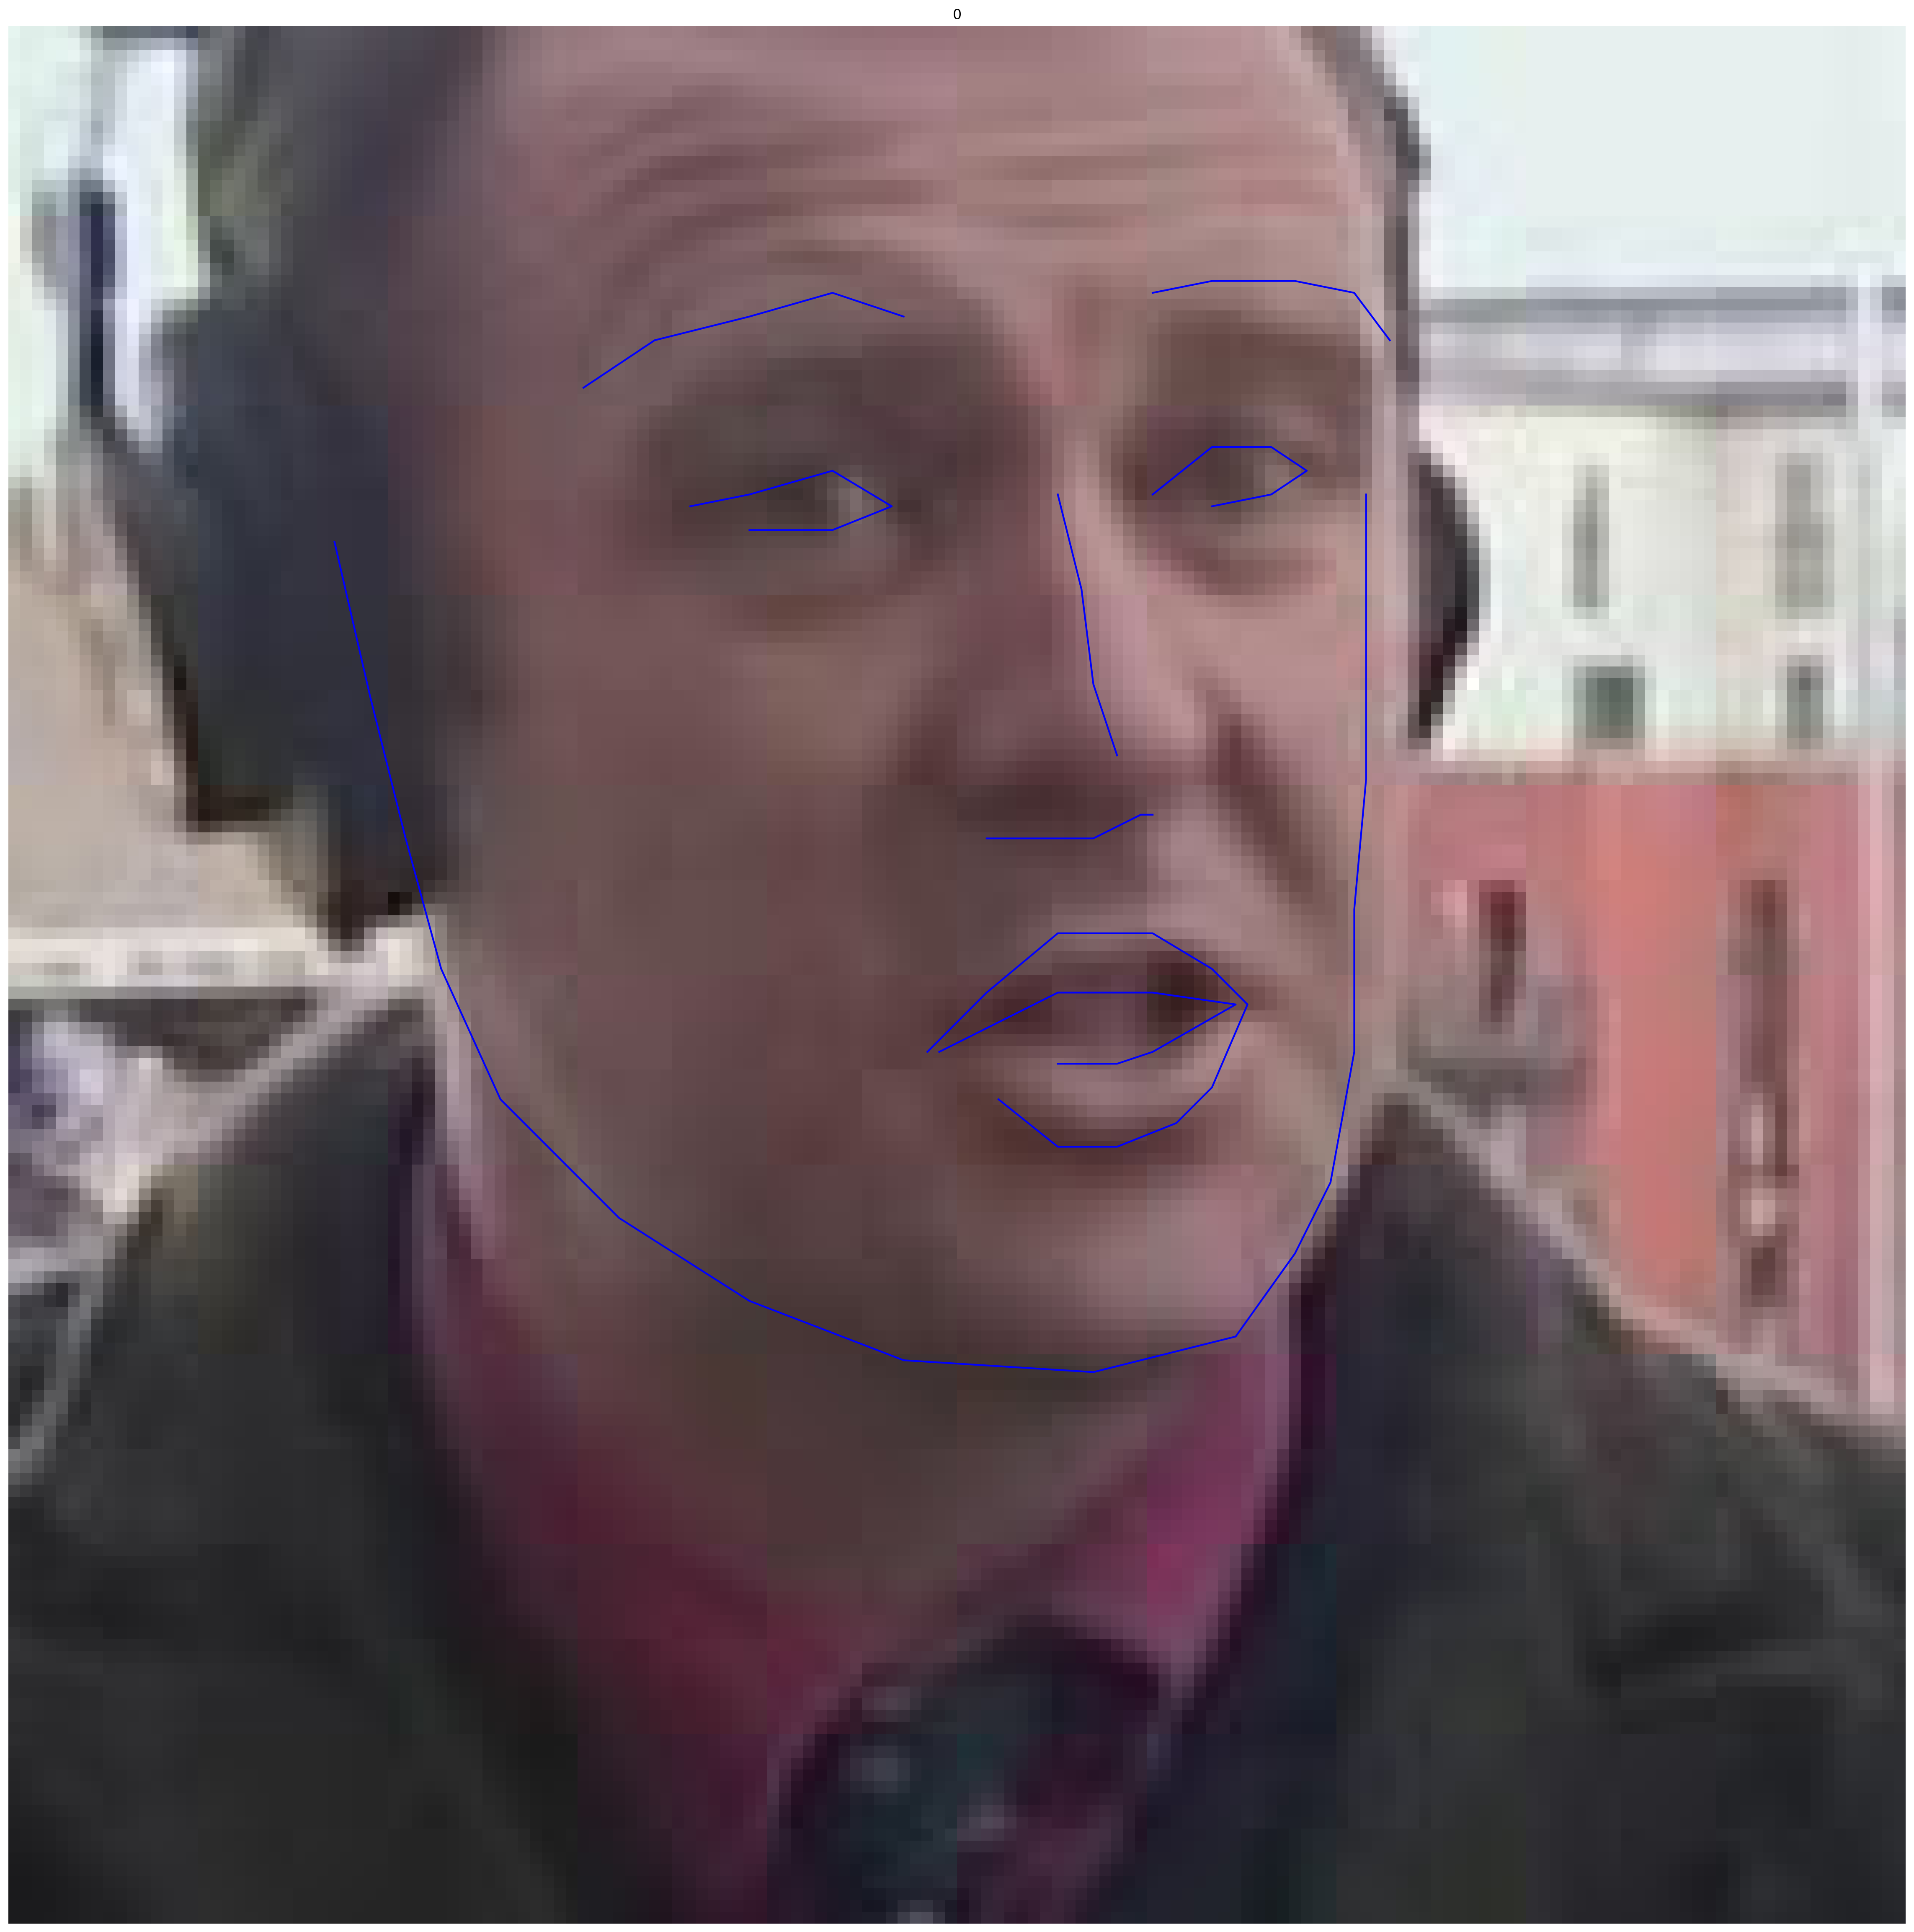

In [11]:
A2ED.plot_face(13100,"real")

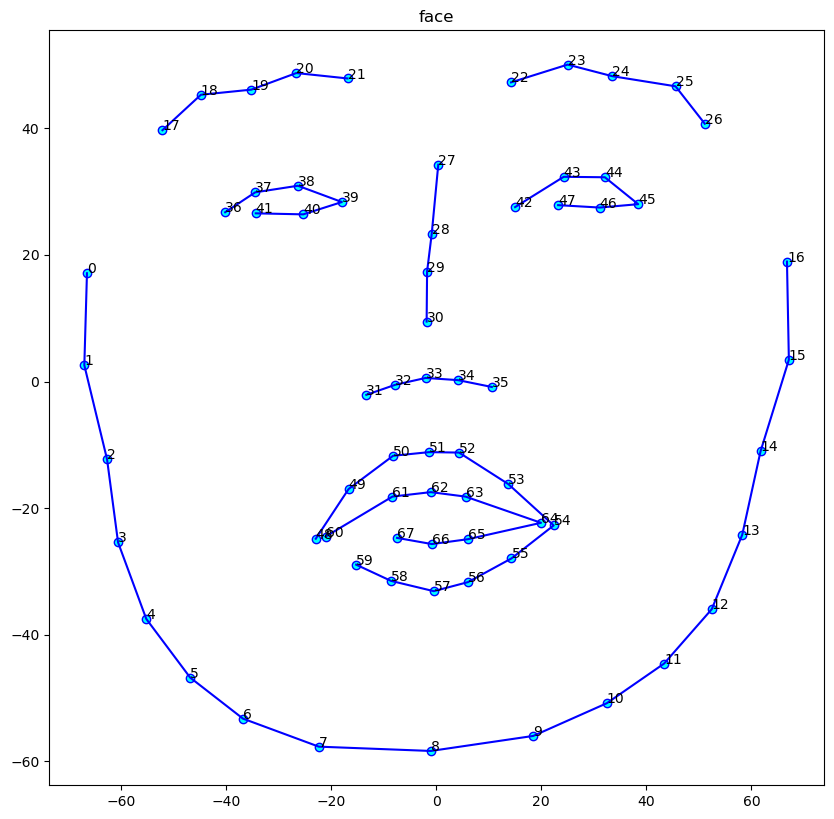

In [12]:
A2ED.plot_face(13100,"basel")

In [13]:
A2ED_train = AudioToExpressionDataset(df=df,subset_df = shuffle(df[df['datasplit']=="train"])[:10000].reset_index(),)


init dataset


In [14]:
A2ED_train.__getitem__(300)

{'cur': {'expression': tensor([[-5.6433e-01, -8.7443e-02, -1.5886e+00, -2.1039e+00, -1.2616e+00,
           -7.1403e-01, -1.8871e+00,  3.0957e-01,  1.2497e+00, -1.7900e-01,
            4.0589e-01, -6.1105e-01, -1.6236e+00, -5.0884e-01,  4.7115e-01,
            7.2034e-01, -3.7026e-02,  4.8400e-01, -7.2899e-01, -1.8980e-01,
            3.5746e+00, -2.8049e+00, -5.1377e-01, -1.7199e+00,  6.1984e-02,
            9.2519e-01,  6.3114e-01,  1.5194e+00, -2.1132e+00, -2.3326e-01,
            8.3449e-01,  8.0263e-01,  1.3001e+00, -1.6689e+00, -2.7645e-01,
            1.0847e+00,  2.9910e+00,  1.3141e+00,  3.1546e+00, -3.6994e+00,
            2.3532e+00, -3.6570e-01,  1.3097e+00, -3.9512e-01,  4.1786e-01,
           -1.6082e+00,  1.9136e+00, -1.2586e+00, -7.9455e-01,  1.8867e-01,
            8.5101e-01,  2.9190e+00,  2.7403e+00,  7.2415e-01, -1.1685e+00,
           -9.5782e-01,  1.4778e+00, -1.6484e-01, -4.4315e+00,  1.7469e-01,
           -5.0790e-01,  4.2717e+00, -7.3868e-01, -1.6841e+00, -1.6

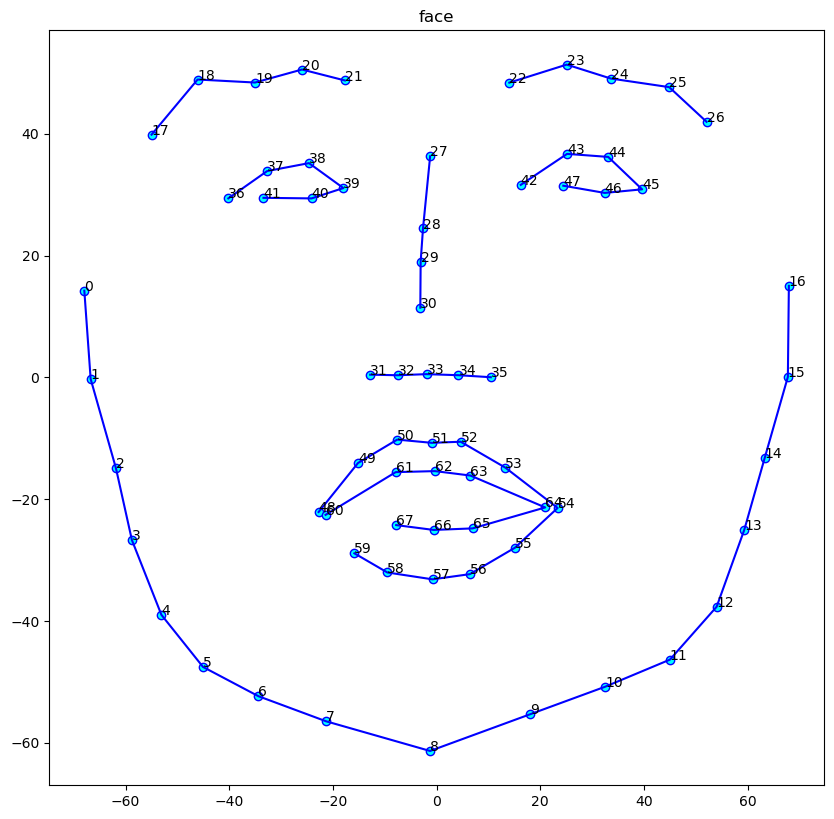

In [15]:
A2ED_train.plot_face(400,"basel")

In [16]:
loaded_expressions,_ = A2ED_train.load_video_expressions(100)

In [17]:
def match_expression(source_expression,stacked_expression,device,multipliers=(1,10),metric="L2",displacement = 1,print_loss=False):
    if type(source_expression)==list: 
        source_expression = torch.stack(source_expression)
    if type(stacked_expression)==list: 
        stacked_expression = torch.stack(stacked_expression)
        
    if "cpu" in device: 
        source_dlib = basel_cpu.get_expression(source_expression,2)
        stacked_dlib = basel_cpu.get_expression(stacked_expression,2)
    else:
        source_dlib = basel.get_expression(source_expression,2)
        stacked_dlib = basel.get_expression(stacked_expression,2)
    
    if len(source_dlib.shape)==2:
        source_dlib = source_dlib[None,None,:,:] 
    elif len(source_dlib.shape)==3:
        source_dlib = source_dlib[:,None,:,:] 
    
    stacked_dlib = stacked_dlib[None,:,:,:]
    
    
    
    mouth_idxs_norm = list(range(48, 68))
    mouth_stacked = stacked_dlib[:,:,mouth_idxs_norm,:]
    mouth_source = source_dlib[:,:,mouth_idxs_norm,:]
    
    
    if displacement>0:
        idxs = list(range(68))
        idxs.append(idxs.pop(0))

        mouth_idxs_shifted = list(mouth_idxs_norm)
        for disp in range(displacement):
            mouth_idxs_shifted.append(mouth_idxs_shifted.pop(0))

        mouth_stacked = stacked_dlib[:,:,mouth_idxs_norm,:] - stacked_dlib[:,:,mouth_idxs_shifted,:]
        mouth_source = source_dlib[:,:,mouth_idxs_norm,:] - source_dlib[:,:,mouth_idxs_shifted,:]

        stacked_dlib = stacked_dlib - stacked_dlib[:,:,idxs,:]
        source_dlib = source_dlib - source_dlib[:,:,idxs,:]
            
    
    if metric.upper()=="L1":
        face_loss = multipliers[0]*torch.abs(stacked_dlib - source_dlib).sum(dim=[2,3])
        mouth_loss =  multipliers[1]* (mouth_stacked - mouth_source).sum(dim=[2,3])
        z = face_loss + mouth_loss
    if metric.upper()=="L2":
        face_loss = multipliers[0]*torch.abs(stacked_dlib  - source_dlib).square().sum(dim=[2,3])
        mouth_loss =  multipliers[1]* (mouth_stacked - mouth_source).square().sum(dim=[2,3])
        z = face_loss + mouth_loss
    
    if print_loss: print(f"face: {face_loss.max()} mouth_loss {mouth_loss.max()}")
    sorted, indices = torch.sort(z,dim=1)
    return indices[0].tolist()

match_expression(loaded_expressions[1],loaded_expressions,"cpu",print_loss=True,displacement=1,multipliers=(1,10)).index(1)
    

face: 497.72125244140625 mouth_loss 1891.294677734375


0

In [18]:
# train_size = 0.8
# df = A2ED.df
# df['datasplit'] = 'test'

# g = df.groupby("directory")

# a=np.arange(g.ngroups)
# np.random.shuffle(a)

# cutoff = int(g.ngroups*train_size)
# df.loc[g.ngroup().isin(a[:cutoff]),'datasplit']='train'
# df.to_csv('workspace/data.csv')

# print(len(df[df['datasplit']=="train"])/len(df))
# len(df[df['datasplit']=="train"])

In [19]:
import torch.nn as nn
import torch

class LipGenerator(nn.Module):
    def __init__(self,T=3):
        super().__init__()
        self.T=T
        #################################
        #########   lip net   ###########
        #################################

        self.convNet = nn.Sequential(
            nn.Conv2d(29, 64, kernel_size=(3,1), stride=(2,1), padding=(1,0), bias=True), #  29 x 16 x 1 => 32 x 8 x 1
            nn.LeakyReLU(0.02, True),
            nn.Conv2d(64, 128, kernel_size=(3,1), stride=(2,1), padding=(1,0), bias=True), # 32 x 8 x 1 => 32 x 4 x 1
            nn.LeakyReLU(0.02, True),
            nn.Conv2d(128, 128, kernel_size=(3,1), stride=(2,1), padding=(1,0), bias=True), # 32 x 4 x 1 => 64 x 2 x 1
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 128, kernel_size=(3,1), stride=(2,1), padding=(1,0), bias=True), # 64 x 2 x 1 => 128 x 1 x 1
            nn.LeakyReLU(0.2, True),
            
        )


        self.linearNet = nn.Sequential(
            nn.Linear(in_features = 128 , out_features=128, bias = True),
            nn.LeakyReLU(0.02),
            nn.Linear(in_features = 128, out_features=199, bias = True),
            nn.LeakyReLU(0.02),
            nn.Linear(in_features = 199, out_features=199, bias = True),
            nn.LeakyReLU(0.02),
            nn.Linear(in_features = 199, out_features=199, bias = True),
            nn.LeakyReLU(0.02),
            nn.Linear(in_features = 199, out_features=199, bias = True),
            nn.LeakyReLU(0.02),
            nn.Linear(in_features = 199, out_features=100, bias = True),
        )
        
        self.attentionConvNet = nn.Sequential( # b x subspace_dim x seq_len
            nn.Conv1d(100, 16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True),
            nn.Conv1d(16, 8, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True),
            nn.Conv1d(8, 4, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True),
            nn.Conv1d(4, 2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True),
            nn.Conv1d(2, 1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True)
        )
        self.attentionNet = nn.Sequential(
            nn.Linear(in_features = self.T, out_features=self.T, bias = True),   
            nn.Softmax(dim=1)
        )
        

    def forward(self,deepspeech):
        b = deepspeech.shape[0] # batchsize
        deepspeech = deepspeech.view(b * self.T, 1 , 16, 29) # b * seq_len x 1 x 16 x 29
        deepspeech = torch.transpose(deepspeech,1,3) #b* seq_len  x 29 x 16 x 1
        conved = self.convNet(deepspeech) # b * seq_len X 128 X 1 X 1
        
        conved = torch.reshape( conved, (b * self.T, 1, -1)) # b * seq_len X 1 X 128

        linear = self.linearNet(conved)[:,0,:]

        #################
        ### attention ###
        ################# 
        
        result_subspace = linear.view(b, self.T, 100) 
        result_subspace_T = torch.transpose(result_subspace, 1, 2) # b x subspace_dim x seq_len
        
        intermediate_expression = result_subspace_T[:,:,(self.T // 2):(self.T // 2) + 1] 
        
        
        att_conv_res = self.attentionConvNet(result_subspace_T) 
        
        attention = self.attentionNet(att_conv_res.view(b, self.T)).view(b, self.T, 1) # b x seq_len x 1
        
        result_subspace = torch.bmm(result_subspace_T, attention)
        return result_subspace.squeeze(),intermediate_expression.squeeze()


lip = LipGenerator()
for n in torch.utils.data.DataLoader(A2ED,batch_size=10,shuffle=True):
        break    

In [20]:
# df=pd.read_csv('workspace/data.csv')
def get_loaders(args):
    
    
    A2ED_train = AudioToExpressionDataset(df=df,subset_df=shuffle(df[df['datasplit']=="train"])[:args.data_size].reset_index(),T=args.seq_length)
    A2ED_test = AudioToExpressionDataset(df=df,subset_df=shuffle(df[df['datasplit']=="test"])[:args.data_size].reset_index(),T=args.seq_length)
    
    dataloader_params = {
         "batch_size":args.batch_size,
        "shuffle":args.shuffle, 
        "num_workers":args.num_workers,
#         "collate_fn":fn_collate,
    }
    if args.num_workers>0:
        dataloader_params["prefetch_factor"]=args.prefetch

    trainloader = torch.utils.data.DataLoader(A2ED_train,**dataloader_params)

    testloader = torch.utils.data.DataLoader(A2ED_test,**dataloader_params)
    
    return {"test":testloader,
           "train":trainloader}

In [21]:
import torch.optim as optim

def lr_decay(step, init_learning_rate = 1e-3, min_learning_rate = 1e-5, decay_rate = 0.9999):
    lr = ((init_learning_rate - min_learning_rate) *
          pow(decay_rate, step) +
          min_learning_rate)
    return lr

def build_model(args):
    model = LipGenerator(T=args.seq_length).to(device)

    optimizer = optim.Adam(model.parameters(), lr=args.init_learning_rate)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: lr_decay(step,args.init_learning_rate,args.min_learning_rate,args.decay_rate)/args.init_learning_rate)
    if not args.pretrained == "":
        model.load_state_dict(torch.load(args.pretrained))

    return model,optimizer,scheduler

for x in range(10):
    print(lr_decay(x,0.1,0.0001,0.9))


0.1
0.09001
0.08101900000000001
0.07292710000000001
0.06564439000000001
0.05908995100000001
0.05319095590000001
0.04788186031000001
0.04310367427900001
0.03880330685110001


In [22]:
def move_to(obj, device):
    if torch.is_tensor(obj):
        return obj.to(device)
    elif isinstance(obj, dict):
        res = {}
        for k, v in obj.items():
            res[k] = move_to(v, device)
        return res
    elif isinstance(obj, list):
        res = []
        for v in obj:
            res.append(move_to(v, device))
        return res
    else:
        raise TypeError("Invalid type for move_to")

In [27]:
def train_and_test(model,optimizer,scheduler,loaders,args):
    running_loss = 0
    best_loss = -1
    step = 0
    torch.autograd.set_detect_anomaly(args.detect_anomaly)
    
    for epoch in tqdm(range(args.epochs)):  # loop over the dataset multiple times

        
        for split in ['train','test']:
            running_loss = 0

            if split == "train":
                model.train()
                loader = loaders['train']
                max_steps = args.trainsteps_per_epoch
            else:
                model.eval()
                loader=loaders['test']
                max_steps = args.test_steps_per_epoch
            running_loss = 0
            running_mouth_loss =0
            for i, data in enumerate(tqdm(loader)):
                # get the inputs; data is a list of [inputs, labels]
#                 audio, ground_expression_vector, ground_shape_vector,idxes = [d.to(device) for d in data]
                if i > max_steps:
                    break
                
                step+=args.batch_size

                data = move_to(data,device)
            
                # forward + backward + optimize
                if split == "train":
                    audio_cat = torch.cat([data['prev']['audio'],data['cur']['audio'],data['nxt']['audio']])
                    output_expression_cat,intermediate_expression = model(audio_cat)

                    size = data['prev']['audio'].shape[0]
                    prev_output_expression = output_expression_cat[:size]
                    cur_output_expression = output_expression_cat[size:size*2]
                    nxt_output_expression = output_expression_cat[size*2:]
                    
                else:
                    with torch.no_grad():
                        
                        audio_cat = torch.cat([data['prev']['audio'],data['cur']['audio'],data['nxt']['audio']])
                        output_expression_cat,intermediate_expression = model(audio_cat)
                        
                        size = data['prev']['audio'].shape[0]
                        prev_output_expression = output_expression_cat[:size]
                        cur_output_expression = output_expression_cat[size:size*2]
                        nxt_output_expression = output_expression_cat[size*2:]

#                 if torch.isnan(audio_cat_gpu).any():
#                     print(f"contains nan: {output_expression_vector}")
#                     print(f"nan target: {ground_expression_vector} contains: {torch.isnan(ground_expression_vector).any()}max {ground_expression_vector.max()} min{ground_expression_vector.min()} ")
#                     print(f"nan input: {audio} contains: {torch.isnan(audio).any()} max {audio.max()} min{audio.min()}")

#                     print(f"prev target: {prev_ground_expression_vector} contains: {torch.isnan(prev_ground_expression_vector).any()}max {prev_ground_expression_vector.max()} min{prev_ground_expression_vector.min()} ")
#                     print(f"prev input: {prev_audio} contains: {torch.isnan(prev_audio).any()} max {prev_audio.max()} min{prev_audio.min()}")
#                     print(f"log_dict:{log_dict}")

#                     for n,p in model.named_parameters():
#                             print('===========\ngradient:{}\n----------\n{}'.format(n,p.grad))
#                             print('{} {}'.format(n,p.grad.max(),p.grad.min()))
#                             print('{} {}'.format(p.data.max(),p.data.min()))

#                     return

                # zero the parameter gradients
                optimizer.zero_grad()

                gt_expression_cur = data['cur']['expression'][:,args.seq_length//2,:]
                gt_expression_prev = data['prev']['expression'][:,args.seq_length//2,:]
                gt_expression_nxt = data['nxt']['expression'][:,args.seq_length//2,:]
            
            
                gt_expression_cat = torch.cat([gt_expression_prev,gt_expression_cur,gt_expression_nxt]).to(device)

                flat_intermediate_diff =  intermediate_expression - torch.cat([ data['prev']['expression'][:,args.seq_length//2,:], data['cur']['expression'][:,args.seq_length//2,:], data['nxt']['expression'][:,args.seq_length//2,:]])
                face_intermediate_diff = basel.get_expression(flat_intermediate_diff,2,add_means=False)
                
                #flat diff
                flat_diff = output_expression_cat - gt_expression_cat
                
                #face_diff
                face_diff = basel.get_expression(flat_diff,2,add_means=False)

                #temporal diffs
                temporal_prev_cur = (prev_output_expression - cur_output_expression) - (gt_expression_prev - gt_expression_cur)
                temporal_cur_next = (cur_output_expression - nxt_output_expression)  - (gt_expression_cur  - gt_expression_nxt)
                temporal_prev_next = (prev_output_expression - nxt_output_expression)- (gt_expression_prev - gt_expression_nxt)
                
                temporal_flat_cat = torch.cat([temporal_prev_cur,temporal_cur_next,temporal_prev_next])
                
                temporal_expression = basel.get_expression(temporal_flat_cat,2,add_means=False)
                
                
                
#                 if args.displacement>0:
#                     output_dlib = basel.get_expression(output_expression_vector,2,add_means=False)
#                     gt_dlib = basel.get_expression(ground_expression_vector,2,add_means=False)
#                     face_diff = basel.get_expression(diff_vector,2,add_means=False)
                    
#                     if len(output_dlib.shape)==2:
#                         output_dlib = output_dlib[None,:,:]
#                         gt_dlib = gt_dlib[None,:,:]

                    
#                     idxs = list(range(68))
#                     idxs.append(idxs.pop(0))
                    
#                     mouth_idxs_norm = list(range(48, 68))
#                     mouth_idxs_shifted = list(mouth_idxs_norm)
#                     for disp in range(args.displacement):
#                         mouth_idxs_shifted.append(mouth_idxs_shifted.pop(0))
                    
#                     face_diff = (output_dlib - output_dlib[:,idxs,:]) - (gt_dlib - gt_dlib[:,idxs,:])
#                     mouth_diff = (output_dlib[:,mouth_idxs_norm,:] - output_dlib[:,mouth_idxs_shifted,:]) -( gt_dlib[:,mouth_idxs_norm,:] - gt_dlib[:,mouth_idxs_shifted,:])

                   
#                 else:
#                     face_diff = basel.get_expression(diff_vector,2,add_means=False)
#                     if len(output_diff.shape)==2:
#                         face_diff = face_diff[None,:,:]
#                     mouth_diff = face_diff[:,48:68,:]
                    

                #300 is batch size
                loss_dict = {}
                if args.metric=="L1": 
                    loss_dict['face_loss']  = args.full_multiplier  * face_diff.abs().mean()
                    loss_dict['mouth_loss'] = args.mouth_multiplier * face_diff[:,48:68,:].abs().mean()
                    loss_dict['flat_loss']  = args.flat_multiplier  * flat_diff.abs().mean()
                    
                    loss_dict['intermediate'] = args.intermediate_multiplier * face_intermediate_diff.abs().mean()
                    loss_dict['temporal_flat'] = args.temporal_flat_multiplier * temporal_flat_cat.abs().mean()
                    loss_dict['temporal_face'] = args.temporal_face_multiplier * temporal_expression.abs().mean()
                    

                if args.metric == "L2":
                    loss_dict['face_loss']  = args.full_multiplier  * face_diff.square().mean()
                    loss_dict['mouth_loss'] = args.mouth_multiplier * face_diff[:,48:68,:].square().mean()
                    loss_dict['flat_loss']  = args.flat_multiplier  * flat_diff.square().mean()
                    

                    loss_dict['intermediate'] = args.intermediate_multiplier * face_intermediate_diff.square().mean()
                    loss_dict['temporal_flat'] = args.temporal_flat_multiplier * temporal_flat_cat.square().mean()
                    loss_dict['temporal_face'] = args.temporal_face_multiplier * temporal_expression.square().mean()
             

                if args.metric == "RMS":
                    
                    loss_dict['face_loss']  = args.full_multiplier  * face_diff.square().sqrt().mean()
                    loss_dict['mouth_loss'] = args.mouth_multiplier * face_diff[:,48:68,:].square().sqrt().mean()
                    loss_dict['flat_loss']  = args.flat_multiplier  * flat_diff.square().sqrt().mean()
                    

                    loss_dict['intermediate'] = args.intermediate_multiplier * face_intermediate_diff.square().sqrt().mean()
                    loss_dict['temporal_flat'] = args.temporal_flat_multiplier * temporal_flat_cat.square().sqrt().mean()
                    loss_dict['temporal_face'] = args.temporal_face_multiplier * temporal_expression.square().sqrt().mean()
                 
                
                loss = loss_dict['loss'] = sum(loss_dict.values())
                
                log_dict = {k:v.detach() for k,v in loss_dict.items()}
                log_dict['epoch'] = epoch
                
                
                if split=="train":
                    if i%args.retrieval_train_step==0 and epoch>=args.warmup_epochs:
                        retrieval = []
                        targets = []
                        predicted = []
                        with torch.no_grad():
                            #we use the 1th idx of cur, because this resembles the target idx
                            for out_vector,target_idx in tqdm(zip(cur_output_expression[:30],data['cur']['idx'][args.seq_length//2][:30])):
                                video_gt,frame_idx = loader.dataset.load_video_expressions(int(target_idx))
                                targets.append(frame_idx)
                                pred_sort = match_expression(out_vector.to("cpu"),torch.stack(video_gt),"cpu",multipliers=(1,10))
                                predicted.append(pred_sort[0])
                                retrieval.append((pred_sort.index(frame_idx))/len(video_gt))
                            print(f"train predicted: {predicted} \ntarget: {targets}")
                            log_dict["retrieval"]=sum(retrieval)/len(retrieval)

                    loss.backward()
                    if not args.clip is None:
                        torch.nn.utils.clip_grad_value_(model.parameters(), args.clip)

#                         if i%args.check_gradients==0:
#                             for n,p in model.named_parameters():
#                                 print('===========\ngradient:{}\n----------\n{} {} '.format(n,p.grad.max(),p.grad.min()))
#                                 print('===========\weigth:----------\n')
#                                 print('{} {}'.format(p.data.max(),p.data.min()))
#                             print('\n\n\n')


                    optimizer.step()
                    if args.use_wandb:
                        wandb.log(log_dict,step=step)
                else:
                    if i%args.retrieval_test_step==0 and epoch>=args.warmup_epochs:
                        with torch.no_grad():
                            retrieval = []
                            targets = []
                            predicted = []
                            for out_vector,target_idx in tqdm(zip(cur_output_expression[:50],data['cur']['idx'][args.seq_length//2][:50])):
                                
                                video_gt,frame_idx = loader.dataset.load_video_expressions(int(target_idx))
                                targets.append(frame_idx)
                                pred_sort = match_expression(out_vector.to("cpu"),torch.stack(video_gt),"cpu",multipliers=(1,10))
                                retrieval.append(pred_sort.index(frame_idx)/len(video_gt))
                                predicted.append(pred_sort[0])
                            print(f"test predicted: {predicted} \ntargets: {targets}")
                            
                            log_dict["retrieval"]=sum(retrieval)/len(retrieval)
                            log_dict["retrieval_std"] = np.std(retrieval)

                    if args.use_wandb:
                        wandb.log({"test_"+k:v for k,v in log_dict.items()},step=step)
            
            
            if split=="test":
                print(f"outputs max  {cur_output_expression.max(dim=1)[0][:5]} min {cur_output_expression.min(dim=1)[0][:5]}  mean {cur_output_expression.mean(dim=1)[:5]}")
                print(f"ground max  {gt_expression_cur.max(dim=1)[0][:5]} min {gt_expression_cur.min(dim=1)[0][:5]} mean {gt_expression_cur.mean(dim=1)[:5]}")

                print(f"eval [{epoch} {args.epochs}]: loss: {running_loss/(len(loader)*300)} mouth {running_mouth_loss/(len(loader)*300)}")
                if epoch>args.save_after: torch.save(model.state_dict(), 'checkpoints/training/{}{}.pt'.format(epoch, args.name))

                if best_loss==-1 or best_loss > running_loss:
                    best_loss = running_loss
                    if epoch>args.save_after:torch.save(model.state_dict(), 'checkpoints/training/best_{}.pt'.format(args.name))
                    print("new best")
            
            del loss_dict
            
        scheduler.step()
        print(f"new learning rate: {optimizer.param_groups[0]['lr']}")
    print('Finished Training')

In [28]:
def run(args):
    model,optimizer,scheduler = build_model(args)
    loaders = get_loaders(args)
    if args.use_wandb:
        wandb.init(project="lipgeneration",config=args,name=args.name)
        wandb.watch(model,log_freq=10)

    train_and_test(model,optimizer,scheduler,loaders,args)

In [29]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
args = AttrDict()

args.num_workers = 0
args.prefetch = 2
args.shuffle =True

args.batch_size = 100
args.full_multiplier = 2
args.mouth_multiplier = 8
args.flat_multiplier = 1
args.temporal_flat_multiplier = 1
args.temporal_face_multiplier = 3
args.intermediate_multiplier = 1




args.retrieval_train_step = 2000
args.retrieval_test_step  = 1

args.trainsteps_per_epoch = 0
args.test_steps_per_epoch = 10000

args.clip = 1
args.detect_anomaly = False

args.check_gradients = 1000
args.metric = "L2"
args.epochs=1000
args.data_size = -1
args.print_step = 1000
args.displacement = 1
args.warmup_epochs = -1
args.save_after = 10
args.seq_length = 3

args.init_learning_rate = 5e-4
args.min_learning_rate = 4e-5
args.decay_rate = 0.99

args.pretrained = "checkpoints/training/36L2-0.001-1-datafix->-1.pt"
args.extra_name = "-test"
args.use_wandb = True
args.name = f"{args.metric}-{args.init_learning_rate}-{args.displacement}{args.extra_name}->{args.data_size}"






In [ ]:
run(args)

init dataset
init dataset


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20887 [00:00<?, ?it/s]

0it [00:00, ?it/s]

train predicted: [101, 14, 28, 46, 13, 73, 11, 13, 63, 86, 67, 40, 35, 31, 15, 43, 34, 33, 32, 10, 44, 32, 46, 26, 85, 65, 21, 1, 9, 3] 
target: [113, 19, 17, 59, 10, 106, 10, 11, 63, 84, 38, 44, 11, 5, 1, 0, 20, 12, 49, 1, 49, 4, 36, 29, 34, 51, 40, 7, 20, 38]


  0%|          | 0/5229 [00:00<?, ?it/s]

0it [00:00, ?it/s]

test predicted: [33, 61, 40, 31, 25, 3, 34, 43, 21, 77, 8, 5, 9, 41, 20, 27, 85, 30, 42, 9, 37, 45, 27, 52, 21, 19, 1, 20, 106, 15, 51, 7, 26, 99, 86, 45, 21, 44, 21, 39, 9, 18, 46, 19, 33, 33, 40, 29, 26, 13] 
targets: [21, 27, 25, 19, 14, 30, 18, 2, 53, 75, 14, 108, 5, 39, 42, 20, 35, 34, 8, 10, 84, 14, 25, 23, 132, 32, 47, 20, 59, 10, 53, 29, 46, 93, 82, 13, 8, 35, 13, 5, 29, 5, 91, 17, 27, 12, 8, 12, 4, 48]


0it [00:00, ?it/s]

test predicted: [87, 93, 68, 24, 11, 17, 9, 95, 14, 72, 10, 37, 10, 19, 10, 6, 22, 32, 21, 0, 144, 3, 30, 109, 31, 37, 5, 18, 16, 54, 22, 27, 81, 15, 11, 74, 29, 7, 87, 40, 44, 19, 34, 18, 27, 121, 28, 62, 33, 42] 
targets: [47, 37, 21, 2, 44, 10, 14, 31, 38, 0, 19, 19, 46, 55, 13, 71, 27, 21, 25, 16, 31, 10, 32, 41, 34, 19, 63, 58, 23, 12, 4, 21, 19, 48, 49, 3, 65, 0, 11, 46, 48, 32, 6, 3, 13, 88, 15, 69, 34, 25]


0it [00:00, ?it/s]

test predicted: [27, 26, 11, 29, 4, 5, 4, 19, 28, 6, 25, 21, 9, 91, 36, 15, 26, 2, 40, 14, 38, 16, 4, 4, 34, 20, 28, 15, 17, 36, 23, 10, 30, 36, 61, 56, 46, 50, 73, 63, 24, 135, 68, 8, 39, 6, 5, 20, 9, 29] 
targets: [36, 26, 41, 8, 100, 23, 25, 93, 38, 23, 11, 1, 13, 31, 24, 33, 27, 38, 22, 11, 54, 13, 6, 11, 42, 42, 0, 10, 16, 6, 19, 8, 65, 29, 153, 93, 55, 44, 75, 46, 63, 88, 70, 10, 8, 90, 18, 17, 27, 5]


0it [00:00, ?it/s]

test predicted: [102, 45, 29, 15, 19, 38, 22, 4, 108, 27, 41, 12, 23, 13, 26, 5, 59, 87, 27, 20, 29, 19, 6, 25, 24, 19, 5, 43, 59, 35, 19, 5, 11, 8, 29, 16, 40, 34, 7, 24, 78, 15, 43, 26, 64, 57, 67, 36, 46, 35] 
targets: [89, 1, 18, 17, 36, 13, 37, 18, 109, 24, 31, 2, 22, 4, 29, 41, 54, 63, 17, 15, 29, 18, 5, 33, 5, 31, 84, 28, 66, 26, 32, 73, 11, 14, 59, 90, 7, 74, 16, 39, 36, 18, 48, 5, 24, 53, 5, 93, 15, 29]


0it [00:00, ?it/s]

test predicted: [28, 11, 50, 0, 50, 65, 19, 101, 4, 16, 47, 23, 5, 63, 10, 42, 5, 5, 45, 111, 26, 43, 21, 81, 16, 42, 83, 36, 75, 23, 51, 44, 30, 82, 1, 75, 18, 34, 17, 24, 57, 71, 23, 74, 31, 81, 81, 66, 3, 43] 
targets: [10, 46, 76, 0, 104, 15, 40, 60, 15, 7, 15, 9, 13, 60, 10, 23, 27, 34, 52, 40, 15, 56, 24, 16, 36, 9, 12, 44, 125, 12, 23, 38, 36, 74, 50, 82, 26, 10, 15, 13, 24, 73, 18, 139, 16, 34, 95, 23, 9, 24]


0it [00:00, ?it/s]

test predicted: [55, 17, 6, 1, 4, 31, 80, 29, 105, 34, 17, 32, 12, 33, 3, 84, 11, 24, 5, 62, 32, 9, 3, 37, 97, 21, 27, 64, 29, 1, 82, 64, 28, 53, 8, 38, 22, 85, 2, 41, 30, 21, 118, 36, 54, 78, 68, 52, 12, 43] 
targets: [126, 12, 7, 59, 26, 33, 63, 5, 9, 37, 7, 60, 30, 59, 39, 32, 18, 2, 6, 15, 4, 21, 94, 10, 45, 24, 1, 12, 27, 21, 7, 43, 16, 36, 12, 6, 26, 125, 3, 14, 60, 20, 8, 13, 39, 33, 11, 0, 41, 76]


0it [00:00, ?it/s]

test predicted: [25, 24, 30, 37, 58, 10, 13, 36, 100, 74, 45, 5, 32, 34, 2, 17, 29, 104, 48, 119, 34, 37, 5, 14, 3, 54, 133, 31, 24, 1, 52, 29, 29, 27, 19, 48, 24, 15, 10, 4, 17, 62, 6, 0, 62, 33, 24, 77, 28, 40] 
targets: [29, 15, 20, 1, 17, 9, 17, 26, 15, 99, 37, 28, 20, 10, 35, 41, 12, 98, 34, 118, 46, 7, 67, 17, 92, 57, 24, 41, 43, 2, 13, 29, 66, 21, 8, 7, 49, 0, 40, 4, 22, 41, 10, 33, 51, 24, 20, 38, 20, 9]


0it [00:00, ?it/s]

test predicted: [7, 24, 20, 8, 3, 4, 3, 17, 19, 68, 5, 37, 25, 63, 28, 27, 36, 39, 29, 17, 66, 1, 18, 31, 80, 19, 7, 38, 53, 14, 17, 13, 5, 9, 20, 24, 37, 10, 38, 40, 10, 25, 37, 26, 63, 30, 44, 34, 63, 25] 
targets: [9, 3, 18, 60, 0, 4, 29, 21, 9, 56, 30, 3, 5, 121, 34, 24, 8, 35, 18, 41, 66, 32, 18, 31, 38, 12, 3, 30, 32, 2, 73, 35, 44, 24, 28, 42, 8, 10, 18, 25, 82, 22, 32, 17, 96, 9, 45, 8, 65, 27]


0it [00:00, ?it/s]

test predicted: [107, 36, 32, 78, 21, 130, 17, 8, 70, 16, 130, 48, 56, 6, 4, 5, 48, 48, 49, 29, 27, 2, 61, 1, 58, 19, 80, 26, 34, 17, 133, 36, 19, 26, 32, 103, 41, 45, 18, 34, 23, 12, 30, 42, 10, 1, 8, 19, 5, 41] 
targets: [53, 2, 45, 102, 0, 139, 29, 1, 8, 33, 112, 39, 22, 6, 6, 9, 27, 41, 57, 81, 70, 37, 21, 17, 39, 83, 12, 25, 2, 26, 118, 16, 15, 36, 74, 17, 11, 70, 47, 2, 18, 5, 27, 32, 4, 15, 8, 18, 49, 41]


0it [00:00, ?it/s]

test predicted: [57, 10, 20, 93, 14, 57, 74, 41, 43, 16, 10, 29, 17, 11, 41, 46, 86, 10, 10, 13, 41, 37, 20, 55, 34, 25, 79, 23, 35, 25, 1, 51, 45, 41, 14, 52, 27, 124, 45, 74, 21, 59, 3, 53, 49, 102, 6, 14, 23, 7] 
targets: [60, 54, 8, 28, 32, 28, 61, 2, 16, 32, 84, 22, 0, 48, 64, 54, 128, 0, 2, 46, 32, 1, 28, 49, 6, 24, 24, 0, 19, 27, 20, 67, 31, 2, 22, 39, 47, 88, 58, 58, 16, 85, 3, 88, 15, 93, 27, 27, 37, 35]


0it [00:00, ?it/s]

test predicted: [89, 13, 66, 8, 24, 1, 128, 15, 12, 8, 84, 39, 23, 4, 14, 21, 32, 27, 25, 70, 63, 30, 11, 29, 39, 43, 14, 27, 6, 11, 6, 32, 15, 107, 46, 22, 40, 77, 115, 7, 102, 36, 51, 9, 54, 42, 11, 18, 8, 10] 
targets: [52, 30, 55, 16, 34, 33, 114, 137, 27, 9, 48, 25, 49, 7, 17, 39, 66, 7, 21, 67, 6, 22, 47, 2, 28, 42, 18, 34, 6, 58, 20, 3, 34, 99, 41, 27, 11, 70, 39, 55, 88, 51, 72, 2, 83, 27, 62, 3, 15, 35]


0it [00:00, ?it/s]

test predicted: [8, 3, 5, 14, 12, 27, 14, 40, 45, 0, 18, 8, 64, 35, 4, 18, 32, 111, 37, 23, 30, 22, 102, 16, 57, 20, 55, 50, 7, 19, 71, 33, 1, 62, 32, 21, 7, 43, 60, 65, 20, 9, 22, 138, 34, 110, 16, 30, 32, 19] 
targets: [85, 32, 6, 6, 8, 24, 24, 52, 8, 1, 49, 27, 80, 45, 18, 5, 36, 37, 31, 23, 24, 15, 101, 29, 39, 35, 89, 2, 43, 14, 37, 36, 26, 13, 13, 32, 15, 30, 20, 97, 67, 32, 29, 138, 27, 49, 19, 15, 26, 7]


0it [00:00, ?it/s]

test predicted: [17, 39, 7, 98, 18, 7, 0, 9, 9, 115, 57, 7, 4, 29, 25, 29, 75, 33, 30, 91, 23, 25, 36, 14, 31, 76, 13, 102, 54, 30, 10, 21, 18, 50, 87, 35, 16, 87, 71, 19, 89, 43, 18, 9, 32, 20, 33, 23, 63, 29] 
targets: [10, 46, 23, 34, 78, 57, 34, 9, 42, 46, 41, 87, 25, 6, 32, 6, 71, 80, 70, 7, 2, 24, 7, 35, 32, 129, 18, 19, 11, 23, 45, 5, 19, 45, 35, 37, 20, 88, 125, 17, 77, 28, 34, 24, 32, 19, 29, 20, 12, 43]


0it [00:00, ?it/s]

test predicted: [6, 78, 14, 11, 0, 20, 6, 46, 20, 30, 26, 8, 73, 3, 19, 46, 15, 9, 33, 45, 88, 22, 32, 27, 14, 0, 64, 17, 0, 22, 5, 20, 100, 81, 13, 28, 16, 33, 28, 38, 33, 97, 10, 32, 9, 1, 29, 19, 15, 19] 
targets: [10, 27, 0, 59, 3, 50, 37, 30, 73, 34, 26, 25, 129, 20, 13, 17, 17, 43, 50, 11, 86, 24, 8, 51, 125, 86, 49, 0, 1, 7, 2, 85, 113, 25, 12, 77, 2, 21, 0, 3, 12, 50, 51, 32, 42, 39, 30, 26, 25, 40]


0it [00:00, ?it/s]

test predicted: [27, 84, 133, 40, 13, 38, 60, 12, 31, 17, 76, 9, 38, 46, 53, 27, 18, 79, 7, 13, 45, 131, 47, 14, 20, 73, 68, 35, 36, 17, 33, 64, 2, 1, 36, 17, 52, 22, 18, 91, 9, 22, 10, 46, 114, 70, 47, 37, 25, 21] 
targets: [16, 47, 23, 24, 5, 43, 55, 33, 60, 15, 29, 10, 3, 51, 55, 40, 21, 77, 25, 28, 24, 131, 44, 26, 19, 60, 67, 6, 6, 96, 24, 85, 12, 43, 63, 16, 120, 8, 0, 0, 20, 13, 30, 11, 1, 12, 42, 45, 12, 73]


0it [00:00, ?it/s]

test predicted: [38, 36, 38, 143, 28, 99, 14, 28, 5, 22, 3, 9, 33, 70, 27, 17, 44, 27, 68, 58, 27, 32, 66, 51, 29, 45, 33, 4, 24, 50, 47, 13, 33, 21, 6, 53, 86, 19, 36, 68, 47, 4, 58, 55, 10, 107, 17, 49, 36, 10] 
targets: [23, 33, 71, 144, 26, 96, 19, 28, 27, 4, 4, 10, 46, 67, 27, 18, 8, 29, 81, 31, 54, 36, 65, 75, 0, 54, 14, 36, 11, 62, 52, 25, 40, 23, 44, 36, 36, 2, 11, 93, 44, 28, 68, 40, 4, 101, 6, 32, 27, 12]


0it [00:00, ?it/s]

test predicted: [30, 47, 3, 57, 29, 100, 73, 9, 55, 28, 67, 16, 51, 18, 44, 12, 50, 14, 30, 76, 24, 19, 54, 32, 26, 13, 136, 55, 86, 35, 6, 11, 22, 21, 54, 29, 83, 28, 45, 31, 60, 14, 74, 24, 29, 44, 12, 1, 52, 19] 
targets: [0, 3, 1, 37, 18, 120, 4, 9, 5, 18, 18, 1, 16, 2, 62, 16, 24, 22, 36, 54, 66, 17, 33, 8, 36, 27, 34, 19, 33, 32, 18, 42, 18, 33, 9, 45, 76, 49, 23, 45, 26, 41, 3, 0, 73, 13, 8, 32, 88, 21]


0it [00:00, ?it/s]

test predicted: [52, 14, 70, 43, 31, 62, 130, 31, 55, 49, 49, 32, 14, 29, 83, 6, 20, 42, 28, 7, 20, 20, 26, 5, 25, 33, 25, 55, 67, 97, 66, 28, 63, 5, 14, 4, 20, 23, 38, 12, 33, 14, 73, 56, 27, 65, 6, 77, 16, 35] 
targets: [6, 62, 62, 11, 1, 88, 124, 31, 11, 10, 1, 31, 46, 55, 106, 63, 11, 30, 25, 9, 67, 1, 40, 15, 36, 33, 32, 78, 8, 30, 69, 5, 61, 6, 17, 13, 27, 21, 89, 20, 57, 17, 56, 51, 45, 13, 4, 49, 20, 10]


0it [00:00, ?it/s]

test predicted: [108, 75, 22, 13, 8, 29, 70, 52, 57, 45, 12, 38, 17, 66, 54, 13, 4, 16, 11, 46, 65, 63, 11, 43, 14, 141, 25, 26, 6, 15, 18, 47, 7, 68, 40, 1, 31, 15, 8, 9, 111, 21, 11, 9, 10, 37, 3, 53, 114, 48] 
targets: [45, 78, 49, 25, 83, 0, 42, 51, 73, 43, 16, 53, 15, 27, 23, 16, 10, 23, 63, 18, 39, 19, 6, 38, 20, 43, 34, 53, 65, 3, 60, 30, 104, 17, 31, 3, 44, 26, 24, 9, 111, 27, 11, 36, 6, 27, 3, 96, 8, 17]


0it [00:00, ?it/s]

test predicted: [22, 1, 23, 33, 38, 45, 31, 20, 39, 37, 98, 74, 94, 69, 0, 28, 1, 48, 0, 36, 19, 14, 57, 123, 4, 43, 14, 3, 11, 127, 11, 12, 26, 26, 16, 37, 33, 14, 19, 24, 48, 2, 77, 26, 75, 45, 0, 38, 19, 47] 
targets: [28, 2, 34, 2, 56, 46, 0, 92, 21, 22, 97, 63, 50, 21, 18, 24, 1, 75, 30, 26, 23, 30, 69, 94, 47, 19, 9, 0, 49, 82, 23, 12, 25, 0, 13, 37, 39, 15, 20, 16, 22, 28, 5, 30, 76, 58, 40, 96, 44, 34]


0it [00:00, ?it/s]

test predicted: [3, 36, 11, 8, 24, 12, 25, 2, 10, 33, 32, 45, 99, 22, 75, 14, 16, 9, 32, 27, 73, 36, 5, 59, 14, 30, 19, 92, 55, 0, 57, 15, 41, 63, 46, 36, 26, 25, 49, 43, 0, 49, 129, 26, 7, 60, 52, 24, 57, 14] 
targets: [44, 46, 31, 20, 22, 17, 5, 6, 8, 40, 33, 19, 27, 21, 16, 32, 40, 11, 89, 36, 68, 66, 2, 60, 24, 33, 4, 58, 35, 16, 42, 34, 33, 6, 42, 41, 0, 26, 11, 32, 34, 57, 23, 48, 19, 109, 21, 23, 3, 8]


0it [00:00, ?it/s]

test predicted: [4, 72, 21, 64, 42, 49, 10, 33, 36, 71, 57, 2, 110, 26, 45, 124, 69, 36, 121, 60, 21, 87, 80, 53, 31, 88, 42, 60, 1, 10, 17, 38, 16, 43, 25, 5, 61, 91, 7, 52, 27, 21, 58, 58, 30, 20, 59, 19, 31, 59] 
targets: [27, 45, 21, 33, 18, 37, 66, 41, 40, 93, 30, 19, 138, 71, 3, 0, 10, 31, 75, 85, 0, 46, 109, 16, 26, 7, 36, 131, 2, 30, 39, 16, 2, 32, 37, 23, 115, 48, 15, 51, 64, 8, 18, 4, 30, 16, 98, 5, 5, 53]


0it [00:00, ?it/s]

test predicted: [2, 53, 4, 93, 20, 24, 23, 42, 95, 18, 49, 23, 29, 21, 39, 23, 12, 99, 20, 113, 3, 48, 42, 14, 41, 84, 44, 3, 25, 32, 15, 122, 10, 86, 35, 7, 86, 45, 26, 42, 5, 34, 23, 25, 42, 13, 31, 63, 5, 4] 
targets: [7, 30, 14, 91, 9, 20, 16, 14, 95, 13, 6, 15, 28, 28, 32, 80, 53, 12, 19, 70, 90, 14, 46, 96, 44, 12, 61, 20, 40, 14, 4, 114, 41, 35, 25, 41, 70, 9, 11, 94, 9, 32, 69, 28, 21, 11, 49, 98, 16, 42]


0it [00:00, ?it/s]

test predicted: [52, 17, 41, 24, 12, 47, 26, 20, 18, 23, 44, 9, 58, 7, 54, 33, 98, 84, 6, 23, 21, 10, 35, 101, 104, 3, 78, 111, 40, 20, 37, 31, 3, 30, 13, 26, 27, 51, 13, 93, 36, 14, 39, 63, 57, 48, 18, 27, 11, 59] 
targets: [30, 5, 68, 0, 21, 22, 22, 56, 16, 33, 3, 29, 34, 30, 28, 14, 81, 9, 46, 8, 24, 20, 45, 5, 96, 28, 19, 1, 42, 18, 6, 104, 8, 64, 82, 58, 17, 43, 75, 55, 21, 6, 38, 54, 24, 52, 17, 14, 58, 1]


0it [00:00, ?it/s]

test predicted: [15, 16, 29, 29, 43, 32, 30, 24, 1, 14, 26, 47, 79, 49, 50, 12, 24, 64, 25, 53, 109, 24, 23, 58, 142, 3, 27, 24, 1, 15, 3, 23, 5, 22, 22, 19, 10, 42, 26, 31, 41, 22, 22, 22, 16, 13, 55, 6, 55, 12] 
targets: [5, 32, 25, 34, 12, 15, 10, 32, 60, 14, 33, 70, 79, 10, 108, 17, 13, 66, 32, 51, 28, 122, 27, 36, 115, 3, 2, 8, 11, 54, 11, 9, 16, 14, 1, 5, 20, 49, 90, 1, 40, 22, 27, 9, 19, 40, 51, 56, 12, 18]


0it [00:00, ?it/s]

test predicted: [9, 28, 19, 65, 30, 34, 22, 38, 71, 48, 78, 46, 47, 19, 11, 29, 27, 20, 71, 32, 12, 12, 28, 33, 30, 7, 143, 18, 6, 70, 27, 28, 13, 47, 1, 34, 28, 14, 5, 0, 4, 72, 0, 75, 38, 31, 34, 29, 46, 61] 
targets: [47, 33, 2, 21, 35, 82, 22, 6, 90, 35, 57, 49, 31, 20, 37, 38, 15, 20, 5, 54, 7, 17, 32, 60, 1, 26, 122, 21, 48, 108, 3, 51, 4, 113, 51, 136, 82, 19, 33, 0, 0, 13, 85, 23, 46, 33, 18, 5, 44, 60]


0it [00:00, ?it/s]

test predicted: [21, 34, 60, 84, 32, 136, 24, 60, 20, 5, 62, 0, 20, 112, 33, 7, 30, 32, 51, 15, 35, 45, 0, 25, 16, 24, 31, 61, 15, 46, 91, 0, 46, 26, 32, 60, 52, 75, 33, 19, 2, 19, 50, 56, 55, 12, 5, 35, 3, 42] 
targets: [4, 36, 29, 95, 102, 18, 25, 60, 29, 31, 23, 23, 1, 111, 66, 48, 6, 17, 82, 2, 6, 79, 3, 7, 27, 6, 5, 57, 1, 25, 78, 52, 0, 10, 83, 5, 103, 28, 34, 23, 9, 13, 5, 79, 26, 7, 70, 57, 10, 16]


0it [00:00, ?it/s]

test predicted: [48, 28, 1, 18, 101, 52, 26, 68, 53, 144, 77, 28, 34, 37, 23, 129, 62, 110, 76, 47, 19, 104, 31, 33, 115, 41, 39, 28, 0, 19, 39, 38, 19, 60, 51, 22, 23, 101, 110, 18, 7, 10, 6, 114, 6, 5, 22, 24, 32, 30] 
targets: [55, 13, 1, 2, 54, 34, 24, 12, 43, 6, 47, 14, 0, 15, 31, 58, 57, 116, 99, 1, 16, 118, 5, 37, 35, 51, 11, 20, 29, 7, 37, 33, 15, 13, 52, 16, 57, 81, 25, 33, 33, 13, 71, 115, 18, 56, 36, 57, 30, 8]


0it [00:00, ?it/s]

test predicted: [33, 97, 27, 11, 22, 17, 41, 12, 16, 107, 12, 28, 47, 7, 80, 27, 5, 0, 20, 12, 5, 49, 48, 8, 85, 59, 68, 7, 2, 33, 36, 36, 73, 34, 73, 100, 20, 32, 1, 129, 57, 2, 14, 21, 89, 61, 8, 15, 21, 41] 
targets: [87, 23, 102, 10, 12, 31, 35, 20, 8, 106, 3, 34, 52, 8, 83, 34, 63, 38, 19, 27, 1, 71, 20, 10, 130, 31, 67, 77, 68, 34, 9, 41, 57, 48, 91, 37, 22, 42, 129, 6, 36, 1, 37, 26, 94, 3, 0, 28, 0, 58]


0it [00:00, ?it/s]

test predicted: [36, 92, 1, 35, 15, 40, 5, 51, 37, 19, 40, 5, 12, 37, 42, 23, 126, 25, 16, 15, 32, 33, 15, 51, 62, 130, 21, 2, 35, 27, 6, 1, 24, 76, 11, 82, 29, 9, 2, 29, 64, 55, 2, 47, 6, 17, 93, 73, 43, 2] 
targets: [28, 76, 28, 35, 14, 2, 5, 50, 54, 5, 19, 18, 41, 30, 39, 20, 130, 23, 1, 7, 44, 19, 5, 46, 36, 121, 9, 5, 26, 35, 27, 7, 32, 8, 4, 89, 2, 54, 59, 34, 79, 68, 71, 45, 24, 94, 46, 49, 20, 16]


0it [00:00, ?it/s]

test predicted: [40, 65, 8, 48, 47, 119, 35, 132, 27, 87, 69, 27, 50, 46, 32, 57, 31, 108, 92, 21, 9, 14, 20, 10, 115, 12, 19, 15, 31, 4, 56, 120, 11, 115, 28, 47, 74, 14, 10, 84, 12, 37, 6, 44, 18, 68, 23, 46, 25, 54] 
targets: [6, 38, 1, 34, 22, 128, 22, 55, 33, 6, 69, 60, 92, 2, 12, 57, 6, 99, 28, 126, 25, 26, 0, 32, 91, 8, 4, 35, 40, 41, 61, 49, 11, 59, 35, 35, 88, 0, 34, 54, 23, 32, 18, 27, 14, 28, 13, 29, 22, 3]


0it [00:00, ?it/s]

test predicted: [13, 14, 27, 65, 16, 18, 8, 18, 10, 99, 41, 42, 34, 44, 17, 11, 40, 23, 13, 8, 79, 48, 8, 33, 8, 21, 51, 45, 48, 16, 11, 57, 19, 33, 39, 6, 18, 72, 13, 15, 5, 20, 42, 75, 30, 9, 30, 34, 37, 70] 
targets: [44, 57, 25, 58, 0, 58, 13, 5, 3, 97, 35, 24, 6, 73, 48, 26, 25, 30, 38, 66, 21, 143, 50, 3, 10, 25, 60, 36, 22, 9, 8, 12, 4, 38, 48, 8, 5, 87, 0, 2, 4, 2, 42, 91, 9, 3, 2, 52, 62, 30]


0it [00:00, ?it/s]

test predicted: [55, 145, 97, 3, 23, 55, 49, 13, 125, 3, 14, 54, 2, 40, 59, 20, 15, 20, 27, 32, 48, 27, 58, 32, 23, 14, 121, 17, 16, 17, 88, 59, 107, 17, 13, 15, 63, 143, 39, 7, 78, 63, 23, 25, 49, 39, 33, 22, 13, 15] 
targets: [59, 141, 102, 35, 3, 33, 81, 75, 134, 32, 12, 6, 27, 32, 39, 85, 13, 15, 38, 4, 50, 31, 47, 28, 1, 87, 109, 25, 13, 40, 18, 101, 15, 132, 9, 3, 0, 94, 12, 15, 71, 41, 31, 61, 48, 29, 29, 4, 4, 15]


0it [00:00, ?it/s]

test predicted: [10, 53, 87, 49, 31, 0, 18, 16, 19, 12, 41, 73, 47, 59, 45, 26, 14, 49, 35, 137, 38, 10, 38, 58, 18, 27, 30, 20, 68, 53, 40, 103, 12, 37, 37, 22, 4, 36, 57, 10, 10, 29, 65, 2, 0, 62, 13, 5, 31, 22] 
targets: [39, 54, 19, 78, 25, 3, 18, 11, 20, 13, 16, 4, 41, 77, 59, 38, 11, 22, 17, 86, 83, 10, 78, 6, 1, 26, 37, 22, 35, 61, 49, 91, 10, 23, 11, 12, 50, 5, 57, 0, 24, 36, 76, 2, 8, 58, 99, 3, 33, 30]


0it [00:00, ?it/s]

test predicted: [5, 22, 70, 25, 9, 36, 22, 14, 52, 50, 28, 18, 42, 25, 29, 48, 43, 65, 112, 12, 30, 22, 58, 14, 19, 40, 20, 77, 27, 6, 13, 35, 25, 5, 62, 1, 12, 0, 28, 38, 59, 4, 54, 33, 78, 140, 119, 47, 64, 40] 
targets: [42, 8, 42, 7, 8, 52, 55, 3, 23, 25, 33, 13, 42, 25, 73, 51, 25, 128, 96, 41, 5, 43, 35, 55, 12, 16, 1, 75, 54, 33, 6, 25, 29, 25, 62, 24, 19, 87, 8, 12, 67, 10, 66, 13, 46, 29, 86, 15, 63, 62]


0it [00:00, ?it/s]

test predicted: [70, 24, 70, 117, 34, 87, 63, 20, 61, 28, 49, 85, 40, 6, 69, 77, 30, 10, 36, 27, 64, 12, 27, 41, 18, 38, 41, 0, 57, 143, 29, 37, 15, 2, 2, 19, 77, 27, 32, 13, 42, 56, 38, 124, 21, 22, 35, 28, 46, 10] 
targets: [75, 4, 59, 99, 40, 15, 63, 19, 107, 75, 2, 37, 33, 6, 54, 69, 39, 68, 38, 2, 25, 3, 39, 44, 3, 33, 41, 22, 8, 19, 23, 13, 22, 21, 4, 14, 78, 32, 23, 41, 28, 79, 3, 126, 32, 30, 50, 26, 92, 11]


0it [00:00, ?it/s]

test predicted: [12, 0, 35, 127, 8, 21, 37, 42, 15, 103, 6, 45, 8, 54, 2, 44, 28, 94, 3, 10, 11, 13, 9, 51, 4, 21, 15, 5, 59, 0, 53, 68, 8, 5, 35, 24, 48, 4, 115, 20, 11, 28, 21, 7, 46, 26, 42, 35, 27, 31] 
targets: [13, 3, 25, 103, 39, 22, 43, 78, 14, 139, 4, 36, 22, 37, 32, 33, 4, 69, 5, 23, 12, 14, 11, 48, 2, 16, 23, 48, 35, 41, 51, 24, 15, 14, 17, 45, 48, 3, 61, 28, 5, 54, 39, 30, 37, 19, 43, 31, 71, 6]


0it [00:00, ?it/s]

test predicted: [0, 59, 5, 5, 21, 77, 16, 8, 85, 40, 27, 4, 52, 56, 0, 62, 82, 23, 9, 16, 14, 77, 29, 120, 23, 11, 21, 4, 37, 105, 29, 26, 79, 25, 43, 107, 58, 7, 4, 22, 39, 21, 91, 5, 45, 1, 30, 81, 30, 15] 
targets: [63, 20, 4, 79, 18, 35, 8, 9, 74, 13, 33, 14, 45, 28, 115, 8, 105, 11, 22, 18, 24, 35, 14, 91, 15, 2, 0, 11, 15, 104, 8, 28, 2, 24, 28, 1, 6, 39, 42, 33, 3, 23, 40, 40, 31, 10, 32, 5, 33, 19]


0it [00:00, ?it/s]

test predicted: [14, 23, 4, 33, 63, 33, 12, 24, 43, 69, 3, 3, 2, 30, 104, 26, 106, 36, 70, 25, 28, 42, 1, 7, 9, 31, 73, 77, 40, 79, 48, 31, 52, 3, 19, 25, 44, 39, 58, 34, 45, 19, 29, 38, 43, 26, 106, 81, 37, 70] 
targets: [24, 43, 35, 22, 82, 54, 21, 21, 77, 74, 28, 14, 3, 28, 51, 41, 89, 18, 88, 27, 30, 18, 75, 19, 25, 28, 33, 21, 39, 66, 28, 37, 20, 34, 9, 2, 113, 2, 51, 31, 15, 14, 77, 31, 59, 26, 44, 40, 37, 9]


0it [00:00, ?it/s]

test predicted: [28, 51, 43, 13, 130, 19, 108, 19, 7, 28, 35, 58, 30, 35, 37, 86, 34, 13, 0, 5, 19, 11, 59, 21, 24, 31, 7, 37, 16, 22, 34, 8, 24, 20, 26, 101, 64, 7, 5, 21, 85, 8, 35, 46, 15, 94, 17, 29, 44, 26] 
targets: [21, 107, 32, 29, 47, 8, 82, 9, 38, 12, 50, 32, 12, 36, 15, 76, 13, 10, 29, 6, 20, 8, 9, 19, 118, 27, 27, 35, 24, 0, 28, 50, 32, 18, 25, 35, 65, 27, 9, 41, 70, 10, 55, 70, 40, 39, 11, 37, 63, 68]


0it [00:00, ?it/s]

test predicted: [0, 28, 21, 34, 5, 84, 17, 9, 48, 28, 14, 39, 3, 41, 9, 4, 21, 48, 64, 36, 2, 14, 4, 36, 107, 6, 32, 9, 58, 12, 20, 41, 105, 36, 72, 63, 11, 0, 4, 23, 0, 28, 13, 57, 55, 8, 13, 128, 22, 25] 
targets: [6, 17, 30, 31, 13, 70, 45, 43, 67, 49, 50, 76, 31, 10, 8, 39, 27, 8, 58, 46, 2, 27, 123, 39, 3, 8, 83, 3, 67, 2, 11, 35, 15, 36, 105, 57, 20, 6, 10, 13, 65, 28, 28, 44, 28, 8, 24, 26, 9, 24]


0it [00:00, ?it/s]

test predicted: [38, 42, 12, 37, 41, 74, 18, 11, 1, 16, 2, 12, 44, 102, 18, 39, 12, 6, 19, 34, 23, 50, 5, 26, 1, 67, 43, 42, 15, 27, 74, 34, 45, 50, 14, 44, 29, 38, 14, 17, 33, 80, 53, 73, 27, 24, 9, 13, 42, 40] 
targets: [5, 19, 14, 34, 34, 56, 11, 4, 5, 103, 8, 30, 95, 66, 0, 37, 21, 4, 44, 29, 23, 46, 12, 28, 20, 10, 88, 3, 17, 1, 5, 28, 21, 14, 18, 69, 26, 6, 10, 32, 74, 46, 57, 47, 20, 41, 21, 23, 41, 32]


0it [00:00, ?it/s]

test predicted: [21, 101, 26, 10, 15, 11, 2, 19, 10, 39, 3, 49, 31, 57, 5, 16, 30, 7, 50, 27, 9, 20, 0, 28, 4, 13, 36, 10, 17, 66, 16, 56, 15, 73, 26, 60, 22, 16, 34, 57, 15, 22, 36, 98, 105, 60, 59, 34, 29, 78] 
targets: [10, 30, 27, 0, 15, 15, 12, 17, 6, 17, 4, 105, 40, 58, 23, 1, 36, 24, 22, 4, 30, 40, 10, 12, 13, 6, 4, 36, 3, 9, 1, 27, 16, 35, 9, 17, 53, 9, 31, 22, 41, 7, 25, 52, 44, 5, 3, 30, 28, 80]


0it [00:00, ?it/s]

test predicted: [43, 5, 67, 0, 23, 65, 91, 33, 58, 91, 63, 4, 9, 28, 36, 40, 33, 40, 8, 22, 90, 7, 6, 37, 81, 76, 16, 6, 5, 13, 19, 70, 29, 26, 12, 30, 44, 80, 51, 23, 11, 35, 0, 41, 32, 14, 113, 4, 23, 119] 
targets: [17, 9, 15, 16, 4, 8, 64, 15, 71, 2, 21, 5, 30, 13, 35, 34, 13, 84, 56, 8, 17, 1, 35, 44, 71, 64, 56, 9, 12, 43, 11, 8, 6, 24, 17, 14, 29, 1, 68, 47, 14, 12, 2, 3, 22, 51, 23, 58, 71, 36]


0it [00:00, ?it/s]

test predicted: [20, 34, 26, 22, 34, 28, 24, 7, 7, 20, 71, 98, 0, 30, 7, 14, 35, 11, 39, 53, 86, 50, 26, 6, 20, 13, 12, 15, 30, 17, 25, 0, 7, 28, 20, 26, 15, 20, 21, 10, 110, 20, 25, 26, 26, 27, 55, 30, 84, 3] 
targets: [4, 1, 25, 20, 48, 21, 41, 24, 21, 1, 110, 126, 73, 34, 12, 9, 16, 30, 42, 15, 88, 42, 26, 4, 15, 28, 19, 34, 112, 0, 56, 30, 35, 15, 65, 92, 27, 21, 3, 26, 146, 27, 12, 26, 28, 32, 36, 21, 66, 2]


0it [00:00, ?it/s]

test predicted: [22, 10, 25, 26, 2, 21, 73, 45, 9, 44, 79, 40, 39, 9, 12, 26, 21, 38, 97, 33, 98, 49, 34, 82, 0, 19, 4, 25, 20, 10, 20, 40, 50, 46, 54, 84, 18, 15, 27, 55, 42, 54, 64, 43, 12, 51, 35, 4, 18, 15] 
targets: [15, 36, 11, 7, 52, 9, 94, 45, 24, 43, 131, 35, 24, 37, 67, 48, 6, 17, 106, 3, 99, 46, 37, 12, 3, 13, 15, 64, 28, 7, 22, 9, 38, 25, 6, 54, 32, 13, 64, 57, 5, 35, 0, 40, 18, 134, 26, 6, 21, 27]


0it [00:00, ?it/s]

test predicted: [25, 15, 60, 108, 100, 66, 5, 14, 56, 0, 2, 40, 20, 18, 18, 42, 3, 7, 6, 14, 28, 62, 18, 13, 27, 51, 22, 8, 24, 103, 15, 7, 37, 16, 13, 43, 50, 36, 16, 45, 32, 47, 5, 44, 3, 31, 47, 5, 4, 24] 
targets: [4, 50, 13, 116, 47, 59, 6, 56, 26, 20, 66, 56, 17, 13, 19, 71, 38, 12, 83, 8, 37, 62, 29, 10, 1, 104, 84, 82, 28, 47, 26, 16, 21, 9, 24, 41, 52, 1, 2, 44, 18, 23, 11, 21, 36, 44, 41, 6, 49, 64]


0it [00:00, ?it/s]

test predicted: [23, 11, 19, 46, 23, 40, 75, 31, 98, 27, 98, 25, 22, 9, 39, 112, 11, 37, 26, 47, 41, 56, 12, 45, 22, 10, 101, 8, 24, 51, 28, 36, 8, 38, 42, 25, 6, 13, 42, 29, 14, 32, 54, 28, 87, 36, 12, 21, 28, 16] 
targets: [43, 18, 30, 54, 5, 30, 128, 2, 32, 27, 85, 76, 24, 1, 55, 92, 9, 47, 30, 4, 61, 11, 15, 21, 0, 34, 105, 22, 17, 10, 51, 11, 23, 34, 60, 11, 20, 47, 49, 29, 14, 24, 68, 23, 12, 68, 14, 22, 3, 8]


0it [00:00, ?it/s]

test predicted: [8, 44, 91, 10, 20, 105, 27, 34, 11, 6, 54, 38, 66, 23, 70, 19, 30, 21, 23, 58, 47, 19, 33, 36, 10, 41, 26, 53, 5, 2, 85, 23, 22, 12, 19, 79, 27, 29, 60, 9, 6, 72, 2, 42, 5, 28, 53, 31, 20, 22] 
targets: [19, 23, 29, 12, 21, 75, 26, 20, 11, 13, 74, 29, 111, 25, 59, 30, 10, 25, 83, 25, 20, 46, 22, 35, 2, 34, 92, 8, 17, 32, 58, 80, 22, 44, 135, 70, 41, 32, 70, 22, 18, 53, 43, 24, 5, 28, 9, 8, 13, 98]


0it [00:00, ?it/s]

test predicted: [73, 49, 28, 18, 43, 24, 28, 43, 20, 24, 27, 59, 9, 31, 44, 21, 19, 23, 34, 38, 27, 52, 8, 47, 4, 125, 45, 19, 27, 41, 28, 16, 129, 20, 26, 18, 5, 9, 17, 2, 18, 7, 16, 33, 52, 80, 77, 87, 15, 7] 
targets: [47, 95, 26, 16, 75, 22, 79, 48, 0, 4, 42, 39, 20, 34, 45, 1, 0, 2, 59, 71, 3, 48, 55, 79, 85, 124, 47, 10, 18, 0, 24, 97, 71, 29, 26, 24, 31, 26, 20, 24, 62, 12, 0, 30, 33, 112, 0, 35, 17, 40]


0it [00:00, ?it/s]

test predicted: [29, 39, 56, 38, 7, 8, 3, 20, 89, 111, 1, 120, 12, 14, 84, 10, 9, 7, 114, 36, 45, 28, 68, 8, 89, 24, 27, 1, 49, 20, 29, 3, 32, 9, 17, 22, 0, 17, 12, 29, 40, 5, 85, 41, 19, 54, 24, 27, 0, 20] 
targets: [74, 20, 52, 15, 57, 11, 64, 5, 11, 110, 12, 96, 28, 2, 87, 0, 12, 59, 26, 71, 33, 68, 39, 4, 94, 11, 25, 0, 60, 21, 27, 51, 48, 46, 2, 29, 1, 32, 19, 36, 14, 32, 47, 25, 23, 11, 10, 0, 25, 8]


0it [00:00, ?it/s]

test predicted: [23, 57, 19, 9, 9, 45, 27, 81, 89, 20, 15, 62, 55, 118, 0, 67, 12, 24, 101, 65, 5, 15, 21, 75, 26, 4, 39, 22, 12, 54, 20, 9, 29, 28, 24, 21, 27, 83, 31, 42, 17, 59, 27, 61, 12, 46, 42, 56, 27, 93] 
targets: [128, 15, 1, 0, 14, 16, 27, 51, 113, 19, 33, 22, 120, 21, 17, 87, 20, 25, 41, 114, 11, 26, 28, 71, 0, 1, 21, 21, 32, 55, 40, 30, 37, 78, 20, 0, 1, 69, 18, 21, 54, 56, 3, 19, 8, 83, 18, 26, 18, 103]


0it [00:00, ?it/s]

test predicted: [3, 77, 16, 28, 50, 128, 71, 24, 105, 86, 42, 18, 32, 6, 106, 33, 18, 58, 14, 59, 35, 88, 125, 23, 59, 23, 118, 22, 10, 8, 15, 7, 15, 43, 22, 72, 40, 2, 11, 54, 22, 40, 7, 132, 34, 3, 83, 48, 28, 10] 
targets: [13, 68, 31, 27, 49, 27, 100, 0, 87, 20, 36, 16, 5, 1, 55, 53, 6, 47, 20, 25, 13, 127, 81, 2, 54, 23, 64, 12, 5, 38, 4, 18, 14, 31, 0, 38, 37, 6, 4, 43, 31, 2, 49, 26, 19, 68, 94, 25, 36, 9]


0it [00:00, ?it/s]

test predicted: [34, 96, 26, 16, 64, 44, 50, 23, 50, 5, 96, 36, 28, 9, 22, 30, 65, 3, 6, 53, 53, 52, 34, 11, 112, 62, 44, 45, 16, 99, 49, 36, 45, 35, 93, 76, 78, 28, 27, 62, 27, 41, 15, 90, 58, 7, 0, 27, 138, 10] 
targets: [0, 60, 10, 16, 70, 16, 3, 43, 35, 25, 27, 77, 31, 10, 81, 100, 107, 3, 47, 0, 102, 89, 36, 18, 126, 79, 44, 28, 6, 47, 35, 61, 9, 16, 90, 94, 50, 25, 0, 97, 31, 11, 23, 81, 37, 11, 31, 40, 34, 9]


0it [00:00, ?it/s]

test predicted: [11, 27, 4, 70, 15, 23, 47, 20, 7, 6, 43, 69, 4, 10, 44, 27, 2, 20, 4, 40, 40, 10, 19, 42, 31, 11, 26, 62, 66, 7, 44, 1, 39, 28, 15, 13, 95, 23, 15, 20, 45, 22, 20, 9, 12, 23, 1, 64, 22, 56] 
targets: [59, 19, 32, 59, 38, 14, 19, 17, 7, 2, 6, 71, 42, 1, 4, 39, 1, 19, 22, 26, 28, 15, 21, 4, 35, 19, 22, 77, 9, 4, 23, 2, 31, 6, 1, 40, 37, 23, 18, 12, 1, 5, 23, 6, 15, 22, 4, 20, 4, 30]


0it [00:00, ?it/s]

test predicted: [43, 94, 32, 42, 96, 38, 12, 101, 41, 69, 41, 34, 25, 14, 19, 56, 13, 20, 22, 21, 22, 110, 11, 7, 26, 33, 66, 26, 55, 88, 69, 69, 42, 10, 39, 64, 56, 53, 66, 100, 33, 7, 14, 141, 100, 23, 20, 62, 36, 4] 
targets: [68, 72, 26, 49, 101, 38, 0, 6, 68, 59, 12, 10, 4, 2, 28, 48, 19, 19, 60, 34, 24, 108, 49, 26, 1, 40, 24, 5, 33, 30, 57, 79, 32, 21, 49, 19, 22, 50, 68, 69, 25, 90, 25, 59, 103, 18, 8, 22, 21, 19]


0it [00:00, ?it/s]

test predicted: [62, 28, 1, 75, 14, 14, 5, 51, 20, 11, 73, 24, 4, 85, 22, 52, 3, 21, 27, 127, 12, 30, 30, 30, 8, 4, 43, 5, 10, 17, 18, 55, 25, 5, 12, 30, 19, 28, 47, 5, 41, 5, 20, 13, 9, 20, 1, 9, 34, 12] 
targets: [6, 2, 20, 62, 26, 41, 23, 50, 25, 31, 96, 25, 4, 93, 34, 44, 42, 40, 4, 120, 29, 17, 30, 14, 34, 37, 39, 46, 25, 4, 14, 18, 26, 2, 21, 34, 45, 56, 55, 4, 40, 37, 38, 15, 30, 6, 0, 24, 33, 58]


0it [00:00, ?it/s]

test predicted: [0, 45, 66, 37, 10, 25, 21, 19, 79, 7, 15, 45, 37, 28, 1, 48, 19, 25, 15, 6, 15, 20, 38, 22, 28, 12, 11, 78, 10, 1, 32, 0, 49, 38, 5, 11, 51, 18, 37, 13, 15, 23, 90, 30, 21, 11, 43, 65, 70, 27] 
targets: [16, 14, 14, 37, 12, 9, 19, 34, 54, 13, 44, 60, 53, 9, 1, 48, 2, 28, 40, 4, 7, 27, 19, 33, 18, 20, 98, 45, 67, 13, 9, 35, 36, 37, 6, 44, 55, 1, 37, 45, 36, 40, 78, 29, 95, 9, 2, 95, 110, 19]


0it [00:00, ?it/s]

test predicted: [45, 30, 126, 101, 56, 98, 3, 83, 17, 51, 12, 21, 29, 26, 19, 7, 3, 53, 50, 20, 24, 31, 86, 11, 31, 91, 15, 20, 14, 16, 3, 122, 19, 38, 76, 44, 16, 89, 7, 48, 14, 43, 38, 66, 60, 49, 42, 28, 101, 70] 
targets: [56, 50, 25, 96, 52, 6, 20, 53, 7, 8, 23, 44, 43, 20, 48, 7, 4, 20, 122, 42, 28, 29, 45, 21, 21, 49, 63, 22, 31, 67, 5, 112, 28, 30, 19, 37, 6, 22, 31, 3, 10, 49, 27, 46, 28, 51, 27, 20, 96, 13]


0it [00:00, ?it/s]

test predicted: [27, 53, 148, 55, 61, 44, 27, 76, 35, 6, 21, 5, 81, 24, 34, 19, 6, 79, 13, 74, 31, 23, 9, 68, 24, 52, 3, 52, 37, 21, 26, 51, 41, 34, 39, 2, 40, 7, 33, 16, 8, 28, 6, 24, 39, 0, 9, 3, 70, 41] 
targets: [4, 29, 16, 7, 25, 4, 42, 4, 35, 13, 21, 44, 49, 3, 4, 19, 95, 10, 7, 26, 27, 1, 33, 43, 18, 10, 11, 57, 99, 14, 28, 5, 18, 34, 26, 14, 18, 65, 14, 0, 9, 35, 12, 31, 10, 25, 6, 16, 45, 59]


0it [00:00, ?it/s]

test predicted: [42, 61, 61, 29, 23, 103, 27, 24, 8, 38, 8, 42, 42, 23, 5, 24, 33, 23, 110, 18, 12, 94, 54, 13, 50, 9, 51, 41, 8, 6, 23, 34, 6, 13, 12, 23, 41, 24, 30, 10, 4, 84, 76, 9, 62, 14, 55, 16, 36, 40] 
targets: [20, 10, 63, 20, 22, 111, 18, 14, 0, 33, 8, 2, 36, 18, 30, 66, 6, 31, 51, 19, 39, 33, 40, 4, 55, 2, 37, 28, 35, 13, 45, 20, 69, 13, 18, 33, 55, 55, 12, 13, 4, 52, 65, 13, 96, 33, 0, 13, 12, 42]


0it [00:00, ?it/s]

test predicted: [0, 93, 35, 53, 27, 34, 88, 15, 100, 44, 70, 101, 66, 6, 11, 33, 0, 32, 68, 44, 13, 37, 54, 16, 41, 12, 77, 27, 17, 21, 9, 26, 7, 25, 129, 46, 35, 97, 33, 27, 27, 11, 12, 39, 66, 23, 28, 3, 18, 0] 
targets: [14, 91, 64, 8, 7, 31, 87, 6, 45, 33, 59, 26, 58, 9, 3, 24, 25, 33, 117, 28, 2, 108, 34, 19, 23, 13, 46, 15, 17, 61, 53, 19, 15, 41, 126, 19, 35, 69, 33, 19, 1, 27, 12, 40, 70, 71, 32, 36, 13, 57]


0it [00:00, ?it/s]

test predicted: [25, 10, 8, 137, 43, 32, 6, 50, 3, 20, 5, 58, 34, 8, 64, 10, 50, 61, 97, 1, 4, 109, 42, 46, 7, 2, 10, 24, 42, 26, 88, 61, 9, 17, 15, 8, 13, 8, 16, 89, 7, 7, 25, 32, 100, 2, 17, 38, 47, 61] 
targets: [15, 35, 50, 93, 64, 48, 37, 17, 20, 8, 31, 57, 110, 6, 41, 8, 14, 51, 104, 0, 23, 67, 3, 0, 9, 36, 11, 49, 52, 53, 75, 10, 67, 12, 3, 24, 27, 29, 8, 60, 8, 6, 13, 25, 34, 141, 96, 5, 6, 32]


0it [00:00, ?it/s]

test predicted: [7, 30, 25, 56, 49, 16, 49, 21, 57, 55, 14, 32, 18, 3, 39, 6, 40, 24, 11, 3, 6, 33, 43, 10, 73, 8, 20, 6, 17, 16, 63, 41, 5, 37, 40, 25, 36, 11, 7, 31, 5, 51, 3, 7, 28, 60, 6, 8, 24, 25] 
targets: [118, 23, 16, 37, 16, 0, 80, 11, 12, 37, 21, 37, 23, 18, 28, 135, 134, 26, 25, 3, 19, 8, 31, 33, 48, 38, 7, 9, 9, 28, 50, 22, 20, 84, 34, 27, 21, 13, 0, 3, 22, 60, 12, 32, 39, 107, 17, 15, 5, 0]


0it [00:00, ?it/s]

test predicted: [19, 31, 19, 19, 8, 29, 4, 63, 2, 12, 28, 14, 3, 29, 20, 10, 3, 27, 10, 15, 15, 10, 18, 12, 67, 95, 4, 41, 16, 6, 53, 91, 25, 22, 45, 20, 111, 4, 19, 63, 26, 22, 19, 30, 21, 18, 113, 45, 74, 39] 
targets: [35, 25, 19, 7, 8, 55, 3, 33, 42, 11, 85, 102, 7, 15, 1, 10, 23, 26, 27, 14, 17, 17, 0, 8, 2, 70, 25, 16, 12, 15, 12, 88, 35, 41, 47, 11, 85, 15, 19, 29, 29, 31, 0, 53, 40, 57, 95, 41, 48, 5]


0it [00:00, ?it/s]

test predicted: [24, 28, 34, 2, 24, 42, 12, 2, 115, 8, 8, 22, 48, 19, 16, 52, 37, 19, 145, 16, 15, 38, 127, 77, 32, 108, 107, 38, 3, 37, 47, 102, 44, 22, 81, 39, 24, 23, 21, 133, 41, 22, 25, 34, 1, 26, 15, 36, 70, 8] 
targets: [19, 1, 23, 7, 9, 35, 30, 9, 137, 32, 26, 33, 19, 7, 17, 5, 42, 18, 73, 31, 14, 42, 34, 43, 40, 61, 88, 2, 53, 5, 92, 13, 41, 31, 102, 11, 41, 5, 32, 35, 4, 20, 3, 21, 15, 26, 15, 17, 32, 10]


0it [00:00, ?it/s]

test predicted: [62, 24, 17, 5, 71, 59, 6, 68, 36, 1, 27, 46, 12, 105, 72, 32, 20, 17, 95, 1, 46, 38, 36, 13, 2, 56, 14, 56, 58, 11, 5, 11, 14, 23, 49, 37, 25, 111, 6, 6, 3, 79, 36, 47, 4, 40, 93, 1, 6, 9] 
targets: [127, 11, 93, 7, 89, 21, 1, 107, 82, 24, 0, 46, 30, 56, 74, 4, 3, 27, 119, 27, 31, 3, 55, 5, 2, 17, 35, 81, 87, 6, 36, 18, 17, 10, 36, 2, 16, 8, 27, 33, 3, 94, 10, 47, 69, 60, 92, 9, 51, 14]


0it [00:00, ?it/s]

test predicted: [49, 102, 3, 73, 7, 25, 51, 49, 73, 11, 31, 30, 44, 14, 46, 24, 17, 45, 36, 39, 20, 31, 70, 57, 17, 31, 64, 3, 51, 43, 48, 6, 19, 2, 14, 55, 17, 20, 8, 30, 10, 24, 59, 8, 29, 9, 52, 4, 24, 35] 
targets: [21, 46, 25, 44, 34, 21, 89, 1, 71, 10, 37, 42, 18, 18, 14, 6, 9, 31, 10, 47, 27, 20, 47, 4, 21, 5, 44, 8, 29, 31, 34, 38, 29, 22, 4, 56, 1, 1, 37, 33, 9, 40, 17, 9, 13, 46, 54, 75, 65, 74]


0it [00:00, ?it/s]

test predicted: [23, 53, 86, 14, 47, 34, 34, 26, 7, 42, 35, 12, 31, 24, 23, 45, 69, 17, 68, 28, 57, 52, 97, 43, 120, 36, 61, 32, 21, 3, 13, 38, 50, 20, 66, 50, 2, 20, 74, 13, 11, 15, 1, 123, 28, 25, 22, 9, 8, 110] 
targets: [4, 16, 10, 47, 46, 34, 13, 25, 11, 41, 37, 22, 36, 58, 40, 29, 11, 17, 66, 9, 45, 47, 95, 52, 32, 14, 21, 11, 26, 25, 44, 72, 57, 17, 63, 39, 2, 24, 34, 16, 127, 13, 16, 8, 39, 41, 23, 40, 17, 86]


0it [00:00, ?it/s]

test predicted: [52, 31, 13, 39, 84, 23, 14, 12, 25, 14, 99, 82, 99, 24, 16, 10, 54, 41, 26, 43, 20, 17, 16, 12, 102, 77, 25, 28, 79, 80, 11, 20, 33, 46, 29, 30, 13, 13, 11, 37, 8, 70, 18, 16, 10, 109, 30, 29, 104, 125] 
targets: [0, 46, 0, 10, 39, 21, 37, 68, 52, 7, 50, 65, 87, 32, 6, 27, 64, 49, 30, 35, 29, 70, 25, 25, 116, 93, 39, 36, 24, 58, 19, 4, 19, 25, 27, 18, 2, 12, 16, 28, 8, 4, 88, 32, 10, 12, 6, 50, 53, 143]


0it [00:00, ?it/s]

test predicted: [16, 38, 13, 64, 50, 41, 57, 0, 31, 67, 76, 12, 43, 36, 53, 5, 29, 21, 21, 28, 12, 1, 0, 56, 31, 36, 90, 56, 59, 30, 2, 27, 63, 6, 16, 64, 24, 15, 23, 36, 7, 0, 7, 4, 12, 52, 17, 9, 128, 36] 
targets: [3, 26, 6, 40, 77, 51, 55, 20, 9, 22, 49, 14, 1, 0, 0, 42, 120, 33, 79, 5, 25, 13, 72, 42, 91, 18, 0, 50, 28, 2, 0, 33, 126, 69, 46, 71, 6, 0, 57, 31, 3, 54, 3, 15, 16, 5, 21, 23, 54, 28]


0it [00:00, ?it/s]

test predicted: [11, 18, 39, 27, 44, 88, 2, 49, 95, 14, 6, 3, 7, 21, 3, 29, 37, 37, 16, 25, 34, 34, 5, 61, 5, 45, 26, 30, 62, 20, 63, 45, 0, 40, 11, 9, 51, 48, 57, 1, 43, 0, 20, 55, 15, 15, 9, 28, 13, 24] 
targets: [54, 16, 43, 10, 1, 89, 35, 3, 98, 6, 25, 11, 10, 17, 20, 18, 25, 2, 43, 31, 49, 65, 13, 47, 11, 22, 1, 36, 7, 39, 15, 3, 13, 55, 7, 6, 16, 64, 46, 39, 33, 41, 49, 36, 16, 14, 34, 58, 5, 10]


0it [00:00, ?it/s]

test predicted: [5, 7, 107, 39, 28, 14, 10, 21, 59, 12, 85, 24, 11, 25, 29, 60, 36, 42, 20, 71, 35, 40, 54, 71, 86, 5, 23, 17, 24, 20, 54, 2, 61, 6, 8, 8, 63, 75, 43, 8, 21, 121, 19, 33, 111, 16, 58, 39, 44, 26] 
targets: [82, 10, 87, 36, 27, 16, 33, 2, 75, 4, 90, 36, 47, 33, 6, 53, 9, 6, 22, 125, 54, 20, 48, 10, 143, 98, 25, 27, 6, 72, 41, 7, 34, 73, 22, 1, 16, 43, 13, 10, 66, 67, 43, 13, 17, 7, 73, 57, 33, 9]


0it [00:00, ?it/s]

test predicted: [2, 41, 0, 16, 77, 8, 24, 65, 29, 7, 34, 16, 5, 7, 47, 68, 35, 5, 5, 52, 81, 71, 9, 43, 31, 26, 27, 1, 44, 15, 25, 40, 64, 31, 34, 36, 116, 68, 80, 72, 23, 57, 99, 13, 24, 6, 35, 13, 32, 43] 
targets: [3, 75, 40, 0, 83, 5, 32, 52, 12, 42, 89, 0, 71, 41, 37, 23, 37, 3, 2, 66, 3, 21, 7, 45, 4, 35, 32, 24, 27, 64, 25, 24, 67, 10, 37, 8, 49, 82, 58, 36, 16, 93, 34, 19, 20, 86, 35, 67, 26, 53]


0it [00:00, ?it/s]

test predicted: [45, 80, 70, 8, 10, 23, 32, 36, 4, 38, 4, 67, 6, 19, 25, 38, 66, 18, 102, 51, 25, 28, 36, 4, 141, 32, 37, 32, 6, 105, 63, 30, 32, 57, 24, 28, 14, 53, 23, 42, 12, 69, 59, 35, 19, 45, 61, 40, 28, 24] 
targets: [35, 29, 64, 8, 0, 8, 5, 41, 31, 74, 30, 65, 13, 17, 31, 22, 13, 19, 42, 57, 29, 36, 19, 24, 114, 14, 28, 38, 19, 16, 93, 26, 14, 55, 5, 5, 1, 40, 25, 13, 65, 54, 78, 60, 13, 33, 84, 49, 88, 42]


0it [00:00, ?it/s]

test predicted: [51, 13, 53, 83, 3, 17, 6, 2, 11, 61, 31, 94, 6, 6, 17, 21, 3, 71, 39, 31, 18, 41, 18, 39, 40, 22, 67, 10, 12, 46, 12, 7, 1, 35, 81, 15, 20, 53, 58, 29, 75, 20, 12, 32, 6, 84, 5, 96, 20, 53] 
targets: [54, 62, 88, 22, 59, 3, 46, 40, 15, 34, 28, 53, 30, 29, 93, 25, 1, 28, 61, 40, 65, 54, 5, 31, 22, 2, 37, 25, 48, 24, 38, 18, 97, 18, 19, 3, 0, 1, 19, 22, 29, 6, 84, 10, 7, 132, 29, 44, 48, 58]


0it [00:00, ?it/s]

test predicted: [56, 75, 38, 47, 42, 18, 28, 16, 28, 95, 14, 99, 35, 66, 92, 13, 37, 26, 40, 8, 16, 81, 0, 16, 10, 4, 43, 22, 15, 8, 18, 46, 46, 88, 13, 38, 63, 33, 8, 22, 22, 19, 24, 18, 2, 100, 11, 30, 96, 18] 
targets: [50, 75, 53, 34, 56, 17, 28, 4, 79, 90, 18, 94, 32, 2, 65, 88, 9, 11, 28, 21, 27, 101, 74, 6, 42, 43, 54, 2, 13, 23, 62, 14, 62, 10, 13, 14, 39, 31, 7, 6, 47, 66, 26, 6, 44, 124, 29, 21, 56, 19]


0it [00:00, ?it/s]

test predicted: [22, 59, 10, 63, 51, 13, 55, 7, 136, 89, 59, 33, 68, 67, 26, 50, 60, 47, 58, 23, 64, 14, 41, 41, 33, 53, 32, 28, 9, 7, 37, 12, 18, 24, 4, 13, 101, 71, 11, 51, 23, 29, 5, 33, 4, 1, 50, 59, 7, 88] 
targets: [7, 60, 6, 38, 39, 36, 13, 6, 76, 48, 4, 6, 76, 12, 40, 6, 100, 23, 15, 5, 8, 36, 42, 60, 33, 6, 25, 18, 4, 22, 20, 10, 48, 6, 3, 14, 79, 7, 0, 5, 27, 89, 83, 52, 12, 78, 67, 22, 21, 83]


0it [00:00, ?it/s]

test predicted: [79, 42, 5, 48, 6, 48, 116, 69, 41, 0, 60, 39, 80, 84, 17, 24, 46, 3, 10, 28, 14, 26, 28, 14, 57, 18, 32, 19, 64, 13, 52, 30, 22, 95, 60, 39, 27, 25, 12, 1, 17, 28, 4, 13, 54, 22, 122, 43, 29, 18] 
targets: [64, 43, 9, 1, 22, 36, 140, 53, 91, 36, 26, 22, 45, 84, 28, 30, 29, 39, 35, 15, 68, 8, 41, 7, 46, 9, 21, 8, 86, 56, 13, 1, 31, 64, 78, 41, 24, 68, 8, 19, 17, 21, 9, 11, 10, 4, 66, 92, 35, 120]


0it [00:00, ?it/s]

test predicted: [24, 37, 18, 48, 23, 18, 8, 21, 76, 28, 56, 46, 5, 19, 132, 53, 65, 32, 51, 10, 34, 74, 38, 4, 28, 119, 5, 13, 1, 15, 2, 41, 24, 57, 117, 44, 32, 28, 49, 67, 32, 15, 6, 60, 44, 25, 5, 3, 45, 35] 
targets: [2, 42, 19, 61, 37, 41, 46, 18, 120, 46, 48, 79, 29, 5, 34, 11, 11, 19, 16, 13, 9, 53, 16, 83, 22, 96, 18, 8, 20, 92, 0, 2, 20, 4, 86, 18, 38, 0, 20, 72, 32, 23, 24, 130, 0, 45, 31, 4, 5, 35]


0it [00:00, ?it/s]

test predicted: [17, 15, 1, 32, 23, 11, 107, 93, 66, 48, 61, 15, 7, 33, 8, 22, 42, 56, 39, 11, 37, 24, 56, 13, 18, 33, 49, 34, 20, 12, 28, 58, 18, 27, 106, 9, 10, 51, 32, 21, 26, 78, 21, 9, 24, 41, 40, 1, 101, 2] 
targets: [102, 1, 28, 34, 9, 28, 109, 56, 101, 17, 54, 1, 56, 11, 25, 41, 37, 40, 25, 45, 4, 0, 15, 7, 68, 10, 80, 34, 32, 37, 14, 38, 27, 44, 31, 26, 10, 41, 106, 10, 12, 2, 17, 17, 7, 62, 43, 6, 114, 2]


0it [00:00, ?it/s]

test predicted: [79, 12, 142, 10, 75, 65, 23, 14, 12, 23, 23, 13, 44, 65, 4, 34, 48, 70, 69, 35, 13, 80, 40, 125, 14, 39, 31, 41, 49, 50, 23, 16, 0, 19, 24, 12, 75, 24, 47, 79, 29, 28, 78, 16, 70, 42, 27, 15, 23, 27] 
targets: [85, 20, 23, 26, 31, 57, 17, 9, 27, 25, 39, 22, 15, 106, 25, 4, 22, 21, 74, 3, 32, 132, 22, 123, 36, 91, 57, 97, 49, 32, 54, 10, 19, 18, 8, 3, 95, 6, 59, 18, 41, 28, 9, 1, 51, 25, 7, 51, 14, 49]


0it [00:00, ?it/s]

test predicted: [38, 50, 20, 4, 27, 71, 18, 84, 8, 75, 10, 20, 52, 27, 27, 33, 14, 13, 84, 0, 17, 4, 75, 9, 59, 65, 6, 26, 36, 20, 33, 32, 58, 33, 42, 4, 20, 30, 14, 100, 2, 0, 10, 69, 98, 60, 1, 6, 47, 48] 
targets: [36, 41, 22, 43, 9, 54, 37, 40, 21, 46, 28, 18, 9, 73, 58, 46, 0, 15, 78, 8, 5, 75, 49, 15, 6, 67, 65, 2, 82, 31, 17, 10, 29, 10, 12, 56, 33, 17, 8, 121, 21, 17, 9, 102, 13, 79, 16, 28, 29, 74]


0it [00:00, ?it/s]

test predicted: [15, 23, 29, 64, 135, 39, 34, 9, 8, 17, 47, 19, 17, 75, 41, 18, 25, 16, 69, 14, 56, 21, 12, 47, 27, 24, 14, 24, 21, 22, 53, 21, 22, 16, 99, 34, 35, 21, 102, 42, 7, 5, 38, 22, 5, 34, 35, 23, 27, 11] 
targets: [14, 14, 16, 88, 28, 18, 8, 33, 8, 46, 105, 26, 10, 104, 22, 38, 4, 27, 68, 13, 36, 28, 33, 68, 7, 24, 10, 11, 7, 8, 5, 7, 57, 18, 98, 104, 43, 32, 97, 69, 7, 26, 10, 2, 24, 9, 13, 17, 29, 5]


0it [00:00, ?it/s]

test predicted: [2, 54, 38, 62, 5, 21, 87, 15, 13, 33, 34, 17, 42, 21, 27, 22, 48, 80, 34, 12, 18, 22, 101, 18, 50, 26, 42, 11, 2, 50, 60, 73, 34, 25, 18, 51, 6, 66, 20, 69, 32, 143, 1, 27, 0, 19, 35, 28, 21, 19] 
targets: [32, 54, 27, 4, 38, 59, 32, 18, 10, 8, 14, 51, 42, 4, 26, 30, 18, 33, 10, 33, 36, 39, 41, 73, 27, 0, 31, 12, 5, 32, 75, 86, 143, 8, 16, 40, 101, 79, 31, 36, 34, 144, 6, 16, 78, 38, 72, 9, 56, 14]


0it [00:00, ?it/s]

test predicted: [7, 80, 0, 31, 59, 21, 38, 12, 57, 50, 29, 28, 145, 115, 29, 21, 27, 11, 14, 82, 5, 0, 7, 98, 27, 31, 65, 1, 14, 61, 35, 9, 8, 7, 90, 27, 7, 0, 117, 5, 28, 33, 6, 39, 60, 0, 26, 76, 10, 59] 
targets: [72, 145, 18, 38, 53, 32, 12, 23, 67, 66, 10, 8, 58, 12, 24, 42, 6, 24, 9, 75, 29, 15, 7, 61, 52, 26, 64, 8, 57, 112, 20, 35, 24, 61, 60, 75, 13, 30, 106, 34, 28, 69, 77, 19, 24, 1, 10, 96, 10, 40]


0it [00:00, ?it/s]

test predicted: [32, 21, 1, 24, 39, 12, 7, 24, 17, 110, 60, 21, 5, 25, 21, 45, 75, 27, 99, 9, 44, 34, 24, 33, 17, 25, 6, 35, 23, 32, 28, 3, 17, 45, 13, 14, 4, 83, 5, 28, 20, 24, 11, 26, 85, 41, 45, 26, 12, 24] 
targets: [33, 48, 0, 24, 9, 61, 18, 26, 47, 105, 10, 5, 26, 98, 5, 46, 18, 29, 109, 48, 59, 50, 10, 23, 12, 17, 23, 51, 4, 1, 18, 0, 7, 38, 30, 6, 9, 80, 3, 5, 30, 82, 24, 103, 33, 5, 64, 42, 0, 1]


0it [00:00, ?it/s]

test predicted: [16, 56, 23, 30, 1, 18, 0, 27, 26, 47, 1, 22, 74, 53, 60, 35, 61, 14, 2, 15, 7, 30, 74, 33, 55, 35, 80, 75, 52, 36, 42, 25, 38, 4, 71, 2, 10, 6, 41, 12, 74, 138, 66, 31, 18, 131, 28, 43, 74, 42] 
targets: [39, 60, 18, 7, 4, 10, 30, 78, 30, 82, 75, 13, 61, 53, 16, 30, 39, 3, 88, 9, 28, 18, 89, 36, 63, 59, 23, 129, 57, 29, 40, 13, 38, 2, 19, 1, 40, 7, 31, 8, 12, 124, 83, 48, 15, 118, 61, 101, 3, 52]


0it [00:00, ?it/s]

test predicted: [38, 4, 35, 24, 46, 15, 9, 15, 1, 28, 54, 72, 12, 31, 43, 27, 16, 4, 40, 17, 30, 23, 24, 31, 35, 51, 16, 23, 70, 34, 36, 9, 65, 36, 15, 13, 3, 99, 36, 21, 60, 41, 11, 23, 29, 35, 7, 38, 47, 38] 
targets: [47, 6, 11, 40, 32, 4, 21, 0, 33, 22, 54, 44, 3, 40, 69, 20, 6, 1, 39, 53, 7, 1, 22, 30, 15, 6, 32, 9, 30, 20, 48, 31, 0, 43, 17, 17, 10, 101, 68, 4, 33, 32, 36, 23, 37, 6, 18, 37, 56, 6]


0it [00:00, ?it/s]

test predicted: [39, 0, 32, 38, 13, 23, 11, 27, 34, 31, 2, 5, 23, 14, 106, 61, 7, 10, 27, 16, 13, 33, 24, 61, 0, 49, 4, 90, 98, 64, 72, 25, 0, 6, 44, 22, 32, 0, 26, 55, 37, 53, 36, 79, 18, 23, 39, 69, 29, 27] 
targets: [17, 6, 33, 57, 12, 62, 72, 23, 2, 34, 4, 16, 21, 41, 10, 58, 45, 36, 69, 7, 10, 31, 1, 22, 51, 47, 28, 52, 11, 56, 143, 3, 26, 5, 41, 21, 26, 9, 19, 24, 20, 2, 26, 57, 18, 45, 41, 58, 7, 32]


0it [00:00, ?it/s]

test predicted: [10, 16, 32, 20, 65, 7, 8, 24, 28, 25, 40, 44, 59, 13, 41, 32, 35, 11, 8, 33, 72, 20, 25, 7, 47, 73, 42, 27, 33, 61, 11, 10, 41, 26, 38, 18, 146, 19, 46, 6, 15, 18, 23, 54, 82, 2, 42, 26, 19, 15] 
targets: [16, 13, 34, 21, 90, 11, 3, 22, 30, 2, 39, 16, 18, 4, 32, 33, 43, 43, 4, 5, 123, 9, 13, 0, 37, 71, 69, 0, 1, 92, 0, 4, 51, 3, 52, 25, 52, 12, 36, 41, 16, 22, 22, 45, 18, 3, 53, 122, 3, 19]


0it [00:00, ?it/s]

test predicted: [64, 38, 6, 22, 90, 120, 32, 27, 14, 9, 67, 20, 69, 97, 26, 16, 40, 57, 6, 38, 4, 4, 33, 8, 14, 48, 40, 18, 9, 27, 16, 9, 24, 12, 84, 26, 8, 27, 0, 0, 11, 0, 10, 19, 33, 14, 13, 24, 11, 11] 
targets: [19, 1, 24, 14, 90, 72, 36, 45, 18, 18, 82, 25, 44, 58, 81, 16, 42, 2, 16, 13, 12, 70, 0, 6, 60, 62, 33, 14, 11, 15, 6, 12, 32, 14, 73, 32, 20, 92, 6, 35, 45, 20, 6, 113, 29, 69, 6, 22, 9, 79]


0it [00:00, ?it/s]

test predicted: [36, 37, 71, 31, 5, 15, 51, 26, 30, 41, 9, 27, 76, 34, 38, 6, 15, 17, 1, 21, 11, 7, 4, 8, 30, 14, 56, 0, 31, 26, 109, 142, 39, 3, 33, 23, 18, 33, 24, 33, 6, 97, 23, 3, 4, 27, 66, 44, 5, 1] 
targets: [38, 39, 62, 65, 14, 15, 8, 7, 66, 110, 46, 44, 48, 24, 59, 7, 22, 12, 6, 23, 39, 12, 27, 0, 31, 38, 63, 11, 16, 120, 9, 83, 18, 36, 9, 33, 12, 19, 52, 12, 12, 112, 26, 19, 3, 20, 67, 10, 58, 23]


0it [00:00, ?it/s]

test predicted: [9, 18, 20, 100, 5, 55, 61, 31, 41, 44, 49, 52, 60, 47, 1, 79, 21, 31, 8, 6, 5, 63, 75, 29, 6, 12, 42, 69, 53, 56, 15, 9, 118, 16, 12, 28, 19, 25, 101, 3, 31, 23, 21, 45, 10, 2, 3, 5, 116, 7] 
targets: [24, 13, 5, 51, 18, 70, 6, 28, 60, 58, 79, 2, 72, 53, 5, 76, 20, 26, 10, 5, 49, 61, 50, 14, 110, 18, 2, 59, 80, 55, 48, 24, 118, 2, 25, 11, 33, 50, 67, 9, 27, 6, 22, 2, 20, 0, 12, 34, 11, 17]


0it [00:00, ?it/s]

test predicted: [119, 23, 13, 37, 102, 53, 26, 36, 24, 12, 60, 91, 43, 27, 61, 40, 50, 17, 36, 20, 60, 8, 21, 19, 2, 9, 29, 2, 36, 38, 34, 32, 44, 132, 19, 18, 35, 33, 18, 51, 37, 30, 26, 40, 6, 70, 44, 45, 83, 14] 
targets: [106, 7, 8, 80, 7, 25, 36, 35, 19, 31, 61, 10, 37, 31, 37, 15, 51, 16, 21, 29, 36, 11, 0, 20, 19, 30, 39, 22, 36, 8, 38, 20, 47, 125, 3, 18, 2, 1, 12, 50, 17, 27, 21, 0, 17, 4, 61, 59, 58, 15]


0it [00:00, ?it/s]

test predicted: [52, 17, 15, 21, 26, 38, 5, 83, 53, 107, 65, 6, 13, 23, 14, 113, 18, 76, 16, 10, 6, 28, 50, 18, 88, 7, 34, 48, 71, 3, 17, 6, 9, 51, 28, 38, 20, 6, 5, 25, 27, 54, 36, 5, 2, 33, 16, 80, 55, 47] 
targets: [52, 22, 54, 14, 30, 2, 1, 28, 35, 59, 11, 25, 21, 56, 23, 74, 15, 56, 2, 12, 7, 11, 50, 28, 20, 36, 34, 3, 38, 15, 28, 17, 23, 17, 57, 3, 27, 26, 40, 36, 1, 25, 36, 22, 14, 40, 63, 5, 51, 13]


0it [00:00, ?it/s]

test predicted: [37, 16, 11, 41, 30, 4, 38, 30, 38, 4, 112, 51, 77, 20, 31, 19, 15, 11, 23, 8, 72, 21, 64, 7, 4, 44, 21, 54, 26, 13, 39, 87, 8, 108, 43, 2, 20, 12, 15, 16, 13, 34, 116, 30, 30, 29, 63, 14, 32, 19] 
targets: [25, 6, 19, 77, 29, 16, 14, 6, 8, 2, 28, 50, 77, 21, 33, 7, 0, 85, 55, 9, 63, 0, 14, 28, 1, 26, 16, 56, 4, 3, 27, 145, 53, 29, 74, 71, 65, 29, 11, 7, 75, 45, 61, 1, 90, 14, 42, 47, 0, 29]


0it [00:00, ?it/s]

test predicted: [9, 38, 34, 80, 11, 44, 64, 26, 7, 137, 1, 7, 63, 42, 7, 17, 12, 13, 41, 14, 24, 30, 29, 4, 13, 13, 14, 2, 23, 57, 18, 34, 90, 70, 40, 6, 39, 6, 23, 65, 31, 101, 3, 35, 19, 60, 77, 50, 32, 33] 
targets: [11, 52, 3, 4, 7, 55, 17, 16, 18, 16, 39, 19, 21, 30, 22, 22, 0, 0, 55, 0, 17, 20, 4, 5, 22, 29, 40, 31, 37, 35, 13, 50, 68, 23, 22, 7, 4, 1, 21, 29, 16, 56, 16, 14, 3, 60, 99, 68, 2, 30]


0it [00:00, ?it/s]

test predicted: [14, 14, 21, 96, 76, 14, 32, 84, 32, 38, 16, 22, 61, 30, 16, 1, 93, 28, 49, 13, 28, 23, 38, 56, 112, 30, 25, 0, 29, 3, 16, 16, 78, 93, 30, 44, 50, 52, 2, 92, 70, 23, 3, 45, 42, 17, 26, 38, 49, 5] 
targets: [1, 18, 1, 28, 2, 11, 28, 20, 13, 51, 2, 23, 35, 31, 72, 56, 72, 117, 2, 7, 2, 11, 38, 70, 21, 1, 2, 36, 65, 17, 72, 98, 6, 65, 14, 100, 59, 36, 27, 17, 42, 21, 126, 43, 30, 51, 9, 39, 48, 2]


0it [00:00, ?it/s]

test predicted: [20, 36, 2, 105, 13, 16, 36, 23, 63, 1, 45, 39, 23, 56, 24, 45, 25, 39, 42, 15, 37, 12, 26, 22, 19, 14, 17, 21, 101, 48, 13, 23, 1, 24, 8, 15, 58, 33, 22, 41, 90, 31, 37, 18, 37, 111, 19, 29, 12, 62] 
targets: [8, 38, 105, 81, 27, 39, 0, 52, 46, 0, 46, 29, 37, 56, 26, 38, 24, 26, 2, 13, 29, 33, 34, 3, 13, 19, 103, 39, 90, 38, 23, 21, 7, 32, 17, 57, 73, 37, 27, 68, 91, 19, 32, 18, 28, 69, 1, 43, 12, 54]


0it [00:00, ?it/s]

test predicted: [42, 46, 79, 41, 52, 99, 56, 32, 43, 6, 75, 10, 32, 36, 50, 25, 33, 21, 4, 15, 11, 42, 13, 0, 4, 31, 45, 24, 73, 93, 53, 32, 76, 14, 13, 29, 52, 19, 52, 8, 17, 50, 79, 31, 40, 27, 49, 17, 79, 44] 
targets: [56, 55, 76, 17, 9, 92, 56, 13, 64, 43, 63, 21, 24, 20, 32, 37, 23, 22, 44, 23, 71, 40, 2, 4, 12, 81, 33, 23, 88, 49, 52, 11, 50, 17, 7, 29, 49, 0, 4, 4, 2, 55, 11, 42, 59, 14, 27, 13, 5, 8]


0it [00:00, ?it/s]

test predicted: [24, 47, 21, 69, 69, 102, 26, 29, 41, 101, 60, 7, 49, 17, 34, 18, 0, 12, 7, 27, 1, 3, 53, 12, 55, 13, 33, 86, 14, 32, 0, 7, 1, 99, 38, 55, 59, 53, 125, 4, 15, 70, 17, 62, 43, 58, 39, 45, 101, 18] 
targets: [78, 13, 90, 101, 60, 128, 20, 47, 22, 112, 68, 1, 9, 17, 35, 14, 3, 35, 33, 19, 9, 22, 12, 106, 21, 70, 12, 91, 13, 35, 35, 0, 37, 48, 44, 61, 47, 45, 56, 32, 25, 67, 65, 78, 10, 45, 17, 39, 15, 11]


0it [00:00, ?it/s]

test predicted: [33, 20, 14, 29, 15, 2, 45, 6, 14, 49, 45, 62, 11, 2, 22, 93, 32, 32, 30, 31, 62, 48, 15, 19, 45, 20, 121, 148, 1, 9, 0, 50, 116, 1, 12, 25, 38, 30, 100, 15, 17, 80, 67, 32, 43, 1, 20, 14, 9, 24] 
targets: [5, 15, 60, 38, 32, 27, 35, 35, 84, 52, 6, 17, 10, 14, 71, 36, 12, 7, 19, 31, 54, 46, 70, 14, 53, 37, 16, 78, 9, 27, 10, 52, 38, 25, 16, 38, 40, 50, 49, 12, 40, 13, 34, 79, 0, 27, 17, 79, 7, 18]


0it [00:00, ?it/s]

test predicted: [26, 43, 50, 38, 3, 65, 12, 25, 39, 74, 31, 51, 0, 27, 15, 11, 47, 53, 18, 33, 57, 16, 1, 74, 23, 48, 7, 40, 20, 11, 41, 7, 28, 28, 82, 3, 31, 58, 96, 19, 83, 57, 18, 19, 1, 29, 36, 11, 55, 26] 
targets: [13, 16, 62, 7, 58, 28, 6, 14, 8, 19, 23, 12, 4, 15, 28, 3, 42, 71, 32, 11, 53, 97, 17, 19, 14, 40, 12, 49, 36, 30, 13, 6, 14, 37, 23, 17, 28, 36, 97, 111, 50, 76, 2, 2, 10, 47, 52, 18, 5, 35]


0it [00:00, ?it/s]

test predicted: [103, 23, 27, 38, 47, 13, 15, 19, 123, 43, 121, 14, 27, 15, 13, 10, 11, 120, 57, 13, 15, 79, 31, 13, 15, 0, 87, 10, 140, 12, 76, 43, 13, 7, 23, 30, 24, 39, 92, 15, 33, 56, 42, 24, 12, 35, 123, 47, 15, 50] 
targets: [2, 0, 94, 31, 57, 11, 49, 6, 118, 19, 7, 35, 55, 13, 12, 23, 59, 10, 78, 70, 36, 71, 26, 21, 7, 0, 12, 7, 91, 48, 85, 18, 14, 14, 23, 52, 81, 38, 146, 37, 43, 0, 32, 82, 7, 88, 74, 63, 66, 32]


0it [00:00, ?it/s]

test predicted: [26, 57, 29, 50, 23, 101, 9, 2, 4, 63, 53, 67, 18, 13, 55, 28, 9, 48, 20, 5, 66, 20, 54, 28, 117, 54, 23, 25, 23, 1, 26, 6, 40, 66, 40, 27, 107, 49, 11, 4, 42, 36, 7, 26, 8, 17, 38, 16, 22, 7] 
targets: [19, 9, 1, 32, 23, 82, 14, 12, 17, 41, 16, 29, 14, 8, 51, 20, 8, 11, 23, 50, 103, 115, 41, 1, 118, 36, 40, 30, 34, 19, 43, 3, 90, 21, 38, 33, 84, 16, 10, 2, 41, 39, 83, 2, 60, 38, 6, 15, 66, 28]


0it [00:00, ?it/s]

test predicted: [29, 83, 59, 39, 110, 11, 27, 10, 42, 26, 44, 14, 20, 24, 13, 7, 56, 10, 27, 50, 60, 26, 19, 7, 56, 13, 7, 25, 25, 37, 15, 5, 25, 24, 39, 27, 116, 45, 22, 64, 5, 94, 18, 59, 7, 4, 6, 11, 7, 30] 
targets: [70, 48, 80, 7, 2, 32, 12, 10, 1, 26, 8, 29, 19, 28, 15, 36, 36, 42, 2, 69, 40, 13, 25, 22, 65, 15, 34, 20, 2, 20, 29, 37, 33, 40, 39, 44, 65, 55, 61, 20, 11, 66, 27, 45, 10, 37, 90, 22, 82, 54]


0it [00:00, ?it/s]

test predicted: [93, 72, 32, 82, 48, 91, 95, 13, 8, 66, 97, 22, 40, 41, 64, 18, 48, 38, 70, 34, 20, 30, 59, 68, 3, 30, 65, 7, 64, 101, 9, 81, 4, 21, 30, 14, 95, 47, 6, 65, 23, 19, 23, 20, 27, 7, 51, 63, 29, 23] 
targets: [93, 24, 27, 44, 55, 61, 24, 24, 37, 96, 9, 49, 36, 31, 34, 16, 42, 1, 82, 34, 9, 68, 70, 40, 10, 26, 61, 24, 104, 5, 8, 59, 7, 18, 14, 13, 97, 8, 29, 15, 47, 1, 22, 31, 12, 9, 16, 57, 87, 38]


0it [00:00, ?it/s]

test predicted: [35, 8, 71, 52, 28, 50, 30, 44, 41, 0, 51, 17, 1, 49, 22, 12, 46, 31, 91, 68, 4, 4, 37, 73, 56, 4, 8, 22, 3, 21, 46, 18, 4, 22, 21, 8, 64, 32, 8, 18, 12, 6, 5, 105, 0, 39, 28, 33, 49, 29] 
targets: [33, 25, 122, 40, 33, 5, 44, 60, 6, 72, 38, 9, 31, 83, 58, 22, 39, 55, 19, 99, 112, 20, 34, 26, 12, 2, 37, 13, 6, 29, 25, 29, 10, 23, 16, 23, 55, 4, 68, 13, 50, 7, 13, 105, 23, 48, 11, 39, 131, 33]


0it [00:00, ?it/s]

test predicted: [29, 28, 17, 35, 9, 50, 24, 35, 17, 42, 49, 3, 27, 99, 27, 7, 8, 43, 58, 46, 66, 28, 5, 50, 78, 23, 1, 19, 47, 30, 40, 20, 48, 24, 5, 109, 8, 60, 47, 5, 22, 107, 27, 73, 19, 14, 4, 6, 15, 90] 
targets: [26, 20, 15, 19, 25, 80, 6, 86, 27, 56, 1, 125, 21, 50, 24, 7, 14, 15, 35, 76, 59, 22, 20, 41, 56, 16, 5, 74, 29, 26, 4, 25, 32, 10, 4, 58, 26, 59, 68, 23, 4, 77, 19, 110, 29, 13, 35, 41, 16, 26]


0it [00:00, ?it/s]

test predicted: [14, 27, 45, 113, 29, 31, 4, 71, 55, 4, 0, 101, 1, 53, 19, 21, 40, 56, 123, 3, 29, 0, 6, 3, 20, 46, 11, 2, 81, 35, 101, 5, 53, 39, 3, 39, 13, 72, 77, 10, 41, 111, 13, 15, 35, 38, 38, 41, 13, 25] 
targets: [34, 78, 9, 58, 32, 8, 23, 85, 20, 24, 16, 66, 1, 24, 5, 0, 49, 27, 122, 10, 22, 20, 40, 34, 93, 2, 65, 1, 78, 13, 57, 30, 26, 54, 86, 4, 10, 37, 39, 36, 82, 11, 13, 31, 21, 45, 15, 64, 10, 35]


0it [00:00, ?it/s]

test predicted: [17, 46, 41, 55, 23, 8, 7, 15, 1, 93, 13, 111, 51, 22, 25, 52, 39, 67, 23, 38, 0, 54, 12, 14, 14, 61, 0, 32, 108, 16, 14, 29, 50, 47, 11, 3, 5, 132, 25, 4, 120, 51, 7, 59, 13, 45, 37, 73, 17, 62] 
targets: [36, 3, 49, 34, 91, 23, 0, 9, 18, 105, 6, 32, 40, 46, 26, 33, 42, 65, 39, 35, 52, 68, 27, 9, 14, 91, 72, 34, 90, 34, 13, 23, 46, 40, 83, 54, 42, 118, 14, 13, 51, 11, 10, 38, 11, 45, 44, 51, 48, 0]


0it [00:00, ?it/s]

test predicted: [25, 63, 3, 44, 46, 38, 14, 21, 38, 27, 19, 93, 11, 22, 55, 7, 20, 3, 13, 6, 46, 14, 67, 40, 20, 17, 64, 112, 98, 83, 34, 43, 45, 56, 22, 35, 31, 54, 28, 9, 0, 8, 11, 23, 37, 19, 47, 32, 3, 43] 
targets: [79, 48, 14, 17, 46, 7, 3, 30, 36, 30, 22, 21, 18, 20, 13, 21, 18, 34, 13, 15, 16, 3, 15, 42, 20, 13, 71, 33, 119, 75, 44, 67, 29, 52, 20, 2, 3, 23, 27, 13, 27, 13, 10, 5, 4, 34, 51, 2, 19, 36]


0it [00:00, ?it/s]

test predicted: [65, 41, 22, 64, 1, 5, 10, 61, 52, 80, 32, 66, 31, 11, 9, 114, 118, 47, 41, 33, 44, 43, 19, 33, 26, 63, 16, 26, 1, 103, 17, 67, 40, 26, 39, 98, 9, 46, 3, 6, 65, 25, 96, 11, 43, 36, 25, 67, 67, 2] 
targets: [40, 48, 15, 84, 70, 13, 36, 18, 54, 61, 3, 78, 59, 2, 36, 14, 116, 41, 48, 40, 1, 4, 24, 115, 17, 43, 19, 25, 19, 11, 29, 54, 23, 18, 59, 38, 17, 24, 5, 55, 57, 23, 42, 17, 41, 4, 28, 53, 17, 45]


0it [00:00, ?it/s]

test predicted: [63, 98, 3, 3, 15, 14, 19, 28, 30, 1, 3, 40, 20, 60, 5, 21, 93, 145, 27, 25, 8, 26, 105, 54, 30, 60, 58, 1, 15, 25, 43, 32, 38, 69, 47, 53, 34, 81, 19, 21, 94, 53, 25, 18, 49, 55, 12, 12, 48, 7] 
targets: [2, 10, 9, 17, 31, 4, 2, 6, 28, 33, 4, 14, 28, 24, 26, 39, 74, 92, 18, 16, 69, 26, 98, 15, 18, 46, 37, 34, 1, 8, 20, 17, 77, 27, 67, 16, 27, 15, 38, 95, 5, 30, 3, 68, 60, 40, 24, 17, 63, 66]


0it [00:00, ?it/s]

test predicted: [38, 28, 0, 52, 53, 4, 44, 4, 38, 30, 2, 2, 33, 23, 0, 24, 52, 20, 18, 40, 83, 10, 46, 49, 22, 67, 30, 59, 11, 18, 32, 53, 4, 115, 1, 45, 39, 63, 18, 27, 5, 5, 29, 17, 30, 28, 21, 23, 77, 44] 
targets: [11, 0, 16, 24, 5, 16, 44, 72, 6, 16, 25, 30, 25, 49, 9, 45, 42, 55, 18, 116, 9, 10, 61, 11, 13, 14, 88, 152, 0, 21, 27, 18, 18, 60, 16, 54, 39, 89, 4, 45, 5, 37, 36, 25, 28, 97, 53, 102, 85, 46]


0it [00:00, ?it/s]

test predicted: [35, 14, 5, 58, 43, 11, 40, 8, 46, 1, 25, 50, 28, 2, 57, 116, 52, 29, 92, 15, 133, 51, 50, 40, 41, 25, 26, 50, 64, 91, 115, 34, 20, 22, 14, 20, 49, 72, 5, 10, 56, 38, 17, 74, 95, 21, 28, 10, 37, 74] 
targets: [34, 46, 22, 50, 23, 7, 0, 73, 10, 16, 2, 47, 25, 4, 58, 125, 18, 22, 18, 34, 90, 29, 51, 22, 50, 27, 36, 9, 34, 47, 61, 42, 50, 22, 65, 21, 36, 58, 41, 8, 54, 15, 4, 49, 117, 116, 34, 17, 9, 7]


0it [00:00, ?it/s]

test predicted: [48, 24, 42, 28, 5, 51, 135, 28, 104, 51, 88, 88, 44, 2, 3, 28, 19, 9, 35, 64, 25, 54, 3, 1, 15, 23, 52, 108, 27, 3, 65, 16, 12, 10, 71, 21, 17, 35, 23, 26, 6, 4, 1, 53, 21, 74, 3, 11, 27, 0] 
targets: [50, 18, 37, 30, 24, 9, 130, 2, 30, 21, 56, 89, 44, 26, 12, 25, 37, 19, 23, 36, 6, 27, 3, 26, 22, 82, 55, 53, 28, 137, 129, 2, 7, 7, 15, 18, 15, 19, 12, 13, 19, 13, 77, 12, 55, 38, 67, 43, 31, 38]


0it [00:00, ?it/s]

test predicted: [53, 9, 64, 1, 33, 14, 140, 16, 23, 91, 19, 24, 39, 14, 48, 1, 0, 41, 28, 26, 44, 26, 23, 106, 70, 75, 68, 14, 17, 17, 4, 11, 4, 24, 7, 25, 9, 14, 32, 31, 52, 30, 22, 23, 34, 128, 2, 23, 34, 82] 
targets: [47, 7, 18, 3, 26, 72, 123, 19, 93, 89, 12, 5, 72, 8, 48, 0, 26, 71, 18, 46, 25, 7, 20, 16, 21, 99, 20, 33, 37, 20, 18, 19, 70, 2, 15, 22, 12, 20, 23, 1, 65, 32, 28, 21, 7, 64, 17, 23, 12, 82]


0it [00:00, ?it/s]

test predicted: [9, 8, 35, 36, 5, 45, 27, 1, 35, 62, 23, 27, 63, 69, 30, 60, 33, 26, 42, 21, 28, 21, 16, 30, 68, 29, 87, 34, 12, 81, 8, 29, 11, 9, 14, 55, 42, 20, 24, 13, 62, 22, 3, 29, 2, 20, 34, 9, 27, 19] 
targets: [7, 1, 92, 18, 36, 2, 25, 21, 16, 90, 46, 27, 70, 16, 31, 30, 101, 21, 42, 1, 7, 18, 0, 21, 24, 28, 102, 32, 17, 43, 23, 35, 14, 1, 16, 48, 5, 2, 113, 1, 45, 21, 111, 44, 20, 19, 33, 7, 31, 107]


0it [00:00, ?it/s]

test predicted: [7, 54, 17, 29, 42, 43, 29, 2, 23, 12, 24, 18, 16, 16, 34, 9, 45, 5, 5, 33, 70, 15, 5, 10, 4, 25, 34, 5, 16, 29, 25, 10, 99, 0, 62, 15, 24, 32, 51, 34, 64, 21, 9, 28, 50, 4, 1, 102, 20, 51] 
targets: [8, 36, 33, 15, 13, 72, 1, 4, 19, 15, 42, 17, 28, 9, 20, 24, 47, 25, 10, 53, 84, 10, 20, 19, 24, 48, 47, 68, 38, 1, 24, 4, 114, 121, 83, 25, 31, 31, 2, 45, 25, 9, 22, 24, 14, 75, 7, 36, 97, 19]


0it [00:00, ?it/s]

test predicted: [26, 22, 15, 38, 25, 23, 36, 14, 18, 42, 115, 28, 32, 43, 0, 49, 17, 5, 18, 128, 0, 6, 1, 18, 11, 49, 2, 4, 3, 40, 17, 36, 3, 18, 9, 86, 1, 13, 44, 44, 72, 26, 55, 36, 27, 33, 80, 83, 13, 86] 
targets: [29, 106, 1, 44, 32, 41, 18, 5, 38, 24, 106, 123, 128, 27, 62, 120, 30, 23, 34, 7, 1, 38, 2, 24, 17, 55, 24, 35, 67, 59, 10, 56, 19, 82, 41, 89, 14, 19, 51, 35, 58, 28, 65, 30, 71, 4, 2, 29, 54, 47]


0it [00:00, ?it/s]

test predicted: [15, 120, 72, 4, 25, 21, 63, 17, 17, 52, 64, 69, 12, 68, 32, 22, 20, 29, 42, 2, 23, 6, 2, 6, 4, 26, 3, 13, 96, 16, 32, 41, 18, 53, 3, 20, 9, 53, 12, 22, 21, 21, 33, 40, 11, 21, 56, 36, 9, 4] 
targets: [6, 84, 50, 5, 16, 24, 27, 18, 4, 45, 22, 5, 6, 28, 91, 58, 8, 1, 16, 14, 5, 70, 25, 21, 86, 26, 17, 12, 45, 17, 40, 65, 7, 8, 22, 20, 36, 6, 5, 34, 0, 18, 9, 66, 25, 3, 53, 23, 9, 5]


0it [00:00, ?it/s]

test predicted: [23, 1, 6, 23, 12, 5, 76, 22, 104, 47, 14, 120, 1, 88, 1, 20, 14, 14, 43, 52, 22, 17, 9, 30, 6, 27, 45, 39, 25, 37, 9, 18, 34, 38, 43, 80, 53, 32, 42, 43, 40, 23, 13, 13, 42, 16, 14, 67, 47, 38] 
targets: [11, 18, 18, 2, 13, 7, 32, 39, 117, 22, 60, 62, 14, 53, 8, 48, 10, 32, 9, 85, 2, 6, 7, 40, 14, 2, 60, 4, 27, 36, 4, 29, 48, 14, 52, 104, 53, 5, 82, 47, 56, 16, 28, 47, 98, 33, 23, 39, 59, 25]


0it [00:00, ?it/s]

test predicted: [22, 52, 51, 24, 8, 2, 45, 6, 22, 10, 62, 72, 79, 41, 32, 4, 13, 9, 24, 9, 20, 47, 5, 75, 10, 47, 7, 20, 4, 36, 13, 54, 64, 22, 79, 16, 28, 4, 55, 43, 41, 33, 19, 42, 28, 70, 17, 2, 47, 36] 
targets: [34, 19, 53, 23, 34, 38, 44, 64, 34, 10, 99, 22, 25, 13, 34, 13, 7, 20, 4, 65, 16, 14, 22, 67, 29, 32, 24, 16, 49, 29, 20, 73, 81, 58, 12, 43, 49, 5, 37, 56, 34, 41, 0, 13, 39, 112, 53, 0, 53, 26]


0it [00:00, ?it/s]

test predicted: [27, 29, 34, 3, 25, 29, 11, 22, 8, 15, 10, 83, 11, 46, 91, 18, 29, 19, 16, 0, 16, 16, 26, 69, 93, 26, 51, 7, 45, 4, 3, 29, 101, 46, 21, 22, 9, 63, 27, 36, 16, 45, 70, 7, 16, 75, 7, 43, 8, 92] 
targets: [32, 27, 26, 10, 13, 28, 3, 47, 58, 15, 3, 47, 9, 62, 32, 34, 13, 17, 36, 52, 17, 22, 34, 68, 106, 12, 25, 9, 43, 23, 64, 37, 80, 28, 20, 9, 26, 60, 49, 12, 21, 18, 41, 8, 15, 92, 16, 22, 43, 51]


0it [00:00, ?it/s]

test predicted: [47, 13, 37, 111, 6, 45, 19, 24, 3, 4, 71, 85, 60, 18, 6, 51, 41, 23, 13, 61, 94, 24, 83, 28, 37, 27, 38, 52, 30, 14, 45, 4, 13, 24, 10, 28, 60, 12, 46, 29, 7, 5, 58, 42, 24, 38, 18, 15, 43, 32] 
targets: [25, 1, 5, 27, 16, 39, 16, 24, 12, 4, 58, 98, 44, 29, 24, 30, 38, 79, 22, 21, 47, 20, 81, 3, 114, 12, 20, 94, 93, 32, 82, 27, 17, 30, 25, 17, 102, 5, 54, 26, 56, 6, 23, 42, 9, 10, 12, 39, 52, 44]


0it [00:00, ?it/s]

test predicted: [22, 68, 26, 5, 24, 70, 16, 20, 21, 3, 22, 19, 17, 22, 0, 17, 58, 53, 14, 20, 4, 56, 26, 50, 7, 19, 45, 8, 57, 90, 31, 4, 20, 5, 7, 7, 9, 3, 23, 31, 45, 11, 91, 55, 32, 26, 47, 128, 27, 16] 
targets: [66, 31, 38, 15, 27, 82, 43, 17, 17, 10, 38, 2, 17, 17, 0, 83, 54, 43, 31, 129, 18, 130, 28, 32, 33, 11, 72, 15, 57, 88, 10, 60, 21, 47, 10, 20, 15, 30, 55, 36, 39, 7, 91, 67, 101, 15, 56, 28, 43, 84]


0it [00:00, ?it/s]

test predicted: [39, 44, 1, 17, 16, 2, 22, 98, 1, 45, 27, 10, 2, 29, 21, 6, 24, 13, 24, 47, 5, 20, 68, 9, 19, 23, 21, 12, 72, 105, 20, 59, 19, 11, 15, 63, 7, 17, 18, 23, 58, 95, 24, 39, 15, 27, 64, 34, 25, 107] 
targets: [49, 15, 20, 11, 5, 32, 77, 26, 4, 61, 44, 16, 2, 71, 49, 6, 67, 30, 29, 55, 26, 10, 69, 27, 14, 7, 23, 25, 118, 49, 19, 1, 3, 25, 43, 62, 47, 33, 2, 3, 52, 91, 21, 40, 17, 9, 116, 42, 6, 107]


0it [00:00, ?it/s]

test predicted: [0, 56, 81, 75, 24, 72, 24, 25, 20, 19, 28, 9, 39, 27, 12, 25, 49, 14, 15, 1, 2, 27, 21, 18, 28, 0, 50, 27, 27, 24, 23, 11, 94, 12, 5, 115, 29, 76, 13, 13, 24, 5, 64, 53, 4, 61, 24, 25, 20, 39] 
targets: [30, 48, 49, 45, 28, 56, 30, 1, 40, 9, 24, 12, 8, 1, 15, 112, 45, 13, 15, 29, 1, 11, 13, 10, 18, 8, 34, 21, 32, 39, 9, 31, 83, 14, 36, 85, 14, 71, 37, 21, 12, 20, 20, 10, 24, 101, 55, 57, 1, 9]


0it [00:00, ?it/s]

test predicted: [3, 3, 23, 5, 108, 66, 4, 45, 43, 80, 28, 30, 20, 5, 72, 36, 3, 101, 13, 2, 34, 33, 7, 17, 2, 5, 138, 29, 77, 12, 6, 14, 28, 121, 18, 56, 19, 49, 37, 16, 110, 13, 10, 46, 18, 22, 19, 12, 6, 22] 
targets: [60, 30, 22, 31, 71, 96, 24, 82, 12, 59, 39, 36, 3, 9, 32, 57, 61, 53, 40, 2, 0, 16, 23, 11, 2, 45, 91, 10, 57, 90, 13, 5, 20, 146, 17, 71, 34, 38, 49, 3, 113, 50, 16, 19, 56, 7, 31, 34, 13, 5]


0it [00:00, ?it/s]

test predicted: [64, 37, 19, 12, 39, 8, 57, 19, 22, 5, 38, 58, 18, 3, 26, 14, 18, 45, 21, 1, 38, 30, 28, 14, 12, 102, 102, 32, 34, 42, 20, 6, 52, 24, 93, 25, 141, 4, 30, 39, 16, 66, 4, 14, 52, 21, 69, 77, 4, 36] 
targets: [22, 29, 1, 32, 37, 17, 14, 34, 31, 5, 85, 20, 29, 4, 31, 21, 9, 68, 25, 64, 28, 20, 17, 31, 3, 37, 59, 7, 31, 42, 35, 27, 79, 28, 44, 14, 115, 29, 11, 52, 2, 12, 21, 107, 56, 21, 8, 56, 28, 69]


0it [00:00, ?it/s]

test predicted: [20, 8, 21, 77, 95, 32, 12, 0, 60, 84, 9, 21, 30, 14, 8, 12, 32, 46, 58, 43, 7, 2, 13, 71, 74, 22, 50, 6, 1, 21, 107, 18, 2, 26, 76, 31, 21, 52, 20, 11, 84, 123, 10, 9, 8, 2, 1, 94, 81, 15] 
targets: [24, 11, 24, 82, 58, 10, 18, 6, 19, 39, 19, 18, 23, 27, 10, 25, 11, 62, 138, 20, 3, 27, 35, 14, 20, 2, 6, 33, 34, 26, 44, 66, 2, 19, 26, 31, 37, 55, 50, 1, 42, 45, 14, 9, 60, 5, 39, 55, 100, 43]


0it [00:00, ?it/s]

test predicted: [21, 108, 26, 31, 69, 115, 37, 32, 17, 23, 89, 15, 46, 70, 81, 16, 97, 20, 49, 21, 41, 18, 25, 21, 32, 21, 15, 75, 83, 41, 6, 33, 42, 31, 96, 14, 88, 47, 28, 27, 4, 50, 67, 1, 1, 20, 87, 29, 56, 34] 
targets: [6, 98, 81, 17, 104, 111, 47, 53, 14, 56, 88, 30, 68, 55, 80, 10, 2, 68, 22, 3, 29, 33, 44, 32, 38, 24, 74, 59, 42, 5, 8, 15, 9, 10, 97, 2, 86, 64, 2, 32, 14, 6, 17, 23, 14, 3, 8, 18, 85, 15]


0it [00:00, ?it/s]

test predicted: [100, 52, 22, 16, 36, 25, 61, 39, 105, 12, 37, 28, 47, 63, 13, 8, 8, 90, 6, 48, 48, 18, 21, 51, 26, 17, 2, 27, 15, 73, 46, 24, 13, 105, 16, 6, 131, 36, 14, 42, 5, 5, 116, 0, 10, 12, 73, 4, 29, 16] 
targets: [46, 59, 64, 17, 40, 80, 45, 19, 112, 20, 35, 5, 49, 44, 19, 1, 16, 78, 23, 47, 24, 7, 22, 69, 44, 29, 22, 2, 9, 38, 26, 0, 5, 86, 34, 0, 111, 122, 16, 27, 89, 14, 95, 25, 23, 87, 110, 16, 40, 25]


0it [00:00, ?it/s]

test predicted: [70, 39, 18, 66, 2, 13, 42, 13, 13, 28, 3, 62, 77, 6, 27, 61, 13, 25, 26, 12, 17, 53, 11, 26, 13, 8, 43, 0, 41, 21, 12, 21, 59, 20, 63, 24, 14, 41, 41, 5, 22, 34, 40, 56, 24, 54, 63, 105, 17, 19] 
targets: [59, 51, 3, 88, 21, 20, 34, 13, 11, 54, 35, 61, 103, 4, 29, 1, 6, 28, 54, 48, 17, 54, 11, 26, 20, 24, 48, 2, 48, 17, 57, 13, 49, 77, 21, 32, 19, 74, 33, 3, 18, 39, 24, 66, 50, 79, 61, 51, 39, 14]


0it [00:00, ?it/s]

test predicted: [5, 3, 16, 94, 24, 47, 36, 35, 22, 2, 4, 35, 18, 24, 54, 10, 13, 131, 129, 26, 114, 18, 29, 12, 11, 86, 14, 5, 25, 6, 31, 15, 26, 69, 39, 3, 73, 18, 14, 75, 30, 136, 30, 63, 11, 62, 36, 17, 23, 27] 
targets: [37, 58, 0, 40, 22, 112, 35, 35, 13, 3, 28, 7, 17, 34, 88, 10, 36, 48, 72, 13, 35, 44, 40, 4, 17, 33, 38, 5, 30, 24, 9, 0, 39, 23, 44, 15, 22, 25, 13, 46, 103, 9, 23, 74, 5, 41, 4, 65, 22, 14]


0it [00:00, ?it/s]

test predicted: [30, 53, 18, 76, 40, 37, 1, 16, 11, 9, 16, 28, 68, 29, 23, 27, 1, 11, 45, 19, 10, 1, 30, 28, 6, 8, 48, 31, 79, 58, 30, 58, 74, 43, 23, 49, 20, 1, 18, 2, 27, 56, 8, 52, 2, 41, 9, 107, 65, 32] 
targets: [39, 1, 68, 16, 45, 15, 1, 5, 9, 10, 75, 63, 98, 9, 1, 18, 5, 19, 51, 36, 20, 31, 26, 3, 1, 17, 54, 44, 130, 85, 30, 37, 145, 1, 43, 9, 21, 15, 10, 54, 23, 1, 6, 54, 3, 22, 67, 47, 6, 7]


0it [00:00, ?it/s]

test predicted: [47, 4, 20, 134, 66, 48, 2, 10, 23, 47, 18, 65, 88, 69, 40, 77, 50, 12, 14, 4, 19, 51, 43, 13, 141, 18, 6, 30, 41, 21, 2, 40, 11, 60, 26, 98, 32, 56, 69, 17, 112, 15, 41, 6, 20, 41, 43, 52, 32, 32] 
targets: [78, 7, 18, 119, 71, 30, 46, 102, 22, 26, 12, 55, 115, 58, 25, 76, 63, 13, 95, 27, 10, 9, 17, 23, 22, 33, 19, 10, 40, 123, 5, 60, 6, 46, 27, 65, 32, 17, 103, 27, 18, 11, 8, 17, 4, 57, 56, 18, 49, 13]


0it [00:00, ?it/s]

test predicted: [59, 38, 38, 28, 11, 57, 10, 27, 47, 13, 3, 16, 58, 47, 52, 63, 21, 51, 19, 13, 26, 2, 7, 18, 14, 20, 12, 17, 40, 47, 31, 13, 37, 11, 8, 29, 22, 15, 49, 23, 28, 19, 32, 31, 39, 76, 108, 36, 12, 39] 
targets: [60, 105, 72, 33, 27, 38, 23, 32, 128, 16, 59, 24, 56, 9, 31, 25, 28, 6, 22, 86, 73, 31, 28, 13, 24, 61, 29, 12, 20, 53, 11, 28, 9, 4, 50, 47, 29, 41, 25, 43, 0, 33, 28, 23, 40, 80, 103, 19, 2, 23]


0it [00:00, ?it/s]

test predicted: [18, 9, 44, 28, 46, 43, 110, 40, 52, 5, 21, 63, 18, 84, 120, 61, 25, 80, 62, 3, 17, 21, 7, 31, 61, 30, 43, 17, 55, 6, 1, 3, 111, 50, 11, 75, 86, 6, 3, 25, 17, 1, 43, 58, 60, 13, 8, 5, 27, 84] 
targets: [19, 57, 2, 41, 52, 75, 40, 26, 65, 20, 24, 72, 52, 103, 19, 24, 4, 74, 96, 15, 27, 13, 24, 27, 58, 25, 10, 16, 55, 16, 84, 29, 117, 62, 26, 63, 59, 42, 8, 31, 30, 25, 39, 28, 100, 12, 46, 1, 18, 30]


0it [00:00, ?it/s]

test predicted: [26, 28, 32, 65, 4, 11, 55, 17, 13, 80, 47, 10, 40, 26, 61, 90, 58, 2, 45, 92, 71, 22, 21, 19, 28, 7, 2, 89, 82, 11, 22, 7, 39, 12, 15, 114, 99, 9, 55, 3, 31, 73, 145, 32, 15, 42, 50, 26, 53, 63] 
targets: [6, 32, 21, 48, 26, 9, 55, 27, 26, 3, 48, 57, 40, 23, 54, 77, 89, 19, 18, 35, 23, 17, 83, 56, 38, 14, 88, 83, 47, 6, 16, 88, 48, 28, 18, 98, 55, 18, 29, 31, 41, 59, 1, 49, 13, 38, 30, 6, 103, 58]


0it [00:00, ?it/s]

test predicted: [36, 12, 128, 41, 28, 54, 11, 81, 6, 11, 24, 2, 84, 63, 16, 115, 0, 4, 17, 45, 33, 133, 69, 41, 114, 45, 3, 21, 3, 9, 64, 7, 57, 40, 52, 6, 29, 43, 19, 28, 63, 20, 20, 20, 40, 8, 44, 31, 18, 27] 
targets: [13, 22, 80, 51, 8, 24, 1, 56, 62, 11, 8, 16, 55, 23, 14, 128, 7, 4, 38, 2, 27, 119, 20, 25, 103, 49, 11, 17, 43, 5, 38, 10, 96, 31, 51, 0, 29, 25, 17, 38, 2, 14, 57, 9, 49, 17, 38, 14, 30, 7]


0it [00:00, ?it/s]

test predicted: [32, 64, 5, 131, 0, 50, 14, 28, 33, 6, 48, 40, 1, 18, 8, 99, 21, 1, 55, 64, 3, 1, 48, 115, 45, 43, 20, 87, 7, 19, 11, 51, 26, 18, 11, 16, 14, 29, 1, 18, 26, 87, 35, 6, 6, 17, 4, 16, 49, 3] 
targets: [20, 56, 3, 112, 7, 28, 3, 17, 56, 40, 9, 18, 8, 20, 16, 132, 83, 15, 13, 34, 32, 86, 39, 76, 25, 72, 36, 143, 77, 4, 19, 50, 20, 18, 44, 23, 36, 19, 91, 28, 32, 25, 59, 6, 69, 13, 4, 0, 81, 34]


0it [00:00, ?it/s]

test predicted: [11, 13, 32, 38, 6, 61, 16, 57, 63, 56, 35, 13, 12, 33, 18, 74, 22, 27, 91, 0, 5, 52, 43, 5, 43, 2, 71, 59, 23, 15, 17, 20, 46, 21, 22, 63, 16, 14, 20, 22, 8, 2, 63, 55, 118, 4, 16, 82, 27, 38] 
targets: [20, 13, 16, 3, 22, 59, 15, 23, 96, 96, 36, 46, 26, 58, 21, 56, 15, 14, 113, 2, 28, 41, 38, 80, 17, 63, 27, 97, 26, 9, 12, 17, 47, 22, 28, 86, 37, 6, 9, 101, 27, 7, 44, 71, 53, 6, 24, 62, 58, 22]


0it [00:00, ?it/s]

test predicted: [14, 29, 66, 45, 38, 25, 2, 28, 42, 46, 139, 33, 29, 15, 33, 22, 92, 57, 34, 18, 28, 98, 22, 44, 1, 49, 66, 76, 25, 13, 29, 18, 82, 53, 29, 43, 20, 26, 17, 61, 48, 19, 14, 60, 27, 91, 22, 17, 13, 26] 
targets: [21, 63, 63, 71, 117, 28, 20, 30, 50, 37, 141, 38, 26, 84, 14, 33, 93, 68, 36, 2, 45, 58, 56, 32, 4, 57, 56, 140, 32, 17, 17, 29, 76, 54, 24, 35, 2, 14, 17, 1, 9, 13, 30, 139, 5, 140, 27, 67, 118, 52]


0it [00:00, ?it/s]

test predicted: [9, 27, 13, 60, 22, 38, 54, 15, 59, 21, 61, 6, 33, 9, 33, 73, 18, 88, 42, 0, 50, 17, 82, 5, 6, 16, 20, 10, 39, 33, 26, 19, 66, 80, 1, 3, 6, 78, 22, 19, 106, 29, 23, 31, 55, 98, 127, 51, 65, 7] 
targets: [11, 27, 43, 38, 34, 23, 50, 37, 118, 10, 48, 19, 10, 26, 12, 28, 37, 86, 55, 8, 29, 12, 22, 0, 6, 26, 8, 1, 45, 29, 21, 34, 28, 73, 43, 20, 0, 7, 3, 15, 124, 20, 5, 63, 69, 121, 139, 56, 96, 25]


0it [00:00, ?it/s]

test predicted: [49, 10, 8, 4, 7, 10, 60, 51, 24, 49, 50, 13, 35, 116, 101, 58, 73, 25, 45, 3, 97, 15, 44, 69, 6, 121, 37, 6, 29, 99, 19, 41, 8, 63, 26, 7, 12, 92, 11, 27, 26, 11, 97, 73, 58, 12, 24, 34, 73, 33] 
targets: [74, 19, 21, 1, 25, 50, 91, 73, 42, 49, 12, 16, 38, 66, 35, 44, 2, 6, 21, 15, 118, 21, 47, 17, 3, 109, 35, 9, 13, 98, 20, 25, 3, 34, 61, 1, 46, 135, 54, 66, 12, 17, 19, 52, 20, 4, 3, 53, 29, 35]


0it [00:00, ?it/s]

test predicted: [5, 38, 10, 33, 72, 57, 35, 39, 34, 31, 9, 70, 23, 84, 83, 32, 10, 74, 20, 39, 34, 15, 12, 45, 5, 30, 45, 36, 4, 82, 33, 72, 13, 4, 68, 62, 81, 21, 20, 37, 2, 28, 27, 118, 43, 42, 21, 16, 16, 33] 
targets: [22, 19, 6, 42, 12, 12, 15, 42, 9, 28, 18, 27, 10, 76, 43, 41, 64, 9, 39, 22, 14, 62, 3, 26, 21, 49, 32, 31, 9, 88, 8, 39, 13, 26, 17, 38, 83, 38, 8, 31, 7, 17, 1, 0, 23, 52, 9, 15, 52, 18]


0it [00:00, ?it/s]

test predicted: [23, 29, 11, 10, 7, 13, 53, 16, 25, 35, 31, 106, 12, 6, 22, 76, 14, 7, 23, 82, 33, 4, 66, 43, 9, 7, 37, 15, 11, 15, 51, 32, 42, 17, 35, 8, 53, 96, 20, 64, 88, 1, 18, 11, 24, 9, 7, 38, 31, 47] 
targets: [12, 35, 6, 0, 8, 57, 80, 36, 1, 2, 44, 62, 26, 28, 6, 20, 5, 16, 19, 23, 15, 43, 64, 68, 1, 44, 9, 33, 9, 16, 89, 13, 26, 17, 5, 45, 34, 50, 3, 5, 148, 15, 5, 9, 17, 12, 6, 59, 27, 50]


0it [00:00, ?it/s]

test predicted: [36, 23, 20, 3, 39, 30, 61, 28, 23, 126, 52, 35, 3, 13, 2, 25, 129, 23, 23, 42, 26, 52, 53, 2, 55, 5, 33, 72, 60, 27, 15, 33, 78, 24, 55, 29, 59, 55, 14, 39, 78, 2, 43, 29, 28, 28, 25, 18, 59, 0] 
targets: [35, 15, 12, 1, 32, 30, 30, 69, 36, 112, 89, 19, 12, 38, 2, 78, 119, 0, 35, 7, 34, 36, 92, 25, 4, 23, 55, 40, 30, 114, 11, 41, 64, 26, 53, 121, 85, 41, 6, 65, 36, 33, 0, 6, 117, 10, 1, 21, 40, 75]


0it [00:00, ?it/s]

test predicted: [5, 54, 67, 112, 15, 96, 60, 28, 15, 134, 27, 12, 57, 46, 26, 18, 2, 60, 65, 47, 104, 46, 131, 24, 20, 41, 6, 6, 15, 13, 47, 44, 7, 77, 64, 53, 46, 30, 23, 105, 10, 27, 3, 14, 54, 34, 21, 3, 35, 57] 
targets: [30, 41, 32, 48, 15, 7, 70, 26, 21, 138, 42, 12, 5, 36, 38, 5, 41, 59, 88, 52, 24, 28, 58, 24, 37, 8, 8, 0, 27, 7, 56, 45, 29, 55, 74, 8, 75, 27, 36, 133, 11, 28, 15, 42, 24, 39, 33, 6, 49, 44]


0it [00:00, ?it/s]

test predicted: [49, 41, 1, 38, 53, 20, 47, 14, 37, 22, 8, 20, 30, 25, 16, 130, 5, 21, 37, 22, 13, 24, 35, 45, 44, 60, 46, 29, 8, 54, 5, 17, 21, 14, 77, 35, 3, 25, 24, 106, 98, 23, 14, 2, 36, 12, 17, 23, 17, 34] 
targets: [35, 1, 23, 29, 67, 32, 55, 42, 79, 22, 31, 3, 28, 25, 4, 8, 24, 11, 36, 6, 36, 48, 32, 46, 68, 42, 30, 7, 7, 55, 0, 115, 57, 21, 46, 33, 11, 0, 29, 87, 81, 59, 13, 9, 14, 7, 22, 17, 101, 12]


0it [00:00, ?it/s]

test predicted: [24, 98, 81, 126, 8, 24, 25, 24, 7, 90, 80, 14, 108, 36, 31, 20, 108, 44, 28, 24, 19, 5, 17, 72, 15, 44, 19, 35, 42, 26, 2, 13, 73, 31, 19, 2, 13, 12, 49, 78, 7, 28, 8, 17, 33, 8, 45, 3, 9, 5] 
targets: [18, 42, 84, 19, 11, 34, 19, 28, 63, 61, 55, 27, 60, 55, 0, 9, 79, 35, 27, 26, 40, 26, 18, 69, 29, 5, 29, 4, 36, 36, 74, 9, 65, 11, 33, 27, 30, 20, 0, 9, 14, 43, 13, 14, 26, 9, 16, 34, 10, 18]


0it [00:00, ?it/s]

test predicted: [23, 18, 41, 3, 8, 69, 8, 36, 4, 39, 64, 131, 26, 3, 24, 77, 25, 11, 58, 1, 54, 88, 53, 47, 18, 28, 88, 53, 65, 45, 23, 8, 4, 0, 52, 31, 12, 50, 21, 26, 6, 14, 30, 49, 30, 28, 40, 19, 11, 88] 
targets: [22, 5, 26, 15, 44, 24, 6, 68, 47, 25, 8, 85, 31, 3, 78, 48, 22, 4, 9, 5, 101, 36, 8, 14, 18, 45, 37, 10, 54, 38, 30, 13, 21, 85, 85, 25, 63, 27, 29, 3, 5, 5, 14, 46, 8, 116, 0, 29, 11, 16]


0it [00:00, ?it/s]

test predicted: [2, 95, 8, 11, 15, 49, 85, 21, 44, 97, 9, 25, 66, 7, 11, 28, 19, 51, 12, 12, 58, 21, 49, 84, 42, 48, 8, 30, 52, 61, 42, 18, 8, 16, 23, 5, 55, 113, 26, 73, 39, 119, 43, 13, 88, 55, 25, 15, 45, 9] 
targets: [4, 34, 28, 36, 5, 47, 81, 26, 107, 51, 16, 27, 66, 14, 3, 63, 4, 59, 5, 12, 73, 10, 19, 132, 17, 46, 6, 9, 3, 32, 8, 32, 6, 37, 25, 33, 60, 24, 30, 57, 31, 30, 28, 10, 7, 65, 27, 7, 56, 17]


0it [00:00, ?it/s]

test predicted: [18, 17, 14, 41, 26, 19, 12, 63, 49, 71, 69, 7, 29, 1, 35, 94, 21, 72, 73, 21, 3, 36, 8, 36, 110, 57, 36, 50, 63, 14, 5, 12, 18, 44, 39, 47, 34, 51, 51, 27, 64, 35, 16, 40, 6, 8, 60, 75, 39, 15] 
targets: [1, 4, 51, 31, 16, 17, 36, 20, 31, 61, 47, 48, 41, 80, 36, 45, 16, 1, 18, 36, 111, 16, 3, 6, 109, 26, 28, 120, 44, 48, 16, 47, 25, 47, 51, 58, 32, 34, 68, 38, 35, 44, 84, 62, 39, 56, 2, 23, 15, 50]


0it [00:00, ?it/s]

test predicted: [53, 8, 135, 122, 18, 0, 12, 116, 63, 7, 35, 79, 27, 23, 36, 63, 97, 11, 71, 30, 3, 57, 17, 21, 33, 19, 26, 47, 46, 66, 45, 52, 52, 31, 20, 35, 7, 7, 25, 54, 34, 5, 50, 61, 6, 39, 60, 67, 54, 5] 
targets: [53, 2, 134, 55, 16, 95, 10, 110, 15, 17, 35, 65, 12, 17, 16, 30, 51, 8, 32, 54, 59, 38, 51, 26, 28, 23, 20, 16, 8, 50, 27, 46, 9, 2, 21, 28, 29, 41, 145, 58, 35, 6, 32, 81, 32, 34, 87, 44, 32, 34]


0it [00:00, ?it/s]

test predicted: [27, 12, 54, 39, 106, 63, 4, 74, 79, 54, 46, 21, 111, 57, 3, 43, 15, 7, 24, 1, 20, 31, 10, 78, 51, 12, 1, 68, 46, 39, 31, 3, 19, 3, 23, 2, 11, 15, 13, 17, 18, 18, 73, 64, 27, 53, 8, 31, 14, 21] 
targets: [58, 57, 38, 19, 73, 46, 18, 63, 59, 6, 87, 12, 121, 139, 25, 9, 57, 16, 37, 39, 21, 24, 45, 22, 13, 24, 17, 107, 12, 21, 2, 15, 6, 12, 97, 20, 0, 3, 40, 90, 0, 6, 98, 96, 28, 0, 21, 42, 12, 18]


0it [00:00, ?it/s]

test predicted: [32, 79, 42, 84, 30, 13, 64, 13, 58, 22, 21, 6, 42, 54, 10, 90, 30, 33, 56, 7, 29, 4, 47, 34, 21, 28, 89, 32, 26, 11, 4, 32, 26, 98, 28, 16, 65, 36, 7, 57, 14, 16, 70, 6, 4, 38, 115, 20, 70, 10] 
targets: [26, 41, 44, 24, 51, 25, 19, 46, 32, 6, 29, 0, 44, 9, 40, 47, 24, 29, 47, 5, 32, 7, 42, 9, 24, 17, 57, 11, 34, 120, 11, 11, 27, 12, 6, 43, 82, 9, 25, 4, 3, 79, 34, 44, 18, 9, 83, 51, 1, 12]


0it [00:00, ?it/s]

test predicted: [25, 69, 5, 9, 32, 31, 9, 38, 29, 108, 20, 53, 40, 8, 74, 13, 12, 84, 127, 7, 5, 30, 26, 20, 52, 55, 1, 52, 21, 32, 105, 3, 23, 3, 26, 25, 28, 22, 5, 15, 3, 35, 12, 1, 69, 13, 12, 49, 23, 45] 
targets: [24, 31, 30, 16, 6, 7, 59, 58, 42, 93, 22, 76, 41, 32, 65, 116, 5, 88, 42, 5, 14, 36, 3, 7, 51, 34, 26, 8, 36, 52, 103, 21, 9, 51, 15, 0, 17, 0, 1, 31, 13, 18, 56, 9, 85, 31, 100, 26, 25, 3]


0it [00:00, ?it/s]

test predicted: [71, 15, 22, 37, 4, 132, 44, 14, 31, 13, 5, 13, 44, 23, 14, 144, 19, 83, 14, 61, 5, 41, 77, 127, 30, 24, 22, 22, 20, 21, 30, 15, 60, 98, 76, 10, 16, 17, 23, 16, 24, 5, 50, 31, 27, 35, 13, 9, 17, 72] 
targets: [0, 6, 74, 38, 11, 7, 5, 25, 79, 7, 20, 2, 10, 3, 10, 30, 16, 49, 6, 34, 48, 17, 75, 39, 67, 17, 55, 23, 35, 22, 10, 7, 81, 44, 68, 21, 12, 3, 24, 35, 15, 48, 50, 15, 35, 35, 18, 7, 71, 132]


0it [00:00, ?it/s]

test predicted: [5, 27, 2, 31, 79, 15, 0, 44, 22, 52, 4, 71, 15, 2, 98, 79, 40, 40, 16, 21, 43, 25, 24, 38, 27, 113, 39, 2, 13, 39, 75, 25, 1, 0, 50, 42, 73, 116, 34, 40, 7, 15, 40, 25, 46, 7, 76, 1, 39, 14] 
targets: [0, 34, 45, 53, 80, 44, 13, 84, 7, 9, 39, 98, 2, 37, 10, 85, 61, 34, 40, 13, 12, 25, 19, 32, 40, 33, 30, 51, 28, 1, 32, 29, 35, 20, 22, 79, 97, 55, 5, 5, 16, 36, 7, 34, 48, 12, 27, 9, 46, 15]


0it [00:00, ?it/s]

test predicted: [1, 82, 0, 23, 15, 94, 27, 4, 0, 6, 61, 0, 31, 38, 18, 15, 58, 9, 28, 69, 68, 18, 64, 41, 8, 73, 1, 11, 9, 13, 24, 18, 11, 11, 18, 31, 21, 28, 5, 31, 43, 12, 18, 69, 30, 0, 33, 14, 9, 47] 
targets: [20, 23, 71, 51, 1, 12, 20, 34, 30, 18, 36, 11, 11, 35, 66, 19, 1, 37, 55, 70, 23, 20, 4, 38, 33, 37, 73, 27, 2, 5, 24, 54, 108, 12, 13, 34, 17, 5, 50, 26, 44, 25, 29, 25, 33, 2, 35, 38, 17, 69]


0it [00:00, ?it/s]

test predicted: [6, 36, 3, 90, 75, 24, 16, 21, 79, 0, 22, 4, 20, 27, 24, 54, 38, 48, 10, 84, 24, 28, 6, 27, 81, 12, 0, 9, 33, 53, 33, 14, 34, 45, 26, 59, 18, 1, 17, 32, 51, 0, 18, 54, 72, 42, 3, 4, 64, 19] 
targets: [40, 8, 32, 20, 73, 4, 14, 38, 21, 23, 73, 21, 51, 24, 55, 24, 34, 32, 5, 126, 23, 1, 5, 50, 81, 13, 13, 75, 30, 32, 27, 87, 5, 5, 89, 81, 24, 44, 18, 35, 112, 26, 30, 11, 43, 135, 42, 7, 58, 2]


0it [00:00, ?it/s]

test predicted: [29, 25, 26, 45, 19, 18, 31, 36, 9, 24, 20, 10, 6, 50, 55, 22, 52, 49, 48, 51, 46, 22, 27, 42, 74, 98, 36, 74, 40, 75, 97, 13, 45, 60, 24, 23, 7, 12, 71, 37, 38, 5, 84, 20, 49, 17, 13, 17, 35, 14] 
targets: [5, 40, 91, 129, 20, 31, 77, 77, 24, 4, 2, 31, 74, 8, 30, 20, 9, 46, 59, 18, 9, 4, 27, 111, 72, 16, 83, 37, 30, 72, 39, 46, 10, 19, 14, 14, 10, 31, 15, 8, 38, 66, 115, 25, 16, 78, 36, 37, 10, 49]


0it [00:00, ?it/s]

test predicted: [13, 34, 34, 38, 18, 16, 16, 69, 11, 68, 4, 31, 25, 22, 26, 12, 71, 0, 38, 13, 73, 62, 5, 66, 8, 49, 35, 7, 82, 11, 58, 13, 97, 35, 21, 126, 84, 30, 41, 25, 42, 89, 116, 10, 13, 11, 40, 6, 115, 19] 
targets: [29, 28, 84, 53, 11, 16, 21, 130, 49, 57, 31, 56, 24, 41, 27, 28, 70, 39, 23, 2, 67, 98, 19, 32, 33, 49, 17, 16, 6, 10, 3, 18, 76, 42, 11, 3, 40, 31, 37, 3, 127, 75, 23, 13, 11, 6, 16, 8, 100, 20]


0it [00:00, ?it/s]

test predicted: [82, 87, 24, 11, 16, 19, 38, 84, 32, 122, 0, 30, 18, 88, 4, 25, 25, 101, 16, 73, 21, 3, 20, 7, 8, 14, 96, 108, 10, 36, 1, 100, 21, 18, 6, 22, 57, 17, 38, 71, 1, 47, 42, 41, 5, 11, 4, 77, 27, 41] 
targets: [82, 123, 30, 11, 5, 21, 74, 71, 32, 128, 34, 32, 42, 48, 33, 56, 19, 78, 10, 54, 6, 100, 128, 2, 67, 19, 95, 51, 9, 29, 31, 51, 6, 16, 0, 27, 68, 9, 12, 76, 18, 47, 48, 39, 8, 3, 24, 31, 12, 32]


0it [00:00, ?it/s]

test predicted: [20, 65, 2, 40, 36, 70, 15, 65, 59, 55, 72, 35, 79, 29, 68, 26, 34, 22, 15, 8, 2, 22, 46, 63, 111, 21, 16, 72, 30, 9, 7, 46, 77, 60, 25, 35, 40, 36, 50, 4, 38, 44, 5, 8, 17, 34, 17, 16, 133, 18] 
targets: [0, 2, 1, 24, 16, 10, 6, 73, 60, 9, 17, 42, 58, 30, 35, 42, 18, 4, 2, 7, 22, 22, 101, 65, 102, 28, 0, 4, 17, 7, 18, 47, 38, 72, 18, 2, 4, 80, 22, 24, 37, 72, 3, 21, 24, 12, 16, 16, 110, 16]


0it [00:00, ?it/s]

test predicted: [5, 73, 39, 16, 35, 48, 9, 21, 0, 33, 32, 55, 57, 0, 34, 12, 25, 18, 28, 15, 19, 78, 40, 39, 26, 56, 40, 103, 9, 52, 100, 53, 30, 24, 51, 52, 0, 72, 69, 55, 15, 5, 33, 20, 4, 21, 93, 31, 58, 14] 
targets: [5, 81, 23, 41, 24, 14, 0, 23, 33, 16, 14, 73, 39, 19, 129, 4, 13, 14, 21, 41, 1, 102, 15, 55, 25, 45, 16, 81, 37, 42, 48, 48, 30, 20, 18, 21, 11, 25, 25, 5, 34, 31, 35, 14, 1, 42, 50, 30, 43, 18]


0it [00:00, ?it/s]

test predicted: [72, 71, 39, 35, 9, 27, 14, 21, 35, 1, 114, 64, 11, 8, 32, 35, 56, 64, 24, 20, 15, 42, 15, 4, 12, 7, 24, 87, 68, 15, 84, 17, 20, 27, 16, 34, 2, 39, 37, 7, 52, 69, 18, 10, 4, 48, 68, 72, 73, 50] 
targets: [61, 24, 40, 24, 40, 11, 20, 8, 46, 2, 113, 66, 33, 44, 30, 28, 136, 60, 21, 48, 3, 23, 17, 3, 12, 27, 10, 84, 72, 6, 84, 3, 1, 25, 11, 9, 84, 21, 37, 21, 12, 55, 27, 39, 0, 51, 24, 17, 26, 21]


0it [00:00, ?it/s]

test predicted: [6, 25, 28, 7, 6, 1, 96, 16, 2, 36, 68, 34, 3, 4, 26, 42, 15, 6, 33, 20, 38, 66, 7, 13, 5, 21, 22, 11, 54, 22, 35, 31, 53, 26, 23, 1, 67, 39, 6, 38, 45, 59, 0, 10, 85, 45, 19, 26, 41, 32] 
targets: [11, 78, 36, 43, 63, 100, 24, 19, 23, 29, 79, 59, 27, 38, 27, 21, 34, 102, 51, 25, 90, 15, 18, 16, 48, 6, 126, 30, 21, 54, 25, 13, 49, 14, 17, 27, 24, 30, 17, 30, 47, 23, 1, 22, 127, 9, 0, 39, 41, 62]


0it [00:00, ?it/s]

test predicted: [0, 39, 59, 119, 23, 21, 77, 67, 12, 35, 17, 24, 23, 35, 9, 65, 15, 16, 107, 18, 10, 30, 73, 8, 25, 63, 19, 50, 2, 64, 13, 103, 16, 17, 105, 65, 23, 7, 52, 140, 8, 44, 80, 20, 0, 15, 38, 27, 74, 1] 
targets: [28, 9, 48, 31, 20, 51, 44, 22, 13, 66, 77, 18, 28, 15, 14, 58, 2, 24, 121, 39, 11, 43, 99, 54, 68, 1, 17, 45, 22, 51, 31, 105, 3, 35, 104, 93, 23, 0, 31, 100, 6, 44, 23, 80, 33, 29, 38, 49, 39, 64]


0it [00:00, ?it/s]

test predicted: [15, 0, 27, 19, 4, 72, 81, 22, 13, 4, 18, 14, 19, 4, 32, 36, 77, 26, 87, 24, 8, 30, 50, 37, 33, 18, 129, 50, 7, 9, 27, 9, 69, 47, 14, 8, 50, 55, 68, 36, 33, 59, 1, 46, 16, 52, 29, 15, 19, 26] 
targets: [15, 2, 12, 1, 36, 60, 130, 80, 30, 10, 57, 11, 34, 2, 0, 32, 128, 9, 103, 22, 30, 46, 61, 106, 40, 14, 16, 53, 7, 7, 16, 8, 38, 8, 6, 6, 60, 45, 18, 101, 8, 39, 32, 51, 16, 4, 40, 21, 20, 33]


0it [00:00, ?it/s]

test predicted: [75, 88, 29, 45, 15, 10, 8, 9, 0, 1, 35, 41, 73, 12, 7, 37, 15, 5, 53, 24, 74, 14, 10, 22, 13, 5, 30, 17, 0, 108, 82, 71, 9, 32, 15, 55, 83, 47, 27, 68, 48, 18, 48, 1, 10, 20, 58, 27, 13, 11] 
targets: [14, 58, 34, 43, 17, 55, 23, 13, 104, 95, 2, 26, 4, 24, 31, 54, 19, 5, 104, 4, 87, 33, 41, 27, 5, 27, 31, 46, 4, 65, 80, 71, 63, 71, 31, 52, 73, 82, 22, 8, 33, 45, 69, 25, 21, 6, 98, 27, 52, 12]


0it [00:00, ?it/s]

test predicted: [29, 8, 48, 65, 14, 8, 35, 90, 24, 4, 23, 23, 16, 38, 13, 43, 21, 20, 39, 21, 38, 19, 12, 3, 34, 6, 8, 1, 76, 48, 93, 60, 35, 44, 13, 9, 28, 25, 14, 14, 48, 9, 53, 36, 6, 27, 46, 33, 23, 31] 
targets: [34, 20, 40, 42, 17, 57, 37, 83, 33, 13, 4, 14, 34, 30, 26, 20, 16, 19, 27, 79, 15, 24, 73, 1, 12, 35, 3, 10, 33, 58, 40, 58, 1, 0, 47, 11, 26, 25, 24, 71, 2, 15, 4, 8, 42, 27, 131, 38, 38, 31]


0it [00:00, ?it/s]

test predicted: [72, 19, 0, 6, 26, 42, 63, 36, 41, 52, 1, 43, 13, 8, 30, 107, 14, 3, 5, 13, 24, 25, 33, 23, 98, 15, 34, 33, 26, 22, 39, 35, 23, 23, 8, 94, 40, 21, 1, 11, 0, 20, 26, 40, 105, 50, 38, 7, 136, 71] 
targets: [61, 5, 25, 113, 24, 68, 27, 52, 12, 111, 24, 32, 26, 7, 67, 59, 11, 14, 45, 4, 21, 17, 27, 35, 10, 2, 22, 42, 83, 4, 46, 108, 72, 36, 13, 95, 8, 7, 89, 38, 10, 57, 29, 39, 84, 43, 58, 0, 2, 22]


0it [00:00, ?it/s]

test predicted: [75, 32, 24, 39, 10, 38, 46, 9, 16, 17, 9, 23, 6, 111, 39, 20, 75, 3, 19, 48, 40, 109, 4, 8, 5, 7, 19, 14, 8, 13, 67, 14, 2, 19, 13, 2, 43, 3, 58, 21, 18, 88, 98, 88, 31, 18, 12, 21, 7, 8] 
targets: [16, 43, 40, 28, 23, 52, 44, 15, 48, 6, 4, 31, 31, 6, 20, 7, 63, 21, 16, 34, 25, 93, 52, 11, 41, 44, 20, 13, 23, 55, 91, 1, 18, 10, 0, 7, 47, 38, 41, 60, 8, 47, 27, 1, 38, 16, 0, 36, 33, 41]


0it [00:00, ?it/s]

test predicted: [64, 4, 19, 27, 27, 63, 26, 0, 25, 57, 29, 35, 30, 0, 33, 49, 66, 2, 16, 24, 25, 86, 27, 41, 39, 46, 25, 5, 39, 55, 26, 16, 53, 13, 66, 14, 51, 71, 6, 81, 82, 66, 10, 94, 15, 33, 59, 6, 54, 45] 
targets: [8, 2, 8, 52, 33, 61, 27, 12, 48, 60, 40, 55, 47, 6, 114, 50, 56, 21, 20, 31, 2, 93, 90, 70, 37, 26, 49, 72, 0, 105, 20, 16, 70, 20, 64, 3, 49, 39, 1, 37, 81, 41, 43, 97, 41, 17, 59, 15, 33, 44]


0it [00:00, ?it/s]

test predicted: [2, 5, 53, 40, 49, 26, 54, 58, 3, 32, 48, 18, 48, 15, 1, 33, 4, 39, 20, 26, 5, 57, 19, 15, 13, 56, 80, 8, 26, 23, 1, 25, 10, 21, 18, 6, 15, 7, 18, 15, 27, 7, 13, 26, 1, 26, 8, 6, 48, 16] 
targets: [21, 1, 99, 9, 115, 0, 26, 52, 2, 25, 101, 97, 68, 21, 38, 33, 28, 12, 15, 22, 8, 1, 17, 6, 19, 2, 57, 4, 43, 51, 28, 32, 15, 20, 32, 10, 18, 40, 64, 15, 9, 29, 18, 41, 2, 8, 71, 4, 57, 21]


0it [00:00, ?it/s]

test predicted: [8, 12, 21, 5, 16, 119, 9, 14, 7, 44, 33, 27, 50, 1, 4, 40, 139, 15, 0, 28, 67, 30, 34, 56, 38, 143, 21, 16, 34, 57, 8, 37, 11, 12, 57, 17, 53, 28, 74, 9, 17, 26, 34, 29, 79, 10, 4, 87, 6, 43] 
targets: [4, 10, 43, 15, 14, 27, 45, 65, 42, 25, 18, 27, 10, 95, 17, 21, 140, 31, 0, 23, 50, 0, 34, 4, 16, 71, 28, 13, 19, 45, 42, 41, 4, 9, 22, 56, 69, 53, 33, 8, 2, 0, 21, 15, 2, 104, 1, 37, 33, 81]


0it [00:00, ?it/s]

test predicted: [38, 52, 28, 38, 85, 85, 51, 97, 19, 9, 114, 20, 6, 14, 0, 5, 49, 12, 64, 2, 31, 7, 17, 26, 42, 4, 34, 37, 21, 4, 79, 0, 2, 41, 8, 23, 19, 8, 8, 129, 12, 50, 23, 102, 121, 34, 28, 8, 12, 36] 
targets: [10, 66, 28, 36, 45, 10, 25, 107, 60, 13, 120, 20, 7, 78, 10, 3, 10, 4, 13, 15, 33, 43, 38, 13, 1, 58, 31, 2, 27, 7, 122, 42, 51, 12, 1, 23, 23, 19, 2, 2, 9, 61, 9, 89, 14, 67, 6, 17, 5, 9]


0it [00:00, ?it/s]

test predicted: [11, 56, 95, 12, 60, 30, 71, 134, 24, 35, 2, 28, 5, 6, 18, 1, 35, 53, 118, 28, 29, 39, 41, 7, 4, 28, 72, 76, 30, 98, 29, 35, 11, 19, 137, 11, 17, 40, 27, 11, 19, 11, 42, 65, 0, 9, 6, 11, 4, 22] 
targets: [16, 69, 15, 17, 88, 31, 86, 78, 69, 25, 10, 23, 34, 1, 35, 3, 11, 71, 94, 29, 30, 62, 10, 42, 31, 42, 54, 25, 4, 48, 27, 44, 14, 32, 70, 21, 15, 4, 7, 16, 2, 23, 5, 24, 39, 4, 54, 26, 1, 26]


0it [00:00, ?it/s]

test predicted: [22, 31, 13, 0, 41, 4, 38, 16, 46, 59, 47, 45, 64, 1, 20, 33, 14, 43, 11, 34, 27, 38, 27, 52, 24, 62, 17, 24, 23, 44, 75, 27, 78, 43, 9, 56, 92, 17, 17, 85, 5, 110, 3, 12, 5, 30, 17, 49, 13, 56] 
targets: [44, 9, 1, 14, 42, 8, 23, 35, 44, 2, 21, 69, 95, 62, 21, 11, 9, 46, 8, 31, 8, 28, 16, 2, 43, 32, 57, 26, 0, 52, 30, 6, 79, 42, 41, 0, 33, 25, 6, 84, 26, 47, 145, 47, 29, 15, 5, 70, 36, 27]


0it [00:00, ?it/s]

test predicted: [14, 29, 32, 112, 5, 19, 10, 31, 11, 18, 71, 25, 11, 101, 52, 31, 26, 75, 13, 19, 52, 5, 26, 23, 9, 43, 56, 129, 51, 17, 26, 138, 14, 42, 67, 49, 1, 48, 25, 136, 40, 64, 28, 3, 16, 10, 3, 51, 3, 30] 
targets: [12, 69, 44, 87, 21, 11, 2, 33, 29, 25, 11, 33, 39, 72, 4, 5, 72, 110, 74, 30, 15, 5, 48, 29, 26, 22, 97, 45, 63, 26, 53, 112, 43, 11, 41, 7, 18, 9, 71, 72, 91, 64, 8, 29, 49, 4, 19, 21, 80, 26]


0it [00:00, ?it/s]

test predicted: [62, 18, 7, 27, 47, 29, 7, 13, 30, 26, 46, 41, 56, 4, 10, 50, 47, 28, 42, 18, 87, 1, 19, 13, 8, 83, 13, 3, 10, 26, 0, 4, 40, 83, 28, 27, 25, 94, 65, 36, 31, 101, 37, 12, 39, 6, 38, 45, 16, 53] 
targets: [31, 21, 5, 20, 85, 17, 24, 7, 37, 21, 4, 45, 111, 35, 34, 45, 1, 38, 18, 22, 6, 0, 20, 9, 38, 6, 5, 29, 17, 43, 0, 31, 17, 49, 14, 17, 23, 112, 63, 41, 28, 57, 5, 2, 5, 2, 11, 84, 56, 16]


0it [00:00, ?it/s]

test predicted: [53, 86, 12, 109, 23, 1, 37, 56, 24, 54, 15, 65, 50, 130, 43, 26, 24, 21, 31, 52, 11, 18, 34, 27, 70, 19, 40, 19, 2, 16, 11, 11, 6, 27, 52, 7, 37, 42, 8, 57, 49, 79, 69, 75, 27, 0, 66, 44, 57, 27] 
targets: [21, 9, 26, 94, 23, 9, 36, 4, 4, 53, 36, 7, 25, 54, 25, 7, 26, 10, 35, 68, 8, 17, 48, 37, 30, 1, 41, 52, 1, 0, 3, 34, 58, 33, 30, 6, 19, 2, 8, 60, 73, 48, 16, 62, 4, 15, 28, 15, 32, 75]


0it [00:00, ?it/s]

test predicted: [47, 4, 80, 35, 7, 25, 100, 61, 37, 68, 60, 23, 8, 6, 50, 10, 3, 23, 3, 47, 25, 61, 64, 50, 83, 74, 54, 9, 21, 43, 2, 64, 30, 25, 8, 13, 53, 10, 20, 81, 32, 42, 3, 23, 26, 58, 7, 18, 14, 28] 
targets: [38, 33, 63, 23, 11, 17, 14, 35, 11, 86, 40, 18, 3, 5, 41, 8, 3, 74, 6, 38, 102, 14, 42, 109, 50, 57, 14, 13, 79, 52, 32, 18, 5, 12, 29, 26, 93, 60, 10, 58, 9, 20, 19, 9, 30, 66, 39, 19, 44, 1]


0it [00:00, ?it/s]

test predicted: [11, 5, 131, 128, 76, 77, 22, 2, 80, 31, 41, 113, 74, 17, 8, 36, 68, 19, 50, 4, 98, 56, 3, 7, 19, 14, 84, 2, 25, 36, 25, 11, 16, 84, 28, 24, 8, 45, 45, 59, 21, 21, 35, 1, 18, 11, 1, 61, 53, 101] 
targets: [52, 25, 33, 127, 11, 24, 7, 84, 37, 24, 4, 63, 69, 42, 29, 56, 5, 11, 78, 3, 105, 84, 99, 7, 5, 23, 43, 20, 19, 15, 6, 24, 2, 137, 6, 33, 7, 1, 27, 33, 0, 24, 71, 6, 22, 16, 41, 74, 79, 40]


0it [00:00, ?it/s]

test predicted: [72, 21, 6, 44, 66, 12, 12, 66, 44, 57, 50, 59, 22, 12, 47, 6, 10, 10, 21, 16, 22, 28, 19, 16, 6, 51, 19, 23, 42, 79, 11, 53, 0, 30, 45, 28, 23, 141, 22, 3, 40, 69, 82, 27, 57, 7, 75, 18, 10, 90] 
targets: [11, 13, 3, 43, 18, 38, 38, 47, 115, 43, 44, 13, 46, 25, 47, 5, 18, 7, 24, 14, 0, 73, 21, 16, 8, 17, 38, 9, 72, 65, 16, 78, 22, 14, 36, 28, 4, 21, 19, 4, 46, 18, 9, 51, 9, 11, 6, 22, 19, 119]


0it [00:00, ?it/s]

test predicted: [43, 0, 36, 38, 30, 13, 47, 38, 15, 34, 33, 56, 17, 23, 1, 15, 43, 12, 15, 83, 0, 35, 37, 14, 57, 12, 26, 27, 91, 47, 94, 49, 26, 49, 14, 21, 39, 30, 35, 19, 73, 1, 21, 3, 37, 21, 40, 65, 39, 29] 
targets: [41, 40, 22, 36, 33, 5, 58, 7, 95, 31, 31, 50, 28, 10, 7, 25, 46, 13, 3, 79, 1, 3, 21, 57, 34, 9, 13, 38, 62, 47, 5, 16, 32, 65, 21, 2, 38, 8, 6, 0, 23, 43, 28, 52, 47, 0, 69, 18, 46, 4]


0it [00:00, ?it/s]

test predicted: [5, 120, 22, 2, 31, 31, 55, 22, 58, 36, 6, 46, 17, 32, 60, 28, 46, 73, 2, 33, 18, 51, 47, 29, 67, 67, 29, 34, 45, 46, 44, 8, 53, 83, 59, 17, 84, 11, 4, 21, 16, 46, 4, 25, 27, 4, 18, 20, 83, 13] 
targets: [35, 58, 15, 5, 45, 11, 70, 62, 81, 16, 11, 48, 24, 35, 16, 16, 71, 33, 18, 5, 15, 79, 62, 84, 72, 72, 80, 31, 66, 52, 52, 27, 41, 69, 55, 20, 17, 14, 5, 20, 34, 102, 23, 14, 7, 3, 1, 13, 84, 24]


0it [00:00, ?it/s]

test predicted: [14, 24, 22, 30, 3, 34, 47, 58, 36, 4, 45, 13, 47, 103, 91, 24, 40, 11, 10, 56, 35, 30, 25, 13, 26, 73, 55, 35, 21, 19, 35, 41, 72, 19, 0, 4, 95, 32, 62, 11, 32, 53, 20, 15, 4, 30, 0, 20, 18, 42] 
targets: [21, 32, 4, 35, 7, 8, 4, 53, 21, 0, 105, 53, 27, 47, 18, 8, 25, 52, 19, 1, 53, 4, 7, 1, 18, 54, 62, 36, 45, 46, 59, 11, 85, 18, 12, 37, 15, 3, 62, 3, 48, 81, 17, 15, 4, 43, 26, 3, 18, 3]


0it [00:00, ?it/s]

test predicted: [37, 13, 85, 23, 19, 26, 4, 66, 25, 63, 43, 13, 16, 54, 34, 14, 29, 6, 17, 33, 12, 16, 16, 11, 28, 51, 27, 3, 14, 28, 13, 42, 15, 14, 75, 19, 10, 20, 28, 30, 25, 33, 5, 45, 19, 51, 29, 26, 11, 8] 
targets: [75, 4, 72, 63, 44, 21, 7, 66, 9, 90, 31, 37, 86, 55, 0, 16, 31, 41, 0, 30, 64, 6, 29, 3, 21, 47, 14, 33, 15, 90, 7, 45, 25, 13, 13, 13, 14, 22, 29, 2, 75, 41, 76, 7, 66, 84, 41, 95, 33, 34]


0it [00:00, ?it/s]

test predicted: [37, 107, 51, 30, 23, 75, 21, 11, 22, 87, 13, 33, 44, 75, 25, 92, 67, 7, 31, 7, 43, 42, 4, 56, 38, 48, 23, 28, 7, 67, 38, 22, 102, 28, 55, 65, 28, 12, 10, 18, 102, 48, 102, 24, 25, 63, 9, 30, 33, 46] 
targets: [30, 71, 107, 39, 29, 30, 16, 22, 14, 56, 10, 35, 10, 83, 17, 46, 20, 6, 32, 30, 49, 51, 39, 32, 62, 33, 23, 4, 33, 20, 0, 15, 50, 36, 70, 85, 40, 35, 15, 16, 119, 52, 95, 29, 11, 79, 7, 99, 32, 67]


0it [00:00, ?it/s]

test predicted: [45, 33, 48, 12, 39, 58, 55, 17, 35, 27, 6, 47, 89, 137, 12, 18, 28, 32, 10, 27, 7, 63, 37, 3, 4, 14, 5, 21, 27, 26, 43, 8, 22, 30, 4, 16, 69, 48, 29, 76, 5, 11, 28, 47, 37, 22, 22, 53, 22, 38] 
targets: [2, 8, 14, 26, 28, 38, 88, 36, 13, 16, 30, 46, 16, 146, 12, 39, 22, 32, 67, 5, 24, 21, 50, 7, 19, 14, 52, 29, 25, 16, 20, 9, 5, 2, 1, 75, 10, 40, 11, 27, 17, 48, 39, 30, 37, 1, 19, 15, 22, 58]


0it [00:00, ?it/s]

test predicted: [89, 2, 34, 18, 30, 6, 127, 90, 19, 13, 25, 4, 12, 1, 13, 94, 25, 80, 27, 8, 28, 25, 26, 76, 112, 12, 32, 3, 13, 18, 51, 58, 33, 55, 19, 8, 60, 8, 54, 28, 15, 46, 2, 44, 33, 22, 30, 30, 15, 2] 
targets: [91, 8, 40, 32, 2, 7, 18, 37, 16, 5, 15, 29, 10, 37, 56, 47, 94, 33, 22, 49, 13, 1, 31, 51, 108, 2, 47, 52, 32, 26, 8, 78, 2, 18, 23, 21, 75, 13, 68, 51, 13, 33, 33, 12, 110, 8, 14, 35, 24, 71]


0it [00:00, ?it/s]

test predicted: [66, 67, 36, 7, 53, 11, 36, 60, 63, 91, 14, 27, 19, 7, 17, 23, 5, 68, 70, 75, 20, 51, 63, 31, 102, 10, 0, 32, 35, 21, 16, 73, 9, 3, 73, 15, 7, 53, 71, 34, 5, 44, 7, 7, 42, 21, 27, 52, 18, 11] 
targets: [1, 13, 31, 11, 4, 24, 20, 3, 21, 109, 24, 64, 28, 117, 22, 19, 34, 21, 12, 89, 32, 108, 101, 19, 13, 29, 28, 59, 12, 23, 28, 122, 0, 137, 48, 14, 20, 30, 33, 69, 37, 46, 7, 16, 35, 46, 57, 55, 4, 31]


0it [00:00, ?it/s]

test predicted: [8, 59, 39, 54, 6, 13, 51, 3, 12, 3, 73, 17, 59, 28, 31, 1, 66, 1, 87, 3, 50, 7, 23, 48, 17, 11, 77, 39, 38, 17, 46, 57, 98, 115, 63, 64, 40, 114, 20, 19, 65, 24, 23, 74, 104, 16, 25, 51, 13, 23] 
targets: [39, 127, 35, 46, 6, 1, 1, 19, 13, 1, 11, 14, 0, 35, 62, 28, 20, 6, 89, 31, 16, 24, 27, 48, 17, 1, 29, 16, 20, 44, 30, 55, 64, 96, 17, 26, 36, 114, 10, 14, 64, 43, 58, 29, 50, 9, 53, 30, 23, 51]


0it [00:00, ?it/s]

test predicted: [7, 31, 21, 12, 48, 6, 26, 18, 17, 7, 6, 56, 33, 66, 71, 17, 25, 25, 15, 17, 65, 36, 31, 44, 50, 34, 11, 45, 66, 34, 24, 66, 9, 92, 21, 6, 19, 39, 89, 14, 23, 24, 22, 12, 19, 17, 19, 13, 36, 36] 
targets: [77, 1, 28, 13, 44, 7, 2, 22, 23, 5, 0, 67, 42, 84, 48, 23, 9, 73, 33, 20, 53, 43, 3, 76, 34, 19, 36, 23, 98, 118, 24, 38, 90, 42, 30, 25, 12, 38, 62, 8, 50, 2, 7, 21, 19, 17, 20, 19, 1, 11]


0it [00:00, ?it/s]

test predicted: [18, 15, 18, 2, 20, 2, 16, 19, 4, 2, 23, 64, 13, 62, 62, 0, 136, 30, 9, 18, 61, 4, 26, 61, 31, 74, 7, 6, 26, 16, 23, 90, 15, 48, 25, 16, 17, 9, 47, 5, 42, 109, 25, 8, 23, 20, 2, 64, 27, 53] 
targets: [1, 68, 66, 45, 34, 38, 0, 7, 15, 5, 19, 110, 29, 71, 121, 19, 26, 45, 40, 24, 88, 0, 19, 14, 9, 12, 1, 8, 26, 27, 15, 59, 15, 42, 19, 0, 18, 11, 36, 12, 27, 8, 24, 8, 2, 19, 10, 22, 46, 84]


0it [00:00, ?it/s]

test predicted: [31, 53, 3, 26, 7, 18, 34, 13, 0, 14, 40, 25, 9, 13, 26, 13, 3, 10, 27, 24, 23, 5, 18, 30, 2, 51, 102, 2, 41, 55, 41, 43, 5, 20, 61, 79, 52, 31, 20, 44, 50, 50, 8, 22, 34, 12, 6, 19, 30, 28] 
targets: [45, 48, 12, 49, 21, 39, 16, 25, 10, 7, 8, 34, 58, 3, 48, 56, 24, 10, 19, 81, 25, 15, 7, 12, 11, 12, 136, 4, 35, 62, 43, 43, 22, 11, 24, 41, 17, 76, 21, 11, 60, 67, 77, 3, 10, 11, 9, 19, 30, 1]


0it [00:00, ?it/s]

test predicted: [32, 121, 61, 49, 9, 59, 68, 19, 94, 26, 137, 44, 27, 54, 24, 61, 90, 30, 39, 35, 20, 18, 8, 42, 5, 46, 29, 14, 24, 8, 10, 34, 63, 8, 65, 54, 145, 33, 3, 34, 44, 0, 16, 3, 43, 73, 67, 1, 30, 5] 
targets: [17, 40, 9, 10, 68, 102, 117, 10, 37, 109, 16, 56, 28, 27, 20, 61, 82, 74, 26, 35, 31, 28, 34, 33, 77, 43, 24, 2, 36, 4, 29, 0, 23, 15, 61, 47, 63, 45, 135, 32, 33, 63, 11, 1, 5, 64, 66, 77, 82, 5]


0it [00:00, ?it/s]

test predicted: [7, 21, 29, 44, 129, 0, 8, 46, 0, 4, 7, 34, 26, 9, 32, 15, 39, 50, 16, 57, 60, 31, 26, 62, 7, 16, 19, 48, 48, 71, 70, 12, 82, 62, 16, 69, 25, 107, 58, 19, 55, 26, 94, 25, 27, 70, 2, 100, 55, 4] 
targets: [17, 14, 32, 94, 28, 92, 45, 21, 0, 22, 25, 6, 4, 13, 19, 49, 40, 64, 24, 104, 85, 17, 6, 57, 37, 51, 24, 18, 10, 110, 145, 10, 64, 2, 24, 52, 62, 83, 70, 5, 41, 23, 120, 16, 50, 52, 1, 105, 76, 25]


0it [00:00, ?it/s]

test predicted: [76, 42, 21, 11, 15, 42, 19, 45, 75, 70, 28, 15, 113, 13, 26, 13, 112, 1, 26, 24, 113, 43, 32, 31, 3, 8, 40, 6, 27, 51, 12, 29, 108, 9, 23, 47, 6, 43, 45, 12, 7, 8, 7, 58, 33, 13, 39, 38, 28, 22] 
targets: [20, 27, 22, 17, 11, 26, 20, 15, 52, 61, 2, 15, 64, 41, 24, 21, 98, 73, 20, 26, 115, 28, 19, 64, 2, 20, 11, 18, 0, 11, 7, 10, 49, 9, 10, 48, 7, 37, 5, 79, 45, 3, 7, 19, 14, 19, 93, 49, 54, 51]


0it [00:00, ?it/s]

test predicted: [70, 45, 8, 64, 3, 2, 28, 63, 28, 88, 29, 3, 4, 3, 42, 18, 26, 11, 54, 33, 47, 52, 24, 9, 16, 100, 0, 88, 21, 16, 25, 26, 29, 26, 32, 11, 21, 45, 58, 97, 14, 57, 14, 0, 23, 53, 8, 15, 42, 119] 
targets: [68, 60, 28, 4, 42, 56, 31, 44, 3, 107, 8, 24, 23, 38, 42, 3, 68, 6, 39, 25, 1, 53, 70, 18, 8, 129, 17, 69, 10, 17, 15, 28, 28, 46, 19, 5, 28, 40, 29, 81, 90, 109, 8, 15, 7, 42, 0, 22, 36, 40]


0it [00:00, ?it/s]

test predicted: [15, 0, 26, 13, 48, 18, 50, 40, 43, 38, 19, 118, 15, 7, 87, 16, 32, 23, 26, 98, 0, 18, 59, 31, 147, 17, 43, 13, 7, 48, 22, 53, 80, 0, 8, 50, 0, 28, 10, 36, 32, 57, 2, 29, 19, 21, 95, 18, 9, 15] 
targets: [6, 4, 21, 9, 41, 12, 42, 40, 5, 27, 12, 48, 48, 29, 21, 15, 22, 14, 31, 56, 11, 99, 11, 140, 13, 4, 105, 12, 28, 20, 54, 44, 64, 42, 27, 45, 0, 23, 9, 21, 8, 56, 26, 41, 73, 17, 32, 15, 15, 14]


0it [00:00, ?it/s]

test predicted: [72, 35, 26, 22, 75, 11, 68, 45, 19, 10, 79, 83, 121, 21, 57, 94, 80, 39, 22, 82, 36, 14, 12, 25, 22, 22, 12, 93, 20, 7, 9, 43, 66, 2, 16, 59, 14, 6, 9, 120, 2, 6, 31, 39, 23, 46, 40, 37, 15, 85] 
targets: [72, 17, 57, 28, 39, 11, 50, 59, 12, 47, 88, 79, 69, 72, 27, 97, 85, 39, 34, 21, 14, 3, 36, 56, 1, 37, 7, 16, 19, 27, 58, 3, 65, 29, 50, 51, 28, 4, 3, 28, 16, 59, 14, 49, 1, 38, 48, 7, 28, 17]


0it [00:00, ?it/s]

test predicted: [45, 30, 15, 28, 13, 32, 101, 99, 84, 7, 5, 69, 58, 18, 26, 6, 40, 19, 29, 6, 0, 13, 43, 52, 23, 54, 44, 4, 100, 27, 56, 20, 20, 39, 51, 23, 51, 79, 70, 16, 14, 61, 74, 16, 29, 54, 9, 0, 12, 23] 
targets: [32, 50, 20, 76, 18, 23, 78, 99, 77, 7, 77, 71, 93, 14, 6, 5, 33, 39, 25, 19, 28, 56, 23, 121, 23, 44, 41, 47, 98, 14, 23, 1, 28, 45, 47, 27, 84, 8, 56, 15, 24, 34, 10, 1, 149, 5, 46, 8, 12, 48]


0it [00:00, ?it/s]

test predicted: [57, 85, 63, 3, 34, 28, 1, 89, 7, 0, 63, 11, 33, 40, 23, 24, 6, 28, 6, 59, 4, 18, 46, 34, 15, 107, 19, 6, 47, 0, 7, 19, 44, 69, 33, 105, 26, 5, 31, 21, 8, 50, 47, 24, 86, 22, 9, 19, 14, 26] 
targets: [57, 86, 69, 2, 20, 35, 17, 75, 29, 44, 60, 40, 64, 116, 10, 4, 34, 65, 31, 4, 26, 52, 24, 24, 17, 109, 22, 15, 17, 12, 34, 16, 52, 66, 26, 38, 43, 16, 58, 17, 6, 6, 8, 73, 9, 25, 57, 89, 72, 3]


0it [00:00, ?it/s]

test predicted: [46, 12, 20, 50, 45, 25, 36, 26, 8, 140, 15, 32, 16, 18, 18, 12, 64, 123, 97, 36, 60, 39, 54, 46, 15, 21, 51, 94, 1, 51, 21, 69, 40, 18, 0, 27, 23, 38, 36, 2, 12, 23, 21, 15, 33, 19, 1, 12, 13, 13] 
targets: [2, 8, 83, 45, 2, 30, 0, 20, 8, 33, 19, 12, 15, 14, 11, 48, 17, 5, 92, 35, 43, 67, 30, 8, 38, 28, 9, 47, 29, 28, 70, 72, 96, 29, 86, 22, 9, 28, 60, 21, 19, 16, 4, 30, 1, 30, 0, 12, 12, 10]


0it [00:00, ?it/s]

test predicted: [2, 65, 25, 29, 88, 30, 41, 33, 13, 80, 32, 107, 10, 12, 42, 20, 26, 49, 47, 21, 26, 48, 6, 43, 18, 30, 48, 89, 18, 26, 28, 42, 15, 1, 34, 24, 8, 25, 63, 108, 76, 37, 51, 7, 56, 10, 18, 36, 14, 27] 
targets: [85, 47, 53, 20, 65, 10, 1, 25, 4, 115, 13, 94, 4, 44, 15, 22, 85, 30, 41, 25, 42, 48, 24, 3, 6, 27, 12, 17, 21, 28, 40, 41, 47, 73, 27, 22, 7, 29, 47, 101, 2, 11, 32, 3, 10, 19, 18, 38, 24, 25]


0it [00:00, ?it/s]

test predicted: [68, 43, 64, 34, 37, 33, 24, 10, 15, 39, 57, 10, 4, 15, 13, 59, 65, 4, 37, 81, 41, 49, 5, 4, 31, 114, 4, 12, 39, 20, 15, 53, 9, 78, 43, 23, 12, 18, 18, 52, 24, 46, 29, 145, 10, 25, 41, 36, 20, 59] 
targets: [38, 49, 38, 32, 12, 68, 3, 10, 1, 35, 56, 68, 7, 10, 19, 55, 32, 3, 15, 46, 42, 34, 35, 4, 108, 123, 12, 18, 21, 16, 21, 8, 15, 55, 19, 22, 11, 24, 19, 12, 25, 21, 25, 50, 8, 5, 0, 7, 39, 12]


0it [00:00, ?it/s]

test predicted: [59, 60, 7, 15, 9, 26, 51, 14, 20, 35, 34, 51, 2, 69, 23, 7, 7, 51, 27, 50, 108, 30, 26, 40, 1, 31, 40, 96, 25, 23, 19, 68, 2, 48, 30, 10, 21, 127, 9, 31, 7, 1, 41, 42, 112, 2, 43, 38, 4, 0] 
targets: [20, 74, 18, 5, 7, 26, 51, 6, 3, 56, 41, 36, 33, 25, 3, 39, 26, 19, 37, 10, 54, 23, 45, 15, 24, 48, 41, 78, 32, 42, 73, 12, 12, 48, 29, 45, 2, 126, 16, 16, 20, 15, 41, 26, 52, 17, 50, 34, 11, 25]


0it [00:00, ?it/s]

test predicted: [3, 23, 15, 22, 7, 38, 45, 54, 59, 34, 13, 82, 50, 34, 34, 29, 15, 62, 44, 16, 98, 40, 6, 10, 0, 47, 27, 32, 8, 4, 133, 34, 23, 31, 86, 31, 19, 27, 10, 21, 65, 31, 33, 10, 9, 46, 2, 30, 38, 29] 
targets: [4, 10, 47, 35, 65, 31, 59, 47, 60, 2, 65, 65, 70, 7, 4, 89, 15, 18, 8, 16, 3, 56, 8, 14, 14, 4, 40, 0, 24, 2, 87, 18, 27, 47, 15, 16, 4, 26, 11, 23, 84, 45, 43, 1, 22, 52, 2, 50, 47, 10]


0it [00:00, ?it/s]

test predicted: [68, 59, 77, 3, 49, 39, 105, 49, 55, 4, 104, 69, 27, 31, 59, 15, 54, 22, 9, 9, 29, 44, 1, 15, 21, 3, 4, 25, 33, 48, 14, 2, 65, 20, 56, 33, 18, 2, 7, 4, 21, 37, 55, 49, 4, 13, 67, 64, 54, 113] 
targets: [34, 73, 74, 0, 31, 37, 100, 50, 26, 50, 95, 41, 7, 83, 100, 16, 54, 48, 6, 49, 17, 3, 1, 1, 68, 10, 25, 58, 12, 134, 7, 36, 65, 22, 22, 38, 19, 43, 79, 6, 3, 27, 79, 13, 2, 88, 34, 53, 54, 113]


0it [00:00, ?it/s]

test predicted: [30, 14, 29, 105, 58, 16, 8, 13, 61, 1, 28, 39, 4, 31, 11, 42, 59, 1, 16, 50, 20, 18, 29, 30, 116, 59, 25, 116, 11, 42, 31, 25, 5, 53, 6, 14, 18, 30, 40, 23, 6, 8, 27, 3, 27, 17, 71, 12, 28, 88] 
targets: [2, 8, 16, 102, 64, 15, 10, 23, 8, 48, 116, 68, 36, 3, 9, 66, 1, 27, 147, 22, 28, 6, 20, 12, 37, 73, 26, 93, 111, 21, 32, 28, 10, 6, 13, 77, 12, 13, 1, 4, 55, 8, 27, 30, 16, 12, 72, 59, 1, 0]


0it [00:00, ?it/s]

test predicted: [124, 77, 17, 10, 92, 32, 5, 88, 0, 38, 24, 93, 13, 49, 105, 32, 4, 49, 23, 50, 62, 16, 90, 16, 76, 24, 20, 57, 22, 31, 0, 56, 6, 39, 11, 62, 24, 111, 0, 55, 3, 58, 63, 83, 1, 34, 26, 53, 4, 48] 
targets: [27, 46, 61, 45, 1, 84, 30, 9, 14, 11, 53, 93, 1, 16, 91, 1, 90, 23, 9, 47, 15, 18, 48, 10, 54, 69, 28, 69, 35, 31, 37, 43, 15, 12, 29, 36, 28, 92, 32, 30, 1, 0, 99, 51, 38, 34, 28, 13, 36, 11]


0it [00:00, ?it/s]

test predicted: [41, 34, 37, 31, 15, 24, 14, 22, 80, 13, 41, 10, 5, 27, 59, 44, 49, 76, 39, 130, 31, 56, 68, 55, 108, 21, 4, 63, 61, 32, 7, 3, 36, 15, 34, 25, 91, 65, 17, 37, 47, 47, 9, 44, 55, 43, 15, 47, 103, 62] 
targets: [7, 7, 37, 21, 17, 11, 7, 31, 99, 13, 54, 77, 61, 105, 37, 17, 14, 7, 41, 129, 63, 109, 10, 40, 34, 115, 7, 77, 80, 32, 45, 6, 10, 32, 11, 19, 60, 92, 5, 58, 12, 68, 22, 0, 33, 5, 37, 96, 115, 103]


0it [00:00, ?it/s]

test predicted: [43, 8, 15, 25, 22, 119, 74, 16, 11, 4, 1, 51, 64, 48, 59, 14, 38, 79, 17, 35, 0, 71, 39, 38, 26, 63, 2, 69, 91, 4, 10, 65, 37, 27, 8, 30, 54, 103, 46, 49, 38, 1, 74, 12, 105, 48, 32, 141, 42, 10] 
targets: [16, 16, 4, 8, 9, 56, 32, 23, 49, 7, 1, 51, 7, 45, 5, 67, 39, 80, 12, 1, 31, 15, 30, 80, 18, 62, 23, 45, 16, 15, 10, 9, 35, 29, 36, 49, 54, 96, 34, 4, 43, 27, 82, 28, 60, 86, 95, 90, 14, 9]


0it [00:00, ?it/s]

test predicted: [25, 75, 71, 45, 20, 19, 36, 9, 7, 9, 25, 23, 19, 0, 11, 30, 30, 34, 23, 5, 55, 22, 76, 13, 39, 23, 32, 12, 58, 50, 17, 99, 4, 59, 39, 100, 21, 16, 9, 26, 78, 28, 25, 13, 2, 112, 75, 11, 28, 27] 
targets: [16, 76, 7, 21, 25, 62, 29, 6, 27, 36, 8, 3, 13, 88, 20, 18, 34, 15, 31, 6, 26, 6, 89, 36, 37, 5, 26, 34, 11, 46, 9, 17, 111, 71, 38, 65, 25, 32, 1, 35, 130, 37, 75, 47, 3, 110, 3, 0, 29, 38]


0it [00:00, ?it/s]

test predicted: [3, 50, 15, 5, 1, 20, 18, 7, 32, 3, 42, 24, 123, 16, 0, 5, 23, 37, 38, 66, 39, 16, 34, 14, 88, 25, 5, 46, 10, 54, 15, 6, 17, 68, 28, 8, 15, 20, 16, 48, 123, 43, 4, 20, 40, 39, 42, 13, 72, 39] 
targets: [11, 42, 66, 12, 9, 13, 4, 29, 37, 88, 38, 12, 122, 26, 1, 30, 51, 20, 47, 121, 29, 15, 62, 12, 85, 32, 99, 38, 13, 59, 2, 48, 13, 46, 22, 37, 14, 5, 3, 69, 65, 35, 21, 25, 75, 38, 11, 34, 48, 50]


0it [00:00, ?it/s]

test predicted: [6, 35, 44, 25, 39, 2, 8, 22, 9, 37, 14, 67, 25, 115, 43, 38, 8, 34, 19, 35, 60, 9, 69, 3, 35, 47, 46, 14, 26, 40, 64, 51, 13, 4, 24, 16, 30, 29, 30, 33, 74, 33, 4, 22, 37, 4, 0, 24, 23, 38] 
targets: [89, 35, 7, 58, 15, 18, 8, 17, 9, 125, 21, 29, 17, 114, 48, 0, 23, 50, 60, 55, 111, 74, 36, 18, 70, 21, 8, 46, 12, 7, 52, 79, 11, 35, 26, 2, 32, 5, 71, 122, 72, 91, 31, 7, 49, 21, 5, 29, 42, 43]


0it [00:00, ?it/s]

test predicted: [66, 23, 87, 10, 1, 33, 6, 51, 92, 6, 31, 69, 11, 0, 31, 15, 69, 138, 41, 39, 42, 11, 11, 14, 84, 19, 106, 5, 27, 15, 18, 93, 7, 88, 12, 23, 50, 135, 24, 4, 35, 15, 38, 1, 10, 1, 8, 124, 52, 74] 
targets: [0, 23, 100, 7, 101, 57, 14, 10, 32, 8, 28, 33, 11, 54, 0, 9, 73, 116, 78, 41, 32, 0, 23, 72, 19, 3, 0, 1, 27, 13, 50, 98, 45, 135, 67, 6, 19, 31, 31, 17, 82, 2, 37, 16, 16, 2, 5, 103, 76, 18]


0it [00:00, ?it/s]

test predicted: [42, 4, 42, 46, 46, 35, 113, 4, 49, 27, 43, 17, 16, 64, 48, 36, 7, 39, 33, 11, 5, 38, 13, 67, 3, 19, 63, 1, 7, 52, 36, 30, 13, 49, 4, 23, 1, 28, 22, 30, 2, 47, 8, 30, 18, 34, 69, 27, 20, 7] 
targets: [67, 24, 6, 54, 9, 3, 114, 25, 55, 33, 7, 0, 20, 4, 2, 6, 30, 76, 22, 13, 2, 54, 43, 85, 46, 16, 54, 10, 7, 33, 1, 40, 14, 28, 44, 46, 12, 20, 62, 4, 31, 60, 24, 9, 6, 38, 40, 23, 0, 18]


0it [00:00, ?it/s]

test predicted: [7, 55, 5, 115, 30, 55, 22, 35, 44, 20, 23, 0, 55, 32, 19, 24, 62, 8, 35, 41, 18, 88, 10, 20, 21, 9, 29, 31, 74, 47, 5, 88, 14, 27, 58, 68, 11, 16, 54, 17, 2, 3, 16, 49, 0, 2, 69, 31, 20, 18] 
targets: [15, 55, 30, 66, 1, 11, 24, 33, 144, 31, 38, 15, 12, 43, 11, 2, 81, 29, 24, 42, 25, 83, 39, 41, 50, 52, 12, 24, 70, 26, 73, 33, 3, 47, 54, 91, 17, 61, 28, 6, 8, 65, 20, 49, 15, 17, 17, 23, 38, 4]


0it [00:00, ?it/s]

test predicted: [28, 46, 28, 20, 13, 8, 25, 32, 13, 15, 43, 24, 10, 37, 16, 9, 81, 10, 37, 46, 33, 41, 102, 45, 68, 12, 118, 21, 30, 17, 0, 11, 5, 28, 82, 0, 32, 145, 3, 103, 24, 58, 22, 18, 9, 7, 29, 9, 17, 6] 
targets: [4, 40, 11, 52, 37, 22, 20, 35, 52, 50, 96, 7, 60, 10, 73, 17, 59, 15, 16, 49, 15, 80, 87, 20, 21, 29, 83, 6, 5, 16, 26, 88, 9, 32, 46, 0, 54, 105, 26, 41, 12, 52, 69, 3, 18, 21, 29, 10, 21, 20]


0it [00:00, ?it/s]

test predicted: [26, 32, 4, 20, 21, 21, 38, 33, 33, 30, 32, 21, 11, 6, 103, 27, 56, 6, 0, 23, 68, 15, 39, 32, 3, 18, 12, 20, 17, 12, 21, 42, 34, 9, 22, 26, 6, 67, 26, 126, 10, 21, 23, 29, 42, 4, 50, 11, 24, 45] 
targets: [3, 28, 15, 36, 33, 22, 48, 26, 22, 31, 93, 0, 0, 15, 84, 45, 30, 10, 22, 8, 9, 17, 18, 39, 12, 6, 4, 1, 4, 12, 13, 23, 56, 4, 73, 84, 62, 64, 79, 102, 0, 38, 8, 51, 32, 12, 83, 44, 22, 34]


0it [00:00, ?it/s]

test predicted: [43, 12, 17, 32, 62, 53, 38, 50, 17, 16, 68, 137, 12, 15, 87, 8, 17, 22, 67, 8, 125, 30, 25, 0, 26, 1, 8, 10, 100, 49, 12, 2, 29, 57, 37, 15, 52, 16, 52, 20, 40, 4, 101, 22, 60, 64, 3, 91, 109, 25] 
targets: [56, 9, 62, 11, 7, 16, 86, 42, 18, 17, 48, 9, 4, 69, 63, 21, 11, 15, 79, 4, 51, 25, 22, 28, 74, 72, 28, 19, 49, 32, 3, 1, 32, 8, 36, 28, 57, 0, 27, 17, 5, 36, 20, 33, 21, 77, 37, 26, 63, 73]


0it [00:00, ?it/s]

test predicted: [89, 1, 6, 38, 68, 50, 43, 22, 29, 21, 13, 3, 129, 32, 35, 72, 0, 23, 16, 41, 47, 126, 14, 36, 17, 38, 103, 18, 20, 63, 12, 77, 7, 19, 26, 3, 14, 4, 2, 13, 28, 51, 45, 27, 10, 84, 7, 8, 71, 25] 
targets: [89, 31, 37, 56, 61, 12, 24, 6, 1, 7, 6, 2, 28, 28, 31, 58, 27, 7, 8, 60, 21, 59, 14, 63, 46, 55, 115, 47, 1, 62, 6, 80, 13, 0, 10, 43, 17, 15, 24, 39, 29, 27, 31, 2, 56, 42, 1, 44, 49, 8]


0it [00:00, ?it/s]

test predicted: [40, 35, 34, 32, 31, 28, 98, 110, 48, 26, 32, 21, 43, 16, 27, 51, 6, 70, 33, 41, 7, 6, 21, 22, 5, 49, 41, 13, 36, 31, 30, 71, 18, 24, 62, 17, 26, 33, 59, 18, 52, 25, 25, 26, 85, 40, 19, 63, 22, 25] 
targets: [61, 10, 34, 2, 9, 17, 35, 1, 31, 5, 7, 28, 6, 4, 29, 89, 9, 5, 41, 42, 7, 60, 4, 10, 20, 44, 71, 57, 57, 31, 24, 61, 31, 24, 59, 31, 18, 64, 55, 34, 7, 17, 7, 38, 14, 5, 17, 50, 23, 45]


0it [00:00, ?it/s]

test predicted: [46, 23, 17, 40, 88, 48, 40, 18, 46, 18, 34, 12, 125, 19, 16, 24, 8, 19, 19, 17, 2, 22, 7, 49, 10, 36, 39, 21, 39, 10, 52, 42, 27, 56, 40, 19, 33, 22, 28, 25, 46, 42, 72, 14, 26, 20, 104, 47, 26, 79] 
targets: [2, 2, 10, 27, 7, 35, 37, 24, 55, 23, 4, 16, 0, 5, 2, 45, 32, 27, 32, 25, 17, 39, 7, 63, 14, 46, 30, 29, 107, 38, 52, 60, 38, 49, 10, 3, 34, 7, 92, 81, 60, 36, 36, 44, 34, 1, 114, 69, 3, 78]


0it [00:00, ?it/s]

test predicted: [28, 11, 97, 57, 116, 40, 29, 44, 45, 5, 17, 107, 14, 29, 20, 21, 14, 22, 18, 25, 7, 33, 0, 40, 6, 19, 30, 33, 14, 33, 49, 14, 13, 37, 6, 22, 15, 46, 116, 11, 59, 30, 3, 0, 43, 53, 17, 28, 30, 12] 
targets: [14, 56, 8, 48, 28, 30, 11, 28, 29, 5, 1, 61, 3, 20, 72, 2, 20, 26, 8, 36, 26, 1, 11, 65, 49, 31, 45, 16, 12, 37, 21, 1, 17, 69, 35, 14, 31, 15, 45, 5, 17, 1, 42, 6, 74, 105, 38, 0, 34, 69]


0it [00:00, ?it/s]

test predicted: [3, 38, 88, 8, 7, 31, 27, 30, 77, 29, 28, 7, 4, 67, 77, 5, 18, 45, 38, 43, 31, 14, 18, 3, 76, 66, 84, 3, 26, 33, 95, 12, 68, 24, 88, 52, 26, 21, 26, 15, 18, 28, 18, 26, 25, 114, 13, 68, 25, 15] 
targets: [32, 47, 28, 15, 4, 34, 22, 7, 24, 1, 19, 13, 79, 31, 52, 9, 20, 94, 23, 19, 86, 33, 9, 9, 2, 31, 29, 5, 39, 39, 46, 5, 8, 12, 106, 100, 25, 18, 24, 56, 27, 51, 19, 17, 5, 82, 56, 10, 11, 28]


0it [00:00, ?it/s]

test predicted: [32, 13, 11, 37, 36, 0, 27, 42, 41, 47, 14, 26, 30, 48, 80, 31, 7, 34, 16, 47, 30, 16, 7, 51, 40, 27, 54, 44, 40, 10, 36, 25, 18, 119, 14, 88, 30, 19, 31, 5, 55, 90, 144, 31, 30, 33, 22, 38, 58, 67] 
targets: [26, 35, 59, 22, 20, 22, 28, 3, 36, 104, 5, 13, 18, 57, 13, 10, 10, 37, 20, 31, 11, 34, 40, 53, 10, 66, 42, 40, 15, 42, 20, 38, 123, 62, 24, 114, 11, 22, 9, 5, 13, 73, 89, 0, 56, 44, 6, 35, 26, 26]


0it [00:00, ?it/s]

test predicted: [65, 76, 43, 37, 20, 2, 4, 10, 33, 1, 24, 14, 21, 22, 2, 42, 130, 10, 11, 35, 55, 52, 3, 40, 57, 56, 39, 6, 2, 80, 18, 8, 18, 8, 15, 17, 57, 47, 45, 110, 3, 51, 34, 47, 3, 36, 30, 47, 26, 17] 
targets: [22, 51, 92, 1, 81, 5, 2, 3, 96, 44, 36, 16, 47, 19, 19, 71, 137, 20, 11, 12, 53, 82, 20, 12, 56, 13, 76, 21, 13, 94, 6, 75, 22, 61, 3, 4, 52, 40, 33, 52, 27, 64, 82, 36, 6, 61, 9, 72, 37, 28]


0it [00:00, ?it/s]

test predicted: [43, 51, 134, 28, 16, 4, 36, 14, 35, 36, 16, 23, 36, 18, 83, 48, 17, 42, 1, 16, 14, 54, 45, 67, 11, 0, 25, 64, 37, 59, 84, 10, 35, 99, 119, 86, 45, 27, 14, 92, 7, 19, 6, 41, 23, 48, 0, 79, 39, 10] 
targets: [24, 41, 132, 12, 116, 44, 62, 2, 68, 24, 15, 7, 84, 16, 77, 44, 20, 22, 1, 51, 5, 70, 24, 34, 19, 69, 29, 86, 29, 65, 121, 15, 30, 50, 84, 13, 109, 30, 5, 43, 94, 57, 7, 17, 6, 11, 7, 56, 2, 2]


0it [00:00, ?it/s]

test predicted: [37, 91, 17, 37, 28, 23, 120, 13, 115, 19, 2, 34, 17, 7, 85, 46, 4, 18, 37, 56, 115, 44, 14, 22, 66, 5, 52, 7, 31, 15, 34, 31, 17, 25, 59, 42, 26, 41, 3, 31, 1, 19, 9, 11, 3, 44, 117, 15, 52, 17] 
targets: [16, 103, 31, 18, 18, 0, 56, 18, 90, 55, 39, 35, 11, 0, 41, 63, 25, 14, 31, 102, 38, 8, 13, 18, 66, 16, 87, 34, 0, 9, 20, 31, 17, 26, 33, 6, 13, 32, 6, 0, 96, 21, 20, 18, 45, 32, 113, 4, 108, 96]


0it [00:00, ?it/s]

test predicted: [4, 75, 15, 69, 51, 7, 30, 23, 36, 50, 38, 124, 15, 33, 12, 47, 35, 19, 25, 59, 22, 51, 19, 111, 49, 47, 87, 16, 48, 2, 30, 46, 38, 6, 32, 16, 38, 49, 21, 27, 7, 17, 20, 18, 53, 30, 21, 18, 45, 109] 
targets: [25, 17, 69, 59, 22, 21, 24, 20, 3, 27, 48, 46, 14, 35, 13, 40, 31, 47, 37, 26, 24, 14, 13, 80, 53, 80, 31, 12, 23, 40, 30, 10, 62, 62, 22, 7, 34, 53, 54, 58, 18, 41, 14, 33, 36, 94, 34, 8, 26, 60]


0it [00:00, ?it/s]

test predicted: [27, 5, 8, 64, 77, 20, 16, 1, 41, 4, 9, 23, 0, 1, 19, 39, 5, 13, 63, 84, 17, 22, 16, 77, 24, 12, 7, 14, 19, 4, 41, 111, 17, 103, 22, 27, 8, 30, 4, 112, 4, 75, 21, 114, 21, 56, 8, 40, 14, 22] 
targets: [31, 17, 7, 9, 65, 18, 33, 20, 41, 33, 1, 29, 28, 80, 0, 9, 17, 69, 60, 100, 16, 26, 12, 34, 25, 9, 60, 12, 12, 12, 2, 112, 17, 33, 5, 44, 19, 88, 1, 83, 0, 1, 29, 108, 4, 91, 22, 74, 28, 21]


0it [00:00, ?it/s]

test predicted: [5, 20, 86, 40, 14, 45, 32, 4, 35, 40, 16, 40, 20, 78, 28, 56, 20, 97, 37, 42, 93, 49, 6, 24, 110, 42, 22, 46, 4, 28, 47, 12, 12, 53, 29, 28, 28, 39, 14, 133, 10, 16, 30, 28, 42, 55, 34, 12, 97, 68] 
targets: [6, 30, 69, 86, 16, 11, 7, 16, 15, 52, 45, 38, 60, 75, 113, 20, 19, 83, 12, 61, 27, 25, 5, 18, 83, 25, 17, 74, 9, 29, 10, 29, 41, 27, 68, 28, 46, 16, 69, 150, 10, 74, 4, 4, 47, 65, 8, 12, 75, 44]


0it [00:00, ?it/s]

test predicted: [135, 14, 19, 22, 97, 14, 15, 9, 35, 95, 52, 50, 50, 31, 79, 17, 20, 18, 110, 40, 42, 35, 14, 42, 15, 10, 23, 14, 26, 86, 75, 46, 32, 16, 37, 1, 37, 14, 54, 115, 27, 20, 26, 32, 15, 41, 27, 57, 14, 3] 
targets: [136, 14, 42, 0, 66, 16, 16, 40, 18, 23, 19, 14, 59, 20, 17, 74, 7, 17, 90, 77, 63, 28, 19, 14, 17, 31, 2, 13, 12, 26, 29, 62, 18, 41, 39, 21, 25, 44, 33, 28, 26, 30, 22, 15, 3, 42, 2, 62, 18, 68]


0it [00:00, ?it/s]

test predicted: [23, 147, 28, 26, 67, 102, 29, 24, 76, 9, 22, 66, 54, 47, 33, 9, 9, 16, 2, 17, 99, 51, 26, 99, 50, 34, 65, 5, 31, 39, 31, 25, 77, 27, 15, 11, 47, 32, 10, 8, 109, 19, 97, 45, 33, 57, 63, 21, 55, 15] 
targets: [29, 71, 10, 7, 32, 86, 43, 31, 9, 19, 66, 67, 37, 18, 57, 8, 9, 20, 30, 43, 72, 35, 24, 28, 44, 3, 52, 43, 45, 20, 49, 92, 93, 4, 45, 5, 17, 33, 29, 3, 29, 4, 87, 46, 5, 65, 69, 20, 4, 35]


0it [00:00, ?it/s]

test predicted: [3, 16, 38, 11, 36, 4, 70, 65, 9, 130, 14, 11, 31, 26, 9, 48, 34, 32, 64, 3, 51, 83, 0, 18, 36, 27, 15, 7, 4, 3, 13, 28, 1, 31, 27, 21, 5, 0, 21, 127, 0, 1, 11, 8, 25, 7, 14, 52, 7, 81] 
targets: [3, 6, 31, 22, 37, 3, 51, 18, 27, 137, 13, 72, 32, 39, 41, 42, 34, 8, 94, 5, 39, 83, 84, 16, 53, 3, 34, 16, 13, 41, 15, 47, 2, 31, 27, 28, 20, 12, 28, 45, 0, 13, 2, 25, 24, 21, 39, 29, 31, 83]


0it [00:00, ?it/s]

test predicted: [43, 34, 19, 6, 42, 11, 18, 14, 104, 113, 41, 9, 11, 116, 78, 14, 17, 31, 26, 66, 35, 41, 3, 11, 20, 41, 21, 11, 38, 11, 10, 25, 25, 23, 47, 33, 39, 0, 66, 34, 46, 83, 19, 7, 14, 31, 20, 6, 31, 51] 
targets: [5, 33, 10, 145, 37, 3, 43, 14, 8, 29, 26, 3, 8, 7, 2, 9, 74, 36, 25, 66, 8, 3, 30, 26, 51, 83, 22, 19, 29, 19, 32, 6, 28, 25, 27, 10, 18, 28, 2, 4, 54, 7, 21, 70, 20, 47, 2, 5, 45, 52]


0it [00:00, ?it/s]

test predicted: [29, 15, 16, 52, 42, 32, 2, 14, 10, 39, 28, 6, 6, 35, 91, 82, 43, 27, 36, 13, 83, 53, 32, 95, 47, 19, 4, 35, 81, 59, 40, 10, 6, 3, 49, 41, 97, 2, 23, 58, 24, 21, 30, 0, 5, 3, 8, 69, 12, 0] 
targets: [25, 20, 18, 55, 29, 32, 20, 14, 12, 17, 34, 2, 5, 15, 46, 57, 2, 10, 28, 2, 7, 64, 28, 95, 35, 35, 75, 26, 17, 133, 17, 25, 57, 9, 47, 23, 86, 11, 23, 34, 16, 50, 23, 12, 12, 9, 13, 68, 12, 116]


0it [00:00, ?it/s]

test predicted: [62, 66, 21, 9, 42, 8, 61, 4, 45, 38, 33, 24, 0, 32, 23, 17, 41, 5, 20, 114, 40, 23, 30, 33, 23, 22, 34, 44, 48, 51, 43, 14, 23, 89, 20, 45, 32, 36, 51, 12, 67, 2, 44, 25, 8, 11, 40, 16, 3, 25] 
targets: [86, 33, 1, 8, 2, 14, 91, 9, 48, 38, 43, 36, 24, 26, 21, 33, 6, 17, 74, 0, 37, 26, 28, 33, 73, 17, 12, 14, 68, 59, 106, 24, 32, 56, 45, 45, 18, 55, 6, 17, 46, 17, 47, 33, 18, 32, 44, 14, 17, 28]


0it [00:00, ?it/s]

test predicted: [0, 18, 22, 27, 24, 24, 39, 18, 5, 51, 44, 4, 73, 23, 120, 1, 20, 106, 69, 38, 37, 69, 97, 9, 84, 23, 28, 9, 128, 10, 9, 102, 21, 22, 55, 26, 28, 0, 22, 32, 49, 22, 11, 8, 24, 9, 42, 5, 110, 121] 
targets: [21, 51, 25, 53, 93, 6, 18, 19, 5, 1, 40, 65, 23, 17, 109, 7, 30, 115, 52, 52, 6, 88, 132, 12, 124, 22, 13, 20, 52, 11, 11, 43, 21, 7, 56, 5, 62, 6, 12, 9, 24, 29, 20, 59, 68, 2, 29, 22, 129, 133]


0it [00:00, ?it/s]

test predicted: [28, 24, 20, 4, 36, 51, 26, 88, 58, 74, 131, 25, 41, 2, 8, 50, 6, 23, 21, 63, 40, 3, 9, 17, 6, 54, 59, 13, 83, 22, 28, 58, 10, 44, 14, 1, 57, 14, 23, 41, 42, 71, 24, 61, 13, 51, 56, 40, 42, 67] 
targets: [14, 24, 21, 49, 31, 51, 31, 29, 15, 39, 97, 48, 1, 2, 24, 46, 1, 2, 10, 69, 15, 41, 0, 29, 20, 28, 22, 11, 70, 29, 41, 28, 32, 5, 10, 10, 71, 22, 33, 42, 25, 2, 10, 49, 11, 7, 30, 19, 5, 53]


0it [00:00, ?it/s]

test predicted: [55, 27, 16, 20, 7, 26, 86, 9, 18, 0, 17, 11, 2, 9, 50, 9, 14, 59, 63, 51, 21, 64, 53, 0, 16, 29, 48, 31, 73, 28, 10, 16, 95, 41, 70, 1, 27, 6, 9, 103, 28, 7, 49, 73, 22, 112, 24, 20, 18, 5] 
targets: [32, 1, 104, 104, 18, 25, 52, 1, 17, 31, 17, 9, 3, 22, 5, 41, 26, 31, 65, 23, 7, 44, 3, 14, 75, 22, 7, 9, 69, 24, 36, 22, 31, 13, 44, 5, 11, 8, 43, 54, 5, 34, 8, 33, 4, 120, 4, 48, 32, 7]


0it [00:00, ?it/s]

test predicted: [2, 91, 100, 37, 33, 1, 17, 47, 29, 37, 46, 24, 51, 49, 56, 20, 15, 8, 13, 85, 12, 151, 17, 6, 18, 57, 23, 47, 59, 37, 23, 30, 4, 33, 51, 72, 14, 72, 5, 35, 2, 29, 64, 70, 0, 32, 9, 21, 22, 37] 
targets: [89, 96, 48, 8, 36, 20, 3, 48, 118, 39, 45, 35, 37, 14, 54, 10, 14, 43, 71, 48, 58, 17, 20, 33, 9, 56, 35, 28, 73, 57, 26, 75, 14, 34, 88, 98, 12, 48, 6, 30, 60, 48, 20, 70, 112, 11, 23, 72, 26, 7]


0it [00:00, ?it/s]

test predicted: [15, 27, 73, 87, 4, 66, 60, 103, 71, 24, 11, 20, 42, 30, 63, 61, 70, 3, 88, 1, 33, 47, 99, 43, 66, 0, 49, 14, 25, 25, 45, 40, 47, 61, 18, 54, 4, 17, 87, 65, 10, 11, 0, 36, 20, 11, 23, 15, 10, 17] 
targets: [0, 64, 27, 28, 33, 27, 52, 89, 11, 94, 21, 42, 32, 51, 72, 20, 95, 4, 94, 16, 12, 72, 96, 42, 70, 24, 17, 95, 86, 14, 46, 8, 115, 28, 5, 16, 14, 24, 90, 40, 36, 13, 23, 41, 43, 33, 37, 5, 68, 14]


0it [00:00, ?it/s]

test predicted: [13, 100, 24, 45, 2, 112, 84, 3, 82, 24, 22, 7, 60, 15, 24, 54, 42, 41, 22, 10, 21, 82, 1, 8, 25, 31, 48, 11, 48, 43, 76, 39, 47, 33, 57, 26, 14, 9, 30, 25, 75, 25, 2, 7, 14, 37, 45, 43, 25, 24] 
targets: [24, 2, 25, 46, 13, 24, 60, 6, 30, 24, 76, 37, 21, 10, 11, 8, 39, 2, 37, 2, 1, 2, 12, 35, 38, 23, 41, 32, 61, 43, 47, 2, 2, 36, 23, 27, 37, 27, 66, 10, 70, 52, 13, 33, 42, 21, 23, 44, 48, 5]


0it [00:00, ?it/s]

test predicted: [24, 8, 9, 46, 28, 73, 20, 1, 97, 17, 3, 21, 19, 5, 65, 41, 38, 27, 30, 10, 33, 22, 47, 50, 92, 125, 29, 9, 1, 31, 42, 118, 28, 18, 41, 36, 36, 77, 8, 34, 42, 7, 21, 40, 0, 30, 51, 78, 42, 11] 
targets: [6, 7, 13, 12, 77, 45, 12, 2, 78, 24, 81, 22, 42, 25, 8, 109, 53, 35, 24, 34, 4, 19, 46, 80, 28, 30, 30, 2, 18, 3, 41, 92, 9, 16, 55, 74, 11, 23, 8, 0, 43, 34, 18, 21, 21, 16, 85, 61, 76, 7]


0it [00:00, ?it/s]

test predicted: [79, 9, 31, 53, 26, 11, 10, 30, 10, 21, 20, 31, 70, 75, 25, 8, 35, 2, 26, 63, 69, 7, 49, 32, 25, 23, 0, 32, 0, 38, 60, 8, 74, 16, 31, 10, 0, 56, 2, 17, 38, 36, 18, 16, 30, 66, 0, 74, 28, 54] 
targets: [63, 3, 76, 46, 25, 2, 86, 48, 16, 1, 34, 34, 44, 64, 22, 26, 69, 18, 2, 29, 4, 11, 28, 32, 13, 25, 14, 31, 27, 73, 122, 36, 46, 9, 41, 26, 22, 77, 13, 13, 35, 45, 54, 13, 30, 56, 52, 67, 28, 73]


0it [00:00, ?it/s]

test predicted: [118, 33, 5, 1, 21, 40, 10, 0, 34, 63, 33, 0, 110, 17, 50, 43, 46, 21, 50, 24, 30, 7, 28, 84, 10, 17, 38, 33, 32, 10, 25, 32, 39, 114, 75, 16, 49, 25, 12, 54, 13, 12, 20, 38, 15, 31, 26, 103, 59, 32] 
targets: [37, 111, 36, 17, 15, 9, 26, 58, 6, 37, 11, 6, 40, 71, 32, 2, 50, 9, 51, 29, 47, 38, 9, 114, 18, 76, 8, 38, 20, 7, 16, 84, 58, 64, 57, 10, 22, 27, 42, 41, 123, 3, 0, 30, 23, 15, 18, 64, 42, 14]


0it [00:00, ?it/s]

test predicted: [37, 74, 60, 75, 91, 13, 25, 29, 6, 18, 47, 58, 4, 86, 23, 53, 39, 5, 19, 1, 31, 21, 21, 30, 6, 9, 10, 74, 36, 56, 93, 13, 4, 12, 23, 2, 25, 43, 19, 0, 5, 41, 12, 9, 19, 25, 46, 61, 0, 44] 
targets: [22, 3, 130, 131, 20, 11, 7, 26, 29, 19, 48, 60, 36, 145, 28, 36, 30, 25, 20, 1, 32, 7, 16, 20, 72, 57, 7, 46, 97, 16, 77, 5, 14, 24, 4, 26, 8, 42, 0, 34, 9, 5, 88, 21, 14, 33, 43, 61, 36, 46]


0it [00:00, ?it/s]

test predicted: [9, 33, 66, 72, 28, 60, 147, 16, 63, 3, 59, 7, 10, 54, 77, 3, 70, 22, 62, 40, 19, 32, 23, 31, 0, 21, 111, 27, 26, 58, 15, 23, 11, 19, 66, 21, 68, 24, 21, 69, 74, 6, 12, 93, 87, 79, 52, 4, 1, 8] 
targets: [12, 12, 37, 72, 17, 80, 27, 14, 75, 2, 74, 1, 20, 11, 95, 23, 47, 1, 58, 29, 12, 14, 27, 33, 14, 47, 31, 27, 41, 32, 2, 31, 6, 21, 67, 0, 4, 14, 28, 32, 2, 6, 30, 66, 80, 41, 62, 79, 40, 11]


0it [00:00, ?it/s]

test predicted: [14, 5, 83, 39, 16, 4, 21, 13, 40, 46, 90, 3, 39, 20, 43, 55, 77, 47, 3, 77, 7, 11, 20, 4, 56, 19, 30, 29, 18, 23, 34, 83, 8, 27, 32, 107, 14, 99, 17, 148, 18, 14, 6, 63, 49, 35, 21, 7, 38, 67] 
targets: [13, 3, 50, 4, 22, 21, 33, 11, 53, 18, 12, 6, 5, 59, 24, 100, 21, 30, 73, 86, 8, 11, 25, 61, 20, 37, 7, 6, 46, 9, 41, 1, 24, 2, 0, 100, 13, 116, 36, 129, 19, 1, 30, 101, 52, 5, 10, 18, 29, 10]


0it [00:00, ?it/s]

test predicted: [1, 28, 20, 5, 105, 64, 40, 76, 2, 43, 54, 48, 31, 29, 33, 17, 99, 3, 33, 40, 20, 25, 31, 45, 51, 86, 24, 8, 44, 0, 15, 77, 34, 23, 7, 14, 12, 97, 32, 22, 7, 6, 23, 49, 21, 17, 4, 127, 2, 33] 
targets: [47, 42, 31, 13, 19, 19, 22, 43, 38, 29, 53, 10, 18, 36, 34, 40, 79, 46, 11, 36, 25, 43, 19, 24, 13, 52, 32, 12, 26, 18, 111, 24, 21, 9, 0, 24, 25, 66, 3, 0, 51, 29, 19, 21, 18, 43, 6, 93, 11, 29]


0it [00:00, ?it/s]

test predicted: [18, 2, 32, 28, 7, 30, 63, 42, 48, 55, 20, 107, 40, 95, 6, 46, 29, 49, 110, 55, 27, 50, 36, 28, 9, 41, 21, 4, 90, 19, 7, 52, 52, 47, 24, 52, 5, 40, 7, 53, 15, 9, 24, 18, 72, 35, 14, 44, 35, 85] 
targets: [4, 5, 30, 11, 15, 9, 34, 39, 25, 54, 3, 69, 5, 0, 21, 33, 33, 12, 43, 36, 13, 42, 124, 25, 29, 15, 13, 42, 60, 23, 20, 44, 30, 6, 67, 50, 20, 15, 6, 21, 28, 0, 21, 36, 79, 10, 32, 50, 38, 15]


0it [00:00, ?it/s]

test predicted: [8, 9, 25, 62, 13, 14, 122, 27, 40, 39, 20, 11, 31, 20, 27, 4, 26, 10, 3, 32, 24, 23, 67, 1, 45, 59, 32, 10, 57, 5, 14, 72, 30, 1, 25, 60, 46, 10, 41, 34, 20, 48, 29, 21, 16, 68, 13, 15, 38, 17] 
targets: [28, 26, 6, 61, 33, 56, 39, 26, 47, 48, 18, 33, 52, 24, 121, 7, 17, 11, 27, 24, 38, 33, 22, 24, 7, 72, 36, 9, 5, 19, 15, 95, 2, 5, 35, 3, 43, 21, 40, 1, 11, 40, 10, 47, 26, 18, 26, 62, 52, 5]


0it [00:00, ?it/s]

test predicted: [16, 47, 34, 5, 1, 20, 7, 30, 15, 8, 0, 18, 38, 8, 47, 40, 10, 0, 17, 103, 5, 64, 11, 33, 62, 108, 30, 18, 40, 1, 10, 21, 63, 31, 55, 22, 32, 5, 46, 16, 12, 2, 25, 2, 26, 30, 18, 12, 53, 9] 
targets: [17, 23, 1, 34, 66, 18, 1, 9, 35, 73, 31, 11, 42, 7, 42, 17, 18, 18, 2, 3, 27, 64, 26, 67, 63, 62, 78, 11, 23, 21, 75, 84, 61, 12, 19, 13, 31, 9, 8, 10, 12, 48, 5, 2, 19, 110, 47, 0, 43, 17]


0it [00:00, ?it/s]

test predicted: [6, 15, 6, 14, 0, 19, 16, 10, 14, 25, 30, 26, 11, 39, 32, 25, 59, 87, 17, 16, 70, 18, 44, 7, 39, 95, 21, 4, 4, 39, 13, 7, 28, 6, 65, 129, 24, 60, 19, 2, 59, 61, 5, 95, 87, 15, 10, 7, 33, 20] 
targets: [99, 13, 8, 24, 43, 12, 35, 11, 18, 56, 9, 26, 24, 49, 23, 56, 63, 31, 15, 26, 20, 4, 43, 12, 55, 48, 77, 31, 13, 51, 33, 52, 27, 14, 64, 126, 5, 70, 10, 19, 53, 101, 5, 95, 57, 81, 6, 60, 32, 3]


0it [00:00, ?it/s]

test predicted: [104, 15, 17, 25, 29, 51, 69, 6, 35, 5, 43, 2, 41, 16, 17, 87, 47, 10, 35, 52, 12, 22, 29, 20, 21, 8, 11, 18, 25, 27, 3, 16, 13, 33, 107, 29, 27, 87, 14, 81, 47, 20, 42, 61, 43, 14, 45, 16, 72, 1] 
targets: [99, 18, 98, 10, 12, 29, 44, 85, 20, 10, 8, 20, 49, 6, 19, 105, 21, 19, 22, 60, 50, 24, 34, 1, 30, 29, 46, 1, 13, 36, 12, 3, 2, 32, 55, 2, 15, 104, 35, 86, 4, 21, 43, 128, 58, 22, 3, 17, 80, 2]


0it [00:00, ?it/s]

test predicted: [79, 44, 46, 59, 36, 9, 50, 26, 24, 20, 15, 20, 32, 25, 20, 48, 9, 3, 50, 54, 28, 21, 35, 39, 4, 73, 67, 24, 11, 36, 23, 8, 48, 79, 35, 32, 68, 42, 79, 37, 1, 74, 143, 39, 20, 111, 13, 27, 33, 1] 
targets: [142, 35, 46, 58, 51, 1, 25, 0, 5, 15, 10, 23, 55, 45, 5, 73, 1, 51, 61, 6, 21, 14, 64, 48, 21, 50, 10, 2, 15, 83, 2, 14, 27, 79, 1, 3, 50, 40, 45, 16, 41, 72, 61, 19, 34, 0, 24, 30, 41, 8]


0it [00:00, ?it/s]

test predicted: [5, 102, 28, 5, 57, 11, 2, 24, 50, 32, 18, 64, 27, 102, 73, 6, 24, 21, 78, 115, 18, 59, 60, 19, 5, 31, 45, 22, 18, 82, 2, 55, 33, 34, 14, 1, 19, 27, 19, 80, 37, 17, 36, 74, 33, 52, 72, 25, 129, 59] 
targets: [40, 25, 27, 3, 45, 74, 20, 17, 7, 21, 4, 51, 26, 36, 71, 10, 9, 4, 41, 44, 22, 11, 38, 26, 89, 28, 33, 0, 21, 120, 18, 55, 94, 61, 19, 0, 8, 19, 19, 55, 36, 28, 11, 3, 20, 76, 17, 27, 111, 36]


0it [00:00, ?it/s]

test predicted: [13, 29, 41, 78, 23, 7, 2, 37, 118, 8, 65, 105, 0, 40, 25, 64, 23, 8, 9, 3, 28, 20, 50, 87, 59, 23, 112, 36, 20, 50, 11, 17, 27, 25, 21, 18, 11, 34, 3, 16, 10, 107, 8, 84, 119, 106, 23, 15, 38, 9] 
targets: [53, 19, 36, 82, 62, 46, 7, 14, 59, 19, 33, 66, 36, 40, 27, 56, 13, 25, 25, 2, 25, 60, 43, 73, 47, 4, 72, 37, 67, 50, 4, 5, 23, 51, 41, 48, 0, 18, 27, 76, 13, 86, 23, 108, 118, 75, 30, 44, 119, 7]


0it [00:00, ?it/s]

test predicted: [129, 13, 63, 3, 24, 23, 4, 3, 14, 19, 130, 88, 6, 39, 22, 18, 16, 13, 10, 8, 18, 30, 17, 14, 33, 40, 54, 25, 25, 7, 29, 95, 18, 65, 44, 20, 0, 12, 6, 8, 5, 1, 69, 15, 111, 42, 4, 32, 24, 56] 
targets: [82, 13, 44, 1, 15, 62, 5, 9, 33, 38, 91, 77, 37, 53, 55, 76, 44, 46, 32, 111, 1, 13, 24, 2, 20, 14, 13, 29, 26, 7, 8, 53, 10, 5, 35, 27, 49, 35, 1, 4, 63, 9, 44, 25, 58, 54, 18, 24, 72, 46]


0it [00:00, ?it/s]

test predicted: [18, 22, 29, 27, 0, 11, 60, 25, 22, 75, 85, 62, 29, 29, 31, 26, 59, 43, 64, 39, 49, 69, 36, 12, 39, 2, 31, 116, 18, 12, 37, 23, 23, 16, 19, 38, 15, 3, 68, 26, 66, 70, 11, 114, 12, 19, 32, 29, 40, 11] 
targets: [97, 61, 43, 9, 43, 14, 47, 28, 4, 56, 29, 3, 63, 25, 48, 21, 59, 45, 47, 55, 37, 69, 54, 28, 39, 1, 27, 62, 19, 8, 100, 13, 89, 24, 30, 46, 41, 9, 100, 24, 51, 18, 43, 115, 57, 31, 9, 30, 48, 14]


0it [00:00, ?it/s]

test predicted: [23, 1, 2, 87, 30, 48, 88, 0, 18, 22, 17, 47, 62, 35, 46, 19, 60, 15, 33, 1, 0, 1, 19, 5, 54, 53, 38, 6, 4, 32, 49, 14, 28, 9, 20, 56, 75, 29, 32, 41, 50, 10, 46, 72, 78, 68, 18, 20, 79, 71] 
targets: [14, 27, 19, 75, 31, 47, 22, 4, 22, 11, 34, 41, 11, 14, 62, 11, 32, 18, 65, 33, 17, 4, 7, 25, 41, 65, 65, 7, 31, 18, 19, 60, 16, 7, 96, 32, 65, 29, 3, 12, 10, 8, 42, 93, 50, 35, 26, 24, 21, 21]


0it [00:00, ?it/s]

test predicted: [83, 7, 58, 7, 26, 66, 4, 43, 18, 36, 5, 7, 15, 38, 89, 18, 6, 4, 20, 52, 84, 37, 2, 33, 24, 1, 4, 65, 39, 20, 120, 56, 23, 36, 70, 17, 24, 0, 50, 4, 32, 48, 23, 21, 18, 29, 7, 55, 22, 35] 
targets: [0, 6, 72, 54, 38, 11, 3, 38, 13, 108, 39, 57, 24, 24, 86, 6, 37, 58, 4, 92, 69, 29, 3, 54, 26, 31, 4, 79, 35, 16, 47, 94, 0, 41, 82, 26, 3, 1, 9, 20, 31, 9, 11, 23, 6, 13, 20, 51, 14, 27]


0it [00:00, ?it/s]

test predicted: [26, 2, 67, 6, 87, 21, 9, 57, 1, 141, 27, 81, 30, 28, 44, 8, 24, 28, 34, 19, 2, 41, 66, 44, 75, 9, 22, 39, 56, 28, 19, 57, 18, 50, 21, 25, 26, 33, 12, 43, 41, 59, 5, 25, 43, 38, 56, 0, 20, 23] 
targets: [15, 0, 42, 15, 76, 24, 20, 41, 11, 61, 5, 13, 17, 43, 74, 8, 26, 2, 36, 33, 88, 24, 49, 61, 3, 7, 51, 72, 10, 25, 109, 44, 2, 47, 41, 26, 0, 31, 6, 56, 20, 59, 12, 11, 25, 56, 16, 19, 24, 14]


0it [00:00, ?it/s]

test predicted: [7, 83, 73, 38, 13, 104, 14, 6, 13, 72, 28, 100, 67, 15, 8, 25, 75, 84, 5, 33, 94, 24, 5, 40, 10, 51, 21, 44, 42, 13, 81, 44, 2, 8, 92, 10, 11, 29, 27, 45, 39, 24, 134, 59, 17, 11, 28, 3, 1, 60] 
targets: [1, 15, 45, 59, 0, 104, 13, 30, 12, 78, 17, 45, 56, 11, 19, 12, 73, 51, 63, 5, 131, 92, 72, 9, 22, 45, 25, 69, 15, 14, 118, 31, 3, 16, 67, 4, 30, 20, 110, 43, 32, 21, 18, 69, 56, 21, 11, 18, 14, 14]


0it [00:00, ?it/s]

test predicted: [25, 78, 49, 91, 76, 89, 39, 75, 14, 18, 42, 101, 13, 67, 22, 42, 30, 0, 11, 25, 32, 20, 48, 26, 17, 68, 54, 51, 3, 43, 18, 55, 26, 24, 91, 22, 45, 39, 36, 0, 10, 49, 3, 11, 7, 64, 99, 6, 62, 37] 
targets: [71, 42, 18, 117, 96, 118, 65, 14, 7, 16, 21, 59, 28, 87, 50, 55, 34, 4, 3, 10, 12, 7, 73, 3, 30, 23, 45, 35, 41, 45, 110, 46, 8, 22, 38, 6, 6, 39, 111, 4, 39, 23, 9, 33, 30, 43, 65, 6, 31, 6]


0it [00:00, ?it/s]

test predicted: [61, 14, 25, 10, 10, 2, 28, 13, 57, 50, 10, 19, 7, 4, 42, 1, 52, 9, 3, 31, 12, 8, 31, 52, 63, 40, 3, 22, 97, 0, 23, 64, 108, 42, 57, 47, 33, 0, 23, 17, 21, 135, 6, 36, 8, 19, 36, 41, 41, 4] 
targets: [18, 29, 13, 9, 28, 5, 21, 7, 20, 109, 46, 31, 10, 10, 35, 25, 68, 35, 2, 21, 7, 33, 41, 51, 28, 35, 19, 1, 114, 17, 25, 30, 28, 18, 30, 3, 3, 17, 109, 15, 22, 3, 42, 76, 14, 24, 16, 42, 5, 4]


0it [00:00, ?it/s]

test predicted: [20, 20, 14, 51, 24, 131, 30, 45, 2, 9, 78, 52, 15, 39, 53, 3, 16, 45, 33, 51, 53, 148, 2, 1, 25, 24, 13, 81, 1, 4, 36, 18, 15, 67, 14, 57, 53, 25, 91, 25, 71, 16, 20, 19, 77, 7, 45, 47, 7, 58] 
targets: [33, 36, 1, 65, 20, 19, 35, 4, 15, 16, 78, 25, 1, 77, 30, 13, 48, 37, 5, 33, 25, 77, 44, 25, 31, 20, 20, 14, 20, 13, 2, 5, 61, 18, 16, 48, 31, 37, 115, 7, 91, 53, 20, 23, 7, 49, 76, 15, 49, 49]


0it [00:00, ?it/s]

test predicted: [19, 22, 15, 22, 25, 12, 45, 18, 36, 22, 83, 3, 40, 3, 54, 14, 28, 19, 5, 4, 16, 2, 24, 19, 67, 133, 44, 26, 21, 32, 46, 32, 29, 65, 8, 49, 1, 34, 3, 22, 27, 68, 45, 25, 7, 30, 13, 2, 16, 29] 
targets: [47, 30, 27, 16, 9, 7, 24, 87, 30, 1, 107, 1, 81, 4, 14, 45, 1, 21, 10, 66, 30, 84, 23, 52, 16, 7, 18, 90, 4, 25, 55, 10, 25, 54, 64, 21, 5, 31, 15, 20, 1, 51, 8, 31, 9, 9, 24, 9, 2, 16]


0it [00:00, ?it/s]

test predicted: [3, 62, 11, 0, 26, 76, 2, 24, 111, 31, 40, 33, 11, 1, 30, 26, 15, 22, 2, 2, 6, 11, 6, 10, 51, 26, 47, 23, 21, 60, 5, 88, 26, 25, 81, 14, 3, 35, 19, 47, 65, 8, 68, 13, 17, 71, 17, 18, 10, 56] 
targets: [50, 57, 27, 4, 44, 111, 54, 44, 27, 59, 1, 32, 11, 2, 49, 6, 45, 23, 73, 2, 18, 7, 70, 38, 22, 13, 13, 9, 7, 7, 2, 136, 38, 8, 48, 45, 29, 19, 78, 143, 17, 25, 21, 30, 6, 8, 17, 39, 7, 33]


0it [00:00, ?it/s]

test predicted: [40, 4, 7, 19, 48, 13, 3, 73, 30, 1, 0, 50, 56, 76, 97, 44, 40, 16, 30, 2, 5, 45, 31, 5, 12, 133, 50, 7, 7, 76, 26, 6, 20, 77, 23, 11, 3, 10, 7, 139, 78, 77, 55, 83, 2, 27, 9, 10, 13, 33] 
targets: [46, 47, 42, 7, 11, 13, 16, 48, 6, 6, 10, 48, 105, 76, 99, 1, 40, 24, 50, 1, 4, 23, 12, 1, 14, 0, 51, 11, 5, 113, 24, 74, 20, 27, 38, 24, 3, 37, 14, 136, 71, 106, 24, 4, 31, 10, 73, 15, 19, 33]


0it [00:00, ?it/s]

test predicted: [56, 12, 5, 12, 2, 3, 7, 5, 25, 19, 8, 0, 4, 46, 50, 16, 4, 42, 41, 44, 37, 13, 107, 89, 30, 31, 129, 9, 34, 65, 32, 22, 28, 74, 14, 92, 63, 20, 17, 0, 8, 9, 60, 123, 16, 140, 40, 38, 48, 41] 
targets: [56, 70, 109, 33, 2, 19, 27, 29, 75, 33, 4, 13, 91, 55, 47, 43, 26, 129, 44, 4, 1, 23, 55, 8, 36, 39, 135, 38, 25, 55, 33, 89, 14, 23, 0, 99, 35, 5, 34, 10, 3, 8, 62, 42, 12, 4, 43, 10, 27, 10]


0it [00:00, ?it/s]

test predicted: [59, 18, 17, 18, 9, 13, 73, 1, 7, 6, 109, 9, 56, 127, 27, 10, 20, 12, 19, 31, 29, 31, 10, 33, 9, 34, 17, 27, 56, 31, 9, 67, 8, 50, 30, 59, 19, 11, 12, 8, 52, 29, 10, 18, 25, 14, 18, 30, 1, 72] 
targets: [5, 17, 8, 43, 8, 14, 3, 10, 15, 34, 123, 1, 44, 60, 81, 38, 17, 24, 21, 26, 30, 43, 22, 8, 17, 42, 18, 7, 21, 34, 15, 14, 69, 42, 34, 51, 41, 13, 14, 51, 39, 33, 19, 19, 0, 34, 109, 44, 11, 42]


0it [00:00, ?it/s]

test predicted: [16, 71, 7, 22, 20, 14, 14, 5, 9, 17, 45, 50, 35, 2, 28, 25, 51, 71, 29, 3, 59, 54, 65, 90, 26, 34, 27, 53, 23, 1, 65, 26, 15, 14, 11, 45, 20, 38, 29, 57, 56, 36, 133, 8, 4, 62, 19, 35, 3, 48] 
targets: [29, 55, 15, 0, 17, 1, 13, 16, 6, 23, 8, 50, 29, 29, 1, 22, 79, 21, 26, 47, 68, 35, 88, 108, 12, 19, 0, 50, 19, 1, 119, 0, 15, 4, 7, 42, 43, 52, 11, 15, 71, 4, 90, 12, 45, 65, 21, 11, 20, 17]


0it [00:00, ?it/s]

test predicted: [39, 60, 53, 15, 34, 1, 58, 9, 47, 28, 20, 16, 16, 15, 35, 48, 20, 37, 91, 43, 84, 30, 96, 38, 33, 13, 7, 92, 41, 46, 39, 34, 17, 4, 13, 14, 31, 1, 109, 55, 62, 26, 27, 16, 22, 12, 15, 51, 17, 2] 
targets: [6, 41, 51, 23, 18, 2, 70, 12, 47, 37, 33, 6, 8, 55, 26, 32, 0, 70, 42, 43, 55, 32, 21, 4, 27, 9, 6, 122, 32, 29, 37, 9, 4, 36, 29, 5, 6, 6, 107, 62, 73, 27, 36, 8, 27, 12, 37, 8, 19, 9]


0it [00:00, ?it/s]

test predicted: [46, 8, 37, 130, 8, 41, 33, 33, 133, 27, 18, 40, 49, 1, 47, 32, 27, 20, 35, 35, 16, 16, 30, 15, 133, 22, 12, 36, 7, 23, 19, 67, 15, 42, 92, 20, 11, 23, 31, 27, 47, 56, 35, 63, 60, 7, 46, 85, 26, 5] 
targets: [3, 14, 69, 141, 3, 1, 90, 7, 45, 8, 31, 39, 25, 40, 4, 124, 40, 3, 25, 61, 8, 10, 75, 10, 112, 64, 11, 16, 10, 6, 11, 75, 6, 30, 79, 25, 26, 24, 0, 30, 5, 53, 25, 129, 49, 19, 44, 64, 11, 38]


0it [00:00, ?it/s]

test predicted: [76, 33, 3, 31, 1, 61, 27, 12, 23, 5, 26, 23, 56, 20, 2, 10, 6, 14, 40, 113, 37, 34, 14, 55, 0, 35, 68, 103, 25, 4, 28, 27, 12, 1, 83, 45, 1, 27, 14, 11, 22, 54, 40, 45, 22, 7, 57, 19, 26, 11] 
targets: [83, 22, 17, 1, 29, 63, 89, 0, 86, 7, 27, 76, 36, 9, 27, 16, 27, 59, 33, 135, 13, 17, 66, 38, 7, 20, 88, 115, 26, 1, 29, 5, 3, 19, 69, 43, 21, 12, 3, 0, 1, 8, 18, 51, 3, 21, 5, 24, 27, 52]


0it [00:00, ?it/s]

test predicted: [22, 10, 34, 24, 22, 3, 33, 40, 35, 54, 88, 16, 26, 17, 12, 32, 23, 20, 32, 101, 0, 56, 41, 97, 16, 20, 21, 0, 16, 23, 15, 141, 39, 49, 59, 26, 35, 89, 55, 66, 31, 142, 24, 46, 19, 29, 22, 13, 28, 74] 
targets: [2, 17, 41, 1, 17, 3, 36, 48, 26, 26, 98, 10, 3, 19, 29, 49, 23, 3, 56, 13, 11, 39, 13, 30, 19, 37, 19, 0, 7, 6, 37, 58, 70, 30, 5, 9, 44, 83, 4, 20, 29, 59, 75, 94, 2, 10, 18, 48, 37, 35]


0it [00:00, ?it/s]

test predicted: [7, 55, 81, 11, 9, 18, 13, 57, 32, 36, 42, 50, 18, 23, 32, 5, 22, 12, 25, 20, 0, 33, 73, 45, 38, 11, 18, 64, 35, 54, 44, 26, 12, 28, 19, 23, 51, 3, 20, 58, 31, 58, 18, 64, 15, 64, 49, 46, 13, 7] 
targets: [21, 21, 6, 6, 12, 13, 23, 29, 38, 5, 36, 57, 22, 52, 106, 49, 20, 23, 18, 35, 19, 16, 68, 129, 13, 5, 19, 32, 35, 53, 33, 1, 11, 94, 9, 5, 72, 10, 23, 45, 4, 24, 2, 35, 31, 14, 28, 36, 2, 3]


0it [00:00, ?it/s]

test predicted: [26, 58, 10, 14, 65, 13, 32, 45, 67, 13, 27, 104, 33, 18, 77, 70, 16, 53, 10, 23, 16, 65, 2, 13, 13, 23, 37, 43, 95, 13, 5, 18, 6, 26, 13, 17, 0, 4, 87, 5, 35, 25, 19, 8, 19, 52, 4, 17, 22, 22] 
targets: [15, 56, 55, 33, 55, 0, 42, 46, 12, 48, 37, 77, 47, 0, 7, 26, 36, 39, 10, 44, 46, 30, 26, 12, 51, 27, 31, 19, 108, 28, 63, 11, 98, 23, 25, 38, 16, 15, 37, 14, 36, 26, 16, 8, 39, 21, 53, 40, 17, 15]


0it [00:00, ?it/s]

test predicted: [68, 39, 70, 82, 82, 33, 103, 49, 11, 127, 10, 61, 6, 31, 95, 24, 40, 36, 16, 40, 1, 15, 34, 7, 4, 82, 111, 135, 39, 27, 7, 30, 25, 26, 13, 37, 6, 8, 43, 75, 32, 33, 4, 12, 27, 27, 29, 39, 33, 17] 
targets: [69, 39, 37, 58, 81, 23, 53, 42, 14, 107, 7, 8, 16, 14, 72, 26, 70, 14, 3, 55, 23, 46, 35, 6, 17, 21, 13, 0, 63, 9, 2, 0, 17, 59, 13, 101, 7, 86, 24, 6, 34, 30, 15, 18, 26, 34, 40, 34, 38, 21]


0it [00:00, ?it/s]

test predicted: [5, 74, 24, 26, 41, 76, 95, 6, 5, 80, 31, 1, 13, 41, 20, 3, 1, 16, 99, 73, 66, 11, 73, 35, 1, 14, 39, 22, 3, 18, 44, 70, 38, 112, 37, 29, 5, 30, 30, 22, 54, 44, 46, 66, 17, 26, 122, 71, 27, 47] 
targets: [7, 68, 18, 10, 7, 18, 38, 23, 7, 80, 1, 2, 13, 14, 30, 36, 13, 27, 87, 9, 91, 26, 30, 42, 5, 13, 39, 17, 64, 30, 35, 5, 40, 64, 18, 25, 1, 47, 46, 99, 18, 45, 7, 61, 1, 45, 99, 30, 30, 45]


0it [00:00, ?it/s]

test predicted: [41, 8, 16, 86, 36, 17, 11, 47, 0, 37, 48, 18, 1, 13, 2, 73, 9, 51, 17, 96, 39, 4, 100, 9, 2, 90, 22, 43, 22, 38, 22, 91, 99, 35, 29, 15, 13, 35, 11, 23, 31, 90, 68, 51, 0, 74, 66, 21, 58, 94] 
targets: [50, 20, 27, 47, 9, 15, 58, 70, 21, 37, 9, 1, 26, 27, 130, 50, 57, 13, 11, 18, 49, 0, 112, 6, 16, 96, 71, 18, 12, 18, 36, 52, 74, 40, 31, 6, 12, 37, 18, 24, 21, 20, 9, 36, 47, 7, 139, 12, 121, 83]


0it [00:00, ?it/s]

test predicted: [34, 19, 22, 113, 24, 23, 102, 50, 34, 5, 21, 50, 17, 77, 22, 33, 34, 51, 11, 3, 51, 35, 1, 23, 14, 21, 30, 2, 16, 56, 0, 49, 96, 93, 0, 39, 16, 1, 4, 23, 24, 15, 44, 12, 32, 28, 36, 8, 51, 14] 
targets: [28, 38, 69, 96, 21, 7, 50, 70, 88, 12, 20, 49, 25, 32, 15, 30, 17, 52, 1, 30, 21, 41, 13, 11, 16, 25, 38, 10, 58, 16, 19, 8, 68, 63, 66, 15, 37, 79, 10, 57, 25, 56, 21, 21, 38, 125, 14, 22, 45, 16]


0it [00:00, ?it/s]

test predicted: [28, 55, 88, 36, 82, 59, 16, 3, 3, 23, 15, 23, 18, 27, 54, 21, 27, 26, 93, 43, 20, 9, 45, 17, 36, 34, 40, 37, 3, 35, 55, 106, 23, 26, 37, 9, 23, 21, 43, 53, 59, 8, 13, 46, 33, 12, 23, 22, 19, 10] 
targets: [16, 75, 87, 35, 83, 12, 20, 3, 4, 40, 0, 20, 9, 22, 24, 19, 10, 3, 48, 67, 0, 31, 45, 58, 15, 26, 22, 34, 5, 6, 44, 0, 31, 9, 36, 17, 35, 46, 7, 25, 62, 11, 14, 45, 34, 15, 16, 0, 43, 6]


0it [00:00, ?it/s]

test predicted: [42, 32, 1, 58, 3, 47, 28, 5, 19, 21, 30, 15, 14, 58, 27, 72, 1, 16, 0, 6, 7, 54, 26, 7, 35, 28, 6, 42, 41, 0, 97, 9, 56, 21, 59, 40, 9, 65, 56, 29, 17, 47, 31, 59, 39, 30, 60, 8, 18, 20] 
targets: [32, 18, 30, 4, 15, 108, 14, 28, 36, 38, 30, 9, 33, 74, 20, 34, 2, 8, 63, 7, 8, 74, 14, 63, 39, 10, 12, 17, 41, 31, 62, 38, 12, 22, 73, 81, 38, 9, 12, 17, 1, 31, 4, 48, 30, 41, 93, 23, 9, 33]


0it [00:00, ?it/s]

test predicted: [36, 8, 7, 14, 73, 109, 4, 0, 48, 18, 20, 17, 65, 62, 10, 19, 37, 15, 51, 0, 70, 24, 0, 30, 20, 26, 31, 3, 14, 114, 98, 1, 27, 49, 7, 106, 58, 27, 13, 41, 44, 6, 117, 16, 76, 84, 18, 24, 32, 18] 
targets: [30, 29, 54, 61, 68, 103, 35, 29, 108, 15, 46, 11, 70, 15, 24, 12, 37, 19, 19, 39, 31, 17, 12, 26, 8, 28, 27, 28, 43, 50, 28, 6, 63, 27, 29, 22, 39, 125, 3, 32, 21, 15, 150, 16, 55, 76, 57, 20, 12, 21]


0it [00:00, ?it/s]

test predicted: [19, 35, 13, 106, 51, 40, 18, 23, 102, 25, 27, 7, 151, 18, 82, 63, 44, 4, 56, 24, 33, 15, 74, 1, 48, 98, 84, 6, 30, 1, 58, 52, 90, 25, 12, 15, 19, 8, 45, 11, 26, 16, 14, 13, 25, 68, 79, 76, 42, 30] 
targets: [27, 3, 58, 27, 54, 14, 21, 9, 40, 40, 35, 58, 60, 2, 50, 27, 44, 4, 23, 21, 2, 1, 70, 27, 35, 69, 22, 69, 27, 2, 65, 1, 126, 60, 19, 14, 22, 15, 95, 34, 17, 20, 11, 8, 24, 30, 15, 2, 28, 72]


0it [00:00, ?it/s]

test predicted: [67, 79, 51, 27, 7, 80, 19, 4, 77, 19, 49, 19, 3, 12, 64, 51, 79, 11, 89, 68, 50, 52, 37, 23, 9, 8, 41, 105, 105, 58, 9, 15, 3, 15, 20, 1, 11, 44, 85, 61, 2, 93, 30, 30, 53, 24, 0, 5, 3, 101] 
targets: [2, 94, 22, 57, 38, 29, 21, 19, 52, 141, 23, 32, 62, 34, 38, 58, 66, 7, 38, 26, 34, 46, 9, 36, 21, 2, 25, 126, 50, 16, 20, 9, 1, 21, 8, 2, 12, 88, 37, 58, 24, 84, 27, 73, 11, 33, 64, 20, 111, 111]


0it [00:00, ?it/s]

test predicted: [23, 17, 0, 42, 105, 7, 27, 6, 25, 21, 66, 27, 8, 30, 11, 30, 23, 91, 104, 97, 65, 29, 6, 73, 26, 11, 13, 100, 77, 19, 25, 54, 83, 96, 2, 49, 73, 15, 39, 3, 10, 79, 13, 6, 69, 17, 7, 50, 20, 20] 
targets: [69, 19, 3, 26, 88, 71, 24, 34, 81, 54, 47, 17, 41, 18, 36, 21, 18, 24, 48, 100, 20, 14, 23, 83, 31, 21, 30, 72, 79, 43, 67, 47, 83, 76, 31, 114, 59, 28, 23, 34, 20, 105, 4, 6, 84, 32, 34, 97, 27, 19]


0it [00:00, ?it/s]

test predicted: [5, 16, 14, 74, 55, 16, 27, 27, 5, 11, 114, 51, 25, 26, 24, 43, 43, 27, 64, 75, 20, 41, 79, 7, 34, 5, 125, 35, 2, 41, 20, 43, 63, 41, 9, 11, 21, 15, 20, 14, 40, 79, 123, 72, 59, 7, 17, 19, 60, 7] 
targets: [21, 53, 12, 63, 40, 35, 16, 12, 1, 4, 109, 21, 39, 6, 2, 42, 12, 3, 59, 26, 30, 39, 45, 12, 3, 33, 75, 35, 11, 59, 23, 37, 23, 15, 28, 5, 10, 23, 11, 4, 0, 68, 47, 10, 8, 21, 12, 34, 76, 25]


0it [00:00, ?it/s]

test predicted: [3, 20, 73, 14, 3, 13, 70, 121, 3, 33, 20, 57, 35, 43, 25, 2, 26, 41, 37, 14, 33, 61, 13, 3, 85, 7, 46, 14, 29, 6, 0, 11, 49, 41, 21, 48, 21, 8, 131, 20, 48, 38, 1, 34, 13, 13, 54, 58, 68, 60] 
targets: [26, 24, 100, 60, 30, 14, 71, 13, 5, 30, 14, 75, 0, 50, 25, 33, 27, 25, 33, 20, 22, 66, 18, 46, 19, 15, 47, 22, 29, 65, 41, 24, 17, 38, 24, 38, 62, 23, 56, 24, 24, 27, 47, 19, 42, 54, 80, 10, 12, 60]


0it [00:00, ?it/s]

test predicted: [0, 45, 33, 24, 61, 29, 2, 60, 7, 19, 79, 15, 6, 41, 34, 23, 28, 67, 21, 48, 8, 23, 16, 26, 45, 12, 15, 58, 72, 20, 36, 15, 52, 34, 20, 31, 19, 37, 36, 21, 41, 17, 24, 39, 23, 21, 101, 40, 10, 37] 
targets: [6, 27, 5, 18, 131, 45, 17, 77, 82, 13, 82, 5, 61, 34, 67, 22, 7, 62, 32, 4, 9, 35, 9, 9, 23, 37, 0, 84, 18, 12, 12, 24, 1, 33, 0, 11, 44, 4, 38, 32, 12, 18, 8, 52, 22, 28, 77, 18, 13, 2]


0it [00:00, ?it/s]

test predicted: [37, 90, 48, 56, 19, 5, 22, 14, 93, 40, 4, 18, 43, 8, 58, 67, 66, 0, 47, 4, 53, 89, 18, 29, 56, 20, 82, 72, 4, 18, 64, 31, 29, 36, 23, 83, 22, 105, 41, 1, 30, 18, 49, 8, 23, 22, 55, 14, 2, 5] 
targets: [117, 39, 48, 28, 40, 1, 65, 20, 94, 20, 15, 7, 30, 46, 40, 0, 32, 32, 3, 9, 23, 36, 29, 1, 14, 17, 83, 45, 17, 16, 10, 21, 93, 19, 24, 31, 24, 126, 81, 19, 6, 143, 51, 8, 20, 66, 6, 4, 76, 22]


0it [00:00, ?it/s]

test predicted: [81, 8, 3, 22, 14, 7, 16, 39, 33, 0, 26, 27, 6, 91, 17, 46, 32, 20, 7, 33, 48, 79, 47, 102, 33, 33, 23, 60, 83, 22, 2, 8, 6, 66, 86, 122, 38, 18, 16, 13, 70, 73, 61, 51, 24, 29, 37, 28, 33, 52] 
targets: [7, 42, 33, 14, 84, 20, 15, 37, 45, 45, 42, 14, 34, 90, 20, 4, 27, 13, 53, 33, 50, 16, 51, 98, 9, 45, 32, 48, 54, 20, 12, 39, 10, 64, 83, 59, 3, 11, 19, 13, 21, 67, 99, 22, 9, 1, 64, 33, 6, 53]


0it [00:00, ?it/s]

test predicted: [25, 1, 74, 44, 9, 119, 27, 0, 0, 92, 35, 0, 21, 4, 22, 7, 30, 13, 13, 24, 24, 90, 11, 111, 30, 40, 21, 7, 40, 120, 64, 54, 29, 17, 61, 48, 62, 39, 30, 78, 76, 22, 30, 29, 60, 77, 75, 51, 57, 40] 
targets: [24, 30, 117, 26, 15, 106, 25, 27, 6, 81, 0, 1, 12, 93, 86, 61, 22, 39, 8, 12, 54, 96, 2, 94, 21, 14, 20, 7, 31, 50, 61, 24, 43, 7, 42, 63, 108, 1, 1, 26, 49, 10, 17, 38, 40, 39, 50, 18, 46, 35]


0it [00:00, ?it/s]

test predicted: [31, 44, 14, 59, 3, 7, 13, 20, 28, 131, 28, 43, 43, 54, 11, 12, 2, 13, 36, 32, 39, 47, 14, 68, 42, 1, 29, 27, 7, 44, 38, 22, 92, 26, 69, 52, 23, 19, 54, 7, 89, 9, 22, 25, 34, 32, 28, 48, 105, 30] 
targets: [3, 66, 89, 104, 12, 71, 10, 3, 57, 124, 16, 30, 46, 23, 4, 7, 44, 1, 76, 32, 35, 25, 64, 14, 14, 30, 26, 51, 22, 5, 35, 32, 70, 23, 47, 49, 26, 95, 33, 6, 64, 27, 56, 3, 117, 34, 25, 57, 133, 11]


0it [00:00, ?it/s]

test predicted: [27, 18, 29, 21, 7, 52, 21, 35, 0, 105, 24, 58, 15, 61, 41, 47, 27, 63, 13, 51, 5, 20, 44, 21, 12, 17, 10, 31, 57, 68, 21, 8, 29, 21, 8, 26, 12, 136, 2, 78, 103, 70, 23, 26, 97, 45, 120, 11, 20, 84] 
targets: [4, 22, 7, 12, 15, 96, 10, 36, 14, 0, 24, 82, 2, 62, 21, 15, 6, 2, 8, 46, 31, 46, 41, 41, 12, 41, 11, 23, 41, 64, 18, 8, 26, 13, 20, 50, 44, 123, 11, 69, 80, 40, 31, 6, 110, 84, 137, 18, 2, 24]


0it [00:00, ?it/s]

test predicted: [17, 4, 19, 12, 77, 52, 10, 47, 10, 25, 17, 9, 16, 22, 22, 26, 23, 11, 8, 20, 38, 22, 58, 78, 0, 49, 1, 108, 28, 15, 47, 41, 3, 69, 15, 7, 33, 19, 31, 35, 25, 12, 1, 143, 9, 52, 27, 59, 66, 28] 
targets: [25, 14, 5, 29, 91, 42, 30, 77, 8, 25, 22, 9, 35, 49, 13, 69, 14, 34, 5, 33, 3, 8, 1, 75, 10, 125, 2, 108, 5, 20, 74, 37, 17, 36, 41, 22, 48, 55, 37, 94, 28, 45, 6, 37, 19, 52, 52, 57, 66, 6]


0it [00:00, ?it/s]

test predicted: [29, 0, 50, 29, 9, 105, 55, 31, 0, 7, 10, 27, 28, 106, 97, 18, 56, 123, 55, 103, 39, 49, 19, 111, 17, 21, 65, 18, 37, 47, 34, 34, 105, 43, 25, 28, 6, 23, 9, 9, 3, 5, 26, 23, 12, 3, 22, 18, 32, 34] 
targets: [3, 3, 21, 15, 57, 60, 77, 59, 2, 21, 16, 26, 10, 13, 94, 6, 56, 0, 49, 66, 39, 6, 33, 100, 22, 19, 4, 19, 46, 19, 41, 38, 73, 35, 27, 23, 4, 42, 9, 4, 10, 11, 28, 55, 22, 3, 71, 3, 41, 45]


0it [00:00, ?it/s]

test predicted: [37, 27, 62, 137, 18, 18, 30, 34, 6, 66, 4, 21, 9, 26, 17, 17, 23, 20, 16, 7, 17, 14, 14, 3, 28, 17, 18, 78, 19, 18, 34, 38, 7, 7, 51, 89, 4, 44, 9, 0, 2, 3, 8, 74, 34, 23, 64, 2, 56, 55] 
targets: [61, 3, 134, 71, 7, 27, 85, 35, 0, 3, 14, 47, 11, 50, 21, 85, 10, 43, 9, 25, 18, 27, 26, 4, 70, 18, 21, 47, 43, 1, 47, 53, 14, 1, 81, 57, 13, 32, 77, 12, 23, 8, 13, 31, 41, 50, 80, 16, 21, 54]


0it [00:00, ?it/s]

test predicted: [20, 6, 7, 41, 9, 0, 3, 50, 24, 23, 114, 29, 22, 22, 9, 4, 80, 26, 5, 20, 31, 1, 20, 84, 11, 3, 50, 60, 60, 112, 34, 19, 18, 13, 19, 73, 4, 30, 18, 43, 4, 75, 0, 4, 20, 50, 40, 33, 5, 30] 
targets: [39, 50, 7, 26, 1, 13, 79, 17, 42, 39, 68, 36, 47, 7, 25, 12, 86, 65, 10, 20, 19, 18, 31, 112, 79, 20, 22, 55, 77, 59, 63, 40, 47, 32, 31, 76, 22, 10, 31, 42, 60, 31, 31, 32, 5, 20, 33, 9, 49, 30]


0it [00:00, ?it/s]

test predicted: [6, 6, 34, 66, 18, 21, 110, 82, 30, 54, 15, 91, 40, 12, 54, 36, 8, 20, 11, 109, 31, 91, 4, 68, 1, 80, 6, 34, 45, 27, 11, 21, 60, 55, 28, 25, 28, 84, 1, 98, 71, 59, 21, 47, 30, 105, 31, 38, 6, 24] 
targets: [10, 30, 39, 29, 24, 16, 108, 34, 38, 11, 1, 68, 16, 28, 32, 10, 2, 21, 0, 104, 12, 9, 15, 20, 16, 19, 4, 12, 8, 31, 15, 2, 27, 8, 5, 23, 34, 14, 10, 91, 71, 3, 22, 7, 44, 8, 1, 82, 32, 11]


0it [00:00, ?it/s]

test predicted: [37, 1, 21, 6, 30, 20, 6, 29, 93, 66, 6, 31, 19, 53, 37, 8, 15, 30, 29, 22, 30, 16, 15, 51, 41, 56, 40, 10, 0, 16, 12, 1, 47, 10, 32, 7, 2, 31, 1, 8, 59, 28, 29, 19, 76, 134, 77, 13, 24, 51] 
targets: [21, 31, 21, 18, 62, 5, 30, 17, 73, 51, 27, 25, 14, 14, 10, 29, 37, 30, 10, 6, 26, 14, 10, 13, 7, 69, 6, 34, 20, 18, 12, 9, 68, 48, 1, 13, 0, 36, 20, 11, 120, 40, 1, 21, 11, 69, 54, 26, 33, 78]


0it [00:00, ?it/s]

test predicted: [25, 32, 17, 62, 36, 62, 39, 26, 32, 28, 55, 11, 32, 26, 28, 89, 25, 80, 81, 32, 50, 27, 43, 25, 42, 116, 40, 66, 3, 52, 50, 107, 46, 28, 73, 18, 0, 69, 35, 55, 75, 11, 2, 30, 13, 34, 30, 52, 53, 12] 
targets: [69, 49, 20, 79, 15, 26, 110, 9, 33, 24, 57, 1, 25, 9, 21, 57, 45, 18, 21, 19, 6, 29, 23, 27, 95, 98, 43, 6, 71, 43, 54, 137, 46, 11, 22, 17, 19, 34, 34, 54, 78, 20, 23, 41, 13, 36, 22, 91, 30, 33]


0it [00:00, ?it/s]

test predicted: [53, 92, 30, 3, 67, 13, 38, 62, 21, 65, 27, 34, 44, 43, 8, 42, 35, 47, 5, 0, 79, 17, 59, 5, 21, 77, 16, 19, 27, 130, 92, 2, 50, 41, 79, 0, 66, 118, 39, 12, 23, 43, 31, 0, 21, 84, 20, 31, 128, 69] 
targets: [30, 68, 0, 17, 43, 12, 0, 73, 2, 66, 0, 0, 42, 36, 13, 18, 19, 84, 4, 28, 115, 21, 44, 1, 1, 33, 43, 2, 24, 104, 125, 3, 8, 47, 95, 6, 49, 137, 39, 4, 44, 46, 33, 10, 31, 59, 12, 3, 123, 12]


0it [00:00, ?it/s]

test predicted: [76, 2, 31, 16, 9, 61, 12, 30, 20, 19, 7, 21, 40, 82, 10, 76, 38, 16, 39, 73, 25, 19, 60, 69, 60, 43, 14, 5, 54, 8, 23, 61, 45, 85, 2, 40, 77, 29, 115, 20, 52, 90, 26, 89, 18, 33, 10, 107, 24, 21] 
targets: [74, 10, 58, 24, 29, 75, 0, 11, 24, 30, 86, 150, 10, 100, 26, 88, 16, 8, 34, 75, 35, 31, 11, 79, 76, 2, 17, 9, 26, 32, 31, 29, 15, 87, 39, 135, 32, 33, 36, 23, 37, 91, 23, 65, 99, 18, 9, 87, 3, 29]


0it [00:00, ?it/s]

test predicted: [45, 30, 31, 1, 52, 23, 11, 18, 53, 46, 41, 50, 33, 47, 5, 23, 2, 16, 27, 9, 14, 142, 3, 4, 3, 24, 5, 45, 52, 27, 37, 51, 19, 0, 29, 19, 108, 74, 39, 23, 19, 7, 22, 0, 42, 19, 38, 24, 19, 28] 
targets: [40, 23, 14, 3, 51, 22, 51, 6, 57, 48, 35, 16, 30, 46, 7, 66, 2, 8, 44, 23, 19, 60, 33, 51, 91, 30, 28, 83, 8, 20, 21, 76, 11, 12, 32, 39, 1, 14, 39, 25, 24, 13, 24, 27, 31, 17, 26, 79, 101, 17]


0it [00:00, ?it/s]

test predicted: [34, 51, 40, 15, 36, 27, 28, 31, 40, 64, 90, 45, 48, 48, 13, 11, 8, 27, 42, 29, 66, 16, 14, 85, 33, 42, 26, 131, 24, 16, 19, 7, 47, 33, 58, 33, 11, 6, 13, 28, 13, 23, 4, 4, 66, 5, 54, 46, 41, 106] 
targets: [10, 50, 57, 13, 22, 5, 19, 8, 27, 19, 73, 25, 9, 64, 4, 25, 0, 41, 38, 38, 17, 18, 8, 96, 92, 29, 36, 52, 49, 13, 7, 6, 111, 2, 62, 5, 5, 19, 23, 24, 41, 76, 1, 3, 58, 5, 27, 60, 15, 116]


0it [00:00, ?it/s]

test predicted: [22, 15, 16, 20, 49, 28, 143, 29, 40, 39, 19, 75, 19, 43, 16, 11, 49, 54, 87, 21, 55, 82, 15, 23, 118, 14, 25, 17, 40, 101, 24, 52, 65, 77, 22, 26, 34, 4, 4, 94, 87, 0, 15, 28, 14, 34, 17, 5, 5, 37] 
targets: [14, 28, 12, 28, 44, 114, 139, 4, 37, 50, 63, 99, 22, 39, 13, 55, 50, 31, 31, 23, 78, 58, 9, 38, 104, 4, 15, 66, 31, 62, 32, 44, 95, 5, 4, 36, 29, 5, 7, 91, 1, 26, 26, 45, 13, 35, 16, 11, 11, 14]


0it [00:00, ?it/s]

test predicted: [25, 19, 69, 14, 70, 63, 37, 16, 7, 2, 124, 16, 27, 28, 28, 18, 15, 35, 39, 45, 63, 6, 28, 4, 40, 12, 51, 88, 72, 58, 47, 21, 33, 27, 6, 20, 18, 48, 46, 8, 67, 59, 60, 93, 17, 17, 27, 1, 39, 16] 
targets: [26, 54, 4, 26, 71, 41, 33, 35, 15, 31, 42, 66, 13, 20, 16, 20, 4, 34, 50, 96, 23, 44, 27, 0, 59, 33, 27, 88, 25, 33, 57, 5, 21, 36, 8, 6, 21, 49, 51, 42, 115, 6, 14, 77, 17, 127, 23, 9, 47, 15]


0it [00:00, ?it/s]

test predicted: [16, 4, 32, 76, 16, 28, 47, 17, 29, 63, 49, 64, 56, 7, 22, 12, 87, 10, 32, 37, 1, 23, 12, 66, 6, 60, 5, 59, 37, 23, 20, 11, 22, 54, 0, 67, 72, 23, 24, 34, 5, 4, 26, 12, 30, 12, 47, 93, 34, 34] 
targets: [5, 33, 11, 12, 21, 75, 29, 29, 28, 62, 49, 64, 13, 38, 21, 15, 9, 21, 23, 25, 96, 0, 47, 33, 68, 74, 32, 17, 102, 43, 19, 25, 29, 43, 57, 31, 27, 8, 54, 45, 22, 42, 13, 26, 41, 31, 16, 21, 58, 40]


0it [00:00, ?it/s]

test predicted: [24, 17, 58, 55, 7, 39, 45, 103, 2, 16, 0, 28, 28, 73, 4, 8, 6, 11, 67, 7, 71, 33, 76, 9, 20, 41, 16, 42, 6, 3, 46, 79, 17, 9, 28, 38, 14, 20, 59, 58, 47, 34, 56, 11, 53, 28, 13, 91, 43, 6] 
targets: [55, 18, 59, 52, 3, 52, 21, 11, 1, 49, 68, 20, 23, 12, 10, 0, 58, 21, 54, 9, 61, 19, 76, 25, 9, 19, 22, 6, 24, 22, 48, 37, 45, 13, 14, 32, 37, 21, 28, 6, 27, 31, 64, 32, 1, 36, 22, 39, 40, 28]


0it [00:00, ?it/s]

test predicted: [70, 74, 14, 55, 64, 20, 129, 73, 3, 80, 60, 37, 3, 16, 22, 58, 14, 4, 33, 17, 65, 11, 40, 27, 24, 59, 41, 64, 52, 14, 13, 7, 77, 19, 98, 43, 20, 18, 43, 17, 94, 54, 16, 42, 104, 5, 13, 12, 48, 22] 
targets: [28, 2, 22, 51, 13, 84, 64, 27, 4, 59, 64, 53, 4, 12, 42, 29, 1, 23, 38, 46, 44, 3, 5, 34, 16, 58, 79, 65, 48, 18, 36, 66, 22, 19, 6, 6, 18, 12, 6, 90, 12, 84, 8, 44, 128, 83, 48, 24, 56, 27]


0it [00:00, ?it/s]

test predicted: [1, 45, 15, 9, 27, 60, 75, 86, 30, 121, 39, 120, 8, 4, 65, 34, 69, 43, 12, 28, 36, 31, 31, 18, 24, 5, 26, 2, 12, 13, 24, 24, 98, 62, 102, 14, 48, 33, 27, 6, 124, 94, 21, 10, 60, 0, 64, 8, 82, 7] 
targets: [4, 29, 12, 14, 47, 107, 31, 48, 11, 58, 20, 24, 0, 9, 60, 104, 40, 4, 0, 20, 18, 11, 20, 49, 9, 17, 21, 10, 18, 29, 21, 34, 10, 31, 65, 15, 30, 1, 46, 23, 81, 49, 45, 6, 59, 2, 55, 6, 19, 21]


0it [00:00, ?it/s]

test predicted: [112, 57, 77, 9, 73, 4, 21, 65, 43, 23, 123, 9, 41, 10, 85, 8, 38, 3, 50, 102, 36, 43, 14, 54, 8, 29, 2, 36, 4, 59, 8, 22, 14, 38, 86, 15, 14, 27, 16, 37, 42, 12, 41, 90, 0, 1, 84, 19, 55, 42] 
targets: [58, 104, 62, 24, 68, 7, 26, 24, 36, 16, 133, 53, 9, 79, 59, 10, 13, 1, 26, 69, 25, 58, 32, 51, 34, 23, 9, 33, 12, 25, 26, 19, 15, 39, 22, 13, 55, 10, 5, 15, 6, 54, 40, 48, 47, 61, 67, 21, 50, 40]


0it [00:00, ?it/s]

test predicted: [7, 41, 23, 51, 8, 12, 23, 42, 0, 29, 40, 5, 31, 22, 16, 17, 21, 7, 21, 27, 31, 17, 63, 65, 31, 37, 28, 15, 97, 29, 13, 5, 60, 12, 31, 17, 17, 16, 13, 22, 7, 4, 19, 3, 111, 34, 64, 16, 47, 32] 
targets: [8, 112, 5, 46, 20, 4, 10, 19, 18, 17, 52, 20, 24, 48, 44, 49, 0, 7, 9, 46, 9, 18, 53, 14, 17, 11, 12, 12, 97, 42, 4, 12, 63, 13, 9, 14, 31, 14, 26, 20, 0, 6, 6, 3, 31, 3, 49, 1, 25, 34]


0it [00:00, ?it/s]

test predicted: [78, 22, 88, 16, 87, 18, 19, 18, 94, 4, 17, 53, 26, 27, 5, 18, 4, 33, 33, 120, 29, 54, 49, 3, 7, 31, 10, 111, 24, 75, 11, 49, 32, 73, 4, 12, 28, 1, 45, 16, 44, 63, 65, 43, 10, 0, 56, 84, 103, 23] 
targets: [78, 21, 46, 13, 35, 71, 4, 61, 97, 10, 17, 47, 22, 24, 1, 37, 19, 27, 60, 26, 5, 10, 32, 23, 9, 30, 32, 108, 5, 54, 28, 110, 66, 57, 77, 76, 15, 11, 81, 16, 32, 75, 84, 37, 26, 6, 37, 75, 89, 22]


0it [00:00, ?it/s]

test predicted: [21, 17, 2, 114, 28, 13, 19, 24, 29, 8, 98, 11, 32, 25, 18, 94, 6, 19, 50, 104, 31, 17, 20, 16, 45, 45, 21, 33, 61, 25, 31, 18, 27, 19, 95, 115, 26, 9, 40, 27, 14, 34, 23, 1, 12, 36, 20, 78, 5, 3] 
targets: [37, 19, 33, 86, 6, 1, 8, 2, 3, 7, 47, 49, 28, 47, 50, 104, 43, 109, 6, 53, 17, 101, 13, 6, 50, 46, 46, 22, 48, 41, 9, 108, 20, 8, 94, 47, 7, 59, 40, 84, 1, 50, 0, 16, 18, 30, 4, 14, 4, 23]


0it [00:00, ?it/s]

test predicted: [76, 42, 12, 29, 32, 31, 32, 4, 2, 65, 20, 1, 67, 42, 77, 17, 33, 7, 1, 92, 16, 23, 36, 48, 17, 17, 16, 30, 29, 5, 119, 35, 18, 19, 21, 45, 69, 88, 91, 64, 0, 42, 13, 11, 17, 141, 30, 13, 79, 73] 
targets: [37, 49, 18, 48, 39, 1, 31, 28, 16, 81, 33, 2, 72, 8, 53, 28, 8, 23, 76, 16, 11, 33, 26, 36, 54, 58, 14, 99, 41, 7, 111, 36, 1, 14, 68, 78, 83, 71, 67, 47, 16, 19, 12, 10, 39, 98, 28, 25, 57, 79]


0it [00:00, ?it/s]

test predicted: [84, 21, 36, 5, 22, 6, 64, 60, 7, 50, 47, 13, 103, 39, 64, 126, 86, 104, 15, 33, 26, 7, 15, 45, 42, 22, 21, 16, 18, 17, 12, 53, 119, 8, 53, 85, 28, 70, 139, 76, 27, 74, 61, 17, 14, 41, 52, 43, 45, 7] 
targets: [67, 11, 43, 4, 16, 11, 66, 26, 11, 56, 9, 22, 9, 41, 63, 124, 55, 24, 14, 88, 40, 7, 3, 43, 46, 32, 26, 52, 21, 7, 136, 14, 74, 6, 6, 100, 30, 22, 72, 8, 13, 60, 46, 36, 26, 51, 34, 57, 26, 6]


0it [00:00, ?it/s]

test predicted: [125, 5, 15, 19, 38, 16, 45, 39, 19, 30, 43, 5, 12, 19, 23, 2, 32, 19, 44, 51, 0, 19, 83, 107, 24, 49, 5, 31, 5, 13, 27, 24, 48, 7, 45, 28, 26, 18, 87, 15, 58, 28, 20, 86, 42, 35, 95, 36, 16, 94] 
targets: [70, 25, 7, 20, 0, 7, 31, 28, 90, 4, 22, 3, 29, 20, 6, 7, 14, 0, 13, 91, 3, 71, 11, 93, 25, 77, 9, 46, 17, 6, 27, 51, 63, 8, 32, 29, 95, 75, 12, 10, 2, 79, 6, 20, 52, 7, 48, 64, 5, 28]


0it [00:00, ?it/s]

test predicted: [112, 26, 36, 32, 45, 43, 15, 63, 16, 19, 41, 24, 57, 18, 1, 86, 0, 46, 3, 57, 67, 18, 24, 2, 3, 21, 15, 25, 37, 45, 51, 58, 25, 15, 83, 55, 35, 17, 74, 81, 2, 28, 33, 73, 67, 4, 13, 17, 60, 10] 
targets: [68, 36, 22, 29, 81, 34, 15, 25, 38, 19, 44, 40, 47, 17, 2, 86, 22, 26, 3, 19, 29, 5, 15, 3, 10, 10, 13, 42, 57, 114, 78, 55, 58, 35, 43, 6, 79, 15, 44, 60, 14, 57, 17, 45, 52, 20, 24, 25, 24, 27]


0it [00:00, ?it/s]

test predicted: [17, 20, 46, 8, 20, 22, 6, 4, 41, 38, 63, 56, 5, 13, 11, 23, 4, 0, 26, 30, 52, 50, 8, 35, 7, 18, 16, 0, 46, 56, 28, 18, 29, 22, 0, 38, 16, 46, 11, 10, 49, 51, 33, 55, 8, 45, 23, 89, 38, 46] 
targets: [28, 29, 37, 8, 22, 15, 117, 29, 0, 18, 43, 48, 33, 9, 19, 6, 17, 13, 25, 34, 95, 52, 7, 32, 10, 17, 50, 17, 74, 48, 79, 20, 23, 27, 13, 12, 9, 44, 19, 19, 5, 72, 4, 107, 54, 67, 16, 150, 84, 23]


0it [00:00, ?it/s]

test predicted: [43, 33, 34, 118, 13, 11, 128, 11, 9, 12, 29, 79, 33, 31, 19, 1, 0, 7, 132, 7, 3, 24, 41, 7, 24, 21, 3, 32, 8, 15, 1, 85, 6, 2, 92, 23, 1, 77, 45, 15, 61, 53, 8, 70, 21, 73, 13, 24, 51, 14] 
targets: [25, 10, 39, 105, 17, 15, 132, 58, 43, 31, 42, 11, 8, 57, 48, 8, 8, 48, 91, 4, 31, 16, 26, 37, 11, 23, 45, 31, 97, 9, 23, 76, 35, 14, 111, 18, 42, 12, 34, 3, 70, 102, 13, 72, 28, 65, 39, 17, 46, 1]


0it [00:00, ?it/s]

test predicted: [4, 58, 34, 55, 21, 34, 27, 74, 15, 34, 25, 2, 54, 71, 13, 33, 38, 39, 52, 15, 95, 23, 60, 13, 2, 18, 18, 107, 6, 5, 57, 46, 22, 46, 4, 25, 33, 17, 24, 26, 75, 20, 16, 75, 16, 0, 26, 11, 2, 3] 
targets: [28, 10, 21, 10, 26, 85, 4, 11, 39, 39, 32, 3, 22, 69, 3, 3, 39, 53, 24, 49, 1, 13, 8, 1, 4, 39, 13, 62, 41, 130, 107, 65, 12, 30, 85, 36, 5, 55, 26, 32, 5, 50, 46, 71, 4, 12, 9, 83, 7, 60]


0it [00:00, ?it/s]

test predicted: [23, 4, 66, 2, 17, 39, 31, 74, 39, 35, 68, 64, 67, 29, 11, 35, 27, 15, 5, 36, 18, 62, 57, 69, 72, 86, 47, 23, 0, 17, 59, 2, 15, 14, 14, 15, 27, 100, 3, 4, 11, 35, 55, 42, 25, 107, 19, 25, 13, 4] 
targets: [11, 42, 56, 91, 22, 6, 33, 33, 44, 11, 21, 24, 25, 34, 19, 4, 25, 24, 3, 24, 45, 37, 28, 89, 80, 28, 31, 29, 27, 7, 35, 31, 63, 5, 31, 4, 42, 26, 2, 36, 15, 34, 27, 29, 84, 78, 5, 18, 25, 5]


0it [00:00, ?it/s]

test predicted: [50, 64, 60, 32, 1, 67, 80, 44, 57, 77, 20, 20, 40, 97, 36, 65, 28, 41, 8, 26, 34, 112, 1, 38, 21, 2, 0, 24, 28, 17, 11, 30, 50, 39, 8, 87, 83, 1, 47, 22, 16, 61, 15, 10, 67, 0, 23, 22, 11, 2] 
targets: [5, 41, 40, 54, 25, 2, 91, 6, 27, 25, 13, 12, 41, 56, 9, 0, 27, 29, 9, 25, 98, 7, 10, 48, 30, 4, 23, 27, 17, 27, 20, 26, 52, 32, 2, 5, 5, 26, 41, 45, 22, 5, 16, 49, 72, 26, 122, 72, 22, 33]


0it [00:00, ?it/s]

test predicted: [33, 50, 94, 71, 41, 124, 7, 119, 37, 5, 13, 15, 3, 59, 47, 103, 139, 50, 22, 88, 28, 20, 29, 29, 15, 15, 24, 49, 14, 50, 1, 112, 0, 13, 50, 3, 36, 138, 75, 29, 97, 35, 11, 49, 40, 99, 1, 8, 32, 97] 
targets: [37, 14, 81, 89, 11, 73, 59, 10, 62, 7, 8, 43, 120, 59, 34, 31, 52, 98, 0, 34, 21, 32, 66, 3, 19, 34, 13, 33, 4, 90, 0, 40, 37, 59, 48, 60, 45, 73, 38, 24, 79, 29, 38, 35, 35, 23, 19, 65, 39, 5]


0it [00:00, ?it/s]

test predicted: [20, 75, 18, 5, 49, 9, 9, 34, 103, 71, 53, 18, 33, 16, 77, 33, 67, 91, 71, 16, 12, 26, 7, 20, 30, 42, 19, 10, 45, 14, 57, 30, 108, 26, 7, 3, 21, 17, 6, 58, 98, 2, 61, 31, 74, 13, 32, 0, 19, 45] 
targets: [21, 59, 26, 15, 27, 20, 19, 3, 13, 110, 70, 17, 13, 16, 100, 99, 4, 45, 43, 1, 138, 15, 22, 45, 48, 102, 18, 28, 35, 40, 80, 8, 74, 45, 9, 36, 7, 14, 0, 33, 64, 2, 94, 38, 48, 40, 10, 20, 11, 103]


0it [00:00, ?it/s]

test predicted: [18, 11, 17, 36, 57, 68, 57, 1, 8, 34, 8, 19, 42, 25, 28, 14, 9, 23, 19, 24, 19, 30, 37, 62, 62, 18, 14, 31, 53, 135, 23, 33, 22, 11, 15, 16, 131, 26, 25, 17, 36, 1, 30, 82, 48, 10, 29, 2, 40, 4] 
targets: [2, 78, 14, 11, 17, 12, 13, 0, 2, 55, 5, 6, 30, 56, 24, 99, 3, 9, 34, 36, 39, 134, 27, 113, 63, 19, 15, 0, 36, 16, 4, 8, 7, 66, 16, 33, 81, 41, 12, 47, 0, 2, 37, 15, 21, 11, 31, 21, 55, 13]


0it [00:00, ?it/s]

test predicted: [34, 27, 31, 20, 66, 4, 58, 3, 29, 39, 97, 25, 31, 47, 63, 17, 41, 22, 11, 36, 38, 4, 38, 29, 19, 27, 19, 137, 18, 28, 5, 111, 24, 32, 31, 13, 52, 28, 11, 16, 25, 13, 3, 20, 6, 23, 43, 59, 7, 47] 
targets: [44, 43, 27, 29, 56, 20, 59, 32, 15, 36, 43, 39, 119, 21, 14, 78, 15, 54, 10, 21, 53, 4, 26, 6, 4, 91, 21, 100, 29, 7, 1, 78, 63, 6, 107, 34, 63, 6, 36, 15, 40, 37, 33, 15, 12, 6, 133, 40, 22, 46]


0it [00:00, ?it/s]

test predicted: [13, 31, 22, 98, 3, 39, 3, 29, 33, 105, 3, 1, 26, 55, 5, 61, 31, 34, 12, 27, 47, 46, 48, 0, 21, 69, 48, 48, 98, 3, 106, 6, 128, 26, 101, 53, 56, 34, 103, 39, 42, 2, 2, 62, 19, 76, 3, 24, 4, 21] 
targets: [9, 55, 27, 102, 23, 48, 14, 8, 33, 11, 37, 4, 18, 74, 2, 60, 1, 138, 0, 20, 60, 54, 59, 11, 8, 54, 44, 3, 52, 24, 91, 8, 107, 23, 39, 121, 50, 13, 116, 17, 41, 54, 12, 90, 36, 52, 10, 18, 6, 12]


0it [00:00, ?it/s]

test predicted: [22, 14, 40, 19, 58, 80, 25, 38, 12, 37, 25, 33, 71, 22, 1, 61, 100, 16, 8, 2, 80, 31, 22, 7, 53, 48, 89, 26, 9, 48, 2, 28, 0, 2, 85, 24, 9, 27, 64, 37, 28, 63, 30, 6, 32, 75, 3, 22, 25, 29] 
targets: [11, 35, 26, 2, 9, 72, 22, 6, 5, 52, 5, 15, 43, 21, 2, 41, 103, 22, 9, 26, 21, 0, 35, 18, 54, 126, 46, 21, 13, 6, 11, 8, 38, 31, 104, 15, 20, 19, 100, 44, 24, 126, 15, 23, 16, 70, 21, 22, 59, 41]


0it [00:00, ?it/s]

test predicted: [21, 38, 34, 23, 10, 35, 51, 81, 0, 49, 21, 10, 41, 44, 22, 17, 0, 32, 91, 59, 19, 6, 20, 13, 101, 24, 19, 42, 15, 19, 8, 5, 51, 57, 50, 21, 14, 50, 51, 9, 35, 7, 11, 14, 14, 19, 55, 103, 46, 13] 
targets: [0, 20, 27, 9, 10, 10, 50, 5, 12, 4, 4, 16, 50, 26, 13, 5, 61, 1, 20, 26, 21, 29, 17, 23, 36, 25, 2, 42, 22, 92, 13, 7, 140, 114, 1, 49, 8, 14, 3, 18, 4, 27, 30, 31, 95, 90, 15, 26, 5, 50]


0it [00:00, ?it/s]

test predicted: [96, 71, 5, 34, 63, 19, 63, 31, 49, 45, 24, 14, 1, 13, 70, 25, 21, 24, 20, 51, 5, 15, 29, 15, 19, 5, 24, 22, 17, 79, 21, 51, 64, 5, 76, 30, 25, 37, 49, 27, 18, 74, 50, 101, 4, 10, 39, 35, 15, 8] 
targets: [95, 0, 22, 3, 100, 30, 128, 2, 0, 42, 73, 16, 11, 23, 87, 73, 11, 12, 42, 22, 31, 2, 16, 3, 83, 5, 14, 60, 31, 73, 41, 42, 61, 1, 52, 10, 1, 75, 8, 28, 42, 72, 88, 54, 48, 9, 34, 37, 16, 48]


0it [00:00, ?it/s]

test predicted: [27, 61, 91, 52, 40, 8, 16, 44, 76, 27, 99, 33, 65, 23, 13, 31, 56, 12, 2, 50, 8, 48, 13, 35, 73, 23, 15, 95, 5, 0, 56, 33, 17, 87, 13, 60, 17, 51, 15, 74, 18, 37, 23, 17, 35, 7, 113, 105, 35, 56] 
targets: [0, 13, 7, 76, 37, 29, 13, 34, 29, 27, 50, 8, 89, 9, 18, 19, 67, 3, 40, 55, 27, 16, 1, 13, 20, 25, 118, 100, 54, 7, 25, 20, 17, 59, 18, 38, 23, 26, 15, 27, 52, 30, 25, 14, 43, 9, 131, 63, 19, 5]


0it [00:00, ?it/s]

test predicted: [19, 67, 35, 23, 30, 38, 34, 0, 33, 50, 12, 76, 11, 48, 41, 70, 114, 68, 55, 36, 24, 38, 68, 65, 20, 10, 44, 65, 40, 67, 78, 16, 17, 123, 3, 19, 62, 4, 42, 3, 8, 93, 33, 33, 27, 25, 24, 56, 15, 16] 
targets: [8, 36, 50, 23, 3, 57, 24, 41, 71, 97, 38, 34, 20, 61, 30, 54, 49, 29, 55, 14, 28, 39, 73, 39, 3, 21, 45, 21, 26, 76, 94, 37, 40, 75, 10, 8, 36, 2, 32, 107, 18, 22, 23, 42, 38, 23, 46, 39, 11, 16]


0it [00:00, ?it/s]

test predicted: [109, 43, 42, 99, 3, 16, 26, 34, 8, 34, 39, 37, 1, 11, 9, 21, 45, 46, 14, 76, 7, 22, 68, 95, 18, 84, 61, 65, 28, 9, 26, 5, 9, 63, 63, 0, 23, 36, 25, 84, 20, 1, 51, 69, 15, 16, 34, 16, 33, 18] 
targets: [84, 74, 95, 51, 125, 5, 35, 30, 0, 60, 115, 53, 2, 89, 10, 58, 62, 33, 24, 50, 50, 21, 58, 35, 1, 93, 21, 65, 93, 7, 34, 51, 21, 6, 102, 70, 54, 44, 28, 12, 63, 12, 23, 117, 12, 6, 30, 15, 44, 36]


0it [00:00, ?it/s]

test predicted: [4, 67, 6, 17, 12, 45, 14, 12, 17, 37, 26, 3, 45, 8, 1, 1, 115, 28, 95, 0, 61, 9, 51, 5, 12, 49, 22, 18, 28, 24, 47, 53, 24, 14, 55, 13, 15, 9, 39, 38, 26, 55, 132, 38, 31, 9, 127, 48, 53, 96] 
targets: [34, 101, 2, 22, 0, 19, 20, 36, 7, 55, 16, 1, 35, 17, 43, 23, 47, 20, 24, 5, 19, 12, 24, 20, 3, 57, 7, 31, 11, 36, 5, 26, 6, 6, 68, 21, 14, 49, 56, 17, 23, 37, 110, 7, 9, 29, 54, 58, 55, 7]


0it [00:00, ?it/s]

test predicted: [48, 29, 9, 39, 21, 4, 8, 60, 31, 15, 81, 78, 54, 5, 9, 58, 37, 103, 15, 46, 2, 25, 6, 11, 76, 18, 27, 62, 36, 31, 2, 34, 64, 64, 2, 70, 143, 12, 33, 46, 62, 43, 18, 67, 15, 133, 28, 106, 47, 48] 
targets: [37, 5, 9, 50, 14, 10, 30, 9, 38, 19, 84, 77, 79, 64, 30, 52, 27, 42, 3, 28, 22, 15, 6, 25, 14, 18, 11, 48, 24, 33, 86, 6, 57, 60, 5, 74, 31, 1, 36, 26, 83, 17, 27, 14, 33, 55, 2, 3, 20, 61]


0it [00:00, ?it/s]

test predicted: [15, 47, 5, 46, 74, 31, 5, 59, 3, 2, 94, 87, 10, 100, 5, 27, 12, 76, 20, 6, 35, 33, 18, 14, 0, 18, 53, 58, 112, 30, 12, 34, 10, 28, 34, 118, 33, 43, 2, 35, 14, 36, 22, 49, 27, 19, 11, 48, 0, 10] 
targets: [15, 46, 70, 50, 52, 9, 32, 7, 26, 24, 103, 26, 36, 64, 39, 6, 13, 35, 10, 13, 38, 57, 30, 22, 22, 5, 6, 36, 82, 2, 39, 45, 46, 35, 8, 40, 42, 43, 4, 4, 0, 0, 4, 13, 81, 18, 30, 21, 17, 26]


0it [00:00, ?it/s]

test predicted: [84, 38, 58, 80, 72, 5, 15, 29, 26, 10, 26, 80, 0, 44, 97, 30, 22, 59, 25, 123, 20, 34, 12, 16, 9, 6, 9, 26, 44, 23, 109, 1, 35, 6, 71, 16, 4, 19, 16, 3, 34, 27, 78, 69, 0, 6, 67, 53, 65, 18] 
targets: [80, 1, 132, 47, 67, 9, 16, 1, 35, 21, 29, 127, 1, 8, 1, 21, 52, 57, 15, 108, 68, 32, 9, 25, 9, 13, 36, 31, 17, 41, 60, 3, 3, 18, 71, 31, 43, 46, 6, 12, 16, 17, 69, 18, 15, 23, 48, 51, 27, 16]


0it [00:00, ?it/s]

test predicted: [62, 123, 83, 42, 1, 93, 19, 38, 4, 27, 21, 21, 40, 63, 12, 38, 18, 60, 48, 50, 30, 33, 58, 73, 21, 32, 88, 19, 98, 31, 128, 61, 31, 7, 86, 1, 64, 52, 2, 7, 23, 21, 28, 31, 5, 56, 2, 53, 8, 24] 
targets: [31, 28, 19, 20, 13, 25, 37, 34, 3, 6, 22, 17, 25, 49, 66, 28, 34, 8, 14, 16, 28, 63, 41, 41, 23, 33, 19, 9, 60, 0, 66, 5, 0, 25, 68, 6, 63, 71, 62, 7, 38, 2, 5, 20, 5, 60, 33, 78, 110, 19]


0it [00:00, ?it/s]

test predicted: [18, 11, 39, 85, 10, 4, 2, 4, 30, 31, 6, 45, 32, 7, 12, 72, 105, 15, 22, 21, 40, 5, 87, 5, 57, 7, 14, 7, 43, 7, 0, 8, 4, 33, 123, 84, 23, 36, 43, 0, 0, 20, 17, 41, 19, 84, 23, 41, 68, 49] 
targets: [7, 27, 46, 49, 11, 52, 13, 16, 26, 29, 113, 46, 11, 25, 16, 49, 92, 4, 19, 11, 31, 102, 52, 0, 73, 6, 23, 10, 70, 19, 30, 20, 12, 6, 11, 75, 45, 36, 64, 10, 7, 45, 44, 46, 45, 8, 41, 45, 61, 56]


0it [00:00, ?it/s]

test predicted: [48, 45, 69, 7, 17, 9, 25, 37, 5, 12, 35, 22, 45, 1, 49, 110, 30, 32, 21, 84, 26, 21, 19, 0, 65, 19, 147, 25, 41, 84, 19, 34, 3, 23, 2, 40, 53, 0, 18, 21, 34, 20, 53, 19, 110, 7, 3, 11, 82, 85] 
targets: [9, 44, 82, 89, 18, 6, 9, 37, 19, 5, 35, 77, 74, 27, 131, 63, 37, 13, 34, 19, 10, 24, 36, 3, 92, 33, 0, 45, 100, 49, 25, 85, 1, 14, 4, 41, 49, 27, 47, 38, 22, 28, 85, 31, 11, 28, 31, 20, 71, 131]


0it [00:00, ?it/s]

test predicted: [28, 53, 27, 16, 33, 14, 20, 24, 77, 7, 3, 43, 28, 1, 32, 12, 7, 76, 59, 16, 25, 89, 12, 66, 14, 27, 27, 82, 17, 36, 38, 10, 3, 45, 63, 50, 40, 53, 0, 10, 4, 73, 23, 21, 56, 22, 32, 64, 21, 65] 
targets: [7, 33, 44, 20, 70, 2, 22, 32, 45, 28, 22, 23, 3, 9, 1, 29, 42, 77, 21, 14, 25, 103, 4, 46, 4, 0, 14, 63, 20, 37, 56, 5, 37, 36, 46, 57, 10, 20, 0, 19, 5, 50, 18, 14, 8, 23, 35, 68, 23, 63]


0it [00:00, ?it/s]

test predicted: [25, 2, 23, 21, 59, 39, 15, 124, 2, 1, 42, 78, 27, 32, 32, 48, 83, 4, 26, 5, 2, 29, 3, 44, 37, 41, 17, 28, 22, 19, 18, 28, 22, 41, 36, 39, 114, 16, 7, 4, 49, 102, 11, 58, 11, 101, 34, 53, 24, 35] 
targets: [57, 23, 10, 20, 10, 42, 29, 22, 4, 0, 7, 4, 31, 32, 36, 4, 9, 45, 57, 86, 85, 0, 34, 55, 72, 17, 13, 3, 8, 3, 1, 14, 24, 50, 22, 35, 17, 12, 16, 77, 50, 93, 52, 134, 12, 102, 36, 13, 33, 30]


0it [00:00, ?it/s]

test predicted: [22, 7, 35, 32, 29, 14, 21, 23, 52, 115, 55, 12, 55, 21, 26, 3, 22, 24, 42, 59, 34, 96, 23, 26, 31, 28, 6, 2, 142, 1, 26, 19, 11, 28, 26, 64, 5, 5, 32, 7, 53, 5, 50, 9, 12, 19, 30, 27, 55, 37] 
targets: [19, 17, 27, 63, 17, 77, 7, 20, 24, 16, 8, 44, 22, 6, 1, 23, 98, 6, 43, 54, 36, 111, 10, 92, 35, 57, 35, 40, 62, 3, 7, 48, 28, 39, 35, 38, 15, 10, 31, 6, 82, 22, 13, 94, 0, 55, 17, 9, 55, 27]


0it [00:00, ?it/s]

test predicted: [9, 33, 2, 39, 23, 5, 28, 37, 92, 59, 40, 4, 19, 25, 49, 133, 25, 67, 37, 18, 64, 131, 96, 91, 38, 68, 19, 62, 30, 57, 58, 1, 3, 13, 5, 30, 29, 5, 20, 45, 54, 11, 7, 25, 29, 16, 18, 31, 87, 29] 
targets: [10, 39, 1, 16, 11, 10, 19, 46, 126, 9, 36, 17, 12, 26, 63, 138, 17, 44, 30, 71, 63, 76, 18, 89, 39, 69, 66, 64, 31, 29, 28, 112, 24, 4, 28, 26, 12, 3, 25, 23, 66, 1, 8, 2, 36, 30, 48, 53, 68, 8]


0it [00:00, ?it/s]

test predicted: [6, 47, 7, 45, 96, 32, 7, 3, 40, 50, 93, 34, 92, 49, 9, 62, 53, 28, 31, 6, 63, 0, 25, 34, 20, 48, 15, 3, 69, 34, 34, 19, 38, 32, 34, 66, 78, 12, 86, 113, 100, 14, 14, 3, 17, 1, 41, 32, 31, 11] 
targets: [29, 6, 9, 40, 11, 6, 54, 54, 44, 41, 39, 43, 117, 42, 58, 0, 8, 11, 21, 14, 42, 20, 54, 11, 85, 14, 48, 16, 13, 52, 24, 30, 37, 29, 0, 50, 49, 1, 29, 15, 56, 19, 8, 59, 13, 55, 45, 7, 45, 26]


0it [00:00, ?it/s]

test predicted: [39, 58, 39, 5, 3, 47, 43, 40, 67, 31, 112, 11, 20, 8, 71, 72, 43, 30, 48, 66, 8, 17, 9, 13, 1, 86, 63, 10, 33, 2, 10, 26, 57, 65, 47, 72, 71, 25, 2, 108, 23, 53, 122, 123, 79, 7, 14, 1, 7, 15] 
targets: [49, 34, 102, 34, 96, 3, 42, 4, 63, 24, 38, 38, 8, 45, 49, 141, 12, 66, 48, 30, 44, 23, 55, 65, 0, 105, 35, 50, 18, 3, 46, 6, 10, 90, 89, 2, 20, 14, 15, 47, 23, 34, 13, 77, 5, 6, 15, 10, 6, 106]


0it [00:00, ?it/s]

test predicted: [45, 41, 18, 86, 47, 48, 15, 30, 29, 11, 45, 13, 2, 31, 75, 21, 28, 5, 77, 8, 54, 7, 84, 86, 20, 10, 19, 21, 32, 12, 7, 23, 69, 12, 48, 15, 31, 70, 121, 27, 23, 0, 6, 17, 33, 29, 10, 43, 4, 33] 
targets: [15, 2, 17, 15, 4, 40, 17, 17, 44, 9, 9, 72, 15, 23, 93, 4, 46, 11, 42, 69, 6, 23, 40, 78, 77, 29, 8, 33, 11, 101, 31, 0, 104, 14, 21, 39, 11, 69, 81, 42, 34, 6, 20, 2, 31, 30, 15, 39, 36, 20]


0it [00:00, ?it/s]

test predicted: [79, 14, 24, 59, 105, 20, 36, 62, 56, 23, 9, 29, 18, 10, 57, 58, 101, 34, 1, 77, 28, 18, 40, 17, 33, 28, 52, 4, 13, 3, 17, 13, 17, 23, 97, 2, 27, 57, 31, 79, 6, 0, 43, 15, 8, 29, 5, 10, 73, 21] 
targets: [33, 17, 29, 50, 75, 18, 12, 34, 98, 23, 9, 44, 24, 62, 39, 0, 38, 53, 21, 90, 23, 6, 42, 6, 71, 25, 17, 47, 47, 32, 90, 15, 65, 12, 101, 46, 20, 38, 40, 97, 30, 29, 25, 34, 15, 22, 4, 1, 75, 8]


0it [00:00, ?it/s]

test predicted: [50, 1, 29, 1, 48, 25, 19, 34, 66, 38, 69, 6, 26, 14, 35, 107, 40, 43, 14, 25, 145, 30, 27, 58, 27, 27, 24, 69, 33, 64, 103, 14, 17, 14, 6, 44, 31, 34, 50, 0, 8, 2, 10, 42, 64, 11, 16, 69, 132, 77] 
targets: [60, 3, 89, 3, 47, 33, 18, 34, 124, 46, 56, 20, 24, 25, 40, 11, 51, 31, 8, 10, 97, 22, 113, 21, 1, 28, 47, 84, 9, 33, 39, 11, 25, 15, 16, 20, 46, 17, 43, 21, 4, 18, 16, 32, 51, 37, 53, 48, 58, 41]


0it [00:00, ?it/s]

test predicted: [76, 11, 14, 11, 45, 69, 65, 27, 23, 28, 98, 7, 16, 17, 70, 10, 37, 18, 22, 53, 36, 34, 32, 15, 29, 93, 33, 26, 55, 4, 4, 107, 64, 34, 15, 13, 15, 14, 135, 129, 20, 23, 40, 8, 68, 56, 49, 18, 34, 16] 
targets: [22, 11, 11, 3, 3, 15, 19, 24, 98, 30, 93, 21, 15, 15, 117, 77, 50, 31, 23, 86, 4, 36, 60, 29, 58, 89, 84, 4, 8, 5, 28, 21, 14, 4, 4, 5, 18, 44, 44, 68, 25, 9, 35, 18, 26, 55, 141, 20, 8, 6]


0it [00:00, ?it/s]

test predicted: [36, 40, 25, 17, 19, 4, 20, 29, 20, 18, 31, 74, 14, 25, 17, 40, 50, 95, 9, 4, 26, 28, 21, 42, 19, 11, 5, 16, 45, 6, 23, 21, 64, 90, 34, 79, 34, 11, 73, 18, 28, 52, 12, 27, 101, 42, 30, 77, 46, 19] 
targets: [43, 22, 5, 42, 20, 3, 45, 28, 4, 33, 47, 58, 76, 27, 7, 27, 0, 68, 89, 112, 5, 101, 81, 40, 9, 14, 12, 33, 45, 25, 15, 31, 29, 56, 9, 38, 33, 8, 42, 14, 9, 17, 20, 22, 27, 34, 15, 51, 49, 15]


0it [00:00, ?it/s]

test predicted: [22, 15, 57, 72, 131, 54, 36, 125, 75, 26, 18, 13, 27, 12, 1, 38, 46, 6, 9, 34, 4, 6, 49, 26, 38, 20, 14, 9, 66, 15, 41, 2, 17, 20, 46, 20, 20, 57, 100, 26, 69, 17, 4, 76, 31, 70, 127, 35, 63, 69] 
targets: [22, 31, 39, 7, 55, 60, 26, 128, 95, 18, 35, 11, 29, 77, 6, 12, 44, 34, 38, 1, 8, 116, 34, 26, 48, 32, 14, 30, 60, 14, 54, 37, 24, 92, 64, 25, 16, 18, 34, 2, 101, 29, 26, 66, 51, 71, 72, 8, 57, 75]


0it [00:00, ?it/s]

test predicted: [28, 14, 32, 10, 7, 52, 28, 67, 17, 63, 52, 0, 34, 64, 11, 21, 28, 31, 22, 42, 28, 4, 32, 12, 50, 9, 35, 31, 2, 101, 56, 10, 1, 50, 30, 38, 45, 34, 3, 33, 33, 1, 26, 29, 15, 55, 70, 7, 102, 46] 
targets: [140, 29, 64, 31, 26, 37, 35, 58, 19, 23, 19, 25, 35, 7, 9, 6, 70, 52, 38, 67, 67, 15, 94, 28, 63, 0, 13, 28, 3, 0, 0, 9, 23, 31, 69, 24, 32, 19, 1, 35, 71, 18, 6, 24, 23, 70, 37, 89, 59, 19]


0it [00:00, ?it/s]

test predicted: [22, 10, 44, 7, 15, 11, 7, 7, 74, 16, 16, 41, 24, 27, 34, 25, 17, 33, 22, 21, 4, 22, 99, 23, 32, 36, 66, 37, 10, 25, 8, 19, 49, 28, 62, 12, 6, 7, 17, 22, 12, 31, 32, 135, 12, 6, 70, 64, 19, 32] 
targets: [20, 4, 18, 21, 11, 1, 37, 47, 66, 8, 19, 33, 18, 21, 37, 59, 4, 48, 30, 2, 39, 19, 14, 18, 21, 64, 53, 27, 3, 12, 19, 8, 40, 9, 79, 16, 5, 32, 94, 32, 11, 43, 4, 55, 9, 25, 131, 1, 20, 20]


0it [00:00, ?it/s]

test predicted: [101, 11, 57, 21, 47, 6, 17, 123, 111, 19, 33, 66, 11, 21, 6, 32, 65, 36, 22, 13, 135, 15, 25, 9, 34, 28, 133, 3, 14, 37, 10, 0, 30, 52, 32, 0, 16, 10, 8, 2, 37, 20, 26, 7, 88, 34, 39, 15, 17, 43] 
targets: [118, 39, 27, 34, 46, 21, 6, 77, 69, 38, 26, 17, 7, 13, 33, 9, 101, 45, 35, 4, 38, 15, 43, 34, 41, 16, 22, 27, 45, 22, 6, 10, 96, 9, 25, 52, 9, 46, 29, 14, 31, 20, 19, 17, 89, 44, 24, 0, 28, 6]


0it [00:00, ?it/s]

test predicted: [29, 28, 12, 46, 16, 18, 78, 28, 52, 53, 99, 5, 45, 42, 49, 60, 14, 31, 52, 79, 60, 118, 67, 7, 0, 37, 9, 16, 4, 33, 44, 79, 29, 15, 39, 9, 42, 2, 123, 19, 3, 4, 16, 18, 16, 57, 49, 80, 42, 13] 
targets: [33, 11, 99, 18, 49, 29, 27, 37, 34, 78, 9, 28, 1, 20, 19, 69, 18, 2, 45, 78, 15, 113, 25, 28, 67, 13, 33, 65, 55, 32, 25, 85, 65, 15, 57, 8, 39, 2, 29, 19, 1, 35, 44, 45, 4, 51, 50, 29, 80, 3]


0it [00:00, ?it/s]

test predicted: [9, 51, 38, 4, 27, 0, 39, 32, 7, 10, 24, 39, 79, 15, 12, 112, 45, 0, 70, 2, 2, 90, 23, 74, 8, 50, 15, 107, 14, 3, 146, 72, 61, 21, 38, 40, 58, 15, 3, 39, 35, 28, 59, 50, 11, 75, 52, 46, 14, 7] 
targets: [0, 14, 55, 0, 9, 13, 44, 17, 8, 34, 29, 78, 76, 23, 24, 4, 11, 5, 88, 4, 8, 83, 21, 40, 48, 44, 8, 49, 41, 15, 73, 66, 36, 42, 34, 13, 70, 11, 6, 61, 48, 26, 48, 3, 54, 38, 29, 41, 65, 10]


0it [00:00, ?it/s]

test predicted: [56, 50, 7, 23, 11, 37, 108, 50, 110, 12, 25, 76, 32, 28, 29, 68, 13, 16, 25, 48, 18, 30, 39, 51, 10, 4, 27, 17, 1, 21, 24, 5, 31, 27, 19, 46, 18, 45, 33, 12, 28, 10, 13, 0, 13, 33, 75, 3, 16, 4] 
targets: [4, 15, 75, 8, 0, 11, 89, 26, 67, 19, 49, 9, 43, 6, 10, 33, 23, 14, 53, 9, 22, 1, 43, 56, 6, 9, 22, 20, 35, 4, 21, 12, 43, 29, 35, 36, 19, 64, 35, 29, 12, 31, 4, 19, 30, 9, 88, 2, 16, 68]


0it [00:00, ?it/s]

test predicted: [7, 85, 37, 76, 52, 85, 11, 38, 32, 29, 117, 2, 85, 14, 122, 20, 13, 24, 64, 21, 2, 66, 34, 4, 16, 36, 37, 93, 18, 5, 24, 64, 48, 104, 114, 23, 12, 50, 57, 26, 29, 25, 42, 83, 27, 16, 77, 11, 33, 27] 
targets: [12, 33, 37, 23, 58, 27, 1, 21, 30, 20, 112, 11, 70, 3, 33, 9, 73, 2, 8, 3, 20, 62, 41, 21, 4, 4, 13, 57, 14, 12, 13, 3, 55, 21, 135, 20, 15, 145, 88, 14, 10, 44, 121, 82, 26, 7, 3, 22, 56, 46]


0it [00:00, ?it/s]

test predicted: [18, 17, 2, 33, 73, 56, 27, 80, 51, 10, 129, 35, 23, 33, 29, 14, 33, 39, 17, 38, 50, 5, 18, 33, 26, 46, 11, 45, 17, 3, 66, 55, 36, 45, 37, 36, 0, 15, 31, 32, 20, 16, 54, 96, 4, 7, 36, 5, 20, 37] 
targets: [24, 4, 21, 69, 28, 23, 27, 6, 34, 0, 6, 36, 25, 49, 52, 2, 12, 56, 32, 28, 41, 42, 27, 19, 26, 33, 3, 37, 25, 3, 78, 46, 17, 38, 36, 28, 16, 52, 13, 4, 9, 2, 45, 42, 25, 38, 2, 2, 24, 33]


0it [00:00, ?it/s]

test predicted: [10, 22, 83, 37, 57, 107, 11, 5, 59, 18, 113, 65, 7, 42, 10, 83, 11, 21, 34, 131, 70, 45, 53, 26, 30, 18, 15, 118, 76, 27, 15, 10, 11, 1, 43, 89, 16, 47, 28, 18, 23, 25, 6, 5, 139, 99, 35, 20, 21, 26] 
targets: [14, 32, 27, 7, 77, 117, 51, 13, 59, 75, 99, 59, 23, 46, 9, 72, 5, 13, 44, 23, 59, 41, 14, 13, 40, 80, 37, 86, 66, 25, 18, 31, 3, 50, 28, 44, 96, 64, 21, 17, 19, 39, 28, 34, 30, 18, 64, 29, 9, 22]


0it [00:00, ?it/s]

test predicted: [50, 7, 38, 1, 15, 28, 68, 75, 12, 25, 24, 36, 7, 3, 25, 34, 60, 40, 19, 66, 24, 29, 85, 26, 54, 18, 28, 57, 9, 41, 81, 2, 37, 5, 97, 0, 19, 16, 22, 47, 11, 9, 27, 77, 3, 3, 19, 45, 18, 5] 
targets: [65, 20, 60, 28, 15, 2, 17, 51, 47, 2, 66, 13, 63, 6, 11, 134, 29, 25, 14, 6, 12, 26, 1, 3, 21, 2, 59, 2, 5, 34, 16, 40, 35, 36, 75, 19, 33, 16, 78, 26, 11, 17, 29, 57, 12, 35, 70, 17, 80, 94]


0it [00:00, ?it/s]

test predicted: [3, 15, 42, 25, 48, 30, 55, 40, 25, 0, 44, 19, 25, 61, 6, 4, 21, 34, 31, 5, 73, 25, 90, 9, 10, 16, 1, 6, 34, 28, 31, 61, 104, 10, 46, 4, 52, 34, 17, 39, 81, 39, 13, 36, 76, 20, 23, 14, 97, 32] 
targets: [33, 15, 19, 7, 5, 31, 15, 21, 15, 31, 7, 11, 6, 17, 32, 19, 3, 96, 3, 19, 70, 26, 110, 36, 9, 28, 0, 13, 18, 94, 0, 31, 27, 66, 12, 18, 56, 5, 34, 77, 50, 63, 9, 5, 85, 7, 28, 16, 1, 10]


0it [00:00, ?it/s]

test predicted: [24, 81, 4, 26, 63, 13, 57, 72, 69, 18, 40, 35, 5, 39, 65, 19, 47, 59, 36, 3, 70, 48, 61, 8, 24, 71, 21, 4, 32, 35, 109, 21, 18, 74, 9, 1, 20, 10, 34, 8, 32, 17, 15, 45, 50, 53, 55, 21, 35, 32] 
targets: [21, 63, 7, 2, 79, 20, 12, 50, 19, 50, 0, 19, 12, 2, 1, 31, 11, 149, 10, 4, 67, 52, 33, 30, 18, 28, 60, 9, 52, 7, 115, 27, 48, 43, 15, 77, 21, 21, 49, 26, 13, 19, 125, 33, 13, 88, 15, 30, 3, 32]


0it [00:00, ?it/s]

test predicted: [12, 11, 34, 27, 0, 60, 17, 46, 56, 17, 53, 41, 24, 45, 30, 28, 47, 23, 35, 63, 10, 21, 19, 9, 5, 22, 3, 11, 41, 3, 57, 35, 14, 18, 28, 22, 18, 58, 5, 27, 56, 6, 32, 33, 34, 110, 47, 63, 119, 14] 
targets: [14, 24, 53, 25, 37, 37, 106, 40, 62, 43, 77, 68, 11, 14, 28, 1, 45, 26, 13, 19, 31, 22, 30, 9, 70, 19, 3, 9, 29, 19, 7, 2, 15, 31, 20, 29, 15, 57, 0, 30, 14, 7, 15, 92, 29, 80, 3, 94, 43, 13]


0it [00:00, ?it/s]

test predicted: [15, 2, 11, 7, 0, 25, 0, 26, 22, 4, 14, 59, 81, 4, 1, 47, 22, 67, 8, 16, 10, 74, 19, 57, 24, 46, 15, 20, 47, 89, 11, 27, 67, 38, 54, 19, 9, 38, 13, 64, 55, 40, 54, 69, 63, 30, 27, 37, 44, 54] 
targets: [63, 52, 51, 42, 19, 22, 100, 7, 32, 17, 28, 31, 76, 11, 9, 57, 22, 69, 29, 0, 19, 3, 40, 54, 24, 64, 0, 38, 38, 77, 0, 4, 32, 18, 53, 0, 10, 27, 24, 1, 13, 14, 23, 111, 7, 4, 1, 14, 48, 2]


0it [00:00, ?it/s]

test predicted: [28, 3, 13, 19, 55, 37, 115, 58, 41, 15, 85, 60, 49, 34, 2, 51, 136, 59, 32, 20, 52, 21, 50, 70, 21, 22, 12, 13, 29, 14, 110, 24, 26, 25, 27, 22, 4, 24, 55, 56, 54, 5, 41, 87, 47, 12, 15, 51, 33, 18] 
targets: [1, 3, 35, 22, 47, 10, 77, 57, 37, 10, 86, 60, 38, 84, 22, 69, 24, 42, 19, 10, 14, 34, 24, 6, 49, 57, 9, 5, 13, 32, 59, 8, 36, 24, 28, 22, 3, 39, 10, 31, 9, 16, 54, 22, 35, 25, 18, 52, 26, 55]


0it [00:00, ?it/s]

test predicted: [12, 59, 3, 7, 31, 30, 91, 29, 32, 35, 56, 26, 26, 75, 26, 79, 26, 93, 23, 2, 25, 21, 14, 42, 11, 87, 4, 63, 7, 14, 81, 38, 33, 2, 15, 107, 73, 107, 0, 82, 39, 91, 4, 25, 1, 76, 24, 30, 28, 14] 
targets: [15, 78, 3, 9, 18, 56, 116, 10, 61, 32, 17, 0, 13, 0, 27, 29, 44, 63, 12, 68, 60, 49, 11, 41, 18, 85, 23, 93, 7, 13, 0, 48, 17, 17, 33, 124, 30, 67, 13, 39, 29, 146, 34, 20, 6, 3, 12, 0, 2, 6]


0it [00:00, ?it/s]

test predicted: [54, 108, 2, 28, 41, 2, 42, 27, 5, 0, 11, 26, 25, 11, 0, 12, 59, 2, 13, 18, 18, 54, 10, 88, 81, 74, 27, 77, 50, 33, 7, 16, 130, 5, 42, 24, 28, 20, 36, 58, 42, 5, 11, 46, 57, 27, 133, 22, 2, 2] 
targets: [57, 96, 1, 29, 24, 53, 102, 24, 23, 33, 9, 18, 15, 26, 79, 1, 45, 21, 31, 104, 20, 10, 10, 95, 77, 31, 4, 132, 45, 33, 9, 14, 95, 17, 95, 33, 5, 4, 2, 98, 19, 38, 50, 48, 1, 35, 66, 27, 7, 5]


0it [00:00, ?it/s]

test predicted: [25, 23, 20, 25, 71, 45, 34, 51, 5, 2, 23, 72, 60, 12, 14, 33, 9, 62, 18, 24, 47, 53, 28, 1, 5, 40, 14, 16, 56, 52, 11, 33, 60, 53, 9, 25, 52, 78, 124, 55, 17, 54, 21, 42, 29, 60, 38, 6, 4, 30] 
targets: [47, 3, 14, 51, 4, 43, 72, 50, 7, 5, 23, 96, 102, 60, 8, 37, 36, 17, 31, 23, 23, 10, 78, 37, 18, 46, 2, 2, 8, 31, 18, 14, 24, 81, 16, 8, 1, 83, 39, 63, 19, 0, 2, 15, 41, 70, 44, 20, 8, 12]


0it [00:00, ?it/s]

test predicted: [44, 18, 36, 28, 23, 53, 1, 59, 71, 2, 18, 17, 15, 103, 43, 76, 36, 127, 8, 21, 120, 74, 27, 12, 39, 14, 26, 47, 15, 113, 5, 4, 14, 38, 22, 51, 11, 25, 42, 24, 83, 11, 7, 31, 58, 32, 78, 36, 48, 50] 
targets: [29, 34, 38, 48, 7, 17, 1, 46, 87, 38, 6, 11, 28, 86, 13, 35, 53, 93, 37, 5, 0, 31, 3, 4, 61, 3, 15, 16, 49, 58, 18, 20, 0, 44, 71, 39, 12, 23, 47, 57, 13, 3, 54, 40, 27, 29, 79, 83, 63, 22]


0it [00:00, ?it/s]

test predicted: [41, 29, 16, 39, 0, 21, 58, 16, 31, 2, 20, 66, 60, 28, 29, 6, 12, 5, 115, 41, 52, 4, 14, 60, 74, 11, 0, 43, 75, 1, 26, 10, 59, 20, 17, 87, 24, 7, 60, 3, 31, 19, 61, 23, 68, 28, 3, 47, 31, 47] 
targets: [0, 32, 26, 24, 16, 6, 24, 31, 2, 3, 18, 69, 60, 15, 11, 35, 3, 5, 106, 68, 122, 59, 17, 28, 76, 28, 40, 39, 19, 34, 2, 37, 7, 28, 105, 87, 24, 41, 73, 22, 89, 22, 40, 25, 5, 26, 15, 37, 44, 56]


0it [00:00, ?it/s]

test predicted: [49, 38, 29, 13, 36, 31, 35, 5, 40, 20, 14, 72, 32, 8, 79, 29, 37, 20, 11, 30, 16, 45, 9, 16, 41, 4, 3, 6, 9, 29, 24, 3, 110, 37, 6, 18, 34, 15, 3, 21, 17, 71, 49, 13, 16, 47, 62, 97, 52, 2] 
targets: [49, 23, 85, 12, 15, 26, 4, 4, 31, 13, 54, 64, 52, 25, 93, 0, 4, 20, 22, 17, 21, 70, 8, 38, 91, 13, 54, 18, 39, 36, 20, 18, 130, 41, 7, 8, 6, 12, 12, 16, 13, 54, 21, 14, 20, 76, 41, 108, 28, 80]


0it [00:00, ?it/s]

test predicted: [21, 15, 8, 69, 95, 30, 6, 13, 1, 32, 18, 19, 47, 19, 39, 20, 9, 13, 79, 22, 80, 23, 56, 13, 17, 19, 0, 18, 40, 32, 15, 35, 30, 27, 34, 32, 39, 39, 8, 9, 50, 17, 42, 40, 13, 41, 33, 21, 72, 34] 
targets: [37, 23, 40, 88, 48, 36, 23, 68, 39, 40, 24, 86, 62, 39, 75, 41, 11, 25, 85, 14, 4, 1, 0, 25, 50, 98, 18, 19, 31, 12, 15, 57, 15, 22, 54, 42, 76, 69, 3, 7, 97, 0, 71, 88, 12, 31, 35, 22, 17, 21]


0it [00:00, ?it/s]

test predicted: [33, 40, 94, 14, 75, 29, 4, 1, 60, 3, 20, 42, 0, 102, 45, 41, 2, 25, 95, 131, 33, 11, 20, 21, 0, 33, 8, 65, 11, 33, 88, 15, 27, 2, 4, 55, 16, 84, 36, 29, 20, 77, 95, 23, 9, 13, 8, 58, 42, 43] 
targets: [35, 19, 8, 46, 0, 29, 15, 43, 37, 41, 32, 51, 3, 144, 117, 37, 6, 26, 95, 77, 0, 2, 1, 8, 7, 78, 34, 73, 3, 60, 89, 12, 27, 3, 1, 37, 4, 10, 39, 29, 18, 76, 124, 30, 28, 3, 3, 53, 24, 41]


0it [00:00, ?it/s]

test predicted: [32, 43, 28, 32, 32, 8, 74, 20, 23, 0, 2, 41, 32, 6, 13, 27, 23, 29, 32, 49, 40, 28, 14, 83, 5, 34, 3, 48, 65, 3, 41, 22, 34, 32, 27, 74, 28, 37, 18, 73, 1, 46, 33, 39, 51, 44, 56, 24, 130, 7] 
targets: [25, 34, 21, 33, 48, 71, 18, 14, 9, 4, 13, 6, 34, 69, 17, 8, 8, 2, 32, 15, 31, 85, 9, 83, 22, 132, 13, 45, 64, 30, 19, 17, 0, 16, 27, 80, 47, 29, 18, 49, 4, 48, 17, 65, 21, 28, 97, 29, 30, 16]


0it [00:00, ?it/s]

test predicted: [15, 15, 52, 64, 65, 128, 23, 31, 0, 14, 116, 82, 50, 50, 19, 53, 2, 11, 36, 96, 28, 56, 9, 0, 17, 32, 52, 34, 37, 35, 24, 14, 61, 26, 106, 34, 68, 15, 37, 36, 33, 18, 2, 45, 30, 41, 14, 21, 6, 125] 
targets: [8, 5, 39, 10, 8, 80, 75, 37, 34, 42, 19, 58, 99, 60, 30, 35, 62, 0, 49, 80, 31, 48, 37, 11, 17, 9, 53, 0, 6, 11, 47, 7, 101, 23, 93, 13, 49, 42, 43, 64, 29, 14, 3, 46, 33, 28, 2, 13, 0, 39]


0it [00:00, ?it/s]

test predicted: [31, 25, 14, 17, 16, 4, 15, 23, 27, 67, 2, 14, 25, 57, 53, 29, 7, 55, 3, 75, 19, 67, 12, 9, 72, 37, 19, 32, 14, 39, 25, 10, 3, 27, 15, 29, 21, 45, 25, 20, 45, 2, 66, 13, 0, 39, 11, 33, 11, 44] 
targets: [0, 40, 15, 30, 12, 19, 36, 69, 45, 28, 46, 0, 9, 21, 0, 33, 51, 24, 52, 10, 4, 30, 12, 4, 60, 4, 8, 30, 12, 18, 57, 17, 14, 18, 15, 27, 16, 18, 59, 42, 19, 46, 74, 100, 43, 0, 47, 11, 12, 13]


0it [00:00, ?it/s]

test predicted: [20, 40, 78, 59, 13, 7, 85, 22, 32, 34, 97, 43, 16, 22, 4, 77, 5, 47, 22, 8, 26, 25, 37, 36, 5, 21, 25, 2, 13, 5, 22, 79, 85, 9, 20, 114, 88, 30, 86, 0, 6, 20, 39, 61, 66, 39, 35, 32, 79, 19] 
targets: [35, 54, 75, 56, 27, 24, 11, 20, 19, 45, 111, 52, 19, 20, 24, 7, 2, 40, 8, 1, 98, 26, 21, 50, 24, 24, 9, 11, 27, 6, 11, 88, 122, 20, 9, 20, 85, 0, 95, 53, 20, 40, 68, 62, 106, 85, 40, 49, 22, 77]


0it [00:00, ?it/s]

test predicted: [23, 25, 31, 51, 16, 2, 62, 1, 0, 27, 12, 8, 84, 16, 15, 25, 27, 59, 20, 42, 91, 27, 11, 12, 42, 62, 14, 27, 1, 47, 36, 14, 1, 31, 30, 17, 1, 38, 22, 16, 14, 22, 10, 24, 97, 40, 13, 17, 26, 4] 
targets: [28, 1, 11, 30, 12, 18, 50, 113, 41, 5, 54, 20, 28, 18, 1, 28, 43, 51, 18, 16, 13, 28, 23, 19, 3, 52, 26, 24, 3, 29, 6, 62, 136, 5, 17, 30, 4, 25, 2, 39, 16, 25, 2, 20, 79, 9, 14, 14, 12, 6]


0it [00:00, ?it/s]

test predicted: [22, 45, 4, 71, 25, 47, 16, 34, 57, 28, 73, 11, 12, 16, 31, 29, 15, 51, 23, 90, 59, 57, 68, 3, 22, 39, 75, 63, 24, 86, 70, 30, 11, 22, 21, 79, 32, 73, 45, 6, 144, 61, 66, 0, 43, 51, 40, 23, 24, 43] 
targets: [53, 37, 9, 48, 19, 14, 33, 141, 2, 62, 86, 2, 53, 16, 80, 30, 0, 41, 10, 125, 102, 57, 7, 6, 11, 23, 31, 62, 20, 45, 44, 6, 50, 44, 19, 14, 38, 65, 45, 58, 18, 49, 61, 38, 21, 50, 48, 63, 7, 42]


0it [00:00, ?it/s]

test predicted: [16, 10, 81, 46, 40, 27, 11, 13, 9, 22, 28, 34, 48, 47, 27, 86, 16, 27, 23, 21, 1, 42, 64, 24, 23, 45, 15, 25, 13, 35, 56, 24, 53, 28, 20, 106, 30, 39, 8, 7, 111, 28, 16, 18, 11, 7, 18, 39, 28, 114] 
targets: [3, 1, 73, 44, 58, 25, 30, 18, 27, 1, 49, 29, 22, 65, 18, 84, 22, 41, 33, 16, 7, 36, 144, 76, 59, 0, 27, 109, 52, 18, 46, 12, 45, 32, 22, 100, 11, 39, 15, 53, 46, 28, 18, 28, 6, 14, 26, 40, 24, 66]


0it [00:00, ?it/s]

test predicted: [10, 12, 77, 35, 21, 59, 17, 19, 27, 17, 103, 77, 39, 66, 18, 1, 34, 74, 1, 2, 23, 55, 33, 35, 17, 12, 1, 8, 23, 32, 7, 12, 30, 58, 34, 31, 129, 6, 107, 131, 30, 3, 21, 59, 18, 29, 10, 19, 44, 84] 
targets: [71, 15, 11, 13, 71, 40, 47, 22, 24, 42, 115, 62, 55, 61, 35, 11, 23, 39, 18, 17, 44, 21, 10, 4, 31, 18, 3, 24, 48, 15, 73, 18, 2, 13, 23, 12, 43, 32, 120, 107, 58, 0, 3, 62, 142, 56, 70, 22, 31, 3]


0it [00:00, ?it/s]

test predicted: [97, 36, 35, 53, 9, 112, 33, 28, 33, 59, 31, 7, 25, 105, 5, 30, 28, 47, 35, 79, 21, 34, 110, 37, 23, 16, 23, 33, 45, 62, 21, 48, 30, 2, 10, 41, 21, 58, 26, 15, 18, 39, 16, 10, 74, 29, 1, 113, 5, 48] 
targets: [61, 22, 2, 13, 22, 85, 46, 45, 37, 37, 12, 6, 25, 20, 12, 31, 18, 45, 52, 61, 22, 28, 68, 12, 11, 6, 4, 49, 4, 0, 34, 75, 10, 7, 9, 30, 22, 5, 41, 64, 19, 43, 21, 6, 8, 51, 67, 51, 43, 19]


0it [00:00, ?it/s]

test predicted: [29, 23, 20, 31, 26, 25, 72, 8, 31, 5, 22, 28, 17, 19, 12, 36, 35, 2, 3, 49, 25, 3, 4, 30, 10, 32, 66, 66, 13, 15, 66, 35, 44, 21, 57, 8, 118, 20, 47, 39, 100, 64, 8, 12, 15, 15, 30, 24, 30, 107] 
targets: [0, 33, 76, 16, 69, 63, 16, 41, 18, 5, 4, 27, 9, 10, 16, 98, 14, 49, 24, 99, 73, 3, 0, 48, 40, 47, 25, 58, 14, 21, 65, 12, 33, 17, 30, 31, 60, 3, 40, 42, 100, 15, 16, 44, 1, 0, 31, 15, 35, 111]


0it [00:00, ?it/s]

test predicted: [60, 16, 30, 52, 29, 128, 32, 57, 11, 71, 3, 68, 26, 17, 144, 8, 2, 15, 24, 16, 57, 8, 12, 42, 12, 39, 22, 21, 18, 60, 20, 71, 39, 49, 34, 54, 70, 34, 10, 4, 25, 33, 63, 38, 24, 53, 29, 66, 13, 15] 
targets: [29, 16, 76, 10, 39, 111, 41, 25, 1, 51, 5, 39, 3, 15, 35, 23, 36, 7, 16, 45, 22, 16, 49, 3, 20, 19, 79, 4, 1, 62, 10, 10, 17, 15, 22, 36, 37, 2, 33, 75, 3, 7, 41, 54, 9, 90, 6, 43, 12, 22]


0it [00:00, ?it/s]

test predicted: [12, 76, 31, 106, 22, 11, 24, 12, 12, 57, 6, 6, 51, 19, 14, 50, 53, 4, 30, 27, 12, 37, 24, 23, 61, 33, 40, 50, 46, 73, 73, 11, 13, 63, 12, 32, 25, 25, 89, 57, 84, 73, 16, 18, 11, 9, 4, 13, 36, 22] 
targets: [30, 54, 69, 15, 3, 1, 21, 13, 48, 46, 34, 45, 80, 17, 12, 31, 38, 11, 23, 30, 47, 20, 46, 78, 60, 29, 41, 63, 15, 55, 53, 17, 10, 11, 34, 18, 18, 52, 11, 107, 82, 34, 55, 48, 10, 0, 4, 15, 3, 29]


0it [00:00, ?it/s]

test predicted: [14, 73, 16, 112, 17, 38, 10, 36, 9, 12, 9, 94, 39, 21, 16, 75, 102, 3, 65, 5, 51, 15, 44, 79, 60, 6, 54, 30, 19, 39, 50, 35, 48, 28, 53, 62, 140, 3, 82, 41, 40, 66, 23, 19, 33, 35, 40, 10, 16, 41] 
targets: [18, 78, 11, 65, 17, 37, 29, 28, 23, 3, 7, 60, 67, 20, 32, 30, 110, 8, 64, 15, 76, 43, 20, 93, 27, 6, 56, 3, 6, 51, 14, 2, 1, 6, 54, 54, 139, 28, 16, 2, 16, 59, 29, 35, 33, 35, 28, 27, 110, 36]


0it [00:00, ?it/s]

test predicted: [50, 13, 0, 31, 57, 8, 64, 104, 40, 41, 35, 40, 70, 30, 40, 26, 3, 43, 127, 76, 13, 22, 2, 12, 81, 62, 11, 13, 70, 51, 36, 14, 15, 37, 28, 3, 25, 8, 63, 1, 51, 26, 71, 28, 4, 9, 67, 22, 34, 60] 
targets: [47, 10, 22, 4, 60, 19, 92, 102, 51, 6, 58, 21, 18, 22, 43, 29, 39, 3, 19, 92, 9, 26, 0, 13, 9, 9, 19, 3, 7, 43, 68, 7, 16, 15, 26, 38, 26, 13, 12, 17, 51, 111, 10, 13, 28, 10, 46, 22, 33, 51]


0it [00:00, ?it/s]

test predicted: [7, 65, 36, 13, 26, 39, 27, 27, 17, 40, 83, 7, 22, 93, 33, 100, 5, 14, 19, 43, 34, 28, 18, 116, 18, 41, 67, 41, 42, 50, 30, 11, 26, 27, 10, 35, 15, 36, 64, 47, 15, 31, 24, 37, 21, 29, 57, 27, 3, 7] 
targets: [16, 59, 0, 7, 78, 3, 3, 62, 6, 106, 83, 1, 18, 3, 0, 101, 27, 15, 10, 63, 40, 28, 21, 80, 71, 37, 6, 30, 12, 50, 25, 5, 65, 88, 25, 30, 35, 2, 59, 53, 15, 12, 33, 1, 62, 26, 7, 5, 36, 14]


0it [00:00, ?it/s]

test predicted: [7, 39, 22, 30, 30, 36, 8, 39, 42, 132, 33, 27, 52, 3, 20, 117, 14, 23, 27, 106, 23, 31, 114, 58, 45, 6, 14, 84, 13, 30, 5, 23, 12, 10, 23, 21, 49, 46, 1, 41, 22, 14, 8, 22, 88, 20, 43, 51, 31, 52] 
targets: [24, 14, 12, 30, 3, 43, 9, 41, 7, 39, 19, 125, 14, 16, 19, 38, 39, 45, 32, 103, 30, 52, 68, 147, 35, 3, 83, 119, 20, 1, 0, 11, 24, 22, 22, 4, 58, 44, 18, 75, 33, 32, 73, 17, 84, 32, 44, 45, 52, 33]


0it [00:00, ?it/s]

test predicted: [62, 14, 36, 67, 22, 30, 10, 11, 6, 43, 27, 69, 78, 3, 36, 29, 6, 5, 17, 46, 49, 0, 40, 57, 110, 49, 45, 116, 7, 43, 33, 6, 14, 11, 130, 6, 121, 45, 9, 31, 3, 71, 17, 13, 7, 17, 27, 23, 33, 21] 
targets: [116, 5, 19, 17, 22, 17, 37, 22, 3, 1, 38, 26, 15, 13, 14, 35, 5, 14, 17, 15, 56, 39, 46, 3, 106, 33, 30, 85, 94, 13, 40, 0, 11, 0, 1, 13, 71, 47, 12, 40, 31, 53, 12, 19, 13, 72, 18, 24, 8, 14]


0it [00:00, ?it/s]

test predicted: [43, 21, 11, 4, 7, 37, 71, 17, 68, 24, 44, 42, 35, 71, 22, 10, 36, 107, 22, 18, 6, 45, 24, 28, 37, 115, 97, 1, 48, 2, 34, 32, 25, 126, 27, 20, 86, 68, 2, 50, 23, 12, 24, 21, 22, 50, 1, 17, 11, 51] 
targets: [23, 24, 43, 11, 7, 1, 19, 15, 28, 58, 30, 59, 49, 55, 46, 35, 8, 102, 2, 21, 6, 11, 4, 18, 58, 67, 137, 0, 4, 6, 34, 50, 28, 42, 19, 20, 24, 45, 7, 50, 2, 3, 0, 25, 29, 25, 5, 17, 39, 26]


0it [00:00, ?it/s]

test predicted: [22, 50, 7, 17, 46, 17, 26, 31, 14, 50, 83, 28, 15, 13, 1, 20, 28, 20, 14, 52, 8, 3, 16, 50, 31, 48, 19, 11, 29, 50, 117, 77, 39, 17, 15, 30, 74, 16, 3, 24, 0, 7, 108, 18, 49, 5, 28, 36, 33, 10] 
targets: [29, 61, 6, 33, 36, 11, 8, 24, 40, 18, 14, 40, 28, 9, 84, 16, 60, 42, 24, 28, 72, 3, 42, 40, 41, 69, 55, 1, 21, 49, 108, 107, 60, 84, 6, 15, 109, 3, 2, 27, 19, 7, 130, 47, 41, 108, 41, 3, 37, 0]


0it [00:00, ?it/s]

test predicted: [51, 16, 44, 13, 16, 20, 46, 106, 31, 51, 66, 0, 10, 18, 14, 30, 10, 14, 0, 32, 21, 4, 40, 31, 46, 47, 27, 11, 2, 77, 38, 27, 16, 24, 44, 7, 79, 45, 14, 2, 38, 44, 14, 19, 51, 85, 84, 39, 51, 70] 
targets: [33, 30, 1, 49, 43, 23, 45, 64, 3, 8, 119, 69, 54, 28, 5, 29, 14, 15, 28, 51, 1, 3, 23, 114, 83, 25, 4, 4, 132, 53, 36, 78, 17, 65, 62, 20, 61, 7, 58, 1, 40, 39, 26, 27, 19, 130, 42, 123, 52, 5]


0it [00:00, ?it/s]

test predicted: [47, 25, 0, 27, 42, 38, 45, 142, 76, 55, 22, 27, 18, 96, 38, 78, 18, 29, 36, 39, 35, 14, 84, 74, 49, 39, 41, 12, 14, 40, 38, 24, 31, 85, 36, 31, 60, 1, 16, 6, 45, 30, 36, 76, 26, 16, 77, 45, 69, 14] 
targets: [16, 10, 45, 10, 47, 15, 64, 41, 77, 48, 10, 23, 90, 88, 9, 74, 0, 18, 9, 112, 30, 31, 28, 52, 3, 21, 43, 31, 45, 15, 29, 27, 10, 62, 3, 47, 82, 41, 29, 4, 1, 96, 32, 62, 28, 43, 84, 42, 51, 29]


0it [00:00, ?it/s]

test predicted: [4, 60, 37, 27, 26, 20, 58, 40, 22, 16, 42, 41, 31, 105, 52, 50, 84, 35, 29, 113, 12, 19, 7, 79, 108, 62, 34, 92, 6, 20, 40, 5, 75, 20, 84, 87, 78, 8, 85, 90, 60, 13, 8, 32, 0, 56, 44, 58, 2, 7] 
targets: [101, 30, 58, 109, 72, 30, 69, 44, 25, 20, 35, 39, 43, 107, 37, 36, 29, 22, 16, 122, 16, 58, 11, 56, 77, 29, 37, 14, 52, 21, 55, 2, 89, 32, 64, 103, 47, 3, 24, 64, 39, 48, 22, 42, 19, 3, 52, 52, 1, 47]


0it [00:00, ?it/s]

test predicted: [2, 7, 50, 62, 44, 55, 12, 65, 14, 29, 111, 5, 25, 53, 26, 67, 10, 62, 12, 94, 0, 105, 23, 16, 35, 24, 8, 12, 29, 33, 59, 75, 69, 29, 11, 46, 19, 30, 23, 58, 14, 65, 2, 27, 40, 24, 11, 26, 37, 61] 
targets: [63, 0, 6, 73, 86, 52, 49, 46, 28, 51, 110, 30, 29, 40, 31, 24, 17, 6, 10, 34, 3, 132, 56, 17, 59, 10, 70, 19, 31, 28, 30, 60, 71, 3, 25, 117, 79, 1, 39, 9, 44, 0, 22, 43, 114, 24, 54, 53, 38, 48]


0it [00:00, ?it/s]

test predicted: [21, 80, 12, 40, 13, 45, 65, 47, 41, 17, 11, 50, 7, 2, 1, 60, 0, 50, 38, 42, 2, 39, 25, 25, 16, 6, 32, 57, 30, 12, 4, 36, 64, 76, 32, 16, 110, 21, 15, 4, 22, 29, 57, 9, 3, 28, 3, 52, 9, 70] 
targets: [2, 71, 5, 14, 0, 20, 83, 85, 23, 16, 41, 64, 33, 8, 26, 102, 0, 65, 12, 63, 17, 41, 18, 0, 8, 59, 20, 75, 28, 28, 25, 33, 59, 106, 0, 28, 25, 23, 41, 5, 21, 36, 5, 15, 26, 10, 29, 68, 20, 118]


0it [00:00, ?it/s]

test predicted: [23, 37, 31, 45, 4, 0, 64, 46, 64, 42, 10, 38, 5, 101, 2, 26, 47, 94, 10, 30, 77, 98, 8, 24, 52, 54, 31, 14, 48, 20, 10, 16, 44, 59, 35, 8, 53, 32, 47, 21, 26, 102, 10, 28, 62, 17, 26, 66, 75, 6] 
targets: [17, 20, 32, 38, 26, 24, 40, 21, 12, 74, 56, 60, 9, 71, 5, 28, 37, 98, 17, 6, 90, 91, 111, 31, 25, 11, 23, 12, 58, 5, 26, 18, 12, 63, 15, 6, 55, 3, 17, 57, 66, 31, 14, 51, 3, 18, 25, 50, 122, 1]


0it [00:00, ?it/s]

test predicted: [26, 114, 21, 33, 23, 79, 6, 29, 24, 45, 17, 42, 6, 35, 48, 5, 48, 26, 25, 45, 65, 53, 3, 47, 52, 93, 2, 20, 64, 4, 29, 57, 7, 20, 30, 31, 59, 31, 22, 11, 37, 29, 55, 20, 20, 28, 27, 40, 4, 51] 
targets: [9, 49, 34, 21, 1, 2, 7, 3, 71, 41, 19, 22, 22, 16, 63, 18, 19, 48, 23, 115, 62, 49, 45, 48, 26, 49, 1, 30, 79, 31, 5, 30, 3, 94, 40, 13, 53, 34, 6, 107, 32, 10, 98, 33, 29, 58, 30, 4, 1, 34]


0it [00:00, ?it/s]

test predicted: [8, 15, 8, 27, 39, 24, 17, 47, 107, 14, 47, 36, 23, 43, 11, 75, 28, 30, 45, 35, 77, 5, 33, 18, 32, 41, 21, 104, 16, 10, 104, 42, 2, 58, 20, 35, 24, 6, 6, 91, 9, 71, 0, 44, 27, 57, 145, 16, 36, 18] 
targets: [32, 49, 18, 40, 21, 54, 18, 17, 135, 11, 14, 2, 10, 13, 6, 46, 60, 40, 27, 13, 101, 69, 28, 14, 33, 62, 21, 76, 9, 29, 40, 32, 45, 14, 21, 39, 8, 86, 6, 88, 15, 66, 21, 28, 50, 71, 21, 34, 54, 25]


0it [00:00, ?it/s]

test predicted: [22, 3, 0, 40, 54, 11, 19, 45, 75, 60, 25, 44, 47, 43, 43, 130, 34, 38, 81, 7, 22, 62, 19, 69, 5, 44, 10, 95, 56, 44, 92, 33, 30, 65, 35, 84, 78, 17, 18, 11, 50, 4, 1, 86, 85, 43, 17, 27, 51, 32] 
targets: [99, 29, 29, 50, 2, 0, 13, 42, 81, 38, 42, 21, 0, 19, 59, 25, 39, 14, 117, 3, 3, 22, 33, 101, 107, 8, 18, 16, 18, 69, 16, 56, 49, 73, 2, 72, 83, 67, 26, 75, 28, 4, 3, 34, 83, 22, 83, 97, 56, 47]


0it [00:00, ?it/s]

test predicted: [19, 23, 21, 18, 54, 38, 113, 20, 58, 8, 55, 0, 37, 13, 67, 20, 38, 2, 61, 48, 42, 26, 60, 91, 3, 37, 11, 7, 10, 61, 31, 55, 14, 46, 38, 16, 25, 42, 33, 48, 40, 50, 30, 18, 18, 18, 8, 33, 4, 92] 
targets: [17, 50, 9, 47, 6, 79, 36, 18, 44, 43, 19, 43, 35, 1, 54, 13, 12, 18, 54, 22, 27, 27, 39, 48, 86, 35, 10, 19, 17, 116, 57, 91, 28, 44, 60, 45, 5, 20, 32, 59, 47, 21, 15, 53, 21, 17, 32, 44, 0, 116]


0it [00:00, ?it/s]

test predicted: [45, 120, 41, 53, 28, 13, 20, 8, 24, 23, 0, 11, 66, 31, 10, 11, 35, 53, 0, 3, 26, 9, 12, 9, 42, 92, 18, 42, 33, 19, 35, 145, 50, 116, 0, 16, 11, 31, 8, 8, 4, 12, 12, 18, 31, 5, 23, 22, 50, 18] 
targets: [57, 1, 13, 37, 52, 1, 22, 19, 20, 31, 22, 9, 75, 32, 5, 6, 10, 49, 91, 21, 9, 43, 43, 11, 41, 132, 10, 3, 32, 30, 41, 145, 74, 6, 30, 27, 16, 26, 7, 31, 16, 29, 81, 19, 2, 10, 21, 34, 90, 34]


0it [00:00, ?it/s]

test predicted: [26, 9, 3, 36, 57, 27, 25, 20, 36, 12, 41, 29, 20, 69, 32, 31, 33, 9, 9, 92, 15, 32, 17, 140, 51, 138, 35, 3, 52, 24, 47, 9, 17, 9, 21, 52, 2, 20, 2, 38, 32, 30, 8, 6, 6, 25, 2, 7, 39, 49] 
targets: [44, 2, 40, 0, 17, 30, 19, 32, 47, 10, 17, 54, 19, 73, 48, 6, 27, 2, 28, 23, 3, 6, 82, 103, 102, 87, 16, 17, 48, 13, 45, 9, 29, 28, 14, 24, 31, 2, 82, 17, 1, 41, 4, 7, 4, 16, 40, 13, 74, 132]


0it [00:00, ?it/s]

test predicted: [17, 25, 10, 27, 23, 23, 68, 58, 19, 34, 141, 43, 22, 9, 18, 17, 59, 16, 58, 56, 86, 11, 5, 66, 55, 29, 34, 10, 8, 16, 50, 98, 31, 45, 21, 45, 11, 14, 69, 36, 68, 4, 12, 52, 30, 42, 13, 129, 17, 58] 
targets: [9, 16, 35, 61, 65, 33, 50, 60, 5, 37, 145, 12, 14, 22, 29, 16, 62, 22, 14, 54, 29, 44, 0, 11, 18, 17, 19, 12, 28, 26, 37, 103, 50, 18, 25, 66, 21, 14, 16, 112, 6, 37, 19, 15, 51, 22, 21, 119, 17, 96]


0it [00:00, ?it/s]

test predicted: [62, 114, 4, 23, 93, 0, 32, 148, 88, 15, 38, 8, 31, 46, 21, 51, 68, 25, 45, 45, 113, 36, 5, 94, 23, 3, 36, 32, 49, 63, 19, 49, 15, 40, 23, 40, 16, 54, 36, 31, 59, 35, 74, 44, 69, 27, 4, 49, 64, 60] 
targets: [48, 2, 24, 10, 28, 38, 15, 127, 100, 29, 24, 35, 85, 50, 15, 42, 33, 11, 76, 1, 67, 2, 32, 38, 14, 46, 16, 33, 44, 55, 46, 53, 36, 29, 80, 25, 16, 39, 1, 50, 10, 33, 41, 26, 73, 9, 10, 17, 2, 82]


0it [00:00, ?it/s]

test predicted: [39, 18, 32, 84, 41, 26, 24, 12, 44, 25, 61, 42, 3, 44, 17, 14, 29, 28, 31, 64, 40, 13, 0, 15, 15, 127, 4, 15, 45, 92, 26, 43, 7, 28, 6, 27, 8, 33, 1, 1, 26, 13, 12, 11, 24, 33, 70, 47, 23, 84] 
targets: [14, 32, 33, 82, 47, 27, 28, 22, 10, 37, 42, 26, 29, 2, 11, 18, 25, 12, 35, 69, 0, 5, 22, 23, 30, 74, 12, 1, 15, 47, 52, 91, 54, 29, 14, 11, 15, 22, 1, 11, 28, 8, 1, 29, 16, 3, 2, 44, 80, 46]


0it [00:00, ?it/s]

test predicted: [34, 34, 19, 82, 19, 17, 64, 39, 76, 18, 53, 11, 13, 18, 22, 11, 21, 29, 33, 18, 17, 0, 9, 41, 25, 27, 58, 53, 57, 29, 17, 15, 13, 9, 44, 17, 85, 53, 14, 51, 50, 79, 27, 55, 14, 77, 21, 59, 23, 66] 
targets: [32, 40, 20, 15, 40, 12, 136, 45, 123, 28, 41, 11, 15, 19, 10, 21, 3, 29, 86, 45, 11, 26, 0, 75, 33, 16, 22, 59, 121, 28, 17, 73, 4, 22, 22, 15, 11, 8, 53, 32, 69, 73, 7, 15, 26, 18, 15, 64, 24, 47]


0it [00:00, ?it/s]

test predicted: [132, 32, 17, 36, 9, 35, 38, 65, 74, 122, 52, 6, 18, 42, 21, 7, 12, 68, 93, 36, 36, 34, 20, 12, 108, 39, 52, 28, 14, 21, 12, 18, 10, 15, 12, 62, 29, 43, 20, 3, 23, 94, 21, 3, 31, 3, 46, 112, 11, 43] 
targets: [19, 13, 82, 57, 3, 46, 10, 23, 31, 113, 38, 40, 21, 11, 5, 14, 30, 94, 108, 12, 7, 42, 22, 9, 101, 17, 53, 12, 28, 17, 11, 40, 2, 28, 27, 13, 12, 7, 17, 42, 35, 87, 15, 57, 30, 4, 34, 104, 9, 41]


0it [00:00, ?it/s]

test predicted: [25, 11, 5, 54, 120, 53, 22, 30, 42, 8, 4, 52, 29, 56, 30, 33, 1, 0, 12, 14, 11, 37, 21, 21, 135, 17, 9, 85, 73, 23, 36, 24, 20, 77, 77, 63, 42, 28, 54, 22, 50, 26, 32, 12, 47, 91, 63, 5, 14, 125] 
targets: [6, 0, 24, 98, 90, 5, 40, 24, 131, 30, 4, 38, 32, 49, 18, 13, 24, 8, 15, 11, 23, 47, 7, 25, 53, 10, 34, 86, 78, 38, 10, 20, 10, 6, 15, 67, 70, 40, 21, 27, 14, 41, 32, 44, 44, 49, 38, 33, 17, 75]


0it [00:00, ?it/s]

test predicted: [0, 130, 4, 24, 37, 7, 20, 106, 73, 93, 48, 30, 20, 49, 9, 38, 27, 43, 21, 18, 34, 45, 53, 8, 22, 33, 24, 62, 4, 15, 16, 42, 143, 20, 7, 18, 70, 12, 34, 12, 71, 17, 10, 55, 40, 74, 105, 17, 30, 35] 
targets: [60, 117, 42, 32, 56, 29, 16, 79, 71, 44, 18, 79, 20, 14, 79, 0, 20, 0, 0, 2, 19, 86, 93, 14, 32, 58, 21, 17, 39, 5, 18, 47, 58, 17, 9, 46, 74, 0, 30, 38, 14, 117, 20, 16, 46, 34, 48, 14, 21, 24]


0it [00:00, ?it/s]

test predicted: [112, 41, 36, 42, 134, 13, 21, 26, 39, 53, 54, 57, 70, 86, 18, 20, 7, 36, 36, 86, 15, 37, 44, 17, 17, 107, 7, 33, 37, 46, 25, 1, 9, 40, 27, 47, 53, 28, 103, 36, 29, 108, 27, 38, 53, 16, 135, 38, 6, 20] 
targets: [3, 55, 3, 55, 103, 38, 32, 12, 20, 26, 21, 49, 11, 68, 101, 0, 11, 3, 40, 80, 0, 14, 1, 7, 79, 85, 29, 12, 9, 6, 22, 12, 8, 53, 74, 75, 50, 49, 54, 34, 91, 3, 29, 1, 50, 8, 2, 31, 6, 0]


0it [00:00, ?it/s]

test predicted: [1, 23, 32, 140, 11, 54, 65, 30, 69, 85, 91, 1, 51, 71, 17, 13, 58, 12, 35, 7, 16, 41, 32, 95, 21, 20, 65, 80, 19, 32, 67, 43, 67, 26, 42, 8, 13, 4, 16, 14, 64, 28, 25, 25, 17, 53, 2, 2, 25, 34] 
targets: [72, 27, 26, 41, 21, 19, 52, 60, 41, 111, 77, 11, 130, 59, 33, 9, 57, 33, 2, 12, 1, 43, 30, 120, 5, 27, 49, 130, 0, 4, 124, 14, 24, 4, 51, 25, 18, 37, 18, 56, 39, 36, 4, 27, 22, 52, 2, 6, 26, 54]


0it [00:00, ?it/s]

test predicted: [11, 76, 15, 22, 107, 0, 21, 49, 9, 0, 5, 22, 0, 31, 44, 10, 53, 86, 15, 29, 3, 24, 36, 19, 7, 42, 49, 101, 22, 64, 33, 29, 93, 0, 59, 18, 9, 2, 12, 105, 38, 57, 99, 52, 25, 25, 36, 40, 4, 58] 
targets: [0, 39, 6, 15, 89, 25, 25, 33, 25, 37, 103, 34, 27, 61, 38, 14, 31, 16, 24, 36, 5, 21, 24, 24, 21, 14, 53, 55, 8, 28, 37, 37, 75, 1, 48, 19, 10, 48, 17, 23, 82, 17, 56, 32, 21, 32, 32, 42, 27, 54]


0it [00:00, ?it/s]

test predicted: [16, 31, 3, 122, 1, 84, 38, 105, 1, 64, 11, 40, 125, 31, 54, 135, 41, 18, 36, 28, 63, 31, 19, 8, 16, 21, 9, 22, 7, 109, 4, 18, 29, 24, 10, 19, 84, 12, 100, 48, 40, 11, 24, 41, 29, 56, 23, 27, 45, 14] 
targets: [5, 34, 2, 60, 6, 52, 43, 115, 5, 60, 19, 1, 83, 5, 97, 126, 2, 1, 35, 49, 58, 21, 0, 39, 5, 5, 24, 20, 32, 37, 5, 17, 34, 4, 10, 20, 12, 66, 37, 37, 33, 15, 33, 44, 39, 4, 40, 14, 26, 79]


0it [00:00, ?it/s]

test predicted: [105, 51, 25, 9, 69, 40, 94, 119, 29, 4, 56, 87, 23, 44, 26, 3, 6, 41, 11, 91, 24, 13, 33, 21, 3, 3, 1, 9, 11, 41, 40, 26, 55, 27, 81, 38, 7, 36, 105, 68, 39, 64, 53, 51, 59, 15, 5, 40, 5, 20] 
targets: [37, 2, 6, 32, 12, 7, 104, 93, 22, 28, 43, 96, 45, 70, 11, 21, 6, 44, 38, 23, 4, 33, 4, 27, 26, 25, 2, 10, 30, 33, 49, 5, 122, 77, 53, 48, 15, 12, 1, 77, 2, 20, 15, 51, 126, 33, 10, 26, 36, 1]


0it [00:00, ?it/s]

test predicted: [101, 31, 32, 25, 44, 62, 22, 52, 30, 3, 13, 28, 38, 70, 82, 16, 8, 0, 27, 45, 30, 55, 61, 26, 22, 34, 4, 57, 79, 17, 23, 64, 95, 69, 4, 27, 11, 49, 7, 20, 43, 0, 13, 50, 76, 97, 35, 25, 50, 3] 
targets: [101, 47, 55, 29, 28, 35, 10, 36, 16, 37, 50, 4, 11, 61, 51, 1, 22, 35, 26, 44, 44, 55, 47, 47, 4, 74, 29, 73, 42, 21, 22, 106, 114, 28, 64, 42, 13, 61, 16, 38, 14, 13, 16, 63, 20, 18, 100, 27, 13, 8]


0it [00:00, ?it/s]

test predicted: [48, 12, 77, 44, 127, 44, 30, 16, 56, 36, 31, 43, 65, 18, 21, 20, 17, 27, 41, 25, 77, 145, 51, 50, 24, 28, 18, 44, 16, 16, 98, 54, 11, 43, 38, 12, 2, 14, 16, 65, 19, 6, 5, 51, 15, 13, 73, 9, 65, 20] 
targets: [56, 31, 12, 24, 58, 52, 52, 65, 57, 21, 28, 30, 16, 62, 19, 26, 24, 35, 14, 22, 32, 94, 69, 40, 96, 29, 41, 69, 17, 39, 53, 29, 14, 17, 1, 14, 2, 14, 20, 63, 63, 21, 4, 7, 15, 59, 34, 9, 54, 14]


0it [00:00, ?it/s]

test predicted: [21, 63, 14, 51, 82, 4, 69, 39, 91, 22, 16, 0, 40, 28, 7, 1, 39, 54, 17, 30, 18, 26, 77, 41, 19, 44, 70, 3, 12, 74, 24, 18, 30, 12, 114, 5, 24, 0, 16, 87, 3, 105, 18, 21, 15, 73, 120, 30, 19, 79] 
targets: [9, 59, 41, 35, 1, 59, 5, 34, 57, 29, 99, 16, 13, 7, 6, 19, 6, 64, 34, 20, 36, 25, 26, 75, 5, 12, 48, 3, 11, 37, 16, 22, 25, 13, 78, 3, 14, 28, 3, 93, 41, 25, 50, 46, 27, 76, 71, 63, 51, 54]


0it [00:00, ?it/s]

test predicted: [14, 2, 0, 8, 24, 31, 118, 7, 18, 0, 39, 38, 11, 19, 18, 14, 13, 96, 27, 4, 12, 3, 70, 40, 50, 56, 43, 50, 3, 21, 82, 1, 13, 52, 85, 10, 1, 23, 8, 91, 11, 31, 69, 55, 20, 7, 34, 8, 11, 55] 
targets: [13, 37, 1, 57, 17, 34, 23, 23, 8, 70, 18, 43, 24, 9, 53, 21, 39, 59, 17, 16, 20, 12, 70, 40, 51, 45, 10, 55, 1, 40, 86, 73, 7, 10, 24, 24, 5, 25, 42, 96, 19, 33, 9, 54, 22, 24, 22, 23, 10, 14]


0it [00:00, ?it/s]

test predicted: [59, 64, 29, 53, 34, 72, 10, 80, 1, 36, 2, 26, 45, 19, 86, 2, 16, 127, 30, 17, 16, 19, 27, 18, 13, 63, 30, 21, 49, 124, 2, 21, 30, 18, 15, 31, 22, 45, 22, 40, 12, 42, 25, 104, 65, 81, 13, 20, 94, 17] 
targets: [59, 126, 92, 94, 15, 32, 26, 58, 44, 54, 1, 27, 47, 48, 30, 22, 14, 17, 57, 35, 5, 9, 20, 25, 44, 10, 33, 22, 86, 55, 2, 19, 125, 19, 98, 15, 18, 15, 8, 27, 49, 33, 4, 46, 66, 101, 12, 1, 47, 1]


0it [00:00, ?it/s]

test predicted: [85, 4, 17, 14, 14, 59, 32, 111, 7, 66, 73, 5, 4, 8, 44, 21, 43, 0, 5, 1, 7, 12, 24, 18, 12, 30, 53, 1, 21, 86, 17, 16, 42, 102, 31, 25, 19, 51, 44, 4, 36, 10, 64, 47, 87, 18, 41, 67, 37, 57] 
targets: [67, 26, 1, 21, 23, 36, 29, 89, 22, 74, 10, 12, 40, 82, 51, 18, 22, 35, 1, 0, 18, 61, 14, 0, 1, 44, 28, 0, 26, 105, 28, 61, 34, 41, 1, 74, 9, 12, 44, 10, 63, 8, 9, 58, 0, 30, 37, 58, 38, 78]


0it [00:00, ?it/s]

test predicted: [4, 10, 21, 31, 90, 14, 57, 11, 28, 48, 128, 68, 42, 23, 20, 21, 1, 64, 17, 47, 27, 7, 35, 41, 94, 34, 33, 9, 90, 62, 21, 5, 31, 95, 77, 0, 18, 9, 57, 37, 26, 94, 7, 23, 36, 32, 13, 17, 78, 3] 
targets: [32, 8, 31, 58, 49, 67, 5, 21, 27, 1, 38, 5, 24, 10, 28, 5, 1, 35, 16, 52, 16, 98, 38, 17, 149, 89, 0, 7, 13, 10, 20, 9, 35, 101, 77, 74, 17, 27, 20, 32, 7, 74, 7, 21, 12, 20, 3, 8, 25, 14]


0it [00:00, ?it/s]

test predicted: [26, 8, 14, 5, 61, 12, 77, 9, 35, 12, 1, 96, 20, 90, 1, 12, 27, 53, 23, 37, 9, 7, 39, 68, 104, 7, 12, 51, 22, 21, 72, 40, 21, 22, 4, 24, 46, 20, 7, 35, 8, 59, 11, 64, 22, 3, 35, 53, 52, 21] 
targets: [26, 18, 41, 22, 57, 8, 46, 54, 42, 4, 61, 101, 29, 86, 16, 52, 19, 33, 34, 82, 9, 21, 62, 68, 115, 18, 0, 57, 38, 58, 10, 57, 21, 7, 26, 46, 32, 14, 14, 33, 7, 75, 13, 8, 22, 14, 6, 49, 2, 25]


0it [00:00, ?it/s]

test predicted: [50, 23, 16, 46, 87, 30, 2, 2, 25, 21, 10, 13, 80, 24, 12, 1, 21, 7, 115, 12, 28, 66, 31, 22, 14, 31, 45, 14, 37, 17, 103, 104, 8, 53, 0, 11, 20, 18, 58, 35, 53, 1, 6, 36, 138, 4, 25, 11, 30, 48] 
targets: [4, 20, 22, 14, 87, 21, 23, 16, 26, 59, 12, 28, 95, 17, 30, 17, 11, 36, 10, 59, 43, 45, 32, 15, 23, 10, 46, 14, 42, 19, 125, 59, 42, 18, 1, 15, 18, 11, 5, 43, 23, 14, 13, 66, 12, 61, 47, 15, 40, 7]


0it [00:00, ?it/s]

test predicted: [22, 33, 102, 17, 62, 25, 40, 38, 120, 9, 33, 119, 100, 13, 104, 26, 19, 5, 47, 19, 25, 84, 67, 108, 140, 30, 30, 34, 28, 14, 3, 27, 94, 50, 37, 4, 17, 66, 118, 71, 5, 1, 61, 30, 19, 36, 10, 14, 63, 75] 
targets: [63, 13, 94, 10, 33, 17, 33, 26, 72, 74, 28, 73, 10, 42, 107, 4, 36, 3, 51, 20, 8, 9, 2, 26, 43, 11, 30, 41, 7, 6, 4, 3, 99, 39, 31, 55, 20, 16, 107, 66, 66, 16, 97, 0, 0, 44, 10, 15, 36, 28]


0it [00:00, ?it/s]

test predicted: [53, 28, 51, 42, 1, 2, 31, 13, 5, 11, 71, 5, 63, 65, 20, 31, 13, 59, 35, 76, 27, 50, 11, 20, 88, 2, 4, 111, 4, 24, 18, 46, 43, 32, 7, 20, 40, 11, 75, 31, 10, 74, 3, 41, 63, 91, 0, 15, 8, 35] 
targets: [49, 44, 12, 42, 77, 8, 72, 14, 12, 10, 8, 25, 35, 42, 11, 61, 21, 54, 28, 92, 98, 26, 17, 113, 63, 1, 3, 20, 3, 28, 11, 0, 81, 9, 11, 21, 17, 2, 14, 40, 20, 78, 40, 9, 64, 65, 70, 14, 25, 53]


0it [00:00, ?it/s]

test predicted: [20, 24, 11, 103, 38, 81, 14, 74, 101, 13, 44, 75, 98, 37, 2, 3, 10, 35, 34, 26, 13, 72, 13, 23, 15, 15, 9, 11, 101, 115, 33, 134, 10, 17, 32, 75, 11, 30, 30, 16, 32, 0, 63, 61, 64, 41, 8, 37, 47, 26] 
targets: [20, 37, 10, 83, 25, 21, 102, 5, 111, 48, 11, 17, 46, 33, 15, 9, 22, 8, 35, 25, 9, 63, 40, 20, 81, 21, 50, 2, 123, 61, 32, 136, 1, 16, 35, 6, 1, 26, 45, 54, 29, 57, 96, 5, 33, 45, 57, 44, 2, 31]


0it [00:00, ?it/s]

test predicted: [5, 2, 53, 16, 10, 5, 40, 17, 29, 88, 51, 16, 6, 8, 21, 39, 45, 31, 26, 14, 74, 32, 42, 75, 35, 27, 0, 73, 26, 21, 11, 67, 24, 35, 59, 6, 19, 16, 55, 75, 90, 2, 15, 77, 14, 16, 7, 17, 5, 36] 
targets: [30, 3, 51, 22, 11, 37, 29, 76, 10, 51, 51, 27, 0, 10, 7, 72, 71, 29, 83, 8, 27, 18, 6, 66, 37, 56, 18, 73, 23, 66, 28, 15, 9, 38, 71, 41, 10, 8, 45, 143, 141, 12, 8, 62, 25, 29, 14, 23, 13, 1]


0it [00:00, ?it/s]

test predicted: [17, 47, 41, 49, 30, 20, 9, 101, 26, 18, 24, 30, 26, 7, 2, 59, 53, 24, 31, 47, 36, 34, 112, 3, 43, 47, 3, 40, 7, 120, 12, 22, 43, 39, 68, 25, 8, 30, 19, 78, 13, 2, 57, 25, 53, 34, 46, 31, 29, 79] 
targets: [17, 72, 38, 54, 15, 0, 7, 98, 49, 42, 22, 31, 1, 29, 45, 36, 50, 40, 4, 21, 48, 47, 123, 21, 19, 7, 13, 28, 8, 45, 36, 22, 28, 46, 73, 1, 12, 7, 2, 77, 57, 5, 23, 3, 85, 3, 20, 51, 33, 74]


0it [00:00, ?it/s]

test predicted: [111, 39, 32, 83, 51, 7, 86, 39, 3, 7, 84, 33, 23, 39, 24, 35, 3, 27, 38, 30, 24, 34, 57, 40, 46, 17, 12, 12, 21, 3, 10, 93, 37, 30, 17, 31, 19, 15, 18, 44, 50, 40, 24, 27, 11, 110, 59, 13, 45, 69] 
targets: [4, 2, 31, 80, 2, 20, 55, 31, 15, 37, 34, 57, 15, 6, 73, 35, 4, 28, 37, 28, 0, 5, 7, 8, 3, 69, 1, 9, 12, 0, 15, 22, 109, 32, 13, 11, 89, 12, 51, 50, 17, 53, 70, 44, 14, 52, 73, 25, 7, 91]


0it [00:00, ?it/s]

test predicted: [25, 125, 21, 30, 9, 108, 35, 40, 101, 33, 13, 7, 91, 14, 16, 30, 44, 33, 15, 0, 18, 41, 50, 6, 40, 149, 38, 4, 14, 42, 82, 35, 37, 4, 78, 36, 60, 27, 3, 32, 60, 8, 40, 48, 39, 23, 17, 40, 17, 5] 
targets: [17, 123, 53, 45, 35, 52, 4, 27, 37, 2, 19, 38, 75, 93, 42, 28, 46, 8, 4, 42, 18, 40, 85, 15, 40, 27, 36, 52, 36, 26, 106, 7, 23, 14, 39, 96, 47, 53, 2, 30, 30, 14, 63, 15, 41, 57, 22, 34, 38, 12]


0it [00:00, ?it/s]

test predicted: [3, 54, 16, 12, 27, 10, 25, 28, 22, 32, 67, 24, 43, 9, 25, 20, 22, 43, 76, 47, 24, 11, 36, 10, 10, 11, 14, 29, 24, 77, 33, 49, 19, 6, 66, 39, 14, 90, 12, 40, 36, 29, 59, 5, 12, 3, 41, 70, 36, 24] 
targets: [36, 24, 18, 15, 31, 23, 64, 68, 31, 22, 85, 37, 44, 10, 66, 59, 10, 75, 61, 14, 81, 13, 0, 9, 27, 21, 14, 17, 5, 81, 33, 11, 76, 6, 74, 37, 2, 6, 21, 30, 19, 17, 55, 6, 3, 48, 50, 57, 16, 14]


0it [00:00, ?it/s]

test predicted: [113, 4, 100, 41, 24, 10, 7, 11, 59, 54, 6, 20, 20, 52, 113, 22, 14, 25, 29, 27, 13, 53, 36, 86, 67, 36, 26, 36, 90, 91, 22, 21, 29, 48, 2, 47, 0, 102, 43, 1, 50, 27, 3, 86, 20, 22, 61, 15, 19, 45] 
targets: [119, 13, 26, 36, 4, 4, 61, 13, 63, 54, 8, 25, 8, 82, 56, 9, 28, 37, 27, 7, 21, 26, 11, 49, 31, 37, 45, 40, 48, 17, 22, 1, 15, 41, 1, 44, 44, 49, 45, 9, 61, 24, 72, 44, 5, 22, 40, 4, 35, 1]


0it [00:00, ?it/s]

test predicted: [72, 19, 96, 40, 18, 14, 19, 31, 23, 87, 8, 28, 44, 45, 67, 108, 41, 3, 25, 1, 8, 76, 49, 3, 27, 15, 8, 0, 19, 39, 34, 39, 96, 14, 40, 19, 8, 41, 11, 8, 57, 19, 26, 26, 0, 50, 73, 2, 64, 11] 
targets: [82, 10, 78, 12, 20, 19, 42, 58, 102, 29, 15, 38, 14, 25, 75, 21, 28, 2, 13, 107, 34, 28, 45, 7, 0, 13, 49, 9, 23, 7, 78, 31, 26, 50, 16, 17, 49, 11, 29, 27, 14, 49, 74, 7, 0, 24, 78, 25, 122, 13]


0it [00:00, ?it/s]

test predicted: [4, 90, 48, 11, 13, 49, 60, 2, 34, 44, 0, 20, 45, 25, 14, 34, 11, 24, 92, 11, 12, 13, 3, 3, 10, 76, 86, 67, 56, 123, 51, 19, 1, 43, 39, 9, 24, 13, 20, 36, 13, 15, 35, 40, 29, 34, 51, 43, 63, 59] 
targets: [36, 54, 50, 16, 33, 1, 6, 20, 2, 44, 15, 21, 42, 24, 67, 16, 1, 64, 123, 18, 2, 0, 38, 30, 61, 76, 69, 1, 84, 122, 30, 25, 33, 30, 11, 37, 139, 15, 39, 11, 37, 24, 17, 6, 9, 32, 18, 32, 130, 39]


0it [00:00, ?it/s]

test predicted: [13, 59, 35, 7, 36, 57, 32, 9, 24, 19, 22, 2, 4, 70, 5, 68, 19, 28, 70, 32, 3, 4, 63, 6, 21, 23, 29, 35, 108, 12, 6, 47, 34, 11, 24, 70, 22, 63, 73, 45, 26, 98, 31, 20, 18, 16, 18, 13, 69, 49] 
targets: [36, 30, 20, 39, 96, 55, 26, 3, 24, 34, 14, 10, 20, 39, 25, 55, 25, 43, 108, 68, 7, 10, 56, 21, 22, 24, 2, 26, 64, 10, 0, 70, 60, 18, 10, 75, 78, 26, 96, 10, 12, 97, 19, 21, 8, 33, 29, 75, 4, 2]


0it [00:00, ?it/s]

test predicted: [72, 49, 9, 14, 11, 8, 22, 30, 77, 26, 36, 10, 26, 27, 58, 39, 140, 13, 55, 31, 5, 3, 11, 98, 29, 49, 56, 29, 25, 23, 45, 1, 18, 12, 21, 23, 35, 20, 43, 15, 61, 20, 14, 53, 76, 40, 40, 14, 12, 23] 
targets: [74, 21, 32, 15, 31, 23, 22, 27, 30, 73, 34, 9, 6, 36, 12, 14, 87, 0, 67, 31, 2, 2, 21, 98, 53, 2, 116, 13, 73, 8, 62, 36, 24, 14, 1, 30, 66, 38, 7, 70, 11, 23, 15, 62, 120, 87, 8, 17, 26, 1]


0it [00:00, ?it/s]

test predicted: [90, 9, 25, 14, 64, 23, 46, 26, 28, 0, 51, 56, 9, 11, 10, 8, 59, 2, 6, 3, 88, 21, 56, 32, 29, 92, 61, 107, 37, 46, 64, 105, 9, 37, 26, 91, 16, 20, 5, 58, 80, 15, 19, 29, 12, 7, 36, 44, 5, 73] 
targets: [93, 9, 23, 11, 96, 60, 5, 128, 44, 98, 11, 81, 51, 16, 17, 2, 40, 28, 15, 20, 131, 5, 59, 6, 35, 78, 31, 41, 36, 2, 76, 76, 19, 43, 13, 5, 38, 36, 2, 27, 18, 13, 18, 44, 4, 52, 5, 6, 23, 31]


0it [00:00, ?it/s]

test predicted: [70, 47, 84, 11, 59, 37, 20, 53, 31, 32, 35, 16, 45, 8, 33, 12, 46, 22, 4, 39, 2, 48, 98, 11, 130, 100, 65, 4, 0, 37, 89, 18, 41, 39, 7, 11, 44, 17, 18, 30, 16, 16, 72, 29, 0, 3, 6, 32, 48, 56] 
targets: [58, 60, 83, 26, 64, 3, 25, 22, 34, 0, 16, 22, 23, 9, 64, 34, 125, 16, 14, 1, 6, 51, 28, 0, 129, 27, 11, 59, 33, 39, 13, 8, 64, 69, 5, 11, 14, 29, 33, 28, 49, 9, 1, 15, 70, 20, 38, 17, 15, 68]


0it [00:00, ?it/s]

test predicted: [37, 8, 34, 26, 2, 22, 18, 11, 7, 8, 18, 43, 36, 27, 4, 42, 12, 20, 39, 13, 45, 77, 64, 14, 13, 2, 38, 2, 68, 15, 88, 12, 23, 70, 28, 44, 118, 15, 26, 19, 27, 32, 1, 57, 3, 14, 11, 65, 15, 86] 
targets: [36, 4, 42, 12, 52, 41, 23, 19, 3, 1, 34, 15, 5, 34, 10, 8, 18, 102, 37, 55, 30, 46, 68, 22, 7, 15, 11, 24, 8, 12, 9, 35, 24, 118, 0, 20, 26, 51, 29, 4, 70, 43, 46, 66, 3, 0, 60, 41, 38, 88]


0it [00:00, ?it/s]

test predicted: [2, 37, 41, 73, 2, 81, 4, 35, 9, 53, 24, 77, 23, 107, 60, 59, 115, 5, 33, 2, 38, 20, 75, 6, 20, 100, 65, 14, 51, 16, 2, 19, 23, 12, 3, 49, 105, 34, 9, 17, 10, 71, 33, 27, 4, 51, 84, 88, 95, 14] 
targets: [13, 14, 67, 76, 60, 82, 5, 14, 2, 10, 19, 60, 24, 107, 13, 73, 38, 61, 16, 34, 39, 18, 68, 18, 4, 20, 62, 15, 121, 1, 9, 30, 6, 48, 36, 45, 85, 41, 28, 26, 26, 30, 8, 17, 5, 43, 94, 42, 89, 24]


0it [00:00, ?it/s]

test predicted: [12, 93, 30, 46, 42, 99, 33, 5, 41, 36, 32, 11, 11, 8, 25, 20, 45, 4, 114, 15, 24, 27, 23, 7, 16, 64, 13, 111, 11, 28, 65, 40, 2, 2, 120, 14, 88, 9, 84, 15, 74, 30, 2, 6, 15, 2, 18, 19, 39, 41] 
targets: [11, 77, 53, 71, 11, 120, 35, 21, 29, 58, 0, 92, 9, 31, 21, 54, 103, 10, 37, 78, 25, 16, 67, 48, 58, 61, 27, 91, 3, 4, 58, 60, 97, 16, 2, 33, 8, 48, 123, 1, 111, 3, 50, 46, 4, 38, 53, 31, 41, 9]


0it [00:00, ?it/s]

test predicted: [53, 23, 41, 30, 55, 26, 18, 52, 40, 41, 87, 35, 26, 90, 32, 19, 39, 8, 41, 16, 4, 6, 35, 19, 79, 14, 82, 25, 23, 40, 15, 30, 29, 31, 1, 91, 31, 41, 53, 37, 20, 43, 0, 81, 43, 23, 52, 12, 76, 17] 
targets: [56, 35, 38, 21, 21, 21, 19, 40, 40, 8, 93, 8, 22, 103, 33, 0, 40, 1, 15, 4, 79, 8, 74, 18, 20, 14, 70, 26, 22, 16, 32, 33, 42, 11, 32, 68, 63, 39, 56, 27, 45, 29, 9, 10, 62, 49, 38, 24, 77, 7]


0it [00:00, ?it/s]

test predicted: [13, 47, 19, 45, 90, 122, 12, 31, 10, 53, 2, 4, 40, 21, 15, 48, 32, 31, 19, 22, 52, 20, 92, 43, 15, 92, 21, 63, 53, 29, 15, 87, 73, 16, 2, 20, 42, 86, 5, 26, 12, 4, 9, 39, 9, 6, 116, 45, 2, 93] 
targets: [4, 10, 22, 21, 110, 144, 79, 8, 18, 58, 22, 72, 73, 31, 76, 45, 16, 5, 110, 34, 31, 11, 23, 37, 41, 83, 12, 71, 53, 32, 23, 23, 71, 22, 6, 61, 8, 4, 12, 62, 5, 23, 8, 5, 2, 20, 50, 45, 4, 126]


0it [00:00, ?it/s]

test predicted: [32, 18, 28, 70, 16, 72, 6, 68, 26, 38, 7, 69, 25, 31, 3, 53, 4, 1, 104, 22, 4, 49, 38, 29, 22, 2, 19, 76, 3, 18, 11, 19, 28, 37, 39, 48, 33, 53, 15, 103, 34, 12, 27, 26, 102, 1, 88, 64, 84, 24] 
targets: [20, 8, 54, 28, 25, 21, 42, 117, 18, 19, 6, 43, 55, 39, 7, 37, 46, 38, 123, 21, 39, 46, 7, 9, 8, 29, 6, 50, 3, 34, 3, 35, 14, 13, 69, 19, 46, 42, 1, 47, 47, 22, 2, 74, 93, 10, 41, 71, 61, 9]


0it [00:00, ?it/s]

test predicted: [44, 7, 79, 19, 32, 17, 5, 53, 32, 16, 37, 21, 13, 32, 78, 4, 126, 1, 17, 8, 102, 23, 4, 22, 81, 31, 7, 25, 0, 88, 48, 81, 54, 123, 15, 12, 77, 39, 22, 2, 76, 43, 14, 144, 29, 67, 27, 73, 32, 39] 
targets: [64, 22, 29, 15, 45, 28, 79, 47, 1, 5, 79, 26, 26, 27, 49, 36, 90, 8, 56, 5, 19, 25, 18, 50, 80, 29, 74, 39, 24, 1, 33, 81, 54, 113, 30, 14, 75, 64, 10, 5, 45, 33, 13, 147, 51, 32, 23, 38, 79, 42]


0it [00:00, ?it/s]

test predicted: [49, 28, 48, 38, 16, 31, 3, 17, 9, 23, 58, 1, 64, 31, 16, 25, 18, 61, 2, 40, 12, 98, 18, 41, 28, 5, 66, 33, 3, 23, 25, 11, 51, 63, 20, 18, 14, 18, 1, 7, 25, 63, 26, 86, 73, 14, 24, 3, 37, 23] 
targets: [53, 21, 45, 22, 34, 35, 111, 7, 56, 4, 35, 40, 61, 77, 9, 1, 59, 98, 2, 34, 13, 14, 17, 39, 64, 49, 57, 18, 43, 32, 40, 11, 17, 63, 87, 19, 31, 8, 45, 74, 39, 114, 30, 29, 25, 20, 16, 29, 16, 57]


0it [00:00, ?it/s]

test predicted: [48, 128, 8, 8, 8, 21, 2, 36, 9, 33, 49, 15, 4, 17, 33, 74, 24, 99, 100, 23, 20, 52, 56, 5, 63, 31, 48, 65, 26, 20, 38, 50, 17, 48, 9, 15, 30, 18, 1, 27, 27, 78, 14, 22, 133, 24, 137, 55, 12, 28] 
targets: [15, 25, 29, 23, 9, 37, 3, 1, 29, 33, 14, 44, 4, 17, 54, 45, 22, 6, 111, 11, 50, 5, 0, 3, 61, 29, 13, 76, 39, 26, 37, 43, 17, 51, 5, 24, 9, 30, 22, 27, 40, 52, 12, 59, 45, 1, 4, 21, 49, 22]


0it [00:00, ?it/s]

test predicted: [3, 27, 4, 5, 43, 81, 4, 42, 126, 4, 51, 11, 3, 37, 3, 24, 71, 52, 2, 12, 110, 35, 28, 8, 39, 7, 27, 18, 17, 40, 15, 31, 18, 25, 53, 17, 24, 0, 43, 128, 96, 3, 10, 47, 17, 31, 110, 3, 39, 131] 
targets: [38, 91, 11, 5, 17, 82, 36, 11, 29, 0, 40, 35, 3, 17, 12, 46, 15, 38, 51, 12, 110, 31, 125, 20, 19, 41, 49, 23, 12, 122, 27, 32, 5, 29, 40, 11, 67, 2, 81, 42, 49, 151, 26, 65, 63, 40, 10, 36, 28, 16]


0it [00:00, ?it/s]

test predicted: [57, 16, 21, 22, 8, 0, 37, 53, 12, 74, 84, 30, 134, 23, 22, 5, 86, 6, 8, 60, 22, 47, 7, 6, 76, 39, 46, 13, 25, 59, 16, 81, 21, 40, 59, 27, 15, 24, 73, 37, 16, 27, 22, 5, 27, 1, 76, 63, 4, 53] 
targets: [1, 2, 24, 22, 61, 25, 9, 19, 21, 41, 11, 42, 103, 17, 38, 13, 19, 2, 10, 94, 6, 125, 52, 78, 37, 9, 21, 23, 22, 44, 24, 47, 14, 12, 71, 30, 30, 6, 123, 20, 5, 13, 15, 54, 49, 37, 20, 70, 31, 51]


0it [00:00, ?it/s]

test predicted: [22, 19, 33, 21, 84, 48, 8, 28, 11, 3, 8, 85, 12, 23, 9, 7, 4, 4, 61, 24, 90, 4, 15, 22, 1, 34, 70, 47, 87, 13, 5, 35, 24, 100, 67, 56, 0, 41, 5, 15, 24, 16, 4, 23, 48, 104, 69, 11, 91, 0] 
targets: [34, 31, 25, 31, 51, 9, 48, 33, 13, 15, 86, 46, 38, 21, 105, 20, 3, 1, 6, 54, 18, 43, 2, 43, 35, 27, 27, 62, 62, 54, 27, 21, 2, 7, 18, 46, 19, 11, 27, 13, 29, 11, 27, 28, 57, 83, 37, 31, 20, 5]


0it [00:00, ?it/s]

test predicted: [51, 63, 52, 5, 40, 35, 25, 25, 14, 47, 52, 32, 2, 22, 52, 26, 28, 17, 26, 47, 67, 101, 10, 3, 16, 48, 46, 15, 17, 30, 36, 8, 12, 48, 81, 7, 22, 7, 10, 20, 28, 75, 23, 5, 31, 16, 4, 9, 23, 6] 
targets: [0, 66, 113, 5, 39, 13, 11, 13, 30, 22, 5, 0, 30, 23, 66, 25, 31, 10, 47, 37, 39, 139, 32, 15, 11, 40, 29, 20, 23, 20, 11, 24, 14, 7, 2, 18, 13, 14, 54, 63, 6, 33, 15, 5, 33, 20, 14, 4, 13, 17]


0it [00:00, ?it/s]

test predicted: [1, 90, 8, 39, 24, 12, 103, 12, 48, 60, 63, 23, 21, 44, 12, 70, 43, 44, 19, 59, 11, 4, 0, 65, 53, 21, 40, 7, 27, 18, 20, 26, 27, 31, 10, 38, 45, 12, 20, 33, 37, 49, 17, 33, 45, 20, 134, 47, 23, 15] 
targets: [16, 57, 9, 22, 29, 2, 59, 11, 71, 29, 82, 9, 11, 37, 22, 126, 41, 42, 44, 131, 58, 18, 16, 36, 13, 13, 42, 26, 37, 24, 23, 11, 15, 15, 23, 3, 44, 20, 23, 27, 5, 52, 41, 59, 36, 9, 44, 33, 84, 14]


0it [00:00, ?it/s]

test predicted: [30, 49, 15, 19, 15, 22, 17, 25, 43, 3, 22, 15, 42, 4, 1, 20, 84, 3, 38, 23, 27, 40, 5, 29, 50, 143, 65, 23, 17, 11, 0, 12, 50, 10, 8, 22, 47, 5, 9, 18, 59, 28, 31, 46, 22, 35, 26, 2, 9, 28] 
targets: [50, 6, 50, 28, 9, 55, 1, 27, 32, 12, 110, 27, 62, 0, 24, 19, 22, 35, 14, 28, 12, 30, 22, 21, 131, 12, 42, 30, 52, 11, 19, 22, 19, 5, 25, 19, 73, 13, 51, 55, 12, 30, 16, 12, 1, 71, 29, 21, 13, 60]


0it [00:00, ?it/s]

test predicted: [22, 11, 27, 45, 3, 20, 15, 27, 22, 4, 105, 16, 27, 109, 12, 31, 15, 43, 35, 98, 18, 62, 72, 9, 16, 17, 20, 18, 73, 8, 62, 0, 53, 53, 33, 35, 58, 28, 14, 10, 48, 21, 26, 99, 23, 1, 55, 23, 0, 18] 
targets: [48, 59, 64, 102, 9, 42, 34, 27, 28, 26, 24, 26, 35, 24, 22, 97, 6, 16, 56, 31, 0, 141, 75, 12, 27, 16, 95, 13, 37, 24, 44, 24, 2, 8, 2, 25, 5, 6, 27, 2, 52, 1, 4, 89, 30, 20, 34, 52, 18, 35]


0it [00:00, ?it/s]

test predicted: [31, 7, 86, 23, 3, 28, 13, 23, 1, 29, 10, 3, 0, 35, 8, 16, 57, 45, 60, 23, 39, 30, 4, 24, 57, 14, 19, 98, 35, 34, 47, 77, 11, 80, 24, 3, 23, 48, 11, 8, 5, 21, 6, 64, 12, 45, 41, 8, 35, 21] 
targets: [15, 39, 87, 9, 66, 31, 23, 14, 8, 9, 29, 0, 24, 24, 8, 0, 25, 1, 64, 4, 20, 60, 56, 76, 53, 2, 16, 41, 8, 54, 79, 31, 57, 1, 4, 21, 11, 27, 12, 13, 34, 37, 9, 35, 41, 12, 22, 11, 22, 31]


0it [00:00, ?it/s]

test predicted: [3, 21, 33, 12, 107, 27, 26, 1, 88, 21, 88, 65, 7, 6, 100, 29, 148, 3, 62, 10, 15, 2, 16, 7, 7, 109, 45, 77, 39, 29, 4, 31, 55, 20, 17, 93, 30, 4, 38, 80, 38, 28, 51, 64, 61, 13, 69, 3, 8, 57] 
targets: [34, 21, 1, 29, 1, 29, 11, 19, 61, 27, 1, 79, 45, 19, 63, 28, 114, 7, 61, 16, 10, 49, 5, 113, 13, 93, 42, 7, 12, 9, 3, 31, 17, 3, 4, 122, 8, 15, 15, 31, 35, 17, 15, 75, 25, 123, 35, 12, 0, 59]


0it [00:00, ?it/s]

test predicted: [99, 48, 13, 37, 29, 28, 18, 14, 6, 65, 17, 38, 44, 121, 18, 73, 45, 2, 70, 17, 17, 79, 23, 6, 4, 50, 23, 16, 31, 39, 21, 19, 23, 27, 15, 26, 50, 59, 36, 76, 138, 33, 18, 9, 13, 1, 18, 3, 8, 13] 
targets: [81, 78, 22, 30, 12, 5, 2, 23, 46, 112, 58, 15, 15, 75, 31, 52, 6, 16, 11, 35, 2, 13, 27, 11, 34, 17, 12, 52, 77, 23, 68, 13, 18, 73, 38, 8, 26, 21, 39, 89, 119, 57, 20, 14, 17, 3, 7, 4, 9, 33]


0it [00:00, ?it/s]

test predicted: [13, 47, 28, 43, 16, 47, 14, 12, 111, 58, 6, 73, 31, 119, 16, 55, 85, 40, 39, 13, 3, 10, 34, 19, 13, 54, 32, 31, 29, 26, 39, 86, 79, 25, 19, 53, 74, 30, 69, 29, 28, 12, 17, 26, 8, 17, 14, 40, 35, 31] 
targets: [49, 34, 16, 5, 23, 79, 22, 11, 38, 27, 19, 59, 34, 44, 2, 97, 5, 35, 23, 5, 106, 28, 18, 43, 20, 3, 10, 24, 36, 26, 49, 93, 42, 25, 29, 6, 16, 28, 88, 43, 2, 16, 39, 26, 8, 20, 24, 3, 27, 27]


0it [00:00, ?it/s]

test predicted: [25, 2, 28, 59, 47, 17, 62, 42, 13, 16, 2, 33, 40, 12, 18, 20, 103, 40, 18, 4, 59, 12, 18, 29, 40, 11, 10, 17, 23, 16, 0, 15, 92, 48, 36, 36, 4, 19, 15, 25, 36, 21, 59, 17, 3, 31, 15, 141, 114, 55] 
targets: [32, 12, 6, 3, 36, 34, 42, 7, 95, 21, 15, 29, 10, 10, 101, 45, 11, 0, 6, 17, 44, 19, 50, 26, 39, 72, 9, 18, 26, 53, 31, 19, 51, 9, 12, 9, 20, 28, 10, 51, 43, 15, 38, 32, 9, 32, 11, 79, 83, 44]


0it [00:00, ?it/s]

test predicted: [86, 12, 6, 99, 2, 17, 38, 29, 15, 35, 32, 1, 5, 6, 33, 52, 39, 23, 28, 5, 69, 13, 4, 6, 30, 43, 70, 33, 15, 55, 25, 58, 38, 46, 0, 8, 95, 61, 20, 19, 8, 47, 11, 19, 31, 8, 23, 43, 67, 69] 
targets: [78, 52, 77, 59, 22, 31, 14, 31, 42, 34, 45, 63, 15, 52, 85, 4, 7, 6, 29, 69, 58, 25, 1, 40, 28, 38, 75, 18, 8, 24, 31, 51, 35, 60, 25, 7, 9, 62, 17, 3, 146, 27, 5, 16, 1, 18, 14, 43, 26, 78]


0it [00:00, ?it/s]

test predicted: [52, 97, 57, 81, 62, 35, 34, 103, 43, 10, 27, 17, 29, 25, 5, 38, 24, 36, 3, 65, 33, 2, 59, 91, 4, 108, 43, 24, 19, 19, 21, 37, 8, 36, 23, 11, 19, 27, 20, 52, 14, 13, 22, 22, 20, 35, 28, 84, 7, 31] 
targets: [52, 64, 32, 36, 53, 42, 23, 107, 43, 11, 13, 11, 13, 99, 49, 110, 0, 16, 104, 22, 67, 5, 12, 144, 20, 106, 45, 24, 31, 2, 24, 12, 44, 48, 23, 78, 3, 30, 16, 115, 13, 12, 16, 10, 14, 7, 47, 3, 2, 7]


0it [00:00, ?it/s]

test predicted: [12, 107, 14, 34, 13, 54, 42, 25, 87, 40, 6, 40, 38, 52, 3, 47, 60, 8, 12, 10, 109, 22, 129, 8, 40, 21, 12, 15, 26, 64, 28, 41, 39, 61, 105, 5, 40, 52, 33, 32, 49, 99, 30, 5, 44, 83, 41, 6, 55, 121] 
targets: [0, 63, 2, 21, 8, 74, 3, 71, 127, 7, 62, 24, 8, 33, 21, 30, 119, 25, 46, 21, 85, 22, 82, 4, 28, 13, 48, 11, 1, 11, 13, 14, 23, 55, 68, 5, 56, 48, 0, 75, 83, 112, 58, 24, 3, 49, 35, 46, 11, 30]


0it [00:00, ?it/s]

test predicted: [55, 3, 9, 132, 24, 32, 9, 58, 42, 31, 13, 24, 4, 15, 43, 22, 31, 31, 24, 57, 21, 107, 9, 6, 1, 32, 30, 125, 38, 10, 39, 34, 11, 43, 109, 9, 93, 23, 38, 17, 15, 97, 6, 28, 29, 10, 27, 42, 8, 13] 
targets: [11, 46, 16, 80, 75, 52, 26, 87, 47, 12, 47, 72, 17, 69, 53, 18, 34, 16, 54, 106, 11, 34, 12, 22, 14, 25, 30, 51, 44, 20, 30, 10, 26, 28, 69, 13, 72, 13, 28, 9, 49, 92, 53, 0, 11, 27, 17, 8, 64, 69]


0it [00:00, ?it/s]

test predicted: [0, 24, 44, 33, 23, 20, 71, 15, 25, 5, 1, 12, 15, 55, 15, 48, 98, 38, 31, 38, 6, 84, 10, 98, 26, 15, 48, 16, 25, 13, 44, 31, 59, 14, 36, 3, 29, 57, 4, 75, 11, 31, 0, 40, 42, 24, 25, 5, 23, 11] 
targets: [9, 62, 32, 9, 9, 19, 115, 26, 16, 2, 43, 29, 52, 30, 16, 16, 111, 30, 8, 26, 0, 80, 41, 110, 71, 33, 75, 16, 28, 24, 6, 2, 13, 32, 37, 3, 28, 28, 15, 91, 67, 3, 7, 70, 23, 56, 3, 5, 42, 63]


0it [00:00, ?it/s]

test predicted: [26, 133, 51, 102, 7, 20, 80, 18, 37, 56, 16, 30, 94, 32, 32, 30, 8, 39, 35, 24, 28, 125, 9, 7, 48, 34, 21, 26, 47, 111, 19, 7, 26, 39, 64, 26, 60, 71, 27, 100, 47, 122, 55, 33, 45, 26, 37, 25, 59, 12] 
targets: [64, 1, 26, 6, 9, 56, 71, 8, 71, 73, 0, 12, 92, 4, 37, 31, 43, 30, 34, 23, 10, 29, 52, 66, 22, 67, 14, 20, 22, 101, 44, 8, 30, 8, 30, 6, 29, 62, 5, 13, 97, 86, 16, 46, 7, 24, 0, 18, 4, 22]


0it [00:00, ?it/s]

test predicted: [20, 69, 53, 9, 82, 49, 38, 83, 23, 38, 14, 103, 49, 1, 9, 21, 46, 0, 44, 46, 61, 51, 59, 99, 54, 24, 25, 77, 49, 23, 32, 37, 9, 34, 25, 107, 68, 71, 16, 5, 10, 32, 16, 41, 28, 105, 4, 64, 3, 13] 
targets: [16, 33, 17, 33, 39, 37, 18, 57, 1, 34, 2, 10, 19, 4, 18, 19, 53, 13, 4, 51, 8, 23, 54, 89, 37, 12, 37, 95, 15, 7, 23, 17, 0, 33, 23, 88, 43, 60, 5, 26, 26, 28, 8, 19, 22, 6, 30, 24, 9, 20]


0it [00:00, ?it/s]

test predicted: [2, 39, 22, 7, 20, 98, 34, 53, 4, 20, 6, 67, 2, 133, 11, 37, 16, 71, 22, 31, 12, 5, 8, 46, 99, 0, 56, 34, 101, 54, 45, 61, 11, 28, 8, 6, 20, 44, 17, 8, 16, 22, 10, 91, 7, 28, 48, 12, 55, 18] 
targets: [102, 8, 20, 52, 23, 21, 10, 50, 7, 17, 25, 20, 22, 52, 25, 43, 22, 12, 21, 36, 27, 9, 22, 34, 44, 4, 49, 28, 124, 131, 28, 1, 0, 3, 28, 6, 8, 9, 42, 9, 10, 13, 20, 39, 6, 28, 7, 0, 11, 36]


0it [00:00, ?it/s]

test predicted: [52, 22, 51, 16, 12, 27, 88, 59, 5, 9, 63, 12, 5, 68, 24, 8, 31, 23, 13, 47, 33, 0, 12, 32, 81, 46, 5, 44, 82, 25, 37, 60, 81, 73, 25, 17, 19, 95, 7, 51, 53, 71, 9, 27, 49, 11, 6, 30, 7, 28] 
targets: [15, 32, 68, 15, 60, 16, 25, 58, 3, 14, 36, 90, 6, 86, 0, 25, 39, 95, 17, 7, 49, 12, 9, 21, 37, 34, 52, 3, 80, 3, 27, 30, 16, 47, 14, 118, 52, 96, 2, 70, 17, 25, 7, 10, 45, 43, 12, 31, 13, 28]


0it [00:00, ?it/s]

test predicted: [30, 93, 51, 3, 24, 47, 38, 18, 40, 23, 57, 3, 16, 18, 26, 16, 14, 15, 10, 18, 45, 8, 27, 24, 48, 25, 47, 19, 42, 0, 25, 12, 26, 13, 5, 36, 28, 19, 51, 61, 62, 53, 3, 59, 107, 7, 29, 113, 50, 38] 
targets: [8, 87, 18, 13, 61, 30, 10, 1, 4, 8, 5, 2, 50, 10, 63, 34, 6, 8, 9, 13, 116, 39, 21, 29, 22, 12, 74, 18, 18, 88, 10, 6, 40, 12, 26, 4, 13, 19, 35, 35, 98, 38, 2, 57, 21, 12, 34, 41, 66, 17]


0it [00:00, ?it/s]

test predicted: [30, 5, 65, 7, 24, 10, 10, 21, 1, 12, 32, 31, 20, 54, 9, 26, 24, 121, 15, 22, 65, 94, 58, 62, 35, 86, 14, 3, 52, 10, 10, 9, 48, 36, 22, 133, 27, 54, 17, 55, 63, 4, 3, 113, 82, 22, 56, 29, 89, 15] 
targets: [56, 24, 84, 72, 19, 51, 27, 52, 6, 6, 35, 32, 0, 16, 10, 3, 7, 104, 38, 3, 66, 53, 38, 61, 24, 14, 46, 10, 65, 26, 8, 12, 11, 7, 14, 133, 3, 43, 27, 16, 4, 10, 4, 111, 70, 42, 37, 58, 27, 11]


0it [00:00, ?it/s]

test predicted: [24, 44, 13, 81, 9, 89, 5, 37, 41, 44, 22, 47, 20, 27, 22, 66, 54, 10, 26, 22, 116, 60, 9, 33, 7, 17, 18, 54, 67, 23, 10, 4, 6, 90, 77, 47, 17, 11, 1, 9, 44, 24, 20, 5, 14, 5, 90, 12, 7, 34] 
targets: [18, 34, 6, 54, 15, 71, 21, 38, 3, 46, 9, 34, 34, 41, 37, 7, 24, 5, 127, 8, 32, 15, 2, 13, 100, 72, 21, 91, 95, 120, 2, 56, 10, 62, 60, 9, 15, 57, 2, 0, 7, 3, 22, 27, 15, 40, 147, 78, 21, 44]


0it [00:00, ?it/s]

test predicted: [44, 11, 27, 30, 57, 52, 13, 0, 57, 9, 20, 35, 16, 26, 5, 103, 49, 34, 5, 51, 31, 38, 54, 29, 12, 22, 25, 47, 30, 14, 5, 30, 75, 25, 11, 96, 26, 25, 57, 12, 16, 42, 32, 74, 0, 112, 15, 34, 35, 19] 
targets: [19, 28, 4, 26, 107, 67, 12, 17, 26, 37, 60, 45, 4, 2, 6, 53, 45, 90, 6, 1, 24, 3, 111, 20, 31, 28, 46, 69, 8, 14, 7, 0, 127, 5, 8, 18, 30, 34, 56, 27, 3, 3, 140, 22, 29, 69, 31, 37, 10, 2]


0it [00:00, ?it/s]

test predicted: [79, 53, 87, 44, 4, 11, 20, 8, 30, 13, 22, 68, 41, 6, 6, 18, 64, 22, 70, 33, 13, 30, 87, 44, 34, 3, 3, 19, 58, 13, 4, 75, 80, 1, 22, 21, 14, 25, 57, 60, 90, 39, 8, 6, 33, 27, 36, 34, 14, 69] 
targets: [66, 53, 10, 63, 4, 14, 85, 17, 25, 5, 10, 71, 0, 29, 24, 7, 93, 12, 72, 8, 3, 12, 24, 47, 3, 32, 11, 2, 54, 84, 49, 48, 47, 41, 31, 21, 16, 9, 67, 110, 47, 32, 14, 15, 34, 48, 15, 19, 98, 17]


0it [00:00, ?it/s]

test predicted: [7, 83, 18, 34, 12, 0, 97, 10, 40, 59, 25, 2, 4, 54, 22, 93, 47, 101, 21, 14, 40, 58, 78, 27, 6, 28, 56, 5, 53, 27, 53, 16, 7, 101, 19, 12, 36, 10, 98, 18, 33, 13, 29, 16, 14, 48, 56, 25, 10, 59] 
targets: [58, 55, 17, 70, 21, 22, 33, 6, 112, 63, 3, 37, 13, 51, 10, 92, 14, 95, 20, 10, 87, 28, 14, 18, 6, 20, 66, 69, 17, 23, 76, 19, 40, 101, 7, 36, 14, 9, 92, 64, 37, 12, 81, 26, 5, 73, 55, 21, 25, 77]


0it [00:00, ?it/s]

test predicted: [136, 15, 31, 53, 18, 35, 112, 20, 27, 25, 1, 22, 84, 0, 33, 70, 56, 39, 9, 56, 32, 143, 55, 8, 32, 8, 59, 27, 98, 42, 50, 29, 30, 38, 33, 5, 20, 42, 6, 8, 31, 66, 1, 37, 48, 38, 13, 0, 71, 100] 
targets: [41, 16, 132, 72, 28, 13, 66, 16, 12, 13, 74, 33, 27, 27, 42, 5, 41, 40, 6, 33, 34, 43, 44, 8, 25, 0, 72, 40, 96, 139, 66, 29, 7, 36, 32, 21, 16, 5, 21, 8, 25, 9, 24, 49, 61, 55, 6, 9, 15, 56]


0it [00:00, ?it/s]

test predicted: [27, 20, 52, 50, 84, 12, 43, 30, 51, 77, 18, 0, 16, 8, 151, 4, 27, 63, 20, 27, 5, 35, 11, 43, 30, 37, 31, 14, 13, 8, 47, 38, 28, 0, 63, 12, 98, 25, 79, 26, 36, 38, 23, 36, 84, 23, 39, 41, 37, 21] 
targets: [17, 57, 23, 40, 85, 12, 58, 26, 129, 47, 3, 24, 44, 19, 86, 74, 41, 77, 25, 15, 58, 4, 2, 5, 38, 92, 75, 24, 14, 39, 26, 6, 32, 24, 81, 18, 113, 43, 42, 17, 27, 1, 18, 36, 114, 25, 29, 8, 13, 23]


0it [00:00, ?it/s]

test predicted: [84, 29, 60, 8, 15, 62, 17, 61, 15, 11, 0, 13, 2, 31, 90, 33, 15, 20, 10, 23, 21, 9, 13, 26, 6, 14, 10, 16, 9, 7, 12, 13, 1, 9, 39, 5, 41, 15, 39, 27, 10, 24, 44, 9, 0, 15, 1, 26, 7, 17] 
targets: [106, 41, 57, 4, 25, 71, 17, 45, 36, 67, 31, 14, 0, 30, 75, 31, 15, 56, 26, 53, 12, 48, 54, 48, 7, 61, 6, 17, 6, 53, 18, 11, 6, 9, 20, 20, 28, 1, 41, 29, 27, 25, 18, 33, 59, 22, 33, 20, 5, 15]


0it [00:00, ?it/s]

test predicted: [27, 39, 39, 50, 8, 64, 126, 68, 41, 5, 32, 4, 4, 25, 10, 13, 15, 123, 4, 17, 17, 113, 14, 69, 22, 9, 75, 20, 59, 46, 44, 23, 8, 3, 52, 9, 20, 27, 12, 33, 22, 9, 60, 49, 8, 27, 86, 34, 20, 3] 
targets: [29, 11, 25, 43, 11, 54, 107, 19, 18, 5, 2, 3, 2, 22, 12, 12, 15, 24, 31, 16, 10, 59, 13, 1, 44, 2, 59, 23, 18, 66, 46, 89, 34, 14, 35, 21, 26, 34, 37, 52, 3, 5, 130, 34, 15, 12, 60, 0, 4, 15]


0it [00:00, ?it/s]

test predicted: [38, 12, 1, 93, 26, 27, 3, 23, 105, 119, 10, 63, 123, 13, 38, 2, 5, 2, 24, 2, 4, 39, 42, 26, 4, 28, 19, 30, 13, 3, 50, 69, 18, 25, 21, 49, 19, 31, 12, 21, 19, 0, 30, 3, 102, 85, 57, 0, 24, 5] 
targets: [83, 32, 32, 26, 107, 57, 16, 124, 84, 31, 26, 77, 123, 8, 142, 28, 69, 3, 10, 10, 5, 52, 45, 16, 53, 35, 69, 40, 12, 85, 11, 57, 19, 56, 26, 10, 40, 19, 13, 8, 36, 37, 56, 2, 50, 46, 56, 9, 14, 72]


0it [00:00, ?it/s]

test predicted: [13, 35, 23, 17, 12, 73, 16, 31, 20, 8, 40, 41, 52, 76, 59, 29, 127, 35, 37, 25, 35, 82, 22, 62, 6, 60, 9, 5, 38, 6, 12, 10, 20, 23, 30, 12, 10, 35, 103, 48, 45, 36, 79, 12, 51, 12, 4, 71, 11, 3] 
targets: [47, 44, 102, 28, 30, 73, 17, 34, 89, 6, 52, 0, 30, 97, 14, 54, 79, 3, 36, 32, 22, 12, 30, 30, 0, 40, 60, 52, 5, 42, 16, 31, 34, 52, 26, 31, 19, 1, 24, 33, 40, 42, 34, 12, 59, 4, 9, 64, 1, 12]


0it [00:00, ?it/s]

test predicted: [79, 65, 34, 9, 3, 93, 56, 117, 42, 4, 36, 8, 92, 36, 42, 21, 100, 46, 14, 24, 107, 43, 1, 8, 81, 25, 28, 19, 2, 55, 63, 8, 23, 19, 27, 6, 94, 93, 15, 24, 47, 11, 30, 106, 18, 86, 18, 50, 0, 41] 
targets: [34, 60, 31, 14, 24, 80, 45, 78, 40, 35, 9, 14, 83, 5, 36, 13, 67, 45, 13, 24, 33, 31, 7, 7, 18, 16, 22, 10, 8, 84, 57, 37, 22, 20, 3, 4, 91, 8, 14, 20, 90, 34, 63, 120, 9, 48, 14, 32, 22, 3]


0it [00:00, ?it/s]

test predicted: [49, 14, 13, 20, 32, 16, 19, 9, 17, 32, 40, 11, 29, 76, 47, 14, 24, 70, 26, 9, 20, 17, 13, 5, 13, 1, 5, 28, 23, 13, 11, 37, 13, 11, 54, 44, 25, 26, 11, 5, 39, 21, 26, 13, 12, 43, 10, 42, 63, 44] 
targets: [44, 39, 10, 7, 44, 25, 17, 2, 21, 20, 13, 7, 62, 10, 38, 36, 4, 6, 16, 7, 7, 15, 0, 6, 0, 27, 29, 1, 5, 14, 30, 59, 2, 45, 131, 37, 20, 13, 14, 3, 37, 17, 81, 13, 1, 21, 50, 63, 27, 3]


0it [00:00, ?it/s]

test predicted: [26, 16, 44, 19, 10, 3, 68, 36, 42, 65, 29, 19, 38, 7, 13, 36, 3, 18, 28, 49, 23, 78, 18, 20, 55, 6, 14, 28, 20, 74, 31, 22, 2, 110, 24, 10, 66, 51, 50, 58, 36, 63, 75, 32, 16, 21, 74, 40, 2, 57] 
targets: [42, 8, 52, 20, 16, 3, 54, 7, 8, 141, 11, 6, 46, 42, 67, 35, 23, 47, 27, 56, 59, 79, 12, 9, 54, 24, 3, 37, 18, 69, 19, 23, 33, 75, 20, 9, 3, 41, 43, 43, 31, 16, 12, 73, 11, 20, 74, 43, 20, 19]


0it [00:00, ?it/s]

test predicted: [12, 50, 83, 31, 0, 40, 49, 52, 32, 2, 9, 60, 64, 6, 18, 12, 15, 38, 9, 24, 13, 70, 2, 58, 71, 11, 14, 6, 2, 58, 56, 56, 42, 8, 13, 56, 21, 74, 17, 35, 16, 23, 71, 19, 3, 28, 8, 94, 29, 11] 
targets: [56, 37, 82, 42, 19, 25, 62, 37, 32, 10, 103, 61, 3, 21, 26, 27, 14, 23, 2, 129, 14, 35, 35, 59, 73, 7, 12, 30, 16, 47, 29, 8, 27, 3, 79, 60, 2, 24, 8, 21, 29, 27, 4, 71, 5, 17, 11, 88, 21, 5]


0it [00:00, ?it/s]

test predicted: [40, 26, 53, 30, 15, 4, 48, 3, 46, 14, 59, 7, 52, 101, 27, 27, 33, 11, 30, 23, 26, 31, 43, 21, 54, 57, 8, 1, 33, 24, 16, 66, 77, 30, 26, 7, 3, 51, 2, 41, 25, 38, 8, 36, 20, 28, 3, 54, 28, 9] 
targets: [29, 1, 99, 33, 118, 19, 1, 27, 10, 16, 30, 8, 40, 17, 25, 27, 34, 30, 3, 33, 68, 39, 15, 27, 16, 55, 11, 51, 39, 18, 110, 63, 70, 42, 8, 46, 3, 57, 23, 25, 47, 39, 17, 18, 28, 29, 3, 59, 40, 9]


0it [00:00, ?it/s]

test predicted: [29, 35, 10, 78, 9, 20, 35, 5, 69, 14, 13, 129, 67, 41, 80, 43, 91, 39, 31, 11, 20, 2, 20, 44, 13, 29, 4, 28, 17, 23, 12, 10, 130, 5, 27, 5, 8, 14, 4, 107, 14, 32, 53, 36, 33, 33, 68, 60, 4, 20] 
targets: [35, 44, 32, 81, 12, 26, 28, 19, 47, 18, 5, 92, 71, 55, 25, 45, 67, 43, 65, 3, 25, 16, 18, 7, 2, 33, 21, 19, 5, 20, 20, 17, 19, 13, 92, 32, 0, 20, 20, 62, 97, 1, 14, 15, 21, 49, 43, 33, 23, 73]


0it [00:00, ?it/s]

test predicted: [58, 19, 32, 34, 26, 12, 53, 10, 44, 24, 10, 13, 29, 7, 32, 83, 13, 30, 87, 29, 23, 12, 12, 74, 95, 84, 45, 1, 4, 23, 18, 14, 9, 45, 19, 15, 8, 61, 0, 5, 6, 27, 17, 10, 3, 19, 3, 30, 68, 23] 
targets: [18, 25, 76, 54, 30, 48, 22, 17, 11, 52, 12, 35, 53, 132, 54, 23, 32, 11, 74, 26, 21, 38, 11, 133, 99, 120, 45, 21, 34, 29, 30, 18, 19, 38, 21, 10, 23, 8, 20, 8, 20, 11, 15, 13, 11, 35, 13, 9, 22, 10]


0it [00:00, ?it/s]

test predicted: [27, 80, 29, 35, 18, 27, 9, 10, 51, 23, 76, 17, 16, 21, 3, 39, 55, 20, 13, 23, 13, 14, 27, 25, 6, 27, 50, 33, 1, 13, 25, 18, 46, 7, 38, 31, 8, 54, 11, 8, 67, 10, 47, 7, 64, 19, 8, 7, 9, 18] 
targets: [92, 80, 90, 30, 18, 13, 1, 7, 37, 18, 5, 16, 19, 47, 3, 27, 52, 18, 13, 1, 26, 73, 25, 10, 4, 28, 30, 83, 23, 41, 11, 7, 17, 32, 20, 74, 16, 150, 13, 1, 66, 2, 31, 47, 1, 25, 16, 7, 15, 23]


0it [00:00, ?it/s]

test predicted: [3, 14, 107, 54, 45, 1, 35, 63, 51, 15, 49, 20, 56, 48, 49, 50, 82, 7, 12, 7, 33, 49, 4, 1, 51, 34, 24, 122, 79, 14, 24, 8, 28, 22, 34, 9, 22, 3, 54, 29, 40, 40, 37, 34, 41, 14, 10, 55, 9, 37] 
targets: [28, 8, 117, 27, 55, 5, 15, 51, 55, 103, 47, 2, 33, 30, 4, 62, 32, 8, 22, 15, 24, 49, 16, 31, 12, 0, 42, 90, 42, 73, 18, 7, 38, 0, 18, 19, 36, 8, 33, 14, 6, 33, 20, 36, 37, 10, 60, 11, 9, 36]


0it [00:00, ?it/s]

test predicted: [48, 13, 53, 9, 1, 4, 19, 27, 34, 34, 47, 7, 53, 22, 3, 3, 0, 51, 34, 15, 16, 13, 40, 41, 31, 29, 21, 17, 21, 34, 42, 47, 26, 107, 79, 50, 133, 29, 30, 107, 2, 50, 20, 7, 93, 6, 38, 35, 35, 9] 
targets: [31, 90, 52, 18, 13, 17, 18, 66, 68, 55, 44, 27, 55, 16, 12, 31, 10, 94, 8, 12, 127, 47, 9, 10, 73, 19, 0, 29, 16, 0, 42, 40, 26, 22, 1, 5, 32, 67, 46, 42, 1, 16, 18, 0, 7, 7, 69, 34, 26, 0]


0it [00:00, ?it/s]

test predicted: [145, 52, 46, 4, 60, 36, 50, 16, 52, 1, 80, 57, 8, 1, 27, 24, 14, 68, 53, 114, 45, 22, 13, 97, 29, 73, 9, 28, 13, 50, 10, 31, 7, 37, 7, 7, 22, 31, 25, 12, 30, 4, 98, 24, 24, 17, 2, 15, 45, 31] 
targets: [45, 53, 61, 8, 26, 25, 55, 18, 65, 42, 30, 11, 111, 21, 33, 61, 90, 105, 61, 24, 14, 59, 15, 49, 31, 128, 4, 39, 6, 0, 37, 21, 1, 103, 63, 31, 14, 16, 20, 46, 23, 63, 57, 10, 83, 18, 16, 22, 60, 9]


0it [00:00, ?it/s]

test predicted: [9, 31, 73, 74, 46, 7, 26, 16, 4, 27, 7, 37, 15, 41, 38, 63, 14, 2, 88, 68, 33, 5, 6, 32, 36, 16, 38, 40, 16, 1, 30, 33, 11, 50, 37, 87, 27, 70, 23, 6, 91, 27, 4, 48, 15, 29, 24, 12, 8, 51] 
targets: [79, 22, 115, 77, 1, 6, 38, 16, 2, 10, 39, 90, 34, 40, 37, 24, 87, 27, 122, 39, 34, 2, 76, 43, 45, 27, 85, 40, 37, 26, 26, 60, 10, 11, 28, 41, 7, 82, 16, 95, 120, 25, 22, 18, 15, 38, 34, 22, 17, 16]


0it [00:00, ?it/s]

test predicted: [70, 7, 67, 51, 0, 36, 15, 148, 37, 32, 107, 33, 12, 117, 122, 7, 54, 14, 6, 18, 38, 24, 84, 22, 54, 35, 74, 4, 113, 28, 47, 53, 0, 42, 4, 37, 2, 12, 17, 35, 72, 68, 8, 34, 2, 101, 22, 10, 25, 87] 
targets: [12, 4, 67, 74, 12, 24, 13, 74, 27, 26, 41, 60, 6, 45, 17, 17, 54, 16, 35, 19, 20, 51, 85, 74, 63, 13, 28, 4, 29, 16, 30, 63, 79, 87, 47, 33, 1, 51, 30, 34, 32, 29, 33, 21, 14, 24, 2, 12, 20, 47]


0it [00:00, ?it/s]

test predicted: [30, 63, 12, 34, 21, 24, 34, 9, 24, 9, 14, 34, 54, 2, 32, 46, 7, 39, 34, 20, 7, 45, 127, 29, 117, 23, 67, 24, 5, 89, 33, 52, 35, 102, 27, 18, 24, 11, 4, 51, 98, 14, 30, 55, 39, 41, 50, 39, 15, 22] 
targets: [30, 63, 12, 43, 32, 45, 60, 0, 55, 18, 22, 19, 23, 35, 45, 25, 6, 4, 26, 19, 44, 64, 96, 31, 26, 27, 74, 16, 22, 52, 19, 62, 30, 88, 7, 111, 13, 61, 28, 45, 93, 5, 30, 35, 36, 10, 43, 0, 16, 22]


0it [00:00, ?it/s]

test predicted: [7, 3, 11, 25, 4, 16, 40, 47, 1, 33, 22, 51, 0, 3, 38, 122, 18, 9, 75, 4, 28, 69, 28, 22, 4, 34, 9, 33, 78, 39, 40, 6, 50, 36, 49, 80, 24, 53, 129, 38, 36, 23, 23, 23, 63, 44, 31, 31, 101, 15] 
targets: [54, 45, 17, 31, 25, 2, 19, 4, 15, 22, 30, 36, 30, 62, 48, 114, 49, 36, 89, 122, 9, 67, 6, 35, 35, 6, 21, 76, 42, 27, 32, 14, 53, 0, 25, 78, 14, 82, 67, 46, 35, 70, 16, 59, 87, 2, 11, 68, 45, 3]


0it [00:00, ?it/s]

test predicted: [30, 35, 98, 2, 38, 43, 11, 78, 13, 26, 123, 100, 7, 48, 21, 82, 17, 18, 30, 1, 67, 11, 44, 39, 32, 42, 45, 30, 6, 67, 7, 59, 36, 128, 9, 42, 1, 20, 41, 34, 9, 41, 30, 11, 25, 68, 11, 38, 7, 33] 
targets: [9, 40, 102, 22, 46, 75, 7, 63, 13, 53, 87, 95, 14, 46, 135, 47, 28, 30, 26, 1, 25, 21, 9, 45, 89, 48, 31, 49, 83, 32, 14, 18, 71, 36, 18, 72, 12, 20, 47, 77, 10, 59, 55, 19, 19, 63, 22, 33, 2, 17]


0it [00:00, ?it/s]

test predicted: [13, 0, 74, 8, 51, 26, 51, 27, 8, 34, 70, 20, 32, 10, 15, 37, 56, 33, 25, 55, 73, 23, 6, 21, 36, 65, 45, 17, 48, 43, 41, 16, 29, 21, 74, 3, 24, 35, 41, 38, 30, 25, 48, 119, 91, 14, 14, 15, 15, 20] 
targets: [32, 7, 46, 14, 96, 37, 5, 27, 0, 9, 75, 7, 128, 52, 49, 34, 58, 25, 8, 36, 5, 25, 17, 57, 3, 32, 55, 9, 66, 20, 47, 48, 59, 14, 44, 9, 10, 4, 32, 34, 6, 14, 4, 87, 124, 15, 20, 84, 24, 21]


0it [00:00, ?it/s]

test predicted: [23, 86, 32, 30, 39, 5, 16, 64, 28, 27, 118, 16, 54, 9, 21, 16, 3, 28, 14, 72, 38, 10, 7, 43, 1, 5, 72, 33, 40, 50, 2, 5, 10, 48, 70, 7, 55, 32, 5, 92, 16, 64, 24, 50, 91, 46, 4, 40, 6, 121] 
targets: [8, 131, 33, 11, 29, 13, 50, 27, 28, 15, 57, 45, 74, 8, 20, 15, 2, 22, 17, 70, 43, 21, 3, 44, 2, 13, 71, 13, 23, 17, 28, 8, 27, 70, 23, 36, 99, 5, 52, 15, 26, 26, 10, 7, 62, 19, 94, 20, 10, 15]


0it [00:00, ?it/s]

test predicted: [8, 19, 7, 46, 15, 125, 29, 2, 17, 52, 12, 46, 126, 20, 46, 8, 1, 24, 8, 7, 91, 23, 13, 22, 20, 94, 14, 27, 46, 3, 21, 4, 33, 1, 17, 14, 30, 48, 1, 62, 42, 57, 46, 27, 87, 3, 13, 111, 45, 18] 
targets: [23, 14, 6, 47, 14, 7, 53, 18, 82, 45, 43, 73, 10, 10, 33, 2, 11, 41, 28, 21, 98, 65, 27, 81, 4, 106, 23, 70, 68, 77, 3, 14, 107, 1, 22, 0, 1, 89, 15, 8, 20, 17, 16, 28, 3, 9, 25, 112, 30, 17]


0it [00:00, ?it/s]

test predicted: [75, 20, 9, 29, 65, 41, 13, 5, 7, 78, 23, 32, 10, 126, 15, 9, 135, 6, 25, 143, 5, 26, 31, 19, 9, 3, 31, 46, 1, 14, 13, 10, 53, 23, 3, 38, 9, 33, 13, 5, 107, 41, 42, 9, 8, 9, 0, 47, 21, 14] 
targets: [6, 19, 9, 0, 40, 38, 46, 21, 27, 58, 2, 17, 0, 17, 13, 18, 105, 1, 48, 17, 24, 26, 31, 31, 0, 17, 38, 51, 42, 26, 17, 28, 27, 9, 5, 28, 41, 1, 34, 9, 96, 9, 35, 45, 0, 18, 10, 40, 53, 3]


0it [00:00, ?it/s]

test predicted: [31, 43, 22, 66, 130, 11, 56, 16, 13, 10, 54, 134, 23, 11, 43, 34, 42, 1, 41, 60, 19, 17, 16, 9, 70, 25, 8, 54, 68, 1, 17, 28, 6, 76, 51, 11, 17, 13, 43, 8, 44, 14, 48, 99, 72, 64, 24, 0, 14, 42] 
targets: [5, 33, 46, 23, 131, 41, 14, 3, 27, 89, 96, 131, 33, 12, 113, 38, 56, 25, 66, 4, 1, 28, 0, 17, 60, 12, 33, 29, 68, 37, 41, 2, 11, 86, 27, 9, 4, 43, 44, 40, 43, 26, 6, 73, 24, 32, 40, 63, 82, 14]


0it [00:00, ?it/s]

test predicted: [30, 23, 19, 21, 23, 84, 73, 7, 34, 35, 6, 97, 8, 19, 55, 47, 20, 89, 28, 8, 0, 53, 61, 81, 22, 26, 5, 43, 24, 3, 53, 36, 13, 107, 43, 0, 30, 93, 40, 7, 18, 35, 22, 43, 84, 44, 98, 97, 38, 71] 
targets: [35, 16, 13, 17, 130, 77, 86, 7, 62, 34, 77, 31, 64, 37, 79, 22, 30, 16, 31, 7, 7, 44, 24, 75, 4, 1, 7, 61, 83, 27, 18, 28, 26, 113, 35, 13, 61, 64, 4, 36, 3, 56, 4, 9, 95, 38, 24, 43, 37, 81]


0it [00:00, ?it/s]

test predicted: [7, 73, 45, 48, 23, 14, 91, 13, 18, 11, 38, 9, 19, 8, 25, 69, 29, 73, 58, 5, 17, 9, 45, 41, 7, 40, 16, 33, 45, 9, 8, 27, 47, 132, 42, 43, 34, 45, 10, 12, 30, 37, 13, 66, 15, 41, 38, 57, 60, 17] 
targets: [14, 126, 0, 67, 41, 46, 74, 39, 24, 2, 15, 29, 19, 2, 47, 32, 13, 76, 67, 8, 10, 29, 46, 55, 3, 39, 84, 31, 37, 16, 17, 21, 16, 63, 64, 0, 8, 34, 36, 15, 28, 11, 27, 6, 15, 47, 44, 107, 24, 17]


0it [00:00, ?it/s]

test predicted: [50, 65, 16, 27, 43, 57, 2, 44, 6, 15, 7, 28, 39, 11, 108, 47, 119, 79, 1, 42, 75, 6, 72, 52, 69, 5, 10, 7, 9, 95, 31, 27, 3, 41, 54, 23, 23, 92, 17, 39, 6, 34, 40, 25, 20, 11, 41, 61, 38, 12] 
targets: [71, 63, 21, 36, 66, 23, 46, 12, 35, 17, 19, 16, 28, 19, 40, 41, 43, 27, 28, 32, 82, 4, 73, 0, 10, 16, 16, 6, 12, 92, 55, 28, 24, 45, 61, 81, 12, 127, 44, 66, 14, 38, 2, 30, 11, 24, 38, 41, 70, 5]


0it [00:00, ?it/s]

test predicted: [66, 58, 25, 8, 78, 26, 84, 42, 17, 39, 50, 6, 92, 15, 23, 20, 25, 1, 61, 77, 13, 16, 91, 50, 10, 14, 25, 69, 3, 71, 73, 68, 49, 0, 51, 42, 27, 15, 66, 21, 22, 17, 31, 12, 11, 7, 25, 42, 24, 25] 
targets: [0, 64, 76, 22, 78, 111, 10, 24, 20, 65, 42, 14, 89, 13, 24, 32, 60, 74, 47, 82, 7, 17, 54, 31, 5, 26, 59, 17, 24, 90, 83, 67, 8, 5, 98, 35, 5, 5, 56, 2, 27, 73, 7, 18, 13, 20, 46, 44, 7, 5]


0it [00:00, ?it/s]

test predicted: [106, 86, 83, 22, 30, 32, 72, 26, 69, 109, 54, 19, 29, 16, 23, 10, 13, 52, 18, 46, 32, 16, 5, 12, 32, 65, 65, 42, 71, 23, 55, 4, 2, 42, 29, 12, 2, 33, 11, 5, 4, 31, 4, 49, 65, 27, 15, 2, 39, 17] 
targets: [59, 113, 48, 37, 12, 25, 51, 38, 87, 59, 6, 11, 37, 7, 6, 51, 62, 51, 35, 83, 45, 21, 23, 8, 77, 43, 91, 7, 72, 6, 66, 27, 6, 41, 44, 0, 42, 110, 22, 16, 2, 105, 42, 33, 112, 47, 3, 45, 20, 41]


0it [00:00, ?it/s]

test predicted: [6, 32, 14, 20, 57, 19, 23, 40, 7, 63, 87, 28, 28, 25, 12, 35, 6, 47, 52, 19, 31, 15, 24, 10, 7, 43, 27, 17, 39, 41, 23, 19, 22, 7, 55, 0, 23, 68, 28, 25, 10, 57, 24, 7, 45, 47, 2, 27, 46, 21] 
targets: [47, 7, 15, 10, 80, 20, 17, 7, 36, 57, 33, 9, 42, 57, 128, 74, 1, 31, 53, 13, 31, 24, 26, 19, 35, 47, 42, 6, 43, 23, 7, 10, 0, 22, 57, 17, 59, 65, 51, 1, 16, 58, 14, 1, 28, 91, 76, 32, 80, 28]


0it [00:00, ?it/s]

test predicted: [19, 9, 52, 59, 47, 34, 8, 47, 13, 75, 84, 53, 0, 84, 12, 20, 70, 11, 20, 25, 5, 28, 64, 43, 11, 5, 4, 50, 24, 23, 52, 9, 56, 7, 30, 56, 57, 51, 30, 50, 19, 89, 6, 23, 5, 4, 110, 3, 79, 17] 
targets: [29, 3, 53, 35, 81, 36, 27, 34, 25, 6, 40, 19, 5, 6, 86, 12, 6, 6, 20, 1, 15, 28, 48, 38, 1, 65, 17, 126, 19, 12, 51, 3, 56, 26, 5, 62, 46, 21, 40, 17, 68, 109, 39, 28, 35, 4, 103, 10, 81, 41]


0it [00:00, ?it/s]

test predicted: [14, 40, 35, 45, 18, 28, 90, 12, 7, 23, 20, 18, 29, 61, 49, 41, 50, 29, 19, 84, 14, 55, 45, 48, 8, 37, 9, 6, 24, 6, 13, 49, 16, 31, 31, 66, 40, 45, 33, 53, 70, 81, 12, 61, 19, 17, 16, 47, 37, 44] 
targets: [12, 4, 76, 20, 25, 5, 57, 29, 9, 12, 21, 7, 26, 61, 28, 4, 2, 50, 79, 91, 79, 38, 45, 41, 15, 36, 13, 0, 98, 34, 41, 71, 5, 30, 26, 31, 23, 18, 24, 47, 51, 87, 13, 76, 16, 20, 21, 24, 39, 14]


0it [00:00, ?it/s]

test predicted: [12, 8, 56, 77, 99, 2, 28, 45, 13, 30, 55, 20, 63, 40, 11, 9, 7, 15, 2, 39, 2, 53, 10, 21, 7, 92, 26, 14, 28, 7, 1, 23, 23, 55, 42, 18, 13, 25, 19, 6, 21, 14, 40, 54, 79, 66, 7, 102, 22, 21] 
targets: [54, 20, 57, 66, 124, 3, 50, 73, 23, 32, 42, 7, 30, 17, 0, 21, 22, 38, 30, 33, 2, 39, 31, 27, 20, 95, 25, 17, 17, 50, 69, 32, 3, 64, 48, 30, 3, 34, 23, 23, 62, 38, 53, 24, 47, 26, 30, 63, 54, 58]


0it [00:00, ?it/s]

test predicted: [23, 21, 39, 33, 29, 11, 11, 75, 0, 29, 21, 10, 29, 46, 2, 19, 3, 80, 26, 35, 44, 52, 8, 112, 24, 13, 58, 47, 41, 73, 43, 9, 10, 15, 14, 45, 34, 0, 50, 52, 113, 27, 56, 23, 18, 26, 7, 21, 99, 41] 
targets: [11, 2, 12, 51, 30, 4, 36, 22, 23, 0, 19, 24, 42, 13, 19, 32, 15, 36, 33, 23, 42, 42, 8, 32, 33, 5, 22, 35, 11, 62, 46, 76, 0, 62, 22, 46, 32, 14, 13, 61, 2, 32, 30, 30, 20, 15, 52, 22, 81, 60]


0it [00:00, ?it/s]

test predicted: [4, 127, 3, 18, 27, 9, 46, 33, 4, 0, 17, 6, 46, 8, 0, 69, 22, 24, 118, 53, 43, 21, 61, 55, 15, 15, 21, 58, 70, 47, 8, 30, 104, 64, 68, 0, 19, 70, 51, 21, 28, 21, 26, 20, 79, 0, 15, 58, 63, 27] 
targets: [12, 1, 3, 5, 23, 37, 23, 10, 31, 27, 86, 27, 37, 14, 20, 82, 25, 27, 127, 62, 10, 21, 4, 43, 22, 52, 47, 8, 22, 70, 2, 18, 76, 123, 6, 4, 25, 65, 115, 15, 28, 17, 31, 14, 53, 0, 24, 31, 14, 0]


0it [00:00, ?it/s]

test predicted: [39, 51, 116, 13, 45, 63, 15, 44, 19, 79, 47, 53, 39, 1, 83, 49, 86, 53, 0, 2, 36, 36, 25, 17, 13, 57, 67, 37, 47, 15, 53, 5, 73, 18, 22, 10, 15, 25, 69, 15, 94, 16, 91, 44, 38, 50, 41, 33, 1, 2] 
targets: [32, 43, 12, 0, 12, 66, 29, 40, 16, 74, 53, 37, 9, 21, 74, 3, 75, 72, 27, 12, 15, 38, 36, 30, 40, 13, 68, 37, 11, 24, 14, 35, 22, 35, 22, 40, 11, 30, 78, 46, 23, 89, 25, 48, 38, 79, 4, 16, 5, 33]


0it [00:00, ?it/s]

test predicted: [7, 38, 20, 36, 23, 0, 24, 97, 42, 24, 12, 13, 32, 73, 46, 2, 17, 5, 6, 44, 9, 32, 23, 0, 29, 65, 0, 78, 23, 52, 77, 36, 39, 89, 52, 25, 12, 15, 48, 1, 70, 90, 15, 37, 3, 11, 59, 53, 4, 58] 
targets: [32, 6, 49, 33, 10, 6, 12, 55, 27, 4, 26, 31, 13, 47, 8, 31, 18, 44, 0, 5, 1, 21, 5, 11, 31, 89, 12, 51, 11, 22, 108, 31, 18, 49, 101, 44, 13, 19, 72, 101, 55, 117, 12, 23, 4, 28, 57, 7, 3, 3]


0it [00:00, ?it/s]

test predicted: [48, 21, 11, 16, 49, 1, 5, 19, 126, 30, 7, 7, 53, 56, 6, 32, 4, 3, 33, 14, 65, 6, 40, 14, 4, 20, 70, 101, 25, 55, 30, 13, 55, 35, 5, 60, 54, 98, 4, 9, 0, 13, 108, 48, 29, 63, 88, 22, 16, 29] 
targets: [4, 20, 15, 13, 50, 17, 21, 21, 36, 6, 33, 5, 38, 1, 24, 34, 11, 15, 29, 126, 96, 28, 17, 19, 8, 13, 74, 17, 3, 16, 80, 6, 56, 55, 26, 91, 31, 47, 8, 9, 20, 23, 44, 41, 12, 50, 54, 57, 17, 31]


0it [00:00, ?it/s]

test predicted: [52, 21, 19, 26, 20, 28, 33, 21, 25, 33, 36, 47, 42, 17, 31, 28, 76, 93, 23, 12, 10, 14, 42, 5, 11, 13, 101, 22, 31, 10, 64, 24, 1, 70, 4, 70, 37, 31, 25, 0, 12, 30, 111, 40, 86, 42, 9, 14, 22, 26] 
targets: [19, 9, 21, 23, 18, 34, 52, 32, 51, 26, 78, 130, 21, 38, 38, 7, 66, 34, 60, 14, 24, 39, 14, 2, 0, 0, 133, 34, 6, 7, 14, 1, 37, 4, 32, 72, 77, 8, 1, 22, 16, 17, 119, 36, 53, 29, 12, 13, 29, 28]


0it [00:00, ?it/s]

test predicted: [34, 16, 25, 6, 12, 35, 47, 100, 4, 15, 40, 87, 56, 40, 56, 38, 32, 9, 97, 39, 51, 4, 6, 93, 20, 52, 21, 53, 3, 3, 29, 44, 24, 36, 58, 7, 9, 27, 7, 57, 120, 56, 11, 30, 6, 73, 103, 21, 44, 61] 
targets: [17, 30, 43, 5, 27, 29, 18, 8, 113, 8, 14, 46, 51, 32, 33, 11, 2, 20, 59, 38, 39, 18, 141, 54, 2, 2, 20, 54, 4, 2, 33, 68, 57, 47, 106, 38, 58, 51, 16, 18, 78, 70, 11, 1, 31, 77, 140, 37, 18, 46]


0it [00:00, ?it/s]

test predicted: [21, 27, 11, 11, 77, 66, 9, 79, 33, 73, 3, 10, 11, 93, 101, 72, 44, 23, 19, 44, 19, 26, 4, 55, 71, 68, 61, 92, 0, 29, 9, 11, 12, 13, 1, 22, 24, 44, 5, 121, 50, 2, 31, 136, 4, 64, 13, 10, 16, 34] 
targets: [32, 29, 101, 16, 6, 65, 6, 43, 9, 66, 70, 4, 10, 14, 20, 31, 40, 14, 34, 15, 13, 19, 30, 52, 42, 44, 63, 58, 35, 25, 7, 12, 21, 1, 103, 3, 28, 64, 46, 119, 47, 37, 5, 110, 2, 56, 6, 14, 22, 57]


0it [00:00, ?it/s]

test predicted: [7, 7, 133, 71, 23, 14, 42, 31, 22, 16, 7, 6, 7, 34, 6, 7, 82, 31, 53, 11, 37, 11, 35, 48, 26, 2, 18, 5, 8, 19, 15, 48, 16, 84, 9, 16, 40, 13, 31, 7, 31, 2, 40, 27, 0, 58, 24, 9, 4, 10] 
targets: [46, 16, 97, 22, 35, 29, 39, 61, 17, 0, 55, 41, 34, 54, 14, 7, 50, 10, 2, 8, 14, 2, 20, 86, 1, 1, 4, 85, 47, 24, 5, 38, 5, 43, 11, 18, 44, 6, 0, 37, 54, 62, 11, 7, 0, 0, 38, 1, 0, 43]


0it [00:00, ?it/s]

test predicted: [75, 25, 41, 41, 20, 22, 120, 11, 40, 56, 10, 111, 43, 17, 56, 8, 21, 56, 12, 22, 46, 35, 13, 63, 11, 30, 4, 1, 21, 46, 18, 51, 35, 11, 27, 24, 29, 75, 15, 21, 13, 5, 7, 5, 3, 44, 39, 56, 7, 70] 
targets: [34, 34, 12, 25, 20, 12, 26, 24, 44, 34, 46, 56, 18, 40, 53, 38, 46, 27, 39, 11, 12, 17, 8, 52, 34, 14, 42, 11, 38, 44, 11, 23, 38, 11, 22, 8, 2, 82, 25, 20, 34, 23, 12, 8, 39, 1, 2, 18, 39, 15]


0it [00:00, ?it/s]

test predicted: [74, 72, 61, 27, 58, 15, 47, 10, 13, 37, 21, 27, 21, 9, 27, 11, 5, 94, 106, 32, 24, 68, 17, 51, 8, 54, 11, 11, 14, 10, 47, 40, 18, 31, 98, 29, 42, 9, 19, 17, 17, 77, 35, 50, 29, 24, 23, 109, 46, 14] 
targets: [57, 15, 1, 4, 2, 32, 18, 27, 22, 10, 97, 8, 17, 9, 1, 37, 9, 19, 35, 34, 6, 42, 25, 41, 55, 29, 1, 2, 27, 33, 53, 30, 19, 37, 95, 31, 54, 12, 19, 14, 13, 55, 33, 35, 37, 50, 31, 38, 50, 33]


0it [00:00, ?it/s]

test predicted: [21, 76, 8, 8, 8, 63, 15, 71, 30, 38, 6, 24, 2, 2, 25, 20, 13, 38, 37, 97, 7, 43, 40, 82, 103, 20, 42, 17, 13, 35, 60, 47, 3, 53, 31, 59, 41, 32, 54, 33, 46, 28, 42, 3, 81, 49, 26, 116, 32, 16] 
targets: [3, 36, 9, 9, 23, 9, 30, 64, 7, 52, 28, 24, 70, 13, 27, 0, 8, 33, 19, 64, 68, 80, 41, 57, 4, 27, 20, 0, 23, 2, 52, 1, 8, 16, 23, 1, 67, 87, 56, 7, 38, 135, 13, 6, 84, 53, 10, 77, 48, 29]


0it [00:00, ?it/s]

test predicted: [36, 89, 29, 6, 11, 55, 11, 117, 84, 11, 98, 13, 25, 63, 10, 44, 34, 37, 29, 4, 20, 12, 1, 80, 7, 0, 63, 29, 30, 20, 73, 30, 5, 3, 41, 37, 16, 10, 31, 36, 119, 61, 28, 65, 41, 28, 9, 85, 53, 7] 
targets: [81, 89, 12, 19, 10, 38, 11, 45, 64, 60, 96, 16, 6, 70, 2, 12, 14, 83, 15, 11, 22, 37, 27, 19, 7, 1, 110, 9, 77, 5, 16, 31, 23, 3, 0, 46, 28, 100, 38, 42, 54, 50, 29, 58, 3, 150, 26, 31, 12, 20]


0it [00:00, ?it/s]

test predicted: [50, 7, 30, 29, 37, 48, 45, 101, 31, 42, 26, 25, 14, 0, 26, 3, 16, 8, 31, 7, 33, 18, 121, 8, 30, 6, 14, 13, 12, 79, 8, 17, 27, 132, 1, 13, 47, 90, 80, 49, 11, 22, 10, 35, 40, 44, 52, 31, 35, 3] 
targets: [52, 21, 29, 27, 38, 0, 43, 111, 29, 14, 20, 25, 23, 17, 8, 4, 21, 15, 104, 7, 21, 53, 118, 12, 18, 23, 5, 41, 9, 16, 17, 4, 10, 63, 6, 12, 29, 146, 8, 10, 29, 45, 28, 18, 72, 5, 50, 47, 46, 4]


0it [00:00, ?it/s]

test predicted: [11, 28, 114, 15, 42, 10, 13, 114, 26, 76, 99, 6, 49, 12, 26, 39, 32, 9, 37, 18, 107, 13, 40, 76, 14, 18, 50, 8, 102, 2, 8, 63, 31, 20, 11, 21, 66, 3, 35, 13, 106, 43, 0, 30, 53, 20, 16, 62, 2, 57] 
targets: [9, 56, 37, 33, 17, 23, 9, 10, 30, 68, 62, 26, 20, 28, 44, 36, 51, 30, 11, 34, 99, 29, 9, 22, 84, 39, 51, 6, 74, 0, 27, 105, 27, 23, 11, 48, 38, 20, 35, 30, 105, 80, 21, 30, 25, 33, 42, 71, 2, 9]


0it [00:00, ?it/s]

test predicted: [64, 14, 47, 25, 12, 36, 25, 23, 15, 8, 23, 30, 53, 9, 6, 26, 123, 39, 53, 3, 60, 9, 26, 19, 38, 1, 52, 45, 27, 46, 30, 43, 7, 22, 45, 57, 75, 42, 26, 15, 3, 16, 73, 10, 38, 31, 24, 25, 22, 1] 
targets: [118, 32, 11, 25, 17, 46, 37, 1, 12, 134, 22, 22, 37, 29, 4, 13, 125, 39, 53, 19, 64, 14, 27, 35, 66, 19, 21, 22, 27, 40, 26, 38, 11, 42, 52, 16, 36, 20, 23, 45, 10, 0, 54, 25, 26, 65, 39, 15, 25, 40]


0it [00:00, ?it/s]

test predicted: [8, 22, 54, 43, 13, 16, 48, 73, 35, 1, 57, 111, 21, 99, 27, 63, 15, 36, 5, 16, 11, 8, 0, 7, 108, 17, 73, 129, 35, 8, 19, 42, 13, 0, 20, 20, 90, 27, 29, 43, 32, 18, 17, 10, 1, 59, 12, 56, 24, 22] 
targets: [36, 11, 5, 56, 23, 16, 32, 70, 45, 8, 44, 51, 27, 108, 17, 81, 8, 30, 3, 73, 44, 5, 0, 19, 124, 47, 41, 17, 36, 39, 25, 73, 1, 28, 21, 2, 128, 6, 40, 68, 86, 3, 26, 27, 117, 61, 24, 36, 1, 4]


0it [00:00, ?it/s]

test predicted: [118, 27, 2, 37, 78, 7, 18, 41, 57, 12, 14, 96, 2, 22, 36, 0, 18, 21, 5, 2, 6, 54, 68, 18, 10, 2, 54, 33, 130, 34, 54, 2, 11, 33, 0, 14, 17, 38, 39, 12, 13, 83, 14, 13, 42, 29, 38, 51, 27, 9] 
targets: [29, 38, 2, 46, 49, 26, 15, 25, 11, 3, 11, 58, 6, 26, 9, 3, 4, 48, 18, 83, 24, 1, 19, 116, 13, 35, 49, 0, 128, 41, 39, 26, 5, 11, 61, 65, 42, 41, 14, 28, 15, 75, 6, 78, 79, 77, 2, 32, 25, 50]


0it [00:00, ?it/s]

test predicted: [51, 31, 100, 40, 0, 41, 0, 7, 23, 5, 31, 15, 7, 18, 5, 24, 3, 4, 19, 62, 1, 127, 64, 0, 106, 88, 4, 39, 60, 16, 5, 64, 56, 8, 96, 112, 45, 33, 6, 42, 3, 61, 23, 34, 44, 13, 25, 31, 30, 51] 
targets: [16, 32, 99, 55, 21, 7, 80, 23, 68, 5, 29, 13, 14, 2, 28, 100, 115, 0, 11, 62, 34, 34, 54, 1, 85, 119, 19, 6, 34, 75, 14, 31, 23, 29, 31, 27, 40, 16, 12, 28, 0, 23, 9, 32, 12, 45, 14, 34, 13, 28]


0it [00:00, ?it/s]

test predicted: [34, 66, 31, 20, 30, 12, 17, 23, 0, 118, 9, 49, 7, 51, 2, 21, 2, 83, 26, 0, 52, 29, 19, 72, 97, 4, 50, 4, 3, 37, 20, 58, 29, 44, 19, 63, 13, 6, 101, 1, 17, 18, 33, 70, 12, 129, 26, 0, 17, 38] 
targets: [51, 23, 5, 7, 43, 26, 4, 127, 14, 28, 8, 62, 7, 52, 46, 41, 2, 44, 24, 30, 18, 67, 87, 38, 60, 18, 136, 7, 2, 73, 26, 3, 39, 64, 14, 61, 25, 1, 87, 5, 14, 27, 6, 51, 50, 127, 15, 20, 5, 37]


0it [00:00, ?it/s]

test predicted: [33, 9, 25, 21, 4, 73, 12, 41, 38, 66, 36, 21, 34, 51, 9, 6, 0, 21, 86, 34, 63, 25, 16, 18, 18, 112, 16, 12, 100, 43, 15, 34, 3, 84, 37, 3, 81, 10, 88, 12, 29, 140, 19, 18, 2, 36, 67, 1, 21, 17] 
targets: [34, 25, 27, 42, 26, 22, 32, 71, 16, 18, 10, 15, 17, 9, 6, 7, 11, 38, 75, 54, 59, 29, 30, 5, 72, 73, 28, 18, 38, 19, 100, 0, 25, 70, 25, 24, 4, 15, 10, 13, 15, 120, 18, 6, 17, 19, 16, 5, 21, 30]


0it [00:00, ?it/s]

test predicted: [46, 14, 7, 24, 22, 77, 41, 50, 60, 25, 6, 54, 8, 102, 23, 16, 61, 6, 95, 47, 47, 130, 4, 74, 36, 16, 27, 72, 15, 5, 7, 51, 13, 82, 9, 16, 25, 51, 8, 87, 9, 14, 7, 15, 54, 27, 103, 44, 46, 18] 
targets: [31, 13, 12, 18, 22, 37, 9, 23, 36, 26, 26, 43, 15, 80, 9, 22, 94, 13, 69, 16, 61, 71, 0, 75, 5, 39, 29, 17, 30, 51, 27, 9, 4, 53, 14, 22, 15, 89, 7, 7, 14, 32, 38, 31, 78, 28, 104, 24, 39, 46]


0it [00:00, ?it/s]

test predicted: [52, 36, 15, 14, 1, 13, 18, 22, 22, 48, 52, 74, 64, 9, 41, 19, 9, 18, 33, 67, 44, 39, 37, 25, 29, 3, 48, 59, 47, 21, 7, 9, 10, 20, 11, 60, 74, 3, 27, 21, 22, 119, 7, 18, 19, 28, 44, 14, 30, 53] 
targets: [32, 33, 15, 1, 18, 37, 16, 24, 58, 139, 72, 111, 62, 5, 43, 44, 68, 7, 1, 74, 3, 57, 47, 25, 4, 25, 24, 25, 17, 42, 9, 43, 14, 26, 11, 141, 4, 100, 36, 2, 30, 53, 10, 64, 16, 16, 7, 10, 29, 92]


0it [00:00, ?it/s]

test predicted: [8, 9, 24, 18, 86, 23, 7, 17, 0, 22, 9, 11, 8, 6, 23, 50, 23, 19, 87, 24, 15, 78, 15, 7, 39, 37, 4, 33, 24, 33, 21, 0, 55, 37, 77, 39, 10, 28, 1, 56, 10, 8, 6, 33, 133, 24, 3, 119, 21, 1] 
targets: [4, 12, 15, 19, 92, 25, 0, 7, 7, 3, 8, 4, 3, 33, 25, 10, 25, 48, 107, 5, 41, 2, 29, 1, 48, 31, 11, 39, 4, 9, 36, 1, 4, 82, 81, 34, 43, 57, 35, 48, 13, 25, 42, 4, 92, 32, 79, 12, 10, 80]


0it [00:00, ?it/s]

test predicted: [2, 45, 80, 9, 110, 10, 65, 25, 34, 69, 7, 49, 3, 45, 5, 10, 0, 35, 52, 0, 27, 16, 16, 10, 0, 7, 11, 9, 27, 12, 33, 51, 8, 47, 57, 7, 35, 38, 79, 19, 50, 32, 56, 39, 26, 64, 86, 30, 46, 73] 
targets: [35, 69, 50, 19, 67, 8, 51, 15, 37, 99, 131, 3, 9, 4, 79, 0, 6, 24, 10, 17, 16, 34, 23, 7, 27, 13, 60, 24, 44, 20, 25, 83, 9, 79, 65, 36, 3, 35, 9, 20, 73, 50, 137, 18, 11, 35, 89, 8, 32, 10]


0it [00:00, ?it/s]

test predicted: [127, 32, 59, 22, 15, 16, 51, 22, 15, 77, 59, 29, 19, 10, 21, 13, 73, 14, 28, 79, 18, 72, 16, 13, 63, 33, 49, 27, 1, 6, 43, 26, 29, 1, 55, 24, 19, 27, 8, 22, 37, 63, 68, 12, 24, 5, 7, 0, 2, 30] 
targets: [62, 35, 25, 13, 15, 8, 20, 23, 25, 75, 33, 44, 56, 22, 11, 25, 87, 18, 18, 83, 31, 21, 72, 24, 67, 8, 48, 12, 36, 76, 46, 68, 2, 48, 119, 23, 27, 33, 14, 42, 36, 10, 50, 56, 29, 2, 78, 81, 103, 18]


0it [00:00, ?it/s]

test predicted: [41, 14, 23, 74, 20, 10, 17, 8, 7, 16, 33, 37, 40, 35, 56, 35, 12, 22, 46, 61, 39, 28, 0, 35, 3, 30, 1, 15, 7, 14, 35, 3, 14, 111, 3, 0, 13, 32, 36, 36, 1, 53, 52, 8, 66, 59, 6, 94, 26, 21] 
targets: [6, 14, 40, 19, 17, 1, 11, 33, 46, 19, 12, 30, 13, 64, 69, 4, 16, 37, 20, 53, 58, 20, 45, 8, 32, 5, 3, 0, 14, 8, 24, 40, 9, 117, 3, 17, 46, 21, 37, 33, 106, 17, 33, 31, 113, 47, 13, 36, 32, 50]


0it [00:00, ?it/s]

test predicted: [21, 42, 36, 22, 45, 61, 1, 134, 65, 44, 15, 19, 66, 0, 61, 23, 65, 43, 42, 61, 16, 8, 25, 17, 23, 6, 28, 34, 80, 14, 28, 48, 14, 7, 36, 25, 32, 50, 33, 12, 27, 38, 52, 24, 34, 53, 27, 2, 4, 5] 
targets: [29, 2, 33, 22, 41, 109, 25, 100, 19, 58, 3, 11, 19, 0, 81, 32, 33, 77, 5, 12, 19, 9, 8, 13, 26, 3, 16, 19, 79, 17, 40, 25, 81, 38, 55, 14, 46, 51, 21, 11, 25, 71, 67, 72, 51, 146, 4, 9, 32, 67]


0it [00:00, ?it/s]

test predicted: [25, 33, 31, 14, 22, 42, 61, 1, 105, 39, 67, 39, 48, 70, 0, 18, 44, 13, 10, 17, 44, 11, 34, 3, 33, 7, 34, 94, 59, 78, 47, 20, 28, 19, 16, 2, 14, 25, 36, 47, 56, 89, 41, 71, 9, 1, 50, 24, 11, 36] 
targets: [66, 36, 28, 9, 44, 10, 66, 47, 25, 54, 68, 29, 45, 58, 12, 88, 44, 12, 32, 25, 48, 12, 58, 77, 19, 1, 102, 32, 76, 80, 7, 67, 26, 15, 70, 18, 38, 37, 24, 42, 60, 36, 14, 3, 1, 2, 26, 10, 6, 62]


0it [00:00, ?it/s]

test predicted: [3, 29, 32, 40, 40, 60, 16, 24, 84, 69, 91, 11, 52, 20, 71, 45, 6, 5, 6, 25, 13, 21, 28, 31, 44, 6, 65, 39, 24, 3, 113, 32, 13, 24, 11, 36, 4, 106, 110, 28, 20, 46, 23, 21, 44, 66, 27, 68, 68, 21] 
targets: [29, 2, 5, 26, 37, 63, 22, 12, 72, 0, 23, 46, 40, 66, 2, 18, 11, 15, 86, 37, 35, 18, 22, 29, 53, 6, 65, 23, 15, 23, 10, 4, 7, 1, 20, 20, 4, 66, 7, 36, 12, 6, 28, 0, 39, 84, 37, 32, 39, 14]


0it [00:00, ?it/s]

test predicted: [82, 11, 45, 20, 67, 95, 39, 62, 16, 37, 36, 16, 25, 87, 19, 40, 68, 126, 36, 17, 6, 3, 52, 11, 28, 2, 11, 3, 42, 90, 21, 33, 106, 30, 68, 35, 82, 5, 15, 2, 5, 10, 77, 28, 36, 27, 1, 49, 115, 55] 
targets: [92, 31, 51, 61, 79, 38, 76, 6, 7, 47, 46, 16, 21, 71, 62, 35, 76, 74, 35, 23, 52, 13, 73, 14, 41, 51, 14, 95, 13, 20, 22, 0, 104, 80, 24, 29, 85, 78, 26, 1, 50, 39, 29, 71, 4, 19, 9, 26, 14, 50]


0it [00:00, ?it/s]

test predicted: [12, 30, 7, 8, 14, 37, 51, 110, 33, 31, 70, 5, 5, 5, 23, 22, 65, 69, 7, 106, 15, 77, 63, 8, 22, 116, 93, 44, 30, 16, 9, 8, 8, 13, 18, 5, 55, 10, 72, 15, 36, 78, 11, 55, 42, 68, 6, 53, 63, 105] 
targets: [26, 21, 18, 14, 2, 5, 5, 77, 41, 31, 13, 63, 21, 27, 101, 0, 39, 24, 13, 62, 38, 134, 65, 13, 9, 48, 1, 46, 4, 9, 55, 8, 30, 0, 9, 71, 57, 93, 72, 29, 46, 65, 9, 20, 61, 8, 16, 100, 49, 56]


0it [00:00, ?it/s]

test predicted: [55, 40, 37, 65, 101, 32, 69, 12, 19, 84, 47, 24, 131, 77, 12, 25, 64, 72, 14, 16, 16, 44, 63, 112, 54, 76, 10, 13, 10, 55, 17, 47, 110, 10, 46, 37, 52, 90, 7, 2, 72, 11, 53, 11, 2, 40, 33, 41, 12, 26] 
targets: [16, 56, 19, 50, 86, 87, 59, 15, 6, 62, 50, 13, 138, 55, 23, 1, 94, 57, 72, 55, 42, 28, 67, 112, 22, 58, 19, 23, 86, 45, 45, 22, 149, 25, 43, 16, 63, 81, 8, 12, 71, 3, 13, 12, 20, 41, 71, 43, 7, 93]


0it [00:00, ?it/s]

test predicted: [11, 102, 32, 10, 8, 8, 10, 57, 92, 8, 2, 78, 49, 42, 27, 10, 24, 68, 61, 20, 31, 3, 6, 103, 59, 61, 12, 49, 7, 18, 3, 13, 44, 18, 36, 30, 37, 14, 52, 3, 66, 1, 44, 60, 30, 67, 52, 12, 13, 44] 
targets: [11, 143, 3, 2, 10, 11, 30, 47, 7, 22, 11, 64, 65, 15, 7, 12, 25, 53, 82, 5, 6, 116, 4, 105, 34, 0, 60, 36, 40, 13, 20, 51, 17, 32, 0, 21, 27, 6, 51, 35, 30, 48, 45, 60, 8, 14, 70, 32, 0, 5]


0it [00:00, ?it/s]

test predicted: [23, 87, 32, 35, 34, 6, 22, 42, 4, 3, 16, 70, 34, 16, 56, 42, 12, 7, 100, 57, 127, 19, 80, 137, 10, 64, 35, 4, 64, 57, 41, 10, 106, 38, 18, 80, 35, 44, 42, 20, 42, 11, 76, 13, 17, 81, 90, 4, 59, 78] 
targets: [0, 50, 15, 55, 50, 25, 21, 18, 8, 33, 29, 82, 36, 26, 78, 43, 1, 108, 69, 18, 74, 61, 85, 42, 56, 31, 14, 14, 40, 48, 60, 13, 1, 31, 20, 54, 23, 45, 14, 13, 9, 29, 77, 3, 1, 4, 20, 14, 127, 10]


0it [00:00, ?it/s]

test predicted: [18, 14, 56, 40, 28, 33, 9, 1, 27, 11, 13, 47, 54, 81, 48, 18, 75, 13, 46, 41, 27, 5, 8, 11, 9, 21, 7, 15, 58, 95, 49, 78, 7, 25, 53, 78, 68, 30, 57, 69, 88, 45, 39, 46, 50, 9, 69, 39, 25, 43] 
targets: [12, 46, 57, 0, 2, 18, 6, 19, 38, 24, 17, 1, 31, 4, 82, 18, 2, 88, 42, 52, 31, 29, 25, 16, 7, 21, 0, 15, 56, 66, 58, 115, 0, 36, 29, 88, 56, 0, 64, 108, 35, 24, 30, 64, 40, 2, 87, 33, 59, 18]


0it [00:00, ?it/s]

test predicted: [54, 30, 45, 9, 32, 43, 41, 87, 8, 42, 29, 28, 10, 22, 5, 15, 42, 56, 29, 56, 16, 59, 19, 4, 12, 24, 47, 39, 38, 28, 65, 8, 45, 35, 40, 0, 31, 31, 28, 64, 50, 29, 38, 54, 35, 78, 31, 95, 67, 1] 
targets: [42, 11, 46, 12, 19, 77, 27, 18, 30, 69, 14, 23, 32, 14, 13, 28, 41, 53, 47, 52, 24, 31, 8, 11, 12, 28, 28, 21, 24, 15, 38, 6, 4, 59, 3, 51, 61, 7, 16, 56, 70, 2, 9, 36, 28, 70, 48, 11, 10, 5]


0it [00:00, ?it/s]

test predicted: [54, 18, 81, 32, 37, 53, 31, 37, 26, 36, 10, 103, 50, 34, 19, 1, 44, 5, 20, 33, 22, 70, 43, 28, 19, 3, 45, 86, 28, 39, 21, 36, 94, 71, 19, 49, 29, 20, 26, 48, 32, 55, 13, 14, 2, 50, 4, 49, 23, 18] 
targets: [43, 44, 59, 27, 7, 52, 39, 54, 2, 29, 55, 7, 47, 24, 9, 9, 87, 34, 32, 36, 28, 29, 39, 37, 0, 0, 106, 45, 25, 25, 24, 37, 94, 1, 55, 16, 19, 34, 17, 60, 7, 62, 23, 6, 9, 45, 14, 25, 14, 21]


0it [00:00, ?it/s]

test predicted: [72, 0, 70, 42, 39, 35, 37, 23, 23, 75, 32, 9, 28, 33, 66, 24, 50, 4, 2, 9, 5, 1, 26, 21, 7, 54, 86, 78, 61, 27, 17, 17, 40, 58, 43, 2, 44, 65, 13, 37, 21, 18, 32, 53, 5, 33, 16, 18, 48, 36] 
targets: [26, 25, 81, 14, 52, 44, 10, 24, 2, 61, 31, 42, 33, 36, 84, 115, 55, 3, 6, 0, 2, 30, 52, 35, 7, 100, 20, 21, 47, 32, 15, 19, 44, 27, 11, 17, 35, 39, 59, 46, 15, 1, 17, 9, 51, 56, 1, 22, 48, 40]


0it [00:00, ?it/s]

test predicted: [39, 7, 0, 47, 18, 31, 6, 20, 81, 15, 95, 62, 78, 8, 55, 47, 24, 2, 28, 3, 0, 88, 30, 91, 98, 41, 13, 58, 7, 33, 58, 44, 18, 9, 143, 31, 17, 23, 26, 30, 44, 28, 33, 52, 42, 27, 24, 87, 38, 68] 
targets: [41, 43, 15, 48, 13, 24, 42, 36, 82, 12, 75, 70, 20, 8, 50, 84, 35, 2, 64, 10, 79, 98, 116, 88, 52, 6, 3, 65, 2, 22, 30, 44, 56, 8, 127, 6, 13, 24, 8, 15, 69, 34, 20, 78, 0, 11, 46, 83, 26, 43]


0it [00:00, ?it/s]

test predicted: [29, 35, 37, 25, 9, 51, 33, 0, 125, 42, 10, 145, 18, 47, 44, 21, 10, 10, 22, 80, 5, 9, 73, 87, 11, 14, 40, 10, 29, 16, 15, 47, 25, 90, 20, 2, 1, 58, 90, 113, 24, 31, 0, 18, 20, 25, 26, 32, 9, 19] 
targets: [96, 44, 26, 10, 8, 62, 28, 20, 136, 50, 10, 133, 43, 6, 23, 35, 42, 22, 82, 68, 36, 20, 59, 63, 18, 27, 54, 35, 15, 5, 25, 45, 28, 45, 29, 15, 27, 15, 3, 116, 39, 42, 13, 37, 51, 2, 27, 33, 9, 43]


0it [00:00, ?it/s]

test predicted: [7, 20, 59, 18, 36, 26, 5, 7, 30, 31, 4, 33, 2, 141, 101, 53, 32, 6, 52, 78, 22, 67, 53, 11, 69, 5, 10, 40, 139, 15, 10, 0, 22, 19, 9, 23, 37, 18, 32, 14, 6, 16, 22, 35, 15, 11, 35, 65, 5, 9] 
targets: [21, 8, 36, 1, 21, 13, 8, 131, 44, 43, 28, 38, 15, 15, 106, 8, 31, 6, 48, 11, 23, 90, 14, 8, 58, 25, 10, 38, 0, 37, 9, 42, 26, 27, 39, 66, 29, 24, 8, 30, 76, 25, 13, 34, 40, 19, 36, 26, 42, 9]


0it [00:00, ?it/s]

test predicted: [97, 41, 73, 37, 18, 113, 5, 39, 20, 41, 14, 48, 38, 25, 10, 21, 45, 23, 18, 119, 36, 96, 24, 50, 6, 88, 68, 106, 27, 78, 56, 4, 33, 57, 31, 80, 19, 37, 36, 83, 86, 18, 10, 24, 4, 42, 29, 53, 1, 47] 
targets: [70, 35, 9, 65, 7, 65, 66, 43, 1, 21, 49, 42, 0, 47, 46, 58, 69, 28, 0, 97, 1, 91, 20, 12, 7, 91, 17, 46, 30, 72, 13, 57, 19, 21, 12, 56, 0, 19, 1, 19, 85, 16, 38, 17, 45, 8, 60, 79, 21, 49]


0it [00:00, ?it/s]

test predicted: [42, 7, 29, 69, 55, 12, 25, 40, 23, 40, 28, 64, 19, 42, 43, 113, 78, 36, 5, 16, 41, 90, 48, 47, 48, 3, 22, 18, 52, 1, 6, 26, 41, 30, 44, 2, 89, 42, 27, 36, 18, 5, 5, 23, 26, 3, 43, 34, 7, 51] 
targets: [6, 19, 65, 105, 43, 12, 28, 14, 82, 2, 6, 24, 8, 87, 35, 54, 32, 62, 19, 17, 35, 106, 67, 10, 13, 26, 21, 53, 4, 31, 20, 26, 3, 32, 27, 41, 44, 42, 6, 38, 6, 25, 7, 30, 38, 36, 125, 18, 17, 51]


0it [00:00, ?it/s]

test predicted: [68, 20, 25, 49, 8, 21, 55, 37, 18, 50, 68, 46, 43, 69, 37, 26, 42, 67, 14, 31, 11, 10, 18, 18, 81, 7, 53, 11, 14, 19, 29, 107, 0, 64, 20, 35, 144, 50, 55, 45, 18, 3, 62, 30, 7, 16, 64, 101, 34, 37] 
targets: [16, 8, 18, 35, 17, 17, 74, 40, 45, 97, 98, 17, 40, 72, 5, 1, 6, 4, 3, 30, 35, 10, 17, 15, 39, 16, 43, 8, 52, 23, 31, 31, 65, 42, 30, 70, 87, 17, 43, 2, 9, 58, 41, 71, 52, 0, 7, 70, 62, 40]


0it [00:00, ?it/s]

test predicted: [36, 30, 0, 19, 75, 34, 56, 18, 31, 25, 19, 92, 5, 9, 100, 12, 11, 0, 30, 10, 29, 15, 6, 14, 39, 7, 75, 21, 55, 101, 13, 12, 32, 33, 10, 9, 23, 25, 16, 1, 45, 26, 22, 43, 5, 3, 46, 82, 59, 16] 
targets: [3, 23, 13, 48, 64, 32, 2, 8, 24, 66, 122, 37, 46, 39, 52, 0, 64, 15, 50, 4, 28, 15, 9, 32, 8, 8, 91, 29, 25, 70, 13, 20, 22, 9, 37, 21, 62, 40, 6, 11, 20, 0, 15, 17, 17, 16, 21, 45, 2, 14]


0it [00:00, ?it/s]

test predicted: [12, 16, 19, 18, 19, 14, 10, 0, 26, 30, 38, 31, 29, 2, 53, 39, 102, 111, 64, 12, 4, 4, 3, 23, 29, 8, 31, 6, 125, 38, 67, 54, 18, 7, 2, 12, 69, 19, 29, 52, 27, 41, 26, 75, 7, 88, 61, 6, 41, 9] 
targets: [13, 19, 23, 65, 136, 22, 60, 57, 52, 26, 52, 30, 48, 20, 86, 75, 30, 115, 15, 12, 5, 22, 17, 46, 103, 2, 11, 14, 36, 42, 4, 56, 18, 9, 27, 12, 97, 0, 50, 12, 15, 26, 15, 40, 14, 12, 63, 13, 62, 10]


0it [00:00, ?it/s]

test predicted: [8, 76, 15, 26, 12, 84, 72, 80, 24, 81, 5, 66, 47, 21, 46, 51, 19, 104, 60, 14, 74, 34, 78, 8, 114, 41, 50, 62, 21, 9, 43, 63, 7, 50, 62, 39, 28, 61, 21, 20, 92, 0, 116, 13, 80, 21, 26, 3, 31, 17] 
targets: [18, 46, 7, 25, 11, 119, 51, 30, 42, 39, 18, 52, 47, 17, 12, 9, 10, 73, 25, 13, 71, 32, 22, 34, 87, 3, 43, 5, 6, 9, 42, 12, 31, 34, 48, 6, 118, 9, 1, 44, 15, 21, 48, 14, 110, 28, 35, 3, 22, 16]


0it [00:00, ?it/s]

test predicted: [22, 7, 32, 27, 27, 30, 14, 37, 31, 8, 13, 58, 19, 36, 43, 12, 3, 33, 28, 21, 69, 19, 26, 42, 39, 116, 54, 11, 6, 69, 3, 71, 39, 27, 6, 13, 36, 50, 35, 21, 0, 65, 70, 49, 25, 132, 13, 24, 26, 13] 
targets: [22, 30, 4, 5, 41, 8, 16, 38, 0, 17, 50, 49, 9, 2, 1, 0, 13, 13, 24, 21, 55, 27, 56, 24, 31, 69, 69, 49, 3, 63, 53, 71, 67, 45, 61, 14, 60, 51, 76, 26, 29, 24, 49, 8, 4, 36, 36, 5, 27, 36]


0it [00:00, ?it/s]

test predicted: [19, 92, 30, 27, 71, 23, 93, 18, 51, 28, 2, 18, 11, 26, 115, 32, 1, 68, 52, 18, 20, 27, 19, 24, 39, 33, 19, 14, 18, 5, 16, 27, 18, 64, 26, 14, 32, 8, 17, 68, 5, 24, 6, 83, 19, 18, 12, 55, 9, 34] 
targets: [42, 92, 3, 27, 47, 45, 115, 14, 111, 2, 10, 20, 6, 5, 101, 17, 11, 75, 24, 27, 67, 47, 40, 63, 53, 14, 1, 69, 9, 2, 10, 28, 8, 53, 44, 35, 61, 22, 67, 17, 45, 7, 29, 47, 43, 10, 3, 55, 9, 35]


0it [00:00, ?it/s]

test predicted: [4, 16, 26, 43, 14, 18, 99, 12, 12, 52, 28, 22, 1, 19, 78, 18, 31, 131, 0, 40, 35, 22, 90, 5, 34, 25, 4, 27, 107, 29, 83, 3, 105, 70, 4, 56, 35, 71, 11, 13, 82, 53, 41, 20, 13, 46, 16, 13, 7, 49] 
targets: [19, 8, 39, 39, 118, 6, 130, 32, 3, 23, 0, 28, 18, 35, 28, 1, 33, 74, 24, 21, 0, 103, 78, 15, 14, 29, 2, 28, 90, 54, 96, 21, 73, 9, 61, 17, 10, 22, 67, 25, 86, 40, 3, 45, 73, 8, 4, 11, 11, 35]


0it [00:00, ?it/s]

test predicted: [67, 14, 6, 9, 9, 29, 31, 22, 48, 8, 62, 18, 69, 37, 11, 14, 20, 38, 58, 29, 22, 28, 18, 14, 3, 4, 31, 4, 5, 108, 21, 10, 31, 19, 130, 16, 61, 31, 19, 53, 0, 44, 86, 12, 33, 54, 36, 19, 34, 67] 
targets: [57, 15, 9, 34, 5, 40, 64, 14, 114, 22, 143, 21, 48, 83, 32, 16, 8, 18, 32, 44, 46, 54, 2, 14, 12, 10, 26, 17, 3, 72, 9, 8, 15, 40, 53, 14, 45, 5, 5, 38, 43, 66, 61, 16, 18, 82, 42, 52, 6, 44]


0it [00:00, ?it/s]

test predicted: [19, 23, 26, 59, 22, 56, 1, 118, 15, 44, 26, 48, 39, 65, 68, 8, 19, 27, 13, 17, 33, 0, 56, 114, 27, 19, 52, 27, 13, 27, 14, 47, 71, 13, 125, 16, 78, 41, 20, 45, 10, 2, 7, 5, 8, 34, 19, 68, 13, 143] 
targets: [42, 21, 25, 94, 16, 40, 3, 74, 32, 87, 25, 1, 54, 10, 1, 19, 5, 21, 4, 66, 11, 21, 31, 77, 25, 18, 20, 26, 21, 24, 50, 60, 125, 6, 133, 16, 106, 24, 21, 8, 28, 1, 4, 14, 51, 22, 14, 18, 13, 109]


0it [00:00, ?it/s]

test predicted: [25, 10, 40, 70, 99, 67, 7, 19, 37, 39, 6, 5, 65, 48, 47, 14, 19, 104, 68, 22, 7, 123, 52, 34, 19, 27, 41, 51, 21, 54, 21, 42, 117, 77, 1, 3, 38, 9, 62, 68, 108, 18, 56, 52, 59, 35, 1, 22, 45, 18] 
targets: [28, 13, 31, 13, 61, 64, 7, 55, 31, 19, 7, 21, 9, 22, 45, 15, 75, 35, 14, 36, 3, 3, 59, 10, 47, 15, 18, 34, 41, 48, 6, 1, 4, 112, 34, 24, 32, 9, 26, 11, 11, 40, 51, 41, 76, 52, 69, 15, 50, 10]


0it [00:00, ?it/s]

test predicted: [47, 24, 36, 59, 21, 133, 12, 34, 80, 5, 7, 11, 27, 9, 16, 18, 29, 78, 44, 60, 19, 32, 38, 21, 34, 41, 47, 34, 100, 62, 46, 4, 16, 16, 5, 0, 3, 8, 4, 90, 30, 22, 12, 11, 11, 10, 1, 14, 83, 5] 
targets: [31, 34, 38, 113, 41, 45, 11, 33, 9, 1, 102, 18, 43, 13, 39, 10, 6, 38, 14, 62, 12, 26, 28, 18, 19, 1, 47, 27, 26, 57, 51, 48, 15, 2, 17, 20, 33, 12, 48, 49, 36, 18, 25, 36, 9, 34, 43, 4, 85, 5]


0it [00:00, ?it/s]

test predicted: [56, 33, 2, 50, 119, 8, 114, 21, 57, 39, 25, 48, 62, 24, 2, 23, 28, 18, 18, 19, 31, 17, 14, 41, 11, 14, 21, 75, 60, 1, 42, 50, 68, 92, 17, 20, 26, 16, 27, 22, 19, 102, 4, 4, 23, 18, 27, 64, 9, 98] 
targets: [27, 44, 6, 55, 75, 93, 50, 4, 97, 2, 44, 46, 62, 30, 15, 14, 56, 0, 26, 19, 20, 15, 42, 33, 13, 22, 32, 48, 59, 4, 35, 54, 19, 40, 16, 12, 21, 22, 28, 25, 16, 83, 52, 0, 31, 6, 39, 52, 5, 105]


0it [00:00, ?it/s]

test predicted: [43, 33, 1, 34, 10, 7, 5, 84, 73, 55, 64, 104, 10, 29, 10, 134, 78, 16, 13, 3, 10, 13, 13, 7, 33, 9, 123, 17, 4, 29, 10, 12, 30, 1, 24, 21, 20, 95, 33, 22, 45, 108, 66, 19, 7, 5, 22, 38, 27, 12] 
targets: [4, 16, 69, 2, 22, 37, 1, 54, 78, 15, 79, 43, 47, 28, 21, 144, 18, 4, 5, 0, 10, 16, 10, 54, 20, 10, 10, 4, 87, 10, 51, 6, 58, 20, 28, 31, 23, 90, 43, 17, 50, 17, 65, 68, 24, 24, 6, 13, 20, 82]


0it [00:00, ?it/s]

test predicted: [23, 5, 53, 40, 46, 16, 138, 31, 57, 36, 4, 58, 19, 13, 14, 14, 8, 11, 12, 4, 28, 45, 39, 18, 23, 33, 13, 9, 72, 4, 53, 31, 0, 15, 22, 76, 39, 11, 22, 31, 13, 10, 46, 21, 87, 28, 59, 28, 9, 57] 
targets: [25, 4, 20, 46, 86, 30, 75, 30, 62, 8, 5, 59, 17, 49, 73, 85, 8, 3, 19, 32, 27, 55, 120, 2, 4, 45, 37, 69, 31, 18, 30, 32, 25, 35, 24, 100, 49, 19, 23, 26, 14, 20, 31, 52, 55, 6, 56, 13, 13, 94]


0it [00:00, ?it/s]

test predicted: [58, 8, 46, 25, 45, 10, 6, 19, 8, 0, 18, 56, 10, 11, 15, 16, 84, 7, 17, 114, 106, 51, 12, 21, 3, 143, 10, 57, 18, 24, 41, 37, 61, 30, 56, 29, 53, 1, 138, 22, 3, 5, 38, 16, 62, 6, 5, 30, 17, 12] 
targets: [36, 22, 35, 11, 61, 20, 5, 5, 20, 14, 53, 53, 11, 22, 55, 12, 18, 16, 4, 37, 58, 45, 48, 28, 35, 45, 13, 42, 2, 9, 45, 40, 53, 38, 34, 8, 5, 3, 17, 13, 0, 28, 12, 28, 61, 56, 10, 44, 44, 25]


0it [00:00, ?it/s]

test predicted: [35, 39, 62, 14, 28, 51, 16, 17, 17, 20, 68, 7, 14, 144, 98, 98, 102, 15, 58, 31, 2, 53, 5, 8, 32, 28, 72, 36, 23, 32, 67, 48, 36, 17, 49, 50, 69, 42, 34, 26, 18, 35, 39, 7, 43, 21, 0, 28, 6, 9] 
targets: [32, 20, 120, 13, 27, 8, 23, 34, 5, 8, 56, 25, 20, 41, 28, 10, 33, 8, 70, 32, 39, 3, 10, 14, 1, 4, 56, 22, 28, 12, 101, 40, 38, 22, 61, 13, 50, 11, 69, 30, 62, 55, 62, 7, 18, 7, 48, 76, 22, 77]


0it [00:00, ?it/s]

test predicted: [15, 18, 19, 0, 15, 42, 21, 41, 100, 32, 11, 111, 22, 57, 45, 68, 120, 37, 84, 20, 96, 60, 7, 2, 19, 34, 12, 57, 39, 22, 4, 42, 22, 15, 33, 67, 48, 108, 45, 101, 23, 12, 131, 16, 19, 39, 29, 5, 47, 79] 
targets: [19, 59, 26, 16, 17, 23, 23, 69, 52, 35, 26, 102, 7, 39, 14, 74, 107, 33, 103, 12, 67, 46, 6, 46, 85, 84, 10, 29, 41, 67, 78, 98, 22, 36, 51, 49, 42, 50, 47, 55, 47, 19, 128, 17, 2, 46, 25, 30, 33, 52]


0it [00:00, ?it/s]

test predicted: [12, 51, 4, 24, 25, 11, 63, 110, 23, 14, 84, 17, 32, 42, 31, 25, 96, 32, 25, 27, 68, 9, 31, 0, 64, 32, 66, 15, 3, 5, 40, 20, 23, 76, 22, 5, 50, 14, 61, 7, 67, 0, 4, 19, 28, 5, 18, 98, 14, 17] 
targets: [7, 42, 21, 47, 8, 17, 97, 45, 11, 23, 53, 30, 31, 70, 27, 12, 101, 11, 16, 23, 71, 10, 25, 43, 35, 20, 9, 2, 54, 35, 35, 14, 25, 90, 26, 19, 52, 29, 39, 6, 130, 20, 0, 22, 47, 5, 2, 112, 11, 36]


0it [00:00, ?it/s]

test predicted: [10, 36, 23, 24, 41, 33, 47, 90, 22, 46, 95, 25, 3, 9, 31, 14, 3, 116, 4, 29, 15, 23, 32, 1, 64, 20, 40, 98, 12, 78, 2, 14, 25, 7, 8, 0, 3, 107, 3, 74, 11, 67, 16, 11, 29, 8, 27, 22, 23, 43] 
targets: [39, 2, 27, 25, 51, 0, 35, 90, 31, 4, 61, 4, 35, 17, 10, 32, 0, 21, 18, 57, 31, 43, 10, 41, 65, 19, 73, 8, 80, 105, 16, 13, 26, 119, 9, 23, 11, 58, 3, 22, 38, 35, 18, 21, 32, 37, 40, 26, 26, 42]


0it [00:00, ?it/s]

test predicted: [82, 20, 11, 100, 112, 16, 39, 17, 59, 37, 15, 55, 25, 46, 7, 51, 14, 101, 95, 4, 46, 40, 15, 39, 109, 135, 35, 20, 17, 123, 60, 59, 8, 14, 24, 1, 76, 21, 7, 64, 37, 27, 13, 36, 3, 69, 33, 16, 3, 46] 
targets: [2, 34, 3, 5, 102, 39, 58, 19, 37, 28, 4, 1, 17, 42, 0, 49, 28, 13, 119, 74, 71, 56, 13, 83, 111, 22, 51, 10, 18, 81, 99, 49, 7, 4, 2, 58, 70, 32, 35, 2, 13, 27, 10, 37, 31, 42, 55, 14, 30, 42]


0it [00:00, ?it/s]

test predicted: [33, 121, 4, 117, 98, 8, 20, 70, 24, 26, 110, 48, 10, 51, 15, 22, 17, 33, 57, 24, 17, 45, 12, 103, 37, 21, 9, 55, 43, 15, 121, 61, 0, 39, 52, 53, 31, 15, 25, 62, 30, 27, 63, 14, 34, 39, 124, 25, 53, 61] 
targets: [41, 4, 8, 128, 91, 18, 19, 21, 133, 8, 73, 11, 32, 49, 58, 29, 18, 69, 22, 79, 13, 66, 5, 81, 24, 25, 20, 78, 48, 9, 18, 21, 57, 40, 42, 61, 23, 40, 39, 24, 27, 38, 76, 27, 3, 49, 41, 3, 54, 106]


0it [00:00, ?it/s]

test predicted: [0, 28, 12, 10, 63, 26, 36, 11, 36, 105, 19, 4, 37, 47, 63, 24, 21, 35, 37, 21, 64, 29, 4, 5, 3, 15, 12, 10, 46, 8, 35, 15, 39, 18, 14, 60, 16, 11, 27, 41, 7, 23, 19, 45, 10, 11, 51, 25, 27, 66] 
targets: [19, 75, 34, 17, 54, 16, 14, 39, 23, 19, 80, 8, 14, 46, 12, 36, 33, 6, 24, 0, 45, 18, 11, 7, 23, 10, 20, 23, 16, 14, 55, 17, 84, 15, 18, 67, 36, 26, 15, 26, 2, 19, 8, 1, 7, 4, 24, 21, 18, 49]


0it [00:00, ?it/s]

test predicted: [14, 17, 39, 18, 21, 16, 56, 19, 6, 42, 45, 75, 117, 3, 4, 33, 36, 45, 93, 9, 29, 24, 29, 68, 72, 105, 47, 0, 14, 43, 13, 29, 72, 54, 30, 32, 81, 23, 1, 17, 46, 33, 64, 40, 48, 10, 77, 23, 46, 36] 
targets: [45, 76, 5, 14, 36, 32, 42, 53, 79, 16, 65, 73, 52, 39, 14, 26, 1, 43, 8, 13, 10, 20, 41, 51, 73, 81, 45, 17, 4, 55, 50, 59, 53, 59, 124, 36, 1, 33, 9, 21, 108, 6, 17, 18, 15, 31, 36, 48, 6, 58]


0it [00:00, ?it/s]

test predicted: [30, 37, 19, 40, 25, 17, 9, 49, 22, 19, 13, 53, 15, 84, 15, 49, 38, 31, 74, 16, 21, 40, 22, 23, 29, 16, 51, 12, 31, 15, 24, 23, 56, 60, 3, 55, 7, 31, 32, 65, 63, 0, 18, 22, 19, 4, 16, 0, 40, 37] 
targets: [75, 15, 45, 30, 62, 16, 16, 19, 1, 29, 28, 46, 16, 89, 10, 37, 28, 34, 74, 17, 31, 79, 54, 30, 18, 21, 22, 40, 2, 8, 24, 6, 0, 52, 29, 68, 30, 24, 16, 5, 24, 7, 0, 12, 25, 16, 17, 22, 38, 36]


0it [00:00, ?it/s]

test predicted: [33, 10, 11, 108, 19, 54, 97, 140, 73, 132, 23, 24, 23, 57, 26, 8, 4, 36, 112, 123, 33, 33, 122, 33, 10, 17, 56, 62, 34, 11, 70, 36, 102, 46, 32, 67, 43, 107, 23, 30, 36, 14, 76, 10, 28, 2, 23, 32, 2, 0] 
targets: [42, 23, 61, 108, 13, 72, 1, 130, 74, 127, 61, 15, 2, 26, 11, 3, 35, 40, 60, 137, 11, 7, 7, 13, 0, 28, 84, 5, 45, 32, 11, 36, 17, 42, 19, 104, 31, 72, 14, 13, 53, 32, 35, 14, 7, 14, 20, 28, 0, 15]


0it [00:00, ?it/s]

test predicted: [7, 67, 19, 63, 15, 54, 33, 35, 46, 21, 76, 35, 17, 30, 78, 28, 93, 83, 42, 0, 13, 48, 6, 108, 33, 33, 55, 6, 75, 120, 36, 44, 20, 11, 5, 46, 27, 4, 15, 19, 18, 78, 117, 27, 14, 29, 4, 16, 100, 7] 
targets: [34, 27, 50, 23, 12, 35, 10, 20, 20, 15, 105, 99, 22, 33, 8, 94, 10, 68, 8, 21, 17, 3, 12, 19, 4, 10, 55, 32, 55, 85, 29, 33, 20, 1, 9, 72, 25, 24, 5, 19, 28, 25, 24, 34, 42, 67, 12, 18, 101, 1]


0it [00:00, ?it/s]

test predicted: [31, 7, 36, 39, 30, 51, 92, 47, 47, 26, 53, 19, 39, 9, 45, 14, 77, 6, 10, 9, 12, 18, 8, 69, 21, 21, 47, 78, 93, 33, 2, 5, 10, 15, 32, 44, 14, 24, 2, 17, 63, 91, 31, 1, 16, 47, 26, 35, 10, 44] 
targets: [57, 5, 56, 42, 39, 70, 56, 81, 50, 28, 55, 16, 59, 18, 52, 22, 77, 17, 26, 4, 40, 41, 28, 1, 17, 16, 14, 78, 50, 7, 21, 15, 15, 18, 80, 19, 28, 0, 27, 16, 44, 80, 3, 64, 16, 38, 5, 11, 11, 18]


0it [00:00, ?it/s]

test predicted: [35, 20, 89, 19, 94, 4, 35, 13, 47, 1, 27, 10, 35, 59, 64, 27, 19, 29, 93, 100, 10, 27, 65, 47, 11, 17, 12, 10, 93, 14, 57, 92, 106, 29, 99, 21, 23, 23, 31, 31, 17, 11, 21, 31, 33, 29, 33, 77, 36, 76] 
targets: [18, 15, 39, 0, 91, 19, 33, 20, 28, 122, 3, 21, 16, 53, 20, 112, 12, 33, 56, 42, 19, 30, 2, 8, 16, 48, 51, 6, 34, 47, 113, 6, 13, 28, 16, 35, 35, 13, 19, 5, 16, 26, 22, 19, 33, 49, 14, 4, 1, 23]


0it [00:00, ?it/s]

test predicted: [92, 0, 44, 19, 50, 46, 22, 13, 3, 18, 16, 15, 29, 14, 25, 11, 19, 32, 10, 29, 46, 5, 70, 67, 83, 44, 67, 21, 30, 104, 100, 5, 7, 66, 6, 10, 21, 52, 11, 133, 24, 19, 108, 23, 3, 18, 12, 26, 61, 41] 
targets: [72, 16, 39, 46, 11, 18, 51, 18, 4, 57, 84, 39, 11, 25, 115, 117, 18, 9, 62, 130, 8, 32, 60, 77, 64, 66, 51, 16, 67, 82, 117, 65, 3, 7, 36, 33, 11, 38, 41, 109, 36, 1, 44, 10, 20, 72, 28, 58, 25, 70]


0it [00:00, ?it/s]

test predicted: [0, 71, 116, 42, 133, 19, 43, 2, 98, 54, 90, 43, 13, 5, 9, 29, 58, 38, 24, 0, 12, 25, 10, 0, 10, 43, 47, 60, 60, 114, 22, 31, 38, 56, 7, 35, 58, 88, 27, 64, 8, 0, 63, 29, 67, 21, 13, 1, 39, 9] 
targets: [31, 4, 16, 45, 30, 54, 66, 22, 100, 100, 106, 37, 15, 27, 35, 28, 23, 63, 0, 26, 4, 67, 17, 34, 39, 19, 53, 72, 20, 78, 26, 6, 37, 130, 65, 25, 4, 6, 26, 61, 2, 15, 51, 14, 88, 19, 33, 34, 2, 0]


0it [00:00, ?it/s]

test predicted: [0, 26, 8, 17, 5, 25, 21, 23, 46, 52, 64, 1, 82, 40, 73, 38, 14, 43, 25, 38, 6, 1, 79, 4, 55, 22, 29, 49, 25, 79, 58, 43, 32, 0, 11, 1, 56, 52, 34, 3, 36, 11, 61, 30, 17, 37, 7, 19, 16, 46] 
targets: [10, 3, 9, 17, 3, 0, 37, 41, 10, 12, 46, 27, 10, 16, 115, 11, 42, 26, 36, 36, 22, 75, 101, 36, 61, 17, 27, 51, 10, 9, 29, 43, 49, 19, 30, 33, 71, 41, 40, 16, 28, 28, 40, 13, 15, 35, 13, 27, 10, 4]


0it [00:00, ?it/s]

test predicted: [64, 129, 57, 20, 22, 60, 35, 16, 24, 3, 3, 19, 7, 4, 15, 21, 86, 17, 81, 5, 89, 33, 6, 25, 2, 32, 24, 36, 18, 26, 35, 104, 25, 33, 107, 40, 23, 71, 8, 10, 4, 29, 57, 73, 49, 37, 39, 34, 19, 18] 
targets: [28, 127, 0, 0, 23, 23, 36, 62, 27, 47, 60, 35, 56, 22, 37, 24, 74, 62, 110, 71, 93, 12, 4, 68, 47, 4, 109, 12, 18, 12, 11, 87, 60, 25, 65, 26, 19, 70, 36, 11, 7, 20, 58, 96, 0, 12, 47, 8, 9, 73]


0it [00:00, ?it/s]

test predicted: [7, 31, 10, 38, 29, 12, 64, 33, 57, 2, 50, 27, 34, 15, 110, 2, 14, 45, 22, 3, 28, 29, 32, 35, 15, 15, 19, 26, 41, 32, 32, 11, 13, 2, 24, 76, 19, 33, 13, 32, 34, 45, 0, 8, 60, 15, 68, 66, 19, 51] 
targets: [1, 6, 13, 37, 13, 13, 60, 21, 46, 8, 20, 38, 1, 33, 74, 8, 14, 45, 25, 32, 20, 41, 4, 6, 6, 11, 7, 24, 40, 73, 12, 17, 13, 6, 27, 44, 86, 4, 23, 21, 40, 12, 27, 9, 82, 38, 51, 52, 42, 24]


0it [00:00, ?it/s]

test predicted: [32, 22, 42, 35, 21, 47, 6, 76, 5, 18, 33, 46, 24, 39, 35, 51, 59, 33, 16, 33, 74, 78, 34, 25, 19, 17, 40, 42, 45, 47, 46, 3, 61, 36, 85, 63, 50, 22, 4, 31, 40, 18, 1, 36, 2, 28, 19, 17, 48, 39] 
targets: [20, 9, 6, 4, 17, 46, 7, 22, 6, 19, 12, 42, 2, 3, 33, 32, 13, 36, 15, 34, 0, 90, 3, 23, 34, 22, 36, 24, 130, 21, 5, 20, 63, 25, 94, 94, 56, 15, 4, 30, 3, 57, 25, 17, 84, 29, 12, 18, 41, 41]


0it [00:00, ?it/s]

test predicted: [26, 9, 30, 25, 48, 18, 21, 22, 41, 52, 55, 9, 21, 88, 4, 26, 15, 31, 10, 57, 9, 22, 2, 24, 17, 63, 32, 1, 39, 28, 34, 27, 17, 47, 53, 42, 83, 43, 5, 56, 5, 8, 20, 26, 45, 62, 51, 3, 24, 95] 
targets: [27, 11, 0, 62, 32, 32, 19, 17, 10, 91, 0, 65, 21, 25, 37, 40, 11, 37, 2, 62, 15, 8, 1, 32, 6, 45, 30, 28, 38, 28, 41, 9, 33, 88, 51, 21, 29, 3, 11, 113, 5, 35, 21, 24, 52, 32, 49, 44, 5, 108]


0it [00:00, ?it/s]

test predicted: [14, 18, 12, 46, 21, 45, 22, 6, 44, 19, 35, 9, 22, 13, 10, 34, 82, 20, 12, 24, 94, 9, 3, 7, 58, 23, 8, 45, 69, 17, 46, 62, 43, 3, 36, 109, 8, 88, 60, 20, 41, 68, 25, 79, 23, 3, 17, 10, 18, 105] 
targets: [24, 55, 60, 11, 14, 9, 2, 59, 11, 37, 32, 8, 26, 25, 0, 1, 74, 6, 13, 19, 52, 26, 29, 3, 38, 60, 26, 21, 67, 8, 87, 39, 14, 8, 35, 85, 34, 16, 55, 68, 30, 92, 16, 9, 21, 27, 18, 0, 26, 65]


0it [00:00, ?it/s]

test predicted: [7, 59, 58, 44, 0, 25, 9, 11, 97, 96, 24, 60, 22, 31, 3, 30, 28, 30, 18, 2, 4, 35, 24, 17, 54, 2, 32, 40, 56, 21, 15, 10, 14, 39, 35, 0, 7, 23, 10, 11, 23, 35, 7, 7, 18, 4, 102, 22, 30, 28] 
targets: [32, 51, 58, 4, 59, 48, 20, 10, 18, 57, 9, 54, 6, 33, 11, 16, 32, 28, 14, 13, 30, 30, 24, 16, 58, 7, 0, 29, 123, 4, 15, 28, 12, 11, 44, 23, 38, 9, 6, 15, 59, 34, 72, 55, 23, 0, 29, 7, 51, 26]


0it [00:00, ?it/s]

test predicted: [32, 31, 14, 16, 77, 50, 22, 20, 30, 7, 52, 22, 40, 18, 11, 12, 90, 3, 0, 15, 12, 55, 50, 132, 31, 9, 17, 9, 52, 77, 18, 79, 29, 31, 38, 12, 20, 2, 84, 40, 6, 21, 17, 37, 8, 29, 38, 76, 7, 36] 
targets: [33, 41, 15, 18, 25, 122, 21, 17, 20, 21, 20, 24, 29, 19, 30, 22, 29, 66, 43, 8, 8, 56, 24, 86, 28, 107, 35, 40, 1, 31, 17, 52, 18, 48, 23, 35, 22, 57, 66, 3, 23, 11, 41, 26, 50, 30, 40, 61, 19, 26]


0it [00:00, ?it/s]

test predicted: [31, 40, 18, 59, 49, 1, 3, 27, 78, 9, 9, 139, 26, 34, 62, 6, 84, 89, 1, 8, 2, 19, 17, 21, 105, 71, 111, 2, 90, 3, 4, 27, 14, 11, 64, 18, 53, 26, 7, 9, 45, 18, 30, 19, 45, 77, 1, 17, 33, 39] 
targets: [53, 18, 21, 12, 13, 28, 9, 48, 43, 4, 53, 134, 32, 33, 86, 87, 21, 13, 40, 10, 59, 15, 20, 40, 19, 31, 40, 8, 134, 116, 60, 34, 13, 18, 119, 35, 62, 37, 45, 19, 15, 11, 6, 50, 57, 30, 0, 40, 58, 39]


0it [00:00, ?it/s]

test predicted: [24, 24, 126, 3, 23, 59, 13, 21, 20, 23, 49, 40, 58, 14, 15, 111, 79, 51, 29, 33, 53, 75, 15, 26, 43, 0, 77, 8, 50, 55, 29, 32, 15, 1, 11, 27, 13, 18, 0, 23, 65, 121, 18, 38, 10, 39, 4, 41, 2, 31] 
targets: [35, 12, 118, 38, 88, 89, 12, 21, 28, 46, 23, 6, 57, 20, 32, 77, 28, 4, 12, 35, 66, 57, 68, 27, 20, 29, 7, 22, 48, 48, 5, 49, 18, 13, 17, 24, 44, 96, 8, 24, 59, 100, 9, 37, 16, 12, 32, 16, 11, 22]


0it [00:00, ?it/s]

test predicted: [78, 17, 30, 40, 52, 16, 25, 15, 23, 3, 39, 62, 10, 25, 31, 0, 22, 27, 111, 36, 14, 21, 20, 14, 16, 13, 7, 66, 28, 12, 100, 47, 6, 4, 24, 12, 19, 21, 76, 72, 108, 53, 58, 14, 13, 12, 17, 1, 49, 12] 
targets: [103, 53, 35, 19, 10, 3, 64, 7, 69, 7, 48, 67, 12, 28, 31, 58, 0, 43, 45, 38, 34, 9, 55, 14, 11, 25, 3, 11, 27, 12, 65, 23, 3, 31, 8, 7, 17, 37, 126, 150, 27, 12, 69, 48, 1, 80, 22, 19, 49, 35]


0it [00:00, ?it/s]

test predicted: [9, 65, 48, 17, 54, 25, 51, 38, 7, 8, 1, 30, 28, 46, 36, 13, 81, 5, 29, 26, 22, 48, 8, 11, 49, 47, 10, 6, 24, 43, 31, 37, 17, 39, 14, 11, 90, 43, 5, 106, 83, 68, 108, 82, 30, 6, 52, 55, 2, 5] 
targets: [27, 21, 16, 11, 1, 23, 85, 43, 23, 25, 47, 15, 78, 25, 34, 30, 47, 14, 19, 0, 130, 69, 24, 14, 31, 99, 42, 20, 25, 33, 29, 12, 17, 27, 4, 38, 37, 13, 64, 21, 127, 82, 69, 13, 32, 100, 104, 55, 23, 57]


0it [00:00, ?it/s]

test predicted: [35, 57, 87, 5, 21, 17, 39, 5, 45, 72, 10, 42, 25, 36, 3, 15, 11, 55, 8, 1, 23, 36, 9, 33, 7, 14, 145, 8, 16, 9, 49, 34, 4, 2, 1, 20, 17, 1, 12, 5, 22, 5, 33, 93, 12, 4, 14, 43, 18, 61] 
targets: [0, 57, 134, 33, 65, 15, 40, 30, 46, 123, 16, 23, 19, 14, 19, 11, 10, 68, 34, 2, 6, 17, 11, 25, 13, 69, 118, 10, 55, 34, 73, 34, 10, 4, 2, 52, 23, 107, 38, 11, 11, 25, 19, 72, 10, 4, 13, 14, 9, 64]


0it [00:00, ?it/s]

test predicted: [8, 67, 18, 37, 9, 30, 26, 70, 15, 0, 56, 15, 19, 41, 43, 27, 17, 15, 11, 28, 26, 31, 38, 58, 90, 84, 42, 56, 10, 9, 94, 38, 13, 112, 41, 1, 31, 31, 14, 107, 7, 58, 22, 65, 45, 24, 35, 66, 61, 14] 
targets: [12, 28, 14, 51, 0, 68, 40, 53, 4, 50, 26, 6, 11, 53, 45, 38, 37, 20, 2, 30, 52, 17, 15, 129, 78, 54, 43, 62, 37, 59, 3, 34, 33, 108, 70, 5, 77, 131, 27, 88, 0, 37, 21, 62, 14, 27, 90, 86, 20, 43]


0it [00:00, ?it/s]

test predicted: [19, 21, 35, 4, 13, 42, 94, 24, 116, 32, 18, 55, 18, 18, 6, 7, 49, 26, 10, 17, 93, 43, 135, 2, 11, 76, 17, 91, 1, 17, 30, 63, 10, 7, 1, 21, 41, 48, 10, 41, 56, 14, 71, 23, 35, 31, 31, 24, 32, 11] 
targets: [87, 88, 11, 21, 6, 43, 84, 4, 61, 48, 19, 74, 2, 18, 3, 3, 54, 36, 65, 14, 49, 9, 51, 90, 49, 65, 7, 11, 19, 48, 31, 66, 33, 19, 0, 1, 42, 20, 17, 25, 57, 7, 86, 2, 11, 92, 57, 27, 7, 57]


0it [00:00, ?it/s]

test predicted: [12, 18, 76, 10, 13, 4, 26, 8, 0, 16, 43, 90, 16, 54, 16, 44, 37, 82, 56, 40, 74, 92, 28, 93, 16, 19, 39, 16, 33, 3, 6, 33, 9, 38, 51, 99, 24, 11, 66, 23, 21, 18, 26, 42, 91, 60, 25, 2, 12, 3] 
targets: [7, 31, 87, 43, 24, 29, 42, 9, 27, 48, 4, 98, 16, 38, 46, 80, 78, 31, 15, 2, 39, 52, 27, 66, 26, 37, 64, 27, 14, 63, 16, 20, 28, 85, 35, 14, 27, 81, 113, 49, 15, 13, 35, 52, 57, 17, 70, 26, 24, 29]


0it [00:00, ?it/s]

test predicted: [4, 6, 62, 46, 15, 9, 35, 33, 79, 64, 33, 62, 84, 6, 42, 133, 68, 74, 4, 26, 17, 13, 7, 88, 31, 121, 27, 111, 20, 31, 35, 22, 19, 35, 14, 26, 61, 45, 32, 14, 27, 0, 114, 52, 29, 42, 17, 2, 25, 29] 
targets: [49, 0, 53, 2, 18, 6, 16, 34, 99, 87, 66, 81, 11, 7, 17, 19, 58, 69, 30, 37, 8, 34, 8, 22, 17, 131, 7, 134, 42, 35, 38, 24, 18, 35, 9, 79, 69, 8, 32, 29, 37, 1, 63, 100, 35, 49, 24, 1, 64, 23]


0it [00:00, ?it/s]

test predicted: [47, 7, 13, 7, 23, 1, 22, 10, 17, 38, 48, 39, 3, 18, 4, 18, 45, 48, 48, 56, 50, 54, 27, 53, 18, 134, 106, 41, 118, 19, 38, 62, 9, 45, 1, 9, 32, 21, 36, 15, 7, 5, 42, 36, 29, 55, 3, 55, 53, 26] 
targets: [33, 87, 22, 21, 5, 24, 1, 24, 18, 0, 11, 41, 21, 59, 27, 39, 4, 77, 47, 1, 49, 70, 77, 57, 33, 75, 36, 16, 36, 27, 24, 59, 18, 73, 21, 30, 6, 10, 19, 29, 25, 13, 31, 3, 25, 8, 6, 25, 27, 29]


0it [00:00, ?it/s]

test predicted: [67, 48, 10, 79, 8, 6, 29, 132, 17, 2, 21, 35, 33, 2, 39, 72, 65, 68, 5, 89, 38, 1, 78, 37, 68, 35, 7, 28, 73, 20, 19, 52, 27, 29, 13, 54, 6, 43, 1, 7, 30, 23, 7, 35, 41, 27, 20, 27, 23, 27] 
targets: [68, 49, 65, 77, 10, 1, 35, 95, 16, 39, 48, 61, 58, 3, 37, 34, 38, 94, 17, 15, 106, 38, 81, 24, 84, 37, 12, 2, 6, 20, 11, 2, 23, 43, 29, 35, 4, 52, 32, 29, 60, 22, 11, 21, 16, 27, 4, 21, 34, 8]


0it [00:00, ?it/s]

test predicted: [27, 33, 5, 94, 76, 41, 12, 41, 19, 60, 14, 6, 41, 20, 93, 121, 4, 79, 1, 64, 8, 108, 84, 38, 70, 43, 26, 16, 37, 68, 66, 18, 6, 2, 5, 14, 97, 50, 24, 13, 4, 57, 5, 43, 42, 86, 28, 13, 22, 19] 
targets: [92, 24, 10, 68, 74, 49, 13, 24, 12, 71, 51, 22, 6, 20, 20, 23, 32, 40, 24, 27, 29, 34, 66, 38, 54, 85, 17, 14, 26, 22, 36, 15, 33, 21, 52, 15, 0, 72, 21, 26, 7, 55, 1, 47, 47, 32, 74, 17, 6, 19]


0it [00:00, ?it/s]

test predicted: [16, 32, 37, 43, 22, 31, 92, 19, 65, 14, 5, 32, 75, 3, 18, 46, 11, 48, 5, 18, 8, 9, 9, 1, 12, 24, 11, 33, 18, 74, 60, 5, 47, 18, 30, 9, 3, 49, 12, 39, 47, 10, 29, 9, 47, 112, 56, 67, 22, 5] 
targets: [0, 1, 17, 11, 33, 47, 112, 41, 67, 36, 4, 1, 94, 2, 72, 20, 12, 0, 18, 25, 6, 59, 6, 46, 6, 43, 2, 35, 17, 79, 10, 24, 46, 10, 25, 18, 10, 4, 18, 44, 16, 0, 76, 5, 98, 148, 54, 39, 23, 5]


0it [00:00, ?it/s]

test predicted: [27, 102, 33, 59, 25, 32, 2, 20, 35, 42, 20, 14, 1, 68, 45, 44, 77, 56, 11, 59, 64, 38, 7, 45, 5, 1, 130, 52, 13, 6, 48, 32, 69, 78, 39, 27, 0, 77, 37, 39, 21, 74, 67, 18, 29, 5, 4, 7, 34, 22] 
targets: [45, 7, 25, 74, 53, 4, 63, 20, 28, 8, 30, 29, 43, 9, 38, 32, 35, 33, 15, 37, 25, 42, 7, 6, 20, 3, 113, 76, 25, 35, 20, 3, 28, 33, 26, 62, 7, 91, 64, 21, 22, 73, 67, 29, 11, 16, 12, 25, 2, 51]


0it [00:00, ?it/s]

test predicted: [17, 102, 44, 22, 18, 39, 5, 3, 28, 74, 30, 23, 21, 28, 67, 6, 27, 70, 68, 1, 53, 16, 121, 18, 67, 60, 21, 54, 53, 9, 74, 49, 56, 71, 85, 6, 57, 42, 25, 62, 20, 138, 20, 31, 14, 104, 46, 22, 13, 33] 
targets: [41, 2, 44, 17, 10, 3, 5, 22, 12, 138, 28, 7, 19, 4, 62, 30, 24, 39, 135, 40, 26, 15, 28, 21, 3, 48, 75, 2, 7, 14, 32, 31, 52, 15, 84, 1, 28, 5, 17, 24, 78, 19, 60, 12, 8, 33, 20, 64, 33, 14]


0it [00:00, ?it/s]

test predicted: [16, 34, 0, 27, 26, 15, 30, 1, 37, 47, 24, 83, 0, 24, 41, 23, 75, 29, 50, 99, 61, 24, 29, 6, 21, 66, 26, 31, 21, 99, 27, 13, 17, 37, 62, 31, 9, 8, 12, 36, 71, 52, 7, 18, 3, 35, 50, 15, 39, 12] 
targets: [15, 85, 13, 12, 42, 55, 0, 35, 11, 56, 22, 50, 30, 19, 19, 91, 72, 70, 36, 113, 42, 29, 3, 40, 2, 65, 29, 16, 8, 5, 21, 18, 15, 41, 1, 38, 10, 53, 28, 39, 28, 13, 2, 25, 24, 19, 30, 16, 12, 28]


0it [00:00, ?it/s]

test predicted: [3, 8, 41, 21, 26, 56, 60, 127, 95, 74, 59, 52, 24, 0, 32, 54, 82, 70, 20, 9, 13, 17, 33, 139, 77, 20, 53, 20, 19, 89, 33, 32, 76, 11, 20, 0, 20, 41, 29, 19, 16, 10, 15, 19, 117, 130, 34, 6, 25, 5] 
targets: [74, 9, 5, 25, 26, 18, 19, 144, 64, 33, 40, 58, 83, 89, 49, 31, 72, 74, 21, 11, 22, 54, 33, 21, 8, 4, 61, 30, 35, 59, 24, 30, 9, 11, 13, 82, 114, 92, 15, 13, 35, 12, 4, 22, 116, 124, 23, 9, 38, 27]


0it [00:00, ?it/s]

test predicted: [32, 2, 37, 72, 50, 0, 117, 71, 20, 13, 1, 25, 9, 20, 6, 10, 52, 45, 40, 70, 25, 52, 20, 33, 16, 31, 119, 43, 48, 51, 22, 22, 35, 20, 9, 10, 5, 5, 79, 3, 14, 65, 60, 96, 18, 3, 31, 2, 27, 58] 
targets: [12, 3, 60, 79, 44, 29, 86, 38, 24, 0, 20, 6, 45, 21, 34, 25, 25, 26, 11, 85, 15, 43, 30, 11, 28, 29, 117, 78, 32, 60, 4, 44, 30, 5, 23, 12, 17, 30, 4, 1, 9, 54, 79, 75, 32, 85, 76, 18, 6, 82]


0it [00:00, ?it/s]

test predicted: [9, 31, 22, 0, 22, 20, 8, 18, 35, 39, 3, 4, 7, 11, 23, 19, 22, 53, 91, 20, 23, 57, 19, 18, 5, 23, 26, 86, 23, 13, 2, 28, 55, 18, 19, 3, 19, 46, 16, 58, 39, 15, 14, 19, 1, 21, 62, 46, 2, 13] 
targets: [11, 8, 23, 15, 33, 10, 18, 5, 4, 71, 14, 8, 8, 30, 64, 10, 6, 19, 99, 12, 57, 5, 43, 20, 38, 21, 27, 38, 56, 15, 28, 51, 13, 61, 26, 1, 6, 22, 26, 136, 53, 42, 13, 57, 0, 29, 4, 36, 12, 9]


0it [00:00, ?it/s]

test predicted: [53, 4, 51, 50, 43, 2, 23, 15, 21, 8, 58, 24, 7, 28, 11, 6, 6, 3, 28, 84, 30, 30, 73, 19, 32, 27, 69, 34, 1, 5, 68, 41, 45, 118, 33, 4, 9, 24, 68, 20, 16, 1, 48, 12, 2, 41, 82, 72, 15, 0] 
targets: [55, 92, 37, 71, 43, 9, 18, 22, 63, 24, 25, 15, 9, 24, 11, 17, 53, 4, 22, 134, 27, 71, 11, 8, 49, 79, 17, 13, 22, 23, 55, 39, 38, 11, 48, 5, 26, 42, 89, 0, 2, 3, 50, 12, 18, 29, 0, 112, 53, 3]


0it [00:00, ?it/s]

test predicted: [18, 10, 52, 23, 119, 68, 36, 2, 27, 21, 6, 55, 22, 8, 77, 41, 9, 39, 18, 7, 25, 54, 7, 38, 57, 46, 39, 0, 2, 35, 30, 68, 29, 23, 7, 21, 68, 65, 14, 32, 107, 45, 64, 49, 60, 38, 27, 37, 77, 31] 
targets: [21, 36, 55, 5, 8, 63, 14, 50, 42, 29, 20, 43, 12, 19, 24, 11, 8, 15, 26, 6, 20, 52, 6, 10, 51, 8, 52, 48, 2, 41, 72, 13, 30, 11, 58, 29, 35, 44, 27, 31, 45, 18, 94, 24, 18, 0, 44, 4, 69, 4]


0it [00:00, ?it/s]

test predicted: [12, 31, 35, 88, 17, 41, 1, 10, 81, 14, 22, 54, 69, 35, 135, 45, 48, 67, 28, 33, 45, 83, 30, 90, 64, 29, 29, 14, 11, 0, 58, 7, 0, 33, 6, 50, 54, 17, 28, 66, 87, 70, 67, 43, 9, 4, 22, 4, 33, 30] 
targets: [25, 32, 34, 9, 90, 22, 22, 7, 13, 25, 2, 13, 22, 6, 3, 43, 65, 54, 35, 8, 18, 97, 39, 20, 19, 28, 46, 37, 19, 16, 8, 15, 20, 37, 29, 4, 8, 7, 11, 69, 80, 100, 55, 69, 10, 66, 79, 20, 53, 28]


0it [00:00, ?it/s]

test predicted: [38, 33, 23, 135, 47, 73, 22, 29, 44, 75, 107, 77, 8, 17, 23, 9, 9, 0, 67, 34, 49, 26, 1, 2, 16, 25, 39, 34, 33, 36, 27, 98, 18, 26, 43, 15, 43, 88, 7, 48, 6, 90, 42, 53, 68, 21, 13, 15, 26, 86] 
targets: [10, 48, 10, 145, 15, 28, 1, 29, 37, 26, 50, 44, 15, 47, 15, 30, 36, 4, 17, 30, 134, 4, 15, 7, 1, 50, 4, 18, 33, 46, 24, 15, 0, 25, 71, 19, 82, 80, 8, 17, 109, 91, 15, 80, 68, 7, 5, 35, 31, 11]


0it [00:00, ?it/s]

test predicted: [19, 0, 93, 18, 16, 31, 29, 7, 79, 28, 105, 51, 28, 43, 6, 17, 62, 46, 28, 104, 51, 2, 81, 106, 28, 28, 16, 69, 37, 15, 63, 25, 15, 39, 21, 7, 19, 13, 40, 29, 27, 40, 29, 14, 64, 10, 65, 29, 34, 20] 
targets: [18, 17, 92, 4, 53, 9, 3, 59, 21, 31, 107, 69, 79, 39, 80, 8, 133, 8, 38, 112, 18, 39, 126, 64, 41, 24, 5, 69, 8, 43, 78, 28, 97, 42, 28, 35, 40, 49, 9, 42, 29, 21, 12, 15, 21, 35, 69, 1, 44, 13]


0it [00:00, ?it/s]

test predicted: [3, 24, 3, 20, 0, 20, 14, 19, 20, 18, 6, 79, 72, 19, 66, 39, 105, 77, 33, 73, 68, 26, 20, 24, 72, 47, 35, 18, 19, 50, 43, 99, 41, 6, 5, 18, 60, 49, 27, 35, 18, 118, 20, 66, 10, 1, 24, 42, 126, 42] 
targets: [4, 11, 5, 28, 18, 31, 15, 6, 2, 69, 14, 37, 88, 8, 45, 48, 72, 141, 45, 19, 66, 38, 49, 23, 38, 18, 50, 1, 2, 41, 22, 96, 41, 6, 6, 18, 83, 29, 17, 14, 43, 42, 11, 67, 8, 6, 5, 23, 64, 48]


0it [00:00, ?it/s]

test predicted: [44, 13, 74, 12, 48, 100, 18, 33, 43, 76, 30, 11, 28, 1, 59, 45, 18, 7, 16, 24, 6, 92, 72, 66, 18, 33, 15, 3, 29, 13, 16, 37, 11, 43, 17, 75, 57, 47, 7, 1, 66, 7, 27, 8, 141, 101, 7, 56, 0, 8] 
targets: [15, 25, 6, 43, 48, 80, 34, 39, 20, 86, 26, 14, 16, 39, 85, 24, 9, 49, 17, 33, 27, 61, 1, 21, 63, 38, 27, 7, 2, 12, 6, 56, 9, 98, 45, 47, 29, 39, 2, 16, 48, 4, 29, 22, 6, 81, 33, 42, 54, 50]


0it [00:00, ?it/s]

test predicted: [22, 9, 51, 36, 9, 16, 26, 43, 17, 23, 3, 28, 28, 13, 59, 118, 33, 76, 1, 65, 30, 58, 48, 130, 3, 48, 30, 20, 5, 59, 30, 26, 38, 25, 28, 3, 36, 13, 35, 82, 4, 18, 48, 21, 7, 2, 0, 39, 12, 40] 
targets: [26, 53, 26, 22, 10, 21, 4, 52, 25, 10, 10, 27, 47, 11, 17, 18, 23, 28, 9, 81, 29, 50, 27, 14, 11, 16, 17, 43, 22, 78, 32, 21, 36, 20, 6, 48, 8, 12, 27, 45, 36, 18, 30, 22, 31, 1, 62, 26, 14, 44]


0it [00:00, ?it/s]

test predicted: [29, 6, 41, 3, 40, 19, 29, 52, 3, 3, 72, 57, 17, 96, 23, 54, 50, 73, 46, 92, 25, 21, 20, 90, 27, 27, 142, 21, 21, 73, 47, 56, 33, 15, 22, 58, 4, 22, 19, 10, 16, 8, 78, 11, 37, 69, 41, 28, 5, 16] 
targets: [56, 12, 49, 5, 39, 14, 21, 21, 21, 19, 58, 81, 30, 74, 37, 40, 50, 36, 44, 39, 20, 17, 6, 45, 5, 4, 134, 4, 6, 23, 62, 129, 52, 6, 20, 97, 6, 24, 91, 16, 35, 20, 49, 25, 18, 5, 55, 18, 30, 43]


0it [00:00, ?it/s]

test predicted: [49, 22, 14, 7, 16, 39, 53, 41, 20, 10, 20, 9, 43, 36, 48, 71, 26, 46, 52, 80, 66, 11, 35, 35, 40, 15, 23, 10, 7, 5, 52, 27, 20, 16, 39, 71, 4, 27, 52, 71, 19, 38, 21, 37, 7, 5, 5, 75, 27, 28] 
targets: [61, 32, 40, 23, 34, 29, 35, 11, 44, 14, 1, 43, 58, 10, 52, 65, 6, 36, 76, 79, 91, 1, 41, 15, 23, 7, 41, 14, 0, 16, 52, 10, 24, 25, 48, 76, 4, 17, 123, 16, 24, 24, 26, 12, 6, 3, 2, 73, 45, 81]


0it [00:00, ?it/s]

test predicted: [13, 1, 35, 116, 111, 18, 49, 22, 70, 41, 27, 7, 98, 60, 12, 42, 54, 9, 13, 37, 4, 16, 13, 30, 38, 73, 16, 15, 11, 14, 46, 3, 36, 35, 77, 15, 111, 12, 48, 0, 43, 34, 9, 6, 38, 94, 45, 8, 1, 45] 
targets: [13, 6, 23, 12, 27, 19, 50, 9, 42, 41, 11, 13, 79, 85, 23, 6, 29, 4, 31, 93, 3, 16, 12, 30, 49, 28, 3, 55, 34, 6, 28, 89, 29, 17, 85, 14, 16, 34, 31, 63, 38, 49, 43, 100, 15, 11, 26, 9, 32, 8]


0it [00:00, ?it/s]

test predicted: [82, 1, 2, 20, 37, 11, 21, 129, 31, 2, 2, 66, 117, 47, 36, 52, 53, 28, 22, 2, 9, 10, 87, 80, 17, 20, 11, 16, 12, 38, 6, 9, 33, 41, 62, 90, 6, 36, 78, 39, 1, 59, 16, 30, 16, 65, 101, 6, 48, 13] 
targets: [90, 17, 31, 6, 31, 8, 16, 16, 55, 39, 15, 44, 87, 7, 10, 9, 7, 30, 59, 34, 21, 28, 104, 130, 8, 45, 0, 12, 1, 4, 5, 34, 2, 7, 62, 63, 38, 6, 6, 23, 8, 0, 18, 8, 22, 23, 67, 27, 14, 7]


0it [00:00, ?it/s]

test predicted: [21, 43, 23, 13, 18, 14, 3, 45, 10, 74, 41, 60, 15, 47, 98, 112, 17, 41, 69, 58, 10, 76, 6, 66, 37, 74, 2, 20, 33, 6, 11, 32, 16, 34, 33, 9, 16, 61, 44, 15, 97, 58, 0, 44, 4, 24, 13, 26, 57, 13] 
targets: [42, 39, 6, 34, 21, 42, 28, 25, 30, 44, 35, 54, 47, 48, 104, 5, 17, 18, 22, 51, 87, 65, 13, 54, 42, 23, 19, 15, 20, 10, 11, 17, 30, 45, 18, 40, 20, 41, 43, 23, 97, 48, 27, 13, 11, 8, 30, 30, 35, 43]


0it [00:00, ?it/s]

test predicted: [35, 36, 90, 1, 17, 31, 58, 40, 93, 29, 99, 6, 23, 23, 15, 24, 23, 18, 41, 117, 10, 0, 33, 31, 36, 33, 4, 41, 23, 27, 8, 35, 21, 28, 55, 104, 35, 8, 8, 98, 42, 15, 11, 50, 20, 54, 13, 59, 32, 36] 
targets: [12, 10, 52, 10, 12, 32, 57, 20, 76, 53, 44, 67, 47, 22, 13, 73, 53, 16, 18, 58, 61, 18, 16, 13, 65, 23, 15, 4, 23, 19, 2, 68, 26, 2, 56, 85, 2, 29, 28, 129, 4, 29, 31, 87, 23, 19, 30, 96, 30, 3]


0it [00:00, ?it/s]

test predicted: [8, 49, 86, 4, 41, 86, 10, 33, 10, 2, 26, 71, 18, 37, 0, 47, 77, 42, 2, 32, 69, 19, 17, 90, 16, 105, 5, 5, 98, 3, 14, 16, 13, 6, 30, 54, 50, 47, 27, 16, 14, 33, 16, 28, 55, 31, 55, 0, 55, 45] 
targets: [16, 53, 72, 25, 35, 16, 12, 21, 2, 4, 10, 41, 45, 22, 17, 46, 71, 37, 27, 15, 89, 23, 45, 69, 45, 89, 27, 12, 28, 4, 13, 26, 12, 31, 22, 51, 45, 31, 20, 48, 27, 40, 33, 12, 75, 12, 129, 53, 38, 23]


0it [00:00, ?it/s]

test predicted: [102, 16, 68, 65, 43, 70, 1, 6, 89, 12, 4, 19, 24, 36, 14, 25, 5, 18, 14, 59, 38, 73, 1, 32, 78, 106, 63, 38, 78, 1, 40, 39, 52, 33, 6, 50, 7, 5, 95, 1, 52, 70, 25, 72, 31, 36, 4, 12, 11, 79] 
targets: [37, 2, 25, 43, 1, 71, 22, 8, 10, 12, 0, 18, 6, 57, 120, 10, 26, 5, 47, 9, 4, 54, 22, 46, 65, 81, 32, 47, 125, 27, 23, 53, 24, 30, 38, 61, 36, 10, 20, 2, 76, 78, 0, 131, 38, 34, 32, 40, 21, 39]


0it [00:00, ?it/s]

test predicted: [8, 21, 53, 124, 19, 17, 19, 50, 53, 64, 70, 20, 13, 21, 6, 97, 51, 14, 30, 35, 33, 21, 22, 7, 5, 2, 67, 12, 13, 42, 53, 51, 6, 17, 93, 45, 21, 53, 49, 52, 45, 105, 21, 126, 57, 19, 88, 3, 62, 1] 
targets: [40, 51, 35, 47, 25, 26, 57, 141, 10, 62, 11, 23, 8, 47, 67, 108, 44, 12, 27, 28, 36, 41, 1, 11, 14, 63, 30, 47, 109, 14, 77, 55, 18, 86, 5, 28, 22, 37, 58, 45, 105, 48, 8, 108, 24, 31, 60, 43, 62, 41]


0it [00:00, ?it/s]

test predicted: [26, 22, 63, 46, 101, 41, 58, 6, 18, 89, 12, 36, 14, 2, 63, 16, 38, 42, 9, 12, 11, 78, 19, 27, 29, 17, 37, 8, 3, 54, 4, 25, 51, 9, 77, 75, 13, 2, 59, 58, 61, 62, 76, 53, 10, 3, 42, 15, 14, 9] 
targets: [30, 22, 106, 14, 59, 60, 34, 82, 13, 49, 15, 23, 77, 3, 22, 3, 39, 73, 13, 0, 16, 20, 20, 10, 25, 15, 55, 12, 26, 9, 73, 28, 12, 17, 62, 13, 31, 9, 34, 1, 25, 75, 78, 31, 50, 71, 61, 15, 28, 2]


0it [00:00, ?it/s]

test predicted: [1, 68, 50, 25, 11, 8, 13, 66, 14, 18, 70, 42, 35, 91, 84, 73, 79, 9, 57, 58, 19, 42, 44, 74, 42, 11, 11, 55, 19, 2, 18, 2, 28, 109, 55, 25, 53, 47, 65, 41, 130, 39, 78, 45, 45, 17, 23, 20, 101, 7] 
targets: [7, 41, 39, 26, 0, 26, 0, 18, 52, 9, 119, 33, 17, 44, 54, 51, 120, 51, 62, 78, 11, 93, 57, 66, 0, 6, 78, 75, 16, 1, 3, 7, 29, 98, 10, 58, 29, 109, 87, 20, 18, 47, 78, 41, 14, 22, 36, 62, 2, 36]


0it [00:00, ?it/s]

test predicted: [40, 48, 17, 28, 54, 69, 41, 43, 21, 21, 0, 72, 43, 55, 36, 6, 15, 5, 62, 9, 94, 2, 20, 2, 35, 10, 40, 51, 115, 68, 3, 12, 10, 23, 28, 44, 24, 14, 81, 11, 13, 44, 11, 43, 23, 15, 27, 95, 6, 10] 
targets: [58, 6, 22, 12, 29, 39, 44, 28, 29, 3, 27, 141, 27, 40, 30, 36, 26, 18, 62, 25, 26, 6, 38, 19, 23, 14, 14, 83, 113, 11, 36, 27, 1, 23, 5, 8, 1, 32, 4, 4, 18, 46, 63, 39, 38, 45, 30, 85, 6, 2]


0it [00:00, ?it/s]

test predicted: [35, 21, 24, 63, 10, 126, 40, 4, 35, 39, 11, 21, 40, 65, 26, 43, 17, 42, 62, 48, 13, 80, 1, 67, 35, 84, 13, 4, 21, 17, 63, 28, 42, 39, 8, 53, 39, 117, 64, 8, 32, 68, 55, 32, 70, 53, 15, 73, 52, 11] 
targets: [2, 64, 37, 57, 8, 63, 40, 41, 7, 84, 11, 82, 1, 64, 92, 62, 37, 22, 48, 76, 39, 51, 10, 7, 33, 35, 3, 3, 9, 9, 46, 30, 46, 52, 8, 9, 68, 5, 42, 24, 13, 34, 29, 29, 129, 0, 3, 81, 53, 3]


0it [00:00, ?it/s]

test predicted: [0, 1, 78, 1, 13, 12, 15, 116, 85, 5, 4, 10, 58, 38, 144, 11, 25, 17, 21, 39, 43, 22, 29, 3, 95, 28, 80, 5, 31, 127, 4, 2, 56, 88, 34, 47, 7, 40, 111, 51, 36, 69, 12, 40, 86, 24, 18, 32, 79, 49] 
targets: [22, 21, 23, 19, 32, 13, 3, 117, 15, 0, 18, 23, 2, 37, 114, 11, 15, 54, 12, 19, 67, 36, 12, 21, 127, 106, 80, 7, 30, 34, 45, 25, 2, 77, 62, 144, 51, 78, 123, 58, 24, 12, 4, 1, 118, 40, 5, 29, 4, 25]


0it [00:00, ?it/s]

test predicted: [35, 33, 64, 11, 41, 0, 143, 10, 32, 9, 1, 68, 0, 11, 45, 35, 51, 39, 13, 18, 48, 97, 6, 30, 26, 10, 24, 84, 4, 25, 49, 53, 0, 28, 6, 35, 13, 35, 46, 26, 9, 25, 20, 52, 14, 11, 14, 44, 55, 5] 
targets: [23, 35, 51, 0, 9, 11, 117, 35, 14, 0, 144, 21, 8, 53, 7, 54, 39, 21, 36, 1, 51, 64, 5, 33, 10, 4, 1, 32, 10, 70, 54, 122, 23, 32, 6, 22, 26, 33, 38, 10, 9, 23, 19, 55, 42, 29, 1, 36, 127, 27]


0it [00:00, ?it/s]

test predicted: [66, 12, 72, 14, 2, 43, 73, 22, 96, 55, 26, 27, 131, 31, 5, 27, 63, 137, 40, 88, 87, 18, 19, 22, 23, 34, 105, 19, 17, 27, 4, 30, 104, 8, 27, 67, 8, 77, 18, 10, 26, 42, 34, 23, 3, 26, 43, 6, 24, 36] 
targets: [40, 6, 106, 2, 4, 41, 65, 42, 83, 36, 3, 38, 11, 22, 29, 1, 40, 138, 8, 76, 16, 12, 9, 2, 22, 39, 80, 31, 29, 26, 5, 0, 62, 31, 73, 18, 42, 111, 28, 55, 62, 48, 51, 83, 41, 31, 32, 8, 23, 5]


0it [00:00, ?it/s]

test predicted: [103, 34, 101, 53, 19, 90, 12, 55, 22, 47, 48, 15, 92, 4, 14, 49, 23, 29, 5, 88, 23, 43, 20, 38, 124, 38, 60, 51, 39, 13, 21, 65, 40, 30, 105, 47, 13, 127, 7, 57, 11, 35, 29, 40, 4, 13, 23, 34, 37, 115] 
targets: [0, 68, 39, 42, 7, 109, 33, 35, 6, 53, 86, 15, 62, 10, 40, 9, 52, 16, 1, 17, 36, 33, 102, 142, 99, 36, 76, 51, 5, 20, 34, 33, 44, 1, 49, 20, 42, 140, 102, 34, 1, 7, 21, 0, 38, 11, 107, 31, 17, 39]


0it [00:00, ?it/s]

test predicted: [55, 24, 18, 8, 34, 49, 7, 32, 32, 33, 46, 36, 8, 42, 32, 1, 16, 48, 50, 116, 12, 31, 0, 66, 28, 33, 4, 57, 46, 18, 63, 27, 46, 45, 57, 5, 45, 26, 47, 37, 17, 6, 14, 27, 6, 38, 33, 101, 101, 4] 
targets: [7, 24, 9, 6, 8, 4, 57, 14, 14, 25, 43, 85, 77, 4, 62, 31, 28, 81, 49, 31, 36, 10, 26, 22, 116, 9, 4, 21, 64, 16, 45, 27, 12, 102, 84, 9, 50, 26, 42, 31, 21, 71, 35, 24, 2, 28, 11, 41, 8, 9]


0it [00:00, ?it/s]

test predicted: [11, 47, 76, 35, 13, 12, 37, 23, 51, 52, 50, 11, 4, 32, 90, 4, 29, 11, 67, 27, 19, 1, 5, 0, 27, 78, 28, 29, 19, 3, 110, 45, 50, 7, 88, 77, 33, 9, 13, 4, 100, 26, 95, 72, 54, 48, 13, 19, 15, 5] 
targets: [14, 9, 30, 34, 17, 67, 65, 24, 114, 13, 49, 4, 3, 32, 128, 13, 30, 7, 40, 28, 54, 7, 3, 36, 1, 64, 35, 27, 17, 39, 61, 30, 48, 91, 23, 18, 31, 4, 4, 10, 77, 30, 43, 71, 43, 47, 10, 22, 63, 50]


0it [00:00, ?it/s]

test predicted: [17, 22, 26, 37, 67, 1, 6, 28, 25, 26, 126, 67, 6, 11, 110, 28, 60, 5, 8, 29, 6, 71, 98, 107, 72, 73, 19, 61, 29, 12, 1, 54, 2, 57, 9, 29, 14, 40, 63, 43, 13, 15, 20, 26, 62, 11, 1, 15, 13, 56] 
targets: [46, 6, 27, 44, 73, 18, 6, 53, 6, 24, 127, 43, 14, 37, 30, 2, 42, 7, 10, 41, 28, 17, 76, 111, 39, 60, 97, 65, 28, 3, 16, 68, 13, 11, 26, 19, 28, 3, 120, 58, 15, 12, 25, 50, 50, 31, 2, 96, 22, 36]


0it [00:00, ?it/s]

test predicted: [46, 28, 57, 15, 30, 40, 10, 17, 56, 29, 8, 9, 26, 11, 10, 52, 8, 14, 79, 41, 9, 26, 10, 4, 12, 26, 42, 8, 71, 22, 4, 7, 34, 7, 71, 4, 41, 24, 81, 116, 64, 70, 80, 15, 9, 74, 39, 43, 5, 53] 
targets: [15, 24, 35, 10, 3, 14, 42, 6, 36, 42, 19, 9, 9, 3, 35, 55, 10, 3, 40, 37, 29, 19, 14, 20, 13, 23, 3, 1, 21, 32, 14, 7, 21, 23, 58, 63, 15, 71, 112, 86, 41, 43, 92, 1, 10, 16, 39, 36, 38, 42]


0it [00:00, ?it/s]

test predicted: [61, 32, 0, 35, 97, 128, 1, 25, 8, 88, 10, 4, 4, 45, 73, 47, 19, 12, 26, 33, 34, 8, 8, 131, 62, 20, 65, 70, 5, 14, 64, 9, 63, 73, 14, 58, 30, 46, 75, 9, 66, 15, 82, 64, 33, 7, 27, 20, 13, 98] 
targets: [60, 67, 19, 17, 28, 85, 28, 19, 8, 104, 52, 53, 7, 5, 40, 11, 13, 6, 18, 21, 15, 21, 59, 109, 46, 62, 77, 68, 1, 7, 9, 28, 63, 52, 30, 75, 29, 4, 29, 28, 55, 24, 77, 24, 30, 14, 32, 121, 35, 62]


0it [00:00, ?it/s]

test predicted: [2, 54, 4, 19, 29, 0, 52, 50, 4, 35, 58, 8, 29, 5, 35, 38, 54, 72, 44, 25, 38, 126, 33, 78, 25, 58, 6, 4, 0, 19, 11, 6, 23, 6, 50, 23, 6, 43, 30, 55, 5, 6, 4, 8, 55, 2, 25, 47, 66, 22] 
targets: [11, 6, 33, 21, 6, 4, 106, 12, 5, 48, 41, 3, 15, 5, 1, 101, 61, 5, 10, 0, 42, 130, 11, 11, 23, 57, 27, 21, 10, 14, 24, 29, 19, 17, 23, 107, 45, 16, 16, 15, 7, 24, 66, 44, 50, 1, 7, 38, 6, 8]


0it [00:00, ?it/s]

test predicted: [33, 1, 33, 141, 69, 33, 1, 2, 17, 31, 23, 18, 35, 5, 43, 21, 24, 41, 35, 17, 7, 48, 23, 18, 27, 17, 23, 0, 74, 34, 0, 7, 54, 26, 13, 68, 96, 20, 16, 34, 17, 46, 24, 13, 9, 9, 35, 24, 10, 5] 
targets: [19, 17, 41, 83, 14, 51, 49, 5, 105, 30, 49, 24, 5, 29, 19, 1, 21, 6, 34, 3, 21, 23, 8, 0, 1, 15, 54, 45, 32, 35, 12, 21, 34, 4, 17, 70, 35, 56, 43, 5, 10, 74, 13, 50, 4, 17, 15, 3, 24, 21]


0it [00:00, ?it/s]

test predicted: [16, 25, 26, 19, 119, 61, 48, 9, 14, 32, 18, 9, 26, 103, 58, 20, 34, 13, 45, 58, 2, 96, 32, 72, 93, 35, 2, 28, 40, 13, 48, 57, 11, 0, 12, 12, 17, 28, 18, 37, 2, 69, 3, 9, 35, 17, 27, 93, 20, 7] 
targets: [29, 1, 54, 36, 45, 55, 96, 24, 11, 17, 79, 20, 30, 114, 33, 92, 27, 42, 20, 116, 30, 99, 9, 30, 83, 38, 10, 27, 24, 23, 49, 19, 37, 3, 18, 65, 7, 16, 14, 62, 18, 11, 30, 5, 42, 18, 41, 115, 51, 35]


0it [00:00, ?it/s]

test predicted: [12, 4, 74, 43, 42, 23, 9, 30, 2, 35, 18, 1, 65, 17, 16, 45, 1, 10, 28, 23, 23, 40, 15, 24, 17, 9, 46, 37, 8, 24, 6, 53, 41, 30, 8, 37, 22, 1, 16, 0, 10, 30, 21, 43, 80, 9, 52, 16, 18, 4] 
targets: [16, 1, 34, 34, 24, 21, 103, 16, 9, 46, 15, 2, 52, 10, 18, 46, 6, 22, 8, 45, 13, 11, 23, 4, 41, 41, 43, 13, 0, 12, 96, 72, 0, 54, 39, 36, 15, 7, 23, 11, 7, 10, 29, 38, 0, 27, 11, 24, 2, 31]


0it [00:00, ?it/s]

test predicted: [54, 6, 64, 26, 98, 19, 48, 24, 146, 6, 7, 16, 66, 92, 6, 25, 40, 85, 31, 69, 34, 0, 17, 2, 14, 4, 12, 4, 17, 14, 3, 14, 12, 20, 40, 86, 19, 72, 68, 33, 59, 17, 50, 68, 22, 52, 60, 91, 7, 73] 
targets: [44, 39, 22, 25, 2, 12, 78, 3, 56, 77, 46, 0, 71, 55, 22, 20, 58, 59, 68, 27, 7, 29, 21, 18, 14, 7, 3, 56, 21, 15, 6, 15, 125, 24, 11, 58, 64, 44, 69, 33, 42, 20, 53, 38, 3, 77, 58, 42, 5, 0]


0it [00:00, ?it/s]

test predicted: [19, 16, 53, 102, 50, 15, 9, 59, 22, 60, 13, 10, 59, 22, 40, 6, 32, 3, 73, 29, 9, 60, 40, 4, 29, 4, 46, 42, 25, 12, 36, 112, 70, 34, 111, 38, 23, 7, 31, 47, 43, 3, 16, 44, 23, 29, 4, 17, 13, 43] 
targets: [20, 3, 66, 17, 27, 29, 20, 61, 3, 112, 21, 13, 66, 5, 16, 140, 30, 61, 46, 16, 26, 107, 17, 24, 49, 9, 30, 8, 29, 136, 50, 79, 57, 6, 90, 45, 9, 13, 54, 2, 43, 9, 39, 7, 7, 31, 3, 15, 8, 6]


0it [00:00, ?it/s]

test predicted: [33, 99, 31, 23, 26, 35, 10, 34, 11, 41, 6, 69, 52, 8, 15, 36, 28, 5, 41, 82, 45, 38, 53, 27, 17, 46, 24, 22, 24, 0, 85, 28, 27, 55, 72, 32, 5, 23, 33, 2, 44, 2, 27, 13, 29, 35, 33, 43, 26, 76] 
targets: [30, 24, 4, 24, 10, 44, 7, 18, 9, 51, 31, 36, 34, 5, 95, 41, 97, 74, 45, 22, 38, 30, 9, 22, 14, 29, 1, 24, 9, 32, 109, 35, 72, 27, 38, 42, 18, 49, 11, 19, 52, 81, 30, 16, 18, 29, 33, 40, 120, 84]


0it [00:00, ?it/s]

test predicted: [3, 22, 6, 19, 47, 8, 56, 104, 42, 6, 5, 58, 43, 8, 7, 11, 29, 0, 15, 35, 10, 27, 42, 95, 28, 42, 23, 21, 119, 19, 3, 23, 48, 86, 55, 12, 148, 34, 56, 27, 88, 13, 117, 13, 18, 12, 38, 59, 22, 2] 
targets: [0, 25, 40, 17, 55, 51, 57, 5, 21, 6, 18, 30, 3, 8, 15, 15, 30, 32, 28, 61, 69, 27, 45, 110, 26, 48, 26, 19, 141, 5, 11, 16, 55, 43, 59, 25, 118, 50, 48, 9, 71, 94, 45, 26, 19, 10, 19, 25, 82, 27]


0it [00:00, ?it/s]

test predicted: [20, 29, 0, 23, 11, 39, 103, 14, 21, 26, 36, 46, 52, 31, 7, 56, 66, 46, 12, 7, 42, 47, 7, 49, 131, 27, 27, 3, 28, 15, 79, 39, 31, 106, 2, 3, 8, 64, 52, 85, 0, 24, 65, 86, 19, 30, 144, 8, 26, 24] 
targets: [15, 20, 3, 31, 3, 3, 45, 33, 8, 4, 13, 66, 36, 105, 16, 87, 2, 45, 33, 32, 42, 38, 14, 136, 67, 26, 5, 45, 70, 43, 7, 13, 10, 23, 12, 13, 3, 32, 21, 83, 39, 22, 19, 78, 18, 29, 103, 12, 11, 81]


0it [00:00, ?it/s]

test predicted: [5, 74, 19, 73, 16, 63, 22, 42, 87, 62, 7, 31, 24, 3, 26, 28, 25, 45, 44, 11, 18, 10, 59, 18, 26, 19, 33, 98, 5, 61, 6, 26, 16, 7, 6, 28, 44, 14, 7, 38, 2, 34, 24, 34, 127, 58, 3, 0, 11, 68] 
targets: [12, 69, 5, 32, 21, 72, 14, 3, 31, 79, 18, 37, 30, 30, 33, 57, 73, 49, 26, 8, 15, 11, 15, 14, 27, 20, 4, 82, 3, 38, 14, 3, 3, 44, 25, 27, 25, 15, 68, 41, 1, 7, 4, 12, 42, 25, 28, 36, 44, 72]


0it [00:00, ?it/s]

test predicted: [73, 56, 55, 37, 0, 39, 46, 24, 29, 15, 16, 2, 108, 58, 18, 73, 33, 26, 23, 26, 11, 115, 19, 102, 21, 43, 62, 27, 68, 7, 8, 15, 30, 9, 3, 28, 2, 40, 1, 16, 22, 5, 1, 97, 0, 55, 39, 12, 30, 24] 
targets: [73, 37, 124, 1, 1, 55, 9, 24, 15, 9, 10, 12, 65, 0, 104, 14, 27, 11, 25, 4, 3, 86, 66, 115, 23, 28, 56, 32, 23, 21, 9, 34, 29, 17, 23, 21, 31, 41, 21, 7, 48, 36, 1, 97, 4, 101, 131, 9, 9, 28]


0it [00:00, ?it/s]

test predicted: [13, 33, 3, 21, 48, 6, 4, 141, 6, 17, 53, 22, 23, 39, 56, 84, 44, 37, 40, 23, 27, 12, 50, 10, 16, 29, 83, 12, 3, 31, 10, 7, 4, 63, 53, 32, 12, 65, 49, 11, 83, 89, 30, 77, 83, 30, 24, 35, 92, 6] 
targets: [13, 120, 15, 0, 49, 29, 1, 3, 40, 43, 40, 7, 24, 32, 4, 37, 3, 28, 51, 18, 1, 20, 110, 21, 27, 36, 123, 1, 39, 15, 16, 2, 35, 98, 15, 2, 19, 141, 98, 55, 60, 64, 32, 106, 21, 13, 2, 34, 69, 7]


0it [00:00, ?it/s]

test predicted: [44, 17, 45, 57, 23, 4, 7, 52, 100, 10, 54, 23, 21, 99, 15, 0, 12, 118, 49, 26, 5, 15, 31, 24, 103, 26, 17, 110, 7, 22, 26, 5, 16, 34, 97, 97, 66, 8, 23, 93, 23, 66, 35, 43, 25, 4, 62, 30, 39, 4] 
targets: [50, 14, 7, 28, 18, 17, 1, 0, 35, 3, 14, 10, 29, 22, 14, 4, 29, 108, 40, 32, 2, 17, 30, 12, 89, 1, 7, 73, 2, 5, 28, 16, 28, 14, 16, 9, 81, 4, 20, 101, 84, 9, 26, 87, 13, 3, 38, 22, 14, 37]


0it [00:00, ?it/s]

test predicted: [9, 18, 25, 36, 30, 39, 8, 97, 32, 38, 13, 22, 80, 0, 18, 70, 29, 26, 37, 59, 5, 19, 6, 37, 16, 13, 59, 26, 38, 51, 5, 16, 1, 9, 26, 29, 3, 42, 68, 100, 40, 6, 80, 24, 50, 46, 70, 10, 31, 125] 
targets: [4, 10, 11, 38, 8, 15, 30, 97, 27, 31, 4, 96, 146, 84, 7, 134, 20, 10, 32, 152, 34, 18, 27, 4, 1, 13, 5, 24, 45, 69, 38, 21, 17, 38, 85, 87, 39, 21, 26, 6, 68, 35, 78, 66, 25, 17, 23, 26, 22, 68]


0it [00:00, ?it/s]

test predicted: [130, 11, 8, 4, 29, 38, 14, 0, 40, 110, 60, 25, 58, 13, 13, 0, 32, 2, 12, 27, 45, 9, 34, 51, 52, 45, 20, 72, 8, 31, 115, 46, 41, 7, 20, 32, 70, 21, 50, 52, 54, 50, 9, 4, 144, 12, 2, 29, 74, 9] 
targets: [65, 36, 41, 1, 28, 45, 21, 39, 39, 22, 111, 64, 21, 15, 7, 66, 3, 22, 4, 31, 17, 6, 18, 48, 30, 18, 9, 17, 4, 22, 9, 71, 41, 7, 51, 9, 48, 0, 13, 28, 38, 32, 8, 38, 72, 13, 5, 4, 137, 10]


0it [00:00, ?it/s]

test predicted: [11, 22, 1, 116, 6, 75, 21, 36, 14, 32, 23, 81, 36, 0, 7, 4, 34, 54, 106, 19, 51, 41, 83, 49, 49, 3, 35, 70, 72, 36, 41, 102, 62, 18, 21, 51, 13, 54, 24, 19, 38, 40, 10, 10, 57, 8, 13, 20, 44, 19] 
targets: [18, 7, 15, 110, 48, 66, 39, 59, 49, 43, 28, 102, 65, 3, 7, 30, 20, 27, 36, 19, 81, 44, 9, 53, 76, 74, 54, 32, 22, 4, 79, 8, 36, 37, 37, 53, 12, 53, 27, 63, 36, 78, 29, 28, 21, 5, 24, 80, 44, 30]


0it [00:00, ?it/s]

test predicted: [80, 6, 66, 0, 23, 30, 13, 55, 11, 44, 21, 42, 120, 111, 17, 20, 24, 58, 87, 12, 14, 0, 26, 37, 18, 30, 29, 38, 20, 3, 12, 47, 76, 77, 64, 6, 47, 25, 1, 25, 28, 36, 25, 67, 46, 32, 5, 75, 12, 20] 
targets: [79, 7, 27, 41, 23, 3, 0, 36, 63, 17, 21, 19, 120, 41, 3, 7, 25, 23, 95, 13, 20, 21, 56, 26, 1, 47, 43, 22, 85, 33, 12, 121, 48, 23, 20, 25, 3, 49, 3, 25, 17, 27, 14, 64, 42, 4, 23, 31, 25, 23]


0it [00:00, ?it/s]

test predicted: [42, 21, 20, 88, 21, 76, 34, 39, 103, 13, 23, 41, 27, 24, 43, 47, 26, 26, 71, 6, 11, 3, 60, 4, 26, 23, 30, 84, 13, 72, 40, 15, 69, 24, 32, 43, 46, 5, 1, 10, 0, 23, 12, 1, 58, 57, 85, 75, 67, 17] 
targets: [12, 41, 1, 19, 23, 12, 19, 46, 104, 2, 32, 4, 3, 12, 20, 3, 24, 24, 2, 41, 54, 0, 49, 11, 33, 13, 30, 36, 17, 62, 56, 35, 64, 6, 3, 52, 57, 14, 14, 23, 0, 55, 73, 0, 133, 20, 33, 90, 58, 12]


0it [00:00, ?it/s]

test predicted: [63, 35, 67, 44, 31, 24, 23, 142, 40, 42, 94, 27, 35, 37, 30, 48, 7, 40, 13, 35, 3, 7, 24, 55, 99, 3, 41, 70, 36, 32, 36, 28, 35, 5, 62, 2, 12, 26, 29, 11, 8, 25, 14, 13, 64, 21, 20, 83, 35, 31] 
targets: [58, 16, 55, 90, 26, 102, 51, 0, 31, 72, 80, 23, 29, 34, 10, 56, 2, 77, 22, 53, 29, 33, 26, 31, 13, 2, 38, 128, 28, 39, 65, 76, 90, 7, 15, 83, 7, 19, 29, 45, 15, 31, 43, 21, 9, 21, 7, 86, 5, 30]


0it [00:00, ?it/s]

test predicted: [16, 36, 4, 15, 34, 1, 79, 5, 10, 3, 30, 39, 7, 45, 45, 31, 20, 10, 45, 38, 85, 31, 37, 28, 15, 4, 22, 63, 10, 35, 8, 20, 44, 14, 26, 14, 68, 30, 73, 2, 32, 40, 5, 54, 87, 5, 1, 82, 46, 15] 
targets: [16, 51, 11, 34, 43, 24, 131, 6, 7, 51, 24, 89, 0, 46, 33, 1, 32, 65, 14, 79, 19, 62, 30, 40, 44, 13, 28, 74, 5, 8, 3, 20, 5, 33, 17, 24, 111, 43, 58, 17, 0, 39, 21, 53, 91, 3, 18, 44, 63, 13]


0it [00:00, ?it/s]

test predicted: [31, 14, 28, 50, 50, 47, 101, 5, 17, 5, 31, 29, 51, 20, 18, 22, 39, 53, 76, 62, 86, 65, 35, 30, 28, 23, 22, 5, 39, 16, 62, 34, 9, 1, 34, 45, 1, 4, 4, 46, 102, 51, 46, 115, 18, 0, 1, 32, 32, 2] 
targets: [22, 24, 28, 30, 103, 91, 23, 38, 24, 13, 123, 56, 52, 12, 45, 36, 11, 54, 130, 29, 8, 2, 9, 1, 34, 14, 2, 40, 39, 23, 31, 22, 4, 9, 14, 39, 1, 12, 43, 47, 62, 46, 1, 77, 26, 29, 57, 73, 29, 17]


0it [00:00, ?it/s]

test predicted: [7, 3, 19, 34, 39, 23, 72, 1, 21, 32, 47, 60, 42, 13, 132, 33, 64, 36, 16, 17, 29, 59, 58, 6, 19, 64, 22, 8, 19, 25, 17, 25, 17, 73, 66, 22, 18, 43, 35, 29, 10, 41, 77, 35, 12, 66, 9, 36, 10, 93] 
targets: [27, 14, 4, 7, 1, 26, 32, 63, 29, 32, 48, 50, 42, 101, 123, 29, 60, 39, 15, 50, 29, 69, 21, 22, 24, 60, 31, 18, 5, 17, 11, 1, 16, 21, 73, 40, 12, 45, 11, 6, 11, 44, 22, 36, 89, 25, 1, 36, 51, 39]


0it [00:00, ?it/s]

test predicted: [1, 20, 2, 3, 13, 10, 23, 69, 12, 32, 18, 100, 41, 94, 28, 12, 15, 70, 6, 30, 4, 9, 16, 25, 1, 19, 53, 5, 16, 30, 38, 21, 74, 25, 98, 20, 25, 23, 52, 32, 5, 4, 8, 136, 9, 17, 68, 54, 9, 73] 
targets: [35, 9, 3, 16, 1, 18, 40, 23, 25, 36, 21, 41, 14, 45, 1, 6, 14, 59, 2, 3, 25, 7, 17, 25, 27, 1, 56, 6, 38, 28, 9, 27, 19, 34, 108, 75, 75, 8, 53, 15, 6, 45, 30, 151, 49, 11, 78, 43, 22, 17]


0it [00:00, ?it/s]

test predicted: [38, 15, 28, 14, 6, 44, 69, 44, 2, 103, 43, 44, 13, 23, 18, 62, 20, 66, 62, 58, 43, 110, 57, 17, 14, 10, 1, 0, 27, 33, 29, 20, 63, 33, 1, 65, 8, 1, 30, 23, 110, 29, 17, 60, 72, 16, 18, 12, 40, 25] 
targets: [50, 14, 38, 34, 2, 34, 113, 17, 18, 48, 23, 50, 12, 26, 18, 109, 31, 48, 77, 20, 11, 21, 58, 10, 10, 11, 38, 27, 11, 0, 3, 30, 86, 70, 19, 118, 6, 2, 2, 7, 34, 47, 3, 64, 20, 7, 16, 13, 51, 6]


0it [00:00, ?it/s]

test predicted: [21, 34, 40, 57, 46, 68, 97, 23, 55, 38, 27, 17, 19, 15, 21, 21, 47, 44, 6, 18, 84, 43, 28, 20, 25, 32, 49, 46, 27, 107, 20, 10, 62, 36, 58, 3, 114, 27, 25, 23, 56, 21, 29, 73, 5, 20, 7, 63, 149, 20] 
targets: [20, 50, 91, 58, 8, 26, 68, 22, 9, 47, 28, 12, 5, 5, 20, 54, 28, 35, 7, 10, 42, 50, 51, 17, 17, 109, 49, 49, 25, 31, 1, 33, 62, 35, 59, 8, 127, 5, 23, 67, 10, 9, 15, 7, 4, 6, 16, 38, 119, 35]


0it [00:00, ?it/s]

test predicted: [0, 28, 11, 79, 24, 1, 73, 16, 6, 0, 43, 47, 33, 24, 21, 33, 2, 26, 23, 116, 3, 19, 33, 38, 54, 14, 23, 56, 30, 2, 18, 21, 40, 68, 66, 44, 21, 7, 15, 131, 49, 5, 0, 35, 8, 26, 17, 80, 30, 35] 
targets: [8, 34, 19, 13, 61, 17, 49, 23, 18, 30, 85, 21, 70, 29, 35, 32, 5, 6, 20, 74, 4, 30, 83, 7, 87, 31, 23, 12, 8, 13, 43, 5, 52, 6, 88, 8, 8, 13, 34, 37, 90, 16, 13, 1, 11, 13, 91, 33, 38, 36]


0it [00:00, ?it/s]

test predicted: [28, 27, 70, 20, 41, 55, 41, 35, 88, 42, 69, 9, 91, 22, 65, 52, 14, 14, 76, 45, 25, 42, 9, 27, 0, 106, 87, 20, 8, 61, 119, 22, 65, 60, 1, 15, 28, 23, 0, 16, 53, 15, 23, 34, 15, 5, 0, 15, 33, 72] 
targets: [55, 30, 72, 7, 64, 22, 42, 19, 99, 16, 56, 11, 21, 27, 73, 44, 3, 7, 17, 15, 36, 33, 4, 19, 21, 81, 51, 46, 31, 62, 5, 67, 29, 63, 14, 18, 42, 7, 23, 4, 46, 19, 2, 9, 19, 3, 13, 29, 32, 105]


0it [00:00, ?it/s]

test predicted: [8, 70, 43, 50, 114, 0, 64, 70, 43, 22, 62, 23, 41, 39, 5, 1, 19, 20, 72, 18, 4, 4, 61, 5, 87, 26, 114, 48, 68, 94, 27, 14, 49, 38, 66, 106, 9, 6, 21, 3, 47, 19, 41, 17, 34, 28, 12, 68, 39, 10] 
targets: [57, 117, 44, 74, 49, 5, 58, 19, 46, 15, 38, 0, 10, 23, 0, 11, 31, 19, 32, 17, 6, 26, 58, 4, 91, 36, 76, 1, 21, 95, 37, 19, 22, 76, 67, 54, 35, 23, 42, 17, 48, 41, 46, 15, 18, 26, 28, 21, 25, 1]


0it [00:00, ?it/s]

test predicted: [31, 90, 8, 25, 24, 27, 74, 23, 19, 0, 16, 61, 15, 89, 33, 32, 94, 18, 3, 107, 24, 3, 83, 46, 9, 25, 38, 17, 15, 96, 87, 26, 9, 68, 70, 27, 26, 30, 37, 115, 10, 21, 16, 60, 24, 65, 31, 74, 6, 51] 
targets: [8, 94, 9, 26, 22, 1, 118, 79, 23, 0, 12, 39, 12, 76, 33, 33, 43, 15, 9, 28, 23, 90, 59, 33, 8, 41, 19, 108, 7, 89, 57, 21, 4, 16, 42, 22, 16, 88, 24, 101, 1, 5, 11, 11, 5, 74, 43, 126, 40, 4]


0it [00:00, ?it/s]

test predicted: [21, 47, 16, 14, 19, 25, 76, 19, 66, 6, 15, 34, 5, 94, 3, 27, 37, 52, 117, 33, 19, 137, 40, 64, 5, 107, 26, 34, 75, 27, 14, 29, 46, 28, 26, 23, 7, 70, 45, 7, 46, 29, 111, 85, 59, 20, 13, 37, 44, 56] 
targets: [20, 23, 2, 22, 12, 3, 86, 72, 69, 9, 22, 34, 3, 62, 7, 1, 36, 56, 46, 25, 66, 40, 20, 82, 4, 19, 36, 9, 15, 30, 66, 35, 44, 23, 19, 61, 8, 27, 42, 28, 88, 37, 47, 37, 105, 23, 66, 32, 46, 55]


0it [00:00, ?it/s]

test predicted: [90, 88, 22, 19, 96, 56, 3, 29, 133, 66, 42, 28, 19, 7, 29, 23, 32, 29, 69, 32, 43, 29, 68, 102, 28, 141, 1, 19, 63, 10, 16, 21, 31, 109, 13, 11, 50, 31, 27, 59, 12, 39, 53, 4, 41, 1, 23, 53, 40, 23] 
targets: [122, 0, 17, 18, 46, 8, 28, 16, 84, 33, 95, 7, 12, 38, 30, 22, 52, 136, 5, 35, 10, 28, 25, 59, 29, 65, 40, 17, 66, 28, 24, 2, 14, 84, 24, 11, 50, 15, 8, 61, 8, 29, 35, 31, 44, 22, 30, 25, 34, 22]


0it [00:00, ?it/s]

test predicted: [18, 47, 27, 7, 15, 57, 26, 41, 8, 29, 116, 26, 35, 23, 46, 0, 70, 12, 32, 54, 13, 104, 20, 3, 22, 59, 59, 76, 22, 35, 99, 93, 10, 65, 101, 60, 25, 25, 22, 70, 10, 41, 49, 9, 50, 59, 72, 85, 6, 31] 
targets: [56, 17, 16, 45, 32, 64, 50, 26, 7, 36, 116, 32, 20, 26, 1, 4, 64, 62, 10, 21, 20, 55, 31, 104, 24, 49, 62, 32, 8, 37, 128, 27, 9, 35, 92, 47, 24, 21, 16, 86, 30, 52, 130, 31, 4, 56, 32, 51, 3, 33]


0it [00:00, ?it/s]

test predicted: [15, 50, 81, 114, 17, 10, 72, 1, 0, 2, 22, 57, 27, 41, 42, 39, 72, 47, 18, 30, 43, 35, 113, 16, 32, 51, 56, 35, 43, 20, 44, 62, 25, 10, 47, 17, 7, 18, 35, 37, 13, 59, 74, 28, 14, 36, 113, 5, 25, 40] 
targets: [60, 14, 51, 68, 16, 31, 60, 0, 9, 31, 28, 14, 53, 41, 33, 32, 73, 71, 100, 6, 0, 2, 109, 6, 14, 15, 21, 34, 22, 28, 29, 26, 12, 11, 0, 4, 26, 41, 44, 26, 0, 12, 120, 19, 8, 36, 41, 2, 33, 7]


0it [00:00, ?it/s]

test predicted: [45, 18, 65, 61, 8, 61, 16, 48, 52, 18, 15, 12, 5, 11, 24, 49, 14, 13, 7, 40, 31, 2, 81, 51, 21, 17, 49, 5, 83, 48, 48, 4, 67, 22, 16, 6, 57, 4, 17, 92, 36, 8, 48, 64, 25, 7, 59, 30, 30, 34] 
targets: [61, 13, 41, 27, 14, 10, 14, 2, 29, 1, 17, 0, 34, 7, 0, 31, 70, 27, 20, 22, 16, 2, 127, 32, 20, 42, 28, 6, 29, 79, 82, 26, 63, 30, 39, 37, 1, 8, 12, 92, 1, 4, 47, 42, 34, 16, 75, 67, 12, 19]


0it [00:00, ?it/s]

test predicted: [20, 18, 69, 22, 35, 16, 6, 38, 6, 44, 19, 17, 77, 20, 37, 71, 5, 59, 38, 50, 11, 65, 15, 55, 19, 44, 21, 55, 27, 25, 20, 13, 3, 7, 36, 22, 14, 72, 44, 59, 7, 28, 27, 19, 20, 47, 47, 61, 56, 6] 
targets: [36, 20, 46, 1, 9, 11, 28, 25, 30, 1, 25, 1, 28, 7, 80, 54, 23, 64, 20, 22, 21, 56, 0, 17, 8, 17, 22, 12, 26, 57, 21, 5, 0, 68, 22, 33, 12, 78, 8, 71, 18, 23, 35, 1, 58, 48, 1, 6, 34, 36]


0it [00:00, ?it/s]

test predicted: [22, 5, 40, 27, 10, 16, 86, 63, 49, 16, 50, 40, 4, 38, 2, 12, 43, 21, 24, 5, 30, 36, 40, 15, 27, 118, 13, 6, 54, 53, 19, 2, 60, 42, 8, 38, 19, 1, 41, 20, 45, 108, 36, 35, 57, 70, 15, 12, 85, 23] 
targets: [34, 5, 23, 27, 12, 16, 116, 5, 42, 10, 21, 45, 31, 119, 24, 12, 21, 27, 34, 43, 25, 54, 25, 30, 39, 119, 8, 32, 63, 44, 11, 0, 70, 65, 12, 3, 34, 15, 48, 38, 26, 0, 28, 2, 9, 11, 16, 35, 33, 64]


0it [00:00, ?it/s]

test predicted: [6, 35, 4, 10, 34, 21, 37, 18, 18, 14, 58, 40, 1, 26, 3, 56, 76, 47, 68, 46, 17, 11, 7, 37, 15, 25, 14, 6, 23, 32, 39, 11, 11, 28, 11, 61, 44, 15, 19, 97, 10, 52, 19, 5, 30, 22, 19, 39, 5, 49] 
targets: [75, 17, 7, 33, 12, 8, 42, 24, 2, 16, 33, 43, 30, 38, 26, 90, 27, 20, 5, 97, 77, 13, 6, 2, 2, 1, 10, 93, 37, 24, 43, 34, 2, 12, 19, 60, 2, 15, 75, 76, 44, 97, 3, 46, 29, 9, 9, 6, 43, 56]


0it [00:00, ?it/s]

test predicted: [25, 5, 24, 10, 51, 35, 10, 8, 30, 26, 38, 4, 30, 24, 14, 2, 101, 3, 47, 2, 49, 17, 16, 38, 16, 79, 61, 38, 55, 34, 26, 9, 18, 42, 2, 15, 6, 37, 9, 57, 64, 62, 15, 9, 67, 15, 52, 86, 19, 8] 
targets: [30, 10, 30, 47, 30, 23, 16, 100, 10, 25, 16, 32, 21, 14, 52, 11, 75, 97, 91, 13, 66, 16, 3, 88, 9, 15, 3, 25, 133, 44, 28, 24, 35, 66, 5, 49, 7, 13, 65, 42, 2, 55, 10, 58, 47, 8, 55, 80, 19, 19]


0it [00:00, ?it/s]

test predicted: [109, 9, 10, 18, 15, 15, 51, 21, 39, 43, 25, 69, 72, 24, 0, 119, 47, 34, 59, 30, 27, 90, 9, 47, 48, 43, 121, 34, 14, 32, 6, 91, 8, 13, 21, 3, 71, 17, 11, 66, 18, 53, 10, 45, 13, 77, 54, 3, 14, 12] 
targets: [66, 51, 60, 28, 30, 22, 29, 5, 18, 42, 13, 20, 31, 8, 24, 81, 16, 35, 41, 5, 21, 88, 8, 31, 59, 74, 38, 68, 53, 64, 17, 11, 28, 27, 19, 2, 49, 29, 8, 48, 10, 12, 50, 29, 15, 41, 58, 25, 36, 4]


0it [00:00, ?it/s]

test predicted: [126, 27, 8, 1, 1, 1, 91, 36, 93, 7, 64, 0, 58, 50, 44, 9, 5, 43, 38, 2, 11, 34, 82, 16, 97, 101, 12, 67, 37, 49, 48, 36, 35, 9, 1, 49, 0, 75, 17, 40, 24, 35, 22, 41, 42, 32, 29, 49, 45, 17] 
targets: [40, 26, 52, 18, 30, 16, 112, 64, 47, 24, 64, 30, 21, 31, 5, 6, 30, 35, 78, 13, 20, 9, 97, 20, 121, 66, 42, 1, 45, 2, 151, 3, 14, 16, 25, 44, 12, 22, 16, 22, 67, 12, 61, 46, 38, 30, 4, 37, 31, 15]


0it [00:00, ?it/s]

test predicted: [1, 26, 8, 41, 49, 42, 34, 33, 1, 45, 23, 1, 0, 4, 65, 15, 132, 38, 58, 18, 18, 38, 20, 14, 72, 64, 54, 22, 5, 54, 18, 4, 110, 21, 25, 39, 78, 8, 31, 8, 12, 8, 18, 63, 20, 41, 70, 18, 22, 20] 
targets: [5, 27, 27, 41, 69, 39, 44, 6, 29, 67, 110, 0, 8, 4, 47, 15, 91, 37, 15, 64, 5, 30, 22, 97, 35, 0, 32, 20, 50, 20, 41, 33, 66, 19, 17, 30, 30, 34, 32, 17, 71, 8, 20, 71, 32, 11, 69, 9, 7, 50]


0it [00:00, ?it/s]

test predicted: [26, 37, 80, 6, 3, 58, 32, 5, 18, 34, 18, 17, 6, 26, 18, 35, 29, 16, 40, 39, 24, 22, 34, 67, 22, 56, 41, 15, 11, 4, 0, 29, 31, 28, 22, 24, 20, 29, 24, 33, 5, 14, 8, 85, 7, 1, 13, 38, 75, 45] 
targets: [13, 42, 2, 100, 7, 104, 103, 19, 17, 35, 10, 17, 1, 26, 75, 15, 30, 16, 14, 40, 92, 11, 58, 25, 96, 1, 58, 11, 42, 27, 13, 37, 42, 0, 72, 20, 19, 11, 30, 35, 10, 5, 2, 17, 20, 29, 27, 130, 27, 43]


0it [00:00, ?it/s]

test predicted: [47, 16, 7, 31, 25, 59, 51, 0, 16, 39, 16, 73, 59, 45, 15, 22, 99, 0, 4, 106, 27, 63, 24, 34, 24, 42, 15, 119, 29, 23, 36, 14, 18, 111, 31, 64, 22, 39, 33, 22, 41, 60, 19, 30, 7, 49, 45, 7, 20, 135] 
targets: [11, 78, 92, 52, 9, 24, 21, 6, 22, 36, 21, 14, 19, 37, 27, 77, 71, 53, 32, 63, 28, 43, 9, 62, 17, 16, 13, 13, 49, 15, 68, 36, 39, 109, 4, 47, 23, 71, 1, 22, 9, 9, 9, 3, 32, 36, 31, 47, 53, 50]


0it [00:00, ?it/s]

test predicted: [41, 92, 101, 25, 22, 10, 64, 80, 84, 29, 46, 12, 4, 21, 19, 52, 116, 36, 35, 16, 60, 17, 4, 128, 13, 13, 4, 26, 20, 58, 117, 11, 70, 2, 67, 15, 19, 63, 27, 13, 57, 0, 0, 27, 48, 20, 41, 55, 3, 8] 
targets: [43, 41, 79, 39, 6, 1, 37, 28, 3, 70, 22, 24, 5, 2, 14, 3, 2, 48, 59, 35, 6, 20, 15, 124, 22, 5, 58, 86, 5, 63, 6, 61, 26, 4, 44, 13, 34, 48, 73, 37, 34, 0, 7, 17, 29, 17, 0, 37, 25, 15]


0it [00:00, ?it/s]

test predicted: [54, 21, 39, 4, 26, 62, 115, 36, 40, 4, 59, 105, 8, 81, 24, 42, 34, 18, 12, 13, 43, 35, 6, 56, 63, 65, 77, 6, 30, 81, 70, 22, 32, 37, 107, 7, 116, 90, 43, 110, 46, 52, 7, 0, 51, 12, 6, 1, 36, 15] 
targets: [53, 19, 35, 29, 1, 109, 127, 22, 43, 18, 16, 17, 35, 36, 39, 15, 8, 18, 20, 25, 16, 12, 13, 40, 12, 11, 21, 73, 9, 75, 51, 40, 35, 77, 18, 6, 83, 46, 52, 55, 44, 71, 6, 27, 35, 10, 32, 0, 54, 16]


0it [00:00, ?it/s]

test predicted: [55, 17, 84, 28, 0, 36, 12, 17, 31, 58, 35, 27, 7, 54, 42, 34, 53, 104, 7, 65, 123, 13, 42, 21, 8, 9, 14, 61, 10, 16, 18, 88, 30, 0, 47, 81, 39, 51, 15, 23, 32, 80, 30, 84, 29, 28, 13, 11, 38, 44] 
targets: [64, 17, 66, 29, 23, 13, 29, 31, 14, 10, 41, 119, 21, 60, 9, 0, 77, 84, 5, 23, 10, 17, 94, 45, 11, 6, 94, 63, 17, 36, 9, 89, 27, 22, 54, 78, 43, 2, 29, 21, 130, 24, 1, 1, 41, 40, 17, 21, 37, 16]


0it [00:00, ?it/s]

test predicted: [43, 57, 7, 56, 78, 2, 18, 5, 8, 16, 2, 20, 41, 19, 52, 7, 81, 15, 34, 20, 34, 16, 100, 5, 13, 42, 17, 86, 27, 112, 17, 28, 27, 9, 44, 22, 43, 18, 27, 28, 25, 3, 36, 48, 24, 2, 24, 6, 23, 65] 
targets: [56, 63, 71, 24, 17, 3, 25, 38, 21, 22, 39, 3, 7, 44, 35, 32, 78, 23, 8, 65, 60, 36, 3, 21, 9, 32, 20, 10, 114, 41, 18, 33, 10, 0, 35, 4, 51, 19, 59, 25, 21, 15, 55, 19, 23, 2, 10, 82, 23, 24]


0it [00:00, ?it/s]

test predicted: [59, 27, 45, 18, 80, 5, 48, 10, 42, 5, 13, 60, 13, 0, 5, 54, 95, 23, 3, 37, 12, 29, 58, 20, 78, 18, 41, 30, 42, 115, 68, 13, 28, 44, 42, 17, 41, 35, 3, 41, 11, 42, 71, 12, 6, 10, 67, 19, 91, 39] 
targets: [63, 5, 11, 22, 13, 23, 14, 26, 48, 8, 79, 84, 30, 10, 58, 32, 95, 56, 16, 25, 20, 14, 65, 7, 73, 13, 73, 24, 51, 138, 35, 55, 25, 10, 31, 17, 33, 5, 4, 27, 11, 45, 56, 12, 40, 15, 32, 21, 0, 39]


0it [00:00, ?it/s]

test predicted: [29, 51, 20, 84, 23, 13, 29, 89, 21, 19, 5, 28, 8, 14, 80, 10, 42, 87, 82, 27, 8, 55, 45, 24, 17, 13, 2, 11, 28, 12, 21, 47, 73, 54, 7, 17, 85, 71, 97, 52, 13, 35, 106, 0, 16, 6, 24, 33, 37, 12] 
targets: [20, 99, 7, 3, 1, 22, 34, 88, 11, 16, 37, 56, 48, 43, 121, 9, 38, 49, 65, 27, 7, 0, 11, 60, 10, 52, 28, 10, 37, 10, 19, 28, 69, 61, 65, 24, 88, 38, 51, 56, 21, 48, 87, 47, 26, 7, 72, 6, 81, 51]


0it [00:00, ?it/s]

test predicted: [39, 0, 6, 79, 16, 67, 36, 124, 11, 21, 61, 7, 9, 40, 20, 24, 28, 69, 25, 15, 26, 59, 84, 27, 26, 12, 11, 34, 9, 66, 7, 9, 38, 15, 40, 48, 47, 8, 58, 33, 11, 119, 66, 6, 28, 13, 98, 25, 12, 53] 
targets: [91, 0, 11, 33, 36, 23, 39, 77, 65, 22, 74, 0, 2, 3, 20, 26, 9, 63, 6, 20, 17, 63, 131, 1, 26, 10, 41, 33, 13, 16, 1, 19, 30, 2, 48, 5, 44, 10, 49, 30, 116, 46, 23, 6, 99, 30, 20, 14, 32, 18]


0it [00:00, ?it/s]

test predicted: [60, 112, 15, 2, 1, 11, 2, 114, 8, 90, 38, 26, 11, 12, 66, 16, 16, 47, 14, 58, 16, 48, 43, 12, 6, 28, 6, 7, 28, 42, 42, 1, 6, 23, 36, 16, 31, 62, 60, 53, 16, 45, 68, 7, 38, 53, 51, 22, 29, 23] 
targets: [21, 91, 24, 85, 3, 100, 12, 26, 6, 65, 5, 16, 6, 37, 66, 41, 17, 25, 35, 97, 16, 40, 41, 14, 66, 30, 9, 17, 2, 20, 31, 0, 6, 30, 30, 15, 4, 103, 57, 1, 16, 25, 74, 7, 23, 29, 51, 46, 2, 54]


0it [00:00, ?it/s]

test predicted: [10, 8, 80, 23, 100, 55, 10, 31, 12, 11, 17, 121, 6, 22, 15, 12, 7, 29, 39, 61, 97, 26, 63, 63, 35, 24, 13, 55, 74, 19, 20, 39, 67, 53, 29, 4, 59, 61, 69, 48, 43, 66, 16, 73, 0, 24, 31, 20, 9, 4] 
targets: [41, 3, 89, 48, 58, 47, 13, 7, 1, 16, 16, 42, 15, 17, 9, 25, 10, 57, 49, 86, 52, 36, 61, 17, 31, 36, 42, 105, 8, 7, 5, 34, 84, 70, 42, 18, 35, 49, 100, 37, 60, 121, 42, 101, 39, 12, 38, 22, 24, 24]


0it [00:00, ?it/s]

test predicted: [13, 14, 40, 23, 36, 49, 5, 37, 7, 96, 19, 35, 61, 79, 0, 51, 4, 49, 14, 2, 28, 45, 67, 6, 75, 14, 15, 8, 96, 2, 114, 72, 50, 27, 5, 83, 45, 55, 19, 13, 31, 93, 1, 54, 4, 7, 38, 35, 61, 10] 
targets: [13, 25, 30, 13, 27, 15, 31, 36, 1, 107, 22, 27, 54, 55, 23, 31, 31, 21, 6, 5, 13, 44, 77, 61, 4, 69, 24, 7, 77, 15, 47, 66, 1, 1, 6, 29, 12, 32, 3, 19, 56, 52, 36, 41, 39, 14, 31, 30, 61, 22]


0it [00:00, ?it/s]

test predicted: [13, 103, 48, 4, 91, 5, 75, 53, 8, 21, 11, 4, 54, 25, 115, 21, 47, 63, 18, 65, 65, 21, 4, 28, 4, 40, 22, 87, 24, 16, 27, 68, 53, 14, 25, 17, 21, 27, 37, 63, 122, 16, 7, 10, 47, 30, 18, 61, 30, 84] 
targets: [14, 7, 19, 32, 11, 31, 3, 2, 30, 105, 15, 27, 5, 14, 25, 20, 47, 124, 35, 31, 149, 33, 9, 13, 45, 35, 33, 82, 48, 1, 35, 89, 67, 50, 4, 0, 65, 54, 87, 71, 111, 27, 22, 56, 103, 32, 40, 85, 43, 118]


0it [00:00, ?it/s]

test predicted: [76, 27, 76, 10, 73, 87, 23, 114, 6, 12, 17, 40, 11, 48, 11, 56, 47, 7, 34, 31, 13, 23, 44, 93, 10, 34, 57, 15, 28, 44, 42, 8, 67, 56, 17, 8, 9, 35, 77, 10, 25, 20, 36, 63, 6, 50, 30, 59, 19, 23] 
targets: [48, 25, 23, 44, 22, 92, 29, 112, 58, 8, 3, 15, 26, 25, 35, 33, 39, 7, 51, 46, 2, 49, 37, 78, 9, 19, 2, 46, 50, 75, 35, 11, 15, 5, 15, 1, 18, 125, 72, 64, 24, 10, 72, 56, 7, 49, 40, 50, 123, 49]


0it [00:00, ?it/s]

test predicted: [35, 66, 68, 20, 110, 12, 14, 66, 15, 38, 31, 68, 61, 64, 89, 63, 58, 22, 8, 12, 69, 10, 4, 13, 7, 39, 51, 12, 32, 67, 11, 37, 34, 44, 7, 16, 22, 16, 90, 37, 54, 20, 5, 10, 54, 43, 3, 23, 23, 48] 
targets: [35, 72, 54, 35, 77, 12, 19, 138, 20, 19, 8, 43, 54, 107, 89, 39, 59, 4, 21, 7, 34, 40, 8, 2, 22, 10, 59, 0, 39, 38, 24, 107, 53, 44, 72, 31, 10, 65, 55, 99, 53, 19, 55, 44, 48, 12, 3, 3, 16, 64]


0it [00:00, ?it/s]

test predicted: [24, 4, 47, 15, 7, 15, 11, 24, 15, 14, 28, 58, 32, 6, 82, 39, 21, 4, 6, 37, 1, 4, 3, 21, 13, 2, 23, 23, 44, 35, 15, 10, 27, 36, 26, 46, 6, 38, 45, 5, 30, 104, 23, 39, 43, 24, 13, 17, 50, 59] 
targets: [20, 10, 16, 25, 33, 7, 47, 23, 7, 7, 4, 49, 15, 1, 102, 10, 21, 16, 19, 29, 23, 4, 8, 54, 1, 15, 11, 4, 28, 21, 57, 1, 13, 36, 14, 124, 8, 13, 39, 20, 2, 85, 2, 39, 3, 15, 14, 19, 50, 18]


0it [00:00, ?it/s]

test predicted: [0, 15, 35, 29, 20, 1, 14, 69, 15, 28, 114, 21, 82, 38, 85, 41, 46, 23, 25, 22, 40, 46, 69, 24, 55, 65, 46, 23, 4, 1, 54, 25, 54, 29, 14, 29, 18, 51, 51, 45, 115, 12, 11, 49, 14, 98, 38, 21, 8, 137] 
targets: [39, 18, 69, 6, 32, 10, 14, 31, 13, 24, 4, 14, 139, 9, 70, 43, 1, 28, 22, 55, 34, 6, 12, 65, 39, 106, 108, 32, 2, 12, 7, 20, 37, 35, 9, 0, 36, 58, 44, 46, 125, 41, 6, 19, 30, 70, 49, 15, 47, 113]


0it [00:00, ?it/s]

test predicted: [7, 17, 84, 10, 137, 10, 126, 40, 30, 27, 7, 19, 15, 2, 56, 6, 41, 28, 3, 4, 68, 20, 20, 5, 25, 26, 66, 55, 12, 82, 64, 101, 28, 74, 75, 30, 30, 29, 72, 2, 48, 84, 15, 10, 20, 59, 55, 1, 6, 9] 
targets: [66, 9, 3, 71, 67, 32, 18, 5, 25, 29, 11, 34, 32, 1, 81, 9, 50, 24, 5, 10, 76, 33, 10, 14, 59, 18, 87, 39, 2, 103, 23, 21, 74, 43, 60, 52, 10, 101, 61, 60, 65, 33, 108, 8, 13, 72, 9, 0, 29, 22]


0it [00:00, ?it/s]

test predicted: [53, 49, 28, 12, 23, 19, 71, 143, 57, 36, 139, 15, 50, 50, 6, 0, 4, 40, 31, 25, 32, 11, 7, 7, 18, 27, 58, 87, 43, 86, 31, 70, 7, 9, 107, 16, 118, 42, 58, 38, 17, 19, 37, 7, 11, 37, 21, 32, 4, 18] 
targets: [68, 72, 29, 57, 18, 5, 95, 115, 64, 16, 123, 0, 42, 50, 42, 56, 4, 33, 12, 62, 31, 2, 18, 35, 38, 47, 17, 81, 43, 59, 15, 45, 5, 12, 12, 5, 5, 10, 54, 9, 2, 10, 37, 14, 2, 16, 29, 23, 20, 22]


0it [00:00, ?it/s]

test predicted: [16, 37, 66, 45, 41, 1, 51, 31, 34, 10, 10, 14, 110, 19, 2, 26, 17, 0, 15, 24, 2, 31, 21, 136, 106, 46, 4, 64, 26, 15, 80, 104, 14, 3, 4, 19, 29, 38, 65, 40, 18, 122, 33, 97, 3, 15, 20, 27, 4, 63] 
targets: [9, 0, 74, 38, 11, 21, 9, 4, 0, 52, 24, 12, 3, 10, 6, 34, 60, 40, 26, 27, 34, 51, 17, 134, 109, 24, 46, 18, 23, 37, 38, 118, 84, 12, 25, 17, 27, 29, 10, 2, 32, 7, 21, 101, 18, 32, 25, 67, 0, 103]


0it [00:00, ?it/s]

test predicted: [9, 0, 21, 29, 0, 23, 11, 27, 3, 27, 1, 23, 43, 1, 43, 23, 145, 29, 1, 32, 8, 9, 3, 95, 104, 49, 36, 19, 25, 12, 97, 61, 12, 26, 20, 18, 28, 66, 18, 13, 50, 4, 17, 16, 13, 24, 16, 5, 24, 13] 
targets: [0, 32, 0, 13, 11, 18, 6, 2, 22, 26, 0, 18, 30, 16, 54, 27, 55, 22, 28, 31, 32, 23, 45, 15, 67, 79, 59, 22, 34, 40, 56, 22, 4, 1, 91, 18, 7, 23, 47, 56, 16, 34, 1, 8, 21, 1, 16, 40, 7, 14]


0it [00:00, ?it/s]

test predicted: [18, 28, 1, 17, 11, 20, 52, 34, 22, 89, 96, 97, 33, 1, 99, 6, 49, 19, 18, 31, 2, 1, 10, 2, 27, 5, 10, 47, 39, 54, 64, 0, 57, 0, 20, 7, 117, 66, 12, 42, 2, 5, 13, 23, 17, 56, 8, 6, 15, 15] 
targets: [32, 10, 25, 41, 90, 13, 52, 11, 23, 118, 1, 23, 13, 2, 0, 26, 12, 12, 21, 49, 31, 1, 11, 47, 35, 43, 13, 57, 77, 57, 28, 51, 59, 7, 13, 40, 2, 90, 17, 42, 0, 57, 3, 57, 16, 21, 53, 12, 62, 5]


0it [00:00, ?it/s]

test predicted: [14, 6, 18, 15, 21, 81, 66, 27, 8, 97, 51, 1, 27, 6, 99, 15, 94, 0, 51, 11, 27, 9, 27, 40, 6, 58, 58, 79, 123, 3, 69, 47, 24, 33, 109, 36, 23, 26, 33, 51, 16, 5, 45, 25, 15, 20, 41, 10, 22, 80] 
targets: [87, 16, 1, 94, 20, 123, 98, 41, 40, 43, 62, 34, 2, 77, 27, 27, 15, 23, 3, 12, 22, 88, 15, 47, 42, 71, 27, 37, 42, 10, 0, 13, 2, 64, 20, 28, 58, 12, 96, 46, 13, 56, 2, 23, 24, 40, 25, 4, 20, 87]


0it [00:00, ?it/s]

test predicted: [50, 7, 37, 25, 16, 16, 37, 37, 89, 54, 24, 8, 74, 29, 50, 9, 6, 138, 89, 73, 40, 47, 5, 14, 18, 16, 22, 25, 47, 85, 8, 54, 22, 22, 64, 13, 110, 44, 49, 45, 23, 85, 18, 0, 14, 15, 22, 56, 29, 27] 
targets: [48, 7, 50, 26, 20, 88, 48, 0, 64, 131, 22, 4, 27, 27, 52, 92, 6, 51, 57, 35, 45, 49, 31, 5, 60, 10, 21, 8, 30, 78, 57, 57, 17, 22, 39, 17, 24, 9, 25, 16, 33, 90, 0, 1, 35, 5, 25, 56, 2, 16]


0it [00:00, ?it/s]

test predicted: [34, 25, 101, 108, 8, 59, 18, 6, 48, 46, 30, 16, 74, 54, 52, 43, 79, 83, 41, 21, 55, 43, 50, 0, 59, 6, 24, 83, 15, 51, 3, 20, 21, 65, 117, 30, 8, 17, 62, 54, 44, 55, 13, 11, 29, 11, 13, 15, 12, 71] 
targets: [5, 22, 61, 21, 60, 74, 4, 60, 63, 70, 26, 22, 33, 21, 39, 12, 62, 76, 58, 5, 108, 9, 123, 4, 7, 56, 30, 54, 22, 45, 66, 6, 24, 37, 7, 21, 27, 29, 13, 45, 47, 84, 1, 17, 26, 62, 64, 35, 7, 9]


0it [00:00, ?it/s]

test predicted: [7, 101, 45, 40, 27, 111, 20, 17, 22, 16, 35, 20, 7, 20, 34, 76, 36, 67, 38, 49, 27, 22, 65, 117, 72, 85, 51, 125, 20, 31, 101, 97, 53, 35, 80, 9, 127, 4, 30, 30, 45, 17, 39, 33, 7, 45, 1, 22, 36, 72] 
targets: [4, 97, 9, 26, 18, 108, 22, 9, 26, 16, 45, 9, 47, 19, 8, 69, 5, 7, 37, 30, 25, 4, 51, 113, 20, 61, 27, 81, 15, 30, 32, 98, 0, 4, 94, 21, 119, 5, 43, 43, 41, 0, 14, 9, 1, 25, 19, 9, 37, 93]


0it [00:00, ?it/s]

test predicted: [33, 1, 9, 3, 1, 19, 1, 55, 16, 17, 37, 36, 8, 72, 26, 51, 6, 24, 52, 28, 34, 20, 75, 39, 5, 11, 128, 41, 28, 50, 12, 74, 6, 45, 25, 21, 51, 54, 61, 39, 27, 26, 16, 37, 13, 18, 21, 18, 105, 58] 
targets: [34, 22, 6, 2, 1, 65, 13, 45, 20, 67, 52, 10, 9, 75, 27, 25, 12, 15, 7, 13, 25, 18, 115, 23, 24, 7, 109, 28, 93, 3, 13, 127, 34, 56, 22, 121, 23, 6, 55, 38, 47, 3, 40, 73, 2, 26, 61, 25, 5, 7]


0it [00:00, ?it/s]

test predicted: [37, 20, 3, 126, 17, 39, 64, 47, 30, 76, 51, 101, 9, 33, 13, 42, 38, 3, 16, 6, 59, 32, 51, 13, 11, 32, 39, 51, 53, 11, 27, 0, 2, 10, 41, 30, 82, 35, 38, 71, 24, 53, 61, 9, 40, 48, 14, 92, 22, 68] 
targets: [4, 6, 114, 126, 96, 86, 102, 66, 34, 31, 29, 93, 41, 128, 1, 19, 28, 20, 43, 47, 89, 29, 34, 61, 29, 33, 60, 20, 31, 52, 10, 51, 11, 16, 16, 28, 46, 30, 37, 20, 0, 34, 70, 1, 0, 26, 23, 62, 127, 42]


0it [00:00, ?it/s]

test predicted: [5, 27, 67, 119, 1, 57, 29, 27, 80, 22, 18, 34, 35, 11, 6, 54, 38, 52, 26, 32, 57, 12, 15, 25, 19, 124, 28, 38, 42, 50, 21, 50, 50, 52, 9, 35, 87, 51, 55, 73, 5, 34, 26, 51, 69, 25, 81, 22, 14, 15] 
targets: [103, 20, 144, 92, 37, 28, 43, 27, 75, 37, 108, 17, 0, 21, 14, 3, 17, 19, 6, 14, 55, 19, 28, 26, 27, 93, 30, 10, 25, 74, 11, 0, 14, 64, 19, 21, 55, 80, 26, 124, 7, 48, 16, 82, 37, 39, 61, 114, 0, 46]


0it [00:00, ?it/s]

test predicted: [9, 47, 96, 51, 9, 98, 55, 17, 12, 15, 9, 42, 18, 0, 41, 7, 24, 39, 10, 3, 42, 19, 42, 30, 44, 13, 4, 15, 22, 126, 26, 63, 2, 116, 2, 24, 28, 22, 26, 10, 18, 53, 7, 29, 22, 79, 0, 5, 42, 40] 
targets: [19, 6, 99, 35, 10, 23, 60, 60, 27, 17, 23, 37, 79, 21, 24, 46, 23, 29, 12, 21, 18, 60, 28, 0, 62, 49, 55, 35, 43, 101, 37, 54, 36, 76, 55, 56, 24, 25, 7, 19, 31, 54, 14, 7, 14, 13, 11, 45, 57, 63]


0it [00:00, ?it/s]

test predicted: [6, 29, 35, 30, 28, 41, 79, 17, 22, 47, 15, 2, 93, 10, 12, 5, 23, 50, 8, 1, 3, 36, 1, 10, 58, 30, 7, 42, 80, 24, 49, 68, 18, 45, 33, 20, 22, 47, 77, 18, 0, 6, 36, 15, 46, 46, 2, 34, 48, 21] 
targets: [5, 30, 41, 19, 0, 72, 44, 5, 16, 45, 23, 70, 17, 19, 26, 35, 94, 8, 23, 48, 10, 33, 22, 41, 28, 38, 43, 33, 69, 19, 98, 69, 28, 41, 32, 26, 52, 12, 56, 46, 9, 9, 25, 5, 21, 41, 4, 8, 109, 14]


0it [00:00, ?it/s]

test predicted: [14, 60, 18, 9, 21, 13, 39, 71, 76, 42, 72, 42, 18, 11, 62, 0, 4, 73, 110, 32, 3, 31, 25, 88, 73, 26, 65, 75, 27, 107, 4, 12, 4, 41, 28, 21, 0, 54, 60, 22, 24, 70, 12, 67, 49, 65, 60, 26, 20, 69] 
targets: [46, 39, 46, 42, 2, 47, 25, 50, 25, 53, 16, 12, 40, 13, 0, 6, 22, 69, 28, 15, 6, 4, 0, 88, 61, 1, 2, 79, 51, 97, 60, 2, 53, 72, 48, 23, 22, 46, 6, 3, 8, 79, 17, 29, 63, 49, 24, 31, 3, 13]


0it [00:00, ?it/s]

test predicted: [18, 36, 23, 9, 13, 11, 16, 8, 24, 122, 42, 16, 30, 11, 102, 14, 15, 69, 102, 35, 32, 13, 12, 1, 29, 3, 44, 29, 0, 22, 4, 5, 14, 88, 80, 46, 37, 12, 11, 117, 97, 42, 10, 6, 6, 114, 52, 16, 40, 59] 
targets: [33, 22, 18, 10, 18, 18, 22, 15, 39, 102, 33, 25, 76, 20, 38, 1, 24, 33, 15, 0, 31, 21, 42, 5, 10, 17, 48, 59, 24, 0, 5, 25, 19, 114, 142, 43, 51, 30, 11, 45, 127, 15, 15, 10, 2, 117, 37, 35, 74, 7]


0it [00:00, ?it/s]

test predicted: [76, 12, 8, 9, 46, 127, 16, 20, 21, 15, 1, 39, 45, 4, 37, 63, 32, 96, 46, 32, 52, 26, 7, 68, 33, 40, 23, 1, 32, 65, 6, 21, 33, 10, 11, 30, 5, 61, 4, 44, 17, 79, 113, 20, 111, 59, 91, 31, 30, 3] 
targets: [60, 10, 35, 35, 22, 48, 10, 39, 10, 25, 4, 47, 64, 60, 15, 100, 2, 16, 16, 16, 58, 34, 5, 67, 24, 51, 54, 4, 22, 92, 45, 35, 36, 15, 0, 16, 92, 59, 31, 38, 35, 31, 96, 112, 118, 64, 37, 10, 51, 29]


0it [00:00, ?it/s]

test predicted: [20, 7, 58, 27, 133, 7, 31, 33, 34, 20, 35, 31, 17, 10, 131, 54, 73, 63, 9, 53, 17, 19, 115, 29, 24, 36, 17, 65, 0, 15, 25, 48, 1, 12, 0, 43, 57, 50, 19, 47, 0, 29, 33, 40, 37, 3, 6, 11, 5, 69] 
targets: [3, 41, 14, 36, 135, 21, 33, 30, 27, 20, 15, 54, 4, 1, 88, 45, 32, 17, 15, 9, 18, 3, 79, 22, 26, 9, 18, 20, 15, 57, 22, 36, 22, 12, 48, 14, 8, 29, 38, 45, 18, 15, 26, 59, 2, 47, 62, 3, 3, 117]


0it [00:00, ?it/s]

test predicted: [24, 58, 11, 115, 128, 31, 21, 27, 17, 8, 17, 15, 4, 8, 21, 28, 22, 52, 59, 31, 2, 30, 31, 18, 102, 3, 24, 40, 3, 11, 46, 74, 33, 7, 16, 0, 35, 9, 38, 51, 42, 18, 6, 12, 28, 8, 19, 51, 23, 3] 
targets: [12, 34, 3, 28, 130, 32, 54, 8, 28, 39, 44, 26, 0, 3, 26, 29, 20, 43, 31, 0, 9, 69, 37, 16, 49, 38, 7, 6, 38, 39, 47, 80, 6, 37, 29, 7, 36, 37, 4, 87, 6, 28, 15, 39, 4, 35, 42, 35, 17, 25]


0it [00:00, ?it/s]

test predicted: [5, 25, 24, 49, 27, 1, 17, 46, 17, 19, 56, 78, 65, 23, 28, 24, 54, 25, 5, 49, 6, 128, 10, 3, 16, 39, 54, 6, 80, 34, 33, 14, 53, 28, 54, 25, 3, 73, 14, 0, 19, 0, 4, 0, 11, 34, 74, 42, 6, 8] 
targets: [46, 27, 30, 46, 34, 0, 3, 24, 7, 14, 61, 64, 64, 41, 54, 41, 56, 19, 8, 62, 58, 14, 19, 0, 12, 51, 56, 23, 67, 23, 9, 32, 9, 2, 37, 10, 9, 94, 3, 41, 34, 8, 23, 34, 7, 23, 134, 41, 4, 48]


0it [00:00, ?it/s]

test predicted: [114, 13, 64, 4, 46, 86, 4, 15, 41, 30, 32, 98, 26, 18, 102, 27, 0, 54, 30, 43, 30, 10, 41, 78, 48, 19, 9, 47, 7, 1, 3, 52, 29, 46, 3, 136, 44, 63, 45, 56, 78, 22, 94, 55, 66, 27, 27, 8, 22, 39] 
targets: [72, 1, 61, 35, 55, 42, 14, 19, 2, 29, 17, 79, 43, 29, 124, 27, 22, 53, 1, 23, 22, 15, 11, 55, 34, 34, 28, 84, 8, 50, 19, 0, 133, 49, 81, 109, 45, 16, 64, 52, 71, 8, 3, 6, 52, 20, 7, 2, 8, 64]


0it [00:00, ?it/s]

test predicted: [16, 16, 34, 72, 1, 0, 14, 79, 44, 21, 16, 50, 88, 49, 16, 12, 35, 1, 22, 15, 30, 64, 43, 19, 56, 50, 20, 61, 6, 29, 16, 30, 37, 14, 55, 1, 43, 24, 17, 12, 83, 26, 31, 44, 10, 40, 43, 40, 8, 14] 
targets: [82, 11, 27, 111, 8, 11, 7, 66, 16, 109, 13, 31, 11, 33, 5, 3, 82, 8, 18, 1, 28, 56, 45, 4, 84, 39, 19, 94, 59, 27, 18, 58, 40, 9, 142, 27, 57, 5, 8, 13, 40, 11, 58, 49, 28, 49, 8, 70, 8, 19]


0it [00:00, ?it/s]

test predicted: [17, 12, 34, 16, 31, 9, 55, 96, 8, 62, 2, 49, 29, 32, 13, 13, 19, 80, 16, 19, 30, 13, 39, 23, 28, 94, 54, 6, 74, 44, 52, 26, 12, 25, 14, 27, 41, 6, 65, 18, 19, 4, 9, 9, 48, 46, 21, 2, 41, 32] 
targets: [11, 23, 40, 16, 20, 31, 13, 69, 0, 42, 1, 3, 17, 75, 9, 0, 14, 80, 7, 20, 85, 2, 39, 21, 34, 47, 41, 6, 28, 76, 77, 26, 8, 77, 14, 83, 64, 79, 43, 27, 12, 32, 0, 1, 65, 14, 50, 31, 31, 34]


0it [00:00, ?it/s]

test predicted: [48, 8, 88, 25, 76, 29, 1, 59, 51, 35, 27, 20, 41, 7, 7, 29, 33, 26, 11, 31, 0, 5, 112, 4, 35, 16, 13, 40, 110, 10, 15, 22, 44, 10, 12, 9, 13, 30, 18, 16, 99, 44, 30, 18, 46, 2, 16, 20, 7, 91] 
targets: [141, 22, 58, 33, 60, 26, 4, 69, 19, 58, 13, 24, 67, 51, 4, 41, 44, 25, 2, 21, 29, 27, 10, 14, 7, 6, 2, 43, 61, 7, 5, 22, 44, 6, 35, 27, 101, 58, 31, 38, 68, 13, 93, 11, 50, 2, 31, 21, 22, 130]


0it [00:00, ?it/s]

test predicted: [10, 104, 60, 13, 63, 6, 40, 72, 44, 13, 17, 58, 63, 31, 89, 22, 41, 59, 14, 36, 69, 0, 33, 19, 22, 22, 24, 22, 21, 48, 111, 78, 0, 25, 16, 13, 38, 12, 14, 58, 2, 11, 3, 35, 93, 53, 5, 13, 13, 10] 
targets: [37, 86, 50, 20, 0, 19, 26, 80, 22, 13, 5, 68, 81, 72, 83, 11, 0, 18, 0, 0, 38, 0, 77, 35, 86, 7, 50, 28, 109, 12, 108, 30, 35, 26, 100, 12, 20, 27, 47, 47, 13, 62, 28, 50, 93, 8, 0, 15, 12, 13]


0it [00:00, ?it/s]

test predicted: [9, 52, 8, 7, 15, 59, 36, 14, 22, 18, 49, 119, 88, 142, 17, 23, 17, 7, 33, 46, 65, 7, 49, 34, 30, 13, 2, 23, 66, 16, 19, 78, 18, 79, 9, 7, 9, 34, 57, 25, 26, 5, 13, 58, 30, 19, 11, 7, 69, 27] 
targets: [0, 74, 12, 55, 32, 53, 29, 2, 31, 17, 47, 38, 24, 135, 6, 5, 14, 24, 38, 47, 4, 22, 67, 31, 15, 8, 31, 25, 37, 10, 10, 31, 4, 47, 10, 22, 1, 16, 51, 37, 33, 2, 14, 8, 25, 32, 8, 39, 19, 1]


0it [00:00, ?it/s]

test predicted: [17, 9, 12, 11, 4, 88, 29, 11, 64, 132, 13, 16, 29, 50, 27, 13, 17, 28, 55, 26, 24, 7, 3, 7, 24, 49, 73, 8, 10, 54, 58, 46, 19, 15, 8, 76, 41, 16, 50, 95, 8, 21, 42, 7, 26, 51, 7, 42, 20, 1] 
targets: [6, 1, 3, 17, 21, 47, 17, 18, 31, 89, 2, 13, 24, 92, 9, 20, 34, 2, 48, 13, 17, 7, 23, 21, 23, 38, 70, 59, 67, 53, 34, 49, 41, 1, 0, 8, 49, 21, 71, 138, 2, 46, 33, 7, 12, 0, 77, 7, 3, 23]


0it [00:00, ?it/s]

test predicted: [9, 65, 1, 70, 13, 10, 8, 35, 63, 0, 42, 34, 68, 16, 50, 31, 62, 22, 30, 26, 51, 4, 56, 37, 12, 1, 13, 25, 22, 1, 9, 9, 29, 35, 14, 0, 28, 51, 37, 34, 18, 42, 50, 17, 11, 47, 22, 24, 79, 13] 
targets: [34, 64, 45, 17, 6, 11, 37, 9, 6, 2, 6, 6, 86, 33, 8, 5, 0, 9, 16, 7, 8, 30, 50, 13, 11, 35, 13, 56, 15, 7, 0, 37, 20, 39, 30, 35, 9, 30, 28, 28, 53, 16, 19, 40, 25, 63, 12, 13, 2, 15]


0it [00:00, ?it/s]

test predicted: [14, 62, 3, 10, 42, 14, 71, 36, 4, 12, 57, 7, 26, 78, 4, 58, 5, 35, 79, 29, 24, 53, 11, 12, 0, 8, 3, 21, 10, 11, 120, 16, 15, 35, 33, 28, 33, 114, 16, 35, 6, 8, 25, 15, 77, 4, 46, 65, 31, 69] 
targets: [31, 121, 0, 24, 59, 6, 13, 91, 21, 12, 72, 18, 68, 53, 2, 4, 21, 92, 64, 51, 2, 3, 52, 0, 24, 0, 41, 5, 8, 4, 119, 9, 33, 24, 28, 16, 14, 102, 31, 26, 5, 39, 0, 5, 20, 10, 33, 28, 40, 39]


0it [00:00, ?it/s]

test predicted: [27, 16, 27, 111, 19, 3, 5, 138, 5, 5, 6, 39, 8, 0, 7, 22, 16, 4, 11, 57, 57, 42, 14, 1, 94, 10, 0, 60, 3, 28, 51, 12, 34, 8, 17, 68, 26, 14, 29, 20, 29, 36, 31, 7, 93, 46, 17, 12, 57, 4] 
targets: [39, 29, 26, 127, 16, 8, 4, 1, 18, 0, 1, 53, 3, 40, 21, 52, 41, 58, 25, 87, 1, 71, 3, 82, 59, 53, 5, 78, 14, 35, 3, 46, 7, 27, 33, 15, 3, 7, 61, 27, 66, 8, 6, 11, 63, 14, 28, 9, 74, 15]


0it [00:00, ?it/s]

test predicted: [30, 52, 32, 61, 6, 28, 8, 0, 24, 18, 3, 29, 114, 54, 19, 74, 32, 78, 33, 33, 27, 47, 43, 12, 11, 10, 2, 12, 40, 98, 28, 86, 58, 13, 24, 117, 79, 5, 78, 19, 31, 27, 71, 24, 72, 4, 12, 20, 16, 31] 
targets: [11, 79, 12, 45, 23, 19, 60, 11, 44, 85, 27, 29, 109, 55, 9, 21, 2, 73, 19, 17, 2, 59, 15, 47, 8, 16, 9, 11, 56, 80, 26, 104, 23, 16, 33, 21, 64, 11, 48, 7, 50, 22, 64, 26, 69, 3, 5, 8, 51, 49]


0it [00:00, ?it/s]

test predicted: [26, 2, 25, 6, 43, 77, 9, 30, 40, 19, 103, 48, 10, 30, 28, 12, 23, 21, 35, 5, 7, 9, 7, 2, 86, 106, 0, 74, 13, 22, 46, 34, 45, 60, 43, 5, 17, 1, 12, 37, 7, 61, 33, 0, 71, 26, 28, 49, 52, 11] 
targets: [93, 5, 58, 7, 77, 31, 13, 32, 27, 6, 24, 26, 19, 31, 6, 42, 31, 10, 56, 25, 4, 27, 11, 51, 67, 15, 8, 57, 46, 80, 34, 3, 24, 71, 59, 2, 1, 0, 61, 52, 14, 1, 45, 0, 99, 3, 50, 25, 27, 0]


0it [00:00, ?it/s]

test predicted: [43, 11, 41, 22, 40, 5, 15, 23, 32, 32, 0, 23, 33, 26, 92, 20, 38, 37, 32, 34, 42, 69, 33, 37, 26, 87, 39, 12, 52, 29, 10, 0, 10, 20, 49, 26, 6, 12, 36, 9, 16, 34, 42, 15, 48, 37, 26, 31, 4, 22] 
targets: [3, 17, 22, 0, 19, 61, 16, 63, 11, 16, 1, 42, 27, 10, 59, 42, 38, 54, 43, 26, 42, 24, 54, 57, 38, 95, 12, 12, 102, 11, 7, 25, 25, 2, 54, 14, 17, 36, 68, 9, 43, 11, 35, 36, 13, 82, 11, 50, 9, 78]


0it [00:00, ?it/s]

test predicted: [13, 25, 65, 107, 16, 73, 5, 16, 90, 42, 75, 75, 27, 26, 3, 79, 33, 22, 15, 43, 126, 69, 25, 51, 50, 55, 35, 86, 33, 58, 7, 97, 20, 18, 22, 14, 8, 139, 9, 3, 11, 2, 64, 27, 31, 25, 11, 60, 69, 118] 
targets: [47, 0, 2, 18, 52, 54, 5, 35, 18, 72, 67, 87, 27, 16, 44, 60, 23, 8, 6, 47, 142, 16, 26, 42, 17, 18, 1, 26, 57, 20, 9, 105, 6, 32, 36, 1, 93, 11, 15, 10, 35, 40, 63, 42, 54, 8, 65, 56, 60, 91]


0it [00:00, ?it/s]

test predicted: [71, 36, 80, 3, 113, 24, 38, 22, 12, 5, 29, 33, 53, 7, 11, 87, 62, 52, 14, 1, 4, 42, 17, 4, 26, 20, 68, 23, 20, 18, 40, 38, 5, 0, 11, 48, 24, 11, 102, 18, 14, 69, 4, 41, 62, 22, 10, 9, 51, 13] 
targets: [53, 52, 64, 21, 120, 2, 8, 38, 13, 23, 6, 9, 24, 26, 10, 75, 3, 30, 1, 52, 2, 31, 32, 0, 13, 19, 37, 22, 18, 23, 20, 40, 8, 69, 14, 85, 38, 36, 57, 4, 56, 29, 11, 62, 125, 12, 24, 28, 65, 85]


0it [00:00, ?it/s]

test predicted: [70, 24, 17, 64, 7, 27, 39, 70, 50, 39, 60, 50, 3, 2, 19, 49, 34, 6, 8, 5, 0, 90, 51, 61, 1, 70, 68, 69, 122, 21, 49, 0, 0, 4, 11, 61, 30, 17, 51, 62, 17, 97, 72, 57, 22, 22, 58, 11, 11, 15] 
targets: [65, 91, 1, 15, 19, 22, 9, 26, 26, 134, 45, 86, 25, 97, 0, 25, 22, 12, 22, 45, 27, 118, 58, 108, 48, 37, 74, 14, 65, 14, 44, 1, 33, 4, 10, 5, 36, 32, 52, 63, 57, 49, 77, 90, 74, 32, 122, 22, 25, 4]


0it [00:00, ?it/s]

test predicted: [7, 45, 3, 19, 15, 38, 25, 35, 102, 14, 74, 47, 53, 49, 16, 19, 8, 43, 7, 35, 18, 41, 32, 77, 9, 62, 22, 52, 25, 15, 39, 4, 20, 20, 24, 36, 57, 50, 16, 88, 46, 18, 30, 81, 131, 15, 39, 25, 3, 15] 
targets: [6, 47, 22, 18, 11, 1, 30, 27, 37, 20, 49, 47, 64, 15, 5, 12, 122, 43, 13, 18, 89, 41, 18, 55, 30, 14, 13, 103, 9, 8, 45, 72, 62, 13, 24, 60, 21, 48, 43, 33, 27, 34, 2, 31, 47, 44, 21, 25, 9, 37]


0it [00:00, ?it/s]

test predicted: [24, 21, 14, 2, 5, 10, 93, 34, 29, 60, 8, 9, 24, 46, 0, 27, 14, 13, 9, 59, 34, 21, 17, 81, 15, 18, 16, 9, 0, 15, 37, 23, 23, 22, 21, 21, 12, 20, 92, 24, 73, 14, 2, 130, 130, 2, 42, 2, 19, 9] 
targets: [66, 15, 24, 29, 4, 6, 37, 91, 35, 0, 2, 7, 30, 46, 7, 35, 7, 15, 10, 51, 32, 2, 4, 51, 20, 13, 5, 58, 2, 49, 5, 26, 23, 7, 7, 38, 27, 101, 58, 30, 68, 15, 28, 21, 32, 7, 3, 24, 1, 25]


0it [00:00, ?it/s]

test predicted: [24, 40, 30, 68, 23, 13, 8, 73, 23, 21, 67, 7, 17, 19, 62, 107, 26, 35, 74, 23, 70, 50, 58, 112, 92, 14, 16, 69, 33, 28, 39, 39, 20, 59, 73, 46, 29, 29, 28, 12, 57, 50, 8, 20, 24, 7, 31, 89, 37, 40] 
targets: [28, 34, 18, 12, 24, 17, 36, 52, 1, 23, 23, 38, 30, 38, 58, 6, 13, 3, 104, 20, 70, 26, 27, 127, 17, 42, 16, 39, 48, 37, 13, 27, 20, 37, 111, 84, 11, 47, 27, 12, 76, 10, 74, 36, 20, 2, 9, 44, 39, 3]


0it [00:00, ?it/s]

test predicted: [39, 90, 16, 77, 4, 26, 49, 23, 30, 59, 17, 125, 5, 16, 0, 37, 38, 28, 72, 32, 37, 6, 116, 27, 22, 10, 19, 31, 19, 24, 143, 109, 36, 1, 7, 13, 2, 59, 54, 2, 12, 118, 13, 83, 57, 32, 33, 28, 23, 110] 
targets: [12, 130, 31, 49, 28, 0, 41, 2, 28, 8, 10, 109, 29, 51, 27, 38, 6, 11, 23, 50, 9, 25, 32, 34, 44, 18, 7, 19, 11, 33, 24, 62, 5, 7, 12, 12, 27, 45, 8, 16, 5, 54, 10, 34, 28, 52, 55, 93, 32, 129]


0it [00:00, ?it/s]

test predicted: [133, 3, 24, 31, 21, 92, 29, 63, 79, 24, 56, 16, 26, 14, 33, 75, 47, 120, 28, 12, 38, 50, 11, 19, 48, 22, 39, 67, 0, 26, 107, 93, 24, 42, 100, 15, 5, 94, 5, 38, 11, 90, 20, 2, 1, 26, 21, 15, 37, 21] 
targets: [24, 16, 18, 4, 76, 77, 7, 63, 38, 5, 55, 1, 41, 34, 56, 5, 17, 119, 36, 28, 42, 64, 10, 13, 9, 7, 37, 77, 15, 23, 37, 52, 27, 31, 81, 10, 15, 67, 5, 87, 111, 74, 17, 2, 25, 20, 40, 89, 64, 13]


0it [00:00, ?it/s]

test predicted: [5, 12, 26, 53, 128, 6, 96, 9, 10, 13, 67, 79, 103, 6, 2, 28, 94, 17, 17, 4, 36, 14, 36, 23, 43, 17, 24, 12, 8, 28, 5, 71, 6, 18, 24, 38, 26, 40, 37, 16, 32, 8, 38, 14, 0, 32, 15, 82, 19, 25] 
targets: [58, 4, 35, 90, 40, 10, 19, 44, 68, 17, 61, 88, 2, 0, 25, 18, 10, 28, 19, 19, 39, 9, 38, 21, 14, 18, 21, 36, 1, 61, 12, 59, 82, 6, 24, 38, 9, 19, 59, 41, 68, 67, 20, 21, 11, 16, 67, 93, 14, 150]


0it [00:00, ?it/s]

test predicted: [51, 8, 2, 36, 23, 62, 9, 16, 8, 21, 12, 50, 25, 39, 76, 33, 99, 51, 35, 13, 7, 49, 132, 0, 62, 4, 26, 21, 41, 8, 14, 15, 15, 52, 41, 3, 40, 60, 41, 10, 25, 6, 9, 10, 12, 48, 25, 55, 62, 23] 
targets: [29, 10, 2, 31, 37, 99, 16, 14, 24, 17, 12, 91, 24, 41, 76, 60, 98, 32, 26, 52, 115, 43, 16, 0, 8, 13, 35, 21, 7, 8, 23, 9, 50, 71, 23, 69, 28, 61, 2, 14, 67, 7, 11, 7, 5, 34, 0, 51, 33, 26]


0it [00:00, ?it/s]

test predicted: [14, 10, 24, 1, 22, 37, 6, 4, 79, 33, 5, 42, 46, 15, 69, 12, 13, 28, 36, 39, 41, 44, 70, 8, 16, 13, 52, 13, 19, 4, 24, 9, 62, 52, 13, 9, 39, 44, 32, 67, 26, 7, 31, 55, 17, 0, 25, 40, 114, 7] 
targets: [0, 10, 4, 53, 41, 3, 4, 15, 28, 3, 25, 20, 44, 57, 24, 13, 11, 0, 45, 58, 41, 42, 36, 16, 14, 2, 25, 14, 27, 21, 42, 6, 41, 31, 39, 29, 20, 4, 46, 64, 2, 113, 3, 53, 24, 16, 2, 17, 150, 32]


0it [00:00, ?it/s]

test predicted: [8, 4, 41, 12, 12, 3, 5, 23, 18, 76, 57, 18, 64, 55, 17, 40, 45, 44, 50, 10, 136, 16, 74, 1, 0, 20, 14, 51, 81, 9, 18, 28, 2, 30, 91, 17, 19, 80, 30, 121, 28, 2, 50, 12, 52, 11, 51, 16, 7, 13] 
targets: [32, 3, 37, 0, 1, 6, 28, 1, 62, 97, 5, 13, 71, 18, 17, 34, 32, 51, 2, 19, 4, 5, 8, 6, 28, 27, 52, 42, 98, 12, 2, 42, 5, 58, 22, 46, 13, 15, 45, 21, 26, 9, 4, 128, 5, 20, 40, 3, 18, 5]


0it [00:00, ?it/s]

test predicted: [12, 7, 13, 53, 129, 1, 18, 108, 30, 11, 47, 10, 56, 64, 24, 97, 27, 36, 44, 72, 54, 12, 13, 44, 40, 43, 22, 22, 44, 19, 66, 5, 42, 2, 33, 22, 11, 114, 44, 27, 60, 64, 17, 8, 15, 40, 22, 34, 26, 18] 
targets: [27, 28, 107, 55, 49, 37, 1, 49, 4, 88, 14, 40, 22, 21, 24, 93, 13, 103, 45, 135, 22, 14, 16, 45, 0, 82, 28, 42, 20, 20, 2, 32, 38, 18, 90, 6, 9, 33, 27, 26, 4, 28, 27, 69, 8, 40, 20, 39, 2, 18]


0it [00:00, ?it/s]

test predicted: [25, 29, 1, 51, 61, 41, 11, 20, 22, 68, 65, 84, 15, 2, 21, 118, 13, 7, 2, 109, 35, 64, 19, 7, 22, 5, 13, 33, 4, 87, 21, 54, 10, 86, 19, 7, 4, 41, 15, 2, 37, 39, 135, 41, 53, 40, 16, 56, 3, 21] 
targets: [41, 66, 2, 47, 56, 56, 9, 26, 38, 4, 139, 60, 19, 17, 31, 76, 63, 1, 21, 114, 8, 6, 1, 4, 32, 38, 91, 36, 21, 23, 12, 98, 31, 19, 33, 4, 3, 41, 46, 34, 61, 45, 33, 25, 3, 14, 28, 68, 33, 31]


0it [00:00, ?it/s]

test predicted: [41, 7, 64, 26, 44, 38, 6, 1, 36, 8, 75, 16, 8, 13, 5, 24, 22, 60, 14, 14, 56, 5, 69, 14, 24, 7, 36, 127, 13, 145, 43, 15, 123, 26, 14, 54, 9, 7, 50, 25, 0, 7, 26, 81, 22, 75, 69, 72, 2, 99] 
targets: [52, 3, 67, 28, 22, 47, 77, 1, 66, 21, 76, 22, 58, 18, 27, 14, 12, 31, 8, 5, 36, 6, 59, 56, 16, 20, 29, 24, 16, 15, 65, 12, 136, 31, 15, 98, 20, 25, 105, 0, 20, 88, 47, 81, 29, 52, 52, 67, 38, 18]


0it [00:00, ?it/s]

test predicted: [50, 9, 22, 35, 63, 12, 126, 41, 41, 13, 87, 23, 40, 8, 17, 110, 9, 63, 26, 39, 16, 26, 13, 32, 15, 104, 2, 21, 3, 32, 15, 8, 42, 56, 70, 77, 78, 1, 26, 43, 27, 49, 41, 55, 4, 117, 0, 26, 105, 59] 
targets: [34, 20, 24, 12, 46, 5, 95, 40, 50, 20, 101, 68, 133, 17, 18, 125, 9, 45, 81, 40, 34, 16, 49, 23, 36, 81, 13, 18, 2, 6, 44, 27, 9, 26, 6, 83, 54, 19, 34, 44, 6, 49, 40, 14, 17, 73, 8, 27, 68, 1]


0it [00:00, ?it/s]

test predicted: [56, 25, 15, 96, 42, 63, 15, 7, 37, 22, 140, 17, 47, 17, 61, 28, 25, 119, 36, 18, 15, 74, 27, 75, 44, 66, 55, 3, 2, 15, 114, 26, 49, 12, 11, 30, 52, 43, 1, 8, 76, 22, 68, 15, 28, 27, 23, 8, 30, 1] 
targets: [64, 28, 9, 13, 13, 49, 11, 130, 46, 0, 18, 20, 11, 24, 49, 31, 35, 123, 14, 40, 78, 73, 32, 79, 9, 0, 45, 3, 28, 61, 40, 0, 0, 4, 27, 34, 59, 13, 5, 5, 43, 2, 51, 40, 29, 29, 59, 21, 33, 35]


0it [00:00, ?it/s]

test predicted: [134, 42, 1, 15, 24, 28, 53, 18, 17, 25, 20, 61, 9, 36, 31, 20, 74, 7, 13, 5, 32, 31, 2, 21, 1, 28, 21, 21, 11, 27, 53, 40, 107, 35, 6, 32, 15, 79, 54, 33, 40, 52, 11, 28, 66, 38, 50, 7, 3, 26] 
targets: [114, 2, 100, 41, 23, 21, 0, 26, 52, 24, 43, 38, 27, 36, 25, 12, 13, 11, 12, 9, 35, 22, 47, 28, 36, 9, 15, 15, 21, 15, 45, 44, 21, 6, 12, 33, 17, 134, 108, 34, 16, 65, 35, 137, 10, 36, 15, 3, 13, 6]


0it [00:00, ?it/s]

test predicted: [105, 39, 27, 18, 36, 19, 13, 2, 23, 4, 17, 37, 6, 25, 84, 4, 32, 2, 31, 28, 9, 35, 32, 25, 84, 25, 3, 26, 74, 4, 40, 24, 50, 17, 75, 15, 62, 4, 21, 14, 47, 110, 46, 8, 5, 2, 83, 28, 59, 18] 
targets: [106, 42, 12, 115, 15, 25, 36, 6, 27, 19, 62, 1, 7, 109, 98, 34, 15, 16, 0, 82, 48, 17, 24, 59, 1, 70, 1, 30, 50, 35, 63, 24, 126, 50, 16, 52, 8, 12, 16, 10, 77, 100, 8, 12, 0, 14, 90, 33, 65, 35]


0it [00:00, ?it/s]

test predicted: [16, 82, 5, 90, 22, 37, 14, 2, 11, 18, 5, 117, 39, 16, 29, 33, 26, 19, 99, 45, 20, 14, 134, 30, 31, 24, 78, 10, 16, 6, 20, 40, 19, 21, 23, 53, 3, 7, 17, 15, 58, 19, 69, 11, 24, 5, 34, 4, 53, 24] 
targets: [25, 52, 50, 84, 26, 13, 15, 7, 32, 18, 29, 98, 31, 35, 17, 5, 15, 30, 66, 51, 63, 5, 109, 8, 20, 28, 75, 17, 13, 37, 8, 40, 4, 9, 21, 49, 2, 21, 1, 41, 72, 15, 98, 48, 49, 10, 24, 26, 66, 24]


0it [00:00, ?it/s]

test predicted: [76, 21, 12, 68, 46, 28, 24, 24, 11, 96, 88, 15, 28, 8, 6, 19, 45, 22, 3, 12, 19, 23, 58, 9, 20, 42, 32, 63, 55, 81, 103, 23, 5, 7, 22, 21, 106, 51, 55, 22, 55, 22, 37, 27, 22, 0, 11, 76, 21, 6] 
targets: [87, 3, 6, 135, 33, 26, 42, 75, 7, 99, 18, 32, 29, 8, 29, 4, 30, 20, 30, 22, 8, 10, 32, 17, 19, 5, 1, 22, 48, 124, 26, 0, 31, 29, 85, 15, 115, 31, 15, 12, 65, 11, 46, 23, 15, 38, 26, 92, 29, 22]


0it [00:00, ?it/s]

test predicted: [71, 25, 47, 21, 52, 12, 32, 53, 14, 38, 40, 65, 33, 14, 53, 31, 40, 52, 99, 41, 42, 17, 38, 2, 143, 2, 114, 22, 6, 1, 4, 3, 3, 34, 69, 26, 28, 21, 28, 64, 65, 8, 11, 44, 18, 79, 35, 18, 6, 3] 
targets: [3, 18, 39, 13, 51, 66, 5, 78, 102, 31, 85, 37, 14, 21, 50, 61, 16, 54, 84, 8, 40, 57, 2, 32, 79, 2, 75, 26, 44, 30, 9, 36, 1, 36, 7, 26, 52, 22, 11, 50, 64, 0, 12, 52, 7, 72, 10, 9, 88, 18]


0it [00:00, ?it/s]

test predicted: [21, 32, 141, 84, 73, 24, 11, 62, 20, 41, 47, 23, 1, 100, 18, 18, 7, 13, 40, 57, 62, 33, 18, 58, 73, 54, 38, 49, 10, 37, 60, 1, 25, 126, 12, 31, 58, 3, 54, 12, 4, 5, 13, 72, 34, 39, 15, 59, 47, 4] 
targets: [26, 21, 16, 21, 88, 16, 11, 25, 57, 81, 33, 37, 2, 17, 17, 4, 17, 11, 88, 57, 43, 21, 5, 49, 7, 52, 22, 46, 13, 8, 61, 23, 6, 89, 48, 30, 54, 19, 59, 14, 19, 66, 4, 51, 53, 46, 22, 92, 24, 14]


0it [00:00, ?it/s]

test predicted: [56, 4, 15, 40, 86, 72, 44, 6, 17, 5, 83, 1, 55, 26, 20, 13, 106, 47, 0, 32, 19, 12, 5, 9, 5, 38, 9, 36, 8, 66, 20, 8, 24, 34, 28, 38, 40, 4, 13, 3, 140, 32, 36, 4, 4, 21, 12, 37, 35, 24] 
targets: [42, 27, 27, 75, 58, 65, 94, 16, 33, 66, 1, 39, 37, 18, 3, 14, 3, 69, 1, 32, 18, 25, 44, 7, 1, 34, 37, 12, 80, 39, 8, 60, 81, 41, 30, 26, 14, 43, 9, 71, 29, 11, 33, 6, 17, 20, 23, 33, 26, 24]


0it [00:00, ?it/s]

test predicted: [19, 4, 111, 81, 4, 8, 131, 8, 15, 15, 27, 8, 6, 20, 5, 65, 58, 24, 45, 103, 15, 2, 37, 6, 12, 87, 11, 14, 59, 16, 64, 3, 53, 48, 89, 58, 6, 22, 1, 40, 54, 9, 71, 63, 19, 10, 117, 22, 89, 21] 
targets: [1, 73, 9, 130, 26, 25, 17, 26, 5, 35, 38, 16, 48, 84, 5, 38, 65, 15, 66, 35, 70, 9, 49, 34, 47, 36, 3, 5, 24, 1, 37, 31, 36, 65, 133, 27, 12, 67, 1, 53, 47, 11, 15, 10, 18, 26, 114, 3, 19, 73]


0it [00:00, ?it/s]

test predicted: [6, 33, 56, 61, 35, 94, 84, 17, 24, 3, 42, 34, 17, 8, 13, 53, 31, 6, 66, 2, 22, 67, 8, 112, 18, 36, 34, 79, 36, 29, 51, 5, 50, 17, 24, 65, 45, 52, 34, 52, 22, 39, 23, 36, 8, 54, 23, 15, 47, 70] 
targets: [30, 30, 33, 72, 85, 135, 92, 17, 32, 15, 37, 33, 22, 42, 11, 52, 29, 16, 113, 8, 34, 50, 39, 98, 14, 14, 26, 17, 23, 86, 8, 3, 12, 27, 48, 7, 31, 27, 16, 55, 18, 3, 6, 61, 9, 9, 17, 13, 51, 27]


0it [00:00, ?it/s]

test predicted: [18, 13, 64, 32, 4, 69, 17, 15, 15, 31, 24, 12, 42, 82, 68, 27, 10, 39, 22, 14, 43, 16, 25, 17, 62, 23, 3, 31, 58, 72, 29, 15, 9, 53, 13, 8, 39, 27, 7, 15, 11, 1, 16, 21, 65, 41, 2, 95, 59, 71] 
targets: [10, 5, 15, 29, 32, 55, 16, 48, 28, 43, 83, 1, 38, 35, 98, 40, 1, 75, 18, 9, 75, 47, 14, 9, 17, 23, 37, 31, 19, 28, 8, 32, 20, 22, 3, 25, 0, 38, 19, 9, 23, 52, 38, 7, 55, 28, 2, 88, 92, 13]


0it [00:00, ?it/s]

test predicted: [20, 61, 60, 30, 0, 29, 44, 6, 75, 17, 4, 1, 21, 26, 70, 19, 26, 23, 24, 63, 60, 27, 48, 1, 53, 43, 32, 15, 81, 19, 3, 19, 79, 49, 23, 0, 78, 2, 92, 100, 53, 63, 18, 59, 142, 34, 26, 13, 23, 5] 
targets: [6, 4, 127, 29, 18, 32, 129, 6, 43, 1, 15, 5, 6, 8, 74, 18, 11, 30, 29, 38, 85, 20, 38, 58, 39, 17, 41, 17, 22, 2, 8, 19, 2, 33, 16, 101, 74, 4, 87, 63, 10, 50, 66, 47, 16, 10, 9, 3, 41, 37]


0it [00:00, ?it/s]

test predicted: [1, 6, 22, 54, 62, 53, 50, 45, 12, 48, 23, 32, 6, 8, 38, 15, 3, 15, 53, 13, 19, 49, 23, 34, 18, 32, 12, 29, 16, 9, 31, 47, 14, 12, 14, 19, 9, 29, 4, 7, 115, 9, 71, 10, 32, 26, 30, 111, 41, 38] 
targets: [16, 39, 24, 43, 27, 51, 42, 45, 13, 77, 10, 69, 4, 100, 91, 51, 73, 26, 12, 9, 61, 70, 29, 55, 11, 20, 51, 47, 18, 45, 17, 110, 8, 48, 20, 33, 1, 26, 12, 39, 129, 6, 75, 36, 4, 20, 17, 133, 39, 50]


0it [00:00, ?it/s]

test predicted: [15, 56, 43, 12, 19, 5, 27, 59, 4, 9, 32, 40, 24, 76, 24, 35, 1, 15, 41, 22, 2, 10, 19, 25, 16, 9, 14, 35, 27, 7, 58, 0, 23, 7, 5, 100, 7, 33, 26, 56, 33, 39, 9, 21, 5, 27, 34, 21, 4, 6] 
targets: [43, 74, 18, 7, 21, 60, 24, 62, 18, 4, 32, 2, 36, 74, 25, 18, 9, 33, 21, 27, 4, 3, 41, 2, 24, 58, 76, 80, 12, 13, 30, 78, 7, 10, 5, 14, 44, 90, 56, 10, 13, 10, 1, 15, 9, 65, 10, 32, 32, 68]


0it [00:00, ?it/s]

test predicted: [23, 28, 31, 23, 23, 23, 77, 78, 54, 13, 41, 8, 30, 100, 55, 1, 37, 9, 69, 15, 24, 45, 70, 101, 15, 49, 15, 64, 1, 15, 5, 13, 23, 107, 8, 3, 59, 21, 80, 1, 106, 33, 15, 3, 32, 7, 68, 24, 19, 2] 
targets: [34, 52, 51, 6, 15, 36, 39, 119, 45, 16, 26, 6, 51, 27, 49, 30, 21, 37, 43, 5, 83, 23, 89, 29, 40, 51, 54, 63, 1, 12, 4, 17, 34, 48, 44, 16, 12, 16, 21, 2, 123, 48, 23, 2, 44, 20, 67, 46, 0, 6]


0it [00:00, ?it/s]

test predicted: [2, 15, 24, 31, 4, 74, 19, 6, 73, 9, 33, 11, 140, 34, 9, 21, 14, 113, 37, 31, 67, 4, 1, 73, 46, 97, 53, 3, 83, 62, 13, 61, 68, 20, 13, 27, 57, 82, 50, 53, 31, 39, 13, 40, 16, 47, 51, 20, 97, 10] 
targets: [12, 16, 47, 47, 66, 20, 19, 86, 86, 5, 18, 21, 65, 9, 5, 23, 31, 146, 29, 51, 17, 4, 60, 108, 47, 106, 27, 26, 2, 69, 30, 34, 72, 3, 43, 11, 14, 77, 56, 58, 5, 46, 7, 32, 36, 44, 14, 35, 63, 7]


0it [00:00, ?it/s]

test predicted: [9, 53, 69, 14, 89, 86, 24, 19, 23, 39, 33, 29, 29, 79, 49, 10, 45, 110, 43, 52, 37, 8, 53, 5, 50, 15, 1, 46, 40, 56, 18, 80, 28, 11, 8, 70, 43, 52, 46, 28, 24, 64, 3, 13, 9, 40, 11, 8, 1, 21] 
targets: [66, 104, 59, 22, 47, 9, 27, 9, 26, 22, 37, 32, 73, 43, 46, 38, 45, 91, 6, 47, 2, 23, 9, 5, 121, 64, 25, 60, 25, 1, 2, 72, 78, 36, 16, 15, 8, 3, 31, 0, 12, 13, 2, 7, 3, 10, 17, 19, 76, 29]


0it [00:00, ?it/s]

test predicted: [19, 10, 63, 33, 15, 80, 27, 2, 32, 5, 40, 11, 101, 26, 49, 4, 27, 18, 4, 35, 10, 8, 15, 7, 59, 50, 141, 7, 2, 12, 24, 68, 29, 33, 80, 54, 15, 37, 11, 65, 84, 22, 46, 0, 16, 90, 9, 1, 27, 41] 
targets: [21, 18, 87, 44, 23, 66, 124, 2, 28, 7, 0, 15, 71, 31, 22, 28, 36, 23, 3, 35, 12, 49, 77, 4, 31, 11, 141, 19, 29, 27, 57, 36, 29, 44, 0, 32, 16, 1, 17, 85, 33, 32, 39, 1, 2, 75, 46, 86, 132, 87]


0it [00:00, ?it/s]

test predicted: [84, 19, 43, 30, 72, 33, 15, 47, 19, 36, 30, 1, 6, 50, 2, 80, 5, 2, 17, 16, 13, 29, 28, 22, 14, 64, 11, 5, 36, 5, 18, 32, 74, 16, 11, 9, 0, 2, 29, 4, 6, 54, 12, 36, 17, 36, 53, 5, 19, 65] 
targets: [62, 41, 6, 9, 43, 47, 23, 7, 64, 22, 8, 58, 38, 15, 9, 108, 15, 31, 35, 41, 42, 41, 45, 11, 6, 69, 24, 2, 24, 7, 37, 45, 94, 28, 16, 16, 20, 3, 29, 5, 2, 5, 8, 41, 1, 63, 28, 2, 14, 11]


0it [00:00, ?it/s]

test predicted: [42, 17, 28, 58, 19, 52, 25, 51, 58, 17, 41, 17, 7, 60, 39, 71, 33, 38, 4, 76, 28, 46, 14, 49, 3, 36, 53, 36, 2, 78, 41, 66, 0, 67, 6, 44, 21, 35, 7, 13, 5, 6, 84, 58, 23, 10, 53, 63, 9, 39] 
targets: [41, 12, 0, 37, 16, 51, 9, 51, 91, 58, 4, 57, 23, 21, 90, 99, 55, 38, 8, 45, 0, 0, 18, 20, 25, 1, 1, 41, 19, 17, 27, 24, 3, 68, 21, 83, 15, 21, 58, 11, 2, 29, 66, 50, 8, 14, 51, 46, 14, 71]


0it [00:00, ?it/s]

test predicted: [36, 21, 44, 25, 32, 20, 9, 41, 53, 29, 41, 11, 20, 39, 25, 54, 23, 8, 14, 39, 2, 37, 30, 21, 26, 45, 60, 69, 33, 105, 17, 18, 33, 16, 19, 73, 6, 18, 76, 58, 65, 23, 47, 18, 18, 95, 4, 45, 76, 18] 
targets: [17, 21, 38, 21, 8, 23, 8, 45, 1, 11, 43, 13, 8, 73, 52, 40, 33, 20, 27, 24, 4, 28, 31, 13, 20, 46, 17, 9, 54, 23, 27, 115, 36, 8, 30, 74, 30, 27, 54, 10, 50, 26, 36, 4, 19, 5, 34, 0, 21, 14]


0it [00:00, ?it/s]

test predicted: [67, 1, 0, 42, 20, 91, 33, 21, 128, 62, 34, 1, 71, 11, 104, 46, 1, 98, 22, 61, 15, 71, 15, 38, 14, 27, 0, 39, 58, 13, 79, 25, 87, 0, 21, 22, 38, 105, 27, 16, 29, 11, 45, 49, 2, 9, 29, 29, 101, 45] 
targets: [52, 5, 24, 39, 57, 85, 1, 42, 48, 1, 18, 2, 56, 2, 82, 51, 15, 2, 2, 17, 14, 83, 15, 33, 14, 82, 17, 23, 62, 15, 123, 1, 50, 88, 24, 12, 80, 49, 30, 4, 98, 12, 68, 0, 6, 26, 0, 81, 38, 62]


0it [00:00, ?it/s]

test predicted: [51, 84, 37, 61, 21, 105, 78, 43, 25, 84, 27, 14, 24, 26, 99, 99, 7, 29, 35, 34, 11, 42, 34, 39, 19, 46, 6, 48, 53, 37, 70, 63, 30, 28, 44, 49, 10, 12, 53, 4, 34, 7, 68, 76, 18, 63, 64, 45, 33, 51] 
targets: [54, 8, 44, 7, 63, 25, 64, 16, 17, 1, 37, 1, 55, 15, 95, 110, 7, 0, 40, 26, 10, 35, 6, 68, 5, 21, 31, 48, 101, 31, 34, 105, 24, 31, 5, 18, 44, 6, 81, 21, 32, 44, 84, 59, 100, 4, 25, 18, 61, 67]


0it [00:00, ?it/s]

test predicted: [20, 101, 85, 22, 31, 118, 30, 25, 52, 102, 24, 4, 16, 72, 52, 1, 10, 6, 24, 40, 4, 13, 4, 4, 0, 79, 42, 30, 21, 46, 119, 18, 54, 27, 34, 28, 126, 107, 49, 63, 16, 1, 9, 37, 12, 4, 35, 5, 14, 13] 
targets: [1, 44, 15, 0, 31, 126, 45, 8, 26, 18, 18, 44, 18, 96, 7, 0, 12, 23, 22, 49, 41, 8, 11, 6, 60, 23, 4, 18, 7, 22, 119, 39, 75, 95, 64, 113, 126, 2, 13, 63, 23, 34, 23, 0, 19, 3, 31, 35, 12, 10]


0it [00:00, ?it/s]

test predicted: [39, 32, 42, 54, 2, 25, 4, 18, 55, 19, 3, 41, 18, 44, 20, 82, 38, 75, 57, 7, 44, 11, 4, 12, 14, 16, 33, 57, 6, 78, 4, 34, 3, 3, 0, 23, 17, 7, 26, 0, 36, 42, 53, 4, 24, 34, 83, 55, 19, 36] 
targets: [84, 36, 41, 28, 89, 8, 26, 19, 60, 25, 21, 42, 45, 37, 31, 87, 44, 89, 28, 17, 43, 8, 5, 28, 0, 24, 45, 81, 16, 27, 42, 14, 11, 39, 1, 20, 21, 21, 40, 13, 35, 4, 95, 25, 21, 103, 56, 58, 2, 42]


0it [00:00, ?it/s]

test predicted: [30, 25, 20, 64, 39, 18, 30, 51, 2, 87, 25, 79, 22, 18, 9, 27, 1, 8, 4, 59, 67, 11, 5, 143, 26, 9, 21, 13, 56, 43, 9, 28, 21, 46, 11, 72, 135, 11, 17, 9, 3, 48, 31, 1, 19, 33, 9, 36, 10, 15] 
targets: [9, 21, 0, 93, 25, 18, 27, 5, 9, 6, 12, 90, 48, 21, 8, 20, 22, 34, 9, 36, 33, 49, 54, 137, 17, 8, 44, 9, 58, 30, 46, 3, 11, 50, 33, 15, 11, 11, 24, 22, 2, 31, 61, 15, 69, 55, 68, 38, 21, 40]


0it [00:00, ?it/s]

test predicted: [15, 36, 32, 55, 50, 54, 11, 92, 60, 72, 18, 14, 17, 17, 48, 33, 22, 39, 1, 20, 11, 49, 17, 29, 37, 15, 1, 7, 29, 14, 28, 42, 33, 2, 1, 17, 66, 19, 3, 54, 61, 12, 15, 38, 46, 29, 17, 12, 8, 7] 
targets: [21, 67, 25, 36, 9, 67, 22, 52, 83, 64, 17, 13, 27, 21, 7, 13, 59, 80, 8, 17, 19, 5, 38, 39, 0, 45, 47, 35, 23, 65, 34, 46, 17, 31, 0, 22, 65, 8, 5, 38, 87, 10, 11, 56, 29, 10, 27, 12, 30, 20]


0it [00:00, ?it/s]

test predicted: [11, 47, 28, 7, 6, 22, 57, 2, 74, 24, 44, 17, 31, 86, 41, 45, 66, 22, 58, 55, 14, 32, 31, 35, 32, 24, 8, 63, 1, 27, 30, 43, 18, 50, 41, 0, 11, 0, 5, 17, 47, 71, 4, 34, 27, 22, 97, 31, 26, 47] 
targets: [12, 56, 47, 49, 5, 21, 9, 39, 93, 5, 40, 7, 70, 110, 45, 43, 29, 19, 51, 35, 61, 8, 30, 86, 48, 28, 8, 63, 42, 19, 32, 3, 111, 37, 11, 78, 12, 33, 9, 21, 65, 28, 3, 34, 39, 22, 81, 13, 17, 24]


0it [00:00, ?it/s]

test predicted: [69, 31, 51, 49, 5, 71, 7, 16, 115, 81, 43, 19, 11, 11, 71, 36, 15, 72, 47, 6, 83, 38, 19, 1, 17, 37, 7, 12, 54, 21, 9, 24, 36, 18, 54, 30, 27, 26, 12, 50, 109, 8, 55, 25, 15, 1, 9, 19, 19, 60] 
targets: [19, 10, 20, 39, 13, 51, 85, 43, 66, 115, 43, 48, 5, 8, 8, 26, 24, 24, 32, 24, 5, 39, 19, 20, 4, 36, 15, 5, 3, 4, 75, 3, 110, 20, 54, 33, 45, 31, 3, 48, 95, 36, 3, 25, 37, 9, 23, 5, 50, 103]


0it [00:00, ?it/s]

test predicted: [17, 2, 24, 15, 35, 23, 30, 21, 45, 17, 6, 60, 34, 80, 64, 32, 38, 58, 129, 21, 87, 128, 32, 68, 22, 48, 92, 15, 12, 33, 27, 53, 82, 9, 24, 6, 11, 41, 76, 81, 8, 26, 61, 72, 34, 3, 53, 33, 43, 30] 
targets: [24, 11, 14, 63, 15, 24, 25, 34, 3, 16, 83, 40, 72, 41, 61, 33, 61, 37, 136, 20, 49, 61, 39, 60, 7, 14, 13, 62, 46, 59, 10, 2, 103, 41, 17, 14, 4, 74, 75, 4, 42, 16, 63, 104, 32, 2, 43, 24, 53, 63]


0it [00:00, ?it/s]

test predicted: [44, 14, 130, 30, 1, 21, 46, 51, 5, 12, 38, 41, 9, 13, 9, 15, 37, 62, 12, 105, 65, 46, 17, 2, 21, 14, 38, 28, 51, 6, 32, 69, 21, 34, 32, 18, 36, 93, 100, 36, 49, 27, 81, 9, 50, 30, 19, 101, 43, 19] 
targets: [33, 32, 133, 5, 1, 34, 39, 22, 13, 16, 21, 43, 10, 16, 28, 16, 38, 38, 85, 116, 17, 45, 15, 38, 101, 12, 28, 1, 12, 47, 69, 30, 12, 5, 24, 46, 32, 134, 109, 37, 91, 29, 129, 17, 111, 17, 28, 40, 24, 23]


0it [00:00, ?it/s]

test predicted: [46, 61, 0, 59, 21, 38, 33, 4, 21, 11, 17, 12, 12, 15, 51, 30, 7, 18, 48, 58, 39, 1, 13, 9, 19, 19, 46, 23, 6, 79, 13, 15, 8, 41, 8, 20, 53, 31, 7, 82, 37, 99, 43, 4, 47, 10, 48, 34, 30, 11] 
targets: [11, 60, 26, 4, 14, 80, 6, 4, 110, 49, 10, 38, 47, 2, 28, 23, 4, 33, 56, 76, 12, 24, 11, 29, 3, 59, 1, 68, 31, 4, 15, 25, 28, 32, 85, 19, 41, 20, 4, 36, 47, 89, 17, 31, 62, 13, 50, 26, 12, 21]


0it [00:00, ?it/s]

test predicted: [63, 54, 27, 52, 2, 14, 55, 15, 21, 9, 55, 11, 85, 0, 95, 45, 11, 15, 56, 64, 33, 51, 22, 27, 41, 20, 25, 42, 12, 49, 7, 11, 33, 24, 23, 40, 47, 25, 22, 7, 30, 5, 14, 16, 21, 1, 40, 2, 4, 18] 
targets: [81, 73, 24, 29, 22, 21, 92, 9, 34, 19, 3, 23, 85, 18, 107, 86, 42, 6, 78, 28, 24, 52, 16, 8, 44, 24, 19, 48, 1, 78, 34, 15, 23, 2, 0, 15, 19, 39, 22, 13, 31, 11, 37, 41, 36, 36, 6, 3, 73, 55]


0it [00:00, ?it/s]

test predicted: [41, 23, 59, 44, 92, 12, 13, 26, 35, 8, 3, 12, 46, 39, 23, 57, 37, 7, 41, 85, 9, 36, 27, 2, 3, 40, 90, 16, 65, 69, 21, 24, 108, 3, 13, 22, 1, 13, 97, 39, 50, 6, 15, 87, 1, 34, 14, 46, 22, 28] 
targets: [8, 26, 99, 23, 22, 43, 6, 2, 39, 57, 23, 12, 15, 26, 0, 39, 47, 8, 35, 13, 2, 0, 29, 8, 12, 54, 114, 33, 28, 61, 32, 30, 51, 25, 33, 12, 75, 11, 55, 21, 52, 8, 15, 124, 33, 22, 4, 63, 8, 16]


0it [00:00, ?it/s]

test predicted: [2, 0, 134, 21, 35, 40, 11, 134, 33, 16, 41, 0, 16, 39, 4, 24, 10, 19, 31, 18, 16, 52, 28, 6, 5, 11, 49, 45, 58, 58, 17, 21, 17, 126, 31, 40, 10, 2, 9, 3, 6, 40, 35, 23, 46, 17, 9, 17, 36, 51] 
targets: [5, 28, 24, 15, 80, 15, 7, 111, 7, 9, 2, 7, 20, 100, 19, 4, 63, 29, 78, 38, 13, 7, 24, 16, 46, 1, 17, 104, 28, 23, 18, 9, 7, 51, 24, 29, 1, 1, 20, 7, 20, 72, 41, 9, 62, 13, 1, 51, 35, 30]


0it [00:00, ?it/s]

test predicted: [35, 71, 13, 51, 11, 2, 66, 43, 76, 40, 31, 7, 29, 41, 25, 33, 52, 14, 35, 18, 101, 100, 49, 30, 0, 33, 24, 86, 41, 54, 38, 36, 31, 23, 13, 64, 89, 38, 22, 9, 18, 17, 111, 65, 13, 15, 36, 4, 15, 137] 
targets: [4, 78, 15, 36, 32, 48, 55, 7, 45, 37, 31, 5, 22, 41, 0, 57, 3, 13, 85, 25, 117, 33, 48, 35, 15, 16, 24, 43, 72, 14, 44, 8, 17, 32, 10, 20, 61, 42, 21, 3, 3, 66, 100, 57, 5, 17, 14, 11, 85, 89]


0it [00:00, ?it/s]

test predicted: [20, 16, 29, 39, 42, 51, 0, 34, 38, 23, 2, 23, 52, 22, 63, 65, 36, 40, 3, 71, 18, 26, 60, 11, 17, 7, 39, 16, 13, 9, 64, 45, 68, 58, 16, 15, 18, 41, 13, 0, 50, 42, 43, 74, 60, 34, 0, 1, 118, 125] 
targets: [8, 33, 27, 38, 30, 25, 1, 33, 1, 23, 23, 16, 54, 22, 75, 16, 8, 41, 2, 79, 29, 17, 17, 3, 11, 13, 7, 1, 15, 2, 58, 29, 37, 26, 15, 9, 33, 7, 51, 25, 34, 53, 12, 87, 131, 16, 24, 3, 43, 47]


0it [00:00, ?it/s]

test predicted: [16, 39, 35, 91, 0, 20, 28, 42, 37, 43, 29, 111, 68, 44, 40, 32, 10, 98, 0, 42, 41, 19, 20, 18, 38, 27, 0, 54, 26, 7, 66, 19, 27, 48, 26, 5, 34, 31, 27, 23, 54, 11, 36, 22, 37, 25, 20, 5, 12, 10] 
targets: [107, 43, 20, 64, 101, 32, 6, 34, 14, 3, 17, 85, 103, 12, 82, 41, 6, 80, 1, 43, 60, 79, 27, 17, 22, 88, 46, 69, 111, 3, 80, 11, 27, 15, 44, 18, 34, 11, 29, 8, 11, 78, 11, 23, 50, 12, 17, 37, 4, 2]


0it [00:00, ?it/s]

test predicted: [66, 107, 50, 29, 26, 8, 105, 1, 86, 13, 80, 17, 43, 7, 20, 40, 5, 7, 59, 8, 22, 7, 29, 67, 26, 100, 3, 12, 98, 25, 58, 63, 8, 32, 21, 13, 16, 9, 1, 7, 67, 43, 58, 5, 12, 16, 84, 17, 32, 66] 
targets: [64, 15, 35, 2, 20, 29, 77, 3, 10, 44, 0, 34, 10, 17, 23, 35, 28, 14, 59, 1, 23, 7, 46, 41, 0, 77, 26, 3, 54, 25, 8, 8, 0, 20, 21, 2, 14, 14, 30, 19, 65, 70, 92, 6, 49, 3, 50, 56, 52, 16]


0it [00:00, ?it/s]

test predicted: [111, 105, 30, 11, 51, 39, 24, 45, 60, 19, 81, 94, 1, 26, 1, 21, 46, 29, 46, 100, 18, 42, 19, 32, 59, 29, 34, 29, 6, 23, 33, 67, 21, 6, 45, 55, 9, 34, 58, 78, 37, 50, 28, 14, 11, 4, 5, 123, 0, 17] 
targets: [5, 131, 105, 25, 40, 15, 19, 15, 3, 17, 35, 2, 53, 119, 42, 65, 41, 38, 17, 99, 12, 81, 25, 25, 48, 40, 15, 52, 77, 49, 47, 5, 14, 6, 31, 3, 56, 13, 68, 27, 43, 23, 34, 27, 67, 12, 29, 11, 1, 20]


0it [00:00, ?it/s]

test predicted: [10, 32, 51, 45, 3, 8, 73, 15, 3, 15, 38, 70, 65, 89, 17, 13, 3, 6, 8, 33, 11, 17, 19, 38, 53, 69, 29, 6, 58, 12, 6, 27, 44, 20, 7, 40, 16, 70, 35, 21, 0, 102, 8, 38, 31, 62, 23, 24, 28, 31] 
targets: [8, 2, 42, 37, 49, 9, 27, 6, 2, 41, 0, 105, 24, 17, 38, 16, 18, 8, 13, 44, 21, 25, 20, 79, 85, 3, 33, 79, 72, 22, 27, 27, 24, 71, 21, 49, 55, 66, 35, 30, 56, 94, 9, 30, 109, 58, 24, 32, 23, 35]


0it [00:00, ?it/s]

test predicted: [36, 26, 15, 6, 132, 16, 24, 4, 46, 97, 17, 9, 13, 1, 42, 35, 35, 29, 64, 29, 52, 2, 23, 74, 54, 15, 24, 11, 38, 33, 36, 91, 51, 24, 43, 12, 8, 40, 20, 35, 9, 27, 16, 41, 12, 26, 61, 20, 58, 32] 
targets: [39, 12, 37, 22, 78, 4, 42, 8, 37, 107, 17, 33, 7, 60, 9, 34, 3, 31, 68, 20, 62, 1, 30, 95, 56, 16, 5, 28, 88, 10, 14, 87, 43, 0, 43, 1, 7, 45, 15, 14, 18, 4, 19, 27, 15, 22, 64, 27, 34, 9]


0it [00:00, ?it/s]

test predicted: [5, 28, 31, 37, 109, 5, 23, 96, 33, 45, 14, 53, 22, 87, 1, 38, 5, 19, 43, 18, 46, 12, 0, 54, 28, 71, 65, 13, 22, 29, 25, 32, 33, 22, 0, 3, 50, 3, 62, 28, 46, 4, 101, 2, 7, 30, 1, 12, 134, 25] 
targets: [17, 61, 0, 36, 22, 24, 14, 72, 40, 93, 23, 42, 23, 4, 27, 14, 58, 41, 44, 39, 3, 11, 82, 25, 5, 34, 66, 18, 7, 0, 44, 29, 32, 38, 10, 27, 45, 16, 14, 67, 75, 20, 59, 20, 37, 6, 43, 1, 14, 2]


0it [00:00, ?it/s]

test predicted: [62, 75, 16, 59, 53, 0, 37, 20, 18, 8, 8, 34, 69, 13, 11, 45, 30, 132, 49, 27, 71, 7, 38, 11, 0, 36, 30, 42, 47, 69, 114, 69, 34, 36, 43, 29, 98, 53, 8, 2, 79, 132, 86, 80, 4, 1, 21, 69, 19, 65] 
targets: [8, 7, 15, 17, 50, 15, 53, 30, 44, 15, 4, 1, 85, 70, 0, 37, 43, 136, 11, 20, 39, 56, 34, 19, 2, 28, 17, 17, 38, 127, 82, 39, 55, 8, 22, 0, 90, 64, 6, 22, 6, 61, 79, 5, 20, 37, 13, 64, 20, 0]


0it [00:00, ?it/s]

test predicted: [33, 22, 0, 29, 31, 24, 18, 53, 46, 3, 4, 49, 49, 24, 62, 7, 0, 39, 37, 59, 21, 34, 9, 39, 11, 29, 34, 10, 24, 45, 55, 66, 13, 52, 42, 73, 51, 13, 8, 99, 31, 66, 7, 7, 5, 55, 24, 23, 89, 30] 
targets: [9, 21, 55, 4, 34, 0, 8, 80, 4, 81, 21, 0, 17, 15, 86, 4, 26, 31, 3, 88, 16, 39, 4, 58, 79, 62, 32, 64, 16, 6, 62, 54, 22, 89, 62, 48, 13, 13, 10, 123, 1, 62, 6, 57, 9, 23, 10, 13, 95, 5]


0it [00:00, ?it/s]

test predicted: [2, 34, 120, 60, 60, 2, 10, 3, 30, 21, 48, 94, 11, 2, 33, 42, 44, 0, 14, 27, 18, 23, 8, 24, 24, 6, 1, 4, 32, 120, 0, 4, 18, 34, 120, 16, 13, 15, 47, 13, 7, 26, 40, 14, 16, 117, 0, 62, 18, 43] 
targets: [3, 5, 99, 48, 9, 23, 36, 7, 29, 76, 67, 94, 6, 23, 46, 27, 70, 2, 7, 94, 22, 34, 55, 9, 27, 40, 20, 10, 29, 79, 46, 24, 19, 46, 118, 11, 19, 32, 17, 13, 6, 62, 48, 18, 103, 131, 43, 2, 37, 33]


0it [00:00, ?it/s]

test predicted: [114, 13, 55, 61, 11, 8, 40, 22, 15, 85, 63, 16, 3, 60, 31, 7, 38, 75, 69, 57, 79, 28, 2, 28, 52, 10, 95, 9, 36, 90, 100, 50, 18, 9, 31, 16, 14, 31, 20, 33, 19, 8, 3, 32, 30, 12, 53, 57, 94, 30] 
targets: [20, 9, 12, 51, 11, 13, 7, 20, 38, 84, 30, 20, 5, 52, 36, 23, 38, 76, 106, 21, 19, 11, 8, 136, 25, 13, 66, 26, 5, 112, 8, 33, 44, 3, 97, 4, 0, 21, 19, 32, 21, 86, 48, 47, 15, 36, 53, 55, 12, 106]


0it [00:00, ?it/s]

test predicted: [46, 73, 28, 23, 72, 8, 79, 17, 22, 9, 97, 45, 5, 28, 8, 37, 69, 91, 23, 33, 11, 54, 5, 76, 18, 79, 30, 58, 80, 32, 4, 80, 29, 19, 22, 14, 25, 7, 32, 15, 16, 26, 24, 42, 10, 23, 21, 81, 23, 3] 
targets: [54, 1, 5, 8, 72, 15, 82, 12, 43, 15, 107, 48, 85, 4, 8, 38, 58, 35, 3, 17, 134, 32, 9, 70, 17, 46, 12, 1, 68, 16, 16, 142, 19, 25, 3, 23, 2, 27, 50, 15, 6, 22, 4, 5, 33, 12, 99, 13, 23, 2]


0it [00:00, ?it/s]

test predicted: [56, 10, 57, 39, 120, 6, 17, 148, 12, 87, 12, 37, 22, 16, 42, 1, 14, 122, 56, 82, 73, 56, 25, 74, 16, 11, 23, 32, 9, 72, 0, 30, 14, 13, 99, 9, 7, 32, 25, 11, 17, 41, 19, 100, 56, 25, 18, 27, 61, 50] 
targets: [83, 32, 36, 38, 147, 55, 28, 109, 27, 88, 2, 13, 41, 16, 1, 0, 5, 141, 41, 79, 120, 54, 52, 7, 3, 11, 24, 58, 4, 25, 51, 29, 0, 66, 100, 13, 21, 14, 29, 17, 17, 38, 19, 5, 9, 4, 28, 6, 50, 25]


0it [00:00, ?it/s]

test predicted: [102, 63, 37, 80, 57, 19, 24, 14, 47, 71, 54, 59, 107, 34, 14, 105, 6, 4, 5, 30, 36, 35, 90, 39, 1, 20, 130, 48, 35, 17, 5, 38, 11, 73, 5, 20, 36, 43, 25, 22, 14, 12, 40, 13, 14, 63, 16, 90, 18, 14] 
targets: [38, 7, 27, 36, 47, 10, 114, 40, 56, 69, 56, 126, 107, 81, 7, 96, 26, 36, 15, 68, 49, 17, 100, 26, 26, 30, 60, 6, 29, 68, 26, 17, 11, 102, 2, 3, 57, 47, 35, 23, 27, 13, 41, 19, 41, 25, 48, 94, 1, 8]


0it [00:00, ?it/s]

test predicted: [21, 18, 13, 39, 11, 18, 2, 25, 5, 20, 3, 44, 116, 25, 30, 23, 58, 32, 18, 52, 83, 13, 38, 23, 72, 57, 1, 76, 24, 3, 58, 34, 75, 18, 18, 73, 36, 28, 29, 27, 11, 29, 12, 0, 20, 36, 32, 31, 32, 46] 
targets: [16, 43, 14, 17, 1, 27, 32, 47, 5, 12, 7, 19, 114, 19, 56, 37, 19, 22, 3, 53, 80, 51, 9, 62, 75, 38, 44, 30, 48, 16, 27, 33, 99, 9, 5, 69, 67, 2, 17, 36, 19, 18, 18, 52, 21, 24, 14, 36, 59, 4]


0it [00:00, ?it/s]

test predicted: [38, 35, 71, 1, 23, 0, 42, 18, 23, 70, 19, 35, 35, 90, 26, 34, 2, 55, 18, 89, 28, 111, 21, 2, 5, 21, 36, 6, 116, 15, 78, 8, 24, 3, 23, 5, 5, 104, 27, 23, 6, 80, 7, 21, 22, 31, 2, 47, 53, 28] 
targets: [67, 28, 57, 37, 3, 10, 102, 101, 15, 12, 11, 13, 16, 6, 8, 4, 29, 14, 17, 67, 61, 88, 10, 13, 44, 21, 37, 44, 86, 14, 72, 4, 21, 25, 38, 32, 9, 16, 35, 24, 22, 18, 10, 22, 23, 10, 21, 62, 13, 49]


0it [00:00, ?it/s]

test predicted: [37, 51, 39, 8, 45, 31, 35, 15, 21, 64, 5, 3, 2, 9, 35, 2, 11, 18, 117, 129, 5, 3, 6, 30, 15, 43, 68, 22, 75, 24, 31, 17, 0, 82, 72, 99, 28, 60, 27, 28, 11, 12, 25, 55, 24, 30, 25, 7, 84, 17] 
targets: [124, 43, 13, 6, 43, 58, 14, 18, 13, 76, 20, 12, 33, 101, 4, 28, 51, 47, 20, 96, 65, 70, 91, 25, 25, 2, 69, 8, 5, 3, 27, 2, 7, 26, 123, 17, 34, 95, 15, 25, 61, 46, 7, 63, 8, 76, 27, 55, 39, 13]


0it [00:00, ?it/s]

test predicted: [5, 116, 67, 9, 14, 15, 12, 47, 35, 39, 22, 35, 0, 0, 28, 2, 126, 14, 126, 35, 6, 22, 23, 111, 18, 137, 13, 39, 29, 26, 45, 7, 11, 10, 39, 17, 4, 29, 0, 2, 0, 62, 70, 14, 14, 0, 130, 91, 14, 24] 
targets: [16, 47, 33, 31, 15, 2, 40, 1, 31, 24, 26, 5, 4, 43, 2, 38, 53, 10, 114, 41, 50, 25, 14, 72, 20, 27, 57, 41, 65, 40, 61, 30, 17, 12, 22, 28, 3, 10, 21, 59, 33, 63, 37, 28, 32, 1, 127, 20, 7, 48]


0it [00:00, ?it/s]

test predicted: [40, 79, 15, 0, 20, 21, 32, 25, 41, 3, 62, 46, 13, 70, 23, 27, 26, 10, 25, 5, 81, 21, 10, 8, 5, 50, 76, 67, 34, 30, 101, 23, 130, 95, 51, 0, 22, 26, 44, 45, 47, 39, 4, 3, 74, 15, 54, 23, 12, 108] 
targets: [2, 64, 6, 2, 27, 1, 7, 49, 2, 6, 90, 24, 21, 22, 11, 18, 27, 46, 5, 20, 54, 26, 19, 30, 4, 0, 21, 61, 37, 31, 75, 13, 0, 92, 4, 55, 48, 55, 73, 10, 25, 43, 12, 27, 104, 17, 35, 24, 32, 58]


0it [00:00, ?it/s]

test predicted: [28, 26, 7, 32, 10, 22, 41, 20, 10, 78, 35, 39, 7, 5, 3, 78, 48, 27, 53, 21, 38, 13, 20, 8, 103, 116, 71, 26, 22, 29, 42, 15, 15, 1, 40, 0, 15, 55, 26, 83, 9, 90, 57, 36, 20, 1, 21, 16, 10, 4] 
targets: [30, 50, 22, 9, 24, 16, 20, 12, 16, 85, 50, 27, 29, 55, 18, 33, 30, 16, 4, 32, 47, 15, 25, 2, 95, 121, 23, 24, 28, 43, 25, 16, 10, 8, 15, 9, 22, 79, 28, 38, 25, 20, 51, 31, 3, 24, 12, 6, 22, 93]


0it [00:00, ?it/s]

test predicted: [21, 39, 111, 4, 16, 30, 15, 21, 11, 8, 30, 28, 16, 88, 28, 12, 11, 31, 21, 12, 108, 24, 71, 91, 26, 13, 25, 63, 17, 37, 64, 53, 9, 55, 23, 43, 17, 25, 12, 53, 57, 20, 17, 119, 24, 38, 12, 40, 46, 33] 
targets: [76, 10, 59, 34, 12, 10, 17, 3, 1, 49, 18, 44, 22, 20, 70, 14, 19, 28, 7, 37, 95, 25, 104, 6, 42, 22, 16, 21, 16, 46, 98, 50, 11, 25, 0, 17, 73, 15, 1, 16, 19, 22, 14, 73, 21, 21, 125, 53, 38, 21]


0it [00:00, ?it/s]

test predicted: [34, 32, 16, 8, 74, 33, 22, 58, 33, 13, 6, 27, 107, 129, 27, 26, 14, 7, 87, 49, 96, 33, 20, 8, 93, 37, 63, 1, 25, 140, 8, 6, 20, 17, 12, 36, 40, 6, 116, 7, 65, 8, 26, 8, 52, 26, 37, 6, 69, 34] 
targets: [29, 0, 47, 22, 76, 34, 24, 36, 9, 7, 5, 27, 84, 27, 78, 44, 23, 17, 65, 4, 149, 7, 9, 27, 94, 41, 74, 38, 18, 136, 7, 41, 19, 6, 19, 15, 40, 43, 37, 9, 51, 9, 4, 34, 65, 26, 27, 2, 11, 89]


0it [00:00, ?it/s]

test predicted: [56, 100, 128, 5, 59, 53, 114, 64, 60, 18, 19, 36, 21, 5, 21, 14, 11, 38, 7, 63, 8, 40, 3, 19, 8, 30, 5, 91, 25, 40, 55, 48, 6, 50, 70, 2, 14, 9, 35, 33, 53, 24, 51, 1, 6, 3, 39, 54, 74, 59] 
targets: [58, 29, 8, 52, 62, 11, 101, 15, 51, 6, 9, 19, 37, 37, 9, 17, 13, 2, 19, 89, 16, 22, 33, 8, 2, 7, 48, 69, 1, 18, 70, 65, 10, 1, 36, 11, 6, 10, 37, 4, 8, 78, 76, 19, 14, 12, 45, 9, 67, 53]


0it [00:00, ?it/s]

test predicted: [6, 90, 13, 44, 32, 32, 26, 43, 30, 0, 65, 25, 10, 79, 30, 42, 64, 26, 74, 28, 6, 16, 99, 29, 23, 37, 15, 20, 41, 3, 37, 16, 27, 44, 35, 114, 73, 28, 64, 1, 14, 27, 36, 97, 100, 36, 35, 74, 4, 25] 
targets: [7, 24, 39, 9, 17, 19, 26, 27, 18, 20, 28, 27, 21, 148, 13, 118, 14, 6, 16, 11, 1, 9, 114, 34, 29, 24, 9, 9, 23, 22, 12, 38, 26, 7, 19, 4, 25, 2, 87, 24, 1, 92, 71, 57, 46, 53, 9, 27, 4, 41]


0it [00:00, ?it/s]

test predicted: [22, 26, 44, 4, 17, 128, 43, 27, 23, 54, 13, 26, 38, 30, 10, 96, 55, 31, 98, 101, 16, 26, 24, 18, 1, 20, 48, 5, 42, 57, 43, 16, 37, 26, 3, 37, 24, 136, 12, 18, 62, 20, 13, 89, 13, 5, 111, 24, 124, 44] 
targets: [23, 9, 8, 30, 26, 138, 43, 62, 19, 61, 40, 2, 13, 20, 34, 108, 65, 34, 44, 76, 15, 14, 7, 5, 47, 0, 41, 57, 9, 36, 29, 15, 21, 48, 12, 29, 29, 89, 23, 9, 14, 32, 64, 58, 13, 2, 53, 16, 22, 43]


0it [00:00, ?it/s]

test predicted: [21, 52, 66, 51, 44, 28, 51, 18, 14, 93, 10, 37, 29, 23, 62, 14, 42, 30, 16, 12, 43, 5, 10, 1, 21, 36, 3, 5, 21, 3, 24, 7, 7, 62, 43, 108, 73, 30, 35, 4, 8, 34, 45, 18, 45, 32, 36, 87, 20, 17] 
targets: [14, 53, 48, 47, 43, 26, 31, 18, 10, 104, 9, 11, 3, 43, 21, 14, 3, 30, 28, 14, 41, 0, 44, 38, 14, 131, 24, 3, 74, 0, 12, 35, 49, 28, 44, 5, 9, 42, 36, 9, 17, 19, 28, 16, 62, 32, 27, 74, 9, 26]


0it [00:00, ?it/s]

test predicted: [23, 24, 26, 42, 55, 132, 36, 22, 23, 27, 18, 29, 74, 40, 36, 1, 1, 28, 24, 42, 56, 8, 53, 6, 5, 9, 26, 16, 63, 3, 32, 72, 43, 18, 57, 18, 1, 32, 35, 15, 10, 42, 20, 5, 130, 38, 29, 18, 70, 38] 
targets: [10, 21, 48, 71, 7, 19, 77, 5, 32, 50, 49, 3, 52, 49, 97, 3, 34, 26, 58, 49, 19, 21, 41, 6, 52, 29, 37, 18, 62, 50, 11, 28, 71, 29, 113, 1, 6, 6, 43, 5, 61, 33, 0, 9, 93, 12, 42, 35, 39, 6]


0it [00:00, ?it/s]

test predicted: [93, 31, 10, 78, 0, 18, 27, 4, 19, 33, 23, 27, 12, 37, 53, 20, 12, 22, 5, 34, 32, 44, 22, 6, 20, 4, 19, 86, 13, 31, 74, 93, 19, 16, 27, 10, 35, 111, 35, 48, 30, 20, 7, 59, 6, 53, 2, 10, 34, 37] 
targets: [35, 104, 4, 2, 18, 10, 18, 18, 67, 38, 23, 88, 16, 35, 37, 37, 31, 32, 13, 27, 15, 22, 31, 19, 68, 11, 43, 20, 19, 25, 31, 3, 41, 20, 11, 94, 19, 81, 54, 64, 24, 49, 71, 71, 62, 116, 9, 37, 91, 10]


0it [00:00, ?it/s]

test predicted: [62, 7, 48, 31, 39, 8, 101, 31, 41, 35, 17, 108, 44, 7, 24, 90, 22, 93, 52, 26, 31, 16, 16, 47, 15, 12, 68, 24, 7, 26, 43, 16, 35, 10, 23, 24, 15, 0, 21, 4, 28, 18, 5, 30, 9, 57, 3, 29, 64, 73] 
targets: [47, 23, 55, 42, 72, 46, 60, 31, 6, 10, 20, 2, 29, 27, 51, 112, 14, 79, 67, 19, 76, 10, 26, 55, 5, 78, 142, 32, 7, 1, 62, 5, 68, 8, 33, 41, 24, 20, 60, 16, 48, 13, 2, 28, 20, 79, 1, 8, 56, 75]


0it [00:00, ?it/s]

test predicted: [15, 9, 21, 23, 9, 5, 47, 23, 78, 56, 16, 125, 29, 14, 52, 47, 9, 49, 23, 21, 14, 24, 41, 28, 28, 22, 5, 39, 8, 20, 21, 15, 17, 55, 30, 32, 40, 66, 6, 31, 76, 31, 27, 15, 51, 42, 57, 39, 31, 10] 
targets: [42, 37, 7, 5, 11, 39, 64, 71, 48, 35, 39, 46, 14, 20, 31, 53, 19, 50, 0, 6, 16, 22, 61, 28, 20, 9, 21, 31, 25, 31, 45, 16, 38, 21, 15, 62, 5, 72, 49, 31, 57, 35, 96, 5, 35, 11, 61, 5, 4, 107]


0it [00:00, ?it/s]

test predicted: [27, 4, 13, 7, 1, 25, 26, 20, 26, 9, 64, 0, 67, 18, 4, 28, 17, 41, 12, 103, 22, 3, 89, 39, 66, 33, 22, 5, 28, 14, 19, 86, 44, 43, 47, 25, 12, 80, 17, 79, 10, 43, 42, 1, 3, 26, 17, 7, 22, 12] 
targets: [3, 33, 0, 27, 42, 22, 43, 9, 9, 33, 71, 17, 59, 23, 43, 45, 21, 35, 29, 71, 7, 18, 37, 8, 28, 31, 1, 59, 6, 9, 14, 17, 81, 43, 38, 142, 41, 129, 9, 87, 35, 36, 19, 8, 14, 25, 1, 49, 12, 37]


0it [00:00, ?it/s]

test predicted: [56, 55, 10, 12, 43, 4, 29, 31, 11, 57, 32, 26, 81, 47, 21, 58, 47, 9, 100, 6, 81, 34, 53, 46, 0, 59, 14, 33, 38, 8, 35, 13, 2, 19, 95, 36, 18, 19, 114, 93, 5, 52, 11, 42, 6, 7, 52, 62, 7, 54] 
targets: [51, 47, 28, 44, 4, 6, 5, 50, 3, 32, 56, 15, 47, 14, 9, 64, 77, 27, 49, 11, 30, 22, 28, 43, 54, 20, 45, 28, 28, 7, 27, 6, 58, 3, 65, 9, 71, 19, 101, 77, 92, 34, 23, 64, 8, 51, 3, 13, 30, 151]


0it [00:00, ?it/s]

test predicted: [1, 52, 23, 23, 15, 6, 27, 7, 69, 20, 51, 19, 4, 2, 29, 35, 13, 42, 11, 53, 46, 13, 14, 45, 10, 96, 6, 27, 82, 53, 35, 20, 17, 43, 33, 18, 16, 19, 11, 30, 54, 25, 10, 12, 6, 33, 23, 17, 35, 27] 
targets: [16, 2, 23, 8, 34, 25, 8, 20, 46, 12, 58, 31, 65, 33, 34, 19, 35, 39, 8, 7, 126, 52, 5, 5, 23, 82, 59, 8, 144, 95, 24, 8, 62, 18, 9, 70, 29, 7, 14, 55, 25, 26, 16, 39, 31, 42, 7, 17, 132, 36]


0it [00:00, ?it/s]

test predicted: [57, 21, 55, 13, 55, 2, 16, 26, 78, 38, 20, 26, 45, 26, 7, 32, 61, 61, 50, 124, 31, 53, 10, 11, 19, 22, 41, 86, 3, 8, 19, 38, 54, 3, 38, 10, 93, 85, 47, 33, 25, 5, 32, 10, 29, 24, 7, 16, 50, 15] 
targets: [33, 20, 46, 13, 33, 26, 35, 8, 18, 101, 0, 10, 28, 10, 49, 34, 0, 80, 53, 56, 0, 19, 70, 11, 18, 14, 9, 60, 4, 11, 16, 36, 23, 22, 3, 30, 70, 5, 23, 21, 12, 12, 27, 39, 27, 80, 13, 16, 48, 26]


0it [00:00, ?it/s]

test predicted: [18, 27, 4, 47, 71, 53, 28, 4, 35, 8, 16, 6, 121, 2, 52, 2, 52, 31, 1, 18, 89, 24, 40, 77, 12, 82, 0, 12, 56, 57, 59, 29, 0, 4, 6, 51, 13, 4, 50, 12, 36, 124, 46, 17, 80, 7, 30, 3, 55, 17] 
targets: [14, 29, 3, 7, 36, 19, 47, 55, 16, 17, 17, 7, 119, 22, 29, 8, 16, 10, 20, 20, 9, 25, 38, 72, 0, 32, 16, 54, 107, 48, 21, 8, 2, 6, 8, 10, 37, 5, 40, 6, 32, 115, 75, 14, 56, 55, 15, 36, 49, 31]


0it [00:00, ?it/s]

test predicted: [78, 9, 53, 27, 32, 11, 26, 1, 9, 15, 24, 74, 26, 18, 18, 44, 4, 5, 26, 18, 36, 56, 68, 22, 45, 11, 78, 6, 7, 27, 20, 23, 53, 24, 27, 20, 12, 19, 34, 44, 17, 4, 74, 61, 70, 0, 8, 53, 19, 7] 
targets: [7, 2, 34, 17, 39, 50, 3, 14, 36, 9, 114, 83, 46, 7, 41, 32, 43, 14, 40, 26, 66, 33, 85, 14, 69, 23, 32, 13, 0, 18, 52, 72, 67, 25, 8, 17, 9, 42, 11, 49, 35, 0, 80, 55, 121, 12, 32, 75, 16, 8]


0it [00:00, ?it/s]

test predicted: [48, 17, 53, 16, 26, 23, 32, 25, 44, 39, 32, 21, 37, 47, 5, 2, 31, 4, 8, 7, 11, 21, 88, 71, 7, 20, 36, 141, 28, 19, 42, 40, 1, 28, 59, 43, 18, 28, 10, 29, 2, 26, 6, 50, 3, 7, 57, 33, 9, 49] 
targets: [0, 5, 41, 17, 27, 18, 30, 61, 3, 6, 31, 6, 2, 50, 53, 21, 3, 43, 13, 46, 11, 25, 55, 61, 45, 2, 19, 69, 62, 22, 42, 10, 13, 27, 48, 38, 17, 49, 4, 20, 49, 29, 10, 13, 3, 5, 17, 33, 22, 23]


0it [00:00, ?it/s]

test predicted: [10, 89, 57, 66, 12, 4, 16, 126, 14, 3, 48, 0, 49, 75, 19, 37, 12, 3, 22, 36, 28, 46, 43, 17, 58, 44, 122, 33, 19, 55, 21, 2, 1, 25, 84, 14, 22, 78, 102, 8, 2, 44, 34, 22, 6, 41, 61, 34, 64, 35] 
targets: [9, 8, 97, 14, 14, 21, 15, 30, 27, 3, 4, 25, 19, 45, 80, 10, 2, 7, 21, 27, 4, 48, 13, 79, 44, 56, 91, 65, 6, 13, 25, 30, 15, 10, 82, 15, 31, 64, 87, 15, 20, 44, 28, 31, 2, 43, 4, 30, 4, 84]


0it [00:00, ?it/s]

test predicted: [18, 138, 14, 49, 25, 10, 53, 78, 4, 103, 25, 16, 12, 4, 127, 32, 11, 0, 65, 5, 37, 27, 70, 15, 10, 36, 2, 15, 48, 25, 40, 42, 106, 33, 26, 12, 41, 6, 6, 84, 5, 17, 66, 45, 25, 53, 9, 31, 69, 29] 
targets: [10, 36, 16, 25, 40, 2, 12, 83, 14, 121, 14, 12, 16, 37, 25, 32, 26, 10, 17, 12, 11, 54, 0, 8, 19, 7, 7, 20, 41, 25, 4, 6, 60, 79, 48, 14, 53, 18, 1, 119, 18, 67, 18, 41, 40, 29, 8, 47, 60, 13]


0it [00:00, ?it/s]

test predicted: [15, 83, 2, 38, 26, 65, 1, 58, 36, 28, 101, 29, 66, 49, 17, 50, 32, 59, 38, 8, 45, 36, 8, 7, 42, 26, 17, 28, 21, 101, 22, 12, 17, 12, 29, 16, 12, 72, 36, 45, 83, 7, 15, 28, 25, 21, 72, 22, 23, 36] 
targets: [4, 58, 1, 28, 58, 75, 65, 104, 25, 2, 4, 20, 39, 34, 5, 52, 32, 58, 37, 20, 12, 23, 39, 20, 23, 65, 2, 20, 22, 10, 16, 44, 40, 13, 29, 5, 1, 42, 8, 133, 76, 7, 4, 73, 26, 9, 109, 64, 33, 15]


0it [00:00, ?it/s]

test predicted: [6, 44, 102, 15, 57, 31, 35, 21, 29, 16, 7, 59, 36, 21, 51, 7, 2, 16, 30, 73, 32, 19, 37, 77, 3, 9, 11, 11, 20, 8, 2, 19, 23, 38, 29, 34, 15, 125, 18, 62, 22, 54, 5, 3, 29, 12, 5, 19, 39, 112] 
targets: [77, 32, 35, 65, 40, 58, 75, 0, 1, 20, 32, 69, 31, 14, 1, 14, 19, 11, 22, 74, 64, 8, 36, 77, 1, 9, 66, 85, 3, 40, 11, 1, 45, 15, 12, 144, 56, 104, 35, 62, 19, 30, 11, 51, 6, 36, 12, 16, 67, 143]


0it [00:00, ?it/s]

test predicted: [10, 31, 39, 27, 21, 28, 5, 9, 27, 49, 35, 35, 15, 65, 41, 90, 27, 49, 17, 0, 30, 2, 9, 18, 34, 26, 41, 10, 17, 54, 13, 85, 48, 61, 18, 24, 25, 7, 15, 13, 63, 7, 14, 18, 27, 17, 9, 52, 24, 25] 
targets: [46, 9, 21, 16, 21, 55, 97, 7, 67, 28, 32, 27, 27, 138, 108, 54, 28, 37, 11, 32, 4, 59, 25, 19, 13, 98, 28, 12, 24, 64, 32, 32, 43, 50, 7, 65, 45, 3, 37, 7, 44, 22, 14, 17, 12, 19, 20, 10, 24, 27]


0it [00:00, ?it/s]

test predicted: [27, 114, 37, 2, 4, 48, 3, 7, 17, 15, 13, 13, 51, 64, 27, 13, 64, 29, 12, 31, 23, 8, 87, 61, 88, 4, 24, 20, 27, 49, 13, 34, 32, 58, 82, 9, 84, 14, 25, 20, 25, 36, 136, 24, 4, 20, 14, 55, 1, 27] 
targets: [26, 84, 19, 31, 22, 6, 17, 6, 0, 8, 13, 39, 42, 6, 25, 108, 42, 15, 9, 86, 27, 19, 78, 30, 49, 12, 34, 23, 28, 112, 15, 21, 5, 94, 2, 39, 71, 80, 4, 44, 62, 6, 107, 9, 50, 19, 13, 14, 28, 21]


0it [00:00, ?it/s]

test predicted: [31, 14, 52, 52, 39, 15, 3, 20, 50, 76, 24, 26, 54, 19, 48, 12, 3, 19, 32, 47, 21, 55, 55, 16, 23, 31, 49, 60, 18, 12, 32, 104, 18, 77, 0, 30, 9, 51, 47, 37, 20, 111, 5, 14, 10, 60, 72, 64, 47, 32] 
targets: [35, 18, 64, 31, 35, 36, 16, 33, 57, 113, 33, 11, 53, 18, 57, 5, 4, 56, 47, 7, 4, 22, 4, 10, 52, 13, 25, 31, 7, 13, 12, 143, 33, 22, 98, 33, 5, 54, 25, 36, 6, 83, 14, 11, 27, 52, 71, 47, 7, 39]


0it [00:00, ?it/s]

test predicted: [36, 16, 32, 8, 52, 8, 18, 13, 16, 40, 25, 38, 16, 27, 60, 0, 51, 26, 12, 45, 10, 16, 33, 115, 63, 19, 57, 54, 28, 8, 39, 24, 0, 41, 6, 74, 43, 11, 18, 16, 7, 1, 28, 44, 34, 19, 33, 57, 14, 53] 
targets: [99, 15, 131, 13, 30, 20, 49, 9, 0, 46, 25, 18, 7, 0, 48, 2, 37, 21, 40, 53, 0, 17, 5, 87, 31, 41, 26, 0, 5, 31, 33, 14, 55, 37, 22, 30, 40, 0, 20, 1, 24, 22, 31, 34, 28, 4, 61, 52, 10, 105]


0it [00:00, ?it/s]

test predicted: [24, 34, 75, 13, 26, 34, 29, 72, 82, 5, 14, 93, 16, 65, 64, 16, 20, 18, 2, 87, 51, 22, 135, 40, 138, 7, 8, 31, 81, 7, 1, 58, 16, 48, 36, 21, 22, 11, 39, 16, 38, 37, 60, 125, 27, 11, 17, 42, 131, 66] 
targets: [75, 24, 57, 18, 50, 38, 29, 65, 85, 24, 2, 62, 82, 61, 0, 31, 96, 3, 43, 78, 5, 23, 27, 42, 24, 21, 29, 59, 33, 25, 54, 109, 9, 34, 61, 21, 31, 27, 59, 1, 19, 35, 21, 2, 2, 1, 92, 37, 52, 75]


0it [00:00, ?it/s]

test predicted: [79, 30, 38, 30, 70, 42, 27, 119, 10, 9, 16, 23, 93, 85, 28, 8, 16, 6, 26, 104, 35, 27, 5, 19, 54, 74, 48, 81, 5, 15, 31, 14, 8, 38, 15, 32, 21, 23, 25, 36, 38, 11, 63, 56, 15, 52, 20, 10, 28, 24] 
targets: [31, 25, 38, 5, 60, 28, 13, 29, 31, 49, 78, 8, 109, 90, 63, 11, 15, 10, 39, 105, 46, 26, 35, 35, 87, 16, 10, 92, 19, 0, 14, 2, 9, 38, 22, 28, 19, 19, 14, 45, 41, 55, 9, 86, 16, 50, 34, 23, 7, 43]


0it [00:00, ?it/s]

test predicted: [17, 22, 37, 18, 95, 13, 21, 69, 50, 73, 54, 21, 51, 98, 22, 34, 3, 34, 82, 21, 21, 7, 7, 17, 26, 10, 27, 12, 40, 48, 38, 8, 60, 26, 22, 80, 59, 75, 66, 3, 62, 9, 56, 6, 9, 59, 16, 28, 37, 132] 
targets: [22, 2, 28, 5, 32, 71, 31, 7, 50, 4, 59, 21, 117, 98, 24, 10, 12, 29, 7, 14, 16, 7, 22, 0, 29, 42, 0, 18, 62, 19, 133, 10, 83, 16, 28, 27, 24, 13, 67, 28, 10, 36, 23, 85, 13, 78, 55, 16, 19, 46]


0it [00:00, ?it/s]

test predicted: [22, 32, 32, 3, 41, 18, 22, 0, 4, 8, 46, 73, 88, 101, 7, 31, 13, 22, 16, 20, 11, 22, 2, 1, 19, 17, 96, 18, 61, 48, 26, 78, 8, 46, 25, 49, 48, 52, 5, 44, 28, 58, 5, 130, 49, 8, 5, 8, 6, 79] 
targets: [26, 98, 37, 33, 55, 58, 11, 83, 13, 0, 22, 75, 88, 31, 112, 126, 17, 15, 40, 88, 127, 0, 24, 12, 27, 7, 59, 8, 54, 65, 37, 39, 73, 78, 1, 42, 18, 1, 13, 36, 39, 93, 12, 138, 42, 23, 43, 22, 23, 50]


0it [00:00, ?it/s]

test predicted: [23, 42, 33, 23, 42, 54, 49, 13, 13, 77, 5, 26, 37, 4, 13, 1, 42, 81, 27, 27, 67, 31, 0, 39, 18, 107, 13, 46, 49, 1, 60, 151, 39, 4, 114, 15, 27, 70, 47, 27, 8, 96, 30, 34, 65, 65, 24, 2, 43, 58] 
targets: [11, 44, 6, 16, 22, 33, 51, 16, 54, 121, 47, 24, 36, 11, 13, 45, 36, 25, 7, 29, 82, 7, 15, 18, 21, 54, 20, 8, 10, 16, 81, 37, 20, 7, 87, 34, 14, 58, 8, 37, 1, 53, 9, 28, 128, 93, 24, 0, 33, 10]


0it [00:00, ?it/s]

test predicted: [39, 11, 49, 8, 108, 18, 40, 3, 12, 119, 51, 39, 14, 4, 28, 22, 13, 0, 5, 8, 3, 53, 18, 14, 52, 37, 27, 91, 30, 53, 109, 29, 26, 1, 32, 7, 9, 7, 32, 5, 47, 22, 19, 42, 47, 9, 43, 23, 18, 86] 
targets: [37, 21, 20, 8, 113, 7, 47, 43, 64, 90, 79, 55, 37, 13, 56, 44, 2, 15, 15, 37, 20, 44, 20, 39, 6, 11, 38, 22, 63, 77, 114, 35, 0, 44, 24, 35, 24, 15, 38, 27, 86, 32, 12, 51, 5, 12, 25, 18, 8, 88]


0it [00:00, ?it/s]

test predicted: [3, 79, 74, 5, 55, 12, 14, 0, 29, 23, 2, 38, 71, 20, 53, 102, 24, 120, 37, 117, 18, 0, 11, 111, 29, 27, 39, 28, 56, 32, 45, 30, 42, 31, 70, 62, 19, 8, 44, 39, 27, 8, 120, 40, 66, 14, 24, 15, 57, 18] 
targets: [31, 44, 101, 110, 64, 9, 41, 28, 23, 116, 8, 77, 4, 0, 8, 55, 56, 75, 14, 14, 19, 8, 6, 124, 18, 34, 38, 3, 66, 28, 11, 8, 8, 34, 59, 105, 13, 34, 38, 49, 7, 27, 128, 50, 15, 21, 36, 14, 111, 14]


0it [00:00, ?it/s]

test predicted: [40, 36, 18, 1, 4, 28, 42, 14, 66, 39, 54, 5, 26, 79, 83, 81, 50, 31, 77, 14, 40, 31, 12, 12, 29, 96, 4, 81, 68, 28, 43, 30, 19, 101, 31, 23, 0, 10, 61, 21, 33, 30, 15, 41, 39, 35, 24, 14, 46, 1] 
targets: [33, 31, 48, 21, 24, 29, 8, 37, 28, 35, 53, 26, 65, 91, 98, 76, 129, 5, 69, 46, 76, 43, 25, 7, 49, 53, 21, 48, 69, 7, 64, 30, 49, 63, 32, 7, 2, 17, 59, 41, 7, 38, 31, 24, 7, 39, 74, 25, 36, 93]


0it [00:00, ?it/s]

test predicted: [25, 48, 23, 26, 12, 6, 24, 39, 42, 17, 39, 8, 62, 20, 40, 8, 11, 29, 12, 47, 7, 50, 7, 61, 27, 24, 30, 35, 7, 17, 13, 39, 41, 46, 15, 3, 23, 23, 38, 56, 6, 5, 25, 42, 56, 26, 8, 37, 53, 3] 
targets: [40, 16, 14, 12, 10, 26, 50, 2, 41, 7, 47, 4, 22, 49, 20, 63, 0, 48, 0, 38, 22, 94, 21, 75, 13, 19, 76, 25, 16, 2, 20, 46, 42, 57, 16, 2, 23, 28, 52, 47, 43, 78, 33, 42, 43, 17, 38, 29, 8, 12]


0it [00:00, ?it/s]

test predicted: [15, 25, 14, 8, 7, 18, 65, 48, 18, 28, 19, 73, 24, 57, 11, 5, 0, 25, 26, 32, 100, 15, 4, 8, 103, 42, 11, 118, 10, 65, 25, 99, 41, 6, 31, 35, 67, 131, 60, 50, 78, 69, 30, 4, 42, 17, 6, 12, 107, 35] 
targets: [18, 9, 12, 43, 8, 3, 137, 39, 19, 26, 27, 77, 54, 56, 23, 4, 18, 37, 28, 33, 107, 21, 4, 13, 102, 11, 17, 112, 11, 9, 120, 47, 18, 29, 66, 44, 73, 132, 81, 58, 48, 28, 24, 0, 68, 49, 114, 39, 139, 35]


0it [00:00, ?it/s]

test predicted: [31, 7, 47, 85, 45, 42, 36, 27, 117, 0, 115, 46, 88, 36, 45, 22, 31, 36, 43, 54, 104, 16, 100, 54, 41, 102, 27, 57, 26, 6, 13, 40, 14, 22, 11, 56, 24, 138, 21, 56, 86, 40, 17, 28, 17, 113, 62, 7, 62, 52] 
targets: [35, 6, 22, 90, 80, 7, 49, 34, 14, 37, 129, 58, 88, 52, 77, 39, 21, 36, 30, 7, 33, 12, 111, 29, 25, 19, 35, 16, 5, 4, 29, 7, 4, 43, 12, 71, 44, 102, 0, 61, 99, 40, 18, 29, 90, 23, 22, 72, 29, 115]


0it [00:00, ?it/s]

test predicted: [79, 56, 59, 10, 5, 28, 23, 10, 80, 46, 21, 18, 0, 31, 23, 11, 21, 16, 45, 4, 40, 10, 42, 63, 6, 52, 23, 74, 97, 2, 43, 44, 4, 5, 8, 28, 30, 15, 33, 33, 13, 13, 0, 34, 67, 52, 2, 17, 42, 39] 
targets: [71, 39, 59, 22, 40, 25, 35, 30, 58, 29, 1, 38, 8, 10, 59, 67, 30, 37, 16, 57, 41, 12, 30, 29, 29, 30, 65, 24, 92, 17, 37, 82, 41, 0, 8, 7, 9, 15, 1, 35, 66, 27, 21, 49, 3, 42, 16, 23, 55, 8]


0it [00:00, ?it/s]

test predicted: [85, 60, 66, 41, 31, 100, 29, 119, 106, 42, 7, 64, 32, 24, 6, 56, 13, 33, 37, 12, 48, 22, 6, 3, 101, 11, 5, 26, 26, 7, 83, 12, 13, 7, 8, 26, 35, 20, 21, 11, 24, 81, 113, 1, 40, 41, 74, 13, 25, 7] 
targets: [35, 43, 60, 38, 55, 24, 44, 118, 88, 47, 17, 12, 16, 3, 35, 18, 12, 33, 16, 32, 48, 14, 2, 17, 97, 17, 29, 8, 37, 32, 44, 4, 57, 15, 8, 57, 16, 20, 68, 12, 1, 86, 72, 0, 62, 7, 101, 28, 14, 59]


0it [00:00, ?it/s]

test predicted: [47, 49, 88, 59, 9, 11, 16, 7, 21, 4, 18, 97, 82, 92, 32, 22, 24, 33, 124, 45, 22, 54, 127, 85, 8, 28, 17, 54, 38, 17, 108, 2, 5, 22, 13, 20, 6, 16, 111, 4, 84, 8, 64, 14, 74, 27, 39, 67, 56, 20] 
targets: [40, 52, 113, 117, 6, 48, 6, 22, 43, 37, 34, 11, 56, 29, 108, 30, 47, 41, 114, 40, 82, 132, 48, 7, 12, 105, 2, 73, 37, 7, 120, 7, 24, 18, 49, 16, 11, 2, 56, 26, 68, 11, 23, 22, 5, 40, 4, 2, 19, 9]


0it [00:00, ?it/s]

test predicted: [19, 60, 15, 27, 17, 32, 26, 3, 9, 21, 14, 73, 48, 24, 116, 43, 25, 18, 48, 18, 64, 8, 65, 49, 26, 1, 1, 21, 40, 19, 37, 36, 10, 94, 40, 4, 0, 24, 21, 22, 51, 73, 1, 75, 3, 5, 6, 24, 23, 22] 
targets: [6, 84, 7, 16, 20, 78, 50, 13, 3, 38, 28, 47, 19, 20, 110, 43, 41, 7, 8, 25, 116, 17, 1, 32, 11, 40, 34, 11, 41, 21, 0, 72, 4, 0, 34, 19, 132, 25, 43, 1, 36, 42, 34, 13, 28, 6, 6, 75, 12, 71]


0it [00:00, ?it/s]

test predicted: [19, 49, 34, 56, 35, 29, 49, 44, 22, 11, 125, 4, 66, 20, 1, 39, 14, 12, 31, 2, 139, 102, 16, 62, 26, 32, 27, 23, 10, 32, 61, 69, 52, 4, 4, 45, 33, 42, 23, 19, 21, 22, 17, 65, 35, 64, 24, 17, 82, 113] 
targets: [67, 28, 5, 67, 39, 95, 23, 36, 22, 57, 26, 16, 64, 19, 39, 40, 28, 25, 28, 2, 106, 42, 12, 26, 24, 7, 25, 37, 4, 43, 47, 69, 10, 2, 10, 27, 16, 41, 58, 41, 9, 56, 21, 7, 40, 52, 20, 18, 67, 124]


0it [00:00, ?it/s]

test predicted: [0, 101, 28, 14, 44, 137, 41, 26, 57, 11, 79, 66, 39, 15, 29, 20, 67, 14, 45, 68, 25, 37, 30, 93, 20, 15, 40, 55, 10, 20, 19, 18, 38, 8, 65, 12, 1, 27, 94, 24, 62, 31, 4, 32, 38, 14, 41, 2, 84, 16] 
targets: [14, 66, 28, 12, 4, 20, 31, 5, 62, 5, 81, 74, 26, 18, 38, 94, 76, 20, 77, 32, 22, 37, 32, 13, 4, 57, 21, 2, 14, 9, 6, 25, 58, 15, 66, 15, 6, 2, 99, 58, 11, 34, 3, 143, 89, 21, 11, 36, 89, 5]


0it [00:00, ?it/s]

test predicted: [46, 15, 48, 23, 29, 26, 32, 29, 51, 31, 75, 6, 33, 11, 25, 116, 11, 23, 32, 105, 5, 30, 88, 40, 35, 14, 32, 31, 5, 46, 13, 40, 21, 93, 51, 56, 27, 19, 8, 10, 3, 17, 29, 23, 5, 1, 16, 46, 105, 1] 
targets: [44, 23, 11, 17, 8, 83, 4, 5, 23, 40, 27, 32, 35, 53, 40, 97, 40, 23, 27, 67, 2, 31, 68, 69, 12, 22, 11, 8, 18, 48, 9, 48, 56, 47, 26, 101, 15, 19, 5, 38, 30, 22, 13, 13, 6, 31, 36, 23, 80, 22]


0it [00:00, ?it/s]

test predicted: [15, 74, 39, 24, 28, 37, 41, 41, 20, 57, 21, 25, 17, 6, 66, 16, 36, 36, 12, 26, 134, 23, 72, 23, 10, 31, 20, 87, 15, 60, 21, 2, 22, 23, 18, 58, 35, 7, 3, 62, 36, 15, 85, 29, 40, 88, 11, 44, 27, 47] 
targets: [59, 91, 38, 11, 47, 37, 4, 39, 36, 62, 11, 33, 17, 18, 27, 31, 22, 32, 10, 29, 139, 14, 20, 23, 10, 1, 34, 122, 18, 15, 19, 2, 13, 58, 58, 62, 18, 16, 61, 61, 19, 24, 83, 2, 57, 44, 14, 35, 6, 6]


0it [00:00, ?it/s]

test predicted: [90, 1, 19, 10, 43, 11, 53, 11, 17, 35, 28, 35, 76, 28, 133, 66, 14, 48, 24, 39, 16, 75, 61, 50, 21, 41, 48, 27, 40, 9, 6, 23, 39, 128, 27, 16, 9, 1, 112, 41, 7, 25, 13, 94, 75, 25, 12, 18, 46, 3] 
targets: [70, 22, 23, 69, 13, 34, 21, 15, 38, 47, 37, 120, 68, 28, 0, 9, 43, 59, 69, 15, 52, 52, 59, 0, 38, 19, 8, 22, 31, 10, 11, 13, 34, 89, 15, 46, 36, 46, 109, 39, 4, 69, 30, 79, 28, 86, 33, 55, 78, 28]


0it [00:00, ?it/s]

test predicted: [22, 19, 42, 10, 38, 21, 36, 1, 33, 33, 13, 12, 17, 93, 19, 87, 59, 48, 14, 71, 29, 57, 79, 70, 18, 3, 38, 24, 38, 15, 7, 27, 44, 18, 26, 89, 1, 27, 19, 63, 3, 44, 15, 49, 41, 7, 52, 27, 57, 44] 
targets: [2, 73, 41, 11, 9, 21, 52, 5, 14, 42, 14, 35, 15, 15, 71, 78, 48, 48, 13, 59, 5, 57, 28, 64, 20, 99, 13, 51, 6, 49, 5, 13, 55, 29, 87, 58, 26, 28, 27, 28, 27, 26, 54, 31, 92, 21, 45, 1, 50, 21]


0it [00:00, ?it/s]

test predicted: [25, 4, 13, 17, 31, 17, 65, 117, 19, 43, 32, 33, 8, 99, 103, 32, 37, 78, 9, 15, 17, 67, 11, 23, 53, 4, 18, 1, 10, 18, 21, 0, 48, 1, 50, 123, 26, 25, 18, 18, 19, 22, 38, 29, 76, 36, 30, 5, 11, 32] 
targets: [39, 17, 6, 14, 30, 25, 11, 40, 13, 4, 38, 32, 17, 96, 66, 11, 49, 30, 31, 9, 1, 38, 47, 22, 21, 18, 20, 6, 15, 37, 8, 7, 48, 28, 41, 124, 8, 2, 88, 17, 19, 17, 7, 7, 64, 17, 8, 19, 41, 68]


0it [00:00, ?it/s]

test predicted: [23, 25, 27, 25, 2, 48, 22, 60, 34, 17, 70, 18, 5, 31, 12, 31, 56, 26, 51, 42, 65, 35, 40, 49, 45, 26, 124, 27, 11, 8, 19, 22, 5, 1, 132, 20, 84, 4, 6, 13, 22, 50, 19, 15, 44, 75, 16, 90, 40, 1] 
targets: [34, 2, 14, 31, 6, 33, 65, 20, 39, 2, 85, 64, 16, 33, 46, 0, 52, 4, 60, 5, 67, 24, 53, 63, 36, 84, 9, 63, 10, 28, 71, 31, 33, 6, 124, 3, 79, 28, 21, 36, 19, 50, 29, 14, 21, 102, 16, 86, 42, 35]


0it [00:00, ?it/s]

test predicted: [23, 3, 27, 68, 43, 3, 7, 27, 3, 23, 33, 18, 22, 29, 50, 60, 53, 125, 8, 7, 19, 77, 56, 24, 30, 2, 14, 19, 13, 35, 11, 13, 17, 93, 37, 13, 34, 34, 1, 65, 6, 4, 10, 46, 5, 18, 4, 124, 61, 8] 
targets: [11, 21, 40, 17, 138, 6, 0, 10, 2, 39, 24, 14, 33, 25, 41, 81, 6, 43, 34, 35, 31, 17, 15, 21, 29, 10, 13, 7, 33, 10, 58, 22, 135, 62, 30, 45, 2, 16, 17, 13, 4, 106, 32, 33, 30, 27, 13, 108, 7, 20]


0it [00:00, ?it/s]

test predicted: [14, 49, 46, 17, 24, 30, 27, 27, 24, 18, 14, 25, 35, 38, 51, 47, 9, 91, 39, 5, 21, 45, 11, 26, 37, 59, 44, 18, 12, 21, 114, 3, 25, 83, 27, 33, 5, 96, 14, 90, 23, 15, 2, 98, 12, 41, 29, 11, 28, 30] 
targets: [24, 11, 69, 53, 2, 36, 101, 43, 37, 29, 12, 37, 28, 2, 4, 2, 22, 115, 14, 7, 12, 10, 86, 19, 24, 47, 9, 50, 21, 30, 0, 31, 33, 83, 18, 70, 11, 130, 17, 27, 28, 13, 1, 20, 36, 23, 29, 1, 54, 0]


0it [00:00, ?it/s]

test predicted: [129, 34, 5, 0, 34, 6, 94, 32, 8, 90, 39, 83, 47, 32, 12, 1, 11, 8, 11, 3, 20, 36, 37, 57, 29, 46, 22, 59, 27, 57, 9, 12, 49, 1, 92, 22, 6, 68, 49, 4, 41, 110, 76, 32, 39, 17, 117, 2, 57, 20] 
targets: [18, 25, 21, 28, 67, 114, 92, 57, 11, 133, 41, 42, 51, 36, 17, 0, 20, 7, 20, 10, 4, 16, 35, 16, 14, 44, 5, 46, 18, 38, 23, 44, 8, 10, 98, 37, 7, 18, 69, 8, 95, 83, 84, 41, 38, 20, 116, 16, 31, 22]


0it [00:00, ?it/s]

test predicted: [11, 8, 78, 1, 9, 24, 74, 38, 99, 19, 11, 24, 7, 93, 1, 8, 41, 25, 60, 28, 40, 86, 4, 24, 36, 16, 108, 28, 11, 51, 20, 33, 33, 31, 6, 35, 32, 72, 21, 13, 58, 2, 11, 38, 23, 10, 65, 22, 34, 28] 
targets: [6, 2, 55, 21, 8, 27, 17, 20, 95, 61, 27, 3, 7, 105, 13, 9, 33, 5, 32, 8, 50, 81, 41, 6, 18, 2, 29, 82, 19, 30, 4, 5, 4, 11, 8, 34, 133, 84, 7, 45, 27, 4, 35, 32, 44, 11, 91, 25, 29, 28]


0it [00:00, ?it/s]

test predicted: [7, 18, 4, 14, 46, 16, 18, 58, 81, 15, 28, 11, 12, 25, 64, 12, 17, 71, 46, 16, 13, 17, 98, 7, 11, 71, 13, 81, 54, 47, 30, 27, 7, 33, 28, 39, 34, 2, 18, 48, 9, 35, 15, 13, 69, 28, 33, 0, 11, 7] 
targets: [9, 29, 55, 8, 29, 17, 33, 26, 31, 30, 25, 18, 22, 1, 23, 16, 17, 44, 35, 21, 25, 28, 27, 28, 10, 39, 30, 18, 24, 16, 7, 11, 15, 5, 9, 0, 28, 18, 21, 53, 8, 35, 23, 17, 39, 29, 11, 59, 9, 5]


0it [00:00, ?it/s]

test predicted: [9, 22, 62, 12, 96, 2, 28, 1, 35, 30, 103, 9, 83, 4, 78, 0, 20, 23, 110, 60, 56, 103, 17, 79, 55, 34, 14, 17, 45, 15, 48, 57, 47, 40, 29, 35, 28, 18, 41, 13, 26, 61, 6, 43, 3, 28, 78, 28, 33, 12] 
targets: [36, 39, 32, 10, 23, 17, 44, 20, 34, 36, 87, 0, 107, 26, 111, 7, 37, 45, 39, 53, 37, 35, 46, 80, 72, 39, 9, 27, 32, 1, 52, 28, 24, 42, 30, 25, 54, 7, 10, 21, 22, 33, 21, 42, 3, 24, 6, 33, 24, 27]


0it [00:00, ?it/s]

test predicted: [10, 35, 73, 51, 19, 27, 13, 66, 42, 61, 31, 15, 60, 51, 93, 15, 45, 62, 78, 104, 5, 19, 33, 3, 1, 86, 1, 13, 20, 20, 36, 30, 55, 13, 4, 22, 12, 99, 52, 13, 67, 14, 35, 12, 21, 42, 40, 9, 93, 54] 
targets: [9, 35, 66, 96, 64, 29, 26, 36, 13, 21, 6, 19, 55, 72, 132, 41, 30, 42, 108, 30, 40, 38, 32, 2, 3, 21, 17, 30, 24, 31, 18, 41, 40, 14, 39, 7, 83, 140, 39, 11, 35, 137, 31, 46, 49, 72, 1, 13, 62, 54]


0it [00:00, ?it/s]

test predicted: [13, 109, 33, 21, 42, 16, 3, 15, 10, 23, 29, 23, 8, 14, 17, 40, 24, 88, 121, 6, 8, 10, 5, 28, 22, 26, 68, 61, 71, 30, 25, 26, 28, 33, 15, 143, 32, 29, 5, 9, 5, 34, 36, 19, 40, 8, 94, 13, 73, 77] 
targets: [37, 33, 18, 33, 14, 121, 4, 34, 15, 26, 31, 38, 34, 2, 68, 25, 4, 22, 57, 8, 53, 16, 5, 18, 4, 34, 127, 19, 7, 72, 25, 29, 86, 35, 24, 56, 72, 44, 12, 9, 1, 43, 57, 7, 39, 21, 94, 6, 93, 49]


0it [00:00, ?it/s]

test predicted: [125, 34, 26, 43, 3, 22, 55, 16, 56, 76, 10, 26, 30, 18, 28, 41, 86, 37, 87, 34, 21, 65, 2, 54, 25, 4, 60, 36, 43, 6, 108, 19, 29, 43, 8, 12, 75, 15, 102, 26, 12, 93, 47, 36, 40, 34, 3, 2, 79, 32] 
targets: [86, 6, 49, 100, 19, 6, 55, 10, 10, 38, 10, 28, 20, 4, 23, 64, 88, 0, 90, 2, 20, 26, 12, 51, 21, 35, 40, 1, 9, 41, 136, 28, 8, 10, 84, 40, 45, 9, 30, 140, 7, 85, 15, 38, 33, 43, 2, 13, 33, 32]


0it [00:00, ?it/s]

test predicted: [6, 21, 85, 27, 8, 14, 41, 11, 114, 2, 12, 37, 5, 37, 42, 18, 54, 48, 42, 50, 9, 53, 46, 44, 15, 26, 16, 21, 70, 21, 38, 0, 81, 21, 2, 68, 15, 12, 4, 51, 8, 11, 58, 28, 1, 3, 24, 32, 44, 12] 
targets: [26, 21, 128, 18, 15, 1, 27, 3, 124, 11, 34, 30, 0, 29, 42, 78, 11, 55, 2, 65, 8, 46, 26, 46, 6, 46, 65, 9, 28, 15, 38, 12, 52, 35, 77, 74, 22, 19, 3, 66, 6, 33, 10, 95, 28, 28, 31, 1, 20, 16]


0it [00:00, ?it/s]

test predicted: [54, 37, 7, 61, 9, 26, 21, 17, 72, 20, 66, 32, 5, 17, 53, 109, 67, 17, 22, 17, 3, 29, 70, 78, 58, 86, 29, 34, 93, 83, 25, 49, 24, 48, 11, 4, 30, 106, 21, 80, 7, 19, 13, 77, 43, 66, 30, 111, 76, 28] 
targets: [17, 32, 29, 72, 4, 14, 39, 4, 90, 76, 14, 19, 1, 27, 23, 71, 26, 72, 10, 17, 27, 67, 18, 62, 14, 12, 84, 34, 76, 42, 29, 33, 112, 70, 67, 47, 79, 12, 26, 62, 46, 29, 4, 41, 4, 40, 39, 29, 49, 15]


0it [00:00, ?it/s]

test predicted: [11, 2, 64, 51, 37, 9, 17, 17, 7, 66, 47, 83, 15, 16, 16, 27, 81, 61, 26, 40, 11, 14, 5, 73, 75, 64, 40, 15, 13, 4, 32, 23, 16, 107, 42, 29, 26, 64, 35, 60, 20, 24, 69, 33, 82, 57, 38, 32, 25, 0] 
targets: [36, 35, 44, 53, 31, 30, 35, 26, 9, 37, 117, 75, 14, 13, 38, 19, 65, 43, 27, 26, 5, 111, 32, 50, 86, 56, 41, 108, 14, 23, 33, 41, 2, 76, 30, 27, 27, 49, 18, 62, 29, 20, 72, 15, 32, 61, 11, 9, 24, 31]


0it [00:00, ?it/s]

test predicted: [2, 13, 6, 35, 0, 16, 75, 27, 41, 39, 106, 98, 20, 50, 46, 15, 39, 5, 58, 19, 32, 70, 11, 39, 59, 21, 37, 43, 15, 100, 67, 26, 24, 39, 0, 44, 42, 30, 5, 56, 17, 3, 25, 27, 23, 15, 26, 22, 36, 46] 
targets: [17, 27, 80, 39, 26, 87, 72, 48, 28, 39, 61, 94, 24, 49, 60, 10, 31, 9, 24, 19, 23, 0, 23, 52, 14, 12, 39, 46, 0, 115, 63, 8, 1, 2, 51, 47, 72, 20, 49, 42, 11, 13, 15, 43, 24, 9, 43, 13, 51, 13]


0it [00:00, ?it/s]

test predicted: [28, 21, 6, 65, 56, 62, 3, 0, 23, 35, 31, 63, 53, 23, 9, 15, 135, 57, 18, 37, 33, 20, 33, 22, 20, 2, 11, 53, 34, 27, 37, 34, 43, 27, 10, 110, 23, 61, 23, 33, 1, 28, 28, 77, 132, 28, 37, 18, 24, 88] 
targets: [43, 13, 13, 60, 52, 100, 16, 55, 9, 20, 12, 21, 54, 11, 43, 7, 96, 5, 63, 61, 38, 21, 50, 85, 2, 51, 24, 89, 40, 6, 30, 39, 38, 8, 49, 110, 30, 5, 24, 25, 54, 27, 13, 63, 131, 55, 59, 31, 26, 68]


0it [00:00, ?it/s]

test predicted: [10, 2, 13, 20, 37, 17, 56, 114, 48, 24, 4, 103, 29, 1, 6, 20, 130, 28, 37, 101, 7, 9, 39, 9, 4, 34, 47, 19, 42, 74, 46, 32, 41, 3, 47, 7, 65, 11, 74, 6, 26, 102, 1, 13, 7, 10, 1, 11, 19, 24] 
targets: [12, 24, 27, 20, 107, 23, 79, 81, 6, 14, 3, 54, 22, 84, 46, 15, 91, 42, 3, 5, 45, 11, 25, 16, 54, 34, 9, 72, 42, 26, 2, 83, 15, 36, 87, 30, 119, 5, 7, 47, 52, 4, 1, 74, 6, 101, 34, 1, 33, 7]


0it [00:00, ?it/s]

test predicted: [29, 44, 51, 34, 23, 14, 36, 10, 27, 33, 10, 129, 29, 13, 13, 6, 46, 33, 7, 72, 20, 24, 2, 55, 36, 39, 50, 7, 29, 49, 87, 0, 26, 46, 41, 25, 21, 89, 61, 5, 25, 10, 48, 19, 27, 48, 38, 56, 30, 33] 
targets: [16, 86, 18, 15, 53, 0, 7, 11, 30, 32, 51, 141, 17, 8, 20, 40, 93, 48, 10, 17, 9, 69, 9, 11, 34, 65, 27, 5, 7, 29, 4, 92, 26, 58, 54, 14, 2, 113, 76, 46, 26, 56, 36, 2, 57, 84, 30, 34, 32, 53]


0it [00:00, ?it/s]

test predicted: [30, 45, 8, 27, 19, 28, 21, 18, 73, 100, 33, 102, 39, 76, 50, 10, 47, 3, 142, 8, 3, 66, 89, 41, 4, 80, 24, 9, 24, 18, 19, 78, 39, 33, 55, 23, 7, 16, 20, 0, 13, 7, 19, 39, 24, 12, 3, 0, 39, 40] 
targets: [10, 30, 2, 34, 25, 25, 15, 97, 75, 11, 35, 131, 103, 26, 122, 41, 136, 0, 96, 8, 24, 56, 1, 10, 20, 61, 45, 40, 27, 16, 3, 26, 13, 40, 19, 33, 7, 24, 51, 8, 2, 14, 40, 20, 22, 33, 77, 6, 38, 27]


0it [00:00, ?it/s]

test predicted: [38, 125, 16, 28, 0, 81, 46, 38, 26, 48, 36, 39, 24, 3, 115, 6, 18, 9, 61, 95, 59, 7, 9, 122, 73, 59, 48, 72, 1, 14, 4, 30, 22, 0, 79, 79, 19, 39, 70, 18, 29, 107, 26, 76, 18, 125, 50, 12, 118, 18] 
targets: [31, 28, 23, 120, 26, 9, 69, 64, 83, 50, 25, 128, 2, 3, 23, 19, 2, 7, 32, 2, 76, 5, 0, 90, 72, 17, 47, 89, 6, 14, 29, 21, 3, 1, 78, 14, 13, 50, 9, 13, 26, 14, 27, 18, 108, 126, 71, 24, 9, 35]


0it [00:00, ?it/s]

test predicted: [28, 5, 21, 52, 76, 6, 10, 8, 5, 9, 7, 6, 58, 16, 17, 6, 56, 59, 63, 25, 14, 90, 29, 16, 15, 45, 21, 15, 78, 100, 19, 12, 1, 9, 27, 2, 50, 28, 55, 25, 81, 51, 104, 21, 28, 32, 4, 10, 95, 12] 
targets: [7, 75, 20, 19, 8, 43, 123, 23, 13, 35, 1, 41, 59, 28, 62, 34, 47, 20, 38, 43, 2, 97, 32, 34, 0, 18, 15, 41, 53, 96, 2, 22, 7, 16, 36, 13, 7, 31, 30, 12, 61, 119, 106, 47, 7, 53, 21, 53, 91, 25]


0it [00:00, ?it/s]

test predicted: [18, 75, 3, 35, 3, 28, 8, 4, 44, 110, 24, 40, 10, 49, 21, 29, 92, 46, 25, 7, 37, 30, 46, 105, 51, 14, 25, 50, 43, 4, 70, 30, 6, 2, 148, 25, 15, 35, 34, 102, 56, 62, 26, 71, 57, 66, 11, 16, 16, 11] 
targets: [32, 14, 7, 43, 45, 28, 18, 12, 3, 22, 38, 24, 30, 44, 35, 49, 79, 45, 76, 20, 90, 5, 52, 9, 62, 21, 31, 51, 59, 4, 11, 58, 37, 23, 44, 6, 26, 8, 30, 102, 32, 59, 45, 77, 64, 8, 12, 48, 14, 15]


0it [00:00, ?it/s]

test predicted: [90, 25, 24, 106, 5, 43, 7, 29, 1, 37, 55, 27, 10, 14, 44, 102, 100, 10, 20, 119, 33, 65, 30, 37, 2, 74, 37, 74, 35, 41, 69, 47, 11, 8, 66, 2, 29, 6, 16, 52, 3, 101, 28, 34, 24, 27, 46, 16, 39, 68] 
targets: [102, 37, 21, 42, 6, 2, 12, 71, 18, 2, 25, 31, 16, 13, 16, 105, 37, 19, 3, 39, 42, 44, 12, 23, 35, 8, 6, 6, 28, 24, 127, 51, 115, 12, 38, 24, 13, 33, 17, 0, 9, 79, 53, 32, 92, 40, 10, 42, 20, 71]


0it [00:00, ?it/s]

test predicted: [9, 60, 20, 4, 27, 61, 67, 50, 42, 43, 11, 4, 21, 115, 48, 11, 77, 25, 16, 98, 7, 16, 97, 68, 25, 11, 17, 49, 2, 104, 2, 27, 81, 23, 27, 17, 47, 61, 20, 16, 8, 19, 45, 23, 15, 33, 66, 19, 27, 30] 
targets: [2, 14, 1, 64, 28, 2, 22, 34, 30, 27, 36, 1, 20, 42, 55, 12, 49, 15, 48, 52, 79, 70, 101, 6, 33, 20, 25, 25, 32, 119, 13, 73, 14, 20, 71, 37, 37, 12, 91, 25, 24, 33, 13, 37, 31, 22, 76, 40, 8, 3]


0it [00:00, ?it/s]

test predicted: [23, 24, 36, 15, 20, 25, 59, 58, 14, 27, 27, 1, 128, 35, 67, 3, 82, 57, 56, 81, 10, 31, 23, 25, 41, 19, 44, 16, 17, 22, 17, 16, 10, 116, 42, 8, 1, 37, 69, 17, 11, 47, 29, 30, 57, 6, 14, 60, 28, 21] 
targets: [38, 28, 19, 7, 23, 34, 80, 23, 13, 12, 10, 25, 24, 40, 123, 61, 15, 64, 14, 43, 32, 23, 19, 22, 28, 25, 37, 14, 7, 56, 5, 43, 25, 40, 35, 8, 17, 38, 16, 68, 20, 21, 52, 41, 52, 48, 3, 77, 5, 10]


0it [00:00, ?it/s]

test predicted: [50, 64, 9, 74, 23, 19, 13, 27, 55, 4, 8, 12, 46, 23, 20, 21, 45, 30, 5, 80, 23, 10, 27, 26, 5, 11, 36, 35, 65, 12, 20, 1, 29, 43, 107, 23, 10, 37, 95, 35, 36, 23, 53, 86, 32, 25, 1, 78, 43, 24] 
targets: [130, 63, 10, 76, 22, 20, 18, 17, 55, 65, 65, 6, 78, 3, 26, 20, 21, 19, 18, 76, 19, 62, 29, 52, 17, 14, 36, 35, 5, 10, 14, 35, 29, 56, 15, 48, 10, 7, 95, 5, 25, 38, 11, 36, 4, 3, 25, 35, 42, 6]


0it [00:00, ?it/s]

test predicted: [48, 40, 53, 20, 2, 26, 24, 22, 8, 37, 114, 116, 1, 10, 44, 23, 24, 48, 16, 15, 27, 10, 42, 54, 59, 16, 18, 27, 7, 5, 30, 13, 48, 35, 10, 62, 4, 20, 23, 40, 83, 43, 66, 12, 7, 117, 36, 86, 62, 32] 
targets: [8, 24, 37, 35, 3, 1, 20, 4, 8, 37, 61, 104, 19, 13, 44, 0, 32, 21, 54, 2, 6, 2, 41, 34, 95, 41, 8, 31, 29, 4, 15, 27, 45, 30, 10, 94, 15, 8, 5, 7, 11, 18, 35, 2, 116, 39, 31, 61, 63, 13]


0it [00:00, ?it/s]

test predicted: [40, 96, 90, 52, 69, 13, 40, 60, 42, 99, 76, 37, 16, 4, 101, 27, 17, 9, 31, 16, 80, 32, 45, 19, 18, 37, 28, 23, 54, 38, 15, 42, 29, 31, 17, 46, 10, 84, 19, 7, 41, 44, 59, 46, 16, 30, 51, 20, 17, 33] 
targets: [41, 60, 62, 34, 34, 27, 5, 151, 36, 14, 129, 18, 29, 10, 129, 2, 8, 32, 16, 15, 83, 37, 9, 33, 20, 24, 27, 7, 56, 13, 10, 22, 24, 39, 22, 29, 23, 27, 3, 0, 59, 98, 29, 77, 32, 5, 49, 22, 12, 29]


0it [00:00, ?it/s]

test predicted: [47, 10, 13, 67, 102, 39, 69, 6, 73, 46, 30, 72, 20, 45, 20, 14, 15, 0, 42, 18, 6, 51, 28, 34, 35, 24, 125, 46, 19, 14, 49, 21, 32, 13, 133, 31, 18, 23, 99, 18, 11, 29, 38, 76, 103, 79, 22, 25, 22, 14] 
targets: [47, 22, 3, 66, 131, 8, 62, 13, 53, 25, 66, 85, 27, 21, 19, 33, 22, 4, 10, 22, 64, 17, 27, 0, 25, 29, 15, 1, 85, 17, 97, 39, 29, 36, 94, 36, 22, 20, 47, 79, 3, 104, 27, 34, 71, 5, 31, 32, 46, 41]


0it [00:00, ?it/s]

test predicted: [34, 15, 77, 129, 38, 20, 21, 16, 39, 107, 12, 26, 57, 9, 16, 66, 28, 13, 7, 30, 2, 52, 1, 47, 49, 10, 46, 20, 98, 23, 12, 17, 20, 10, 39, 12, 37, 35, 15, 20, 72, 18, 16, 53, 18, 45, 14, 63, 11, 57] 
targets: [2, 40, 64, 30, 27, 33, 2, 16, 3, 39, 23, 10, 54, 23, 11, 68, 8, 11, 13, 31, 5, 52, 48, 19, 7, 31, 34, 46, 57, 19, 54, 18, 8, 21, 28, 10, 50, 7, 10, 42, 21, 77, 81, 41, 20, 12, 14, 67, 2, 14]


0it [00:00, ?it/s]

test predicted: [15, 48, 21, 2, 14, 19, 58, 37, 14, 21, 6, 128, 47, 67, 41, 20, 48, 16, 71, 19, 17, 21, 12, 41, 12, 39, 20, 23, 40, 58, 40, 46, 115, 40, 39, 71, 39, 47, 4, 5, 112, 49, 33, 4, 21, 13, 16, 3, 75, 7] 
targets: [19, 58, 26, 48, 19, 0, 88, 54, 13, 11, 5, 45, 61, 66, 35, 33, 11, 21, 76, 19, 88, 0, 13, 5, 4, 22, 15, 25, 39, 32, 2, 89, 26, 4, 71, 107, 65, 2, 17, 17, 46, 129, 40, 32, 36, 16, 75, 41, 4, 6]


0it [00:00, ?it/s]

test predicted: [6, 12, 29, 91, 6, 122, 9, 39, 26, 42, 21, 11, 58, 112, 22, 12, 19, 5, 43, 27, 37, 52, 62, 47, 71, 24, 13, 6, 62, 14, 21, 7, 20, 13, 2, 14, 28, 21, 6, 38, 54, 51, 28, 90, 44, 27, 18, 20, 29, 17] 
targets: [32, 10, 32, 63, 1, 90, 42, 17, 8, 30, 25, 7, 19, 55, 4, 16, 53, 21, 36, 28, 40, 83, 62, 42, 58, 27, 34, 31, 60, 21, 62, 23, 4, 11, 2, 22, 41, 42, 78, 63, 61, 35, 10, 11, 43, 21, 8, 20, 8, 25]


0it [00:00, ?it/s]

test predicted: [20, 8, 5, 49, 16, 58, 49, 14, 55, 65, 8, 11, 4, 51, 6, 24, 17, 7, 13, 28, 6, 11, 7, 21, 11, 17, 22, 26, 13, 79, 13, 18, 29, 24, 15, 59, 18, 44, 12, 29, 39, 22, 11, 0, 18, 16, 19, 17, 48, 9] 
targets: [12, 2, 12, 57, 19, 45, 53, 23, 24, 70, 14, 8, 4, 2, 53, 55, 27, 35, 7, 0, 45, 8, 6, 21, 26, 19, 13, 5, 26, 84, 55, 5, 23, 99, 7, 100, 54, 29, 5, 11, 12, 18, 24, 40, 47, 8, 27, 6, 22, 8]


0it [00:00, ?it/s]

test predicted: [28, 7, 29, 3, 27, 20, 19, 3, 13, 18, 105, 4, 22, 37, 23, 5, 25, 43, 34, 28, 58, 80, 68, 60, 12, 134, 4, 13, 13, 14, 15, 0, 29, 55, 18, 47, 61, 3, 41, 12, 17, 19, 32, 67, 36, 36, 6, 43, 110, 6] 
targets: [5, 14, 43, 3, 15, 10, 0, 76, 15, 45, 58, 29, 20, 17, 17, 20, 93, 63, 34, 55, 37, 54, 69, 30, 5, 16, 37, 43, 57, 41, 13, 17, 35, 48, 22, 35, 46, 14, 56, 39, 3, 25, 43, 9, 75, 66, 28, 18, 20, 101]


0it [00:00, ?it/s]

test predicted: [31, 25, 5, 26, 18, 47, 25, 0, 6, 23, 35, 67, 43, 22, 73, 13, 25, 44, 94, 44, 7, 20, 32, 21, 62, 128, 55, 1, 48, 46, 21, 15, 40, 73, 29, 13, 12, 23, 28, 115, 10, 20, 52, 19, 22, 3, 30, 37, 42, 20] 
targets: [23, 1, 28, 25, 4, 6, 8, 17, 11, 60, 6, 102, 47, 8, 41, 7, 17, 13, 54, 128, 76, 19, 1, 6, 21, 95, 56, 37, 115, 3, 16, 26, 38, 43, 63, 5, 24, 29, 8, 62, 32, 15, 32, 41, 32, 45, 19, 52, 19, 4]


0it [00:00, ?it/s]

test predicted: [26, 52, 51, 90, 37, 4, 17, 6, 22, 99, 63, 0, 127, 6, 11, 25, 22, 5, 12, 23, 38, 13, 84, 49, 6, 29, 80, 19, 52, 14, 31, 28, 25, 16, 17, 102, 5, 86, 10, 4, 12, 20, 13, 67, 33, 19, 41, 8, 93, 94] 
targets: [5, 21, 53, 42, 71, 114, 36, 0, 132, 76, 71, 11, 10, 27, 29, 16, 1, 14, 8, 10, 48, 33, 75, 84, 27, 86, 60, 10, 39, 21, 37, 26, 6, 20, 6, 31, 34, 52, 24, 13, 14, 66, 6, 19, 20, 32, 116, 37, 47, 12]


0it [00:00, ?it/s]

test predicted: [15, 59, 48, 29, 81, 4, 29, 6, 44, 39, 137, 25, 97, 86, 10, 13, 15, 73, 28, 15, 114, 24, 30, 5, 1, 64, 2, 2, 72, 110, 32, 73, 4, 28, 2, 4, 59, 3, 7, 43, 55, 21, 68, 86, 31, 74, 11, 18, 41, 22] 
targets: [1, 2, 8, 69, 60, 63, 34, 1, 8, 11, 101, 23, 5, 12, 23, 27, 19, 23, 29, 16, 31, 22, 9, 9, 2, 74, 13, 25, 55, 123, 9, 8, 31, 45, 21, 0, 54, 49, 13, 15, 63, 77, 52, 73, 0, 76, 8, 136, 31, 14]


0it [00:00, ?it/s]

test predicted: [41, 18, 40, 19, 106, 57, 62, 24, 49, 110, 16, 62, 43, 49, 59, 46, 85, 5, 27, 17, 24, 14, 16, 16, 6, 57, 34, 21, 20, 28, 41, 100, 93, 27, 0, 4, 32, 35, 12, 13, 66, 0, 8, 37, 38, 4, 122, 20, 32, 28] 
targets: [65, 7, 10, 0, 88, 1, 53, 19, 21, 19, 24, 9, 67, 22, 55, 27, 26, 46, 34, 42, 45, 11, 1, 17, 9, 33, 37, 23, 7, 80, 52, 4, 68, 32, 45, 11, 10, 32, 25, 8, 87, 88, 5, 46, 19, 35, 140, 32, 12, 40]


0it [00:00, ?it/s]

test predicted: [13, 27, 46, 11, 7, 9, 14, 46, 22, 62, 46, 29, 20, 9, 46, 58, 38, 23, 86, 19, 37, 44, 14, 17, 43, 21, 9, 115, 23, 52, 32, 0, 17, 9, 59, 9, 27, 101, 14, 76, 6, 40, 44, 19, 69, 25, 36, 47, 65, 34] 
targets: [112, 28, 27, 10, 30, 12, 5, 33, 28, 63, 26, 15, 22, 38, 61, 19, 14, 36, 47, 46, 36, 47, 46, 7, 0, 21, 29, 35, 41, 25, 41, 22, 17, 10, 47, 34, 36, 102, 17, 3, 20, 25, 37, 7, 64, 78, 12, 19, 64, 30]


0it [00:00, ?it/s]

test predicted: [13, 14, 10, 48, 11, 21, 74, 32, 25, 22, 91, 45, 88, 9, 41, 51, 29, 33, 45, 16, 6, 18, 69, 22, 14, 0, 67, 56, 20, 24, 7, 28, 22, 12, 10, 22, 16, 27, 10, 8, 28, 91, 38, 27, 16, 16, 27, 39, 56, 42] 
targets: [49, 52, 8, 58, 19, 0, 14, 26, 23, 41, 66, 92, 105, 9, 44, 30, 27, 12, 4, 35, 15, 19, 64, 31, 40, 67, 44, 105, 21, 39, 31, 1, 1, 23, 4, 34, 4, 15, 11, 14, 9, 11, 139, 71, 19, 2, 31, 2, 116, 37]


0it [00:00, ?it/s]

test predicted: [44, 37, 22, 25, 41, 70, 76, 1, 19, 39, 133, 24, 32, 76, 16, 32, 14, 27, 22, 3, 16, 41, 0, 27, 54, 5, 32, 88, 18, 30, 101, 23, 43, 44, 27, 31, 15, 92, 85, 24, 94, 29, 0, 29, 26, 16, 2, 7, 62, 20] 
targets: [9, 5, 57, 18, 9, 43, 0, 42, 11, 4, 1, 3, 31, 80, 19, 4, 57, 41, 23, 39, 46, 25, 28, 28, 4, 24, 116, 24, 11, 56, 49, 37, 100, 44, 24, 38, 3, 28, 84, 25, 89, 28, 73, 18, 25, 15, 137, 5, 78, 1]


0it [00:00, ?it/s]

test predicted: [58, 72, 14, 16, 95, 26, 78, 39, 0, 36, 53, 80, 74, 0, 64, 39, 26, 5, 108, 48, 38, 14, 100, 5, 47, 65, 35, 0, 2, 60, 76, 49, 43, 26, 63, 5, 10, 31, 59, 5, 143, 60, 70, 4, 22, 39, 74, 19, 4, 57] 
targets: [56, 39, 18, 43, 108, 54, 4, 20, 3, 9, 53, 2, 49, 24, 3, 39, 26, 85, 113, 18, 49, 46, 15, 54, 31, 63, 18, 12, 47, 32, 67, 44, 25, 24, 8, 88, 23, 24, 15, 3, 29, 55, 15, 82, 26, 17, 72, 5, 27, 59]


0it [00:00, ?it/s]

test predicted: [44, 32, 35, 61, 26, 89, 57, 38, 68, 57, 11, 5, 6, 7, 33, 34, 18, 26, 13, 15, 107, 22, 29, 42, 44, 54, 23, 28, 49, 13, 78, 103, 39, 30, 16, 16, 85, 8, 57, 66, 91, 54, 61, 5, 50, 16, 14, 17, 46, 46] 
targets: [89, 87, 0, 64, 58, 118, 58, 36, 6, 59, 5, 33, 0, 19, 17, 21, 34, 51, 4, 10, 18, 20, 0, 27, 42, 54, 23, 7, 3, 35, 108, 104, 77, 77, 17, 6, 91, 20, 45, 34, 78, 62, 51, 4, 13, 43, 32, 27, 18, 79]


0it [00:00, ?it/s]

test predicted: [5, 19, 12, 7, 7, 76, 9, 56, 8, 13, 5, 29, 33, 86, 67, 28, 33, 59, 4, 26, 22, 0, 55, 15, 27, 16, 23, 56, 32, 57, 20, 7, 23, 109, 8, 45, 51, 54, 80, 46, 43, 12, 13, 78, 75, 2, 11, 3, 49, 51] 
targets: [2, 32, 32, 34, 18, 7, 29, 54, 18, 79, 25, 20, 50, 42, 23, 22, 45, 26, 11, 83, 5, 24, 24, 29, 1, 137, 34, 114, 45, 21, 34, 1, 34, 9, 8, 3, 71, 24, 46, 120, 43, 34, 18, 36, 68, 2, 33, 25, 11, 22]


0it [00:00, ?it/s]

test predicted: [4, 20, 65, 51, 31, 16, 3, 45, 72, 38, 47, 70, 17, 10, 6, 21, 40, 23, 59, 26, 12, 33, 28, 76, 0, 92, 5, 81, 36, 24, 13, 14, 3, 25, 12, 56, 74, 4, 35, 37, 12, 19, 122, 71, 14, 36, 33, 25, 9, 17] 
targets: [52, 40, 132, 49, 0, 2, 73, 37, 101, 37, 22, 30, 16, 1, 11, 36, 51, 26, 6, 27, 27, 17, 20, 10, 3, 46, 1, 80, 41, 7, 30, 47, 23, 54, 3, 106, 43, 14, 4, 27, 11, 41, 117, 35, 22, 23, 38, 9, 17, 18]


0it [00:00, ?it/s]

test predicted: [5, 22, 3, 12, 23, 6, 6, 71, 52, 45, 5, 39, 31, 109, 6, 1, 5, 90, 18, 24, 10, 17, 50, 10, 11, 25, 50, 17, 74, 7, 35, 8, 3, 3, 0, 111, 3, 22, 16, 2, 14, 1, 19, 60, 58, 45, 20, 6, 28, 51] 
targets: [4, 32, 34, 18, 32, 19, 9, 44, 36, 103, 55, 75, 42, 102, 19, 25, 15, 49, 58, 21, 40, 15, 9, 46, 25, 55, 149, 39, 80, 34, 22, 10, 3, 19, 3, 91, 0, 18, 5, 21, 1, 5, 14, 86, 84, 31, 64, 0, 50, 45]


0it [00:00, ?it/s]

test predicted: [39, 100, 24, 27, 65, 19, 1, 11, 5, 83, 83, 82, 121, 46, 23, 59, 75, 43, 61, 24, 25, 60, 26, 63, 8, 50, 23, 3, 53, 105, 24, 97, 70, 42, 20, 26, 1, 12, 41, 86, 21, 59, 80, 37, 12, 29, 10, 53, 16, 12] 
targets: [24, 104, 24, 46, 21, 36, 37, 23, 52, 10, 48, 62, 53, 47, 15, 80, 29, 3, 53, 82, 8, 47, 18, 18, 3, 59, 21, 17, 62, 37, 51, 84, 79, 42, 22, 21, 79, 13, 8, 44, 3, 23, 49, 36, 18, 17, 36, 70, 20, 96]


0it [00:00, ?it/s]

test predicted: [33, 49, 15, 5, 78, 6, 7, 27, 3, 45, 10, 22, 103, 29, 27, 1, 108, 30, 14, 26, 42, 5, 32, 28, 133, 38, 63, 18, 13, 29, 6, 23, 8, 87, 72, 18, 8, 16, 7, 11, 44, 24, 35, 25, 37, 30, 20, 14, 17, 15] 
targets: [30, 49, 3, 11, 27, 8, 34, 3, 4, 23, 11, 48, 17, 51, 27, 0, 22, 15, 39, 27, 50, 3, 29, 29, 45, 56, 6, 12, 32, 27, 72, 1, 6, 50, 2, 39, 3, 6, 51, 11, 21, 16, 15, 60, 11, 41, 9, 12, 18, 14]


0it [00:00, ?it/s]

test predicted: [65, 12, 17, 26, 81, 14, 7, 81, 5, 24, 17, 47, 102, 13, 16, 96, 47, 5, 9, 16, 90, 65, 32, 61, 33, 7, 32, 93, 20, 64, 11, 140, 15, 12, 1, 3, 23, 10, 27, 86, 43, 28, 35, 16, 53, 99, 7, 16, 53, 7] 
targets: [38, 15, 5, 27, 38, 32, 25, 80, 76, 26, 20, 42, 128, 32, 17, 48, 4, 48, 3, 31, 3, 56, 3, 49, 12, 23, 43, 1, 46, 45, 8, 123, 15, 26, 88, 2, 67, 15, 15, 14, 26, 33, 36, 9, 43, 43, 87, 16, 59, 8]


0it [00:00, ?it/s]

test predicted: [74, 119, 68, 28, 17, 70, 9, 27, 21, 43, 34, 11, 49, 14, 19, 62, 97, 18, 13, 43, 32, 32, 8, 77, 91, 29, 79, 10, 62, 33, 51, 56, 2, 34, 5, 9, 24, 26, 79, 27, 68, 19, 14, 54, 5, 35, 16, 17, 22, 0] 
targets: [50, 20, 15, 52, 15, 71, 21, 45, 9, 102, 73, 18, 19, 13, 16, 27, 61, 18, 13, 62, 4, 40, 47, 79, 42, 16, 29, 43, 83, 29, 11, 70, 31, 17, 26, 22, 32, 1, 47, 14, 65, 36, 25, 66, 52, 55, 16, 66, 18, 99]


0it [00:00, ?it/s]

test predicted: [11, 5, 23, 9, 75, 31, 109, 42, 0, 24, 18, 46, 38, 32, 35, 10, 6, 23, 23, 120, 8, 26, 9, 34, 10, 72, 25, 70, 18, 11, 56, 29, 26, 28, 12, 91, 33, 52, 44, 27, 35, 16, 6, 65, 15, 22, 48, 29, 21, 11] 
targets: [5, 32, 122, 0, 69, 54, 105, 48, 22, 34, 37, 71, 124, 31, 15, 84, 63, 69, 17, 118, 7, 32, 12, 24, 18, 23, 3, 71, 2, 8, 32, 28, 25, 40, 31, 93, 33, 1, 30, 56, 30, 5, 100, 61, 35, 16, 27, 30, 127, 18]


0it [00:00, ?it/s]

test predicted: [39, 8, 14, 27, 35, 77, 29, 29, 25, 39, 73, 4, 47, 53, 14, 71, 11, 16, 32, 28, 58, 56, 1, 107, 8, 25, 21, 13, 38, 38, 4, 12, 28, 9, 66, 27, 4, 14, 141, 12, 10, 54, 18, 3, 80, 40, 20, 25, 17, 10] 
targets: [14, 93, 17, 2, 48, 31, 21, 14, 31, 39, 93, 15, 46, 62, 16, 87, 9, 19, 46, 30, 37, 50, 28, 95, 4, 64, 80, 17, 29, 46, 93, 9, 10, 8, 53, 89, 57, 22, 47, 125, 11, 12, 13, 26, 42, 34, 15, 6, 53, 3]


0it [00:00, ?it/s]

test predicted: [5, 18, 38, 52, 83, 31, 86, 2, 9, 37, 13, 0, 95, 39, 4, 50, 33, 30, 63, 68, 27, 2, 31, 23, 17, 32, 27, 79, 11, 7, 16, 7, 1, 9, 20, 37, 2, 51, 21, 51, 16, 10, 15, 12, 25, 31, 30, 49, 148, 7] 
targets: [87, 19, 16, 101, 62, 38, 98, 18, 46, 97, 79, 45, 8, 47, 6, 8, 32, 49, 30, 21, 2, 6, 3, 33, 19, 102, 31, 62, 20, 23, 4, 2, 1, 42, 6, 45, 34, 16, 36, 0, 61, 3, 27, 29, 11, 18, 47, 21, 137, 126]


0it [00:00, ?it/s]

test predicted: [28, 16, 56, 75, 6, 29, 47, 0, 45, 8, 4, 31, 18, 12, 70, 27, 90, 14, 5, 25, 5, 81, 33, 19, 68, 15, 64, 24, 27, 62, 8, 23, 5, 31, 17, 56, 131, 52, 7, 19, 55, 2, 15, 60, 24, 66, 7, 31, 4, 79] 
targets: [29, 29, 57, 36, 2, 39, 148, 2, 12, 42, 15, 0, 5, 18, 9, 25, 25, 21, 45, 63, 9, 137, 27, 3, 39, 11, 0, 43, 35, 55, 16, 34, 6, 4, 1, 18, 53, 55, 11, 12, 2, 21, 5, 22, 63, 8, 6, 13, 23, 20]


0it [00:00, ?it/s]

test predicted: [67, 17, 24, 21, 81, 18, 23, 52, 37, 58, 38, 42, 46, 81, 32, 52, 6, 47, 30, 5, 3, 99, 16, 4, 34, 16, 79, 47, 10, 139, 14, 0, 38, 19, 25, 63, 16, 35, 104, 77, 65, 0, 55, 81, 27, 11, 68, 8, 24, 35] 
targets: [11, 55, 17, 4, 9, 46, 10, 33, 10, 60, 21, 0, 21, 27, 96, 56, 69, 96, 77, 4, 12, 102, 65, 35, 71, 6, 46, 7, 25, 80, 85, 20, 18, 46, 23, 80, 25, 89, 108, 52, 67, 9, 57, 120, 49, 7, 65, 46, 8, 3]


0it [00:00, ?it/s]

test predicted: [22, 19, 23, 25, 35, 3, 44, 30, 37, 8, 34, 44, 49, 16, 11, 15, 27, 36, 9, 14, 32, 36, 20, 20, 59, 32, 56, 22, 8, 7, 0, 7, 44, 74, 30, 34, 16, 22, 49, 34, 59, 27, 102, 2, 22, 34, 18, 115, 3, 88] 
targets: [77, 25, 13, 23, 19, 28, 23, 8, 49, 27, 44, 72, 15, 2, 62, 22, 25, 2, 15, 0, 30, 17, 29, 6, 35, 66, 21, 15, 4, 11, 12, 34, 19, 19, 47, 1, 37, 43, 64, 5, 8, 41, 104, 2, 9, 25, 35, 67, 2, 55]


0it [00:00, ?it/s]

test predicted: [79, 15, 70, 1, 26, 28, 21, 84, 125, 33, 60, 43, 60, 29, 1, 111, 15, 41, 22, 8, 77, 9, 61, 23, 29, 7, 61, 26, 25, 1, 90, 33, 36, 3, 5, 72, 39, 52, 10, 45, 18, 7, 69, 68, 49, 77, 4, 12, 44, 39] 
targets: [75, 14, 18, 49, 17, 67, 23, 114, 116, 45, 70, 0, 106, 1, 2, 91, 3, 41, 25, 22, 85, 30, 19, 20, 8, 43, 44, 28, 100, 3, 43, 10, 58, 3, 9, 47, 35, 69, 1, 18, 13, 41, 42, 14, 64, 94, 1, 23, 26, 86]


0it [00:00, ?it/s]

test predicted: [42, 12, 112, 34, 138, 130, 26, 28, 17, 84, 46, 69, 18, 21, 49, 3, 46, 28, 18, 17, 14, 77, 45, 69, 71, 25, 9, 5, 17, 12, 18, 8, 31, 50, 45, 20, 90, 10, 10, 27, 102, 0, 99, 50, 43, 5, 24, 97, 17, 51] 
targets: [43, 15, 133, 36, 123, 54, 32, 86, 23, 45, 24, 46, 17, 33, 101, 4, 39, 25, 9, 16, 33, 53, 60, 71, 42, 26, 3, 20, 17, 0, 5, 103, 23, 72, 37, 14, 31, 19, 25, 0, 86, 94, 55, 18, 28, 76, 0, 11, 12, 16]


0it [00:00, ?it/s]

test predicted: [12, 34, 23, 30, 18, 92, 43, 22, 68, 29, 25, 17, 25, 52, 41, 25, 16, 13, 78, 66, 24, 7, 100, 55, 29, 2, 1, 82, 2, 12, 35, 48, 17, 3, 81, 10, 58, 26, 68, 14, 41, 115, 9, 54, 51, 3, 20, 39, 64, 67] 
targets: [17, 6, 15, 14, 66, 7, 42, 20, 81, 20, 12, 99, 55, 72, 79, 13, 29, 37, 43, 133, 3, 23, 145, 36, 25, 69, 1, 24, 7, 71, 30, 16, 28, 24, 39, 11, 28, 33, 21, 26, 10, 69, 11, 40, 80, 62, 5, 89, 66, 69]


0it [00:00, ?it/s]

test predicted: [0, 14, 56, 43, 100, 67, 101, 6, 18, 25, 15, 11, 25, 9, 5, 54, 7, 55, 20, 26, 14, 29, 1, 11, 22, 29, 39, 14, 43, 49, 42, 60, 15, 68, 104, 9, 24, 24, 78, 1, 24, 34, 16, 31, 16, 31, 36, 45, 37, 110] 
targets: [44, 95, 24, 30, 128, 34, 89, 12, 18, 35, 70, 21, 93, 18, 12, 54, 7, 31, 52, 13, 25, 19, 30, 10, 29, 26, 50, 25, 8, 62, 32, 64, 27, 32, 84, 16, 8, 6, 115, 41, 19, 33, 34, 14, 51, 86, 1, 35, 36, 66]


0it [00:00, ?it/s]

test predicted: [9, 51, 30, 19, 118, 17, 24, 115, 29, 84, 24, 1, 0, 22, 82, 6, 96, 83, 22, 43, 28, 61, 18, 34, 11, 20, 22, 18, 42, 15, 49, 14, 19, 63, 33, 84, 32, 0, 10, 25, 1, 30, 9, 44, 51, 97, 73, 6, 8, 5] 
targets: [49, 5, 0, 27, 60, 10, 6, 56, 25, 73, 18, 22, 2, 12, 86, 88, 47, 61, 14, 28, 24, 75, 17, 12, 21, 30, 19, 45, 40, 35, 21, 11, 0, 63, 31, 12, 15, 1, 17, 18, 1, 45, 41, 28, 93, 47, 50, 20, 30, 25]


0it [00:00, ?it/s]

test predicted: [5, 45, 3, 55, 36, 45, 21, 12, 10, 24, 21, 12, 5, 57, 21, 56, 6, 69, 15, 2, 0, 30, 26, 0, 18, 61, 6, 12, 98, 2, 106, 80, 52, 63, 26, 45, 21, 53, 76, 31, 27, 12, 31, 59, 14, 21, 20, 49, 22, 31] 
targets: [1, 15, 25, 61, 14, 1, 1, 30, 60, 22, 23, 42, 19, 21, 5, 92, 4, 82, 25, 5, 81, 32, 7, 25, 25, 36, 6, 0, 97, 27, 22, 48, 3, 74, 46, 45, 33, 7, 73, 25, 0, 80, 92, 45, 16, 38, 16, 57, 17, 27]


0it [00:00, ?it/s]

test predicted: [94, 37, 32, 28, 32, 12, 82, 92, 11, 14, 22, 76, 13, 15, 7, 48, 36, 23, 11, 53, 56, 14, 29, 4, 13, 1, 18, 52, 15, 29, 33, 13, 6, 9, 8, 29, 54, 29, 40, 8, 16, 3, 112, 20, 39, 38, 53, 27, 112, 14] 
targets: [126, 52, 29, 20, 32, 7, 21, 52, 18, 11, 13, 83, 6, 4, 18, 35, 37, 19, 21, 14, 33, 17, 57, 45, 29, 27, 20, 33, 44, 12, 46, 98, 29, 121, 5, 0, 54, 19, 39, 15, 15, 1, 64, 8, 40, 49, 44, 36, 45, 67]


0it [00:00, ?it/s]

test predicted: [35, 23, 53, 13, 24, 60, 32, 34, 13, 123, 2, 10, 65, 1, 72, 2, 78, 45, 60, 25, 45, 143, 82, 57, 135, 31, 38, 52, 33, 13, 3, 33, 53, 26, 81, 98, 44, 6, 42, 30, 12, 37, 19, 47, 53, 57, 51, 2, 53, 14] 
targets: [39, 7, 69, 3, 24, 8, 11, 7, 19, 125, 68, 9, 37, 0, 86, 45, 0, 31, 8, 23, 28, 54, 79, 20, 98, 28, 83, 32, 108, 3, 20, 17, 40, 47, 18, 36, 11, 21, 8, 8, 36, 79, 15, 35, 14, 61, 23, 9, 107, 18]


0it [00:00, ?it/s]

test predicted: [36, 21, 80, 9, 15, 45, 66, 6, 45, 12, 0, 64, 30, 0, 52, 3, 47, 28, 25, 61, 7, 15, 49, 4, 13, 16, 13, 46, 41, 27, 82, 30, 48, 84, 42, 47, 13, 97, 112, 33, 39, 27, 19, 12, 96, 102, 82, 36, 17, 58] 
targets: [2, 9, 5, 20, 63, 45, 6, 14, 44, 40, 1, 101, 29, 33, 86, 3, 28, 6, 59, 58, 31, 16, 55, 11, 9, 7, 0, 63, 33, 14, 47, 3, 59, 58, 11, 1, 12, 126, 113, 3, 27, 40, 26, 36, 102, 86, 46, 38, 24, 44]


0it [00:00, ?it/s]

test predicted: [6, 27, 21, 2, 20, 77, 44, 3, 19, 23, 7, 65, 9, 1, 43, 62, 48, 70, 20, 53, 51, 13, 55, 1, 22, 21, 40, 10, 4, 23, 4, 26, 25, 123, 39, 28, 22, 5, 2, 9, 4, 79, 18, 49, 55, 5, 7, 24, 21, 9] 
targets: [6, 18, 25, 14, 1, 71, 35, 27, 14, 37, 10, 116, 25, 21, 18, 29, 42, 74, 20, 54, 14, 0, 31, 2, 18, 6, 59, 44, 19, 1, 65, 47, 88, 110, 49, 25, 17, 43, 22, 12, 20, 35, 30, 6, 88, 13, 16, 24, 1, 10]


0it [00:00, ?it/s]

test predicted: [32, 53, 24, 9, 16, 28, 36, 4, 30, 22, 43, 14, 143, 12, 64, 29, 6, 88, 2, 0, 13, 58, 17, 32, 6, 51, 16, 3, 22, 71, 130, 70, 24, 18, 26, 40, 33, 20, 73, 29, 21, 0, 11, 5, 81, 78, 109, 11, 7, 74] 
targets: [80, 1, 96, 15, 44, 6, 58, 28, 11, 48, 77, 16, 55, 30, 64, 48, 6, 36, 20, 14, 16, 67, 22, 22, 34, 48, 34, 6, 21, 132, 39, 61, 23, 8, 4, 39, 3, 18, 54, 27, 6, 13, 22, 11, 83, 19, 89, 12, 7, 106]


0it [00:00, ?it/s]

test predicted: [7, 53, 84, 44, 43, 39, 16, 64, 36, 6, 30, 108, 37, 88, 1, 10, 105, 17, 56, 12, 20, 108, 6, 58, 51, 75, 20, 13, 21, 40, 28, 9, 32, 111, 80, 32, 39, 44, 27, 2, 18, 9, 52, 136, 60, 29, 60, 33, 1, 30] 
targets: [37, 62, 11, 33, 14, 11, 17, 28, 62, 14, 1, 50, 0, 78, 20, 21, 72, 31, 23, 59, 15, 3, 81, 72, 32, 3, 26, 44, 0, 6, 57, 47, 47, 5, 49, 10, 31, 28, 26, 38, 18, 42, 48, 31, 4, 13, 84, 22, 1, 66]


0it [00:00, ?it/s]

test predicted: [34, 23, 30, 24, 38, 18, 64, 23, 59, 13, 43, 11, 22, 70, 45, 41, 0, 120, 74, 10, 66, 50, 63, 125, 33, 47, 58, 77, 1, 20, 28, 25, 8, 8, 3, 123, 0, 28, 8, 1, 45, 64, 15, 9, 20, 34, 9, 6, 63, 42] 
targets: [17, 34, 36, 35, 45, 20, 19, 14, 27, 65, 79, 43, 4, 1, 79, 8, 52, 97, 66, 62, 18, 13, 33, 0, 7, 39, 113, 26, 36, 43, 37, 3, 33, 8, 4, 149, 71, 11, 40, 37, 62, 28, 52, 10, 41, 75, 20, 26, 20, 42]


0it [00:00, ?it/s]

test predicted: [25, 49, 1, 3, 38, 37, 27, 3, 5, 32, 31, 103, 16, 60, 14, 81, 20, 0, 22, 16, 6, 32, 16, 26, 34, 30, 29, 61, 8, 12, 50, 8, 50, 116, 11, 37, 47, 16, 27, 27, 27, 41, 25, 31, 138, 69, 46, 13, 43, 10] 
targets: [14, 55, 10, 3, 89, 90, 21, 58, 3, 45, 19, 18, 17, 92, 2, 15, 32, 18, 17, 56, 21, 39, 9, 24, 0, 11, 26, 22, 35, 29, 2, 28, 49, 11, 36, 37, 17, 23, 23, 15, 6, 17, 2, 30, 24, 6, 30, 50, 59, 58]


0it [00:00, ?it/s]

test predicted: [21, 21, 28, 27, 14, 14, 58, 7, 22, 77, 9, 2, 119, 87, 11, 67, 14, 77, 56, 57, 46, 76, 10, 17, 72, 20, 9, 41, 13, 14, 46, 17, 30, 59, 19, 64, 0, 11, 26, 20, 3, 14, 10, 13, 123, 42, 11, 139, 1, 48] 
targets: [34, 23, 46, 36, 130, 46, 3, 14, 2, 69, 85, 32, 100, 105, 21, 19, 12, 125, 54, 32, 20, 105, 3, 3, 54, 67, 16, 58, 29, 11, 35, 25, 24, 33, 47, 16, 7, 0, 37, 20, 20, 17, 20, 31, 94, 75, 33, 138, 0, 27]


0it [00:00, ?it/s]

test predicted: [38, 2, 46, 6, 11, 8, 18, 99, 4, 90, 11, 132, 48, 15, 31, 74, 45, 17, 100, 23, 41, 46, 7, 15, 9, 24, 38, 19, 101, 20, 27, 31, 45, 79, 4, 3, 48, 74, 39, 98, 33, 4, 74, 107, 5, 43, 78, 11, 76, 59] 
targets: [39, 18, 54, 41, 11, 12, 20, 66, 73, 38, 10, 52, 31, 24, 29, 22, 41, 12, 9, 109, 48, 40, 18, 14, 13, 111, 17, 24, 82, 30, 8, 34, 52, 81, 2, 24, 26, 88, 19, 29, 54, 27, 144, 88, 48, 44, 106, 32, 103, 115]


0it [00:00, ?it/s]

test predicted: [57, 45, 31, 30, 30, 0, 7, 7, 4, 66, 92, 24, 26, 17, 64, 17, 28, 32, 5, 44, 4, 22, 83, 43, 7, 30, 46, 5, 2, 98, 28, 46, 35, 4, 14, 68, 33, 4, 12, 72, 5, 56, 36, 15, 41, 3, 4, 68, 50, 37] 
targets: [13, 32, 17, 16, 1, 33, 77, 6, 26, 80, 81, 9, 18, 35, 51, 11, 43, 25, 63, 45, 9, 31, 34, 7, 94, 64, 33, 7, 23, 123, 14, 28, 6, 53, 14, 57, 39, 31, 21, 13, 29, 101, 41, 12, 33, 17, 15, 15, 7, 1]


0it [00:00, ?it/s]

test predicted: [41, 7, 47, 6, 0, 21, 2, 14, 21, 98, 23, 53, 28, 15, 31, 1, 37, 56, 0, 38, 15, 69, 110, 26, 2, 7, 25, 18, 15, 45, 2, 18, 55, 94, 13, 0, 62, 7, 2, 77, 91, 81, 63, 126, 21, 51, 45, 28, 66, 29] 
targets: [108, 5, 82, 44, 22, 30, 1, 38, 13, 34, 32, 17, 29, 17, 28, 26, 39, 19, 16, 43, 11, 108, 10, 15, 26, 9, 12, 36, 4, 2, 55, 14, 17, 13, 21, 21, 30, 21, 54, 42, 81, 74, 31, 49, 39, 87, 47, 26, 44, 46]


0it [00:00, ?it/s]

test predicted: [61, 62, 58, 11, 60, 44, 72, 8, 36, 60, 50, 74, 1, 29, 34, 4, 22, 44, 93, 0, 67, 23, 23, 45, 55, 24, 52, 40, 29, 23, 54, 13, 84, 23, 30, 40, 2, 6, 68, 77, 25, 34, 24, 9, 3, 19, 34, 7, 52, 70] 
targets: [68, 25, 94, 13, 39, 9, 49, 6, 33, 39, 47, 64, 57, 37, 118, 7, 122, 10, 62, 31, 55, 85, 99, 105, 102, 37, 23, 42, 33, 67, 37, 10, 57, 19, 2, 19, 44, 17, 16, 23, 0, 11, 44, 16, 5, 19, 30, 68, 2, 112]


0it [00:00, ?it/s]

test predicted: [16, 71, 65, 5, 21, 15, 2, 37, 15, 74, 26, 51, 107, 41, 27, 4, 42, 77, 24, 64, 9, 29, 15, 46, 16, 47, 16, 109, 68, 13, 26, 10, 13, 68, 97, 55, 37, 67, 1, 36, 10, 14, 43, 13, 32, 42, 18, 64, 5, 43] 
targets: [26, 81, 25, 16, 40, 40, 6, 23, 2, 107, 36, 59, 120, 71, 13, 22, 56, 82, 9, 80, 6, 62, 14, 4, 16, 38, 14, 11, 57, 34, 59, 11, 18, 18, 37, 5, 82, 53, 37, 54, 11, 11, 40, 48, 23, 28, 17, 50, 6, 44]


0it [00:00, ?it/s]

test predicted: [101, 6, 27, 53, 17, 104, 69, 66, 24, 14, 91, 85, 60, 48, 32, 12, 59, 12, 78, 31, 5, 7, 35, 64, 48, 51, 63, 81, 25, 15, 30, 107, 76, 30, 28, 13, 14, 25, 21, 27, 1, 18, 27, 15, 62, 61, 39, 42, 17, 23] 
targets: [16, 3, 20, 16, 19, 81, 49, 41, 25, 28, 104, 19, 105, 88, 33, 35, 21, 10, 82, 0, 60, 1, 97, 29, 0, 13, 42, 6, 23, 14, 9, 23, 47, 25, 4, 16, 33, 42, 12, 39, 24, 12, 81, 15, 17, 57, 15, 97, 21, 6]


0it [00:00, ?it/s]

test predicted: [44, 65, 5, 30, 0, 8, 9, 57, 15, 19, 31, 70, 29, 34, 50, 53, 38, 45, 62, 3, 10, 5, 8, 47, 95, 70, 54, 128, 0, 22, 2, 34, 13, 7, 5, 58, 29, 13, 32, 13, 2, 56, 19, 39, 8, 1, 21, 25, 13, 40] 
targets: [9, 20, 22, 33, 6, 56, 27, 27, 80, 41, 37, 40, 10, 72, 75, 12, 4, 39, 21, 15, 8, 23, 9, 10, 81, 67, 57, 134, 24, 20, 34, 26, 2, 19, 51, 2, 21, 19, 42, 3, 26, 15, 103, 16, 10, 41, 6, 31, 90, 38]


0it [00:00, ?it/s]

test predicted: [15, 23, 42, 40, 12, 13, 17, 34, 5, 20, 20, 65, 94, 28, 13, 48, 45, 2, 25, 91, 36, 64, 78, 68, 1, 31, 12, 35, 5, 107, 7, 14, 23, 0, 16, 31, 10, 103, 30, 6, 32, 17, 11, 13, 4, 5, 46, 55, 16, 78] 
targets: [12, 35, 29, 41, 19, 21, 38, 68, 33, 56, 3, 73, 73, 17, 7, 7, 49, 2, 9, 94, 35, 50, 20, 44, 88, 37, 2, 35, 31, 68, 39, 5, 9, 22, 48, 35, 4, 2, 25, 37, 116, 34, 5, 5, 16, 17, 48, 62, 30, 31]


0it [00:00, ?it/s]

test predicted: [26, 50, 29, 19, 17, 6, 74, 22, 15, 24, 19, 59, 21, 57, 17, 40, 9, 17, 39, 53, 11, 50, 4, 13, 3, 2, 27, 32, 52, 57, 29, 97, 8, 14, 129, 4, 95, 30, 25, 88, 86, 19, 0, 28, 8, 41, 79, 71, 114, 35] 
targets: [51, 46, 12, 55, 31, 34, 70, 15, 42, 16, 36, 30, 10, 25, 7, 37, 26, 13, 11, 16, 22, 45, 23, 4, 60, 36, 43, 28, 30, 109, 29, 64, 8, 17, 135, 49, 49, 23, 10, 45, 109, 26, 22, 0, 36, 61, 86, 76, 57, 41]


0it [00:00, ?it/s]

test predicted: [27, 25, 16, 18, 1, 17, 19, 54, 80, 2, 63, 43, 57, 1, 57, 2, 25, 0, 16, 75, 48, 17, 86, 11, 19, 9, 25, 22, 31, 44, 67, 29, 14, 13, 68, 8, 7, 17, 32, 72, 56, 39, 66, 16, 5, 0, 22, 23, 18, 31] 
targets: [3, 5, 27, 29, 107, 16, 45, 10, 105, 26, 58, 15, 48, 100, 24, 3, 23, 36, 8, 105, 7, 13, 78, 5, 22, 7, 19, 3, 8, 88, 97, 7, 40, 28, 22, 33, 35, 10, 28, 25, 71, 19, 4, 16, 55, 22, 50, 22, 18, 18]


0it [00:00, ?it/s]

test predicted: [79, 11, 5, 24, 32, 13, 21, 60, 22, 38, 88, 6, 1, 20, 100, 31, 9, 20, 29, 51, 143, 19, 146, 9, 21, 6, 33, 15, 63, 18, 16, 1, 22, 1, 104, 2, 5, 34, 27, 36, 10, 93, 16, 107, 13, 49, 8, 49, 20, 12] 
targets: [23, 8, 39, 22, 12, 19, 40, 39, 28, 25, 4, 6, 16, 9, 88, 12, 111, 0, 12, 30, 93, 16, 45, 51, 22, 8, 8, 15, 78, 63, 38, 3, 18, 28, 47, 13, 36, 36, 9, 11, 41, 34, 15, 14, 30, 44, 30, 30, 18, 36]


0it [00:00, ?it/s]

test predicted: [53, 57, 45, 14, 18, 107, 13, 120, 42, 93, 37, 9, 3, 11, 27, 18, 9, 75, 17, 10, 63, 15, 5, 6, 7, 34, 52, 67, 2, 40, 103, 0, 50, 14, 49, 91, 23, 61, 18, 10, 25, 111, 3, 1, 28, 8, 77, 21, 85, 75] 
targets: [60, 38, 42, 29, 27, 13, 24, 80, 45, 77, 38, 95, 25, 10, 79, 9, 18, 38, 26, 5, 2, 23, 32, 1, 5, 35, 48, 48, 31, 42, 5, 8, 21, 61, 31, 75, 35, 71, 15, 24, 10, 68, 26, 44, 21, 13, 15, 27, 90, 101]


0it [00:00, ?it/s]

test predicted: [34, 36, 6, 5, 0, 35, 107, 51, 22, 17, 17, 13, 13, 42, 29, 38, 22, 32, 50, 25, 71, 32, 71, 15, 30, 31, 85, 57, 10, 77, 62, 33, 42, 34, 11, 16, 32, 45, 9, 0, 23, 9, 41, 10, 17, 24, 35, 139, 18, 8] 
targets: [14, 33, 64, 14, 25, 21, 75, 20, 56, 33, 16, 14, 21, 41, 70, 38, 11, 11, 31, 8, 36, 69, 1, 23, 33, 45, 80, 67, 1, 65, 12, 35, 42, 52, 8, 5, 28, 52, 7, 13, 26, 54, 6, 12, 52, 12, 17, 18, 3, 5]


0it [00:00, ?it/s]

test predicted: [42, 21, 17, 0, 10, 44, 3, 14, 101, 6, 77, 5, 11, 37, 8, 7, 2, 24, 65, 4, 49, 26, 101, 101, 57, 9, 49, 36, 61, 7, 110, 69, 46, 22, 5, 23, 3, 27, 49, 61, 36, 35, 88, 42, 13, 30, 23, 33, 46, 35] 
targets: [38, 27, 91, 22, 24, 49, 46, 31, 145, 28, 22, 1, 0, 25, 30, 0, 0, 0, 88, 15, 18, 26, 102, 23, 11, 24, 91, 60, 67, 0, 115, 17, 35, 24, 6, 29, 25, 19, 37, 13, 28, 11, 44, 45, 65, 57, 20, 16, 41, 18]


0it [00:00, ?it/s]

test predicted: [5, 4, 14, 12, 46, 16, 31, 23, 54, 28, 35, 28, 0, 84, 46, 10, 4, 18, 41, 111, 16, 4, 20, 51, 46, 104, 13, 29, 15, 78, 2, 26, 75, 2, 14, 11, 27, 78, 25, 48, 67, 63, 27, 49, 18, 6, 2, 5, 54, 29] 
targets: [21, 41, 44, 27, 87, 15, 36, 22, 3, 37, 16, 54, 73, 119, 5, 18, 6, 18, 32, 19, 2, 25, 21, 65, 48, 127, 11, 34, 17, 71, 2, 50, 108, 5, 4, 23, 1, 56, 15, 46, 75, 22, 26, 49, 14, 24, 20, 18, 52, 3]


0it [00:00, ?it/s]

test predicted: [8, 14, 4, 19, 8, 3, 18, 52, 8, 1, 34, 45, 47, 14, 4, 7, 33, 13, 19, 18, 5, 26, 16, 133, 18, 30, 0, 62, 74, 3, 20, 23, 32, 15, 12, 32, 29, 29, 68, 14, 4, 1, 19, 36, 10, 24, 39, 19, 24, 54] 
targets: [21, 2, 5, 6, 18, 25, 25, 40, 40, 121, 2, 7, 43, 27, 34, 8, 4, 48, 1, 18, 30, 83, 4, 108, 29, 32, 3, 51, 125, 3, 26, 1, 46, 36, 24, 35, 26, 5, 34, 12, 36, 19, 0, 20, 10, 15, 135, 8, 33, 54]


0it [00:00, ?it/s]

test predicted: [59, 9, 37, 11, 8, 17, 43, 15, 66, 59, 37, 9, 68, 25, 37, 44, 21, 17, 78, 17, 38, 16, 11, 11, 18, 30, 30, 42, 69, 2, 35, 2, 42, 8, 33, 7, 36, 23, 47, 28, 72, 3, 102, 28, 98, 18, 52, 26, 49, 1] 
targets: [23, 1, 20, 37, 4, 18, 51, 12, 20, 16, 37, 4, 92, 25, 28, 34, 0, 74, 72, 14, 30, 13, 35, 12, 19, 9, 54, 46, 25, 18, 21, 14, 63, 69, 46, 18, 1, 22, 36, 15, 28, 20, 124, 2, 69, 9, 4, 19, 4, 24]


0it [00:00, ?it/s]

test predicted: [75, 2, 28, 75, 14, 26, 15, 45, 126, 32, 30, 1, 48, 77, 17, 71, 40, 6, 101, 28, 4, 138, 51, 26, 3, 112, 35, 13, 77, 12, 51, 13, 57, 36, 114, 17, 14, 25, 4, 10, 34, 22, 3, 117, 12, 25, 15, 30, 16, 6] 
targets: [13, 30, 43, 127, 21, 47, 62, 6, 88, 16, 84, 28, 10, 63, 16, 18, 72, 3, 51, 22, 17, 76, 52, 5, 14, 62, 54, 20, 88, 5, 53, 25, 15, 10, 15, 39, 29, 28, 0, 24, 60, 23, 5, 32, 23, 10, 15, 52, 23, 10]


0it [00:00, ?it/s]

test predicted: [93, 17, 1, 41, 25, 3, 17, 14, 19, 41, 23, 0, 42, 27, 66, 18, 48, 29, 10, 43, 72, 84, 15, 26, 17, 20, 118, 26, 48, 12, 39, 17, 13, 48, 2, 20, 8, 53, 15, 25, 17, 1, 40, 53, 13, 15, 26, 22, 3, 29] 
targets: [91, 30, 41, 7, 26, 23, 26, 34, 28, 41, 38, 33, 34, 12, 88, 13, 88, 14, 50, 22, 143, 62, 42, 13, 26, 66, 129, 41, 28, 14, 39, 13, 11, 11, 28, 74, 50, 19, 23, 46, 12, 1, 10, 6, 19, 20, 44, 67, 14, 6]


0it [00:00, ?it/s]

test predicted: [13, 54, 10, 54, 36, 94, 3, 42, 85, 77, 23, 29, 26, 45, 5, 30, 40, 16, 55, 7, 19, 26, 89, 80, 13, 48, 12, 42, 56, 35, 20, 25, 26, 21, 42, 74, 34, 1, 20, 63, 3, 27, 64, 91, 54, 15, 30, 24, 27, 40] 
targets: [24, 42, 32, 27, 44, 45, 38, 33, 73, 49, 14, 61, 37, 26, 28, 24, 1, 45, 16, 23, 15, 83, 76, 78, 25, 50, 37, 24, 61, 12, 62, 69, 3, 9, 74, 33, 8, 32, 23, 54, 17, 1, 26, 52, 89, 64, 8, 7, 121, 36]


0it [00:00, ?it/s]

test predicted: [23, 7, 0, 24, 30, 15, 26, 84, 33, 2, 33, 37, 74, 55, 33, 82, 46, 81, 3, 30, 49, 3, 95, 34, 2, 28, 33, 48, 29, 44, 0, 0, 7, 8, 85, 40, 34, 22, 48, 9, 51, 41, 4, 28, 22, 44, 2, 46, 79, 21] 
targets: [15, 19, 29, 24, 42, 46, 4, 3, 34, 3, 1, 21, 11, 52, 32, 45, 19, 70, 3, 10, 5, 10, 94, 10, 56, 16, 12, 6, 10, 68, 22, 41, 6, 41, 18, 51, 25, 16, 49, 18, 15, 11, 31, 74, 24, 53, 35, 21, 70, 5]


0it [00:00, ?it/s]

test predicted: [36, 40, 21, 3, 8, 13, 49, 23, 8, 0, 106, 20, 12, 76, 20, 26, 36, 27, 7, 41, 9, 119, 68, 3, 131, 24, 29, 12, 80, 100, 7, 40, 5, 118, 66, 4, 41, 0, 36, 11, 24, 7, 15, 2, 97, 11, 15, 80, 23, 25] 
targets: [38, 26, 62, 20, 17, 76, 28, 33, 12, 39, 75, 20, 12, 55, 67, 10, 1, 0, 52, 31, 29, 115, 20, 34, 57, 42, 16, 9, 19, 74, 37, 19, 29, 35, 97, 5, 41, 14, 32, 19, 71, 17, 1, 46, 14, 9, 29, 48, 16, 17]


0it [00:00, ?it/s]

test predicted: [29, 59, 30, 5, 43, 14, 16, 10, 56, 10, 63, 17, 8, 43, 5, 8, 44, 31, 30, 27, 5, 90, 1, 1, 20, 4, 6, 73, 61, 13, 63, 11, 22, 75, 5, 30, 86, 56, 44, 21, 64, 20, 39, 8, 8, 38, 20, 40, 10, 20] 
targets: [28, 10, 21, 10, 58, 41, 32, 40, 80, 52, 13, 28, 20, 6, 24, 50, 96, 4, 6, 30, 17, 10, 5, 41, 10, 5, 19, 20, 0, 27, 56, 40, 45, 5, 32, 39, 85, 49, 48, 9, 79, 101, 75, 19, 10, 7, 55, 60, 22, 19]


0it [00:00, ?it/s]

test predicted: [72, 28, 40, 110, 15, 12, 68, 84, 38, 37, 24, 26, 50, 19, 1, 22, 47, 87, 21, 60, 20, 27, 25, 41, 26, 12, 22, 42, 9, 29, 58, 42, 87, 27, 46, 56, 16, 53, 53, 98, 5, 81, 122, 19, 20, 22, 8, 36, 35, 75] 
targets: [29, 18, 26, 71, 35, 11, 57, 37, 36, 15, 60, 39, 4, 14, 19, 10, 39, 6, 4, 15, 20, 8, 18, 12, 2, 8, 5, 12, 6, 29, 43, 55, 59, 82, 34, 12, 26, 58, 24, 2, 41, 9, 70, 3, 20, 53, 44, 27, 20, 32]


0it [00:00, ?it/s]

test predicted: [7, 47, 40, 60, 13, 143, 85, 75, 116, 21, 40, 25, 0, 16, 0, 37, 77, 20, 12, 57, 14, 16, 3, 13, 116, 69, 34, 9, 21, 30, 6, 27, 83, 37, 23, 23, 30, 20, 4, 21, 35, 47, 11, 22, 0, 15, 70, 38, 0, 10] 
targets: [8, 28, 5, 2, 39, 121, 17, 37, 26, 49, 44, 17, 35, 46, 10, 12, 58, 37, 9, 26, 25, 9, 30, 53, 115, 7, 12, 26, 5, 41, 29, 71, 96, 64, 55, 18, 28, 32, 11, 13, 4, 9, 19, 11, 5, 22, 32, 17, 28, 52]


0it [00:00, ?it/s]

test predicted: [58, 28, 3, 135, 75, 109, 2, 11, 15, 32, 103, 22, 28, 7, 4, 97, 24, 27, 32, 0, 0, 47, 18, 41, 51, 26, 17, 42, 45, 11, 3, 24, 0, 80, 6, 27, 4, 38, 33, 24, 53, 13, 6, 40, 0, 87, 14, 74, 12, 22] 
targets: [1, 18, 0, 31, 52, 50, 39, 16, 3, 39, 95, 82, 96, 8, 36, 102, 71, 24, 38, 18, 7, 52, 18, 10, 121, 28, 72, 11, 36, 25, 47, 81, 19, 68, 4, 2, 13, 34, 27, 2, 45, 24, 20, 10, 42, 34, 11, 35, 26, 21]


0it [00:00, ?it/s]

test predicted: [9, 6, 16, 24, 18, 63, 14, 90, 19, 57, 29, 39, 37, 8, 73, 17, 1, 38, 22, 9, 125, 20, 12, 4, 55, 31, 29, 42, 21, 57, 4, 70, 31, 33, 81, 3, 94, 23, 47, 66, 27, 34, 63, 1, 24, 32, 17, 45, 49, 43] 
targets: [46, 27, 138, 46, 17, 78, 13, 34, 2, 48, 1, 41, 33, 58, 51, 22, 26, 121, 12, 42, 2, 35, 8, 4, 3, 28, 24, 7, 2, 5, 14, 125, 81, 31, 49, 10, 8, 12, 1, 1, 47, 22, 84, 15, 6, 8, 3, 64, 68, 71]


0it [00:00, ?it/s]

test predicted: [2, 39, 84, 12, 86, 17, 76, 27, 6, 78, 4, 54, 44, 28, 2, 23, 34, 3, 107, 57, 90, 29, 56, 63, 16, 47, 24, 77, 34, 11, 0, 13, 7, 22, 143, 39, 29, 38, 51, 51, 3, 6, 3, 4, 6, 4, 36, 8, 0, 10] 
targets: [24, 28, 36, 18, 42, 0, 102, 5, 1, 27, 16, 16, 32, 0, 3, 27, 28, 30, 101, 55, 47, 9, 75, 6, 26, 25, 41, 126, 24, 7, 12, 15, 24, 7, 35, 17, 19, 22, 44, 31, 106, 30, 20, 3, 12, 33, 83, 8, 0, 15]


0it [00:00, ?it/s]

test predicted: [21, 7, 36, 3, 32, 38, 104, 47, 28, 52, 52, 35, 71, 24, 19, 120, 64, 16, 21, 12, 67, 25, 64, 53, 6, 26, 4, 67, 38, 22, 26, 34, 12, 21, 21, 34, 30, 15, 43, 19, 101, 5, 30, 3, 22, 15, 57, 68, 82, 59] 
targets: [11, 12, 58, 3, 31, 10, 30, 31, 50, 45, 50, 37, 11, 5, 30, 49, 38, 13, 10, 14, 14, 26, 10, 80, 23, 9, 4, 1, 6, 87, 54, 21, 2, 61, 22, 19, 34, 35, 42, 23, 116, 11, 14, 12, 16, 30, 63, 21, 70, 3]


0it [00:00, ?it/s]

test predicted: [61, 5, 9, 34, 20, 9, 13, 8, 7, 8, 20, 48, 12, 45, 14, 114, 36, 40, 52, 10, 19, 3, 82, 11, 105, 36, 68, 24, 3, 54, 73, 77, 28, 38, 26, 50, 30, 42, 25, 3, 49, 43, 20, 97, 8, 38, 12, 14, 41, 13] 
targets: [18, 16, 8, 39, 15, 42, 49, 3, 12, 2, 24, 57, 9, 13, 96, 39, 1, 20, 33, 8, 23, 53, 18, 8, 40, 26, 81, 10, 64, 18, 71, 13, 52, 10, 11, 58, 7, 111, 56, 12, 38, 27, 25, 35, 11, 32, 85, 30, 22, 11]


0it [00:00, ?it/s]

test predicted: [18, 75, 22, 13, 10, 51, 36, 16, 21, 16, 18, 31, 143, 44, 22, 28, 2, 25, 26, 44, 34, 10, 51, 39, 31, 19, 96, 57, 0, 6, 31, 53, 35, 29, 22, 114, 2, 40, 52, 37, 0, 11, 102, 14, 25, 35, 68, 31, 11, 13] 
targets: [19, 62, 13, 33, 123, 15, 2, 20, 100, 44, 37, 58, 34, 17, 2, 19, 15, 24, 7, 10, 31, 19, 52, 9, 27, 48, 76, 74, 44, 39, 5, 45, 1, 17, 9, 105, 14, 39, 6, 41, 56, 16, 94, 24, 23, 10, 52, 6, 18, 11]


0it [00:00, ?it/s]

test predicted: [34, 31, 37, 4, 1, 5, 38, 58, 63, 11, 23, 88, 26, 1, 23, 54, 22, 18, 27, 44, 7, 32, 18, 30, 113, 1, 51, 28, 37, 10, 49, 5, 18, 46, 8, 18, 50, 22, 46, 51, 37, 14, 55, 79, 56, 28, 75, 46, 47, 98] 
targets: [34, 49, 55, 40, 32, 50, 17, 67, 30, 16, 10, 126, 33, 20, 20, 73, 30, 14, 39, 60, 58, 32, 114, 28, 140, 27, 86, 15, 48, 12, 50, 28, 23, 52, 16, 16, 6, 43, 29, 44, 3, 4, 41, 35, 84, 14, 50, 76, 14, 132]


0it [00:00, ?it/s]

test predicted: [51, 78, 9, 28, 15, 26, 59, 13, 6, 27, 75, 38, 136, 80, 64, 145, 16, 54, 10, 77, 134, 17, 22, 3, 35, 43, 31, 4, 43, 22, 5, 0, 23, 29, 76, 42, 102, 54, 51, 36, 21, 1, 0, 1, 27, 18, 15, 47, 34, 95] 
targets: [51, 0, 5, 82, 2, 31, 34, 1, 75, 66, 6, 32, 6, 35, 49, 129, 2, 69, 18, 46, 140, 5, 21, 1, 32, 48, 8, 5, 44, 32, 16, 22, 35, 57, 43, 32, 24, 52, 93, 10, 31, 32, 30, 19, 3, 20, 30, 44, 2, 10]


0it [00:00, ?it/s]

test predicted: [33, 37, 28, 34, 43, 16, 20, 21, 38, 29, 8, 8, 34, 2, 7, 29, 4, 13, 50, 37, 20, 99, 26, 37, 40, 89, 23, 37, 82, 64, 15, 5, 30, 18, 141, 9, 45, 14, 27, 9, 1, 18, 12, 106, 27, 0, 6, 31, 6, 15] 
targets: [0, 24, 27, 17, 53, 86, 19, 5, 0, 77, 15, 18, 4, 4, 6, 49, 7, 14, 12, 0, 26, 99, 18, 56, 4, 99, 47, 35, 30, 19, 33, 72, 17, 4, 53, 58, 15, 9, 32, 11, 64, 8, 2, 14, 5, 29, 38, 19, 21, 3]


0it [00:00, ?it/s]

test predicted: [38, 20, 77, 47, 29, 19, 76, 0, 28, 24, 13, 80, 10, 0, 29, 26, 17, 4, 31, 51, 36, 13, 41, 16, 70, 94, 0, 32, 20, 17, 25, 15, 57, 31, 37, 13, 24, 64, 48, 14, 129, 2, 10, 6, 107, 47, 47, 12, 4, 1] 
targets: [10, 34, 96, 39, 5, 45, 32, 28, 29, 37, 18, 59, 43, 68, 18, 14, 28, 18, 32, 152, 1, 21, 29, 32, 98, 15, 1, 68, 8, 5, 1, 13, 73, 24, 2, 28, 33, 59, 48, 85, 3, 68, 22, 8, 32, 57, 6, 59, 8, 42]


0it [00:00, ?it/s]

test predicted: [77, 126, 37, 110, 2, 65, 22, 4, 32, 35, 87, 18, 12, 70, 119, 47, 8, 29, 57, 19, 3, 10, 8, 100, 148, 21, 54, 30, 12, 69, 63, 7, 17, 10, 1, 15, 22, 32, 15, 51, 27, 33, 17, 39, 33, 54, 16, 25, 55, 38] 
targets: [60, 1, 12, 100, 3, 54, 15, 56, 25, 121, 53, 86, 11, 36, 41, 34, 23, 96, 0, 36, 81, 8, 18, 24, 142, 35, 75, 41, 15, 16, 17, 31, 14, 12, 48, 3, 42, 44, 32, 122, 67, 3, 17, 39, 5, 51, 12, 28, 8, 70]


0it [00:00, ?it/s]

test predicted: [27, 9, 34, 46, 12, 25, 17, 19, 52, 73, 40, 19, 13, 21, 6, 40, 86, 24, 22, 34, 20, 49, 38, 46, 61, 65, 37, 45, 16, 36, 80, 17, 94, 20, 25, 17, 18, 29, 2, 36, 33, 12, 14, 14, 42, 7, 42, 26, 59, 35] 
targets: [9, 9, 57, 7, 15, 31, 28, 29, 5, 85, 1, 4, 23, 49, 29, 44, 9, 5, 9, 25, 18, 31, 32, 56, 75, 66, 58, 26, 2, 33, 107, 49, 91, 2, 34, 20, 11, 51, 20, 0, 55, 46, 45, 12, 18, 25, 27, 25, 23, 56]


0it [00:00, ?it/s]

test predicted: [18, 9, 30, 61, 22, 37, 21, 27, 12, 12, 18, 54, 98, 19, 75, 22, 4, 27, 0, 98, 1, 72, 9, 35, 53, 38, 19, 34, 32, 19, 8, 1, 102, 33, 48, 20, 19, 29, 11, 20, 47, 56, 39, 1, 45, 23, 3, 40, 3, 17] 
targets: [35, 8, 22, 49, 20, 33, 3, 20, 69, 9, 11, 42, 90, 6, 33, 25, 7, 21, 51, 31, 6, 31, 1, 33, 9, 30, 31, 53, 29, 37, 28, 32, 84, 35, 12, 88, 12, 19, 81, 20, 18, 106, 129, 4, 22, 9, 6, 52, 2, 14]


0it [00:00, ?it/s]

test predicted: [14, 51, 87, 57, 43, 1, 38, 61, 42, 3, 18, 11, 94, 51, 30, 26, 6, 35, 30, 8, 16, 79, 35, 51, 47, 114, 17, 25, 81, 17, 11, 3, 10, 63, 15, 57, 57, 103, 17, 35, 20, 31, 22, 70, 7, 42, 2, 58, 2, 10] 
targets: [45, 70, 49, 41, 2, 12, 18, 21, 37, 13, 19, 9, 41, 35, 65, 25, 66, 39, 16, 18, 14, 7, 72, 38, 115, 89, 16, 24, 33, 18, 27, 27, 10, 61, 27, 97, 39, 51, 63, 11, 9, 33, 18, 64, 20, 133, 32, 29, 17, 17]


0it [00:00, ?it/s]

test predicted: [44, 36, 56, 128, 37, 6, 6, 25, 27, 105, 48, 57, 8, 51, 33, 14, 24, 31, 33, 17, 12, 29, 34, 95, 72, 27, 22, 105, 40, 8, 8, 16, 53, 17, 6, 80, 38, 7, 47, 9, 34, 25, 18, 27, 63, 0, 38, 29, 14, 49] 
targets: [1, 26, 84, 99, 18, 142, 0, 26, 15, 54, 41, 3, 14, 107, 26, 42, 37, 12, 32, 6, 6, 24, 14, 41, 104, 27, 20, 78, 12, 34, 51, 7, 37, 2, 3, 78, 18, 24, 65, 13, 70, 26, 19, 33, 61, 8, 40, 27, 2, 63]


0it [00:00, ?it/s]

test predicted: [22, 29, 76, 31, 42, 116, 19, 97, 14, 36, 7, 49, 116, 105, 28, 89, 45, 39, 2, 36, 2, 28, 60, 74, 65, 5, 12, 15, 51, 11, 6, 50, 18, 11, 100, 20, 42, 29, 95, 12, 16, 22, 8, 1, 13, 50, 38, 49, 2, 63] 
targets: [45, 2, 55, 29, 7, 137, 43, 9, 20, 17, 14, 1, 61, 99, 56, 36, 7, 118, 2, 107, 32, 2, 87, 35, 46, 17, 41, 41, 61, 26, 93, 51, 23, 28, 68, 50, 3, 31, 79, 16, 4, 20, 31, 1, 8, 72, 48, 38, 2, 41]


0it [00:00, ?it/s]

test predicted: [51, 1, 12, 13, 90, 22, 16, 16, 23, 23, 14, 8, 1, 1, 1, 128, 79, 79, 17, 15, 36, 7, 19, 8, 2, 42, 14, 44, 33, 26, 50, 36, 30, 5, 41, 105, 16, 6, 13, 30, 32, 6, 4, 9, 32, 39, 12, 33, 13, 51] 
targets: [49, 26, 19, 26, 27, 34, 17, 11, 34, 16, 7, 10, 1, 17, 21, 33, 88, 77, 23, 26, 79, 11, 53, 4, 0, 87, 16, 54, 30, 41, 20, 37, 20, 35, 94, 42, 18, 9, 46, 62, 51, 59, 15, 19, 19, 8, 29, 20, 37, 47]


0it [00:00, ?it/s]

test predicted: [44, 29, 105, 69, 56, 45, 13, 23, 10, 55, 0, 4, 45, 38, 24, 11, 51, 23, 18, 24, 84, 75, 26, 8, 34, 23, 36, 13, 15, 42, 64, 56, 16, 14, 75, 34, 6, 11, 28, 70, 40, 54, 93, 9, 35, 71, 56, 51, 39, 50] 
targets: [21, 21, 75, 37, 38, 16, 17, 22, 9, 28, 6, 67, 79, 11, 43, 3, 51, 62, 34, 5, 20, 3, 94, 45, 11, 27, 28, 6, 29, 18, 135, 53, 3, 25, 55, 26, 31, 11, 13, 55, 18, 72, 67, 25, 41, 11, 32, 23, 29, 26]


0it [00:00, ?it/s]

test predicted: [61, 29, 5, 58, 7, 10, 50, 8, 2, 50, 29, 10, 34, 36, 32, 88, 35, 22, 89, 4, 26, 47, 23, 36, 84, 7, 40, 45, 0, 48, 120, 12, 32, 21, 4, 9, 50, 89, 84, 11, 6, 93, 8, 14, 35, 38, 0, 22, 18, 8] 
targets: [57, 15, 24, 83, 4, 30, 28, 13, 16, 19, 6, 1, 26, 10, 56, 89, 15, 22, 120, 0, 26, 49, 18, 37, 88, 15, 41, 29, 6, 38, 29, 32, 9, 6, 50, 26, 96, 56, 91, 17, 14, 72, 27, 4, 10, 39, 48, 3, 10, 34]


0it [00:00, ?it/s]

test predicted: [5, 24, 19, 25, 34, 18, 22, 42, 37, 1, 57, 66, 8, 54, 39, 2, 7, 108, 12, 23, 69, 13, 32, 59, 6, 15, 22, 23, 31, 1, 48, 12, 7, 7, 30, 45, 1, 11, 29, 3, 76, 7, 40, 2, 9, 0, 12, 8, 11, 18] 
targets: [34, 58, 41, 44, 5, 34, 71, 7, 50, 10, 62, 66, 29, 26, 11, 5, 30, 58, 58, 65, 77, 7, 30, 11, 11, 33, 24, 23, 15, 24, 2, 14, 32, 63, 27, 88, 65, 20, 31, 25, 75, 18, 1, 27, 30, 15, 54, 8, 54, 9]


0it [00:00, ?it/s]

test predicted: [7, 13, 84, 29, 19, 19, 7, 14, 19, 12, 61, 19, 75, 28, 24, 89, 6, 70, 80, 1, 20, 9, 55, 20, 30, 57, 9, 36, 13, 50, 26, 88, 12, 75, 30, 24, 29, 17, 47, 99, 8, 13, 16, 43, 43, 39, 8, 21, 14, 30] 
targets: [25, 7, 85, 9, 20, 50, 54, 1, 27, 11, 77, 14, 32, 14, 12, 78, 6, 20, 8, 0, 12, 24, 11, 18, 36, 56, 95, 18, 75, 86, 15, 14, 58, 62, 16, 19, 21, 39, 44, 86, 11, 18, 21, 22, 43, 53, 53, 5, 14, 12]


0it [00:00, ?it/s]

test predicted: [49, 12, 32, 1, 70, 47, 4, 79, 8, 16, 36, 16, 16, 133, 23, 22, 50, 10, 77, 66, 97, 63, 20, 22, 31, 18, 53, 38, 40, 32, 43, 96, 86, 65, 149, 12, 17, 7, 32, 0, 14, 7, 63, 2, 54, 53, 5, 11, 10, 12] 
targets: [74, 50, 42, 30, 49, 28, 14, 67, 14, 6, 28, 24, 21, 65, 15, 29, 23, 1, 80, 88, 87, 34, 2, 15, 16, 23, 18, 6, 38, 7, 70, 12, 32, 57, 138, 20, 16, 6, 20, 36, 24, 0, 60, 27, 37, 111, 20, 18, 74, 5]


0it [00:00, ?it/s]

test predicted: [9, 26, 71, 1, 31, 10, 6, 10, 30, 14, 68, 3, 19, 4, 21, 24, 5, 25, 24, 44, 7, 43, 24, 0, 21, 36, 16, 0, 46, 72, 38, 80, 97, 4, 20, 68, 36, 25, 67, 22, 20, 96, 19, 42, 2, 27, 56, 11, 122, 15] 
targets: [27, 24, 51, 76, 4, 3, 3, 19, 47, 39, 124, 12, 9, 34, 33, 14, 75, 28, 12, 56, 4, 20, 29, 21, 3, 59, 13, 28, 44, 10, 57, 36, 24, 29, 41, 78, 44, 6, 42, 82, 45, 96, 20, 81, 23, 40, 56, 16, 87, 7]


0it [00:00, ?it/s]

test predicted: [15, 32, 59, 0, 119, 54, 50, 4, 53, 74, 22, 22, 29, 18, 34, 14, 8, 11, 25, 23, 33, 42, 28, 24, 23, 16, 16, 17, 53, 8, 87, 121, 15, 44, 80, 51, 38, 140, 39, 111, 16, 7, 10, 21, 6, 28, 30, 67, 37, 24] 
targets: [18, 15, 116, 10, 65, 98, 20, 12, 29, 58, 1, 49, 18, 11, 83, 9, 19, 23, 22, 10, 48, 9, 29, 30, 41, 11, 20, 52, 51, 4, 55, 3, 5, 39, 50, 27, 26, 76, 106, 123, 8, 25, 17, 24, 9, 0, 39, 39, 32, 17]


0it [00:00, ?it/s]

test predicted: [54, 40, 54, 5, 44, 21, 15, 26, 40, 4, 6, 7, 11, 109, 20, 37, 80, 27, 29, 41, 15, 22, 81, 67, 108, 9, 18, 2, 2, 9, 59, 28, 56, 21, 34, 29, 31, 4, 52, 2, 32, 18, 25, 21, 17, 31, 99, 97, 14, 17] 
targets: [64, 9, 53, 3, 64, 0, 59, 45, 9, 26, 23, 6, 1, 89, 7, 15, 98, 29, 44, 41, 12, 6, 108, 30, 79, 6, 30, 45, 32, 76, 35, 17, 21, 24, 85, 7, 29, 54, 71, 0, 48, 25, 47, 52, 40, 3, 20, 139, 10, 52]


0it [00:00, ?it/s]

test predicted: [31, 19, 67, 24, 80, 34, 33, 27, 7, 38, 66, 26, 2, 47, 33, 18, 35, 47, 141, 0, 37, 39, 32, 17, 30, 107, 42, 30, 28, 9, 28, 12, 43, 1, 6, 33, 20, 57, 9, 23, 25, 37, 7, 94, 25, 26, 21, 12, 63, 35] 
targets: [30, 26, 27, 27, 52, 38, 35, 0, 21, 8, 4, 32, 0, 23, 50, 2, 25, 30, 20, 25, 30, 30, 19, 11, 134, 71, 133, 43, 73, 12, 125, 66, 43, 18, 8, 4, 19, 58, 18, 12, 26, 23, 7, 40, 34, 12, 3, 80, 40, 11]


0it [00:00, ?it/s]

test predicted: [4, 98, 45, 26, 7, 24, 42, 10, 36, 53, 17, 43, 22, 3, 74, 53, 9, 18, 48, 20, 5, 67, 23, 13, 30, 16, 1, 76, 85, 12, 41, 40, 101, 18, 30, 22, 10, 66, 61, 7, 82, 49, 53, 33, 10, 30, 50, 37, 9, 20] 
targets: [35, 15, 68, 0, 31, 49, 2, 35, 36, 93, 24, 57, 0, 71, 24, 28, 43, 67, 74, 31, 3, 78, 34, 42, 3, 33, 24, 71, 67, 13, 39, 21, 77, 5, 29, 36, 30, 11, 59, 11, 88, 23, 16, 77, 27, 8, 48, 21, 62, 8]


0it [00:00, ?it/s]

test predicted: [31, 59, 18, 6, 53, 14, 42, 24, 19, 14, 8, 38, 0, 31, 60, 20, 28, 53, 5, 2, 19, 31, 33, 4, 41, 49, 43, 1, 20, 31, 34, 18, 9, 11, 20, 35, 25, 135, 24, 35, 58, 24, 7, 16, 17, 63, 12, 107, 44, 17] 
targets: [18, 35, 29, 30, 33, 26, 47, 14, 8, 46, 3, 82, 31, 15, 3, 18, 2, 116, 3, 35, 9, 25, 18, 3, 33, 24, 35, 2, 100, 32, 35, 24, 17, 62, 20, 9, 19, 100, 28, 7, 27, 12, 12, 14, 48, 56, 24, 13, 12, 97]


0it [00:00, ?it/s]

test predicted: [25, 20, 35, 19, 85, 22, 25, 9, 1, 37, 25, 125, 78, 6, 29, 33, 51, 20, 122, 47, 27, 108, 8, 15, 25, 14, 18, 48, 9, 23, 42, 24, 30, 14, 5, 25, 39, 27, 62, 49, 2, 38, 69, 1, 103, 7, 48, 46, 85, 4] 
targets: [13, 67, 35, 2, 39, 1, 9, 11, 10, 8, 18, 113, 141, 12, 81, 9, 12, 50, 119, 71, 34, 139, 32, 23, 22, 14, 36, 35, 14, 22, 16, 12, 60, 3, 15, 3, 13, 109, 30, 128, 13, 39, 19, 0, 65, 19, 29, 41, 47, 9]


0it [00:00, ?it/s]

test predicted: [26, 74, 31, 16, 78, 8, 24, 5, 87, 36, 59, 23, 17, 55, 19, 94, 22, 34, 15, 61, 131, 27, 77, 2, 16, 45, 2, 14, 25, 53, 31, 57, 6, 36, 71, 7, 81, 14, 64, 17, 15, 90, 25, 55, 9, 7, 31, 31, 32, 9] 
targets: [13, 78, 29, 30, 61, 20, 42, 23, 35, 15, 24, 14, 38, 51, 99, 73, 36, 3, 26, 96, 2, 18, 80, 41, 14, 14, 9, 30, 29, 34, 51, 27, 40, 7, 8, 22, 95, 44, 22, 23, 15, 88, 16, 8, 17, 27, 46, 4, 47, 26]


0it [00:00, ?it/s]

test predicted: [13, 26, 112, 31, 14, 17, 18, 46, 44, 9, 18, 6, 85, 32, 49, 20, 23, 23, 17, 15, 8, 8, 36, 22, 54, 51, 19, 14, 106, 13, 4, 2, 19, 42, 18, 25, 66, 20, 19, 31, 88, 0, 32, 19, 143, 4, 41, 8, 57, 41] 
targets: [28, 16, 100, 24, 29, 4, 44, 23, 43, 12, 15, 22, 88, 3, 46, 77, 12, 15, 75, 23, 2, 19, 94, 9, 81, 52, 11, 19, 95, 21, 23, 8, 12, 52, 30, 35, 55, 21, 12, 32, 16, 1, 29, 20, 125, 10, 45, 54, 23, 42]


0it [00:00, ?it/s]

test predicted: [33, 12, 41, 1, 30, 13, 19, 14, 62, 39, 1, 13, 3, 55, 19, 26, 22, 32, 76, 7, 31, 54, 19, 9, 20, 27, 28, 19, 1, 17, 7, 41, 12, 62, 29, 15, 17, 2, 1, 39, 47, 22, 29, 7, 47, 59, 2, 30, 16, 31] 
targets: [32, 37, 43, 0, 44, 21, 49, 76, 5, 41, 99, 22, 55, 58, 37, 25, 15, 29, 106, 16, 78, 38, 3, 45, 17, 52, 75, 83, 83, 3, 4, 13, 4, 24, 21, 8, 5, 31, 77, 14, 47, 2, 8, 13, 13, 15, 2, 29, 14, 34]


0it [00:00, ?it/s]

test predicted: [21, 35, 14, 58, 102, 24, 9, 62, 122, 20, 3, 13, 19, 41, 109, 23, 58, 1, 14, 20, 38, 3, 2, 45, 124, 27, 20, 24, 70, 49, 19, 9, 13, 11, 37, 26, 88, 11, 58, 71, 28, 94, 41, 16, 57, 78, 21, 63, 46, 136] 
targets: [32, 26, 18, 26, 51, 6, 8, 58, 119, 27, 23, 31, 3, 24, 105, 42, 36, 26, 28, 28, 54, 15, 25, 40, 92, 30, 5, 39, 121, 12, 23, 2, 36, 3, 33, 69, 33, 17, 62, 8, 89, 65, 22, 9, 25, 90, 40, 57, 57, 41]


0it [00:00, ?it/s]

test predicted: [27, 33, 12, 11, 105, 100, 12, 113, 63, 25, 6, 2, 37, 81, 53, 14, 19, 15, 21, 68, 66, 87, 66, 63, 13, 73, 6, 3, 31, 3, 39, 42, 31, 26, 31, 28, 0, 35, 65, 23, 20, 27, 40, 33, 56, 5, 6, 69, 36, 94] 
targets: [19, 18, 40, 12, 118, 98, 9, 45, 57, 45, 117, 8, 3, 26, 13, 27, 21, 33, 49, 37, 16, 96, 41, 85, 7, 23, 54, 36, 46, 4, 37, 62, 32, 25, 29, 44, 1, 45, 21, 7, 51, 54, 16, 59, 86, 24, 6, 46, 34, 22]


0it [00:00, ?it/s]

test predicted: [60, 32, 61, 6, 7, 64, 26, 54, 32, 67, 69, 16, 49, 47, 18, 25, 46, 7, 7, 9, 9, 2, 39, 35, 38, 2, 5, 21, 59, 7, 80, 65, 61, 13, 29, 14, 17, 16, 44, 18, 24, 34, 37, 141, 15, 19, 24, 22, 2, 81] 
targets: [4, 50, 107, 113, 4, 82, 27, 72, 4, 23, 11, 16, 47, 20, 19, 13, 61, 0, 1, 39, 8, 23, 0, 38, 8, 25, 3, 45, 62, 7, 70, 13, 20, 17, 17, 39, 66, 37, 28, 9, 2, 30, 7, 135, 40, 45, 17, 31, 51, 93]


0it [00:00, ?it/s]

test predicted: [103, 39, 7, 32, 14, 20, 93, 2, 31, 26, 77, 42, 24, 116, 38, 68, 41, 47, 57, 141, 27, 102, 13, 25, 1, 83, 5, 128, 22, 45, 38, 13, 0, 132, 39, 43, 10, 12, 8, 39, 29, 4, 53, 20, 12, 32, 0, 67, 28, 5] 
targets: [10, 5, 9, 24, 18, 18, 87, 39, 34, 2, 76, 22, 13, 94, 42, 7, 8, 15, 57, 25, 8, 95, 8, 20, 21, 46, 31, 44, 11, 19, 26, 8, 66, 142, 22, 49, 8, 33, 22, 36, 31, 5, 8, 5, 14, 24, 52, 67, 7, 36]


0it [00:00, ?it/s]

test predicted: [8, 5, 25, 43, 38, 35, 27, 80, 29, 35, 19, 1, 2, 1, 32, 35, 122, 61, 74, 1, 64, 118, 17, 13, 45, 9, 66, 82, 6, 36, 14, 29, 14, 29, 7, 16, 22, 47, 19, 10, 99, 79, 44, 51, 57, 5, 101, 30, 18, 41] 
targets: [38, 51, 48, 36, 52, 12, 4, 74, 31, 12, 24, 10, 40, 16, 44, 38, 92, 15, 82, 1, 55, 12, 16, 59, 47, 22, 30, 57, 20, 23, 18, 13, 8, 5, 15, 15, 41, 48, 18, 39, 3, 82, 58, 54, 76, 47, 81, 7, 9, 24]


0it [00:00, ?it/s]

test predicted: [27, 41, 42, 26, 20, 13, 37, 35, 16, 56, 4, 14, 57, 41, 55, 28, 13, 32, 38, 29, 52, 115, 33, 10, 31, 55, 97, 6, 10, 49, 10, 15, 92, 28, 2, 10, 23, 16, 141, 30, 11, 16, 9, 8, 10, 28, 15, 58, 110, 18] 
targets: [5, 5, 84, 26, 8, 30, 4, 35, 12, 55, 24, 74, 53, 34, 37, 44, 32, 57, 12, 2, 57, 89, 1, 12, 3, 20, 52, 15, 3, 32, 92, 17, 86, 40, 30, 7, 3, 14, 33, 30, 63, 44, 60, 22, 0, 32, 48, 38, 108, 17]


0it [00:00, ?it/s]

test predicted: [17, 25, 59, 70, 15, 27, 2, 8, 0, 24, 57, 44, 0, 50, 37, 71, 7, 37, 20, 11, 71, 45, 7, 27, 40, 20, 25, 16, 65, 28, 5, 103, 115, 85, 24, 22, 105, 28, 17, 16, 57, 40, 56, 49, 32, 16, 7, 29, 35, 17] 
targets: [9, 20, 50, 88, 42, 15, 97, 9, 52, 28, 7, 33, 30, 26, 26, 59, 49, 57, 10, 7, 44, 31, 20, 15, 32, 17, 14, 35, 48, 9, 18, 73, 64, 67, 25, 34, 46, 72, 17, 6, 59, 32, 37, 36, 23, 31, 34, 20, 16, 4]


0it [00:00, ?it/s]

test predicted: [19, 21, 43, 27, 0, 20, 25, 24, 34, 3, 6, 43, 49, 64, 64, 29, 57, 4, 7, 36, 17, 41, 26, 16, 4, 86, 33, 148, 36, 3, 94, 16, 23, 57, 60, 20, 35, 51, 120, 53, 8, 29, 38, 53, 1, 17, 6, 7, 40, 8] 
targets: [35, 4, 15, 1, 22, 31, 10, 60, 57, 9, 10, 123, 87, 19, 78, 77, 68, 38, 22, 26, 40, 46, 5, 3, 13, 135, 32, 125, 32, 28, 96, 17, 3, 72, 22, 35, 60, 73, 103, 30, 10, 29, 3, 56, 26, 46, 61, 5, 35, 92]


0it [00:00, ?it/s]

test predicted: [2, 59, 44, 37, 26, 21, 79, 68, 118, 22, 46, 20, 0, 53, 19, 31, 15, 4, 17, 14, 23, 13, 26, 52, 18, 53, 23, 66, 17, 32, 5, 10, 13, 22, 18, 30, 73, 25, 1, 27, 25, 32, 19, 36, 29, 73, 18, 17, 3, 25] 
targets: [18, 61, 34, 30, 89, 20, 61, 2, 64, 1, 27, 28, 6, 5, 22, 23, 57, 0, 33, 39, 9, 25, 46, 29, 40, 19, 11, 55, 14, 35, 21, 36, 4, 9, 8, 15, 97, 8, 36, 35, 25, 33, 17, 99, 8, 75, 118, 9, 17, 0]


0it [00:00, ?it/s]

test predicted: [8, 3, 27, 46, 62, 42, 35, 5, 29, 19, 34, 3, 29, 12, 20, 58, 9, 84, 19, 26, 16, 43, 70, 62, 17, 40, 24, 27, 28, 4, 50, 79, 1, 59, 24, 23, 12, 15, 64, 17, 57, 11, 14, 36, 65, 44, 7, 34, 26, 18] 
targets: [33, 34, 26, 17, 96, 42, 5, 100, 4, 21, 19, 35, 29, 88, 18, 142, 6, 72, 52, 45, 1, 5, 64, 76, 54, 40, 25, 18, 11, 18, 22, 66, 60, 25, 24, 12, 68, 30, 24, 28, 38, 23, 14, 11, 5, 32, 16, 34, 30, 92]


0it [00:00, ?it/s]

test predicted: [51, 133, 15, 22, 23, 76, 7, 11, 13, 41, 39, 25, 85, 42, 39, 44, 43, 20, 8, 16, 2, 15, 11, 27, 102, 3, 6, 13, 8, 63, 5, 46, 5, 56, 86, 27, 99, 69, 52, 11, 71, 7, 32, 65, 38, 31, 33, 0, 62, 20] 
targets: [51, 80, 13, 23, 13, 143, 36, 26, 15, 34, 52, 5, 79, 9, 52, 14, 25, 21, 0, 6, 22, 48, 79, 20, 55, 5, 11, 32, 39, 28, 23, 41, 28, 23, 4, 26, 104, 56, 11, 4, 28, 10, 43, 74, 70, 4, 17, 7, 57, 24]


0it [00:00, ?it/s]

test predicted: [44, 12, 0, 41, 101, 8, 58, 25, 7, 11, 69, 28, 94, 7, 29, 3, 10, 41, 108, 19, 30, 19, 54, 22, 42, 9, 18, 20, 55, 53, 21, 20, 27, 22, 22, 0, 42, 7, 12, 54, 78, 11, 88, 3, 42, 94, 67, 39, 13, 25] 
targets: [7, 37, 12, 3, 47, 30, 44, 15, 49, 35, 46, 10, 54, 123, 59, 10, 27, 47, 127, 44, 32, 25, 48, 43, 37, 1, 17, 34, 26, 101, 1, 14, 81, 61, 11, 26, 17, 10, 8, 0, 69, 44, 97, 59, 19, 0, 59, 33, 20, 25]


0it [00:00, ?it/s]

test predicted: [11, 17, 25, 126, 88, 18, 53, 42, 31, 19, 24, 28, 20, 35, 43, 43, 25, 34, 26, 45, 24, 27, 7, 24, 28, 53, 14, 127, 103, 50, 13, 112, 19, 2, 47, 4, 28, 126, 51, 71, 14, 35, 100, 50, 59, 11, 114, 31, 2, 13] 
targets: [2, 11, 20, 57, 102, 13, 26, 40, 20, 19, 1, 20, 72, 11, 15, 0, 6, 63, 37, 29, 7, 1, 22, 34, 91, 89, 21, 130, 11, 77, 11, 26, 22, 13, 106, 79, 35, 143, 75, 29, 71, 43, 92, 53, 7, 28, 71, 33, 1, 8]


0it [00:00, ?it/s]

test predicted: [17, 18, 88, 16, 11, 29, 1, 7, 22, 31, 18, 48, 25, 34, 25, 51, 30, 24, 70, 40, 50, 14, 41, 2, 7, 120, 21, 2, 12, 17, 69, 74, 29, 24, 14, 31, 5, 46, 20, 144, 12, 53, 108, 91, 34, 18, 14, 114, 45, 36] 
targets: [0, 24, 18, 2, 29, 25, 12, 5, 7, 80, 6, 49, 27, 56, 6, 25, 1, 23, 19, 23, 60, 45, 83, 22, 32, 12, 4, 17, 21, 14, 74, 75, 23, 69, 33, 12, 39, 66, 4, 117, 0, 19, 5, 112, 1, 8, 12, 53, 6, 28]


0it [00:00, ?it/s]

test predicted: [21, 14, 26, 30, 18, 19, 34, 11, 1, 16, 92, 13, 30, 6, 28, 59, 14, 15, 116, 3, 11, 42, 46, 30, 2, 15, 15, 21, 30, 76, 37, 135, 16, 23, 24, 2, 100, 52, 48, 12, 38, 71, 26, 18, 11, 22, 12, 18, 18, 3] 
targets: [15, 28, 8, 62, 17, 18, 8, 23, 41, 11, 91, 51, 23, 85, 7, 70, 8, 11, 28, 23, 2, 12, 56, 18, 17, 40, 55, 4, 136, 46, 10, 13, 17, 21, 5, 7, 89, 76, 49, 13, 39, 41, 2, 18, 20, 53, 15, 19, 12, 22]


0it [00:00, ?it/s]

test predicted: [7, 30, 30, 79, 13, 63, 20, 45, 1, 53, 69, 13, 48, 50, 111, 3, 0, 60, 28, 56, 12, 33, 7, 15, 89, 42, 30, 17, 114, 23, 15, 14, 24, 101, 33, 17, 133, 8, 21, 8, 58, 0, 6, 50, 44, 8, 73, 15, 7, 10] 
targets: [5, 44, 31, 96, 14, 27, 5, 41, 27, 6, 70, 22, 31, 22, 15, 4, 0, 63, 14, 91, 88, 119, 11, 34, 73, 53, 21, 48, 69, 19, 17, 3, 23, 80, 8, 10, 85, 55, 39, 6, 50, 46, 12, 19, 44, 22, 72, 57, 56, 7]


0it [00:00, ?it/s]

test predicted: [17, 5, 34, 27, 28, 12, 7, 6, 0, 25, 19, 32, 45, 27, 26, 12, 25, 20, 85, 41, 40, 75, 19, 19, 17, 86, 29, 29, 17, 9, 76, 36, 23, 12, 49, 24, 12, 12, 23, 59, 40, 47, 7, 24, 19, 0, 16, 26, 4, 42] 
targets: [12, 9, 38, 12, 38, 14, 46, 5, 2, 22, 20, 10, 9, 15, 31, 26, 7, 19, 96, 41, 40, 4, 30, 15, 1, 123, 44, 44, 19, 12, 104, 59, 21, 10, 67, 19, 10, 16, 7, 2, 48, 53, 64, 31, 46, 29, 40, 22, 65, 123]


0it [00:00, ?it/s]

test predicted: [47, 32, 8, 45, 44, 32, 74, 29, 8, 18, 12, 23, 18, 25, 1, 30, 25, 6, 55, 23, 24, 14, 109, 44, 15, 0, 120, 30, 5, 84, 88, 54, 92, 17, 8, 12, 10, 43, 18, 11, 10, 1, 12, 40, 82, 118, 73, 33, 38, 75] 
targets: [67, 21, 0, 44, 34, 35, 45, 47, 11, 18, 17, 19, 28, 16, 4, 11, 27, 26, 10, 47, 19, 20, 23, 48, 21, 4, 16, 54, 24, 20, 34, 35, 11, 26, 15, 40, 54, 55, 16, 70, 18, 3, 21, 14, 41, 59, 67, 22, 18, 21]


0it [00:00, ?it/s]

test predicted: [14, 21, 51, 8, 13, 28, 80, 8, 53, 125, 45, 45, 37, 30, 51, 71, 42, 25, 34, 3, 31, 10, 57, 1, 19, 0, 36, 36, 17, 44, 18, 21, 47, 12, 2, 7, 28, 50, 18, 23, 2, 11, 50, 35, 11, 18, 7, 17, 4, 26] 
targets: [37, 30, 48, 55, 29, 27, 83, 13, 11, 27, 47, 57, 69, 13, 61, 60, 77, 34, 0, 22, 30, 62, 4, 27, 55, 14, 59, 5, 19, 37, 18, 5, 59, 29, 41, 49, 26, 38, 43, 32, 24, 30, 5, 3, 18, 17, 117, 9, 20, 43]


0it [00:00, ?it/s]

test predicted: [2, 51, 13, 61, 112, 47, 47, 14, 127, 25, 21, 83, 15, 5, 62, 36, 23, 16, 32, 5, 65, 75, 1, 23, 119, 7, 11, 18, 30, 36, 5, 31, 15, 80, 21, 38, 6, 59, 60, 7, 11, 22, 4, 29, 15, 38, 10, 73, 1, 25] 
targets: [32, 22, 79, 20, 1, 21, 15, 10, 30, 3, 3, 93, 0, 41, 71, 11, 33, 17, 22, 10, 8, 50, 1, 30, 55, 12, 16, 18, 33, 61, 31, 50, 85, 77, 91, 25, 5, 59, 98, 15, 23, 0, 71, 2, 59, 29, 63, 37, 6, 27]


0it [00:00, ?it/s]

test predicted: [26, 58, 16, 24, 40, 35, 12, 50, 1, 32, 50, 34, 30, 24, 25, 12, 16, 100, 18, 8, 23, 33, 18, 27, 5, 26, 59, 44, 0, 74, 34, 22, 38, 48, 3, 48, 10, 9, 73, 66, 7, 30, 30, 7, 54, 44, 90, 22, 12, 99] 
targets: [6, 83, 44, 6, 40, 38, 6, 27, 6, 7, 53, 35, 3, 11, 26, 15, 6, 75, 33, 9, 24, 50, 26, 15, 40, 4, 61, 5, 13, 0, 3, 18, 11, 31, 4, 46, 42, 18, 23, 105, 25, 8, 20, 10, 23, 49, 57, 75, 36, 99]


0it [00:00, ?it/s]

test predicted: [57, 3, 27, 53, 38, 16, 41, 25, 8, 44, 32, 39, 85, 73, 0, 4, 39, 1, 29, 64, 16, 40, 113, 35, 7, 141, 24, 83, 3, 75, 100, 14, 11, 19, 113, 26, 4, 50, 20, 19, 25, 62, 118, 66, 11, 7, 3, 7, 66, 25] 
targets: [81, 43, 38, 22, 32, 32, 51, 7, 12, 84, 48, 12, 80, 31, 28, 1, 11, 9, 32, 4, 16, 42, 59, 10, 7, 63, 32, 26, 27, 20, 67, 39, 32, 21, 25, 55, 12, 46, 74, 85, 11, 43, 12, 38, 4, 21, 30, 14, 65, 38]


0it [00:00, ?it/s]

test predicted: [55, 15, 4, 29, 10, 25, 56, 68, 24, 38, 14, 15, 5, 22, 3, 29, 18, 39, 40, 67, 38, 47, 52, 4, 2, 18, 62, 16, 39, 27, 30, 45, 38, 114, 31, 5, 93, 16, 110, 23, 12, 7, 2, 20, 12, 22, 33, 2, 49, 53] 
targets: [104, 45, 4, 30, 12, 29, 61, 36, 9, 35, 0, 2, 0, 8, 22, 13, 6, 72, 38, 58, 39, 48, 35, 46, 3, 4, 8, 30, 49, 8, 31, 57, 31, 1, 10, 4, 96, 44, 81, 8, 2, 61, 24, 27, 68, 30, 12, 84, 55, 36]


0it [00:00, ?it/s]

test predicted: [11, 20, 17, 23, 40, 12, 5, 13, 43, 37, 7, 35, 14, 42, 112, 23, 0, 30, 18, 61, 26, 60, 26, 15, 26, 72, 3, 72, 4, 18, 15, 36, 21, 22, 63, 32, 42, 77, 3, 15, 29, 10, 29, 94, 41, 43, 16, 25, 19, 5] 
targets: [2, 41, 26, 24, 42, 28, 1, 83, 27, 76, 0, 12, 59, 16, 47, 78, 18, 31, 55, 124, 8, 61, 31, 16, 27, 42, 71, 96, 13, 27, 8, 13, 8, 3, 10, 32, 13, 53, 5, 14, 28, 3, 44, 33, 10, 16, 14, 46, 13, 82]


0it [00:00, ?it/s]

test predicted: [35, 86, 60, 39, 9, 10, 73, 29, 20, 9, 72, 72, 23, 38, 51, 31, 35, 37, 42, 21, 32, 49, 9, 24, 17, 19, 66, 0, 48, 34, 12, 37, 6, 45, 39, 88, 2, 6, 12, 4, 13, 9, 74, 25, 19, 16, 16, 79, 11, 94] 
targets: [32, 40, 27, 40, 8, 18, 94, 100, 6, 29, 12, 35, 78, 42, 24, 29, 6, 4, 3, 55, 4, 51, 1, 42, 35, 43, 77, 13, 108, 8, 22, 72, 11, 4, 6, 147, 23, 33, 6, 57, 5, 26, 29, 26, 5, 13, 32, 25, 22, 99]


0it [00:00, ?it/s]

test predicted: [19, 19, 24, 27, 49, 43, 46, 4, 17, 12, 18, 5, 56, 5, 1, 46, 34, 49, 5, 39, 12, 10, 28, 38, 44, 2, 104, 39, 1, 13, 26, 33, 21, 41, 69, 34, 4, 46, 15, 22, 30, 0, 31, 24, 19, 126, 16, 1, 67, 91] 
targets: [23, 31, 32, 15, 41, 44, 50, 4, 7, 8, 53, 15, 37, 23, 90, 27, 29, 47, 7, 9, 11, 18, 9, 9, 17, 36, 72, 25, 25, 24, 25, 34, 19, 31, 49, 32, 50, 8, 13, 95, 24, 18, 34, 1, 49, 112, 25, 6, 5, 12]


0it [00:00, ?it/s]

test predicted: [4, 10, 17, 17, 7, 31, 23, 26, 28, 31, 62, 46, 19, 73, 35, 25, 33, 4, 88, 23, 78, 2, 47, 32, 79, 39, 99, 36, 36, 48, 25, 70, 3, 6, 60, 48, 33, 78, 16, 99, 10, 21, 10, 3, 13, 0, 26, 41, 25, 119] 
targets: [32, 11, 3, 32, 6, 15, 30, 5, 14, 13, 20, 23, 6, 2, 34, 17, 9, 35, 91, 44, 36, 4, 58, 112, 111, 5, 117, 16, 19, 123, 4, 40, 11, 76, 70, 7, 19, 20, 28, 113, 0, 32, 26, 8, 12, 0, 19, 28, 29, 59]


0it [00:00, ?it/s]

test predicted: [8, 103, 95, 24, 19, 67, 65, 115, 79, 37, 2, 9, 66, 60, 34, 11, 12, 61, 18, 88, 101, 23, 35, 24, 12, 12, 19, 42, 14, 6, 4, 36, 25, 10, 3, 25, 34, 53, 7, 16, 47, 39, 45, 109, 19, 39, 50, 29, 35, 45] 
targets: [2, 127, 94, 21, 0, 71, 62, 50, 103, 24, 98, 32, 66, 14, 24, 56, 13, 0, 33, 5, 56, 14, 36, 1, 10, 17, 22, 2, 14, 52, 0, 10, 24, 0, 14, 32, 7, 50, 9, 33, 50, 13, 72, 117, 29, 86, 50, 1, 11, 3]


0it [00:00, ?it/s]

test predicted: [39, 4, 25, 41, 80, 59, 73, 29, 0, 54, 64, 61, 39, 21, 13, 12, 40, 9, 14, 27, 84, 42, 20, 34, 45, 7, 29, 30, 18, 8, 25, 5, 13, 45, 30, 18, 37, 10, 40, 18, 10, 6, 30, 6, 48, 22, 8, 54, 2, 25] 
targets: [25, 38, 2, 32, 81, 35, 15, 11, 14, 47, 43, 73, 54, 85, 14, 42, 8, 24, 94, 50, 51, 20, 11, 36, 11, 22, 18, 32, 19, 9, 34, 8, 8, 6, 67, 17, 38, 31, 114, 13, 27, 10, 20, 3, 51, 24, 71, 109, 12, 19]


0it [00:00, ?it/s]

test predicted: [20, 19, 19, 14, 90, 27, 35, 48, 51, 23, 23, 40, 53, 2, 14, 46, 59, 23, 54, 18, 18, 19, 16, 11, 51, 30, 43, 44, 53, 53, 50, 23, 34, 24, 134, 23, 8, 81, 18, 45, 23, 29, 93, 110, 11, 23, 56, 25, 6, 30] 
targets: [36, 20, 26, 23, 83, 0, 9, 40, 56, 21, 15, 21, 63, 30, 7, 62, 30, 18, 28, 9, 25, 14, 16, 7, 13, 74, 3, 54, 18, 32, 6, 11, 30, 88, 87, 27, 13, 83, 39, 23, 0, 7, 52, 37, 113, 26, 26, 27, 52, 52]


0it [00:00, ?it/s]

test predicted: [17, 14, 13, 5, 93, 19, 48, 32, 94, 38, 81, 47, 10, 4, 16, 46, 9, 35, 2, 22, 56, 1, 43, 19, 61, 28, 90, 7, 28, 51, 55, 44, 23, 5, 45, 49, 17, 8, 36, 51, 22, 56, 0, 18, 24, 121, 35, 3, 6, 125] 
targets: [5, 23, 18, 12, 51, 14, 0, 32, 52, 36, 40, 40, 8, 7, 11, 18, 19, 29, 4, 5, 57, 67, 7, 15, 55, 14, 78, 15, 28, 12, 3, 38, 71, 13, 33, 56, 84, 3, 36, 50, 119, 103, 12, 22, 37, 119, 3, 53, 44, 94]


0it [00:00, ?it/s]

test predicted: [10, 56, 81, 51, 28, 31, 12, 8, 31, 74, 52, 0, 63, 71, 67, 0, 2, 13, 15, 2, 28, 54, 13, 8, 23, 43, 32, 25, 19, 21, 6, 6, 11, 68, 5, 30, 18, 48, 40, 43, 10, 9, 28, 23, 8, 5, 141, 14, 2, 20] 
targets: [10, 38, 87, 10, 15, 25, 11, 6, 67, 33, 76, 5, 45, 18, 55, 21, 10, 14, 7, 40, 29, 46, 26, 2, 54, 86, 17, 28, 23, 15, 8, 64, 32, 50, 25, 68, 15, 60, 3, 54, 26, 36, 18, 15, 10, 15, 51, 0, 12, 21]


0it [00:00, ?it/s]

test predicted: [79, 27, 17, 41, 66, 105, 73, 15, 32, 22, 54, 21, 27, 52, 2, 25, 69, 21, 37, 59, 8, 26, 32, 36, 23, 10, 47, 1, 9, 27, 38, 60, 34, 14, 40, 66, 43, 78, 21, 2, 126, 0, 12, 50, 31, 103, 23, 15, 114, 26] 
targets: [4, 43, 9, 22, 9, 135, 9, 24, 29, 37, 34, 49, 21, 2, 3, 39, 33, 26, 54, 29, 12, 9, 47, 73, 6, 23, 17, 13, 10, 39, 7, 17, 20, 31, 105, 13, 16, 94, 16, 23, 85, 24, 15, 53, 39, 81, 25, 5, 16, 25]


0it [00:00, ?it/s]

test predicted: [47, 2, 12, 40, 12, 114, 32, 64, 84, 35, 38, 31, 37, 13, 7, 25, 122, 8, 97, 50, 5, 70, 64, 13, 52, 8, 10, 16, 3, 4, 80, 27, 54, 73, 27, 28, 12, 8, 16, 4, 7, 14, 2, 12, 61, 21, 5, 82, 105, 2] 
targets: [33, 19, 13, 75, 74, 95, 96, 72, 80, 3, 1, 44, 59, 12, 28, 121, 76, 2, 111, 7, 34, 67, 5, 1, 4, 4, 38, 23, 38, 16, 79, 33, 53, 86, 18, 0, 45, 36, 51, 18, 6, 0, 1, 20, 79, 1, 8, 5, 49, 3]


0it [00:00, ?it/s]

test predicted: [27, 62, 27, 80, 0, 27, 58, 51, 2, 74, 57, 16, 28, 22, 8, 53, 3, 28, 51, 111, 32, 19, 23, 73, 56, 2, 34, 75, 5, 6, 138, 27, 25, 26, 28, 20, 28, 55, 25, 93, 16, 19, 45, 69, 28, 60, 35, 82, 66, 53] 
targets: [0, 61, 35, 59, 54, 11, 55, 56, 67, 31, 44, 19, 22, 20, 6, 2, 9, 27, 29, 92, 7, 5, 51, 82, 43, 19, 79, 74, 8, 34, 97, 27, 24, 61, 17, 71, 19, 70, 16, 54, 25, 20, 47, 73, 21, 89, 35, 105, 36, 8]


0it [00:00, ?it/s]

test predicted: [12, 51, 46, 31, 42, 18, 1, 54, 16, 14, 102, 37, 5, 39, 30, 41, 5, 27, 22, 21, 5, 73, 58, 22, 50, 3, 14, 94, 37, 8, 12, 70, 5, 28, 110, 30, 68, 24, 53, 35, 51, 41, 26, 5, 79, 47, 30, 20, 15, 8] 
targets: [29, 108, 38, 50, 38, 21, 37, 47, 17, 41, 82, 33, 10, 65, 5, 30, 46, 39, 39, 29, 38, 61, 27, 8, 20, 10, 34, 23, 17, 16, 30, 14, 22, 20, 45, 9, 77, 16, 65, 29, 13, 45, 21, 36, 23, 48, 36, 8, 23, 30]


0it [00:00, ?it/s]

test predicted: [75, 19, 41, 8, 7, 46, 38, 72, 101, 20, 50, 11, 0, 90, 9, 18, 44, 23, 6, 24, 29, 11, 4, 69, 37, 18, 129, 29, 23, 18, 24, 58, 85, 31, 48, 2, 50, 55, 21, 4, 43, 14, 29, 28, 3, 74, 65, 18, 1, 32] 
targets: [8, 27, 14, 6, 13, 32, 48, 27, 1, 39, 1, 6, 5, 95, 22, 1, 7, 26, 7, 75, 26, 31, 6, 89, 2, 16, 13, 53, 1, 7, 15, 42, 90, 102, 44, 1, 35, 1, 4, 52, 9, 17, 2, 27, 62, 5, 19, 21, 10, 22]


0it [00:00, ?it/s]

test predicted: [30, 87, 4, 58, 28, 64, 34, 79, 28, 10, 55, 40, 60, 131, 43, 16, 64, 30, 14, 29, 30, 13, 3, 10, 63, 7, 28, 10, 2, 129, 51, 70, 87, 9, 17, 5, 13, 2, 3, 12, 29, 20, 20, 66, 24, 10, 20, 62, 14, 37] 
targets: [17, 30, 25, 55, 30, 34, 104, 45, 30, 1, 53, 60, 129, 111, 20, 49, 11, 13, 24, 7, 0, 9, 29, 7, 39, 40, 42, 10, 25, 83, 48, 65, 36, 9, 54, 9, 10, 18, 9, 18, 7, 20, 42, 92, 14, 13, 1, 28, 6, 84]


0it [00:00, ?it/s]

test predicted: [43, 49, 53, 6, 10, 37, 44, 11, 15, 3, 17, 5, 41, 4, 84, 9, 117, 29, 26, 15, 21, 143, 15, 38, 9, 2, 28, 13, 68, 10, 6, 2, 1, 77, 53, 3, 112, 15, 25, 18, 63, 40, 9, 0, 73, 52, 59, 9, 8, 3] 
targets: [10, 12, 43, 75, 36, 42, 16, 13, 9, 37, 14, 37, 4, 14, 64, 20, 23, 6, 18, 9, 0, 115, 57, 36, 18, 13, 24, 5, 70, 14, 3, 14, 113, 83, 60, 33, 105, 19, 40, 16, 64, 65, 11, 5, 17, 35, 6, 8, 3, 65]


0it [00:00, ?it/s]

test predicted: [56, 0, 15, 43, 39, 30, 115, 22, 23, 17, 50, 81, 4, 1, 15, 56, 15, 1, 48, 26, 56, 2, 28, 13, 20, 37, 25, 1, 13, 61, 3, 36, 7, 62, 4, 18, 13, 52, 30, 0, 20, 6, 27, 47, 28, 14, 16, 62, 32, 143] 
targets: [3, 23, 2, 2, 60, 26, 129, 23, 9, 47, 7, 95, 14, 40, 32, 42, 14, 20, 23, 32, 32, 4, 27, 13, 23, 5, 19, 13, 19, 30, 29, 26, 122, 9, 33, 33, 14, 28, 42, 18, 32, 6, 27, 32, 11, 9, 90, 92, 89, 137]


0it [00:00, ?it/s]

test predicted: [114, 0, 46, 11, 14, 54, 27, 30, 126, 43, 74, 0, 100, 22, 52, 27, 18, 52, 32, 16, 24, 13, 42, 120, 38, 19, 76, 49, 47, 32, 17, 3, 22, 122, 111, 9, 122, 65, 24, 47, 22, 90, 6, 73, 66, 20, 32, 1, 15, 0] 
targets: [61, 8, 39, 35, 2, 54, 36, 38, 44, 43, 56, 3, 100, 33, 48, 2, 26, 12, 19, 2, 35, 31, 34, 96, 121, 4, 8, 29, 12, 45, 25, 2, 4, 76, 104, 9, 119, 92, 49, 4, 6, 99, 26, 18, 41, 23, 46, 1, 31, 3]


0it [00:00, ?it/s]

test predicted: [40, 2, 13, 10, 63, 23, 47, 55, 94, 4, 35, 85, 130, 75, 39, 57, 37, 32, 60, 1, 7, 37, 14, 28, 7, 32, 7, 69, 131, 62, 32, 70, 17, 12, 38, 20, 21, 3, 12, 7, 5, 63, 97, 27, 6, 3, 27, 19, 45, 25] 
targets: [73, 68, 7, 8, 24, 53, 55, 58, 12, 5, 21, 106, 110, 79, 60, 69, 23, 83, 51, 7, 18, 38, 19, 23, 1, 39, 25, 45, 14, 96, 6, 68, 33, 4, 16, 12, 26, 48, 12, 61, 26, 31, 25, 23, 20, 12, 41, 16, 24, 38]


0it [00:00, ?it/s]

test predicted: [50, 68, 10, 7, 148, 27, 28, 19, 41, 3, 2, 53, 43, 29, 19, 40, 27, 49, 29, 2, 13, 43, 24, 20, 38, 13, 41, 18, 25, 2, 21, 8, 14, 35, 19, 34, 31, 16, 2, 34, 20, 84, 39, 27, 23, 74, 42, 18, 12, 88] 
targets: [3, 57, 14, 15, 2, 6, 47, 23, 53, 6, 14, 35, 96, 45, 37, 51, 13, 22, 17, 22, 48, 34, 41, 9, 19, 0, 5, 15, 6, 1, 15, 31, 0, 53, 18, 10, 17, 114, 19, 6, 5, 34, 4, 27, 25, 80, 94, 10, 96, 98]


0it [00:00, ?it/s]

test predicted: [55, 12, 24, 110, 48, 47, 10, 15, 43, 52, 66, 56, 50, 55, 19, 99, 101, 47, 55, 38, 15, 31, 42, 16, 44, 18, 0, 6, 17, 16, 37, 67, 30, 31, 59, 33, 42, 84, 54, 34, 43, 31, 22, 45, 36, 22, 6, 7, 23, 8] 
targets: [6, 26, 25, 75, 8, 54, 47, 4, 35, 4, 63, 4, 11, 52, 25, 73, 86, 81, 39, 62, 26, 1, 25, 17, 40, 22, 13, 25, 54, 36, 18, 58, 0, 16, 65, 23, 38, 58, 57, 0, 31, 33, 18, 52, 17, 38, 15, 31, 13, 11]


0it [00:00, ?it/s]

test predicted: [9, 25, 84, 3, 7, 29, 26, 16, 71, 40, 3, 15, 17, 27, 109, 33, 39, 28, 16, 70, 14, 22, 14, 40, 1, 13, 3, 55, 62, 11, 16, 14, 115, 20, 11, 10, 16, 4, 28, 11, 26, 80, 16, 32, 63, 42, 66, 71, 32, 38] 
targets: [13, 39, 87, 69, 14, 20, 21, 37, 2, 53, 3, 0, 1, 21, 103, 42, 46, 25, 3, 86, 24, 5, 19, 11, 6, 11, 60, 29, 55, 6, 17, 12, 125, 11, 14, 24, 21, 40, 39, 38, 10, 12, 50, 30, 40, 14, 68, 98, 15, 39]


0it [00:00, ?it/s]

test predicted: [52, 7, 32, 136, 7, 21, 15, 106, 16, 8, 29, 75, 18, 55, 65, 25, 1, 34, 52, 35, 70, 26, 27, 1, 24, 68, 42, 70, 41, 1, 30, 96, 19, 18, 32, 56, 106, 64, 98, 20, 12, 8, 18, 20, 57, 67, 28, 15, 39, 35] 
targets: [47, 49, 73, 85, 33, 3, 21, 22, 17, 12, 34, 42, 49, 1, 50, 40, 19, 5, 89, 49, 39, 8, 26, 4, 25, 72, 17, 100, 15, 15, 64, 97, 58, 23, 24, 22, 48, 0, 102, 20, 147, 31, 16, 23, 2, 98, 25, 49, 3, 42]


0it [00:00, ?it/s]

test predicted: [21, 8, 19, 36, 31, 15, 76, 18, 36, 14, 34, 31, 18, 107, 8, 24, 82, 13, 22, 39, 27, 56, 67, 12, 20, 5, 17, 7, 45, 80, 23, 43, 2, 2, 2, 22, 10, 13, 34, 39, 8, 6, 16, 140, 21, 73, 40, 46, 7, 5] 
targets: [27, 7, 7, 28, 26, 98, 58, 56, 33, 46, 39, 5, 26, 115, 81, 35, 13, 19, 25, 12, 31, 9, 57, 49, 8, 39, 15, 51, 43, 124, 38, 42, 2, 14, 7, 32, 33, 1, 27, 9, 3, 70, 25, 95, 22, 27, 24, 13, 24, 4]


0it [00:00, ?it/s]

test predicted: [110, 9, 128, 42, 76, 29, 103, 3, 0, 14, 61, 9, 21, 14, 8, 33, 69, 24, 22, 14, 22, 69, 19, 35, 33, 48, 22, 31, 22, 12, 0, 20, 6, 7, 64, 72, 15, 3, 55, 32, 18, 40, 62, 25, 23, 43, 73, 18, 38, 18] 
targets: [66, 15, 23, 39, 65, 18, 11, 58, 31, 13, 21, 50, 17, 2, 11, 31, 49, 29, 3, 50, 93, 71, 33, 7, 24, 3, 6, 88, 42, 41, 4, 42, 14, 26, 59, 38, 37, 12, 13, 81, 8, 2, 48, 49, 63, 41, 16, 2, 126, 5]


0it [00:00, ?it/s]

test predicted: [19, 29, 4, 54, 45, 40, 22, 5, 3, 16, 1, 11, 24, 7, 16, 128, 52, 23, 1, 61, 39, 4, 19, 22, 33, 22, 41, 43, 33, 31, 42, 26, 21, 90, 2, 21, 53, 75, 49, 105, 70, 62, 2, 8, 88, 11, 34, 51, 26, 28] 
targets: [12, 37, 5, 32, 7, 9, 28, 53, 12, 7, 17, 13, 6, 11, 53, 113, 48, 2, 100, 83, 54, 15, 28, 85, 24, 21, 83, 45, 18, 25, 26, 33, 23, 122, 29, 15, 30, 30, 15, 134, 23, 111, 70, 34, 119, 2, 18, 29, 31, 23]


0it [00:00, ?it/s]

test predicted: [32, 37, 122, 5, 30, 34, 8, 7, 122, 50, 20, 55, 4, 34, 44, 15, 31, 21, 22, 27, 22, 17, 42, 12, 35, 10, 18, 112, 14, 45, 10, 64, 18, 16, 17, 95, 9, 19, 46, 57, 46, 40, 4, 16, 41, 12, 31, 19, 30, 5] 
targets: [15, 46, 18, 15, 39, 14, 30, 3, 28, 145, 1, 57, 5, 57, 41, 4, 28, 9, 0, 42, 3, 80, 28, 13, 18, 29, 10, 57, 14, 29, 14, 86, 24, 37, 17, 96, 31, 18, 26, 7, 96, 93, 2, 18, 10, 0, 29, 82, 2, 21]


0it [00:00, ?it/s]

test predicted: [33, 37, 53, 2, 31, 44, 2, 62, 28, 56, 41, 45, 59, 10, 78, 9, 82, 50, 6, 30, 25, 43, 4, 25, 37, 7, 17, 3, 44, 15, 8, 1, 27, 15, 25, 39, 102, 78, 25, 9, 17, 6, 1, 65, 4, 60, 73, 6, 66, 16] 
targets: [27, 35, 76, 14, 33, 25, 18, 73, 3, 42, 74, 3, 16, 4, 67, 9, 38, 86, 28, 22, 20, 0, 10, 28, 32, 56, 13, 21, 23, 15, 61, 44, 8, 18, 50, 25, 99, 78, 61, 35, 39, 45, 20, 66, 46, 55, 43, 114, 54, 17]


0it [00:00, ?it/s]

test predicted: [34, 33, 69, 38, 17, 27, 91, 30, 10, 24, 29, 32, 56, 63, 59, 43, 37, 14, 3, 1, 83, 23, 29, 94, 31, 3, 39, 37, 11, 148, 1, 44, 91, 79, 20, 64, 91, 2, 16, 18, 69, 25, 9, 43, 65, 57, 8, 49, 45, 27] 
targets: [4, 16, 97, 62, 24, 49, 59, 31, 11, 52, 106, 27, 26, 46, 59, 29, 36, 7, 0, 3, 77, 34, 3, 91, 73, 10, 45, 33, 32, 51, 15, 4, 47, 80, 17, 45, 59, 26, 22, 10, 65, 49, 11, 22, 65, 55, 51, 14, 48, 4]


0it [00:00, ?it/s]

test predicted: [43, 8, 4, 12, 19, 51, 33, 20, 28, 17, 1, 3, 39, 33, 28, 16, 28, 20, 22, 28, 19, 4, 75, 20, 17, 20, 28, 8, 1, 33, 18, 0, 7, 12, 54, 72, 13, 4, 76, 28, 42, 24, 12, 51, 1, 4, 29, 64, 2, 44] 
targets: [47, 10, 10, 39, 59, 6, 40, 19, 26, 16, 14, 13, 8, 0, 28, 6, 100, 77, 10, 23, 29, 4, 13, 20, 3, 6, 82, 25, 22, 113, 16, 4, 21, 13, 122, 46, 24, 37, 13, 50, 77, 4, 20, 113, 14, 22, 14, 81, 2, 123]


0it [00:00, ?it/s]

test predicted: [6, 4, 93, 11, 12, 12, 50, 11, 36, 50, 49, 5, 31, 47, 26, 15, 32, 35, 23, 38, 12, 8, 66, 13, 7, 20, 22, 7, 6, 32, 12, 22, 0, 13, 10, 32, 22, 90, 66, 23, 14, 75, 19, 42, 81, 45, 19, 24, 14, 29] 
targets: [44, 43, 96, 122, 74, 31, 44, 22, 75, 83, 8, 24, 54, 117, 50, 38, 21, 86, 45, 79, 56, 37, 59, 21, 28, 36, 32, 32, 78, 25, 42, 43, 27, 48, 22, 11, 8, 77, 15, 2, 37, 6, 18, 32, 129, 44, 10, 31, 1, 39]


0it [00:00, ?it/s]

test predicted: [33, 11, 22, 73, 10, 24, 38, 45, 20, 82, 38, 46, 25, 35, 26, 25, 8, 11, 4, 13, 22, 25, 14, 26, 64, 22, 35, 52, 58, 4, 45, 18, 40, 41, 42, 36, 22, 28, 24, 29, 19, 77, 8, 33, 133, 1, 16, 9, 28, 119] 
targets: [5, 11, 10, 77, 40, 27, 39, 64, 21, 39, 59, 104, 24, 19, 28, 10, 34, 20, 14, 21, 14, 11, 53, 13, 63, 64, 39, 59, 6, 10, 31, 17, 8, 2, 40, 29, 35, 31, 92, 29, 14, 36, 70, 36, 101, 23, 2, 31, 21, 88]


0it [00:00, ?it/s]

test predicted: [3, 111, 21, 3, 42, 36, 19, 23, 23, 27, 28, 18, 27, 24, 6, 21, 58, 21, 79, 125, 131, 36, 118, 58, 19, 22, 36, 34, 15, 64, 31, 40, 11, 46, 41, 24, 38, 20, 24, 6, 89, 19, 98, 63, 14, 11, 19, 4, 39, 34] 
targets: [2, 128, 23, 5, 63, 5, 33, 19, 20, 26, 21, 18, 52, 17, 35, 3, 47, 27, 79, 43, 130, 66, 11, 31, 27, 15, 25, 28, 21, 48, 54, 11, 59, 70, 11, 0, 74, 18, 27, 67, 30, 1, 78, 79, 45, 27, 28, 95, 25, 118]


0it [00:00, ?it/s]

test predicted: [28, 64, 19, 5, 48, 50, 0, 4, 11, 21, 36, 66, 71, 7, 53, 6, 11, 9, 17, 20, 0, 65, 21, 39, 16, 54, 68, 10, 22, 113, 16, 17, 39, 36, 22, 14, 15, 10, 1, 13, 27, 21, 32, 80, 35, 39, 41, 16, 25, 80] 
targets: [41, 25, 42, 5, 10, 49, 89, 54, 14, 13, 29, 45, 63, 32, 67, 13, 12, 51, 66, 15, 0, 62, 18, 12, 17, 4, 35, 98, 65, 101, 18, 30, 61, 81, 6, 40, 27, 8, 8, 38, 19, 15, 74, 42, 34, 32, 42, 21, 15, 124]


0it [00:00, ?it/s]

test predicted: [20, 21, 56, 21, 35, 4, 40, 27, 3, 62, 7, 11, 43, 52, 35, 41, 30, 40, 18, 30, 0, 39, 21, 25, 28, 2, 79, 3, 53, 16, 53, 72, 47, 25, 5, 21, 37, 62, 73, 7, 2, 67, 34, 5, 38, 22, 41, 65, 26, 72] 
targets: [23, 21, 22, 17, 6, 5, 22, 92, 21, 57, 22, 16, 11, 34, 29, 10, 29, 38, 30, 19, 12, 28, 137, 58, 13, 15, 40, 37, 43, 19, 120, 21, 64, 29, 30, 22, 28, 78, 21, 19, 1, 94, 44, 8, 11, 22, 61, 25, 90, 43]


0it [00:00, ?it/s]

test predicted: [9, 16, 3, 17, 117, 26, 2, 23, 94, 36, 107, 67, 69, 6, 0, 57, 120, 76, 20, 59, 24, 4, 6, 29, 53, 45, 11, 31, 120, 63, 6, 32, 37, 37, 1, 56, 18, 18, 21, 27, 6, 32, 12, 59, 47, 37, 14, 16, 26, 24] 
targets: [46, 23, 1, 28, 22, 18, 37, 57, 3, 60, 47, 71, 16, 14, 7, 71, 8, 56, 23, 77, 62, 1, 21, 3, 52, 45, 28, 61, 2, 3, 137, 36, 33, 51, 2, 13, 5, 32, 23, 0, 29, 27, 107, 14, 9, 11, 12, 31, 41, 15]


0it [00:00, ?it/s]

test predicted: [43, 120, 23, 66, 60, 5, 42, 3, 25, 100, 59, 42, 8, 20, 57, 9, 10, 91, 23, 23, 3, 2, 29, 99, 9, 31, 12, 9, 4, 19, 31, 22, 34, 13, 2, 64, 149, 1, 14, 26, 20, 2, 61, 21, 78, 25, 9, 32, 9, 29] 
targets: [53, 84, 12, 95, 66, 8, 1, 14, 32, 51, 26, 50, 11, 0, 47, 29, 11, 3, 81, 124, 13, 18, 25, 21, 0, 50, 13, 35, 19, 37, 16, 50, 28, 18, 105, 25, 63, 10, 20, 28, 46, 24, 64, 20, 26, 6, 13, 24, 3, 6]


0it [00:00, ?it/s]

test predicted: [19, 42, 3, 14, 28, 91, 20, 119, 7, 41, 16, 47, 7, 13, 7, 15, 4, 3, 40, 6, 24, 14, 13, 120, 28, 15, 27, 22, 27, 67, 19, 17, 7, 13, 93, 34, 71, 42, 53, 83, 36, 62, 8, 8, 23, 15, 43, 20, 26, 22] 
targets: [65, 36, 47, 37, 28, 84, 19, 122, 7, 40, 1, 48, 23, 2, 25, 9, 0, 5, 45, 17, 13, 43, 22, 146, 2, 8, 14, 32, 4, 71, 20, 17, 17, 58, 79, 20, 82, 96, 33, 24, 12, 5, 5, 24, 0, 20, 51, 2, 9, 6]


0it [00:00, ?it/s]

test predicted: [0, 79, 103, 13, 58, 57, 24, 40, 9, 13, 10, 25, 70, 24, 50, 18, 53, 62, 42, 18, 31, 62, 12, 3, 19, 0, 85, 3, 15, 4, 6, 34, 35, 1, 117, 14, 10, 0, 32, 6, 20, 16, 14, 21, 108, 13, 97, 33, 94, 5] 
targets: [9, 31, 68, 11, 50, 54, 11, 60, 20, 14, 30, 32, 65, 22, 90, 1, 10, 81, 16, 37, 7, 44, 9, 23, 9, 64, 25, 17, 12, 5, 87, 1, 15, 11, 5, 30, 85, 6, 3, 3, 1, 7, 22, 22, 6, 4, 95, 33, 102, 18]


0it [00:00, ?it/s]

test predicted: [76, 83, 30, 22, 22, 28, 43, 20, 34, 16, 75, 68, 31, 31, 4, 4, 13, 55, 48, 3, 26, 45, 25, 27, 29, 48, 31, 9, 45, 32, 45, 27, 2, 11, 51, 15, 36, 63, 32, 6, 37, 81, 27, 16, 3, 59, 13, 38, 14, 50] 
targets: [56, 13, 3, 34, 23, 65, 40, 113, 51, 16, 1, 105, 32, 56, 106, 41, 13, 15, 142, 3, 20, 13, 17, 27, 92, 75, 33, 11, 4, 15, 50, 27, 34, 6, 87, 28, 20, 1, 105, 16, 4, 52, 21, 68, 7, 37, 11, 1, 55, 3]


0it [00:00, ?it/s]

test predicted: [64, 29, 17, 9, 63, 13, 84, 12, 33, 11, 34, 15, 20, 8, 18, 37, 35, 8, 58, 19, 39, 42, 22, 14, 40, 1, 21, 2, 76, 50, 11, 72, 10, 9, 12, 9, 40, 12, 29, 9, 52, 31, 23, 29, 7, 24, 8, 114, 19, 75] 
targets: [0, 39, 26, 6, 17, 71, 37, 26, 16, 18, 17, 44, 114, 22, 14, 30, 33, 31, 21, 13, 38, 30, 21, 12, 43, 16, 76, 1, 71, 47, 12, 70, 35, 44, 51, 26, 38, 15, 54, 0, 61, 40, 75, 20, 39, 28, 12, 19, 77, 26]


0it [00:00, ?it/s]

test predicted: [39, 52, 16, 14, 33, 8, 97, 29, 58, 28, 57, 54, 14, 96, 6, 8, 64, 18, 15, 87, 10, 19, 77, 20, 19, 46, 60, 33, 3, 27, 64, 3, 47, 33, 48, 51, 34, 34, 7, 42, 38, 9, 34, 2, 27, 1, 20, 0, 31, 32] 
targets: [34, 37, 0, 8, 35, 32, 90, 7, 112, 28, 51, 79, 11, 27, 42, 59, 75, 30, 44, 41, 2, 20, 75, 9, 34, 7, 67, 21, 35, 49, 58, 31, 2, 10, 72, 28, 13, 3, 10, 36, 0, 26, 34, 26, 21, 16, 78, 93, 34, 8]


0it [00:00, ?it/s]

test predicted: [2, 56, 13, 32, 3, 5, 108, 28, 71, 78, 24, 6, 142, 12, 10, 109, 41, 97, 35, 49, 20, 3, 25, 99, 24, 4, 29, 21, 69, 13, 55, 45, 37, 11, 33, 79, 25, 15, 23, 6, 13, 10, 146, 10, 32, 46, 80, 34, 79, 93] 
targets: [10, 22, 26, 49, 49, 50, 99, 109, 34, 78, 20, 15, 116, 25, 35, 40, 17, 27, 48, 8, 34, 1, 10, 99, 66, 41, 30, 72, 43, 39, 35, 18, 20, 66, 2, 88, 44, 43, 50, 8, 29, 9, 109, 10, 1, 17, 3, 36, 141, 79]


0it [00:00, ?it/s]

test predicted: [44, 36, 135, 11, 27, 28, 96, 12, 44, 37, 21, 72, 116, 58, 64, 35, 18, 35, 28, 13, 94, 72, 13, 32, 45, 5, 24, 28, 54, 30, 34, 80, 39, 20, 90, 121, 79, 36, 15, 49, 1, 22, 32, 54, 40, 75, 58, 13, 39, 14] 
targets: [86, 37, 136, 10, 14, 15, 40, 29, 27, 90, 23, 7, 127, 13, 10, 7, 31, 36, 29, 43, 74, 138, 25, 35, 4, 51, 36, 38, 42, 12, 14, 23, 74, 0, 37, 129, 44, 14, 112, 38, 56, 14, 10, 43, 23, 71, 64, 16, 30, 1]


0it [00:00, ?it/s]

test predicted: [70, 1, 26, 38, 1, 19, 12, 8, 25, 13, 72, 114, 18, 24, 17, 2, 12, 12, 5, 34, 83, 0, 28, 92, 68, 27, 65, 9, 30, 93, 117, 17, 26, 37, 20, 16, 72, 4, 0, 66, 83, 1, 54, 5, 24, 35, 8, 24, 14, 27] 
targets: [82, 45, 24, 9, 27, 29, 17, 26, 27, 39, 121, 41, 54, 84, 2, 19, 15, 1, 11, 41, 93, 9, 37, 10, 63, 10, 8, 34, 4, 9, 8, 75, 69, 26, 29, 28, 77, 9, 7, 64, 97, 28, 73, 25, 129, 6, 1, 24, 7, 36]


0it [00:00, ?it/s]

test predicted: [42, 10, 2, 26, 27, 11, 6, 7, 9, 30, 25, 8, 62, 74, 29, 47, 38, 114, 22, 105, 73, 79, 53, 28, 49, 51, 1, 48, 3, 16, 31, 4, 71, 30, 104, 60, 12, 98, 35, 17, 76, 46, 17, 30, 3, 24, 88, 15, 8, 75] 
targets: [61, 52, 18, 6, 23, 9, 43, 26, 13, 18, 42, 11, 45, 119, 14, 22, 9, 102, 33, 61, 35, 38, 84, 26, 39, 98, 4, 37, 15, 12, 28, 12, 73, 91, 34, 73, 12, 99, 27, 3, 19, 28, 24, 37, 25, 6, 112, 26, 29, 16]


0it [00:00, ?it/s]

test predicted: [66, 12, 46, 19, 44, 75, 44, 4, 0, 73, 1, 18, 50, 11, 46, 2, 102, 9, 4, 28, 77, 10, 41, 62, 1, 79, 71, 50, 10, 29, 36, 3, 5, 41, 28, 72, 48, 33, 53, 0, 65, 15, 17, 135, 36, 27, 21, 14, 56, 62] 
targets: [9, 66, 35, 19, 71, 32, 11, 40, 33, 27, 19, 33, 72, 22, 9, 43, 48, 3, 9, 39, 85, 124, 59, 14, 15, 128, 36, 53, 1, 33, 16, 7, 6, 29, 37, 35, 21, 2, 52, 12, 69, 14, 20, 58, 10, 4, 14, 41, 53, 44]


0it [00:00, ?it/s]

test predicted: [84, 19, 52, 41, 49, 57, 15, 10, 10, 84, 44, 52, 11, 119, 34, 3, 27, 26, 4, 52, 6, 14, 15, 31, 23, 19, 25, 59, 14, 12, 26, 63, 32, 39, 13, 21, 5, 120, 29, 67, 73, 26, 19, 18, 14, 20, 34, 43, 19, 15] 
targets: [44, 5, 50, 78, 91, 14, 14, 33, 89, 52, 29, 2, 2, 104, 53, 40, 11, 36, 13, 75, 1, 22, 27, 4, 44, 53, 10, 31, 18, 29, 28, 32, 43, 36, 25, 60, 23, 27, 44, 67, 107, 14, 27, 81, 4, 30, 31, 13, 7, 24]


0it [00:00, ?it/s]

test predicted: [31, 52, 62, 11, 35, 147, 29, 30, 0, 0, 5, 111, 18, 28, 7, 48, 19, 14, 8, 29, 14, 15, 14, 74, 28, 5, 38, 66, 70, 34, 76, 11, 22, 1, 8, 41, 79, 78, 25, 86, 62, 117, 0, 35, 21, 53, 22, 26, 51, 59] 
targets: [29, 62, 43, 14, 55, 133, 10, 26, 50, 28, 22, 97, 28, 7, 94, 40, 12, 116, 35, 1, 13, 27, 28, 90, 11, 19, 63, 88, 8, 23, 61, 1, 32, 53, 11, 47, 58, 52, 23, 85, 51, 67, 22, 51, 14, 7, 22, 17, 46, 14]


0it [00:00, ?it/s]

test predicted: [12, 1, 13, 41, 28, 21, 5, 95, 45, 21, 51, 47, 13, 36, 86, 87, 27, 33, 21, 28, 45, 7, 57, 38, 19, 87, 1, 24, 20, 118, 48, 38, 18, 4, 23, 14, 22, 53, 12, 0, 28, 39, 101, 0, 34, 9, 3, 36, 10, 134] 
targets: [49, 42, 8, 66, 6, 2, 1, 94, 52, 19, 11, 40, 9, 49, 20, 31, 6, 29, 10, 55, 39, 4, 25, 25, 6, 79, 24, 33, 26, 20, 26, 48, 12, 61, 28, 33, 12, 34, 1, 1, 49, 99, 64, 18, 28, 35, 3, 28, 17, 31]


0it [00:00, ?it/s]

test predicted: [23, 8, 99, 25, 36, 26, 7, 119, 18, 23, 8, 4, 30, 133, 23, 5, 104, 49, 14, 29, 27, 11, 28, 20, 1, 11, 39, 36, 51, 15, 145, 35, 16, 3, 23, 32, 104, 54, 45, 12, 28, 0, 47, 26, 140, 10, 5, 18, 5, 33] 
targets: [50, 1, 101, 23, 30, 33, 14, 59, 46, 5, 17, 15, 2, 3, 3, 28, 145, 47, 21, 26, 34, 10, 101, 46, 2, 30, 67, 75, 84, 24, 8, 98, 26, 56, 20, 9, 71, 37, 26, 16, 7, 43, 7, 6, 19, 141, 4, 7, 30, 35]


0it [00:00, ?it/s]

test predicted: [9, 23, 4, 102, 28, 100, 56, 33, 13, 25, 63, 46, 17, 21, 32, 59, 29, 25, 10, 33, 9, 79, 42, 36, 19, 39, 21, 43, 15, 57, 13, 117, 121, 5, 10, 11, 42, 5, 7, 27, 22, 32, 10, 18, 37, 30, 0, 89, 42, 53] 
targets: [39, 4, 26, 120, 54, 61, 46, 0, 12, 70, 41, 35, 3, 7, 45, 73, 35, 50, 22, 33, 1, 67, 64, 25, 4, 53, 20, 58, 12, 120, 19, 46, 115, 6, 10, 18, 83, 11, 9, 35, 1, 23, 11, 57, 44, 26, 31, 84, 14, 146]


0it [00:00, ?it/s]

test predicted: [27, 22, 10, 38, 40, 5, 33, 0, 4, 12, 12, 25, 78, 74, 0, 23, 52, 11, 46, 67, 26, 75, 34, 32, 2, 64, 12, 12, 11, 17, 7, 1, 13, 70, 4, 31, 26, 77, 1, 79, 42, 6, 26, 15, 39, 19, 80, 87, 0, 24] 
targets: [48, 25, 22, 3, 25, 16, 32, 45, 5, 16, 35, 4, 51, 74, 0, 2, 58, 5, 29, 94, 13, 88, 8, 53, 1, 24, 60, 11, 31, 17, 17, 39, 88, 118, 4, 10, 2, 17, 35, 78, 29, 6, 33, 10, 47, 22, 128, 99, 54, 20]


0it [00:00, ?it/s]

test predicted: [6, 11, 54, 33, 40, 6, 4, 32, 124, 65, 10, 65, 32, 59, 33, 17, 37, 40, 35, 106, 6, 1, 21, 9, 13, 43, 38, 27, 22, 44, 63, 6, 30, 35, 18, 28, 35, 19, 27, 12, 35, 61, 4, 17, 14, 65, 20, 24, 22, 97] 
targets: [53, 9, 73, 59, 8, 35, 15, 1, 122, 27, 6, 46, 95, 37, 42, 10, 40, 38, 56, 105, 38, 58, 22, 9, 1, 14, 18, 18, 26, 42, 2, 9, 50, 46, 2, 9, 28, 21, 39, 2, 25, 2, 5, 19, 37, 13, 20, 5, 22, 3]


0it [00:00, ?it/s]

test predicted: [0, 125, 51, 11, 23, 51, 23, 62, 18, 39, 51, 22, 27, 61, 79, 35, 75, 58, 22, 36, 78, 57, 64, 11, 26, 55, 12, 52, 33, 11, 79, 22, 4, 18, 38, 38, 55, 2, 41, 33, 18, 39, 22, 24, 18, 78, 73, 46, 56, 96] 
targets: [16, 135, 44, 13, 22, 66, 1, 59, 33, 41, 25, 14, 2, 44, 50, 10, 3, 129, 11, 30, 76, 13, 45, 29, 25, 9, 0, 4, 25, 52, 50, 27, 29, 12, 22, 73, 53, 29, 6, 39, 6, 54, 18, 21, 19, 80, 1, 43, 71, 29]


0it [00:00, ?it/s]

test predicted: [8, 19, 36, 27, 24, 17, 42, 32, 43, 42, 48, 65, 35, 36, 44, 14, 47, 36, 19, 41, 37, 65, 20, 70, 15, 22, 43, 4, 20, 83, 36, 88, 11, 111, 28, 9, 33, 8, 11, 76, 13, 45, 6, 48, 22, 10, 6, 55, 25, 34] 
targets: [20, 9, 41, 1, 6, 10, 24, 52, 26, 39, 27, 90, 14, 13, 7, 25, 43, 38, 13, 92, 12, 5, 29, 8, 34, 41, 59, 30, 24, 51, 1, 57, 76, 56, 15, 29, 62, 12, 29, 142, 68, 54, 41, 110, 16, 8, 10, 6, 56, 8]


0it [00:00, ?it/s]

test predicted: [12, 16, 39, 34, 86, 36, 9, 25, 103, 15, 7, 71, 39, 35, 5, 46, 36, 18, 1, 54, 50, 18, 48, 37, 63, 25, 30, 55, 51, 56, 16, 26, 38, 2, 85, 17, 0, 16, 29, 50, 6, 1, 42, 123, 1, 67, 20, 20, 54, 39] 
targets: [25, 14, 55, 83, 67, 44, 27, 20, 73, 14, 53, 73, 41, 55, 9, 46, 83, 34, 38, 50, 22, 35, 13, 27, 2, 70, 26, 6, 99, 56, 19, 2, 35, 45, 131, 63, 48, 1, 10, 69, 7, 9, 7, 46, 6, 45, 75, 9, 29, 0]


0it [00:00, ?it/s]

test predicted: [8, 80, 23, 14, 3, 79, 60, 73, 41, 53, 4, 4, 18, 35, 14, 6, 20, 62, 13, 96, 49, 27, 61, 14, 42, 10, 11, 21, 10, 25, 18, 31, 84, 63, 13, 20, 60, 24, 8, 38, 34, 6, 102, 2, 38, 43, 37, 27, 30, 8] 
targets: [33, 12, 17, 45, 39, 56, 11, 74, 44, 78, 29, 28, 82, 24, 68, 16, 23, 37, 5, 36, 16, 8, 44, 20, 10, 52, 51, 1, 79, 9, 34, 29, 96, 17, 11, 20, 32, 13, 18, 39, 3, 68, 93, 5, 21, 50, 93, 4, 21, 3]


0it [00:00, ?it/s]

test predicted: [9, 71, 13, 67, 3, 11, 11, 8, 21, 34, 47, 43, 3, 102, 0, 54, 35, 21, 3, 49, 13, 28, 48, 2, 26, 47, 43, 112, 42, 49, 7, 39, 104, 8, 10, 28, 45, 141, 3, 62, 37, 32, 11, 61, 1, 50, 61, 5, 0, 30] 
targets: [31, 21, 2, 68, 6, 30, 8, 7, 109, 49, 38, 35, 4, 112, 60, 44, 8, 28, 0, 58, 4, 74, 21, 18, 75, 50, 81, 90, 0, 31, 83, 58, 5, 6, 14, 28, 32, 5, 43, 78, 13, 6, 48, 35, 7, 27, 35, 30, 69, 27]


0it [00:00, ?it/s]

test predicted: [29, 12, 21, 3, 40, 16, 27, 0, 45, 50, 112, 134, 28, 78, 88, 88, 27, 17, 35, 27, 87, 15, 92, 46, 42, 12, 31, 13, 48, 29, 19, 34, 53, 33, 54, 51, 20, 40, 46, 35, 29, 0, 5, 32, 33, 76, 33, 0, 19, 9] 
targets: [40, 18, 0, 2, 55, 35, 23, 19, 5, 54, 13, 129, 28, 5, 13, 75, 3, 18, 35, 20, 3, 5, 43, 32, 16, 12, 13, 51, 19, 91, 15, 7, 34, 34, 96, 141, 18, 7, 33, 24, 31, 43, 0, 12, 9, 18, 32, 28, 26, 41]


0it [00:00, ?it/s]

test predicted: [16, 41, 39, 5, 58, 29, 0, 65, 57, 86, 5, 34, 39, 15, 64, 28, 16, 25, 21, 14, 3, 50, 7, 23, 3, 7, 2, 34, 6, 37, 144, 3, 51, 72, 20, 42, 38, 0, 47, 4, 18, 51, 47, 25, 12, 11, 24, 14, 6, 55] 
targets: [11, 37, 33, 26, 57, 32, 0, 78, 75, 92, 46, 13, 35, 3, 75, 10, 9, 47, 16, 18, 25, 1, 29, 16, 21, 5, 2, 35, 72, 62, 35, 31, 36, 30, 66, 6, 6, 25, 9, 45, 25, 64, 37, 29, 4, 12, 28, 62, 37, 47]


0it [00:00, ?it/s]

test predicted: [19, 8, 20, 4, 30, 17, 60, 13, 25, 17, 6, 48, 98, 138, 16, 9, 16, 72, 30, 30, 22, 27, 0, 0, 35, 4, 13, 11, 30, 27, 33, 26, 58, 7, 23, 66, 24, 24, 40, 99, 28, 25, 44, 43, 5, 25, 46, 55, 33, 72] 
targets: [40, 25, 35, 0, 49, 23, 49, 37, 60, 34, 25, 33, 40, 19, 4, 17, 7, 40, 22, 20, 3, 9, 92, 57, 0, 15, 26, 36, 5, 23, 30, 16, 61, 75, 19, 68, 37, 5, 19, 17, 34, 42, 15, 0, 4, 14, 95, 40, 35, 33]


0it [00:00, ?it/s]

test predicted: [18, 42, 29, 4, 15, 14, 6, 63, 17, 28, 35, 59, 0, 127, 68, 58, 32, 63, 19, 79, 30, 8, 15, 17, 3, 17, 51, 73, 60, 108, 138, 26, 13, 41, 28, 6, 16, 33, 24, 20, 132, 1, 42, 23, 12, 9, 66, 23, 3, 36] 
targets: [31, 73, 3, 7, 8, 22, 14, 66, 21, 48, 96, 44, 33, 125, 28, 79, 0, 55, 29, 90, 12, 7, 50, 40, 22, 19, 42, 17, 50, 96, 47, 39, 23, 63, 16, 46, 12, 22, 3, 52, 34, 15, 65, 17, 88, 33, 9, 41, 20, 20]


0it [00:00, ?it/s]

test predicted: [17, 27, 28, 103, 10, 42, 44, 19, 63, 1, 55, 9, 40, 108, 93, 47, 0, 29, 19, 34, 31, 27, 3, 15, 13, 23, 132, 65, 97, 45, 17, 5, 2, 10, 12, 11, 3, 64, 59, 28, 12, 42, 41, 6, 47, 11, 26, 24, 36, 19] 
targets: [1, 10, 17, 112, 53, 45, 55, 19, 142, 117, 21, 4, 17, 119, 39, 68, 44, 23, 20, 34, 14, 27, 24, 26, 38, 30, 53, 52, 28, 38, 21, 70, 5, 15, 12, 20, 0, 13, 83, 43, 20, 52, 13, 5, 35, 4, 25, 5, 33, 38]


0it [00:00, ?it/s]

test predicted: [14, 4, 17, 29, 10, 47, 40, 44, 22, 42, 19, 37, 42, 97, 121, 19, 71, 40, 36, 21, 9, 98, 14, 42, 25, 85, 70, 67, 4, 28, 30, 36, 26, 32, 24, 1, 4, 83, 7, 22, 20, 10, 85, 47, 64, 40, 6, 22, 16, 72] 
targets: [15, 28, 12, 14, 11, 27, 10, 133, 60, 44, 4, 109, 3, 67, 61, 27, 71, 24, 0, 46, 8, 97, 26, 62, 27, 81, 56, 83, 53, 74, 11, 25, 27, 35, 21, 2, 13, 84, 30, 46, 13, 0, 125, 22, 41, 11, 17, 8, 5, 37]


0it [00:00, ?it/s]

test predicted: [18, 2, 27, 22, 0, 19, 33, 17, 39, 15, 75, 46, 6, 27, 20, 91, 9, 36, 16, 5, 23, 113, 80, 80, 5, 6, 1, 60, 122, 107, 6, 22, 26, 4, 14, 15, 19, 41, 19, 55, 14, 5, 39, 43, 123, 34, 18, 49, 95, 57] 
targets: [25, 12, 32, 83, 0, 6, 1, 35, 0, 34, 17, 46, 15, 47, 33, 77, 1, 32, 24, 18, 33, 112, 91, 78, 28, 60, 16, 64, 93, 87, 76, 44, 28, 52, 24, 60, 19, 33, 21, 25, 18, 1, 8, 7, 62, 26, 36, 53, 23, 10]


0it [00:00, ?it/s]

test predicted: [16, 56, 24, 57, 32, 15, 133, 17, 29, 88, 30, 39, 2, 15, 17, 24, 8, 102, 50, 36, 12, 0, 92, 98, 2, 42, 33, 10, 20, 28, 11, 29, 10, 95, 71, 19, 4, 95, 30, 27, 13, 28, 90, 48, 19, 67, 23, 24, 12, 39] 
targets: [0, 56, 27, 47, 4, 81, 127, 21, 13, 101, 48, 15, 2, 16, 66, 41, 32, 78, 109, 54, 27, 9, 82, 105, 12, 42, 47, 20, 81, 71, 30, 16, 9, 101, 56, 65, 33, 103, 24, 0, 36, 61, 89, 51, 6, 49, 19, 47, 32, 40]


0it [00:00, ?it/s]

test predicted: [49, 7, 141, 27, 10, 67, 38, 55, 50, 90, 107, 9, 21, 71, 65, 84, 16, 47, 78, 26, 7, 43, 55, 27, 19, 35, 18, 20, 39, 114, 40, 24, 27, 85, 32, 34, 31, 28, 34, 36, 56, 4, 29, 43, 32, 46, 48, 58, 40, 17] 
targets: [49, 82, 11, 25, 20, 64, 33, 40, 0, 52, 16, 10, 31, 9, 59, 83, 16, 49, 25, 7, 6, 82, 64, 28, 26, 10, 31, 27, 49, 142, 84, 23, 101, 106, 59, 3, 63, 28, 71, 57, 16, 3, 17, 42, 21, 34, 148, 55, 4, 24]


0it [00:00, ?it/s]

test predicted: [90, 39, 133, 6, 13, 37, 10, 15, 53, 34, 8, 20, 30, 9, 2, 99, 2, 64, 44, 17, 78, 33, 69, 22, 66, 9, 74, 63, 16, 14, 19, 26, 9, 138, 75, 13, 26, 51, 10, 16, 48, 38, 19, 22, 39, 74, 26, 15, 14, 8] 
targets: [46, 29, 13, 69, 10, 34, 55, 37, 4, 28, 39, 3, 65, 14, 52, 115, 30, 9, 94, 25, 111, 42, 61, 5, 33, 25, 1, 9, 72, 16, 6, 46, 4, 54, 61, 5, 22, 13, 25, 55, 67, 4, 9, 33, 30, 42, 21, 17, 56, 5]


0it [00:00, ?it/s]

test predicted: [111, 13, 19, 32, 84, 5, 15, 26, 39, 20, 21, 9, 24, 22, 25, 75, 30, 32, 99, 33, 43, 34, 22, 37, 17, 71, 30, 83, 27, 14, 54, 27, 10, 39, 44, 59, 16, 129, 76, 60, 37, 130, 54, 131, 48, 29, 59, 17, 21, 32] 
targets: [97, 61, 17, 13, 6, 22, 9, 3, 17, 4, 37, 39, 14, 3, 27, 33, 20, 76, 99, 9, 43, 100, 15, 23, 2, 67, 31, 139, 8, 58, 43, 12, 53, 37, 37, 68, 42, 93, 28, 57, 33, 59, 38, 137, 15, 42, 58, 28, 10, 17]


0it [00:00, ?it/s]

test predicted: [10, 55, 41, 39, 80, 23, 21, 4, 10, 22, 15, 11, 29, 0, 33, 5, 20, 24, 28, 105, 50, 16, 126, 10, 16, 55, 22, 50, 27, 34, 20, 6, 1, 15, 37, 34, 0, 68, 13, 32, 59, 19, 14, 123, 8, 3, 22, 10, 71, 23] 
targets: [37, 1, 41, 39, 22, 27, 41, 18, 35, 53, 59, 5, 80, 23, 54, 28, 24, 18, 37, 112, 54, 15, 142, 18, 22, 49, 30, 27, 101, 25, 5, 7, 9, 12, 22, 47, 10, 144, 16, 25, 75, 1, 8, 80, 58, 28, 43, 16, 27, 12]


0it [00:00, ?it/s]

test predicted: [18, 36, 9, 31, 96, 7, 43, 29, 15, 0, 24, 19, 44, 26, 87, 29, 56, 32, 51, 45, 3, 8, 56, 34, 52, 64, 28, 30, 27, 32, 130, 51, 18, 11, 3, 10, 51, 8, 16, 4, 34, 10, 37, 8, 5, 23, 0, 32, 0, 7] 
targets: [5, 10, 38, 74, 69, 72, 72, 14, 38, 15, 91, 16, 44, 1, 28, 29, 19, 38, 12, 47, 80, 21, 44, 27, 130, 22, 30, 14, 4, 26, 27, 63, 4, 5, 38, 49, 20, 20, 36, 14, 16, 15, 39, 13, 39, 22, 40, 3, 14, 97]


0it [00:00, ?it/s]

test predicted: [88, 35, 68, 45, 23, 49, 27, 13, 8, 85, 25, 86, 2, 33, 48, 84, 130, 21, 28, 8, 6, 31, 19, 30, 25, 50, 26, 0, 20, 51, 72, 6, 36, 1, 13, 13, 12, 13, 37, 19, 1, 46, 35, 4, 19, 93, 97, 29, 80, 12] 
targets: [72, 63, 5, 75, 23, 64, 60, 78, 2, 24, 56, 17, 79, 29, 15, 4, 77, 27, 27, 35, 7, 88, 17, 9, 26, 9, 47, 30, 31, 0, 76, 11, 65, 83, 17, 81, 29, 34, 13, 5, 80, 33, 38, 21, 36, 71, 104, 44, 56, 38]


0it [00:00, ?it/s]

test predicted: [32, 27, 26, 20, 6, 9, 32, 10, 12, 63, 8, 30, 48, 60, 80, 18, 10, 60, 3, 16, 19, 21, 34, 81, 5, 1, 63, 2, 11, 30, 27, 5, 48, 44, 21, 28, 144, 45, 93, 44, 9, 44, 30, 99, 6, 57, 35, 42, 4, 16] 
targets: [5, 25, 69, 31, 6, 23, 53, 7, 14, 63, 4, 1, 63, 49, 2, 28, 5, 59, 4, 16, 31, 28, 0, 62, 18, 8, 41, 0, 37, 60, 21, 14, 11, 51, 35, 28, 138, 78, 47, 90, 19, 33, 45, 69, 26, 45, 0, 14, 8, 38]


0it [00:00, ?it/s]

test predicted: [12, 28, 11, 26, 45, 26, 31, 45, 36, 66, 34, 14, 63, 95, 58, 116, 11, 22, 49, 0, 17, 5, 78, 18, 67, 17, 32, 58, 1, 7, 101, 48, 21, 15, 47, 2, 9, 66, 17, 33, 6, 8, 2, 21, 35, 19, 71, 27, 1, 12] 
targets: [34, 57, 5, 9, 42, 52, 28, 8, 34, 107, 38, 71, 84, 43, 33, 3, 56, 21, 16, 15, 28, 3, 74, 4, 64, 1, 41, 1, 3, 6, 67, 145, 98, 21, 50, 14, 9, 10, 35, 29, 7, 14, 12, 28, 45, 48, 18, 30, 23, 22]


0it [00:00, ?it/s]

test predicted: [22, 24, 8, 16, 45, 0, 5, 59, 6, 12, 25, 22, 22, 11, 101, 38, 39, 0, 0, 46, 51, 5, 43, 61, 66, 25, 107, 123, 18, 37, 22, 3, 9, 8, 64, 29, 66, 24, 22, 1, 30, 23, 69, 35, 16, 43, 20, 53, 44, 70] 
targets: [33, 4, 41, 18, 32, 33, 34, 46, 6, 12, 70, 23, 27, 9, 70, 16, 18, 0, 5, 44, 16, 12, 55, 46, 24, 30, 60, 120, 69, 33, 40, 83, 26, 8, 67, 4, 58, 42, 42, 63, 14, 2, 70, 15, 20, 32, 44, 32, 2, 62]


0it [00:00, ?it/s]

test predicted: [25, 53, 75, 45, 35, 61, 27, 32, 45, 4, 24, 47, 25, 29, 14, 28, 40, 62, 32, 74, 36, 124, 25, 48, 5, 81, 1, 24, 9, 9, 35, 38, 12, 17, 2, 72, 7, 32, 34, 4, 4, 32, 69, 59, 0, 19, 2, 1, 3, 15] 
targets: [12, 80, 49, 52, 38, 31, 14, 74, 34, 41, 24, 6, 37, 22, 34, 20, 15, 96, 27, 121, 3, 35, 46, 67, 28, 6, 5, 13, 96, 144, 89, 1, 24, 2, 27, 57, 17, 30, 34, 46, 1, 17, 50, 61, 12, 19, 1, 30, 24, 8]


0it [00:00, ?it/s]

test predicted: [73, 56, 36, 33, 0, 77, 71, 15, 21, 21, 23, 8, 107, 37, 20, 119, 82, 21, 61, 118, 24, 50, 12, 15, 61, 22, 3, 38, 33, 10, 79, 71, 6, 42, 11, 20, 32, 10, 1, 46, 21, 34, 66, 63, 57, 1, 7, 34, 40, 52] 
targets: [124, 9, 36, 15, 14, 28, 36, 23, 34, 1, 64, 12, 71, 39, 22, 22, 4, 21, 32, 5, 15, 37, 16, 18, 48, 10, 5, 76, 33, 15, 41, 36, 21, 40, 26, 23, 46, 17, 23, 2, 34, 8, 24, 56, 47, 41, 6, 46, 43, 47]


0it [00:00, ?it/s]

test predicted: [18, 22, 8, 37, 18, 35, 36, 35, 67, 68, 20, 19, 25, 10, 6, 10, 57, 36, 122, 69, 43, 111, 114, 57, 37, 70, 33, 17, 68, 62, 33, 96, 28, 4, 57, 31, 38, 18, 24, 57, 40, 4, 3, 22, 27, 15, 16, 3, 83, 19] 
targets: [33, 2, 81, 22, 25, 39, 18, 18, 65, 68, 7, 16, 75, 3, 10, 24, 17, 36, 37, 42, 34, 130, 78, 54, 9, 22, 12, 23, 58, 92, 53, 105, 26, 9, 39, 8, 33, 26, 32, 37, 92, 17, 9, 24, 8, 14, 39, 31, 83, 4]


0it [00:00, ?it/s]

test predicted: [18, 15, 0, 5, 107, 89, 54, 16, 66, 46, 24, 40, 8, 28, 58, 17, 5, 99, 15, 42, 8, 32, 44, 9, 18, 21, 15, 6, 53, 5, 4, 36, 35, 14, 31, 6, 38, 21, 0, 14, 50, 11, 72, 15, 27, 38, 56, 0, 3, 8] 
targets: [23, 15, 56, 21, 56, 50, 29, 17, 79, 30, 50, 31, 40, 20, 12, 24, 46, 151, 15, 101, 39, 30, 22, 2, 42, 24, 57, 10, 14, 10, 4, 50, 92, 13, 90, 1, 38, 1, 16, 11, 80, 46, 88, 15, 30, 15, 42, 40, 6, 19]


0it [00:00, ?it/s]

test predicted: [78, 69, 0, 53, 112, 25, 40, 22, 19, 88, 14, 5, 5, 7, 22, 36, 47, 3, 17, 9, 69, 13, 103, 16, 108, 9, 51, 21, 5, 52, 32, 0, 24, 45, 63, 56, 35, 63, 75, 6, 5, 76, 14, 11, 108, 101, 10, 89, 80, 35] 
targets: [74, 104, 3, 27, 16, 1, 40, 1, 44, 91, 2, 18, 34, 26, 21, 71, 3, 95, 6, 5, 43, 24, 69, 45, 95, 27, 0, 17, 21, 1, 69, 32, 25, 71, 69, 43, 34, 51, 73, 16, 15, 107, 37, 5, 68, 77, 10, 78, 102, 25]


0it [00:00, ?it/s]

test predicted: [32, 31, 40, 19, 91, 62, 3, 23, 23, 5, 25, 32, 34, 31, 95, 13, 49, 59, 10, 89, 25, 34, 17, 21, 12, 10, 51, 24, 14, 33, 31, 22, 22, 52, 23, 8, 12, 5, 24, 21, 15, 38, 54, 13, 1, 0, 90, 35, 32, 74] 
targets: [78, 44, 40, 31, 90, 101, 121, 7, 24, 32, 22, 68, 11, 33, 17, 22, 15, 21, 20, 91, 23, 27, 11, 8, 11, 27, 24, 0, 18, 93, 27, 29, 28, 15, 9, 43, 16, 5, 43, 20, 18, 16, 50, 38, 1, 41, 96, 9, 40, 74]


0it [00:00, ?it/s]

test predicted: [52, 10, 38, 20, 54, 40, 24, 31, 9, 45, 52, 49, 39, 30, 31, 107, 97, 10, 2, 28, 13, 47, 71, 41, 34, 55, 16, 85, 17, 20, 53, 24, 60, 8, 12, 27, 3, 18, 79, 19, 31, 13, 73, 0, 30, 108, 45, 48, 44, 150] 
targets: [82, 15, 41, 23, 55, 30, 1, 15, 33, 7, 67, 65, 13, 18, 18, 6, 21, 26, 13, 28, 10, 61, 63, 62, 59, 49, 16, 23, 6, 16, 63, 33, 23, 9, 31, 124, 62, 25, 37, 19, 6, 47, 46, 17, 30, 70, 62, 34, 3, 76]


0it [00:00, ?it/s]

test predicted: [25, 26, 111, 69, 122, 9, 28, 14, 22, 104, 27, 26, 13, 55, 20, 47, 99, 2, 10, 15, 99, 51, 28, 18, 10, 48, 11, 34, 13, 27, 18, 33, 53, 18, 28, 22, 40, 63, 62, 11, 9, 32, 8, 32, 25, 37, 5, 45, 23, 24] 
targets: [13, 37, 117, 40, 110, 33, 17, 11, 29, 116, 35, 5, 10, 59, 0, 41, 38, 35, 18, 4, 89, 6, 39, 127, 25, 91, 3, 61, 13, 29, 18, 50, 2, 16, 9, 22, 16, 9, 52, 51, 9, 48, 15, 13, 43, 77, 20, 27, 14, 23]


0it [00:00, ?it/s]

test predicted: [42, 47, 24, 42, 21, 127, 27, 33, 24, 40, 11, 133, 13, 81, 23, 9, 54, 14, 48, 24, 35, 82, 5, 2, 63, 52, 49, 21, 7, 0, 29, 13, 28, 76, 58, 131, 33, 65, 77, 32, 43, 19, 16, 15, 2, 7, 38, 77, 9, 33] 
targets: [6, 15, 41, 45, 2, 62, 59, 41, 23, 88, 23, 61, 17, 89, 1, 2, 17, 4, 5, 45, 20, 62, 23, 27, 59, 62, 26, 20, 20, 18, 26, 5, 13, 5, 20, 47, 93, 90, 25, 33, 93, 43, 22, 24, 6, 36, 5, 107, 33, 19]


0it [00:00, ?it/s]

test predicted: [33, 59, 135, 22, 10, 9, 43, 34, 40, 4, 8, 87, 2, 6, 30, 17, 32, 18, 41, 29, 51, 17, 12, 6, 44, 6, 40, 9, 26, 16, 3, 37, 18, 50, 49, 33, 25, 94, 82, 3, 23, 3, 9, 98, 7, 109, 68, 15, 26, 46] 
targets: [7, 74, 26, 21, 51, 55, 30, 26, 15, 20, 27, 87, 23, 29, 31, 6, 11, 14, 9, 33, 49, 6, 26, 6, 24, 30, 3, 10, 20, 18, 0, 42, 45, 44, 6, 29, 26, 130, 116, 4, 30, 17, 16, 92, 28, 15, 20, 15, 89, 62]


0it [00:00, ?it/s]

test predicted: [20, 18, 22, 9, 8, 13, 43, 3, 26, 22, 24, 39, 50, 8, 26, 10, 18, 73, 67, 18, 40, 26, 64, 147, 45, 6, 12, 27, 1, 16, 13, 2, 30, 13, 79, 103, 36, 9, 14, 59, 25, 37, 125, 9, 105, 30, 37, 13, 18, 38] 
targets: [18, 63, 13, 1, 11, 8, 42, 53, 18, 8, 45, 45, 48, 13, 25, 21, 14, 66, 75, 18, 38, 10, 53, 29, 45, 30, 21, 21, 13, 23, 5, 5, 29, 14, 17, 110, 1, 83, 12, 103, 19, 9, 134, 23, 109, 24, 41, 12, 50, 0]


0it [00:00, ?it/s]

test predicted: [9, 17, 64, 48, 93, 41, 11, 52, 37, 45, 32, 53, 28, 69, 31, 14, 35, 28, 38, 58, 7, 89, 32, 20, 59, 15, 19, 98, 13, 26, 42, 54, 4, 47, 30, 3, 37, 70, 3, 78, 1, 5, 18, 24, 36, 69, 23, 26, 29, 36] 
targets: [30, 29, 6, 10, 68, 99, 5, 12, 18, 39, 28, 67, 46, 56, 33, 83, 48, 15, 31, 4, 30, 90, 8, 14, 25, 39, 7, 46, 24, 65, 32, 29, 1, 59, 17, 69, 24, 69, 12, 79, 28, 35, 19, 3, 44, 46, 6, 40, 27, 24]


0it [00:00, ?it/s]

test predicted: [9, 11, 8, 36, 45, 21, 16, 7, 38, 33, 11, 36, 45, 68, 48, 30, 44, 22, 65, 7, 73, 18, 10, 4, 51, 64, 22, 3, 54, 64, 66, 48, 15, 110, 17, 34, 59, 19, 46, 19, 28, 14, 51, 47, 69, 58, 40, 2, 37, 65] 
targets: [82, 4, 25, 1, 57, 24, 23, 6, 24, 44, 15, 70, 24, 24, 23, 30, 31, 46, 116, 15, 51, 112, 39, 0, 45, 77, 20, 1, 24, 43, 14, 4, 82, 58, 138, 55, 14, 39, 1, 7, 53, 2, 44, 145, 45, 15, 49, 56, 37, 34]


0it [00:00, ?it/s]

test predicted: [21, 7, 5, 55, 32, 38, 61, 31, 13, 31, 35, 125, 21, 27, 18, 31, 7, 11, 44, 25, 0, 70, 8, 45, 0, 17, 24, 32, 33, 8, 12, 15, 10, 17, 9, 42, 105, 3, 44, 18, 97, 61, 59, 28, 13, 17, 8, 7, 14, 12] 
targets: [4, 39, 2, 23, 32, 2, 6, 54, 3, 56, 14, 23, 48, 13, 0, 123, 49, 12, 55, 12, 2, 102, 19, 86, 20, 73, 31, 12, 8, 1, 2, 3, 16, 18, 10, 97, 32, 4, 45, 7, 25, 39, 16, 10, 9, 6, 35, 45, 20, 27]


0it [00:00, ?it/s]

test predicted: [94, 38, 28, 39, 40, 39, 67, 19, 47, 28, 21, 36, 34, 53, 10, 26, 96, 27, 63, 33, 56, 10, 26, 51, 26, 53, 26, 26, 39, 60, 40, 70, 29, 111, 35, 30, 0, 7, 42, 59, 67, 30, 45, 17, 26, 91, 45, 64, 29, 34] 
targets: [73, 6, 34, 30, 22, 52, 28, 27, 34, 42, 31, 24, 28, 25, 12, 5, 20, 3, 21, 12, 8, 17, 51, 12, 55, 43, 2, 10, 41, 6, 37, 77, 20, 34, 13, 92, 28, 6, 29, 24, 5, 25, 43, 33, 44, 75, 48, 30, 28, 47]


0it [00:00, ?it/s]

test predicted: [1, 17, 4, 8, 31, 63, 7, 111, 8, 96, 26, 5, 14, 5, 21, 0, 26, 41, 13, 135, 107, 98, 22, 30, 5, 6, 4, 18, 124, 84, 48, 7, 56, 26, 28, 1, 5, 27, 28, 9, 13, 22, 39, 26, 30, 8, 1, 12, 15, 70] 
targets: [38, 30, 11, 26, 73, 48, 18, 16, 9, 101, 39, 6, 14, 68, 6, 46, 11, 40, 2, 82, 45, 102, 18, 46, 6, 22, 21, 35, 116, 86, 65, 75, 31, 23, 17, 5, 2, 29, 21, 7, 22, 32, 25, 25, 32, 1, 6, 7, 51, 92]


0it [00:00, ?it/s]

test predicted: [10, 4, 0, 8, 14, 46, 11, 22, 10, 66, 10, 40, 42, 2, 4, 24, 13, 47, 13, 114, 2, 135, 23, 65, 7, 86, 120, 59, 5, 10, 79, 132, 85, 5, 21, 14, 85, 6, 15, 78, 10, 21, 32, 40, 35, 92, 72, 5, 7, 19] 
targets: [35, 21, 16, 1, 13, 52, 1, 135, 68, 39, 44, 37, 11, 16, 0, 7, 40, 77, 0, 25, 11, 67, 94, 57, 22, 123, 48, 20, 31, 25, 6, 99, 49, 27, 21, 13, 85, 26, 38, 53, 10, 6, 5, 26, 35, 52, 0, 76, 37, 74]


0it [00:00, ?it/s]

test predicted: [37, 3, 27, 47, 21, 0, 100, 1, 41, 13, 3, 8, 39, 34, 11, 6, 13, 31, 31, 12, 31, 25, 41, 16, 12, 20, 8, 29, 52, 16, 24, 4, 13, 6, 12, 65, 7, 19, 0, 49, 6, 19, 32, 93, 40, 46, 52, 29, 102, 18] 
targets: [75, 11, 46, 7, 22, 17, 59, 26, 1, 12, 17, 112, 31, 72, 3, 46, 1, 29, 4, 17, 3, 24, 41, 15, 28, 72, 16, 15, 22, 17, 21, 29, 34, 3, 4, 67, 9, 9, 21, 16, 12, 18, 51, 76, 26, 71, 53, 19, 128, 20]


0it [00:00, ?it/s]

test predicted: [0, 9, 85, 64, 46, 35, 35, 10, 17, 58, 111, 3, 46, 71, 30, 52, 26, 71, 6, 7, 9, 5, 0, 61, 4, 2, 23, 24, 28, 130, 19, 0, 5, 6, 15, 87, 48, 21, 50, 1, 54, 8, 28, 24, 7, 22, 30, 60, 58, 6] 
targets: [37, 38, 41, 96, 39, 8, 33, 18, 7, 26, 142, 70, 15, 49, 21, 52, 87, 76, 3, 69, 40, 7, 54, 58, 41, 2, 34, 35, 21, 57, 21, 36, 13, 17, 8, 126, 52, 28, 21, 6, 64, 37, 0, 9, 1, 18, 101, 32, 18, 36]


0it [00:00, ?it/s]

test predicted: [36, 95, 23, 14, 40, 53, 40, 35, 12, 29, 60, 20, 28, 34, 29, 72, 21, 105, 43, 19, 28, 59, 27, 25, 65, 55, 1, 18, 51, 39, 63, 6, 5, 31, 8, 48, 39, 39, 40, 62, 71, 4, 65, 23, 1, 97, 4, 8, 32, 45] 
targets: [70, 99, 25, 10, 60, 34, 2, 57, 23, 9, 42, 0, 6, 82, 30, 111, 21, 90, 73, 122, 48, 52, 42, 13, 6, 72, 53, 20, 79, 42, 64, 105, 29, 23, 7, 9, 46, 4, 17, 71, 0, 36, 72, 18, 2, 26, 16, 31, 15, 73]


0it [00:00, ?it/s]

test predicted: [0, 1, 62, 27, 26, 1, 48, 4, 21, 3, 94, 62, 23, 71, 49, 21, 7, 26, 7, 32, 31, 22, 4, 77, 41, 42, 55, 1, 49, 10, 9, 14, 52, 2, 21, 66, 50, 26, 90, 97, 28, 138, 20, 33, 51, 95, 19, 15, 20, 18] 
targets: [29, 11, 28, 24, 5, 12, 4, 11, 35, 25, 29, 60, 44, 72, 9, 22, 5, 32, 1, 7, 1, 18, 4, 94, 44, 78, 129, 30, 49, 9, 73, 14, 28, 75, 4, 1, 27, 2, 6, 7, 27, 65, 70, 52, 74, 6, 38, 27, 40, 2]


0it [00:00, ?it/s]

test predicted: [12, 77, 70, 52, 3, 33, 61, 35, 10, 63, 40, 27, 17, 10, 20, 41, 7, 50, 111, 27, 65, 38, 96, 86, 70, 24, 15, 15, 16, 4, 48, 59, 14, 0, 31, 26, 16, 17, 16, 2, 4, 49, 0, 36, 33, 17, 46, 113, 13, 22] 
targets: [24, 54, 12, 41, 26, 17, 4, 33, 9, 14, 34, 1, 16, 27, 21, 47, 11, 46, 85, 0, 126, 3, 62, 82, 73, 36, 15, 16, 27, 25, 49, 28, 0, 12, 23, 18, 7, 17, 14, 6, 18, 35, 0, 0, 27, 74, 10, 142, 26, 18]


0it [00:00, ?it/s]

test predicted: [3, 47, 76, 3, 47, 53, 31, 85, 122, 29, 37, 34, 63, 5, 29, 51, 13, 59, 15, 9, 4, 145, 20, 24, 11, 79, 16, 32, 18, 24, 27, 45, 13, 67, 6, 32, 87, 29, 12, 43, 29, 45, 38, 42, 18, 26, 40, 9, 19, 70] 
targets: [2, 9, 41, 115, 46, 29, 1, 85, 37, 44, 58, 32, 104, 13, 12, 45, 51, 36, 6, 8, 13, 117, 9, 76, 14, 2, 34, 62, 20, 26, 45, 78, 22, 6, 25, 34, 17, 17, 19, 30, 20, 18, 62, 23, 38, 55, 1, 7, 10, 107]


0it [00:00, ?it/s]

test predicted: [16, 28, 64, 29, 41, 89, 118, 31, 6, 130, 80, 17, 61, 7, 46, 31, 103, 18, 37, 57, 23, 111, 20, 44, 29, 21, 14, 11, 2, 8, 8, 19, 21, 70, 145, 26, 42, 15, 0, 31, 22, 128, 22, 59, 21, 22, 52, 52, 43, 12] 
targets: [13, 36, 51, 2, 22, 46, 111, 40, 47, 128, 58, 12, 41, 84, 45, 21, 90, 31, 57, 47, 24, 102, 21, 15, 19, 21, 44, 65, 30, 26, 2, 62, 23, 53, 116, 65, 26, 4, 23, 31, 1, 57, 11, 1, 38, 37, 16, 96, 44, 5]


0it [00:00, ?it/s]

test predicted: [22, 10, 28, 12, 24, 8, 89, 37, 48, 52, 51, 57, 30, 62, 22, 10, 93, 74, 62, 58, 15, 27, 18, 109, 22, 2, 30, 15, 10, 18, 46, 1, 38, 13, 4, 20, 38, 52, 12, 64, 47, 11, 25, 31, 45, 13, 126, 18, 8, 41] 
targets: [36, 21, 23, 0, 28, 73, 77, 20, 70, 1, 52, 88, 6, 29, 48, 45, 74, 13, 8, 8, 55, 12, 17, 39, 15, 23, 30, 15, 3, 23, 62, 61, 37, 28, 18, 31, 52, 60, 17, 1, 40, 27, 75, 10, 35, 14, 19, 18, 39, 6]


0it [00:00, ?it/s]

test predicted: [74, 37, 4, 43, 42, 21, 77, 33, 37, 95, 18, 64, 14, 45, 137, 32, 25, 72, 11, 47, 13, 33, 48, 120, 28, 13, 11, 39, 30, 13, 13, 10, 26, 8, 34, 8, 21, 52, 39, 20, 13, 77, 75, 51, 19, 21, 34, 75, 33, 55] 
targets: [26, 11, 4, 44, 6, 8, 7, 32, 24, 38, 1, 14, 8, 12, 5, 49, 13, 147, 21, 6, 22, 76, 50, 115, 78, 11, 14, 14, 43, 38, 9, 14, 29, 45, 81, 54, 72, 28, 44, 29, 7, 36, 7, 37, 26, 3, 49, 74, 0, 25]


0it [00:00, ?it/s]

test predicted: [42, 2, 36, 5, 23, 34, 62, 43, 29, 10, 30, 6, 48, 16, 8, 15, 73, 48, 12, 23, 88, 94, 15, 17, 37, 45, 34, 30, 39, 110, 6, 35, 20, 25, 16, 22, 47, 132, 30, 36, 6, 5, 17, 32, 27, 46, 47, 15, 31, 28] 
targets: [12, 30, 43, 16, 5, 34, 29, 23, 12, 4, 11, 11, 79, 46, 7, 79, 60, 14, 25, 17, 0, 75, 17, 25, 27, 34, 30, 45, 35, 82, 2, 5, 19, 4, 76, 83, 55, 22, 32, 35, 23, 0, 52, 62, 11, 7, 48, 54, 0, 13]


0it [00:00, ?it/s]

test predicted: [7, 9, 12, 21, 16, 26, 45, 21, 95, 131, 9, 14, 46, 38, 40, 8, 8, 49, 85, 12, 15, 28, 39, 8, 53, 51, 12, 22, 3, 59, 52, 59, 21, 37, 14, 35, 114, 38, 42, 9, 12, 5, 26, 56, 15, 24, 18, 0, 25, 2] 
targets: [7, 4, 8, 4, 17, 35, 50, 8, 87, 132, 26, 4, 39, 34, 74, 43, 10, 8, 116, 10, 0, 36, 41, 6, 2, 23, 22, 34, 27, 24, 30, 16, 2, 71, 20, 45, 49, 82, 13, 35, 30, 5, 18, 41, 33, 21, 42, 118, 47, 4]


0it [00:00, ?it/s]

test predicted: [44, 5, 6, 73, 15, 83, 2, 20, 29, 21, 114, 16, 36, 25, 20, 9, 24, 75, 20, 24, 2, 13, 30, 8, 7, 15, 91, 88, 33, 39, 2, 23, 71, 21, 13, 25, 119, 28, 46, 12, 55, 15, 57, 33, 108, 22, 18, 75, 26, 0] 
targets: [14, 10, 81, 49, 39, 74, 4, 18, 23, 14, 146, 21, 74, 33, 32, 13, 22, 27, 3, 35, 23, 15, 26, 5, 53, 3, 74, 29, 26, 52, 15, 17, 30, 30, 49, 27, 120, 14, 45, 16, 6, 0, 56, 2, 38, 21, 32, 126, 31, 16]


0it [00:00, ?it/s]

test predicted: [11, 28, 79, 52, 33, 77, 124, 8, 43, 31, 29, 33, 6, 27, 64, 29, 18, 64, 40, 9, 12, 18, 37, 12, 79, 18, 35, 27, 101, 8, 16, 120, 34, 123, 6, 13, 9, 47, 58, 15, 14, 30, 23, 1, 18, 19, 11, 5, 74, 9] 
targets: [22, 103, 15, 98, 62, 3, 64, 7, 15, 13, 0, 42, 6, 17, 47, 9, 17, 14, 82, 0, 24, 22, 3, 34, 16, 9, 18, 28, 7, 16, 22, 72, 105, 118, 11, 21, 26, 1, 68, 16, 26, 22, 55, 40, 49, 15, 13, 6, 56, 21]


0it [00:00, ?it/s]

test predicted: [72, 19, 11, 22, 37, 16, 27, 40, 41, 18, 15, 26, 55, 12, 24, 134, 29, 15, 35, 73, 58, 18, 42, 12, 5, 90, 78, 51, 27, 38, 40, 5, 34, 11, 20, 27, 38, 43, 143, 34, 29, 25, 51, 13, 42, 30, 29, 16, 43, 42] 
targets: [36, 24, 14, 5, 31, 84, 31, 29, 19, 15, 15, 28, 10, 14, 47, 70, 26, 14, 9, 91, 65, 4, 39, 3, 69, 1, 58, 16, 128, 34, 18, 29, 54, 27, 4, 31, 17, 19, 136, 27, 23, 88, 18, 28, 44, 10, 22, 19, 8, 43]


0it [00:00, ?it/s]

test predicted: [29, 16, 27, 32, 49, 39, 10, 58, 50, 33, 52, 4, 28, 8, 34, 64, 87, 29, 5, 69, 16, 4, 6, 60, 80, 24, 95, 69, 52, 111, 51, 35, 28, 19, 117, 84, 50, 9, 45, 22, 93, 31, 19, 9, 31, 57, 27, 97, 9, 71] 
targets: [29, 24, 22, 28, 5, 22, 20, 19, 38, 37, 35, 15, 41, 15, 60, 77, 30, 9, 33, 71, 51, 26, 7, 9, 65, 5, 93, 33, 51, 28, 56, 31, 19, 17, 57, 66, 51, 26, 48, 44, 70, 77, 1, 9, 59, 65, 14, 42, 22, 69]


0it [00:00, ?it/s]

test predicted: [9, 46, 26, 23, 33, 48, 20, 7, 39, 33, 81, 21, 32, 4, 16, 22, 30, 17, 12, 138, 14, 13, 30, 2, 57, 29, 18, 2, 31, 23, 6, 49, 110, 17, 43, 5, 16, 16, 24, 79, 7, 23, 16, 64, 44, 58, 34, 28, 38, 19] 
targets: [15, 69, 6, 10, 45, 103, 59, 50, 60, 11, 60, 37, 55, 21, 67, 23, 30, 11, 16, 39, 11, 2, 72, 2, 57, 9, 10, 18, 29, 11, 3, 27, 110, 3, 16, 0, 19, 17, 29, 0, 8, 24, 36, 2, 119, 58, 23, 35, 30, 34]


0it [00:00, ?it/s]

test predicted: [70, 48, 37, 18, 13, 11, 25, 24, 14, 83, 15, 56, 32, 55, 51, 22, 27, 16, 43, 43, 3, 22, 10, 103, 14, 24, 4, 50, 11, 3, 104, 18, 37, 14, 7, 49, 24, 19, 13, 39, 37, 11, 16, 74, 75, 51, 32, 15, 6, 78] 
targets: [10, 38, 20, 5, 33, 29, 27, 19, 99, 125, 17, 11, 23, 27, 51, 35, 16, 6, 46, 38, 34, 42, 62, 71, 19, 19, 1, 12, 18, 6, 69, 57, 35, 9, 19, 46, 23, 21, 0, 30, 48, 8, 18, 32, 3, 35, 15, 27, 44, 92]


0it [00:00, ?it/s]

test predicted: [30, 23, 29, 50, 14, 24, 147, 37, 105, 8, 64, 56, 5, 27, 14, 24, 45, 6, 3, 13, 19, 41, 102, 5, 28, 4, 18, 17, 32, 53, 15, 87, 31, 57, 45, 11, 35, 39, 68, 91, 29, 96, 25, 20, 2, 13, 18, 96, 14, 7] 
targets: [55, 22, 34, 35, 19, 22, 112, 22, 68, 3, 50, 17, 13, 18, 13, 23, 35, 23, 7, 7, 11, 51, 105, 17, 17, 57, 12, 95, 5, 44, 16, 86, 18, 13, 34, 1, 58, 42, 13, 101, 50, 27, 53, 59, 17, 6, 22, 42, 34, 30]


0it [00:00, ?it/s]

test predicted: [42, 5, 117, 53, 7, 4, 17, 3, 77, 29, 85, 5, 27, 17, 41, 31, 79, 5, 52, 48, 15, 27, 19, 46, 41, 108, 9, 95, 6, 7, 41, 55, 32, 3, 12, 77, 58, 7, 15, 34, 28, 21, 3, 73, 20, 20, 59, 6, 10, 0] 
targets: [14, 7, 4, 73, 20, 25, 36, 0, 54, 33, 84, 18, 30, 20, 4, 15, 6, 5, 4, 46, 19, 41, 18, 0, 40, 71, 27, 38, 21, 4, 66, 90, 91, 2, 2, 51, 109, 3, 25, 14, 11, 41, 12, 80, 18, 15, 41, 35, 31, 6]


0it [00:00, ?it/s]

test predicted: [1, 34, 35, 61, 63, 56, 7, 12, 23, 19, 17, 28, 34, 26, 21, 41, 34, 61, 46, 4, 27, 91, 37, 2, 84, 15, 44, 45, 25, 31, 61, 90, 17, 17, 7, 72, 18, 38, 6, 7, 18, 138, 9, 47, 19, 53, 77, 38, 4, 1] 
targets: [26, 9, 42, 97, 43, 34, 28, 6, 28, 19, 2, 34, 16, 20, 13, 7, 22, 92, 38, 4, 20, 92, 64, 64, 61, 29, 31, 16, 15, 15, 7, 91, 52, 3, 54, 55, 32, 53, 36, 13, 67, 50, 0, 16, 10, 86, 83, 39, 19, 9]


0it [00:00, ?it/s]

test predicted: [16, 27, 105, 19, 3, 2, 87, 63, 69, 78, 56, 33, 30, 39, 48, 29, 42, 50, 65, 1, 7, 47, 34, 23, 28, 24, 63, 76, 16, 55, 115, 52, 28, 18, 26, 27, 94, 111, 7, 66, 18, 102, 10, 90, 39, 16, 31, 3, 20, 64] 
targets: [0, 36, 4, 18, 2, 50, 48, 144, 26, 23, 0, 6, 59, 16, 52, 43, 19, 25, 15, 25, 21, 79, 9, 23, 4, 75, 47, 63, 22, 39, 59, 39, 6, 63, 79, 9, 15, 35, 5, 53, 17, 23, 9, 48, 5, 16, 9, 3, 0, 10]


0it [00:00, ?it/s]

test predicted: [32, 59, 21, 45, 64, 79, 51, 19, 56, 37, 61, 56, 10, 10, 20, 14, 0, 44, 21, 31, 65, 57, 14, 34, 36, 19, 43, 51, 37, 21, 30, 27, 20, 2, 93, 42, 16, 80, 52, 49, 34, 30, 33, 43, 35, 11, 73, 12, 43, 2] 
targets: [62, 25, 4, 81, 22, 46, 66, 9, 64, 88, 20, 20, 12, 1, 1, 13, 38, 29, 15, 31, 33, 5, 5, 0, 57, 43, 50, 23, 36, 32, 32, 34, 17, 46, 92, 68, 6, 51, 59, 5, 21, 10, 27, 16, 54, 49, 23, 13, 41, 18]


0it [00:00, ?it/s]

test predicted: [14, 20, 43, 103, 72, 41, 24, 23, 74, 62, 3, 29, 0, 36, 61, 84, 95, 35, 26, 5, 35, 25, 32, 19, 32, 32, 88, 20, 17, 19, 24, 47, 47, 20, 43, 14, 71, 68, 44, 16, 37, 35, 60, 18, 9, 2, 9, 14, 57, 77] 
targets: [27, 15, 8, 40, 8, 68, 6, 41, 21, 39, 32, 4, 20, 26, 40, 35, 30, 56, 10, 5, 38, 20, 46, 16, 26, 62, 3, 21, 21, 26, 22, 2, 62, 28, 32, 4, 69, 57, 45, 18, 26, 40, 46, 27, 7, 12, 63, 8, 63, 67]


0it [00:00, ?it/s]

test predicted: [75, 9, 55, 35, 42, 46, 53, 53, 39, 35, 2, 47, 22, 16, 30, 12, 26, 23, 40, 114, 30, 45, 59, 2, 5, 7, 14, 35, 40, 27, 10, 29, 23, 66, 45, 19, 83, 32, 80, 51, 90, 14, 54, 11, 38, 61, 15, 13, 39, 40] 
targets: [32, 0, 58, 34, 94, 38, 63, 52, 2, 66, 1, 32, 19, 8, 13, 10, 21, 19, 28, 73, 44, 109, 57, 14, 21, 3, 26, 3, 18, 15, 55, 65, 32, 6, 36, 21, 46, 37, 49, 31, 31, 12, 26, 16, 63, 26, 14, 21, 6, 22]


0it [00:00, ?it/s]

test predicted: [52, 22, 14, 27, 84, 31, 60, 3, 37, 32, 38, 7, 6, 19, 44, 46, 70, 29, 21, 6, 40, 42, 38, 1, 52, 47, 99, 10, 0, 34, 2, 50, 44, 19, 5, 61, 5, 5, 39, 47, 24, 31, 9, 4, 35, 1, 3, 11, 2, 51] 
targets: [65, 1, 0, 21, 18, 39, 4, 72, 13, 9, 22, 16, 90, 54, 13, 54, 122, 73, 26, 19, 15, 1, 62, 34, 10, 63, 112, 22, 14, 61, 7, 73, 48, 21, 26, 21, 21, 18, 60, 16, 14, 23, 20, 9, 6, 4, 17, 11, 77, 22]


0it [00:00, ?it/s]

test predicted: [78, 8, 75, 20, 7, 54, 27, 17, 11, 24, 41, 39, 36, 6, 33, 53, 28, 37, 4, 36, 26, 14, 19, 18, 27, 30, 67, 110, 19, 8, 9, 39, 18, 53, 27, 19, 47, 18, 11, 27, 39, 2, 32, 49, 60, 100, 47, 28, 36, 20] 
targets: [9, 9, 2, 12, 2, 54, 0, 0, 2, 68, 0, 42, 17, 47, 26, 54, 13, 5, 6, 35, 30, 11, 0, 9, 51, 19, 94, 99, 6, 12, 33, 73, 44, 85, 26, 9, 14, 4, 10, 5, 3, 10, 18, 23, 14, 40, 20, 139, 3, 19]


0it [00:00, ?it/s]

test predicted: [21, 50, 9, 20, 7, 7, 69, 7, 84, 51, 23, 4, 10, 49, 103, 53, 76, 54, 47, 1, 41, 14, 28, 44, 42, 8, 4, 38, 74, 44, 111, 13, 3, 12, 13, 43, 4, 10, 19, 30, 32, 43, 45, 64, 13, 78, 23, 13, 41, 20] 
targets: [17, 39, 64, 18, 18, 2, 66, 36, 78, 91, 23, 3, 63, 49, 81, 125, 36, 35, 46, 8, 27, 18, 134, 41, 24, 14, 33, 95, 47, 42, 95, 89, 28, 122, 46, 9, 21, 54, 19, 29, 107, 43, 33, 17, 26, 73, 28, 13, 6, 48]


0it [00:00, ?it/s]

test predicted: [21, 20, 10, 50, 3, 32, 26, 23, 40, 6, 54, 2, 64, 71, 48, 18, 11, 50, 43, 7, 14, 47, 44, 33, 22, 29, 41, 42, 49, 7, 19, 18, 93, 4, 26, 51, 5, 65, 2, 20, 1, 30, 13, 8, 14, 13, 28, 28, 28, 20] 
targets: [10, 9, 64, 14, 26, 14, 30, 67, 71, 22, 42, 15, 6, 5, 12, 125, 61, 80, 46, 5, 74, 47, 13, 30, 13, 52, 12, 30, 10, 43, 119, 6, 25, 5, 30, 61, 8, 41, 13, 16, 4, 61, 19, 34, 4, 23, 36, 46, 13, 5]


0it [00:00, ?it/s]

test predicted: [113, 42, 65, 19, 52, 105, 2, 29, 27, 17, 14, 9, 24, 55, 66, 5, 57, 23, 1, 112, 60, 9, 52, 64, 0, 2, 70, 26, 15, 7, 27, 28, 27, 14, 32, 6, 13, 16, 39, 3, 107, 35, 82, 22, 26, 47, 43, 51, 73, 1] 
targets: [54, 39, 46, 32, 73, 130, 24, 29, 5, 10, 31, 19, 14, 21, 103, 13, 129, 26, 117, 145, 33, 30, 71, 51, 64, 11, 2, 5, 48, 26, 36, 60, 21, 88, 72, 46, 11, 10, 35, 45, 33, 34, 53, 4, 10, 9, 45, 8, 20, 17]


0it [00:00, ?it/s]

test predicted: [47, 76, 77, 53, 34, 7, 31, 20, 83, 90, 17, 19, 31, 51, 50, 49, 54, 54, 58, 45, 21, 16, 29, 40, 120, 7, 56, 2, 102, 23, 9, 2, 48, 18, 14, 26, 81, 79, 75, 11, 17, 37, 74, 2, 22, 67, 77, 30, 25, 50] 
targets: [22, 51, 4, 38, 10, 4, 26, 13, 74, 42, 14, 22, 11, 45, 32, 51, 58, 39, 34, 54, 14, 15, 4, 41, 122, 4, 1, 2, 10, 2, 58, 67, 46, 57, 32, 88, 9, 79, 45, 32, 5, 31, 49, 1, 21, 76, 74, 26, 25, 45]


0it [00:00, ?it/s]

test predicted: [28, 62, 17, 39, 82, 1, 23, 15, 82, 20, 57, 24, 88, 16, 15, 45, 18, 15, 39, 9, 69, 129, 33, 67, 13, 41, 57, 19, 16, 79, 12, 41, 104, 104, 12, 118, 5, 9, 39, 5, 106, 16, 27, 130, 3, 22, 23, 23, 26, 18] 
targets: [24, 37, 36, 21, 83, 140, 3, 29, 67, 50, 56, 28, 55, 49, 9, 0, 4, 15, 75, 20, 38, 15, 10, 70, 8, 69, 38, 31, 5, 2, 13, 0, 82, 61, 11, 119, 4, 9, 26, 25, 20, 12, 38, 126, 29, 2, 34, 93, 55, 8]


0it [00:00, ?it/s]

test predicted: [21, 43, 104, 104, 22, 47, 32, 14, 75, 39, 99, 35, 12, 17, 45, 1, 0, 99, 53, 16, 0, 30, 118, 4, 7, 17, 24, 28, 76, 73, 28, 87, 3, 7, 33, 39, 30, 80, 23, 33, 7, 35, 26, 8, 27, 51, 48, 52, 51, 106] 
targets: [10, 13, 99, 2, 0, 45, 5, 0, 53, 33, 78, 34, 3, 28, 38, 28, 12, 39, 26, 19, 23, 29, 10, 5, 79, 18, 7, 8, 112, 9, 61, 1, 27, 73, 41, 0, 42, 115, 15, 25, 27, 4, 1, 41, 46, 10, 15, 13, 34, 95]


0it [00:00, ?it/s]

test predicted: [60, 0, 4, 28, 51, 5, 15, 36, 3, 25, 67, 95, 100, 42, 5, 79, 48, 87, 34, 11, 10, 18, 101, 35, 31, 23, 57, 5, 48, 9, 20, 38, 91, 16, 49, 58, 16, 27, 17, 49, 92, 5, 8, 12, 37, 29, 42, 19, 13, 28] 
targets: [60, 46, 5, 6, 10, 16, 8, 35, 70, 26, 4, 70, 12, 35, 23, 44, 34, 27, 30, 10, 15, 19, 65, 44, 55, 100, 28, 21, 13, 61, 14, 85, 93, 20, 106, 80, 34, 14, 16, 31, 14, 51, 18, 43, 43, 45, 41, 62, 14, 48]


0it [00:00, ?it/s]

test predicted: [18, 1, 6, 33, 18, 33, 9, 50, 11, 47, 31, 25, 9, 41, 33, 47, 44, 19, 27, 95, 39, 54, 81, 26, 129, 17, 89, 51, 33, 30, 16, 26, 36, 25, 54, 20, 8, 57, 19, 4, 23, 19, 12, 0, 8, 0, 7, 28, 5, 21] 
targets: [48, 0, 11, 31, 15, 94, 99, 56, 27, 17, 13, 25, 0, 15, 37, 13, 14, 8, 15, 86, 41, 40, 99, 7, 116, 72, 88, 95, 5, 30, 33, 32, 9, 37, 24, 22, 50, 1, 23, 15, 8, 6, 79, 2, 18, 1, 34, 26, 0, 53]


0it [00:00, ?it/s]

test predicted: [24, 28, 32, 51, 2, 67, 44, 13, 2, 20, 64, 27, 60, 27, 5, 55, 36, 13, 70, 76, 9, 31, 23, 0, 81, 66, 21, 106, 39, 19, 22, 8, 13, 12, 18, 19, 11, 10, 5, 6, 18, 0, 17, 55, 16, 68, 27, 58, 90, 23] 
targets: [39, 88, 63, 47, 4, 57, 38, 21, 8, 27, 34, 54, 8, 4, 24, 17, 45, 56, 59, 61, 51, 5, 51, 45, 75, 69, 0, 67, 116, 0, 50, 10, 47, 39, 0, 5, 24, 12, 32, 4, 63, 20, 82, 38, 17, 59, 61, 26, 11, 67]


0it [00:00, ?it/s]

test predicted: [28, 37, 93, 31, 38, 8, 51, 12, 8, 79, 19, 13, 4, 24, 17, 30, 52, 25, 47, 60, 18, 28, 9, 47, 11, 62, 29, 40, 46, 27, 92, 106, 46, 62, 53, 2, 6, 20, 8, 30, 0, 75, 21, 22, 42, 20, 20, 6, 31, 53] 
targets: [9, 24, 56, 32, 32, 114, 8, 38, 45, 74, 9, 28, 79, 64, 17, 26, 39, 28, 3, 58, 5, 20, 11, 27, 64, 43, 13, 5, 66, 36, 76, 13, 39, 52, 12, 17, 7, 9, 14, 15, 42, 78, 51, 38, 62, 28, 14, 16, 50, 23]


0it [00:00, ?it/s]

test predicted: [13, 117, 17, 9, 55, 20, 111, 113, 76, 60, 4, 48, 79, 8, 30, 28, 57, 16, 74, 25, 75, 48, 38, 12, 15, 53, 8, 15, 26, 76, 102, 32, 13, 47, 17, 59, 53, 9, 53, 14, 2, 65, 13, 35, 17, 8, 6, 118, 4, 21] 
targets: [79, 20, 18, 34, 25, 0, 58, 125, 76, 69, 30, 3, 13, 15, 37, 40, 58, 76, 79, 5, 28, 8, 0, 48, 17, 19, 72, 0, 43, 117, 6, 12, 76, 2, 16, 89, 2, 70, 0, 40, 7, 28, 31, 23, 56, 22, 37, 93, 12, 21]


0it [00:00, ?it/s]

test predicted: [53, 115, 42, 42, 128, 0, 27, 28, 19, 6, 9, 24, 0, 21, 83, 20, 5, 9, 22, 11, 17, 19, 3, 37, 21, 38, 30, 21, 49, 9, 18, 30, 34, 29, 3, 46, 108, 7, 36, 24, 2, 19, 53, 16, 7, 24, 11, 1, 47, 27] 
targets: [28, 26, 79, 15, 115, 8, 97, 34, 34, 63, 9, 6, 4, 34, 21, 18, 33, 11, 23, 69, 69, 52, 22, 35, 69, 36, 45, 9, 46, 37, 38, 34, 34, 14, 28, 8, 13, 4, 39, 6, 7, 42, 33, 17, 10, 28, 27, 10, 20, 37]


0it [00:00, ?it/s]

test predicted: [21, 62, 66, 20, 17, 12, 64, 41, 26, 15, 30, 14, 18, 40, 10, 42, 8, 22, 19, 65, 25, 21, 33, 114, 25, 18, 117, 14, 28, 17, 25, 69, 99, 64, 28, 39, 17, 2, 0, 24, 1, 81, 6, 43, 62, 52, 0, 13, 89, 15] 
targets: [55, 33, 101, 30, 18, 20, 67, 14, 28, 18, 17, 17, 0, 13, 0, 7, 28, 22, 38, 2, 25, 17, 33, 63, 48, 10, 88, 0, 101, 55, 23, 20, 89, 53, 40, 110, 37, 4, 61, 29, 36, 51, 55, 45, 59, 37, 10, 9, 14, 33]


0it [00:00, ?it/s]

test predicted: [45, 4, 52, 56, 15, 7, 13, 122, 48, 31, 36, 2, 17, 1, 9, 0, 23, 47, 135, 41, 78, 38, 15, 8, 51, 62, 13, 30, 39, 14, 76, 32, 10, 36, 7, 55, 32, 19, 25, 29, 47, 23, 37, 59, 25, 31, 34, 65, 36, 7] 
targets: [20, 35, 9, 113, 0, 10, 60, 111, 66, 33, 128, 8, 37, 8, 51, 18, 13, 10, 27, 22, 44, 42, 13, 26, 85, 65, 14, 12, 65, 31, 81, 43, 10, 42, 20, 97, 21, 11, 32, 16, 7, 2, 1, 20, 8, 57, 6, 25, 14, 63]


0it [00:00, ?it/s]

test predicted: [113, 71, 17, 73, 43, 27, 40, 49, 16, 24, 7, 51, 103, 33, 13, 42, 100, 21, 26, 80, 90, 23, 55, 1, 87, 56, 23, 2, 30, 16, 3, 19, 23, 1, 11, 14, 45, 18, 28, 50, 93, 121, 51, 13, 2, 51, 8, 42, 9, 34] 
targets: [112, 107, 8, 62, 45, 133, 25, 31, 16, 21, 33, 51, 18, 48, 15, 73, 136, 45, 9, 83, 12, 57, 9, 29, 116, 58, 30, 29, 70, 15, 16, 16, 40, 74, 2, 1, 21, 33, 61, 130, 25, 64, 37, 34, 6, 27, 29, 25, 11, 1]


0it [00:00, ?it/s]

test predicted: [5, 9, 22, 35, 56, 107, 23, 8, 3, 13, 29, 21, 27, 88, 3, 21, 49, 27, 33, 22, 13, 12, 5, 8, 67, 45, 35, 85, 33, 44, 36, 18, 57, 25, 34, 49, 34, 2, 32, 98, 25, 103, 1, 64, 14, 29, 33, 47, 5, 6] 
targets: [24, 19, 18, 38, 102, 71, 1, 8, 8, 21, 1, 38, 56, 7, 21, 24, 26, 5, 7, 9, 81, 24, 100, 58, 26, 24, 18, 20, 37, 45, 16, 14, 61, 31, 81, 46, 11, 34, 14, 22, 111, 4, 0, 10, 4, 50, 1, 22, 64, 5]


0it [00:00, ?it/s]

test predicted: [47, 12, 0, 4, 26, 17, 15, 66, 79, 70, 9, 79, 80, 7, 10, 38, 20, 21, 18, 1, 19, 13, 14, 17, 43, 71, 136, 4, 119, 4, 27, 43, 15, 20, 60, 20, 67, 27, 24, 16, 20, 48, 36, 61, 13, 3, 0, 58, 50, 22] 
targets: [59, 13, 14, 0, 18, 58, 27, 67, 55, 107, 10, 80, 14, 43, 32, 42, 39, 13, 15, 2, 14, 8, 15, 32, 1, 53, 67, 110, 44, 3, 4, 48, 17, 28, 33, 56, 13, 1, 37, 11, 64, 58, 21, 66, 13, 8, 87, 6, 32, 6]


0it [00:00, ?it/s]

test predicted: [57, 53, 28, 13, 56, 32, 51, 22, 18, 49, 28, 13, 19, 99, 25, 22, 21, 116, 109, 42, 82, 15, 23, 40, 20, 57, 54, 43, 10, 19, 14, 5, 36, 4, 80, 32, 60, 49, 15, 24, 40, 27, 22, 7, 119, 4, 97, 21, 62, 22] 
targets: [15, 15, 48, 19, 11, 59, 35, 10, 16, 47, 31, 2, 13, 92, 13, 48, 40, 90, 69, 5, 4, 38, 21, 9, 34, 25, 11, 12, 41, 35, 14, 60, 86, 16, 38, 37, 31, 62, 3, 8, 92, 22, 7, 7, 64, 63, 90, 25, 70, 26]


0it [00:00, ?it/s]

test predicted: [95, 26, 12, 20, 7, 30, 38, 13, 0, 27, 22, 32, 12, 45, 9, 32, 126, 19, 21, 8, 16, 17, 11, 47, 23, 48, 79, 37, 112, 53, 9, 33, 92, 45, 30, 9, 31, 28, 25, 45, 87, 5, 33, 60, 57, 73, 24, 20, 29, 9] 
targets: [2, 3, 42, 73, 39, 10, 57, 7, 57, 29, 0, 47, 12, 66, 12, 30, 125, 45, 16, 62, 43, 25, 8, 18, 32, 49, 85, 11, 52, 51, 17, 4, 78, 61, 5, 6, 31, 35, 6, 2, 19, 0, 73, 24, 94, 113, 9, 26, 34, 67]


0it [00:00, ?it/s]

test predicted: [0, 49, 111, 10, 55, 34, 29, 30, 22, 107, 42, 1, 26, 61, 20, 105, 28, 63, 7, 24, 20, 39, 8, 27, 14, 51, 21, 25, 9, 12, 15, 10, 32, 24, 0, 78, 47, 19, 16, 85, 68, 37, 6, 16, 25, 4, 12, 48, 18, 24] 
targets: [1, 19, 10, 9, 13, 33, 28, 27, 15, 51, 3, 25, 28, 73, 107, 28, 8, 95, 5, 48, 26, 5, 2, 0, 24, 53, 29, 74, 15, 35, 41, 37, 38, 4, 0, 60, 62, 30, 9, 26, 33, 38, 7, 19, 25, 12, 14, 75, 20, 28]


0it [00:00, ?it/s]

test predicted: [20, 44, 27, 33, 34, 28, 78, 3, 79, 1, 10, 15, 77, 62, 135, 18, 3, 17, 119, 6, 43, 6, 100, 11, 19, 62, 59, 3, 11, 10, 5, 74, 21, 1, 41, 39, 82, 15, 2, 6, 89, 41, 4, 20, 19, 95, 26, 24, 43, 66] 
targets: [9, 38, 8, 34, 20, 25, 55, 28, 85, 24, 30, 16, 49, 39, 121, 25, 7, 68, 4, 23, 3, 9, 89, 37, 89, 66, 53, 24, 99, 12, 17, 69, 22, 6, 35, 5, 20, 22, 12, 4, 2, 56, 29, 1, 15, 102, 11, 10, 114, 62]


0it [00:00, ?it/s]

test predicted: [16, 14, 24, 28, 20, 11, 31, 15, 8, 6, 2, 63, 2, 40, 47, 1, 23, 94, 98, 7, 5, 8, 3, 27, 58, 30, 36, 20, 1, 31, 101, 37, 42, 24, 81, 0, 138, 32, 70, 12, 87, 24, 39, 54, 30, 70, 8, 38, 38, 40] 
targets: [20, 11, 1, 58, 23, 9, 9, 14, 18, 25, 9, 11, 118, 52, 19, 24, 28, 51, 77, 4, 21, 22, 14, 26, 5, 29, 17, 22, 13, 36, 104, 10, 87, 14, 61, 8, 63, 37, 39, 11, 52, 20, 50, 25, 28, 99, 22, 25, 21, 0]


0it [00:00, ?it/s]

test predicted: [0, 5, 72, 40, 28, 15, 72, 32, 25, 2, 48, 15, 33, 130, 12, 31, 8, 36, 38, 23, 78, 20, 44, 19, 29, 6, 55, 13, 48, 40, 49, 16, 17, 24, 0, 81, 13, 18, 62, 20, 30, 68, 33, 36, 39, 39, 65, 87, 35, 49] 
targets: [10, 72, 50, 4, 24, 4, 75, 24, 76, 13, 15, 1, 46, 97, 37, 21, 7, 20, 33, 57, 74, 5, 2, 71, 17, 23, 60, 13, 18, 2, 50, 48, 30, 0, 0, 30, 30, 39, 149, 18, 40, 46, 52, 32, 34, 35, 75, 19, 39, 14]


0it [00:00, ?it/s]

test predicted: [18, 39, 27, 37, 14, 75, 46, 24, 17, 18, 1, 16, 12, 45, 16, 5, 52, 3, 57, 38, 96, 31, 8, 19, 30, 7, 83, 5, 48, 13, 76, 130, 43, 50, 68, 16, 15, 16, 23, 35, 5, 13, 41, 49, 32, 25, 32, 31, 35, 21] 
targets: [21, 26, 28, 56, 59, 27, 42, 22, 34, 23, 12, 4, 47, 8, 19, 7, 15, 20, 83, 4, 47, 81, 128, 12, 9, 3, 75, 21, 5, 6, 51, 97, 22, 51, 67, 8, 4, 1, 11, 47, 13, 11, 50, 34, 0, 31, 92, 57, 16, 21]


0it [00:00, ?it/s]

test predicted: [9, 14, 27, 34, 14, 52, 31, 19, 80, 28, 60, 59, 23, 9, 88, 30, 51, 8, 40, 23, 11, 52, 8, 35, 26, 38, 30, 50, 7, 21, 104, 132, 32, 135, 19, 22, 33, 10, 28, 15, 15, 28, 24, 19, 10, 45, 7, 9, 107, 19] 
targets: [20, 17, 49, 72, 4, 37, 26, 11, 31, 1, 10, 109, 45, 9, 8, 13, 51, 32, 54, 56, 2, 44, 16, 12, 21, 37, 17, 43, 22, 53, 97, 130, 27, 35, 32, 25, 0, 5, 16, 13, 10, 37, 24, 6, 31, 61, 32, 18, 14, 8]


0it [00:00, ?it/s]

test predicted: [27, 22, 35, 40, 50, 5, 28, 25, 21, 15, 33, 50, 19, 21, 21, 22, 19, 11, 51, 29, 25, 97, 43, 30, 93, 29, 1, 39, 19, 114, 7, 58, 1, 27, 63, 11, 10, 41, 16, 28, 12, 30, 1, 13, 20, 36, 77, 59, 96, 21] 
targets: [52, 20, 13, 37, 4, 6, 10, 26, 5, 24, 20, 1, 9, 34, 25, 8, 26, 38, 42, 4, 34, 97, 48, 1, 46, 27, 10, 13, 1, 10, 60, 5, 9, 65, 79, 21, 61, 27, 8, 10, 37, 33, 30, 27, 18, 34, 13, 26, 68, 38]


0it [00:00, ?it/s]

test predicted: [10, 33, 47, 36, 21, 3, 128, 4, 55, 78, 9, 52, 67, 21, 36, 35, 44, 40, 45, 27, 128, 2, 43, 45, 41, 71, 41, 29, 117, 79, 29, 8, 40, 27, 31, 49, 8, 22, 53, 30, 70, 70, 49, 16, 103, 13, 48, 18, 30, 78] 
targets: [58, 33, 7, 28, 32, 9, 120, 37, 23, 56, 18, 84, 65, 2, 25, 22, 27, 1, 67, 72, 70, 0, 4, 39, 8, 92, 8, 1, 27, 69, 22, 51, 28, 21, 27, 1, 22, 53, 25, 73, 81, 61, 21, 7, 26, 11, 4, 16, 28, 10]


0it [00:00, ?it/s]

test predicted: [30, 89, 26, 67, 48, 81, 19, 35, 4, 41, 37, 27, 16, 18, 38, 8, 5, 25, 7, 48, 26, 4, 14, 3, 14, 9, 41, 50, 76, 40, 101, 58, 88, 1, 18, 71, 33, 87, 19, 21, 19, 6, 62, 11, 17, 53, 6, 88, 30, 26] 
targets: [13, 39, 29, 33, 3, 56, 21, 69, 12, 23, 46, 16, 22, 56, 34, 19, 29, 7, 17, 50, 29, 23, 21, 66, 34, 5, 11, 10, 44, 39, 22, 29, 36, 1, 39, 60, 56, 56, 19, 14, 12, 21, 3, 21, 108, 90, 0, 93, 32, 30]


0it [00:00, ?it/s]

test predicted: [9, 19, 13, 136, 62, 83, 16, 13, 34, 31, 114, 24, 11, 50, 28, 55, 20, 3, 10, 20, 48, 79, 7, 39, 8, 38, 94, 24, 25, 23, 2, 30, 64, 22, 3, 10, 7, 43, 79, 7, 37, 53, 20, 14, 21, 45, 7, 112, 19, 36] 
targets: [34, 3, 2, 36, 11, 41, 46, 9, 6, 16, 105, 1, 16, 17, 21, 55, 27, 30, 22, 12, 59, 38, 13, 17, 14, 30, 27, 36, 0, 7, 106, 59, 16, 53, 6, 20, 16, 99, 40, 51, 6, 54, 10, 5, 15, 22, 9, 125, 3, 63]


0it [00:00, ?it/s]

test predicted: [55, 19, 18, 32, 107, 3, 4, 42, 52, 50, 12, 48, 23, 48, 42, 67, 23, 0, 55, 99, 11, 10, 19, 24, 0, 15, 83, 34, 29, 63, 29, 49, 24, 59, 40, 92, 64, 15, 29, 20, 14, 55, 45, 126, 15, 3, 35, 99, 124, 13] 
targets: [64, 38, 48, 19, 19, 1, 19, 14, 1, 49, 103, 49, 8, 22, 49, 9, 38, 11, 9, 100, 60, 21, 12, 22, 6, 25, 4, 18, 82, 57, 38, 47, 29, 43, 22, 80, 55, 61, 32, 9, 15, 63, 35, 87, 9, 40, 6, 7, 105, 15]


0it [00:00, ?it/s]

test predicted: [90, 3, 53, 19, 6, 1, 19, 74, 50, 12, 26, 15, 30, 15, 16, 96, 69, 7, 26, 20, 44, 88, 23, 8, 15, 17, 57, 36, 57, 54, 63, 36, 136, 42, 2, 28, 107, 26, 18, 38, 75, 7, 74, 55, 10, 68, 23, 4, 6, 8] 
targets: [81, 75, 53, 25, 13, 57, 2, 25, 46, 16, 60, 6, 21, 12, 32, 140, 52, 11, 29, 19, 33, 38, 25, 4, 14, 28, 93, 26, 17, 61, 41, 35, 110, 10, 1, 15, 47, 24, 14, 53, 110, 13, 11, 70, 24, 24, 26, 0, 22, 8]


0it [00:00, ?it/s]

test predicted: [4, 27, 9, 31, 24, 78, 48, 75, 20, 47, 71, 4, 19, 25, 54, 30, 16, 1, 28, 35, 46, 30, 5, 28, 30, 6, 59, 21, 21, 93, 63, 19, 10, 11, 35, 3, 33, 3, 25, 55, 9, 6, 5, 88, 21, 1, 56, 55, 20, 69] 
targets: [35, 0, 48, 2, 50, 49, 93, 61, 23, 21, 71, 19, 14, 49, 6, 29, 100, 26, 10, 36, 21, 48, 18, 20, 52, 88, 66, 7, 20, 32, 53, 27, 35, 18, 32, 27, 16, 49, 23, 20, 38, 27, 24, 113, 47, 58, 93, 95, 76, 9]


0it [00:00, ?it/s]

test predicted: [44, 69, 27, 22, 13, 4, 40, 3, 56, 38, 4, 97, 11, 42, 74, 20, 22, 6, 64, 16, 64, 1, 11, 108, 5, 96, 70, 3, 16, 18, 23, 14, 85, 7, 45, 25, 42, 103, 23, 43, 33, 4, 13, 69, 9, 66, 17, 53, 100, 20] 
targets: [36, 7, 61, 13, 0, 19, 27, 89, 23, 4, 13, 28, 22, 29, 8, 1, 44, 99, 101, 36, 131, 16, 12, 74, 43, 40, 24, 44, 56, 51, 11, 8, 44, 11, 40, 121, 44, 118, 98, 1, 31, 78, 18, 27, 30, 20, 83, 18, 96, 15]


0it [00:00, ?it/s]

test predicted: [27, 23, 6, 55, 14, 66, 22, 16, 17, 54, 51, 27, 28, 26, 13, 5, 33, 16, 2, 33, 12, 36, 95, 53, 40, 31, 8, 35, 17, 2, 29, 3, 98, 32, 19, 82, 93, 25, 8, 43, 24, 27, 53, 87, 4, 23, 103, 39, 9, 16] 
targets: [3, 1, 9, 52, 10, 23, 18, 10, 16, 12, 52, 47, 101, 48, 6, 9, 17, 15, 17, 59, 18, 10, 138, 57, 50, 48, 45, 32, 39, 1, 40, 9, 86, 32, 12, 29, 70, 44, 109, 30, 9, 15, 15, 36, 31, 23, 77, 4, 7, 31]


0it [00:00, ?it/s]

test predicted: [14, 34, 70, 26, 37, 1, 18, 44, 11, 5, 18, 1, 92, 76, 16, 42, 30, 62, 94, 38, 69, 74, 27, 26, 42, 41, 36, 26, 42, 80, 24, 7, 78, 29, 5, 98, 114, 35, 107, 64, 24, 49, 14, 93, 36, 38, 74, 30, 72, 94] 
targets: [3, 11, 73, 14, 3, 13, 25, 43, 7, 66, 18, 66, 100, 38, 4, 28, 43, 80, 11, 35, 46, 26, 13, 21, 39, 36, 38, 34, 55, 70, 23, 58, 85, 10, 5, 14, 112, 11, 34, 85, 36, 37, 46, 25, 72, 8, 62, 113, 47, 70]


0it [00:00, ?it/s]

test predicted: [35, 12, 18, 3, 4, 30, 30, 48, 17, 97, 34, 4, 13, 66, 42, 22, 32, 16, 48, 6, 69, 4, 6, 1, 48, 14, 47, 42, 40, 4, 22, 13, 79, 50, 38, 6, 67, 59, 3, 7, 13, 49, 35, 62, 0, 96, 29, 3, 32, 21] 
targets: [34, 29, 12, 11, 21, 59, 27, 12, 29, 96, 40, 3, 59, 68, 50, 19, 39, 12, 48, 25, 63, 4, 43, 25, 1, 29, 35, 0, 1, 85, 22, 95, 36, 48, 64, 15, 20, 15, 2, 5, 15, 27, 2, 68, 13, 83, 4, 25, 9, 45]


0it [00:00, ?it/s]

test predicted: [35, 6, 95, 28, 11, 13, 13, 60, 43, 19, 23, 14, 4, 23, 15, 7, 12, 5, 21, 6, 5, 84, 66, 38, 77, 9, 29, 20, 6, 45, 17, 26, 33, 9, 8, 31, 4, 26, 39, 38, 34, 3, 35, 32, 85, 18, 22, 15, 22, 5] 
targets: [13, 12, 10, 35, 24, 5, 101, 81, 4, 6, 121, 17, 20, 58, 17, 37, 13, 15, 38, 5, 24, 91, 38, 21, 92, 15, 28, 66, 5, 28, 6, 7, 8, 27, 27, 61, 18, 30, 38, 52, 50, 11, 84, 27, 63, 44, 29, 26, 12, 29]


0it [00:00, ?it/s]

test predicted: [55, 29, 25, 136, 4, 37, 9, 8, 77, 11, 38, 38, 42, 27, 8, 25, 10, 36, 20, 22, 34, 56, 39, 22, 81, 0, 28, 25, 35, 26, 12, 96, 106, 34, 16, 35, 123, 23, 44, 38, 3, 55, 29, 30, 6, 48, 22, 107, 135, 24] 
targets: [29, 59, 11, 133, 9, 10, 24, 4, 19, 3, 17, 49, 41, 55, 3, 36, 47, 71, 38, 22, 45, 6, 24, 31, 33, 80, 15, 32, 29, 79, 24, 127, 124, 36, 18, 4, 77, 15, 69, 55, 24, 34, 14, 32, 50, 1, 12, 30, 91, 5]


0it [00:00, ?it/s]

test predicted: [62, 29, 30, 31, 29, 11, 27, 24, 65, 45, 5, 4, 3, 78, 17, 52, 107, 38, 15, 148, 15, 3, 42, 35, 5, 59, 4, 21, 65, 47, 24, 17, 2, 29, 16, 16, 13, 15, 9, 17, 22, 43, 34, 111, 5, 18, 118, 8, 59, 51] 
targets: [35, 19, 31, 49, 21, 13, 115, 24, 17, 2, 5, 3, 4, 76, 13, 40, 36, 35, 23, 53, 3, 18, 77, 28, 53, 69, 25, 21, 50, 32, 2, 121, 60, 32, 130, 18, 61, 17, 23, 3, 22, 20, 44, 71, 10, 17, 22, 0, 38, 15]


0it [00:00, ?it/s]

test predicted: [42, 22, 0, 5, 55, 35, 11, 101, 15, 33, 42, 38, 116, 28, 31, 10, 33, 36, 64, 20, 6, 16, 9, 135, 13, 26, 19, 18, 66, 57, 74, 5, 117, 107, 55, 50, 60, 29, 6, 85, 18, 62, 13, 44, 31, 62, 0, 25, 9, 86] 
targets: [18, 41, 20, 54, 21, 34, 5, 89, 6, 0, 32, 25, 61, 2, 18, 30, 19, 18, 20, 12, 7, 13, 10, 133, 55, 42, 18, 4, 75, 105, 39, 61, 117, 12, 29, 52, 68, 31, 77, 30, 35, 32, 5, 8, 3, 32, 7, 27, 19, 13]


0it [00:00, ?it/s]

test predicted: [88, 22, 25, 130, 112, 42, 35, 14, 119, 52, 68, 59, 7, 43, 101, 60, 14, 60, 36, 3, 42, 17, 0, 114, 19, 16, 0, 28, 35, 14, 20, 20, 0, 31, 98, 123, 40, 76, 25, 24, 10, 70, 95, 16, 14, 4, 22, 104, 37, 16] 
targets: [12, 18, 18, 134, 27, 2, 54, 24, 135, 16, 90, 85, 22, 35, 120, 2, 15, 35, 3, 9, 30, 14, 18, 96, 5, 6, 20, 32, 30, 13, 18, 10, 16, 36, 62, 52, 10, 6, 34, 7, 37, 18, 12, 20, 22, 5, 8, 58, 24, 41]


0it [00:00, ?it/s]

test predicted: [66, 20, 45, 86, 40, 56, 10, 34, 5, 44, 18, 7, 53, 133, 47, 44, 133, 83, 34, 55, 6, 30, 20, 15, 8, 84, 73, 23, 26, 3, 4, 40, 12, 12, 67, 15, 33, 122, 26, 55, 0, 66, 96, 18, 35, 62, 67, 3, 46, 10] 
targets: [72, 11, 22, 87, 23, 51, 22, 32, 8, 89, 26, 2, 22, 102, 47, 37, 99, 49, 0, 75, 17, 58, 77, 31, 31, 0, 87, 17, 22, 56, 15, 89, 56, 1, 6, 39, 2, 3, 6, 11, 52, 16, 99, 23, 19, 61, 8, 6, 25, 37]


0it [00:00, ?it/s]

test predicted: [2, 21, 66, 51, 56, 8, 57, 22, 43, 21, 17, 1, 32, 22, 62, 37, 32, 86, 6, 15, 5, 6, 133, 17, 53, 21, 18, 0, 17, 4, 9, 22, 46, 24, 0, 21, 16, 88, 52, 14, 71, 39, 9, 27, 99, 22, 13, 125, 10, 5] 
targets: [73, 22, 42, 26, 129, 37, 57, 12, 26, 7, 3, 6, 40, 21, 81, 39, 33, 3, 125, 51, 37, 40, 28, 28, 72, 35, 19, 1, 9, 31, 23, 19, 87, 27, 28, 9, 27, 72, 40, 12, 94, 36, 3, 16, 50, 28, 18, 7, 14, 19]


0it [00:00, ?it/s]

test predicted: [58, 3, 96, 47, 21, 70, 27, 30, 28, 11, 27, 60, 34, 86, 9, 10, 53, 49, 0, 33, 39, 9, 107, 32, 11, 0, 19, 49, 44, 2, 3, 29, 16, 22, 40, 12, 18, 18, 6, 15, 13, 60, 3, 81, 60, 40, 19, 46, 24, 34] 
targets: [57, 123, 87, 23, 5, 65, 27, 28, 29, 10, 5, 18, 29, 57, 3, 89, 2, 66, 21, 18, 43, 49, 110, 4, 5, 5, 15, 114, 16, 12, 2, 4, 75, 18, 16, 20, 7, 32, 116, 2, 74, 66, 1, 4, 21, 6, 46, 50, 59, 16]


0it [00:00, ?it/s]

test predicted: [24, 43, 5, 66, 0, 79, 36, 53, 25, 6, 50, 33, 42, 16, 19, 114, 84, 44, 11, 37, 17, 13, 89, 18, 15, 6, 18, 47, 23, 47, 16, 49, 46, 2, 109, 16, 27, 27, 70, 0, 11, 22, 28, 59, 30, 51, 18, 51, 7, 6] 
targets: [24, 23, 0, 42, 10, 41, 32, 20, 12, 51, 23, 30, 47, 79, 36, 114, 32, 0, 0, 54, 14, 41, 87, 20, 17, 0, 36, 47, 15, 18, 9, 55, 12, 23, 80, 25, 9, 21, 44, 8, 29, 10, 22, 80, 1, 32, 25, 106, 3, 47]


0it [00:00, ?it/s]

test predicted: [5, 29, 1, 37, 21, 25, 15, 5, 61, 15, 22, 63, 2, 35, 7, 53, 6, 23, 31, 34, 32, 89, 7, 6, 38, 22, 34, 42, 2, 25, 78, 22, 8, 10, 13, 58, 24, 26, 14, 15, 50, 6, 36, 102, 76, 29, 8, 19, 16, 45] 
targets: [27, 39, 15, 34, 14, 60, 1, 5, 27, 19, 7, 7, 1, 2, 27, 0, 39, 4, 2, 6, 34, 61, 25, 14, 41, 36, 36, 14, 6, 31, 24, 24, 55, 18, 26, 60, 24, 36, 81, 76, 91, 2, 57, 106, 79, 28, 46, 21, 32, 69]


0it [00:00, ?it/s]

test predicted: [117, 34, 17, 42, 15, 23, 28, 82, 31, 1, 40, 15, 23, 101, 37, 34, 18, 27, 8, 0, 62, 47, 65, 62, 49, 31, 39, 35, 14, 99, 19, 14, 25, 2, 6, 18, 21, 4, 29, 22, 24, 3, 54, 79, 15, 1, 100, 39, 17, 29] 
targets: [132, 36, 0, 0, 4, 6, 45, 67, 70, 14, 24, 11, 37, 95, 36, 52, 59, 26, 9, 7, 26, 35, 50, 102, 54, 81, 89, 43, 8, 110, 4, 18, 28, 3, 24, 9, 20, 0, 93, 58, 22, 14, 102, 32, 31, 32, 69, 19, 23, 27]


0it [00:00, ?it/s]

test predicted: [49, 38, 13, 73, 23, 22, 9, 13, 33, 46, 88, 23, 26, 12, 29, 69, 31, 54, 40, 37, 29, 19, 17, 43, 3, 74, 39, 9, 12, 38, 2, 0, 8, 27, 27, 57, 14, 38, 1, 56, 31, 52, 28, 33, 32, 12, 0, 3, 23, 36] 
targets: [49, 4, 26, 17, 7, 9, 20, 42, 20, 50, 14, 14, 39, 2, 96, 36, 75, 118, 0, 11, 97, 29, 18, 6, 81, 60, 13, 4, 19, 2, 55, 3, 95, 5, 16, 54, 25, 11, 26, 29, 14, 12, 99, 28, 46, 74, 30, 58, 3, 14]


0it [00:00, ?it/s]

test predicted: [89, 9, 97, 30, 22, 44, 28, 32, 4, 7, 82, 21, 41, 24, 27, 7, 31, 69, 25, 13, 50, 75, 23, 35, 74, 98, 12, 19, 9, 10, 49, 12, 10, 34, 20, 13, 18, 17, 2, 65, 8, 6, 30, 11, 1, 23, 52, 51, 11, 10] 
targets: [17, 7, 96, 12, 16, 1, 25, 6, 30, 60, 47, 86, 52, 16, 18, 30, 20, 74, 28, 13, 127, 33, 41, 37, 86, 50, 123, 112, 17, 11, 45, 19, 2, 32, 2, 21, 46, 49, 3, 66, 21, 12, 5, 68, 1, 33, 50, 27, 1, 39]


0it [00:00, ?it/s]

test predicted: [71, 76, 13, 78, 13, 11, 65, 59, 17, 13, 26, 62, 105, 41, 43, 66, 9, 78, 11, 71, 2, 35, 40, 54, 39, 5, 46, 47, 37, 15, 31, 30, 50, 21, 132, 33, 63, 58, 114, 68, 14, 33, 16, 11, 5, 6, 41, 128, 34, 8] 
targets: [76, 12, 91, 50, 21, 9, 18, 58, 9, 4, 12, 37, 87, 54, 24, 3, 5, 28, 40, 7, 29, 24, 23, 3, 6, 41, 50, 57, 38, 20, 20, 25, 48, 19, 119, 10, 56, 41, 56, 19, 14, 72, 72, 2, 44, 1, 36, 82, 8, 23]


0it [00:00, ?it/s]

test predicted: [29, 35, 17, 73, 5, 60, 37, 41, 3, 3, 19, 18, 74, 15, 18, 90, 38, 18, 13, 57, 36, 24, 1, 65, 61, 86, 21, 9, 5, 19, 4, 74, 3, 8, 49, 5, 66, 22, 0, 32, 24, 42, 19, 18, 67, 1, 20, 29, 46, 0] 
targets: [26, 23, 31, 10, 40, 29, 35, 46, 15, 32, 41, 28, 64, 24, 5, 43, 56, 24, 11, 29, 42, 78, 4, 75, 8, 93, 38, 18, 11, 13, 2, 124, 22, 51, 32, 52, 20, 16, 14, 76, 7, 7, 31, 19, 22, 7, 106, 3, 45, 14]


0it [00:00, ?it/s]

test predicted: [67, 25, 39, 8, 36, 18, 52, 35, 101, 33, 48, 8, 5, 18, 14, 38, 26, 8, 18, 7, 29, 18, 57, 82, 70, 74, 17, 32, 49, 18, 3, 65, 103, 28, 3, 111, 1, 22, 25, 63, 65, 43, 12, 2, 32, 45, 2, 16, 36, 35] 
targets: [41, 2, 41, 11, 3, 34, 19, 20, 89, 6, 34, 29, 7, 30, 26, 24, 26, 34, 35, 12, 15, 10, 21, 62, 13, 5, 65, 18, 18, 4, 81, 39, 49, 41, 74, 110, 22, 40, 19, 24, 17, 44, 16, 14, 21, 45, 5, 31, 54, 37]


0it [00:00, ?it/s]

test predicted: [44, 10, 12, 113, 22, 32, 45, 3, 6, 27, 26, 29, 13, 38, 136, 47, 4, 10, 28, 27, 28, 23, 23, 115, 14, 36, 27, 2, 20, 57, 24, 24, 83, 42, 47, 28, 33, 0, 67, 1, 5, 17, 11, 0, 59, 36, 58, 40, 17, 93] 
targets: [118, 1, 3, 92, 55, 19, 43, 69, 2, 32, 29, 41, 24, 42, 132, 34, 3, 41, 15, 29, 26, 7, 12, 85, 10, 4, 1, 2, 18, 62, 55, 40, 59, 39, 31, 15, 48, 9, 15, 6, 7, 31, 27, 108, 59, 16, 27, 26, 47, 95]


0it [00:00, ?it/s]

test predicted: [27, 10, 3, 56, 21, 40, 23, 19, 64, 26, 41, 29, 47, 47, 52, 73, 15, 25, 11, 24, 7, 75, 3, 9, 53, 42, 20, 24, 29, 56, 4, 19, 17, 21, 4, 73, 27, 9, 21, 4, 48, 31, 6, 86, 48, 11, 4, 12, 110, 40] 
targets: [112, 15, 60, 82, 19, 0, 32, 25, 7, 2, 5, 51, 89, 4, 63, 57, 3, 59, 64, 40, 16, 99, 49, 65, 1, 31, 63, 38, 35, 78, 12, 0, 12, 24, 52, 94, 36, 19, 37, 8, 30, 23, 20, 84, 18, 17, 46, 34, 0, 80]


0it [00:00, ?it/s]

test predicted: [47, 5, 134, 27, 29, 37, 41, 11, 59, 9, 24, 11, 41, 3, 63, 20, 4, 11, 29, 37, 4, 32, 8, 55, 29, 1, 5, 6, 52, 51, 51, 9, 12, 40, 3, 0, 79, 29, 39, 51, 15, 67, 31, 7, 102, 83, 75, 96, 52, 29] 
targets: [2, 42, 97, 32, 2, 20, 3, 67, 10, 39, 15, 9, 39, 23, 40, 2, 69, 19, 21, 39, 10, 25, 71, 101, 30, 12, 23, 46, 61, 19, 24, 9, 65, 21, 30, 23, 69, 12, 38, 77, 16, 48, 27, 15, 76, 25, 0, 30, 17, 41]


0it [00:00, ?it/s]

test predicted: [44, 109, 57, 70, 92, 26, 19, 5, 1, 24, 9, 75, 14, 18, 27, 23, 1, 15, 22, 62, 37, 102, 20, 39, 52, 12, 51, 19, 10, 35, 2, 42, 22, 16, 9, 24, 33, 6, 109, 12, 37, 58, 44, 31, 21, 23, 14, 88, 24, 2] 
targets: [43, 105, 10, 115, 81, 10, 14, 6, 21, 27, 15, 53, 31, 37, 23, 47, 2, 5, 16, 8, 23, 64, 18, 35, 54, 11, 46, 18, 21, 18, 2, 4, 4, 18, 18, 6, 32, 55, 103, 35, 33, 13, 4, 10, 14, 23, 84, 56, 51, 0]


0it [00:00, ?it/s]

test predicted: [18, 29, 53, 0, 65, 32, 25, 19, 33, 18, 7, 44, 12, 64, 13, 28, 11, 15, 10, 6, 71, 38, 0, 86, 23, 31, 30, 77, 67, 40, 48, 47, 7, 62, 36, 75, 20, 68, 37, 11, 104, 25, 29, 5, 14, 2, 0, 45, 41, 8] 
targets: [59, 70, 2, 3, 16, 21, 2, 28, 45, 30, 7, 4, 5, 85, 25, 30, 25, 30, 15, 10, 21, 53, 3, 78, 33, 13, 42, 0, 53, 23, 105, 10, 3, 4, 31, 54, 26, 119, 3, 54, 86, 16, 29, 7, 32, 61, 15, 31, 25, 19]


0it [00:00, ?it/s]

test predicted: [51, 85, 31, 6, 33, 2, 53, 98, 60, 28, 43, 53, 1, 24, 5, 10, 30, 44, 24, 84, 37, 108, 26, 19, 54, 13, 35, 40, 124, 62, 19, 28, 43, 2, 10, 34, 76, 26, 2, 0, 34, 33, 0, 18, 20, 26, 30, 59, 18, 1] 
targets: [28, 51, 37, 4, 15, 19, 12, 51, 27, 64, 19, 28, 55, 24, 65, 39, 24, 56, 44, 16, 46, 2, 109, 6, 66, 0, 42, 33, 59, 16, 2, 10, 23, 21, 6, 149, 87, 22, 26, 27, 65, 72, 10, 18, 59, 16, 86, 20, 31, 6]


0it [00:00, ?it/s]

test predicted: [5, 6, 80, 99, 7, 96, 15, 34, 3, 35, 11, 29, 33, 11, 5, 11, 6, 17, 71, 19, 23, 51, 42, 10, 49, 4, 8, 65, 58, 15, 24, 9, 2, 24, 38, 42, 73, 15, 8, 32, 4, 31, 4, 15, 4, 45, 24, 4, 0, 84] 
targets: [7, 2, 50, 121, 10, 26, 46, 107, 4, 73, 25, 18, 16, 34, 71, 23, 69, 18, 2, 4, 38, 42, 38, 12, 1, 17, 87, 69, 36, 14, 12, 95, 35, 75, 104, 31, 32, 39, 34, 64, 18, 19, 24, 22, 0, 44, 24, 2, 12, 35]


0it [00:00, ?it/s]

test predicted: [6, 5, 29, 0, 29, 101, 99, 3, 28, 21, 39, 48, 16, 5, 62, 18, 92, 108, 5, 14, 13, 20, 61, 8, 6, 20, 34, 6, 5, 15, 24, 55, 39, 54, 5, 34, 16, 28, 11, 7, 7, 24, 7, 2, 20, 41, 77, 16, 132, 16] 
targets: [59, 0, 134, 15, 21, 21, 39, 13, 24, 28, 36, 17, 16, 49, 31, 15, 60, 37, 16, 12, 21, 18, 55, 4, 8, 27, 18, 18, 24, 22, 56, 7, 23, 40, 8, 20, 36, 11, 29, 19, 21, 101, 63, 72, 127, 45, 39, 30, 124, 15]


0it [00:00, ?it/s]

test predicted: [10, 24, 3, 13, 83, 4, 25, 52, 115, 48, 30, 105, 37, 11, 22, 24, 55, 44, 49, 17, 7, 63, 34, 82, 48, 74, 21, 75, 4, 27, 7, 51, 61, 0, 65, 9, 0, 4, 7, 19, 14, 76, 49, 12, 13, 40, 29, 18, 17, 18] 
targets: [38, 5, 2, 21, 65, 7, 27, 1, 35, 71, 30, 81, 30, 1, 14, 43, 77, 33, 30, 8, 22, 6, 47, 9, 8, 19, 9, 52, 3, 4, 19, 16, 50, 21, 26, 18, 43, 10, 20, 3, 26, 52, 10, 7, 17, 33, 53, 8, 9, 21]


0it [00:00, ?it/s]

test predicted: [0, 44, 13, 3, 41, 17, 27, 55, 64, 23, 6, 81, 1, 67, 62, 34, 56, 41, 60, 21, 37, 7, 43, 26, 39, 5, 132, 32, 26, 34, 58, 26, 42, 77, 22, 18, 43, 11, 12, 47, 86, 24, 7, 26, 27, 31, 4, 1, 72, 20] 
targets: [5, 1, 4, 23, 41, 16, 45, 4, 47, 35, 19, 61, 15, 17, 98, 74, 55, 52, 20, 99, 17, 5, 19, 26, 4, 17, 101, 43, 29, 144, 56, 6, 27, 26, 2, 4, 29, 36, 6, 18, 29, 0, 42, 22, 4, 24, 13, 24, 77, 34]


0it [00:00, ?it/s]

test predicted: [27, 10, 94, 4, 24, 21, 70, 0, 72, 25, 12, 75, 52, 6, 8, 5, 13, 28, 43, 0, 24, 68, 1, 30, 74, 3, 3, 21, 8, 61, 13, 24, 39, 8, 25, 22, 36, 20, 12, 5, 108, 34, 28, 64, 46, 6, 25, 0, 28, 71] 
targets: [26, 50, 86, 2, 28, 30, 49, 7, 66, 47, 21, 71, 3, 1, 17, 22, 15, 16, 64, 24, 15, 59, 13, 11, 68, 45, 24, 21, 39, 72, 22, 6, 26, 6, 99, 21, 18, 12, 13, 36, 106, 79, 13, 33, 65, 3, 51, 21, 38, 0]


0it [00:00, ?it/s]

test predicted: [0, 17, 3, 37, 13, 5, 51, 70, 8, 2, 51, 36, 20, 48, 54, 78, 8, 75, 42, 75, 81, 19, 74, 28, 50, 10, 3, 25, 72, 51, 15, 45, 12, 26, 15, 39, 12, 17, 54, 75, 31, 86, 15, 28, 22, 24, 77, 81, 57, 15] 
targets: [43, 81, 22, 0, 23, 12, 33, 36, 10, 47, 85, 18, 15, 8, 99, 82, 126, 46, 74, 43, 18, 18, 74, 23, 27, 64, 5, 27, 83, 29, 8, 38, 0, 43, 18, 3, 33, 23, 98, 1, 15, 41, 21, 33, 10, 26, 31, 21, 70, 27]


0it [00:00, ?it/s]

test predicted: [3, 32, 11, 85, 23, 45, 20, 3, 3, 38, 1, 52, 22, 11, 43, 36, 23, 64, 59, 45, 71, 40, 11, 9, 33, 15, 23, 27, 39, 32, 40, 4, 43, 9, 50, 31, 71, 16, 1, 18, 32, 10, 57, 35, 2, 12, 103, 107, 50, 38] 
targets: [15, 30, 18, 37, 13, 45, 18, 39, 54, 45, 36, 40, 46, 2, 50, 63, 26, 65, 32, 43, 98, 46, 11, 25, 16, 5, 13, 3, 17, 15, 46, 24, 26, 4, 14, 2, 93, 4, 32, 2, 2, 25, 39, 0, 3, 6, 13, 52, 25, 20]


0it [00:00, ?it/s]

test predicted: [27, 40, 47, 15, 16, 3, 27, 22, 18, 16, 27, 19, 6, 1, 22, 28, 6, 8, 29, 20, 64, 17, 5, 14, 74, 30, 70, 49, 65, 33, 59, 46, 46, 67, 8, 59, 42, 21, 27, 4, 119, 19, 13, 119, 27, 117, 127, 20, 0, 16] 
targets: [17, 1, 44, 35, 16, 58, 5, 0, 3, 14, 42, 29, 15, 68, 13, 23, 47, 3, 8, 14, 37, 10, 29, 21, 24, 10, 98, 32, 70, 31, 77, 28, 2, 31, 14, 33, 27, 21, 72, 4, 123, 27, 49, 144, 28, 106, 109, 1, 9, 54]


0it [00:00, ?it/s]

test predicted: [43, 98, 23, 8, 23, 10, 65, 15, 0, 64, 47, 8, 6, 67, 37, 15, 3, 47, 86, 22, 25, 9, 11, 138, 15, 5, 11, 36, 4, 92, 19, 65, 20, 45, 27, 7, 49, 22, 23, 34, 67, 46, 36, 24, 21, 29, 29, 101, 4, 23] 
targets: [14, 94, 6, 43, 18, 9, 85, 31, 5, 9, 45, 24, 6, 49, 37, 1, 24, 41, 3, 0, 3, 9, 31, 52, 10, 4, 13, 32, 49, 52, 35, 94, 5, 25, 2, 2, 15, 21, 13, 35, 7, 18, 36, 3, 19, 49, 58, 92, 15, 30]


0it [00:00, ?it/s]

test predicted: [11, 21, 4, 3, 2, 21, 56, 47, 14, 54, 19, 2, 23, 27, 39, 13, 39, 31, 45, 21, 16, 2, 8, 5, 7, 6, 35, 76, 80, 39, 81, 51, 22, 41, 42, 25, 32, 25, 115, 11, 16, 4, 16, 21, 14, 39, 26, 13, 65, 10] 
targets: [28, 32, 40, 0, 39, 1, 86, 24, 26, 8, 72, 27, 5, 33, 93, 58, 48, 6, 42, 1, 7, 31, 10, 53, 26, 10, 35, 100, 85, 4, 96, 116, 110, 13, 45, 37, 39, 22, 40, 18, 1, 19, 0, 16, 26, 29, 19, 31, 1, 29]


0it [00:00, ?it/s]

test predicted: [104, 13, 1, 8, 42, 24, 24, 23, 34, 24, 17, 23, 45, 53, 0, 2, 4, 12, 45, 8, 17, 44, 24, 18, 14, 102, 36, 98, 74, 2, 14, 21, 39, 33, 11, 11, 34, 27, 23, 6, 27, 6, 0, 18, 26, 99, 47, 22, 23, 39] 
targets: [129, 26, 36, 54, 0, 49, 20, 0, 25, 42, 8, 28, 21, 23, 24, 41, 2, 0, 46, 21, 21, 67, 34, 7, 21, 108, 15, 41, 26, 14, 3, 5, 1, 25, 1, 5, 18, 31, 37, 4, 19, 8, 11, 38, 89, 45, 17, 11, 21, 27]


0it [00:00, ?it/s]

test predicted: [16, 16, 6, 6, 41, 50, 27, 1, 43, 36, 10, 45, 26, 33, 65, 114, 27, 7, 5, 48, 19, 24, 30, 39, 97, 16, 24, 13, 42, 21, 79, 14, 19, 115, 50, 10, 26, 66, 21, 55, 19, 105, 37, 43, 58, 44, 29, 107, 38, 10] 
targets: [4, 14, 18, 20, 41, 82, 24, 45, 101, 30, 42, 16, 26, 35, 30, 90, 41, 32, 21, 49, 11, 22, 14, 48, 60, 5, 100, 23, 38, 24, 92, 2, 49, 68, 63, 24, 79, 44, 45, 95, 12, 0, 50, 42, 99, 13, 6, 55, 54, 3]


0it [00:00, ?it/s]

test predicted: [3, 0, 74, 19, 106, 3, 36, 77, 34, 13, 40, 27, 43, 82, 64, 48, 14, 90, 7, 97, 16, 24, 0, 6, 124, 9, 49, 18, 22, 4, 13, 8, 26, 25, 16, 97, 88, 53, 48, 13, 5, 21, 4, 19, 33, 66, 13, 75, 51, 61] 
targets: [17, 10, 0, 15, 84, 10, 26, 50, 31, 9, 38, 12, 46, 8, 41, 23, 105, 101, 5, 92, 19, 3, 2, 50, 98, 0, 48, 17, 1, 6, 12, 27, 15, 4, 21, 16, 84, 3, 66, 15, 14, 7, 44, 73, 39, 67, 66, 74, 15, 0]


0it [00:00, ?it/s]

test predicted: [54, 51, 62, 70, 1, 30, 21, 46, 50, 36, 65, 28, 33, 38, 110, 12, 4, 0, 32, 4, 66, 16, 95, 16, 75, 58, 7, 26, 6, 97, 19, 8, 6, 42, 9, 30, 42, 20, 59, 43, 74, 2, 43, 63, 1, 37, 29, 22, 24, 13] 
targets: [53, 2, 25, 59, 42, 10, 14, 13, 50, 15, 41, 17, 47, 36, 110, 50, 17, 21, 27, 15, 64, 98, 56, 80, 11, 58, 16, 29, 88, 5, 27, 48, 7, 51, 24, 29, 37, 56, 32, 5, 27, 0, 36, 32, 40, 37, 36, 37, 4, 20]


0it [00:00, ?it/s]

test predicted: [3, 8, 115, 4, 62, 15, 43, 14, 64, 24, 12, 7, 27, 7, 14, 3, 22, 32, 20, 77, 16, 19, 17, 30, 91, 4, 5, 11, 1, 18, 15, 8, 47, 80, 40, 11, 8, 25, 81, 38, 85, 129, 17, 4, 31, 54, 48, 24, 9, 14] 
targets: [21, 7, 41, 21, 45, 12, 69, 30, 67, 43, 23, 41, 105, 23, 21, 9, 27, 122, 24, 2, 29, 17, 40, 70, 87, 56, 3, 27, 58, 12, 30, 2, 42, 16, 11, 43, 21, 34, 8, 28, 18, 16, 18, 20, 57, 50, 2, 29, 18, 18]


0it [00:00, ?it/s]

test predicted: [22, 18, 21, 16, 27, 4, 38, 21, 27, 1, 35, 48, 20, 31, 11, 66, 50, 56, 19, 18, 86, 36, 21, 55, 38, 15, 14, 46, 51, 23, 27, 26, 34, 42, 11, 28, 38, 61, 14, 0, 80, 56, 69, 23, 6, 9, 4, 22, 70, 20] 
targets: [19, 18, 102, 33, 12, 7, 145, 9, 6, 83, 24, 40, 5, 37, 8, 34, 40, 33, 28, 27, 20, 75, 19, 18, 9, 17, 21, 29, 55, 25, 40, 46, 7, 55, 26, 0, 31, 55, 37, 50, 53, 50, 49, 6, 10, 96, 19, 29, 2, 18]


0it [00:00, ?it/s]

test predicted: [14, 51, 8, 25, 33, 129, 18, 27, 9, 38, 0, 41, 5, 39, 103, 102, 22, 46, 5, 9, 16, 27, 13, 7, 16, 81, 52, 63, 128, 66, 21, 4, 39, 11, 22, 29, 10, 26, 36, 48, 65, 3, 73, 41, 20, 36, 84, 16, 15, 23] 
targets: [51, 6, 25, 0, 36, 48, 22, 7, 26, 10, 19, 14, 8, 44, 108, 22, 17, 49, 69, 31, 2, 1, 13, 13, 15, 64, 25, 0, 119, 28, 20, 12, 64, 12, 35, 11, 37, 28, 34, 58, 54, 21, 12, 30, 5, 49, 102, 33, 124, 38]


0it [00:00, ?it/s]

test predicted: [47, 26, 33, 29, 47, 35, 10, 0, 12, 40, 43, 87, 28, 19, 14, 16, 21, 81, 62, 28, 53, 30, 12, 39, 45, 9, 43, 49, 63, 34, 13, 12, 2, 4, 24, 62, 103, 30, 28, 14, 16, 4, 35, 33, 98, 19, 3, 18, 24, 58] 
targets: [29, 0, 9, 38, 28, 35, 25, 20, 11, 73, 6, 48, 17, 2, 51, 1, 30, 2, 17, 24, 23, 18, 21, 26, 22, 10, 52, 1, 115, 33, 18, 37, 25, 14, 22, 65, 100, 34, 1, 37, 14, 24, 25, 22, 1, 8, 32, 17, 43, 116]


0it [00:00, ?it/s]

test predicted: [53, 4, 25, 18, 39, 23, 12, 37, 61, 22, 10, 15, 26, 4, 28, 30, 75, 96, 11, 5, 18, 4, 85, 53, 39, 14, 1, 5, 2, 4, 26, 33, 34, 0, 70, 43, 25, 111, 15, 66, 15, 9, 35, 35, 8, 16, 68, 45, 34, 83] 
targets: [60, 24, 55, 23, 53, 42, 0, 12, 48, 24, 101, 54, 39, 13, 24, 3, 77, 60, 12, 8, 22, 2, 85, 11, 54, 24, 22, 29, 3, 29, 126, 75, 11, 8, 75, 29, 17, 113, 30, 5, 17, 37, 31, 29, 18, 20, 86, 41, 12, 114]


0it [00:00, ?it/s]

test predicted: [40, 11, 22, 2, 26, 47, 6, 23, 9, 28, 4, 9, 8, 65, 14, 88, 3, 12, 2, 27, 71, 8, 16, 43, 8, 13, 19, 56, 14, 58, 16, 43, 49, 2, 75, 48, 40, 44, 8, 65, 68, 46, 15, 66, 11, 48, 23, 22, 29, 18] 
targets: [9, 5, 35, 35, 18, 43, 61, 63, 46, 10, 29, 38, 24, 79, 48, 76, 10, 11, 5, 17, 88, 0, 1, 78, 14, 63, 10, 31, 24, 59, 24, 50, 36, 9, 0, 26, 113, 17, 12, 70, 11, 22, 27, 64, 35, 5, 21, 69, 24, 23]


0it [00:00, ?it/s]

test predicted: [67, 43, 41, 20, 0, 9, 87, 14, 93, 97, 2, 39, 18, 69, 0, 4, 17, 9, 19, 35, 50, 6, 48, 22, 35, 54, 7, 78, 75, 7, 36, 21, 25, 54, 29, 64, 26, 6, 14, 5, 2, 12, 19, 48, 49, 25, 7, 35, 31, 29] 
targets: [70, 43, 34, 30, 7, 38, 7, 29, 36, 72, 39, 39, 42, 56, 34, 25, 18, 35, 26, 1, 39, 65, 17, 16, 33, 20, 42, 120, 26, 24, 45, 100, 60, 51, 104, 76, 46, 5, 19, 24, 36, 7, 18, 41, 48, 4, 22, 3, 15, 94]


0it [00:00, ?it/s]

test predicted: [9, 38, 7, 108, 24, 18, 19, 14, 141, 54, 51, 50, 5, 23, 6, 8, 76, 29, 2, 31, 2, 110, 20, 22, 22, 49, 54, 37, 22, 20, 133, 62, 6, 29, 63, 32, 4, 68, 3, 14, 24, 2, 27, 30, 49, 75, 24, 39, 2, 19] 
targets: [19, 33, 14, 107, 12, 98, 27, 7, 26, 44, 8, 1, 97, 56, 43, 15, 93, 27, 35, 49, 30, 72, 19, 2, 53, 13, 17, 56, 10, 27, 133, 19, 28, 32, 13, 36, 52, 65, 8, 37, 52, 14, 36, 20, 30, 50, 32, 3, 19, 3]


0it [00:00, ?it/s]

test predicted: [53, 4, 10, 8, 53, 138, 19, 23, 52, 9, 14, 10, 10, 93, 60, 10, 19, 131, 18, 53, 27, 10, 2, 6, 7, 20, 26, 28, 13, 22, 36, 48, 64, 20, 50, 65, 65, 7, 9, 21, 0, 34, 21, 17, 48, 31, 98, 24, 24, 85] 
targets: [33, 10, 20, 66, 36, 123, 48, 36, 102, 10, 11, 9, 31, 63, 19, 39, 17, 20, 3, 73, 30, 58, 12, 36, 17, 14, 5, 3, 21, 6, 16, 30, 68, 4, 41, 138, 3, 0, 2, 19, 55, 47, 21, 19, 52, 54, 80, 16, 12, 78]


0it [00:00, ?it/s]

test predicted: [12, 24, 30, 43, 7, 14, 16, 24, 72, 28, 20, 5, 51, 63, 11, 34, 7, 106, 59, 1, 51, 20, 24, 10, 41, 20, 58, 54, 16, 16, 2, 11, 26, 33, 9, 14, 28, 31, 76, 76, 13, 30, 103, 4, 6, 20, 30, 30, 3, 28] 
targets: [4, 11, 30, 8, 17, 0, 20, 22, 109, 1, 14, 23, 55, 23, 19, 19, 26, 68, 57, 1, 83, 31, 15, 40, 49, 29, 101, 104, 2, 19, 3, 10, 7, 20, 31, 41, 22, 0, 63, 64, 66, 8, 79, 41, 5, 56, 26, 91, 10, 32]


0it [00:00, ?it/s]

test predicted: [11, 42, 23, 82, 27, 21, 88, 25, 34, 41, 1, 64, 51, 12, 74, 10, 7, 23, 40, 2, 18, 69, 27, 73, 30, 53, 27, 15, 49, 35, 62, 57, 27, 31, 50, 2, 26, 5, 21, 12, 19, 71, 39, 32, 35, 15, 44, 23, 28, 31] 
targets: [20, 4, 12, 74, 10, 27, 16, 5, 34, 39, 9, 62, 6, 28, 32, 0, 16, 38, 6, 2, 10, 2, 42, 0, 11, 51, 28, 3, 43, 1, 62, 32, 64, 0, 13, 4, 11, 20, 52, 6, 19, 39, 16, 6, 36, 4, 66, 58, 20, 14]


0it [00:00, ?it/s]

test predicted: [23, 23, 35, 37, 10, 44, 59, 26, 23, 15, 38, 10, 11, 28, 5, 59, 125, 141, 38, 7, 49, 13, 69, 74, 32, 32, 19, 73, 42, 6, 48, 7, 34, 9, 46, 61, 1, 3, 140, 24, 73, 3, 87, 43, 16, 41, 20, 110, 7, 5] 
targets: [14, 42, 11, 1, 10, 37, 67, 22, 14, 3, 2, 8, 11, 6, 24, 32, 73, 35, 64, 19, 116, 34, 83, 1, 129, 30, 11, 48, 8, 40, 7, 11, 86, 6, 34, 144, 40, 11, 11, 24, 9, 16, 29, 38, 49, 7, 44, 5, 44, 19]


0it [00:00, ?it/s]

test predicted: [71, 83, 2, 106, 71, 64, 40, 16, 17, 61, 101, 80, 26, 37, 26, 22, 42, 5, 0, 26, 1, 10, 97, 13, 22, 8, 26, 34, 5, 25, 62, 31, 51, 12, 68, 61, 50, 6, 36, 23, 38, 23, 55, 7, 5, 63, 20, 60, 52, 4] 
targets: [66, 68, 2, 93, 57, 49, 45, 38, 5, 107, 101, 53, 22, 22, 1, 46, 46, 18, 19, 18, 29, 18, 38, 0, 52, 82, 67, 84, 21, 45, 40, 62, 130, 18, 33, 61, 78, 10, 44, 13, 35, 48, 16, 117, 22, 60, 59, 64, 34, 0]


0it [00:00, ?it/s]

test predicted: [76, 38, 5, 15, 29, 48, 26, 13, 39, 43, 8, 69, 12, 44, 28, 13, 14, 43, 81, 52, 3, 13, 98, 34, 93, 44, 26, 20, 3, 15, 4, 3, 10, 39, 20, 60, 15, 0, 17, 20, 2, 3, 40, 22, 3, 4, 27, 26, 21, 47] 
targets: [87, 13, 33, 19, 29, 54, 12, 56, 29, 21, 16, 60, 23, 34, 43, 41, 51, 46, 82, 26, 43, 52, 79, 35, 67, 38, 25, 2, 23, 45, 23, 48, 17, 59, 59, 48, 32, 6, 6, 5, 1, 15, 22, 11, 10, 61, 69, 3, 26, 60]


0it [00:00, ?it/s]

test predicted: [52, 18, 20, 63, 24, 23, 13, 51, 7, 95, 29, 94, 1, 102, 46, 40, 23, 44, 21, 15, 13, 43, 51, 6, 6, 6, 9, 0, 68, 24, 28, 35, 42, 35, 52, 2, 27, 6, 84, 67, 4, 31, 59, 52, 47, 24, 8, 30, 73, 84] 
targets: [51, 67, 62, 53, 28, 22, 36, 12, 43, 57, 54, 95, 25, 117, 16, 40, 44, 24, 22, 69, 2, 71, 65, 73, 56, 50, 31, 13, 61, 48, 24, 69, 10, 39, 47, 99, 6, 68, 46, 56, 24, 31, 21, 24, 6, 35, 9, 69, 70, 18]


0it [00:00, ?it/s]

test predicted: [25, 126, 3, 45, 59, 16, 23, 15, 2, 33, 63, 66, 63, 14, 66, 1, 31, 3, 0, 14, 76, 5, 16, 15, 33, 118, 38, 36, 126, 41, 38, 74, 60, 5, 21, 44, 4, 46, 6, 13, 27, 35, 41, 30, 48, 43, 27, 106, 20, 11] 
targets: [26, 66, 21, 78, 58, 14, 21, 9, 31, 23, 39, 36, 20, 16, 1, 6, 32, 0, 17, 114, 67, 41, 4, 30, 23, 107, 28, 13, 119, 28, 39, 58, 31, 65, 36, 56, 37, 70, 3, 13, 14, 36, 28, 23, 23, 62, 14, 15, 6, 9]


0it [00:00, ?it/s]

test predicted: [1, 43, 8, 40, 4, 40, 21, 16, 107, 11, 7, 13, 20, 17, 0, 29, 15, 62, 36, 21, 34, 32, 22, 52, 96, 69, 1, 61, 15, 18, 36, 21, 72, 63, 12, 91, 4, 26, 16, 56, 35, 7, 59, 30, 19, 68, 5, 122, 19, 24] 
targets: [54, 41, 5, 6, 32, 18, 7, 57, 105, 27, 35, 31, 15, 17, 11, 11, 16, 95, 12, 35, 40, 2, 30, 23, 47, 107, 24, 82, 32, 43, 61, 6, 99, 20, 31, 78, 34, 19, 87, 55, 20, 120, 11, 40, 33, 7, 13, 142, 18, 52]


0it [00:00, ?it/s]

test predicted: [29, 25, 12, 0, 8, 84, 31, 4, 55, 5, 0, 4, 45, 24, 4, 10, 98, 9, 4, 60, 50, 74, 36, 29, 56, 27, 28, 22, 11, 34, 25, 83, 9, 48, 77, 23, 26, 83, 132, 49, 18, 3, 35, 26, 53, 14, 15, 73, 2, 3] 
targets: [65, 5, 37, 0, 13, 37, 25, 12, 69, 23, 20, 23, 9, 35, 0, 35, 101, 52, 56, 71, 57, 11, 49, 8, 24, 23, 3, 15, 74, 1, 22, 25, 12, 39, 33, 25, 14, 97, 133, 45, 15, 2, 43, 24, 68, 17, 2, 107, 15, 13]


0it [00:00, ?it/s]

test predicted: [6, 45, 19, 17, 28, 4, 36, 30, 10, 35, 74, 42, 56, 13, 100, 96, 3, 49, 49, 20, 12, 15, 17, 31, 32, 21, 2, 1, 18, 13, 16, 36, 33, 24, 5, 60, 6, 34, 20, 19, 22, 16, 8, 21, 9, 27, 20, 14, 28, 8] 
targets: [109, 23, 32, 20, 49, 27, 59, 44, 6, 65, 35, 44, 22, 47, 95, 36, 1, 97, 50, 68, 24, 15, 6, 31, 36, 16, 6, 22, 16, 24, 31, 49, 29, 11, 41, 134, 10, 28, 9, 20, 60, 48, 12, 10, 2, 19, 10, 15, 3, 53]


0it [00:00, ?it/s]

test predicted: [14, 15, 24, 9, 98, 16, 69, 3, 141, 119, 100, 48, 22, 47, 16, 43, 111, 37, 14, 23, 3, 12, 17, 40, 7, 16, 21, 37, 2, 62, 7, 6, 12, 51, 16, 19, 43, 24, 8, 11, 11, 15, 2, 91, 19, 91, 19, 58, 19, 14] 
targets: [14, 9, 20, 2, 32, 33, 10, 2, 108, 112, 21, 24, 18, 57, 30, 10, 53, 14, 25, 22, 33, 15, 9, 24, 16, 13, 22, 126, 21, 52, 33, 20, 43, 15, 30, 26, 29, 24, 33, 21, 24, 15, 37, 76, 24, 65, 17, 102, 21, 5]


0it [00:00, ?it/s]

test predicted: [34, 75, 0, 75, 11, 36, 31, 49, 70, 63, 83, 23, 17, 26, 11, 38, 26, 39, 58, 11, 23, 19, 130, 24, 15, 7, 30, 15, 2, 43, 23, 61, 1, 42, 13, 24, 30, 15, 36, 15, 17, 108, 5, 4, 62, 70, 53, 40, 3, 18] 
targets: [25, 100, 33, 52, 56, 48, 35, 24, 70, 45, 76, 38, 36, 28, 6, 27, 33, 35, 34, 0, 3, 22, 119, 18, 23, 1, 30, 15, 32, 8, 24, 89, 43, 50, 68, 23, 19, 17, 45, 27, 44, 138, 20, 31, 13, 38, 85, 27, 7, 35]


0it [00:00, ?it/s]

test predicted: [27, 60, 6, 12, 10, 4, 36, 28, 6, 40, 19, 61, 14, 38, 16, 33, 16, 34, 43, 39, 24, 27, 9, 42, 37, 61, 28, 3, 28, 74, 106, 3, 28, 49, 41, 55, 18, 36, 79, 47, 20, 17, 46, 110, 42, 22, 28, 61, 48, 19] 
targets: [15, 116, 11, 47, 41, 49, 61, 19, 43, 31, 17, 15, 21, 36, 0, 38, 0, 90, 28, 0, 34, 28, 61, 1, 13, 93, 7, 12, 36, 22, 100, 28, 67, 59, 30, 37, 8, 29, 34, 64, 28, 19, 2, 58, 57, 10, 33, 44, 33, 17]


0it [00:00, ?it/s]

test predicted: [14, 59, 56, 16, 6, 25, 75, 42, 29, 14, 62, 31, 7, 22, 26, 60, 17, 76, 7, 34, 36, 41, 54, 24, 23, 6, 44, 32, 2, 5, 10, 52, 21, 16, 18, 7, 23, 110, 11, 52, 10, 33, 28, 21, 21, 110, 21, 14, 11, 61] 
targets: [12, 57, 69, 87, 22, 20, 80, 10, 22, 20, 5, 22, 35, 3, 30, 127, 16, 67, 17, 44, 116, 24, 80, 12, 1, 40, 65, 40, 17, 4, 9, 24, 19, 16, 24, 45, 9, 4, 2, 108, 2, 32, 10, 1, 19, 80, 0, 24, 56, 32]


0it [00:00, ?it/s]

test predicted: [28, 14, 8, 10, 42, 79, 5, 15, 2, 2, 57, 57, 41, 12, 0, 19, 11, 88, 4, 111, 44, 12, 9, 15, 38, 91, 15, 106, 52, 41, 70, 26, 49, 19, 17, 117, 52, 93, 8, 52, 10, 25, 12, 49, 49, 13, 16, 30, 51, 11] 
targets: [7, 41, 11, 2, 25, 59, 19, 18, 45, 0, 50, 1, 26, 2, 47, 4, 49, 83, 6, 53, 16, 1, 7, 14, 50, 115, 2, 78, 55, 47, 100, 24, 7, 24, 11, 105, 88, 93, 47, 9, 39, 42, 18, 72, 36, 61, 30, 5, 17, 18]


0it [00:00, ?it/s]

test predicted: [27, 95, 35, 38, 29, 18, 97, 32, 10, 3, 4, 36, 13, 109, 52, 13, 35, 0, 7, 16, 27, 21, 41, 15, 46, 41, 88, 8, 76, 11, 65, 57, 85, 71, 23, 12, 21, 5, 34, 8, 8, 48, 34, 3, 7, 43, 11, 21, 31, 6] 
targets: [20, 89, 65, 5, 8, 60, 99, 8, 18, 2, 74, 68, 20, 18, 9, 20, 30, 15, 22, 18, 17, 22, 3, 6, 76, 34, 2, 16, 104, 14, 36, 105, 34, 65, 6, 10, 30, 17, 14, 1, 22, 42, 2, 12, 25, 47, 5, 1, 62, 12]


0it [00:00, ?it/s]

test predicted: [33, 42, 19, 7, 1, 20, 39, 58, 30, 34, 6, 20, 145, 10, 110, 42, 75, 4, 21, 23, 10, 4, 45, 118, 11, 25, 20, 71, 14, 48, 53, 20, 2, 4, 13, 0, 11, 68, 68, 6, 97, 34, 43, 33, 35, 13, 65, 9, 40, 5] 
targets: [44, 19, 14, 1, 13, 10, 36, 68, 30, 59, 18, 20, 113, 47, 148, 36, 17, 54, 6, 3, 30, 30, 34, 15, 55, 25, 39, 71, 40, 3, 14, 6, 49, 1, 20, 9, 12, 25, 74, 18, 75, 34, 30, 36, 38, 23, 21, 34, 58, 19]


0it [00:00, ?it/s]

test predicted: [13, 118, 23, 23, 40, 50, 6, 24, 20, 82, 38, 36, 50, 40, 18, 0, 14, 104, 31, 5, 13, 42, 9, 66, 26, 37, 39, 68, 43, 11, 7, 26, 9, 7, 7, 6, 131, 18, 12, 79, 68, 79, 60, 8, 4, 12, 52, 17, 28, 9] 
targets: [5, 3, 4, 21, 1, 26, 17, 28, 17, 96, 4, 34, 16, 29, 17, 18, 14, 46, 23, 58, 3, 95, 1, 63, 25, 48, 38, 22, 47, 12, 2, 54, 21, 0, 17, 4, 105, 16, 21, 36, 43, 32, 27, 11, 17, 19, 43, 26, 31, 61]


0it [00:00, ?it/s]

test predicted: [27, 9, 12, 28, 40, 55, 11, 49, 100, 21, 115, 28, 23, 14, 44, 3, 2, 53, 4, 99, 1, 8, 22, 9, 27, 10, 22, 8, 14, 75, 0, 1, 18, 37, 11, 18, 36, 12, 74, 13, 23, 24, 13, 47, 8, 40, 90, 19, 17, 44] 
targets: [69, 17, 18, 25, 72, 55, 61, 47, 109, 39, 49, 0, 11, 14, 17, 6, 25, 87, 22, 107, 52, 19, 19, 3, 103, 112, 12, 20, 14, 4, 27, 37, 35, 8, 30, 17, 14, 43, 71, 18, 33, 25, 34, 37, 22, 76, 37, 25, 5, 0]


0it [00:00, ?it/s]

test predicted: [13, 2, 63, 6, 0, 39, 58, 77, 82, 28, 41, 23, 7, 8, 7, 31, 25, 28, 25, 42, 20, 58, 59, 29, 116, 3, 52, 17, 58, 73, 7, 35, 1, 11, 34, 34, 2, 9, 4, 28, 70, 58, 81, 29, 12, 34, 74, 35, 31, 36] 
targets: [30, 18, 66, 3, 60, 28, 60, 66, 98, 64, 33, 31, 20, 45, 31, 34, 37, 13, 13, 37, 2, 5, 65, 0, 29, 66, 51, 24, 70, 82, 1, 33, 2, 21, 35, 23, 47, 5, 53, 25, 11, 107, 37, 5, 4, 83, 30, 143, 6, 48]


0it [00:00, ?it/s]

test predicted: [110, 61, 5, 73, 10, 55, 3, 10, 5, 18, 1, 10, 28, 19, 3, 63, 19, 74, 17, 0, 59, 10, 57, 12, 51, 38, 20, 13, 5, 109, 23, 21, 14, 17, 54, 84, 100, 65, 33, 36, 23, 60, 20, 51, 73, 46, 15, 1, 32, 39] 
targets: [44, 62, 99, 44, 3, 87, 55, 10, 59, 69, 65, 3, 13, 31, 18, 6, 6, 32, 12, 46, 3, 40, 30, 37, 47, 56, 45, 6, 21, 108, 26, 20, 5, 36, 25, 96, 71, 3, 42, 35, 23, 54, 18, 50, 41, 50, 12, 1, 8, 7]


0it [00:00, ?it/s]

test predicted: [67, 0, 59, 34, 96, 4, 48, 34, 13, 24, 58, 16, 68, 97, 35, 26, 110, 13, 39, 79, 7, 34, 100, 89, 12, 59, 45, 43, 11, 79, 20, 7, 80, 43, 32, 19, 71, 19, 2, 42, 63, 3, 138, 18, 22, 5, 63, 57, 40, 39] 
targets: [70, 27, 32, 7, 95, 2, 30, 0, 6, 42, 30, 14, 7, 38, 69, 28, 58, 14, 65, 33, 5, 14, 18, 0, 17, 30, 0, 27, 16, 38, 20, 27, 37, 9, 36, 25, 47, 64, 33, 42, 25, 17, 72, 27, 16, 35, 10, 16, 25, 61]


0it [00:00, ?it/s]

test predicted: [30, 7, 9, 3, 18, 0, 21, 30, 59, 0, 61, 70, 25, 9, 56, 0, 86, 0, 10, 16, 60, 10, 21, 127, 44, 53, 64, 7, 50, 31, 23, 29, 141, 25, 33, 74, 21, 15, 66, 1, 47, 16, 3, 82, 77, 47, 21, 15, 24, 65] 
targets: [24, 53, 22, 3, 20, 20, 20, 54, 69, 17, 44, 33, 35, 20, 23, 22, 14, 20, 12, 26, 42, 22, 19, 10, 45, 69, 67, 16, 43, 25, 33, 0, 143, 19, 25, 12, 27, 52, 27, 38, 67, 26, 7, 67, 44, 42, 20, 16, 1, 15]


0it [00:00, ?it/s]

test predicted: [30, 14, 36, 68, 0, 13, 33, 28, 21, 25, 23, 27, 53, 13, 15, 38, 57, 44, 26, 53, 26, 77, 143, 18, 34, 6, 2, 28, 68, 17, 59, 7, 23, 21, 58, 33, 47, 42, 12, 11, 40, 12, 5, 9, 5, 40, 94, 9, 35, 100] 
targets: [19, 21, 18, 53, 19, 30, 10, 0, 2, 6, 47, 49, 55, 41, 39, 18, 14, 43, 84, 64, 18, 12, 75, 23, 30, 9, 4, 21, 31, 16, 54, 6, 14, 20, 16, 34, 37, 33, 1, 20, 30, 25, 12, 13, 23, 41, 16, 10, 12, 87]


0it [00:00, ?it/s]

test predicted: [6, 11, 36, 13, 15, 19, 5, 24, 60, 14, 7, 56, 34, 26, 15, 11, 17, 30, 15, 32, 37, 11, 43, 12, 66, 33, 103, 52, 25, 35, 16, 70, 18, 66, 42, 61, 20, 113, 129, 26, 13, 10, 32, 1, 24, 80, 108, 42, 5, 30] 
targets: [4, 41, 64, 19, 3, 69, 44, 15, 35, 5, 8, 25, 28, 76, 10, 5, 33, 32, 17, 32, 29, 29, 20, 36, 16, 85, 68, 37, 25, 21, 7, 61, 5, 69, 60, 11, 21, 73, 120, 19, 38, 32, 34, 15, 2, 87, 47, 21, 0, 25]


0it [00:00, ?it/s]

test predicted: [79, 9, 51, 42, 79, 56, 51, 1, 57, 10, 30, 33, 32, 18, 29, 16, 29, 23, 18, 14, 19, 9, 17, 60, 23, 25, 5, 56, 3, 51, 9, 18, 39, 99, 8, 4, 71, 29, 18, 73, 121, 51, 44, 3, 30, 41, 11, 14, 70, 28] 
targets: [26, 0, 49, 77, 53, 53, 30, 26, 49, 18, 62, 29, 57, 31, 23, 40, 30, 14, 8, 10, 55, 43, 13, 47, 38, 30, 25, 50, 28, 86, 13, 6, 22, 7, 40, 35, 22, 82, 88, 73, 105, 36, 3, 35, 27, 41, 41, 37, 6, 2]


0it [00:00, ?it/s]

test predicted: [46, 21, 94, 21, 15, 34, 70, 27, 15, 20, 19, 0, 55, 11, 17, 30, 41, 22, 11, 36, 4, 39, 22, 35, 50, 26, 35, 64, 14, 28, 45, 6, 67, 16, 26, 41, 27, 35, 27, 9, 8, 45, 53, 27, 13, 27, 43, 12, 0, 9] 
targets: [26, 2, 62, 15, 12, 4, 85, 54, 31, 23, 63, 60, 99, 8, 10, 14, 21, 1, 34, 34, 1, 26, 25, 52, 41, 4, 33, 14, 11, 22, 28, 23, 72, 60, 53, 26, 19, 48, 26, 19, 19, 61, 105, 37, 92, 34, 22, 0, 18, 3]


0it [00:00, ?it/s]

test predicted: [33, 57, 62, 105, 62, 8, 4, 22, 125, 35, 10, 93, 18, 26, 63, 29, 51, 2, 2, 124, 39, 27, 75, 35, 12, 138, 11, 116, 40, 75, 38, 28, 63, 24, 84, 5, 31, 45, 11, 6, 25, 7, 64, 12, 2, 118, 28, 13, 42, 8] 
targets: [7, 14, 13, 45, 68, 15, 28, 18, 71, 2, 9, 22, 2, 38, 59, 27, 70, 13, 25, 30, 2, 17, 84, 18, 8, 3, 37, 34, 1, 44, 11, 5, 81, 23, 54, 26, 85, 27, 34, 39, 27, 10, 79, 44, 19, 61, 121, 10, 30, 29]


0it [00:00, ?it/s]

test predicted: [2, 70, 47, 134, 93, 20, 6, 8, 65, 15, 18, 26, 18, 33, 29, 65, 27, 11, 69, 8, 11, 18, 21, 24, 16, 8, 42, 6, 34, 26, 44, 11, 46, 69, 39, 49, 66, 29, 45, 25, 19, 35, 5, 42, 116, 59, 56, 65, 13, 7] 
targets: [13, 63, 43, 4, 39, 25, 18, 31, 75, 17, 26, 50, 30, 9, 34, 60, 33, 17, 8, 5, 20, 33, 7, 47, 24, 11, 32, 39, 24, 1, 67, 20, 8, 4, 39, 38, 19, 17, 77, 56, 23, 6, 42, 39, 118, 34, 99, 26, 35, 21]


0it [00:00, ?it/s]

test predicted: [47, 52, 20, 39, 23, 30, 126, 5, 49, 63, 20, 37, 46, 95, 27, 12, 15, 13, 61, 18, 22, 5, 9, 17, 36, 4, 12, 24, 18, 49, 121, 62, 4, 33, 125, 10, 78, 86, 82, 31, 5, 1, 89, 40, 35, 72, 29, 28, 36, 26] 
targets: [18, 16, 19, 51, 20, 14, 62, 30, 12, 18, 18, 74, 59, 64, 33, 29, 43, 34, 14, 18, 64, 11, 22, 19, 23, 19, 27, 44, 20, 30, 121, 24, 22, 32, 12, 21, 72, 23, 41, 35, 17, 16, 110, 36, 34, 65, 29, 46, 59, 28]


0it [00:00, ?it/s]

test predicted: [31, 28, 103, 52, 1, 2, 16, 41, 38, 35, 39, 78, 29, 2, 28, 33, 41, 8, 3, 11, 21, 36, 32, 54, 40, 22, 24, 89, 103, 6, 21, 43, 110, 143, 4, 86, 6, 28, 42, 31, 33, 38, 7, 18, 54, 15, 9, 18, 19, 47] 
targets: [45, 55, 106, 8, 31, 32, 22, 5, 66, 36, 12, 79, 28, 13, 18, 31, 0, 15, 38, 52, 20, 40, 16, 56, 14, 14, 33, 1, 55, 9, 27, 83, 110, 126, 18, 54, 3, 117, 62, 28, 92, 3, 22, 9, 20, 16, 13, 22, 9, 96]


0it [00:00, ?it/s]

test predicted: [20, 3, 45, 13, 40, 33, 61, 40, 9, 28, 0, 21, 3, 6, 37, 22, 15, 68, 21, 97, 26, 17, 0, 19, 9, 11, 13, 38, 10, 21, 40, 18, 59, 81, 25, 31, 28, 16, 21, 15, 58, 42, 18, 21, 25, 33, 15, 32, 21, 19] 
targets: [23, 0, 47, 10, 78, 25, 21, 2, 28, 39, 4, 25, 32, 22, 14, 22, 11, 41, 17, 97, 23, 33, 16, 47, 18, 3, 28, 27, 40, 75, 9, 15, 53, 85, 22, 20, 9, 12, 58, 45, 11, 30, 51, 5, 24, 54, 13, 22, 6, 7]


0it [00:00, ?it/s]

test predicted: [28, 10, 25, 40, 51, 94, 1, 22, 8, 18, 17, 56, 18, 68, 16, 22, 105, 63, 31, 13, 19, 51, 114, 4, 45, 46, 70, 1, 63, 6, 85, 41, 31, 44, 23, 14, 7, 60, 45, 7, 19, 50, 20, 39, 15, 53, 52, 36, 54, 30] 
targets: [13, 64, 35, 15, 83, 99, 0, 60, 20, 57, 15, 7, 26, 49, 6, 22, 101, 19, 7, 97, 10, 51, 88, 3, 21, 13, 19, 16, 32, 19, 71, 24, 17, 70, 17, 21, 21, 64, 54, 12, 15, 35, 20, 20, 4, 41, 94, 55, 6, 25]


0it [00:00, ?it/s]

test predicted: [45, 17, 126, 98, 7, 37, 6, 2, 34, 23, 97, 0, 0, 11, 48, 21, 73, 26, 7, 40, 20, 103, 19, 66, 4, 10, 35, 40, 37, 41, 73, 70, 19, 40, 11, 43, 23, 31, 114, 24, 45, 104, 30, 12, 109, 74, 28, 79, 51, 12] 
targets: [67, 31, 34, 18, 12, 27, 2, 80, 33, 71, 21, 78, 3, 59, 60, 34, 21, 4, 15, 41, 18, 38, 38, 64, 1, 14, 15, 23, 31, 20, 108, 48, 65, 37, 6, 20, 20, 14, 27, 10, 70, 3, 30, 48, 46, 27, 29, 62, 13, 13]


0it [00:00, ?it/s]

test predicted: [46, 26, 62, 7, 65, 16, 61, 38, 36, 46, 3, 16, 40, 0, 105, 34, 40, 32, 35, 57, 56, 1, 7, 21, 38, 23, 26, 34, 4, 42, 26, 42, 39, 36, 2, 4, 43, 0, 19, 22, 21, 6, 87, 88, 50, 3, 34, 26, 22, 56] 
targets: [59, 4, 72, 2, 3, 28, 42, 1, 63, 18, 6, 7, 21, 13, 86, 26, 67, 9, 5, 65, 57, 32, 25, 24, 92, 37, 38, 15, 9, 11, 28, 34, 63, 26, 26, 35, 27, 9, 20, 15, 23, 13, 0, 1, 20, 5, 10, 71, 20, 50]


0it [00:00, ?it/s]

test predicted: [14, 21, 10, 74, 7, 64, 37, 29, 79, 42, 17, 97, 79, 43, 31, 53, 16, 71, 10, 27, 19, 18, 26, 14, 15, 21, 60, 28, 8, 58, 1, 31, 15, 46, 38, 24, 11, 23, 85, 33, 70, 64, 35, 53, 107, 9, 45, 34, 15, 36] 
targets: [31, 30, 31, 127, 2, 32, 7, 21, 33, 21, 17, 4, 47, 28, 52, 9, 5, 8, 22, 35, 13, 21, 23, 10, 21, 22, 32, 42, 5, 12, 1, 30, 9, 16, 40, 19, 54, 14, 23, 37, 75, 38, 52, 2, 70, 2, 51, 7, 20, 36]


0it [00:00, ?it/s]

test predicted: [17, 23, 41, 9, 39, 73, 40, 1, 114, 0, 24, 56, 25, 93, 22, 13, 125, 47, 71, 81, 66, 36, 21, 39, 3, 29, 98, 34, 22, 26, 23, 10, 15, 10, 3, 9, 22, 15, 19, 12, 4, 0, 18, 21, 56, 24, 6, 6, 26, 44] 
targets: [4, 53, 66, 26, 33, 66, 22, 52, 146, 13, 1, 41, 9, 59, 22, 17, 44, 56, 62, 45, 31, 57, 25, 13, 2, 22, 62, 6, 30, 111, 14, 7, 46, 10, 15, 28, 25, 34, 9, 14, 17, 21, 58, 9, 64, 2, 78, 31, 52, 6]


0it [00:00, ?it/s]

test predicted: [18, 30, 14, 12, 60, 8, 11, 27, 38, 59, 70, 10, 99, 108, 28, 15, 19, 23, 4, 20, 19, 34, 45, 57, 3, 41, 19, 11, 36, 55, 6, 13, 13, 12, 31, 38, 27, 6, 20, 43, 22, 58, 19, 8, 95, 141, 27, 71, 36, 33] 
targets: [8, 2, 38, 5, 12, 9, 56, 16, 7, 72, 91, 13, 9, 19, 38, 70, 80, 4, 13, 89, 23, 33, 12, 4, 2, 39, 37, 2, 37, 0, 27, 8, 7, 25, 34, 140, 11, 48, 11, 29, 44, 14, 21, 32, 3, 109, 3, 93, 18, 32]


0it [00:00, ?it/s]

test predicted: [54, 5, 143, 111, 11, 34, 7, 35, 33, 1, 27, 23, 149, 17, 16, 34, 86, 24, 52, 103, 2, 37, 43, 24, 4, 11, 6, 10, 132, 9, 68, 43, 57, 12, 0, 12, 0, 98, 66, 10, 9, 9, 27, 39, 54, 38, 24, 24, 31, 139] 
targets: [37, 19, 58, 86, 36, 48, 35, 78, 32, 16, 34, 9, 119, 5, 18, 31, 45, 10, 27, 104, 29, 61, 28, 39, 14, 54, 2, 22, 98, 22, 18, 35, 43, 14, 55, 11, 48, 11, 79, 2, 9, 14, 30, 39, 17, 21, 57, 55, 15, 24]


0it [00:00, ?it/s]

test predicted: [37, 13, 17, 54, 4, 131, 54, 114, 48, 58, 0, 56, 10, 25, 28, 20, 41, 33, 4, 0, 18, 19, 20, 16, 4, 54, 8, 59, 44, 37, 7, 5, 25, 11, 59, 65, 57, 41, 25, 69, 103, 1, 19, 11, 90, 23, 27, 12, 27, 1] 
targets: [21, 18, 18, 51, 35, 36, 35, 99, 70, 71, 0, 53, 19, 9, 54, 19, 3, 10, 9, 3, 4, 17, 40, 9, 5, 27, 1, 77, 18, 24, 16, 8, 48, 15, 79, 82, 58, 74, 5, 61, 57, 9, 7, 12, 17, 45, 27, 11, 18, 23]


0it [00:00, ?it/s]

test predicted: [62, 32, 72, 61, 47, 47, 76, 19, 40, 24, 25, 40, 37, 3, 18, 39, 2, 35, 17, 31, 85, 19, 13, 81, 52, 15, 33, 1, 23, 44, 26, 0, 63, 10, 24, 30, 62, 39, 18, 9, 37, 49, 42, 59, 1, 17, 9, 4, 13, 52] 
targets: [32, 50, 48, 2, 27, 42, 75, 17, 12, 27, 39, 9, 29, 47, 17, 28, 33, 33, 17, 7, 26, 19, 10, 23, 33, 55, 1, 30, 49, 59, 44, 1, 6, 16, 22, 29, 25, 53, 22, 59, 19, 3, 20, 110, 39, 26, 31, 21, 12, 34]


0it [00:00, ?it/s]

test predicted: [97, 38, 1, 49, 50, 64, 78, 29, 8, 25, 12, 12, 33, 55, 31, 86, 48, 41, 68, 25, 23, 18, 38, 31, 80, 34, 16, 11, 31, 29, 4, 75, 11, 81, 7, 73, 41, 25, 60, 48, 119, 11, 49, 33, 46, 56, 24, 58, 5, 21] 
targets: [26, 16, 11, 16, 32, 72, 56, 12, 3, 9, 13, 34, 25, 49, 45, 49, 3, 9, 49, 37, 57, 0, 18, 9, 97, 1, 3, 13, 18, 1, 59, 36, 26, 78, 70, 7, 46, 77, 127, 0, 108, 15, 85, 32, 25, 40, 24, 52, 6, 0]


0it [00:00, ?it/s]

test predicted: [11, 57, 53, 21, 21, 105, 4, 73, 27, 21, 21, 118, 7, 35, 18, 37, 32, 38, 25, 23, 30, 16, 18, 34, 56, 22, 37, 72, 68, 45, 18, 27, 34, 50, 4, 21, 19, 32, 37, 30, 101, 31, 19, 33, 71, 16, 31, 28, 32, 0] 
targets: [12, 73, 23, 8, 54, 146, 45, 47, 33, 10, 12, 138, 1, 3, 33, 28, 31, 39, 23, 26, 0, 32, 32, 14, 64, 17, 13, 66, 28, 16, 32, 9, 5, 61, 82, 46, 23, 68, 24, 37, 80, 8, 10, 34, 35, 88, 76, 4, 19, 23]


0it [00:00, ?it/s]

test predicted: [12, 26, 35, 110, 0, 7, 50, 54, 57, 60, 26, 64, 90, 4, 11, 2, 74, 16, 22, 82, 12, 26, 26, 31, 50, 3, 5, 26, 120, 26, 43, 21, 19, 10, 7, 6, 132, 40, 89, 130, 43, 52, 31, 19, 15, 81, 55, 17, 31, 63] 
targets: [47, 61, 13, 14, 61, 2, 27, 27, 12, 34, 16, 65, 50, 21, 10, 13, 36, 53, 6, 61, 26, 25, 63, 38, 49, 37, 24, 22, 29, 33, 14, 5, 14, 6, 20, 24, 52, 26, 57, 10, 74, 68, 33, 23, 3, 62, 41, 26, 15, 0]


0it [00:00, ?it/s]

test predicted: [4, 24, 40, 46, 74, 2, 28, 48, 18, 31, 110, 7, 4, 29, 19, 23, 23, 10, 39, 9, 13, 32, 6, 28, 14, 23, 23, 73, 5, 18, 72, 28, 50, 90, 4, 53, 49, 79, 37, 10, 13, 46, 24, 88, 16, 9, 55, 32, 19, 12] 
targets: [49, 42, 35, 69, 68, 25, 57, 67, 20, 48, 65, 14, 18, 4, 22, 40, 9, 2, 70, 39, 12, 11, 67, 41, 11, 46, 32, 42, 16, 33, 45, 43, 28, 21, 8, 111, 45, 3, 26, 18, 37, 43, 90, 92, 22, 41, 9, 55, 9, 29]


0it [00:00, ?it/s]

test predicted: [8, 5, 81, 48, 25, 27, 54, 32, 103, 12, 37, 39, 10, 72, 29, 14, 27, 60, 18, 58, 41, 20, 29, 40, 2, 31, 3, 20, 35, 6, 33, 26, 79, 18, 55, 12, 53, 29, 38, 22, 28, 0, 24, 3, 54, 30, 60, 7, 6, 11] 
targets: [33, 3, 88, 62, 26, 47, 35, 28, 92, 37, 20, 23, 1, 1, 22, 63, 16, 28, 103, 40, 31, 27, 63, 97, 0, 53, 26, 24, 1, 32, 40, 29, 73, 23, 77, 0, 47, 41, 43, 10, 25, 48, 58, 28, 0, 30, 8, 13, 30, 37]


0it [00:00, ?it/s]

test predicted: [102, 9, 9, 9, 50, 36, 111, 2, 2, 37, 0, 75, 22, 30, 41, 6, 25, 62, 24, 27, 24, 34, 18, 20, 116, 50, 25, 42, 4, 35, 21, 25, 48, 35, 25, 5, 11, 4, 9, 24, 12, 64, 7, 51, 6, 37, 32, 78, 43, 25] 
targets: [42, 7, 21, 10, 0, 20, 24, 18, 6, 0, 22, 0, 64, 32, 18, 71, 0, 63, 34, 29, 24, 41, 55, 55, 120, 81, 10, 28, 15, 45, 10, 36, 11, 5, 16, 24, 18, 54, 35, 25, 92, 10, 3, 18, 78, 49, 59, 75, 22, 29]


0it [00:00, ?it/s]

test predicted: [23, 18, 33, 31, 21, 45, 17, 7, 34, 0, 23, 18, 14, 22, 10, 15, 31, 66, 18, 39, 59, 20, 73, 31, 8, 87, 21, 56, 25, 35, 32, 143, 79, 35, 1, 18, 38, 9, 92, 13, 8, 47, 13, 58, 12, 15, 17, 21, 10, 27] 
targets: [18, 19, 41, 23, 8, 106, 26, 16, 43, 6, 20, 13, 24, 22, 35, 40, 21, 14, 19, 40, 3, 41, 0, 43, 6, 68, 37, 64, 8, 14, 126, 88, 71, 10, 94, 2, 39, 13, 35, 7, 7, 33, 15, 41, 27, 49, 24, 5, 40, 20]


0it [00:00, ?it/s]

test predicted: [17, 8, 37, 28, 43, 6, 20, 14, 27, 33, 13, 11, 6, 15, 18, 33, 16, 8, 5, 5, 8, 6, 0, 7, 42, 0, 77, 30, 23, 38, 42, 29, 32, 8, 50, 24, 25, 50, 48, 36, 66, 39, 6, 67, 30, 100, 2, 14, 6, 19] 
targets: [16, 44, 43, 9, 43, 21, 53, 0, 56, 16, 1, 24, 78, 21, 20, 33, 1, 16, 5, 10, 47, 75, 14, 2, 28, 9, 61, 5, 27, 28, 24, 28, 14, 20, 38, 25, 12, 129, 20, 12, 39, 15, 6, 91, 3, 46, 2, 2, 23, 1]


0it [00:00, ?it/s]

test predicted: [43, 8, 16, 52, 47, 52, 17, 6, 27, 50, 53, 31, 7, 8, 8, 112, 18, 22, 62, 21, 3, 29, 35, 47, 34, 83, 43, 11, 17, 80, 1, 30, 3, 20, 7, 57, 62, 13, 4, 92, 49, 44, 52, 19, 42, 83, 7, 66, 12, 47] 
targets: [47, 54, 21, 53, 20, 54, 38, 17, 21, 47, 71, 34, 98, 8, 6, 67, 47, 21, 93, 23, 49, 127, 36, 8, 11, 81, 13, 0, 3, 78, 21, 29, 4, 26, 45, 5, 56, 6, 17, 109, 52, 68, 17, 57, 1, 90, 11, 79, 11, 11]


0it [00:00, ?it/s]

test predicted: [24, 20, 69, 19, 23, 26, 13, 51, 10, 21, 30, 53, 47, 39, 5, 3, 36, 38, 73, 27, 18, 19, 8, 34, 41, 23, 114, 20, 22, 18, 9, 5, 5, 33, 45, 34, 28, 5, 49, 19, 5, 51, 36, 32, 56, 39, 4, 1, 87, 134] 
targets: [37, 66, 18, 20, 67, 47, 26, 28, 8, 13, 31, 70, 39, 4, 25, 21, 37, 6, 111, 5, 7, 38, 13, 49, 40, 24, 97, 19, 29, 88, 35, 30, 19, 31, 5, 18, 20, 4, 23, 28, 8, 36, 74, 30, 120, 29, 4, 41, 148, 100]


0it [00:00, ?it/s]

test predicted: [41, 52, 7, 116, 30, 76, 55, 13, 45, 3, 45, 8, 73, 11, 40, 40, 22, 2, 19, 6, 6, 40, 5, 40, 0, 24, 19, 11, 9, 61, 13, 42, 62, 25, 25, 45, 72, 33, 23, 28, 7, 11, 49, 24, 0, 15, 32, 4, 13, 1] 
targets: [48, 40, 17, 49, 24, 57, 70, 18, 101, 13, 21, 30, 74, 9, 39, 51, 2, 102, 25, 35, 6, 40, 18, 40, 15, 31, 104, 41, 10, 89, 25, 9, 62, 23, 1, 41, 26, 32, 24, 36, 19, 36, 30, 89, 107, 15, 27, 23, 13, 18]


0it [00:00, ?it/s]

test predicted: [72, 60, 19, 66, 40, 31, 31, 19, 35, 21, 37, 19, 47, 59, 29, 14, 31, 14, 16, 9, 34, 30, 11, 39, 59, 75, 12, 1, 38, 26, 5, 22, 16, 67, 42, 46, 36, 47, 80, 40, 48, 16, 36, 43, 31, 29, 6, 50, 30, 32] 
targets: [38, 4, 1, 56, 1, 26, 43, 4, 37, 27, 60, 0, 48, 14, 8, 48, 108, 7, 30, 17, 4, 12, 28, 36, 25, 40, 13, 11, 40, 27, 21, 16, 36, 67, 41, 63, 29, 36, 67, 77, 91, 31, 43, 51, 35, 24, 36, 65, 13, 53]


0it [00:00, ?it/s]

test predicted: [91, 23, 20, 8, 63, 46, 5, 39, 22, 23, 0, 109, 64, 0, 10, 77, 23, 13, 13, 66, 24, 29, 50, 23, 4, 30, 3, 28, 24, 19, 70, 10, 27, 10, 17, 14, 103, 5, 92, 0, 9, 32, 26, 40, 82, 42, 48, 31, 60, 18] 
targets: [6, 6, 21, 9, 55, 28, 9, 50, 56, 58, 5, 17, 57, 6, 29, 53, 14, 48, 8, 86, 14, 40, 57, 36, 4, 10, 98, 20, 34, 31, 74, 23, 45, 72, 5, 4, 123, 32, 43, 59, 81, 26, 26, 8, 9, 26, 25, 32, 15, 17]


0it [00:00, ?it/s]

test predicted: [63, 1, 37, 23, 27, 105, 31, 43, 5, 93, 18, 20, 45, 9, 6, 26, 47, 32, 85, 4, 1, 108, 27, 26, 18, 97, 42, 1, 18, 51, 3, 20, 76, 26, 12, 32, 61, 12, 48, 98, 24, 108, 24, 31, 39, 40, 58, 87, 19, 14] 
targets: [66, 17, 41, 17, 61, 103, 32, 52, 1, 59, 17, 20, 7, 50, 6, 6, 10, 75, 63, 18, 15, 96, 39, 43, 19, 91, 6, 135, 10, 76, 14, 23, 58, 61, 13, 22, 12, 51, 48, 4, 17, 80, 61, 19, 0, 9, 34, 55, 4, 17]


0it [00:00, ?it/s]

test predicted: [90, 54, 49, 41, 16, 24, 27, 15, 98, 25, 27, 27, 39, 67, 18, 105, 89, 38, 8, 72, 5, 34, 13, 4, 35, 11, 35, 18, 81, 45, 53, 23, 29, 34, 8, 61, 4, 12, 65, 70, 9, 28, 9, 6, 14, 64, 53, 48, 94, 120] 
targets: [31, 104, 52, 3, 2, 25, 12, 42, 23, 38, 28, 10, 25, 3, 48, 117, 48, 25, 0, 67, 1, 1, 15, 100, 18, 61, 3, 72, 44, 71, 91, 27, 31, 23, 15, 5, 7, 25, 31, 28, 2, 47, 16, 11, 37, 73, 101, 13, 48, 5]


0it [00:00, ?it/s]

test predicted: [103, 25, 32, 48, 7, 46, 31, 6, 24, 95, 31, 96, 27, 12, 2, 14, 39, 33, 12, 11, 43, 7, 41, 9, 40, 59, 46, 10, 14, 1, 30, 0, 42, 10, 45, 30, 84, 0, 38, 12, 53, 38, 64, 14, 47, 148, 15, 10, 18, 85] 
targets: [119, 18, 61, 41, 7, 11, 72, 2, 23, 25, 5, 69, 111, 15, 14, 16, 45, 14, 7, 3, 14, 19, 33, 9, 54, 27, 10, 36, 9, 8, 36, 3, 66, 28, 32, 21, 34, 23, 70, 45, 61, 29, 76, 3, 67, 70, 24, 1, 18, 77]


0it [00:00, ?it/s]

test predicted: [19, 16, 28, 8, 19, 35, 115, 51, 31, 27, 54, 0, 10, 6, 97, 39, 49, 26, 27, 59, 18, 2, 8, 4, 8, 88, 8, 21, 85, 31, 2, 81, 9, 14, 1, 21, 14, 33, 47, 72, 41, 11, 1, 31, 11, 54, 18, 93, 29, 6] 
targets: [103, 16, 2, 26, 18, 42, 76, 43, 4, 2, 90, 22, 12, 17, 14, 33, 21, 32, 11, 59, 14, 25, 23, 22, 30, 98, 39, 1, 34, 22, 63, 53, 37, 24, 23, 26, 33, 17, 30, 78, 1, 10, 13, 18, 6, 49, 15, 85, 59, 18]


0it [00:00, ?it/s]

test predicted: [40, 67, 44, 29, 111, 25, 50, 5, 7, 13, 25, 17, 13, 10, 36, 17, 43, 18, 10, 6, 29, 14, 24, 4, 24, 36, 35, 25, 36, 22, 9, 22, 1, 18, 37, 47, 11, 68, 22, 36, 42, 13, 36, 90, 14, 49, 23, 87, 2, 0] 
targets: [69, 59, 5, 29, 58, 69, 111, 42, 5, 100, 29, 19, 29, 10, 22, 17, 12, 51, 91, 65, 24, 29, 8, 0, 26, 20, 18, 108, 53, 11, 9, 15, 65, 26, 92, 36, 7, 68, 11, 12, 8, 11, 83, 92, 42, 59, 22, 50, 28, 17]


0it [00:00, ?it/s]

test predicted: [4, 13, 37, 39, 18, 15, 26, 30, 7, 20, 15, 81, 35, 12, 5, 71, 5, 61, 142, 21, 122, 33, 12, 10, 6, 66, 104, 11, 4, 26, 4, 4, 24, 78, 25, 112, 28, 25, 13, 52, 25, 59, 31, 7, 25, 2, 19, 62, 21, 3] 
targets: [83, 48, 14, 1, 37, 18, 30, 25, 18, 41, 21, 68, 14, 7, 24, 15, 42, 42, 8, 8, 77, 1, 33, 9, 17, 58, 106, 5, 28, 9, 55, 67, 38, 102, 24, 85, 15, 31, 8, 38, 52, 41, 14, 15, 70, 82, 37, 6, 40, 18]


0it [00:00, ?it/s]

test predicted: [17, 13, 43, 32, 92, 52, 7, 42, 100, 35, 6, 2, 31, 47, 22, 78, 16, 33, 30, 28, 37, 14, 29, 23, 5, 91, 22, 1, 2, 15, 31, 115, 35, 18, 4, 43, 99, 26, 41, 24, 25, 2, 8, 6, 84, 121, 24, 36, 3, 38] 
targets: [8, 12, 49, 32, 12, 48, 71, 15, 41, 15, 70, 12, 17, 67, 19, 28, 49, 2, 29, 59, 37, 16, 0, 1, 10, 120, 53, 45, 17, 17, 39, 91, 21, 14, 25, 23, 54, 15, 43, 6, 50, 25, 7, 25, 97, 121, 24, 19, 86, 32]


0it [00:00, ?it/s]

test predicted: [135, 37, 41, 18, 7, 22, 63, 70, 4, 54, 1, 12, 68, 12, 14, 1, 11, 33, 14, 56, 64, 28, 24, 57, 60, 60, 67, 62, 32, 19, 106, 24, 47, 49, 51, 9, 25, 6, 3, 23, 57, 47, 16, 25, 23, 97, 26, 15, 14, 33] 
targets: [117, 50, 33, 34, 9, 52, 23, 2, 19, 81, 43, 14, 21, 36, 106, 26, 28, 20, 10, 56, 61, 9, 27, 74, 69, 73, 66, 100, 14, 36, 94, 23, 50, 33, 28, 35, 3, 10, 8, 14, 15, 137, 13, 27, 12, 85, 32, 56, 32, 14]


0it [00:00, ?it/s]

test predicted: [34, 38, 6, 81, 14, 4, 54, 3, 38, 85, 29, 69, 23, 105, 13, 32, 29, 11, 134, 34, 45, 10, 35, 9, 31, 34, 121, 35, 1, 37, 33, 33, 24, 56, 98, 0, 101, 14, 37, 3, 27, 16, 26, 44, 103, 56, 91, 13, 42, 61] 
targets: [15, 51, 24, 76, 34, 23, 43, 4, 32, 80, 12, 10, 12, 35, 92, 0, 29, 73, 83, 61, 50, 22, 20, 1, 26, 64, 121, 27, 9, 32, 35, 45, 6, 26, 55, 23, 60, 31, 6, 22, 18, 1, 20, 56, 112, 22, 71, 84, 15, 22]


0it [00:00, ?it/s]

test predicted: [73, 7, 34, 7, 58, 4, 23, 84, 54, 2, 0, 39, 27, 0, 45, 8, 23, 17, 56, 43, 3, 37, 36, 17, 47, 5, 52, 4, 6, 22, 34, 19, 0, 31, 42, 85, 21, 18, 15, 94, 23, 40, 5, 102, 98, 5, 21, 7, 1, 65] 
targets: [14, 18, 19, 26, 25, 30, 16, 81, 70, 8, 5, 19, 4, 29, 65, 37, 61, 23, 68, 6, 1, 54, 32, 28, 4, 19, 56, 116, 32, 24, 83, 100, 27, 26, 74, 117, 70, 34, 8, 74, 42, 18, 5, 118, 67, 68, 22, 31, 60, 84]


0it [00:00, ?it/s]

test predicted: [25, 71, 78, 9, 74, 26, 15, 14, 26, 114, 5, 28, 26, 91, 51, 46, 22, 33, 19, 74, 51, 43, 21, 42, 100, 27, 5, 20, 40, 4, 73, 0, 20, 59, 2, 129, 17, 26, 15, 43, 29, 31, 30, 9, 130, 41, 4, 116, 23, 2] 
targets: [31, 65, 89, 38, 53, 84, 33, 17, 7, 37, 10, 75, 27, 91, 42, 23, 41, 61, 5, 76, 67, 73, 29, 23, 116, 29, 7, 100, 23, 21, 32, 4, 54, 53, 1, 113, 3, 25, 2, 66, 18, 4, 37, 22, 61, 13, 12, 47, 32, 41]


0it [00:00, ?it/s]

test predicted: [65, 103, 26, 2, 5, 15, 65, 38, 4, 29, 37, 10, 83, 58, 6, 87, 42, 49, 39, 10, 60, 59, 56, 15, 0, 15, 48, 25, 38, 34, 36, 20, 22, 0, 62, 70, 13, 0, 108, 25, 13, 26, 5, 26, 20, 81, 36, 36, 47, 57] 
targets: [25, 98, 0, 35, 37, 37, 68, 20, 41, 46, 42, 126, 25, 64, 24, 113, 85, 68, 31, 37, 149, 5, 22, 33, 3, 9, 44, 48, 37, 71, 83, 15, 8, 40, 9, 87, 28, 80, 97, 14, 7, 10, 25, 12, 26, 32, 34, 0, 30, 68]


0it [00:00, ?it/s]

test predicted: [19, 18, 5, 12, 74, 108, 2, 10, 116, 6, 29, 53, 57, 70, 52, 21, 99, 58, 36, 27, 31, 30, 45, 11, 34, 28, 16, 100, 43, 14, 44, 35, 3, 23, 58, 53, 0, 25, 14, 17, 13, 66, 11, 84, 28, 28, 46, 7, 21, 23] 
targets: [20, 32, 6, 10, 87, 46, 37, 14, 71, 5, 1, 34, 60, 49, 67, 25, 130, 57, 3, 60, 33, 33, 12, 3, 26, 6, 18, 8, 14, 17, 25, 15, 31, 41, 42, 77, 43, 63, 1, 1, 12, 70, 9, 59, 6, 26, 24, 53, 17, 30]


0it [00:00, ?it/s]

test predicted: [7, 8, 24, 49, 28, 55, 19, 19, 37, 14, 39, 12, 31, 71, 18, 26, 36, 127, 4, 16, 18, 16, 75, 29, 18, 36, 0, 58, 62, 28, 96, 34, 10, 8, 24, 24, 45, 68, 17, 9, 6, 47, 25, 24, 31, 12, 15, 18, 26, 21] 
targets: [23, 82, 24, 53, 24, 9, 17, 8, 4, 34, 27, 2, 21, 118, 27, 35, 40, 135, 7, 12, 7, 48, 35, 47, 9, 40, 0, 59, 62, 12, 45, 2, 26, 8, 6, 11, 11, 41, 29, 2, 6, 76, 55, 24, 27, 2, 48, 18, 44, 8]


0it [00:00, ?it/s]

test predicted: [16, 116, 2, 14, 23, 3, 27, 78, 10, 70, 55, 4, 4, 46, 26, 31, 27, 31, 0, 23, 74, 10, 29, 50, 3, 64, 13, 31, 9, 49, 17, 11, 57, 9, 24, 8, 34, 39, 23, 33, 64, 13, 14, 21, 19, 37, 33, 31, 15, 1] 
targets: [15, 84, 0, 16, 19, 55, 40, 40, 22, 60, 37, 23, 31, 20, 8, 49, 20, 125, 99, 12, 33, 69, 33, 35, 18, 74, 36, 30, 16, 8, 19, 13, 57, 9, 5, 11, 20, 6, 32, 67, 27, 90, 24, 99, 15, 26, 29, 41, 77, 14]


0it [00:00, ?it/s]

test predicted: [13, 143, 40, 68, 32, 36, 3, 3, 23, 7, 52, 42, 14, 12, 6, 16, 12, 38, 28, 12, 11, 20, 12, 13, 40, 34, 27, 19, 13, 56, 3, 54, 40, 29, 17, 109, 3, 42, 17, 21, 17, 6, 12, 55, 106, 55, 13, 2, 105, 9] 
targets: [49, 29, 1, 55, 102, 51, 3, 26, 23, 31, 68, 9, 8, 18, 23, 1, 9, 29, 39, 22, 37, 19, 26, 27, 27, 7, 15, 41, 22, 62, 2, 67, 35, 20, 38, 96, 91, 44, 47, 4, 44, 10, 25, 12, 76, 37, 18, 40, 107, 21]


0it [00:00, ?it/s]

test predicted: [16, 28, 44, 77, 99, 8, 18, 56, 113, 15, 26, 7, 23, 85, 5, 88, 79, 28, 24, 107, 40, 15, 12, 6, 18, 69, 61, 20, 5, 19, 40, 23, 21, 85, 53, 1, 27, 56, 22, 96, 16, 14, 38, 34, 11, 16, 62, 79, 18, 59] 
targets: [22, 103, 44, 31, 95, 2, 28, 53, 82, 17, 51, 39, 31, 32, 21, 81, 47, 21, 2, 110, 77, 0, 0, 31, 30, 33, 33, 32, 17, 18, 38, 22, 33, 41, 45, 9, 4, 41, 2, 112, 19, 40, 90, 45, 2, 17, 56, 38, 12, 16]


0it [00:00, ?it/s]

test predicted: [66, 88, 9, 107, 1, 61, 51, 14, 33, 7, 40, 4, 11, 34, 69, 40, 1, 16, 55, 19, 13, 32, 72, 10, 9, 37, 30, 56, 46, 18, 39, 112, 17, 26, 70, 24, 7, 27, 60, 37, 21, 29, 59, 106, 69, 15, 12, 88, 52, 16] 
targets: [109, 85, 10, 66, 25, 3, 87, 16, 37, 9, 20, 3, 16, 34, 35, 47, 9, 106, 48, 12, 10, 10, 63, 24, 17, 40, 32, 59, 64, 73, 49, 108, 66, 35, 14, 14, 56, 13, 62, 9, 82, 9, 12, 133, 40, 4, 88, 50, 72, 103]


0it [00:00, ?it/s]

test predicted: [23, 64, 0, 2, 33, 18, 61, 56, 6, 43, 11, 47, 74, 26, 31, 11, 53, 9, 88, 130, 83, 13, 9, 62, 30, 30, 20, 76, 71, 29, 13, 131, 67, 26, 33, 71, 13, 35, 38, 22, 48, 35, 47, 133, 16, 9, 33, 21, 45, 36] 
targets: [0, 27, 0, 26, 17, 5, 84, 74, 30, 49, 23, 69, 45, 23, 2, 99, 3, 6, 68, 91, 83, 8, 47, 55, 56, 28, 21, 77, 55, 39, 10, 44, 128, 1, 25, 46, 19, 36, 75, 22, 4, 22, 45, 31, 20, 1, 39, 24, 21, 55]


0it [00:00, ?it/s]

test predicted: [45, 1, 145, 29, 34, 23, 77, 40, 15, 46, 6, 30, 31, 15, 32, 33, 6, 18, 22, 14, 21, 22, 34, 33, 20, 9, 20, 5, 27, 19, 64, 71, 21, 17, 116, 43, 31, 48, 76, 41, 7, 35, 21, 45, 57, 63, 3, 41, 23, 87] 
targets: [58, 1, 51, 2, 53, 6, 88, 28, 36, 8, 20, 45, 24, 24, 31, 7, 26, 18, 14, 28, 21, 34, 8, 30, 70, 9, 16, 1, 29, 21, 81, 20, 18, 16, 10, 26, 44, 50, 0, 39, 8, 33, 14, 31, 10, 44, 4, 28, 35, 79]


0it [00:00, ?it/s]

test predicted: [5, 43, 4, 74, 10, 4, 12, 16, 1, 16, 17, 52, 30, 21, 4, 102, 39, 56, 68, 42, 16, 10, 26, 3, 69, 8, 20, 23, 2, 13, 47, 13, 71, 100, 15, 1, 32, 13, 23, 19, 14, 35, 18, 46, 58, 15, 33, 2, 50, 4] 
targets: [67, 20, 22, 76, 8, 5, 35, 16, 21, 7, 14, 73, 2, 31, 16, 88, 21, 56, 60, 34, 5, 2, 28, 18, 111, 36, 2, 14, 30, 26, 101, 21, 16, 73, 44, 16, 42, 43, 15, 11, 7, 70, 7, 32, 133, 20, 13, 2, 29, 32]


0it [00:00, ?it/s]

test predicted: [31, 25, 0, 92, 27, 40, 53, 25, 20, 33, 15, 89, 80, 76, 27, 30, 33, 32, 44, 16, 52, 12, 47, 17, 30, 35, 12, 5, 20, 21, 18, 23, 33, 19, 36, 77, 104, 74, 77, 25, 1, 33, 23, 74, 45, 11, 108, 22, 63, 116] 
targets: [13, 26, 4, 106, 47, 9, 36, 26, 3, 14, 15, 65, 113, 31, 33, 20, 50, 79, 84, 15, 29, 39, 0, 2, 2, 20, 12, 11, 0, 9, 32, 8, 14, 18, 1, 23, 36, 75, 109, 10, 53, 15, 43, 29, 31, 71, 83, 63, 57, 50]


0it [00:00, ?it/s]

test predicted: [36, 68, 10, 67, 133, 1, 1, 5, 16, 66, 30, 3, 104, 13, 23, 16, 0, 28, 37, 92, 75, 91, 17, 10, 15, 3, 49, 15, 35, 42, 25, 112, 65, 19, 22, 35, 22, 39, 95, 112, 25, 6, 1, 8, 36, 53, 60, 13, 80, 20] 
targets: [19, 66, 39, 83, 92, 10, 5, 36, 27, 32, 2, 21, 92, 71, 24, 23, 47, 25, 66, 36, 28, 111, 18, 11, 22, 3, 73, 24, 35, 24, 21, 32, 79, 2, 10, 36, 110, 29, 83, 82, 16, 24, 28, 8, 32, 56, 23, 24, 24, 9]


0it [00:00, ?it/s]

test predicted: [58, 18, 10, 0, 27, 7, 15, 28, 13, 96, 69, 41, 14, 77, 1, 49, 21, 32, 20, 48, 19, 30, 72, 40, 34, 0, 40, 3, 4, 91, 21, 49, 2, 20, 9, 4, 36, 10, 84, 34, 12, 2, 58, 12, 41, 15, 12, 22, 23, 42] 
targets: [10, 43, 28, 9, 13, 19, 2, 76, 9, 48, 93, 71, 29, 56, 3, 49, 13, 17, 41, 57, 25, 23, 112, 39, 19, 13, 14, 27, 18, 66, 67, 24, 21, 15, 25, 2, 13, 19, 20, 1, 12, 3, 52, 35, 47, 6, 9, 56, 91, 12]


0it [00:00, ?it/s]

test predicted: [33, 127, 46, 23, 57, 115, 31, 65, 117, 43, 21, 8, 52, 39, 65, 2, 60, 4, 66, 30, 24, 1, 31, 38, 66, 28, 47, 21, 36, 4, 61, 62, 33, 31, 88, 41, 2, 4, 46, 31, 34, 35, 65, 17, 66, 19, 22, 134, 67, 33] 
targets: [65, 123, 50, 20, 70, 113, 23, 61, 50, 26, 18, 22, 120, 52, 4, 20, 59, 12, 15, 16, 56, 16, 18, 54, 36, 66, 80, 14, 34, 9, 65, 111, 14, 46, 98, 28, 64, 8, 45, 10, 5, 16, 75, 14, 15, 24, 22, 56, 77, 33]


0it [00:00, ?it/s]

test predicted: [7, 13, 51, 24, 34, 32, 45, 18, 21, 16, 64, 5, 6, 67, 37, 38, 32, 2, 11, 15, 7, 45, 25, 67, 64, 65, 16, 24, 6, 18, 22, 11, 38, 0, 72, 23, 135, 15, 20, 102, 24, 14, 67, 73, 6, 20, 8, 10, 23, 6] 
targets: [21, 24, 47, 20, 83, 8, 8, 17, 19, 40, 39, 6, 31, 37, 35, 88, 33, 29, 6, 5, 7, 20, 23, 15, 74, 38, 1, 10, 15, 1, 14, 54, 34, 2, 20, 0, 58, 6, 14, 113, 1, 10, 44, 59, 26, 48, 4, 22, 5, 20]


0it [00:00, ?it/s]

test predicted: [29, 30, 17, 16, 97, 51, 139, 6, 66, 53, 22, 91, 27, 33, 59, 23, 16, 12, 85, 35, 29, 38, 59, 37, 25, 6, 38, 13, 93, 35, 23, 55, 42, 49, 63, 6, 1, 28, 20, 0, 24, 6, 71, 50, 39, 64, 23, 20, 8, 111] 
targets: [31, 6, 31, 21, 61, 52, 105, 30, 10, 18, 22, 106, 20, 45, 20, 15, 40, 20, 70, 29, 34, 39, 42, 46, 5, 1, 36, 16, 71, 43, 9, 2, 65, 48, 27, 76, 66, 19, 13, 23, 16, 17, 66, 58, 45, 112, 23, 11, 1, 17]


0it [00:00, ?it/s]

test predicted: [3, 12, 49, 24, 21, 37, 33, 10, 2, 54, 98, 26, 74, 107, 70, 4, 57, 8, 133, 1, 12, 83, 21, 18, 35, 56, 31, 34, 5, 40, 21, 123, 11, 133, 21, 35, 52, 13, 45, 59, 27, 81, 9, 58, 45, 9, 42, 13, 9, 98] 
targets: [44, 24, 51, 30, 10, 19, 29, 48, 8, 84, 72, 26, 47, 25, 73, 16, 137, 3, 126, 13, 98, 85, 54, 24, 33, 44, 32, 24, 4, 71, 56, 124, 21, 100, 17, 73, 26, 78, 90, 89, 22, 55, 85, 43, 10, 14, 46, 15, 8, 5]


0it [00:00, ?it/s]

test predicted: [48, 11, 75, 44, 60, 5, 20, 31, 47, 50, 11, 118, 33, 8, 33, 36, 65, 68, 3, 46, 32, 93, 2, 81, 85, 12, 27, 30, 28, 32, 54, 31, 40, 13, 26, 106, 14, 13, 18, 73, 3, 21, 3, 11, 20, 40, 37, 31, 50, 35] 
targets: [13, 6, 80, 27, 74, 23, 85, 21, 9, 32, 3, 71, 2, 0, 37, 36, 65, 47, 7, 11, 32, 64, 3, 10, 105, 49, 15, 65, 0, 7, 70, 21, 77, 35, 39, 26, 0, 69, 7, 5, 11, 19, 7, 48, 10, 32, 50, 48, 8, 5]


0it [00:00, ?it/s]

test predicted: [24, 17, 30, 7, 33, 40, 65, 47, 29, 34, 27, 79, 16, 63, 18, 3, 65, 43, 80, 1, 18, 73, 2, 128, 6, 41, 83, 90, 58, 45, 39, 48, 8, 9, 25, 23, 25, 94, 53, 135, 119, 7, 88, 1, 29, 42, 37, 11, 19, 1] 
targets: [15, 49, 3, 29, 43, 24, 90, 38, 38, 23, 16, 102, 0, 17, 2, 31, 49, 73, 83, 53, 27, 34, 13, 22, 40, 42, 31, 19, 39, 67, 3, 11, 49, 7, 20, 34, 25, 48, 67, 80, 97, 24, 9, 49, 21, 30, 63, 5, 28, 32]


0it [00:00, ?it/s]

test predicted: [30, 8, 31, 32, 29, 29, 24, 45, 33, 19, 102, 9, 8, 41, 116, 2, 17, 30, 66, 8, 49, 15, 29, 89, 97, 9, 38, 10, 33, 26, 62, 145, 102, 59, 54, 15, 44, 28, 15, 22, 4, 5, 47, 17, 31, 30, 1, 6, 25, 69] 
targets: [29, 1, 45, 9, 15, 58, 38, 78, 23, 19, 73, 54, 16, 26, 117, 20, 24, 18, 9, 17, 7, 46, 38, 96, 17, 28, 8, 22, 31, 4, 19, 114, 14, 47, 54, 16, 12, 37, 51, 55, 20, 5, 22, 14, 21, 27, 18, 8, 24, 23]


0it [00:00, ?it/s]

test predicted: [14, 18, 9, 23, 14, 55, 21, 31, 44, 17, 10, 45, 28, 33, 10, 60, 7, 8, 3, 6, 39, 15, 72, 8, 25, 8, 20, 75, 20, 13, 26, 56, 30, 57, 28, 19, 21, 7, 44, 41, 7, 48, 8, 32, 80, 23, 55, 5, 19, 8] 
targets: [16, 22, 6, 7, 23, 63, 22, 0, 42, 16, 33, 38, 19, 38, 48, 47, 3, 26, 5, 28, 37, 41, 19, 22, 68, 5, 13, 49, 36, 125, 61, 54, 33, 1, 7, 9, 6, 30, 45, 5, 23, 63, 7, 29, 82, 10, 51, 44, 5, 20]


0it [00:00, ?it/s]

test predicted: [4, 19, 50, 22, 23, 3, 12, 27, 11, 5, 2, 7, 38, 13, 40, 0, 30, 9, 76, 20, 30, 14, 12, 42, 16, 9, 22, 75, 25, 31, 9, 21, 111, 51, 48, 35, 6, 6, 63, 28, 3, 105, 26, 144, 21, 16, 16, 15, 28, 102] 
targets: [0, 9, 71, 136, 24, 13, 102, 35, 84, 10, 10, 23, 45, 27, 48, 40, 19, 12, 80, 17, 18, 88, 20, 32, 27, 3, 21, 74, 1, 34, 2, 33, 59, 122, 83, 21, 7, 3, 65, 0, 30, 3, 66, 135, 58, 42, 21, 25, 1, 42]


0it [00:00, ?it/s]

test predicted: [19, 78, 39, 66, 24, 3, 8, 31, 39, 5, 30, 40, 24, 23, 22, 45, 2, 33, 56, 4, 80, 13, 100, 42, 24, 47, 25, 5, 4, 14, 13, 40, 25, 35, 48, 74, 44, 71, 63, 30, 86, 77, 4, 50, 20, 2, 28, 117, 0, 39] 
targets: [27, 14, 8, 122, 1, 9, 5, 23, 42, 54, 27, 29, 10, 6, 24, 39, 27, 15, 37, 42, 47, 26, 62, 4, 17, 80, 78, 8, 21, 6, 15, 24, 71, 38, 76, 2, 31, 58, 3, 33, 95, 23, 11, 22, 13, 6, 11, 24, 15, 2]


0it [00:00, ?it/s]

test predicted: [2, 43, 98, 32, 14, 41, 101, 22, 32, 46, 30, 51, 9, 24, 59, 103, 34, 54, 16, 26, 27, 7, 7, 51, 25, 15, 44, 61, 56, 9, 40, 12, 1, 29, 24, 40, 18, 22, 34, 67, 57, 76, 4, 46, 16, 94, 50, 12, 27, 110] 
targets: [14, 74, 66, 18, 3, 13, 66, 20, 9, 6, 57, 17, 87, 53, 38, 93, 19, 23, 6, 59, 27, 23, 7, 52, 79, 16, 58, 42, 10, 1, 21, 49, 114, 51, 17, 69, 19, 65, 34, 14, 59, 90, 50, 49, 24, 34, 18, 127, 0, 122]


0it [00:00, ?it/s]

test predicted: [1, 40, 46, 7, 4, 27, 116, 34, 9, 18, 8, 59, 12, 45, 19, 24, 26, 18, 47, 31, 18, 12, 1, 18, 21, 16, 83, 11, 84, 46, 59, 27, 37, 15, 53, 2, 40, 47, 1, 15, 51, 98, 30, 29, 53, 25, 26, 47, 19, 26] 
targets: [0, 43, 91, 20, 64, 66, 114, 60, 51, 33, 7, 62, 29, 57, 24, 31, 1, 14, 68, 5, 19, 69, 23, 29, 49, 15, 23, 64, 91, 45, 14, 0, 16, 45, 64, 26, 10, 8, 16, 32, 58, 115, 31, 20, 0, 7, 40, 53, 15, 35]


0it [00:00, ?it/s]

test predicted: [14, 58, 42, 4, 98, 54, 2, 17, 46, 60, 7, 20, 22, 1, 13, 32, 55, 9, 7, 34, 3, 13, 40, 47, 14, 37, 68, 91, 1, 15, 7, 37, 3, 17, 3, 2, 18, 72, 13, 22, 82, 29, 30, 26, 76, 97, 33, 5, 59, 86] 
targets: [49, 82, 30, 51, 23, 24, 41, 21, 5, 20, 6, 32, 23, 11, 84, 22, 60, 3, 1, 11, 3, 50, 52, 71, 24, 44, 35, 106, 68, 83, 114, 42, 3, 21, 81, 37, 6, 42, 1, 43, 31, 7, 56, 15, 11, 26, 13, 29, 60, 42]


0it [00:00, ?it/s]

test predicted: [50, 42, 34, 81, 2, 8, 8, 26, 35, 11, 12, 15, 4, 22, 63, 18, 10, 26, 100, 51, 16, 11, 32, 15, 74, 98, 73, 15, 99, 88, 1, 3, 4, 17, 29, 39, 39, 65, 27, 34, 0, 15, 112, 22, 0, 24, 6, 7, 8, 24] 
targets: [16, 10, 109, 18, 15, 11, 11, 100, 49, 0, 18, 1, 39, 5, 58, 93, 12, 12, 8, 49, 4, 17, 35, 61, 17, 71, 8, 11, 12, 117, 9, 40, 12, 16, 0, 72, 25, 20, 6, 100, 5, 6, 51, 47, 12, 7, 8, 3, 11, 83]


0it [00:00, ?it/s]

test predicted: [4, 38, 58, 9, 93, 43, 4, 6, 69, 26, 21, 70, 38, 15, 55, 49, 30, 23, 31, 40, 21, 64, 33, 36, 75, 5, 58, 40, 25, 70, 7, 19, 95, 51, 35, 38, 6, 42, 48, 59, 11, 70, 119, 147, 100, 76, 73, 25, 17, 19] 
targets: [17, 39, 121, 8, 78, 5, 3, 5, 60, 26, 7, 65, 13, 41, 15, 23, 49, 17, 81, 43, 1, 130, 12, 73, 50, 21, 92, 41, 38, 26, 31, 32, 47, 44, 22, 36, 39, 21, 43, 40, 5, 32, 39, 140, 14, 88, 60, 32, 0, 38]


0it [00:00, ?it/s]

test predicted: [0, 75, 37, 62, 5, 14, 15, 18, 104, 15, 97, 14, 62, 34, 10, 11, 56, 60, 18, 39, 90, 28, 11, 48, 40, 21, 1, 0, 15, 79, 0, 77, 31, 18, 52, 31, 37, 17, 41, 41, 23, 12, 15, 3, 42, 12, 7, 27, 73, 3] 
targets: [2, 53, 18, 70, 42, 0, 12, 10, 23, 16, 8, 29, 13, 33, 14, 23, 44, 87, 10, 38, 17, 31, 30, 31, 42, 8, 32, 2, 32, 8, 17, 13, 31, 8, 4, 15, 15, 74, 50, 44, 19, 12, 6, 19, 33, 3, 14, 24, 76, 38]


0it [00:00, ?it/s]

test predicted: [84, 10, 52, 26, 47, 21, 89, 21, 34, 26, 2, 62, 97, 39, 39, 17, 22, 16, 9, 43, 63, 22, 23, 42, 23, 43, 5, 8, 2, 11, 0, 1, 24, 87, 11, 18, 9, 44, 46, 9, 1, 26, 68, 15, 7, 21, 76, 28, 8, 53] 
targets: [104, 41, 22, 19, 8, 10, 50, 55, 0, 37, 9, 41, 93, 2, 50, 75, 34, 27, 23, 8, 20, 20, 42, 28, 16, 92, 6, 6, 60, 2, 3, 25, 25, 48, 41, 20, 10, 135, 51, 25, 9, 27, 74, 5, 81, 35, 1, 37, 12, 119]


0it [00:00, ?it/s]

test predicted: [23, 12, 119, 40, 102, 60, 20, 69, 127, 18, 13, 101, 56, 81, 92, 62, 67, 38, 50, 28, 10, 93, 43, 2, 37, 27, 29, 29, 88, 75, 45, 7, 8, 23, 112, 30, 59, 56, 13, 77, 58, 24, 20, 5, 60, 24, 53, 15, 23, 121] 
targets: [8, 6, 86, 24, 24, 10, 19, 14, 56, 19, 21, 23, 106, 68, 56, 6, 64, 0, 14, 8, 27, 32, 103, 2, 22, 52, 31, 36, 16, 100, 49, 68, 5, 13, 12, 70, 42, 54, 8, 33, 68, 57, 31, 19, 21, 26, 9, 7, 136, 10]


0it [00:00, ?it/s]

test predicted: [17, 7, 17, 18, 56, 2, 12, 18, 23, 47, 9, 15, 78, 27, 63, 39, 72, 100, 10, 11, 17, 39, 61, 19, 15, 45, 40, 10, 54, 30, 26, 18, 16, 46, 58, 19, 40, 54, 6, 10, 33, 52, 6, 86, 3, 26, 33, 5, 0, 57] 
targets: [42, 106, 62, 18, 17, 45, 39, 41, 9, 42, 84, 8, 55, 25, 54, 17, 22, 60, 8, 12, 11, 10, 3, 54, 0, 99, 6, 27, 59, 27, 37, 51, 33, 55, 52, 14, 41, 68, 66, 21, 108, 3, 16, 64, 18, 37, 35, 39, 6, 65]


0it [00:00, ?it/s]

test predicted: [34, 22, 51, 41, 17, 50, 16, 29, 56, 28, 11, 26, 29, 113, 0, 73, 2, 31, 65, 23, 15, 15, 4, 23, 17, 12, 11, 25, 39, 114, 10, 37, 59, 14, 30, 19, 27, 4, 0, 24, 77, 34, 66, 96, 24, 1, 72, 42, 32, 5] 
targets: [18, 26, 38, 55, 37, 15, 1, 12, 43, 26, 4, 83, 17, 101, 15, 99, 19, 1, 37, 9, 60, 34, 24, 26, 15, 25, 4, 8, 36, 75, 31, 50, 0, 10, 74, 7, 24, 13, 12, 17, 143, 1, 55, 92, 2, 44, 71, 40, 30, 97]


0it [00:00, ?it/s]

test predicted: [21, 30, 2, 7, 19, 39, 2, 27, 12, 46, 67, 6, 22, 15, 12, 5, 13, 27, 25, 46, 36, 28, 47, 36, 66, 10, 8, 15, 46, 21, 21, 51, 34, 60, 17, 19, 14, 69, 83, 33, 29, 10, 52, 23, 45, 86, 28, 68, 40, 8] 
targets: [50, 87, 23, 0, 45, 10, 23, 20, 26, 46, 103, 3, 34, 6, 38, 30, 21, 13, 36, 46, 51, 30, 34, 43, 34, 7, 35, 1, 58, 26, 14, 52, 90, 93, 48, 37, 4, 28, 103, 20, 46, 22, 107, 31, 19, 58, 5, 78, 5, 79]


0it [00:00, ?it/s]

test predicted: [17, 19, 23, 56, 29, 44, 57, 23, 37, 18, 37, 14, 0, 67, 10, 16, 45, 41, 28, 27, 60, 28, 4, 8, 14, 37, 68, 29, 16, 7, 38, 71, 9, 17, 101, 78, 43, 4, 20, 43, 7, 38, 60, 50, 40, 62, 42, 23, 14, 20] 
targets: [3, 47, 31, 81, 59, 50, 12, 24, 14, 30, 17, 6, 78, 60, 36, 19, 49, 0, 19, 30, 19, 1, 55, 22, 10, 36, 52, 43, 33, 14, 91, 72, 14, 48, 14, 77, 28, 12, 17, 7, 1, 35, 14, 10, 29, 30, 17, 47, 27, 5]


0it [00:00, ?it/s]

test predicted: [64, 73, 23, 30, 50, 14, 28, 40, 9, 27, 125, 29, 105, 39, 7, 23, 26, 23, 44, 3, 5, 48, 84, 45, 51, 1, 112, 33, 26, 2, 100, 4, 8, 23, 14, 19, 5, 53, 66, 10, 33, 84, 50, 80, 70, 7, 15, 44, 57, 70] 
targets: [49, 18, 25, 19, 1, 89, 50, 75, 16, 19, 23, 26, 51, 34, 22, 22, 58, 59, 38, 34, 14, 35, 1, 74, 104, 43, 78, 49, 43, 52, 108, 0, 53, 10, 20, 4, 7, 11, 88, 10, 6, 5, 11, 13, 11, 28, 121, 25, 22, 7]


0it [00:00, ?it/s]

test predicted: [54, 106, 26, 84, 5, 17, 11, 20, 11, 0, 4, 15, 5, 79, 35, 65, 31, 24, 21, 30, 44, 111, 40, 22, 44, 20, 37, 40, 5, 117, 56, 27, 2, 14, 31, 26, 2, 22, 16, 41, 10, 7, 14, 7, 22, 18, 122, 34, 8, 10] 
targets: [92, 108, 99, 114, 21, 1, 9, 12, 13, 26, 7, 9, 34, 93, 0, 19, 45, 62, 9, 19, 46, 62, 45, 46, 52, 13, 61, 87, 4, 114, 55, 43, 11, 43, 30, 41, 41, 33, 23, 51, 7, 13, 26, 38, 7, 33, 14, 38, 47, 37]


0it [00:00, ?it/s]

test predicted: [27, 4, 25, 6, 114, 33, 33, 89, 33, 37, 60, 0, 129, 88, 29, 26, 30, 17, 14, 0, 29, 124, 5, 19, 28, 26, 36, 30, 21, 5, 50, 10, 62, 30, 119, 12, 45, 36, 19, 19, 39, 17, 39, 4, 2, 16, 1, 8, 66, 63] 
targets: [10, 3, 39, 37, 28, 28, 23, 147, 103, 22, 39, 81, 125, 67, 15, 68, 50, 67, 15, 37, 38, 50, 13, 4, 7, 12, 36, 1, 16, 15, 39, 45, 35, 86, 32, 14, 19, 53, 71, 17, 12, 13, 2, 41, 3, 26, 35, 18, 97, 62]


0it [00:00, ?it/s]

test predicted: [69, 54, 53, 11, 59, 40, 20, 104, 15, 77, 45, 66, 74, 9, 40, 61, 41, 17, 14, 29, 42, 5, 16, 28, 54, 89, 10, 25, 73, 24, 5, 3, 108, 32, 13, 39, 11, 70, 39, 22, 36, 26, 52, 20, 101, 6, 25, 11, 14, 20] 
targets: [116, 42, 121, 54, 7, 40, 20, 43, 14, 32, 12, 5, 6, 0, 26, 24, 7, 33, 86, 27, 52, 3, 12, 11, 19, 86, 2, 14, 77, 3, 11, 135, 61, 15, 0, 13, 9, 55, 11, 13, 18, 20, 0, 18, 92, 59, 82, 36, 24, 25]


0it [00:00, ?it/s]

test predicted: [40, 82, 9, 85, 21, 49, 2, 26, 36, 2, 48, 4, 48, 36, 86, 42, 116, 12, 10, 14, 8, 56, 54, 9, 11, 56, 9, 27, 16, 60, 8, 75, 52, 13, 137, 20, 10, 19, 32, 6, 20, 2, 0, 27, 24, 2, 58, 13, 1, 116] 
targets: [45, 82, 54, 112, 15, 57, 33, 26, 45, 38, 36, 18, 16, 52, 118, 26, 80, 9, 16, 9, 27, 53, 88, 14, 21, 9, 28, 95, 0, 42, 10, 104, 6, 44, 141, 33, 71, 8, 13, 6, 25, 5, 5, 45, 43, 17, 20, 108, 8, 50]


0it [00:00, ?it/s]

test predicted: [40, 25, 39, 3, 133, 53, 18, 2, 23, 35, 51, 24, 3, 16, 12, 19, 25, 14, 86, 44, 48, 31, 18, 29, 31, 13, 7, 31, 71, 31, 20, 18, 5, 44, 57, 6, 41, 22, 7, 63, 3, 51, 3, 15, 39, 30, 58, 12, 60, 34] 
targets: [27, 26, 61, 4, 43, 51, 30, 12, 13, 39, 54, 21, 73, 7, 17, 29, 9, 30, 17, 16, 52, 31, 11, 5, 80, 46, 34, 23, 70, 9, 9, 50, 24, 80, 69, 139, 37, 92, 10, 16, 1, 7, 10, 47, 4, 68, 19, 4, 26, 6]


0it [00:00, ?it/s]

test predicted: [14, 114, 7, 6, 40, 52, 15, 84, 74, 30, 40, 42, 13, 88, 80, 24, 6, 32, 22, 18, 16, 43, 36, 90, 43, 34, 5, 29, 33, 11, 26, 15, 3, 29, 2, 11, 71, 8, 2, 59, 2, 29, 32, 56, 116, 45, 40, 18, 16, 28] 
targets: [37, 105, 2, 32, 42, 25, 22, 7, 28, 34, 27, 8, 26, 104, 60, 25, 88, 21, 34, 22, 17, 24, 34, 10, 12, 95, 12, 18, 14, 6, 1, 14, 5, 35, 35, 8, 89, 0, 1, 120, 14, 5, 41, 34, 30, 38, 13, 15, 35, 15]


0it [00:00, ?it/s]

test predicted: [91, 29, 12, 3, 15, 21, 8, 33, 27, 24, 9, 20, 35, 11, 77, 34, 41, 45, 26, 12, 19, 30, 45, 14, 4, 3, 113, 38, 3, 52, 62, 34, 47, 16, 26, 60, 131, 33, 95, 20, 15, 33, 5, 59, 15, 16, 6, 5, 31, 70] 
targets: [10, 17, 13, 2, 8, 22, 13, 51, 29, 29, 6, 8, 55, 24, 11, 18, 3, 57, 90, 1, 6, 76, 93, 12, 14, 20, 39, 23, 2, 114, 59, 1, 55, 2, 25, 86, 37, 33, 34, 6, 2, 68, 19, 60, 18, 44, 17, 6, 68, 27]


0it [00:00, ?it/s]

test predicted: [25, 29, 11, 57, 30, 53, 23, 10, 32, 8, 9, 34, 19, 18, 25, 37, 37, 29, 29, 5, 39, 47, 73, 17, 60, 29, 2, 31, 12, 6, 20, 19, 21, 24, 23, 32, 37, 9, 1, 8, 20, 12, 18, 31, 29, 19, 34, 36, 22, 64] 
targets: [9, 12, 30, 75, 94, 5, 36, 27, 6, 35, 64, 12, 60, 19, 26, 36, 42, 45, 30, 36, 13, 18, 75, 14, 68, 7, 1, 92, 47, 13, 27, 15, 0, 25, 44, 18, 14, 8, 32, 19, 22, 51, 19, 30, 26, 3, 35, 30, 0, 54]


0it [00:00, ?it/s]

test predicted: [41, 38, 22, 43, 32, 23, 28, 4, 70, 101, 72, 30, 59, 47, 1, 57, 23, 21, 9, 12, 14, 44, 28, 21, 70, 45, 12, 81, 82, 22, 6, 25, 42, 12, 27, 5, 18, 42, 8, 84, 26, 77, 92, 42, 12, 0, 16, 20, 19, 95] 
targets: [29, 9, 40, 58, 26, 78, 27, 35, 79, 15, 80, 29, 58, 55, 2, 21, 28, 19, 3, 25, 37, 20, 54, 68, 101, 47, 22, 88, 126, 49, 43, 18, 61, 14, 77, 27, 28, 7, 3, 119, 28, 97, 26, 40, 36, 13, 17, 67, 135, 52]


0it [00:00, ?it/s]

test predicted: [28, 33, 12, 3, 26, 9, 119, 12, 42, 27, 9, 47, 30, 44, 141, 12, 29, 15, 21, 21, 0, 23, 39, 94, 8, 47, 23, 3, 39, 44, 14, 13, 30, 62, 14, 26, 38, 34, 15, 16, 42, 5, 46, 35, 56, 39, 34, 105, 34, 5] 
targets: [74, 34, 123, 50, 30, 54, 134, 85, 23, 24, 21, 15, 1, 44, 21, 6, 29, 5, 6, 17, 21, 32, 11, 77, 20, 3, 11, 8, 22, 33, 3, 41, 13, 57, 34, 0, 17, 34, 45, 27, 34, 14, 5, 65, 92, 40, 56, 120, 30, 28]


0it [00:00, ?it/s]

test predicted: [21, 31, 46, 23, 56, 12, 46, 20, 5, 19, 64, 8, 20, 30, 42, 2, 41, 29, 2, 10, 20, 29, 103, 83, 119, 1, 35, 3, 5, 18, 41, 66, 47, 1, 33, 126, 76, 9, 63, 38, 7, 0, 127, 29, 15, 54, 35, 77, 143, 46] 
targets: [21, 0, 94, 10, 17, 1, 10, 12, 21, 51, 145, 22, 15, 48, 76, 42, 45, 10, 27, 4, 22, 84, 34, 71, 90, 42, 20, 57, 23, 16, 33, 29, 12, 0, 34, 13, 12, 10, 40, 58, 27, 23, 82, 43, 38, 61, 19, 29, 93, 43]


0it [00:00, ?it/s]

test predicted: [28, 19, 50, 34, 46, 22, 29, 5, 26, 29, 29, 40, 31, 71, 2, 47, 24, 49, 0, 5, 14, 58, 29, 18, 13, 20, 44, 33, 27, 39, 21, 14, 4, 4, 9, 64, 2, 10, 11, 32, 6, 49, 14, 16, 10, 36, 36, 17, 5, 36] 
targets: [74, 65, 36, 65, 25, 13, 26, 25, 70, 23, 23, 34, 59, 16, 11, 50, 17, 16, 2, 23, 31, 53, 17, 31, 22, 10, 70, 45, 21, 6, 23, 14, 13, 33, 9, 37, 7, 5, 20, 22, 25, 36, 28, 8, 142, 89, 37, 21, 13, 48]


0it [00:00, ?it/s]

test predicted: [38, 23, 7, 10, 14, 74, 32, 29, 8, 27, 32, 10, 1, 9, 43, 17, 24, 91, 36, 26, 22, 5, 69, 17, 1, 89, 29, 46, 7, 6, 49, 15, 136, 49, 64, 15, 37, 55, 43, 29, 24, 23, 39, 68, 11, 43, 15, 21, 41, 17] 
targets: [20, 36, 1, 38, 12, 71, 18, 16, 67, 4, 21, 45, 18, 0, 86, 19, 56, 49, 56, 21, 20, 6, 60, 45, 9, 59, 28, 32, 11, 52, 30, 31, 68, 6, 74, 15, 45, 28, 34, 43, 24, 4, 15, 65, 50, 12, 30, 39, 25, 119]


0it [00:00, ?it/s]

test predicted: [70, 58, 24, 20, 39, 9, 92, 12, 63, 3, 12, 20, 79, 0, 0, 15, 46, 12, 29, 27, 59, 16, 17, 31, 34, 4, 13, 17, 30, 7, 18, 1, 24, 19, 40, 7, 27, 62, 13, 15, 28, 20, 15, 2, 32, 6, 24, 36, 49, 2] 
targets: [0, 52, 58, 2, 57, 14, 51, 7, 15, 7, 14, 107, 24, 11, 28, 20, 46, 23, 33, 27, 1, 24, 25, 26, 107, 33, 17, 61, 30, 8, 8, 1, 16, 28, 8, 5, 8, 21, 20, 40, 1, 16, 20, 67, 12, 27, 9, 44, 0, 3]


0it [00:00, ?it/s]

test predicted: [14, 24, 13, 79, 52, 51, 9, 35, 22, 26, 18, 18, 19, 11, 23, 79, 18, 67, 62, 42, 38, 16, 130, 73, 25, 62, 24, 2, 16, 20, 117, 41, 93, 8, 8, 18, 37, 73, 36, 38, 14, 31, 3, 24, 43, 105, 56, 27, 23, 11] 
targets: [49, 11, 38, 102, 51, 11, 17, 58, 75, 9, 20, 18, 23, 11, 32, 31, 23, 59, 34, 14, 20, 16, 106, 32, 81, 5, 13, 26, 11, 0, 109, 19, 92, 15, 0, 3, 4, 45, 57, 13, 15, 28, 40, 27, 29, 34, 62, 36, 5, 49]


0it [00:00, ?it/s]

test predicted: [38, 36, 91, 32, 67, 36, 10, 25, 13, 7, 10, 56, 30, 21, 41, 13, 17, 24, 56, 3, 0, 26, 25, 34, 75, 21, 23, 13, 8, 41, 66, 7, 5, 13, 29, 4, 27, 10, 50, 31, 80, 32, 38, 46, 35, 22, 99, 35, 71, 10] 
targets: [15, 34, 89, 58, 30, 19, 41, 24, 34, 27, 97, 68, 10, 19, 36, 13, 24, 25, 56, 82, 1, 17, 1, 2, 12, 9, 11, 16, 35, 72, 5, 31, 21, 74, 25, 9, 24, 14, 43, 23, 64, 14, 10, 108, 22, 32, 7, 3, 71, 40]


0it [00:00, ?it/s]

test predicted: [39, 14, 68, 9, 17, 25, 98, 16, 25, 69, 7, 64, 10, 1, 39, 26, 60, 23, 23, 23, 4, 71, 22, 26, 7, 23, 111, 54, 111, 6, 31, 0, 31, 106, 8, 61, 20, 15, 7, 27, 28, 64, 14, 17, 44, 6, 114, 52, 41, 131] 
targets: [19, 75, 34, 64, 18, 23, 104, 4, 12, 56, 12, 75, 49, 21, 17, 41, 94, 8, 34, 10, 19, 33, 21, 32, 17, 39, 0, 8, 23, 2, 43, 31, 37, 24, 12, 60, 28, 5, 4, 38, 46, 62, 32, 25, 14, 26, 39, 67, 26, 118]


0it [00:00, ?it/s]

test predicted: [64, 2, 106, 9, 58, 42, 4, 22, 75, 4, 6, 8, 0, 101, 9, 31, 40, 71, 23, 16, 27, 12, 77, 8, 33, 57, 4, 10, 26, 47, 63, 32, 9, 32, 22, 97, 19, 93, 71, 41, 31, 9, 25, 36, 62, 31, 36, 7, 45, 9] 
targets: [38, 32, 14, 35, 71, 41, 33, 10, 58, 75, 20, 10, 1, 117, 26, 36, 20, 20, 12, 31, 32, 3, 31, 0, 19, 30, 21, 22, 35, 2, 71, 2, 28, 29, 21, 20, 17, 41, 43, 13, 65, 22, 3, 23, 29, 10, 94, 26, 9, 2]


0it [00:00, ?it/s]

test predicted: [41, 20, 10, 3, 64, 5, 31, 23, 29, 14, 28, 5, 40, 55, 72, 8, 13, 36, 4, 23, 45, 75, 92, 4, 38, 5, 15, 93, 60, 12, 30, 0, 45, 28, 21, 14, 45, 15, 70, 5, 27, 42, 33, 45, 23, 102, 14, 7, 67, 4] 
targets: [37, 51, 21, 46, 17, 9, 6, 25, 42, 32, 17, 13, 13, 77, 78, 27, 23, 15, 5, 24, 29, 42, 21, 42, 63, 12, 19, 112, 42, 16, 5, 7, 44, 38, 40, 44, 16, 12, 66, 101, 7, 0, 15, 34, 8, 51, 45, 1, 53, 4]


0it [00:00, ?it/s]

test predicted: [40, 19, 14, 67, 28, 1, 15, 46, 0, 99, 11, 5, 32, 27, 1, 19, 26, 25, 11, 19, 7, 29, 126, 65, 8, 32, 20, 24, 7, 41, 29, 3, 30, 40, 81, 18, 21, 127, 19, 16, 52, 49, 11, 38, 25, 129, 23, 13, 36, 6] 
targets: [38, 17, 24, 43, 16, 12, 29, 60, 22, 133, 29, 12, 24, 29, 42, 23, 12, 30, 29, 15, 9, 147, 109, 82, 59, 19, 21, 37, 61, 15, 26, 26, 18, 21, 67, 40, 19, 13, 1, 17, 100, 34, 1, 38, 28, 117, 14, 46, 13, 48]


0it [00:00, ?it/s]

test predicted: [44, 13, 52, 40, 39, 1, 64, 6, 44, 92, 29, 1, 7, 30, 6, 6, 98, 31, 6, 15, 47, 61, 94, 15, 2, 35, 65, 29, 44, 26, 77, 6, 0, 23, 31, 30, 116, 21, 12, 48, 8, 46, 34, 11, 40, 20, 40, 14, 35, 106] 
targets: [6, 25, 28, 32, 37, 51, 0, 25, 44, 12, 14, 15, 54, 18, 17, 94, 126, 32, 12, 68, 112, 23, 90, 6, 3, 120, 3, 18, 31, 22, 28, 57, 18, 24, 64, 50, 50, 22, 43, 49, 7, 40, 33, 11, 23, 65, 9, 13, 38, 63]


0it [00:00, ?it/s]

test predicted: [2, 62, 10, 59, 24, 18, 44, 21, 61, 18, 14, 36, 59, 17, 39, 35, 23, 56, 10, 5, 46, 21, 35, 0, 8, 32, 24, 30, 16, 108, 135, 27, 38, 102, 81, 6, 25, 14, 34, 36, 67, 12, 4, 122, 2, 2, 9, 26, 97, 60] 
targets: [53, 34, 0, 64, 58, 20, 54, 21, 34, 51, 36, 30, 16, 13, 15, 7, 26, 27, 20, 25, 7, 94, 26, 75, 5, 2, 17, 33, 15, 110, 111, 31, 75, 87, 116, 27, 25, 51, 38, 43, 3, 18, 2, 126, 6, 29, 2, 49, 109, 34]


0it [00:00, ?it/s]

test predicted: [36, 25, 48, 15, 0, 40, 10, 32, 38, 56, 30, 33, 27, 61, 97, 11, 12, 20, 30, 120, 26, 79, 4, 24, 4, 26, 15, 9, 77, 15, 73, 20, 6, 66, 10, 19, 1, 11, 0, 21, 70, 89, 7, 6, 30, 28, 113, 46, 71, 16] 
targets: [32, 51, 46, 3, 1, 22, 40, 3, 39, 15, 30, 16, 28, 12, 98, 12, 25, 27, 32, 100, 26, 76, 34, 43, 44, 14, 24, 49, 29, 35, 33, 34, 7, 22, 5, 16, 13, 38, 21, 17, 18, 25, 30, 49, 40, 34, 63, 33, 28, 50]


0it [00:00, ?it/s]

test predicted: [22, 5, 17, 55, 25, 16, 56, 19, 6, 30, 28, 5, 0, 27, 3, 54, 34, 7, 15, 98, 23, 62, 43, 5, 38, 2, 51, 25, 41, 49, 87, 98, 24, 30, 7, 54, 6, 6, 112, 24, 49, 10, 21, 32, 14, 9, 15, 2, 12, 94] 
targets: [3, 6, 22, 6, 40, 6, 15, 1, 2, 0, 42, 98, 34, 53, 10, 21, 5, 17, 24, 128, 47, 130, 14, 6, 36, 12, 1, 38, 48, 55, 37, 4, 50, 46, 6, 50, 0, 32, 131, 10, 26, 63, 43, 23, 64, 49, 21, 7, 4, 71]


0it [00:00, ?it/s]

test predicted: [23, 23, 20, 25, 23, 76, 105, 85, 35, 66, 4, 122, 84, 48, 7, 19, 101, 9, 18, 11, 32, 12, 2, 3, 62, 23, 28, 17, 16, 8, 25, 18, 36, 43, 37, 25, 8, 64, 11, 7, 14, 2, 43, 13, 37, 39, 28, 52, 22, 42] 
targets: [14, 24, 71, 53, 50, 87, 43, 86, 2, 18, 17, 81, 87, 51, 51, 31, 8, 2, 27, 1, 9, 4, 15, 65, 3, 24, 40, 12, 12, 6, 26, 15, 31, 43, 79, 17, 15, 70, 3, 0, 47, 11, 12, 14, 22, 2, 9, 54, 15, 1]


0it [00:00, ?it/s]

test predicted: [30, 109, 20, 22, 34, 63, 68, 37, 18, 30, 24, 27, 10, 12, 70, 19, 51, 34, 57, 46, 17, 45, 2, 38, 24, 39, 37, 3, 8, 35, 18, 20, 40, 6, 30, 35, 32, 35, 23, 74, 3, 25, 65, 16, 4, 137, 6, 79, 35, 25] 
targets: [47, 76, 28, 3, 2, 85, 51, 45, 18, 16, 5, 26, 2, 4, 13, 2, 1, 47, 51, 7, 11, 56, 37, 3, 55, 26, 11, 15, 2, 31, 18, 13, 8, 0, 30, 117, 48, 45, 25, 62, 53, 64, 103, 58, 33, 21, 0, 30, 0, 0]


0it [00:00, ?it/s]

test predicted: [0, 4, 48, 24, 28, 42, 13, 0, 92, 51, 30, 63, 3, 53, 45, 5, 0, 12, 36, 76, 17, 10, 42, 6, 8, 19, 36, 50, 4, 52, 17, 24, 24, 3, 43, 86, 12, 93, 18, 13, 11, 10, 27, 12, 22, 49, 23, 3, 21, 28] 
targets: [1, 30, 69, 20, 43, 62, 3, 56, 61, 83, 94, 3, 68, 32, 24, 18, 3, 25, 18, 55, 14, 11, 22, 64, 0, 18, 26, 8, 78, 49, 30, 14, 21, 24, 32, 29, 23, 117, 4, 74, 5, 5, 56, 36, 14, 58, 24, 33, 20, 27]


0it [00:00, ?it/s]

test predicted: [28, 27, 23, 7, 12, 100, 55, 35, 13, 138, 12, 23, 45, 26, 24, 23, 79, 17, 78, 41, 87, 28, 43, 41, 62, 33, 15, 0, 28, 14, 91, 45, 21, 26, 20, 50, 7, 20, 5, 18, 1, 40, 13, 25, 20, 74, 62, 2, 10, 54] 
targets: [42, 6, 92, 26, 32, 97, 30, 20, 7, 113, 4, 36, 13, 107, 43, 84, 18, 1, 116, 21, 131, 26, 34, 5, 54, 21, 30, 56, 55, 3, 74, 42, 4, 101, 36, 30, 7, 36, 21, 17, 1, 17, 24, 38, 76, 62, 35, 2, 26, 113]


0it [00:00, ?it/s]

test predicted: [86, 50, 6, 6, 20, 36, 24, 61, 18, 4, 94, 72, 105, 22, 11, 22, 27, 12, 41, 20, 121, 45, 55, 9, 47, 40, 66, 57, 27, 28, 13, 24, 45, 94, 118, 78, 20, 36, 29, 2, 86, 1, 92, 19, 41, 18, 13, 77, 77, 16] 
targets: [21, 67, 24, 53, 20, 17, 2, 44, 9, 6, 79, 79, 17, 23, 14, 5, 31, 4, 10, 9, 31, 50, 73, 92, 17, 41, 120, 11, 25, 32, 31, 24, 14, 31, 4, 85, 65, 33, 27, 23, 89, 22, 112, 1, 61, 17, 8, 74, 35, 37]


0it [00:00, ?it/s]

test predicted: [24, 6, 29, 53, 8, 45, 36, 48, 23, 17, 37, 13, 22, 11, 9, 20, 84, 19, 26, 27, 8, 13, 29, 1, 35, 67, 24, 18, 9, 48, 36, 4, 21, 23, 11, 47, 4, 6, 41, 8, 34, 13, 4, 113, 29, 59, 76, 58, 42, 59] 
targets: [12, 43, 11, 27, 32, 11, 6, 96, 34, 17, 8, 27, 55, 36, 9, 24, 72, 6, 38, 22, 7, 45, 15, 9, 48, 99, 40, 10, 9, 64, 74, 33, 25, 51, 42, 15, 12, 8, 1, 109, 24, 64, 5, 14, 37, 73, 94, 24, 53, 130]


0it [00:00, ?it/s]

test predicted: [11, 15, 3, 10, 59, 50, 0, 56, 78, 0, 92, 13, 9, 20, 13, 2, 89, 57, 35, 61, 24, 31, 46, 6, 12, 32, 41, 15, 15, 90, 27, 32, 19, 41, 60, 83, 28, 4, 141, 18, 21, 4, 18, 83, 71, 26, 12, 105, 12, 19] 
targets: [31, 13, 3, 5, 27, 20, 5, 7, 87, 8, 62, 18, 0, 104, 15, 46, 71, 20, 2, 17, 108, 38, 90, 7, 11, 4, 65, 43, 26, 72, 29, 19, 47, 0, 35, 128, 11, 46, 91, 19, 48, 33, 4, 46, 69, 9, 30, 103, 26, 20]


0it [00:00, ?it/s]

test predicted: [113, 40, 43, 23, 50, 88, 11, 19, 3, 50, 75, 12, 66, 42, 57, 0, 4, 55, 20, 10, 15, 45, 15, 16, 26, 11, 96, 1, 67, 74, 60, 35, 111, 65, 18, 103, 5, 2, 33, 4, 40, 81, 39, 42, 57, 23, 25, 21, 30, 23] 
targets: [110, 33, 76, 21, 31, 77, 42, 11, 74, 48, 75, 65, 12, 17, 5, 32, 1, 57, 28, 6, 8, 44, 85, 11, 13, 6, 14, 9, 1, 59, 60, 49, 3, 65, 20, 29, 5, 26, 24, 3, 16, 42, 21, 27, 9, 19, 9, 7, 27, 116]


0it [00:00, ?it/s]

test predicted: [12, 44, 13, 42, 62, 16, 6, 4, 38, 88, 9, 24, 4, 105, 65, 13, 44, 101, 41, 23, 47, 83, 30, 22, 66, 7, 27, 28, 6, 15, 1, 44, 47, 17, 1, 8, 12, 86, 37, 47, 0, 133, 40, 91, 15, 34, 6, 73, 39, 56] 
targets: [5, 11, 30, 28, 25, 20, 7, 53, 12, 62, 27, 82, 4, 62, 32, 19, 10, 16, 24, 24, 4, 12, 21, 64, 78, 33, 95, 16, 16, 24, 98, 51, 59, 9, 22, 50, 12, 53, 9, 75, 29, 133, 28, 142, 35, 14, 9, 44, 14, 37]


0it [00:00, ?it/s]

test predicted: [62, 1, 83, 11, 19, 6, 110, 11, 22, 26, 75, 53, 62, 8, 16, 18, 36, 10, 120, 4, 23, 4, 0, 5, 8, 16, 52, 44, 20, 20, 34, 50, 4, 14, 39, 20, 53, 28, 7, 17, 12, 10, 23, 104, 15, 130, 4, 3, 37, 21] 
targets: [10, 16, 122, 1, 12, 29, 95, 9, 28, 15, 69, 26, 53, 15, 45, 30, 41, 25, 27, 30, 25, 14, 1, 5, 1, 1, 49, 14, 34, 94, 31, 61, 24, 14, 39, 23, 30, 18, 18, 25, 41, 7, 28, 142, 53, 129, 1, 19, 5, 135]


0it [00:00, ?it/s]

test predicted: [17, 14, 21, 41, 8, 47, 21, 25, 17, 25, 53, 59, 51, 49, 5, 15, 61, 16, 91, 32, 16, 52, 27, 46, 14, 46, 39, 32, 50, 39, 21, 28, 57, 95, 6, 19, 6, 20, 9, 43, 2, 45, 45, 37, 1, 1, 42, 91, 2, 25] 
targets: [22, 7, 19, 45, 4, 1, 11, 29, 24, 29, 88, 26, 16, 6, 12, 11, 6, 17, 15, 22, 2, 30, 24, 77, 29, 60, 34, 29, 53, 1, 23, 2, 32, 13, 5, 12, 19, 7, 9, 36, 13, 22, 14, 8, 5, 10, 44, 0, 3, 34]


0it [00:00, ?it/s]

test predicted: [40, 60, 22, 52, 10, 12, 9, 36, 5, 20, 43, 2, 101, 32, 20, 39, 84, 3, 19, 0, 5, 0, 108, 6, 40, 7, 36, 91, 71, 39, 3, 28, 32, 3, 62, 19, 9, 20, 7, 8, 25, 74, 8, 114, 35, 26, 23, 2, 38, 32] 
targets: [62, 51, 27, 3, 12, 0, 21, 70, 22, 34, 30, 41, 2, 31, 12, 26, 43, 24, 4, 13, 14, 21, 110, 37, 4, 12, 19, 90, 48, 6, 5, 31, 47, 29, 32, 64, 44, 24, 5, 33, 14, 116, 10, 108, 53, 2, 15, 39, 85, 39]


0it [00:00, ?it/s]

test predicted: [39, 1, 0, 32, 1, 42, 83, 29, 14, 97, 16, 73, 8, 8, 34, 56, 41, 13, 70, 50, 49, 4, 3, 1, 9, 14, 29, 45, 110, 87, 61, 46, 30, 45, 20, 14, 40, 76, 24, 93, 70, 111, 29, 10, 47, 50, 41, 93, 3, 74] 
targets: [40, 1, 28, 25, 2, 43, 65, 31, 16, 42, 24, 43, 9, 27, 46, 37, 30, 26, 70, 36, 28, 29, 11, 43, 23, 5, 3, 30, 50, 115, 57, 50, 4, 37, 13, 22, 28, 69, 40, 111, 7, 2, 26, 45, 8, 53, 57, 31, 11, 90]


0it [00:00, ?it/s]

test predicted: [7, 6, 24, 6, 55, 0, 1, 32, 79, 30, 15, 43, 4, 18, 8, 85, 80, 12, 2, 41, 16, 38, 25, 36, 31, 5, 26, 32, 48, 42, 45, 6, 6, 4, 39, 27, 58, 47, 60, 27, 95, 28, 8, 104, 23, 27, 54, 17, 79, 81] 
targets: [27, 37, 35, 24, 82, 11, 33, 21, 32, 22, 33, 12, 3, 6, 35, 47, 65, 4, 33, 21, 1, 55, 10, 60, 35, 19, 23, 54, 25, 65, 45, 53, 44, 28, 88, 59, 41, 1, 111, 27, 52, 62, 95, 100, 27, 102, 58, 22, 69, 68]


0it [00:00, ?it/s]

test predicted: [35, 22, 8, 16, 6, 42, 30, 139, 31, 32, 32, 47, 8, 2, 134, 15, 5, 37, 69, 17, 11, 6, 5, 31, 34, 42, 75, 11, 29, 84, 3, 84, 29, 95, 28, 23, 54, 46, 43, 23, 14, 15, 32, 4, 91, 35, 0, 27, 38, 4] 
targets: [24, 14, 15, 17, 72, 47, 81, 134, 35, 31, 18, 28, 1, 31, 14, 84, 13, 29, 122, 19, 2, 3, 28, 3, 0, 21, 92, 19, 42, 39, 1, 16, 7, 28, 13, 7, 52, 44, 32, 24, 34, 5, 14, 25, 19, 8, 2, 16, 35, 42]


0it [00:00, ?it/s]

test predicted: [40, 84, 44, 24, 11, 44, 12, 0, 9, 23, 35, 36, 27, 34, 38, 114, 50, 11, 18, 86, 46, 29, 60, 20, 95, 108, 83, 7, 25, 29, 83, 18, 63, 19, 24, 39, 99, 34, 74, 51, 45, 0, 27, 15, 80, 13, 16, 3, 53, 16] 
targets: [104, 50, 36, 90, 15, 31, 19, 8, 14, 8, 34, 43, 50, 44, 52, 20, 5, 27, 1, 39, 66, 26, 30, 26, 1, 52, 19, 23, 7, 75, 74, 0, 60, 14, 13, 5, 70, 35, 38, 23, 40, 67, 47, 1, 19, 0, 55, 3, 53, 3]


0it [00:00, ?it/s]

test predicted: [66, 28, 92, 48, 85, 8, 13, 24, 79, 3, 68, 19, 16, 32, 30, 4, 119, 36, 18, 50, 11, 31, 2, 21, 52, 47, 118, 38, 28, 9, 4, 4, 23, 23, 21, 45, 2, 70, 10, 29, 12, 83, 78, 10, 11, 37, 36, 66, 41, 52] 
targets: [25, 8, 49, 15, 12, 145, 19, 64, 77, 9, 8, 19, 107, 38, 8, 32, 106, 32, 7, 6, 9, 31, 9, 36, 7, 35, 4, 42, 18, 48, 4, 9, 7, 21, 42, 12, 18, 27, 15, 28, 10, 52, 88, 44, 20, 50, 73, 22, 48, 73]


0it [00:00, ?it/s]

test predicted: [70, 50, 100, 28, 108, 24, 27, 18, 115, 14, 50, 43, 4, 26, 29, 54, 19, 40, 13, 47, 79, 23, 52, 0, 27, 22, 22, 2, 39, 40, 12, 40, 13, 7, 11, 63, 69, 43, 88, 26, 24, 143, 2, 53, 18, 7, 1, 64, 23, 57] 
targets: [22, 138, 93, 76, 36, 12, 8, 54, 112, 23, 1, 28, 4, 51, 36, 10, 51, 33, 15, 45, 79, 42, 55, 25, 26, 32, 34, 16, 19, 40, 34, 0, 6, 54, 19, 26, 64, 76, 60, 3, 13, 46, 58, 32, 7, 9, 1, 56, 23, 7]


0it [00:00, ?it/s]

test predicted: [35, 3, 35, 16, 42, 6, 46, 51, 17, 22, 42, 13, 20, 11, 5, 36, 97, 3, 5, 18, 33, 32, 39, 1, 68, 34, 27, 64, 12, 36, 6, 27, 32, 11, 43, 11, 86, 46, 30, 12, 25, 14, 3, 11, 3, 97, 13, 13, 40, 8] 
targets: [37, 8, 10, 49, 24, 4, 6, 40, 22, 72, 18, 11, 1, 6, 16, 6, 15, 17, 15, 10, 38, 15, 20, 8, 0, 40, 31, 112, 30, 11, 36, 21, 13, 21, 64, 21, 18, 30, 18, 42, 4, 24, 4, 35, 9, 3, 17, 3, 47, 124]


0it [00:00, ?it/s]

test predicted: [32, 19, 1, 46, 30, 51, 7, 35, 11, 7, 48, 2, 9, 46, 5, 41, 20, 5, 20, 34, 18, 52, 31, 62, 53, 59, 40, 78, 34, 26, 4, 18, 2, 11, 29, 30, 35, 25, 54, 31, 93, 12, 95, 24, 16, 1, 22, 35, 19, 51] 
targets: [36, 5, 46, 43, 74, 79, 2, 40, 52, 23, 38, 84, 23, 16, 27, 30, 109, 2, 1, 63, 31, 24, 19, 63, 1, 10, 21, 76, 21, 23, 97, 7, 15, 42, 28, 67, 37, 26, 44, 61, 93, 17, 44, 2, 15, 34, 9, 28, 19, 62]


0it [00:00, ?it/s]

test predicted: [20, 13, 53, 29, 37, 56, 79, 1, 26, 91, 55, 70, 57, 99, 12, 6, 83, 23, 32, 33, 35, 100, 11, 2, 16, 45, 25, 32, 27, 68, 29, 61, 19, 66, 15, 82, 27, 51, 23, 29, 31, 2, 47, 33, 130, 64, 35, 108, 51, 35] 
targets: [20, 47, 15, 29, 45, 11, 86, 11, 88, 100, 54, 53, 90, 56, 11, 25, 34, 16, 6, 1, 33, 62, 8, 6, 8, 54, 0, 15, 41, 14, 21, 20, 30, 118, 52, 19, 26, 36, 34, 0, 12, 62, 3, 50, 78, 22, 3, 37, 125, 4]


0it [00:00, ?it/s]

test predicted: [26, 29, 13, 18, 53, 37, 102, 73, 13, 78, 32, 15, 31, 11, 7, 0, 65, 4, 17, 4, 27, 11, 81, 24, 38, 25, 30, 23, 5, 1, 19, 13, 22, 4, 2, 9, 15, 41, 149, 1, 15, 144, 63, 12, 36, 34, 41, 4, 59, 21] 
targets: [17, 15, 3, 34, 23, 44, 74, 3, 6, 58, 25, 9, 24, 43, 18, 6, 50, 20, 8, 74, 12, 13, 12, 1, 58, 25, 48, 47, 15, 11, 18, 14, 60, 15, 2, 10, 9, 34, 126, 27, 2, 36, 65, 33, 33, 81, 60, 1, 1, 10]


0it [00:00, ?it/s]

test predicted: [5, 5, 72, 13, 0, 30, 26, 80, 8, 32, 116, 75, 37, 44, 36, 18, 27, 128, 78, 42, 2, 12, 33, 38, 49, 65, 66, 51, 27, 53, 96, 60, 17, 34, 52, 60, 0, 57, 72, 22, 4, 24, 26, 19, 48, 65, 41, 18, 8, 34] 
targets: [59, 52, 72, 12, 27, 143, 21, 15, 17, 27, 52, 7, 22, 16, 34, 38, 51, 101, 0, 5, 26, 79, 8, 35, 16, 61, 9, 37, 15, 20, 95, 88, 18, 15, 13, 128, 12, 49, 29, 0, 3, 21, 27, 19, 80, 33, 21, 105, 34, 32]


0it [00:00, ?it/s]

test predicted: [24, 55, 30, 10, 61, 21, 41, 20, 58, 49, 48, 49, 4, 72, 7, 51, 30, 47, 12, 2, 69, 20, 9, 4, 26, 58, 11, 42, 15, 24, 65, 26, 92, 21, 7, 19, 56, 17, 31, 28, 20, 25, 47, 18, 3, 95, 51, 10, 30, 109] 
targets: [26, 18, 31, 5, 17, 37, 9, 56, 43, 50, 33, 17, 32, 32, 8, 26, 94, 24, 17, 53, 12, 61, 9, 5, 11, 46, 21, 2, 12, 0, 69, 27, 32, 54, 8, 20, 23, 17, 14, 38, 10, 29, 18, 18, 34, 89, 23, 18, 42, 45]


0it [00:00, ?it/s]

test predicted: [22, 95, 67, 52, 26, 81, 54, 32, 58, 13, 103, 37, 17, 18, 16, 19, 34, 16, 52, 23, 5, 44, 21, 63, 17, 42, 35, 102, 32, 2, 12, 20, 27, 42, 36, 3, 72, 71, 22, 35, 24, 1, 31, 15, 83, 33, 1, 15, 132, 22] 
targets: [9, 33, 96, 5, 58, 33, 14, 16, 3, 8, 65, 38, 29, 35, 25, 39, 23, 3, 9, 13, 47, 8, 29, 63, 67, 15, 28, 142, 39, 3, 16, 37, 25, 41, 34, 0, 64, 26, 46, 7, 8, 22, 38, 8, 31, 14, 45, 9, 110, 5]


0it [00:00, ?it/s]

test predicted: [1, 94, 30, 40, 17, 68, 19, 0, 5, 42, 53, 39, 49, 30, 51, 6, 8, 99, 30, 8, 37, 62, 44, 49, 63, 74, 17, 115, 2, 53, 49, 76, 11, 59, 45, 30, 58, 74, 23, 43, 14, 39, 72, 33, 12, 27, 45, 11, 1, 91] 
targets: [18, 121, 2, 4, 0, 54, 19, 28, 13, 118, 8, 31, 49, 28, 49, 3, 44, 36, 21, 57, 5, 42, 51, 72, 106, 34, 14, 67, 66, 89, 23, 10, 27, 13, 36, 7, 88, 47, 20, 8, 26, 43, 37, 52, 19, 28, 40, 77, 70, 34]


0it [00:00, ?it/s]

test predicted: [75, 28, 78, 80, 27, 66, 36, 55, 27, 11, 26, 13, 32, 28, 13, 41, 7, 116, 16, 5, 72, 24, 51, 106, 14, 113, 25, 76, 104, 7, 47, 0, 33, 46, 40, 26, 27, 98, 34, 46, 75, 59, 133, 47, 37, 135, 12, 58, 7, 32] 
targets: [80, 31, 106, 73, 23, 61, 15, 31, 30, 1, 13, 44, 53, 46, 54, 21, 17, 102, 9, 5, 80, 47, 57, 21, 23, 83, 8, 87, 127, 9, 34, 72, 0, 7, 40, 18, 89, 32, 12, 49, 21, 25, 4, 38, 13, 79, 10, 43, 6, 35]


0it [00:00, ?it/s]

test predicted: [7, 29, 30, 34, 23, 95, 31, 44, 52, 49, 16, 40, 64, 54, 40, 40, 39, 51, 38, 40, 143, 24, 37, 41, 0, 0, 50, 34, 3, 59, 57, 7, 14, 0, 34, 8, 37, 23, 27, 67, 0, 56, 26, 91, 44, 49, 23, 28, 3, 0] 
targets: [27, 11, 66, 22, 15, 26, 19, 10, 19, 0, 44, 41, 95, 51, 67, 55, 42, 52, 26, 42, 53, 29, 12, 52, 10, 1, 49, 6, 5, 40, 87, 58, 35, 67, 44, 15, 39, 58, 95, 45, 20, 70, 24, 3, 68, 5, 6, 2, 8, 21]


0it [00:00, ?it/s]

test predicted: [57, 52, 86, 0, 102, 21, 36, 1, 65, 25, 94, 13, 99, 50, 18, 15, 61, 22, 41, 15, 29, 0, 48, 29, 30, 54, 38, 18, 29, 14, 6, 43, 83, 39, 2, 0, 40, 16, 17, 62, 42, 12, 45, 1, 20, 11, 65, 18, 110, 40] 
targets: [55, 33, 58, 3, 99, 21, 17, 23, 22, 56, 62, 17, 120, 72, 30, 16, 10, 13, 77, 19, 4, 38, 141, 1, 3, 28, 26, 30, 6, 37, 6, 12, 85, 2, 4, 57, 3, 4, 21, 31, 60, 32, 0, 16, 12, 15, 18, 30, 0, 19]


0it [00:00, ?it/s]

test predicted: [75, 19, 51, 2, 34, 2, 1, 97, 16, 55, 27, 7, 114, 47, 94, 47, 37, 33, 52, 15, 13, 86, 27, 18, 8, 33, 18, 18, 27, 21, 39, 71, 34, 21, 74, 16, 0, 33, 61, 0, 63, 7, 40, 25, 89, 42, 12, 30, 53, 18] 
targets: [45, 19, 75, 10, 35, 13, 4, 34, 47, 49, 2, 9, 7, 46, 82, 46, 15, 34, 53, 7, 6, 57, 1, 89, 5, 0, 35, 50, 60, 0, 47, 28, 107, 24, 6, 15, 7, 50, 61, 7, 42, 28, 30, 34, 28, 67, 8, 40, 84, 1]


0it [00:00, ?it/s]

test predicted: [19, 29, 31, 59, 10, 26, 0, 3, 65, 30, 52, 84, 6, 14, 80, 17, 52, 20, 102, 2, 31, 25, 43, 2, 33, 115, 44, 19, 50, 111, 4, 7, 40, 87, 58, 23, 52, 39, 32, 29, 32, 4, 31, 16, 41, 36, 54, 29, 8, 2] 
targets: [8, 19, 31, 37, 8, 20, 26, 22, 6, 3, 5, 25, 87, 5, 74, 15, 42, 51, 112, 2, 51, 21, 18, 41, 2, 58, 52, 10, 19, 100, 57, 31, 10, 107, 13, 20, 62, 33, 2, 29, 35, 6, 19, 5, 29, 14, 82, 58, 27, 3]


0it [00:00, ?it/s]

test predicted: [17, 107, 23, 18, 81, 0, 0, 30, 34, 31, 52, 34, 23, 9, 40, 53, 16, 71, 29, 20, 60, 27, 63, 36, 75, 47, 45, 38, 16, 4, 12, 45, 99, 23, 37, 46, 30, 12, 130, 0, 34, 72, 7, 9, 10, 14, 5, 60, 14, 55] 
targets: [0, 4, 16, 18, 77, 20, 30, 25, 11, 46, 62, 38, 0, 6, 60, 19, 9, 51, 43, 13, 83, 26, 114, 52, 111, 9, 24, 12, 16, 0, 14, 44, 111, 10, 55, 7, 32, 28, 135, 6, 35, 47, 31, 13, 63, 33, 9, 5, 24, 20]


0it [00:00, ?it/s]

test predicted: [41, 45, 51, 7, 18, 128, 6, 39, 104, 33, 16, 71, 90, 69, 57, 43, 45, 26, 20, 24, 0, 74, 22, 16, 32, 38, 6, 1, 18, 57, 77, 10, 8, 9, 38, 52, 35, 17, 37, 52, 15, 17, 19, 32, 20, 9, 9, 29, 13, 19] 
targets: [32, 20, 20, 100, 36, 108, 55, 20, 93, 25, 23, 17, 19, 66, 8, 32, 31, 11, 18, 29, 46, 28, 13, 67, 24, 4, 2, 20, 7, 72, 23, 9, 23, 42, 62, 45, 32, 14, 22, 109, 22, 31, 22, 103, 17, 87, 22, 7, 12, 15]


0it [00:00, ?it/s]

test predicted: [38, 16, 42, 34, 91, 47, 28, 74, 26, 28, 32, 40, 32, 97, 49, 8, 62, 51, 1, 0, 27, 27, 31, 32, 20, 13, 4, 28, 31, 61, 42, 24, 1, 41, 14, 13, 25, 22, 26, 63, 18, 1, 26, 1, 6, 1, 13, 40, 5, 52] 
targets: [76, 10, 38, 38, 111, 4, 32, 94, 33, 66, 7, 28, 12, 32, 24, 36, 5, 14, 0, 17, 40, 60, 13, 27, 14, 9, 8, 41, 30, 68, 30, 38, 22, 8, 14, 8, 13, 9, 34, 9, 31, 67, 96, 9, 27, 7, 11, 36, 0, 4]


0it [00:00, ?it/s]

test predicted: [11, 105, 39, 64, 24, 37, 93, 2, 27, 33, 86, 0, 1, 14, 18, 21, 30, 6, 38, 143, 15, 42, 3, 86, 100, 41, 22, 3, 58, 11, 33, 29, 34, 4, 44, 77, 23, 20, 53, 23, 19, 6, 15, 4, 25, 38, 59, 47, 53, 46] 
targets: [11, 66, 16, 34, 14, 21, 42, 24, 11, 43, 88, 71, 10, 32, 38, 15, 0, 18, 31, 124, 49, 39, 9, 72, 19, 20, 24, 35, 33, 58, 25, 86, 34, 26, 17, 66, 57, 66, 47, 29, 33, 1, 0, 29, 61, 27, 62, 29, 24, 47]


0it [00:00, ?it/s]

test predicted: [104, 36, 34, 9, 8, 21, 53, 24, 0, 16, 27, 91, 63, 10, 59, 8, 14, 10, 25, 24, 24, 1, 37, 50, 22, 2, 85, 23, 22, 26, 1, 49, 47, 47, 33, 42, 41, 10, 7, 79, 3, 12, 35, 28, 32, 16, 10, 7, 103, 45] 
targets: [56, 45, 78, 13, 14, 7, 55, 17, 28, 23, 3, 46, 38, 18, 59, 25, 9, 11, 35, 10, 24, 27, 20, 33, 50, 24, 65, 26, 26, 12, 5, 56, 30, 122, 35, 40, 23, 41, 21, 3, 15, 124, 8, 3, 30, 44, 39, 3, 20, 15]


0it [00:00, ?it/s]

test predicted: [12, 60, 97, 1, 14, 33, 35, 21, 39, 128, 10, 17, 21, 10, 16, 31, 59, 11, 8, 67, 28, 48, 35, 45, 36, 32, 25, 15, 0, 5, 123, 71, 24, 4, 82, 31, 17, 7, 24, 0, 16, 25, 21, 23, 26, 27, 30, 20, 90, 54] 
targets: [16, 40, 6, 55, 32, 15, 21, 4, 22, 131, 62, 24, 5, 72, 21, 47, 67, 31, 18, 32, 28, 8, 93, 78, 27, 45, 18, 3, 38, 9, 142, 6, 56, 2, 56, 41, 5, 4, 4, 6, 81, 21, 35, 33, 7, 27, 26, 60, 46, 51]


0it [00:00, ?it/s]

test predicted: [15, 10, 14, 90, 19, 16, 15, 102, 0, 13, 32, 46, 14, 60, 21, 3, 33, 0, 30, 70, 25, 24, 7, 31, 81, 58, 28, 33, 11, 97, 64, 18, 8, 20, 22, 39, 36, 26, 23, 24, 53, 17, 48, 28, 28, 18, 62, 18, 146, 33] 
targets: [3, 0, 66, 68, 12, 29, 9, 35, 40, 46, 28, 31, 28, 41, 125, 13, 31, 6, 15, 16, 31, 53, 7, 29, 74, 17, 15, 26, 43, 36, 66, 54, 111, 18, 35, 23, 4, 10, 7, 14, 73, 19, 11, 10, 23, 8, 6, 37, 129, 30]


0it [00:00, ?it/s]

test predicted: [43, 11, 18, 17, 48, 11, 53, 20, 61, 50, 59, 51, 31, 59, 90, 28, 53, 22, 17, 8, 6, 25, 37, 18, 24, 116, 64, 34, 50, 7, 28, 19, 47, 43, 19, 39, 7, 63, 5, 35, 48, 72, 17, 56, 18, 76, 35, 7, 6, 50] 
targets: [42, 24, 45, 60, 49, 26, 30, 18, 27, 54, 77, 37, 6, 61, 89, 19, 103, 10, 30, 110, 7, 0, 36, 9, 16, 118, 59, 1, 37, 5, 72, 22, 49, 2, 61, 10, 27, 78, 14, 59, 22, 81, 92, 14, 18, 5, 4, 27, 8, 33]


0it [00:00, ?it/s]

test predicted: [136, 27, 31, 24, 25, 64, 28, 58, 50, 61, 17, 6, 8, 0, 78, 26, 30, 13, 2, 38, 8, 26, 55, 44, 19, 110, 12, 0, 7, 34, 48, 35, 81, 20, 17, 28, 123, 19, 60, 14, 52, 9, 3, 59, 4, 21, 49, 37, 2, 15] 
targets: [72, 25, 30, 4, 15, 27, 47, 35, 47, 61, 20, 5, 11, 26, 91, 10, 19, 15, 6, 18, 67, 25, 56, 71, 38, 26, 140, 0, 72, 15, 10, 11, 29, 20, 23, 67, 36, 28, 32, 23, 32, 15, 51, 1, 7, 3, 49, 52, 29, 7]


0it [00:00, ?it/s]

test predicted: [23, 11, 104, 20, 20, 15, 105, 30, 13, 29, 21, 19, 6, 17, 41, 7, 12, 32, 22, 29, 17, 80, 60, 42, 16, 79, 13, 43, 39, 93, 21, 4, 34, 14, 22, 65, 34, 40, 18, 63, 18, 0, 7, 0, 8, 39, 5, 24, 81, 11] 
targets: [25, 23, 85, 43, 31, 62, 29, 113, 21, 29, 22, 13, 24, 7, 29, 20, 54, 57, 3, 7, 28, 61, 43, 42, 7, 38, 39, 39, 21, 97, 5, 13, 46, 22, 22, 86, 28, 46, 38, 37, 38, 42, 28, 72, 23, 9, 7, 5, 51, 37]


0it [00:00, ?it/s]

test predicted: [18, 17, 76, 5, 37, 1, 64, 57, 30, 46, 2, 78, 33, 48, 13, 4, 3, 50, 5, 24, 73, 27, 23, 109, 50, 35, 53, 20, 73, 21, 41, 33, 26, 48, 117, 14, 67, 3, 3, 66, 7, 26, 12, 53, 37, 12, 0, 113, 88, 52] 
targets: [13, 14, 18, 6, 21, 8, 83, 8, 19, 18, 23, 67, 3, 47, 7, 7, 62, 17, 5, 25, 1, 14, 12, 91, 33, 33, 55, 24, 47, 30, 96, 10, 28, 9, 59, 60, 75, 11, 29, 4, 12, 19, 25, 39, 21, 10, 20, 1, 126, 73]


0it [00:00, ?it/s]

test predicted: [13, 11, 21, 35, 17, 26, 39, 64, 27, 80, 41, 63, 30, 21, 25, 12, 0, 2, 23, 28, 53, 38, 26, 27, 33, 7, 19, 9, 30, 23, 54, 93, 54, 110, 94, 16, 27, 16, 29, 13, 56, 18, 24, 18, 13, 28, 43, 30, 77, 4] 
targets: [1, 10, 21, 21, 36, 29, 13, 4, 25, 4, 20, 6, 28, 22, 26, 21, 59, 15, 94, 9, 51, 39, 71, 21, 33, 35, 80, 82, 5, 29, 6, 99, 50, 12, 63, 37, 39, 69, 7, 26, 54, 14, 43, 31, 80, 24, 27, 118, 42, 10]


0it [00:00, ?it/s]

test predicted: [12, 23, 75, 3, 50, 15, 17, 15, 131, 36, 27, 5, 40, 32, 4, 54, 10, 16, 21, 21, 58, 9, 42, 17, 35, 31, 95, 37, 99, 32, 22, 2, 27, 43, 19, 19, 96, 41, 44, 29, 30, 14, 5, 2, 60, 6, 35, 7, 9, 106] 
targets: [25, 4, 66, 0, 109, 26, 36, 94, 13, 8, 136, 35, 39, 25, 21, 40, 15, 17, 2, 10, 61, 52, 51, 42, 31, 46, 61, 6, 102, 41, 22, 22, 1, 58, 12, 6, 63, 47, 3, 28, 6, 14, 54, 33, 7, 11, 37, 23, 9, 90]


0it [00:00, ?it/s]

test predicted: [19, 102, 28, 67, 41, 3, 19, 13, 63, 83, 31, 18, 46, 18, 19, 42, 16, 52, 27, 38, 6, 67, 14, 57, 33, 19, 1, 45, 22, 32, 10, 30, 28, 20, 67, 7, 60, 122, 44, 19, 68, 23, 11, 10, 43, 67, 25, 5, 36, 31] 
targets: [22, 26, 32, 64, 60, 90, 11, 19, 77, 74, 32, 5, 47, 13, 10, 37, 34, 47, 35, 26, 19, 46, 44, 48, 51, 21, 4, 79, 4, 7, 16, 61, 27, 0, 50, 34, 118, 131, 27, 44, 105, 3, 1, 2, 57, 9, 1, 59, 34, 44]


0it [00:00, ?it/s]

test predicted: [25, 69, 7, 32, 22, 39, 24, 105, 21, 55, 28, 27, 53, 15, 18, 9, 21, 9, 103, 7, 14, 38, 3, 55, 20, 25, 49, 64, 34, 10, 37, 3, 6, 0, 32, 71, 20, 97, 45, 20, 22, 102, 17, 70, 5, 50, 56, 42, 29, 29] 
targets: [10, 18, 22, 19, 21, 16, 30, 64, 24, 8, 25, 106, 79, 30, 22, 78, 20, 63, 40, 14, 27, 48, 18, 83, 5, 22, 30, 43, 41, 12, 42, 9, 31, 15, 77, 24, 6, 124, 29, 0, 24, 50, 36, 100, 15, 18, 58, 25, 27, 29]


0it [00:00, ?it/s]

test predicted: [85, 29, 44, 19, 48, 17, 24, 57, 50, 0, 35, 29, 20, 109, 36, 46, 64, 42, 30, 36, 24, 97, 4, 58, 11, 10, 32, 19, 9, 11, 2, 18, 25, 128, 37, 39, 45, 11, 24, 50, 90, 7, 148, 111, 33, 32, 38, 31, 0, 3] 
targets: [103, 39, 34, 20, 53, 41, 37, 26, 5, 45, 2, 11, 9, 64, 67, 10, 19, 13, 20, 113, 9, 100, 28, 43, 10, 1, 49, 41, 9, 58, 47, 74, 23, 79, 77, 0, 46, 18, 16, 43, 16, 9, 55, 10, 47, 33, 17, 40, 18, 13]


0it [00:00, ?it/s]

test predicted: [19, 1, 111, 61, 2, 58, 4, 25, 62, 4, 13, 7, 48, 1, 48, 51, 66, 63, 17, 87, 11, 16, 43, 43, 0, 6, 22, 6, 17, 70, 27, 73, 19, 88, 3, 103, 100, 42, 73, 42, 45, 65, 21, 54, 32, 28, 43, 7, 25, 37] 
targets: [11, 10, 11, 37, 83, 53, 4, 4, 2, 96, 0, 11, 48, 6, 16, 77, 41, 39, 132, 111, 109, 11, 49, 52, 5, 25, 28, 88, 27, 35, 90, 10, 31, 43, 42, 31, 84, 1, 28, 64, 12, 140, 36, 32, 23, 26, 71, 25, 8, 38]


0it [00:00, ?it/s]

test predicted: [113, 44, 21, 68, 48, 15, 5, 65, 15, 7, 35, 10, 11, 19, 36, 25, 47, 0, 19, 19, 48, 1, 6, 7, 30, 49, 6, 49, 88, 6, 19, 24, 30, 35, 67, 41, 0, 8, 42, 18, 44, 35, 56, 32, 100, 6, 86, 67, 48, 16] 
targets: [119, 79, 67, 49, 2, 39, 65, 103, 36, 13, 19, 11, 14, 17, 70, 10, 32, 35, 91, 9, 47, 4, 6, 31, 8, 30, 22, 66, 88, 37, 3, 32, 27, 11, 88, 51, 11, 48, 123, 13, 30, 7, 0, 74, 55, 43, 36, 76, 1, 16]


0it [00:00, ?it/s]

test predicted: [102, 2, 3, 66, 0, 31, 34, 32, 88, 21, 33, 75, 3, 15, 76, 6, 24, 134, 34, 30, 18, 30, 21, 18, 71, 91, 30, 10, 71, 136, 7, 17, 9, 30, 28, 44, 0, 65, 6, 5, 14, 1, 57, 29, 5, 14, 14, 91, 7, 23] 
targets: [102, 16, 14, 50, 35, 58, 34, 25, 61, 12, 30, 71, 12, 7, 27, 7, 40, 55, 34, 35, 3, 45, 28, 21, 51, 98, 5, 26, 4, 120, 10, 29, 12, 56, 18, 64, 43, 50, 10, 43, 12, 29, 67, 29, 36, 35, 18, 96, 1, 21]


0it [00:00, ?it/s]

test predicted: [34, 95, 72, 55, 52, 124, 33, 7, 55, 3, 16, 51, 49, 2, 69, 46, 2, 22, 35, 14, 4, 15, 38, 14, 11, 50, 23, 96, 96, 42, 34, 11, 0, 31, 54, 16, 59, 81, 13, 13, 83, 30, 73, 123, 29, 0, 45, 77, 45, 77] 
targets: [15, 95, 28, 19, 29, 76, 13, 56, 38, 26, 76, 61, 22, 28, 84, 43, 27, 16, 31, 1, 38, 20, 5, 13, 14, 11, 27, 74, 96, 39, 77, 31, 7, 21, 55, 0, 23, 86, 36, 13, 81, 35, 81, 91, 29, 4, 12, 19, 44, 45]


0it [00:00, ?it/s]

test predicted: [73, 23, 11, 32, 22, 1, 23, 29, 44, 61, 16, 52, 35, 73, 25, 41, 29, 6, 20, 26, 55, 102, 49, 97, 102, 58, 95, 14, 42, 23, 28, 15, 20, 26, 1, 122, 60, 10, 0, 14, 17, 1, 22, 20, 22, 29, 39, 18, 3, 0] 
targets: [61, 36, 48, 32, 6, 14, 17, 17, 27, 54, 24, 34, 52, 70, 19, 110, 45, 98, 1, 22, 33, 7, 49, 76, 119, 14, 78, 20, 19, 12, 102, 6, 32, 20, 2, 86, 72, 5, 17, 25, 73, 13, 17, 28, 1, 44, 29, 20, 43, 24]


0it [00:00, ?it/s]

test predicted: [85, 74, 40, 0, 12, 0, 34, 8, 8, 34, 21, 41, 9, 26, 15, 8, 8, 4, 59, 10, 37, 12, 21, 43, 0, 19, 109, 50, 69, 4, 47, 14, 73, 9, 42, 34, 95, 23, 16, 133, 29, 4, 37, 34, 60, 75, 67, 4, 27, 43] 
targets: [25, 9, 7, 4, 68, 7, 51, 41, 2, 35, 13, 47, 13, 8, 21, 16, 7, 66, 40, 4, 2, 16, 30, 11, 30, 8, 95, 41, 50, 89, 50, 2, 117, 20, 7, 29, 88, 1, 10, 48, 45, 16, 20, 4, 41, 54, 82, 24, 18, 19]


0it [00:00, ?it/s]

test predicted: [20, 29, 16, 6, 46, 44, 39, 16, 43, 7, 67, 92, 28, 42, 22, 21, 125, 46, 9, 29, 60, 3, 15, 61, 25, 21, 34, 15, 4, 51, 40, 116, 6, 42, 75, 10, 63, 71, 64, 2, 26, 39, 19, 2, 6, 53, 37, 1, 3, 21] 
targets: [33, 51, 17, 79, 39, 12, 10, 0, 0, 21, 51, 33, 144, 104, 3, 9, 35, 20, 8, 46, 79, 25, 59, 42, 26, 26, 45, 33, 37, 22, 13, 3, 44, 7, 84, 5, 15, 112, 54, 77, 26, 141, 20, 13, 18, 26, 14, 14, 32, 21]


0it [00:00, ?it/s]

test predicted: [6, 35, 12, 50, 24, 5, 60, 115, 90, 0, 16, 39, 53, 59, 24, 7, 30, 27, 43, 18, 23, 41, 66, 17, 52, 9, 18, 15, 36, 6, 63, 0, 35, 40, 1, 0, 42, 33, 12, 66, 5, 13, 21, 3, 12, 18, 18, 10, 15, 17] 
targets: [32, 0, 12, 19, 12, 5, 50, 91, 112, 33, 48, 69, 16, 24, 20, 22, 43, 6, 35, 1, 36, 38, 74, 1, 91, 78, 42, 25, 9, 19, 40, 30, 38, 32, 13, 31, 39, 62, 47, 44, 30, 28, 23, 16, 26, 14, 23, 11, 23, 17]


0it [00:00, ?it/s]

test predicted: [14, 38, 31, 6, 8, 16, 84, 68, 38, 4, 77, 5, 27, 28, 15, 18, 23, 8, 18, 7, 60, 48, 80, 6, 66, 27, 17, 1, 10, 25, 48, 7, 10, 51, 45, 39, 22, 101, 40, 82, 29, 51, 88, 14, 20, 42, 5, 28, 39, 35] 
targets: [13, 54, 61, 8, 56, 20, 46, 66, 50, 22, 22, 5, 17, 20, 38, 16, 51, 2, 39, 33, 54, 30, 7, 45, 68, 32, 45, 23, 10, 13, 42, 8, 47, 45, 4, 16, 23, 6, 13, 72, 47, 11, 45, 41, 51, 40, 73, 8, 33, 36]


0it [00:00, ?it/s]

test predicted: [8, 97, 31, 63, 49, 26, 2, 19, 44, 149, 3, 19, 18, 54, 25, 11, 38, 53, 43, 0, 7, 34, 20, 24, 8, 16, 54, 48, 52, 8, 46, 35, 1, 7, 104, 23, 71, 7, 0, 42, 37, 37, 63, 52, 25, 23, 58, 88, 19, 6] 
targets: [0, 19, 10, 26, 33, 34, 4, 80, 11, 29, 3, 18, 25, 54, 6, 14, 34, 42, 40, 29, 6, 44, 18, 54, 34, 35, 95, 31, 59, 33, 8, 40, 13, 40, 82, 3, 76, 25, 34, 44, 27, 41, 47, 66, 34, 24, 19, 42, 36, 35]


0it [00:00, ?it/s]

test predicted: [59, 18, 15, 15, 66, 0, 13, 4, 12, 57, 121, 7, 21, 5, 1, 18, 36, 2, 16, 62, 9, 7, 82, 41, 9, 3, 18, 23, 27, 31, 27, 40, 23, 46, 1, 19, 28, 31, 41, 1, 121, 12, 5, 76, 33, 24, 44, 6, 110, 123] 
targets: [60, 15, 8, 3, 21, 35, 41, 34, 19, 56, 144, 52, 43, 32, 28, 59, 19, 15, 14, 101, 49, 9, 63, 140, 25, 25, 26, 1, 6, 0, 21, 74, 16, 57, 7, 40, 16, 11, 72, 40, 117, 20, 70, 77, 9, 106, 28, 0, 25, 75]


0it [00:00, ?it/s]

test predicted: [17, 92, 78, 4, 52, 22, 21, 6, 66, 88, 36, 28, 37, 53, 17, 5, 20, 44, 7, 10, 35, 47, 19, 15, 28, 38, 14, 5, 89, 16, 41, 25, 51, 84, 33, 50, 36, 28, 16, 36, 43, 25, 30, 14, 39, 30, 38, 16, 34, 70] 
targets: [29, 0, 54, 16, 39, 2, 32, 7, 72, 59, 33, 26, 87, 44, 11, 23, 66, 26, 1, 11, 34, 100, 28, 23, 39, 27, 15, 3, 21, 29, 45, 73, 24, 97, 40, 77, 12, 26, 49, 38, 41, 21, 26, 16, 94, 7, 29, 23, 66, 10]


0it [00:00, ?it/s]

test predicted: [53, 6, 2, 69, 23, 3, 81, 58, 36, 26, 58, 0, 52, 98, 137, 40, 42, 31, 8, 43, 33, 49, 19, 4, 38, 24, 51, 109, 5, 87, 38, 36, 21, 47, 15, 50, 103, 35, 98, 72, 8, 19, 38, 58, 51, 20, 37, 33, 34, 35] 
targets: [60, 0, 3, 28, 19, 5, 40, 27, 18, 67, 93, 18, 52, 100, 141, 40, 40, 44, 9, 2, 43, 17, 31, 18, 8, 26, 16, 65, 0, 70, 31, 45, 29, 12, 20, 49, 40, 23, 79, 64, 21, 66, 24, 5, 18, 20, 50, 9, 31, 39]


0it [00:00, ?it/s]

test predicted: [52, 12, 6, 0, 9, 34, 8, 120, 15, 23, 33, 20, 23, 22, 57, 11, 35, 35, 15, 28, 28, 19, 48, 73, 49, 30, 31, 45, 3, 2, 26, 44, 22, 17, 41, 47, 69, 39, 81, 69, 31, 12, 38, 30, 29, 5, 70, 15, 48, 0] 
targets: [86, 10, 7, 1, 36, 137, 0, 58, 12, 23, 41, 6, 43, 63, 1, 31, 33, 23, 48, 24, 30, 29, 2, 61, 25, 4, 19, 53, 23, 4, 31, 11, 0, 13, 31, 5, 86, 34, 9, 94, 9, 20, 2, 28, 13, 36, 54, 52, 72, 6]


0it [00:00, ?it/s]

test predicted: [4, 73, 62, 27, 17, 49, 5, 12, 15, 25, 30, 3, 16, 5, 36, 101, 64, 27, 46, 72, 51, 2, 42, 1, 62, 0, 6, 8, 94, 43, 28, 15, 106, 103, 31, 41, 71, 91, 31, 99, 36, 0, 77, 29, 57, 1, 42, 90, 26, 11] 
targets: [3, 96, 39, 10, 27, 64, 38, 28, 71, 50, 35, 3, 37, 0, 32, 7, 29, 27, 41, 76, 55, 60, 42, 22, 95, 2, 94, 3, 18, 32, 6, 10, 8, 3, 32, 20, 5, 87, 20, 134, 64, 34, 135, 41, 57, 6, 45, 122, 15, 12]


0it [00:00, ?it/s]

test predicted: [62, 7, 27, 18, 56, 41, 27, 81, 35, 7, 29, 6, 81, 40, 25, 80, 47, 19, 43, 11, 16, 35, 33, 26, 12, 1, 18, 5, 31, 5, 38, 51, 20, 44, 32, 65, 83, 26, 69, 64, 17, 19, 52, 6, 2, 28, 69, 12, 42, 13] 
targets: [107, 84, 5, 1, 3, 10, 37, 51, 6, 9, 148, 51, 60, 35, 31, 22, 1, 18, 92, 11, 72, 14, 7, 123, 55, 31, 25, 33, 25, 8, 43, 56, 9, 33, 115, 19, 32, 5, 63, 55, 11, 40, 1, 10, 9, 125, 69, 34, 6, 8]


0it [00:00, ?it/s]

test predicted: [22, 34, 10, 9, 15, 81, 15, 20, 32, 105, 19, 10, 4, 30, 7, 113, 36, 37, 44, 30, 29, 24, 8, 2, 54, 18, 46, 17, 70, 42, 38, 74, 78, 73, 6, 7, 28, 3, 31, 109, 116, 32, 32, 75, 2, 23, 10, 7, 24, 62] 
targets: [18, 16, 14, 25, 21, 31, 28, 37, 16, 109, 9, 50, 16, 25, 29, 93, 29, 26, 38, 27, 28, 23, 4, 86, 35, 20, 97, 7, 28, 40, 26, 39, 53, 68, 99, 29, 93, 7, 1, 33, 21, 63, 14, 114, 54, 8, 13, 8, 24, 41]


0it [00:00, ?it/s]

test predicted: [4, 14, 21, 50, 12, 31, 8, 55, 26, 26, 3, 29, 5, 52, 71, 30, 39, 58, 97, 13, 14, 41, 53, 19, 9, 36, 17, 36, 12, 10, 2, 31, 7, 2, 60, 7, 47, 62, 39, 98, 4, 20, 31, 10, 37, 29, 16, 22, 65, 63] 
targets: [3, 11, 27, 63, 11, 0, 25, 71, 30, 37, 17, 32, 19, 39, 87, 27, 47, 30, 82, 26, 24, 36, 85, 0, 11, 40, 33, 17, 10, 64, 32, 13, 35, 1, 53, 37, 50, 42, 26, 86, 4, 12, 22, 10, 35, 9, 21, 20, 113, 78]


0it [00:00, ?it/s]

test predicted: [56, 16, 119, 3, 11, 80, 27, 72, 32, 27, 74, 22, 53, 22, 39, 98, 36, 7, 31, 12, 23, 77, 1, 7, 50, 8, 94, 8, 123, 9, 73, 12, 140, 58, 53, 14, 22, 38, 40, 127, 8, 18, 0, 26, 15, 29, 12, 22, 15, 66] 
targets: [112, 20, 68, 2, 17, 91, 17, 44, 33, 12, 81, 16, 32, 11, 50, 99, 30, 57, 29, 9, 43, 49, 29, 39, 2, 7, 44, 9, 100, 37, 30, 0, 6, 7, 57, 5, 33, 55, 40, 44, 11, 27, 11, 16, 5, 9, 23, 16, 16, 33]


0it [00:00, ?it/s]

test predicted: [2, 10, 0, 29, 13, 32, 1, 47, 20, 20, 14, 58, 23, 41, 31, 23, 46, 78, 13, 47, 8, 43, 68, 10, 10, 77, 24, 16, 8, 61, 9, 36, 6, 50, 2, 78, 5, 10, 19, 48, 62, 21, 11, 69, 35, 15, 44, 29, 111, 28] 
targets: [18, 24, 19, 26, 52, 79, 25, 39, 54, 23, 40, 124, 17, 32, 3, 11, 14, 55, 22, 45, 6, 78, 115, 14, 7, 9, 2, 32, 21, 25, 24, 47, 20, 46, 77, 60, 37, 2, 27, 65, 53, 21, 23, 97, 58, 12, 125, 18, 7, 9]


0it [00:00, ?it/s]

test predicted: [100, 75, 21, 11, 22, 37, 64, 28, 27, 26, 18, 135, 48, 17, 72, 31, 26, 54, 53, 10, 32, 118, 18, 0, 13, 38, 25, 24, 38, 19, 23, 9, 34, 59, 46, 30, 54, 65, 51, 15, 24, 7, 100, 10, 95, 16, 130, 56, 72, 31] 
targets: [43, 30, 19, 24, 43, 70, 89, 3, 15, 48, 43, 37, 9, 1, 47, 32, 55, 23, 62, 82, 37, 26, 5, 39, 23, 29, 7, 39, 41, 4, 39, 24, 4, 97, 10, 11, 67, 72, 20, 42, 7, 65, 142, 59, 129, 84, 43, 82, 63, 20]


0it [00:00, ?it/s]

test predicted: [15, 40, 59, 10, 29, 21, 33, 7, 3, 27, 39, 33, 17, 30, 20, 33, 33, 47, 5, 93, 38, 32, 136, 13, 20, 21, 21, 9, 42, 46, 15, 78, 15, 32, 20, 30, 117, 23, 12, 18, 23, 130, 15, 36, 137, 18, 11, 21, 17, 22] 
targets: [15, 47, 93, 22, 11, 12, 35, 83, 1, 0, 52, 12, 6, 14, 31, 33, 37, 1, 3, 23, 41, 85, 78, 52, 2, 26, 35, 1, 25, 16, 16, 125, 1, 0, 26, 10, 113, 11, 20, 20, 9, 118, 5, 92, 1, 20, 21, 1, 19, 22]


0it [00:00, ?it/s]

test predicted: [24, 61, 15, 8, 18, 3, 87, 22, 11, 5, 45, 41, 8, 106, 16, 29, 19, 27, 16, 36, 51, 37, 1, 43, 85, 20, 31, 29, 20, 86, 2, 22, 30, 24, 19, 0, 14, 11, 125, 58, 110, 21, 43, 35, 44, 29, 29, 13, 24, 73] 
targets: [32, 77, 11, 14, 62, 2, 100, 22, 28, 11, 32, 5, 7, 52, 65, 28, 7, 35, 9, 8, 4, 28, 38, 50, 31, 24, 31, 26, 20, 5, 14, 27, 42, 43, 18, 16, 6, 0, 13, 20, 31, 22, 94, 37, 63, 14, 2, 20, 10, 61]


0it [00:00, ?it/s]

test predicted: [31, 16, 66, 18, 19, 16, 1, 24, 2, 30, 51, 2, 14, 71, 17, 56, 0, 12, 20, 24, 14, 13, 53, 35, 19, 97, 14, 52, 48, 85, 38, 10, 39, 16, 29, 10, 24, 35, 14, 17, 16, 34, 61, 31, 64, 3, 11, 77, 36, 27] 
targets: [27, 17, 26, 13, 14, 53, 32, 3, 59, 20, 95, 4, 0, 41, 6, 21, 30, 14, 1, 34, 64, 13, 9, 37, 28, 84, 9, 66, 83, 0, 30, 30, 40, 12, 22, 68, 5, 20, 3, 15, 37, 27, 20, 29, 31, 33, 11, 50, 33, 13]


0it [00:00, ?it/s]

test predicted: [51, 10, 30, 42, 3, 14, 42, 46, 46, 16, 13, 49, 14, 45, 26, 31, 23, 19, 74, 24, 133, 19, 27, 20, 32, 30, 12, 31, 55, 24, 9, 85, 30, 79, 18, 70, 5, 26, 42, 94, 45, 19, 44, 8, 7, 28, 11, 12, 118, 20] 
targets: [17, 9, 5, 45, 4, 145, 26, 11, 1, 7, 29, 49, 51, 5, 29, 42, 15, 37, 0, 10, 108, 33, 9, 20, 54, 30, 8, 46, 19, 2, 25, 74, 4, 78, 10, 24, 116, 12, 63, 56, 18, 20, 54, 30, 40, 4, 19, 2, 87, 4]


0it [00:00, ?it/s]

test predicted: [50, 43, 44, 55, 19, 52, 40, 21, 47, 28, 15, 1, 46, 23, 63, 11, 8, 22, 95, 48, 54, 6, 7, 141, 15, 10, 4, 27, 15, 43, 87, 37, 24, 42, 22, 28, 93, 10, 18, 45, 22, 81, 9, 58, 105, 11, 23, 41, 34, 0] 
targets: [50, 30, 106, 52, 67, 19, 13, 18, 2, 17, 19, 32, 27, 28, 77, 53, 25, 32, 56, 13, 2, 32, 9, 59, 16, 47, 4, 27, 2, 5, 57, 13, 104, 78, 14, 6, 18, 23, 5, 48, 32, 66, 13, 74, 26, 7, 33, 35, 35, 22]


0it [00:00, ?it/s]

test predicted: [17, 31, 25, 13, 75, 16, 15, 16, 23, 9, 12, 7, 24, 68, 52, 16, 42, 63, 60, 4, 28, 50, 73, 7, 59, 17, 22, 45, 32, 26, 3, 32, 120, 12, 11, 75, 36, 38, 44, 30, 26, 14, 45, 17, 30, 22, 64, 65, 21, 11] 
targets: [38, 12, 34, 35, 85, 48, 34, 3, 20, 13, 4, 10, 24, 53, 6, 3, 14, 61, 23, 23, 26, 79, 54, 66, 32, 16, 68, 11, 35, 24, 30, 25, 26, 18, 47, 87, 82, 130, 45, 67, 1, 56, 73, 23, 23, 11, 22, 64, 18, 23]


0it [00:00, ?it/s]

test predicted: [4, 42, 49, 71, 27, 27, 1, 42, 9, 102, 36, 6, 21, 54, 22, 68, 54, 32, 23, 31, 40, 30, 48, 40, 43, 5, 13, 75, 21, 46, 43, 27, 40, 74, 7, 3, 46, 29, 39, 13, 22, 79, 20, 21, 14, 38, 39, 21, 47, 28] 
targets: [4, 42, 39, 11, 17, 129, 14, 40, 0, 37, 29, 1, 2, 70, 2, 62, 5, 50, 51, 56, 26, 28, 30, 40, 74, 62, 34, 57, 24, 29, 11, 7, 21, 41, 21, 36, 19, 16, 20, 31, 6, 33, 19, 7, 9, 37, 118, 23, 27, 23]


0it [00:00, ?it/s]

test predicted: [38, 1, 20, 5, 16, 48, 17, 18, 14, 38, 13, 22, 15, 24, 70, 75, 48, 50, 9, 51, 18, 32, 44, 44, 13, 73, 19, 39, 43, 5, 1, 11, 27, 36, 27, 2, 38, 14, 38, 51, 45, 52, 23, 17, 85, 37, 19, 2, 53, 66] 
targets: [35, 104, 46, 15, 11, 1, 2, 2, 5, 9, 22, 38, 2, 13, 53, 44, 11, 6, 66, 21, 13, 6, 4, 72, 20, 49, 15, 107, 33, 3, 3, 24, 6, 10, 4, 7, 13, 29, 11, 26, 47, 38, 21, 85, 88, 35, 24, 22, 62, 70]


0it [00:00, ?it/s]

test predicted: [0, 1, 11, 47, 37, 22, 3, 35, 12, 5, 22, 55, 21, 79, 30, 39, 8, 4, 1, 109, 25, 92, 31, 112, 19, 47, 7, 24, 13, 15, 2, 35, 56, 23, 12, 40, 11, 75, 50, 21, 76, 27, 30, 2, 15, 93, 9, 29, 31, 36] 
targets: [9, 27, 3, 38, 31, 20, 0, 47, 18, 40, 41, 40, 29, 2, 9, 37, 34, 22, 29, 41, 2, 11, 10, 82, 52, 48, 21, 29, 51, 46, 52, 36, 30, 107, 38, 15, 23, 15, 8, 104, 52, 55, 30, 9, 57, 95, 91, 30, 33, 53]


0it [00:00, ?it/s]

test predicted: [69, 73, 109, 16, 28, 31, 49, 27, 16, 19, 15, 19, 6, 19, 97, 9, 71, 8, 18, 5, 26, 17, 48, 76, 20, 20, 31, 24, 38, 32, 1, 4, 12, 10, 26, 17, 40, 32, 30, 75, 2, 53, 40, 11, 60, 0, 0, 137, 53, 26] 
targets: [16, 2, 75, 2, 35, 7, 15, 56, 45, 43, 8, 13, 22, 38, 37, 42, 42, 6, 79, 6, 48, 4, 8, 14, 45, 20, 14, 14, 33, 40, 57, 2, 21, 10, 26, 21, 115, 2, 11, 54, 64, 87, 48, 4, 14, 31, 25, 28, 104, 13]


0it [00:00, ?it/s]

test predicted: [13, 28, 4, 25, 50, 35, 25, 39, 12, 58, 16, 6, 30, 62, 13, 32, 54, 6, 10, 4, 18, 58, 18, 2, 40, 5, 70, 4, 47, 22, 7, 5, 17, 36, 31, 48, 32, 7, 47, 80, 98, 78, 50, 29, 6, 44, 36, 16, 19, 58] 
targets: [13, 63, 45, 18, 43, 0, 68, 65, 4, 5, 28, 28, 3, 1, 7, 40, 55, 13, 19, 10, 28, 60, 44, 3, 14, 24, 61, 28, 48, 22, 52, 5, 40, 39, 56, 63, 14, 17, 57, 61, 74, 75, 53, 47, 33, 58, 84, 26, 14, 61]


0it [00:00, ?it/s]

test predicted: [85, 26, 11, 18, 2, 17, 81, 57, 12, 60, 119, 90, 102, 9, 93, 5, 101, 2, 1, 15, 104, 2, 13, 25, 23, 6, 15, 8, 0, 77, 55, 123, 14, 61, 46, 63, 5, 3, 12, 10, 50, 40, 12, 24, 11, 27, 23, 7, 27, 38] 
targets: [21, 63, 9, 20, 14, 11, 81, 58, 87, 56, 52, 38, 137, 33, 60, 15, 62, 13, 60, 15, 119, 6, 10, 2, 52, 65, 25, 57, 31, 23, 10, 138, 34, 53, 30, 14, 16, 8, 28, 10, 14, 26, 55, 14, 19, 45, 16, 46, 23, 25]


0it [00:00, ?it/s]

test predicted: [43, 9, 19, 17, 55, 34, 13, 54, 14, 24, 10, 4, 103, 8, 19, 37, 44, 12, 41, 47, 17, 7, 4, 34, 26, 21, 27, 60, 28, 18, 25, 72, 70, 40, 27, 3, 32, 66, 35, 38, 11, 13, 103, 7, 51, 15, 28, 11, 2, 45] 
targets: [20, 37, 6, 32, 144, 8, 14, 46, 15, 42, 13, 48, 114, 9, 3, 31, 46, 22, 22, 44, 8, 24, 3, 42, 52, 42, 48, 43, 60, 33, 19, 17, 31, 23, 14, 4, 46, 4, 55, 63, 37, 12, 16, 59, 52, 18, 23, 13, 29, 30]


0it [00:00, ?it/s]

test predicted: [28, 19, 31, 19, 41, 61, 100, 13, 23, 49, 110, 35, 19, 18, 16, 34, 50, 33, 10, 35, 11, 15, 36, 27, 86, 32, 18, 51, 54, 39, 28, 71, 31, 50, 28, 44, 0, 87, 53, 16, 11, 20, 15, 65, 28, 4, 62, 22, 38, 128] 
targets: [30, 10, 26, 22, 52, 36, 103, 29, 74, 59, 116, 6, 6, 5, 45, 23, 14, 5, 22, 43, 28, 31, 29, 30, 10, 24, 12, 11, 46, 39, 4, 63, 4, 129, 27, 46, 27, 105, 44, 8, 12, 16, 4, 13, 7, 7, 30, 85, 56, 35]


0it [00:00, ?it/s]

test predicted: [64, 72, 23, 13, 22, 63, 11, 53, 54, 37, 77, 95, 52, 16, 93, 23, 37, 19, 61, 10, 29, 30, 46, 41, 95, 7, 10, 33, 21, 13, 25, 55, 34, 7, 25, 1, 71, 24, 18, 9, 69, 11, 44, 41, 0, 147, 21, 52, 84, 61] 
targets: [80, 28, 65, 6, 25, 19, 28, 29, 13, 41, 25, 44, 75, 12, 86, 6, 24, 20, 17, 19, 27, 31, 38, 35, 37, 33, 87, 27, 28, 1, 16, 35, 61, 1, 25, 0, 64, 19, 127, 13, 64, 2, 11, 41, 39, 97, 22, 8, 77, 56]


0it [00:00, ?it/s]

test predicted: [2, 17, 76, 46, 46, 123, 96, 95, 18, 32, 102, 62, 51, 0, 90, 38, 31, 9, 81, 54, 38, 19, 108, 19, 71, 25, 120, 19, 11, 16, 81, 27, 46, 84, 16, 47, 110, 14, 3, 61, 41, 13, 23, 11, 3, 28, 106, 41, 17, 12] 
targets: [9, 37, 10, 47, 29, 7, 96, 110, 18, 59, 25, 16, 10, 8, 33, 3, 72, 101, 87, 117, 33, 20, 46, 9, 27, 3, 90, 0, 13, 21, 77, 27, 8, 70, 42, 40, 26, 13, 25, 51, 42, 27, 19, 18, 132, 29, 139, 54, 12, 16]


0it [00:00, ?it/s]

test predicted: [20, 59, 39, 6, 110, 28, 32, 3, 45, 66, 50, 29, 66, 46, 20, 45, 47, 31, 31, 30, 12, 12, 2, 65, 29, 27, 9, 60, 16, 34, 11, 51, 6, 9, 6, 0, 23, 6, 25, 43, 15, 15, 10, 64, 4, 57, 17, 16, 51, 24] 
targets: [19, 43, 54, 50, 109, 12, 22, 30, 53, 62, 142, 2, 79, 26, 53, 12, 48, 11, 35, 6, 42, 83, 81, 39, 8, 80, 16, 63, 26, 41, 22, 57, 16, 35, 15, 35, 21, 6, 41, 22, 78, 38, 17, 73, 10, 63, 20, 21, 12, 1]


0it [00:00, ?it/s]

test predicted: [5, 51, 126, 23, 32, 54, 55, 22, 131, 4, 15, 13, 56, 50, 64, 3, 51, 16, 33, 0, 12, 13, 34, 9, 27, 12, 1, 24, 24, 59, 28, 8, 81, 4, 1, 95, 42, 10, 2, 66, 62, 6, 26, 80, 38, 7, 41, 31, 5, 12] 
targets: [7, 72, 120, 1, 94, 63, 22, 17, 46, 21, 21, 16, 0, 19, 58, 27, 56, 46, 25, 32, 29, 13, 13, 23, 9, 16, 86, 50, 19, 66, 23, 60, 22, 18, 29, 26, 82, 42, 65, 40, 14, 7, 1, 11, 31, 3, 32, 49, 7, 39]


0it [00:00, ?it/s]

test predicted: [66, 63, 17, 30, 37, 138, 16, 30, 2, 56, 9, 29, 34, 76, 19, 124, 26, 24, 5, 13, 2, 118, 46, 8, 50, 3, 19, 22, 40, 58, 69, 6, 43, 13, 15, 43, 14, 44, 21, 17, 17, 24, 7, 94, 19, 49, 66, 25, 48, 12] 
targets: [66, 54, 11, 31, 39, 114, 25, 21, 8, 3, 0, 30, 6, 68, 54, 38, 34, 54, 16, 22, 45, 128, 4, 8, 76, 22, 20, 18, 31, 12, 62, 37, 19, 36, 42, 23, 19, 21, 19, 13, 1, 114, 2, 80, 13, 33, 79, 24, 27, 2]


0it [00:00, ?it/s]

test predicted: [75, 5, 10, 27, 20, 47, 27, 27, 2, 31, 5, 14, 104, 2, 14, 1, 45, 11, 47, 32, 6, 18, 28, 18, 89, 101, 21, 38, 111, 26, 36, 57, 12, 64, 17, 1, 29, 0, 25, 56, 61, 69, 4, 3, 28, 45, 24, 38, 23, 27] 
targets: [93, 24, 11, 1, 21, 48, 39, 106, 10, 6, 1, 84, 42, 10, 5, 1, 37, 4, 12, 31, 10, 8, 11, 17, 7, 35, 53, 58, 79, 36, 89, 42, 13, 61, 94, 27, 51, 1, 2, 36, 47, 31, 12, 57, 21, 84, 35, 15, 29, 43]


0it [00:00, ?it/s]

test predicted: [57, 34, 33, 38, 27, 12, 11, 14, 46, 42, 58, 21, 44, 48, 92, 43, 84, 101, 10, 19, 9, 16, 2, 96, 75, 12, 70, 59, 27, 9, 7, 22, 12, 2, 1, 19, 37, 23, 28, 0, 29, 21, 29, 31, 47, 21, 19, 52, 7, 14] 
targets: [3, 39, 16, 49, 28, 15, 48, 27, 7, 11, 55, 23, 9, 41, 58, 19, 88, 14, 20, 144, 20, 97, 12, 66, 10, 18, 110, 99, 54, 3, 97, 53, 18, 8, 5, 10, 38, 23, 39, 2, 49, 26, 2, 2, 41, 11, 137, 10, 60, 1]


0it [00:00, ?it/s]

test predicted: [30, 32, 40, 25, 16, 7, 31, 9, 1, 36, 70, 3, 39, 17, 32, 72, 38, 67, 33, 31, 100, 52, 73, 33, 0, 8, 6, 31, 15, 10, 84, 102, 13, 3, 33, 29, 1, 37, 30, 12, 5, 44, 23, 2, 1, 27, 29, 10, 57, 24] 
targets: [27, 78, 28, 130, 8, 9, 0, 29, 16, 27, 90, 2, 15, 1, 0, 22, 54, 82, 33, 32, 100, 27, 29, 0, 18, 16, 27, 40, 12, 11, 74, 58, 14, 5, 119, 19, 31, 22, 30, 12, 63, 2, 16, 15, 90, 11, 70, 4, 11, 9]


0it [00:00, ?it/s]

test predicted: [13, 24, 26, 47, 38, 22, 5, 36, 84, 10, 22, 93, 35, 5, 58, 39, 33, 35, 41, 2, 21, 19, 8, 11, 89, 44, 11, 6, 6, 44, 34, 24, 15, 37, 66, 2, 40, 43, 13, 16, 79, 35, 30, 27, 32, 20, 148, 26, 21, 20] 
targets: [5, 43, 28, 41, 65, 35, 72, 17, 63, 13, 36, 71, 86, 14, 5, 28, 36, 32, 9, 20, 19, 25, 8, 7, 12, 60, 17, 5, 7, 40, 33, 52, 0, 27, 66, 2, 17, 107, 32, 16, 68, 24, 43, 33, 23, 19, 112, 5, 87, 6]


0it [00:00, ?it/s]

test predicted: [34, 34, 11, 12, 0, 2, 5, 46, 57, 14, 25, 9, 38, 111, 44, 31, 3, 9, 54, 16, 36, 18, 113, 76, 7, 17, 8, 3, 59, 17, 93, 59, 14, 4, 4, 41, 123, 76, 12, 83, 95, 24, 50, 19, 75, 22, 56, 58, 16, 110] 
targets: [111, 37, 39, 63, 36, 30, 8, 38, 16, 6, 20, 11, 39, 83, 12, 13, 9, 24, 19, 3, 18, 26, 111, 24, 22, 13, 0, 35, 74, 48, 132, 44, 3, 23, 0, 10, 9, 31, 14, 66, 31, 26, 2, 21, 14, 18, 32, 57, 17, 126]


0it [00:00, ?it/s]

test predicted: [62, 21, 100, 18, 8, 1, 22, 52, 51, 105, 113, 23, 37, 21, 6, 17, 35, 19, 26, 91, 0, 10, 65, 15, 23, 1, 15, 51, 47, 53, 17, 16, 47, 19, 21, 104, 30, 57, 44, 2, 5, 72, 47, 4, 1, 49, 28, 21, 24, 10] 
targets: [131, 77, 63, 28, 48, 0, 98, 14, 24, 61, 0, 12, 36, 33, 13, 60, 7, 51, 29, 64, 59, 45, 47, 12, 119, 64, 13, 67, 41, 56, 16, 7, 37, 27, 2, 113, 47, 23, 43, 34, 6, 62, 13, 14, 3, 49, 38, 30, 31, 38]


0it [00:00, ?it/s]

test predicted: [67, 35, 6, 26, 21, 11, 61, 40, 9, 102, 16, 25, 32, 36, 33, 64, 15, 6, 8, 30, 18, 21, 20, 91, 13, 44, 27, 76, 2, 22, 1, 17, 21, 12, 35, 123, 79, 62, 41, 34, 82, 32, 104, 93, 30, 29, 43, 31, 34, 93] 
targets: [58, 38, 21, 19, 8, 10, 71, 55, 1, 114, 22, 25, 123, 30, 2, 70, 18, 74, 39, 4, 10, 44, 30, 35, 34, 15, 18, 46, 10, 20, 16, 35, 12, 14, 27, 35, 60, 11, 65, 73, 4, 86, 49, 91, 37, 4, 9, 27, 24, 9]


0it [00:00, ?it/s]

test predicted: [8, 4, 33, 48, 25, 1, 29, 66, 14, 45, 24, 62, 39, 5, 6, 22, 34, 18, 25, 1, 18, 49, 33, 32, 16, 86, 8, 13, 25, 43, 71, 1, 78, 16, 6, 85, 35, 13, 86, 42, 6, 25, 15, 33, 11, 27, 26, 4, 29, 40] 
targets: [6, 1, 47, 28, 39, 14, 2, 42, 1, 44, 12, 35, 41, 27, 98, 23, 13, 13, 51, 31, 3, 20, 20, 104, 6, 75, 10, 18, 18, 40, 35, 52, 70, 83, 35, 23, 9, 37, 14, 94, 51, 25, 45, 5, 76, 32, 78, 76, 39, 21]


0it [00:00, ?it/s]

test predicted: [28, 9, 75, 10, 25, 24, 74, 32, 10, 10, 51, 15, 72, 82, 44, 94, 20, 87, 67, 22, 23, 37, 7, 47, 48, 23, 18, 30, 28, 19, 8, 21, 5, 25, 3, 9, 61, 78, 18, 27, 20, 34, 23, 13, 89, 24, 1, 16, 129, 40] 
targets: [82, 7, 2, 12, 6, 11, 17, 39, 23, 7, 7, 45, 57, 68, 35, 13, 23, 28, 6, 28, 37, 39, 1, 68, 42, 20, 28, 31, 75, 30, 26, 23, 35, 32, 125, 5, 36, 80, 23, 25, 12, 30, 27, 7, 102, 1, 2, 1, 68, 17]


0it [00:00, ?it/s]

test predicted: [9, 6, 59, 33, 27, 27, 8, 10, 48, 37, 60, 2, 7, 2, 3, 37, 19, 5, 26, 19, 49, 5, 19, 22, 26, 0, 37, 45, 26, 48, 4, 23, 12, 12, 61, 7, 21, 1, 7, 86, 9, 87, 22, 38, 27, 26, 96, 11, 71, 16] 
targets: [8, 18, 63, 32, 1, 19, 8, 8, 48, 38, 38, 35, 58, 13, 94, 35, 29, 37, 13, 22, 2, 23, 33, 18, 13, 17, 18, 36, 72, 57, 68, 7, 35, 10, 24, 28, 6, 12, 19, 34, 15, 7, 17, 18, 25, 66, 65, 28, 16, 6]


0it [00:00, ?it/s]

test predicted: [47, 18, 27, 9, 16, 26, 30, 21, 24, 1, 15, 64, 44, 23, 7, 29, 28, 12, 18, 7, 2, 2, 52, 2, 4, 67, 62, 14, 105, 12, 130, 54, 19, 34, 13, 6, 50, 111, 49, 17, 107, 53, 89, 23, 52, 7, 22, 22, 6, 18] 
targets: [46, 5, 31, 22, 31, 2, 2, 32, 23, 21, 39, 54, 45, 36, 12, 16, 11, 14, 0, 43, 32, 41, 20, 57, 42, 34, 27, 16, 48, 13, 63, 45, 23, 26, 36, 3, 13, 55, 44, 0, 118, 92, 111, 20, 15, 9, 14, 55, 36, 12]


0it [00:00, ?it/s]

test predicted: [19, 27, 14, 27, 49, 46, 16, 63, 66, 1, 45, 65, 9, 110, 41, 54, 59, 13, 20, 72, 9, 43, 76, 38, 94, 9, 12, 53, 10, 12, 21, 9, 34, 74, 10, 7, 30, 21, 29, 45, 52, 17, 27, 45, 15, 29, 68, 24, 78, 16] 
targets: [14, 18, 23, 8, 99, 30, 11, 61, 71, 2, 28, 9, 38, 64, 8, 54, 58, 13, 21, 2, 26, 110, 122, 77, 37, 33, 13, 78, 12, 34, 61, 3, 62, 118, 9, 44, 2, 6, 24, 41, 32, 2, 11, 20, 16, 11, 41, 15, 15, 6]


0it [00:00, ?it/s]

test predicted: [23, 85, 17, 19, 68, 22, 63, 42, 23, 32, 13, 41, 16, 18, 2, 17, 27, 18, 41, 16, 54, 40, 38, 37, 31, 43, 30, 41, 9, 2, 0, 71, 15, 75, 46, 30, 19, 47, 14, 24, 66, 49, 133, 3, 24, 45, 20, 64, 2, 55] 
targets: [38, 88, 15, 19, 32, 23, 5, 15, 35, 55, 9, 13, 20, 9, 21, 22, 37, 16, 55, 6, 49, 46, 32, 10, 33, 3, 54, 5, 16, 4, 30, 59, 29, 6, 9, 4, 20, 14, 4, 12, 91, 35, 86, 13, 1, 17, 11, 43, 24, 62]


0it [00:00, ?it/s]

test predicted: [65, 34, 13, 6, 65, 47, 41, 17, 41, 4, 4, 55, 94, 30, 13, 9, 115, 20, 24, 73, 24, 21, 49, 33, 26, 104, 11, 7, 63, 50, 42, 16, 22, 56, 10, 21, 28, 15, 21, 40, 8, 24, 63, 22, 18, 61, 32, 3, 93, 25] 
targets: [12, 69, 6, 22, 58, 1, 16, 101, 13, 28, 28, 10, 69, 26, 10, 8, 70, 52, 25, 46, 16, 18, 1, 26, 15, 77, 11, 1, 67, 59, 10, 16, 11, 41, 66, 86, 71, 19, 34, 43, 11, 55, 16, 4, 48, 46, 43, 2, 34, 3]


0it [00:00, ?it/s]

test predicted: [27, 79, 74, 2, 21, 7, 22, 4, 10, 53, 10, 46, 8, 35, 20, 117, 27, 10, 10, 18, 18, 68, 41, 2, 36, 29, 24, 36, 56, 51, 37, 122, 20, 7, 16, 3, 49, 15, 23, 26, 66, 21, 14, 49, 100, 21, 18, 138, 1, 16] 
targets: [21, 77, 82, 2, 86, 3, 98, 37, 22, 59, 15, 17, 32, 63, 26, 47, 45, 3, 20, 24, 12, 109, 34, 19, 1, 22, 15, 37, 36, 39, 31, 67, 22, 42, 15, 73, 24, 18, 31, 28, 69, 32, 15, 50, 65, 23, 4, 28, 31, 23]


0it [00:00, ?it/s]

test predicted: [13, 12, 17, 25, 6, 13, 21, 14, 39, 16, 26, 16, 140, 30, 29, 6, 32, 13, 43, 21, 37, 16, 63, 19, 30, 49, 87, 100, 33, 80, 8, 113, 41, 34, 13, 22, 42, 12, 33, 29, 50, 29, 24, 64, 38, 4, 68, 29, 23, 1] 
targets: [23, 11, 23, 17, 37, 8, 1, 6, 26, 15, 60, 8, 62, 29, 9, 55, 11, 3, 18, 60, 21, 36, 40, 7, 5, 46, 32, 34, 26, 52, 24, 82, 42, 46, 5, 46, 20, 7, 7, 8, 43, 18, 57, 8, 21, 11, 87, 139, 26, 16]


0it [00:00, ?it/s]

test predicted: [18, 106, 39, 48, 6, 107, 79, 18, 49, 26, 100, 21, 111, 5, 9, 24, 6, 22, 23, 51, 81, 37, 40, 15, 72, 28, 77, 113, 16, 11, 13, 5, 20, 29, 35, 27, 16, 49, 7, 35, 79, 6, 11, 29, 24, 10, 12, 26, 6, 8] 
targets: [24, 44, 52, 53, 32, 91, 77, 5, 50, 4, 61, 21, 45, 19, 1, 82, 6, 21, 32, 5, 79, 39, 38, 18, 51, 21, 53, 95, 20, 8, 10, 27, 18, 33, 56, 43, 16, 68, 9, 40, 80, 18, 30, 7, 28, 32, 10, 38, 13, 74]


0it [00:00, ?it/s]

test predicted: [30, 18, 25, 6, 87, 110, 15, 0, 16, 28, 6, 48, 5, 31, 29, 20, 99, 2, 33, 29, 11, 44, 12, 28, 72, 65, 9, 58, 10, 0, 76, 66, 20, 6, 24, 60, 41, 73, 46, 3, 25, 66, 50, 14, 40, 37, 68, 1, 9, 62] 
targets: [60, 59, 14, 6, 60, 108, 15, 5, 16, 39, 38, 47, 31, 31, 0, 28, 37, 34, 19, 31, 2, 19, 5, 83, 33, 3, 35, 5, 22, 45, 44, 64, 16, 11, 35, 23, 78, 70, 27, 23, 66, 72, 12, 12, 36, 48, 80, 22, 26, 66]


0it [00:00, ?it/s]

test predicted: [1, 24, 132, 32, 47, 23, 49, 2, 43, 31, 32, 22, 48, 29, 116, 22, 63, 87, 17, 24, 53, 9, 0, 63, 121, 30, 14, 18, 15, 46, 33, 76, 56, 21, 33, 26, 58, 35, 0, 1, 8, 27, 43, 38, 8, 3, 16, 40, 2, 57] 
targets: [27, 8, 88, 63, 29, 1, 5, 1, 135, 96, 1, 46, 39, 94, 92, 42, 52, 0, 19, 24, 23, 6, 19, 10, 38, 24, 13, 52, 19, 41, 37, 34, 3, 45, 28, 12, 29, 40, 16, 8, 21, 26, 4, 6, 19, 5, 17, 51, 3, 57]


0it [00:00, ?it/s]

test predicted: [13, 62, 35, 43, 94, 19, 18, 15, 15, 13, 3, 7, 4, 3, 28, 15, 5, 30, 48, 85, 78, 10, 0, 61, 10, 35, 13, 52, 51, 0, 110, 51, 103, 19, 37, 2, 15, 8, 1, 32, 11, 6, 95, 3, 35, 48, 29, 17, 80, 46] 
targets: [32, 30, 6, 37, 65, 0, 4, 0, 40, 28, 11, 20, 48, 40, 1, 28, 14, 23, 68, 27, 1, 15, 13, 67, 34, 67, 19, 5, 48, 41, 87, 47, 91, 1, 44, 0, 0, 22, 3, 5, 6, 8, 21, 25, 58, 36, 28, 46, 56, 18]


0it [00:00, ?it/s]

test predicted: [76, 17, 128, 65, 24, 6, 38, 61, 89, 70, 29, 21, 13, 63, 64, 76, 2, 11, 14, 0, 8, 28, 66, 32, 71, 3, 41, 17, 18, 30, 6, 44, 21, 14, 15, 23, 59, 31, 11, 47, 11, 3, 68, 20, 18, 9, 40, 8, 22, 46] 
targets: [82, 33, 58, 16, 21, 4, 54, 40, 26, 70, 106, 26, 2, 24, 101, 48, 11, 23, 38, 11, 86, 77, 80, 93, 10, 6, 22, 37, 10, 15, 15, 45, 35, 18, 15, 18, 30, 37, 65, 19, 59, 0, 60, 7, 53, 15, 1, 6, 25, 11]


0it [00:00, ?it/s]

test predicted: [33, 32, 1, 34, 66, 9, 21, 6, 3, 44, 22, 11, 17, 19, 45, 22, 9, 57, 128, 96, 11, 23, 39, 1, 14, 10, 58, 16, 25, 26, 62, 51, 17, 43, 1, 7, 85, 10, 12, 14, 33, 22, 48, 120, 36, 12, 17, 25, 7, 30] 
targets: [6, 51, 20, 23, 105, 52, 3, 17, 2, 40, 27, 21, 10, 4, 18, 19, 36, 21, 96, 131, 3, 34, 9, 15, 35, 25, 19, 24, 42, 25, 47, 5, 12, 1, 0, 14, 78, 28, 18, 1, 3, 10, 65, 102, 23, 38, 16, 40, 6, 27]


0it [00:00, ?it/s]

test predicted: [11, 1, 40, 44, 77, 16, 3, 37, 16, 21, 94, 4, 15, 2, 13, 32, 53, 96, 23, 8, 34, 47, 17, 32, 20, 21, 20, 13, 4, 65, 26, 10, 2, 17, 108, 48, 8, 12, 3, 22, 4, 20, 94, 6, 39, 0, 22, 0, 29, 64] 
targets: [13, 22, 32, 10, 78, 21, 25, 31, 11, 48, 12, 2, 10, 0, 18, 22, 31, 96, 21, 5, 37, 43, 18, 22, 30, 21, 9, 11, 8, 41, 28, 16, 97, 45, 31, 50, 35, 11, 11, 57, 77, 15, 85, 1, 9, 45, 13, 8, 23, 69]


0it [00:00, ?it/s]

test predicted: [36, 44, 36, 6, 32, 38, 69, 51, 25, 23, 91, 44, 25, 33, 67, 40, 27, 11, 43, 48, 18, 21, 28, 16, 6, 20, 18, 16, 26, 110, 24, 21, 48, 16, 16, 29, 10, 103, 4, 48, 20, 8, 61, 49, 5, 6, 11, 112, 28, 75] 
targets: [11, 7, 51, 1, 55, 34, 119, 27, 0, 28, 38, 41, 27, 29, 44, 7, 19, 14, 20, 49, 5, 24, 32, 66, 3, 16, 21, 13, 20, 110, 49, 24, 50, 56, 60, 9, 34, 52, 39, 24, 19, 9, 47, 44, 2, 14, 14, 114, 22, 76]


0it [00:00, ?it/s]

test predicted: [18, 28, 64, 27, 9, 15, 98, 117, 4, 6, 39, 1, 41, 20, 35, 35, 4, 31, 6, 24, 37, 24, 103, 31, 16, 67, 17, 46, 77, 37, 40, 41, 7, 12, 45, 86, 32, 10, 71, 1, 107, 0, 1, 60, 8, 18, 61, 35, 0, 25] 
targets: [2, 28, 77, 91, 35, 28, 23, 95, 40, 17, 39, 3, 59, 28, 68, 37, 18, 35, 14, 40, 89, 24, 107, 3, 7, 22, 47, 6, 34, 89, 24, 35, 24, 18, 62, 43, 20, 2, 49, 89, 113, 18, 22, 9, 31, 18, 74, 35, 5, 30]


0it [00:00, ?it/s]

test predicted: [12, 22, 43, 27, 26, 13, 63, 9, 3, 103, 37, 70, 2, 42, 49, 61, 70, 27, 28, 29, 52, 77, 11, 64, 71, 2, 29, 49, 21, 143, 77, 32, 23, 7, 76, 45, 25, 4, 48, 15, 25, 107, 34, 97, 100, 71, 69, 28, 61, 40] 
targets: [26, 48, 37, 17, 47, 3, 16, 10, 15, 83, 34, 101, 23, 45, 105, 2, 72, 32, 26, 26, 14, 27, 12, 37, 48, 2, 31, 63, 13, 39, 90, 7, 11, 2, 60, 25, 0, 45, 11, 28, 13, 63, 122, 85, 106, 96, 13, 49, 74, 35]


0it [00:00, ?it/s]

test predicted: [48, 6, 2, 16, 29, 35, 19, 20, 123, 34, 7, 35, 30, 24, 64, 0, 44, 14, 34, 10, 36, 64, 15, 38, 57, 110, 61, 14, 33, 81, 48, 40, 30, 9, 37, 33, 15, 12, 34, 17, 42, 72, 99, 48, 18, 58, 32, 14, 75, 0] 
targets: [4, 53, 43, 14, 38, 64, 41, 73, 77, 26, 5, 4, 12, 5, 74, 8, 0, 55, 20, 65, 22, 73, 3, 3, 20, 57, 47, 23, 26, 102, 70, 56, 88, 106, 31, 65, 15, 14, 6, 23, 44, 8, 21, 41, 3, 15, 27, 6, 113, 55]


0it [00:00, ?it/s]

test predicted: [10, 63, 4, 78, 24, 28, 38, 52, 25, 24, 19, 8, 17, 4, 54, 9, 98, 55, 14, 21, 44, 53, 8, 2, 8, 19, 57, 78, 63, 66, 33, 11, 86, 103, 28, 105, 20, 18, 47, 11, 24, 45, 42, 13, 71, 41, 7, 52, 6, 14] 
targets: [26, 64, 24, 39, 27, 9, 33, 28, 47, 2, 4, 7, 42, 2, 60, 9, 48, 13, 7, 9, 14, 9, 13, 3, 2, 43, 67, 15, 2, 37, 18, 26, 16, 102, 4, 149, 122, 47, 106, 52, 11, 7, 26, 12, 116, 54, 45, 41, 27, 0]


0it [00:00, ?it/s]

test predicted: [99, 14, 46, 108, 20, 30, 67, 41, 3, 34, 28, 103, 35, 43, 20, 111, 65, 12, 0, 27, 35, 45, 29, 7, 13, 80, 43, 4, 21, 24, 4, 94, 46, 74, 58, 96, 12, 80, 81, 44, 9, 28, 36, 16, 4, 50, 9, 56, 89, 26] 
targets: [100, 2, 23, 2, 9, 29, 27, 17, 25, 48, 91, 14, 6, 22, 19, 126, 62, 12, 24, 44, 16, 44, 25, 36, 19, 65, 27, 46, 8, 15, 32, 28, 31, 11, 76, 123, 50, 78, 19, 31, 43, 21, 51, 53, 43, 61, 13, 112, 18, 23]


0it [00:00, ?it/s]

test predicted: [13, 49, 81, 7, 14, 15, 31, 19, 114, 85, 5, 76, 46, 36, 31, 50, 69, 141, 49, 43, 84, 9, 7, 20, 6, 62, 23, 20, 91, 24, 62, 30, 62, 10, 5, 20, 130, 4, 0, 20, 63, 18, 44, 12, 22, 30, 12, 18, 51, 64] 
targets: [22, 42, 53, 6, 26, 2, 14, 19, 58, 43, 25, 56, 62, 3, 27, 63, 67, 96, 70, 7, 15, 5, 32, 30, 43, 15, 23, 51, 21, 15, 10, 54, 65, 5, 26, 3, 131, 18, 1, 53, 43, 34, 58, 26, 29, 38, 1, 53, 19, 59]


0it [00:00, ?it/s]

test predicted: [2, 18, 15, 20, 22, 53, 4, 70, 51, 68, 101, 16, 1, 72, 27, 28, 14, 12, 13, 100, 25, 102, 22, 50, 26, 90, 49, 24, 25, 13, 30, 45, 18, 6, 15, 42, 21, 31, 19, 20, 45, 75, 50, 59, 14, 54, 67, 9, 7, 10] 
targets: [34, 0, 17, 20, 0, 78, 13, 67, 47, 48, 38, 3, 1, 37, 37, 10, 41, 29, 13, 22, 27, 60, 21, 46, 23, 39, 34, 39, 26, 15, 39, 23, 8, 6, 15, 29, 12, 19, 31, 66, 22, 2, 27, 24, 7, 31, 50, 28, 28, 58]


0it [00:00, ?it/s]

test predicted: [127, 16, 16, 37, 63, 15, 9, 20, 2, 17, 15, 51, 48, 42, 43, 22, 15, 26, 16, 129, 33, 54, 14, 5, 57, 20, 43, 36, 19, 62, 6, 12, 15, 22, 6, 53, 19, 114, 127, 26, 7, 43, 32, 24, 45, 59, 30, 19, 21, 0] 
targets: [108, 11, 30, 64, 35, 18, 31, 15, 29, 62, 12, 28, 54, 91, 43, 41, 82, 44, 10, 12, 14, 70, 14, 38, 53, 50, 38, 36, 33, 50, 0, 5, 13, 21, 4, 61, 2, 42, 27, 7, 11, 1, 6, 11, 35, 47, 31, 9, 20, 13]


0it [00:00, ?it/s]

test predicted: [38, 4, 21, 12, 83, 15, 92, 73, 12, 52, 4, 22, 116, 56, 11, 13, 55, 32, 64, 25, 11, 5, 97, 39, 40, 12, 15, 11, 16, 51, 24, 4, 29, 22, 1, 8, 53, 45, 16, 105, 11, 25, 11, 53, 50, 3, 7, 7, 82, 20] 
targets: [28, 20, 36, 19, 82, 36, 83, 69, 5, 44, 66, 29, 67, 69, 42, 44, 44, 7, 100, 7, 27, 63, 28, 0, 35, 21, 17, 68, 11, 23, 19, 39, 13, 23, 20, 13, 55, 36, 95, 97, 30, 29, 4, 12, 105, 2, 0, 50, 52, 7]


0it [00:00, ?it/s]

test predicted: [43, 17, 30, 54, 47, 11, 15, 23, 7, 73, 84, 6, 3, 83, 80, 12, 19, 7, 50, 40, 62, 97, 43, 68, 18, 5, 22, 50, 107, 23, 22, 11, 39, 3, 72, 30, 14, 36, 47, 0, 12, 68, 26, 68, 81, 41, 26, 20, 31, 2] 
targets: [16, 11, 4, 49, 34, 14, 56, 22, 9, 45, 65, 50, 24, 23, 69, 25, 25, 3, 52, 47, 49, 97, 64, 33, 19, 40, 4, 97, 14, 59, 34, 31, 28, 2, 125, 19, 21, 29, 2, 14, 19, 70, 17, 62, 61, 37, 39, 0, 34, 22]


0it [00:00, ?it/s]

test predicted: [31, 28, 21, 26, 40, 4, 8, 17, 6, 12, 3, 70, 25, 22, 47, 19, 3, 41, 10, 12, 9, 11, 20, 59, 17, 11, 17, 18, 18, 84, 18, 24, 19, 34, 24, 47, 0, 32, 9, 64, 37, 19, 10, 22, 14, 11, 64, 15, 11, 82] 
targets: [35, 99, 8, 99, 58, 11, 12, 9, 32, 42, 14, 33, 12, 3, 146, 107, 92, 40, 46, 33, 24, 58, 31, 24, 23, 32, 10, 47, 36, 103, 6, 6, 11, 14, 24, 54, 14, 7, 7, 41, 37, 27, 52, 19, 25, 46, 53, 3, 17, 87]


0it [00:00, ?it/s]

test predicted: [18, 3, 28, 20, 106, 29, 27, 25, 39, 12, 5, 12, 9, 28, 102, 22, 35, 2, 13, 87, 99, 40, 46, 60, 67, 23, 104, 17, 19, 57, 52, 39, 48, 4, 47, 5, 58, 62, 19, 54, 3, 72, 16, 76, 64, 138, 151, 5, 52, 29] 
targets: [87, 8, 47, 66, 63, 30, 42, 16, 23, 31, 3, 78, 9, 15, 58, 34, 32, 35, 14, 74, 7, 40, 47, 94, 59, 120, 81, 7, 21, 113, 21, 31, 75, 5, 69, 25, 126, 25, 48, 26, 27, 67, 6, 41, 25, 93, 124, 16, 64, 85]


0it [00:00, ?it/s]

test predicted: [7, 29, 34, 17, 19, 23, 3, 13, 87, 10, 46, 122, 52, 5, 16, 28, 97, 63, 29, 0, 17, 46, 21, 3, 17, 40, 25, 0, 8, 87, 84, 36, 42, 99, 120, 1, 42, 16, 25, 60, 41, 8, 34, 82, 13, 4, 33, 3, 13, 4] 
targets: [74, 30, 22, 25, 13, 45, 24, 20, 1, 63, 20, 95, 14, 8, 8, 13, 109, 95, 82, 9, 22, 54, 74, 52, 33, 122, 6, 22, 53, 96, 7, 45, 46, 56, 18, 9, 5, 17, 20, 8, 38, 8, 35, 101, 26, 74, 5, 42, 116, 35]


0it [00:00, ?it/s]

test predicted: [4, 49, 85, 79, 57, 44, 51, 19, 17, 18, 7, 22, 87, 8, 63, 11, 49, 41, 5, 90, 71, 37, 6, 13, 30, 7, 22, 40, 18, 0, 147, 35, 73, 18, 20, 36, 7, 32, 29, 23, 52, 6, 22, 70, 26, 46, 28, 120, 45, 36] 
targets: [2, 27, 61, 115, 14, 11, 6, 31, 54, 37, 15, 8, 93, 12, 31, 41, 51, 64, 27, 94, 107, 20, 8, 23, 24, 40, 103, 40, 27, 48, 64, 27, 107, 25, 24, 46, 12, 48, 58, 13, 34, 33, 4, 27, 26, 20, 7, 143, 20, 45]


0it [00:00, ?it/s]

test predicted: [3, 23, 48, 24, 10, 54, 48, 12, 43, 26, 36, 13, 10, 32, 29, 101, 32, 6, 44, 28, 4, 73, 14, 110, 25, 49, 12, 7, 54, 19, 25, 57, 4, 8, 63, 71, 21, 6, 38, 74, 10, 45, 17, 34, 92, 29, 24, 36, 62, 9] 
targets: [19, 22, 1, 31, 47, 72, 48, 14, 42, 25, 40, 33, 4, 7, 61, 43, 57, 6, 69, 42, 43, 75, 15, 109, 69, 44, 5, 14, 63, 2, 22, 66, 119, 9, 63, 0, 15, 57, 3, 5, 25, 40, 14, 23, 16, 31, 24, 21, 19, 27]


0it [00:00, ?it/s]

test predicted: [10, 126, 15, 50, 77, 17, 10, 8, 36, 85, 24, 78, 68, 16, 12, 19, 14, 84, 6, 61, 91, 35, 25, 34, 33, 2, 9, 32, 36, 58, 1, 3, 74, 25, 14, 2, 12, 21, 9, 23, 90, 5, 60, 27, 58, 47, 33, 31, 45, 28] 
targets: [5, 97, 3, 9, 112, 9, 66, 26, 110, 32, 25, 46, 56, 2, 12, 91, 13, 30, 46, 74, 100, 73, 19, 9, 29, 23, 43, 47, 16, 19, 1, 50, 7, 14, 27, 8, 58, 19, 32, 25, 102, 7, 54, 103, 120, 58, 10, 39, 48, 24]


0it [00:00, ?it/s]

test predicted: [38, 46, 29, 39, 77, 22, 19, 30, 38, 42, 48, 24, 77, 46, 7, 79, 75, 5, 0, 17, 28, 4, 18, 78, 37, 86, 24, 28, 16, 36, 4, 25, 21, 30, 15, 21, 15, 7, 26, 38, 78, 51, 26, 56, 44, 58, 18, 19, 6, 8] 
targets: [22, 57, 54, 37, 88, 34, 134, 22, 48, 29, 49, 2, 57, 35, 22, 76, 1, 30, 15, 37, 13, 45, 15, 30, 47, 106, 24, 39, 17, 42, 85, 27, 22, 6, 16, 50, 15, 6, 8, 30, 31, 35, 27, 67, 33, 13, 106, 40, 11, 6]


0it [00:00, ?it/s]

test predicted: [28, 34, 25, 25, 47, 17, 73, 69, 18, 17, 23, 12, 9, 6, 32, 22, 9, 81, 1, 12, 31, 66, 65, 34, 27, 8, 12, 51, 23, 34, 23, 7, 15, 7, 28, 36, 10, 50, 0, 35, 6, 65, 21, 36, 29, 46, 45, 85, 37, 68] 
targets: [4, 15, 20, 5, 6, 16, 49, 95, 47, 21, 5, 3, 41, 42, 18, 7, 4, 34, 6, 13, 15, 20, 28, 3, 0, 5, 12, 65, 2, 96, 20, 23, 18, 21, 1, 5, 16, 21, 10, 37, 1, 57, 45, 52, 23, 21, 1, 123, 13, 10]


0it [00:00, ?it/s]

test predicted: [3, 6, 2, 30, 33, 29, 7, 83, 41, 4, 42, 13, 81, 61, 17, 45, 19, 0, 40, 42, 25, 61, 97, 26, 27, 53, 33, 34, 9, 0, 11, 21, 31, 28, 25, 71, 29, 126, 12, 7, 47, 33, 23, 19, 1, 37, 27, 10, 32, 17] 
targets: [2, 1, 23, 79, 56, 28, 38, 100, 12, 27, 43, 26, 38, 32, 25, 38, 43, 9, 39, 18, 81, 49, 89, 22, 0, 82, 55, 9, 26, 13, 47, 93, 0, 38, 8, 93, 21, 126, 15, 28, 33, 37, 6, 31, 30, 33, 14, 47, 0, 18]


0it [00:00, ?it/s]

test predicted: [23, 40, 6, 8, 31, 0, 36, 24, 42, 21, 90, 29, 23, 26, 43, 0, 18, 6, 21, 21, 13, 33, 26, 4, 126, 25, 40, 23, 12, 118, 94, 63, 13, 10, 30, 17, 101, 47, 36, 86, 7, 102, 100, 14, 13, 1, 135, 71, 12, 12] 
targets: [3, 21, 10, 18, 13, 70, 15, 20, 42, 17, 59, 37, 35, 17, 21, 32, 29, 18, 33, 28, 31, 9, 5, 37, 27, 9, 30, 35, 21, 89, 68, 98, 23, 9, 48, 8, 35, 74, 24, 25, 42, 64, 62, 22, 20, 5, 135, 111, 21, 15]


0it [00:00, ?it/s]

test predicted: [40, 24, 18, 0, 51, 46, 43, 50, 4, 2, 40, 59, 20, 2, 46, 51, 52, 54, 13, 28, 2, 73, 39, 28, 81, 16, 21, 61, 64, 58, 42, 54, 56, 131, 37, 20, 24, 61, 7, 58, 35, 31, 10, 28, 102, 32, 5, 3, 46, 72] 
targets: [9, 44, 25, 26, 6, 1, 0, 42, 15, 17, 2, 23, 12, 6, 47, 60, 22, 1, 75, 7, 30, 70, 36, 24, 94, 26, 104, 65, 56, 134, 121, 54, 68, 73, 14, 14, 18, 60, 95, 69, 89, 58, 6, 84, 29, 32, 30, 24, 133, 54]


0it [00:00, ?it/s]

test predicted: [38, 13, 45, 30, 0, 20, 27, 21, 21, 51, 11, 6, 9, 52, 5, 57, 6, 30, 10, 0, 125, 45, 21, 34, 32, 20, 23, 4, 12, 15, 53, 27, 11, 10, 65, 4, 37, 73, 45, 27, 20, 53, 41, 28, 12, 7, 19, 18, 14, 66] 
targets: [44, 12, 23, 40, 5, 47, 32, 23, 6, 72, 39, 22, 21, 42, 21, 73, 57, 58, 13, 1, 68, 12, 45, 36, 27, 98, 27, 3, 17, 16, 37, 32, 71, 30, 90, 47, 21, 114, 20, 76, 36, 42, 54, 38, 12, 54, 5, 67, 7, 34]


0it [00:00, ?it/s]

test predicted: [24, 62, 111, 11, 5, 36, 10, 45, 62, 2, 1, 90, 15, 103, 2, 20, 3, 36, 16, 46, 46, 19, 3, 20, 8, 14, 32, 51, 6, 51, 45, 81, 23, 24, 11, 10, 10, 37, 51, 60, 67, 54, 6, 30, 8, 53, 59, 16, 7, 2] 
targets: [33, 26, 53, 28, 1, 20, 81, 61, 17, 61, 5, 79, 2, 15, 43, 7, 101, 36, 12, 3, 29, 58, 37, 12, 32, 21, 47, 54, 21, 40, 4, 83, 24, 58, 12, 14, 31, 3, 84, 52, 3, 88, 13, 1, 14, 34, 88, 62, 23, 20]


0it [00:00, ?it/s]

test predicted: [9, 32, 22, 8, 1, 3, 16, 37, 4, 50, 5, 129, 18, 8, 0, 83, 19, 74, 30, 23, 110, 3, 43, 14, 34, 17, 52, 23, 43, 94, 36, 55, 30, 23, 20, 13, 36, 45, 34, 35, 0, 87, 2, 20, 44, 11, 37, 16, 82, 20] 
targets: [16, 31, 9, 33, 39, 20, 35, 106, 16, 7, 80, 83, 14, 18, 58, 1, 39, 82, 29, 7, 13, 9, 7, 42, 24, 16, 29, 0, 32, 48, 32, 68, 69, 34, 0, 39, 54, 46, 38, 38, 21, 19, 2, 34, 41, 18, 8, 7, 33, 32]


0it [00:00, ?it/s]

test predicted: [2, 2, 90, 14, 35, 14, 2, 38, 22, 18, 21, 58, 23, 22, 44, 5, 114, 91, 51, 20, 26, 25, 0, 107, 30, 27, 74, 8, 104, 11, 13, 96, 47, 99, 5, 30, 6, 31, 16, 24, 20, 26, 45, 56, 4, 92, 51, 14, 127, 43] 
targets: [34, 25, 19, 26, 9, 1, 2, 70, 18, 33, 4, 77, 3, 4, 41, 7, 18, 91, 46, 55, 23, 28, 14, 128, 21, 3, 77, 9, 59, 28, 26, 86, 18, 14, 26, 28, 48, 27, 25, 11, 24, 25, 18, 31, 23, 8, 85, 11, 124, 19]


0it [00:00, ?it/s]

test predicted: [25, 51, 44, 34, 19, 25, 33, 48, 80, 28, 36, 0, 0, 16, 62, 44, 17, 25, 2, 2, 37, 138, 65, 0, 85, 91, 0, 22, 18, 60, 15, 64, 46, 5, 30, 22, 34, 19, 9, 10, 133, 36, 4, 70, 4, 20, 101, 84, 31, 16] 
targets: [63, 63, 10, 14, 20, 19, 4, 9, 76, 83, 21, 38, 19, 8, 33, 78, 5, 18, 0, 14, 108, 78, 84, 16, 10, 28, 18, 49, 7, 40, 51, 38, 7, 9, 34, 22, 19, 14, 23, 4, 133, 16, 26, 37, 11, 28, 118, 84, 28, 12]


0it [00:00, ?it/s]

test predicted: [48, 29, 5, 10, 56, 103, 14, 43, 11, 32, 57, 3, 40, 12, 45, 16, 22, 3, 19, 53, 1, 108, 12, 18, 7, 32, 24, 19, 3, 87, 10, 131, 50, 32, 8, 12, 36, 16, 33, 0, 12, 16, 25, 4, 37, 1, 20, 59, 27, 108] 
targets: [53, 22, 60, 51, 4, 46, 5, 37, 39, 7, 97, 46, 48, 13, 51, 25, 33, 19, 1, 18, 48, 28, 5, 41, 2, 54, 28, 30, 22, 87, 12, 97, 65, 42, 3, 43, 20, 10, 5, 18, 11, 7, 4, 27, 39, 5, 20, 12, 35, 110]


0it [00:00, ?it/s]

test predicted: [21, 5, 0, 97, 4, 11, 31, 24, 35, 51, 60, 7, 80, 21, 14, 8, 34, 9, 9, 29, 3, 45, 74, 59, 25, 4, 141, 15, 54, 71, 72, 78, 15, 35, 64, 72, 15, 14, 23, 0, 6, 76, 14, 46, 17, 135, 65, 21, 40, 18] 
targets: [32, 83, 50, 96, 4, 24, 32, 17, 41, 89, 31, 9, 60, 11, 14, 9, 2, 10, 11, 44, 3, 16, 75, 107, 1, 4, 85, 1, 31, 93, 72, 1, 35, 35, 113, 27, 17, 106, 37, 13, 12, 67, 11, 18, 27, 20, 79, 60, 51, 6]


0it [00:00, ?it/s]

test predicted: [36, 17, 35, 0, 24, 15, 35, 13, 38, 76, 44, 47, 46, 8, 7, 21, 72, 95, 27, 11, 12, 2, 4, 30, 99, 13, 124, 20, 5, 49, 27, 4, 19, 32, 13, 1, 12, 57, 16, 23, 7, 14, 90, 55, 114, 60, 13, 46, 18, 38] 
targets: [49, 22, 53, 38, 0, 82, 44, 11, 33, 45, 17, 95, 15, 27, 25, 2, 55, 100, 34, 23, 14, 27, 36, 31, 133, 85, 96, 12, 11, 12, 27, 27, 45, 30, 19, 17, 7, 45, 2, 28, 17, 40, 61, 55, 116, 50, 8, 43, 19, 0]


0it [00:00, ?it/s]

test predicted: [34, 35, 36, 27, 3, 30, 28, 61, 52, 34, 0, 26, 20, 20, 57, 13, 74, 26, 41, 20, 10, 35, 43, 126, 101, 17, 20, 26, 52, 32, 8, 102, 15, 46, 79, 34, 47, 9, 64, 62, 68, 16, 16, 2, 38, 23, 12, 3, 52, 2] 
targets: [35, 8, 26, 2, 33, 36, 12, 36, 19, 13, 2, 1, 15, 11, 61, 10, 152, 47, 57, 18, 11, 36, 51, 60, 68, 0, 12, 12, 37, 45, 20, 23, 0, 14, 130, 65, 5, 42, 64, 150, 52, 16, 59, 39, 32, 11, 33, 2, 17, 24]


0it [00:00, ?it/s]

test predicted: [26, 21, 9, 29, 33, 23, 7, 9, 101, 65, 34, 131, 57, 24, 31, 44, 37, 46, 44, 80, 97, 24, 43, 7, 45, 7, 1, 30, 2, 90, 6, 7, 21, 38, 79, 30, 28, 27, 61, 94, 75, 70, 68, 55, 7, 66, 2, 75, 97, 17] 
targets: [17, 29, 16, 28, 7, 13, 8, 3, 88, 54, 20, 41, 54, 35, 54, 52, 30, 3, 19, 56, 123, 64, 11, 30, 16, 31, 8, 28, 20, 36, 45, 21, 3, 11, 17, 29, 60, 64, 27, 52, 16, 69, 63, 59, 8, 67, 2, 79, 109, 15]


0it [00:00, ?it/s]

test predicted: [36, 3, 19, 56, 17, 22, 36, 84, 4, 30, 24, 84, 37, 37, 7, 4, 3, 57, 26, 64, 19, 5, 10, 9, 75, 17, 18, 78, 27, 42, 2, 26, 0, 135, 10, 46, 17, 38, 31, 32, 53, 42, 5, 28, 3, 36, 40, 11, 30, 6] 
targets: [35, 25, 16, 11, 13, 12, 7, 81, 11, 15, 15, 66, 63, 29, 88, 1, 25, 67, 25, 50, 103, 9, 12, 8, 6, 27, 33, 127, 27, 81, 43, 64, 72, 120, 37, 49, 82, 35, 28, 22, 9, 39, 16, 5, 17, 62, 102, 45, 44, 18]


0it [00:00, ?it/s]

test predicted: [22, 24, 47, 27, 14, 76, 21, 60, 21, 45, 45, 94, 83, 15, 105, 13, 107, 15, 86, 19, 16, 32, 13, 1, 45, 20, 100, 73, 41, 3, 79, 9, 12, 57, 30, 19, 50, 41, 43, 123, 19, 124, 61, 2, 15, 53, 81, 36, 64, 7] 
targets: [10, 10, 53, 45, 38, 86, 3, 39, 24, 67, 62, 6, 35, 0, 38, 10, 11, 22, 19, 37, 5, 9, 4, 14, 17, 0, 52, 68, 44, 127, 26, 53, 31, 64, 44, 108, 69, 1, 15, 111, 22, 109, 60, 16, 11, 22, 70, 24, 21, 25]


0it [00:00, ?it/s]

test predicted: [6, 37, 20, 5, 93, 34, 20, 143, 56, 27, 12, 73, 27, 20, 0, 127, 40, 13, 52, 25, 20, 55, 145, 15, 71, 16, 17, 26, 23, 7, 10, 41, 62, 1, 4, 16, 21, 95, 27, 38, 13, 22, 28, 13, 120, 21, 14, 13, 54, 31] 
targets: [112, 27, 23, 6, 79, 34, 19, 28, 57, 18, 11, 141, 124, 0, 21, 68, 0, 12, 147, 74, 20, 44, 25, 28, 81, 49, 4, 110, 9, 21, 25, 70, 79, 36, 6, 16, 22, 109, 30, 88, 21, 16, 0, 32, 69, 68, 13, 61, 36, 43]


0it [00:00, ?it/s]

test predicted: [33, 105, 87, 74, 2, 10, 42, 13, 7, 16, 55, 10, 55, 57, 10, 84, 4, 117, 62, 0, 51, 28, 14, 40, 12, 35, 19, 10, 24, 21, 53, 81, 30, 68, 8, 35, 27, 2, 70, 23, 12, 17, 101, 41, 81, 34, 43, 106, 9, 4] 
targets: [36, 19, 72, 25, 67, 6, 25, 58, 26, 18, 46, 11, 39, 53, 41, 91, 49, 114, 133, 23, 13, 33, 11, 11, 6, 3, 46, 2, 18, 17, 90, 60, 87, 23, 1, 3, 37, 24, 46, 37, 14, 21, 107, 47, 1, 33, 43, 49, 5, 13]


0it [00:00, ?it/s]

test predicted: [35, 31, 46, 27, 5, 0, 28, 15, 109, 37, 90, 112, 59, 1, 18, 7, 71, 3, 32, 30, 45, 27, 14, 0, 64, 10, 39, 52, 20, 18, 40, 29, 31, 45, 54, 32, 5, 23, 30, 49, 21, 45, 25, 28, 61, 21, 8, 64, 93, 50] 
targets: [14, 30, 46, 35, 5, 23, 13, 15, 114, 36, 61, 18, 21, 29, 8, 34, 48, 14, 30, 26, 35, 16, 65, 17, 50, 30, 57, 93, 27, 10, 26, 5, 12, 23, 15, 45, 25, 42, 16, 34, 65, 30, 28, 3, 44, 33, 38, 113, 18, 18]


0it [00:00, ?it/s]

test predicted: [55, 55, 85, 16, 19, 33, 96, 91, 18, 3, 69, 33, 43, 100, 50, 49, 49, 2, 22, 0, 3, 29, 96, 16, 7, 56, 15, 28, 32, 28, 97, 19, 31, 30, 43, 124, 55, 18, 57, 3, 27, 27, 46, 23, 13, 56, 124, 98, 29, 143] 
targets: [42, 32, 20, 16, 17, 21, 105, 45, 19, 48, 3, 52, 6, 26, 18, 45, 18, 13, 15, 13, 0, 12, 38, 39, 19, 74, 2, 111, 32, 41, 22, 44, 2, 80, 0, 98, 56, 75, 112, 0, 29, 43, 69, 30, 10, 7, 4, 47, 22, 52]


0it [00:00, ?it/s]

test predicted: [27, 20, 19, 9, 95, 98, 98, 26, 0, 4, 5, 51, 51, 93, 62, 20, 34, 13, 22, 18, 8, 16, 32, 47, 5, 32, 61, 20, 47, 85, 71, 49, 24, 31, 58, 29, 27, 31, 17, 40, 41, 1, 0, 58, 103, 7, 6, 44, 9, 21] 
targets: [62, 17, 31, 0, 130, 38, 37, 3, 30, 8, 32, 24, 31, 6, 61, 8, 28, 52, 33, 15, 7, 7, 45, 32, 5, 38, 8, 50, 23, 34, 74, 53, 15, 12, 49, 39, 30, 32, 36, 37, 4, 34, 14, 63, 89, 84, 7, 8, 1, 20]


0it [00:00, ?it/s]

test predicted: [28, 55, 9, 38, 114, 22, 63, 3, 28, 15, 56, 57, 12, 3, 17, 60, 29, 11, 71, 44, 28, 145, 31, 8, 18, 149, 22, 27, 16, 29, 113, 7, 41, 3, 61, 15, 7, 49, 4, 110, 51, 26, 7, 114, 52, 15, 11, 26, 46, 40] 
targets: [31, 37, 66, 28, 60, 36, 55, 12, 30, 22, 72, 31, 37, 3, 32, 26, 1, 18, 47, 7, 94, 85, 31, 11, 1, 41, 5, 46, 44, 9, 38, 8, 14, 17, 45, 33, 17, 14, 30, 46, 37, 11, 42, 18, 37, 2, 24, 31, 35, 70]


0it [00:00, ?it/s]

test predicted: [24, 38, 20, 30, 16, 128, 31, 5, 48, 29, 86, 27, 75, 8, 15, 1, 27, 15, 100, 26, 22, 57, 16, 39, 75, 6, 35, 20, 30, 29, 15, 2, 19, 35, 17, 12, 12, 110, 26, 8, 79, 67, 3, 68, 6, 25, 14, 36, 26, 43] 
targets: [4, 40, 29, 35, 9, 7, 15, 12, 77, 25, 46, 34, 33, 33, 4, 39, 3, 63, 67, 29, 22, 0, 9, 23, 74, 41, 37, 23, 30, 31, 2, 32, 16, 19, 75, 36, 11, 79, 37, 28, 77, 74, 47, 78, 52, 11, 10, 51, 8, 42]


0it [00:00, ?it/s]

test predicted: [45, 23, 40, 43, 20, 43, 25, 7, 8, 80, 1, 10, 46, 35, 36, 0, 62, 14, 53, 46, 18, 6, 21, 81, 14, 6, 28, 80, 55, 18, 2, 21, 91, 57, 129, 32, 13, 35, 9, 7, 96, 33, 15, 44, 21, 24, 22, 17, 32, 5] 
targets: [54, 53, 30, 3, 2, 37, 25, 73, 19, 122, 31, 69, 48, 17, 103, 3, 75, 25, 42, 56, 18, 13, 21, 63, 3, 5, 106, 41, 44, 22, 41, 7, 29, 22, 97, 16, 25, 7, 13, 7, 94, 21, 10, 34, 21, 20, 8, 22, 51, 27]


0it [00:00, ?it/s]

test predicted: [9, 16, 16, 0, 63, 14, 44, 21, 21, 124, 32, 111, 19, 44, 26, 12, 53, 87, 7, 63, 29, 5, 90, 11, 25, 81, 4, 94, 46, 22, 119, 118, 61, 24, 71, 30, 53, 27, 29, 19, 65, 49, 19, 33, 21, 8, 41, 35, 63, 36] 
targets: [3, 16, 10, 15, 64, 43, 26, 20, 14, 137, 32, 109, 37, 72, 18, 5, 23, 9, 18, 59, 2, 67, 96, 11, 22, 79, 8, 31, 24, 44, 46, 36, 16, 65, 3, 111, 38, 18, 16, 15, 18, 11, 37, 33, 16, 24, 34, 19, 7, 3]


0it [00:00, ?it/s]

test predicted: [6, 25, 22, 12, 16, 39, 32, 24, 17, 50, 13, 50, 6, 135, 24, 77, 24, 16, 68, 106, 11, 36, 60, 16, 56, 4, 94, 60, 30, 113, 31, 52, 9, 13, 19, 49, 18, 40, 74, 7, 8, 10, 35, 48, 18, 37, 31, 13, 8, 52] 
targets: [6, 63, 28, 18, 55, 57, 24, 36, 117, 12, 37, 43, 12, 93, 23, 134, 50, 16, 68, 53, 29, 6, 53, 26, 62, 40, 60, 1, 53, 111, 28, 51, 19, 24, 12, 12, 53, 10, 57, 32, 0, 9, 2, 14, 13, 33, 10, 17, 10, 62]


0it [00:00, ?it/s]

test predicted: [27, 6, 85, 53, 3, 45, 9, 30, 32, 18, 50, 24, 28, 26, 12, 28, 32, 79, 15, 36, 90, 33, 19, 68, 11, 54, 12, 79, 33, 21, 76, 32, 30, 7, 10, 41, 28, 7, 16, 20, 12, 0, 13, 31, 13, 16, 135, 15, 22, 4] 
targets: [29, 14, 55, 36, 34, 59, 8, 3, 5, 29, 69, 27, 72, 27, 14, 25, 22, 76, 43, 15, 90, 27, 8, 123, 44, 39, 29, 14, 7, 61, 113, 22, 27, 28, 9, 72, 81, 14, 29, 25, 10, 16, 84, 32, 14, 18, 51, 56, 4, 12]


0it [00:00, ?it/s]

test predicted: [47, 16, 25, 39, 4, 17, 66, 24, 17, 32, 20, 21, 35, 37, 84, 65, 85, 91, 31, 61, 44, 9, 50, 46, 17, 30, 49, 48, 5, 7, 9, 5, 48, 12, 106, 26, 17, 19, 31, 30, 52, 12, 7, 123, 12, 74, 19, 7, 29, 12] 
targets: [54, 9, 14, 43, 10, 20, 12, 5, 7, 32, 23, 23, 35, 11, 36, 62, 130, 29, 44, 47, 3, 8, 63, 38, 30, 31, 49, 93, 6, 57, 16, 26, 90, 11, 93, 7, 8, 48, 90, 29, 57, 24, 16, 86, 8, 6, 2, 11, 23, 5]


0it [00:00, ?it/s]

test predicted: [29, 48, 18, 8, 52, 12, 68, 68, 18, 8, 62, 56, 7, 67, 11, 53, 34, 22, 15, 72, 23, 69, 30, 26, 87, 3, 104, 49, 33, 58, 18, 77, 9, 79, 35, 42, 6, 47, 12, 19, 17, 32, 23, 35, 17, 46, 56, 32, 1, 39] 
targets: [49, 50, 17, 76, 53, 37, 35, 32, 47, 24, 54, 17, 7, 43, 43, 54, 20, 12, 21, 11, 47, 62, 28, 0, 11, 2, 52, 51, 15, 8, 16, 40, 11, 0, 86, 116, 16, 47, 7, 30, 10, 43, 57, 6, 24, 9, 12, 3, 26, 23]


0it [00:00, ?it/s]

test predicted: [109, 22, 7, 149, 23, 8, 12, 18, 7, 7, 64, 40, 3, 28, 3, 13, 9, 75, 26, 13, 16, 23, 9, 67, 40, 33, 38, 18, 0, 41, 79, 27, 43, 87, 71, 25, 29, 11, 23, 22, 16, 64, 69, 27, 51, 27, 23, 54, 34, 98] 
targets: [5, 31, 83, 12, 66, 12, 21, 93, 23, 66, 5, 26, 5, 7, 17, 7, 0, 85, 13, 49, 27, 7, 21, 76, 33, 9, 11, 8, 29, 31, 10, 51, 34, 106, 54, 1, 24, 15, 11, 18, 39, 46, 12, 2, 65, 3, 7, 35, 6, 20]


0it [00:00, ?it/s]

test predicted: [12, 34, 44, 26, 19, 43, 15, 5, 8, 78, 40, 3, 40, 46, 27, 16, 39, 26, 16, 13, 13, 61, 7, 3, 24, 18, 46, 79, 12, 21, 16, 101, 13, 25, 44, 43, 22, 75, 36, 13, 16, 28, 5, 10, 71, 128, 27, 15, 35, 15] 
targets: [5, 7, 41, 5, 20, 15, 25, 3, 105, 34, 27, 3, 19, 59, 20, 13, 8, 35, 60, 26, 20, 46, 12, 135, 21, 49, 42, 19, 19, 25, 52, 82, 16, 25, 38, 45, 63, 72, 38, 50, 59, 2, 16, 39, 86, 66, 15, 15, 22, 22]


0it [00:00, ?it/s]

test predicted: [27, 50, 20, 35, 29, 124, 15, 25, 12, 22, 39, 18, 42, 48, 12, 38, 80, 10, 89, 14, 41, 17, 16, 6, 20, 22, 118, 19, 55, 56, 15, 15, 26, 60, 26, 29, 10, 30, 29, 41, 0, 67, 51, 45, 69, 25, 25, 41, 16, 19] 
targets: [36, 47, 39, 26, 24, 23, 15, 0, 15, 8, 3, 15, 104, 49, 81, 10, 5, 8, 54, 5, 18, 3, 40, 54, 20, 10, 10, 39, 44, 3, 38, 18, 8, 43, 16, 36, 8, 37, 43, 60, 26, 18, 30, 25, 11, 64, 95, 46, 44, 11]


0it [00:00, ?it/s]

test predicted: [74, 8, 87, 60, 14, 25, 9, 10, 64, 37, 42, 31, 51, 26, 3, 25, 82, 15, 130, 58, 47, 9, 5, 117, 69, 13, 23, 13, 12, 55, 77, 66, 54, 40, 33, 30, 13, 3, 10, 9, 1, 20, 16, 27, 29, 34, 47, 72, 4, 19] 
targets: [0, 34, 62, 22, 20, 24, 8, 100, 72, 19, 1, 17, 116, 39, 26, 2, 30, 32, 136, 39, 26, 28, 64, 99, 48, 0, 67, 37, 38, 6, 41, 57, 48, 53, 22, 22, 16, 14, 13, 30, 26, 29, 2, 51, 4, 66, 35, 12, 17, 35]


0it [00:00, ?it/s]

test predicted: [45, 19, 26, 88, 43, 18, 40, 8, 18, 109, 124, 13, 126, 19, 40, 54, 21, 0, 41, 80, 16, 12, 6, 10, 0, 6, 7, 38, 51, 35, 29, 5, 46, 53, 62, 46, 86, 28, 103, 28, 11, 70, 19, 12, 35, 101, 31, 16, 31, 37] 
targets: [14, 6, 70, 42, 45, 2, 38, 13, 5, 106, 96, 26, 96, 54, 50, 71, 21, 26, 23, 66, 61, 85, 13, 80, 5, 14, 15, 39, 14, 4, 45, 18, 44, 24, 33, 58, 93, 4, 88, 78, 25, 45, 18, 61, 0, 140, 7, 12, 117, 51]


0it [00:00, ?it/s]

test predicted: [36, 68, 0, 11, 11, 22, 23, 33, 45, 16, 52, 32, 70, 7, 8, 41, 4, 10, 46, 22, 12, 66, 23, 42, 38, 42, 55, 21, 66, 3, 17, 53, 22, 14, 56, 41, 11, 5, 4, 12, 21, 131, 77, 33, 4, 129, 43, 15, 7, 127] 
targets: [6, 70, 1, 16, 32, 7, 34, 56, 21, 3, 61, 31, 62, 20, 32, 78, 19, 19, 57, 13, 31, 9, 22, 38, 1, 42, 39, 31, 4, 17, 78, 27, 5, 26, 125, 4, 12, 29, 33, 5, 30, 14, 69, 51, 22, 37, 7, 9, 27, 107]


0it [00:00, ?it/s]

test predicted: [41, 17, 16, 22, 64, 37, 18, 30, 104, 22, 33, 81, 29, 57, 3, 28, 57, 21, 11, 34, 13, 9, 23, 28, 71, 74, 42, 61, 85, 14, 11, 88, 59, 41, 22, 33, 26, 30, 53, 29, 45, 10, 17, 69, 0, 14, 60, 20, 32, 64] 
targets: [25, 64, 11, 14, 62, 32, 35, 31, 19, 5, 15, 97, 29, 14, 24, 28, 22, 23, 11, 12, 85, 20, 20, 5, 101, 53, 10, 112, 140, 2, 37, 41, 49, 41, 23, 10, 24, 23, 26, 7, 99, 6, 112, 11, 62, 112, 27, 71, 4, 21]


0it [00:00, ?it/s]

test predicted: [2, 7, 38, 29, 4, 65, 28, 45, 11, 22, 54, 1, 52, 35, 25, 27, 14, 3, 22, 31, 48, 15, 21, 50, 44, 45, 36, 56, 40, 36, 116, 9, 22, 3, 33, 19, 23, 14, 19, 3, 10, 59, 66, 105, 75, 8, 8, 108, 34, 22] 
targets: [35, 15, 0, 36, 7, 41, 30, 81, 14, 11, 46, 102, 14, 26, 26, 35, 4, 12, 12, 99, 15, 29, 27, 17, 14, 49, 39, 127, 50, 47, 52, 1, 6, 41, 8, 48, 76, 32, 23, 18, 53, 22, 23, 112, 71, 65, 18, 106, 29, 33]


0it [00:00, ?it/s]

test predicted: [58, 11, 51, 21, 43, 21, 136, 12, 88, 19, 39, 50, 12, 4, 45, 21, 14, 17, 22, 47, 49, 2, 9, 9, 95, 9, 3, 52, 64, 8, 47, 65, 34, 3, 5, 22, 5, 44, 8, 18, 63, 38, 9, 48, 39, 3, 19, 44, 53, 75] 
targets: [46, 15, 55, 26, 11, 10, 13, 23, 23, 13, 45, 38, 25, 4, 30, 27, 20, 27, 22, 7, 31, 12, 18, 26, 51, 2, 7, 44, 64, 10, 81, 4, 67, 10, 72, 2, 40, 16, 22, 23, 36, 10, 18, 4, 31, 31, 24, 17, 57, 91]


0it [00:00, ?it/s]

test predicted: [52, 35, 18, 19, 36, 112, 21, 20, 89, 33, 7, 13, 23, 38, 17, 82, 14, 16, 28, 105, 49, 4, 68, 34, 87, 7, 18, 0, 29, 17, 73, 66, 43, 1, 44, 20, 54, 48, 40, 9, 25, 15, 32, 8, 83, 10, 28, 115, 61, 30] 
targets: [17, 5, 44, 38, 38, 35, 32, 86, 4, 35, 12, 3, 11, 36, 0, 86, 24, 10, 72, 1, 26, 6, 36, 2, 50, 64, 6, 29, 13, 25, 73, 40, 64, 6, 25, 13, 63, 59, 53, 27, 10, 5, 31, 15, 23, 61, 5, 79, 43, 14]


0it [00:00, ?it/s]

test predicted: [4, 17, 79, 47, 15, 8, 31, 14, 62, 33, 36, 60, 74, 29, 34, 17, 68, 17, 0, 8, 1, 87, 25, 30, 43, 18, 8, 30, 24, 35, 72, 32, 14, 77, 11, 28, 20, 24, 28, 100, 21, 10, 53, 44, 10, 23, 60, 49, 85, 0] 
targets: [8, 15, 15, 11, 63, 27, 4, 30, 103, 25, 27, 33, 25, 43, 8, 42, 114, 2, 106, 17, 15, 91, 3, 90, 50, 24, 3, 16, 25, 1, 42, 9, 10, 59, 12, 14, 37, 3, 115, 68, 24, 15, 35, 8, 11, 24, 47, 49, 73, 28]


0it [00:00, ?it/s]

test predicted: [29, 16, 13, 16, 1, 16, 46, 13, 58, 15, 83, 80, 44, 20, 13, 98, 37, 72, 21, 14, 8, 16, 28, 6, 2, 48, 23, 38, 15, 2, 62, 1, 76, 6, 10, 22, 10, 17, 8, 21, 132, 8, 21, 35, 13, 35, 34, 23, 33, 19] 
targets: [35, 0, 33, 49, 13, 3, 5, 19, 36, 11, 17, 59, 50, 14, 21, 17, 47, 74, 17, 2, 38, 20, 12, 18, 14, 26, 0, 14, 33, 1, 14, 1, 40, 40, 5, 8, 9, 17, 8, 38, 120, 12, 52, 70, 53, 27, 32, 41, 17, 42]


0it [00:00, ?it/s]

test predicted: [23, 68, 131, 2, 9, 32, 48, 4, 44, 12, 16, 31, 23, 37, 42, 55, 1, 9, 8, 4, 60, 54, 91, 13, 73, 32, 5, 39, 11, 14, 28, 1, 75, 52, 14, 24, 64, 37, 60, 34, 35, 12, 8, 121, 2, 9, 65, 73, 47, 109] 
targets: [19, 67, 25, 13, 4, 5, 28, 11, 51, 39, 16, 25, 9, 80, 51, 127, 1, 31, 13, 32, 46, 38, 44, 37, 122, 35, 17, 40, 11, 57, 53, 20, 19, 1, 17, 9, 54, 63, 94, 25, 42, 36, 16, 65, 30, 4, 54, 4, 16, 109]


0it [00:00, ?it/s]

test predicted: [16, 38, 14, 2, 56, 20, 50, 65, 4, 15, 18, 9, 134, 20, 38, 3, 40, 84, 28, 21, 136, 0, 51, 51, 45, 27, 19, 18, 87, 62, 6, 116, 14, 32, 59, 39, 32, 131, 43, 15, 42, 13, 64, 12, 32, 18, 41, 9, 31, 22] 
targets: [18, 12, 21, 5, 39, 12, 24, 59, 4, 56, 2, 23, 63, 24, 26, 11, 18, 79, 30, 55, 39, 38, 36, 109, 35, 53, 5, 16, 61, 48, 15, 5, 13, 21, 5, 36, 38, 54, 8, 3, 56, 56, 63, 19, 48, 43, 12, 41, 18, 45]


0it [00:00, ?it/s]

test predicted: [25, 48, 14, 51, 12, 28, 49, 33, 23, 15, 55, 32, 51, 18, 6, 59, 89, 11, 7, 62, 2, 33, 8, 66, 85, 79, 25, 40, 16, 45, 34, 1, 45, 11, 30, 72, 69, 14, 33, 26, 42, 7, 18, 73, 5, 75, 25, 6, 114, 20] 
targets: [50, 69, 9, 13, 23, 10, 47, 48, 30, 61, 59, 30, 105, 14, 25, 23, 9, 17, 21, 60, 0, 33, 2, 39, 49, 77, 9, 50, 118, 101, 67, 34, 50, 8, 3, 66, 17, 14, 85, 3, 52, 18, 6, 6, 26, 38, 60, 7, 113, 40]


0it [00:00, ?it/s]

test predicted: [20, 81, 56, 61, 5, 63, 30, 136, 48, 79, 40, 13, 122, 7, 6, 39, 29, 21, 18, 5, 64, 36, 15, 29, 98, 2, 34, 74, 17, 20, 22, 27, 24, 30, 28, 55, 19, 12, 4, 21, 4, 21, 4, 42, 34, 7, 3, 40, 6, 37] 
targets: [24, 117, 24, 19, 20, 95, 5, 135, 56, 50, 39, 69, 50, 39, 0, 37, 12, 7, 8, 24, 12, 82, 26, 14, 109, 127, 25, 36, 60, 37, 42, 5, 23, 30, 9, 46, 4, 12, 66, 31, 50, 6, 8, 5, 9, 18, 120, 65, 45, 34]


0it [00:00, ?it/s]

test predicted: [8, 136, 17, 29, 7, 75, 23, 19, 78, 42, 6, 14, 31, 4, 4, 74, 32, 112, 111, 22, 52, 9, 27, 24, 23, 54, 110, 12, 34, 4, 45, 33, 69, 71, 27, 36, 9, 0, 75, 41, 85, 17, 35, 10, 18, 59, 9, 27, 13, 29] 
targets: [10, 25, 9, 36, 19, 26, 21, 25, 68, 6, 11, 4, 22, 31, 111, 102, 8, 114, 111, 78, 97, 15, 41, 21, 105, 74, 53, 10, 33, 20, 73, 13, 46, 21, 32, 23, 6, 32, 37, 27, 18, 45, 22, 11, 62, 54, 24, 58, 108, 4]


0it [00:00, ?it/s]

test predicted: [16, 66, 60, 100, 34, 45, 9, 71, 33, 9, 27, 3, 88, 2, 44, 17, 33, 48, 65, 23, 19, 58, 18, 37, 14, 75, 35, 42, 24, 16, 16, 26, 32, 63, 40, 47, 58, 23, 22, 23, 62, 4, 17, 27, 26, 19, 46, 89, 7, 61] 
targets: [32, 135, 2, 34, 65, 17, 21, 68, 53, 3, 50, 7, 116, 15, 36, 29, 33, 42, 34, 75, 3, 41, 53, 22, 13, 9, 5, 4, 27, 20, 10, 60, 35, 27, 41, 49, 66, 25, 34, 25, 120, 18, 20, 8, 64, 15, 30, 32, 8, 63]


0it [00:00, ?it/s]

test predicted: [4, 53, 21, 12, 16, 24, 19, 52, 59, 44, 20, 27, 38, 24, 103, 53, 86, 16, 19, 30, 79, 54, 43, 30, 57, 39, 16, 1, 18, 49, 6, 26, 13, 75, 100, 60, 93, 52, 29, 37, 40, 31, 49, 61, 37, 12, 23, 33, 33, 19] 
targets: [67, 115, 81, 22, 1, 25, 19, 43, 19, 27, 73, 56, 36, 24, 71, 30, 76, 4, 10, 62, 83, 47, 126, 70, 3, 14, 11, 20, 14, 26, 5, 29, 32, 30, 61, 106, 12, 61, 5, 8, 2, 23, 6, 59, 108, 41, 25, 43, 12, 17]


0it [00:00, ?it/s]

test predicted: [14, 18, 19, 31, 33, 80, 13, 25, 136, 11, 42, 11, 18, 41, 25, 69, 38, 80, 23, 38, 23, 18, 22, 41, 7, 7, 43, 98, 72, 19, 30, 39, 91, 2, 24, 96, 91, 63, 68, 9, 34, 28, 84, 2, 24, 23, 60, 23, 43, 35] 
targets: [3, 35, 11, 39, 18, 44, 11, 62, 42, 36, 9, 2, 8, 1, 63, 17, 47, 10, 0, 66, 8, 48, 24, 22, 67, 0, 16, 28, 7, 11, 44, 8, 81, 36, 22, 94, 67, 24, 73, 43, 35, 14, 64, 18, 13, 45, 56, 25, 70, 37]


0it [00:00, ?it/s]

test predicted: [0, 4, 24, 38, 8, 13, 25, 14, 24, 39, 71, 48, 32, 13, 84, 68, 2, 18, 8, 74, 49, 17, 38, 19, 8, 15, 105, 45, 85, 2, 51, 100, 60, 20, 30, 84, 13, 68, 16, 19, 27, 56, 27, 9, 22, 34, 42, 32, 57, 20] 
targets: [59, 73, 17, 26, 58, 14, 7, 23, 23, 74, 27, 58, 13, 12, 125, 39, 4, 3, 14, 132, 29, 9, 4, 16, 7, 16, 93, 15, 89, 12, 84, 131, 36, 12, 19, 35, 22, 33, 2, 0, 20, 54, 30, 8, 53, 6, 3, 40, 70, 13]


0it [00:00, ?it/s]

test predicted: [20, 52, 56, 51, 4, 71, 36, 6, 79, 10, 21, 0, 27, 38, 19, 8, 68, 64, 57, 10, 1, 18, 14, 115, 2, 10, 19, 11, 11, 27, 19, 12, 51, 92, 2, 13, 19, 45, 64, 81, 43, 39, 40, 40, 38, 37, 48, 39, 4, 12] 
targets: [51, 114, 88, 33, 3, 53, 91, 11, 80, 9, 49, 65, 22, 33, 18, 34, 8, 2, 5, 9, 11, 4, 7, 135, 19, 15, 28, 45, 8, 67, 2, 27, 3, 78, 5, 1, 6, 28, 6, 41, 14, 40, 50, 64, 57, 29, 48, 20, 37, 20]


0it [00:00, ?it/s]

test predicted: [58, 18, 49, 53, 18, 81, 72, 13, 30, 40, 8, 63, 74, 6, 6, 74, 34, 42, 60, 32, 66, 20, 19, 47, 30, 7, 53, 19, 56, 45, 53, 92, 59, 23, 28, 52, 12, 23, 41, 61, 9, 126, 6, 20, 5, 42, 43, 49, 1, 31] 
targets: [62, 44, 23, 58, 25, 62, 58, 13, 33, 84, 25, 105, 53, 34, 23, 50, 35, 58, 52, 23, 10, 72, 25, 42, 14, 9, 20, 10, 55, 26, 13, 29, 37, 18, 18, 21, 39, 27, 25, 75, 15, 0, 18, 24, 38, 1, 25, 14, 11, 26]


0it [00:00, ?it/s]

test predicted: [7, 15, 21, 41, 13, 79, 29, 4, 58, 26, 12, 41, 40, 60, 18, 3, 16, 49, 61, 9, 19, 78, 40, 22, 9, 13, 63, 38, 31, 27, 82, 32, 44, 28, 24, 17, 20, 34, 22, 65, 70, 37, 57, 2, 46, 135, 70, 28, 62, 136] 
targets: [7, 79, 18, 51, 7, 59, 1, 2, 26, 64, 10, 45, 24, 55, 41, 26, 39, 1, 36, 0, 20, 121, 38, 0, 1, 15, 81, 0, 53, 23, 60, 134, 50, 16, 2, 68, 5, 33, 3, 6, 12, 9, 6, 5, 6, 127, 44, 29, 11, 78]


0it [00:00, ?it/s]

test predicted: [26, 2, 23, 22, 90, 26, 14, 30, 46, 76, 10, 96, 16, 55, 42, 56, 56, 95, 65, 12, 31, 6, 25, 16, 1, 31, 4, 4, 6, 58, 64, 49, 43, 48, 18, 30, 6, 92, 76, 23, 110, 8, 31, 18, 38, 73, 26, 13, 28, 23] 
targets: [0, 0, 23, 11, 108, 8, 39, 24, 44, 41, 69, 39, 6, 30, 15, 44, 49, 115, 74, 10, 26, 4, 45, 23, 58, 41, 9, 9, 13, 6, 103, 7, 70, 40, 12, 4, 18, 51, 47, 30, 32, 6, 18, 38, 26, 22, 17, 44, 19, 24]


0it [00:00, ?it/s]

test predicted: [30, 54, 27, 0, 63, 24, 45, 48, 18, 70, 15, 4, 30, 55, 48, 35, 94, 43, 39, 107, 24, 7, 2, 44, 17, 15, 43, 29, 48, 70, 19, 1, 2, 97, 91, 30, 32, 35, 16, 3, 11, 89, 4, 58, 68, 21, 19, 44, 43, 31] 
targets: [27, 61, 6, 4, 74, 18, 37, 53, 41, 36, 50, 45, 49, 19, 70, 54, 10, 11, 23, 107, 12, 10, 36, 42, 65, 30, 21, 11, 46, 1, 35, 38, 27, 61, 18, 29, 9, 35, 25, 62, 29, 12, 7, 58, 59, 11, 40, 51, 42, 45]


0it [00:00, ?it/s]

test predicted: [53, 13, 28, 35, 7, 51, 15, 18, 59, 0, 99, 33, 5, 71, 2, 15, 22, 6, 68, 31, 23, 0, 29, 120, 9, 109, 48, 31, 58, 11, 31, 43, 9, 0, 37, 49, 5, 40, 29, 23, 26, 3, 13, 18, 70, 19, 53, 28, 10, 13] 
targets: [71, 14, 21, 19, 24, 31, 16, 19, 129, 1, 13, 46, 68, 47, 64, 115, 3, 5, 47, 28, 4, 23, 11, 34, 43, 39, 38, 45, 71, 9, 42, 41, 33, 1, 57, 12, 39, 48, 18, 31, 9, 31, 28, 17, 52, 45, 7, 68, 6, 28]


0it [00:00, ?it/s]

test predicted: [37, 57, 81, 71, 9, 13, 14, 17, 3, 9, 32, 2, 6, 37, 32, 42, 37, 49, 71, 49, 21, 12, 37, 47, 65, 27, 24, 3, 28, 70, 35, 79, 18, 11, 51, 34, 30, 7, 14, 19, 63, 14, 127, 30, 99, 61, 75, 9, 78, 23] 
targets: [63, 5, 96, 61, 15, 12, 6, 14, 3, 43, 43, 20, 18, 58, 34, 11, 38, 10, 2, 41, 13, 13, 37, 53, 71, 51, 39, 18, 27, 103, 41, 14, 1, 9, 23, 41, 23, 30, 13, 20, 67, 24, 28, 39, 62, 31, 77, 0, 60, 4]


0it [00:00, ?it/s]

test predicted: [121, 39, 54, 115, 31, 66, 38, 38, 27, 46, 45, 9, 14, 39, 39, 24, 18, 8, 25, 17, 47, 32, 5, 57, 51, 20, 39, 109, 15, 38, 19, 22, 26, 45, 73, 109, 10, 13, 5, 17, 5, 39, 20, 37, 49, 2, 6, 54, 26, 8] 
targets: [19, 13, 14, 5, 41, 130, 46, 92, 27, 130, 46, 26, 132, 25, 46, 14, 18, 21, 29, 18, 30, 23, 36, 52, 40, 95, 12, 119, 25, 91, 20, 53, 24, 99, 48, 7, 42, 15, 12, 10, 9, 27, 25, 46, 92, 14, 4, 15, 27, 4]


0it [00:00, ?it/s]

test predicted: [25, 3, 71, 5, 26, 69, 22, 30, 64, 26, 26, 1, 51, 114, 7, 34, 41, 54, 123, 16, 22, 79, 32, 109, 65, 64, 16, 53, 71, 13, 22, 58, 46, 67, 66, 48, 11, 36, 5, 28, 16, 6, 16, 3, 116, 63, 23, 12, 39, 11] 
targets: [44, 47, 30, 4, 11, 49, 22, 71, 50, 28, 20, 38, 32, 139, 27, 64, 43, 23, 1, 34, 2, 44, 11, 18, 65, 28, 16, 0, 9, 35, 18, 129, 32, 81, 11, 8, 17, 34, 15, 33, 34, 61, 14, 18, 97, 16, 21, 13, 75, 43]


0it [00:00, ?it/s]

test predicted: [83, 9, 55, 11, 16, 15, 14, 35, 84, 7, 127, 50, 16, 36, 9, 79, 9, 7, 64, 15, 4, 10, 13, 40, 16, 15, 21, 23, 26, 46, 40, 80, 51, 4, 36, 45, 63, 16, 47, 32, 77, 78, 2, 3, 18, 11, 27, 138, 12, 34] 
targets: [15, 0, 10, 48, 38, 83, 7, 18, 57, 34, 138, 12, 0, 17, 25, 50, 11, 7, 4, 3, 6, 78, 13, 48, 22, 4, 12, 38, 43, 1, 5, 19, 26, 5, 44, 7, 27, 15, 23, 4, 37, 48, 56, 53, 43, 39, 1, 3, 16, 120]


0it [00:00, ?it/s]

test predicted: [56, 2, 21, 59, 24, 2, 48, 70, 36, 111, 12, 14, 6, 0, 6, 119, 45, 85, 21, 79, 124, 30, 41, 1, 22, 46, 6, 32, 57, 6, 29, 35, 32, 54, 41, 7, 48, 28, 35, 39, 11, 40, 41, 56, 25, 2, 25, 121, 43, 3] 
targets: [103, 11, 46, 0, 6, 3, 41, 34, 37, 128, 11, 6, 61, 12, 15, 149, 43, 81, 20, 6, 120, 8, 23, 16, 8, 29, 5, 12, 1, 17, 94, 15, 5, 63, 89, 55, 52, 31, 76, 52, 2, 47, 1, 42, 33, 27, 60, 143, 5, 31]


0it [00:00, ?it/s]

test predicted: [21, 57, 16, 38, 21, 46, 50, 23, 6, 29, 82, 22, 45, 14, 91, 19, 52, 43, 16, 54, 98, 91, 0, 23, 19, 13, 8, 61, 53, 26, 12, 24, 12, 17, 51, 15, 98, 10, 75, 45, 101, 32, 3, 44, 25, 3, 25, 8, 12, 52] 
targets: [30, 60, 33, 26, 18, 36, 104, 71, 11, 27, 82, 13, 17, 16, 71, 3, 35, 10, 24, 13, 98, 104, 22, 86, 30, 22, 7, 63, 16, 30, 110, 48, 16, 24, 93, 18, 40, 20, 80, 55, 11, 16, 7, 46, 8, 6, 21, 32, 6, 8]


0it [00:00, ?it/s]

test predicted: [3, 14, 11, 4, 36, 3, 96, 16, 51, 116, 117, 19, 22, 68, 16, 42, 23, 26, 14, 66, 19, 16, 19, 31, 29, 112, 16, 31, 19, 87, 11, 29, 28, 22, 21, 90, 39, 25, 4, 18, 8, 44, 37, 58, 79, 10, 57, 21, 0, 14] 
targets: [15, 0, 5, 15, 7, 10, 39, 10, 8, 138, 108, 1, 6, 69, 77, 17, 4, 37, 35, 24, 12, 13, 22, 62, 16, 109, 17, 68, 16, 110, 24, 10, 12, 107, 15, 13, 36, 0, 0, 16, 36, 37, 46, 30, 11, 34, 10, 33, 32, 33]


0it [00:00, ?it/s]

test predicted: [60, 43, 24, 13, 6, 26, 25, 16, 59, 12, 34, 18, 50, 34, 48, 58, 29, 24, 25, 2, 65, 7, 21, 51, 2, 69, 48, 22, 2, 26, 10, 96, 79, 16, 111, 28, 52, 4, 45, 108, 62, 7, 15, 25, 30, 102, 15, 39, 25, 6] 
targets: [11, 28, 11, 73, 6, 33, 25, 44, 61, 26, 1, 13, 62, 3, 21, 25, 29, 86, 17, 46, 1, 10, 13, 25, 5, 65, 27, 31, 19, 9, 32, 73, 43, 16, 32, 24, 3, 12, 6, 98, 42, 45, 50, 2, 34, 14, 10, 39, 41, 40]


0it [00:00, ?it/s]

test predicted: [30, 10, 50, 1, 57, 36, 52, 29, 4, 48, 38, 42, 54, 8, 20, 13, 43, 52, 47, 7, 15, 26, 29, 5, 48, 3, 38, 16, 13, 66, 14, 17, 5, 4, 23, 11, 57, 91, 4, 23, 14, 38, 79, 24, 95, 98, 80, 4, 83, 21] 
targets: [27, 26, 23, 52, 50, 9, 25, 2, 15, 66, 18, 40, 1, 5, 39, 32, 11, 16, 12, 8, 52, 16, 4, 41, 10, 62, 50, 26, 26, 32, 34, 18, 15, 23, 0, 55, 46, 26, 33, 3, 84, 17, 91, 0, 41, 85, 38, 37, 76, 7]


0it [00:00, ?it/s]

test predicted: [135, 11, 33, 31, 90, 4, 1, 28, 44, 51, 10, 84, 0, 99, 31, 64, 41, 116, 22, 16, 72, 12, 57, 6, 13, 100, 22, 36, 10, 12, 57, 42, 35, 30, 97, 32, 23, 27, 31, 21, 17, 6, 30, 17, 47, 26, 33, 40, 5, 108] 
targets: [92, 52, 19, 3, 83, 1, 34, 33, 56, 2, 38, 27, 1, 93, 30, 61, 18, 97, 11, 26, 47, 46, 1, 8, 47, 25, 13, 25, 12, 28, 60, 21, 64, 29, 13, 14, 59, 50, 145, 1, 11, 30, 0, 34, 70, 43, 14, 132, 17, 34]


0it [00:00, ?it/s]

test predicted: [23, 77, 24, 6, 84, 3, 86, 81, 25, 27, 6, 53, 70, 54, 0, 19, 40, 43, 50, 15, 27, 27, 3, 14, 63, 7, 65, 102, 6, 67, 77, 22, 20, 7, 3, 1, 3, 25, 42, 35, 70, 33, 34, 7, 60, 19, 4, 45, 15, 23] 
targets: [34, 17, 6, 6, 37, 9, 4, 20, 25, 47, 3, 69, 50, 11, 28, 18, 40, 21, 6, 33, 3, 28, 1, 28, 55, 4, 6, 24, 43, 19, 78, 21, 46, 22, 35, 23, 56, 6, 34, 32, 43, 34, 7, 69, 57, 51, 4, 49, 6, 11]


0it [00:00, ?it/s]

test predicted: [87, 76, 22, 15, 18, 25, 52, 63, 44, 22, 51, 54, 20, 57, 22, 45, 15, 24, 26, 40, 11, 64, 21, 39, 103, 1, 3, 145, 16, 51, 19, 23, 42, 47, 75, 22, 19, 15, 49, 26, 95, 51, 69, 4, 1, 12, 31, 36, 8, 20] 
targets: [134, 8, 37, 34, 24, 69, 6, 28, 64, 18, 90, 25, 0, 59, 2, 38, 13, 22, 42, 18, 70, 43, 63, 12, 87, 40, 8, 145, 14, 17, 3, 30, 42, 85, 40, 38, 102, 29, 61, 20, 121, 49, 10, 17, 2, 48, 13, 71, 40, 16]


0it [00:00, ?it/s]

test predicted: [50, 10, 14, 13, 76, 21, 116, 18, 56, 133, 19, 57, 22, 26, 19, 35, 42, 42, 25, 47, 36, 59, 39, 68, 58, 22, 71, 10, 55, 97, 37, 44, 89, 68, 0, 2, 13, 108, 42, 12, 106, 67, 99, 74, 20, 29, 38, 12, 19, 54] 
targets: [2, 2, 35, 15, 83, 4, 96, 47, 43, 22, 32, 110, 84, 33, 4, 19, 24, 37, 18, 92, 39, 78, 12, 57, 59, 8, 96, 8, 11, 113, 37, 7, 18, 61, 28, 49, 28, 98, 16, 2, 73, 14, 91, 22, 17, 8, 38, 16, 7, 82]


0it [00:00, ?it/s]

test predicted: [40, 107, 22, 20, 19, 46, 15, 0, 26, 22, 4, 111, 28, 21, 6, 28, 85, 16, 78, 27, 50, 42, 13, 4, 68, 14, 2, 30, 14, 39, 26, 19, 88, 114, 26, 79, 31, 22, 141, 30, 66, 1, 53, 119, 11, 61, 25, 29, 8, 3] 
targets: [43, 105, 58, 47, 11, 0, 3, 11, 22, 30, 36, 113, 81, 7, 2, 0, 62, 16, 12, 29, 15, 18, 124, 44, 24, 15, 35, 11, 26, 50, 25, 3, 48, 97, 19, 71, 10, 18, 36, 14, 67, 5, 14, 13, 94, 16, 13, 10, 30, 27]


0it [00:00, ?it/s]

test predicted: [44, 4, 62, 76, 30, 31, 12, 62, 29, 24, 2, 40, 38, 17, 62, 38, 46, 89, 54, 56, 7, 26, 11, 18, 25, 6, 5, 49, 29, 31, 21, 31, 24, 87, 16, 56, 32, 2, 46, 38, 11, 18, 30, 34, 97, 27, 60, 29, 111, 87] 
targets: [81, 32, 24, 132, 12, 50, 6, 64, 23, 40, 6, 39, 40, 30, 37, 27, 9, 128, 17, 65, 11, 45, 11, 27, 30, 25, 1, 56, 33, 26, 4, 3, 36, 15, 4, 29, 24, 0, 26, 25, 22, 10, 16, 51, 106, 34, 31, 66, 25, 83]


0it [00:00, ?it/s]

test predicted: [13, 24, 86, 37, 44, 6, 96, 26, 2, 23, 1, 42, 18, 3, 84, 71, 39, 59, 79, 12, 11, 29, 17, 44, 50, 4, 72, 51, 8, 56, 1, 16, 3, 11, 65, 2, 18, 32, 52, 37, 115, 62, 79, 30, 18, 34, 41, 35, 73, 28] 
targets: [46, 36, 85, 35, 39, 44, 108, 13, 2, 43, 7, 49, 25, 7, 23, 58, 2, 48, 36, 53, 9, 12, 19, 41, 24, 20, 3, 83, 13, 100, 25, 0, 25, 9, 47, 29, 10, 33, 52, 36, 107, 9, 79, 69, 43, 58, 54, 7, 56, 23]


0it [00:00, ?it/s]

test predicted: [50, 130, 55, 5, 16, 102, 37, 28, 20, 35, 99, 18, 2, 0, 62, 39, 97, 5, 19, 33, 14, 13, 25, 33, 14, 86, 92, 43, 49, 62, 40, 127, 64, 81, 40, 111, 1, 32, 120, 43, 10, 28, 17, 6, 19, 60, 63, 6, 29, 1] 
targets: [46, 41, 65, 12, 15, 102, 25, 50, 26, 34, 132, 33, 16, 10, 30, 60, 57, 14, 13, 36, 11, 1, 2, 8, 2, 66, 90, 9, 6, 106, 41, 29, 70, 112, 44, 121, 16, 17, 91, 69, 5, 29, 5, 90, 24, 62, 34, 11, 28, 6]


0it [00:00, ?it/s]

test predicted: [58, 18, 7, 57, 71, 46, 11, 16, 1, 80, 38, 34, 2, 14, 17, 74, 59, 5, 17, 0, 5, 90, 80, 30, 23, 106, 4, 16, 35, 15, 47, 9, 28, 23, 20, 3, 43, 8, 88, 47, 16, 25, 24, 53, 2, 15, 9, 44, 49, 57] 
targets: [26, 3, 5, 6, 54, 56, 42, 16, 18, 14, 23, 1, 15, 9, 30, 35, 59, 38, 87, 29, 29, 100, 86, 6, 53, 123, 20, 67, 22, 2, 6, 2, 10, 36, 44, 3, 2, 12, 50, 48, 25, 32, 30, 14, 1, 79, 37, 1, 50, 10]


0it [00:00, ?it/s]

test predicted: [69, 12, 17, 49, 0, 130, 73, 48, 0, 29, 64, 29, 5, 6, 15, 5, 32, 39, 34, 18, 34, 7, 107, 108, 1, 21, 14, 11, 47, 117, 103, 5, 5, 3, 7, 47, 57, 49, 22, 57, 11, 47, 18, 27, 40, 63, 14, 28, 15, 102] 
targets: [65, 12, 8, 1, 17, 140, 38, 34, 4, 28, 53, 5, 7, 34, 25, 55, 19, 55, 46, 49, 58, 3, 11, 84, 6, 77, 25, 26, 17, 126, 133, 15, 23, 26, 29, 43, 32, 10, 12, 57, 2, 24, 21, 31, 40, 28, 23, 78, 53, 9]


0it [00:00, ?it/s]

test predicted: [6, 4, 76, 6, 30, 16, 13, 31, 16, 18, 112, 10, 13, 54, 9, 10, 92, 44, 40, 54, 55, 25, 123, 24, 38, 23, 65, 3, 27, 6, 7, 15, 99, 0, 7, 67, 31, 5, 16, 4, 54, 13, 48, 0, 6, 56, 70, 55, 1, 5] 
targets: [9, 15, 74, 44, 43, 11, 39, 1, 36, 3, 96, 19, 17, 143, 9, 19, 92, 41, 42, 25, 28, 2, 87, 50, 38, 22, 43, 3, 26, 15, 40, 13, 79, 39, 15, 111, 86, 66, 29, 19, 10, 4, 53, 29, 9, 63, 20, 114, 27, 10]


0it [00:00, ?it/s]

test predicted: [59, 5, 71, 28, 15, 9, 11, 33, 21, 73, 10, 88, 116, 11, 19, 47, 39, 19, 0, 40, 48, 22, 0, 85, 11, 73, 109, 41, 37, 46, 28, 56, 24, 2, 35, 32, 49, 11, 20, 86, 27, 21, 27, 18, 39, 5, 93, 31, 118, 35] 
targets: [27, 25, 76, 25, 8, 41, 1, 35, 19, 25, 11, 82, 49, 110, 11, 56, 84, 72, 11, 22, 55, 89, 7, 75, 33, 69, 109, 12, 3, 25, 29, 107, 14, 38, 5, 30, 5, 11, 19, 98, 28, 3, 1, 23, 41, 13, 54, 57, 28, 45]


0it [00:00, ?it/s]

test predicted: [51, 9, 6, 79, 26, 84, 64, 50, 45, 17, 36, 47, 20, 91, 17, 52, 42, 70, 36, 60, 125, 0, 24, 39, 118, 10, 52, 5, 25, 33, 29, 18, 23, 74, 43, 2, 7, 12, 13, 37, 31, 81, 121, 58, 67, 47, 28, 69, 10, 5] 
targets: [21, 26, 34, 34, 27, 41, 30, 68, 45, 3, 14, 80, 19, 81, 24, 27, 61, 24, 21, 28, 50, 35, 10, 6, 12, 11, 54, 10, 13, 5, 11, 1, 20, 89, 53, 110, 7, 26, 13, 13, 60, 106, 26, 58, 40, 42, 25, 21, 10, 46]


0it [00:00, ?it/s]

test predicted: [28, 4, 9, 6, 38, 8, 18, 11, 87, 104, 1, 35, 140, 20, 11, 46, 16, 20, 18, 25, 17, 65, 110, 8, 35, 30, 76, 45, 27, 45, 34, 13, 47, 90, 84, 47, 52, 95, 29, 34, 6, 93, 43, 12, 73, 70, 53, 18, 85, 3] 
targets: [16, 27, 7, 44, 51, 5, 9, 42, 8, 67, 43, 1, 14, 24, 42, 15, 28, 3, 34, 39, 71, 51, 92, 47, 10, 11, 77, 25, 43, 45, 3, 13, 28, 66, 68, 15, 57, 107, 35, 75, 17, 67, 17, 19, 19, 6, 34, 33, 68, 109]


0it [00:00, ?it/s]

test predicted: [18, 14, 114, 29, 6, 26, 37, 5, 32, 48, 5, 5, 20, 3, 9, 19, 51, 60, 7, 4, 16, 3, 10, 9, 12, 135, 29, 36, 19, 35, 12, 48, 22, 38, 28, 31, 1, 21, 37, 18, 30, 10, 15, 32, 27, 0, 3, 0, 34, 40] 
targets: [27, 3, 54, 51, 111, 44, 4, 49, 39, 23, 8, 18, 26, 47, 22, 35, 101, 79, 11, 2, 15, 9, 44, 52, 21, 15, 5, 37, 82, 29, 58, 49, 3, 36, 9, 11, 9, 15, 16, 16, 7, 35, 8, 96, 99, 18, 4, 73, 51, 44]


0it [00:00, ?it/s]

test predicted: [14, 8, 23, 21, 56, 74, 55, 24, 7, 34, 24, 100, 56, 59, 31, 68, 17, 54, 52, 20, 47, 42, 26, 26, 31, 11, 78, 12, 47, 85, 82, 35, 46, 6, 40, 22, 4, 29, 9, 21, 58, 38, 56, 25, 68, 41, 43, 42, 108, 38] 
targets: [22, 7, 14, 42, 54, 32, 93, 54, 25, 17, 18, 71, 59, 54, 37, 53, 42, 74, 138, 16, 66, 5, 5, 30, 30, 32, 41, 5, 55, 8, 98, 6, 28, 30, 44, 10, 63, 7, 5, 40, 16, 39, 25, 24, 35, 40, 8, 37, 6, 37]


0it [00:00, ?it/s]

test predicted: [30, 10, 32, 75, 50, 73, 5, 29, 7, 8, 35, 5, 34, 34, 9, 12, 13, 51, 31, 32, 28, 62, 50, 22, 30, 10, 59, 7, 11, 3, 81, 17, 25, 62, 37, 59, 76, 71, 18, 27, 26, 4, 10, 16, 21, 19, 33, 3, 17, 4] 
targets: [25, 17, 38, 63, 51, 67, 3, 32, 5, 28, 40, 1, 28, 13, 4, 9, 50, 49, 21, 37, 6, 12, 32, 2, 9, 51, 39, 32, 36, 48, 97, 19, 16, 49, 79, 22, 7, 71, 88, 29, 22, 16, 21, 16, 11, 20, 66, 18, 2, 18]


0it [00:00, ?it/s]

test predicted: [81, 74, 17, 5, 30, 20, 17, 45, 22, 27, 0, 64, 6, 25, 58, 9, 12, 13, 29, 18, 69, 60, 58, 33, 19, 7, 7, 51, 30, 32, 40, 33, 19, 38, 16, 26, 7, 20, 15, 39, 60, 9, 7, 87, 3, 86, 2, 14, 66, 93] 
targets: [60, 31, 35, 37, 13, 13, 33, 3, 64, 21, 73, 81, 1, 23, 10, 11, 44, 2, 43, 48, 42, 60, 55, 0, 44, 24, 1, 36, 131, 33, 43, 24, 38, 38, 18, 3, 15, 29, 8, 52, 74, 10, 1, 71, 51, 119, 12, 3, 85, 41]


0it [00:00, ?it/s]

test predicted: [1, 31, 69, 146, 68, 4, 31, 114, 67, 38, 65, 41, 25, 88, 13, 17, 15, 48, 23, 12, 12, 89, 44, 16, 31, 29, 26, 61, 20, 55, 50, 17, 40, 4, 8, 81, 83, 41, 0, 49, 15, 70, 45, 43, 30, 49, 29, 84, 33, 6] 
targets: [25, 17, 73, 12, 19, 114, 3, 60, 66, 45, 46, 14, 42, 66, 24, 30, 0, 22, 51, 5, 25, 74, 19, 25, 55, 43, 12, 65, 26, 47, 11, 5, 50, 12, 31, 46, 121, 41, 12, 27, 57, 32, 1, 37, 33, 6, 1, 33, 5, 15]


0it [00:00, ?it/s]

test predicted: [2, 13, 50, 44, 42, 12, 6, 20, 70, 34, 36, 98, 2, 44, 53, 38, 13, 12, 92, 136, 31, 17, 18, 0, 51, 17, 25, 30, 14, 59, 70, 40, 41, 20, 60, 4, 36, 4, 45, 102, 10, 0, 10, 37, 42, 56, 38, 43, 9, 34] 
targets: [73, 0, 11, 43, 74, 2, 71, 14, 29, 32, 19, 38, 18, 6, 53, 1, 1, 25, 94, 122, 3, 29, 4, 26, 66, 7, 15, 15, 7, 15, 34, 16, 90, 39, 39, 18, 28, 29, 47, 84, 10, 38, 12, 10, 23, 17, 8, 2, 0, 16]


0it [00:00, ?it/s]

test predicted: [38, 34, 65, 6, 74, 17, 21, 9, 143, 11, 19, 53, 33, 44, 19, 73, 41, 45, 65, 14, 3, 28, 1, 10, 50, 16, 25, 16, 39, 3, 46, 56, 12, 39, 27, 27, 51, 57, 21, 14, 18, 5, 22, 4, 30, 11, 40, 9, 26, 1] 
targets: [13, 13, 64, 40, 77, 49, 27, 10, 41, 50, 78, 14, 29, 15, 32, 68, 7, 60, 3, 30, 40, 14, 7, 20, 87, 0, 45, 65, 18, 36, 40, 76, 20, 69, 40, 44, 5, 57, 20, 28, 16, 17, 9, 22, 28, 7, 60, 75, 49, 28]


0it [00:00, ?it/s]

test predicted: [91, 0, 50, 36, 11, 34, 25, 58, 12, 5, 29, 15, 12, 42, 45, 12, 0, 66, 98, 20, 35, 60, 12, 70, 1, 45, 19, 114, 14, 57, 3, 135, 49, 64, 16, 42, 47, 19, 12, 19, 32, 6, 97, 49, 65, 3, 69, 1, 21, 55] 
targets: [41, 32, 95, 20, 35, 3, 38, 74, 11, 31, 75, 48, 19, 15, 92, 9, 14, 105, 53, 20, 40, 26, 9, 8, 23, 111, 43, 28, 14, 57, 127, 109, 77, 105, 18, 20, 9, 20, 5, 13, 19, 4, 74, 5, 61, 121, 32, 21, 37, 9]


0it [00:00, ?it/s]

test predicted: [12, 6, 22, 5, 5, 21, 61, 27, 62, 50, 11, 16, 62, 20, 50, 12, 23, 61, 6, 1, 34, 16, 22, 10, 89, 35, 11, 13, 86, 18, 8, 15, 12, 32, 76, 24, 12, 94, 24, 20, 27, 31, 82, 16, 47, 2, 38, 15, 66, 21] 
targets: [5, 8, 23, 17, 7, 3, 108, 35, 61, 48, 35, 3, 9, 7, 29, 46, 34, 65, 14, 31, 64, 82, 13, 8, 60, 31, 7, 12, 51, 2, 33, 24, 20, 34, 24, 33, 73, 38, 3, 48, 40, 15, 20, 59, 20, 26, 10, 36, 32, 21]


0it [00:00, ?it/s]

test predicted: [5, 17, 23, 28, 20, 7, 65, 25, 22, 39, 19, 35, 56, 56, 105, 66, 40, 2, 17, 81, 132, 76, 27, 29, 65, 76, 80, 45, 43, 5, 48, 21, 73, 20, 46, 1, 45, 5, 18, 10, 12, 6, 27, 27, 0, 46, 76, 77, 42, 3] 
targets: [31, 48, 15, 28, 11, 15, 71, 25, 15, 38, 4, 18, 18, 98, 22, 22, 55, 2, 20, 39, 17, 94, 1, 41, 23, 85, 100, 27, 16, 17, 58, 10, 2, 97, 7, 9, 35, 12, 39, 42, 32, 15, 21, 2, 24, 107, 9, 4, 19, 8]


0it [00:00, ?it/s]

test predicted: [57, 63, 68, 34, 23, 5, 5, 84, 52, 7, 15, 32, 7, 41, 30, 51, 23, 9, 2, 90, 11, 8, 49, 20, 6, 6, 33, 0, 32, 72, 37, 74, 101, 33, 18, 9, 110, 29, 7, 6, 58, 35, 13, 20, 0, 70, 19, 8, 23, 23] 
targets: [60, 82, 27, 18, 6, 6, 1, 63, 59, 7, 60, 29, 5, 38, 41, 45, 16, 62, 5, 40, 39, 15, 76, 10, 54, 51, 12, 80, 22, 47, 32, 3, 47, 71, 6, 82, 19, 1, 5, 37, 50, 1, 23, 28, 21, 43, 19, 26, 21, 21]


0it [00:00, ?it/s]

test predicted: [38, 36, 11, 74, 13, 66, 74, 49, 4, 11, 48, 36, 27, 78, 26, 17, 24, 25, 18, 64, 35, 29, 53, 12, 33, 63, 114, 16, 13, 18, 43, 3, 3, 24, 31, 39, 18, 50, 47, 38, 3, 33, 78, 1, 41, 8, 28, 10, 7, 17] 
targets: [18, 74, 64, 54, 49, 18, 76, 1, 14, 3, 48, 16, 48, 31, 26, 8, 48, 19, 7, 20, 0, 20, 51, 0, 19, 12, 85, 18, 9, 15, 11, 22, 2, 23, 7, 24, 94, 0, 34, 89, 19, 38, 59, 28, 77, 2, 6, 21, 12, 18]


0it [00:00, ?it/s]

test predicted: [48, 8, 2, 11, 8, 8, 123, 47, 9, 59, 29, 103, 26, 24, 6, 98, 50, 6, 36, 34, 16, 6, 13, 82, 87, 9, 62, 33, 1, 14, 13, 26, 34, 22, 15, 6, 12, 24, 20, 26, 31, 23, 38, 30, 43, 63, 7, 60, 38, 74] 
targets: [31, 9, 117, 46, 16, 9, 101, 8, 14, 67, 5, 14, 11, 30, 24, 54, 17, 1, 35, 36, 9, 38, 18, 48, 99, 12, 12, 2, 6, 12, 21, 24, 19, 14, 13, 6, 2, 2, 24, 11, 11, 38, 25, 46, 17, 62, 12, 28, 24, 118]


0it [00:00, ?it/s]

test predicted: [90, 22, 72, 127, 36, 94, 13, 14, 11, 28, 29, 24, 36, 3, 8, 5, 104, 17, 8, 54, 87, 27, 76, 15, 12, 41, 14, 41, 39, 18, 16, 4, 44, 32, 10, 5, 22, 35, 39, 19, 46, 41, 26, 118, 6, 26, 4, 59, 62, 6] 
targets: [53, 17, 47, 81, 34, 67, 20, 1, 9, 15, 35, 13, 99, 27, 48, 6, 103, 22, 12, 11, 119, 21, 18, 15, 40, 19, 7, 20, 88, 20, 39, 30, 12, 24, 18, 28, 5, 80, 86, 5, 18, 68, 1, 34, 30, 13, 74, 71, 13, 51]


0it [00:00, ?it/s]

test predicted: [36, 8, 4, 26, 18, 120, 73, 14, 43, 8, 83, 37, 31, 32, 11, 44, 27, 11, 31, 13, 11, 33, 31, 37, 25, 52, 4, 27, 14, 17, 40, 50, 16, 18, 2, 1, 30, 27, 32, 35, 101, 6, 28, 6, 85, 40, 79, 110, 5, 41] 
targets: [30, 62, 54, 60, 30, 36, 11, 36, 79, 24, 0, 73, 47, 3, 7, 1, 37, 14, 45, 3, 0, 34, 28, 3, 49, 32, 0, 15, 8, 2, 40, 40, 5, 0, 42, 17, 28, 26, 21, 54, 37, 27, 21, 92, 16, 88, 13, 103, 51, 44]


0it [00:00, ?it/s]

test predicted: [1, 1, 48, 77, 16, 39, 6, 0, 26, 26, 27, 49, 21, 13, 21, 17, 23, 7, 21, 12, 80, 16, 63, 61, 26, 94, 9, 9, 94, 50, 29, 63, 56, 100, 29, 1, 51, 1, 31, 15, 9, 16, 17, 5, 18, 0, 3, 18, 71, 36] 
targets: [8, 1, 49, 76, 16, 41, 19, 10, 18, 42, 14, 4, 33, 20, 70, 24, 4, 59, 58, 23, 99, 8, 54, 61, 12, 80, 26, 2, 13, 51, 8, 61, 85, 3, 46, 22, 83, 15, 12, 4, 0, 68, 21, 4, 12, 24, 19, 0, 9, 54]


0it [00:00, ?it/s]

test predicted: [87, 58, 10, 77, 28, 9, 81, 10, 79, 14, 71, 2, 44, 0, 13, 50, 41, 7, 17, 0, 31, 19, 14, 4, 24, 33, 58, 58, 34, 56, 5, 40, 28, 140, 36, 55, 46, 50, 10, 135, 19, 24, 20, 11, 50, 27, 44, 17, 60, 50] 
targets: [18, 42, 33, 57, 19, 18, 67, 0, 44, 13, 5, 14, 32, 5, 7, 71, 19, 3, 65, 6, 46, 36, 12, 2, 41, 38, 52, 38, 28, 60, 24, 12, 34, 78, 46, 25, 7, 50, 9, 10, 27, 28, 11, 61, 27, 12, 92, 41, 44, 33]


0it [00:00, ?it/s]

test predicted: [2, 11, 21, 40, 33, 20, 13, 13, 17, 26, 49, 15, 18, 74, 4, 48, 27, 1, 10, 27, 8, 65, 12, 57, 2, 58, 51, 57, 11, 57, 37, 21, 54, 28, 46, 81, 54, 17, 72, 41, 46, 35, 19, 21, 56, 51, 30, 100, 95, 20] 
targets: [25, 61, 15, 28, 28, 56, 31, 30, 65, 38, 94, 26, 52, 51, 12, 45, 10, 36, 31, 27, 3, 15, 10, 67, 7, 55, 10, 16, 6, 31, 13, 25, 53, 55, 14, 6, 39, 3, 23, 29, 40, 37, 13, 24, 15, 78, 32, 21, 67, 19]


0it [00:00, ?it/s]

test predicted: [23, 1, 90, 21, 34, 5, 40, 36, 0, 21, 18, 23, 6, 16, 35, 87, 99, 7, 13, 20, 115, 39, 84, 6, 3, 26, 20, 41, 56, 49, 12, 46, 60, 27, 38, 93, 14, 10, 41, 31, 35, 21, 31, 111, 3, 56, 27, 114, 35, 47] 
targets: [13, 36, 25, 21, 42, 7, 34, 34, 1, 23, 19, 68, 6, 46, 45, 72, 129, 22, 20, 45, 65, 41, 9, 4, 21, 60, 9, 14, 90, 21, 13, 45, 43, 39, 42, 100, 11, 53, 3, 31, 120, 47, 32, 117, 112, 7, 2, 117, 34, 36]


0it [00:00, ?it/s]

test predicted: [111, 16, 27, 83, 5, 20, 28, 18, 10, 1, 8, 37, 72, 50, 22, 11, 55, 17, 41, 25, 81, 31, 115, 65, 12, 9, 61, 45, 7, 4, 41, 4, 14, 13, 48, 23, 0, 41, 4, 131, 21, 32, 11, 37, 93, 16, 4, 27, 31, 67] 
targets: [63, 17, 65, 46, 17, 30, 11, 9, 9, 28, 30, 38, 49, 67, 50, 24, 12, 18, 73, 14, 53, 99, 21, 31, 39, 0, 35, 40, 26, 4, 18, 8, 112, 21, 25, 14, 2, 10, 37, 133, 7, 40, 55, 3, 17, 6, 3, 38, 81, 34]


0it [00:00, ?it/s]

test predicted: [26, 111, 2, 21, 24, 22, 17, 38, 14, 70, 33, 14, 36, 16, 0, 34, 61, 7, 25, 4, 20, 29, 9, 37, 46, 68, 19, 4, 33, 13, 8, 99, 21, 110, 10, 29, 60, 134, 79, 5, 20, 17, 14, 5, 25, 30, 81, 35, 17, 48] 
targets: [46, 93, 1, 32, 34, 1, 5, 39, 36, 47, 40, 122, 49, 32, 11, 73, 45, 22, 11, 32, 12, 27, 3, 37, 43, 20, 8, 47, 59, 19, 61, 76, 40, 56, 9, 29, 62, 64, 61, 1, 12, 21, 13, 3, 12, 32, 2, 3, 17, 73]


0it [00:00, ?it/s]

test predicted: [85, 20, 14, 29, 50, 5, 18, 10, 22, 17, 15, 20, 4, 17, 21, 53, 47, 16, 29, 21, 20, 10, 125, 4, 108, 7, 26, 29, 11, 4, 22, 18, 10, 34, 7, 48, 14, 34, 57, 98, 0, 1, 28, 63, 16, 6, 27, 24, 15, 48] 
targets: [51, 46, 14, 3, 66, 28, 42, 8, 28, 25, 38, 17, 56, 21, 8, 45, 12, 36, 33, 14, 19, 16, 128, 21, 12, 23, 11, 42, 3, 10, 34, 126, 0, 26, 13, 29, 13, 61, 62, 16, 3, 52, 4, 1, 20, 10, 23, 31, 9, 30]


0it [00:00, ?it/s]

test predicted: [64, 48, 31, 30, 94, 48, 16, 64, 20, 4, 3, 18, 53, 7, 45, 17, 27, 15, 23, 13, 5, 18, 4, 90, 29, 4, 51, 20, 9, 19, 54, 40, 99, 76, 34, 47, 0, 36, 30, 51, 22, 9, 5, 70, 42, 7, 16, 24, 55, 62] 
targets: [55, 10, 57, 58, 41, 65, 12, 1, 42, 31, 19, 32, 26, 18, 11, 9, 13, 14, 33, 12, 11, 46, 4, 101, 12, 4, 103, 18, 29, 9, 12, 45, 56, 69, 8, 54, 9, 18, 38, 82, 58, 8, 6, 5, 26, 32, 16, 36, 22, 46]


0it [00:00, ?it/s]

test predicted: [23, 58, 31, 110, 51, 18, 19, 0, 59, 7, 5, 66, 13, 34, 1, 42, 0, 38, 28, 26, 50, 49, 63, 69, 27, 16, 4, 23, 1, 13, 34, 11, 27, 4, 1, 0, 32, 90, 28, 7, 58, 96, 20, 55, 23, 6, 1, 19, 41, 5] 
targets: [32, 22, 5, 18, 46, 4, 22, 59, 34, 6, 10, 34, 10, 33, 21, 23, 10, 34, 18, 35, 24, 20, 12, 14, 28, 13, 65, 20, 64, 98, 1, 5, 27, 16, 42, 28, 27, 11, 16, 0, 47, 65, 25, 6, 23, 2, 7, 21, 11, 4]


0it [00:00, ?it/s]

test predicted: [0, 115, 43, 5, 21, 83, 48, 16, 16, 28, 48, 23, 45, 1, 9, 21, 26, 31, 68, 19, 73, 7, 22, 17, 22, 43, 19, 19, 38, 78, 83, 30, 43, 45, 12, 45, 46, 48, 2, 16, 25, 31, 96, 11, 23, 4, 65, 24, 40, 9] 
targets: [3, 8, 8, 44, 7, 64, 55, 17, 52, 37, 50, 17, 7, 2, 39, 27, 27, 24, 33, 45, 35, 0, 6, 3, 5, 47, 17, 73, 37, 30, 30, 39, 17, 22, 35, 64, 3, 36, 5, 15, 26, 47, 27, 21, 22, 0, 16, 105, 21, 21]


0it [00:00, ?it/s]

test predicted: [12, 4, 79, 21, 34, 21, 26, 44, 5, 76, 64, 1, 69, 17, 23, 33, 77, 21, 26, 88, 8, 14, 11, 10, 93, 94, 5, 71, 34, 0, 8, 0, 62, 27, 29, 28, 25, 6, 10, 45, 21, 28, 26, 20, 18, 50, 16, 2, 25, 25] 
targets: [29, 2, 99, 74, 43, 10, 1, 33, 3, 15, 20, 3, 39, 32, 3, 47, 56, 61, 27, 123, 5, 19, 56, 11, 94, 4, 19, 79, 26, 9, 2, 46, 81, 57, 5, 61, 22, 21, 0, 53, 3, 13, 7, 44, 36, 57, 17, 85, 8, 24]


0it [00:00, ?it/s]

test predicted: [50, 72, 19, 12, 23, 35, 96, 32, 26, 21, 1, 28, 20, 40, 86, 36, 36, 0, 40, 23, 24, 84, 34, 81, 17, 35, 77, 11, 47, 14, 25, 6, 31, 2, 15, 20, 22, 86, 36, 17, 9, 33, 0, 33, 17, 45, 63, 4, 59, 41] 
targets: [80, 73, 26, 5, 3, 25, 93, 72, 21, 41, 20, 13, 0, 43, 90, 19, 65, 0, 27, 42, 140, 58, 9, 18, 35, 23, 97, 14, 35, 14, 28, 10, 32, 13, 28, 15, 26, 93, 35, 3, 25, 3, 23, 25, 23, 2, 64, 7, 67, 16]


0it [00:00, ?it/s]

test predicted: [48, 25, 43, 7, 1, 28, 57, 3, 20, 58, 93, 10, 29, 10, 47, 92, 7, 4, 15, 8, 59, 5, 29, 24, 28, 33, 40, 76, 32, 57, 53, 66, 36, 14, 6, 29, 44, 28, 49, 17, 45, 23, 19, 31, 7, 3, 28, 17, 24, 31] 
targets: [19, 2, 15, 0, 7, 24, 36, 74, 20, 31, 51, 43, 36, 24, 29, 56, 71, 42, 2, 21, 42, 32, 8, 19, 45, 49, 24, 128, 33, 11, 39, 37, 38, 7, 31, 56, 26, 18, 77, 1, 25, 10, 55, 90, 24, 17, 38, 31, 10, 52]


0it [00:00, ?it/s]

test predicted: [7, 24, 4, 47, 47, 127, 4, 29, 35, 20, 71, 59, 132, 87, 34, 6, 14, 93, 32, 49, 10, 2, 39, 0, 37, 13, 78, 67, 36, 1, 57, 8, 17, 5, 70, 79, 20, 17, 0, 117, 96, 43, 61, 20, 63, 29, 23, 53, 80, 9] 
targets: [19, 26, 51, 3, 11, 90, 30, 16, 35, 18, 1, 42, 132, 52, 3, 47, 4, 72, 45, 58, 50, 35, 40, 1, 52, 20, 30, 67, 35, 11, 60, 66, 13, 45, 8, 83, 12, 24, 35, 79, 65, 56, 61, 5, 63, 3, 26, 143, 97, 10]


0it [00:00, ?it/s]

test predicted: [33, 25, 30, 22, 42, 10, 70, 66, 1, 94, 114, 28, 0, 45, 12, 6, 94, 7, 3, 59, 40, 7, 10, 75, 76, 24, 16, 53, 4, 47, 27, 38, 0, 73, 73, 0, 6, 51, 21, 38, 47, 8, 25, 77, 4, 16, 16, 41, 43, 83] 
targets: [48, 8, 30, 18, 17, 23, 86, 75, 63, 2, 114, 28, 14, 42, 18, 8, 2, 3, 54, 16, 26, 22, 14, 41, 19, 14, 16, 62, 31, 52, 96, 81, 18, 64, 34, 4, 75, 5, 18, 13, 14, 32, 53, 54, 22, 10, 28, 37, 25, 84]


0it [00:00, ?it/s]

test predicted: [27, 5, 84, 24, 14, 0, 14, 14, 8, 4, 3, 39, 56, 5, 70, 21, 116, 20, 92, 28, 109, 95, 24, 67, 50, 118, 6, 24, 50, 6, 27, 9, 62, 20, 2, 20, 66, 44, 18, 87, 10, 144, 39, 10, 8, 33, 4, 71, 41, 15] 
targets: [45, 11, 110, 30, 20, 41, 23, 14, 98, 4, 24, 5, 33, 23, 31, 27, 113, 21, 119, 5, 61, 100, 24, 30, 30, 27, 2, 24, 68, 2, 33, 19, 7, 18, 18, 24, 99, 33, 14, 86, 20, 37, 6, 19, 27, 32, 61, 4, 45, 28]


0it [00:00, ?it/s]

test predicted: [12, 15, 84, 33, 6, 50, 35, 17, 121, 16, 9, 28, 15, 15, 39, 52, 30, 11, 94, 5, 45, 15, 75, 64, 48, 24, 31, 28, 34, 21, 8, 24, 27, 60, 50, 53, 51, 2, 22, 121, 8, 41, 124, 3, 75, 27, 12, 2, 19, 36] 
targets: [22, 4, 133, 7, 20, 30, 8, 11, 78, 9, 81, 47, 5, 39, 13, 29, 8, 11, 34, 19, 18, 4, 52, 52, 12, 139, 23, 8, 36, 24, 12, 34, 20, 31, 65, 14, 78, 8, 31, 112, 49, 4, 143, 42, 59, 9, 2, 4, 0, 4]


0it [00:00, ?it/s]

test predicted: [28, 9, 10, 1, 29, 49, 61, 6, 25, 56, 104, 17, 36, 49, 38, 37, 38, 66, 97, 76, 23, 25, 65, 30, 56, 10, 82, 19, 113, 27, 83, 79, 16, 44, 59, 22, 23, 18, 29, 3, 53, 96, 99, 26, 19, 5, 101, 4, 28, 122] 
targets: [14, 12, 49, 14, 15, 48, 31, 13, 65, 43, 75, 16, 26, 18, 6, 6, 39, 77, 24, 120, 23, 47, 43, 9, 53, 26, 19, 15, 38, 21, 10, 28, 16, 21, 53, 8, 21, 17, 48, 4, 9, 92, 63, 25, 10, 32, 1, 38, 27, 23]


0it [00:00, ?it/s]

test predicted: [16, 61, 39, 37, 29, 3, 95, 28, 46, 84, 119, 2, 48, 17, 41, 31, 53, 16, 2, 49, 5, 13, 34, 62, 55, 33, 55, 95, 11, 13, 22, 23, 107, 28, 77, 41, 40, 10, 5, 73, 19, 6, 7, 21, 47, 28, 21, 0, 9, 47] 
targets: [40, 15, 55, 51, 44, 11, 30, 16, 43, 28, 62, 9, 42, 20, 3, 84, 75, 68, 26, 1, 4, 30, 40, 15, 20, 53, 27, 44, 16, 11, 53, 7, 15, 7, 62, 22, 50, 18, 18, 59, 18, 5, 1, 31, 86, 0, 28, 51, 11, 94]


0it [00:00, ?it/s]

test predicted: [19, 21, 23, 24, 41, 5, 12, 33, 20, 105, 28, 28, 70, 26, 16, 24, 15, 76, 26, 34, 23, 6, 32, 9, 15, 50, 37, 79, 53, 84, 14, 24, 6, 40, 88, 59, 18, 36, 66, 45, 98, 31, 25, 43, 8, 29, 3, 74, 36, 45] 
targets: [46, 23, 45, 26, 31, 32, 76, 12, 35, 11, 17, 35, 99, 6, 111, 29, 38, 38, 51, 52, 117, 2, 32, 6, 26, 16, 49, 83, 46, 125, 26, 5, 37, 32, 141, 56, 17, 55, 87, 19, 89, 41, 0, 15, 16, 43, 32, 133, 16, 3]


0it [00:00, ?it/s]

test predicted: [87, 3, 30, 32, 4, 43, 33, 32, 16, 41, 88, 28, 22, 64, 22, 30, 7, 4, 43, 71, 31, 45, 53, 37, 55, 4, 11, 42, 29, 78, 11, 57, 6, 79, 82, 42, 10, 5, 0, 62, 40, 11, 30, 25, 20, 9, 40, 13, 78, 31] 
targets: [94, 1, 8, 34, 42, 36, 37, 24, 38, 7, 117, 54, 20, 54, 9, 30, 52, 34, 57, 59, 31, 18, 41, 25, 43, 15, 18, 28, 43, 69, 29, 14, 34, 79, 59, 41, 6, 56, 136, 57, 41, 1, 23, 51, 35, 37, 74, 35, 76, 11]


0it [00:00, ?it/s]

test predicted: [18, 140, 83, 38, 58, 29, 36, 28, 44, 115, 61, 46, 151, 10, 13, 51, 44, 60, 33, 6, 8, 1, 53, 53, 126, 15, 28, 66, 5, 12, 6, 16, 40, 36, 89, 57, 77, 51, 36, 34, 133, 27, 64, 15, 52, 48, 6, 3, 25, 12] 
targets: [79, 122, 77, 42, 57, 0, 7, 13, 37, 99, 22, 35, 123, 13, 69, 54, 18, 44, 53, 19, 34, 14, 51, 27, 129, 34, 9, 2, 0, 74, 21, 34, 34, 3, 140, 25, 67, 32, 50, 32, 139, 0, 59, 32, 92, 95, 41, 26, 58, 31]


0it [00:00, ?it/s]

test predicted: [19, 17, 3, 50, 83, 107, 13, 72, 7, 21, 3, 17, 7, 43, 36, 10, 17, 40, 41, 12, 43, 12, 23, 83, 10, 27, 18, 31, 97, 88, 69, 0, 92, 11, 2, 6, 16, 56, 2, 21, 6, 49, 31, 28, 9, 10, 15, 36, 126, 26] 
targets: [21, 44, 133, 49, 76, 24, 3, 21, 58, 42, 1, 33, 1, 4, 9, 29, 14, 17, 43, 29, 35, 11, 7, 98, 20, 12, 61, 7, 95, 68, 31, 10, 15, 17, 1, 84, 77, 79, 3, 13, 5, 25, 18, 56, 102, 24, 10, 7, 126, 7]


0it [00:00, ?it/s]

test predicted: [19, 62, 52, 57, 11, 29, 14, 27, 36, 7, 9, 94, 136, 19, 6, 35, 4, 49, 4, 19, 17, 66, 19, 3, 7, 26, 41, 6, 29, 9, 6, 43, 13, 110, 38, 37, 73, 26, 145, 24, 21, 116, 43, 1, 0, 35, 23, 64, 22, 134] 
targets: [1, 25, 45, 62, 34, 29, 33, 24, 35, 31, 10, 104, 7, 4, 6, 3, 32, 61, 17, 26, 30, 39, 29, 1, 28, 38, 25, 3, 15, 19, 23, 12, 24, 78, 16, 18, 116, 7, 146, 8, 26, 58, 23, 23, 11, 81, 21, 5, 20, 104]


0it [00:00, ?it/s]

test predicted: [19, 29, 7, 5, 94, 30, 41, 21, 62, 60, 0, 55, 6, 28, 59, 4, 1, 15, 0, 27, 37, 11, 8, 6, 84, 61, 61, 53, 6, 110, 98, 2, 25, 32, 20, 57, 9, 91, 36, 1, 12, 7, 29, 7, 10, 36, 69, 106, 55, 38] 
targets: [12, 21, 0, 12, 35, 16, 7, 46, 43, 11, 16, 20, 37, 28, 65, 20, 38, 12, 10, 64, 14, 9, 75, 25, 25, 52, 19, 11, 9, 53, 41, 17, 33, 47, 10, 60, 28, 86, 125, 1, 13, 11, 12, 42, 61, 25, 104, 98, 12, 10]


0it [00:00, ?it/s]

test predicted: [52, 121, 28, 13, 0, 22, 31, 42, 3, 13, 70, 25, 9, 4, 71, 23, 9, 27, 14, 26, 81, 107, 2, 45, 16, 20, 52, 84, 48, 52, 61, 57, 61, 74, 35, 61, 38, 18, 5, 84, 16, 36, 68, 92, 18, 9, 55, 67, 12, 16] 
targets: [2, 116, 13, 10, 60, 44, 30, 6, 24, 22, 64, 37, 17, 0, 42, 29, 12, 127, 13, 30, 23, 10, 2, 46, 19, 11, 3, 34, 29, 9, 70, 57, 44, 36, 51, 72, 34, 32, 53, 29, 27, 40, 64, 14, 19, 28, 108, 20, 14, 58]


0it [00:00, ?it/s]

test predicted: [40, 14, 73, 55, 27, 109, 6, 46, 38, 22, 21, 7, 0, 33, 52, 8, 87, 35, 13, 8, 10, 44, 47, 7, 14, 42, 15, 16, 19, 16, 5, 42, 35, 12, 3, 1, 28, 112, 132, 20, 63, 42, 68, 30, 41, 25, 31, 40, 42, 26] 
targets: [99, 15, 31, 24, 18, 69, 58, 43, 33, 21, 24, 20, 29, 2, 49, 29, 90, 34, 68, 7, 7, 13, 64, 6, 6, 32, 5, 72, 21, 1, 38, 44, 42, 0, 6, 1, 13, 126, 93, 33, 45, 72, 71, 3, 30, 18, 18, 23, 30, 22]


0it [00:00, ?it/s]

test predicted: [133, 94, 94, 31, 16, 25, 54, 107, 0, 37, 65, 52, 77, 19, 36, 35, 19, 73, 7, 22, 7, 128, 34, 43, 88, 101, 94, 42, 34, 28, 13, 47, 17, 135, 38, 11, 26, 22, 32, 35, 13, 20, 22, 55, 105, 40, 32, 42, 20, 55] 
targets: [56, 10, 49, 1, 0, 20, 33, 8, 10, 75, 15, 41, 51, 1, 12, 26, 11, 24, 61, 18, 23, 5, 12, 22, 2, 113, 77, 7, 38, 33, 14, 51, 38, 132, 42, 0, 25, 3, 0, 35, 11, 43, 22, 32, 50, 30, 24, 14, 9, 53]


0it [00:00, ?it/s]

test predicted: [25, 12, 7, 11, 16, 53, 24, 5, 26, 15, 2, 6, 25, 17, 76, 5, 6, 73, 9, 22, 37, 2, 2, 68, 32, 53, 28, 14, 14, 30, 21, 3, 49, 92, 54, 23, 2, 18, 15, 29, 13, 5, 26, 64, 33, 5, 54, 12, 14, 2] 
targets: [24, 32, 24, 6, 104, 4, 10, 45, 82, 15, 14, 15, 26, 2, 84, 9, 0, 11, 1, 3, 42, 12, 24, 25, 16, 14, 33, 22, 17, 59, 54, 8, 7, 1, 46, 25, 36, 21, 14, 2, 37, 17, 15, 64, 28, 16, 19, 10, 22, 4]


0it [00:00, ?it/s]

test predicted: [12, 40, 65, 36, 21, 6, 13, 57, 148, 2, 15, 78, 82, 73, 17, 18, 24, 8, 60, 27, 48, 11, 17, 25, 41, 41, 36, 2, 5, 38, 16, 19, 51, 27, 59, 10, 18, 48, 2, 21, 15, 61, 14, 34, 26, 8, 8, 11, 20, 18] 
targets: [36, 2, 113, 37, 20, 17, 17, 42, 140, 0, 16, 90, 9, 1, 14, 11, 7, 70, 58, 44, 60, 46, 7, 58, 37, 8, 44, 4, 11, 7, 21, 28, 50, 60, 110, 33, 19, 50, 52, 37, 5, 50, 9, 37, 10, 28, 14, 17, 15, 7]


0it [00:00, ?it/s]

test predicted: [49, 50, 8, 34, 23, 30, 62, 30, 30, 102, 71, 40, 29, 35, 0, 76, 17, 85, 5, 29, 52, 2, 17, 28, 18, 17, 8, 13, 18, 5, 35, 35, 53, 37, 14, 37, 54, 4, 18, 74, 26, 11, 54, 25, 23, 33, 7, 40, 50, 6] 
targets: [16, 2, 8, 75, 24, 57, 43, 56, 33, 20, 19, 33, 13, 40, 39, 104, 1, 2, 5, 53, 7, 6, 59, 26, 53, 83, 16, 12, 36, 4, 35, 37, 33, 62, 13, 49, 95, 14, 20, 102, 23, 15, 42, 9, 18, 31, 24, 65, 3, 8]


0it [00:00, ?it/s]

test predicted: [52, 46, 13, 61, 39, 29, 0, 58, 36, 13, 12, 44, 25, 60, 80, 38, 81, 4, 101, 72, 33, 74, 30, 40, 7, 19, 28, 20, 45, 15, 16, 36, 2, 107, 11, 4, 29, 38, 94, 22, 23, 58, 35, 4, 22, 55, 57, 60, 53, 128] 
targets: [36, 5, 31, 36, 3, 25, 31, 76, 15, 19, 42, 33, 21, 32, 9, 4, 23, 0, 68, 139, 39, 54, 12, 95, 6, 17, 13, 45, 26, 20, 10, 33, 24, 143, 88, 20, 31, 31, 33, 9, 9, 79, 18, 24, 33, 97, 76, 20, 29, 85]


0it [00:00, ?it/s]

test predicted: [63, 14, 22, 97, 13, 51, 22, 50, 65, 28, 12, 9, 25, 8, 20, 14, 113, 9, 78, 12, 24, 47, 33, 4, 89, 111, 103, 23, 22, 19, 44, 51, 71, 23, 23, 46, 25, 31, 69, 20, 19, 36, 57, 2, 60, 12, 17, 50, 14, 69] 
targets: [58, 11, 1, 37, 62, 38, 116, 34, 99, 5, 15, 50, 3, 46, 30, 31, 36, 4, 77, 19, 14, 67, 25, 8, 90, 71, 14, 6, 104, 20, 55, 16, 9, 37, 11, 40, 2, 38, 61, 10, 43, 14, 29, 6, 16, 11, 86, 28, 13, 1]


0it [00:00, ?it/s]

test predicted: [54, 59, 35, 5, 64, 22, 2, 27, 30, 58, 58, 41, 52, 38, 4, 117, 49, 46, 30, 24, 47, 1, 61, 31, 30, 21, 51, 13, 93, 24, 20, 11, 15, 44, 34, 8, 18, 42, 5, 21, 35, 8, 63, 2, 31, 6, 8, 25, 82, 13] 
targets: [55, 113, 51, 4, 90, 11, 39, 30, 58, 13, 19, 63, 100, 37, 7, 111, 55, 82, 3, 30, 22, 6, 5, 17, 32, 25, 34, 32, 125, 12, 54, 31, 8, 35, 37, 35, 21, 45, 13, 25, 36, 36, 1, 30, 10, 19, 66, 7, 8, 10]


0it [00:00, ?it/s]

test predicted: [16, 6, 4, 62, 14, 71, 77, 59, 105, 55, 51, 21, 67, 29, 31, 20, 3, 61, 19, 79, 14, 34, 2, 25, 112, 16, 64, 13, 11, 40, 25, 43, 28, 71, 78, 74, 38, 16, 14, 23, 47, 87, 87, 27, 22, 8, 94, 54, 83, 8] 
targets: [9, 33, 48, 19, 12, 44, 48, 49, 117, 50, 80, 19, 32, 7, 4, 15, 3, 133, 0, 13, 29, 41, 48, 32, 31, 15, 0, 20, 29, 14, 12, 7, 8, 37, 1, 75, 71, 1, 34, 5, 16, 109, 38, 60, 21, 1, 31, 20, 58, 48]


0it [00:00, ?it/s]

test predicted: [19, 51, 14, 53, 108, 29, 37, 0, 19, 30, 11, 28, 41, 5, 3, 17, 0, 62, 97, 91, 11, 10, 32, 66, 27, 32, 7, 28, 44, 8, 96, 77, 38, 4, 34, 7, 14, 15, 19, 56, 14, 25, 41, 67, 0, 6, 23, 7, 46, 52] 
targets: [29, 40, 21, 16, 89, 38, 49, 35, 3, 26, 9, 38, 24, 37, 1, 24, 16, 55, 49, 25, 24, 9, 7, 42, 18, 22, 14, 1, 94, 10, 68, 8, 58, 1, 57, 11, 18, 37, 13, 85, 11, 8, 23, 25, 7, 13, 57, 6, 55, 31]


0it [00:00, ?it/s]

test predicted: [15, 50, 12, 11, 43, 23, 25, 34, 0, 21, 51, 60, 9, 130, 3, 7, 30, 118, 34, 53, 2, 2, 38, 17, 51, 27, 19, 46, 74, 10, 6, 34, 13, 112, 9, 74, 21, 32, 23, 40, 98, 30, 84, 54, 11, 52, 10, 47, 45, 20] 
targets: [2, 40, 8, 26, 32, 1, 25, 8, 29, 15, 17, 29, 10, 42, 3, 14, 6, 50, 47, 51, 12, 1, 9, 48, 7, 26, 53, 51, 38, 25, 28, 30, 79, 13, 46, 108, 5, 44, 25, 11, 33, 78, 135, 35, 52, 0, 7, 73, 58, 15]


0it [00:00, ?it/s]

test predicted: [127, 9, 63, 22, 8, 13, 35, 37, 4, 14, 33, 23, 119, 25, 41, 22, 15, 13, 19, 106, 13, 110, 24, 24, 36, 20, 60, 38, 16, 0, 1, 21, 5, 1, 20, 23, 25, 85, 23, 39, 61, 19, 17, 0, 34, 36, 25, 66, 49, 4] 
targets: [28, 33, 129, 37, 21, 56, 41, 16, 29, 0, 15, 25, 95, 5, 16, 25, 14, 34, 44, 60, 29, 74, 30, 3, 43, 30, 100, 77, 26, 44, 14, 20, 39, 61, 14, 49, 62, 63, 28, 17, 12, 6, 28, 54, 25, 62, 20, 65, 39, 0]


0it [00:00, ?it/s]

test predicted: [18, 19, 28, 65, 77, 43, 33, 32, 97, 20, 9, 68, 20, 10, 13, 2, 18, 0, 4, 5, 30, 4, 11, 18, 120, 18, 51, 29, 4, 4, 103, 44, 37, 37, 8, 68, 40, 57, 8, 8, 55, 26, 10, 5, 54, 15, 28, 48, 2, 12] 
targets: [10, 11, 83, 8, 50, 46, 41, 36, 35, 7, 10, 52, 40, 99, 34, 22, 3, 5, 11, 18, 13, 29, 42, 37, 121, 19, 24, 5, 25, 81, 21, 45, 15, 10, 8, 117, 4, 73, 110, 51, 6, 27, 9, 10, 70, 21, 25, 13, 47, 22]


0it [00:00, ?it/s]

test predicted: [7, 54, 16, 50, 5, 36, 32, 53, 43, 15, 20, 49, 65, 0, 6, 47, 26, 143, 116, 13, 5, 35, 15, 38, 15, 0, 35, 25, 14, 17, 68, 1, 64, 28, 33, 13, 13, 106, 7, 3, 30, 21, 41, 68, 33, 24, 18, 50, 17, 49] 
targets: [2, 47, 0, 20, 12, 33, 14, 8, 91, 9, 67, 58, 46, 54, 18, 12, 70, 73, 94, 11, 114, 4, 8, 55, 30, 8, 32, 65, 30, 19, 21, 24, 18, 18, 3, 50, 79, 134, 7, 0, 14, 33, 46, 76, 4, 50, 59, 48, 14, 4]


0it [00:00, ?it/s]

test predicted: [25, 15, 56, 15, 33, 9, 40, 101, 17, 64, 54, 54, 17, 16, 51, 15, 23, 45, 58, 86, 99, 69, 61, 50, 7, 21, 29, 14, 28, 31, 17, 30, 133, 99, 18, 64, 5, 64, 35, 90, 17, 17, 53, 36, 17, 47, 21, 22, 4, 14] 
targets: [28, 1, 26, 29, 17, 47, 40, 13, 94, 22, 52, 19, 21, 87, 4, 59, 23, 66, 38, 37, 16, 61, 16, 105, 22, 8, 29, 81, 22, 4, 17, 15, 95, 12, 13, 10, 0, 59, 38, 51, 47, 103, 48, 26, 4, 20, 21, 18, 25, 22]


0it [00:00, ?it/s]

test predicted: [28, 28, 17, 23, 13, 45, 19, 72, 31, 7, 8, 53, 32, 4, 6, 66, 9, 18, 48, 13, 43, 29, 103, 64, 21, 29, 37, 0, 17, 79, 36, 34, 5, 12, 7, 122, 19, 40, 6, 4, 10, 58, 37, 98, 54, 0, 56, 40, 56, 88] 
targets: [26, 24, 38, 2, 48, 44, 66, 41, 24, 4, 6, 87, 6, 4, 49, 19, 20, 20, 88, 47, 82, 15, 138, 52, 85, 1, 29, 11, 24, 71, 9, 19, 24, 11, 55, 108, 15, 50, 0, 10, 40, 65, 12, 6, 74, 65, 10, 21, 5, 2]


0it [00:00, ?it/s]

test predicted: [6, 88, 12, 48, 7, 13, 63, 0, 31, 41, 2, 53, 21, 14, 8, 77, 32, 3, 2, 24, 41, 19, 57, 71, 22, 45, 21, 24, 22, 52, 40, 10, 38, 78, 78, 11, 27, 100, 13, 35, 40, 32, 16, 75, 53, 19, 25, 10, 58, 35] 
targets: [18, 29, 14, 3, 1, 53, 63, 54, 37, 32, 29, 107, 20, 6, 138, 27, 25, 17, 110, 42, 19, 43, 76, 69, 59, 49, 20, 11, 12, 62, 48, 109, 24, 15, 96, 13, 34, 107, 37, 2, 36, 11, 22, 53, 5, 17, 12, 5, 37, 33]


0it [00:00, ?it/s]

test predicted: [21, 38, 17, 8, 8, 0, 62, 11, 63, 6, 28, 16, 77, 22, 16, 6, 58, 76, 13, 42, 23, 24, 138, 43, 61, 27, 75, 74, 76, 17, 63, 79, 57, 8, 17, 24, 24, 34, 11, 5, 5, 31, 11, 111, 43, 48, 8, 64, 46, 35] 
targets: [18, 91, 81, 1, 16, 59, 7, 48, 29, 36, 56, 7, 3, 0, 56, 10, 109, 111, 52, 67, 12, 11, 98, 18, 71, 33, 68, 17, 39, 53, 75, 0, 137, 25, 30, 26, 36, 41, 18, 34, 16, 44, 22, 124, 54, 12, 7, 5, 96, 12]


0it [00:00, ?it/s]

test predicted: [27, 3, 80, 27, 12, 106, 25, 36, 53, 37, 92, 18, 47, 2, 8, 70, 13, 40, 49, 66, 82, 44, 45, 59, 9, 40, 27, 33, 13, 54, 58, 1, 42, 13, 26, 0, 1, 48, 102, 16, 29, 10, 25, 60, 15, 48, 10, 5, 29, 1] 
targets: [50, 26, 107, 54, 28, 67, 0, 15, 7, 12, 72, 29, 24, 2, 43, 59, 19, 39, 12, 70, 84, 43, 65, 50, 26, 19, 2, 45, 18, 106, 103, 0, 32, 17, 62, 54, 46, 51, 36, 11, 40, 2, 19, 60, 4, 11, 13, 13, 44, 32]


0it [00:00, ?it/s]

test predicted: [62, 1, 10, 89, 8, 64, 135, 48, 1, 31, 28, 1, 19, 13, 5, 15, 63, 11, 25, 37, 11, 68, 2, 11, 49, 10, 120, 64, 83, 7, 7, 58, 65, 17, 10, 35, 22, 10, 56, 27, 41, 27, 16, 35, 0, 25, 20, 45, 110, 21] 
targets: [50, 18, 44, 64, 0, 26, 32, 37, 0, 19, 22, 16, 13, 34, 8, 31, 46, 6, 17, 41, 15, 66, 10, 25, 45, 54, 41, 28, 42, 20, 59, 43, 64, 93, 4, 43, 61, 9, 9, 32, 21, 6, 43, 34, 11, 18, 0, 14, 96, 10]


0it [00:00, ?it/s]

test predicted: [45, 112, 27, 12, 8, 13, 70, 95, 11, 23, 41, 22, 18, 78, 12, 4, 45, 127, 73, 49, 98, 42, 26, 32, 27, 21, 30, 41, 17, 34, 11, 28, 40, 23, 19, 4, 34, 149, 23, 20, 46, 22, 44, 37, 66, 19, 37, 63, 48, 69] 
targets: [52, 102, 6, 40, 53, 9, 45, 95, 5, 5, 25, 26, 18, 34, 11, 37, 60, 123, 58, 87, 109, 60, 51, 22, 14, 1, 3, 74, 56, 11, 115, 63, 49, 7, 0, 19, 35, 69, 21, 24, 35, 37, 67, 75, 58, 18, 0, 48, 80, 14]


0it [00:00, ?it/s]

test predicted: [12, 17, 41, 38, 29, 5, 42, 50, 54, 102, 17, 90, 135, 51, 24, 10, 50, 27, 29, 15, 53, 48, 23, 0, 16, 10, 27, 23, 19, 41, 43, 21, 14, 16, 10, 121, 24, 24, 15, 3, 10, 111, 56, 5, 7, 14, 3, 97, 137, 20] 
targets: [26, 16, 4, 11, 25, 42, 34, 3, 54, 103, 16, 124, 146, 33, 11, 24, 51, 11, 28, 12, 66, 44, 1, 83, 42, 1, 4, 16, 18, 36, 14, 51, 29, 34, 40, 16, 33, 22, 29, 22, 7, 37, 3, 46, 8, 30, 22, 86, 82, 9]


0it [00:00, ?it/s]

test predicted: [22, 135, 35, 34, 13, 97, 20, 17, 40, 86, 90, 14, 120, 3, 19, 30, 19, 28, 26, 5, 105, 78, 9, 98, 62, 38, 39, 45, 25, 6, 27, 29, 2, 9, 6, 10, 55, 58, 22, 28, 28, 19, 25, 19, 31, 57, 95, 55, 87, 76] 
targets: [41, 107, 34, 13, 50, 97, 20, 14, 35, 75, 91, 7, 47, 15, 26, 24, 18, 29, 17, 20, 2, 91, 72, 6, 59, 33, 36, 2, 23, 8, 13, 0, 3, 31, 7, 11, 83, 60, 23, 52, 26, 8, 20, 14, 12, 29, 121, 56, 71, 31]


0it [00:00, ?it/s]

test predicted: [13, 84, 12, 13, 90, 40, 32, 68, 22, 60, 29, 34, 103, 69, 39, 24, 28, 0, 53, 22, 22, 41, 90, 19, 13, 68, 41, 36, 23, 19, 43, 10, 3, 15, 20, 37, 98, 61, 9, 22, 38, 43, 29, 16, 8, 24, 13, 16, 26, 23] 
targets: [5, 75, 36, 7, 35, 41, 19, 53, 38, 7, 39, 47, 101, 19, 40, 33, 29, 7, 36, 21, 21, 7, 12, 43, 4, 79, 15, 44, 12, 18, 14, 20, 5, 11, 22, 17, 33, 41, 28, 56, 94, 42, 106, 4, 7, 3, 16, 27, 59, 4]


0it [00:00, ?it/s]

test predicted: [30, 6, 36, 47, 66, 27, 45, 64, 11, 41, 2, 73, 23, 9, 13, 35, 29, 9, 6, 30, 35, 30, 52, 4, 38, 2, 63, 1, 13, 24, 37, 20, 0, 14, 9, 91, 38, 3, 62, 34, 16, 1, 0, 45, 41, 26, 42, 80, 17, 14] 
targets: [96, 3, 34, 36, 76, 11, 107, 84, 7, 124, 47, 97, 17, 15, 20, 24, 19, 34, 30, 32, 44, 22, 44, 22, 50, 12, 42, 76, 10, 43, 23, 31, 25, 10, 41, 22, 39, 20, 105, 28, 16, 12, 34, 36, 15, 4, 22, 71, 26, 25]


0it [00:00, ?it/s]

test predicted: [16, 65, 41, 1, 53, 15, 26, 10, 31, 23, 16, 88, 23, 29, 18, 39, 23, 88, 11, 29, 108, 28, 27, 18, 30, 3, 50, 107, 19, 78, 21, 35, 71, 0, 81, 78, 10, 29, 29, 25, 37, 19, 33, 18, 4, 10, 118, 29, 61, 18] 
targets: [35, 39, 19, 3, 54, 33, 112, 17, 34, 70, 13, 83, 22, 77, 26, 12, 8, 4, 24, 20, 39, 0, 64, 8, 22, 12, 89, 58, 5, 5, 27, 65, 69, 19, 23, 16, 38, 58, 21, 11, 68, 29, 10, 7, 5, 11, 47, 2, 71, 18]


0it [00:00, ?it/s]

test predicted: [4, 41, 40, 41, 79, 12, 12, 20, 33, 14, 25, 59, 13, 9, 12, 16, 13, 49, 46, 6, 67, 37, 48, 33, 18, 17, 0, 11, 8, 29, 16, 54, 18, 34, 24, 12, 60, 36, 14, 2, 24, 20, 0, 21, 22, 61, 39, 4, 44, 90] 
targets: [31, 15, 34, 36, 25, 17, 45, 57, 36, 25, 27, 43, 1, 62, 6, 26, 10, 50, 139, 42, 2, 35, 11, 38, 58, 30, 22, 25, 53, 42, 9, 31, 19, 35, 18, 13, 117, 1, 56, 28, 26, 40, 64, 69, 12, 22, 38, 9, 31, 82]


0it [00:00, ?it/s]

test predicted: [7, 75, 64, 8, 6, 8, 8, 15, 82, 23, 11, 27, 28, 53, 37, 41, 63, 21, 13, 47, 21, 43, 1, 22, 55, 0, 0, 4, 52, 0, 40, 12, 4, 52, 57, 17, 37, 44, 91, 3, 6, 14, 31, 32, 20, 10, 120, 3, 15, 77] 
targets: [31, 58, 14, 7, 4, 36, 28, 9, 115, 23, 37, 39, 30, 18, 36, 22, 34, 79, 37, 6, 39, 31, 39, 24, 65, 93, 15, 2, 17, 19, 15, 45, 27, 24, 58, 12, 36, 37, 74, 44, 103, 10, 11, 1, 15, 5, 100, 31, 32, 86]


0it [00:00, ?it/s]

test predicted: [48, 85, 4, 20, 1, 37, 23, 33, 79, 119, 7, 30, 39, 18, 84, 17, 3, 27, 20, 69, 59, 11, 127, 4, 5, 6, 2, 28, 25, 39, 18, 37, 48, 12, 71, 34, 11, 18, 14, 10, 53, 15, 25, 18, 33, 88, 13, 38, 42, 98] 
targets: [32, 2, 23, 20, 12, 40, 32, 34, 78, 92, 5, 49, 11, 9, 33, 30, 35, 42, 16, 35, 25, 25, 41, 15, 37, 2, 4, 27, 26, 21, 21, 31, 1, 11, 27, 34, 60, 52, 12, 30, 12, 23, 25, 18, 32, 6, 20, 27, 39, 73]


0it [00:00, ?it/s]

test predicted: [3, 33, 19, 28, 0, 37, 15, 54, 38, 5, 30, 4, 4, 82, 84, 48, 6, 10, 39, 35, 16, 105, 33, 75, 83, 101, 9, 47, 31, 0, 12, 48, 43, 57, 5, 2, 51, 19, 58, 40, 25, 132, 19, 59, 1, 7, 27, 9, 32, 103] 
targets: [8, 7, 64, 29, 16, 42, 14, 55, 21, 16, 2, 8, 28, 28, 9, 58, 24, 6, 25, 45, 1, 93, 35, 69, 17, 101, 10, 8, 48, 1, 15, 48, 22, 35, 7, 9, 7, 17, 55, 6, 40, 15, 34, 118, 32, 87, 3, 9, 50, 9]


0it [00:00, ?it/s]

test predicted: [7, 30, 8, 8, 1, 24, 53, 96, 8, 2, 15, 22, 1, 28, 13, 113, 10, 19, 8, 40, 41, 9, 9, 103, 50, 44, 16, 34, 24, 41, 54, 46, 13, 25, 36, 7, 0, 73, 21, 79, 16, 70, 44, 7, 27, 4, 67, 44, 139, 74] 
targets: [8, 88, 20, 4, 2, 38, 5, 50, 11, 2, 18, 7, 16, 34, 90, 88, 14, 4, 10, 39, 13, 1, 0, 100, 31, 92, 21, 2, 26, 16, 20, 29, 32, 30, 38, 23, 5, 73, 23, 69, 64, 17, 25, 14, 1, 28, 66, 31, 46, 78]


0it [00:00, ?it/s]

test predicted: [7, 34, 25, 5, 57, 13, 10, 56, 20, 44, 68, 50, 38, 44, 87, 27, 57, 24, 44, 75, 15, 46, 2, 14, 52, 47, 62, 51, 4, 54, 18, 41, 26, 30, 31, 22, 37, 27, 5, 99, 43, 25, 25, 80, 50, 14, 4, 39, 98, 43] 
targets: [3, 34, 13, 87, 24, 16, 32, 44, 34, 42, 40, 4, 44, 63, 102, 27, 51, 7, 17, 74, 0, 30, 18, 22, 34, 32, 34, 21, 1, 0, 41, 6, 0, 22, 3, 9, 4, 9, 3, 66, 33, 6, 47, 66, 8, 12, 30, 69, 36, 15]


0it [00:00, ?it/s]

test predicted: [9, 4, 26, 67, 25, 2, 23, 35, 31, 29, 1, 52, 46, 78, 51, 8, 4, 66, 20, 49, 51, 47, 24, 14, 27, 53, 52, 13, 30, 25, 30, 144, 22, 24, 3, 32, 36, 41, 35, 7, 6, 44, 57, 3, 18, 26, 56, 32, 15, 19] 
targets: [29, 15, 19, 43, 25, 25, 22, 18, 3, 38, 33, 21, 44, 5, 0, 37, 14, 61, 35, 0, 62, 81, 49, 14, 30, 57, 9, 48, 24, 3, 62, 82, 1, 0, 29, 43, 2, 28, 37, 50, 5, 6, 46, 3, 59, 36, 57, 37, 25, 21]


0it [00:00, ?it/s]

test predicted: [25, 5, 87, 44, 66, 2, 44, 25, 24, 32, 58, 4, 115, 19, 27, 70, 68, 99, 59, 25, 28, 7, 0, 1, 14, 13, 50, 26, 44, 80, 30, 19, 5, 5, 20, 5, 6, 59, 20, 3, 84, 7, 8, 34, 7, 10, 69, 6, 68, 8] 
targets: [23, 30, 116, 73, 23, 14, 60, 85, 21, 40, 14, 8, 112, 18, 35, 24, 72, 78, 25, 9, 14, 14, 14, 21, 21, 1, 46, 94, 5, 14, 3, 5, 32, 0, 41, 64, 5, 48, 28, 28, 80, 44, 24, 10, 45, 17, 18, 35, 48, 32]


0it [00:00, ?it/s]

test predicted: [28, 19, 1, 24, 15, 6, 35, 69, 14, 24, 59, 30, 14, 21, 43, 20, 33, 9, 21, 21, 7, 40, 98, 0, 8, 42, 0, 23, 79, 6, 7, 2, 38, 13, 93, 115, 59, 17, 53, 51, 45, 16, 46, 99, 97, 28, 40, 30, 18, 10] 
targets: [21, 30, 37, 25, 18, 43, 46, 24, 23, 24, 56, 23, 22, 4, 38, 32, 11, 35, 22, 11, 23, 28, 52, 39, 9, 9, 10, 35, 120, 24, 15, 40, 57, 20, 47, 6, 23, 141, 23, 9, 34, 8, 13, 103, 41, 62, 12, 21, 20, 16]


0it [00:00, ?it/s]

test predicted: [37, 1, 9, 31, 17, 25, 29, 17, 2, 21, 55, 13, 1, 18, 9, 6, 130, 26, 12, 12, 67, 76, 30, 85, 45, 38, 11, 27, 6, 19, 70, 8, 28, 33, 3, 25, 31, 38, 56, 16, 0, 40, 101, 53, 33, 16, 29, 55, 50, 5] 
targets: [41, 17, 24, 37, 18, 12, 40, 16, 66, 25, 9, 25, 20, 33, 34, 7, 112, 10, 68, 25, 33, 0, 36, 48, 61, 2, 19, 23, 28, 54, 15, 3, 52, 10, 0, 61, 19, 12, 1, 11, 23, 8, 4, 106, 11, 11, 37, 49, 10, 29]


0it [00:00, ?it/s]

test predicted: [116, 19, 5, 141, 24, 3, 46, 31, 35, 0, 29, 32, 126, 20, 3, 6, 18, 23, 8, 57, 23, 86, 35, 3, 21, 39, 90, 28, 103, 10, 23, 53, 1, 56, 24, 41, 33, 20, 12, 59, 85, 52, 15, 53, 0, 14, 17, 30, 27, 22] 
targets: [88, 20, 18, 131, 16, 3, 135, 31, 27, 33, 27, 62, 29, 66, 15, 27, 9, 13, 13, 100, 2, 7, 4, 0, 22, 3, 34, 102, 12, 43, 23, 4, 19, 56, 23, 42, 12, 2, 24, 36, 55, 7, 5, 64, 6, 61, 77, 101, 43, 30]


0it [00:00, ?it/s]

test predicted: [104, 22, 18, 29, 46, 40, 25, 13, 2, 9, 27, 33, 21, 3, 32, 23, 50, 0, 7, 115, 55, 51, 53, 4, 24, 52, 23, 19, 26, 40, 35, 34, 44, 105, 2, 21, 60, 37, 3, 0, 40, 2, 5, 15, 9, 13, 29, 122, 13, 61] 
targets: [142, 36, 20, 42, 5, 27, 27, 4, 15, 10, 44, 31, 9, 4, 27, 31, 3, 104, 13, 48, 15, 48, 65, 73, 39, 55, 26, 21, 97, 17, 31, 9, 2, 15, 21, 11, 51, 18, 2, 15, 5, 43, 41, 7, 4, 27, 78, 47, 2, 48]


0it [00:00, ?it/s]

test predicted: [21, 33, 65, 7, 44, 55, 8, 34, 19, 39, 35, 16, 3, 15, 56, 20, 57, 19, 5, 2, 19, 15, 35, 59, 34, 6, 35, 42, 12, 45, 16, 0, 49, 53, 12, 27, 34, 35, 30, 128, 60, 44, 49, 20, 40, 28, 20, 40, 73, 110] 
targets: [19, 101, 37, 29, 34, 55, 90, 33, 15, 35, 46, 21, 11, 62, 10, 19, 1, 27, 39, 2, 33, 8, 34, 13, 67, 22, 46, 3, 1, 82, 17, 15, 4, 16, 29, 145, 44, 24, 5, 83, 114, 95, 43, 4, 45, 14, 40, 18, 64, 41]


0it [00:00, ?it/s]

test predicted: [19, 12, 36, 1, 23, 27, 19, 33, 58, 4, 35, 16, 28, 95, 30, 80, 103, 25, 56, 31, 29, 40, 23, 38, 2, 10, 29, 53, 27, 0, 11, 33, 71, 116, 105, 18, 22, 45, 40, 32, 29, 48, 16, 24, 43, 15, 23, 3, 5, 8] 
targets: [4, 17, 0, 36, 22, 15, 6, 16, 9, 26, 33, 32, 37, 10, 0, 95, 32, 47, 4, 8, 20, 28, 25, 3, 22, 52, 4, 22, 104, 69, 22, 82, 36, 96, 23, 18, 21, 30, 29, 25, 15, 47, 1, 15, 10, 13, 14, 51, 48, 6]


0it [00:00, ?it/s]

test predicted: [21, 32, 21, 8, 2, 63, 54, 3, 119, 25, 113, 26, 65, 96, 5, 9, 50, 2, 13, 104, 92, 4, 80, 26, 34, 25, 14, 51, 62, 32, 9, 15, 72, 8, 18, 3, 11, 79, 22, 42, 37, 32, 64, 1, 89, 28, 57, 19, 63, 9] 
targets: [19, 36, 42, 23, 52, 34, 33, 10, 73, 6, 46, 35, 55, 120, 12, 19, 5, 3, 24, 89, 104, 4, 16, 0, 22, 11, 8, 51, 92, 51, 27, 18, 74, 34, 38, 59, 10, 76, 24, 98, 5, 32, 63, 3, 89, 9, 7, 7, 63, 46]


0it [00:00, ?it/s]

test predicted: [8, 3, 74, 33, 119, 79, 3, 4, 44, 46, 12, 1, 42, 15, 25, 76, 78, 41, 6, 22, 30, 33, 37, 16, 21, 22, 56, 25, 32, 57, 61, 107, 1, 20, 75, 33, 81, 22, 71, 32, 28, 7, 32, 11, 18, 120, 85, 25, 20, 29] 
targets: [8, 18, 78, 26, 57, 132, 26, 24, 54, 46, 11, 21, 129, 8, 25, 39, 127, 11, 4, 25, 30, 26, 42, 11, 7, 53, 24, 24, 33, 20, 43, 46, 28, 4, 74, 31, 67, 9, 87, 20, 67, 27, 7, 51, 50, 97, 54, 8, 40, 39]


0it [00:00, ?it/s]

test predicted: [27, 26, 21, 51, 18, 0, 76, 16, 30, 37, 59, 21, 21, 42, 20, 13, 11, 46, 32, 9, 11, 5, 8, 2, 0, 27, 8, 46, 72, 7, 44, 26, 14, 2, 38, 22, 135, 1, 12, 21, 50, 4, 25, 69, 22, 12, 135, 26, 31, 32] 
targets: [21, 23, 9, 96, 38, 59, 135, 38, 7, 26, 61, 23, 8, 39, 42, 8, 37, 9, 48, 30, 1, 41, 104, 19, 7, 49, 35, 3, 35, 48, 53, 22, 27, 0, 23, 42, 96, 13, 6, 16, 37, 16, 28, 2, 30, 26, 18, 24, 28, 1]


0it [00:00, ?it/s]

test predicted: [1, 9, 9, 24, 7, 27, 44, 68, 42, 92, 25, 48, 15, 26, 42, 36, 42, 68, 32, 2, 128, 39, 55, 14, 8, 87, 30, 105, 47, 29, 17, 26, 50, 54, 88, 5, 24, 38, 33, 6, 60, 40, 1, 21, 75, 116, 87, 9, 10, 9] 
targets: [8, 18, 88, 18, 24, 62, 44, 33, 46, 100, 44, 52, 28, 36, 46, 3, 128, 73, 20, 77, 142, 29, 40, 82, 27, 81, 13, 127, 47, 33, 21, 3, 57, 13, 108, 71, 1, 21, 58, 7, 58, 24, 112, 13, 15, 1, 43, 41, 59, 19]


0it [00:00, ?it/s]

test predicted: [3, 56, 52, 19, 16, 115, 87, 15, 39, 9, 16, 52, 27, 30, 18, 6, 72, 8, 5, 67, 6, 15, 0, 30, 19, 12, 14, 45, 42, 65, 8, 5, 54, 32, 11, 37, 56, 19, 43, 24, 51, 32, 60, 62, 7, 35, 36, 93, 26, 0] 
targets: [31, 54, 102, 19, 25, 12, 78, 3, 46, 7, 4, 89, 10, 24, 66, 4, 100, 55, 41, 41, 0, 57, 35, 17, 21, 23, 40, 26, 20, 61, 44, 1, 54, 39, 27, 12, 39, 28, 30, 30, 45, 27, 57, 34, 13, 30, 69, 76, 26, 26]


0it [00:00, ?it/s]

test predicted: [14, 91, 29, 30, 28, 56, 24, 80, 32, 12, 36, 27, 8, 85, 41, 7, 3, 54, 25, 52, 36, 127, 36, 7, 32, 35, 20, 13, 19, 3, 11, 117, 6, 35, 12, 41, 32, 40, 39, 2, 6, 61, 52, 45, 12, 24, 77, 15, 22, 34] 
targets: [0, 49, 49, 2, 25, 99, 62, 22, 27, 19, 2, 45, 48, 85, 3, 29, 150, 1, 15, 59, 39, 49, 1, 6, 11, 15, 17, 30, 15, 66, 8, 62, 8, 41, 28, 28, 29, 16, 38, 50, 9, 33, 67, 57, 50, 42, 133, 1, 16, 45]


0it [00:00, ?it/s]

test predicted: [4, 25, 3, 80, 25, 7, 34, 54, 50, 59, 31, 5, 62, 81, 28, 31, 49, 6, 2, 12, 27, 22, 13, 2, 23, 52, 15, 25, 17, 55, 56, 27, 9, 44, 86, 39, 18, 4, 3, 50, 52, 58, 53, 29, 11, 43, 9, 22, 22, 9] 
targets: [49, 37, 23, 13, 7, 36, 4, 39, 26, 24, 46, 17, 55, 63, 22, 19, 16, 25, 77, 0, 42, 24, 29, 1, 5, 0, 8, 66, 0, 9, 50, 5, 6, 44, 48, 41, 7, 38, 1, 106, 89, 44, 21, 17, 11, 30, 24, 54, 45, 4]


0it [00:00, ?it/s]

test predicted: [15, 21, 7, 53, 7, 129, 10, 23, 51, 1, 3, 25, 3, 20, 40, 19, 74, 34, 72, 33, 5, 13, 5, 22, 23, 26, 15, 37, 3, 46, 0, 35, 1, 30, 28, 8, 97, 15, 82, 17, 5, 28, 48, 29, 2, 18, 7, 38, 26, 30] 
targets: [29, 20, 114, 13, 40, 47, 40, 9, 50, 57, 6, 27, 13, 15, 21, 32, 24, 13, 1, 29, 5, 0, 43, 79, 15, 15, 15, 16, 6, 43, 14, 87, 6, 3, 66, 35, 112, 4, 20, 18, 27, 31, 0, 42, 30, 47, 19, 3, 26, 6]


0it [00:00, ?it/s]

test predicted: [43, 0, 46, 15, 28, 57, 6, 28, 12, 14, 79, 28, 24, 14, 42, 47, 17, 67, 55, 23, 68, 0, 30, 8, 30, 46, 14, 28, 2, 24, 14, 21, 6, 7, 115, 25, 74, 84, 47, 29, 76, 3, 14, 61, 40, 30, 6, 14, 22, 26] 
targets: [37, 14, 18, 28, 29, 39, 76, 13, 22, 14, 9, 27, 14, 25, 27, 23, 19, 55, 47, 30, 13, 28, 49, 15, 31, 25, 0, 23, 47, 20, 2, 13, 8, 11, 50, 59, 64, 8, 28, 45, 62, 59, 17, 60, 110, 17, 22, 14, 38, 90]


0it [00:00, ?it/s]

test predicted: [140, 34, 29, 26, 60, 32, 44, 40, 35, 25, 26, 24, 24, 10, 12, 25, 33, 47, 29, 22, 88, 8, 29, 27, 0, 15, 54, 26, 15, 29, 19, 30, 47, 32, 30, 16, 2, 42, 39, 64, 7, 48, 25, 11, 60, 26, 36, 16, 14, 36] 
targets: [97, 42, 0, 3, 98, 25, 45, 84, 28, 60, 2, 18, 4, 11, 19, 17, 11, 83, 83, 65, 140, 15, 21, 25, 15, 0, 61, 9, 9, 6, 19, 3, 30, 27, 10, 48, 8, 24, 44, 16, 27, 12, 33, 37, 12, 12, 32, 4, 4, 8]


0it [00:00, ?it/s]

test predicted: [4, 18, 75, 17, 22, 34, 94, 31, 24, 47, 7, 1, 25, 1, 15, 129, 18, 22, 52, 85, 64, 27, 40, 23, 50, 27, 23, 73, 79, 61, 80, 18, 108, 8, 66, 30, 39, 2, 87, 59, 16, 114, 34, 55, 88, 17, 21, 2, 46, 30] 
targets: [66, 24, 60, 46, 14, 20, 104, 34, 47, 45, 6, 40, 26, 4, 2, 15, 4, 30, 29, 93, 70, 1, 50, 0, 52, 25, 2, 21, 4, 18, 10, 20, 57, 11, 52, 6, 17, 3, 90, 67, 8, 19, 26, 29, 7, 33, 29, 28, 25, 15]


0it [00:00, ?it/s]

test predicted: [7, 0, 32, 33, 30, 63, 30, 93, 40, 25, 29, 110, 11, 9, 36, 79, 22, 13, 10, 79, 4, 16, 17, 20, 18, 74, 39, 31, 44, 5, 0, 34, 22, 34, 35, 39, 85, 0, 26, 4, 16, 0, 74, 31, 14, 93, 5, 14, 8, 68] 
targets: [2, 4, 46, 26, 0, 23, 66, 1, 36, 57, 11, 67, 25, 64, 42, 30, 2, 32, 49, 2, 5, 18, 9, 10, 56, 60, 8, 20, 9, 21, 34, 36, 7, 20, 26, 57, 103, 21, 5, 14, 20, 22, 50, 2, 12, 6, 26, 32, 17, 63]


0it [00:00, ?it/s]

test predicted: [23, 28, 70, 20, 49, 55, 11, 33, 20, 69, 12, 57, 23, 17, 34, 45, 8, 72, 32, 79, 35, 54, 18, 11, 44, 63, 27, 50, 50, 5, 70, 50, 27, 15, 59, 31, 29, 30, 16, 17, 42, 41, 55, 29, 34, 39, 22, 44, 36, 25] 
targets: [9, 48, 54, 11, 7, 65, 20, 37, 19, 47, 57, 36, 0, 21, 25, 6, 14, 82, 35, 106, 47, 67, 23, 24, 45, 0, 12, 73, 31, 100, 96, 40, 12, 20, 62, 45, 8, 14, 13, 13, 43, 21, 64, 31, 32, 39, 28, 15, 107, 13]


0it [00:00, ?it/s]

test predicted: [19, 24, 37, 19, 10, 10, 64, 22, 18, 22, 1, 9, 11, 13, 0, 3, 23, 76, 4, 82, 13, 14, 89, 7, 24, 40, 35, 29, 63, 8, 1, 0, 34, 12, 20, 45, 7, 15, 12, 41, 88, 76, 25, 8, 45, 99, 15, 44, 18, 67] 
targets: [37, 38, 11, 9, 10, 17, 73, 66, 79, 22, 28, 8, 12, 14, 0, 31, 95, 78, 56, 132, 13, 7, 61, 52, 24, 36, 145, 33, 9, 17, 5, 14, 31, 31, 2, 40, 7, 26, 25, 50, 101, 69, 31, 17, 0, 46, 11, 70, 29, 70]


0it [00:00, ?it/s]

test predicted: [28, 101, 12, 35, 9, 17, 91, 39, 31, 59, 50, 78, 24, 43, 12, 58, 41, 43, 15, 6, 24, 7, 32, 58, 39, 17, 11, 25, 14, 27, 46, 8, 63, 21, 18, 9, 12, 61, 36, 66, 9, 39, 15, 12, 72, 26, 35, 32, 36, 21] 
targets: [22, 96, 72, 41, 6, 5, 37, 19, 8, 15, 3, 7, 11, 39, 13, 0, 111, 99, 17, 65, 25, 10, 18, 8, 12, 16, 11, 0, 24, 57, 5, 73, 84, 52, 46, 19, 34, 8, 40, 26, 33, 42, 71, 7, 26, 49, 26, 29, 113, 12]


0it [00:00, ?it/s]

test predicted: [20, 26, 92, 54, 98, 15, 26, 65, 13, 35, 38, 76, 5, 36, 29, 15, 31, 12, 4, 29, 80, 22, 23, 25, 14, 12, 7, 12, 4, 31, 40, 57, 55, 37, 54, 22, 48, 9, 2, 36, 72, 11, 7, 76, 32, 39, 11, 29, 30, 22] 
targets: [3, 28, 92, 47, 12, 12, 27, 69, 47, 56, 90, 53, 57, 54, 18, 6, 41, 32, 24, 29, 21, 32, 16, 38, 56, 12, 16, 1, 28, 29, 5, 107, 66, 1, 56, 28, 52, 45, 15, 50, 58, 5, 72, 73, 35, 35, 25, 29, 23, 45]


0it [00:00, ?it/s]

test predicted: [22, 0, 33, 45, 17, 48, 40, 36, 114, 44, 60, 56, 19, 25, 16, 70, 60, 15, 18, 101, 35, 100, 38, 7, 31, 129, 12, 107, 56, 23, 2, 26, 32, 4, 19, 31, 37, 43, 19, 3, 81, 84, 0, 38, 15, 28, 36, 8, 23, 1] 
targets: [35, 16, 6, 0, 1, 38, 16, 32, 91, 9, 61, 40, 42, 16, 22, 42, 73, 24, 60, 63, 47, 56, 41, 40, 6, 21, 26, 106, 14, 12, 9, 69, 22, 14, 22, 2, 34, 5, 3, 3, 41, 9, 1, 32, 21, 8, 24, 7, 18, 30]


0it [00:00, ?it/s]

test predicted: [35, 30, 82, 41, 38, 50, 143, 22, 33, 3, 14, 63, 1, 60, 8, 31, 22, 52, 7, 14, 21, 52, 4, 10, 34, 31, 19, 19, 78, 8, 48, 18, 19, 23, 119, 61, 45, 130, 2, 40, 34, 12, 31, 87, 68, 38, 22, 5, 4, 53] 
targets: [72, 32, 27, 19, 4, 54, 142, 2, 9, 10, 92, 53, 3, 47, 37, 6, 14, 33, 15, 20, 3, 28, 13, 8, 17, 37, 32, 4, 8, 36, 38, 11, 54, 19, 64, 55, 36, 105, 55, 0, 31, 3, 7, 98, 62, 7, 29, 22, 39, 62]


0it [00:00, ?it/s]

test predicted: [28, 40, 94, 21, 22, 145, 41, 11, 21, 5, 87, 59, 78, 106, 28, 14, 11, 0, 36, 46, 114, 14, 37, 9, 15, 72, 38, 70, 65, 29, 8, 88, 44, 8, 56, 7, 62, 13, 4, 15, 15, 95, 0, 20, 40, 13, 21, 24, 25, 26] 
targets: [11, 28, 93, 22, 1, 78, 47, 31, 18, 0, 93, 57, 24, 12, 27, 103, 13, 31, 27, 98, 37, 15, 118, 56, 26, 73, 12, 102, 73, 19, 4, 13, 45, 62, 73, 28, 54, 1, 14, 23, 21, 126, 7, 0, 18, 11, 9, 6, 17, 81]


0it [00:00, ?it/s]

test predicted: [16, 15, 12, 8, 13, 29, 39, 44, 54, 49, 9, 34, 16, 15, 30, 6, 11, 21, 18, 1, 37, 36, 28, 27, 92, 13, 13, 18, 44, 79, 21, 123, 3, 28, 15, 5, 9, 29, 57, 51, 93, 20, 15, 13, 18, 18, 77, 29, 35, 21] 
targets: [24, 11, 5, 40, 26, 2, 43, 128, 62, 44, 46, 5, 14, 39, 19, 18, 9, 68, 1, 85, 10, 85, 4, 5, 86, 22, 5, 18, 24, 31, 21, 51, 11, 38, 5, 17, 33, 107, 36, 89, 92, 30, 32, 11, 19, 19, 22, 17, 48, 31]


0it [00:00, ?it/s]

test predicted: [10, 102, 0, 27, 46, 48, 43, 34, 34, 105, 20, 29, 57, 22, 29, 3, 73, 24, 27, 38, 46, 31, 33, 7, 60, 13, 14, 17, 53, 30, 17, 7, 23, 45, 66, 71, 42, 110, 18, 47, 11, 45, 21, 45, 21, 21, 71, 20, 32, 15] 
targets: [22, 71, 38, 12, 37, 48, 87, 32, 3, 16, 17, 14, 50, 34, 13, 34, 61, 26, 0, 21, 15, 5, 42, 12, 54, 13, 25, 15, 4, 42, 42, 11, 30, 42, 85, 53, 2, 81, 57, 47, 59, 17, 25, 11, 12, 40, 82, 0, 16, 35]


0it [00:00, ?it/s]

test predicted: [63, 19, 119, 65, 34, 8, 51, 18, 16, 13, 12, 4, 22, 4, 126, 60, 58, 17, 57, 92, 86, 24, 11, 37, 11, 58, 0, 131, 68, 21, 15, 10, 16, 102, 84, 31, 8, 26, 12, 26, 65, 47, 31, 0, 27, 21, 94, 35, 28, 24] 
targets: [33, 22, 36, 53, 30, 20, 43, 18, 62, 11, 19, 38, 31, 46, 99, 64, 57, 1, 48, 130, 80, 25, 8, 45, 20, 11, 13, 127, 30, 21, 25, 8, 17, 11, 6, 12, 16, 2, 24, 24, 150, 7, 28, 8, 28, 2, 93, 38, 95, 23]


0it [00:00, ?it/s]

test predicted: [15, 56, 5, 39, 26, 15, 25, 30, 13, 7, 123, 35, 8, 28, 42, 13, 101, 26, 43, 12, 11, 30, 20, 14, 17, 71, 48, 8, 14, 18, 7, 10, 9, 62, 43, 14, 28, 41, 22, 86, 16, 107, 100, 30, 11, 61, 33, 49, 10, 18] 
targets: [28, 47, 42, 18, 29, 15, 45, 1, 0, 17, 14, 0, 19, 22, 11, 13, 51, 28, 14, 25, 22, 40, 25, 6, 24, 95, 16, 52, 37, 6, 34, 19, 11, 19, 24, 31, 36, 4, 81, 56, 23, 40, 5, 39, 0, 35, 59, 53, 3, 36]


0it [00:00, ?it/s]

test predicted: [25, 37, 59, 21, 0, 19, 78, 63, 85, 42, 19, 9, 22, 46, 18, 21, 11, 30, 131, 62, 2, 21, 11, 30, 78, 13, 15, 35, 11, 86, 9, 33, 77, 15, 47, 0, 21, 80, 88, 14, 39, 53, 57, 72, 8, 19, 31, 59, 33, 18] 
targets: [8, 9, 45, 37, 5, 41, 23, 23, 47, 41, 12, 55, 9, 27, 3, 18, 9, 18, 72, 59, 66, 15, 75, 22, 71, 9, 20, 44, 60, 61, 4, 0, 48, 11, 20, 0, 29, 128, 5, 15, 26, 47, 15, 7, 18, 17, 14, 44, 27, 24]


0it [00:00, ?it/s]

test predicted: [6, 34, 63, 22, 19, 62, 1, 18, 17, 15, 81, 0, 17, 35, 83, 13, 4, 19, 37, 13, 83, 27, 149, 26, 0, 26, 51, 20, 8, 67, 30, 33, 8, 31, 40, 61, 7, 42, 0, 12, 12, 23, 34, 102, 23, 41, 49, 6, 0, 124] 
targets: [1, 7, 109, 11, 20, 22, 2, 8, 26, 30, 118, 19, 7, 67, 36, 5, 119, 0, 26, 7, 20, 30, 61, 39, 7, 29, 42, 10, 0, 55, 107, 33, 32, 1, 7, 66, 28, 10, 12, 32, 2, 24, 31, 31, 20, 48, 45, 8, 21, 51]


0it [00:00, ?it/s]

test predicted: [13, 9, 5, 74, 5, 15, 21, 22, 25, 73, 10, 32, 66, 13, 12, 2, 24, 27, 67, 81, 19, 6, 84, 49, 129, 47, 21, 51, 10, 33, 16, 14, 18, 54, 66, 13, 52, 26, 27, 7, 9, 41, 48, 52, 34, 5, 9, 14, 65, 10] 
targets: [1, 0, 47, 47, 18, 20, 24, 24, 69, 31, 29, 13, 49, 14, 12, 67, 26, 23, 67, 89, 19, 7, 81, 105, 46, 49, 33, 2, 32, 5, 49, 21, 5, 2, 5, 23, 30, 54, 41, 0, 10, 76, 52, 14, 43, 33, 39, 46, 49, 36]


0it [00:00, ?it/s]

test predicted: [83, 5, 21, 34, 4, 90, 107, 20, 19, 16, 52, 12, 54, 50, 48, 131, 0, 7, 2, 22, 1, 35, 58, 24, 13, 52, 41, 30, 43, 9, 93, 10, 25, 51, 27, 55, 15, 54, 29, 72, 16, 43, 10, 46, 7, 66, 36, 56, 25, 37] 
targets: [23, 8, 13, 70, 55, 74, 35, 29, 34, 4, 16, 3, 35, 18, 46, 15, 12, 93, 21, 12, 64, 39, 31, 17, 31, 26, 41, 34, 27, 8, 73, 27, 25, 54, 58, 7, 42, 45, 14, 53, 12, 64, 9, 5, 19, 60, 38, 40, 16, 11]


0it [00:00, ?it/s]

test predicted: [10, 3, 8, 53, 8, 27, 15, 38, 51, 12, 39, 77, 0, 89, 4, 17, 45, 20, 49, 6, 40, 29, 25, 113, 37, 32, 12, 7, 46, 68, 31, 16, 15, 23, 4, 28, 13, 114, 51, 6, 13, 7, 23, 75, 20, 73, 45, 5, 8, 11] 
targets: [22, 3, 12, 33, 76, 39, 65, 77, 104, 60, 23, 2, 0, 58, 24, 22, 58, 37, 10, 9, 48, 10, 18, 124, 16, 32, 12, 19, 78, 20, 55, 3, 48, 18, 7, 29, 29, 88, 36, 2, 43, 23, 13, 67, 2, 62, 98, 73, 19, 1]


0it [00:00, ?it/s]

test predicted: [51, 81, 4, 136, 17, 2, 35, 18, 1, 14, 93, 10, 34, 6, 25, 20, 39, 48, 11, 71, 5, 15, 3, 11, 93, 11, 31, 21, 51, 52, 131, 19, 8, 96, 99, 10, 28, 1, 29, 68, 53, 43, 74, 51, 25, 23, 36, 63, 11, 5] 
targets: [26, 2, 2, 75, 27, 7, 18, 29, 34, 53, 27, 36, 8, 14, 18, 21, 25, 18, 12, 68, 14, 22, 28, 11, 114, 25, 30, 2, 13, 27, 17, 37, 27, 98, 22, 3, 33, 5, 0, 39, 6, 19, 120, 6, 25, 23, 11, 5, 18, 48]


0it [00:00, ?it/s]

test predicted: [75, 5, 56, 31, 13, 29, 9, 44, 2, 111, 45, 11, 21, 19, 91, 77, 47, 9, 50, 98, 9, 26, 4, 7, 61, 26, 32, 37, 6, 5, 89, 13, 22, 51, 20, 84, 1, 93, 1, 12, 0, 75, 24, 50, 15, 67, 49, 15, 5, 5] 
targets: [50, 32, 52, 11, 47, 27, 1, 37, 3, 120, 52, 17, 14, 59, 50, 69, 25, 18, 67, 5, 11, 37, 10, 16, 86, 3, 30, 86, 23, 19, 9, 106, 47, 8, 22, 98, 2, 67, 19, 60, 53, 93, 18, 48, 10, 23, 6, 2, 21, 28]


0it [00:00, ?it/s]

test predicted: [21, 81, 28, 70, 36, 35, 59, 6, 16, 5, 51, 4, 86, 6, 40, 28, 1, 10, 8, 22, 53, 12, 33, 21, 58, 35, 2, 19, 48, 15, 54, 52, 117, 39, 37, 17, 92, 48, 42, 28, 29, 122, 104, 19, 24, 66, 91, 31, 4, 88] 
targets: [9, 44, 8, 69, 61, 13, 32, 31, 15, 75, 61, 3, 96, 6, 29, 8, 39, 22, 5, 7, 9, 11, 76, 15, 53, 36, 71, 55, 12, 30, 30, 24, 97, 30, 53, 38, 80, 49, 12, 10, 7, 132, 78, 44, 0, 49, 90, 21, 1, 3]


0it [00:00, ?it/s]

test predicted: [23, 116, 10, 59, 59, 1, 2, 30, 18, 41, 64, 35, 31, 26, 82, 34, 105, 6, 45, 1, 14, 22, 12, 32, 37, 36, 3, 35, 84, 5, 47, 41, 83, 40, 103, 64, 60, 70, 13, 51, 53, 39, 50, 77, 53, 22, 35, 76, 14, 79] 
targets: [12, 134, 21, 73, 37, 1, 125, 12, 13, 15, 48, 40, 56, 31, 83, 21, 125, 6, 46, 19, 7, 23, 6, 11, 35, 48, 31, 8, 50, 19, 81, 3, 48, 45, 89, 18, 40, 66, 18, 52, 49, 12, 52, 52, 27, 30, 37, 106, 21, 58]


0it [00:00, ?it/s]

test predicted: [29, 25, 1, 36, 51, 14, 27, 11, 74, 1, 42, 20, 37, 13, 20, 64, 0, 64, 58, 108, 78, 16, 34, 1, 19, 46, 28, 21, 7, 89, 43, 51, 77, 10, 60, 18, 24, 18, 30, 103, 25, 28, 22, 22, 22, 83, 66, 21, 36, 106] 
targets: [61, 32, 35, 26, 59, 15, 18, 5, 35, 1, 78, 19, 37, 13, 67, 5, 25, 52, 60, 24, 70, 14, 13, 8, 37, 47, 21, 9, 42, 76, 12, 109, 12, 42, 59, 23, 0, 29, 32, 37, 27, 96, 26, 29, 25, 28, 107, 27, 51, 106]


0it [00:00, ?it/s]

test predicted: [12, 43, 9, 6, 47, 45, 12, 6, 10, 71, 8, 45, 18, 39, 112, 6, 7, 44, 94, 82, 74, 21, 25, 25, 14, 108, 19, 24, 33, 42, 115, 36, 10, 63, 69, 6, 41, 45, 26, 45, 31, 24, 33, 21, 36, 46, 0, 32, 14, 22] 
targets: [11, 1, 4, 4, 28, 15, 5, 25, 10, 45, 26, 49, 26, 60, 4, 19, 8, 62, 26, 70, 85, 24, 17, 27, 7, 107, 65, 13, 28, 43, 98, 39, 4, 52, 76, 69, 22, 11, 32, 33, 30, 6, 53, 2, 29, 51, 11, 34, 19, 15]


0it [00:00, ?it/s]

test predicted: [14, 77, 7, 10, 71, 46, 45, 41, 9, 11, 19, 4, 23, 5, 25, 41, 22, 64, 68, 109, 19, 23, 59, 3, 46, 17, 39, 30, 41, 8, 34, 42, 17, 126, 0, 69, 35, 64, 22, 32, 8, 18, 4, 112, 83, 22, 12, 53, 25, 13] 
targets: [32, 8, 13, 19, 62, 12, 3, 41, 9, 29, 19, 5, 13, 4, 13, 87, 7, 34, 64, 55, 17, 102, 48, 1, 31, 14, 10, 44, 79, 34, 13, 34, 11, 95, 23, 64, 0, 19, 11, 71, 54, 125, 2, 88, 67, 36, 36, 101, 9, 6]


0it [00:00, ?it/s]

test predicted: [19, 2, 2, 30, 50, 117, 58, 13, 63, 2, 37, 18, 40, 6, 50, 2, 8, 23, 43, 97, 85, 30, 69, 11, 34, 77, 14, 4, 64, 43, 6, 28, 109, 73, 15, 31, 49, 15, 22, 47, 3, 3, 6, 33, 39, 58, 42, 34, 11, 33] 
targets: [68, 35, 5, 6, 21, 48, 10, 12, 53, 35, 65, 21, 13, 9, 18, 9, 32, 85, 109, 56, 22, 34, 15, 10, 65, 41, 16, 5, 100, 1, 26, 47, 14, 66, 20, 19, 30, 82, 38, 99, 15, 5, 4, 11, 60, 75, 32, 25, 23, 45]


0it [00:00, ?it/s]

test predicted: [26, 5, 1, 95, 21, 102, 31, 4, 9, 5, 24, 48, 39, 50, 1, 46, 27, 97, 70, 77, 20, 87, 46, 70, 90, 9, 98, 33, 60, 4, 13, 16, 42, 45, 10, 31, 66, 29, 45, 60, 3, 19, 36, 18, 44, 41, 88, 32, 10, 43] 
targets: [41, 42, 24, 45, 23, 107, 33, 32, 10, 102, 4, 12, 40, 34, 31, 38, 13, 124, 45, 68, 21, 28, 8, 81, 7, 9, 49, 2, 47, 49, 50, 7, 35, 23, 59, 43, 66, 15, 50, 10, 26, 23, 67, 17, 62, 29, 63, 8, 7, 16]


0it [00:00, ?it/s]

test predicted: [41, 39, 64, 71, 59, 19, 10, 20, 34, 21, 66, 28, 84, 16, 26, 2, 23, 27, 76, 143, 24, 3, 19, 57, 40, 52, 35, 3, 17, 6, 17, 61, 30, 12, 24, 22, 27, 35, 48, 53, 10, 18, 25, 6, 13, 93, 20, 0, 9, 6] 
targets: [40, 1, 7, 57, 37, 2, 30, 9, 9, 20, 36, 45, 23, 32, 23, 40, 31, 32, 90, 55, 25, 66, 67, 1, 15, 20, 22, 20, 10, 13, 38, 70, 3, 6, 22, 23, 24, 33, 49, 12, 23, 3, 36, 23, 19, 80, 33, 29, 8, 14]


0it [00:00, ?it/s]

test predicted: [40, 25, 14, 35, 39, 15, 39, 9, 104, 25, 7, 57, 52, 22, 8, 136, 31, 129, 7, 16, 12, 17, 27, 19, 60, 15, 30, 59, 53, 107, 34, 14, 8, 40, 55, 128, 14, 7, 18, 45, 21, 0, 113, 17, 6, 37, 3, 35, 17, 7] 
targets: [29, 33, 27, 8, 45, 89, 19, 25, 110, 17, 9, 49, 50, 3, 16, 33, 40, 49, 11, 46, 23, 56, 68, 11, 55, 1, 21, 5, 52, 21, 14, 22, 2, 6, 2, 46, 66, 26, 15, 45, 10, 1, 81, 34, 31, 10, 96, 19, 26, 2]


0it [00:00, ?it/s]

test predicted: [43, 0, 36, 45, 55, 13, 32, 25, 5, 0, 52, 3, 14, 41, 100, 28, 19, 79, 56, 17, 40, 18, 33, 43, 49, 36, 45, 62, 15, 16, 25, 102, 15, 50, 35, 24, 28, 0, 23, 50, 69, 9, 18, 37, 40, 6, 29, 15, 19, 25] 
targets: [56, 20, 25, 31, 40, 35, 35, 47, 22, 4, 6, 7, 46, 43, 82, 14, 37, 4, 53, 35, 0, 8, 30, 40, 40, 44, 68, 44, 14, 8, 13, 6, 40, 23, 41, 14, 33, 37, 6, 14, 18, 26, 25, 13, 23, 4, 64, 137, 11, 11]


0it [00:00, ?it/s]

test predicted: [7, 145, 103, 23, 22, 23, 18, 7, 11, 48, 83, 30, 36, 10, 4, 7, 52, 12, 52, 27, 148, 64, 23, 11, 33, 24, 47, 47, 34, 46, 26, 29, 19, 21, 7, 8, 25, 88, 0, 45, 26, 39, 46, 26, 16, 17, 109, 13, 8, 51] 
targets: [68, 83, 10, 16, 27, 39, 20, 15, 4, 45, 88, 14, 53, 9, 30, 13, 40, 45, 24, 20, 31, 0, 21, 41, 54, 13, 2, 17, 44, 38, 26, 23, 10, 14, 8, 28, 27, 65, 50, 60, 27, 15, 1, 76, 4, 25, 106, 13, 12, 62]


0it [00:00, ?it/s]

test predicted: [2, 23, 50, 18, 86, 10, 27, 21, 43, 22, 51, 44, 36, 64, 0, 140, 16, 46, 88, 6, 5, 43, 76, 19, 107, 54, 56, 113, 11, 35, 24, 7, 59, 76, 38, 22, 49, 38, 25, 20, 16, 48, 7, 27, 98, 33, 37, 14, 11, 2] 
targets: [9, 12, 34, 22, 17, 8, 27, 40, 9, 22, 41, 38, 57, 16, 13, 68, 19, 29, 6, 26, 8, 38, 21, 24, 21, 20, 53, 26, 77, 33, 41, 8, 84, 21, 5, 22, 30, 46, 41, 48, 1, 34, 13, 45, 19, 41, 28, 7, 24, 14]


0it [00:00, ?it/s]

test predicted: [14, 11, 35, 3, 14, 45, 53, 30, 4, 79, 5, 17, 22, 62, 48, 108, 64, 72, 31, 28, 38, 38, 78, 25, 100, 11, 27, 31, 22, 28, 24, 77, 11, 99, 8, 32, 104, 20, 60, 29, 21, 27, 7, 13, 22, 10, 34, 93, 2, 5] 
targets: [15, 38, 34, 12, 24, 38, 53, 25, 4, 83, 3, 2, 22, 38, 38, 46, 8, 39, 57, 97, 28, 11, 78, 27, 33, 5, 8, 25, 34, 32, 9, 29, 43, 4, 8, 73, 58, 39, 85, 90, 25, 5, 9, 6, 71, 32, 16, 47, 20, 10]


0it [00:00, ?it/s]

test predicted: [0, 1, 16, 18, 32, 51, 34, 60, 56, 4, 26, 25, 97, 9, 31, 20, 18, 30, 70, 19, 81, 47, 15, 12, 76, 73, 58, 31, 10, 30, 45, 23, 25, 54, 25, 43, 68, 23, 63, 27, 62, 8, 94, 76, 7, 3, 59, 24, 7, 27] 
targets: [0, 0, 17, 61, 2, 85, 3, 22, 31, 35, 67, 11, 138, 49, 57, 17, 49, 38, 46, 32, 43, 45, 28, 63, 49, 96, 11, 6, 11, 8, 36, 20, 26, 34, 45, 39, 51, 10, 80, 23, 30, 1, 13, 95, 25, 5, 7, 7, 4, 49]


0it [00:00, ?it/s]

test predicted: [16, 49, 8, 13, 70, 15, 58, 100, 46, 19, 28, 41, 42, 84, 25, 22, 102, 14, 46, 35, 65, 5, 65, 35, 11, 35, 90, 97, 61, 13, 0, 36, 108, 74, 22, 23, 3, 117, 98, 7, 33, 109, 24, 2, 20, 62, 13, 24, 18, 45] 
targets: [17, 22, 16, 12, 20, 16, 57, 28, 47, 16, 29, 22, 22, 57, 39, 41, 143, 34, 68, 55, 73, 7, 58, 12, 15, 15, 4, 41, 66, 34, 11, 12, 45, 59, 22, 14, 0, 42, 93, 15, 34, 26, 5, 10, 10, 0, 44, 52, 2, 38]


0it [00:00, ?it/s]

test predicted: [12, 32, 3, 41, 28, 32, 27, 7, 14, 10, 17, 51, 31, 25, 0, 62, 44, 33, 2, 93, 27, 15, 13, 72, 64, 2, 15, 22, 98, 6, 15, 20, 34, 68, 29, 145, 27, 10, 18, 48, 37, 19, 35, 13, 23, 5, 4, 34, 103, 19] 
targets: [16, 16, 19, 129, 2, 14, 33, 70, 21, 66, 9, 24, 16, 70, 3, 49, 18, 21, 2, 93, 28, 20, 0, 8, 16, 2, 80, 21, 36, 8, 16, 22, 8, 125, 8, 2, 29, 22, 62, 8, 5, 17, 18, 7, 10, 21, 19, 12, 95, 2]


0it [00:00, ?it/s]

test predicted: [49, 27, 79, 40, 13, 33, 79, 54, 1, 132, 7, 72, 54, 57, 5, 41, 60, 35, 15, 13, 23, 40, 91, 39, 1, 47, 40, 25, 10, 102, 115, 85, 45, 21, 90, 91, 6, 9, 97, 26, 52, 20, 39, 32, 0, 8, 4, 10, 49, 18] 
targets: [7, 70, 124, 22, 12, 23, 105, 24, 46, 123, 7, 63, 103, 18, 49, 3, 53, 23, 24, 7, 48, 24, 73, 40, 1, 58, 64, 40, 54, 34, 11, 114, 48, 43, 59, 5, 16, 76, 108, 17, 19, 24, 4, 22, 18, 8, 15, 1, 64, 12]


0it [00:00, ?it/s]

test predicted: [25, 1, 33, 4, 49, 4, 55, 22, 24, 44, 24, 35, 5, 10, 0, 56, 39, 3, 23, 14, 50, 98, 19, 2, 42, 23, 2, 22, 121, 14, 20, 38, 17, 48, 12, 24, 35, 16, 33, 40, 73, 46, 32, 4, 19, 56, 83, 20, 35, 65] 
targets: [2, 0, 7, 34, 16, 45, 68, 78, 84, 44, 12, 24, 6, 6, 54, 24, 92, 3, 17, 28, 82, 102, 13, 24, 51, 20, 16, 10, 67, 15, 60, 12, 37, 31, 15, 16, 3, 88, 36, 15, 63, 11, 35, 9, 11, 13, 42, 21, 54, 103]


0it [00:00, ?it/s]

test predicted: [7, 24, 71, 6, 86, 30, 81, 20, 29, 19, 31, 35, 1, 63, 37, 86, 41, 46, 26, 95, 62, 21, 28, 72, 19, 34, 83, 12, 30, 38, 37, 53, 16, 73, 7, 70, 79, 39, 10, 37, 20, 22, 92, 22, 90, 63, 36, 34, 43, 33] 
targets: [8, 139, 65, 39, 29, 6, 52, 12, 46, 7, 0, 11, 17, 63, 40, 51, 7, 34, 9, 120, 63, 91, 3, 4, 52, 20, 9, 2, 44, 15, 137, 30, 26, 1, 8, 4, 14, 44, 19, 36, 20, 21, 78, 30, 6, 0, 38, 37, 0, 69]


0it [00:00, ?it/s]

test predicted: [9, 3, 22, 27, 2, 67, 22, 19, 55, 62, 17, 7, 1, 9, 0, 40, 34, 78, 31, 24, 14, 25, 44, 88, 68, 49, 32, 81, 102, 19, 33, 8, 26, 1, 29, 38, 10, 0, 28, 48, 23, 35, 93, 20, 43, 40, 45, 16, 20, 57] 
targets: [8, 9, 111, 4, 22, 96, 19, 65, 24, 6, 20, 31, 17, 9, 11, 37, 6, 33, 24, 23, 11, 30, 7, 53, 70, 16, 7, 69, 57, 18, 21, 17, 19, 60, 28, 86, 36, 8, 33, 43, 54, 126, 90, 28, 19, 0, 70, 8, 17, 70]


0it [00:00, ?it/s]

test predicted: [101, 88, 44, 37, 69, 20, 49, 28, 51, 6, 24, 29, 54, 58, 10, 6, 1, 1, 27, 0, 8, 16, 16, 74, 65, 92, 28, 39, 109, 120, 18, 27, 34, 46, 38, 20, 6, 2, 26, 80, 9, 12, 22, 23, 36, 2, 97, 23, 7, 51] 
targets: [71, 96, 47, 37, 21, 9, 14, 28, 14, 0, 40, 51, 18, 22, 12, 66, 11, 0, 2, 15, 13, 0, 10, 25, 32, 21, 5, 127, 47, 55, 41, 31, 34, 38, 25, 6, 34, 40, 15, 73, 45, 56, 13, 3, 69, 19, 88, 19, 28, 17]


0it [00:00, ?it/s]

test predicted: [65, 12, 65, 17, 63, 45, 4, 13, 11, 13, 43, 29, 21, 16, 0, 36, 16, 11, 10, 9, 20, 78, 7, 37, 25, 104, 11, 27, 3, 19, 22, 23, 33, 2, 9, 9, 17, 32, 45, 45, 20, 12, 7, 23, 26, 19, 41, 3, 26, 9] 
targets: [20, 39, 17, 11, 30, 73, 23, 31, 88, 42, 26, 10, 130, 16, 16, 50, 39, 14, 10, 7, 19, 50, 23, 25, 47, 23, 5, 31, 9, 10, 21, 36, 23, 43, 24, 8, 19, 32, 46, 64, 27, 14, 52, 35, 3, 2, 41, 19, 20, 17]


0it [00:00, ?it/s]

test predicted: [68, 30, 17, 69, 9, 15, 52, 85, 7, 54, 37, 31, 3, 64, 32, 56, 18, 23, 24, 29, 67, 20, 70, 6, 29, 65, 34, 18, 20, 53, 19, 17, 4, 6, 116, 71, 23, 11, 91, 51, 49, 72, 31, 0, 70, 10, 10, 30, 47, 60] 
targets: [62, 26, 77, 39, 7, 20, 9, 30, 5, 16, 5, 17, 40, 93, 42, 57, 8, 39, 5, 18, 11, 56, 120, 13, 12, 41, 32, 40, 75, 111, 28, 8, 67, 52, 42, 37, 14, 19, 56, 62, 54, 4, 27, 19, 14, 70, 0, 44, 11, 30]


0it [00:00, ?it/s]

test predicted: [23, 53, 53, 1, 10, 39, 10, 29, 19, 4, 14, 36, 94, 90, 20, 1, 20, 42, 103, 5, 34, 9, 10, 32, 69, 4, 89, 5, 28, 9, 4, 40, 10, 52, 3, 33, 67, 49, 74, 79, 1, 21, 23, 58, 42, 13, 13, 8, 3, 76] 
targets: [11, 21, 24, 17, 6, 70, 4, 43, 20, 1, 22, 20, 11, 94, 5, 26, 143, 40, 111, 21, 35, 85, 1, 33, 69, 0, 6, 6, 27, 10, 29, 25, 60, 49, 15, 25, 44, 23, 32, 22, 21, 5, 75, 1, 26, 20, 11, 18, 34, 80]


0it [00:00, ?it/s]

test predicted: [30, 42, 32, 9, 47, 124, 57, 24, 81, 40, 107, 7, 57, 23, 49, 8, 36, 80, 23, 25, 9, 49, 76, 10, 51, 12, 7, 2, 29, 29, 6, 2, 42, 36, 51, 26, 38, 19, 14, 12, 4, 20, 29, 6, 16, 6, 73, 21, 56, 28] 
targets: [32, 56, 34, 7, 4, 65, 1, 43, 57, 123, 91, 42, 8, 15, 26, 29, 20, 45, 0, 30, 121, 8, 28, 33, 91, 14, 11, 37, 44, 18, 31, 32, 38, 134, 25, 12, 35, 14, 53, 50, 27, 19, 6, 7, 8, 4, 65, 42, 47, 23]


0it [00:00, ?it/s]

test predicted: [35, 52, 20, 4, 17, 11, 70, 35, 14, 2, 4, 87, 79, 91, 22, 7, 12, 98, 51, 12, 7, 79, 17, 50, 3, 12, 112, 23, 16, 48, 32, 30, 4, 26, 35, 36, 32, 85, 49, 25, 7, 17, 13, 1, 20, 18, 38, 40, 33, 20] 
targets: [37, 40, 24, 30, 17, 15, 41, 35, 33, 73, 32, 71, 36, 58, 46, 38, 1, 98, 63, 38, 38, 118, 26, 11, 4, 12, 37, 30, 27, 2, 32, 37, 44, 22, 90, 105, 60, 38, 69, 23, 59, 39, 49, 9, 50, 11, 33, 50, 33, 34]


0it [00:00, ?it/s]

test predicted: [2, 22, 29, 12, 6, 49, 55, 32, 63, 9, 66, 31, 19, 12, 23, 16, 35, 22, 28, 71, 36, 23, 5, 81, 25, 3, 66, 37, 64, 20, 45, 2, 109, 28, 11, 24, 54, 24, 57, 11, 111, 25, 38, 8, 1, 9, 31, 7, 26, 19] 
targets: [60, 22, 29, 27, 81, 109, 13, 24, 40, 21, 48, 31, 6, 9, 67, 26, 2, 16, 45, 76, 115, 5, 29, 13, 24, 2, 36, 16, 0, 25, 21, 12, 35, 31, 43, 21, 45, 29, 28, 42, 101, 27, 32, 29, 4, 28, 7, 41, 3, 78]


0it [00:00, ?it/s]

test predicted: [38, 21, 28, 11, 1, 122, 85, 17, 23, 15, 4, 27, 95, 80, 26, 29, 19, 19, 40, 2, 23, 9, 12, 15, 17, 2, 41, 5, 15, 44, 63, 8, 10, 11, 61, 21, 47, 16, 55, 63, 1, 16, 23, 45, 46, 22, 23, 96, 53, 3] 
targets: [6, 8, 17, 0, 2, 96, 86, 28, 1, 12, 16, 0, 28, 64, 29, 25, 22, 112, 47, 10, 11, 12, 2, 37, 27, 2, 0, 32, 35, 5, 41, 24, 38, 5, 11, 81, 19, 27, 35, 58, 23, 25, 15, 4, 26, 20, 7, 55, 90, 9]


0it [00:00, ?it/s]

test predicted: [50, 17, 73, 45, 26, 28, 95, 5, 31, 31, 61, 12, 76, 25, 46, 45, 52, 27, 31, 23, 35, 19, 11, 26, 10, 4, 23, 98, 36, 29, 3, 117, 91, 1, 140, 41, 96, 89, 75, 3, 45, 93, 46, 19, 10, 41, 28, 38, 73, 0] 
targets: [40, 18, 61, 7, 26, 14, 39, 6, 24, 7, 1, 44, 84, 13, 34, 51, 17, 19, 17, 25, 18, 20, 2, 66, 1, 54, 0, 64, 9, 23, 59, 75, 47, 12, 34, 35, 47, 37, 77, 3, 37, 67, 55, 45, 12, 29, 38, 10, 34, 1]


0it [00:00, ?it/s]

test predicted: [101, 56, 41, 15, 38, 4, 3, 34, 33, 29, 54, 55, 53, 3, 24, 37, 11, 46, 25, 101, 27, 0, 14, 22, 23, 7, 52, 39, 41, 35, 94, 22, 35, 27, 47, 51, 61, 26, 19, 68, 93, 60, 34, 1, 133, 12, 22, 13, 77, 32] 
targets: [120, 82, 59, 31, 9, 55, 0, 32, 16, 15, 2, 75, 61, 1, 66, 19, 2, 44, 24, 88, 16, 19, 32, 12, 22, 16, 43, 59, 32, 17, 7, 36, 13, 67, 45, 44, 57, 37, 22, 68, 94, 80, 20, 1, 66, 28, 102, 34, 42, 41]


0it [00:00, ?it/s]

test predicted: [19, 22, 54, 16, 19, 6, 52, 26, 9, 25, 17, 38, 57, 28, 33, 5, 48, 8, 10, 25, 24, 23, 23, 124, 30, 9, 46, 19, 31, 10, 16, 24, 0, 126, 29, 45, 89, 18, 38, 54, 14, 59, 69, 63, 9, 14, 29, 87, 7, 23] 
targets: [39, 97, 96, 73, 20, 12, 45, 65, 19, 16, 9, 38, 3, 28, 20, 11, 14, 6, 15, 54, 54, 23, 17, 123, 30, 19, 72, 41, 66, 8, 19, 54, 19, 62, 38, 23, 89, 15, 37, 57, 2, 5, 59, 64, 19, 15, 13, 25, 29, 5]


0it [00:00, ?it/s]

test predicted: [38, 0, 15, 77, 32, 34, 53, 59, 43, 19, 34, 16, 11, 57, 10, 31, 108, 25, 62, 25, 106, 35, 56, 17, 54, 0, 3, 32, 37, 18, 21, 17, 110, 27, 42, 19, 4, 4, 47, 69, 48, 44, 37, 38, 69, 27, 15, 8, 22, 37] 
targets: [32, 19, 20, 34, 34, 99, 32, 48, 74, 25, 2, 17, 12, 11, 77, 5, 20, 26, 58, 25, 59, 32, 52, 23, 67, 24, 34, 3, 11, 45, 57, 7, 71, 68, 30, 51, 36, 18, 12, 36, 0, 18, 25, 36, 39, 33, 113, 3, 24, 85]


0it [00:00, ?it/s]

test predicted: [49, 39, 4, 11, 1, 30, 8, 8, 55, 12, 18, 83, 35, 46, 6, 17, 17, 52, 51, 20, 25, 36, 102, 88, 23, 43, 1, 41, 33, 49, 58, 27, 39, 43, 2, 74, 1, 9, 9, 3, 27, 114, 43, 3, 13, 46, 27, 77, 41, 108] 
targets: [23, 2, 23, 30, 19, 14, 3, 8, 35, 12, 15, 107, 16, 61, 36, 21, 15, 106, 23, 41, 8, 70, 80, 89, 21, 71, 13, 108, 31, 8, 28, 51, 26, 8, 7, 25, 4, 13, 70, 15, 27, 2, 18, 101, 48, 90, 29, 23, 40, 137]


0it [00:00, ?it/s]

test predicted: [19, 64, 52, 11, 8, 42, 46, 11, 29, 23, 78, 9, 73, 30, 29, 32, 103, 19, 60, 62, 8, 34, 49, 72, 40, 17, 2, 43, 38, 15, 14, 84, 118, 26, 39, 7, 25, 8, 121, 73, 47, 24, 47, 8, 73, 14, 86, 79, 10, 12] 
targets: [23, 58, 3, 16, 10, 18, 25, 11, 26, 39, 69, 1, 39, 5, 29, 11, 75, 5, 58, 5, 29, 30, 37, 22, 9, 64, 5, 6, 37, 22, 29, 95, 32, 3, 51, 4, 4, 14, 118, 30, 85, 34, 26, 10, 39, 1, 36, 19, 43, 5]


0it [00:00, ?it/s]

test predicted: [13, 42, 26, 44, 38, 7, 26, 1, 38, 3, 78, 25, 58, 1, 19, 27, 40, 23, 1, 23, 42, 15, 34, 13, 96, 17, 24, 24, 84, 52, 69, 21, 34, 34, 33, 2, 6, 75, 14, 21, 48, 39, 19, 64, 21, 19, 59, 21, 7, 60] 
targets: [25, 6, 77, 28, 38, 6, 12, 2, 37, 15, 70, 28, 24, 30, 44, 17, 57, 18, 34, 6, 20, 65, 35, 30, 80, 27, 28, 14, 133, 34, 10, 4, 43, 11, 57, 22, 43, 0, 10, 24, 96, 10, 75, 99, 7, 13, 76, 22, 23, 44]


0it [00:00, ?it/s]

test predicted: [14, 4, 6, 16, 64, 2, 22, 24, 65, 3, 22, 14, 79, 3, 11, 72, 20, 39, 14, 66, 22, 12, 13, 19, 30, 29, 56, 115, 16, 52, 31, 77, 34, 34, 17, 56, 24, 6, 31, 2, 33, 93, 17, 3, 10, 48, 23, 51, 49, 28] 
targets: [28, 15, 24, 1, 17, 57, 30, 51, 70, 75, 19, 0, 34, 5, 11, 55, 19, 40, 0, 53, 50, 29, 18, 8, 70, 20, 39, 68, 8, 13, 79, 11, 4, 27, 4, 101, 14, 11, 52, 1, 19, 45, 9, 17, 39, 22, 41, 65, 2, 23]


0it [00:00, ?it/s]

test predicted: [6, 19, 63, 37, 55, 61, 10, 0, 18, 3, 59, 22, 34, 34, 7, 23, 45, 49, 10, 24, 91, 20, 40, 28, 1, 2, 117, 15, 4, 53, 23, 22, 39, 47, 29, 14, 27, 75, 21, 23, 72, 79, 8, 27, 23, 54, 12, 9, 5, 33] 
targets: [35, 16, 126, 29, 0, 44, 21, 11, 19, 5, 42, 37, 136, 32, 64, 73, 36, 0, 10, 29, 36, 38, 32, 4, 25, 13, 101, 9, 32, 77, 41, 10, 105, 0, 32, 29, 94, 90, 16, 27, 61, 39, 0, 56, 86, 22, 20, 11, 8, 42]


0it [00:00, ?it/s]

test predicted: [21, 68, 23, 99, 102, 86, 12, 88, 16, 94, 30, 8, 21, 25, 14, 42, 15, 23, 31, 24, 5, 7, 39, 9, 20, 47, 7, 99, 81, 47, 29, 25, 65, 51, 29, 2, 12, 29, 7, 98, 29, 48, 8, 9, 27, 4, 101, 14, 105, 27] 
targets: [25, 66, 12, 57, 99, 49, 59, 29, 0, 74, 58, 23, 33, 98, 40, 50, 2, 34, 62, 19, 17, 16, 12, 26, 19, 48, 2, 16, 7, 26, 3, 17, 39, 45, 2, 32, 11, 27, 77, 8, 13, 107, 20, 22, 26, 48, 139, 15, 36, 67]


0it [00:00, ?it/s]

test predicted: [67, 55, 20, 10, 13, 42, 85, 37, 99, 13, 9, 38, 35, 13, 3, 18, 15, 15, 105, 90, 74, 37, 120, 1, 14, 4, 53, 45, 0, 32, 10, 7, 14, 16, 40, 16, 38, 6, 16, 22, 60, 4, 68, 27, 5, 1, 13, 53, 84, 49] 
targets: [16, 17, 21, 28, 16, 28, 54, 37, 115, 18, 0, 38, 89, 14, 64, 12, 24, 5, 12, 85, 7, 22, 88, 8, 11, 17, 52, 78, 5, 5, 9, 17, 20, 13, 36, 83, 68, 142, 30, 17, 60, 4, 61, 9, 23, 14, 28, 15, 45, 54]


0it [00:00, ?it/s]

test predicted: [30, 88, 10, 34, 71, 2, 69, 14, 9, 46, 29, 36, 3, 68, 23, 16, 98, 35, 45, 40, 23, 36, 25, 118, 31, 6, 16, 42, 46, 19, 74, 31, 20, 39, 81, 1, 47, 26, 47, 17, 16, 35, 51, 10, 5, 74, 34, 38, 20, 29] 
targets: [31, 88, 7, 42, 31, 10, 54, 14, 17, 58, 64, 35, 12, 47, 16, 17, 55, 54, 124, 15, 91, 29, 34, 131, 6, 32, 11, 58, 0, 10, 29, 3, 20, 64, 41, 80, 104, 26, 21, 22, 1, 8, 48, 36, 18, 21, 31, 11, 18, 5]


0it [00:00, ?it/s]

test predicted: [26, 31, 52, 35, 12, 7, 32, 44, 14, 44, 23, 36, 25, 49, 38, 42, 6, 17, 79, 63, 22, 8, 12, 53, 22, 105, 19, 6, 34, 21, 14, 68, 29, 30, 7, 101, 18, 29, 6, 8, 27, 105, 55, 4, 56, 4, 80, 20, 23, 35] 
targets: [94, 20, 18, 20, 22, 8, 38, 2, 21, 10, 3, 24, 9, 32, 5, 25, 31, 3, 16, 72, 40, 31, 14, 4, 7, 60, 29, 68, 36, 25, 22, 36, 35, 36, 21, 66, 17, 12, 6, 33, 24, 104, 61, 29, 133, 37, 15, 47, 2, 68]


0it [00:00, ?it/s]

test predicted: [104, 107, 101, 15, 18, 86, 4, 8, 68, 0, 18, 31, 12, 25, 106, 48, 4, 14, 13, 17, 29, 27, 21, 20, 22, 15, 70, 33, 23, 37, 19, 80, 82, 46, 3, 29, 34, 4, 24, 26, 7, 35, 61, 110, 26, 69, 34, 54, 25, 63] 
targets: [111, 74, 74, 4, 19, 30, 51, 22, 70, 47, 4, 17, 46, 0, 68, 1, 4, 20, 6, 6, 24, 62, 18, 16, 42, 4, 16, 31, 26, 43, 39, 37, 23, 59, 3, 0, 10, 44, 57, 8, 9, 36, 2, 69, 13, 102, 66, 15, 9, 25]


0it [00:00, ?it/s]

test predicted: [16, 130, 42, 21, 24, 79, 48, 65, 40, 26, 47, 17, 57, 25, 27, 41, 76, 24, 3, 56, 93, 16, 71, 19, 85, 49, 14, 80, 48, 2, 118, 38, 16, 72, 33, 10, 10, 13, 91, 8, 3, 5, 23, 56, 32, 5, 25, 1, 52, 40] 
targets: [117, 94, 18, 39, 23, 56, 40, 48, 42, 23, 58, 16, 0, 18, 4, 21, 107, 16, 24, 14, 28, 0, 22, 48, 76, 14, 53, 65, 121, 17, 84, 30, 5, 15, 20, 32, 7, 3, 109, 25, 39, 4, 33, 66, 57, 26, 46, 30, 14, 35]


0it [00:00, ?it/s]

test predicted: [20, 5, 59, 17, 28, 26, 35, 25, 18, 133, 27, 36, 66, 34, 29, 10, 24, 10, 25, 18, 55, 20, 16, 105, 49, 12, 29, 18, 0, 20, 39, 13, 116, 10, 54, 48, 31, 36, 56, 17, 29, 20, 2, 10, 104, 21, 69, 42, 62, 35] 
targets: [1, 35, 12, 13, 23, 32, 7, 21, 23, 7, 34, 35, 24, 115, 29, 77, 23, 25, 25, 48, 68, 3, 19, 46, 10, 50, 26, 17, 18, 19, 71, 35, 121, 1, 25, 55, 32, 46, 32, 16, 27, 44, 71, 10, 62, 8, 117, 11, 3, 62]


0it [00:00, ?it/s]

test predicted: [48, 31, 26, 28, 3, 11, 70, 32, 28, 32, 17, 14, 6, 97, 18, 46, 32, 71, 9, 40, 24, 59, 14, 40, 94, 12, 63, 44, 1, 57, 16, 61, 18, 34, 16, 3, 40, 60, 37, 70, 25, 58, 35, 35, 3, 22, 2, 18, 31, 20] 
targets: [26, 98, 24, 18, 5, 27, 61, 28, 30, 9, 15, 26, 37, 72, 48, 57, 5, 40, 19, 16, 48, 10, 32, 2, 110, 3, 75, 49, 3, 66, 25, 23, 7, 34, 33, 0, 48, 58, 4, 94, 23, 41, 17, 77, 38, 14, 64, 57, 45, 13]


0it [00:00, ?it/s]

test predicted: [50, 70, 128, 96, 41, 32, 93, 15, 64, 53, 18, 39, 27, 37, 57, 30, 31, 131, 33, 31, 14, 89, 1, 39, 8, 20, 50, 11, 31, 16, 25, 23, 45, 5, 36, 74, 16, 16, 21, 95, 18, 21, 57, 16, 3, 4, 46, 32, 13, 36] 
targets: [99, 1, 70, 62, 6, 18, 28, 20, 7, 68, 8, 56, 21, 40, 2, 45, 31, 9, 53, 31, 8, 70, 23, 41, 19, 16, 52, 7, 25, 43, 62, 21, 61, 4, 42, 37, 16, 60, 35, 27, 19, 59, 28, 20, 6, 46, 45, 52, 4, 21]


0it [00:00, ?it/s]

test predicted: [6, 31, 44, 8, 18, 6, 40, 30, 31, 47, 18, 22, 24, 43, 74, 98, 12, 12, 57, 14, 19, 52, 49, 2, 23, 49, 29, 37, 39, 30, 2, 128, 114, 48, 14, 9, 6, 26, 7, 8, 33, 59, 24, 13, 26, 39, 58, 7, 51, 30] 
targets: [64, 20, 24, 7, 41, 39, 41, 28, 96, 47, 24, 17, 21, 44, 95, 43, 38, 24, 75, 6, 35, 42, 17, 23, 36, 80, 0, 39, 3, 29, 20, 22, 55, 0, 57, 21, 45, 26, 28, 4, 29, 48, 51, 31, 10, 34, 72, 7, 53, 34]


0it [00:00, ?it/s]

test predicted: [60, 25, 1, 24, 20, 9, 12, 8, 17, 96, 13, 19, 45, 98, 3, 16, 20, 60, 21, 43, 9, 16, 6, 117, 30, 39, 8, 54, 61, 52, 18, 26, 38, 48, 57, 48, 6, 0, 51, 5, 22, 10, 23, 17, 46, 46, 38, 28, 13, 22] 
targets: [48, 18, 11, 0, 25, 13, 88, 8, 47, 70, 8, 46, 30, 52, 44, 27, 41, 16, 16, 71, 2, 16, 114, 10, 39, 15, 20, 44, 64, 20, 31, 34, 15, 38, 39, 106, 6, 52, 34, 6, 45, 17, 62, 17, 26, 28, 19, 82, 50, 53]


0it [00:00, ?it/s]

test predicted: [89, 57, 61, 23, 2, 6, 62, 29, 48, 9, 13, 16, 20, 16, 0, 12, 1, 25, 16, 6, 24, 19, 1, 40, 12, 0, 24, 26, 4, 63, 25, 28, 59, 42, 31, 99, 12, 61, 3, 12, 8, 15, 28, 2, 6, 108, 24, 61, 42, 59] 
targets: [11, 58, 71, 44, 23, 68, 34, 113, 23, 7, 3, 3, 12, 6, 38, 30, 29, 17, 18, 13, 26, 91, 13, 51, 39, 2, 16, 33, 95, 109, 67, 30, 74, 16, 55, 42, 31, 74, 19, 23, 21, 19, 3, 72, 1, 136, 1, 50, 46, 59]


0it [00:00, ?it/s]

test predicted: [12, 46, 41, 36, 51, 0, 39, 59, 3, 76, 25, 16, 36, 14, 130, 23, 40, 9, 58, 19, 66, 63, 21, 26, 30, 22, 14, 7, 49, 17, 37, 21, 30, 1, 14, 22, 30, 44, 33, 13, 1, 13, 4, 19, 19, 8, 13, 37, 17, 28] 
targets: [73, 52, 18, 16, 14, 20, 27, 104, 1, 49, 32, 2, 75, 19, 70, 10, 45, 17, 11, 35, 52, 8, 101, 25, 17, 0, 38, 18, 25, 32, 37, 7, 13, 27, 13, 45, 38, 45, 19, 45, 0, 83, 14, 19, 19, 14, 8, 60, 30, 32]


0it [00:00, ?it/s]

test predicted: [29, 66, 5, 68, 51, 38, 1, 127, 54, 29, 22, 3, 17, 13, 34, 91, 10, 16, 19, 27, 14, 38, 27, 5, 15, 8, 4, 6, 2, 139, 17, 75, 59, 12, 30, 32, 12, 37, 40, 26, 39, 49, 119, 28, 16, 113, 7, 19, 31, 13] 
targets: [22, 27, 10, 36, 26, 12, 13, 9, 55, 11, 20, 19, 6, 17, 35, 80, 20, 23, 11, 21, 11, 102, 9, 21, 61, 8, 85, 7, 1, 112, 3, 67, 106, 13, 8, 40, 12, 18, 64, 24, 17, 66, 69, 26, 8, 78, 43, 29, 8, 37]


0it [00:00, ?it/s]

test predicted: [71, 16, 51, 79, 136, 3, 12, 9, 24, 54, 0, 69, 22, 36, 31, 26, 4, 15, 45, 3, 24, 72, 61, 18, 21, 59, 21, 30, 40, 37, 20, 80, 29, 94, 56, 59, 38, 19, 12, 32, 45, 19, 2, 0, 25, 12, 18, 32, 7, 21] 
targets: [73, 17, 60, 28, 16, 13, 26, 9, 64, 90, 24, 119, 21, 39, 31, 19, 14, 1, 0, 15, 30, 0, 39, 16, 57, 2, 43, 28, 79, 25, 14, 38, 23, 68, 85, 79, 38, 11, 15, 18, 12, 21, 36, 20, 39, 22, 17, 25, 16, 27]


0it [00:00, ?it/s]

test predicted: [14, 7, 38, 22, 52, 4, 11, 58, 49, 39, 4, 17, 88, 12, 31, 27, 22, 109, 4, 1, 63, 32, 47, 13, 12, 16, 7, 12, 7, 72, 24, 58, 17, 4, 3, 9, 15, 26, 29, 126, 59, 96, 14, 42, 27, 38, 22, 71, 40, 14] 
targets: [10, 6, 34, 6, 0, 0, 37, 80, 108, 4, 30, 16, 11, 22, 77, 26, 20, 112, 10, 13, 13, 14, 34, 26, 1, 33, 1, 5, 0, 23, 22, 50, 5, 11, 21, 13, 25, 45, 14, 148, 0, 70, 36, 17, 2, 70, 3, 54, 36, 27]


0it [00:00, ?it/s]

test predicted: [7, 105, 4, 35, 4, 15, 59, 57, 32, 8, 23, 18, 86, 33, 67, 50, 32, 18, 30, 46, 94, 16, 78, 2, 110, 66, 24, 121, 4, 62, 42, 20, 1, 27, 34, 16, 55, 23, 35, 26, 34, 88, 30, 2, 32, 21, 97, 43, 83, 65] 
targets: [59, 87, 37, 30, 0, 14, 87, 10, 5, 21, 13, 17, 60, 33, 58, 50, 0, 50, 31, 14, 127, 16, 95, 92, 103, 86, 61, 118, 40, 62, 3, 11, 4, 8, 42, 83, 30, 62, 30, 8, 5, 70, 6, 52, 49, 5, 79, 32, 100, 77]


0it [00:00, ?it/s]

test predicted: [107, 14, 15, 66, 16, 111, 21, 48, 33, 0, 15, 102, 44, 95, 27, 59, 20, 61, 41, 29, 34, 43, 56, 17, 9, 29, 6, 14, 76, 32, 15, 1, 102, 33, 64, 5, 85, 19, 65, 26, 31, 37, 29, 63, 23, 38, 25, 42, 30, 15] 
targets: [136, 48, 2, 86, 21, 97, 54, 28, 24, 10, 35, 51, 72, 31, 72, 54, 2, 31, 20, 41, 63, 33, 11, 25, 17, 29, 14, 2, 36, 18, 23, 4, 132, 2, 89, 63, 97, 3, 65, 13, 42, 31, 34, 55, 19, 38, 8, 3, 1, 15]


0it [00:00, ?it/s]

test predicted: [9, 18, 135, 23, 34, 40, 35, 25, 21, 39, 12, 75, 19, 40, 10, 12, 125, 32, 66, 138, 15, 27, 27, 4, 51, 27, 29, 52, 12, 126, 18, 24, 8, 20, 60, 2, 6, 26, 100, 79, 84, 53, 64, 4, 31, 40, 18, 121, 27, 8] 
targets: [4, 6, 119, 9, 15, 0, 88, 102, 15, 12, 20, 80, 20, 10, 39, 49, 10, 105, 54, 100, 4, 54, 41, 1, 84, 73, 15, 50, 10, 17, 27, 57, 13, 8, 47, 2, 21, 24, 101, 11, 115, 60, 39, 6, 69, 32, 40, 53, 6, 57]


0it [00:00, ?it/s]

test predicted: [20, 53, 10, 5, 37, 20, 27, 38, 34, 101, 14, 13, 20, 5, 23, 33, 24, 22, 79, 1, 4, 11, 73, 3, 50, 39, 27, 25, 20, 133, 21, 17, 8, 26, 0, 21, 13, 11, 96, 48, 21, 21, 6, 45, 57, 20, 24, 21, 66, 20] 
targets: [5, 51, 24, 20, 13, 21, 77, 0, 64, 90, 27, 3, 20, 5, 37, 35, 27, 27, 21, 17, 32, 13, 27, 9, 34, 46, 35, 51, 28, 52, 14, 31, 8, 18, 7, 46, 8, 5, 77, 14, 3, 17, 93, 6, 65, 7, 10, 36, 0, 20]


0it [00:00, ?it/s]

test predicted: [33, 0, 31, 21, 8, 12, 64, 27, 34, 18, 2, 68, 29, 1, 46, 63, 48, 16, 53, 33, 23, 24, 5, 8, 33, 46, 45, 79, 0, 57, 27, 14, 60, 16, 45, 57, 13, 89, 49, 12, 29, 4, 31, 37, 11, 28, 55, 80, 8, 70] 
targets: [21, 40, 20, 22, 9, 28, 67, 1, 25, 25, 3, 44, 12, 27, 49, 56, 14, 32, 10, 85, 50, 41, 15, 83, 60, 44, 9, 75, 122, 68, 47, 29, 103, 43, 23, 12, 8, 86, 19, 33, 6, 31, 20, 69, 37, 9, 5, 2, 19, 47]


0it [00:00, ?it/s]

test predicted: [6, 23, 52, 31, 7, 7, 28, 38, 20, 94, 4, 22, 12, 16, 40, 11, 0, 13, 20, 36, 8, 96, 38, 50, 6, 19, 34, 19, 104, 48, 49, 65, 3, 18, 11, 92, 16, 67, 27, 24, 16, 16, 5, 16, 81, 19, 47, 34, 30, 34] 
targets: [54, 49, 26, 17, 43, 34, 40, 40, 9, 42, 11, 28, 21, 7, 26, 10, 9, 25, 58, 58, 14, 71, 67, 35, 20, 3, 32, 17, 103, 98, 117, 22, 4, 15, 36, 117, 63, 58, 21, 23, 62, 1, 34, 83, 82, 25, 63, 16, 63, 34]


0it [00:00, ?it/s]

test predicted: [72, 48, 32, 29, 3, 56, 18, 49, 109, 90, 118, 36, 4, 5, 21, 64, 27, 86, 61, 22, 6, 27, 3, 9, 51, 33, 97, 12, 48, 7, 20, 41, 18, 41, 20, 9, 4, 26, 74, 25, 32, 50, 34, 13, 24, 36, 38, 9, 23, 40] 
targets: [7, 36, 39, 5, 16, 45, 18, 62, 122, 59, 59, 81, 16, 23, 27, 39, 21, 12, 67, 72, 0, 14, 0, 22, 60, 113, 61, 20, 122, 0, 29, 57, 15, 52, 49, 19, 73, 12, 77, 21, 30, 16, 11, 35, 29, 46, 39, 29, 16, 5]


0it [00:00, ?it/s]

test predicted: [45, 2, 54, 40, 7, 7, 45, 16, 27, 17, 23, 21, 46, 11, 29, 127, 8, 53, 13, 13, 23, 46, 28, 47, 26, 45, 56, 5, 17, 65, 39, 20, 24, 60, 30, 23, 3, 93, 18, 57, 12, 13, 37, 75, 35, 14, 10, 34, 24, 44] 
targets: [2, 51, 42, 1, 41, 43, 31, 29, 2, 11, 8, 50, 29, 11, 3, 60, 26, 69, 38, 41, 21, 9, 90, 51, 102, 8, 109, 10, 18, 86, 16, 10, 26, 56, 51, 1, 5, 82, 19, 8, 81, 14, 2, 91, 67, 4, 0, 3, 3, 54]


0it [00:00, ?it/s]

test predicted: [12, 56, 18, 23, 68, 12, 53, 50, 118, 17, 63, 35, 12, 55, 41, 115, 0, 101, 21, 37, 19, 31, 52, 25, 48, 24, 16, 3, 11, 4, 16, 80, 7, 36, 5, 13, 25, 59, 41, 35, 32, 51, 57, 22, 37, 7, 14, 20, 19, 23] 
targets: [14, 26, 47, 51, 98, 4, 61, 10, 93, 1, 60, 27, 12, 105, 8, 29, 8, 4, 40, 30, 11, 32, 51, 21, 45, 13, 28, 27, 10, 3, 27, 33, 24, 14, 54, 13, 42, 34, 16, 18, 34, 4, 6, 20, 23, 6, 6, 22, 24, 23]


0it [00:00, ?it/s]

test predicted: [135, 24, 13, 31, 35, 6, 10, 34, 8, 62, 57, 58, 17, 13, 98, 30, 94, 55, 27, 22, 73, 40, 5, 11, 6, 7, 38, 27, 12, 32, 13, 6, 1, 9, 66, 1, 111, 26, 1, 14, 66, 107, 25, 11, 15, 21, 18, 16, 46, 19] 
targets: [34, 41, 74, 22, 2, 97, 9, 14, 28, 56, 29, 65, 13, 20, 24, 45, 52, 68, 37, 18, 102, 28, 74, 1, 39, 35, 3, 21, 9, 81, 5, 47, 68, 32, 57, 77, 127, 93, 88, 26, 62, 5, 36, 28, 0, 25, 16, 20, 19, 64]


0it [00:00, ?it/s]

test predicted: [20, 18, 27, 16, 29, 9, 56, 58, 85, 3, 6, 38, 24, 99, 10, 27, 16, 72, 25, 53, 34, 64, 26, 35, 51, 19, 24, 34, 66, 49, 25, 16, 16, 34, 65, 12, 2, 64, 64, 70, 121, 45, 25, 9, 33, 10, 43, 79, 63, 69] 
targets: [15, 20, 2, 75, 1, 29, 81, 93, 6, 30, 14, 49, 9, 71, 57, 3, 25, 73, 32, 19, 5, 40, 29, 39, 36, 19, 31, 0, 34, 35, 53, 29, 18, 85, 42, 13, 3, 45, 4, 6, 57, 44, 31, 22, 16, 30, 59, 44, 64, 35]


0it [00:00, ?it/s]

test predicted: [26, 69, 46, 10, 20, 22, 16, 84, 8, 41, 41, 35, 66, 13, 30, 35, 52, 6, 82, 69, 55, 28, 20, 96, 28, 10, 52, 13, 41, 14, 16, 21, 43, 3, 27, 113, 19, 22, 32, 30, 15, 25, 23, 26, 39, 29, 23, 1, 15, 17] 
targets: [11, 38, 60, 40, 38, 39, 25, 95, 39, 47, 43, 7, 38, 55, 41, 39, 44, 4, 102, 52, 56, 19, 30, 72, 46, 10, 126, 18, 20, 65, 80, 15, 22, 40, 1, 44, 8, 35, 33, 43, 11, 24, 45, 32, 29, 14, 6, 25, 15, 10]


0it [00:00, ?it/s]

test predicted: [9, 66, 25, 2, 105, 0, 22, 19, 40, 27, 11, 13, 11, 48, 11, 16, 35, 9, 48, 71, 8, 6, 31, 40, 25, 33, 19, 28, 40, 39, 18, 21, 35, 20, 73, 34, 3, 10, 28, 46, 36, 45, 43, 17, 71, 11, 10, 34, 36, 51] 
targets: [74, 87, 25, 24, 28, 21, 84, 79, 45, 13, 4, 9, 8, 57, 24, 8, 25, 112, 64, 14, 11, 8, 2, 34, 31, 4, 26, 30, 6, 7, 22, 20, 94, 68, 6, 64, 5, 3, 5, 77, 56, 11, 44, 64, 61, 64, 11, 15, 66, 12]


0it [00:00, ?it/s]

test predicted: [24, 3, 111, 23, 28, 20, 12, 35, 4, 121, 42, 33, 31, 11, 40, 19, 63, 5, 2, 55, 5, 11, 25, 15, 39, 9, 7, 9, 33, 58, 111, 50, 21, 6, 6, 9, 20, 20, 25, 106, 50, 41, 55, 98, 21, 15, 80, 18, 32, 105] 
targets: [56, 13, 60, 0, 5, 15, 17, 29, 21, 94, 48, 76, 27, 77, 46, 48, 37, 15, 2, 46, 37, 2, 27, 6, 22, 11, 4, 18, 33, 58, 83, 27, 122, 21, 10, 43, 27, 28, 36, 10, 26, 40, 81, 99, 32, 55, 70, 11, 90, 35]


0it [00:00, ?it/s]

test predicted: [34, 94, 43, 27, 12, 40, 29, 53, 51, 0, 35, 1, 5, 27, 47, 5, 39, 18, 9, 21, 102, 83, 49, 43, 33, 36, 15, 52, 23, 6, 55, 54, 5, 40, 38, 65, 106, 17, 85, 36, 44, 81, 30, 47, 27, 48, 20, 17, 4, 8] 
targets: [28, 85, 43, 12, 92, 2, 26, 52, 15, 4, 31, 7, 7, 23, 53, 19, 30, 22, 8, 24, 45, 73, 53, 42, 20, 25, 22, 8, 36, 1, 7, 30, 16, 31, 34, 6, 68, 18, 24, 41, 39, 24, 26, 7, 27, 35, 40, 37, 75, 25]


0it [00:00, ?it/s]

test predicted: [23, 33, 6, 14, 12, 5, 71, 38, 9, 8, 40, 10, 110, 34, 14, 24, 31, 23, 1, 55, 52, 12, 8, 19, 22, 20, 58, 143, 2, 6, 19, 28, 30, 53, 86, 27, 50, 18, 43, 0, 53, 69, 37, 67, 0, 14, 45, 24, 32, 45] 
targets: [19, 18, 3, 14, 17, 0, 71, 38, 38, 8, 85, 18, 101, 27, 46, 67, 20, 24, 8, 105, 51, 93, 12, 4, 54, 13, 72, 101, 44, 21, 42, 30, 5, 52, 12, 32, 60, 21, 46, 3, 26, 24, 9, 69, 2, 14, 18, 10, 139, 44]


0it [00:00, ?it/s]

test predicted: [50, 12, 21, 29, 70, 128, 20, 34, 20, 44, 17, 22, 3, 23, 44, 32, 42, 22, 30, 20, 130, 63, 17, 25, 81, 50, 68, 11, 78, 42, 59, 23, 2, 17, 22, 98, 79, 48, 7, 26, 6, 41, 3, 35, 45, 4, 8, 6, 70, 7] 
targets: [77, 52, 13, 24, 45, 27, 16, 96, 8, 9, 11, 33, 19, 0, 24, 32, 11, 12, 20, 22, 118, 63, 75, 34, 20, 35, 26, 14, 22, 16, 49, 29, 14, 9, 22, 121, 25, 3, 67, 52, 45, 41, 46, 26, 42, 6, 12, 23, 20, 36]


0it [00:00, ?it/s]

test predicted: [38, 46, 22, 10, 47, 17, 98, 48, 29, 15, 20, 63, 9, 26, 4, 19, 27, 35, 24, 16, 25, 20, 15, 21, 72, 41, 10, 134, 14, 19, 13, 13, 23, 1, 28, 17, 3, 39, 7, 7, 39, 40, 65, 41, 6, 20, 21, 36, 65, 16] 
targets: [10, 31, 9, 21, 27, 27, 127, 36, 8, 32, 22, 21, 25, 46, 30, 3, 32, 3, 34, 4, 41, 95, 15, 31, 29, 7, 30, 84, 12, 2, 18, 14, 3, 26, 21, 28, 24, 3, 50, 23, 96, 44, 67, 18, 31, 0, 80, 39, 90, 30]


0it [00:00, ?it/s]

test predicted: [94, 27, 24, 41, 54, 53, 123, 37, 46, 76, 53, 34, 49, 84, 15, 40, 63, 6, 27, 14, 36, 41, 4, 36, 46, 32, 115, 6, 81, 9, 10, 87, 22, 55, 3, 30, 56, 29, 28, 4, 34, 8, 0, 31, 40, 21, 28, 0, 28, 29] 
targets: [90, 11, 18, 39, 6, 28, 129, 21, 3, 12, 60, 26, 51, 86, 26, 47, 56, 5, 13, 17, 1, 8, 55, 2, 94, 78, 77, 14, 65, 16, 14, 18, 45, 69, 18, 72, 108, 33, 31, 2, 81, 4, 2, 31, 16, 9, 40, 27, 25, 27]


0it [00:00, ?it/s]

test predicted: [38, 17, 91, 48, 4, 83, 60, 58, 24, 26, 4, 29, 80, 22, 62, 20, 34, 117, 30, 41, 31, 30, 45, 44, 17, 22, 26, 63, 3, 63, 24, 39, 22, 60, 32, 36, 39, 11, 14, 27, 2, 28, 3, 30, 35, 3, 37, 15, 60, 1] 
targets: [9, 25, 17, 30, 24, 67, 32, 53, 11, 17, 28, 30, 74, 7, 31, 32, 28, 94, 36, 53, 75, 15, 5, 8, 3, 107, 0, 32, 44, 19, 24, 12, 23, 99, 52, 35, 51, 21, 1, 8, 23, 58, 9, 29, 30, 22, 1, 18, 58, 16]


0it [00:00, ?it/s]

test predicted: [27, 51, 32, 53, 53, 49, 30, 3, 11, 108, 29, 27, 47, 94, 31, 10, 5, 85, 101, 45, 22, 33, 64, 67, 23, 65, 0, 138, 29, 66, 3, 1, 19, 34, 2, 14, 46, 24, 31, 16, 19, 41, 109, 28, 45, 23, 5, 8, 15, 12] 
targets: [32, 13, 49, 70, 16, 1, 10, 25, 9, 6, 2, 75, 54, 36, 33, 15, 8, 62, 26, 67, 9, 18, 5, 24, 17, 74, 1, 104, 31, 90, 26, 6, 8, 72, 53, 30, 40, 26, 52, 26, 34, 50, 97, 19, 6, 16, 14, 19, 20, 6]


0it [00:00, ?it/s]

test predicted: [39, 22, 27, 48, 9, 24, 43, 40, 3, 58, 10, 20, 64, 15, 56, 99, 34, 22, 52, 18, 4, 4, 9, 18, 13, 24, 30, 26, 12, 13, 76, 27, 7, 1, 74, 35, 17, 10, 32, 32, 147, 0, 26, 25, 26, 13, 22, 67, 50, 42] 
targets: [7, 2, 27, 7, 17, 64, 40, 9, 1, 66, 40, 114, 45, 0, 25, 42, 3, 61, 8, 98, 1, 76, 42, 38, 18, 12, 12, 13, 6, 19, 50, 26, 35, 30, 26, 38, 3, 16, 9, 92, 65, 9, 56, 31, 36, 22, 35, 93, 10, 15]


0it [00:00, ?it/s]

test predicted: [25, 63, 3, 57, 9, 16, 34, 28, 56, 14, 20, 36, 61, 89, 136, 22, 29, 33, 37, 71, 111, 24, 28, 42, 47, 25, 35, 25, 10, 40, 44, 27, 17, 20, 39, 0, 91, 57, 33, 58, 27, 12, 34, 26, 4, 6, 6, 25, 21, 64] 
targets: [113, 71, 62, 57, 38, 77, 20, 21, 123, 39, 21, 57, 25, 83, 135, 4, 8, 46, 70, 46, 97, 27, 3, 14, 108, 21, 51, 0, 22, 80, 43, 16, 16, 22, 40, 64, 88, 61, 35, 81, 2, 12, 34, 20, 24, 46, 7, 4, 19, 11]


0it [00:00, ?it/s]

test predicted: [20, 27, 43, 1, 55, 32, 49, 65, 0, 21, 48, 13, 45, 43, 4, 27, 13, 37, 31, 49, 35, 67, 31, 40, 11, 24, 4, 1, 72, 86, 3, 10, 29, 39, 71, 110, 20, 18, 54, 25, 6, 37, 28, 27, 7, 4, 28, 4, 98, 107] 
targets: [25, 14, 2, 7, 36, 3, 60, 41, 35, 56, 34, 26, 58, 37, 18, 23, 23, 26, 13, 65, 44, 80, 9, 30, 57, 21, 3, 1, 8, 28, 105, 11, 36, 42, 58, 113, 19, 26, 38, 37, 54, 8, 14, 1, 83, 74, 68, 10, 54, 53]


0it [00:00, ?it/s]

test predicted: [66, 36, 16, 21, 36, 15, 46, 51, 32, 15, 6, 32, 33, 27, 4, 80, 11, 50, 16, 26, 18, 58, 35, 58, 36, 77, 16, 33, 48, 40, 19, 12, 30, 24, 41, 33, 58, 25, 46, 105, 36, 32, 64, 32, 42, 25, 53, 97, 53, 26] 
targets: [8, 8, 25, 45, 2, 13, 143, 43, 43, 21, 17, 26, 78, 0, 6, 34, 15, 50, 80, 59, 7, 79, 35, 41, 5, 32, 20, 57, 30, 29, 17, 12, 24, 37, 24, 19, 35, 15, 31, 85, 35, 47, 43, 30, 14, 48, 29, 8, 75, 35]


0it [00:00, ?it/s]

test predicted: [33, 34, 34, 15, 36, 114, 9, 18, 25, 14, 37, 13, 21, 33, 31, 20, 15, 2, 21, 6, 25, 59, 45, 46, 12, 46, 19, 0, 38, 36, 4, 26, 33, 30, 9, 13, 9, 13, 39, 7, 6, 82, 9, 2, 13, 61, 41, 67, 1, 12] 
targets: [46, 15, 55, 102, 118, 0, 69, 12, 6, 17, 36, 49, 42, 34, 11, 92, 6, 3, 42, 9, 46, 57, 52, 20, 16, 36, 45, 2, 14, 23, 21, 23, 2, 20, 22, 12, 9, 16, 34, 31, 6, 1, 27, 58, 1, 75, 56, 62, 4, 7]


0it [00:00, ?it/s]

test predicted: [38, 1, 38, 15, 2, 22, 15, 21, 31, 32, 63, 57, 11, 28, 5, 23, 53, 23, 34, 48, 28, 64, 130, 35, 102, 32, 48, 9, 25, 32, 13, 40, 71, 109, 6, 19, 9, 5, 26, 64, 14, 30, 72, 117, 42, 24, 41, 41, 49, 43] 
targets: [34, 24, 0, 9, 7, 15, 45, 19, 24, 74, 44, 51, 23, 41, 13, 29, 107, 46, 51, 9, 21, 48, 41, 38, 14, 36, 22, 18, 9, 28, 11, 10, 48, 116, 27, 58, 22, 23, 35, 1, 4, 33, 110, 61, 44, 21, 68, 2, 34, 18]


0it [00:00, ?it/s]

test predicted: [12, 6, 57, 27, 38, 7, 45, 11, 17, 74, 20, 9, 0, 67, 51, 80, 51, 7, 22, 116, 23, 130, 48, 23, 12, 8, 13, 100, 17, 114, 15, 20, 1, 5, 80, 21, 25, 40, 100, 10, 3, 1, 27, 15, 7, 14, 5, 18, 65, 69] 
targets: [21, 4, 55, 22, 37, 0, 2, 92, 11, 50, 20, 38, 41, 74, 64, 34, 11, 28, 5, 42, 10, 26, 127, 19, 18, 9, 2, 118, 0, 148, 4, 28, 8, 24, 127, 11, 77, 33, 132, 29, 21, 37, 6, 39, 70, 15, 1, 8, 74, 37]


0it [00:00, ?it/s]

test predicted: [5, 8, 46, 106, 8, 6, 0, 51, 51, 11, 48, 55, 26, 27, 126, 61, 30, 15, 35, 21, 30, 4, 63, 28, 24, 19, 54, 19, 14, 11, 20, 31, 67, 4, 105, 21, 91, 42, 14, 4, 11, 12, 28, 22, 26, 86, 77, 3, 23, 37] 
targets: [21, 6, 24, 106, 6, 36, 2, 2, 27, 39, 20, 52, 3, 30, 108, 28, 25, 15, 46, 1, 41, 18, 8, 25, 24, 50, 28, 20, 2, 33, 23, 36, 70, 1, 59, 17, 31, 80, 16, 11, 56, 19, 72, 38, 26, 28, 68, 1, 81, 35]


0it [00:00, ?it/s]

test predicted: [9, 11, 15, 55, 15, 38, 17, 15, 28, 46, 46, 41, 20, 13, 7, 6, 23, 19, 17, 48, 42, 38, 47, 68, 75, 6, 32, 28, 21, 120, 7, 33, 40, 4, 21, 74, 61, 5, 3, 4, 38, 21, 43, 59, 43, 92, 5, 37, 11, 24] 
targets: [31, 5, 16, 9, 20, 29, 10, 60, 36, 12, 86, 2, 6, 44, 1, 14, 25, 14, 22, 56, 24, 6, 50, 38, 91, 16, 20, 30, 28, 52, 21, 8, 33, 10, 15, 56, 33, 33, 10, 3, 24, 17, 50, 26, 52, 53, 33, 1, 24, 23]


0it [00:00, ?it/s]

test predicted: [45, 41, 47, 5, 11, 86, 35, 12, 19, 7, 4, 11, 84, 22, 49, 47, 117, 28, 35, 56, 0, 22, 86, 4, 46, 75, 26, 39, 39, 36, 23, 18, 114, 0, 24, 23, 20, 100, 3, 9, 54, 59, 30, 52, 31, 56, 23, 25, 10, 72] 
targets: [74, 6, 58, 5, 11, 38, 49, 0, 10, 16, 23, 29, 14, 32, 54, 72, 41, 78, 46, 34, 10, 30, 59, 4, 55, 53, 13, 26, 82, 39, 19, 20, 106, 34, 58, 19, 9, 52, 23, 87, 0, 52, 40, 24, 31, 17, 19, 21, 14, 65]


0it [00:00, ?it/s]

test predicted: [88, 0, 11, 37, 20, 14, 110, 9, 19, 7, 28, 44, 18, 109, 9, 30, 37, 13, 10, 79, 29, 11, 21, 37, 39, 66, 29, 50, 47, 1, 17, 54, 65, 16, 40, 16, 48, 23, 45, 140, 44, 13, 4, 59, 79, 28, 110, 29, 43, 86] 
targets: [57, 13, 14, 47, 21, 26, 92, 20, 23, 43, 7, 32, 7, 47, 0, 19, 40, 14, 53, 30, 41, 26, 38, 64, 65, 14, 25, 81, 26, 20, 1, 36, 9, 18, 40, 47, 45, 31, 42, 77, 13, 56, 44, 1, 81, 21, 105, 13, 45, 86]


0it [00:00, ?it/s]

test predicted: [18, 43, 75, 78, 60, 27, 54, 81, 46, 43, 43, 8, 70, 28, 23, 111, 15, 57, 39, 39, 1, 7, 45, 0, 33, 36, 57, 7, 99, 37, 15, 14, 12, 16, 12, 24, 33, 6, 5, 59, 29, 3, 11, 8, 19, 15, 56, 20, 24, 70] 
targets: [19, 46, 45, 41, 5, 25, 12, 34, 37, 41, 79, 18, 4, 48, 50, 45, 59, 54, 66, 22, 12, 39, 26, 49, 33, 70, 23, 39, 38, 40, 12, 2, 3, 7, 6, 32, 36, 17, 0, 31, 74, 3, 12, 4, 7, 0, 32, 30, 27, 55]


0it [00:00, ?it/s]

test predicted: [26, 40, 59, 31, 58, 16, 7, 2, 34, 26, 29, 110, 32, 13, 18, 24, 35, 12, 131, 37, 72, 31, 16, 48, 24, 7, 11, 17, 30, 31, 9, 92, 16, 41, 35, 2, 1, 88, 20, 13, 20, 42, 17, 21, 13, 82, 95, 107, 53, 6] 
targets: [91, 24, 48, 10, 48, 45, 37, 17, 31, 84, 48, 31, 16, 43, 13, 8, 36, 24, 82, 130, 37, 6, 15, 7, 8, 90, 5, 36, 48, 2, 89, 12, 17, 17, 38, 2, 3, 42, 34, 80, 39, 38, 21, 28, 12, 63, 33, 79, 24, 8]


0it [00:00, ?it/s]

test predicted: [39, 22, 27, 74, 45, 76, 25, 6, 26, 78, 7, 18, 14, 0, 8, 64, 90, 78, 30, 18, 25, 30, 46, 0, 5, 18, 1, 50, 14, 43, 29, 21, 26, 24, 28, 4, 7, 70, 2, 18, 38, 63, 30, 9, 67, 9, 50, 52, 135, 26] 
targets: [59, 32, 53, 44, 3, 34, 12, 22, 30, 72, 70, 28, 44, 7, 24, 79, 30, 12, 7, 13, 24, 2, 49, 18, 5, 56, 133, 45, 21, 86, 16, 11, 0, 45, 1, 5, 43, 11, 29, 11, 35, 62, 5, 3, 13, 36, 25, 31, 135, 30]


0it [00:00, ?it/s]

test predicted: [92, 9, 35, 20, 56, 1, 38, 69, 43, 45, 24, 50, 2, 40, 15, 17, 19, 66, 25, 41, 0, 68, 69, 5, 43, 30, 11, 12, 44, 42, 88, 77, 107, 8, 27, 19, 45, 80, 18, 78, 97, 9, 12, 85, 55, 42, 5, 31, 18, 27] 
targets: [18, 75, 37, 62, 59, 11, 107, 69, 3, 22, 22, 49, 5, 45, 39, 9, 7, 65, 39, 69, 15, 67, 69, 12, 37, 14, 17, 34, 2, 33, 52, 2, 67, 18, 97, 28, 25, 112, 27, 42, 64, 14, 23, 94, 52, 29, 31, 18, 1, 3]


0it [00:00, ?it/s]

test predicted: [8, 85, 44, 13, 21, 20, 6, 31, 6, 20, 71, 11, 75, 24, 20, 132, 41, 27, 0, 24, 29, 9, 27, 29, 51, 49, 11, 46, 30, 23, 16, 24, 31, 36, 30, 13, 3, 52, 59, 11, 42, 15, 6, 63, 55, 44, 132, 81, 55, 5] 
targets: [7, 69, 15, 42, 1, 37, 38, 36, 20, 10, 27, 31, 25, 31, 18, 66, 58, 8, 5, 12, 22, 24, 0, 28, 21, 32, 58, 74, 65, 60, 10, 18, 0, 29, 3, 28, 1, 75, 93, 11, 118, 22, 14, 15, 72, 10, 100, 15, 33, 0]


0it [00:00, ?it/s]

test predicted: [47, 97, 37, 32, 29, 6, 51, 2, 57, 29, 4, 22, 105, 6, 73, 22, 28, 60, 35, 24, 22, 26, 24, 18, 19, 23, 19, 14, 31, 38, 3, 10, 31, 9, 23, 64, 31, 88, 38, 9, 63, 47, 17, 20, 51, 21, 7, 75, 12, 11] 
targets: [36, 43, 20, 24, 15, 5, 5, 23, 29, 40, 96, 51, 60, 6, 75, 114, 6, 39, 85, 68, 1, 2, 14, 7, 16, 28, 13, 13, 13, 46, 27, 14, 30, 50, 32, 30, 2, 33, 21, 20, 21, 0, 59, 54, 27, 23, 26, 75, 17, 11]


0it [00:00, ?it/s]

test predicted: [67, 44, 40, 15, 66, 31, 9, 87, 10, 25, 0, 39, 90, 35, 5, 6, 51, 59, 42, 1, 17, 22, 20, 5, 12, 30, 11, 36, 47, 108, 3, 74, 0, 29, 101, 39, 12, 32, 36, 15, 45, 30, 21, 18, 97, 37, 26, 26, 81, 13] 
targets: [82, 10, 20, 2, 8, 56, 17, 117, 79, 33, 15, 9, 111, 23, 32, 17, 37, 68, 11, 0, 16, 0, 36, 4, 28, 56, 55, 36, 47, 41, 17, 22, 47, 16, 107, 42, 21, 8, 16, 12, 37, 5, 33, 10, 12, 0, 22, 9, 52, 31]


0it [00:00, ?it/s]

test predicted: [32, 3, 26, 8, 17, 24, 14, 77, 114, 95, 27, 16, 46, 32, 17, 5, 5, 37, 24, 30, 40, 14, 68, 14, 16, 9, 16, 36, 13, 48, 17, 14, 18, 128, 7, 34, 15, 3, 12, 13, 18, 36, 19, 57, 26, 41, 30, 57, 3, 20] 
targets: [42, 78, 54, 44, 18, 9, 29, 124, 57, 85, 28, 32, 18, 32, 0, 47, 1, 19, 9, 73, 38, 142, 68, 7, 21, 32, 33, 13, 14, 4, 69, 45, 5, 126, 12, 61, 41, 32, 10, 10, 32, 18, 14, 35, 23, 9, 7, 9, 14, 33]


0it [00:00, ?it/s]

test predicted: [4, 52, 12, 25, 34, 16, 98, 7, 79, 31, 38, 12, 51, 11, 86, 13, 31, 45, 50, 13, 12, 105, 28, 5, 5, 11, 16, 42, 48, 4, 84, 142, 35, 3, 79, 3, 10, 59, 17, 27, 17, 55, 75, 15, 44, 37, 49, 32, 0, 28] 
targets: [58, 0, 33, 27, 71, 45, 18, 2, 86, 11, 8, 3, 63, 40, 24, 36, 31, 3, 25, 20, 17, 17, 19, 23, 19, 14, 15, 105, 38, 27, 84, 22, 9, 118, 140, 1, 3, 32, 60, 12, 1, 16, 17, 53, 22, 54, 40, 31, 5, 23]


0it [00:00, ?it/s]

test predicted: [86, 19, 4, 42, 1, 41, 45, 6, 18, 58, 18, 103, 59, 2, 19, 40, 11, 29, 29, 4, 8, 83, 45, 86, 12, 132, 20, 21, 32, 96, 64, 25, 62, 17, 3, 51, 30, 36, 90, 30, 60, 39, 2, 3, 32, 49, 17, 72, 25, 9] 
targets: [51, 11, 22, 2, 37, 34, 52, 11, 32, 90, 45, 7, 78, 0, 24, 100, 6, 8, 7, 6, 9, 123, 13, 69, 17, 58, 4, 32, 35, 57, 66, 26, 90, 14, 21, 7, 15, 35, 67, 58, 41, 54, 19, 5, 31, 39, 13, 36, 35, 6]


0it [00:00, ?it/s]

test predicted: [30, 50, 43, 23, 22, 48, 29, 32, 16, 24, 0, 1, 9, 46, 26, 26, 140, 12, 21, 11, 35, 30, 6, 24, 119, 4, 9, 50, 125, 28, 63, 34, 57, 34, 26, 15, 57, 14, 31, 9, 26, 39, 45, 9, 21, 14, 15, 99, 24, 33] 
targets: [39, 50, 48, 25, 57, 49, 21, 43, 28, 23, 2, 13, 2, 11, 10, 34, 14, 74, 25, 2, 64, 69, 22, 4, 23, 12, 5, 5, 95, 23, 88, 34, 54, 40, 15, 0, 118, 14, 20, 21, 52, 24, 51, 4, 14, 54, 34, 119, 19, 36]


0it [00:00, ?it/s]

test predicted: [22, 16, 74, 17, 94, 30, 26, 47, 20, 30, 7, 69, 34, 45, 32, 6, 32, 50, 28, 34, 2, 22, 12, 20, 32, 27, 25, 127, 36, 8, 53, 21, 21, 21, 23, 14, 23, 11, 32, 25, 41, 35, 25, 36, 34, 38, 3, 84, 0, 66] 
targets: [23, 8, 32, 1, 16, 128, 29, 118, 13, 27, 22, 26, 7, 115, 22, 34, 59, 26, 32, 47, 23, 25, 37, 23, 6, 3, 20, 29, 40, 15, 80, 4, 35, 24, 18, 57, 21, 24, 21, 115, 28, 2, 42, 39, 27, 40, 11, 50, 44, 17]


0it [00:00, ?it/s]

test predicted: [19, 74, 12, 13, 29, 30, 7, 6, 13, 7, 8, 23, 22, 2, 74, 28, 21, 26, 87, 37, 8, 74, 41, 41, 17, 21, 44, 29, 4, 71, 29, 63, 5, 71, 105, 15, 43, 23, 9, 32, 1, 17, 38, 20, 95, 9, 58, 1, 66, 8] 
targets: [1, 83, 70, 61, 1, 140, 25, 18, 2, 62, 1, 14, 60, 27, 95, 85, 37, 43, 74, 47, 57, 43, 42, 56, 7, 33, 28, 19, 18, 52, 60, 42, 21, 28, 4, 65, 4, 24, 15, 0, 1, 30, 48, 29, 69, 39, 71, 13, 63, 0]


0it [00:00, ?it/s]

test predicted: [28, 41, 57, 33, 105, 31, 35, 40, 27, 22, 11, 8, 45, 7, 0, 6, 71, 60, 60, 41, 105, 15, 20, 53, 60, 40, 65, 4, 30, 36, 7, 126, 49, 16, 11, 50, 76, 31, 48, 37, 53, 29, 58, 24, 30, 2, 3, 3, 57, 20] 
targets: [40, 14, 47, 32, 15, 10, 1, 31, 1, 98, 8, 5, 25, 27, 17, 3, 30, 26, 48, 29, 47, 20, 26, 18, 7, 41, 66, 2, 39, 26, 4, 9, 74, 6, 4, 47, 67, 38, 87, 37, 24, 20, 101, 23, 1, 2, 15, 25, 12, 10]


0it [00:00, ?it/s]

test predicted: [17, 0, 35, 12, 15, 131, 38, 61, 27, 5, 16, 42, 72, 39, 85, 5, 1, 3, 68, 11, 21, 28, 15, 14, 7, 65, 13, 95, 1, 8, 2, 17, 40, 52, 36, 50, 4, 35, 52, 13, 11, 15, 4, 14, 34, 17, 27, 26, 27, 38] 
targets: [15, 13, 125, 21, 2, 84, 92, 77, 14, 23, 4, 17, 76, 68, 4, 17, 3, 57, 118, 34, 33, 45, 26, 14, 12, 97, 10, 15, 3, 14, 12, 10, 18, 35, 55, 47, 3, 34, 58, 8, 23, 4, 11, 2, 104, 62, 26, 33, 42, 21]


0it [00:00, ?it/s]

test predicted: [21, 20, 21, 28, 55, 34, 25, 31, 52, 84, 28, 38, 26, 12, 4, 42, 33, 52, 11, 8, 3, 30, 23, 48, 2, 70, 31, 46, 7, 12, 1, 48, 48, 24, 8, 25, 97, 30, 48, 65, 59, 27, 13, 133, 79, 27, 69, 6, 19, 64] 
targets: [14, 34, 27, 12, 10, 53, 57, 31, 1, 112, 28, 3, 27, 11, 49, 67, 50, 46, 90, 67, 29, 41, 29, 50, 47, 8, 53, 43, 29, 11, 27, 4, 17, 20, 6, 49, 71, 65, 47, 29, 111, 23, 77, 93, 8, 17, 99, 47, 28, 70]


0it [00:00, ?it/s]

test predicted: [43, 10, 13, 32, 5, 141, 7, 91, 17, 8, 4, 15, 115, 40, 33, 31, 120, 18, 0, 13, 13, 73, 69, 21, 65, 70, 15, 69, 12, 56, 98, 59, 21, 50, 119, 89, 136, 32, 67, 12, 51, 71, 15, 41, 61, 5, 54, 20, 50, 54] 
targets: [35, 14, 26, 36, 79, 124, 9, 114, 33, 33, 75, 6, 49, 41, 47, 31, 78, 3, 6, 20, 9, 62, 31, 44, 97, 145, 1, 44, 147, 47, 111, 35, 0, 85, 32, 58, 51, 0, 8, 1, 32, 34, 7, 40, 56, 23, 7, 66, 82, 14]


0it [00:00, ?it/s]

test predicted: [73, 8, 2, 22, 43, 7, 102, 17, 23, 83, 53, 21, 34, 58, 74, 56, 15, 7, 20, 7, 2, 28, 22, 17, 39, 16, 13, 48, 46, 10, 68, 46, 41, 13, 38, 0, 21, 4, 25, 101, 39, 26, 43, 12, 106, 22, 100, 7, 28, 53] 
targets: [33, 4, 26, 25, 42, 19, 97, 0, 22, 66, 22, 21, 15, 58, 36, 13, 17, 14, 40, 2, 36, 26, 36, 6, 8, 5, 24, 93, 34, 25, 36, 46, 15, 0, 13, 3, 31, 20, 28, 117, 54, 112, 61, 53, 57, 45, 74, 14, 130, 40]


0it [00:00, ?it/s]

test predicted: [6, 42, 23, 14, 81, 21, 23, 123, 0, 5, 22, 31, 10, 53, 65, 3, 3, 46, 12, 16, 5, 97, 31, 90, 81, 15, 5, 7, 29, 52, 39, 7, 12, 62, 31, 30, 17, 17, 0, 53, 2, 18, 68, 22, 7, 23, 61, 8, 55, 43] 
targets: [18, 53, 97, 33, 24, 0, 55, 83, 31, 7, 57, 19, 45, 115, 39, 7, 15, 5, 8, 31, 42, 89, 4, 50, 46, 5, 5, 91, 52, 37, 55, 101, 31, 45, 34, 3, 0, 63, 39, 27, 0, 17, 4, 21, 50, 17, 106, 8, 10, 47]


0it [00:00, ?it/s]

test predicted: [14, 13, 12, 8, 26, 29, 53, 14, 21, 41, 27, 0, 21, 42, 22, 23, 42, 53, 99, 20, 15, 19, 30, 15, 39, 88, 37, 1, 8, 79, 16, 4, 21, 28, 14, 52, 0, 28, 22, 19, 27, 22, 18, 6, 20, 2, 6, 69, 44, 19] 
targets: [18, 89, 18, 21, 27, 16, 16, 5, 8, 65, 21, 18, 31, 41, 21, 9, 68, 21, 100, 57, 15, 56, 27, 30, 18, 87, 32, 59, 52, 55, 44, 20, 5, 23, 48, 46, 17, 5, 4, 39, 14, 16, 100, 6, 6, 6, 8, 4, 29, 24]


0it [00:00, ?it/s]

test predicted: [52, 51, 20, 55, 4, 3, 48, 12, 26, 17, 18, 68, 45, 23, 25, 70, 79, 108, 37, 27, 36, 21, 38, 101, 10, 4, 25, 14, 87, 13, 28, 63, 49, 20, 41, 118, 36, 16, 40, 12, 6, 62, 10, 106, 69, 40, 21, 28, 111, 6] 
targets: [4, 57, 23, 43, 48, 21, 70, 33, 16, 45, 44, 72, 76, 12, 16, 49, 33, 125, 53, 63, 43, 28, 51, 72, 16, 25, 23, 11, 17, 19, 128, 63, 23, 24, 30, 38, 1, 39, 3, 28, 40, 69, 31, 43, 23, 18, 9, 50, 61, 24]


0it [00:00, ?it/s]

test predicted: [77, 14, 130, 20, 45, 6, 41, 13, 33, 39, 29, 54, 25, 11, 111, 12, 42, 3, 34, 31, 61, 13, 31, 26, 69, 43, 58, 15, 7, 28, 17, 2, 25, 0, 71, 3, 5, 12, 5, 27, 36, 15, 51, 10, 40, 14, 13, 18, 43, 22] 
targets: [59, 47, 23, 40, 11, 2, 16, 28, 8, 16, 19, 87, 34, 3, 57, 7, 23, 51, 37, 59, 52, 16, 23, 11, 73, 1, 16, 70, 58, 9, 24, 49, 42, 20, 87, 15, 80, 4, 3, 32, 15, 6, 73, 31, 0, 14, 76, 19, 41, 17]


0it [00:00, ?it/s]

test predicted: [78, 19, 6, 55, 2, 27, 6, 17, 10, 88, 1, 36, 105, 9, 43, 2, 30, 24, 31, 33, 18, 82, 88, 11, 36, 27, 70, 19, 9, 61, 29, 44, 20, 69, 26, 26, 131, 49, 24, 29, 5, 23, 48, 13, 15, 43, 17, 42, 8, 57] 
targets: [30, 14, 15, 55, 116, 17, 81, 10, 5, 80, 10, 7, 105, 15, 0, 9, 22, 48, 69, 14, 58, 58, 19, 21, 82, 99, 49, 41, 43, 62, 4, 78, 31, 28, 26, 8, 0, 50, 2, 50, 3, 30, 48, 6, 12, 13, 20, 12, 52, 108]


0it [00:00, ?it/s]

test predicted: [5, 97, 79, 3, 10, 99, 32, 85, 46, 12, 41, 0, 7, 109, 5, 8, 1, 41, 15, 20, 90, 5, 50, 64, 12, 34, 34, 41, 60, 34, 32, 3, 8, 75, 27, 30, 93, 23, 27, 81, 10, 58, 23, 4, 78, 38, 77, 19, 65, 54] 
targets: [17, 91, 76, 27, 53, 27, 44, 19, 8, 16, 34, 7, 116, 108, 9, 28, 37, 68, 56, 12, 25, 36, 17, 98, 5, 22, 64, 70, 89, 63, 3, 43, 9, 44, 33, 13, 16, 38, 7, 6, 14, 24, 23, 28, 25, 4, 41, 17, 8, 48]


0it [00:00, ?it/s]

test predicted: [3, 10, 33, 72, 13, 15, 16, 10, 23, 9, 2, 25, 26, 11, 26, 45, 65, 74, 24, 34, 14, 15, 60, 124, 5, 15, 37, 10, 14, 7, 1, 17, 47, 12, 10, 60, 6, 18, 10, 5, 3, 79, 54, 35, 37, 20, 25, 37, 50, 56] 
targets: [6, 12, 48, 34, 0, 2, 31, 17, 80, 88, 31, 15, 26, 46, 10, 27, 55, 11, 21, 26, 47, 31, 114, 8, 28, 3, 25, 7, 22, 58, 21, 17, 85, 26, 32, 41, 6, 32, 32, 9, 2, 77, 28, 0, 25, 44, 33, 36, 15, 29]


0it [00:00, ?it/s]

test predicted: [31, 14, 83, 140, 55, 26, 30, 26, 33, 7, 28, 28, 20, 71, 31, 3, 29, 31, 79, 45, 39, 16, 51, 39, 76, 68, 61, 71, 0, 5, 17, 12, 33, 26, 63, 19, 81, 73, 13, 4, 56, 2, 0, 16, 43, 105, 112, 30, 66, 105] 
targets: [13, 38, 28, 20, 1, 28, 2, 15, 59, 6, 45, 10, 3, 79, 84, 2, 30, 47, 47, 16, 29, 76, 56, 29, 34, 52, 51, 43, 12, 2, 60, 70, 6, 21, 62, 30, 46, 48, 21, 30, 108, 16, 23, 127, 64, 8, 27, 50, 44, 84]


0it [00:00, ?it/s]

test predicted: [77, 29, 21, 5, 51, 7, 40, 123, 18, 26, 40, 49, 35, 54, 84, 61, 40, 33, 35, 48, 21, 13, 68, 24, 31, 18, 20, 5, 32, 57, 45, 12, 14, 24, 51, 39, 3, 63, 30, 15, 59, 40, 1, 11, 17, 31, 62, 6, 103, 65] 
targets: [25, 6, 56, 20, 15, 0, 33, 24, 20, 22, 48, 40, 28, 46, 83, 7, 36, 36, 7, 8, 31, 24, 70, 24, 8, 40, 30, 31, 9, 57, 6, 8, 7, 55, 18, 40, 31, 24, 32, 18, 111, 21, 56, 10, 66, 52, 57, 1, 75, 63]


0it [00:00, ?it/s]

test predicted: [22, 4, 23, 28, 44, 14, 127, 16, 19, 24, 111, 5, 15, 1, 105, 26, 18, 35, 15, 21, 41, 33, 87, 59, 100, 26, 126, 16, 37, 41, 53, 100, 3, 19, 35, 40, 32, 55, 105, 30, 93, 32, 11, 64, 26, 5, 4, 18, 104, 38] 
targets: [36, 13, 11, 6, 9, 20, 99, 5, 35, 30, 116, 31, 12, 21, 14, 1, 1, 13, 0, 23, 50, 39, 56, 53, 91, 46, 11, 37, 40, 32, 77, 105, 0, 64, 17, 17, 18, 55, 11, 27, 33, 38, 31, 25, 39, 49, 4, 11, 52, 43]


0it [00:00, ?it/s]

test predicted: [64, 27, 74, 11, 15, 19, 61, 80, 38, 37, 11, 3, 45, 72, 27, 17, 18, 18, 36, 95, 4, 11, 50, 102, 35, 29, 41, 86, 0, 15, 78, 36, 36, 73, 2, 37, 14, 70, 20, 45, 3, 4, 6, 2, 120, 27, 16, 28, 23, 41] 
targets: [34, 14, 96, 25, 28, 4, 48, 105, 18, 18, 4, 38, 7, 72, 10, 29, 11, 7, 1, 33, 1, 18, 50, 86, 88, 29, 40, 68, 11, 24, 14, 0, 58, 29, 11, 33, 24, 55, 35, 33, 2, 31, 87, 6, 34, 40, 1, 2, 36, 9]


0it [00:00, ?it/s]

test predicted: [35, 18, 21, 4, 24, 21, 9, 4, 85, 18, 5, 60, 58, 25, 18, 4, 21, 57, 31, 7, 22, 19, 93, 28, 39, 98, 74, 32, 5, 8, 2, 51, 20, 61, 57, 73, 96, 17, 16, 9, 17, 53, 20, 45, 29, 6, 19, 39, 31, 38] 
targets: [20, 12, 21, 2, 29, 1, 19, 18, 68, 12, 48, 113, 76, 66, 0, 75, 26, 17, 36, 12, 6, 108, 19, 30, 36, 45, 35, 12, 9, 9, 6, 66, 19, 40, 53, 38, 21, 76, 8, 3, 6, 2, 23, 54, 16, 16, 100, 15, 21, 0]


0it [00:00, ?it/s]

test predicted: [66, 20, 27, 67, 60, 22, 67, 22, 53, 49, 55, 24, 23, 10, 68, 16, 39, 41, 135, 17, 18, 10, 46, 6, 49, 19, 13, 28, 79, 57, 38, 44, 11, 29, 37, 20, 29, 55, 14, 47, 11, 46, 75, 44, 50, 15, 67, 4, 18, 11] 
targets: [58, 27, 8, 52, 59, 55, 8, 22, 3, 36, 53, 26, 29, 27, 62, 48, 22, 26, 1, 21, 74, 37, 44, 63, 10, 0, 4, 65, 84, 7, 39, 44, 9, 9, 1, 15, 24, 9, 13, 44, 14, 58, 37, 65, 86, 9, 55, 7, 20, 28]


0it [00:00, ?it/s]

test predicted: [28, 15, 25, 47, 10, 0, 45, 51, 63, 29, 35, 8, 8, 45, 10, 90, 33, 46, 0, 7, 61, 21, 20, 47, 47, 40, 4, 15, 33, 93, 1, 39, 33, 32, 89, 17, 9, 62, 9, 34, 12, 0, 16, 41, 34, 81, 34, 42, 57, 18] 
targets: [38, 5, 11, 24, 50, 28, 42, 88, 42, 6, 22, 5, 41, 13, 21, 122, 32, 9, 0, 28, 48, 26, 25, 1, 97, 45, 34, 38, 54, 91, 31, 34, 62, 15, 31, 14, 20, 125, 2, 30, 15, 12, 8, 1, 5, 6, 1, 30, 47, 16]


0it [00:00, ?it/s]

test predicted: [36, 15, 47, 15, 35, 82, 0, 38, 26, 12, 23, 4, 71, 32, 6, 22, 5, 23, 10, 25, 50, 53, 30, 14, 17, 4, 3, 31, 15, 17, 126, 13, 23, 2, 68, 50, 35, 28, 26, 38, 7, 1, 77, 19, 5, 41, 18, 32, 3, 59] 
targets: [38, 19, 42, 16, 50, 8, 11, 12, 27, 10, 30, 8, 24, 69, 11, 39, 33, 45, 61, 29, 99, 37, 10, 8, 7, 27, 6, 13, 7, 23, 2, 50, 27, 28, 85, 65, 13, 47, 25, 16, 14, 10, 15, 91, 11, 23, 76, 19, 43, 68]


0it [00:00, ?it/s]

test predicted: [88, 16, 32, 35, 6, 0, 56, 35, 8, 32, 35, 84, 17, 14, 5, 57, 6, 38, 38, 15, 38, 11, 4, 14, 11, 83, 48, 26, 34, 4, 69, 13, 22, 25, 30, 21, 4, 20, 64, 40, 36, 15, 47, 2, 4, 18, 28, 40, 12, 32] 
targets: [11, 1, 14, 38, 49, 20, 128, 4, 19, 32, 45, 15, 41, 12, 29, 52, 77, 45, 7, 7, 11, 3, 55, 12, 5, 91, 52, 11, 7, 57, 61, 21, 18, 29, 78, 15, 39, 9, 54, 25, 35, 40, 35, 76, 20, 31, 20, 41, 24, 28]


0it [00:00, ?it/s]

test predicted: [40, 31, 54, 19, 7, 7, 42, 54, 42, 6, 18, 13, 18, 20, 31, 2, 14, 78, 34, 22, 10, 10, 35, 7, 2, 38, 52, 55, 33, 22, 0, 64, 18, 28, 57, 61, 23, 0, 86, 49, 1, 67, 90, 42, 33, 9, 42, 82, 7, 9] 
targets: [43, 14, 61, 33, 53, 31, 42, 1, 10, 29, 12, 21, 0, 6, 29, 15, 7, 76, 15, 5, 5, 11, 17, 20, 24, 48, 18, 15, 59, 40, 76, 78, 30, 13, 30, 48, 47, 11, 30, 51, 48, 9, 66, 16, 21, 0, 43, 89, 21, 25]


0it [00:00, ?it/s]

test predicted: [37, 7, 92, 0, 20, 21, 7, 77, 3, 52, 70, 21, 63, 37, 17, 26, 19, 38, 50, 45, 32, 38, 87, 45, 8, 35, 29, 17, 27, 73, 22, 29, 37, 12, 138, 61, 17, 54, 27, 27, 8, 22, 58, 114, 1, 66, 1, 6, 22, 60] 
targets: [43, 38, 108, 34, 25, 12, 10, 43, 10, 52, 96, 7, 82, 17, 11, 21, 28, 17, 45, 11, 80, 29, 78, 77, 2, 45, 29, 19, 30, 46, 67, 16, 36, 2, 71, 76, 3, 42, 52, 1, 30, 53, 49, 18, 33, 29, 30, 5, 7, 2]


0it [00:00, ?it/s]

test predicted: [4, 31, 125, 80, 21, 83, 97, 46, 57, 19, 49, 23, 44, 6, 18, 23, 45, 36, 105, 19, 45, 7, 30, 24, 29, 25, 15, 87, 57, 44, 31, 8, 13, 7, 1, 49, 19, 15, 59, 8, 22, 22, 32, 21, 38, 35, 8, 81, 23, 25] 
targets: [21, 72, 80, 70, 16, 76, 2, 0, 5, 38, 32, 32, 19, 1, 38, 62, 46, 23, 126, 24, 23, 26, 7, 22, 0, 28, 17, 86, 23, 60, 21, 17, 69, 10, 6, 61, 16, 52, 64, 4, 52, 5, 82, 23, 24, 30, 98, 76, 83, 19]


0it [00:00, ?it/s]

test predicted: [23, 48, 10, 109, 32, 19, 27, 16, 5, 70, 121, 50, 36, 10, 37, 31, 29, 9, 19, 7, 7, 64, 15, 71, 17, 69, 3, 45, 31, 34, 51, 29, 23, 49, 2, 53, 15, 90, 61, 22, 43, 97, 69, 25, 49, 6, 6, 48, 8, 7] 
targets: [43, 24, 26, 51, 4, 1, 11, 13, 2, 62, 110, 12, 18, 8, 4, 32, 41, 69, 53, 18, 54, 24, 14, 82, 18, 117, 10, 21, 9, 38, 12, 1, 50, 74, 21, 80, 36, 9, 37, 30, 46, 95, 7, 32, 19, 24, 6, 64, 40, 14]


0it [00:00, ?it/s]

test predicted: [119, 56, 26, 13, 16, 49, 142, 79, 37, 12, 31, 82, 30, 24, 22, 8, 11, 20, 2, 18, 75, 15, 25, 38, 29, 18, 24, 49, 62, 19, 87, 22, 18, 36, 39, 44, 46, 27, 55, 43, 46, 4, 51, 84, 22, 24, 0, 17, 0, 18] 
targets: [24, 40, 23, 22, 20, 22, 92, 98, 3, 6, 65, 80, 14, 13, 23, 30, 12, 85, 6, 23, 43, 39, 3, 42, 20, 18, 81, 47, 90, 19, 109, 80, 16, 66, 29, 5, 5, 29, 56, 0, 8, 36, 53, 13, 26, 17, 8, 3, 44, 126]


0it [00:00, ?it/s]

test predicted: [24, 12, 22, 40, 60, 13, 40, 22, 19, 9, 54, 49, 10, 89, 17, 27, 47, 44, 93, 30, 44, 100, 7, 63, 24, 15, 36, 72, 3, 24, 75, 56, 104, 14, 73, 1, 36, 4, 5, 17, 34, 41, 14, 2, 3, 7, 27, 34, 9, 26] 
targets: [47, 41, 50, 41, 60, 60, 40, 18, 10, 39, 23, 49, 43, 27, 18, 10, 20, 34, 92, 42, 8, 75, 5, 57, 18, 21, 5, 63, 3, 34, 55, 45, 44, 12, 87, 11, 0, 0, 21, 41, 50, 42, 4, 21, 21, 20, 1, 2, 125, 6]


0it [00:00, ?it/s]

test predicted: [1, 11, 26, 34, 27, 16, 68, 10, 50, 13, 24, 0, 46, 42, 6, 37, 26, 38, 15, 21, 92, 45, 32, 3, 16, 40, 21, 2, 28, 3, 26, 25, 27, 4, 37, 14, 11, 4, 39, 105, 47, 3, 48, 33, 64, 88, 32, 7, 27, 68] 
targets: [27, 50, 58, 6, 27, 15, 45, 3, 7, 20, 68, 19, 36, 74, 10, 39, 35, 28, 22, 26, 48, 44, 15, 21, 13, 28, 6, 72, 5, 27, 27, 22, 9, 23, 13, 30, 14, 50, 3, 28, 15, 41, 64, 22, 3, 67, 31, 6, 32, 5]


0it [00:00, ?it/s]

test predicted: [11, 46, 5, 90, 105, 81, 18, 23, 31, 27, 30, 13, 59, 7, 18, 48, 42, 0, 36, 3, 59, 30, 15, 26, 1, 29, 9, 40, 80, 13, 46, 24, 6, 6, 12, 5, 9, 75, 23, 51, 15, 8, 23, 20, 18, 11, 17, 21, 42, 34] 
targets: [47, 34, 1, 30, 91, 2, 24, 23, 15, 22, 3, 29, 59, 0, 62, 22, 39, 55, 65, 12, 60, 34, 100, 27, 24, 7, 14, 19, 80, 32, 18, 8, 9, 5, 77, 83, 40, 50, 1, 9, 16, 21, 65, 19, 4, 33, 13, 35, 80, 6]


0it [00:00, ?it/s]

test predicted: [12, 24, 22, 33, 83, 21, 16, 88, 2, 86, 34, 32, 18, 28, 132, 53, 28, 1, 29, 41, 42, 73, 22, 22, 9, 26, 18, 1, 37, 95, 20, 13, 12, 31, 34, 17, 26, 24, 21, 68, 44, 34, 2, 15, 11, 19, 74, 33, 39, 8] 
targets: [14, 16, 21, 33, 61, 5, 21, 113, 10, 98, 32, 18, 8, 25, 64, 94, 10, 40, 30, 37, 46, 66, 24, 0, 36, 35, 15, 7, 28, 83, 10, 12, 23, 21, 24, 11, 43, 22, 11, 23, 22, 14, 33, 18, 43, 7, 31, 32, 9, 5]


0it [00:00, ?it/s]

test predicted: [18, 32, 42, 32, 19, 114, 12, 70, 17, 47, 23, 10, 28, 20, 31, 3, 17, 28, 24, 44, 4, 105, 72, 26, 24, 9, 34, 14, 66, 32, 33, 24, 20, 33, 41, 26, 16, 53, 13, 9, 13, 14, 15, 11, 10, 6, 46, 39, 77, 51] 
targets: [19, 33, 32, 34, 6, 82, 72, 48, 27, 6, 24, 28, 12, 109, 22, 42, 16, 45, 16, 8, 91, 77, 28, 7, 10, 20, 44, 13, 65, 28, 28, 10, 21, 18, 18, 7, 16, 19, 108, 20, 6, 17, 81, 18, 103, 42, 1, 26, 29, 0]


0it [00:00, ?it/s]

test predicted: [7, 42, 2, 93, 0, 50, 4, 49, 36, 14, 40, 38, 32, 32, 45, 30, 106, 15, 6, 12, 19, 46, 24, 3, 93, 28, 41, 26, 69, 33, 26, 40, 39, 30, 19, 27, 31, 66, 8, 37, 25, 50, 20, 25, 24, 18, 3, 94, 41, 59] 
targets: [7, 9, 34, 13, 0, 39, 18, 40, 41, 15, 20, 38, 95, 21, 63, 27, 105, 51, 25, 8, 13, 78, 12, 12, 58, 51, 21, 2, 40, 0, 7, 4, 39, 61, 37, 28, 4, 37, 14, 36, 19, 12, 19, 30, 2, 13, 23, 113, 10, 37]


0it [00:00, ?it/s]

test predicted: [15, 15, 19, 64, 49, 18, 26, 15, 86, 31, 72, 2, 48, 56, 9, 74, 110, 2, 20, 43, 45, 17, 52, 43, 15, 31, 72, 74, 53, 37, 53, 56, 4, 49, 51, 49, 35, 115, 4, 88, 99, 51, 57, 49, 39, 8, 9, 10, 9, 16] 
targets: [8, 0, 63, 23, 82, 41, 26, 11, 11, 0, 124, 78, 75, 46, 27, 32, 25, 85, 6, 6, 23, 41, 57, 73, 13, 48, 60, 9, 60, 39, 90, 28, 4, 67, 100, 51, 37, 88, 24, 15, 51, 48, 37, 31, 7, 20, 16, 8, 13, 58]


0it [00:00, ?it/s]

test predicted: [4, 12, 4, 58, 6, 34, 44, 38, 41, 14, 12, 52, 23, 9, 17, 67, 19, 28, 64, 39, 99, 27, 4, 33, 56, 74, 25, 0, 5, 15, 41, 59, 61, 23, 31, 100, 9, 29, 1, 36, 33, 15, 112, 51, 31, 62, 22, 50, 39, 118] 
targets: [6, 13, 29, 34, 2, 36, 46, 51, 42, 39, 39, 60, 30, 13, 3, 120, 20, 27, 81, 36, 4, 79, 0, 37, 52, 34, 74, 5, 23, 7, 94, 31, 19, 7, 5, 77, 8, 6, 19, 50, 30, 9, 141, 38, 58, 49, 25, 92, 62, 9]


0it [00:00, ?it/s]

test predicted: [83, 36, 21, 12, 56, 19, 120, 25, 98, 66, 16, 45, 54, 2, 22, 3, 32, 25, 33, 34, 16, 58, 33, 0, 117, 18, 127, 24, 24, 80, 19, 18, 107, 22, 9, 61, 76, 47, 134, 19, 101, 72, 39, 69, 62, 1, 15, 67, 21, 8] 
targets: [62, 28, 20, 16, 52, 10, 71, 5, 100, 62, 21, 13, 14, 24, 39, 1, 72, 16, 22, 21, 16, 26, 9, 38, 66, 61, 8, 2, 10, 30, 1, 20, 59, 7, 62, 8, 68, 44, 71, 21, 94, 61, 10, 54, 104, 0, 37, 19, 52, 19]


0it [00:00, ?it/s]

test predicted: [24, 32, 8, 14, 23, 27, 13, 0, 27, 6, 18, 25, 6, 11, 19, 81, 14, 56, 4, 42, 52, 27, 50, 21, 93, 11, 18, 16, 5, 32, 38, 16, 39, 39, 28, 13, 45, 123, 8, 21, 4, 9, 16, 3, 74, 53, 9, 14, 5, 39] 
targets: [0, 53, 17, 29, 6, 16, 27, 9, 13, 17, 60, 43, 72, 36, 41, 62, 11, 48, 33, 11, 53, 14, 3, 23, 33, 32, 22, 18, 8, 31, 93, 5, 13, 7, 73, 12, 57, 45, 15, 19, 21, 23, 15, 28, 19, 22, 48, 32, 15, 40]


0it [00:00, ?it/s]

test predicted: [125, 21, 37, 43, 111, 19, 28, 41, 2, 20, 16, 33, 17, 66, 12, 24, 43, 30, 44, 30, 24, 44, 50, 27, 66, 60, 45, 52, 6, 19, 90, 22, 105, 95, 124, 125, 9, 32, 29, 44, 60, 2, 29, 35, 0, 31, 18, 0, 7, 38] 
targets: [82, 17, 15, 34, 103, 2, 43, 90, 23, 19, 13, 22, 9, 74, 15, 66, 47, 59, 9, 44, 27, 29, 36, 16, 143, 40, 38, 3, 15, 26, 9, 73, 98, 41, 79, 128, 15, 20, 50, 30, 52, 1, 21, 17, 65, 28, 29, 6, 5, 59]


0it [00:00, ?it/s]

test predicted: [4, 34, 12, 7, 7, 84, 28, 26, 86, 4, 5, 137, 61, 7, 3, 18, 13, 17, 14, 60, 61, 13, 37, 1, 25, 4, 48, 82, 4, 8, 25, 20, 66, 27, 21, 22, 17, 21, 28, 22, 13, 23, 13, 72, 0, 33, 41, 69, 11, 23] 
targets: [23, 48, 25, 25, 97, 76, 45, 0, 14, 3, 75, 147, 63, 6, 84, 5, 23, 15, 2, 94, 71, 24, 32, 3, 2, 3, 61, 61, 5, 41, 46, 18, 5, 35, 92, 22, 19, 23, 55, 25, 20, 15, 53, 68, 35, 23, 41, 7, 29, 31]


0it [00:00, ?it/s]

test predicted: [26, 51, 8, 6, 21, 15, 12, 21, 13, 45, 13, 16, 59, 85, 2, 27, 0, 14, 56, 51, 42, 20, 0, 6, 29, 15, 98, 10, 0, 35, 92, 55, 19, 0, 0, 1, 21, 2, 16, 1, 79, 93, 67, 87, 0, 42, 36, 23, 52, 0] 
targets: [32, 44, 41, 35, 7, 26, 4, 29, 76, 10, 11, 11, 66, 114, 56, 0, 28, 16, 33, 16, 69, 28, 29, 29, 42, 16, 111, 1, 10, 16, 101, 82, 26, 124, 15, 66, 6, 10, 0, 41, 93, 64, 77, 108, 14, 94, 14, 47, 7, 1]


0it [00:00, ?it/s]

test predicted: [24, 15, 61, 7, 45, 10, 14, 19, 1, 39, 5, 129, 55, 52, 62, 29, 33, 22, 10, 27, 67, 2, 3, 52, 20, 25, 19, 6, 14, 114, 65, 25, 2, 12, 27, 20, 25, 47, 3, 55, 24, 30, 1, 35, 79, 35, 12, 19, 20, 15] 
targets: [0, 11, 71, 60, 51, 26, 20, 16, 20, 26, 11, 98, 6, 6, 28, 3, 8, 20, 49, 9, 4, 51, 23, 22, 33, 24, 35, 53, 1, 139, 59, 9, 34, 44, 34, 0, 19, 61, 22, 65, 10, 59, 17, 2, 93, 60, 44, 2, 20, 37]


0it [00:00, ?it/s]

test predicted: [12, 4, 4, 1, 63, 23, 33, 70, 11, 15, 54, 49, 1, 0, 78, 19, 4, 30, 13, 27, 23, 106, 9, 4, 51, 20, 11, 62, 10, 19, 22, 47, 5, 6, 19, 49, 33, 25, 51, 0, 43, 30, 8, 20, 70, 25, 65, 21, 47, 19] 
targets: [23, 14, 25, 1, 46, 21, 3, 82, 6, 6, 89, 39, 28, 16, 70, 33, 21, 24, 20, 17, 5, 8, 12, 0, 28, 48, 13, 79, 3, 4, 4, 49, 11, 99, 26, 105, 7, 24, 43, 37, 2, 54, 23, 33, 47, 69, 67, 6, 25, 22]


0it [00:00, ?it/s]

test predicted: [41, 15, 41, 33, 35, 30, 106, 65, 11, 79, 35, 16, 28, 32, 95, 7, 35, 19, 40, 11, 23, 23, 67, 21, 37, 44, 39, 0, 2, 53, 0, 25, 40, 51, 51, 24, 16, 41, 50, 57, 30, 54, 61, 51, 72, 11, 20, 136, 5, 12] 
targets: [8, 37, 30, 10, 35, 16, 61, 57, 12, 59, 89, 57, 51, 38, 62, 18, 7, 10, 23, 0, 16, 22, 2, 2, 18, 53, 87, 24, 34, 85, 39, 26, 17, 110, 42, 17, 17, 27, 127, 8, 7, 63, 73, 81, 76, 1, 35, 138, 18, 26]


0it [00:00, ?it/s]

test predicted: [27, 37, 74, 10, 39, 5, 42, 68, 57, 74, 144, 18, 46, 5, 35, 5, 2, 21, 41, 43, 30, 12, 27, 0, 73, 8, 69, 35, 110, 36, 38, 41, 3, 99, 39, 5, 14, 15, 28, 9, 5, 24, 34, 11, 36, 48, 2, 12, 59, 70] 
targets: [39, 48, 26, 15, 8, 13, 14, 4, 12, 76, 0, 21, 25, 91, 34, 24, 24, 26, 9, 7, 98, 22, 59, 38, 15, 27, 48, 22, 118, 17, 39, 50, 5, 112, 51, 2, 18, 14, 1, 16, 30, 25, 57, 14, 20, 132, 47, 16, 114, 1]


0it [00:00, ?it/s]

test predicted: [29, 33, 13, 6, 10, 12, 65, 104, 13, 57, 107, 5, 10, 57, 13, 38, 0, 52, 4, 27, 58, 22, 58, 0, 61, 44, 50, 36, 101, 21, 90, 40, 17, 21, 23, 1, 123, 32, 23, 61, 44, 3, 69, 67, 85, 1, 45, 6, 5, 42] 
targets: [17, 24, 49, 1, 22, 40, 84, 96, 12, 69, 99, 23, 29, 103, 10, 6, 38, 13, 33, 29, 112, 16, 63, 2, 59, 39, 56, 30, 33, 34, 48, 15, 33, 40, 22, 20, 105, 63, 44, 38, 9, 31, 61, 67, 125, 3, 15, 2, 98, 45]


0it [00:00, ?it/s]

test predicted: [31, 4, 24, 26, 3, 112, 27, 15, 16, 15, 23, 82, 31, 25, 10, 6, 24, 35, 26, 10, 8, 55, 38, 38, 15, 18, 44, 28, 8, 37, 57, 2, 13, 79, 4, 32, 3, 79, 25, 12, 38, 40, 7, 41, 6, 107, 99, 51, 87, 24] 
targets: [74, 14, 23, 13, 65, 139, 25, 19, 34, 35, 121, 39, 18, 1, 21, 24, 13, 34, 41, 2, 5, 54, 26, 69, 16, 56, 20, 7, 22, 37, 45, 10, 104, 111, 5, 29, 34, 80, 5, 39, 3, 22, 7, 41, 97, 101, 96, 57, 53, 22]


0it [00:00, ?it/s]

test predicted: [44, 18, 24, 23, 51, 63, 17, 40, 14, 21, 9, 32, 5, 21, 40, 11, 18, 30, 27, 42, 19, 56, 39, 24, 11, 24, 29, 19, 4, 32, 53, 49, 50, 31, 42, 91, 98, 40, 17, 135, 1, 19, 10, 3, 24, 83, 68, 35, 19, 114] 
targets: [101, 15, 13, 33, 9, 61, 22, 58, 9, 32, 18, 2, 29, 8, 37, 71, 23, 20, 1, 23, 20, 37, 1, 28, 29, 41, 16, 32, 53, 57, 22, 39, 58, 1, 33, 47, 93, 23, 8, 85, 30, 0, 14, 22, 35, 85, 39, 29, 21, 126]


0it [00:00, ?it/s]

test predicted: [13, 8, 18, 1, 25, 26, 14, 11, 12, 45, 65, 78, 88, 40, 22, 23, 7, 46, 12, 65, 70, 42, 95, 80, 30, 16, 9, 4, 0, 4, 4, 34, 34, 6, 54, 0, 3, 9, 39, 117, 14, 61, 64, 4, 54, 38, 36, 67, 28, 25] 
targets: [22, 9, 42, 25, 67, 23, 33, 6, 48, 46, 65, 92, 115, 35, 26, 25, 20, 68, 15, 44, 31, 11, 49, 71, 4, 46, 15, 1, 30, 0, 44, 23, 57, 9, 63, 57, 20, 18, 8, 89, 1, 41, 75, 82, 57, 50, 76, 21, 15, 24]


0it [00:00, ?it/s]

test predicted: [20, 12, 32, 17, 91, 16, 8, 19, 11, 64, 4, 23, 10, 26, 33, 31, 19, 17, 54, 60, 23, 83, 68, 16, 12, 77, 11, 95, 46, 79, 45, 5, 1, 12, 27, 99, 15, 5, 26, 0, 84, 5, 42, 65, 2, 45, 14, 66, 18, 65] 
targets: [19, 31, 35, 58, 63, 17, 3, 64, 32, 95, 12, 16, 44, 26, 11, 31, 49, 18, 36, 38, 10, 64, 102, 37, 3, 79, 32, 7, 121, 51, 37, 28, 12, 1, 51, 73, 49, 96, 27, 10, 59, 0, 11, 22, 14, 10, 0, 4, 38, 58]


0it [00:00, ?it/s]

test predicted: [9, 28, 72, 51, 56, 62, 42, 4, 24, 24, 45, 30, 29, 13, 13, 0, 22, 66, 64, 90, 2, 27, 117, 54, 51, 46, 1, 57, 113, 39, 128, 43, 7, 24, 81, 32, 22, 113, 66, 32, 14, 54, 12, 31, 60, 0, 3, 38, 70, 11] 
targets: [34, 62, 0, 77, 23, 30, 73, 18, 27, 2, 138, 0, 61, 5, 12, 23, 15, 93, 36, 47, 19, 27, 108, 58, 18, 5, 3, 73, 38, 40, 86, 16, 14, 27, 37, 52, 4, 10, 88, 34, 22, 39, 4, 18, 126, 16, 11, 98, 41, 12]


0it [00:00, ?it/s]

test predicted: [24, 7, 25, 34, 117, 39, 17, 33, 7, 6, 17, 61, 36, 34, 17, 21, 29, 95, 50, 24, 53, 7, 35, 67, 22, 25, 13, 17, 11, 23, 14, 63, 133, 13, 1, 39, 28, 11, 59, 12, 12, 18, 43, 39, 41, 22, 25, 45, 38, 46] 
targets: [136, 4, 37, 44, 44, 63, 19, 88, 1, 64, 2, 10, 27, 20, 3, 38, 8, 10, 76, 36, 5, 27, 4, 16, 22, 79, 12, 109, 24, 31, 19, 72, 129, 12, 21, 2, 78, 11, 8, 11, 9, 23, 52, 4, 42, 106, 116, 26, 28, 25]


0it [00:00, ?it/s]

test predicted: [45, 7, 17, 26, 72, 8, 44, 58, 14, 129, 94, 17, 53, 8, 15, 114, 6, 98, 9, 101, 26, 47, 25, 15, 127, 22, 41, 7, 1, 34, 38, 15, 30, 70, 39, 17, 54, 105, 62, 8, 25, 21, 93, 43, 36, 33, 30, 58, 23, 6] 
targets: [58, 5, 61, 5, 31, 0, 44, 48, 0, 81, 127, 10, 53, 52, 16, 137, 38, 26, 29, 112, 22, 6, 56, 4, 80, 14, 14, 13, 40, 21, 8, 5, 33, 68, 34, 13, 41, 82, 64, 32, 26, 20, 18, 78, 39, 91, 62, 67, 14, 12]


0it [00:00, ?it/s]

test predicted: [31, 5, 26, 0, 14, 23, 28, 118, 30, 7, 16, 76, 28, 107, 95, 39, 42, 57, 15, 22, 5, 14, 33, 45, 9, 24, 27, 2, 2, 46, 45, 1, 7, 20, 57, 41, 31, 26, 21, 77, 31, 7, 23, 63, 44, 58, 31, 21, 28, 9] 
targets: [24, 28, 29, 27, 38, 13, 22, 46, 1, 31, 55, 89, 107, 86, 40, 48, 16, 87, 5, 70, 24, 23, 31, 26, 14, 6, 62, 55, 35, 40, 59, 69, 4, 1, 22, 43, 67, 25, 14, 42, 10, 16, 36, 55, 74, 85, 19, 11, 2, 50]


0it [00:00, ?it/s]

test predicted: [29, 28, 19, 49, 0, 20, 14, 13, 0, 82, 21, 60, 25, 66, 34, 20, 19, 20, 2, 64, 26, 37, 65, 18, 26, 79, 9, 42, 35, 11, 33, 13, 53, 39, 2, 12, 45, 64, 15, 9, 12, 44, 10, 10, 60, 28, 87, 103, 21, 9] 
targets: [29, 13, 41, 57, 21, 21, 69, 15, 21, 106, 2, 35, 8, 72, 15, 21, 18, 33, 24, 12, 44, 35, 107, 3, 19, 7, 17, 14, 8, 15, 50, 14, 32, 49, 4, 15, 31, 66, 10, 21, 8, 3, 35, 12, 59, 1, 0, 55, 26, 12]


0it [00:00, ?it/s]

test predicted: [21, 10, 25, 42, 29, 39, 25, 87, 6, 105, 78, 21, 75, 3, 35, 32, 65, 102, 96, 47, 28, 16, 17, 26, 32, 0, 15, 59, 93, 60, 47, 51, 0, 18, 27, 19, 37, 114, 54, 56, 33, 14, 9, 30, 8, 28, 24, 52, 25, 59] 
targets: [61, 63, 22, 53, 10, 5, 27, 5, 24, 97, 49, 54, 32, 17, 13, 22, 33, 28, 81, 20, 0, 19, 86, 24, 61, 16, 0, 27, 34, 24, 62, 115, 40, 1, 108, 91, 77, 76, 40, 62, 33, 14, 45, 8, 7, 61, 2, 30, 0, 47]


0it [00:00, ?it/s]

test predicted: [30, 29, 14, 10, 52, 17, 83, 93, 51, 18, 40, 31, 19, 16, 11, 48, 70, 38, 4, 23, 84, 80, 58, 61, 9, 6, 9, 0, 29, 4, 8, 21, 80, 107, 10, 14, 51, 72, 29, 8, 42, 19, 35, 42, 31, 12, 76, 62, 25, 12] 
targets: [22, 27, 12, 8, 6, 16, 81, 55, 15, 27, 54, 39, 31, 42, 25, 9, 66, 1, 5, 69, 108, 62, 42, 40, 2, 17, 16, 38, 21, 0, 8, 11, 1, 20, 11, 28, 62, 71, 67, 22, 117, 17, 19, 38, 25, 21, 34, 30, 37, 67]


0it [00:00, ?it/s]

test predicted: [92, 21, 15, 20, 33, 10, 24, 47, 42, 22, 53, 5, 49, 67, 65, 30, 49, 29, 4, 52, 73, 9, 19, 15, 29, 11, 23, 47, 22, 27, 32, 15, 115, 15, 31, 7, 10, 38, 34, 21, 29, 18, 64, 20, 9, 28, 17, 0, 24, 59] 
targets: [5, 7, 24, 15, 44, 26, 81, 55, 24, 10, 26, 30, 99, 114, 9, 40, 25, 28, 59, 42, 67, 1, 8, 19, 27, 45, 72, 71, 43, 35, 4, 26, 141, 88, 21, 17, 2, 56, 6, 0, 32, 23, 61, 0, 1, 44, 18, 2, 1, 67]


0it [00:00, ?it/s]

test predicted: [96, 29, 3, 6, 34, 9, 77, 92, 17, 80, 8, 42, 45, 28, 106, 69, 15, 55, 91, 1, 105, 82, 67, 40, 37, 5, 19, 37, 9, 29, 26, 17, 17, 13, 5, 98, 34, 26, 24, 19, 69, 98, 47, 42, 23, 27, 110, 98, 34, 10] 
targets: [76, 26, 24, 24, 17, 14, 19, 17, 9, 58, 22, 126, 69, 50, 50, 9, 1, 44, 63, 57, 106, 115, 57, 4, 44, 19, 38, 81, 18, 17, 17, 17, 5, 116, 24, 75, 103, 59, 25, 17, 18, 54, 47, 15, 21, 2, 102, 94, 44, 17]


0it [00:00, ?it/s]

test predicted: [56, 11, 13, 57, 59, 41, 50, 26, 24, 52, 40, 22, 16, 25, 41, 16, 21, 43, 18, 26, 72, 19, 4, 32, 22, 45, 20, 18, 99, 58, 10, 75, 35, 24, 50, 12, 16, 42, 3, 33, 3, 8, 102, 40, 50, 2, 9, 48, 48, 21] 
targets: [13, 7, 52, 43, 59, 31, 16, 32, 2, 47, 32, 19, 51, 27, 85, 14, 31, 54, 6, 105, 73, 8, 47, 75, 22, 75, 58, 18, 10, 57, 51, 17, 71, 2, 52, 122, 23, 44, 20, 41, 76, 28, 53, 14, 87, 15, 30, 95, 55, 24]


0it [00:00, ?it/s]

test predicted: [99, 1, 62, 16, 65, 21, 2, 12, 19, 18, 24, 29, 50, 18, 0, 47, 47, 31, 83, 28, 15, 19, 9, 10, 47, 21, 46, 46, 32, 37, 117, 28, 4, 11, 30, 14, 64, 17, 59, 62, 56, 59, 31, 34, 52, 8, 46, 79, 1, 32] 
targets: [45, 15, 31, 48, 18, 28, 70, 18, 37, 3, 45, 19, 20, 4, 15, 26, 94, 46, 75, 31, 87, 32, 25, 22, 33, 50, 73, 107, 57, 24, 129, 36, 90, 9, 31, 21, 80, 34, 70, 14, 1, 41, 81, 0, 43, 7, 39, 13, 92, 48]


0it [00:00, ?it/s]

test predicted: [36, 31, 14, 39, 33, 15, 11, 16, 9, 18, 73, 17, 61, 65, 12, 37, 29, 12, 42, 36, 1, 4, 1, 28, 122, 9, 47, 20, 45, 32, 65, 9, 34, 27, 12, 13, 27, 28, 25, 6, 35, 40, 7, 3, 3, 23, 55, 15, 35, 30] 
targets: [38, 12, 17, 9, 50, 44, 11, 34, 14, 64, 31, 7, 75, 15, 35, 47, 47, 31, 17, 36, 38, 45, 3, 5, 87, 25, 49, 44, 17, 18, 30, 18, 13, 35, 28, 17, 49, 12, 70, 22, 22, 32, 6, 11, 3, 16, 70, 24, 6, 46]


0it [00:00, ?it/s]

test predicted: [7, 29, 114, 20, 31, 3, 41, 2, 79, 5, 23, 38, 39, 14, 1, 35, 28, 51, 7, 4, 0, 80, 3, 86, 66, 105, 55, 65, 15, 23, 42, 43, 2, 40, 16, 63, 4, 26, 0, 12, 19, 49, 27, 32, 11, 21, 54, 46, 11, 28] 
targets: [28, 10, 56, 23, 2, 38, 9, 34, 40, 8, 23, 68, 48, 66, 10, 4, 95, 10, 7, 1, 42, 59, 9, 85, 66, 19, 60, 6, 7, 67, 7, 10, 24, 26, 28, 32, 18, 26, 109, 4, 4, 58, 30, 29, 4, 23, 18, 20, 0, 16]


0it [00:00, ?it/s]

test predicted: [10, 2, 27, 24, 14, 31, 17, 9, 87, 9, 49, 15, 49, 23, 10, 103, 27, 27, 12, 18, 13, 8, 46, 10, 21, 30, 13, 41, 46, 114, 21, 82, 109, 27, 35, 55, 128, 0, 45, 8, 66, 20, 28, 31, 0, 0, 57, 43, 21, 84] 
targets: [12, 41, 54, 23, 23, 5, 24, 10, 79, 16, 39, 34, 46, 34, 35, 56, 15, 14, 36, 3, 6, 49, 53, 8, 19, 20, 27, 11, 14, 75, 34, 46, 36, 6, 0, 56, 121, 30, 24, 76, 57, 22, 26, 12, 1, 55, 33, 18, 49, 111]


0it [00:00, ?it/s]

test predicted: [28, 14, 33, 28, 12, 101, 45, 18, 40, 23, 40, 44, 4, 25, 33, 13, 52, 25, 19, 46, 53, 69, 53, 24, 46, 16, 9, 7, 24, 68, 34, 78, 11, 34, 50, 24, 17, 20, 34, 60, 93, 7, 119, 32, 21, 40, 129, 23, 3, 34] 
targets: [22, 8, 30, 2, 13, 128, 43, 1, 13, 5, 8, 31, 9, 28, 34, 0, 10, 0, 2, 51, 62, 40, 106, 45, 63, 16, 8, 37, 32, 43, 4, 7, 10, 54, 130, 14, 6, 30, 31, 32, 90, 27, 103, 17, 17, 26, 121, 7, 53, 37]


0it [00:00, ?it/s]

test predicted: [114, 53, 16, 20, 19, 51, 20, 9, 46, 69, 25, 5, 3, 47, 21, 23, 5, 6, 105, 4, 36, 44, 17, 21, 8, 1, 19, 6, 24, 27, 19, 2, 3, 34, 22, 135, 38, 28, 18, 7, 86, 18, 6, 27, 11, 32, 31, 41, 21, 30] 
targets: [5, 21, 18, 46, 12, 128, 9, 37, 26, 98, 16, 100, 8, 26, 32, 8, 12, 6, 108, 12, 63, 48, 2, 12, 33, 18, 59, 17, 27, 80, 20, 62, 4, 44, 5, 101, 42, 73, 24, 61, 44, 18, 21, 22, 7, 15, 50, 43, 32, 53]


0it [00:00, ?it/s]

test predicted: [31, 37, 8, 9, 28, 18, 23, 9, 42, 1, 4, 15, 114, 9, 28, 64, 62, 47, 11, 31, 20, 21, 8, 85, 71, 39, 66, 5, 26, 59, 20, 31, 29, 14, 95, 37, 16, 3, 28, 36, 45, 42, 6, 10, 7, 14, 7, 56, 6, 7] 
targets: [32, 21, 2, 5, 100, 21, 16, 34, 81, 11, 38, 4, 4, 3, 32, 52, 63, 51, 20, 13, 17, 10, 20, 23, 29, 41, 27, 10, 24, 46, 63, 22, 22, 24, 103, 40, 20, 32, 54, 20, 2, 50, 1, 28, 6, 15, 19, 46, 23, 36]


0it [00:00, ?it/s]

test predicted: [19, 59, 65, 15, 42, 66, 81, 52, 25, 28, 49, 91, 136, 35, 44, 13, 84, 10, 42, 7, 66, 28, 37, 13, 43, 10, 29, 27, 26, 44, 37, 41, 20, 119, 42, 66, 51, 44, 86, 39, 100, 72, 12, 68, 27, 70, 10, 41, 24, 19] 
targets: [13, 17, 10, 46, 19, 5, 86, 78, 62, 33, 6, 15, 36, 10, 78, 12, 35, 2, 63, 2, 89, 57, 36, 5, 12, 9, 7, 7, 21, 26, 34, 14, 13, 37, 20, 65, 14, 31, 13, 45, 100, 68, 21, 25, 88, 52, 26, 75, 5, 19]


0it [00:00, ?it/s]

test predicted: [16, 81, 43, 27, 2, 73, 19, 17, 5, 17, 41, 40, 50, 40, 63, 33, 22, 22, 43, 5, 1, 82, 27, 75, 64, 22, 8, 28, 122, 8, 42, 37, 29, 39, 13, 70, 53, 10, 40, 26, 74, 37, 30, 55, 5, 1, 30, 12, 30, 20] 
targets: [70, 75, 18, 66, 20, 59, 14, 25, 6, 41, 16, 34, 99, 12, 61, 84, 26, 21, 29, 52, 30, 85, 8, 112, 61, 17, 20, 22, 33, 33, 66, 50, 22, 29, 22, 46, 87, 64, 14, 26, 32, 35, 48, 83, 66, 18, 68, 14, 29, 17]


0it [00:00, ?it/s]

test predicted: [18, 43, 27, 112, 4, 3, 62, 1, 5, 7, 80, 57, 105, 19, 145, 21, 36, 38, 1, 64, 23, 30, 112, 27, 23, 18, 112, 61, 8, 36, 10, 28, 74, 13, 10, 52, 10, 14, 15, 3, 49, 56, 54, 1, 0, 70, 33, 31, 12, 14] 
targets: [28, 12, 11, 145, 13, 26, 8, 98, 18, 14, 10, 4, 18, 44, 119, 28, 34, 38, 35, 45, 4, 10, 92, 11, 28, 1, 141, 11, 6, 16, 41, 31, 22, 8, 30, 64, 22, 2, 20, 84, 27, 2, 50, 2, 20, 7, 16, 62, 5, 6]


0it [00:00, ?it/s]

test predicted: [50, 81, 4, 104, 18, 31, 17, 17, 28, 3, 40, 23, 59, 76, 23, 6, 38, 13, 126, 68, 59, 10, 7, 66, 13, 24, 13, 46, 51, 41, 88, 39, 6, 39, 22, 57, 44, 32, 38, 17, 7, 40, 23, 31, 70, 5, 14, 12, 31, 109] 
targets: [18, 106, 3, 34, 30, 13, 14, 116, 39, 0, 41, 24, 5, 45, 15, 8, 17, 15, 26, 137, 2, 21, 8, 78, 27, 43, 18, 110, 84, 22, 61, 14, 10, 72, 1, 9, 46, 18, 72, 22, 6, 56, 19, 34, 55, 5, 15, 27, 21, 5]


0it [00:00, ?it/s]

test predicted: [35, 63, 3, 6, 131, 42, 71, 29, 7, 62, 65, 17, 15, 12, 6, 34, 22, 50, 48, 28, 13, 52, 11, 39, 11, 14, 18, 14, 9, 65, 90, 6, 12, 20, 13, 93, 7, 5, 1, 35, 67, 87, 12, 29, 30, 62, 91, 26, 30, 23] 
targets: [35, 55, 5, 37, 10, 51, 24, 30, 43, 19, 99, 23, 43, 16, 24, 3, 23, 103, 43, 18, 13, 2, 3, 14, 7, 17, 26, 26, 15, 64, 60, 24, 24, 21, 32, 83, 51, 15, 47, 25, 39, 86, 22, 37, 20, 8, 45, 17, 42, 24]


0it [00:00, ?it/s]

test predicted: [15, 37, 26, 21, 66, 24, 52, 0, 3, 36, 27, 54, 21, 90, 2, 35, 74, 30, 79, 28, 55, 11, 31, 52, 79, 40, 26, 85, 17, 49, 48, 40, 22, 57, 2, 9, 20, 132, 5, 22, 2, 83, 62, 15, 72, 58, 114, 26, 7, 36] 
targets: [29, 25, 46, 26, 54, 57, 44, 4, 28, 49, 29, 9, 24, 51, 45, 55, 1, 36, 52, 30, 33, 28, 1, 57, 27, 25, 32, 71, 14, 50, 0, 32, 1, 38, 39, 51, 19, 129, 5, 4, 38, 41, 100, 29, 30, 75, 60, 33, 22, 65]


0it [00:00, ?it/s]

test predicted: [6, 4, 15, 32, 6, 46, 72, 20, 37, 47, 117, 40, 87, 15, 36, 32, 28, 25, 21, 17, 40, 26, 70, 60, 74, 65, 8, 50, 2, 8, 5, 2, 0, 27, 5, 100, 42, 11, 15, 6, 27, 38, 72, 35, 65, 1, 5, 9, 37, 48] 
targets: [28, 25, 27, 71, 30, 0, 11, 22, 1, 34, 86, 40, 103, 24, 9, 11, 4, 48, 12, 12, 0, 85, 79, 71, 45, 49, 37, 22, 35, 33, 4, 21, 15, 30, 43, 46, 47, 15, 44, 10, 20, 6, 80, 34, 46, 19, 30, 11, 57, 29]


0it [00:00, ?it/s]

test predicted: [30, 45, 19, 17, 5, 18, 21, 121, 4, 34, 20, 74, 2, 66, 24, 37, 27, 11, 3, 16, 84, 19, 38, 35, 9, 0, 120, 7, 9, 28, 32, 6, 29, 3, 57, 71, 22, 26, 37, 2, 128, 0, 13, 51, 2, 53, 63, 18, 83, 75] 
targets: [21, 82, 0, 21, 2, 5, 25, 82, 4, 32, 19, 116, 24, 93, 36, 36, 19, 18, 14, 25, 35, 19, 5, 15, 1, 40, 0, 20, 8, 90, 2, 22, 14, 5, 48, 90, 39, 9, 39, 23, 2, 20, 71, 51, 56, 54, 25, 20, 18, 29]


0it [00:00, ?it/s]

test predicted: [78, 58, 11, 1, 20, 130, 51, 14, 53, 24, 86, 65, 86, 52, 10, 80, 4, 104, 34, 28, 26, 26, 5, 4, 25, 14, 98, 93, 5, 4, 93, 12, 24, 48, 9, 5, 33, 26, 12, 17, 109, 31, 83, 12, 25, 0, 28, 48, 18, 6] 
targets: [86, 11, 42, 26, 17, 23, 77, 13, 8, 25, 20, 40, 109, 22, 73, 67, 22, 93, 34, 40, 28, 20, 4, 9, 10, 0, 5, 26, 35, 11, 89, 3, 23, 37, 67, 68, 33, 9, 32, 1, 83, 2, 84, 10, 10, 125, 8, 9, 2, 13]


0it [00:00, ?it/s]

test predicted: [11, 30, 41, 73, 56, 45, 18, 114, 95, 42, 23, 45, 12, 11, 25, 12, 49, 25, 42, 18, 77, 23, 66, 50, 28, 45, 2, 18, 21, 16, 101, 65, 36, 31, 28, 13, 84, 6, 18, 26, 0, 43, 6, 27, 15, 65, 87, 17, 33, 73] 
targets: [8, 21, 13, 5, 14, 39, 51, 42, 62, 18, 24, 72, 26, 8, 0, 60, 23, 63, 56, 35, 77, 21, 3, 33, 5, 98, 4, 19, 12, 30, 56, 25, 55, 84, 63, 1, 54, 12, 4, 46, 11, 43, 24, 25, 18, 20, 55, 15, 31, 33]


0it [00:00, ?it/s]

test predicted: [67, 1, 18, 23, 10, 80, 132, 36, 6, 33, 21, 16, 66, 94, 6, 1, 34, 2, 23, 15, 54, 15, 14, 11, 32, 33, 55, 22, 17, 1, 31, 17, 9, 15, 35, 17, 64, 13, 38, 8, 0, 68, 23, 6, 26, 11, 22, 6, 11, 29] 
targets: [17, 19, 9, 44, 13, 56, 103, 27, 41, 31, 20, 31, 42, 46, 4, 20, 37, 25, 35, 2, 33, 14, 6, 29, 47, 11, 32, 34, 4, 17, 32, 3, 24, 12, 32, 10, 57, 26, 46, 28, 8, 41, 14, 33, 16, 75, 9, 59, 24, 79]


0it [00:00, ?it/s]

test predicted: [16, 8, 0, 14, 55, 63, 0, 52, 11, 44, 4, 22, 27, 12, 5, 16, 38, 3, 73, 30, 30, 11, 29, 47, 21, 26, 10, 47, 57, 8, 0, 7, 11, 33, 18, 16, 90, 11, 8, 39, 5, 28, 6, 18, 11, 91, 27, 64, 50, 31] 
targets: [13, 11, 26, 3, 15, 59, 66, 40, 19, 68, 21, 87, 2, 29, 11, 15, 46, 11, 56, 11, 16, 10, 36, 9, 36, 0, 40, 19, 26, 9, 26, 2, 14, 32, 8, 11, 88, 6, 7, 7, 6, 2, 23, 53, 2, 36, 22, 32, 78, 78]


0it [00:00, ?it/s]

test predicted: [28, 11, 133, 37, 62, 47, 7, 50, 27, 37, 25, 1, 74, 7, 14, 31, 71, 8, 3, 1, 36, 74, 18, 62, 24, 44, 50, 14, 5, 2, 23, 79, 16, 24, 93, 37, 26, 19, 67, 3, 53, 39, 63, 23, 38, 108, 18, 32, 16, 12] 
targets: [15, 24, 16, 9, 91, 26, 63, 17, 26, 24, 37, 2, 126, 35, 31, 22, 6, 26, 54, 34, 29, 74, 0, 70, 47, 19, 9, 14, 48, 6, 67, 50, 53, 35, 11, 43, 17, 10, 55, 15, 52, 35, 1, 20, 90, 4, 27, 26, 32, 28]


0it [00:00, ?it/s]

test predicted: [69, 64, 28, 8, 33, 29, 93, 89, 24, 33, 99, 86, 26, 43, 14, 47, 56, 49, 24, 28, 37, 47, 39, 38, 50, 4, 39, 64, 46, 56, 79, 22, 28, 14, 23, 6, 27, 39, 9, 17, 6, 16, 39, 17, 4, 28, 0, 4, 27, 54] 
targets: [98, 129, 22, 15, 42, 46, 83, 19, 6, 25, 63, 31, 21, 43, 28, 82, 62, 48, 17, 30, 54, 10, 3, 1, 51, 11, 39, 3, 42, 25, 115, 23, 117, 28, 3, 86, 20, 2, 32, 50, 56, 14, 25, 17, 32, 63, 23, 0, 56, 0]


0it [00:00, ?it/s]

test predicted: [13, 26, 1, 4, 27, 42, 2, 5, 10, 3, 5, 19, 18, 11, 58, 11, 88, 4, 12, 17, 66, 7, 22, 79, 2, 44, 33, 12, 19, 22, 10, 33, 112, 13, 9, 35, 25, 12, 22, 24, 70, 98, 62, 36, 33, 58, 22, 31, 13, 91] 
targets: [33, 51, 2, 3, 13, 42, 7, 6, 12, 34, 4, 17, 28, 28, 57, 30, 121, 5, 26, 18, 55, 69, 0, 5, 26, 18, 2, 0, 32, 44, 11, 41, 66, 0, 15, 49, 16, 10, 23, 24, 32, 32, 27, 9, 26, 4, 48, 33, 2, 120]


0it [00:00, ?it/s]

test predicted: [67, 3, 86, 106, 59, 1, 41, 9, 8, 30, 75, 6, 23, 0, 4, 14, 77, 21, 2, 14, 44, 1, 67, 50, 63, 110, 51, 41, 33, 36, 36, 29, 4, 5, 20, 22, 66, 13, 42, 32, 38, 3, 53, 27, 2, 70, 2, 0, 9, 19] 
targets: [44, 36, 5, 62, 54, 78, 6, 38, 42, 18, 31, 8, 0, 33, 84, 4, 24, 19, 19, 13, 38, 24, 16, 40, 50, 54, 50, 45, 16, 102, 35, 9, 5, 3, 3, 2, 27, 26, 29, 16, 36, 12, 29, 8, 8, 117, 2, 39, 6, 23]


0it [00:00, ?it/s]

test predicted: [41, 58, 15, 81, 26, 103, 19, 16, 12, 18, 17, 50, 20, 42, 10, 41, 24, 50, 18, 37, 20, 7, 39, 6, 20, 57, 37, 77, 23, 25, 25, 59, 9, 40, 109, 3, 20, 22, 9, 14, 38, 22, 38, 33, 10, 55, 45, 6, 24, 23] 
targets: [34, 60, 50, 50, 30, 62, 19, 15, 35, 50, 17, 87, 0, 65, 21, 44, 10, 100, 57, 40, 16, 129, 13, 9, 41, 41, 39, 64, 15, 89, 32, 59, 26, 38, 50, 0, 1, 2, 41, 30, 30, 51, 13, 7, 9, 48, 5, 14, 12, 2]


0it [00:00, ?it/s]

test predicted: [64, 6, 31, 21, 85, 28, 20, 6, 29, 5, 14, 54, 5, 14, 22, 23, 7, 44, 65, 43, 19, 70, 72, 37, 12, 63, 22, 28, 26, 50, 22, 20, 20, 15, 40, 12, 6, 27, 7, 4, 11, 0, 73, 5, 28, 26, 16, 39, 20, 16] 
targets: [78, 3, 15, 23, 0, 18, 64, 11, 28, 5, 28, 36, 3, 18, 12, 12, 0, 13, 4, 22, 29, 26, 44, 34, 54, 13, 16, 27, 59, 21, 26, 9, 15, 70, 12, 48, 72, 22, 10, 8, 21, 14, 94, 34, 64, 88, 20, 6, 16, 31]


0it [00:00, ?it/s]

test predicted: [54, 25, 11, 10, 21, 12, 27, 38, 11, 2, 15, 1, 0, 91, 43, 64, 64, 39, 55, 6, 11, 48, 88, 17, 54, 48, 11, 18, 128, 7, 94, 31, 63, 45, 19, 29, 1, 21, 0, 13, 12, 54, 9, 19, 11, 27, 37, 94, 10, 3] 
targets: [57, 17, 14, 2, 69, 10, 7, 49, 11, 13, 41, 16, 28, 113, 46, 45, 38, 35, 37, 20, 25, 29, 67, 53, 53, 55, 8, 20, 103, 30, 62, 8, 13, 14, 6, 36, 7, 29, 12, 55, 82, 23, 19, 38, 33, 10, 35, 30, 19, 85]


0it [00:00, ?it/s]

test predicted: [10, 21, 118, 10, 62, 42, 20, 41, 50, 37, 27, 12, 33, 23, 3, 17, 50, 18, 22, 43, 16, 1, 5, 147, 21, 111, 2, 5, 22, 28, 28, 48, 43, 44, 51, 16, 10, 85, 64, 24, 52, 60, 13, 9, 37, 9, 110, 63, 24, 47] 
targets: [77, 34, 112, 5, 118, 43, 39, 25, 89, 53, 9, 13, 9, 26, 33, 47, 33, 3, 21, 41, 17, 16, 15, 116, 23, 36, 18, 3, 21, 5, 28, 39, 20, 11, 50, 22, 15, 52, 38, 34, 47, 38, 21, 14, 50, 16, 137, 25, 14, 79]


0it [00:00, ?it/s]

test predicted: [43, 63, 49, 31, 7, 75, 83, 110, 36, 44, 18, 2, 53, 20, 30, 24, 11, 53, 16, 28, 21, 14, 7, 9, 4, 17, 50, 56, 11, 0, 54, 37, 11, 6, 31, 9, 70, 34, 41, 52, 33, 17, 3, 80, 35, 9, 17, 6, 15, 30] 
targets: [7, 35, 39, 11, 70, 30, 59, 90, 36, 1, 12, 20, 67, 9, 49, 26, 4, 34, 86, 55, 4, 1, 42, 26, 23, 16, 64, 4, 6, 1, 51, 29, 33, 24, 8, 50, 43, 5, 10, 38, 34, 19, 19, 25, 4, 67, 19, 38, 17, 6]


0it [00:00, ?it/s]

test predicted: [7, 7, 15, 33, 24, 3, 12, 23, 33, 15, 47, 14, 22, 14, 69, 35, 40, 32, 62, 68, 72, 23, 70, 53, 81, 57, 42, 5, 1, 5, 132, 80, 16, 52, 64, 15, 13, 12, 39, 4, 10, 64, 18, 20, 76, 4, 26, 122, 37, 9] 
targets: [3, 18, 35, 16, 4, 2, 9, 38, 46, 9, 47, 29, 28, 40, 47, 34, 22, 12, 4, 33, 46, 72, 116, 15, 65, 3, 0, 15, 0, 30, 74, 100, 3, 42, 85, 12, 6, 47, 10, 1, 11, 91, 38, 70, 66, 21, 19, 131, 84, 9]


0it [00:00, ?it/s]

test predicted: [10, 98, 17, 71, 47, 20, 34, 16, 6, 14, 3, 37, 25, 39, 35, 79, 7, 58, 9, 23, 4, 21, 127, 41, 14, 83, 59, 8, 41, 62, 43, 50, 8, 37, 34, 10, 55, 29, 3, 25, 47, 36, 68, 11, 9, 12, 74, 10, 2, 22] 
targets: [72, 86, 16, 20, 9, 23, 15, 51, 5, 10, 6, 48, 20, 36, 15, 26, 28, 58, 3, 32, 40, 23, 11, 35, 32, 38, 35, 17, 18, 66, 27, 28, 45, 53, 29, 44, 16, 16, 33, 36, 72, 31, 61, 50, 53, 80, 67, 1, 5, 1]


0it [00:00, ?it/s]

test predicted: [19, 87, 24, 105, 49, 76, 15, 0, 41, 16, 8, 4, 99, 19, 49, 100, 0, 29, 7, 24, 30, 55, 39, 42, 43, 23, 4, 81, 38, 68, 78, 6, 1, 7, 64, 1, 34, 4, 26, 55, 58, 54, 17, 64, 30, 34, 7, 15, 18, 9] 
targets: [23, 42, 54, 107, 5, 79, 14, 22, 19, 69, 15, 70, 104, 34, 37, 90, 58, 41, 27, 14, 37, 26, 12, 58, 12, 1, 14, 128, 40, 46, 33, 13, 22, 18, 73, 16, 10, 4, 18, 7, 5, 42, 9, 54, 25, 44, 5, 28, 15, 6]


0it [00:00, ?it/s]

test predicted: [33, 14, 37, 13, 68, 87, 69, 102, 19, 9, 60, 97, 32, 26, 11, 13, 34, 5, 60, 86, 47, 101, 23, 28, 59, 13, 7, 56, 49, 16, 19, 3, 24, 15, 20, 57, 18, 7, 51, 7, 37, 34, 54, 22, 68, 57, 30, 27, 69, 39] 
targets: [34, 50, 63, 14, 30, 98, 56, 98, 35, 7, 119, 90, 31, 18, 14, 120, 9, 10, 62, 16, 88, 74, 2, 100, 38, 13, 13, 43, 50, 31, 36, 2, 42, 24, 8, 25, 2, 18, 58, 10, 16, 2, 63, 21, 59, 62, 26, 7, 128, 42]


0it [00:00, ?it/s]

test predicted: [26, 4, 68, 23, 81, 58, 50, 26, 10, 27, 16, 2, 64, 46, 6, 25, 38, 7, 104, 9, 39, 10, 119, 27, 70, 11, 62, 41, 82, 3, 18, 12, 60, 15, 22, 1, 63, 149, 45, 46, 14, 4, 103, 19, 26, 32, 25, 23, 38, 23] 
targets: [7, 32, 64, 24, 34, 54, 14, 22, 16, 28, 41, 13, 52, 36, 17, 62, 23, 11, 116, 20, 39, 29, 68, 6, 69, 13, 25, 41, 42, 2, 9, 70, 36, 97, 18, 1, 68, 34, 43, 31, 30, 5, 97, 18, 34, 23, 22, 50, 38, 38]


0it [00:00, ?it/s]

test predicted: [34, 2, 48, 28, 14, 48, 70, 24, 63, 24, 20, 26, 37, 10, 7, 2, 22, 5, 2, 64, 138, 8, 8, 75, 27, 50, 16, 10, 12, 38, 24, 123, 28, 13, 93, 21, 36, 89, 29, 7, 27, 13, 39, 24, 9, 3, 14, 12, 68, 34] 
targets: [40, 7, 94, 23, 102, 4, 31, 11, 12, 27, 2, 6, 58, 11, 14, 22, 0, 49, 24, 55, 16, 5, 26, 93, 34, 18, 1, 102, 61, 18, 14, 124, 11, 80, 25, 52, 60, 94, 75, 43, 21, 18, 40, 71, 9, 19, 39, 13, 47, 25]


0it [00:00, ?it/s]

test predicted: [78, 88, 26, 17, 52, 2, 4, 36, 33, 31, 8, 13, 46, 51, 33, 37, 58, 4, 51, 37, 5, 24, 32, 36, 36, 99, 13, 65, 71, 37, 20, 25, 27, 39, 120, 4, 11, 12, 37, 0, 19, 69, 107, 55, 61, 55, 32, 23, 12, 143] 
targets: [24, 82, 12, 19, 47, 34, 2, 41, 35, 22, 13, 38, 24, 19, 34, 23, 72, 24, 102, 32, 13, 62, 22, 39, 5, 86, 17, 51, 33, 34, 38, 31, 4, 12, 36, 32, 17, 16, 40, 11, 22, 58, 36, 18, 131, 10, 26, 35, 11, 19]


0it [00:00, ?it/s]

test predicted: [61, 19, 39, 26, 34, 22, 23, 77, 20, 8, 3, 18, 62, 27, 91, 30, 38, 97, 30, 17, 46, 23, 18, 7, 9, 14, 56, 4, 32, 26, 21, 14, 20, 20, 3, 45, 34, 25, 23, 33, 11, 67, 0, 41, 29, 4, 17, 73, 9, 19] 
targets: [4, 25, 12, 6, 35, 39, 74, 37, 1, 36, 74, 5, 124, 21, 54, 39, 6, 92, 2, 18, 36, 68, 15, 27, 14, 3, 28, 12, 45, 18, 1, 25, 43, 13, 3, 73, 28, 79, 27, 17, 7, 8, 133, 12, 22, 24, 18, 66, 51, 86]


0it [00:00, ?it/s]

test predicted: [30, 56, 62, 15, 50, 121, 21, 25, 29, 5, 51, 48, 54, 31, 73, 21, 52, 6, 24, 40, 15, 55, 1, 133, 50, 20, 5, 41, 93, 7, 49, 27, 30, 7, 19, 4, 36, 19, 69, 80, 28, 3, 43, 20, 3, 20, 40, 4, 80, 6] 
targets: [35, 39, 26, 14, 60, 60, 6, 27, 110, 34, 50, 78, 45, 47, 72, 16, 16, 12, 20, 7, 45, 6, 5, 38, 3, 51, 107, 49, 16, 61, 57, 19, 22, 30, 20, 4, 10, 20, 43, 90, 69, 4, 49, 6, 68, 10, 39, 22, 9, 3]


0it [00:00, ?it/s]

test predicted: [57, 20, 9, 21, 23, 23, 37, 1, 12, 35, 19, 33, 25, 4, 58, 32, 23, 15, 8, 21, 135, 14, 77, 27, 48, 13, 13, 2, 26, 107, 96, 51, 7, 19, 40, 6, 91, 48, 23, 10, 23, 148, 17, 7, 29, 35, 19, 74, 18, 0] 
targets: [47, 22, 128, 94, 14, 41, 4, 22, 17, 35, 23, 35, 25, 13, 0, 16, 2, 0, 3, 23, 79, 9, 85, 26, 19, 54, 3, 3, 10, 40, 87, 31, 25, 20, 36, 2, 80, 24, 50, 17, 48, 122, 19, 8, 70, 34, 21, 151, 0, 9]


0it [00:00, ?it/s]

test predicted: [11, 52, 77, 40, 8, 17, 8, 35, 66, 31, 11, 34, 16, 6, 13, 40, 5, 9, 104, 9, 64, 9, 25, 46, 40, 108, 25, 87, 36, 20, 30, 31, 28, 57, 8, 24, 8, 70, 18, 11, 20, 54, 25, 31, 43, 5, 6, 8, 76, 37] 
targets: [28, 51, 4, 45, 23, 29, 15, 33, 64, 24, 39, 102, 47, 99, 0, 26, 66, 44, 67, 26, 15, 6, 11, 40, 72, 10, 24, 84, 38, 51, 9, 48, 26, 44, 34, 30, 10, 52, 31, 0, 36, 44, 52, 28, 34, 15, 4, 7, 21, 41]


0it [00:00, ?it/s]

test predicted: [8, 24, 143, 3, 36, 48, 51, 133, 87, 37, 19, 16, 15, 5, 54, 8, 118, 3, 55, 11, 10, 11, 0, 42, 22, 61, 128, 34, 19, 85, 27, 16, 94, 41, 8, 73, 3, 96, 10, 5, 25, 79, 10, 19, 60, 29, 35, 12, 19, 49] 
targets: [32, 143, 79, 2, 35, 16, 44, 24, 125, 52, 6, 36, 7, 0, 18, 19, 113, 55, 66, 17, 7, 10, 34, 6, 24, 0, 115, 7, 21, 34, 31, 11, 0, 60, 25, 86, 130, 96, 123, 20, 2, 2, 43, 49, 83, 6, 75, 5, 21, 26]


0it [00:00, ?it/s]

test predicted: [79, 70, 12, 69, 14, 64, 37, 31, 56, 0, 61, 20, 44, 67, 89, 106, 23, 25, 24, 93, 60, 8, 29, 40, 118, 39, 16, 119, 22, 4, 113, 40, 26, 30, 19, 7, 36, 16, 118, 8, 44, 30, 33, 12, 65, 38, 10, 51, 41, 30] 
targets: [38, 74, 10, 42, 31, 10, 9, 23, 55, 13, 54, 48, 3, 45, 112, 56, 3, 18, 41, 71, 22, 28, 20, 10, 120, 11, 34, 107, 19, 5, 98, 20, 26, 24, 20, 24, 40, 25, 62, 4, 79, 0, 35, 27, 57, 41, 5, 53, 45, 21]


0it [00:00, ?it/s]

test predicted: [50, 6, 30, 11, 42, 12, 23, 99, 26, 43, 38, 27, 8, 2, 27, 11, 18, 61, 10, 29, 75, 6, 38, 19, 28, 4, 5, 41, 47, 6, 15, 39, 39, 30, 25, 61, 56, 17, 38, 6, 64, 14, 38, 39, 52, 54, 117, 50, 15, 18] 
targets: [36, 60, 13, 3, 69, 27, 13, 98, 5, 7, 74, 1, 72, 27, 24, 13, 6, 70, 9, 58, 85, 77, 62, 28, 54, 29, 17, 9, 47, 33, 18, 114, 16, 21, 9, 41, 19, 13, 15, 5, 76, 20, 51, 38, 22, 54, 11, 48, 1, 59]


0it [00:00, ?it/s]

test predicted: [41, 126, 21, 112, 46, 52, 21, 3, 45, 29, 46, 0, 58, 59, 7, 43, 35, 22, 9, 9, 39, 64, 43, 58, 26, 45, 5, 62, 51, 18, 23, 54, 43, 5, 0, 28, 29, 8, 24, 34, 13, 46, 16, 76, 41, 55, 9, 23, 27, 18] 
targets: [35, 139, 12, 105, 33, 52, 31, 21, 52, 36, 37, 6, 48, 61, 4, 44, 38, 38, 12, 53, 39, 81, 3, 22, 28, 2, 2, 50, 92, 22, 13, 34, 25, 22, 20, 41, 2, 27, 56, 13, 40, 23, 2, 12, 43, 30, 92, 46, 18, 4]


0it [00:00, ?it/s]

test predicted: [25, 42, 97, 31, 1, 63, 43, 12, 24, 65, 103, 9, 39, 2, 31, 24, 33, 47, 48, 8, 31, 18, 15, 3, 28, 12, 20, 11, 9, 9, 2, 48, 31, 18, 30, 55, 43, 41, 15, 29, 7, 26, 65, 32, 16, 32, 20, 57, 72, 29] 
targets: [16, 35, 31, 34, 15, 28, 36, 52, 16, 57, 75, 17, 13, 52, 22, 43, 10, 24, 53, 49, 27, 2, 25, 22, 30, 48, 8, 13, 34, 16, 34, 60, 7, 27, 8, 61, 37, 78, 8, 21, 8, 23, 103, 21, 13, 17, 11, 93, 55, 6]


0it [00:00, ?it/s]

test predicted: [68, 58, 16, 15, 5, 20, 13, 11, 56, 36, 40, 11, 38, 66, 8, 42, 88, 21, 40, 66, 92, 4, 38, 35, 24, 39, 43, 8, 35, 65, 102, 48, 80, 25, 16, 46, 5, 21, 17, 5, 2, 29, 50, 18, 7, 53, 24, 70, 113, 62] 
targets: [11, 29, 37, 14, 1, 17, 25, 39, 66, 34, 7, 5, 24, 7, 19, 58, 14, 6, 33, 68, 129, 41, 11, 40, 24, 113, 13, 26, 22, 18, 70, 28, 123, 69, 53, 4, 13, 21, 33, 43, 12, 0, 100, 34, 9, 49, 58, 57, 55, 118]


0it [00:00, ?it/s]

test predicted: [5, 42, 74, 6, 47, 21, 33, 11, 16, 13, 3, 135, 2, 79, 26, 4, 8, 22, 13, 23, 20, 14, 17, 100, 0, 71, 8, 10, 27, 4, 40, 4, 5, 5, 51, 49, 4, 16, 10, 12, 99, 85, 25, 71, 4, 45, 49, 17, 139, 20] 
targets: [1, 32, 54, 19, 116, 4, 17, 5, 39, 28, 18, 15, 24, 85, 37, 11, 8, 31, 18, 13, 24, 18, 10, 80, 7, 24, 9, 47, 5, 26, 36, 23, 3, 30, 10, 9, 18, 107, 18, 40, 99, 92, 46, 22, 50, 1, 44, 20, 127, 10]


0it [00:00, ?it/s]

test predicted: [61, 27, 2, 1, 6, 32, 34, 7, 41, 13, 61, 36, 11, 20, 9, 32, 36, 19, 43, 4, 68, 76, 98, 33, 60, 10, 19, 56, 1, 26, 40, 8, 6, 101, 63, 39, 14, 27, 5, 117, 31, 33, 108, 84, 23, 22, 20, 59, 1, 21] 
targets: [20, 16, 39, 22, 93, 19, 9, 15, 26, 17, 5, 81, 50, 37, 6, 34, 33, 10, 29, 16, 98, 65, 10, 7, 65, 92, 24, 84, 8, 31, 39, 81, 38, 38, 107, 8, 18, 19, 19, 148, 70, 72, 109, 42, 26, 14, 22, 6, 6, 39]


0it [00:00, ?it/s]

test predicted: [21, 76, 13, 2, 16, 51, 82, 0, 20, 79, 23, 5, 7, 100, 24, 109, 3, 40, 52, 18, 32, 69, 31, 26, 28, 87, 48, 13, 34, 3, 17, 37, 2, 14, 16, 20, 16, 99, 0, 52, 54, 29, 85, 22, 11, 114, 62, 133, 12, 4] 
targets: [44, 30, 21, 1, 35, 7, 96, 26, 37, 22, 16, 8, 4, 47, 24, 68, 39, 49, 50, 42, 36, 57, 42, 95, 42, 89, 4, 2, 119, 26, 19, 42, 35, 54, 33, 6, 94, 97, 2, 28, 50, 55, 4, 18, 36, 43, 37, 90, 42, 4]


0it [00:00, ?it/s]

test predicted: [32, 24, 10, 65, 10, 17, 150, 2, 45, 53, 6, 54, 61, 37, 35, 6, 32, 27, 42, 42, 27, 97, 12, 47, 7, 35, 35, 34, 14, 19, 9, 24, 14, 13, 1, 57, 52, 48, 5, 106, 52, 31, 9, 31, 21, 28, 4, 26, 18, 8] 
targets: [64, 26, 48, 91, 2, 14, 76, 38, 3, 122, 1, 3, 113, 21, 23, 29, 22, 6, 54, 13, 17, 12, 4, 40, 30, 47, 27, 27, 8, 41, 8, 7, 14, 1, 13, 41, 45, 139, 44, 108, 114, 33, 13, 48, 82, 33, 5, 22, 19, 13]


0it [00:00, ?it/s]

test predicted: [52, 68, 53, 19, 46, 11, 35, 9, 49, 6, 4, 80, 59, 126, 7, 10, 107, 21, 21, 27, 30, 88, 53, 144, 49, 12, 18, 5, 34, 44, 111, 15, 20, 13, 5, 6, 39, 55, 1, 64, 20, 29, 52, 52, 26, 88, 65, 22, 22, 138] 
targets: [14, 76, 66, 4, 28, 18, 25, 100, 21, 15, 19, 8, 36, 96, 26, 29, 106, 23, 53, 26, 27, 68, 19, 17, 64, 61, 11, 11, 59, 44, 104, 15, 92, 12, 22, 28, 41, 10, 16, 16, 40, 41, 2, 3, 29, 27, 69, 43, 31, 91]


0it [00:00, ?it/s]

test predicted: [11, 1, 13, 24, 39, 5, 31, 90, 16, 17, 66, 40, 2, 13, 29, 38, 32, 26, 40, 54, 12, 46, 24, 12, 29, 22, 38, 42, 47, 28, 25, 9, 51, 89, 11, 17, 14, 3, 26, 15, 74, 75, 29, 27, 70, 2, 35, 18, 82, 54] 
targets: [29, 29, 21, 10, 19, 41, 45, 115, 39, 19, 79, 39, 49, 11, 44, 18, 0, 9, 72, 49, 65, 44, 55, 36, 54, 27, 47, 4, 103, 38, 25, 3, 51, 117, 9, 20, 20, 18, 22, 30, 47, 31, 60, 2, 40, 50, 47, 17, 0, 11]


0it [00:00, ?it/s]

test predicted: [68, 71, 33, 45, 40, 19, 38, 3, 11, 26, 36, 28, 27, 42, 0, 22, 19, 45, 40, 21, 36, 44, 30, 6, 22, 15, 11, 29, 30, 19, 9, 4, 63, 33, 37, 11, 104, 40, 1, 8, 23, 0, 17, 26, 16, 79, 35, 12, 70, 24] 
targets: [6, 101, 3, 53, 29, 31, 16, 6, 17, 27, 36, 24, 26, 36, 20, 8, 33, 41, 40, 64, 8, 24, 29, 22, 20, 17, 8, 66, 2, 71, 29, 18, 100, 6, 35, 28, 56, 72, 7, 16, 20, 22, 71, 27, 28, 21, 21, 24, 100, 40]


0it [00:00, ?it/s]

test predicted: [63, 33, 36, 58, 73, 28, 32, 33, 17, 35, 62, 34, 63, 8, 8, 17, 26, 17, 65, 18, 62, 13, 13, 9, 24, 22, 42, 33, 17, 23, 52, 4, 47, 8, 12, 68, 9, 18, 10, 25, 13, 14, 46, 71, 19, 23, 43, 25, 141, 25] 
targets: [62, 37, 54, 35, 43, 38, 34, 36, 18, 22, 50, 4, 5, 21, 30, 30, 16, 31, 63, 58, 8, 35, 30, 2, 41, 27, 3, 29, 1, 82, 20, 3, 14, 56, 23, 52, 25, 18, 51, 22, 6, 110, 10, 38, 10, 12, 36, 28, 123, 19]


0it [00:00, ?it/s]

test predicted: [19, 42, 43, 24, 87, 21, 40, 43, 9, 13, 24, 12, 137, 44, 30, 6, 12, 55, 10, 66, 4, 5, 126, 15, 11, 16, 15, 90, 51, 36, 131, 59, 14, 21, 24, 41, 66, 9, 8, 65, 49, 13, 76, 19, 19, 20, 39, 77, 38, 30] 
targets: [10, 9, 7, 72, 0, 29, 9, 23, 21, 17, 18, 4, 136, 23, 3, 7, 48, 6, 56, 34, 23, 4, 73, 44, 1, 12, 27, 45, 49, 36, 153, 63, 11, 35, 13, 35, 46, 2, 47, 138, 22, 21, 41, 11, 35, 17, 6, 76, 10, 29]


0it [00:00, ?it/s]

test predicted: [28, 54, 85, 26, 60, 120, 33, 35, 0, 42, 44, 31, 50, 4, 41, 3, 32, 24, 94, 17, 30, 21, 66, 22, 38, 51, 46, 48, 26, 32, 6, 8, 96, 17, 40, 2, 32, 55, 20, 3, 13, 7, 19, 101, 42, 36, 18, 52, 41, 1] 
targets: [40, 9, 86, 22, 90, 85, 67, 32, 30, 16, 69, 30, 59, 3, 31, 30, 33, 9, 53, 11, 17, 32, 87, 31, 37, 46, 57, 4, 31, 42, 20, 58, 61, 4, 46, 46, 10, 53, 1, 12, 6, 16, 42, 109, 141, 58, 12, 71, 42, 13]


0it [00:00, ?it/s]

test predicted: [94, 8, 18, 6, 14, 95, 29, 32, 10, 43, 83, 73, 33, 127, 33, 73, 46, 47, 52, 40, 25, 0, 5, 41, 11, 10, 46, 15, 15, 23, 21, 81, 6, 53, 6, 27, 130, 14, 19, 21, 6, 118, 4, 16, 41, 5, 18, 20, 26, 22] 
targets: [1, 27, 3, 10, 58, 49, 30, 21, 68, 57, 12, 134, 34, 129, 32, 45, 30, 65, 46, 45, 10, 17, 15, 5, 13, 32, 31, 11, 2, 95, 30, 5, 30, 26, 44, 3, 7, 6, 29, 66, 35, 86, 37, 31, 26, 0, 19, 24, 28, 14]


0it [00:00, ?it/s]

test predicted: [3, 42, 4, 31, 51, 13, 6, 31, 46, 8, 30, 13, 13, 6, 46, 4, 16, 43, 44, 99, 46, 102, 28, 100, 1, 29, 38, 68, 87, 15, 39, 40, 39, 48, 17, 39, 64, 53, 70, 20, 7, 49, 4, 11, 24, 45, 59, 37, 21, 69] 
targets: [11, 8, 0, 67, 43, 24, 5, 32, 41, 43, 8, 27, 14, 45, 10, 1, 7, 37, 11, 22, 55, 77, 13, 50, 0, 32, 20, 46, 102, 19, 55, 33, 98, 128, 121, 48, 63, 11, 70, 23, 7, 43, 12, 13, 19, 2, 14, 69, 56, 104]


0it [00:00, ?it/s]

test predicted: [3, 57, 5, 28, 54, 20, 15, 11, 19, 6, 10, 40, 22, 97, 78, 16, 38, 50, 24, 32, 43, 9, 5, 67, 20, 51, 24, 85, 5, 93, 12, 5, 23, 100, 9, 50, 33, 8, 52, 37, 11, 29, 83, 21, 118, 41, 5, 33, 54, 51] 
targets: [19, 21, 34, 21, 58, 18, 7, 17, 12, 15, 14, 24, 25, 77, 77, 15, 12, 12, 6, 18, 28, 32, 39, 64, 16, 19, 23, 67, 0, 79, 10, 26, 57, 71, 54, 53, 2, 9, 6, 16, 27, 16, 86, 37, 75, 74, 9, 5, 16, 16]


0it [00:00, ?it/s]

test predicted: [18, 18, 65, 49, 16, 94, 63, 14, 0, 32, 12, 41, 2, 25, 41, 27, 9, 79, 1, 10, 24, 103, 7, 94, 57, 102, 26, 4, 123, 30, 18, 11, 75, 106, 99, 2, 21, 5, 23, 83, 101, 40, 11, 4, 13, 3, 24, 8, 22, 22] 
targets: [34, 20, 47, 83, 1, 71, 62, 13, 41, 31, 27, 50, 29, 12, 33, 22, 37, 51, 100, 20, 42, 65, 0, 25, 58, 82, 0, 12, 35, 40, 16, 1, 24, 55, 5, 21, 24, 24, 4, 140, 48, 42, 14, 7, 25, 10, 6, 8, 23, 36]


0it [00:00, ?it/s]

test predicted: [20, 3, 18, 27, 24, 45, 19, 27, 14, 21, 50, 105, 48, 79, 38, 39, 4, 69, 6, 139, 40, 31, 12, 22, 73, 35, 9, 31, 7, 22, 16, 117, 22, 26, 5, 55, 24, 11, 46, 49, 9, 94, 48, 39, 10, 75, 49, 41, 74, 41] 
targets: [4, 114, 49, 17, 41, 46, 29, 93, 24, 35, 15, 103, 47, 78, 15, 69, 5, 23, 3, 84, 7, 10, 12, 51, 68, 37, 7, 34, 37, 16, 23, 114, 67, 6, 27, 43, 30, 14, 46, 65, 0, 53, 48, 51, 3, 59, 35, 58, 24, 49]


0it [00:00, ?it/s]

test predicted: [33, 23, 7, 36, 32, 47, 65, 0, 9, 63, 0, 88, 58, 21, 9, 77, 41, 2, 33, 8, 14, 68, 1, 55, 36, 25, 28, 42, 5, 36, 39, 19, 3, 13, 6, 56, 5, 45, 20, 20, 96, 4, 37, 27, 7, 15, 81, 23, 9, 70] 
targets: [33, 2, 64, 5, 30, 18, 105, 1, 15, 16, 47, 39, 28, 36, 12, 78, 7, 22, 39, 4, 19, 12, 3, 13, 8, 29, 8, 79, 30, 22, 41, 45, 2, 68, 0, 49, 29, 48, 13, 34, 12, 17, 30, 25, 6, 2, 14, 6, 2, 111]


0it [00:00, ?it/s]

test predicted: [32, 49, 11, 30, 9, 36, 23, 45, 27, 92, 75, 19, 45, 41, 75, 99, 2, 93, 11, 44, 17, 119, 32, 20, 14, 60, 8, 21, 21, 30, 45, 26, 36, 67, 17, 37, 58, 21, 90, 13, 35, 97, 14, 23, 5, 2, 43, 6, 35, 9] 
targets: [23, 3, 4, 29, 44, 15, 19, 3, 28, 97, 50, 21, 9, 61, 73, 90, 2, 55, 19, 108, 3, 31, 17, 43, 24, 48, 0, 5, 67, 7, 33, 27, 39, 75, 13, 50, 60, 23, 114, 21, 31, 73, 16, 25, 51, 2, 54, 42, 51, 17]


0it [00:00, ?it/s]

test predicted: [18, 82, 10, 25, 11, 82, 0, 0, 44, 47, 129, 30, 3, 35, 19, 15, 14, 127, 21, 12, 29, 0, 28, 38, 7, 80, 0, 21, 6, 50, 25, 0, 35, 37, 13, 25, 3, 8, 19, 27, 21, 44, 66, 17, 94, 29, 29, 12, 56, 97] 
targets: [39, 55, 20, 41, 23, 36, 35, 15, 20, 48, 30, 30, 5, 75, 8, 22, 14, 91, 17, 34, 27, 83, 22, 82, 35, 40, 8, 29, 0, 51, 67, 29, 44, 41, 17, 4, 1, 23, 0, 8, 12, 25, 86, 7, 94, 0, 63, 0, 25, 2]


0it [00:00, ?it/s]

test predicted: [33, 9, 128, 58, 4, 2, 18, 52, 21, 30, 36, 31, 53, 1, 3, 46, 43, 4, 35, 1, 19, 16, 6, 28, 28, 15, 21, 70, 28, 34, 58, 3, 2, 1, 20, 1, 37, 3, 53, 14, 26, 22, 28, 10, 11, 28, 12, 64, 27, 7] 
targets: [6, 41, 20, 0, 51, 39, 36, 48, 7, 29, 70, 29, 51, 20, 24, 31, 40, 19, 48, 24, 4, 29, 21, 43, 34, 30, 3, 53, 15, 14, 14, 42, 6, 13, 107, 2, 17, 1, 44, 18, 21, 11, 14, 0, 11, 0, 8, 16, 62, 8]


0it [00:00, ?it/s]

test predicted: [10, 13, 19, 54, 101, 43, 97, 72, 84, 25, 79, 30, 57, 70, 58, 15, 12, 1, 53, 87, 18, 20, 82, 13, 11, 20, 51, 11, 9, 27, 7, 25, 19, 45, 48, 58, 37, 21, 39, 7, 4, 40, 21, 6, 11, 19, 13, 13, 67, 22] 
targets: [50, 39, 12, 78, 66, 34, 76, 39, 133, 17, 5, 6, 44, 31, 19, 4, 69, 28, 39, 98, 10, 37, 87, 25, 12, 18, 4, 20, 26, 43, 28, 9, 13, 5, 62, 79, 27, 44, 79, 90, 7, 90, 23, 36, 12, 98, 2, 9, 32, 14]


0it [00:00, ?it/s]

test predicted: [12, 5, 114, 40, 20, 27, 3, 45, 17, 31, 49, 35, 47, 18, 30, 61, 75, 20, 14, 10, 29, 6, 22, 27, 62, 125, 50, 94, 107, 30, 101, 59, 10, 67, 4, 25, 6, 19, 65, 43, 59, 4, 0, 20, 25, 29, 23, 68, 44, 59] 
targets: [14, 23, 90, 34, 28, 24, 16, 15, 22, 101, 12, 25, 44, 28, 36, 76, 6, 39, 17, 1, 14, 51, 19, 5, 20, 134, 50, 71, 55, 3, 105, 58, 16, 17, 66, 18, 3, 39, 5, 31, 18, 2, 70, 4, 58, 12, 29, 33, 45, 67]


0it [00:00, ?it/s]

test predicted: [8, 13, 34, 16, 3, 9, 44, 54, 52, 7, 2, 22, 43, 13, 133, 48, 3, 35, 31, 43, 35, 20, 56, 17, 39, 36, 35, 59, 18, 19, 8, 30, 4, 24, 38, 64, 9, 71, 34, 56, 15, 32, 26, 7, 59, 72, 21, 40, 31, 29] 
targets: [8, 35, 22, 8, 10, 19, 1, 45, 18, 38, 8, 15, 29, 38, 130, 5, 17, 74, 34, 1, 0, 18, 0, 89, 9, 98, 42, 114, 6, 17, 1, 26, 8, 34, 33, 25, 50, 47, 34, 98, 11, 33, 30, 51, 101, 125, 37, 117, 22, 33]


0it [00:00, ?it/s]

test predicted: [17, 12, 84, 20, 41, 17, 28, 29, 35, 0, 48, 111, 15, 32, 22, 8, 2, 12, 30, 3, 32, 41, 3, 36, 33, 108, 19, 87, 17, 118, 21, 19, 76, 27, 14, 9, 4, 29, 39, 16, 15, 34, 9, 21, 119, 62, 63, 67, 2, 2] 
targets: [25, 45, 52, 36, 0, 11, 25, 24, 31, 7, 58, 30, 27, 27, 26, 31, 1, 1, 34, 10, 21, 1, 5, 31, 23, 66, 8, 74, 43, 97, 7, 105, 30, 19, 8, 12, 50, 53, 8, 31, 10, 80, 25, 21, 110, 119, 0, 13, 0, 10]


0it [00:00, ?it/s]

test predicted: [30, 103, 11, 3, 9, 22, 49, 13, 13, 26, 100, 48, 13, 41, 41, 18, 13, 9, 22, 73, 72, 60, 2, 34, 25, 6, 21, 3, 12, 103, 36, 91, 48, 46, 55, 6, 26, 23, 133, 86, 11, 56, 38, 38, 51, 20, 3, 54, 4, 48] 
targets: [32, 45, 19, 32, 9, 17, 46, 10, 19, 27, 125, 26, 33, 43, 8, 8, 13, 10, 46, 71, 73, 45, 19, 36, 24, 17, 22, 61, 17, 31, 2, 20, 80, 25, 47, 18, 13, 16, 117, 20, 26, 12, 48, 16, 72, 8, 3, 73, 38, 43]


0it [00:00, ?it/s]

test predicted: [31, 5, 26, 4, 4, 4, 21, 14, 2, 27, 34, 23, 74, 60, 0, 16, 44, 27, 44, 94, 22, 60, 16, 9, 55, 28, 27, 5, 37, 2, 32, 5, 66, 42, 69, 21, 15, 87, 21, 28, 4, 63, 0, 26, 28, 14, 104, 41, 8, 61] 
targets: [6, 17, 99, 107, 18, 24, 22, 15, 21, 21, 37, 44, 73, 30, 18, 13, 7, 5, 47, 24, 2, 45, 1, 29, 13, 24, 23, 18, 5, 8, 75, 18, 40, 0, 66, 41, 34, 2, 55, 50, 37, 17, 66, 40, 33, 28, 117, 48, 36, 48]


0it [00:00, ?it/s]

test predicted: [9, 100, 24, 44, 22, 7, 24, 30, 22, 61, 16, 92, 53, 90, 6, 29, 39, 29, 59, 0, 38, 59, 18, 109, 1, 31, 37, 70, 34, 34, 72, 39, 12, 9, 54, 35, 5, 119, 40, 21, 40, 25, 90, 66, 12, 58, 6, 14, 4, 54] 
targets: [78, 7, 0, 1, 15, 25, 23, 17, 27, 31, 19, 93, 31, 8, 6, 16, 39, 19, 22, 52, 68, 35, 49, 99, 13, 31, 68, 64, 13, 24, 67, 61, 26, 16, 34, 50, 4, 116, 14, 10, 14, 1, 15, 74, 27, 14, 6, 10, 68, 45]


0it [00:00, ?it/s]

test predicted: [17, 54, 58, 17, 32, 2, 26, 58, 49, 56, 9, 39, 9, 81, 27, 12, 69, 4, 45, 30, 6, 19, 16, 16, 13, 36, 16, 35, 62, 58, 17, 36, 73, 36, 2, 28, 73, 69, 74, 52, 4, 28, 15, 8, 31, 5, 96, 0, 21, 38] 
targets: [8, 43, 13, 18, 3, 25, 24, 6, 22, 38, 24, 52, 45, 40, 7, 19, 8, 10, 33, 44, 25, 1, 1, 16, 10, 28, 22, 35, 15, 81, 47, 22, 58, 41, 62, 57, 86, 31, 29, 8, 19, 20, 2, 3, 60, 33, 19, 29, 2, 96]


0it [00:00, ?it/s]

test predicted: [29, 13, 97, 57, 30, 40, 46, 72, 6, 40, 5, 6, 30, 11, 25, 52, 33, 23, 56, 12, 17, 45, 100, 15, 5, 24, 6, 16, 33, 69, 13, 87, 9, 26, 93, 72, 5, 1, 21, 51, 1, 73, 79, 26, 23, 38, 37, 145, 67, 13] 
targets: [21, 13, 110, 29, 65, 92, 81, 75, 6, 94, 9, 47, 90, 5, 56, 67, 38, 26, 24, 32, 77, 61, 4, 16, 22, 24, 11, 20, 29, 29, 7, 108, 11, 27, 21, 74, 74, 21, 15, 22, 23, 55, 34, 33, 78, 22, 10, 40, 28, 10]


0it [00:00, ?it/s]

test predicted: [45, 40, 38, 94, 18, 4, 83, 8, 21, 23, 8, 124, 96, 58, 4, 31, 64, 6, 2, 31, 59, 16, 98, 22, 10, 23, 26, 61, 16, 6, 33, 34, 55, 33, 19, 12, 3, 2, 68, 8, 15, 11, 15, 43, 21, 84, 20, 25, 12, 62] 
targets: [26, 50, 39, 45, 5, 26, 31, 7, 44, 36, 6, 35, 27, 32, 7, 25, 8, 0, 100, 33, 92, 44, 95, 10, 46, 1, 18, 56, 3, 4, 26, 40, 38, 53, 13, 40, 6, 17, 48, 19, 15, 16, 15, 1, 25, 69, 68, 51, 51, 47]


0it [00:00, ?it/s]

test predicted: [38, 22, 18, 35, 33, 34, 58, 17, 66, 24, 17, 34, 27, 2, 4, 82, 35, 20, 49, 88, 22, 43, 16, 22, 5, 4, 39, 32, 19, 4, 45, 40, 42, 19, 63, 1, 10, 106, 14, 45, 64, 43, 114, 18, 39, 34, 24, 26, 29, 3] 
targets: [18, 13, 25, 14, 12, 25, 10, 2, 116, 36, 50, 41, 58, 27, 23, 22, 13, 26, 26, 26, 23, 51, 2, 21, 29, 22, 4, 25, 64, 60, 108, 21, 121, 13, 111, 4, 29, 31, 35, 43, 1, 44, 20, 25, 36, 33, 19, 5, 54, 4]


0it [00:00, ?it/s]

test predicted: [75, 13, 138, 48, 67, 22, 18, 12, 114, 39, 22, 27, 29, 6, 10, 22, 17, 21, 0, 62, 97, 47, 28, 31, 36, 117, 40, 27, 34, 20, 1, 49, 3, 22, 55, 35, 6, 47, 5, 10, 69, 14, 63, 32, 22, 16, 2, 7, 57, 22] 
targets: [31, 6, 6, 80, 75, 49, 0, 42, 112, 15, 16, 29, 3, 54, 13, 11, 19, 28, 12, 10, 14, 26, 8, 89, 25, 120, 57, 28, 50, 104, 21, 74, 4, 1, 0, 22, 31, 78, 36, 48, 10, 9, 69, 65, 44, 13, 41, 37, 38, 32]


0it [00:00, ?it/s]

test predicted: [7, 89, 58, 13, 94, 25, 40, 109, 86, 27, 15, 17, 3, 49, 86, 8, 128, 30, 29, 9, 61, 50, 5, 32, 20, 28, 33, 14, 4, 15, 26, 20, 65, 2, 4, 11, 9, 24, 5, 13, 10, 4, 25, 3, 75, 6, 22, 48, 14, 19] 
targets: [50, 100, 39, 97, 95, 92, 35, 20, 15, 74, 28, 8, 20, 57, 66, 22, 12, 20, 11, 41, 37, 84, 13, 2, 27, 7, 13, 2, 13, 18, 9, 20, 64, 54, 5, 1, 13, 30, 7, 30, 11, 129, 11, 6, 24, 33, 12, 70, 7, 22]


0it [00:00, ?it/s]

test predicted: [90, 43, 46, 25, 16, 48, 23, 10, 0, 35, 48, 37, 68, 1, 87, 7, 13, 17, 11, 22, 31, 24, 60, 84, 23, 12, 46, 9, 42, 28, 27, 1, 34, 15, 57, 9, 76, 54, 4, 25, 20, 76, 6, 45, 31, 43, 64, 35, 39, 55] 
targets: [20, 3, 18, 41, 29, 21, 6, 10, 15, 79, 25, 11, 40, 2, 75, 27, 49, 53, 65, 28, 28, 15, 13, 74, 33, 33, 28, 23, 19, 38, 45, 14, 3, 3, 53, 45, 20, 112, 13, 54, 30, 83, 5, 13, 41, 16, 102, 31, 39, 51]


0it [00:00, ?it/s]

test predicted: [79, 4, 103, 92, 4, 92, 22, 25, 80, 41, 62, 28, 19, 15, 21, 30, 56, 14, 3, 34, 70, 12, 11, 0, 41, 10, 78, 49, 40, 4, 20, 3, 0, 4, 86, 35, 60, 38, 22, 40, 12, 39, 42, 13, 9, 13, 53, 10, 19, 4] 
targets: [24, 18, 105, 98, 16, 64, 31, 57, 52, 24, 76, 5, 28, 13, 12, 29, 27, 44, 40, 42, 49, 75, 18, 18, 44, 9, 9, 21, 50, 0, 5, 139, 23, 75, 145, 1, 31, 37, 7, 10, 67, 10, 107, 16, 75, 19, 50, 21, 145, 31]


0it [00:00, ?it/s]

test predicted: [65, 19, 12, 5, 15, 130, 0, 28, 18, 19, 11, 107, 110, 8, 3, 11, 67, 24, 5, 63, 16, 27, 7, 23, 48, 41, 25, 39, 56, 118, 15, 37, 50, 16, 49, 26, 21, 112, 21, 14, 56, 25, 20, 23, 12, 64, 10, 71, 13, 14] 
targets: [35, 17, 52, 66, 2, 82, 7, 16, 19, 27, 1, 33, 23, 15, 10, 44, 30, 48, 5, 64, 38, 14, 0, 27, 39, 16, 51, 30, 6, 66, 8, 5, 67, 3, 37, 6, 23, 147, 40, 34, 69, 20, 44, 26, 6, 65, 12, 89, 39, 10]


0it [00:00, ?it/s]

test predicted: [31, 36, 25, 38, 2, 12, 19, 11, 67, 38, 27, 6, 15, 102, 0, 18, 2, 110, 3, 13, 18, 50, 43, 42, 18, 36, 6, 26, 39, 3, 5, 35, 1, 88, 86, 11, 8, 16, 125, 9, 38, 25, 26, 17, 16, 47, 32, 68, 14, 67] 
targets: [73, 38, 17, 37, 1, 55, 15, 9, 72, 68, 15, 24, 9, 26, 5, 1, 18, 73, 3, 7, 21, 0, 27, 61, 49, 7, 45, 26, 8, 30, 40, 8, 14, 7, 36, 6, 36, 19, 124, 35, 59, 22, 16, 10, 7, 60, 61, 11, 45, 0]


0it [00:00, ?it/s]

test predicted: [4, 53, 34, 66, 58, 37, 108, 21, 43, 38, 11, 40, 23, 24, 70, 28, 23, 10, 19, 11, 35, 21, 31, 27, 12, 14, 14, 38, 102, 31, 8, 16, 4, 18, 56, 6, 17, 2, 130, 6, 63, 22, 21, 30, 26, 73, 9, 39, 34, 31] 
targets: [20, 37, 24, 29, 60, 12, 48, 20, 10, 14, 4, 35, 58, 49, 88, 30, 21, 22, 8, 34, 13, 45, 32, 16, 21, 112, 21, 1, 35, 43, 9, 24, 31, 18, 137, 4, 7, 54, 136, 6, 60, 10, 21, 41, 71, 45, 18, 27, 5, 9]


0it [00:00, ?it/s]

test predicted: [19, 11, 61, 21, 59, 14, 21, 52, 78, 85, 37, 36, 28, 29, 13, 34, 1, 42, 18, 24, 68, 12, 33, 16, 48, 19, 39, 12, 108, 29, 13, 11, 37, 30, 1, 61, 7, 8, 14, 25, 30, 87, 60, 35, 42, 82, 74, 0, 114, 53] 
targets: [21, 31, 118, 36, 59, 9, 67, 40, 47, 76, 36, 7, 15, 29, 23, 24, 92, 107, 30, 1, 50, 32, 79, 7, 58, 75, 22, 12, 103, 56, 9, 30, 19, 58, 26, 48, 29, 22, 15, 67, 8, 39, 68, 53, 106, 5, 16, 24, 103, 21]


0it [00:00, ?it/s]

test predicted: [13, 16, 77, 4, 33, 50, 6, 25, 60, 74, 4, 13, 18, 29, 4, 18, 0, 8, 58, 18, 42, 53, 25, 12, 36, 9, 70, 43, 24, 79, 24, 36, 27, 53, 3, 19, 22, 1, 25, 58, 23, 0, 3, 6, 34, 43, 32, 19, 11, 25] 
targets: [30, 67, 43, 14, 20, 21, 10, 12, 3, 32, 52, 3, 33, 28, 3, 20, 106, 62, 60, 19, 45, 7, 46, 2, 73, 29, 6, 32, 40, 66, 7, 17, 25, 67, 36, 36, 19, 9, 3, 13, 23, 23, 11, 16, 27, 25, 41, 94, 25, 25]


0it [00:00, ?it/s]

test predicted: [69, 0, 32, 64, 40, 19, 30, 46, 109, 18, 5, 23, 38, 7, 1, 28, 53, 15, 70, 62, 16, 41, 19, 54, 53, 5, 17, 22, 37, 38, 41, 30, 128, 64, 13, 26, 18, 16, 10, 42, 30, 12, 24, 34, 23, 27, 2, 4, 2, 24] 
targets: [19, 37, 10, 53, 26, 64, 30, 28, 24, 18, 17, 29, 33, 27, 5, 40, 13, 22, 13, 13, 14, 30, 0, 5, 67, 27, 5, 21, 12, 19, 14, 11, 26, 28, 14, 5, 38, 17, 5, 35, 54, 5, 23, 43, 23, 11, 10, 16, 20, 70]


0it [00:00, ?it/s]

test predicted: [13, 17, 68, 107, 20, 15, 9, 38, 14, 2, 75, 39, 58, 46, 3, 0, 57, 68, 26, 1, 33, 64, 39, 26, 88, 63, 41, 36, 66, 13, 21, 27, 17, 26, 50, 26, 9, 63, 11, 11, 18, 72, 15, 14, 2, 23, 32, 23, 39, 18] 
targets: [4, 55, 67, 108, 2, 22, 13, 46, 16, 15, 22, 39, 3, 73, 7, 27, 72, 12, 4, 16, 38, 25, 58, 30, 45, 44, 2, 51, 5, 109, 56, 44, 10, 18, 59, 5, 27, 48, 35, 27, 6, 22, 21, 14, 60, 25, 10, 8, 39, 17]


0it [00:00, ?it/s]

test predicted: [14, 1, 23, 29, 85, 6, 118, 13, 102, 86, 22, 18, 21, 8, 15, 18, 2, 49, 2, 11, 19, 3, 5, 5, 4, 123, 4, 36, 22, 4, 25, 1, 15, 30, 27, 7, 35, 7, 18, 31, 40, 0, 75, 20, 49, 52, 33, 43, 11, 29] 
targets: [0, 8, 26, 26, 41, 27, 16, 12, 8, 1, 2, 3, 42, 42, 12, 0, 44, 22, 9, 17, 6, 13, 27, 7, 15, 8, 2, 42, 34, 23, 19, 12, 4, 5, 16, 10, 67, 12, 4, 50, 16, 11, 83, 44, 48, 57, 33, 43, 8, 20]


0it [00:00, ?it/s]

test predicted: [61, 21, 79, 12, 10, 28, 18, 35, 14, 49, 58, 3, 142, 16, 32, 10, 4, 16, 24, 10, 43, 60, 66, 56, 18, 16, 26, 11, 29, 20, 33, 2, 110, 7, 10, 49, 20, 79, 19, 6, 84, 9, 27, 4, 18, 37, 13, 32, 27, 11] 
targets: [69, 5, 75, 3, 77, 18, 7, 2, 31, 24, 44, 6, 5, 8, 4, 48, 17, 55, 33, 80, 28, 94, 49, 57, 24, 19, 39, 22, 108, 22, 7, 19, 62, 8, 21, 46, 47, 50, 16, 136, 87, 5, 93, 22, 1, 28, 40, 1, 54, 64]


0it [00:00, ?it/s]

test predicted: [29, 58, 56, 46, 49, 5, 116, 30, 49, 21, 34, 12, 30, 18, 52, 23, 8, 48, 5, 40, 49, 112, 10, 30, 16, 128, 11, 43, 28, 56, 14, 12, 2, 27, 8, 26, 23, 15, 30, 76, 78, 38, 36, 55, 1, 44, 10, 17, 85, 6] 
targets: [12, 12, 30, 21, 46, 26, 33, 25, 15, 31, 61, 17, 26, 28, 4, 7, 23, 65, 40, 18, 8, 10, 10, 25, 3, 113, 10, 9, 73, 32, 82, 30, 1, 21, 37, 13, 25, 20, 16, 67, 94, 3, 44, 0, 41, 14, 19, 12, 36, 26]


0it [00:00, ?it/s]

test predicted: [30, 17, 23, 35, 8, 27, 41, 116, 29, 4, 38, 11, 2, 24, 42, 21, 0, 14, 61, 50, 17, 26, 29, 8, 3, 30, 11, 24, 34, 1, 53, 0, 23, 101, 7, 89, 16, 79, 30, 18, 40, 7, 78, 66, 56, 3, 24, 28, 114, 62] 
targets: [1, 10, 57, 39, 67, 34, 28, 50, 3, 40, 27, 34, 6, 18, 28, 8, 21, 1, 69, 111, 42, 24, 37, 12, 7, 59, 11, 24, 47, 1, 104, 15, 75, 138, 2, 19, 19, 5, 11, 30, 104, 14, 12, 26, 27, 12, 15, 115, 125, 61]


0it [00:00, ?it/s]

test predicted: [53, 15, 68, 40, 12, 3, 110, 14, 70, 21, 121, 34, 15, 73, 54, 22, 60, 6, 5, 32, 46, 136, 21, 54, 65, 57, 14, 16, 28, 45, 10, 21, 5, 40, 2, 14, 2, 65, 123, 53, 4, 5, 70, 28, 20, 53, 11, 15, 96, 104] 
targets: [85, 24, 19, 136, 29, 24, 34, 5, 40, 4, 20, 43, 15, 39, 55, 97, 90, 5, 9, 41, 3, 32, 9, 35, 35, 22, 2, 1, 8, 42, 62, 45, 0, 44, 0, 44, 28, 34, 123, 14, 25, 19, 69, 51, 16, 86, 41, 29, 37, 83]


0it [00:00, ?it/s]

test predicted: [27, 4, 27, 2, 40, 40, 45, 17, 5, 5, 50, 18, 63, 24, 17, 81, 91, 27, 52, 3, 15, 9, 37, 50, 11, 9, 20, 73, 4, 9, 75, 12, 6, 26, 14, 29, 30, 7, 51, 24, 49, 18, 29, 27, 8, 34, 42, 0, 8, 12] 
targets: [7, 26, 23, 21, 126, 60, 51, 16, 51, 4, 16, 10, 21, 20, 12, 101, 29, 13, 27, 74, 24, 26, 28, 59, 16, 13, 11, 96, 25, 58, 41, 14, 16, 7, 17, 36, 55, 2, 50, 23, 50, 1, 7, 0, 27, 71, 16, 95, 6, 2]


0it [00:00, ?it/s]

test predicted: [17, 42, 47, 0, 20, 29, 39, 27, 14, 53, 11, 15, 16, 48, 57, 39, 37, 2, 52, 63, 8, 48, 10, 4, 17, 24, 121, 25, 87, 32, 18, 74, 7, 7, 12, 14, 25, 35, 42, 5, 34, 3, 82, 93, 37, 22, 67, 4, 97, 38] 
targets: [54, 25, 114, 11, 37, 31, 11, 18, 34, 59, 27, 22, 14, 43, 9, 7, 21, 4, 36, 76, 3, 64, 13, 13, 11, 1, 122, 18, 83, 5, 14, 91, 1, 134, 54, 21, 25, 98, 10, 11, 37, 22, 99, 82, 29, 10, 48, 10, 90, 19]


0it [00:00, ?it/s]

test predicted: [35, 35, 67, 0, 45, 119, 139, 58, 26, 23, 24, 111, 71, 62, 55, 38, 133, 93, 38, 13, 3, 47, 55, 94, 31, 58, 24, 4, 38, 93, 17, 19, 44, 50, 78, 2, 67, 25, 74, 19, 29, 50, 41, 31, 32, 45, 7, 19, 61, 43] 
targets: [10, 26, 82, 6, 6, 41, 73, 7, 1, 33, 33, 40, 65, 3, 29, 38, 39, 105, 16, 33, 27, 63, 22, 27, 22, 9, 11, 8, 39, 114, 74, 24, 99, 93, 63, 44, 32, 44, 41, 22, 15, 6, 37, 1, 21, 118, 13, 8, 41, 17]


0it [00:00, ?it/s]

test predicted: [24, 90, 54, 64, 21, 17, 47, 6, 53, 27, 81, 0, 13, 12, 55, 2, 4, 21, 13, 77, 40, 30, 12, 22, 48, 16, 17, 21, 41, 78, 20, 3, 25, 14, 6, 7, 57, 111, 21, 31, 17, 101, 37, 24, 46, 25, 35, 42, 17, 6] 
targets: [28, 52, 30, 7, 53, 30, 24, 5, 30, 19, 73, 28, 7, 20, 54, 10, 25, 20, 33, 75, 16, 25, 17, 47, 12, 22, 39, 21, 34, 56, 64, 14, 7, 40, 42, 7, 62, 70, 3, 72, 13, 74, 63, 23, 25, 10, 23, 42, 14, 3]


0it [00:00, ?it/s]

test predicted: [40, 24, 42, 5, 51, 6, 23, 19, 50, 33, 5, 3, 7, 47, 63, 71, 30, 23, 46, 13, 24, 18, 38, 13, 0, 18, 57, 33, 30, 63, 50, 25, 3, 73, 28, 47, 84, 29, 9, 148, 41, 125, 17, 31, 12, 18, 5, 21, 6, 7] 
targets: [56, 7, 14, 12, 42, 33, 53, 30, 17, 40, 6, 37, 58, 0, 13, 9, 64, 0, 65, 14, 37, 31, 8, 66, 30, 38, 46, 16, 0, 21, 47, 5, 1, 101, 19, 76, 76, 28, 7, 146, 116, 14, 33, 5, 32, 13, 35, 9, 26, 4]


0it [00:00, ?it/s]

test predicted: [39, 1, 5, 2, 40, 3, 33, 31, 22, 105, 68, 102, 10, 2, 54, 18, 52, 79, 23, 32, 45, 23, 12, 3, 17, 13, 33, 12, 71, 14, 42, 19, 41, 26, 59, 34, 6, 51, 14, 79, 5, 25, 20, 48, 44, 67, 3, 7, 15, 15] 
targets: [5, 53, 48, 13, 38, 11, 8, 31, 19, 46, 73, 46, 6, 9, 29, 37, 42, 71, 44, 24, 45, 35, 7, 32, 0, 10, 49, 9, 0, 25, 57, 23, 0, 34, 33, 34, 34, 20, 24, 25, 3, 37, 31, 104, 52, 34, 40, 7, 17, 16]


0it [00:00, ?it/s]

test predicted: [21, 48, 9, 23, 46, 104, 24, 6, 14, 40, 31, 2, 20, 34, 41, 14, 39, 69, 49, 83, 23, 42, 65, 7, 26, 56, 38, 2, 26, 30, 48, 141, 107, 9, 19, 27, 0, 35, 42, 23, 26, 12, 3, 15, 10, 84, 48, 49, 5, 7] 
targets: [31, 95, 25, 6, 46, 112, 11, 17, 13, 3, 47, 9, 17, 24, 0, 34, 53, 68, 23, 81, 21, 36, 83, 20, 29, 22, 20, 7, 22, 30, 32, 37, 48, 11, 10, 38, 19, 58, 69, 21, 75, 26, 29, 3, 38, 81, 51, 30, 4, 28]


0it [00:00, ?it/s]

test predicted: [16, 32, 13, 26, 12, 49, 37, 57, 12, 39, 41, 27, 11, 36, 32, 7, 46, 13, 51, 1, 38, 4, 4, 110, 67, 118, 28, 40, 23, 28, 56, 19, 14, 0, 36, 11, 14, 23, 8, 34, 18, 46, 42, 15, 31, 4, 7, 27, 11, 48] 
targets: [49, 29, 5, 34, 29, 45, 23, 59, 21, 40, 3, 57, 1, 30, 11, 4, 14, 7, 112, 12, 38, 23, 27, 82, 97, 38, 14, 24, 17, 49, 80, 29, 15, 30, 10, 30, 18, 23, 28, 13, 41, 115, 12, 14, 34, 16, 14, 11, 43, 43]


0it [00:00, ?it/s]

test predicted: [47, 57, 40, 24, 15, 13, 52, 21, 105, 29, 30, 23, 14, 65, 3, 40, 9, 69, 4, 73, 63, 31, 11, 29, 5, 28, 12, 114, 31, 15, 45, 1, 3, 12, 20, 24, 88, 59, 57, 0, 18, 2, 24, 6, 23, 37, 32, 45, 31, 48] 
targets: [69, 38, 45, 41, 38, 21, 56, 13, 71, 36, 25, 29, 31, 66, 71, 31, 25, 28, 5, 72, 59, 10, 36, 28, 30, 1, 52, 15, 19, 2, 26, 109, 74, 44, 26, 34, 19, 0, 56, 5, 45, 12, 17, 88, 42, 36, 28, 73, 9, 2]


0it [00:00, ?it/s]

test predicted: [33, 17, 34, 8, 58, 63, 24, 48, 17, 28, 62, 41, 61, 19, 64, 16, 11, 26, 10, 33, 4, 38, 18, 71, 82, 95, 36, 48, 85, 52, 4, 40, 29, 25, 12, 5, 19, 23, 20, 45, 5, 19, 69, 25, 1, 4, 74, 91, 12, 20] 
targets: [9, 12, 51, 25, 46, 5, 16, 53, 31, 15, 91, 61, 54, 14, 29, 24, 34, 36, 74, 32, 44, 33, 38, 115, 119, 118, 48, 64, 25, 37, 53, 12, 31, 25, 19, 24, 40, 26, 13, 22, 35, 25, 35, 11, 29, 22, 73, 72, 35, 12]


0it [00:00, ?it/s]

test predicted: [21, 4, 23, 4, 1, 17, 16, 29, 29, 7, 33, 64, 0, 3, 72, 22, 27, 7, 24, 99, 7, 60, 87, 18, 17, 69, 42, 51, 2, 26, 16, 20, 76, 2, 69, 88, 52, 100, 15, 18, 25, 4, 25, 30, 30, 14, 6, 13, 30, 41] 
targets: [2, 9, 26, 59, 8, 15, 2, 43, 15, 6, 16, 65, 8, 29, 86, 1, 116, 15, 6, 86, 2, 0, 59, 16, 30, 42, 43, 30, 28, 27, 15, 15, 31, 47, 40, 6, 41, 145, 16, 30, 62, 5, 12, 31, 10, 25, 6, 12, 24, 58]


0it [00:00, ?it/s]

test predicted: [39, 27, 18, 71, 8, 59, 83, 5, 48, 16, 11, 6, 44, 1, 52, 24, 65, 65, 35, 69, 46, 27, 35, 10, 32, 5, 24, 113, 35, 2, 11, 39, 32, 56, 14, 5, 51, 35, 33, 18, 14, 34, 5, 68, 7, 80, 103, 24, 6, 41] 
targets: [21, 8, 32, 83, 4, 70, 13, 15, 25, 57, 25, 9, 0, 25, 53, 69, 70, 128, 37, 66, 68, 25, 8, 3, 22, 7, 26, 54, 44, 28, 20, 28, 59, 58, 6, 31, 19, 5, 49, 39, 70, 80, 30, 14, 39, 33, 79, 21, 33, 95]


0it [00:00, ?it/s]

test predicted: [23, 24, 45, 106, 107, 109, 0, 15, 61, 60, 57, 37, 3, 19, 20, 14, 15, 40, 30, 5, 31, 74, 141, 35, 2, 22, 41, 13, 72, 23, 16, 19, 8, 31, 33, 2, 60, 57, 90, 58, 27, 3, 48, 37, 71, 22, 10, 0, 4, 12] 
targets: [31, 61, 20, 29, 26, 20, 14, 53, 39, 31, 27, 19, 42, 9, 0, 33, 12, 77, 28, 22, 24, 74, 43, 1, 38, 1, 14, 19, 70, 58, 26, 13, 15, 42, 0, 24, 60, 44, 48, 53, 15, 5, 10, 30, 51, 66, 26, 32, 5, 1]


0it [00:00, ?it/s]

test predicted: [13, 47, 33, 40, 32, 127, 40, 6, 22, 20, 75, 106, 4, 40, 0, 50, 25, 8, 23, 23, 64, 45, 22, 11, 5, 21, 12, 11, 26, 5, 34, 21, 81, 20, 31, 16, 27, 37, 37, 19, 17, 27, 9, 116, 33, 4, 32, 9, 22, 84] 
targets: [23, 3, 0, 6, 1, 8, 47, 35, 54, 19, 51, 14, 56, 38, 12, 53, 54, 5, 10, 15, 1, 3, 64, 45, 25, 76, 33, 30, 48, 23, 60, 27, 90, 11, 49, 38, 123, 45, 14, 19, 4, 107, 23, 88, 70, 23, 22, 45, 22, 115]


0it [00:00, ?it/s]

test predicted: [10, 20, 46, 13, 44, 10, 14, 30, 24, 3, 51, 26, 112, 4, 30, 75, 69, 42, 20, 31, 21, 12, 51, 9, 33, 8, 8, 43, 8, 14, 58, 2, 24, 79, 100, 34, 119, 40, 2, 33, 47, 57, 11, 2, 31, 38, 34, 8, 75, 10] 
targets: [6, 9, 33, 15, 109, 6, 5, 29, 37, 61, 8, 35, 42, 23, 62, 82, 31, 9, 43, 68, 20, 7, 26, 42, 75, 2, 16, 16, 6, 12, 36, 28, 51, 16, 112, 36, 18, 14, 12, 10, 9, 23, 14, 40, 18, 39, 6, 35, 3, 121]


0it [00:00, ?it/s]

test predicted: [59, 23, 24, 5, 40, 35, 86, 137, 40, 16, 33, 44, 33, 7, 14, 127, 47, 19, 10, 1, 6, 66, 2, 18, 55, 1, 6, 52, 15, 40, 98, 16, 13, 16, 15, 6, 72, 25, 57, 46, 63, 22, 6, 109, 66, 1, 24, 23, 3, 16] 
targets: [65, 34, 24, 21, 4, 16, 48, 145, 93, 117, 2, 23, 8, 54, 7, 79, 21, 21, 1, 19, 2, 25, 11, 2, 41, 19, 0, 30, 22, 81, 91, 100, 104, 11, 12, 8, 25, 66, 48, 82, 41, 22, 22, 72, 63, 44, 49, 4, 129, 33]


0it [00:00, ?it/s]

test predicted: [103, 9, 13, 79, 6, 16, 31, 58, 9, 6, 81, 10, 67, 60, 16, 73, 12, 18, 21, 26, 34, 81, 17, 108, 28, 35, 24, 14, 46, 58, 12, 45, 88, 2, 37, 10, 3, 10, 11, 29, 80, 19, 19, 78, 24, 69, 1, 41, 20, 30] 
targets: [89, 41, 5, 120, 5, 0, 36, 8, 23, 18, 52, 61, 53, 11, 6, 68, 12, 16, 5, 1, 0, 75, 51, 58, 25, 35, 6, 54, 27, 9, 22, 44, 81, 13, 7, 36, 5, 65, 7, 32, 1, 89, 68, 77, 15, 5, 82, 28, 38, 43]


0it [00:00, ?it/s]

test predicted: [37, 61, 0, 4, 20, 30, 46, 9, 37, 100, 16, 45, 26, 40, 27, 19, 42, 2, 25, 66, 21, 18, 74, 1, 20, 66, 64, 4, 18, 42, 4, 16, 0, 24, 68, 16, 77, 15, 79, 108, 50, 24, 25, 20, 23, 5, 8, 1, 19, 7] 
targets: [83, 65, 6, 52, 20, 11, 25, 12, 35, 5, 52, 96, 22, 133, 12, 5, 51, 48, 4, 68, 78, 37, 25, 16, 4, 44, 53, 14, 2, 8, 0, 24, 34, 25, 49, 33, 83, 58, 37, 116, 11, 4, 25, 126, 32, 2, 4, 99, 45, 7]


0it [00:00, ?it/s]

test predicted: [10, 6, 33, 65, 50, 27, 27, 40, 48, 79, 42, 42, 26, 75, 23, 76, 14, 9, 16, 4, 8, 41, 28, 6, 22, 93, 29, 3, 21, 26, 32, 33, 3, 39, 54, 45, 19, 28, 15, 20, 38, 43, 25, 32, 3, 49, 29, 34, 27, 10] 
targets: [9, 138, 51, 36, 78, 28, 5, 23, 2, 9, 30, 50, 13, 91, 2, 23, 29, 0, 14, 23, 32, 34, 5, 41, 27, 9, 40, 15, 13, 25, 16, 48, 32, 75, 78, 6, 21, 29, 50, 12, 12, 30, 99, 32, 21, 70, 15, 3, 13, 20]


0it [00:00, ?it/s]

test predicted: [12, 20, 11, 23, 23, 20, 72, 34, 12, 149, 80, 22, 1, 32, 29, 23, 16, 0, 24, 17, 33, 3, 4, 8, 38, 10, 27, 69, 25, 96, 24, 44, 28, 72, 6, 52, 40, 4, 55, 22, 51, 29, 14, 33, 123, 3, 9, 47, 32, 23] 
targets: [46, 17, 16, 5, 4, 79, 42, 6, 14, 130, 77, 31, 32, 3, 13, 17, 7, 6, 11, 17, 51, 30, 67, 10, 30, 0, 34, 58, 24, 100, 25, 69, 37, 18, 14, 59, 4, 18, 71, 15, 67, 14, 50, 29, 109, 3, 36, 3, 0, 51]


0it [00:00, ?it/s]

test predicted: [68, 25, 11, 39, 22, 10, 44, 10, 12, 17, 45, 33, 7, 69, 8, 105, 43, 54, 84, 29, 31, 28, 10, 56, 74, 27, 29, 12, 65, 57, 43, 34, 15, 20, 13, 15, 29, 38, 9, 51, 26, 94, 14, 21, 9, 23, 39, 76, 20, 59] 
targets: [56, 46, 11, 35, 5, 12, 7, 23, 7, 1, 44, 27, 9, 50, 99, 71, 28, 39, 7, 3, 8, 10, 10, 63, 36, 20, 12, 30, 70, 65, 75, 35, 24, 37, 4, 2, 44, 19, 16, 43, 12, 46, 68, 25, 0, 22, 37, 72, 22, 87]


0it [00:00, ?it/s]

test predicted: [65, 56, 14, 134, 108, 60, 17, 21, 8, 26, 19, 6, 29, 2, 77, 26, 3, 50, 40, 14, 32, 2, 41, 9, 10, 18, 23, 103, 25, 66, 1, 18, 14, 7, 38, 11, 70, 105, 6, 53, 16, 32, 71, 14, 26, 41, 43, 27, 47, 30] 
targets: [48, 2, 8, 121, 104, 31, 49, 17, 25, 45, 19, 36, 5, 6, 145, 16, 32, 20, 22, 29, 26, 33, 9, 23, 9, 8, 34, 101, 24, 37, 36, 39, 29, 9, 36, 50, 67, 39, 9, 88, 43, 19, 80, 35, 19, 59, 14, 58, 36, 18]


0it [00:00, ?it/s]

test predicted: [53, 33, 36, 121, 101, 74, 44, 105, 0, 3, 23, 7, 2, 30, 11, 38, 18, 2, 23, 11, 32, 73, 9, 63, 27, 26, 40, 30, 14, 47, 5, 98, 59, 3, 68, 14, 61, 15, 7, 43, 33, 27, 8, 36, 73, 28, 23, 40, 2, 51] 
targets: [135, 46, 1, 87, 31, 112, 57, 86, 63, 11, 107, 2, 2, 78, 22, 0, 18, 36, 10, 20, 20, 50, 29, 35, 5, 3, 18, 24, 5, 15, 32, 42, 86, 50, 133, 24, 83, 62, 30, 13, 24, 73, 25, 0, 65, 55, 57, 43, 31, 14]


0it [00:00, ?it/s]

test predicted: [63, 0, 16, 17, 16, 120, 31, 33, 17, 19, 23, 7, 3, 38, 12, 32, 118, 66, 39, 2, 50, 42, 32, 50, 6, 89, 14, 35, 22, 32, 44, 82, 19, 22, 22, 56, 10, 8, 17, 20, 66, 8, 56, 57, 30, 24, 16, 64, 16, 48] 
targets: [0, 5, 20, 0, 4, 137, 14, 139, 9, 8, 33, 3, 27, 26, 106, 9, 87, 49, 59, 13, 12, 45, 26, 31, 21, 15, 11, 28, 10, 17, 9, 82, 23, 5, 63, 14, 0, 36, 8, 23, 19, 66, 87, 75, 30, 25, 6, 52, 16, 76]


0it [00:00, ?it/s]

test predicted: [5, 87, 78, 41, 46, 39, 53, 12, 0, 9, 22, 35, 27, 60, 23, 99, 12, 27, 2, 20, 24, 101, 84, 37, 47, 23, 13, 41, 37, 26, 35, 2, 56, 21, 87, 47, 16, 2, 5, 1, 23, 44, 53, 74, 6, 25, 48, 7, 60, 0] 
targets: [5, 4, 54, 37, 33, 97, 16, 11, 39, 20, 28, 0, 16, 19, 37, 21, 3, 2, 40, 20, 27, 95, 74, 11, 31, 11, 11, 10, 38, 54, 36, 52, 79, 21, 81, 25, 14, 1, 39, 38, 16, 9, 45, 33, 32, 25, 20, 47, 12, 17]


0it [00:00, ?it/s]

test predicted: [73, 29, 59, 49, 18, 74, 8, 80, 9, 16, 31, 38, 78, 41, 55, 62, 18, 19, 96, 49, 41, 111, 12, 45, 48, 58, 27, 64, 22, 30, 32, 15, 21, 109, 16, 112, 8, 44, 29, 32, 26, 77, 21, 66, 35, 0, 8, 51, 110, 64] 
targets: [74, 35, 0, 31, 15, 70, 3, 25, 101, 38, 7, 73, 92, 122, 93, 62, 14, 42, 50, 83, 59, 52, 8, 36, 30, 11, 33, 35, 2, 35, 12, 6, 29, 111, 4, 71, 36, 26, 15, 12, 5, 22, 32, 26, 48, 20, 24, 53, 89, 54]


0it [00:00, ?it/s]

test predicted: [21, 25, 30, 74, 43, 4, 1, 12, 59, 82, 21, 2, 21, 6, 26, 1, 37, 23, 44, 54, 56, 16, 3, 67, 37, 38, 9, 27, 18, 21, 5, 43, 39, 0, 11, 74, 12, 4, 67, 57, 47, 32, 0, 28, 20, 19, 23, 43, 9, 96] 
targets: [9, 17, 28, 113, 42, 14, 12, 18, 12, 74, 35, 39, 23, 12, 6, 16, 4, 24, 3, 22, 77, 32, 97, 67, 51, 2, 18, 11, 41, 43, 0, 48, 49, 14, 28, 78, 24, 22, 48, 7, 61, 18, 108, 32, 0, 90, 5, 60, 11, 122]


0it [00:00, ?it/s]

test predicted: [16, 29, 63, 7, 17, 7, 9, 57, 77, 29, 40, 24, 48, 23, 28, 77, 46, 18, 9, 2, 5, 9, 2, 74, 32, 40, 17, 50, 4, 24, 37, 7, 14, 12, 28, 35, 33, 101, 8, 54, 22, 65, 16, 8, 67, 13, 35, 111, 8, 48] 
targets: [7, 27, 17, 11, 14, 29, 13, 31, 33, 13, 46, 28, 40, 43, 29, 88, 96, 14, 9, 19, 51, 18, 0, 54, 32, 40, 29, 25, 4, 37, 7, 20, 4, 0, 42, 63, 9, 61, 16, 47, 20, 66, 19, 3, 10, 12, 68, 68, 115, 14]


0it [00:00, ?it/s]

test predicted: [6, 48, 28, 27, 7, 117, 56, 43, 83, 29, 68, 18, 19, 58, 57, 111, 64, 71, 51, 12, 67, 27, 17, 25, 15, 52, 32, 14, 69, 39, 43, 7, 88, 62, 38, 4, 4, 39, 7, 22, 80, 30, 28, 12, 81, 13, 62, 36, 1, 26] 
targets: [32, 24, 23, 28, 41, 127, 35, 75, 112, 37, 76, 54, 32, 42, 54, 2, 35, 49, 32, 30, 72, 51, 36, 36, 15, 28, 48, 18, 37, 44, 42, 74, 49, 57, 21, 15, 14, 87, 11, 24, 44, 12, 27, 8, 35, 13, 11, 49, 126, 10]


0it [00:00, ?it/s]

test predicted: [16, 8, 3, 17, 2, 28, 24, 110, 36, 47, 1, 29, 10, 132, 138, 51, 50, 141, 84, 15, 6, 5, 2, 79, 10, 77, 8, 18, 5, 27, 26, 5, 4, 36, 11, 32, 28, 3, 22, 59, 66, 87, 11, 53, 7, 0, 115, 20, 18, 101] 
targets: [25, 26, 45, 35, 2, 52, 14, 117, 27, 1, 17, 28, 18, 93, 37, 44, 41, 43, 136, 25, 40, 10, 22, 79, 49, 27, 2, 0, 34, 30, 22, 23, 10, 23, 66, 88, 22, 26, 11, 28, 84, 56, 26, 63, 18, 0, 97, 4, 2, 16]


0it [00:00, ?it/s]

test predicted: [20, 8, 27, 76, 88, 16, 1, 23, 16, 18, 14, 104, 22, 123, 53, 19, 48, 39, 35, 21, 56, 74, 47, 0, 49, 14, 93, 69, 40, 1, 24, 10, 8, 9, 57, 3, 30, 89, 31, 3, 39, 5, 24, 13, 24, 24, 47, 18, 0, 47] 
targets: [36, 9, 9, 11, 93, 23, 40, 2, 31, 42, 46, 115, 19, 143, 58, 11, 18, 14, 51, 11, 15, 76, 81, 15, 131, 52, 92, 44, 2, 36, 10, 17, 14, 21, 49, 28, 98, 38, 72, 23, 39, 51, 0, 6, 2, 17, 29, 15, 69, 42]


0it [00:00, ?it/s]

test predicted: [11, 51, 22, 12, 18, 12, 119, 78, 27, 29, 14, 1, 60, 26, 39, 64, 60, 9, 10, 66, 7, 37, 16, 17, 35, 17, 55, 42, 76, 31, 5, 9, 27, 52, 2, 50, 19, 23, 81, 14, 0, 20, 45, 19, 19, 25, 3, 102, 38, 39] 
targets: [7, 18, 16, 74, 25, 11, 130, 26, 12, 1, 1, 13, 40, 25, 83, 47, 47, 3, 58, 21, 3, 18, 9, 30, 5, 32, 54, 55, 49, 5, 2, 38, 15, 54, 1, 68, 3, 40, 101, 28, 3, 61, 2, 27, 35, 30, 32, 69, 46, 39]


0it [00:00, ?it/s]

test predicted: [99, 9, 69, 41, 122, 20, 8, 73, 11, 2, 25, 32, 11, 25, 21, 1, 12, 8, 79, 22, 15, 86, 56, 23, 45, 24, 52, 7, 4, 11, 24, 35, 27, 9, 86, 17, 50, 45, 19, 46, 15, 7, 103, 40, 11, 55, 6, 25, 34, 7] 
targets: [47, 7, 18, 19, 12, 32, 7, 48, 11, 26, 25, 43, 9, 4, 24, 19, 2, 16, 73, 19, 26, 31, 20, 36, 33, 44, 22, 1, 16, 103, 28, 39, 56, 42, 21, 9, 45, 54, 22, 26, 37, 43, 67, 80, 7, 2, 15, 9, 58, 47]


0it [00:00, ?it/s]

test predicted: [26, 9, 68, 34, 27, 1, 5, 8, 38, 4, 17, 4, 17, 56, 8, 37, 6, 13, 5, 91, 87, 67, 26, 79, 28, 20, 27, 17, 73, 15, 1, 32, 26, 2, 52, 19, 13, 65, 35, 16, 47, 43, 110, 38, 111, 68, 13, 55, 99, 72] 
targets: [22, 0, 80, 59, 20, 130, 12, 44, 66, 21, 15, 11, 14, 16, 51, 42, 32, 20, 12, 68, 48, 27, 91, 111, 3, 69, 30, 28, 8, 33, 6, 17, 41, 5, 45, 20, 17, 57, 31, 84, 58, 31, 36, 41, 79, 11, 19, 48, 98, 27]


0it [00:00, ?it/s]

test predicted: [36, 22, 133, 21, 102, 61, 9, 9, 23, 19, 22, 103, 35, 17, 101, 21, 31, 23, 67, 18, 16, 48, 27, 29, 67, 90, 18, 5, 35, 38, 4, 46, 117, 30, 68, 28, 56, 39, 7, 52, 63, 29, 111, 129, 74, 118, 56, 25, 4, 56] 
targets: [47, 58, 88, 15, 16, 82, 5, 29, 32, 20, 19, 29, 59, 28, 30, 58, 30, 73, 2, 20, 8, 28, 15, 14, 80, 13, 14, 0, 107, 118, 5, 35, 26, 0, 70, 34, 41, 24, 10, 35, 131, 33, 9, 20, 96, 47, 2, 31, 30, 10]


0it [00:00, ?it/s]

test predicted: [25, 5, 30, 67, 81, 87, 39, 21, 45, 23, 12, 12, 1, 64, 22, 49, 61, 15, 43, 23, 17, 10, 93, 9, 22, 88, 25, 8, 33, 68, 59, 31, 5, 24, 12, 24, 60, 39, 100, 13, 27, 11, 4, 20, 20, 41, 1, 13, 88, 15] 
targets: [50, 34, 6, 53, 89, 55, 16, 32, 2, 18, 11, 11, 28, 25, 5, 13, 22, 7, 61, 123, 19, 18, 53, 23, 13, 99, 15, 29, 33, 38, 16, 35, 21, 23, 14, 16, 27, 53, 16, 25, 68, 20, 6, 9, 0, 26, 53, 48, 68, 18]


0it [00:00, ?it/s]

test predicted: [40, 18, 50, 46, 110, 35, 73, 4, 70, 23, 44, 46, 30, 40, 17, 48, 25, 9, 46, 46, 67, 6, 95, 12, 39, 53, 50, 1, 85, 7, 40, 7, 74, 69, 10, 103, 46, 75, 29, 36, 32, 66, 28, 17, 8, 50, 20, 40, 30, 5] 
targets: [48, 51, 56, 42, 54, 14, 48, 20, 64, 70, 62, 18, 79, 25, 10, 73, 30, 18, 50, 8, 89, 35, 4, 33, 15, 54, 60, 6, 120, 14, 55, 89, 123, 125, 23, 80, 40, 42, 31, 42, 26, 68, 29, 16, 30, 47, 35, 30, 43, 19]


0it [00:00, ?it/s]

test predicted: [82, 31, 73, 0, 105, 19, 3, 45, 46, 1, 14, 11, 76, 21, 78, 22, 64, 2, 26, 50, 59, 65, 118, 15, 12, 23, 66, 45, 3, 24, 114, 54, 5, 41, 31, 26, 13, 2, 2, 42, 25, 27, 30, 25, 21, 9, 27, 24, 9, 2] 
targets: [83, 47, 71, 5, 104, 62, 50, 46, 5, 25, 11, 48, 30, 5, 58, 55, 48, 13, 38, 96, 15, 21, 124, 9, 34, 66, 41, 10, 12, 26, 69, 83, 6, 40, 25, 40, 28, 0, 14, 41, 35, 11, 11, 31, 18, 25, 0, 21, 0, 24]


0it [00:00, ?it/s]

test predicted: [11, 34, 21, 45, 14, 53, 68, 7, 26, 45, 47, 71, 26, 39, 148, 46, 29, 17, 2, 17, 49, 40, 19, 4, 41, 10, 31, 61, 9, 42, 57, 19, 5, 37, 69, 15, 44, 56, 51, 39, 16, 26, 69, 13, 13, 16, 1, 52, 25, 9] 
targets: [19, 55, 20, 10, 27, 49, 29, 10, 39, 34, 4, 58, 21, 10, 106, 37, 30, 0, 44, 16, 5, 42, 38, 35, 37, 40, 43, 42, 74, 9, 29, 22, 5, 38, 52, 40, 39, 47, 5, 22, 12, 4, 58, 0, 4, 34, 29, 38, 32, 72]


0it [00:00, ?it/s]

test predicted: [104, 66, 2, 35, 11, 39, 26, 19, 17, 110, 45, 4, 27, 127, 14, 57, 46, 95, 40, 27, 21, 4, 84, 13, 20, 60, 21, 76, 77, 48, 5, 60, 121, 7, 20, 12, 4, 36, 21, 40, 12, 12, 32, 39, 26, 15, 34, 24, 38, 36] 
targets: [56, 82, 0, 9, 31, 11, 21, 13, 11, 55, 46, 3, 8, 17, 12, 43, 36, 66, 41, 0, 12, 8, 121, 21, 139, 66, 21, 91, 66, 33, 53, 78, 56, 37, 20, 25, 27, 85, 20, 42, 20, 101, 50, 48, 6, 19, 22, 25, 39, 40]


0it [00:00, ?it/s]

test predicted: [44, 16, 1, 61, 2, 11, 15, 3, 43, 69, 5, 22, 40, 16, 3, 72, 3, 6, 45, 27, 68, 8, 43, 44, 56, 24, 35, 36, 63, 1, 39, 81, 19, 28, 3, 9, 92, 3, 37, 18, 14, 30, 0, 24, 7, 43, 32, 23, 12, 53] 
targets: [63, 8, 25, 46, 42, 21, 35, 74, 47, 44, 19, 32, 30, 31, 74, 106, 15, 70, 34, 11, 63, 49, 1, 45, 52, 43, 22, 123, 62, 13, 39, 37, 35, 31, 1, 21, 18, 5, 34, 35, 30, 24, 25, 63, 3, 35, 0, 11, 21, 52]


0it [00:00, ?it/s]

test predicted: [77, 71, 47, 13, 4, 31, 20, 11, 4, 69, 3, 79, 27, 111, 22, 30, 25, 30, 26, 21, 49, 57, 1, 36, 18, 26, 33, 10, 110, 6, 93, 22, 26, 10, 54, 47, 76, 10, 58, 59, 39, 8, 87, 14, 16, 80, 53, 8, 115, 13] 
targets: [21, 44, 53, 13, 0, 101, 18, 30, 6, 67, 45, 2, 53, 105, 1, 104, 18, 35, 5, 15, 87, 56, 9, 126, 21, 18, 16, 21, 32, 82, 4, 95, 30, 20, 17, 47, 35, 31, 36, 52, 25, 82, 9, 23, 32, 119, 39, 22, 11, 5]


0it [00:00, ?it/s]

test predicted: [48, 8, 16, 40, 29, 50, 44, 42, 5, 31, 79, 36, 2, 7, 4, 51, 93, 32, 121, 66, 1, 17, 7, 27, 125, 21, 14, 29, 84, 7, 29, 1, 33, 14, 93, 25, 46, 36, 38, 43, 55, 64, 72, 55, 34, 25, 62, 64, 78, 26] 
targets: [41, 17, 2, 12, 23, 90, 48, 14, 24, 71, 82, 38, 4, 27, 70, 30, 61, 34, 94, 9, 32, 29, 31, 18, 141, 0, 25, 23, 17, 30, 29, 7, 64, 2, 32, 21, 73, 53, 7, 92, 46, 92, 40, 14, 49, 70, 1, 63, 76, 26]


0it [00:00, ?it/s]

test predicted: [32, 27, 15, 97, 28, 58, 55, 20, 20, 25, 3, 15, 77, 4, 34, 7, 69, 16, 121, 14, 29, 41, 9, 28, 63, 13, 27, 4, 1, 41, 93, 42, 16, 20, 47, 23, 5, 66, 116, 12, 36, 5, 14, 17, 32, 8, 34, 22, 48, 21] 
targets: [36, 30, 5, 29, 4, 34, 30, 82, 40, 13, 58, 40, 5, 0, 30, 19, 25, 17, 86, 0, 62, 26, 83, 8, 0, 25, 8, 7, 32, 71, 64, 32, 7, 15, 63, 23, 35, 25, 37, 14, 34, 90, 8, 6, 29, 1, 39, 47, 36, 67]


0it [00:00, ?it/s]

test predicted: [138, 39, 6, 96, 65, 5, 19, 0, 67, 21, 30, 9, 2, 47, 52, 32, 6, 68, 28, 34, 50, 12, 2, 25, 99, 97, 42, 9, 31, 79, 25, 8, 32, 17, 20, 18, 27, 85, 42, 27, 39, 18, 44, 6, 23, 58, 7, 13, 23, 15] 
targets: [106, 33, 41, 37, 75, 16, 31, 22, 92, 22, 27, 8, 7, 43, 104, 10, 64, 8, 28, 15, 50, 25, 26, 0, 60, 8, 39, 111, 48, 70, 27, 12, 14, 21, 21, 25, 37, 87, 6, 28, 13, 41, 83, 11, 14, 103, 2, 7, 24, 0]


0it [00:00, ?it/s]

test predicted: [39, 34, 28, 0, 14, 37, 54, 37, 29, 94, 48, 81, 78, 30, 45, 55, 107, 3, 81, 16, 43, 4, 15, 11, 69, 72, 5, 28, 4, 26, 20, 52, 13, 4, 46, 31, 4, 44, 35, 99, 80, 135, 9, 49, 34, 51, 23, 46, 7, 15] 
targets: [41, 23, 19, 72, 26, 27, 55, 4, 25, 102, 39, 44, 19, 33, 14, 32, 106, 45, 33, 20, 47, 58, 15, 16, 29, 59, 6, 27, 131, 32, 7, 50, 11, 50, 46, 19, 118, 8, 53, 128, 61, 138, 30, 18, 28, 31, 2, 54, 104, 8]


0it [00:00, ?it/s]

test predicted: [23, 16, 15, 2, 63, 26, 2, 26, 16, 29, 36, 39, 18, 45, 83, 39, 21, 35, 32, 56, 0, 7, 21, 18, 23, 50, 36, 48, 93, 8, 59, 48, 16, 5, 53, 50, 18, 29, 40, 28, 15, 49, 59, 32, 34, 25, 12, 39, 28, 4] 
targets: [134, 28, 32, 4, 149, 31, 13, 19, 25, 6, 46, 16, 6, 62, 71, 61, 30, 27, 35, 10, 47, 4, 15, 26, 50, 74, 23, 41, 41, 2, 0, 15, 23, 13, 12, 46, 48, 48, 30, 19, 9, 36, 71, 38, 3, 52, 5, 24, 35, 13]


0it [00:00, ?it/s]

test predicted: [30, 10, 43, 14, 96, 27, 103, 73, 13, 15, 10, 51, 4, 43, 52, 12, 47, 42, 128, 33, 20, 48, 7, 46, 24, 3, 10, 16, 85, 8, 42, 64, 37, 19, 23, 0, 19, 17, 44, 11, 20, 89, 50, 50, 50, 46, 33, 75, 15, 9] 
targets: [49, 37, 46, 12, 40, 26, 95, 65, 27, 36, 84, 14, 73, 0, 34, 24, 30, 8, 135, 26, 42, 49, 1, 46, 4, 40, 24, 2, 12, 4, 38, 0, 114, 11, 33, 21, 20, 34, 42, 6, 15, 58, 24, 64, 62, 4, 3, 72, 26, 3]


0it [00:00, ?it/s]

test predicted: [23, 12, 56, 48, 70, 12, 86, 51, 7, 65, 30, 52, 60, 38, 63, 121, 13, 61, 26, 10, 47, 94, 13, 102, 76, 0, 47, 13, 24, 89, 18, 24, 16, 119, 24, 103, 21, 29, 4, 37, 2, 28, 109, 49, 22, 19, 12, 33, 29, 78] 
targets: [35, 15, 46, 31, 76, 45, 21, 18, 12, 42, 1, 43, 40, 39, 10, 42, 65, 30, 97, 15, 48, 59, 21, 108, 48, 5, 29, 86, 22, 50, 18, 12, 25, 112, 17, 76, 71, 60, 15, 25, 0, 13, 59, 39, 80, 8, 27, 31, 26, 77]


0it [00:00, ?it/s]

test predicted: [12, 17, 21, 5, 41, 30, 16, 11, 33, 77, 69, 9, 16, 14, 12, 84, 20, 21, 4, 9, 4, 23, 29, 7, 22, 3, 5, 64, 36, 2, 32, 41, 58, 44, 22, 45, 63, 17, 16, 89, 31, 2, 14, 33, 15, 14, 107, 6, 57, 70] 
targets: [9, 35, 24, 2, 67, 31, 24, 5, 3, 1, 71, 51, 0, 36, 10, 9, 1, 24, 21, 0, 38, 16, 59, 25, 26, 36, 4, 59, 68, 15, 49, 45, 112, 51, 18, 27, 73, 15, 10, 48, 29, 11, 3, 20, 30, 28, 124, 24, 75, 35]


0it [00:00, ?it/s]

test predicted: [5, 28, 10, 46, 28, 49, 48, 28, 73, 5, 8, 20, 26, 72, 3, 23, 3, 12, 53, 3, 65, 54, 27, 54, 1, 28, 111, 29, 32, 38, 65, 3, 121, 27, 103, 36, 24, 5, 65, 1, 3, 30, 95, 65, 32, 14, 17, 20, 23, 12] 
targets: [3, 36, 6, 69, 30, 47, 56, 32, 8, 5, 29, 10, 15, 33, 24, 7, 55, 1, 53, 86, 65, 37, 3, 112, 37, 10, 80, 82, 27, 4, 5, 7, 87, 36, 42, 39, 13, 25, 48, 36, 11, 38, 15, 84, 21, 66, 7, 1, 45, 17]


0it [00:00, ?it/s]

test predicted: [15, 5, 42, 14, 29, 19, 25, 6, 40, 34, 26, 31, 22, 62, 1, 70, 39, 6, 3, 53, 141, 67, 53, 6, 7, 11, 59, 55, 43, 46, 11, 125, 6, 6, 93, 28, 16, 2, 16, 59, 32, 16, 3, 0, 32, 2, 29, 107, 41, 110] 
targets: [0, 63, 115, 27, 32, 20, 19, 7, 25, 90, 17, 31, 94, 78, 26, 16, 39, 6, 18, 69, 119, 56, 59, 59, 27, 24, 64, 11, 0, 74, 14, 92, 6, 45, 77, 8, 23, 13, 40, 9, 11, 3, 13, 8, 2, 15, 15, 107, 89, 113]


0it [00:00, ?it/s]

test predicted: [40, 9, 3, 12, 18, 42, 32, 48, 37, 70, 27, 110, 21, 31, 12, 54, 44, 53, 9, 79, 88, 40, 6, 77, 36, 16, 79, 0, 87, 16, 111, 3, 84, 34, 37, 26, 9, 55, 31, 3, 53, 13, 28, 36, 40, 39, 28, 3, 8, 27] 
targets: [32, 38, 5, 31, 45, 13, 112, 51, 19, 62, 5, 65, 20, 38, 12, 49, 13, 28, 34, 61, 23, 51, 12, 38, 23, 19, 33, 46, 87, 15, 95, 42, 26, 42, 36, 15, 43, 40, 27, 17, 16, 11, 30, 10, 47, 33, 53, 18, 9, 14]


0it [00:00, ?it/s]

test predicted: [50, 68, 58, 18, 14, 24, 8, 50, 75, 123, 8, 39, 29, 29, 11, 109, 21, 34, 34, 11, 18, 10, 79, 22, 48, 127, 52, 72, 21, 6, 9, 22, 25, 3, 14, 83, 93, 90, 31, 17, 16, 54, 18, 75, 39, 32, 28, 86, 13, 7] 
targets: [37, 90, 58, 24, 6, 40, 7, 62, 10, 16, 16, 51, 42, 43, 40, 79, 4, 23, 94, 11, 8, 11, 46, 26, 24, 22, 62, 33, 19, 29, 3, 27, 30, 10, 7, 11, 98, 76, 30, 18, 16, 50, 3, 71, 5, 24, 29, 86, 85, 25]


0it [00:00, ?it/s]

test predicted: [25, 1, 19, 9, 17, 26, 26, 8, 1, 14, 26, 8, 1, 50, 46, 74, 9, 102, 59, 46, 11, 31, 22, 10, 11, 24, 8, 61, 13, 100, 27, 29, 27, 57, 1, 104, 11, 10, 15, 16, 3, 8, 29, 72, 28, 24, 47, 17, 89, 50] 
targets: [22, 67, 9, 10, 47, 27, 16, 6, 3, 37, 82, 4, 13, 9, 33, 41, 9, 101, 94, 72, 6, 15, 18, 15, 51, 18, 37, 66, 18, 97, 13, 8, 68, 80, 41, 52, 24, 32, 73, 25, 60, 28, 34, 70, 47, 57, 60, 7, 89, 33]


0it [00:00, ?it/s]

test predicted: [2, 7, 13, 68, 59, 2, 127, 61, 39, 17, 20, 7, 1, 20, 40, 24, 8, 31, 39, 1, 43, 7, 10, 17, 111, 23, 61, 16, 63, 28, 9, 6, 23, 59, 50, 24, 118, 50, 59, 40, 28, 56, 58, 107, 30, 2, 51, 20, 12, 43] 
targets: [47, 36, 17, 60, 65, 17, 118, 80, 1, 29, 5, 43, 15, 0, 41, 54, 8, 49, 16, 5, 78, 21, 52, 10, 113, 23, 24, 13, 52, 21, 7, 45, 37, 86, 48, 15, 65, 14, 86, 46, 10, 56, 52, 67, 34, 72, 40, 8, 3, 31]


0it [00:00, ?it/s]

test predicted: [25, 50, 66, 8, 23, 33, 40, 14, 2, 12, 25, 22, 53, 6, 11, 18, 91, 19, 74, 4, 48, 6, 5, 7, 71, 114, 39, 61, 43, 19, 8, 85, 19, 80, 30, 53, 19, 44, 39, 8, 128, 8, 25, 20, 57, 17, 92, 43, 26, 11] 
targets: [50, 35, 31, 7, 19, 76, 4, 2, 29, 2, 25, 30, 30, 3, 23, 98, 66, 1, 13, 27, 47, 73, 28, 34, 127, 32, 45, 46, 16, 26, 61, 72, 42, 75, 25, 39, 15, 25, 16, 14, 6, 19, 18, 31, 28, 57, 134, 50, 32, 4]


0it [00:00, ?it/s]

test predicted: [27, 119, 15, 52, 46, 7, 23, 26, 13, 41, 37, 92, 30, 56, 10, 51, 48, 32, 26, 35, 13, 39, 10, 36, 49, 15, 54, 24, 40, 47, 52, 2, 9, 22, 38, 33, 98, 69, 84, 43, 24, 60, 26, 46, 39, 8, 41, 36, 56, 26] 
targets: [28, 77, 26, 0, 65, 18, 14, 11, 56, 45, 44, 92, 49, 18, 29, 51, 42, 37, 7, 45, 8, 15, 1, 4, 5, 22, 46, 30, 15, 20, 0, 31, 6, 14, 39, 46, 119, 53, 7, 42, 4, 88, 27, 38, 21, 15, 28, 35, 45, 37]


0it [00:00, ?it/s]

test predicted: [55, 54, 87, 13, 40, 80, 50, 45, 58, 36, 79, 15, 20, 110, 85, 39, 104, 38, 57, 4, 62, 31, 38, 76, 16, 3, 28, 6, 16, 11, 10, 42, 70, 66, 50, 8, 13, 76, 10, 67, 2, 8, 49, 29, 2, 13, 24, 60, 45, 53] 
targets: [23, 37, 42, 32, 24, 52, 0, 39, 43, 7, 73, 11, 27, 91, 81, 6, 8, 12, 46, 29, 25, 34, 33, 110, 22, 18, 14, 87, 35, 33, 15, 20, 21, 20, 3, 4, 1, 27, 13, 57, 1, 28, 46, 22, 26, 18, 32, 45, 81, 53]


0it [00:00, ?it/s]

test predicted: [30, 87, 54, 44, 9, 11, 34, 4, 28, 14, 60, 58, 34, 43, 29, 30, 106, 32, 24, 16, 18, 128, 6, 12, 2, 5, 12, 42, 17, 43, 15, 15, 63, 9, 16, 85, 106, 90, 55, 59, 34, 10, 12, 31, 30, 33, 31, 30, 50, 63] 
targets: [29, 65, 32, 49, 31, 12, 119, 10, 9, 37, 2, 56, 21, 5, 20, 14, 33, 7, 65, 13, 5, 111, 7, 26, 12, 32, 12, 28, 17, 8, 143, 59, 34, 5, 17, 50, 6, 79, 11, 28, 16, 28, 12, 36, 26, 54, 33, 3, 19, 54]


0it [00:00, ?it/s]

test predicted: [48, 1, 39, 58, 105, 56, 29, 22, 20, 28, 37, 5, 22, 12, 38, 41, 29, 30, 22, 14, 17, 40, 16, 53, 7, 27, 11, 33, 128, 13, 78, 95, 101, 12, 76, 31, 116, 63, 48, 62, 0, 4, 3, 48, 23, 7, 34, 6, 64, 68] 
targets: [52, 32, 50, 53, 21, 28, 30, 0, 19, 26, 0, 5, 6, 9, 36, 29, 25, 3, 8, 5, 52, 22, 21, 41, 13, 41, 17, 35, 21, 19, 77, 70, 109, 51, 122, 19, 48, 78, 47, 46, 13, 9, 58, 49, 32, 18, 6, 33, 44, 57]


0it [00:00, ?it/s]

test predicted: [12, 26, 66, 40, 17, 18, 18, 38, 44, 26, 7, 20, 15, 21, 6, 43, 4, 4, 9, 8, 7, 51, 2, 24, 31, 34, 26, 50, 35, 93, 6, 8, 48, 22, 49, 14, 65, 70, 22, 13, 71, 14, 29, 25, 15, 48, 80, 47, 14, 1] 
targets: [47, 5, 36, 77, 15, 5, 3, 19, 20, 3, 17, 31, 24, 33, 7, 40, 6, 27, 10, 12, 61, 5, 69, 32, 36, 60, 24, 50, 43, 38, 8, 10, 30, 19, 1, 20, 4, 0, 21, 18, 31, 43, 51, 6, 140, 59, 28, 81, 19, 12]


0it [00:00, ?it/s]

test predicted: [26, 6, 34, 4, 7, 47, 66, 36, 12, 40, 0, 47, 39, 41, 47, 26, 23, 18, 45, 53, 30, 16, 18, 5, 14, 36, 2, 28, 134, 11, 17, 12, 3, 41, 70, 8, 15, 30, 3, 30, 52, 36, 32, 2, 115, 14, 10, 19, 14, 29] 
targets: [35, 15, 1, 6, 46, 39, 66, 13, 4, 27, 2, 24, 46, 1, 15, 1, 23, 37, 51, 28, 37, 4, 36, 11, 6, 61, 6, 28, 27, 9, 14, 24, 2, 54, 12, 28, 14, 12, 97, 11, 86, 65, 6, 1, 93, 141, 27, 14, 9, 7]


0it [00:00, ?it/s]

test predicted: [3, 32, 5, 18, 24, 25, 16, 74, 17, 23, 39, 33, 6, 48, 7, 64, 66, 43, 5, 2, 12, 37, 14, 99, 97, 33, 57, 26, 11, 37, 38, 25, 24, 68, 16, 62, 73, 75, 100, 41, 5, 34, 34, 11, 28, 63, 16, 53, 1, 17] 
targets: [29, 39, 27, 9, 23, 3, 29, 15, 59, 13, 59, 67, 10, 49, 16, 93, 112, 29, 13, 2, 54, 31, 13, 70, 36, 15, 42, 47, 45, 15, 39, 19, 25, 69, 16, 94, 73, 66, 23, 40, 0, 30, 30, 70, 66, 94, 19, 55, 24, 13]


0it [00:00, ?it/s]

test predicted: [5, 49, 34, 57, 19, 14, 14, 104, 25, 12, 67, 0, 25, 8, 39, 66, 59, 46, 11, 64, 2, 88, 10, 138, 15, 46, 13, 65, 76, 40, 32, 74, 38, 8, 46, 41, 5, 29, 54, 10, 10, 0, 55, 24, 88, 13, 20, 4, 38, 29] 
targets: [3, 66, 65, 35, 8, 13, 19, 28, 21, 45, 57, 2, 1, 10, 17, 76, 35, 6, 4, 88, 3, 54, 11, 107, 38, 11, 62, 123, 44, 46, 10, 17, 37, 6, 35, 60, 0, 31, 4, 28, 18, 24, 116, 24, 92, 25, 23, 11, 105, 8]


0it [00:00, ?it/s]

test predicted: [50, 5, 85, 34, 10, 3, 74, 50, 6, 26, 54, 46, 32, 2, 87, 8, 20, 17, 20, 86, 20, 9, 46, 26, 6, 10, 20, 32, 26, 37, 5, 69, 29, 18, 31, 31, 20, 81, 16, 16, 131, 54, 61, 57, 2, 78, 31, 13, 49, 20] 
targets: [53, 6, 50, 58, 66, 33, 43, 35, 18, 34, 83, 10, 15, 4, 79, 17, 28, 20, 3, 16, 20, 17, 67, 14, 9, 26, 49, 52, 32, 77, 19, 134, 30, 4, 49, 56, 20, 80, 16, 3, 93, 25, 84, 82, 26, 48, 18, 43, 24, 32]


0it [00:00, ?it/s]

test predicted: [36, 0, 26, 77, 8, 9, 23, 148, 18, 67, 0, 28, 23, 87, 43, 61, 41, 15, 19, 7, 32, 8, 7, 17, 29, 121, 21, 14, 31, 63, 47, 31, 70, 26, 21, 48, 6, 8, 41, 70, 28, 26, 12, 53, 57, 11, 17, 2, 8, 20] 
targets: [33, 36, 60, 13, 40, 22, 6, 56, 18, 1, 19, 0, 54, 64, 53, 89, 14, 34, 2, 48, 16, 10, 27, 16, 74, 21, 10, 15, 37, 13, 31, 4, 42, 16, 24, 10, 15, 19, 21, 6, 11, 3, 24, 55, 10, 10, 12, 73, 40, 5]


0it [00:00, ?it/s]

test predicted: [9, 16, 52, 39, 72, 15, 34, 44, 62, 4, 21, 1, 66, 38, 29, 40, 44, 56, 24, 79, 17, 40, 3, 7, 18, 36, 10, 19, 29, 5, 13, 3, 45, 21, 77, 36, 93, 26, 63, 65, 37, 16, 2, 38, 40, 110, 30, 21, 19, 54] 
targets: [4, 29, 119, 75, 139, 20, 26, 23, 55, 11, 24, 28, 62, 29, 94, 65, 8, 116, 41, 15, 24, 30, 4, 12, 0, 15, 2, 59, 50, 17, 16, 23, 39, 1, 97, 14, 9, 41, 38, 43, 15, 6, 19, 35, 53, 26, 4, 3, 42, 0]


0it [00:00, ?it/s]

test predicted: [59, 3, 48, 10, 29, 34, 47, 17, 111, 37, 39, 10, 19, 10, 43, 87, 7, 0, 15, 68, 17, 38, 0, 107, 5, 19, 3, 26, 18, 25, 21, 101, 25, 11, 73, 14, 17, 14, 62, 57, 38, 14, 4, 5, 14, 1, 22, 33, 114, 31] 
targets: [33, 21, 53, 39, 38, 70, 14, 6, 7, 33, 43, 36, 31, 43, 31, 32, 9, 4, 6, 69, 23, 7, 29, 11, 15, 48, 3, 47, 15, 21, 19, 75, 36, 0, 7, 12, 9, 35, 36, 27, 41, 31, 61, 0, 10, 43, 34, 42, 99, 31]


0it [00:00, ?it/s]

test predicted: [77, 16, 29, 19, 114, 15, 13, 46, 96, 65, 16, 0, 11, 28, 34, 5, 26, 19, 91, 51, 3, 11, 20, 9, 21, 65, 12, 16, 23, 70, 75, 14, 54, 34, 49, 2, 30, 2, 14, 17, 61, 59, 31, 38, 26, 15, 8, 7, 10, 113] 
targets: [43, 24, 26, 5, 103, 15, 0, 16, 96, 22, 16, 73, 37, 27, 49, 21, 8, 2, 50, 18, 13, 26, 36, 25, 21, 46, 43, 38, 14, 58, 79, 4, 13, 15, 58, 0, 12, 28, 7, 50, 44, 18, 40, 0, 42, 38, 8, 28, 18, 140]


0it [00:00, ?it/s]

test predicted: [32, 144, 4, 53, 83, 33, 70, 116, 16, 23, 53, 62, 20, 3, 42, 16, 25, 27, 27, 7, 32, 33, 31, 8, 34, 77, 30, 5, 4, 120, 12, 1, 10, 28, 29, 56, 16, 6, 4, 14, 15, 47, 118, 14, 63, 6, 35, 48, 10, 38] 
targets: [10, 16, 41, 19, 23, 6, 94, 116, 23, 37, 18, 36, 18, 13, 41, 17, 15, 32, 0, 90, 20, 28, 26, 16, 62, 42, 21, 35, 105, 98, 1, 90, 20, 31, 18, 119, 7, 31, 24, 84, 64, 46, 112, 25, 15, 14, 7, 61, 7, 85]


0it [00:00, ?it/s]

test predicted: [53, 7, 84, 76, 0, 5, 26, 86, 24, 66, 22, 16, 12, 44, 115, 62, 24, 26, 6, 68, 30, 1, 7, 17, 14, 99, 15, 20, 14, 30, 10, 14, 42, 4, 21, 56, 7, 18, 14, 18, 108, 104, 1, 12, 39, 59, 66, 10, 2, 30] 
targets: [43, 15, 21, 58, 22, 4, 37, 99, 37, 95, 21, 38, 7, 38, 33, 22, 81, 0, 20, 17, 103, 18, 26, 51, 18, 63, 87, 6, 12, 1, 29, 11, 49, 13, 14, 84, 8, 0, 19, 34, 15, 26, 1, 12, 19, 52, 65, 0, 23, 28]


0it [00:00, ?it/s]

test predicted: [9, 23, 20, 9, 144, 74, 43, 1, 33, 1, 83, 13, 12, 12, 46, 39, 64, 31, 18, 53, 33, 46, 4, 43, 9, 43, 10, 11, 58, 62, 106, 2, 11, 19, 71, 57, 46, 9, 74, 39, 41, 9, 23, 35, 7, 5, 28, 47, 34, 9] 
targets: [31, 35, 28, 13, 18, 82, 7, 3, 35, 49, 45, 12, 16, 11, 95, 28, 22, 42, 12, 73, 0, 5, 12, 62, 36, 33, 4, 21, 16, 17, 9, 33, 64, 3, 86, 42, 68, 43, 38, 62, 40, 46, 11, 61, 2, 4, 29, 16, 4, 3]


0it [00:00, ?it/s]

test predicted: [55, 13, 66, 13, 8, 41, 8, 28, 2, 56, 34, 9, 31, 19, 9, 12, 31, 1, 86, 14, 30, 27, 14, 34, 20, 26, 28, 33, 76, 5, 2, 6, 82, 38, 50, 71, 24, 52, 29, 6, 19, 8, 0, 31, 10, 49, 27, 52, 29, 100] 
targets: [24, 1, 19, 50, 52, 19, 28, 19, 10, 136, 5, 6, 47, 38, 32, 16, 6, 14, 49, 43, 6, 17, 36, 16, 39, 29, 19, 27, 123, 5, 1, 6, 57, 62, 50, 43, 25, 57, 15, 11, 2, 56, 7, 12, 47, 9, 12, 15, 39, 97]


0it [00:00, ?it/s]

test predicted: [33, 26, 7, 8, 77, 25, 38, 24, 9, 21, 28, 27, 13, 74, 41, 56, 11, 14, 8, 30, 50, 19, 6, 25, 33, 37, 19, 51, 25, 27, 36, 2, 28, 2, 5, 14, 33, 41, 64, 8, 43, 5, 30, 25, 1, 62, 36, 8, 8, 4] 
targets: [12, 0, 14, 19, 119, 0, 18, 28, 47, 7, 20, 1, 26, 64, 53, 97, 1, 17, 9, 16, 28, 0, 28, 25, 7, 18, 27, 22, 41, 16, 5, 13, 73, 25, 9, 27, 35, 37, 39, 32, 5, 77, 27, 39, 53, 39, 5, 30, 1, 15]


0it [00:00, ?it/s]

test predicted: [26, 22, 9, 81, 19, 11, 19, 27, 17, 12, 15, 58, 38, 22, 88, 7, 51, 7, 60, 61, 4, 40, 6, 40, 20, 27, 11, 9, 25, 16, 8, 41, 9, 5, 44, 34, 16, 19, 48, 21, 75, 0, 61, 13, 14, 0, 15, 36, 8, 11] 
targets: [16, 20, 1, 47, 1, 18, 22, 0, 5, 1, 48, 79, 17, 18, 79, 10, 44, 16, 86, 64, 17, 42, 120, 30, 23, 34, 3, 18, 17, 12, 52, 7, 13, 14, 17, 57, 38, 3, 43, 53, 86, 10, 44, 24, 6, 45, 12, 17, 22, 21]


0it [00:00, ?it/s]

test predicted: [71, 19, 3, 42, 20, 46, 31, 12, 21, 24, 139, 53, 79, 22, 22, 16, 79, 40, 27, 7, 54, 24, 20, 54, 37, 13, 15, 26, 7, 15, 25, 83, 10, 5, 24, 2, 22, 45, 17, 98, 11, 26, 16, 14, 93, 47, 60, 39, 15, 16] 
targets: [25, 39, 2, 26, 64, 43, 28, 32, 15, 0, 123, 42, 132, 45, 0, 18, 4, 40, 35, 0, 56, 5, 46, 24, 21, 4, 42, 28, 23, 3, 9, 83, 41, 20, 13, 6, 30, 5, 11, 1, 14, 24, 15, 15, 73, 66, 27, 40, 8, 22]


0it [00:00, ?it/s]

test predicted: [5, 40, 29, 22, 13, 95, 28, 53, 16, 50, 52, 17, 66, 31, 32, 87, 47, 126, 58, 30, 9, 6, 28, 29, 16, 39, 30, 86, 40, 39, 2, 111, 3, 15, 21, 27, 84, 30, 9, 105, 78, 17, 11, 5, 29, 98, 26, 28, 45, 4] 
targets: [24, 11, 28, 23, 24, 2, 0, 1, 0, 64, 1, 21, 15, 33, 29, 13, 23, 81, 100, 79, 49, 61, 23, 25, 24, 36, 9, 49, 30, 18, 22, 110, 14, 8, 17, 23, 45, 19, 10, 126, 32, 18, 12, 31, 52, 7, 31, 45, 41, 4]


0it [00:00, ?it/s]

test predicted: [19, 15, 1, 18, 72, 16, 7, 22, 7, 12, 35, 56, 73, 15, 14, 22, 1, 25, 11, 3, 30, 17, 14, 27, 40, 2, 43, 56, 56, 32, 17, 25, 30, 59, 11, 15, 41, 52, 45, 13, 17, 15, 19, 54, 0, 36, 5, 34, 8, 35] 
targets: [92, 116, 12, 6, 1, 53, 15, 12, 44, 45, 0, 74, 21, 19, 58, 12, 88, 109, 9, 11, 4, 21, 67, 6, 24, 2, 1, 57, 7, 42, 40, 10, 45, 13, 44, 22, 43, 60, 18, 14, 76, 18, 33, 59, 23, 59, 48, 28, 9, 3]


0it [00:00, ?it/s]

test predicted: [16, 72, 23, 13, 45, 10, 7, 25, 33, 22, 8, 21, 20, 7, 48, 10, 73, 13, 0, 19, 75, 26, 59, 83, 45, 76, 40, 8, 1, 24, 63, 37, 35, 21, 15, 32, 35, 72, 32, 19, 8, 95, 42, 23, 5, 108, 31, 11, 55, 42] 
targets: [36, 43, 5, 3, 12, 4, 6, 19, 27, 9, 28, 16, 31, 30, 50, 14, 14, 14, 77, 92, 108, 23, 53, 13, 37, 4, 16, 8, 0, 51, 104, 41, 1, 17, 40, 29, 45, 24, 22, 26, 12, 39, 44, 16, 33, 62, 31, 33, 1, 30]


0it [00:00, ?it/s]

test predicted: [33, 11, 57, 39, 50, 39, 75, 29, 101, 96, 9, 21, 61, 12, 11, 24, 19, 48, 16, 23, 8, 3, 16, 0, 13, 15, 48, 122, 21, 78, 53, 17, 12, 24, 26, 12, 12, 6, 2, 19, 67, 23, 9, 45, 33, 9, 102, 7, 17, 53] 
targets: [11, 0, 107, 6, 5, 8, 64, 41, 88, 36, 9, 100, 60, 36, 38, 21, 0, 27, 12, 49, 6, 18, 115, 26, 15, 13, 11, 136, 125, 48, 6, 42, 55, 11, 45, 2, 25, 1, 15, 18, 70, 29, 0, 58, 17, 8, 38, 6, 71, 42]


0it [00:00, ?it/s]

test predicted: [13, 129, 31, 21, 16, 23, 54, 110, 106, 45, 18, 31, 68, 51, 31, 14, 31, 38, 20, 27, 55, 2, 3, 51, 35, 18, 76, 11, 9, 74, 36, 46, 10, 65, 49, 58, 48, 66, 29, 41, 11, 111, 29, 33, 6, 6, 73, 2, 45, 1] 
targets: [37, 122, 9, 21, 60, 11, 27, 3, 72, 43, 19, 4, 79, 9, 28, 9, 3, 18, 4, 8, 82, 20, 9, 13, 39, 16, 23, 12, 16, 7, 55, 45, 49, 36, 28, 14, 47, 53, 36, 36, 25, 90, 5, 43, 8, 8, 78, 4, 44, 29]


0it [00:00, ?it/s]

test predicted: [8, 64, 144, 6, 13, 39, 8, 46, 77, 72, 9, 45, 9, 140, 40, 33, 12, 28, 37, 25, 9, 75, 1, 111, 22, 33, 10, 62, 14, 18, 79, 5, 25, 65, 7, 18, 18, 16, 14, 22, 51, 5, 7, 26, 46, 54, 43, 17, 49, 82] 
targets: [39, 32, 94, 94, 6, 43, 5, 48, 8, 48, 129, 12, 6, 66, 1, 16, 9, 59, 44, 25, 13, 73, 24, 71, 21, 40, 3, 59, 18, 2, 36, 27, 25, 44, 2, 4, 64, 50, 5, 27, 83, 42, 27, 33, 5, 9, 53, 19, 49, 83]


0it [00:00, ?it/s]

test predicted: [14, 21, 51, 43, 31, 96, 32, 18, 6, 74, 67, 43, 112, 31, 14, 48, 28, 57, 21, 44, 17, 64, 4, 63, 76, 63, 33, 53, 33, 44, 16, 15, 14, 32, 17, 5, 22, 20, 13, 15, 40, 56, 28, 21, 30, 55, 24, 14, 32, 0] 
targets: [14, 22, 44, 31, 21, 103, 11, 15, 31, 22, 55, 0, 15, 80, 10, 21, 4, 39, 20, 71, 26, 62, 5, 84, 42, 28, 35, 4, 26, 55, 2, 22, 34, 33, 10, 25, 16, 15, 38, 14, 35, 73, 2, 1, 49, 7, 38, 8, 10, 30]


0it [00:00, ?it/s]

test predicted: [34, 4, 3, 15, 72, 23, 26, 25, 57, 38, 23, 21, 67, 58, 84, 20, 79, 20, 2, 2, 27, 10, 35, 39, 7, 34, 9, 1, 48, 5, 81, 37, 59, 14, 14, 33, 93, 15, 89, 90, 23, 60, 3, 51, 1, 21, 114, 19, 75, 29] 
targets: [71, 30, 36, 39, 58, 31, 57, 31, 62, 78, 47, 14, 60, 31, 9, 19, 59, 5, 0, 2, 46, 12, 25, 43, 27, 13, 66, 2, 2, 50, 59, 5, 125, 3, 31, 37, 21, 14, 82, 33, 35, 26, 5, 40, 38, 40, 57, 5, 70, 25]


0it [00:00, ?it/s]

test predicted: [28, 19, 85, 61, 9, 21, 15, 73, 53, 13, 8, 60, 57, 22, 27, 75, 69, 47, 34, 40, 18, 39, 22, 19, 20, 28, 59, 136, 38, 19, 94, 37, 11, 75, 0, 6, 14, 7, 86, 22, 21, 25, 61, 4, 119, 83, 16, 57, 10, 58] 
targets: [38, 50, 82, 49, 49, 39, 3, 72, 40, 1, 16, 22, 43, 52, 3, 1, 56, 47, 17, 39, 12, 53, 7, 17, 4, 23, 88, 121, 12, 10, 17, 12, 23, 70, 51, 42, 127, 14, 52, 2, 4, 6, 6, 62, 1, 24, 16, 5, 29, 91]


0it [00:00, ?it/s]

test predicted: [12, 9, 28, 15, 40, 15, 33, 24, 7, 73, 53, 63, 107, 111, 18, 19, 31, 23, 10, 3, 48, 38, 64, 53, 2, 13, 19, 48, 13, 23, 18, 32, 10, 11, 69, 20, 25, 51, 5, 12, 4, 1, 26, 71, 18, 4, 41, 45, 130, 19] 
targets: [5, 29, 47, 19, 7, 24, 30, 17, 0, 49, 34, 7, 84, 18, 8, 13, 1, 32, 7, 40, 66, 2, 57, 43, 23, 0, 28, 94, 25, 4, 21, 41, 22, 15, 36, 9, 2, 78, 5, 8, 49, 2, 1, 79, 50, 31, 16, 63, 83, 3]


0it [00:00, ?it/s]

test predicted: [75, 15, 13, 14, 0, 40, 30, 0, 46, 49, 71, 129, 6, 15, 66, 79, 28, 32, 56, 50, 62, 77, 12, 10, 59, 25, 107, 0, 62, 15, 23, 17, 83, 14, 62, 117, 23, 15, 35, 36, 44, 18, 8, 4, 30, 68, 45, 1, 1, 83] 
targets: [64, 49, 51, 38, 59, 9, 60, 125, 34, 57, 12, 38, 7, 9, 71, 26, 35, 29, 49, 42, 84, 58, 23, 10, 14, 28, 0, 21, 32, 16, 33, 15, 76, 36, 5, 73, 44, 14, 40, 13, 6, 39, 123, 16, 32, 17, 75, 28, 31, 84]


0it [00:00, ?it/s]

test predicted: [53, 44, 41, 7, 19, 41, 24, 50, 15, 4, 29, 64, 74, 32, 30, 77, 23, 25, 39, 30, 24, 18, 2, 89, 37, 38, 41, 31, 84, 18, 58, 19, 45, 29, 44, 35, 53, 15, 7, 86, 23, 47, 50, 4, 19, 84, 55, 12, 0, 6] 
targets: [43, 30, 26, 0, 8, 73, 0, 143, 8, 4, 1, 1, 14, 37, 29, 35, 24, 42, 55, 46, 37, 112, 29, 32, 24, 7, 71, 19, 113, 34, 51, 20, 26, 40, 20, 47, 42, 38, 24, 62, 26, 65, 39, 48, 46, 109, 17, 2, 10, 53]


0it [00:00, ?it/s]

test predicted: [73, 27, 37, 59, 13, 4, 23, 1, 9, 12, 71, 63, 24, 9, 43, 40, 51, 24, 2, 4, 47, 103, 51, 7, 90, 34, 52, 31, 0, 16, 118, 0, 60, 65, 10, 14, 35, 37, 40, 48, 48, 17, 10, 11, 65, 19, 73, 34, 8, 41] 
targets: [30, 8, 28, 53, 17, 29, 20, 17, 28, 25, 68, 27, 4, 70, 41, 59, 34, 20, 2, 28, 31, 55, 1, 27, 13, 7, 10, 69, 22, 19, 19, 1, 29, 11, 0, 0, 100, 13, 26, 95, 70, 9, 24, 3, 79, 15, 34, 0, 0, 21]


0it [00:00, ?it/s]

test predicted: [58, 93, 34, 67, 66, 31, 3, 53, 3, 15, 3, 16, 7, 114, 5, 34, 0, 59, 25, 31, 21, 0, 26, 55, 56, 34, 50, 0, 2, 74, 5, 30, 114, 88, 21, 63, 53, 59, 76, 13, 13, 10, 18, 113, 8, 21, 29, 77, 32, 15] 
targets: [28, 81, 41, 32, 19, 88, 59, 26, 20, 22, 28, 13, 27, 75, 7, 33, 1, 1, 14, 32, 20, 2, 29, 21, 13, 5, 23, 16, 18, 97, 23, 36, 44, 102, 11, 105, 95, 74, 6, 18, 12, 1, 29, 141, 17, 24, 54, 118, 40, 105]


0it [00:00, ?it/s]

test predicted: [2, 54, 19, 61, 18, 26, 37, 23, 80, 12, 43, 22, 11, 23, 8, 29, 86, 0, 22, 36, 15, 33, 42, 36, 38, 0, 31, 9, 55, 25, 58, 41, 22, 5, 108, 40, 13, 23, 24, 57, 49, 66, 4, 21, 55, 115, 62, 32, 31, 17] 
targets: [41, 73, 53, 62, 13, 22, 38, 13, 52, 25, 36, 0, 15, 13, 18, 45, 106, 16, 16, 42, 19, 33, 53, 24, 62, 15, 63, 10, 54, 3, 11, 1, 29, 6, 25, 43, 0, 1, 13, 67, 17, 18, 32, 22, 32, 6, 53, 10, 0, 0]


0it [00:00, ?it/s]

test predicted: [24, 31, 66, 8, 54, 46, 93, 48, 6, 16, 11, 22, 10, 48, 23, 55, 141, 16, 1, 56, 69, 8, 25, 21, 7, 24, 41, 13, 31, 46, 33, 18, 31, 4, 88, 55, 57, 12, 56, 32, 22, 75, 81, 95, 7, 57, 3, 36, 60, 29] 
targets: [10, 12, 69, 35, 61, 12, 83, 65, 12, 2, 45, 24, 14, 68, 10, 94, 96, 44, 21, 15, 15, 25, 42, 20, 41, 70, 15, 14, 22, 46, 49, 27, 18, 21, 74, 113, 19, 40, 22, 33, 20, 45, 2, 32, 34, 67, 20, 25, 101, 5]


0it [00:00, ?it/s]

test predicted: [19, 38, 34, 29, 6, 11, 1, 16, 23, 59, 68, 47, 11, 33, 54, 3, 10, 41, 12, 1, 11, 19, 107, 32, 70, 51, 42, 54, 36, 46, 20, 45, 66, 36, 6, 48, 21, 4, 87, 7, 78, 10, 10, 42, 12, 29, 3, 13, 9, 50] 
targets: [6, 79, 17, 8, 33, 0, 89, 19, 7, 36, 63, 122, 2, 7, 6, 12, 3, 19, 15, 5, 21, 32, 64, 43, 19, 41, 81, 74, 31, 53, 19, 44, 80, 37, 32, 16, 28, 67, 11, 3, 13, 12, 35, 25, 3, 12, 91, 12, 0, 51]


0it [00:00, ?it/s]

test predicted: [45, 18, 117, 66, 2, 10, 37, 39, 3, 22, 25, 72, 21, 1, 48, 125, 17, 41, 32, 39, 7, 13, 46, 8, 41, 85, 24, 31, 11, 28, 22, 10, 12, 36, 22, 32, 10, 0, 85, 79, 61, 23, 12, 73, 21, 36, 16, 13, 76, 19] 
targets: [1, 3, 42, 13, 11, 10, 6, 23, 23, 41, 21, 14, 6, 15, 51, 28, 18, 8, 17, 37, 33, 42, 48, 4, 66, 27, 2, 46, 11, 59, 8, 15, 8, 25, 6, 6, 39, 32, 9, 9, 81, 27, 16, 62, 10, 1, 22, 0, 30, 19]


0it [00:00, ?it/s]

test predicted: [53, 64, 33, 105, 4, 21, 47, 36, 37, 108, 7, 54, 18, 8, 81, 141, 12, 62, 28, 18, 63, 75, 46, 7, 6, 20, 85, 16, 12, 9, 57, 57, 2, 16, 18, 45, 66, 10, 15, 14, 64, 111, 8, 11, 1, 49, 6, 25, 22, 62] 
targets: [91, 79, 39, 61, 15, 13, 34, 34, 55, 3, 14, 62, 37, 10, 5, 44, 24, 6, 25, 20, 27, 3, 42, 12, 31, 7, 8, 5, 12, 12, 76, 19, 4, 22, 16, 26, 83, 8, 3, 29, 61, 119, 22, 37, 9, 89, 48, 38, 11, 60]


0it [00:00, ?it/s]

test predicted: [6, 50, 26, 1, 62, 63, 31, 22, 47, 41, 22, 61, 2, 45, 16, 8, 30, 34, 61, 4, 25, 35, 8, 40, 23, 95, 24, 47, 24, 68, 74, 7, 30, 18, 33, 30, 60, 55, 50, 69, 7, 49, 36, 27, 13, 75, 41, 15, 26, 52] 
targets: [18, 42, 4, 35, 38, 20, 70, 36, 118, 44, 36, 0, 70, 36, 46, 20, 29, 42, 94, 31, 5, 23, 6, 24, 36, 106, 3, 58, 4, 90, 22, 24, 29, 21, 45, 110, 26, 1, 49, 70, 29, 34, 12, 46, 24, 37, 37, 12, 27, 25]


0it [00:00, ?it/s]

test predicted: [9, 55, 23, 62, 23, 32, 18, 25, 26, 47, 2, 48, 13, 39, 21, 31, 10, 0, 0, 43, 93, 52, 22, 3, 27, 7, 49, 27, 8, 63, 85, 16, 17, 5, 12, 64, 106, 100, 1, 40, 42, 5, 52, 42, 27, 18, 3, 0, 47, 39] 
targets: [17, 55, 13, 119, 17, 10, 46, 15, 23, 67, 9, 14, 6, 31, 20, 60, 29, 43, 22, 30, 51, 69, 57, 22, 4, 31, 19, 21, 8, 13, 14, 54, 10, 28, 32, 4, 70, 128, 26, 40, 54, 7, 94, 50, 72, 25, 4, 24, 21, 77]


0it [00:00, ?it/s]

test predicted: [3, 21, 25, 29, 41, 9, 18, 24, 12, 46, 3, 23, 27, 22, 6, 20, 10, 79, 39, 103, 27, 11, 98, 50, 21, 59, 30, 41, 7, 39, 73, 43, 146, 45, 9, 43, 3, 48, 45, 46, 6, 46, 20, 7, 39, 12, 53, 10, 55, 12] 
targets: [37, 17, 87, 19, 90, 22, 12, 31, 7, 24, 16, 13, 28, 70, 35, 47, 12, 84, 3, 50, 62, 17, 49, 16, 81, 33, 42, 22, 34, 37, 39, 32, 35, 39, 16, 52, 13, 41, 33, 89, 6, 38, 34, 28, 22, 17, 40, 27, 15, 3]


0it [00:00, ?it/s]

test predicted: [12, 67, 53, 39, 1, 16, 13, 29, 63, 14, 21, 40, 33, 90, 48, 40, 29, 40, 72, 21, 12, 17, 9, 66, 13, 60, 24, 16, 1, 42, 31, 56, 72, 15, 20, 33, 21, 17, 5, 48, 31, 35, 29, 21, 45, 43, 50, 39, 36, 30] 
targets: [11, 40, 93, 31, 0, 21, 13, 16, 83, 60, 13, 3, 14, 80, 69, 39, 27, 5, 66, 54, 14, 21, 22, 63, 14, 32, 16, 10, 35, 84, 44, 21, 9, 10, 14, 44, 51, 15, 48, 37, 58, 27, 61, 42, 38, 11, 58, 49, 27, 10]


0it [00:00, ?it/s]

test predicted: [31, 19, 34, 8, 17, 70, 80, 17, 6, 7, 10, 42, 21, 40, 42, 114, 11, 24, 17, 46, 23, 51, 27, 3, 74, 49, 17, 3, 147, 76, 10, 13, 13, 13, 46, 20, 5, 103, 55, 9, 79, 18, 53, 133, 38, 10, 98, 100, 21, 31] 
targets: [36, 4, 12, 50, 25, 33, 51, 4, 2, 28, 19, 48, 26, 28, 36, 105, 64, 5, 10, 25, 33, 79, 17, 18, 72, 46, 23, 39, 3, 84, 8, 4, 10, 71, 58, 18, 101, 103, 65, 64, 53, 69, 54, 27, 39, 18, 38, 77, 8, 24]


0it [00:00, ?it/s]

test predicted: [73, 28, 42, 15, 78, 23, 114, 39, 2, 23, 19, 65, 15, 34, 20, 47, 23, 56, 59, 29, 91, 130, 22, 33, 13, 8, 26, 77, 77, 51, 103, 22, 60, 32, 28, 2, 90, 75, 36, 11, 28, 19, 27, 20, 0, 38, 29, 119, 27, 13] 
targets: [7, 27, 32, 59, 5, 79, 114, 29, 4, 23, 32, 17, 63, 1, 4, 30, 7, 30, 0, 29, 90, 79, 38, 64, 27, 53, 34, 31, 2, 73, 67, 29, 45, 35, 37, 15, 36, 68, 16, 9, 13, 8, 3, 38, 17, 27, 57, 48, 65, 16]


0it [00:00, ?it/s]

test predicted: [98, 48, 32, 24, 103, 42, 64, 52, 19, 19, 14, 32, 14, 48, 40, 18, 0, 8, 16, 30, 15, 8, 35, 5, 36, 48, 11, 74, 0, 20, 34, 31, 6, 27, 31, 30, 135, 28, 7, 4, 43, 36, 4, 13, 30, 46, 13, 10, 17, 7] 
targets: [62, 68, 10, 2, 13, 14, 2, 72, 9, 14, 18, 28, 13, 64, 18, 41, 14, 22, 23, 0, 19, 8, 34, 34, 88, 47, 9, 65, 24, 21, 11, 20, 45, 3, 8, 60, 137, 8, 20, 5, 16, 27, 37, 24, 46, 63, 17, 22, 25, 49]


0it [00:00, ?it/s]

test predicted: [92, 120, 5, 10, 23, 10, 74, 78, 32, 42, 36, 61, 29, 45, 80, 26, 45, 0, 13, 14, 52, 14, 20, 34, 12, 23, 7, 11, 72, 20, 26, 20, 21, 30, 124, 10, 21, 55, 46, 5, 23, 26, 68, 52, 27, 133, 26, 15, 43, 20] 
targets: [41, 121, 13, 31, 41, 41, 84, 16, 40, 71, 38, 49, 40, 16, 97, 51, 18, 29, 54, 50, 61, 15, 7, 58, 12, 30, 1, 20, 18, 2, 55, 10, 30, 22, 51, 11, 99, 8, 13, 61, 34, 29, 31, 15, 24, 115, 18, 13, 64, 10]


0it [00:00, ?it/s]

test predicted: [52, 11, 2, 59, 53, 6, 7, 67, 2, 21, 45, 57, 16, 3, 8, 56, 52, 7, 23, 6, 17, 47, 25, 26, 13, 25, 93, 23, 29, 7, 10, 117, 5, 21, 2, 118, 36, 15, 5, 3, 59, 103, 33, 27, 43, 1, 1, 6, 12, 0] 
targets: [10, 11, 31, 67, 12, 29, 24, 24, 6, 9, 0, 49, 44, 44, 22, 56, 26, 75, 37, 34, 59, 123, 38, 29, 13, 59, 47, 7, 38, 4, 10, 131, 12, 13, 58, 48, 28, 4, 23, 8, 43, 82, 7, 64, 25, 32, 17, 22, 6, 52]


0it [00:00, ?it/s]

test predicted: [35, 33, 20, 18, 98, 16, 95, 14, 8, 75, 53, 16, 35, 42, 15, 131, 58, 24, 29, 95, 21, 59, 23, 13, 2, 32, 52, 18, 10, 21, 11, 22, 40, 50, 46, 26, 40, 54, 64, 43, 57, 1, 0, 80, 67, 8, 9, 25, 24, 39] 
targets: [30, 30, 54, 46, 87, 11, 98, 2, 37, 1, 50, 75, 15, 14, 26, 130, 67, 15, 11, 55, 44, 71, 24, 63, 0, 19, 50, 90, 49, 66, 23, 23, 12, 18, 40, 25, 87, 21, 66, 43, 48, 21, 57, 28, 9, 8, 25, 37, 1, 39]


0it [00:00, ?it/s]

test predicted: [25, 33, 26, 15, 21, 53, 24, 31, 70, 8, 43, 7, 55, 8, 39, 63, 15, 96, 26, 33, 30, 28, 40, 53, 21, 25, 70, 27, 30, 68, 42, 11, 32, 27, 41, 15, 98, 22, 53, 32, 15, 21, 21, 18, 48, 29, 84, 16, 9, 15] 
targets: [26, 31, 20, 23, 31, 75, 7, 49, 38, 22, 62, 38, 57, 19, 10, 16, 4, 79, 34, 15, 23, 25, 56, 26, 10, 51, 37, 7, 109, 13, 6, 32, 27, 8, 43, 37, 93, 31, 65, 20, 33, 6, 20, 21, 70, 73, 43, 24, 29, 37]


0it [00:00, ?it/s]

test predicted: [14, 37, 30, 16, 55, 32, 28, 5, 13, 3, 5, 90, 105, 13, 26, 35, 3, 112, 69, 26, 32, 9, 47, 16, 48, 28, 31, 62, 14, 99, 63, 65, 8, 11, 40, 13, 34, 6, 10, 85, 22, 84, 50, 35, 98, 16, 58, 22, 10, 51] 
targets: [25, 22, 55, 9, 4, 15, 19, 50, 0, 11, 99, 30, 34, 70, 33, 33, 1, 111, 15, 23, 44, 36, 75, 16, 54, 16, 17, 102, 17, 72, 10, 70, 10, 33, 22, 97, 34, 57, 17, 49, 21, 29, 36, 13, 27, 5, 98, 17, 22, 15]


0it [00:00, ?it/s]

test predicted: [107, 33, 16, 0, 33, 26, 1, 46, 32, 45, 29, 54, 66, 20, 103, 25, 5, 37, 8, 1, 0, 58, 12, 9, 18, 63, 6, 31, 1, 27, 28, 87, 38, 15, 9, 24, 45, 42, 81, 5, 31, 21, 47, 11, 7, 45, 17, 14, 7, 18] 
targets: [112, 114, 70, 24, 83, 67, 26, 7, 14, 1, 45, 69, 55, 48, 83, 17, 77, 77, 8, 18, 37, 35, 40, 66, 52, 64, 21, 27, 4, 51, 29, 24, 1, 1, 39, 48, 38, 25, 97, 23, 10, 14, 67, 46, 20, 33, 5, 26, 8, 10]


0it [00:00, ?it/s]

test predicted: [74, 25, 99, 29, 51, 19, 21, 4, 36, 56, 26, 37, 64, 4, 30, 14, 43, 18, 56, 98, 8, 58, 46, 6, 45, 26, 26, 11, 41, 60, 24, 8, 30, 5, 35, 45, 76, 4, 93, 8, 75, 16, 92, 50, 25, 10, 10, 40, 15, 54] 
targets: [25, 5, 74, 31, 37, 35, 6, 16, 76, 38, 8, 15, 66, 72, 88, 22, 36, 42, 111, 25, 8, 89, 31, 53, 70, 22, 24, 8, 0, 6, 7, 72, 53, 19, 13, 45, 54, 21, 106, 38, 63, 15, 102, 1, 78, 37, 16, 44, 25, 49]


0it [00:00, ?it/s]

test predicted: [17, 25, 143, 28, 46, 65, 2, 22, 20, 10, 47, 12, 45, 65, 66, 70, 23, 40, 36, 38, 8, 46, 5, 9, 3, 33, 53, 19, 47, 62, 21, 23, 24, 41, 7, 77, 26, 13, 9, 17, 25, 81, 0, 12, 7, 20, 17, 23, 43, 18] 
targets: [6, 22, 32, 25, 48, 0, 3, 34, 83, 18, 7, 21, 39, 30, 67, 57, 26, 44, 29, 39, 13, 46, 18, 58, 24, 26, 79, 31, 49, 27, 18, 0, 82, 34, 5, 69, 17, 11, 8, 6, 46, 127, 23, 8, 55, 20, 23, 27, 46, 31]


0it [00:00, ?it/s]

test predicted: [66, 25, 52, 72, 0, 47, 102, 3, 134, 22, 3, 58, 42, 16, 32, 108, 65, 36, 14, 35, 31, 53, 81, 76, 15, 6, 12, 6, 12, 47, 55, 75, 15, 21, 12, 46, 40, 12, 9, 36, 58, 12, 25, 11, 4, 91, 14, 25, 108, 6] 
targets: [55, 33, 52, 52, 24, 57, 59, 27, 42, 21, 3, 71, 42, 9, 12, 16, 45, 33, 14, 11, 9, 29, 28, 43, 48, 32, 0, 5, 47, 25, 65, 32, 5, 45, 12, 40, 16, 15, 49, 42, 53, 0, 100, 13, 73, 130, 27, 52, 66, 38]


0it [00:00, ?it/s]

test predicted: [13, 0, 14, 29, 133, 16, 10, 19, 34, 16, 18, 29, 58, 27, 30, 25, 53, 68, 3, 62, 33, 68, 9, 27, 27, 49, 20, 33, 20, 16, 28, 30, 8, 21, 37, 3, 2, 1, 40, 85, 50, 68, 12, 9, 55, 38, 27, 24, 48, 90] 
targets: [13, 0, 15, 59, 16, 117, 14, 4, 22, 38, 19, 22, 84, 28, 5, 45, 18, 39, 29, 53, 36, 74, 13, 3, 47, 65, 46, 58, 7, 42, 23, 93, 39, 56, 61, 28, 2, 84, 89, 106, 61, 55, 14, 21, 27, 44, 16, 5, 77, 75]


0it [00:00, ?it/s]

test predicted: [6, 70, 41, 42, 13, 13, 71, 41, 26, 31, 3, 84, 90, 118, 16, 24, 12, 28, 45, 5, 66, 36, 128, 15, 40, 76, 11, 26, 23, 21, 48, 14, 28, 13, 71, 6, 12, 34, 111, 0, 52, 13, 83, 17, 6, 76, 152, 25, 4, 2] 
targets: [8, 37, 62, 32, 4, 13, 67, 16, 26, 47, 82, 87, 76, 55, 15, 18, 49, 15, 102, 22, 65, 86, 85, 1, 49, 75, 12, 6, 39, 23, 65, 14, 27, 4, 36, 19, 31, 32, 119, 21, 56, 13, 131, 2, 21, 107, 118, 28, 25, 3]


0it [00:00, ?it/s]

test predicted: [42, 53, 20, 19, 131, 141, 25, 32, 1, 40, 61, 17, 59, 31, 37, 80, 43, 3, 4, 127, 37, 16, 131, 30, 107, 13, 90, 36, 20, 2, 30, 22, 18, 24, 20, 97, 8, 24, 23, 13, 60, 21, 40, 32, 2, 17, 48, 12, 48, 57] 
targets: [42, 36, 14, 20, 107, 117, 30, 21, 3, 40, 53, 26, 66, 37, 27, 69, 40, 11, 28, 119, 38, 34, 90, 68, 18, 29, 76, 66, 50, 3, 35, 29, 18, 102, 18, 129, 1, 7, 3, 27, 43, 43, 3, 40, 69, 28, 52, 3, 79, 16]


0it [00:00, ?it/s]

test predicted: [24, 45, 22, 17, 14, 31, 34, 71, 66, 8, 23, 58, 68, 47, 2, 5, 27, 50, 9, 15, 16, 17, 59, 25, 44, 50, 14, 89, 83, 16, 41, 39, 66, 46, 1, 25, 22, 3, 126, 52, 15, 19, 25, 7, 20, 16, 0, 28, 111, 43] 
targets: [11, 52, 0, 18, 1, 23, 28, 22, 43, 21, 87, 37, 23, 43, 59, 13, 72, 2, 31, 13, 22, 16, 30, 25, 1, 113, 12, 31, 105, 22, 5, 69, 20, 40, 32, 21, 19, 32, 119, 35, 7, 29, 34, 99, 26, 11, 39, 9, 67, 46]


0it [00:00, ?it/s]

test predicted: [95, 11, 12, 35, 62, 18, 11, 26, 16, 7, 47, 19, 127, 20, 0, 22, 39, 15, 48, 38, 34, 61, 33, 22, 2, 4, 7, 68, 57, 66, 28, 27, 93, 38, 4, 28, 12, 15, 77, 85, 35, 44, 19, 75, 20, 10, 24, 8, 7, 23] 
targets: [100, 8, 7, 126, 53, 13, 2, 57, 44, 5, 18, 3, 86, 16, 40, 87, 3, 26, 50, 19, 69, 29, 41, 22, 2, 11, 18, 37, 63, 26, 75, 53, 86, 31, 65, 16, 33, 16, 66, 8, 85, 43, 28, 84, 116, 13, 44, 6, 45, 13]


0it [00:00, ?it/s]

test predicted: [8, 2, 14, 25, 38, 64, 15, 33, 16, 73, 82, 102, 30, 61, 17, 4, 24, 39, 8, 16, 21, 25, 21, 74, 85, 0, 20, 25, 59, 58, 59, 47, 8, 56, 27, 14, 5, 43, 73, 61, 3, 76, 80, 39, 69, 64, 119, 103, 55, 49] 
targets: [31, 21, 58, 37, 12, 79, 25, 22, 29, 78, 78, 62, 13, 18, 76, 55, 35, 42, 28, 17, 11, 25, 19, 69, 113, 8, 8, 5, 33, 4, 5, 11, 8, 51, 12, 26, 25, 62, 5, 48, 34, 31, 84, 38, 59, 98, 101, 31, 32, 73]


0it [00:00, ?it/s]

test predicted: [79, 70, 45, 14, 34, 30, 75, 15, 58, 9, 14, 47, 17, 5, 7, 14, 40, 52, 2, 28, 0, 57, 70, 7, 8, 34, 81, 1, 28, 26, 13, 41, 17, 22, 44, 9, 19, 4, 29, 43, 17, 8, 23, 23, 5, 42, 17, 6, 33, 70] 
targets: [25, 38, 65, 22, 40, 33, 45, 5, 62, 0, 18, 14, 33, 15, 24, 51, 54, 45, 28, 47, 15, 14, 54, 47, 4, 34, 80, 37, 14, 16, 57, 32, 42, 46, 71, 38, 118, 19, 92, 19, 31, 0, 15, 101, 27, 19, 16, 6, 25, 87]


0it [00:00, ?it/s]

test predicted: [28, 3, 2, 70, 31, 103, 2, 28, 17, 35, 31, 31, 13, 26, 78, 18, 80, 29, 27, 25, 2, 6, 35, 5, 73, 57, 39, 56, 43, 58, 42, 68, 28, 30, 15, 0, 14, 101, 13, 69, 21, 91, 12, 107, 128, 3, 55, 50, 83, 96] 
targets: [39, 3, 44, 18, 36, 51, 4, 3, 14, 25, 37, 14, 6, 26, 50, 24, 53, 27, 23, 16, 25, 6, 7, 13, 55, 37, 2, 34, 17, 30, 7, 55, 24, 32, 19, 10, 72, 101, 14, 33, 17, 80, 51, 58, 23, 8, 25, 66, 71, 147]


0it [00:00, ?it/s]

test predicted: [3, 19, 25, 52, 13, 61, 0, 19, 23, 9, 121, 7, 77, 0, 73, 6, 75, 57, 12, 5, 29, 13, 5, 73, 19, 0, 50, 56, 34, 38, 43, 21, 17, 67, 71, 28, 20, 10, 32, 32, 32, 6, 135, 28, 48, 34, 8, 39, 32, 73] 
targets: [5, 10, 24, 75, 31, 27, 25, 20, 12, 3, 143, 6, 32, 6, 113, 59, 104, 66, 6, 6, 31, 11, 34, 101, 6, 53, 57, 2, 27, 38, 41, 14, 30, 24, 37, 72, 20, 12, 65, 18, 36, 23, 0, 24, 46, 46, 22, 13, 4, 45]


0it [00:00, ?it/s]

test predicted: [109, 12, 11, 15, 102, 14, 62, 39, 14, 47, 75, 21, 30, 39, 62, 21, 16, 55, 56, 35, 11, 1, 34, 12, 13, 21, 7, 35, 10, 33, 22, 49, 45, 16, 15, 23, 15, 11, 37, 25, 1, 104, 5, 3, 68, 18, 59, 31, 96, 30] 
targets: [60, 14, 5, 1, 102, 30, 23, 10, 70, 37, 40, 0, 21, 51, 35, 7, 46, 62, 26, 52, 21, 21, 29, 12, 8, 55, 25, 24, 10, 23, 18, 63, 37, 6, 18, 10, 32, 20, 97, 65, 19, 111, 53, 45, 11, 9, 5, 104, 105, 68]


0it [00:00, ?it/s]

test predicted: [111, 11, 4, 38, 15, 79, 22, 39, 14, 7, 14, 6, 48, 14, 21, 9, 7, 33, 20, 31, 90, 3, 4, 102, 60, 17, 5, 1, 25, 31, 49, 47, 15, 29, 72, 8, 28, 85, 27, 25, 19, 60, 4, 13, 25, 30, 46, 22, 52, 46] 
targets: [23, 19, 5, 115, 14, 78, 14, 47, 22, 46, 18, 14, 40, 8, 36, 9, 11, 51, 43, 23, 12, 52, 19, 24, 47, 19, 3, 74, 42, 45, 27, 25, 22, 3, 76, 12, 4, 89, 13, 28, 14, 20, 32, 26, 7, 30, 111, 0, 85, 63]


0it [00:00, ?it/s]

test predicted: [20, 8, 40, 20, 115, 20, 17, 2, 34, 63, 51, 24, 10, 29, 6, 19, 27, 11, 26, 55, 16, 42, 41, 0, 37, 25, 8, 6, 79, 34, 89, 3, 25, 49, 71, 76, 12, 34, 41, 9, 1, 4, 2, 24, 2, 46, 31, 14, 0, 45] 
targets: [40, 24, 11, 5, 10, 2, 31, 16, 7, 73, 31, 23, 23, 39, 9, 22, 35, 39, 51, 54, 44, 53, 50, 0, 36, 26, 17, 48, 22, 26, 2, 2, 39, 51, 80, 30, 2, 41, 39, 58, 5, 31, 1, 54, 14, 58, 54, 0, 16, 46]


0it [00:00, ?it/s]

test predicted: [10, 28, 22, 13, 19, 50, 39, 28, 1, 14, 0, 85, 71, 43, 23, 0, 45, 7, 12, 13, 13, 4, 23, 6, 54, 26, 65, 22, 32, 13, 2, 7, 56, 72, 18, 32, 24, 18, 13, 41, 18, 63, 64, 90, 53, 96, 17, 1, 40, 34] 
targets: [54, 3, 14, 86, 35, 65, 20, 5, 1, 1, 3, 76, 8, 9, 31, 46, 48, 16, 40, 5, 13, 39, 10, 12, 132, 10, 2, 23, 27, 30, 0, 15, 43, 44, 84, 60, 40, 25, 0, 19, 51, 39, 43, 19, 44, 80, 55, 33, 44, 7]


0it [00:00, ?it/s]

test predicted: [15, 91, 3, 9, 2, 8, 34, 43, 63, 85, 27, 14, 20, 24, 43, 65, 110, 6, 62, 84, 19, 23, 35, 3, 9, 18, 47, 96, 6, 13, 26, 110, 7, 77, 53, 41, 13, 45, 11, 55, 44, 40, 1, 13, 8, 29, 8, 2, 22, 78] 
targets: [16, 2, 11, 8, 16, 78, 38, 38, 63, 3, 26, 15, 5, 13, 55, 40, 38, 1, 69, 31, 2, 11, 12, 129, 22, 39, 67, 23, 35, 12, 36, 127, 17, 89, 29, 36, 3, 24, 19, 14, 44, 42, 1, 12, 10, 8, 7, 1, 80, 23]


0it [00:00, ?it/s]

test predicted: [1, 45, 47, 73, 10, 14, 1, 32, 2, 27, 2, 27, 43, 11, 16, 65, 48, 5, 44, 31, 15, 23, 22, 13, 30, 32, 40, 19, 44, 42, 15, 47, 26, 38, 31, 5, 43, 30, 32, 115, 34, 86, 50, 28, 3, 21, 19, 36, 15, 24] 
targets: [56, 27, 33, 30, 9, 30, 26, 53, 3, 63, 4, 30, 53, 20, 2, 65, 51, 4, 24, 93, 12, 8, 26, 5, 0, 39, 38, 15, 0, 44, 1, 25, 14, 43, 39, 4, 21, 32, 7, 81, 11, 82, 40, 19, 25, 36, 3, 30, 67, 42]


0it [00:00, ?it/s]

test predicted: [62, 5, 19, 14, 125, 36, 4, 22, 39, 51, 62, 21, 32, 12, 19, 2, 36, 12, 13, 143, 33, 41, 40, 28, 46, 47, 19, 111, 18, 24, 37, 66, 108, 44, 61, 45, 31, 11, 57, 5, 20, 18, 67, 53, 40, 112, 42, 23, 76, 107] 
targets: [51, 40, 18, 16, 22, 46, 20, 1, 13, 61, 53, 18, 19, 79, 133, 16, 4, 16, 18, 54, 47, 3, 25, 11, 10, 141, 1, 110, 16, 25, 10, 19, 68, 31, 58, 44, 17, 76, 91, 15, 12, 19, 72, 73, 23, 18, 38, 60, 74, 40]


0it [00:00, ?it/s]

test predicted: [59, 24, 22, 16, 58, 11, 0, 107, 0, 7, 2, 95, 88, 15, 27, 50, 34, 15, 3, 20, 8, 28, 8, 81, 35, 40, 23, 3, 29, 122, 72, 7, 33, 49, 12, 39, 29, 131, 6, 33, 11, 3, 39, 42, 1, 73, 18, 106, 20, 20] 
targets: [50, 126, 55, 99, 58, 19, 8, 95, 3, 40, 26, 25, 28, 11, 29, 64, 28, 19, 7, 14, 9, 47, 40, 10, 14, 49, 18, 3, 55, 101, 64, 13, 33, 5, 41, 12, 7, 64, 20, 30, 12, 41, 19, 10, 38, 17, 0, 22, 0, 101]


0it [00:00, ?it/s]

test predicted: [10, 4, 63, 42, 36, 40, 0, 22, 71, 7, 78, 100, 31, 7, 8, 16, 3, 16, 18, 7, 58, 0, 0, 23, 3, 23, 30, 11, 36, 27, 29, 4, 9, 9, 21, 1, 15, 6, 26, 24, 54, 0, 111, 56, 28, 18, 26, 4, 3, 0] 
targets: [2, 5, 64, 43, 76, 42, 10, 34, 3, 5, 75, 41, 21, 22, 11, 1, 14, 3, 51, 24, 29, 3, 62, 10, 30, 31, 11, 71, 21, 33, 29, 9, 7, 20, 29, 69, 24, 2, 41, 25, 63, 13, 86, 23, 24, 23, 45, 5, 30, 45]


0it [00:00, ?it/s]

test predicted: [10, 9, 15, 22, 21, 36, 52, 40, 5, 11, 31, 40, 54, 29, 40, 54, 0, 45, 116, 8, 40, 13, 58, 21, 0, 1, 73, 14, 39, 37, 32, 97, 75, 54, 47, 8, 15, 26, 49, 26, 4, 39, 1, 27, 16, 8, 76, 123, 12, 19] 
targets: [1, 48, 84, 46, 24, 38, 23, 0, 33, 31, 82, 54, 35, 30, 31, 51, 2, 1, 11, 14, 24, 22, 18, 14, 11, 67, 42, 34, 38, 34, 17, 120, 35, 46, 37, 20, 15, 50, 36, 29, 35, 49, 21, 41, 23, 57, 49, 23, 9, 12]


0it [00:00, ?it/s]

test predicted: [7, 12, 117, 134, 16, 10, 39, 19, 4, 5, 21, 85, 7, 31, 3, 98, 74, 43, 2, 47, 40, 10, 100, 5, 105, 23, 23, 46, 18, 36, 14, 28, 39, 4, 102, 54, 38, 57, 21, 37, 27, 7, 25, 15, 86, 1, 82, 74, 116, 65] 
targets: [33, 66, 116, 133, 15, 10, 26, 17, 23, 46, 21, 18, 2, 73, 59, 33, 52, 40, 13, 5, 4, 122, 81, 8, 56, 40, 72, 31, 67, 20, 10, 30, 52, 29, 71, 43, 5, 13, 31, 30, 30, 1, 11, 56, 70, 57, 64, 15, 59, 66]


0it [00:00, ?it/s]

test predicted: [56, 19, 10, 11, 30, 6, 28, 38, 4, 22, 50, 17, 29, 45, 64, 43, 2, 28, 29, 41, 26, 24, 44, 49, 64, 11, 73, 104, 37, 26, 25, 57, 9, 14, 3, 72, 72, 31, 26, 31, 32, 33, 77, 85, 9, 37, 6, 33, 6, 19] 
targets: [14, 19, 15, 8, 10, 27, 93, 15, 28, 13, 46, 63, 30, 47, 3, 1, 7, 27, 25, 56, 63, 15, 26, 12, 93, 19, 79, 85, 1, 1, 28, 83, 9, 1, 6, 65, 65, 26, 21, 9, 11, 36, 75, 132, 91, 54, 87, 1, 14, 26]


0it [00:00, ?it/s]

test predicted: [11, 6, 53, 115, 32, 34, 38, 93, 111, 29, 114, 21, 26, 23, 6, 0, 63, 22, 36, 2, 43, 50, 89, 14, 34, 51, 12, 76, 3, 7, 102, 68, 37, 24, 20, 24, 41, 22, 26, 38, 6, 8, 21, 16, 48, 121, 31, 19, 12, 14] 
targets: [3, 68, 0, 107, 4, 34, 45, 22, 42, 0, 120, 24, 7, 4, 9, 23, 17, 14, 11, 1, 19, 56, 114, 13, 24, 120, 6, 84, 16, 29, 90, 32, 24, 23, 5, 8, 33, 6, 9, 5, 12, 22, 9, 38, 40, 93, 17, 2, 1, 27]


0it [00:00, ?it/s]

test predicted: [20, 13, 9, 47, 97, 12, 1, 71, 34, 67, 10, 4, 92, 12, 130, 13, 34, 31, 24, 11, 40, 6, 18, 42, 16, 45, 15, 17, 77, 43, 33, 57, 13, 29, 89, 75, 13, 46, 27, 16, 34, 39, 79, 30, 103, 63, 45, 0, 16, 112] 
targets: [14, 10, 57, 44, 28, 9, 7, 39, 43, 75, 50, 72, 116, 30, 151, 29, 38, 110, 18, 11, 30, 35, 28, 39, 16, 25, 113, 19, 23, 44, 14, 57, 17, 81, 8, 45, 12, 51, 36, 14, 60, 63, 30, 72, 114, 18, 6, 11, 13, 86]


0it [00:00, ?it/s]

test predicted: [36, 26, 28, 15, 0, 26, 54, 5, 15, 16, 27, 25, 43, 1, 14, 7, 34, 30, 39, 53, 21, 24, 44, 34, 46, 21, 30, 0, 53, 8, 2, 64, 29, 18, 17, 12, 76, 15, 46, 1, 102, 60, 8, 35, 26, 21, 5, 4, 20, 21] 
targets: [48, 53, 13, 20, 9, 21, 22, 73, 13, 70, 13, 11, 7, 21, 16, 5, 38, 88, 7, 14, 54, 61, 0, 39, 21, 73, 43, 34, 39, 7, 57, 9, 18, 6, 9, 8, 68, 18, 30, 19, 67, 28, 82, 30, 42, 51, 37, 23, 35, 11]


0it [00:00, ?it/s]

test predicted: [1, 64, 6, 20, 63, 61, 79, 30, 16, 40, 34, 36, 36, 48, 4, 36, 9, 21, 64, 7, 53, 2, 4, 37, 57, 4, 81, 26, 87, 31, 42, 97, 15, 22, 55, 27, 100, 117, 22, 37, 20, 7, 4, 66, 17, 32, 28, 112, 20, 11] 
targets: [17, 53, 4, 8, 59, 3, 142, 33, 7, 14, 13, 14, 60, 56, 12, 37, 15, 4, 81, 52, 31, 65, 50, 42, 58, 6, 61, 12, 81, 91, 48, 78, 23, 38, 24, 81, 78, 62, 82, 14, 40, 31, 21, 14, 16, 17, 15, 72, 18, 47]


0it [00:00, ?it/s]

test predicted: [113, 88, 52, 7, 36, 56, 42, 11, 11, 5, 46, 23, 30, 16, 53, 11, 14, 40, 62, 7, 9, 103, 24, 54, 35, 19, 42, 19, 63, 22, 52, 65, 19, 20, 23, 8, 6, 75, 5, 38, 36, 37, 23, 97, 45, 27, 19, 27, 39, 31] 
targets: [103, 68, 81, 1, 13, 88, 29, 35, 83, 11, 6, 2, 114, 132, 39, 15, 23, 10, 57, 29, 47, 31, 24, 74, 32, 25, 11, 20, 57, 23, 13, 4, 10, 2, 0, 4, 17, 3, 19, 33, 44, 31, 50, 104, 69, 14, 18, 2, 55, 36]


0it [00:00, ?it/s]

test predicted: [36, 22, 94, 64, 130, 17, 19, 38, 12, 58, 13, 13, 22, 70, 18, 5, 17, 54, 9, 28, 24, 0, 17, 29, 3, 30, 15, 40, 36, 64, 45, 114, 34, 46, 79, 12, 24, 61, 45, 13, 4, 64, 41, 12, 125, 13, 2, 61, 6, 56] 
targets: [20, 6, 21, 46, 31, 25, 58, 58, 13, 9, 84, 6, 22, 57, 37, 13, 78, 38, 25, 104, 22, 7, 25, 29, 12, 4, 8, 37, 13, 5, 52, 24, 46, 33, 13, 13, 60, 52, 38, 26, 4, 49, 8, 12, 129, 51, 21, 93, 5, 81]


0it [00:00, ?it/s]

test predicted: [25, 3, 26, 53, 36, 5, 28, 15, 6, 32, 8, 2, 9, 2, 24, 69, 25, 17, 13, 21, 59, 12, 83, 47, 54, 15, 62, 9, 17, 45, 22, 36, 65, 41, 89, 84, 33, 29, 22, 21, 4, 57, 24, 8, 13, 23, 84, 29, 138, 53] 
targets: [28, 45, 10, 3, 31, 48, 23, 4, 12, 20, 39, 2, 59, 15, 25, 96, 10, 16, 29, 23, 6, 41, 46, 51, 142, 4, 1, 4, 19, 37, 7, 21, 66, 45, 40, 44, 65, 42, 40, 21, 58, 13, 4, 8, 14, 6, 96, 56, 110, 102]


0it [00:00, ?it/s]

test predicted: [52, 40, 13, 30, 118, 14, 78, 2, 19, 96, 31, 13, 7, 9, 79, 45, 39, 16, 15, 36, 143, 53, 70, 39, 24, 16, 27, 10, 20, 24, 18, 30, 14, 116, 7, 31, 30, 26, 8, 12, 32, 2, 5, 53, 10, 13, 3, 27, 19, 8] 
targets: [31, 12, 13, 9, 12, 31, 16, 1, 19, 22, 10, 14, 38, 2, 62, 43, 28, 33, 33, 25, 39, 97, 70, 2, 104, 38, 17, 12, 11, 19, 16, 4, 23, 34, 11, 15, 25, 36, 20, 10, 2, 1, 53, 95, 12, 21, 6, 0, 18, 36]


0it [00:00, ?it/s]

test predicted: [38, 29, 19, 68, 30, 21, 29, 8, 57, 27, 24, 3, 9, 91, 31, 6, 23, 28, 39, 35, 20, 4, 54, 72, 46, 39, 37, 32, 47, 27, 15, 14, 53, 38, 22, 63, 107, 31, 36, 25, 26, 2, 11, 3, 63, 44, 76, 0, 116, 81] 
targets: [75, 29, 9, 3, 3, 1, 92, 27, 42, 35, 5, 14, 9, 80, 36, 49, 3, 21, 15, 11, 72, 6, 46, 74, 26, 0, 29, 31, 1, 25, 16, 22, 19, 53, 4, 86, 40, 33, 37, 27, 8, 16, 10, 3, 42, 70, 12, 44, 33, 65]


0it [00:00, ?it/s]

test predicted: [36, 60, 19, 13, 39, 18, 91, 5, 33, 20, 37, 95, 96, 5, 68, 23, 4, 22, 13, 54, 21, 26, 19, 39, 56, 27, 26, 20, 20, 22, 6, 7, 2, 48, 11, 25, 58, 69, 88, 13, 5, 30, 23, 44, 10, 97, 55, 12, 20, 24] 
targets: [37, 58, 48, 0, 89, 17, 123, 19, 27, 32, 21, 144, 90, 44, 13, 4, 25, 22, 36, 15, 14, 12, 9, 38, 11, 30, 11, 20, 40, 3, 144, 9, 14, 38, 25, 1, 61, 123, 54, 8, 76, 19, 7, 33, 8, 46, 63, 34, 74, 1]


0it [00:00, ?it/s]

test predicted: [22, 74, 0, 17, 22, 14, 47, 38, 5, 14, 32, 16, 15, 12, 20, 33, 90, 105, 26, 52, 50, 26, 35, 9, 53, 35, 54, 12, 34, 30, 76, 48, 22, 45, 37, 46, 43, 25, 72, 50, 20, 114, 31, 47, 36, 7, 7, 46, 33, 95] 
targets: [52, 29, 73, 29, 31, 15, 74, 42, 30, 0, 3, 15, 22, 26, 17, 51, 136, 23, 17, 13, 52, 60, 0, 43, 31, 30, 10, 61, 72, 28, 10, 13, 41, 10, 1, 60, 78, 26, 57, 64, 21, 13, 24, 49, 58, 18, 57, 50, 66, 28]


0it [00:00, ?it/s]

test predicted: [12, 26, 75, 50, 16, 40, 7, 46, 63, 36, 53, 10, 18, 3, 10, 41, 12, 2, 28, 130, 64, 27, 61, 24, 24, 20, 65, 24, 37, 20, 101, 51, 25, 28, 116, 63, 5, 72, 21, 40, 28, 20, 59, 56, 26, 15, 13, 17, 30, 7] 
targets: [82, 5, 47, 44, 28, 42, 2, 34, 46, 22, 79, 14, 7, 53, 12, 42, 5, 17, 81, 95, 16, 36, 65, 36, 25, 9, 28, 119, 3, 21, 62, 37, 1, 11, 13, 49, 3, 29, 4, 16, 30, 15, 70, 42, 13, 24, 19, 61, 77, 37]


0it [00:00, ?it/s]

test predicted: [18, 42, 24, 25, 6, 84, 65, 54, 85, 24, 90, 10, 30, 63, 48, 8, 34, 11, 6, 89, 21, 32, 28, 14, 24, 36, 55, 18, 44, 1, 38, 121, 39, 12, 9, 12, 4, 22, 1, 66, 25, 14, 143, 80, 34, 16, 79, 2, 45, 35] 
targets: [52, 8, 5, 21, 99, 44, 48, 17, 70, 24, 75, 16, 0, 64, 44, 35, 12, 23, 1, 42, 3, 9, 47, 58, 25, 61, 11, 7, 50, 5, 73, 63, 50, 20, 16, 4, 49, 32, 19, 5, 55, 4, 8, 72, 5, 24, 74, 6, 10, 22]


0it [00:00, ?it/s]

test predicted: [6, 20, 62, 29, 19, 53, 5, 58, 24, 9, 78, 22, 23, 32, 26, 49, 23, 50, 13, 35, 25, 33, 10, 30, 28, 45, 5, 33, 8, 4, 19, 9, 16, 16, 32, 119, 20, 28, 13, 40, 13, 52, 5, 8, 4, 22, 10, 22, 27, 64] 
targets: [4, 22, 47, 53, 15, 56, 33, 71, 11, 7, 69, 12, 11, 25, 35, 26, 57, 0, 12, 26, 66, 0, 35, 2, 28, 34, 6, 47, 26, 36, 24, 18, 21, 9, 40, 96, 34, 79, 4, 17, 1, 43, 1, 29, 2, 78, 47, 14, 27, 52]


0it [00:00, ?it/s]

test predicted: [25, 20, 37, 17, 40, 38, 41, 0, 73, 16, 60, 11, 70, 42, 23, 52, 126, 83, 27, 35, 8, 24, 41, 20, 3, 17, 10, 14, 63, 94, 8, 65, 6, 12, 15, 88, 15, 16, 25, 21, 36, 22, 28, 54, 76, 75, 18, 29, 25, 9] 
targets: [24, 19, 71, 12, 46, 63, 41, 0, 14, 4, 59, 22, 29, 43, 24, 107, 26, 24, 4, 34, 50, 3, 23, 6, 42, 10, 11, 22, 27, 14, 8, 60, 9, 32, 3, 80, 18, 31, 46, 10, 97, 5, 15, 52, 74, 86, 24, 43, 3, 40]


0it [00:00, ?it/s]

test predicted: [49, 22, 37, 23, 66, 67, 121, 2, 14, 1, 36, 1, 48, 28, 100, 104, 72, 67, 10, 109, 32, 7, 7, 2, 12, 44, 73, 25, 24, 20, 58, 81, 32, 14, 35, 10, 7, 2, 1, 107, 19, 31, 20, 38, 8, 71, 42, 59, 26, 14] 
targets: [46, 26, 3, 16, 67, 57, 87, 20, 10, 0, 57, 78, 62, 21, 110, 82, 31, 92, 3, 134, 32, 24, 6, 4, 8, 44, 58, 12, 96, 19, 41, 52, 31, 5, 19, 0, 17, 6, 47, 78, 38, 72, 30, 23, 5, 67, 18, 58, 45, 16]


0it [00:00, ?it/s]

test predicted: [69, 14, 41, 25, 4, 12, 17, 17, 59, 15, 32, 48, 21, 3, 17, 4, 26, 11, 6, 41, 36, 50, 22, 44, 79, 2, 31, 76, 116, 20, 28, 43, 25, 50, 37, 145, 48, 79, 34, 37, 16, 43, 13, 27, 21, 3, 43, 62, 1, 51] 
targets: [16, 40, 43, 11, 11, 13, 47, 16, 45, 60, 57, 8, 110, 16, 28, 86, 1, 19, 7, 33, 70, 65, 24, 29, 88, 114, 37, 10, 100, 6, 17, 70, 20, 38, 5, 144, 47, 46, 29, 0, 24, 31, 95, 57, 17, 3, 30, 12, 33, 36]


0it [00:00, ?it/s]

test predicted: [40, 78, 4, 0, 8, 17, 11, 18, 1, 19, 14, 37, 31, 34, 70, 19, 77, 22, 24, 27, 65, 63, 18, 7, 102, 51, 31, 39, 19, 18, 17, 32, 5, 3, 15, 33, 24, 19, 47, 25, 57, 38, 17, 0, 19, 9, 17, 143, 43, 40] 
targets: [13, 58, 37, 50, 2, 12, 13, 23, 13, 17, 13, 23, 15, 45, 24, 22, 117, 26, 86, 41, 60, 6, 96, 11, 65, 1, 45, 56, 29, 59, 22, 11, 9, 23, 14, 31, 72, 18, 1, 97, 128, 30, 18, 35, 77, 39, 16, 86, 11, 106]


0it [00:00, ?it/s]

test predicted: [4, 48, 25, 75, 9, 70, 125, 50, 23, 23, 31, 12, 27, 3, 34, 2, 20, 5, 34, 22, 80, 4, 42, 14, 29, 24, 10, 6, 7, 71, 23, 4, 114, 28, 16, 6, 7, 11, 36, 32, 2, 15, 79, 18, 3, 13, 15, 31, 20, 59] 
targets: [84, 4, 39, 61, 11, 103, 88, 11, 60, 16, 12, 23, 30, 33, 21, 1, 21, 36, 77, 1, 78, 1, 16, 11, 24, 2, 8, 13, 53, 30, 18, 4, 73, 45, 73, 4, 19, 41, 39, 21, 30, 3, 77, 17, 3, 9, 40, 71, 15, 18]


0it [00:00, ?it/s]

test predicted: [99, 27, 43, 19, 33, 49, 39, 70, 7, 22, 28, 50, 47, 20, 136, 23, 85, 36, 8, 70, 29, 43, 13, 7, 75, 77, 31, 41, 17, 38, 39, 23, 70, 39, 25, 45, 30, 37, 20, 52, 2, 7, 26, 9, 9, 138, 32, 62, 44, 42] 
targets: [10, 20, 5, 18, 20, 13, 38, 56, 3, 11, 48, 60, 24, 5, 116, 39, 37, 26, 80, 61, 78, 38, 25, 6, 45, 47, 8, 57, 4, 36, 36, 33, 36, 77, 96, 63, 14, 7, 9, 44, 25, 118, 0, 11, 26, 74, 40, 55, 38, 16]


0it [00:00, ?it/s]

test predicted: [18, 51, 109, 63, 24, 67, 27, 16, 61, 15, 42, 22, 20, 15, 0, 68, 18, 35, 7, 20, 24, 19, 17, 7, 5, 25, 24, 13, 9, 64, 102, 86, 17, 40, 39, 1, 44, 0, 41, 27, 32, 61, 22, 44, 40, 100, 12, 15, 2, 71] 
targets: [33, 21, 47, 73, 12, 58, 12, 98, 43, 107, 42, 16, 12, 1, 3, 43, 21, 1, 70, 30, 4, 34, 66, 26, 9, 22, 0, 32, 21, 1, 108, 87, 17, 12, 42, 4, 45, 65, 18, 77, 73, 61, 2, 35, 17, 53, 13, 42, 2, 64]


0it [00:00, ?it/s]

test predicted: [8, 2, 7, 15, 33, 105, 7, 29, 116, 27, 104, 107, 27, 13, 59, 52, 2, 96, 27, 16, 7, 135, 119, 63, 57, 30, 69, 21, 24, 2, 27, 9, 29, 39, 12, 34, 8, 9, 94, 24, 70, 15, 14, 26, 70, 92, 5, 7, 15, 28] 
targets: [81, 21, 12, 26, 63, 84, 22, 15, 119, 16, 121, 93, 14, 48, 98, 9, 46, 77, 59, 25, 57, 133, 23, 36, 45, 102, 23, 22, 47, 28, 20, 13, 25, 51, 15, 33, 42, 43, 52, 12, 76, 5, 22, 15, 70, 50, 27, 9, 24, 44]


0it [00:00, ?it/s]

test predicted: [37, 50, 21, 21, 36, 57, 23, 22, 130, 78, 34, 40, 30, 0, 24, 50, 30, 7, 17, 24, 109, 121, 37, 24, 26, 36, 4, 58, 27, 9, 43, 36, 53, 3, 14, 27, 9, 42, 5, 3, 22, 19, 48, 4, 38, 63, 23, 39, 103, 21] 
targets: [59, 41, 70, 4, 28, 69, 10, 27, 137, 16, 10, 27, 61, 6, 21, 22, 34, 51, 18, 11, 66, 111, 0, 3, 27, 16, 75, 24, 0, 10, 80, 33, 38, 6, 23, 7, 21, 27, 41, 42, 22, 23, 83, 141, 5, 22, 11, 66, 10, 27]


0it [00:00, ?it/s]

test predicted: [95, 78, 1, 36, 47, 58, 13, 84, 20, 48, 10, 2, 29, 31, 25, 33, 18, 14, 2, 19, 143, 40, 22, 61, 10, 23, 0, 33, 0, 17, 102, 9, 10, 98, 14, 13, 56, 28, 30, 90, 8, 28, 66, 19, 46, 26, 53, 41, 53, 2] 
targets: [18, 134, 13, 26, 47, 38, 55, 85, 10, 49, 10, 17, 16, 57, 5, 6, 21, 7, 83, 13, 133, 10, 15, 96, 75, 62, 16, 4, 13, 25, 125, 89, 80, 49, 8, 38, 37, 29, 58, 95, 20, 54, 21, 12, 43, 18, 47, 68, 44, 25]


0it [00:00, ?it/s]

test predicted: [8, 45, 64, 7, 16, 6, 39, 27, 51, 42, 7, 7, 30, 8, 53, 42, 57, 4, 92, 9, 23, 29, 23, 82, 24, 80, 29, 21, 83, 31, 28, 24, 20, 9, 31, 23, 30, 5, 9, 0, 41, 16, 6, 55, 34, 7, 40, 15, 1, 39] 
targets: [1, 14, 41, 5, 28, 30, 25, 53, 15, 40, 3, 19, 41, 14, 20, 37, 45, 43, 23, 23, 43, 21, 17, 32, 44, 26, 14, 6, 43, 45, 107, 23, 12, 21, 37, 23, 4, 14, 7, 5, 42, 35, 13, 97, 0, 7, 18, 19, 22, 76]


0it [00:00, ?it/s]

test predicted: [36, 22, 37, 1, 53, 1, 32, 20, 6, 29, 7, 58, 59, 17, 1, 24, 8, 5, 25, 34, 10, 5, 7, 17, 14, 61, 35, 47, 3, 32, 30, 9, 48, 94, 103, 28, 10, 8, 5, 18, 84, 93, 27, 21, 8, 43, 72, 14, 3, 0] 
targets: [36, 28, 60, 98, 104, 47, 2, 72, 4, 40, 7, 29, 69, 22, 1, 18, 9, 15, 11, 68, 22, 5, 16, 25, 41, 45, 24, 4, 64, 31, 51, 27, 68, 81, 100, 27, 24, 13, 15, 65, 49, 5, 3, 2, 22, 17, 27, 35, 79, 25]


0it [00:00, ?it/s]

test predicted: [24, 48, 46, 2, 28, 11, 56, 31, 24, 73, 64, 0, 29, 75, 19, 8, 133, 17, 47, 17, 21, 34, 3, 17, 10, 41, 6, 12, 67, 50, 24, 54, 75, 76, 6, 40, 44, 29, 69, 4, 15, 9, 41, 125, 43, 53, 12, 92, 6, 10] 
targets: [29, 42, 62, 7, 22, 1, 17, 20, 26, 39, 43, 36, 18, 38, 10, 41, 5, 26, 41, 28, 1, 42, 105, 3, 28, 31, 4, 5, 120, 34, 45, 14, 8, 36, 36, 16, 41, 16, 33, 22, 16, 13, 15, 103, 38, 48, 11, 103, 53, 12]


0it [00:00, ?it/s]

test predicted: [12, 37, 18, 7, 19, 5, 17, 25, 8, 25, 92, 39, 22, 63, 65, 2, 99, 22, 8, 15, 4, 52, 125, 6, 18, 78, 8, 7, 10, 9, 6, 75, 36, 27, 11, 30, 10, 23, 20, 53, 4, 42, 11, 59, 12, 10, 58, 0, 118, 75] 
targets: [8, 15, 5, 14, 21, 8, 26, 11, 26, 9, 101, 65, 15, 21, 57, 47, 42, 16, 28, 15, 27, 49, 118, 28, 49, 52, 7, 18, 18, 44, 60, 106, 37, 25, 7, 42, 6, 42, 19, 31, 9, 61, 11, 27, 74, 34, 25, 1, 96, 48]


0it [00:00, ?it/s]

test predicted: [53, 51, 26, 5, 41, 26, 38, 32, 24, 6, 8, 30, 4, 77, 39, 21, 50, 74, 34, 14, 57, 116, 79, 51, 40, 39, 24, 25, 81, 6, 5, 54, 85, 14, 45, 57, 17, 52, 0, 30, 84, 8, 72, 5, 39, 3, 31, 12, 30, 0] 
targets: [14, 55, 27, 19, 23, 98, 89, 2, 25, 23, 20, 27, 11, 51, 48, 9, 37, 8, 32, 45, 79, 62, 12, 50, 44, 84, 6, 53, 83, 4, 3, 52, 19, 11, 24, 40, 43, 68, 63, 29, 3, 36, 90, 10, 11, 6, 10, 21, 17, 92]


0it [00:00, ?it/s]

test predicted: [28, 13, 47, 7, 61, 71, 68, 65, 55, 36, 26, 18, 42, 19, 16, 45, 52, 37, 80, 7, 15, 0, 99, 106, 23, 6, 26, 50, 9, 64, 59, 47, 18, 22, 49, 26, 40, 4, 25, 30, 32, 2, 45, 124, 13, 10, 31, 55, 39, 4] 
targets: [13, 12, 39, 67, 49, 54, 28, 11, 58, 13, 11, 10, 41, 39, 32, 126, 46, 48, 15, 9, 23, 18, 70, 80, 10, 7, 2, 0, 27, 19, 73, 44, 43, 1, 16, 26, 42, 22, 22, 30, 39, 35, 45, 52, 36, 24, 39, 42, 20, 0]


0it [00:00, ?it/s]

test predicted: [80, 38, 4, 18, 44, 105, 45, 19, 29, 33, 17, 20, 4, 22, 6, 30, 38, 50, 35, 75, 75, 10, 29, 72, 2, 33, 47, 8, 20, 39, 15, 35, 113, 5, 46, 35, 12, 11, 26, 30, 0, 62, 32, 53, 8, 15, 75, 35, 9, 22] 
targets: [92, 62, 130, 7, 25, 39, 20, 25, 19, 31, 7, 19, 30, 54, 44, 47, 125, 99, 49, 12, 85, 36, 19, 10, 61, 19, 65, 42, 36, 8, 14, 42, 133, 23, 50, 32, 27, 16, 7, 38, 6, 64, 53, 58, 18, 0, 40, 51, 92, 0]


0it [00:00, ?it/s]

test predicted: [42, 30, 33, 6, 6, 12, 18, 23, 20, 24, 18, 36, 8, 54, 17, 16, 16, 9, 62, 68, 53, 111, 9, 12, 0, 59, 41, 78, 21, 52, 21, 22, 23, 40, 48, 6, 51, 42, 45, 11, 13, 23, 28, 37, 100, 21, 83, 22, 31, 28] 
targets: [27, 32, 35, 13, 48, 73, 28, 80, 20, 29, 17, 16, 9, 63, 25, 21, 18, 5, 62, 29, 22, 138, 28, 21, 14, 21, 29, 109, 25, 1, 22, 52, 6, 47, 50, 15, 5, 5, 33, 57, 42, 56, 27, 55, 88, 10, 43, 7, 9, 21]


0it [00:00, ?it/s]

test predicted: [131, 16, 17, 30, 102, 32, 22, 124, 33, 7, 37, 54, 81, 15, 4, 80, 32, 3, 38, 40, 91, 19, 74, 8, 68, 58, 51, 99, 16, 37, 46, 38, 54, 27, 11, 7, 13, 68, 11, 79, 10, 33, 27, 1, 48, 6, 38, 60, 11, 17] 
targets: [39, 15, 20, 38, 28, 45, 72, 27, 25, 7, 31, 2, 63, 100, 5, 74, 43, 27, 56, 42, 89, 12, 25, 44, 119, 15, 75, 99, 110, 107, 28, 1, 67, 26, 17, 37, 40, 88, 23, 22, 39, 41, 14, 59, 18, 45, 28, 39, 10, 36]


0it [00:00, ?it/s]

test predicted: [12, 20, 56, 8, 72, 36, 18, 42, 23, 97, 2, 3, 68, 4, 48, 14, 78, 2, 33, 7, 18, 49, 24, 15, 28, 15, 2, 24, 129, 37, 10, 17, 47, 41, 63, 62, 33, 25, 17, 121, 20, 12, 51, 20, 28, 6, 71, 17, 39, 14] 
targets: [5, 8, 62, 4, 81, 31, 14, 7, 18, 58, 25, 36, 27, 13, 20, 15, 52, 17, 64, 25, 8, 83, 23, 18, 42, 15, 40, 24, 139, 65, 5, 9, 140, 48, 88, 50, 86, 9, 11, 37, 6, 40, 50, 36, 6, 8, 9, 26, 11, 22]


0it [00:00, ?it/s]

test predicted: [66, 109, 3, 51, 7, 46, 36, 34, 29, 48, 23, 22, 25, 17, 53, 111, 24, 60, 2, 20, 10, 48, 34, 9, 91, 15, 17, 24, 14, 37, 7, 22, 9, 49, 8, 108, 20, 93, 12, 16, 47, 16, 72, 31, 36, 119, 20, 18, 36, 3] 
targets: [50, 80, 35, 53, 9, 30, 16, 13, 29, 27, 39, 19, 19, 22, 54, 15, 31, 15, 9, 37, 36, 49, 0, 2, 23, 28, 16, 4, 16, 14, 46, 4, 10, 88, 27, 112, 6, 94, 53, 29, 48, 69, 44, 72, 3, 26, 35, 37, 53, 22]


0it [00:00, ?it/s]

test predicted: [59, 29, 45, 30, 81, 51, 17, 10, 55, 24, 13, 40, 61, 4, 0, 136, 17, 107, 114, 30, 10, 49, 28, 32, 72, 66, 32, 12, 2, 100, 81, 23, 23, 18, 6, 21, 93, 34, 41, 34, 3, 75, 114, 16, 4, 15, 42, 17, 7, 49] 
targets: [20, 0, 13, 28, 64, 7, 17, 21, 83, 1, 67, 66, 47, 5, 37, 1, 44, 12, 67, 30, 12, 47, 36, 18, 24, 27, 40, 14, 55, 51, 87, 18, 37, 18, 5, 21, 16, 29, 34, 77, 45, 67, 72, 11, 37, 3, 51, 19, 21, 46]


0it [00:00, ?it/s]

test predicted: [4, 48, 12, 73, 26, 21, 27, 39, 28, 34, 65, 38, 4, 5, 27, 94, 89, 18, 3, 47, 13, 42, 86, 33, 11, 20, 2, 8, 31, 127, 2, 12, 30, 53, 20, 31, 75, 0, 6, 80, 127, 66, 26, 71, 28, 4, 15, 88, 10, 61] 
targets: [32, 4, 0, 80, 42, 20, 35, 37, 50, 59, 0, 34, 31, 45, 20, 124, 28, 21, 17, 2, 17, 38, 66, 22, 48, 26, 16, 25, 32, 74, 27, 54, 23, 8, 16, 31, 30, 21, 22, 18, 105, 9, 24, 15, 100, 14, 7, 42, 40, 15]


0it [00:00, ?it/s]

test predicted: [88, 7, 39, 34, 26, 14, 44, 40, 29, 21, 128, 28, 113, 98, 17, 54, 20, 38, 8, 21, 24, 43, 32, 44, 18, 7, 113, 71, 24, 25, 53, 0, 9, 21, 17, 54, 34, 39, 14, 68, 50, 4, 27, 8, 8, 68, 18, 20, 40, 32] 
targets: [22, 23, 22, 33, 24, 15, 26, 107, 34, 53, 21, 22, 15, 0, 89, 51, 7, 10, 19, 9, 64, 35, 63, 40, 92, 37, 44, 65, 8, 28, 7, 3, 13, 53, 14, 49, 17, 25, 28, 69, 14, 1, 20, 17, 12, 35, 28, 113, 16, 54]


0it [00:00, ?it/s]

test predicted: [13, 5, 2, 35, 65, 27, 19, 4, 44, 25, 142, 7, 11, 17, 27, 139, 38, 28, 52, 23, 107, 17, 7, 41, 5, 40, 21, 32, 75, 25, 17, 11, 50, 11, 44, 62, 24, 29, 27, 61, 38, 54, 79, 28, 30, 62, 58, 10, 28, 6] 
targets: [18, 1, 10, 34, 88, 23, 17, 1, 82, 15, 145, 29, 10, 24, 115, 135, 42, 5, 5, 32, 94, 8, 79, 33, 26, 44, 19, 2, 26, 51, 43, 34, 45, 4, 27, 79, 6, 10, 54, 75, 24, 31, 62, 20, 42, 65, 42, 23, 73, 1]


0it [00:00, ?it/s]

test predicted: [13, 52, 18, 60, 24, 103, 58, 27, 108, 69, 32, 36, 26, 38, 58, 20, 9, 7, 33, 38, 25, 32, 28, 30, 36, 63, 38, 35, 61, 41, 38, 21, 9, 43, 0, 11, 15, 39, 22, 79, 13, 13, 26, 13, 30, 50, 7, 15, 27, 28] 
targets: [12, 17, 0, 36, 4, 76, 59, 26, 67, 35, 11, 12, 44, 10, 62, 10, 16, 8, 9, 39, 11, 87, 92, 19, 17, 46, 1, 0, 1, 42, 50, 34, 24, 42, 30, 7, 4, 14, 88, 10, 51, 18, 24, 13, 32, 36, 32, 27, 14, 23]


0it [00:00, ?it/s]

test predicted: [23, 30, 59, 29, 69, 29, 30, 72, 43, 15, 66, 21, 56, 39, 7, 39, 83, 5, 19, 0, 35, 24, 11, 20, 70, 28, 15, 10, 128, 61, 11, 14, 7, 70, 12, 23, 19, 18, 25, 19, 37, 15, 57, 0, 6, 23, 7, 11, 38, 75] 
targets: [0, 3, 26, 40, 45, 24, 25, 73, 30, 4, 119, 28, 71, 56, 4, 9, 20, 32, 119, 25, 79, 16, 31, 25, 79, 43, 19, 50, 8, 63, 10, 20, 21, 80, 16, 22, 0, 6, 49, 20, 0, 2, 8, 19, 32, 23, 0, 16, 36, 7]


0it [00:00, ?it/s]

test predicted: [15, 50, 35, 35, 8, 4, 7, 100, 29, 0, 15, 63, 37, 23, 8, 22, 3, 5, 2, 27, 19, 27, 63, 7, 0, 21, 21, 8, 54, 20, 11, 20, 49, 57, 33, 0, 6, 59, 35, 16, 68, 36, 39, 78, 54, 107, 24, 65, 59, 23] 
targets: [46, 7, 16, 27, 28, 10, 6, 12, 30, 8, 43, 60, 82, 18, 11, 24, 2, 34, 32, 42, 26, 45, 28, 20, 8, 77, 8, 15, 36, 51, 9, 17, 45, 15, 15, 10, 14, 14, 5, 20, 36, 5, 89, 79, 48, 56, 31, 129, 43, 28]


0it [00:00, ?it/s]

test predicted: [13, 42, 2, 3, 51, 0, 7, 15, 33, 0, 83, 0, 17, 11, 15, 5, 8, 11, 37, 52, 31, 53, 58, 4, 73, 4, 13, 24, 33, 31, 11, 37, 3, 33, 26, 29, 27, 29, 5, 38, 22, 54, 4, 95, 12, 0, 105, 3, 14, 6] 
targets: [39, 56, 70, 2, 90, 15, 28, 29, 52, 0, 45, 34, 27, 9, 16, 42, 22, 19, 1, 3, 63, 109, 43, 22, 35, 10, 13, 12, 23, 24, 3, 2, 11, 40, 26, 27, 19, 29, 1, 69, 7, 50, 9, 21, 11, 2, 75, 1, 31, 29]


0it [00:00, ?it/s]

test predicted: [45, 25, 6, 54, 50, 24, 18, 26, 2, 5, 8, 9, 14, 55, 20, 33, 6, 31, 17, 55, 55, 26, 3, 35, 34, 7, 20, 15, 5, 76, 61, 40, 44, 57, 42, 27, 79, 71, 54, 10, 28, 8, 38, 2, 5, 19, 33, 12, 21, 22] 
targets: [50, 38, 23, 68, 20, 0, 35, 32, 29, 17, 19, 0, 19, 21, 14, 19, 34, 18, 1, 29, 5, 14, 73, 37, 1, 4, 21, 33, 22, 79, 26, 45, 38, 116, 100, 27, 63, 1, 99, 149, 19, 1, 69, 77, 21, 17, 2, 13, 33, 0]


0it [00:00, ?it/s]

test predicted: [18, 30, 21, 111, 24, 11, 28, 54, 18, 11, 59, 19, 35, 16, 54, 79, 40, 125, 19, 11, 1, 31, 45, 29, 33, 114, 57, 78, 6, 23, 21, 73, 31, 32, 87, 19, 104, 32, 33, 64, 13, 43, 0, 6, 8, 32, 72, 74, 73, 73] 
targets: [2, 22, 25, 22, 21, 15, 11, 25, 0, 3, 59, 21, 11, 9, 54, 14, 42, 32, 22, 23, 11, 32, 42, 30, 33, 34, 35, 105, 15, 5, 27, 63, 12, 21, 77, 37, 61, 16, 12, 48, 18, 20, 16, 44, 18, 29, 87, 81, 10, 32]


0it [00:00, ?it/s]

test predicted: [27, 19, 44, 1, 13, 75, 71, 95, 54, 17, 29, 60, 15, 39, 21, 5, 16, 55, 73, 13, 1, 8, 29, 42, 105, 39, 16, 32, 10, 43, 2, 2, 15, 45, 80, 33, 35, 36, 31, 70, 23, 48, 18, 71, 26, 18, 28, 24, 7, 13] 
targets: [17, 11, 3, 110, 22, 12, 64, 99, 58, 5, 28, 6, 24, 7, 19, 16, 38, 31, 40, 1, 33, 33, 34, 54, 15, 40, 4, 11, 26, 60, 116, 4, 23, 63, 52, 56, 71, 30, 38, 77, 15, 9, 0, 19, 30, 14, 62, 30, 20, 12]


0it [00:00, ?it/s]

test predicted: [28, 6, 67, 32, 36, 29, 28, 30, 17, 70, 13, 3, 107, 99, 25, 10, 16, 43, 28, 20, 5, 58, 119, 18, 76, 49, 33, 6, 72, 22, 0, 18, 0, 66, 5, 53, 20, 100, 41, 47, 1, 5, 9, 4, 29, 35, 14, 24, 3, 72] 
targets: [6, 26, 80, 7, 10, 19, 29, 8, 61, 25, 58, 70, 55, 117, 35, 101, 24, 60, 30, 54, 13, 34, 2, 25, 73, 28, 4, 33, 25, 38, 25, 55, 28, 13, 34, 59, 11, 33, 32, 8, 8, 40, 9, 112, 15, 32, 16, 18, 21, 25]


0it [00:00, ?it/s]

test predicted: [12, 108, 30, 26, 81, 57, 42, 39, 21, 15, 36, 47, 32, 19, 4, 42, 5, 82, 86, 11, 43, 12, 45, 54, 21, 8, 9, 0, 49, 5, 33, 44, 21, 61, 41, 87, 124, 23, 8, 2, 24, 68, 33, 23, 107, 45, 39, 66, 65, 97] 
targets: [45, 114, 85, 92, 0, 31, 44, 50, 48, 15, 32, 126, 6, 23, 84, 23, 32, 113, 14, 27, 6, 13, 52, 28, 11, 1, 46, 10, 33, 11, 33, 44, 12, 47, 24, 7, 25, 0, 1, 2, 25, 70, 10, 26, 96, 11, 45, 80, 15, 22]


0it [00:00, ?it/s]

test predicted: [32, 11, 69, 79, 21, 15, 15, 10, 20, 0, 4, 49, 38, 14, 25, 25, 20, 36, 7, 9, 21, 11, 45, 10, 51, 9, 17, 19, 87, 39, 0, 119, 4, 23, 73, 42, 17, 27, 0, 23, 26, 31, 76, 28, 46, 10, 48, 30, 18, 7] 
targets: [37, 5, 11, 121, 53, 12, 9, 23, 70, 27, 2, 5, 51, 47, 91, 33, 19, 2, 62, 16, 52, 10, 43, 10, 8, 0, 6, 17, 13, 32, 64, 25, 3, 25, 121, 51, 19, 3, 1, 85, 52, 49, 78, 68, 39, 8, 86, 3, 25, 15]


0it [00:00, ?it/s]

test predicted: [56, 95, 120, 34, 23, 18, 42, 111, 3, 96, 105, 24, 20, 18, 38, 53, 5, 4, 80, 48, 1, 10, 40, 28, 60, 5, 16, 47, 22, 39, 15, 25, 28, 12, 38, 32, 14, 8, 70, 19, 55, 3, 14, 35, 40, 19, 45, 17, 37, 20] 
targets: [118, 99, 135, 21, 3, 0, 3, 85, 26, 96, 28, 4, 64, 18, 75, 52, 5, 46, 55, 56, 17, 5, 35, 29, 33, 14, 36, 2, 11, 17, 3, 4, 34, 27, 3, 9, 41, 52, 24, 1, 113, 9, 16, 53, 26, 26, 31, 4, 31, 5]


0it [00:00, ?it/s]

test predicted: [94, 138, 23, 8, 2, 42, 52, 88, 12, 8, 5, 24, 11, 80, 50, 0, 33, 17, 25, 26, 30, 16, 14, 37, 107, 62, 26, 108, 120, 74, 6, 25, 53, 64, 44, 41, 94, 64, 24, 24, 101, 5, 7, 27, 10, 15, 58, 53, 18, 35] 
targets: [88, 50, 23, 20, 8, 15, 49, 33, 32, 33, 20, 24, 93, 24, 38, 18, 23, 28, 2, 3, 32, 14, 12, 69, 119, 30, 31, 29, 84, 118, 7, 4, 31, 51, 0, 1, 103, 53, 39, 26, 81, 31, 3, 37, 24, 36, 8, 55, 1, 28]


0it [00:00, ?it/s]

test predicted: [28, 5, 11, 53, 52, 31, 22, 53, 62, 27, 73, 40, 22, 75, 56, 20, 47, 50, 75, 5, 5, 56, 46, 12, 70, 33, 27, 27, 103, 12, 86, 31, 70, 37, 33, 29, 26, 17, 93, 92, 41, 128, 2, 41, 43, 28, 109, 24, 5, 11] 
targets: [30, 36, 62, 127, 46, 12, 6, 56, 53, 32, 86, 12, 31, 57, 41, 13, 32, 21, 58, 6, 27, 37, 2, 20, 37, 13, 28, 17, 3, 26, 105, 52, 75, 26, 6, 44, 18, 126, 45, 63, 38, 60, 22, 55, 6, 42, 87, 25, 13, 12]


0it [00:00, ?it/s]

test predicted: [19, 43, 55, 67, 6, 83, 74, 133, 79, 5, 68, 57, 70, 3, 52, 28, 10, 9, 46, 15, 27, 9, 10, 18, 55, 0, 69, 45, 44, 41, 30, 80, 37, 3, 57, 31, 82, 37, 40, 56, 58, 19, 6, 12, 6, 12, 105, 38, 50, 43] 
targets: [6, 0, 52, 8, 5, 94, 73, 128, 113, 76, 105, 28, 63, 14, 77, 2, 11, 14, 60, 2, 26, 27, 21, 18, 14, 6, 49, 55, 23, 40, 33, 78, 35, 15, 101, 54, 121, 29, 39, 56, 48, 41, 67, 18, 34, 77, 99, 127, 27, 8]


0it [00:00, ?it/s]

test predicted: [49, 20, 80, 12, 13, 127, 31, 8, 34, 50, 17, 139, 32, 64, 24, 40, 60, 17, 14, 13, 16, 8, 1, 27, 22, 21, 54, 8, 6, 12, 21, 84, 106, 18, 75, 52, 6, 36, 49, 45, 108, 66, 21, 7, 21, 19, 83, 38, 3, 8] 
targets: [23, 19, 91, 28, 1, 67, 39, 16, 29, 25, 6, 73, 29, 24, 24, 8, 33, 2, 14, 27, 10, 27, 56, 61, 23, 4, 53, 21, 8, 9, 22, 80, 108, 37, 5, 40, 16, 50, 29, 17, 61, 35, 13, 2, 31, 3, 5, 58, 66, 9]


0it [00:00, ?it/s]

test predicted: [1, 99, 60, 4, 77, 6, 42, 17, 57, 24, 23, 46, 23, 25, 18, 21, 15, 33, 20, 66, 21, 27, 9, 67, 38, 114, 31, 30, 114, 34, 23, 102, 45, 29, 84, 49, 55, 17, 26, 23, 36, 32, 64, 4, 2, 115, 13, 123, 3, 29] 
targets: [7, 101, 20, 59, 15, 45, 45, 13, 59, 50, 14, 55, 11, 0, 23, 32, 10, 1, 10, 55, 0, 3, 27, 36, 59, 17, 1, 26, 11, 3, 29, 55, 48, 18, 66, 50, 24, 2, 22, 21, 3, 12, 55, 8, 30, 118, 8, 11, 23, 37]


0it [00:00, ?it/s]

test predicted: [107, 20, 17, 14, 18, 27, 18, 54, 53, 45, 1, 12, 27, 22, 46, 15, 24, 19, 21, 3, 74, 43, 110, 59, 50, 38, 29, 23, 96, 94, 13, 36, 14, 3, 42, 47, 17, 70, 48, 0, 27, 119, 16, 14, 18, 25, 12, 31, 0, 41] 
targets: [42, 17, 36, 12, 28, 12, 25, 1, 7, 44, 2, 1, 10, 23, 53, 78, 35, 45, 6, 29, 53, 24, 80, 3, 40, 31, 44, 54, 42, 97, 23, 11, 48, 41, 32, 11, 25, 92, 48, 41, 55, 83, 40, 56, 16, 18, 24, 40, 28, 35]


0it [00:00, ?it/s]

test predicted: [33, 9, 19, 42, 46, 50, 112, 24, 10, 23, 66, 8, 43, 5, 6, 47, 61, 34, 38, 75, 36, 10, 2, 48, 4, 11, 8, 7, 32, 79, 44, 18, 111, 87, 0, 10, 62, 48, 51, 30, 30, 5, 21, 20, 17, 46, 17, 23, 18, 12] 
targets: [78, 41, 7, 22, 10, 6, 5, 80, 18, 21, 63, 16, 94, 9, 25, 62, 72, 6, 37, 109, 17, 21, 20, 54, 14, 41, 21, 36, 24, 125, 21, 87, 108, 52, 9, 12, 50, 48, 51, 30, 4, 11, 23, 16, 15, 28, 33, 0, 33, 60]


0it [00:00, ?it/s]

test predicted: [45, 67, 61, 38, 12, 50, 21, 29, 29, 77, 112, 16, 9, 11, 37, 48, 36, 48, 22, 2, 6, 99, 8, 44, 25, 11, 18, 48, 9, 38, 24, 64, 28, 45, 39, 22, 85, 33, 107, 36, 39, 28, 29, 33, 7, 57, 27, 96, 47, 42] 
targets: [48, 30, 31, 22, 16, 27, 27, 44, 24, 51, 143, 18, 4, 10, 10, 16, 27, 122, 83, 25, 17, 10, 12, 67, 29, 9, 3, 36, 5, 15, 25, 68, 60, 22, 25, 17, 97, 7, 99, 20, 35, 40, 15, 45, 87, 30, 58, 66, 76, 128]


0it [00:00, ?it/s]

test predicted: [16, 28, 37, 80, 42, 6, 17, 20, 26, 12, 19, 46, 27, 38, 23, 42, 31, 56, 11, 8, 50, 8, 10, 40, 115, 81, 35, 102, 53, 52, 15, 13, 41, 12, 2, 47, 1, 45, 49, 28, 39, 31, 22, 51, 47, 21, 59, 108, 11, 22] 
targets: [16, 26, 7, 8, 49, 10, 1, 2, 28, 3, 23, 29, 55, 17, 25, 20, 17, 66, 31, 36, 13, 8, 10, 49, 136, 73, 8, 99, 52, 55, 42, 42, 31, 7, 38, 53, 87, 69, 0, 18, 20, 4, 116, 1, 35, 5, 11, 108, 32, 13]


0it [00:00, ?it/s]

test predicted: [10, 36, 33, 28, 4, 42, 50, 12, 57, 145, 4, 36, 52, 22, 12, 29, 11, 17, 21, 1, 13, 14, 36, 7, 23, 75, 27, 41, 42, 58, 18, 21, 20, 31, 23, 63, 47, 14, 5, 24, 36, 28, 3, 32, 73, 31, 3, 8, 29, 67] 
targets: [10, 1, 16, 29, 37, 25, 4, 19, 39, 82, 9, 4, 7, 0, 29, 34, 34, 31, 34, 15, 26, 12, 40, 17, 58, 28, 59, 76, 6, 27, 38, 3, 10, 27, 21, 46, 46, 3, 33, 41, 53, 26, 12, 20, 21, 31, 6, 22, 47, 43]


0it [00:00, ?it/s]

test predicted: [28, 16, 16, 1, 22, 46, 1, 15, 32, 1, 32, 29, 44, 7, 16, 24, 2, 47, 71, 26, 32, 14, 62, 21, 10, 1, 63, 7, 19, 45, 80, 77, 22, 9, 23, 16, 15, 85, 24, 10, 15, 20, 12, 2, 7, 49, 4, 2, 26, 42] 
targets: [29, 23, 87, 21, 18, 56, 18, 13, 12, 15, 79, 61, 45, 49, 41, 1, 12, 23, 53, 8, 8, 48, 45, 7, 3, 100, 21, 7, 2, 23, 83, 40, 25, 11, 11, 19, 34, 48, 25, 9, 63, 5, 19, 19, 30, 6, 8, 35, 25, 42]


0it [00:00, ?it/s]

test predicted: [10, 97, 63, 6, 3, 54, 86, 30, 7, 34, 0, 58, 48, 30, 43, 56, 34, 6, 22, 7, 8, 48, 8, 56, 38, 3, 8, 27, 37, 0, 7, 124, 42, 29, 35, 4, 31, 64, 8, 46, 11, 57, 94, 4, 55, 28, 45, 22, 18, 30] 
targets: [13, 112, 32, 2, 0, 14, 11, 37, 54, 1, 39, 33, 80, 11, 94, 59, 29, 12, 20, 11, 1, 34, 37, 18, 71, 24, 36, 20, 10, 6, 15, 3, 25, 33, 13, 71, 22, 52, 9, 38, 32, 4, 98, 28, 30, 3, 46, 48, 2, 28]


0it [00:00, ?it/s]

test predicted: [36, 0, 59, 40, 18, 58, 0, 0, 1, 2, 38, 111, 44, 6, 27, 40, 56, 5, 20, 12, 3, 18, 34, 25, 2, 6, 21, 0, 86, 16, 71, 23, 60, 116, 32, 26, 17, 41, 18, 18, 143, 0, 21, 26, 81, 15, 19, 38, 10, 27] 
targets: [32, 14, 29, 16, 56, 10, 1, 26, 79, 90, 38, 37, 9, 34, 22, 16, 93, 3, 26, 13, 24, 34, 47, 16, 32, 2, 47, 27, 18, 10, 75, 0, 23, 12, 8, 13, 23, 25, 10, 87, 25, 38, 24, 27, 43, 1, 37, 38, 20, 38]


0it [00:00, ?it/s]

test predicted: [41, 50, 45, 26, 33, 38, 12, 74, 13, 16, 24, 24, 15, 49, 18, 23, 62, 39, 3, 21, 76, 5, 7, 6, 12, 79, 47, 9, 8, 67, 31, 5, 26, 35, 66, 15, 30, 21, 8, 14, 48, 29, 12, 126, 12, 0, 34, 76, 19, 59] 
targets: [40, 35, 44, 93, 0, 10, 10, 108, 32, 28, 47, 33, 11, 48, 35, 32, 10, 3, 81, 92, 89, 9, 19, 24, 15, 90, 17, 0, 4, 26, 19, 16, 21, 24, 14, 10, 19, 14, 24, 36, 41, 19, 11, 105, 31, 7, 39, 133, 50, 54]


0it [00:00, ?it/s]

test predicted: [40, 15, 28, 12, 26, 63, 10, 12, 30, 28, 57, 21, 16, 55, 15, 37, 45, 69, 34, 28, 5, 14, 4, 19, 38, 34, 52, 43, 36, 19, 21, 37, 80, 51, 64, 58, 13, 66, 6, 19, 21, 32, 47, 3, 79, 23, 52, 37, 14, 26] 
targets: [13, 21, 3, 25, 20, 7, 43, 42, 14, 122, 60, 2, 27, 65, 3, 24, 92, 33, 15, 29, 23, 0, 45, 14, 0, 42, 51, 6, 42, 8, 36, 1, 121, 40, 54, 40, 6, 62, 55, 19, 22, 92, 7, 12, 26, 24, 68, 39, 25, 59]


0it [00:00, ?it/s]

test predicted: [21, 26, 44, 3, 33, 0, 45, 81, 17, 5, 48, 9, 3, 52, 6, 52, 56, 7, 13, 4, 69, 39, 53, 1, 55, 15, 31, 63, 37, 9, 10, 17, 65, 12, 34, 45, 26, 25, 28, 14, 0, 5, 36, 98, 34, 58, 85, 33, 16, 88] 
targets: [4, 23, 53, 8, 118, 68, 41, 44, 13, 20, 48, 6, 21, 1, 29, 54, 18, 12, 21, 3, 10, 71, 42, 24, 4, 91, 3, 44, 0, 23, 43, 37, 80, 13, 116, 57, 26, 13, 48, 15, 2, 22, 39, 34, 8, 6, 4, 31, 72, 123]


0it [00:00, ?it/s]

test predicted: [55, 16, 42, 34, 151, 71, 79, 2, 12, 52, 58, 48, 5, 47, 16, 9, 4, 25, 12, 43, 11, 0, 30, 39, 2, 21, 39, 36, 3, 15, 131, 47, 6, 36, 12, 22, 2, 39, 1, 0, 110, 14, 33, 65, 15, 132, 106, 33, 87, 8] 
targets: [2, 34, 101, 9, 132, 82, 27, 55, 14, 76, 59, 52, 8, 49, 5, 25, 34, 22, 32, 33, 11, 52, 30, 26, 13, 33, 52, 67, 5, 15, 5, 9, 4, 40, 40, 45, 0, 37, 9, 11, 54, 25, 2, 65, 101, 124, 85, 38, 54, 16]


0it [00:00, ?it/s]

test predicted: [6, 14, 19, 26, 89, 40, 30, 38, 57, 52, 10, 44, 0, 32, 21, 36, 50, 84, 35, 16, 51, 5, 35, 21, 51, 7, 57, 19, 105, 13, 1, 4, 35, 4, 19, 11, 17, 16, 85, 78, 50, 17, 17, 22, 21, 23, 9, 24, 49, 50] 
targets: [18, 2, 20, 13, 77, 18, 31, 12, 69, 28, 15, 30, 0, 32, 30, 22, 102, 6, 40, 22, 53, 9, 54, 23, 10, 15, 0, 4, 114, 137, 1, 35, 15, 42, 39, 28, 11, 14, 50, 79, 1, 18, 10, 56, 37, 41, 8, 3, 147, 14]


0it [00:00, ?it/s]

test predicted: [2, 61, 132, 10, 14, 18, 60, 15, 9, 28, 24, 10, 20, 45, 17, 58, 5, 24, 28, 47, 16, 64, 3, 11, 10, 28, 52, 30, 3, 9, 23, 40, 33, 12, 13, 35, 21, 18, 9, 9, 14, 24, 14, 36, 126, 32, 30, 19, 7, 27] 
targets: [18, 82, 49, 1, 3, 0, 62, 77, 22, 12, 14, 20, 70, 49, 24, 0, 21, 19, 11, 80, 16, 3, 2, 17, 47, 82, 68, 26, 21, 20, 1, 4, 68, 7, 19, 41, 26, 14, 41, 64, 30, 5, 14, 26, 58, 28, 24, 24, 38, 16]


0it [00:00, ?it/s]

test predicted: [135, 6, 50, 100, 8, 37, 27, 33, 41, 47, 1, 16, 27, 5, 26, 27, 114, 4, 27, 3, 130, 87, 10, 20, 57, 25, 17, 68, 43, 52, 15, 48, 41, 20, 37, 29, 103, 25, 4, 20, 28, 10, 3, 14, 39, 3, 23, 10, 7, 6] 
targets: [12, 3, 5, 75, 38, 14, 12, 27, 35, 26, 36, 16, 33, 1, 24, 48, 14, 1, 18, 0, 147, 98, 28, 11, 19, 46, 27, 78, 28, 73, 75, 69, 56, 23, 9, 22, 141, 13, 51, 10, 28, 47, 49, 16, 46, 36, 19, 49, 5, 39]


0it [00:00, ?it/s]

test predicted: [19, 37, 3, 96, 18, 22, 75, 7, 32, 2, 9, 46, 74, 72, 65, 97, 18, 3, 35, 34, 62, 22, 19, 29, 15, 36, 3, 12, 13, 73, 17, 15, 71, 26, 17, 24, 25, 8, 30, 33, 38, 25, 57, 37, 50, 28, 33, 15, 18, 3] 
targets: [1, 4, 32, 65, 41, 5, 81, 60, 37, 35, 22, 127, 90, 72, 30, 110, 20, 34, 3, 3, 106, 48, 22, 93, 25, 80, 7, 47, 6, 40, 18, 20, 68, 86, 10, 45, 26, 5, 25, 89, 29, 19, 19, 47, 110, 20, 70, 18, 40, 11]


0it [00:00, ?it/s]

test predicted: [40, 11, 10, 133, 21, 27, 21, 7, 40, 7, 9, 88, 10, 2, 63, 18, 106, 39, 86, 34, 15, 4, 23, 84, 3, 37, 30, 19, 37, 54, 43, 93, 47, 21, 8, 86, 28, 26, 10, 41, 61, 134, 3, 55, 3, 26, 14, 36, 111, 9] 
targets: [53, 13, 15, 121, 37, 19, 55, 40, 46, 10, 39, 84, 1, 11, 21, 29, 20, 36, 57, 6, 40, 64, 22, 31, 17, 59, 91, 11, 39, 29, 14, 24, 21, 14, 59, 81, 28, 24, 2, 34, 93, 73, 7, 3, 32, 1, 31, 37, 133, 7]


0it [00:00, ?it/s]

test predicted: [33, 69, 56, 69, 89, 27, 2, 47, 17, 81, 83, 64, 64, 29, 48, 18, 3, 42, 31, 56, 60, 18, 28, 69, 37, 0, 55, 32, 17, 3, 16, 60, 50, 46, 41, 43, 0, 43, 20, 91, 22, 29, 21, 120, 38, 93, 14, 42, 8, 60] 
targets: [28, 46, 16, 80, 116, 34, 20, 60, 40, 8, 85, 48, 51, 64, 36, 24, 0, 37, 11, 37, 50, 22, 36, 85, 17, 21, 27, 47, 40, 34, 23, 41, 70, 47, 29, 21, 68, 9, 32, 94, 21, 47, 42, 126, 8, 106, 3, 38, 15, 21]


0it [00:00, ?it/s]

test predicted: [12, 47, 51, 1, 18, 43, 19, 32, 10, 46, 6, 111, 12, 63, 6, 85, 1, 8, 26, 26, 9, 116, 9, 27, 26, 3, 16, 7, 120, 0, 2, 26, 23, 8, 78, 35, 107, 44, 24, 71, 18, 30, 2, 27, 13, 17, 120, 7, 11, 2] 
targets: [29, 48, 48, 32, 11, 20, 64, 60, 24, 23, 21, 116, 15, 11, 29, 90, 18, 23, 23, 2, 9, 62, 2, 28, 28, 21, 6, 60, 64, 29, 31, 41, 43, 24, 129, 32, 96, 46, 10, 0, 56, 10, 2, 122, 43, 32, 118, 10, 3, 2]


0it [00:00, ?it/s]

test predicted: [27, 14, 13, 21, 101, 3, 25, 70, 18, 11, 4, 75, 26, 12, 36, 36, 53, 21, 8, 14, 45, 63, 55, 31, 6, 17, 13, 36, 7, 14, 17, 87, 105, 10, 4, 39, 53, 36, 13, 79, 62, 17, 31, 30, 40, 33, 17, 69, 37, 33] 
targets: [56, 15, 23, 66, 111, 24, 23, 58, 3, 13, 17, 52, 12, 19, 27, 42, 46, 27, 18, 27, 46, 5, 74, 29, 11, 12, 64, 93, 31, 23, 12, 12, 13, 5, 32, 81, 43, 27, 10, 68, 6, 0, 7, 8, 87, 2, 47, 46, 13, 19]


0it [00:00, ?it/s]

test predicted: [25, 19, 18, 3, 55, 75, 92, 4, 52, 2, 21, 44, 16, 5, 65, 117, 86, 29, 23, 26, 6, 24, 13, 22, 28, 36, 26, 13, 40, 17, 13, 7, 99, 79, 31, 27, 19, 35, 14, 11, 21, 8, 34, 34, 13, 16, 48, 19, 36, 28] 
targets: [25, 2, 68, 8, 4, 50, 13, 27, 1, 3, 21, 23, 16, 37, 64, 92, 27, 35, 22, 63, 22, 13, 15, 4, 58, 40, 9, 12, 41, 21, 26, 31, 48, 32, 9, 61, 55, 29, 46, 22, 6, 14, 2, 20, 16, 7, 25, 32, 15, 9]


0it [00:00, ?it/s]

test predicted: [12, 109, 25, 34, 19, 14, 44, 99, 7, 19, 20, 18, 94, 33, 24, 20, 37, 7, 36, 17, 76, 63, 60, 22, 69, 12, 70, 51, 29, 38, 17, 32, 6, 105, 28, 38, 23, 34, 21, 21, 29, 25, 23, 48, 14, 26, 3, 3, 0, 17] 
targets: [21, 18, 73, 41, 4, 5, 69, 32, 3, 13, 5, 27, 4, 32, 34, 11, 5, 14, 47, 11, 104, 64, 2, 18, 51, 7, 40, 2, 17, 40, 17, 8, 74, 34, 9, 18, 13, 28, 0, 15, 69, 32, 12, 3, 18, 41, 40, 2, 33, 8]


0it [00:00, ?it/s]

test predicted: [33, 41, 14, 31, 22, 13, 15, 15, 1, 22, 58, 30, 7, 10, 9, 67, 55, 28, 104, 80, 102, 36, 16, 28, 31, 12, 21, 34, 1, 41, 92, 77, 14, 46, 4, 31, 44, 49, 51, 25, 24, 2, 14, 32, 34, 24, 98, 16, 3, 41] 
targets: [62, 57, 6, 74, 11, 1, 7, 10, 11, 5, 60, 7, 20, 59, 11, 71, 10, 0, 80, 17, 145, 4, 1, 27, 22, 4, 38, 40, 20, 34, 52, 1, 28, 11, 19, 22, 31, 58, 26, 23, 15, 23, 26, 34, 24, 23, 67, 118, 42, 85]


0it [00:00, ?it/s]

test predicted: [1, 7, 31, 52, 19, 17, 46, 2, 13, 16, 56, 22, 23, 43, 88, 29, 28, 41, 32, 21, 103, 8, 30, 48, 13, 36, 40, 14, 93, 46, 38, 72, 9, 8, 74, 1, 51, 60, 117, 53, 43, 38, 6, 27, 99, 34, 32, 112, 60, 34] 
targets: [84, 4, 45, 22, 31, 16, 45, 14, 3, 10, 80, 30, 29, 0, 18, 68, 7, 5, 45, 22, 40, 7, 24, 48, 9, 88, 69, 24, 76, 35, 16, 20, 25, 22, 87, 24, 3, 10, 138, 1, 10, 131, 8, 6, 44, 26, 19, 7, 10, 22]


0it [00:00, ?it/s]

test predicted: [58, 30, 75, 13, 88, 40, 18, 48, 16, 4, 8, 21, 37, 113, 30, 10, 119, 49, 43, 147, 20, 25, 75, 9, 77, 7, 65, 32, 29, 12, 76, 31, 74, 15, 63, 8, 21, 7, 23, 56, 34, 65, 27, 25, 47, 75, 104, 43, 14, 28] 
targets: [2, 2, 60, 0, 110, 10, 35, 53, 105, 4, 10, 58, 7, 27, 31, 8, 140, 47, 57, 12, 19, 29, 59, 15, 8, 8, 63, 14, 22, 28, 77, 53, 107, 34, 108, 7, 22, 4, 1, 65, 36, 19, 34, 22, 14, 104, 65, 44, 25, 14]


0it [00:00, ?it/s]

test predicted: [33, 50, 2, 9, 40, 27, 51, 37, 20, 38, 19, 5, 16, 133, 41, 17, 27, 115, 13, 101, 58, 80, 27, 6, 36, 3, 6, 2, 67, 30, 12, 45, 9, 8, 10, 25, 3, 16, 21, 22, 22, 30, 52, 57, 55, 36, 23, 22, 1, 77] 
targets: [24, 123, 14, 31, 39, 72, 10, 7, 17, 38, 35, 5, 28, 89, 34, 54, 4, 32, 16, 91, 61, 128, 29, 16, 56, 17, 18, 15, 75, 51, 11, 22, 33, 11, 56, 49, 10, 21, 4, 5, 0, 19, 69, 56, 21, 39, 16, 1, 17, 70]


0it [00:00, ?it/s]

test predicted: [19, 59, 69, 44, 41, 18, 7, 18, 11, 3, 16, 60, 26, 28, 0, 29, 26, 11, 43, 53, 32, 51, 22, 40, 55, 3, 30, 40, 29, 9, 32, 103, 54, 48, 56, 12, 39, 21, 28, 65, 15, 40, 60, 9, 13, 7, 18, 69, 100, 8] 
targets: [11, 94, 16, 44, 41, 7, 45, 25, 10, 47, 30, 64, 25, 9, 38, 34, 73, 33, 8, 55, 104, 34, 19, 72, 74, 6, 26, 22, 27, 2, 0, 76, 9, 38, 52, 13, 34, 48, 77, 30, 24, 25, 37, 9, 10, 16, 42, 29, 46, 8]


0it [00:00, ?it/s]

test predicted: [18, 24, 45, 34, 1, 38, 23, 149, 6, 19, 73, 15, 138, 32, 60, 10, 21, 15, 39, 24, 13, 21, 48, 27, 55, 18, 51, 104, 61, 29, 22, 7, 140, 86, 48, 2, 32, 14, 16, 13, 3, 15, 42, 43, 47, 3, 32, 14, 26, 31] 
targets: [5, 25, 85, 4, 9, 23, 10, 60, 4, 20, 38, 19, 38, 13, 69, 31, 9, 8, 70, 13, 4, 18, 24, 9, 50, 49, 99, 35, 73, 25, 50, 20, 118, 12, 64, 23, 23, 14, 5, 14, 7, 19, 110, 17, 36, 29, 26, 17, 55, 32]


0it [00:00, ?it/s]

test predicted: [64, 35, 57, 23, 13, 13, 26, 16, 10, 12, 15, 25, 18, 33, 50, 55, 21, 32, 31, 40, 21, 56, 15, 39, 129, 40, 117, 35, 78, 23, 80, 114, 67, 78, 9, 26, 52, 6, 65, 28, 30, 44, 35, 75, 21, 44, 25, 25, 11, 31] 
targets: [1, 58, 52, 41, 14, 12, 6, 8, 13, 2, 20, 6, 92, 31, 82, 9, 14, 23, 69, 26, 10, 30, 13, 30, 65, 38, 116, 29, 69, 3, 5, 81, 79, 47, 22, 2, 1, 41, 5, 25, 38, 33, 21, 37, 21, 44, 47, 25, 67, 30]


0it [00:00, ?it/s]

test predicted: [28, 59, 27, 2, 64, 65, 20, 32, 22, 12, 16, 34, 72, 6, 71, 3, 129, 0, 11, 49, 39, 21, 28, 37, 11, 80, 92, 37, 66, 7, 54, 31, 31, 78, 52, 27, 57, 74, 9, 98, 44, 68, 47, 30, 13, 26, 16, 49, 14, 9] 
targets: [44, 63, 1, 19, 25, 78, 13, 42, 9, 2, 17, 34, 69, 100, 125, 0, 81, 65, 38, 32, 103, 33, 58, 34, 35, 73, 33, 54, 13, 11, 19, 46, 28, 63, 52, 24, 62, 31, 22, 81, 24, 31, 37, 29, 11, 57, 12, 49, 28, 19]


0it [00:00, ?it/s]

test predicted: [52, 99, 12, 24, 59, 8, 48, 13, 112, 91, 25, 35, 27, 15, 29, 4, 44, 61, 29, 1, 11, 73, 24, 21, 19, 24, 21, 22, 74, 9, 7, 13, 6, 23, 34, 17, 5, 17, 29, 27, 28, 16, 65, 36, 66, 63, 25, 77, 45, 31] 
targets: [53, 85, 28, 29, 0, 59, 122, 8, 62, 5, 15, 35, 23, 4, 0, 24, 30, 28, 56, 14, 19, 29, 13, 19, 23, 26, 4, 21, 40, 10, 18, 35, 4, 11, 25, 16, 37, 17, 33, 32, 8, 16, 1, 11, 48, 27, 54, 68, 14, 22]


0it [00:00, ?it/s]

test predicted: [56, 43, 5, 18, 12, 10, 37, 40, 24, 21, 10, 29, 44, 28, 39, 30, 35, 11, 27, 51, 53, 25, 62, 24, 18, 26, 31, 66, 2, 59, 9, 38, 91, 60, 22, 38, 75, 30, 50, 6, 44, 18, 13, 49, 45, 29, 43, 47, 14, 50] 
targets: [54, 103, 8, 6, 103, 5, 35, 56, 42, 31, 8, 28, 8, 28, 43, 12, 26, 0, 51, 7, 24, 25, 7, 27, 16, 24, 15, 44, 0, 61, 15, 65, 68, 45, 8, 5, 5, 20, 44, 58, 19, 79, 62, 49, 40, 89, 19, 30, 29, 28]


0it [00:00, ?it/s]

test predicted: [16, 1, 0, 40, 25, 133, 69, 87, 29, 27, 7, 0, 12, 36, 38, 36, 23, 60, 22, 53, 38, 69, 32, 7, 110, 12, 11, 87, 128, 34, 101, 18, 8, 2, 35, 0, 18, 51, 31, 5, 98, 36, 21, 36, 14, 18, 4, 79, 20, 78] 
targets: [22, 83, 21, 74, 24, 134, 52, 90, 25, 65, 39, 8, 39, 33, 38, 43, 20, 89, 1, 29, 51, 57, 33, 47, 107, 6, 59, 105, 22, 24, 105, 21, 74, 36, 7, 9, 20, 40, 4, 40, 4, 20, 12, 18, 36, 5, 32, 21, 80, 91]


0it [00:00, ?it/s]

test predicted: [0, 2, 30, 5, 41, 24, 48, 12, 59, 77, 25, 39, 33, 74, 81, 1, 22, 32, 12, 6, 45, 133, 29, 10, 10, 81, 25, 2, 19, 25, 44, 19, 35, 20, 18, 111, 59, 8, 55, 19, 30, 55, 27, 56, 36, 18, 29, 17, 29, 7] 
targets: [59, 5, 1, 10, 15, 15, 21, 9, 34, 51, 42, 0, 36, 67, 65, 34, 11, 27, 4, 41, 34, 19, 48, 44, 53, 88, 17, 13, 5, 2, 46, 10, 0, 27, 8, 114, 27, 27, 62, 24, 9, 19, 96, 1, 9, 83, 71, 49, 99, 16]


0it [00:00, ?it/s]

test predicted: [16, 21, 0, 27, 22, 2, 4, 18, 79, 14, 12, 63, 2, 42, 6, 27, 27, 13, 17, 119, 62, 54, 23, 79, 30, 44, 24, 5, 6, 20, 7, 101, 39, 91, 89, 29, 28, 42, 5, 53, 15, 92, 22, 45, 0, 35, 1, 27, 34, 48] 
targets: [19, 38, 2, 51, 37, 9, 11, 15, 94, 17, 22, 48, 58, 14, 14, 30, 28, 14, 23, 110, 15, 74, 37, 106, 17, 55, 26, 1, 42, 0, 29, 17, 7, 78, 110, 32, 53, 31, 21, 63, 9, 1, 6, 25, 27, 33, 29, 29, 45, 23]


0it [00:00, ?it/s]

test predicted: [123, 5, 46, 34, 41, 34, 10, 9, 20, 53, 45, 14, 21, 4, 9, 99, 5, 1, 104, 51, 26, 47, 3, 32, 2, 20, 0, 1, 31, 125, 41, 1, 10, 86, 53, 11, 39, 8, 25, 73, 126, 42, 17, 26, 43, 21, 22, 40, 11, 55] 
targets: [67, 3, 70, 47, 63, 16, 63, 7, 5, 62, 39, 33, 14, 79, 17, 15, 29, 31, 127, 21, 2, 8, 30, 13, 7, 23, 3, 8, 17, 20, 12, 30, 2, 77, 7, 20, 81, 26, 19, 2, 50, 29, 42, 22, 13, 5, 38, 6, 20, 24]


0it [00:00, ?it/s]

test predicted: [20, 47, 45, 20, 21, 0, 18, 73, 51, 82, 24, 46, 76, 16, 41, 21, 144, 25, 34, 3, 36, 44, 68, 53, 18, 18, 41, 105, 124, 36, 0, 14, 1, 12, 8, 59, 13, 1, 6, 9, 63, 20, 42, 31, 53, 33, 1, 4, 30, 22] 
targets: [28, 18, 40, 31, 37, 25, 13, 110, 28, 80, 18, 10, 48, 51, 71, 20, 99, 26, 19, 51, 31, 64, 106, 77, 41, 38, 4, 82, 53, 14, 12, 48, 14, 20, 22, 63, 32, 6, 54, 92, 80, 15, 37, 10, 40, 26, 13, 51, 12, 8]


0it [00:00, ?it/s]

test predicted: [86, 27, 3, 49, 39, 22, 64, 31, 104, 1, 20, 74, 26, 49, 16, 5, 13, 32, 25, 59, 3, 32, 90, 70, 40, 8, 22, 22, 11, 57, 22, 56, 6, 90, 45, 53, 12, 83, 53, 95, 30, 93, 3, 45, 45, 35, 1, 24, 12, 5] 
targets: [5, 48, 4, 68, 38, 19, 64, 12, 87, 41, 86, 130, 45, 55, 15, 50, 29, 37, 8, 38, 19, 63, 55, 59, 76, 25, 8, 2, 13, 27, 5, 21, 0, 56, 38, 6, 3, 4, 30, 73, 18, 5, 24, 17, 11, 30, 94, 2, 11, 6]


0it [00:00, ?it/s]

test predicted: [14, 50, 30, 29, 18, 18, 33, 146, 10, 42, 35, 32, 41, 99, 22, 25, 66, 10, 12, 1, 44, 9, 40, 11, 4, 42, 23, 2, 20, 51, 27, 133, 8, 13, 12, 81, 51, 29, 17, 4, 19, 7, 39, 88, 16, 30, 56, 1, 52, 6] 
targets: [33, 71, 51, 2, 21, 8, 1, 105, 33, 24, 12, 12, 52, 76, 25, 29, 54, 42, 2, 16, 11, 0, 34, 15, 30, 19, 5, 25, 13, 66, 35, 96, 23, 24, 5, 34, 15, 3, 45, 20, 20, 8, 22, 31, 22, 37, 36, 4, 16, 8]


0it [00:00, ?it/s]

test predicted: [5, 41, 24, 36, 32, 63, 58, 63, 46, 7, 8, 11, 21, 6, 33, 47, 55, 39, 20, 134, 37, 12, 1, 67, 35, 23, 6, 0, 26, 82, 5, 44, 11, 21, 21, 40, 68, 42, 2, 39, 35, 65, 8, 46, 26, 3, 36, 30, 31, 0] 
targets: [3, 5, 41, 22, 36, 25, 52, 30, 65, 7, 28, 10, 1, 24, 28, 38, 12, 39, 0, 70, 43, 11, 33, 92, 139, 44, 40, 26, 121, 33, 49, 30, 22, 94, 9, 39, 60, 66, 61, 7, 37, 116, 71, 99, 71, 30, 42, 80, 49, 15]


0it [00:00, ?it/s]

test predicted: [60, 112, 56, 29, 45, 46, 20, 6, 46, 36, 93, 33, 27, 51, 5, 28, 34, 13, 0, 19, 4, 49, 5, 20, 24, 40, 3, 40, 23, 37, 33, 33, 55, 30, 7, 84, 43, 69, 24, 15, 42, 5, 33, 63, 20, 38, 36, 5, 4, 63] 
targets: [75, 27, 30, 30, 21, 59, 67, 7, 4, 36, 0, 55, 10, 57, 10, 10, 35, 10, 27, 41, 9, 21, 38, 3, 16, 33, 20, 14, 6, 1, 2, 42, 56, 67, 86, 75, 38, 33, 19, 25, 24, 22, 31, 64, 47, 10, 43, 25, 22, 68]


0it [00:00, ?it/s]

test predicted: [17, 2, 33, 4, 44, 7, 25, 42, 11, 15, 9, 3, 24, 52, 27, 14, 16, 11, 10, 13, 17, 130, 0, 8, 59, 2, 22, 10, 27, 2, 4, 21, 26, 46, 2, 26, 23, 63, 0, 1, 133, 17, 33, 11, 11, 28, 13, 5, 65, 40] 
targets: [38, 40, 3, 50, 26, 23, 34, 44, 7, 31, 2, 7, 79, 9, 29, 11, 11, 15, 13, 23, 3, 24, 25, 30, 16, 33, 0, 53, 28, 38, 59, 21, 26, 50, 118, 20, 1, 50, 27, 4, 59, 17, 36, 3, 10, 29, 12, 1, 70, 47]


0it [00:00, ?it/s]

test predicted: [14, 27, 29, 24, 62, 11, 27, 22, 5, 65, 25, 46, 4, 50, 9, 20, 40, 10, 21, 33, 33, 15, 29, 25, 2, 37, 43, 26, 14, 42, 5, 8, 50, 12, 28, 42, 3, 27, 4, 13, 57, 11, 38, 40, 7, 4, 22, 17, 34, 54] 
targets: [17, 24, 30, 15, 16, 43, 27, 30, 16, 89, 10, 54, 31, 74, 14, 16, 2, 17, 33, 25, 105, 25, 34, 20, 0, 71, 78, 34, 44, 8, 35, 15, 62, 42, 25, 33, 2, 38, 12, 33, 48, 1, 17, 21, 22, 23, 44, 13, 10, 35]


0it [00:00, ?it/s]

test predicted: [27, 19, 43, 9, 62, 1, 52, 15, 5, 78, 82, 70, 18, 17, 98, 5, 11, 68, 59, 9, 16, 5, 4, 48, 50, 1, 20, 13, 16, 20, 40, 13, 24, 69, 35, 94, 22, 35, 2, 60, 62, 20, 57, 25, 39, 13, 36, 15, 1, 9] 
targets: [49, 9, 31, 55, 2, 19, 54, 59, 18, 11, 51, 0, 98, 22, 63, 47, 33, 68, 40, 20, 33, 72, 27, 55, 1, 6, 15, 33, 0, 82, 77, 11, 6, 71, 28, 95, 52, 19, 96, 85, 71, 25, 64, 31, 12, 27, 37, 6, 34, 9]


0it [00:00, ?it/s]

test predicted: [18, 37, 21, 75, 26, 37, 21, 58, 4, 8, 50, 7, 78, 45, 0, 53, 45, 90, 29, 33, 35, 24, 44, 126, 33, 40, 12, 30, 6, 70, 23, 83, 60, 88, 19, 60, 93, 34, 19, 4, 36, 7, 53, 77, 6, 14, 44, 0, 32, 107] 
targets: [57, 40, 59, 78, 21, 36, 18, 19, 15, 1, 21, 16, 16, 35, 8, 80, 48, 16, 61, 1, 24, 61, 50, 46, 110, 19, 78, 36, 36, 27, 17, 40, 126, 12, 15, 13, 58, 67, 67, 71, 36, 36, 34, 116, 126, 24, 40, 57, 16, 17]


0it [00:00, ?it/s]

test predicted: [17, 82, 22, 8, 74, 18, 80, 24, 68, 18, 6, 5, 7, 13, 57, 28, 27, 7, 45, 4, 34, 11, 27, 29, 56, 6, 41, 5, 6, 80, 132, 11, 41, 46, 86, 8, 3, 45, 74, 18, 45, 79, 43, 3, 29, 18, 54, 0, 2, 33] 
targets: [15, 114, 19, 43, 33, 13, 80, 9, 18, 56, 13, 94, 18, 6, 26, 109, 73, 21, 117, 30, 6, 11, 37, 29, 52, 9, 60, 36, 27, 97, 112, 20, 43, 73, 78, 13, 7, 2, 107, 7, 43, 38, 14, 13, 34, 17, 75, 25, 3, 40]


0it [00:00, ?it/s]

test predicted: [54, 10, 26, 37, 41, 19, 22, 17, 5, 28, 9, 24, 9, 102, 4, 21, 71, 12, 92, 69, 0, 53, 114, 96, 23, 29, 14, 28, 47, 5, 7, 62, 13, 41, 127, 58, 35, 124, 18, 14, 5, 2, 1, 2, 17, 15, 31, 17, 60, 69] 
targets: [18, 11, 20, 89, 69, 35, 18, 25, 8, 7, 9, 14, 22, 74, 0, 17, 12, 4, 9, 46, 74, 42, 23, 77, 16, 16, 23, 78, 49, 26, 0, 90, 14, 9, 70, 43, 7, 45, 18, 1, 16, 47, 26, 11, 11, 12, 27, 37, 62, 44]


0it [00:00, ?it/s]

test predicted: [22, 20, 45, 32, 15, 18, 37, 112, 73, 16, 41, 18, 28, 13, 57, 104, 22, 26, 64, 43, 54, 32, 24, 14, 1, 41, 4, 37, 19, 47, 25, 44, 38, 80, 70, 5, 17, 28, 3, 8, 27, 50, 22, 28, 47, 105, 16, 15, 43, 29] 
targets: [52, 40, 65, 62, 28, 54, 70, 25, 80, 14, 16, 40, 35, 13, 41, 76, 33, 4, 18, 12, 115, 75, 17, 53, 25, 2, 1, 25, 14, 42, 21, 4, 9, 120, 19, 11, 22, 59, 46, 13, 13, 17, 28, 4, 6, 105, 15, 9, 49, 43]


0it [00:00, ?it/s]

test predicted: [90, 10, 50, 106, 7, 39, 35, 50, 41, 49, 1, 27, 53, 10, 29, 23, 22, 12, 54, 16, 45, 23, 16, 35, 91, 26, 32, 33, 133, 35, 49, 18, 36, 62, 26, 8, 13, 9, 27, 30, 2, 10, 42, 28, 12, 28, 12, 46, 19, 31] 
targets: [88, 13, 42, 108, 6, 42, 25, 65, 15, 74, 68, 66, 123, 61, 22, 17, 21, 33, 10, 15, 4, 8, 105, 65, 7, 2, 36, 19, 30, 33, 29, 11, 49, 64, 17, 87, 42, 16, 18, 76, 11, 13, 23, 23, 18, 2, 8, 43, 12, 9]


0it [00:00, ?it/s]

test predicted: [28, 45, 33, 34, 45, 28, 36, 64, 14, 27, 54, 0, 11, 27, 13, 27, 19, 25, 24, 34, 6, 78, 21, 2, 9, 18, 33, 18, 33, 24, 85, 7, 8, 16, 29, 22, 74, 35, 114, 14, 50, 33, 11, 15, 13, 30, 4, 98, 52, 83] 
targets: [18, 43, 13, 20, 25, 28, 2, 32, 22, 1, 45, 3, 16, 28, 13, 21, 16, 8, 64, 17, 2, 12, 9, 7, 15, 55, 33, 15, 74, 82, 35, 19, 15, 5, 8, 1, 101, 39, 37, 82, 23, 56, 7, 14, 33, 32, 71, 132, 27, 10]


0it [00:00, ?it/s]

test predicted: [11, 5, 17, 7, 19, 36, 47, 59, 24, 100, 18, 19, 69, 45, 105, 52, 10, 32, 34, 108, 46, 21, 12, 59, 21, 15, 40, 12, 3, 21, 48, 14, 14, 23, 39, 28, 17, 11, 14, 11, 39, 50, 16, 21, 35, 8, 33, 131, 81, 15] 
targets: [20, 35, 32, 13, 20, 29, 85, 39, 5, 63, 43, 2, 16, 12, 132, 41, 4, 33, 33, 106, 50, 13, 24, 33, 10, 44, 14, 22, 11, 25, 85, 23, 11, 35, 22, 33, 19, 6, 11, 6, 61, 37, 6, 0, 31, 36, 41, 106, 55, 7]


0it [00:00, ?it/s]

test predicted: [31, 29, 22, 11, 7, 53, 19, 19, 10, 29, 13, 12, 45, 4, 5, 23, 55, 21, 23, 0, 43, 11, 78, 18, 57, 9, 14, 19, 30, 61, 16, 1, 68, 19, 19, 0, 19, 74, 31, 37, 23, 5, 20, 26, 4, 36, 2, 15, 9, 44] 
targets: [22, 10, 6, 7, 7, 66, 38, 22, 16, 4, 9, 44, 22, 32, 71, 12, 4, 16, 20, 10, 9, 36, 64, 24, 57, 60, 7, 43, 2, 33, 16, 25, 9, 8, 13, 3, 85, 23, 32, 51, 15, 28, 20, 19, 28, 21, 22, 41, 46, 52]


0it [00:00, ?it/s]

test predicted: [24, 44, 6, 3, 89, 10, 5, 38, 120, 15, 23, 65, 54, 5, 47, 77, 4, 34, 60, 43, 123, 19, 70, 2, 3, 68, 60, 29, 2, 17, 7, 24, 30, 20, 27, 38, 24, 27, 9, 63, 38, 46, 5, 27, 59, 16, 18, 28, 7, 12] 
targets: [36, 19, 26, 7, 57, 28, 15, 39, 44, 10, 29, 38, 51, 9, 1, 30, 11, 57, 58, 34, 115, 19, 11, 33, 22, 45, 57, 6, 32, 48, 13, 24, 7, 94, 27, 1, 62, 17, 15, 49, 36, 62, 25, 29, 54, 7, 10, 73, 73, 1]


0it [00:00, ?it/s]

test predicted: [23, 37, 35, 55, 30, 47, 58, 12, 43, 32, 53, 7, 69, 33, 21, 20, 42, 3, 125, 122, 33, 12, 16, 38, 4, 45, 20, 10, 116, 31, 11, 19, 3, 5, 22, 1, 48, 17, 17, 46, 45, 47, 88, 32, 106, 39, 10, 10, 15, 67] 
targets: [14, 5, 16, 53, 3, 60, 68, 0, 7, 16, 29, 29, 18, 17, 19, 4, 56, 13, 2, 47, 7, 10, 25, 37, 25, 23, 59, 60, 33, 3, 0, 15, 20, 13, 41, 11, 40, 7, 19, 37, 35, 85, 54, 30, 60, 51, 64, 24, 3, 49]


0it [00:00, ?it/s]

test predicted: [11, 3, 59, 54, 21, 21, 17, 1, 56, 47, 17, 11, 14, 134, 2, 46, 60, 11, 93, 26, 29, 5, 73, 31, 42, 20, 102, 6, 88, 28, 56, 52, 105, 33, 102, 12, 76, 2, 15, 115, 26, 11, 5, 16, 22, 36, 24, 88, 87, 34] 
targets: [11, 5, 8, 13, 84, 17, 39, 19, 12, 74, 11, 73, 45, 41, 41, 8, 21, 33, 86, 57, 4, 3, 15, 2, 31, 7, 95, 42, 42, 48, 14, 100, 88, 26, 3, 69, 6, 57, 13, 72, 13, 4, 23, 72, 78, 43, 25, 12, 74, 38]


0it [00:00, ?it/s]

test predicted: [118, 67, 49, 52, 18, 20, 54, 81, 50, 105, 24, 68, 28, 2, 56, 28, 27, 8, 7, 67, 15, 54, 28, 18, 48, 23, 14, 29, 18, 31, 39, 6, 40, 14, 9, 32, 8, 11, 25, 33, 4, 46, 16, 43, 19, 33, 52, 90, 96, 13] 
targets: [67, 33, 39, 5, 23, 32, 29, 72, 76, 86, 11, 108, 41, 72, 70, 37, 34, 27, 13, 11, 98, 20, 16, 53, 7, 1, 71, 98, 0, 19, 33, 19, 29, 11, 8, 33, 39, 15, 60, 27, 12, 0, 9, 8, 30, 1, 14, 106, 17, 19]


0it [00:00, ?it/s]

test predicted: [1, 36, 26, 3, 4, 27, 45, 74, 3, 33, 74, 21, 34, 3, 13, 97, 28, 22, 4, 0, 10, 14, 0, 29, 7, 45, 52, 17, 84, 49, 84, 48, 16, 8, 12, 4, 67, 27, 46, 22, 40, 21, 17, 55, 69, 9, 10, 36, 30, 56] 
targets: [33, 77, 19, 1, 54, 16, 6, 99, 3, 12, 68, 26, 29, 3, 23, 30, 27, 29, 29, 5, 15, 33, 25, 62, 27, 45, 69, 17, 60, 0, 41, 43, 1, 27, 56, 0, 46, 26, 22, 46, 15, 38, 22, 14, 59, 12, 23, 17, 2, 64]


0it [00:00, ?it/s]

test predicted: [50, 45, 20, 42, 13, 128, 12, 24, 4, 1, 23, 2, 5, 15, 17, 14, 46, 70, 31, 3, 8, 7, 54, 1, 20, 5, 16, 19, 65, 9, 17, 30, 47, 15, 23, 6, 23, 76, 6, 37, 13, 63, 23, 3, 41, 41, 97, 46, 16, 57] 
targets: [44, 31, 42, 15, 47, 39, 17, 24, 4, 30, 10, 78, 45, 8, 27, 14, 26, 45, 9, 12, 11, 2, 59, 6, 7, 4, 11, 25, 39, 8, 22, 14, 36, 14, 40, 6, 50, 10, 16, 34, 26, 48, 66, 25, 47, 2, 79, 24, 41, 83]


0it [00:00, ?it/s]

test predicted: [11, 32, 24, 53, 33, 66, 9, 44, 27, 11, 19, 12, 34, 26, 27, 19, 33, 23, 32, 3, 71, 17, 22, 16, 1, 32, 24, 65, 97, 8, 16, 18, 18, 49, 2, 6, 25, 18, 0, 4, 10, 11, 36, 39, 98, 77, 69, 14, 54, 55] 
targets: [11, 42, 20, 23, 33, 49, 6, 66, 28, 30, 27, 27, 35, 29, 21, 39, 24, 15, 30, 23, 73, 1, 9, 3, 33, 28, 26, 60, 30, 28, 39, 40, 23, 16, 4, 105, 19, 17, 37, 59, 25, 17, 67, 14, 93, 31, 76, 22, 34, 28]


0it [00:00, ?it/s]

test predicted: [74, 7, 5, 50, 10, 14, 21, 32, 47, 0, 29, 14, 4, 20, 32, 33, 12, 1, 35, 27, 52, 38, 58, 78, 106, 46, 37, 10, 8, 69, 106, 62, 73, 8, 63, 58, 36, 9, 14, 53, 23, 46, 3, 26, 9, 5, 51, 24, 45, 64] 
targets: [100, 49, 14, 41, 9, 20, 4, 12, 27, 10, 15, 52, 19, 48, 50, 1, 37, 17, 53, 26, 49, 20, 56, 51, 79, 23, 38, 18, 15, 45, 142, 28, 50, 13, 89, 32, 23, 66, 16, 12, 29, 47, 36, 22, 14, 37, 30, 40, 43, 39]


0it [00:00, ?it/s]

test predicted: [40, 28, 48, 56, 84, 50, 18, 54, 48, 20, 2, 6, 128, 27, 46, 0, 11, 38, 35, 22, 88, 6, 90, 52, 14, 76, 33, 126, 60, 145, 53, 42, 32, 100, 2, 54, 116, 16, 11, 12, 7, 40, 50, 10, 46, 22, 23, 10, 27, 63] 
targets: [27, 28, 39, 83, 20, 13, 9, 8, 3, 47, 5, 5, 121, 42, 9, 4, 5, 9, 25, 6, 65, 5, 111, 6, 23, 29, 25, 125, 29, 84, 136, 82, 4, 106, 21, 90, 45, 55, 5, 5, 44, 4, 16, 10, 77, 26, 59, 0, 2, 2]


0it [00:00, ?it/s]

test predicted: [12, 6, 45, 5, 133, 19, 68, 39, 40, 0, 10, 7, 46, 25, 136, 80, 12, 4, 19, 46, 35, 9, 35, 59, 75, 38, 27, 31, 19, 33, 17, 48, 24, 0, 30, 44, 26, 3, 116, 38, 0, 38, 47, 29, 21, 20, 29, 35, 41, 8] 
targets: [2, 5, 13, 50, 114, 0, 18, 92, 38, 16, 11, 10, 41, 20, 123, 0, 47, 37, 65, 52, 56, 23, 20, 72, 28, 67, 29, 16, 51, 46, 69, 48, 1, 39, 76, 5, 7, 21, 70, 38, 5, 37, 49, 29, 25, 52, 23, 32, 6, 18]


0it [00:00, ?it/s]

test predicted: [25, 4, 31, 14, 14, 37, 15, 45, 15, 33, 11, 16, 143, 16, 53, 45, 13, 3, 4, 51, 9, 75, 81, 143, 39, 1, 85, 75, 19, 95, 89, 18, 0, 23, 28, 15, 29, 43, 7, 11, 11, 6, 125, 12, 11, 27, 45, 25, 64, 53] 
targets: [24, 1, 52, 18, 32, 25, 56, 29, 8, 3, 0, 10, 29, 17, 56, 16, 11, 0, 49, 76, 11, 129, 52, 38, 38, 19, 57, 63, 19, 5, 4, 7, 64, 46, 31, 1, 1, 47, 30, 38, 11, 0, 1, 28, 11, 14, 5, 27, 97, 80]


0it [00:00, ?it/s]

test predicted: [17, 32, 35, 15, 71, 42, 17, 12, 17, 69, 52, 70, 6, 36, 24, 23, 8, 21, 29, 17, 40, 10, 13, 90, 47, 59, 74, 21, 52, 35, 23, 111, 54, 0, 51, 34, 36, 30, 0, 48, 8, 64, 17, 77, 24, 30, 45, 34, 34, 67] 
targets: [24, 37, 3, 16, 89, 1, 11, 9, 16, 69, 60, 4, 6, 38, 11, 16, 10, 37, 0, 7, 40, 41, 22, 18, 9, 99, 74, 31, 89, 34, 5, 8, 87, 6, 42, 99, 67, 12, 24, 87, 20, 68, 19, 10, 6, 6, 19, 73, 44, 70]


0it [00:00, ?it/s]

test predicted: [7, 2, 7, 19, 11, 1, 27, 7, 11, 56, 30, 14, 10, 22, 5, 59, 15, 52, 85, 20, 12, 56, 20, 35, 39, 36, 50, 78, 26, 15, 3, 70, 17, 75, 11, 77, 14, 18, 70, 22, 12, 42, 62, 67, 4, 56, 64, 52, 15, 24] 
targets: [39, 2, 11, 11, 40, 11, 26, 24, 11, 20, 27, 21, 6, 25, 13, 30, 1, 35, 87, 21, 14, 50, 91, 5, 56, 60, 47, 34, 8, 0, 28, 58, 16, 21, 27, 96, 112, 32, 71, 7, 10, 12, 23, 18, 61, 91, 91, 91, 29, 34]


0it [00:00, ?it/s]

test predicted: [25, 34, 7, 47, 5, 32, 110, 28, 10, 9, 13, 42, 33, 35, 34, 22, 106, 60, 15, 56, 22, 75, 50, 8, 28, 37, 43, 60, 21, 45, 9, 66, 42, 36, 69, 20, 37, 54, 59, 14, 18, 83, 45, 35, 18, 39, 3, 13, 81, 4] 
targets: [76, 13, 31, 45, 29, 32, 128, 5, 17, 53, 3, 47, 0, 51, 26, 7, 86, 54, 16, 41, 0, 73, 9, 4, 5, 51, 8, 60, 23, 39, 8, 45, 43, 39, 11, 33, 17, 39, 26, 14, 12, 31, 58, 39, 9, 3, 38, 5, 59, 39]


0it [00:00, ?it/s]

test predicted: [3, 40, 20, 65, 15, 7, 33, 36, 13, 25, 26, 114, 10, 32, 43, 75, 8, 17, 25, 31, 56, 68, 20, 5, 96, 25, 48, 30, 63, 6, 35, 87, 12, 94, 46, 43, 33, 43, 50, 35, 24, 23, 30, 11, 15, 65, 17, 0, 46, 2] 
targets: [0, 52, 33, 71, 29, 12, 16, 12, 55, 28, 31, 117, 6, 15, 5, 51, 9, 49, 8, 28, 108, 57, 7, 19, 105, 50, 49, 24, 7, 10, 36, 91, 17, 110, 38, 61, 21, 56, 94, 41, 1, 8, 29, 26, 25, 58, 16, 17, 48, 7]


0it [00:00, ?it/s]

test predicted: [18, 2, 44, 44, 32, 27, 69, 15, 29, 23, 37, 32, 5, 85, 124, 47, 24, 19, 48, 29, 29, 16, 33, 0, 55, 27, 3, 3, 3, 19, 37, 0, 48, 51, 33, 32, 19, 31, 103, 23, 21, 18, 6, 3, 33, 78, 28, 31, 98, 32] 
targets: [18, 6, 70, 44, 56, 33, 25, 0, 25, 29, 61, 38, 23, 31, 6, 45, 7, 3, 63, 39, 18, 27, 23, 40, 79, 14, 3, 32, 0, 28, 4, 5, 25, 25, 30, 20, 25, 45, 30, 107, 7, 6, 9, 17, 5, 45, 42, 57, 80, 63]


0it [00:00, ?it/s]

test predicted: [17, 4, 20, 56, 42, 22, 4, 36, 2, 89, 44, 95, 43, 8, 5, 65, 43, 7, 10, 19, 17, 9, 41, 78, 6, 27, 24, 37, 3, 50, 29, 127, 12, 26, 25, 51, 26, 5, 16, 18, 57, 7, 26, 32, 12, 2, 51, 5, 87, 60] 
targets: [18, 17, 31, 27, 13, 30, 17, 14, 42, 33, 54, 130, 41, 7, 35, 37, 6, 7, 3, 13, 12, 9, 0, 108, 21, 31, 30, 1, 11, 40, 3, 10, 27, 40, 26, 36, 15, 6, 27, 46, 9, 0, 12, 31, 5, 60, 4, 32, 103, 49]


0it [00:00, ?it/s]

test predicted: [18, 11, 20, 21, 8, 18, 55, 93, 5, 3, 52, 24, 24, 58, 106, 11, 22, 44, 15, 30, 31, 11, 42, 28, 6, 44, 34, 47, 29, 10, 40, 31, 20, 33, 51, 39, 77, 64, 5, 0, 104, 42, 14, 10, 43, 26, 38, 39, 14, 34] 
targets: [46, 33, 30, 12, 2, 17, 10, 5, 112, 40, 0, 41, 30, 68, 60, 52, 19, 16, 5, 36, 31, 12, 38, 8, 7, 20, 35, 40, 20, 11, 5, 50, 38, 55, 47, 20, 77, 24, 28, 15, 124, 7, 9, 31, 38, 3, 37, 18, 15, 40]


0it [00:00, ?it/s]

test predicted: [40, 54, 8, 48, 121, 23, 18, 45, 145, 19, 32, 95, 34, 13, 49, 5, 24, 13, 66, 20, 15, 13, 13, 73, 0, 41, 30, 101, 37, 5, 51, 35, 11, 38, 16, 1, 28, 5, 34, 10, 102, 51, 90, 52, 28, 53, 12, 76, 54, 98] 
targets: [9, 106, 15, 141, 119, 7, 20, 45, 70, 4, 23, 30, 89, 25, 5, 15, 20, 11, 19, 20, 57, 12, 27, 122, 12, 55, 28, 17, 21, 6, 14, 28, 16, 3, 26, 19, 19, 50, 41, 35, 34, 63, 32, 28, 6, 71, 13, 17, 7, 33]


0it [00:00, ?it/s]

test predicted: [14, 34, 29, 7, 17, 1, 41, 2, 31, 79, 8, 44, 3, 39, 59, 51, 41, 55, 43, 50, 2, 11, 14, 58, 30, 39, 20, 57, 7, 28, 46, 91, 126, 52, 1, 24, 4, 44, 9, 21, 50, 8, 34, 20, 22, 19, 46, 96, 36, 57] 
targets: [10, 0, 29, 0, 1, 2, 18, 9, 18, 22, 46, 22, 80, 63, 62, 135, 59, 29, 11, 15, 4, 13, 4, 59, 9, 71, 37, 0, 29, 10, 25, 29, 126, 30, 28, 44, 30, 45, 20, 22, 43, 21, 16, 21, 17, 5, 5, 23, 3, 29]


0it [00:00, ?it/s]

test predicted: [22, 37, 15, 4, 61, 89, 55, 47, 116, 3, 47, 76, 28, 0, 51, 36, 12, 46, 5, 36, 102, 8, 36, 29, 5, 27, 6, 80, 66, 13, 13, 32, 19, 0, 2, 19, 14, 23, 10, 37, 22, 55, 4, 13, 75, 107, 83, 27, 26, 26] 
targets: [13, 7, 32, 12, 18, 91, 49, 72, 40, 94, 3, 68, 34, 103, 39, 0, 12, 20, 7, 31, 38, 22, 46, 18, 18, 104, 20, 52, 15, 0, 62, 14, 32, 20, 42, 4, 20, 7, 52, 33, 0, 46, 9, 75, 28, 89, 61, 25, 17, 22]


0it [00:00, ?it/s]

test predicted: [9, 19, 40, 28, 50, 116, 31, 23, 23, 2, 35, 6, 31, 7, 4, 34, 15, 13, 35, 24, 33, 43, 14, 23, 35, 13, 20, 86, 116, 43, 46, 16, 38, 44, 41, 53, 27, 19, 1, 55, 45, 50, 46, 34, 70, 58, 53, 28, 71, 40] 
targets: [38, 32, 23, 5, 6, 116, 34, 25, 19, 0, 19, 5, 4, 25, 23, 6, 4, 14, 11, 26, 65, 81, 55, 38, 37, 3, 17, 29, 90, 6, 15, 14, 5, 3, 81, 17, 40, 21, 40, 45, 85, 77, 31, 31, 112, 25, 48, 3, 108, 62]


0it [00:00, ?it/s]

test predicted: [24, 7, 142, 43, 43, 59, 134, 63, 41, 95, 31, 116, 16, 13, 19, 6, 31, 8, 13, 23, 25, 64, 78, 15, 38, 24, 30, 100, 58, 3, 12, 8, 64, 69, 27, 59, 72, 40, 5, 67, 42, 40, 18, 18, 0, 19, 28, 35, 55, 48] 
targets: [44, 57, 142, 105, 28, 42, 114, 54, 30, 24, 3, 121, 35, 84, 21, 33, 12, 30, 40, 4, 41, 17, 72, 75, 4, 16, 52, 88, 28, 43, 17, 16, 62, 67, 11, 102, 79, 34, 33, 37, 49, 34, 5, 44, 9, 8, 4, 14, 76, 17]


0it [00:00, ?it/s]

test predicted: [14, 33, 73, 0, 18, 26, 26, 43, 49, 47, 20, 7, 107, 145, 27, 35, 13, 128, 9, 17, 30, 10, 124, 27, 13, 47, 65, 8, 14, 44, 11, 16, 46, 51, 4, 25, 0, 4, 43, 19, 36, 36, 0, 35, 79, 90, 47, 61, 48, 32] 
targets: [27, 27, 9, 21, 15, 17, 27, 45, 81, 45, 44, 3, 59, 24, 34, 3, 37, 53, 13, 17, 18, 9, 124, 6, 12, 39, 51, 16, 31, 40, 15, 7, 15, 41, 29, 31, 7, 8, 4, 4, 5, 5, 34, 38, 67, 126, 45, 63, 16, 33]


0it [00:00, ?it/s]

test predicted: [10, 22, 76, 21, 47, 9, 75, 132, 65, 47, 2, 13, 3, 46, 2, 48, 7, 105, 19, 50, 23, 21, 26, 18, 19, 31, 0, 25, 27, 5, 64, 10, 56, 39, 54, 21, 4, 14, 12, 23, 27, 51, 21, 63, 27, 35, 34, 2, 14, 40] 
targets: [27, 58, 71, 57, 71, 35, 22, 105, 9, 35, 6, 54, 16, 4, 4, 128, 8, 96, 9, 69, 35, 24, 42, 32, 33, 31, 2, 5, 12, 5, 61, 56, 26, 18, 61, 12, 10, 29, 57, 13, 19, 28, 31, 68, 45, 10, 27, 22, 29, 36]


0it [00:00, ?it/s]

test predicted: [100, 49, 7, 53, 8, 64, 51, 33, 31, 44, 16, 26, 3, 38, 22, 49, 53, 22, 63, 36, 35, 133, 15, 32, 33, 68, 44, 7, 13, 2, 23, 21, 67, 31, 0, 22, 41, 5, 51, 65, 46, 43, 57, 35, 28, 27, 40, 14, 19, 22] 
targets: [100, 81, 2, 79, 15, 93, 61, 42, 35, 51, 89, 54, 12, 24, 56, 27, 17, 23, 57, 18, 12, 42, 48, 2, 6, 9, 49, 30, 22, 29, 9, 26, 26, 37, 30, 63, 39, 39, 37, 21, 70, 16, 13, 0, 15, 27, 56, 106, 18, 46]


0it [00:00, ?it/s]

test predicted: [37, 13, 31, 19, 31, 96, 63, 28, 42, 72, 74, 30, 65, 25, 19, 40, 111, 19, 31, 64, 9, 41, 22, 61, 59, 99, 52, 20, 18, 20, 36, 84, 24, 13, 87, 61, 26, 30, 4, 34, 54, 13, 43, 38, 50, 23, 27, 28, 15, 30] 
targets: [17, 28, 51, 9, 32, 98, 20, 25, 36, 94, 108, 27, 8, 9, 11, 42, 117, 111, 30, 40, 72, 26, 8, 69, 10, 79, 55, 28, 35, 20, 34, 97, 16, 72, 56, 55, 39, 34, 4, 112, 45, 36, 56, 24, 18, 21, 18, 27, 20, 22]


0it [00:00, ?it/s]

test predicted: [1, 30, 10, 100, 24, 40, 26, 10, 3, 13, 2, 118, 41, 14, 17, 19, 39, 20, 11, 83, 22, 3, 26, 95, 4, 21, 23, 24, 44, 5, 15, 24, 36, 12, 27, 12, 1, 18, 3, 29, 93, 35, 10, 64, 2, 13, 7, 70, 20, 27] 
targets: [88, 6, 118, 83, 43, 1, 26, 6, 19, 14, 10, 22, 112, 60, 9, 3, 58, 20, 52, 60, 3, 38, 10, 66, 4, 31, 6, 12, 44, 51, 31, 27, 37, 10, 24, 68, 2, 4, 10, 12, 68, 41, 18, 21, 19, 24, 0, 59, 4, 34]


0it [00:00, ?it/s]

test predicted: [27, 8, 3, 6, 7, 69, 76, 39, 14, 7, 70, 7, 72, 38, 17, 47, 35, 40, 20, 18, 6, 10, 4, 21, 55, 59, 20, 136, 6, 11, 30, 6, 26, 0, 58, 74, 36, 53, 9, 6, 76, 10, 10, 16, 13, 53, 15, 53, 30, 22] 
targets: [2, 28, 79, 81, 15, 5, 70, 80, 13, 3, 2, 17, 14, 18, 7, 66, 20, 47, 16, 29, 5, 12, 37, 9, 21, 29, 36, 142, 47, 18, 21, 21, 23, 22, 28, 15, 36, 59, 58, 13, 14, 28, 6, 19, 20, 58, 14, 56, 17, 5]


0it [00:00, ?it/s]

test predicted: [13, 147, 31, 91, 84, 20, 35, 26, 2, 1, 47, 1, 18, 40, 65, 21, 19, 29, 14, 38, 21, 6, 23, 93, 6, 3, 13, 60, 26, 41, 18, 18, 67, 74, 26, 28, 14, 36, 80, 22, 1, 10, 8, 39, 66, 72, 93, 45, 36, 33] 
targets: [30, 109, 31, 72, 28, 5, 13, 15, 21, 3, 49, 11, 16, 4, 62, 10, 8, 63, 10, 8, 26, 17, 22, 17, 25, 18, 1, 24, 35, 9, 46, 15, 5, 79, 45, 8, 13, 58, 40, 54, 31, 9, 13, 54, 74, 6, 98, 103, 34, 17]


0it [00:00, ?it/s]

test predicted: [80, 68, 18, 20, 20, 24, 55, 36, 39, 26, 6, 53, 25, 3, 8, 64, 47, 29, 17, 23, 20, 88, 22, 37, 14, 17, 13, 1, 18, 28, 20, 22, 91, 11, 53, 7, 17, 42, 0, 25, 8, 49, 50, 19, 110, 36, 28, 19, 9, 64] 
targets: [84, 68, 74, 20, 20, 44, 69, 65, 37, 70, 7, 5, 92, 34, 9, 27, 131, 42, 96, 15, 39, 46, 34, 35, 9, 16, 82, 33, 67, 29, 28, 13, 32, 17, 34, 20, 15, 23, 13, 24, 25, 9, 41, 11, 104, 3, 18, 32, 5, 92]


0it [00:00, ?it/s]

test predicted: [10, 92, 57, 26, 83, 48, 39, 41, 11, 9, 7, 14, 49, 92, 75, 63, 8, 22, 92, 14, 75, 73, 21, 37, 36, 33, 6, 17, 108, 31, 21, 0, 19, 18, 36, 17, 26, 29, 8, 44, 22, 15, 33, 56, 27, 13, 60, 48, 3, 8] 
targets: [12, 63, 28, 20, 27, 25, 42, 24, 102, 20, 50, 1, 44, 50, 58, 1, 47, 8, 101, 13, 15, 45, 8, 24, 53, 24, 37, 3, 25, 8, 1, 28, 24, 36, 30, 0, 6, 62, 25, 5, 2, 21, 11, 56, 3, 44, 80, 74, 17, 9]


0it [00:00, ?it/s]

test predicted: [27, 11, 21, 56, 36, 18, 17, 44, 0, 23, 18, 76, 56, 12, 49, 52, 23, 87, 22, 0, 66, 73, 57, 41, 46, 43, 20, 10, 12, 19, 22, 45, 46, 55, 14, 88, 11, 80, 45, 4, 22, 10, 15, 126, 114, 35, 17, 23, 12, 30] 
targets: [27, 39, 0, 85, 36, 70, 41, 4, 7, 32, 49, 20, 56, 18, 110, 17, 32, 53, 16, 44, 25, 40, 43, 2, 49, 47, 8, 19, 27, 67, 18, 17, 92, 25, 69, 85, 19, 48, 50, 65, 52, 19, 22, 93, 48, 17, 25, 7, 28, 25]


0it [00:00, ?it/s]

test predicted: [12, 71, 25, 7, 59, 19, 31, 30, 54, 7, 29, 88, 10, 5, 24, 19, 0, 10, 35, 78, 145, 39, 13, 81, 19, 43, 45, 24, 98, 19, 9, 1, 19, 17, 41, 6, 38, 33, 55, 22, 0, 75, 45, 3, 61, 31, 42, 93, 53, 44] 
targets: [3, 72, 29, 56, 22, 4, 26, 30, 11, 18, 29, 68, 79, 6, 43, 15, 1, 34, 34, 11, 137, 11, 7, 0, 12, 30, 54, 32, 102, 8, 19, 20, 77, 19, 47, 27, 22, 37, 5, 35, 28, 21, 56, 4, 50, 46, 10, 43, 76, 16]


0it [00:00, ?it/s]

test predicted: [8, 8, 14, 53, 109, 18, 53, 48, 42, 88, 13, 27, 36, 0, 105, 12, 7, 12, 22, 126, 27, 29, 9, 4, 48, 19, 15, 15, 8, 37, 12, 20, 11, 32, 1, 51, 46, 15, 46, 73, 20, 20, 48, 13, 15, 34, 119, 18, 7, 42] 
targets: [6, 34, 44, 82, 73, 3, 23, 29, 3, 41, 66, 20, 11, 7, 101, 2, 21, 9, 76, 23, 18, 17, 19, 34, 89, 66, 43, 11, 10, 11, 3, 49, 64, 36, 21, 51, 40, 34, 7, 104, 12, 24, 43, 14, 57, 65, 39, 47, 4, 16]


0it [00:00, ?it/s]

test predicted: [28, 65, 63, 9, 11, 49, 101, 32, 50, 45, 22, 8, 0, 59, 36, 6, 28, 43, 27, 11, 56, 36, 2, 51, 57, 58, 9, 23, 52, 15, 21, 14, 29, 63, 25, 131, 41, 35, 3, 76, 113, 7, 23, 9, 37, 4, 4, 2, 19, 69] 
targets: [2, 74, 33, 4, 48, 29, 52, 42, 58, 38, 37, 47, 8, 38, 4, 42, 36, 82, 5, 15, 15, 16, 28, 6, 43, 80, 74, 16, 7, 76, 22, 88, 27, 67, 30, 32, 11, 4, 15, 60, 83, 16, 10, 10, 13, 9, 26, 30, 3, 43]


0it [00:00, ?it/s]

test predicted: [40, 20, 34, 7, 26, 6, 1, 51, 22, 5, 118, 46, 16, 17, 10, 39, 38, 20, 23, 9, 20, 6, 25, 28, 37, 108, 19, 40, 39, 10, 9, 39, 42, 33, 8, 14, 101, 26, 65, 8, 5, 8, 33, 19, 50, 71, 65, 15, 15, 111] 
targets: [64, 60, 2, 37, 23, 3, 3, 100, 24, 14, 143, 23, 19, 19, 19, 48, 7, 10, 45, 21, 26, 8, 87, 22, 64, 105, 36, 24, 26, 23, 33, 58, 45, 2, 25, 79, 101, 9, 26, 4, 29, 7, 13, 51, 37, 29, 14, 8, 22, 14]


0it [00:00, ?it/s]

test predicted: [23, 2, 15, 13, 13, 30, 33, 34, 5, 40, 26, 5, 9, 21, 5, 17, 47, 11, 0, 34, 7, 14, 23, 2, 26, 36, 7, 116, 119, 105, 4, 128, 12, 26, 24, 44, 24, 6, 4, 73, 11, 9, 34, 43, 26, 39, 29, 6, 87, 97] 
targets: [16, 30, 12, 13, 11, 22, 25, 108, 45, 49, 22, 28, 10, 24, 56, 39, 30, 11, 2, 21, 22, 9, 26, 43, 27, 55, 8, 78, 32, 31, 0, 19, 10, 22, 10, 12, 23, 22, 0, 16, 38, 61, 14, 80, 36, 26, 20, 15, 20, 115]


0it [00:00, ?it/s]

test predicted: [111, 98, 0, 37, 10, 52, 28, 8, 21, 48, 19, 7, 25, 31, 53, 39, 43, 60, 13, 25, 26, 54, 19, 36, 8, 7, 46, 15, 36, 21, 16, 23, 45, 62, 67, 8, 14, 12, 23, 145, 28, 13, 18, 0, 18, 49, 11, 55, 31, 24] 
targets: [100, 74, 39, 0, 13, 52, 44, 2, 17, 6, 5, 45, 89, 15, 54, 31, 31, 34, 12, 19, 19, 24, 19, 25, 2, 31, 98, 19, 36, 4, 7, 0, 1, 50, 63, 51, 12, 5, 5, 85, 17, 16, 15, 38, 8, 63, 9, 18, 5, 7]


0it [00:00, ?it/s]

test predicted: [35, 80, 49, 18, 45, 20, 65, 25, 91, 31, 60, 6, 37, 5, 26, 9, 63, 63, 4, 57, 10, 11, 58, 33, 38, 35, 28, 9, 20, 65, 41, 11, 59, 8, 16, 17, 63, 11, 22, 10, 14, 20, 5, 56, 24, 15, 49, 5, 26, 24] 
targets: [16, 49, 15, 45, 133, 23, 14, 11, 94, 32, 50, 29, 23, 38, 23, 12, 9, 7, 7, 42, 12, 4, 10, 55, 92, 58, 23, 54, 1, 96, 11, 26, 59, 14, 12, 20, 60, 29, 1, 24, 0, 27, 0, 5, 54, 37, 87, 18, 27, 27]


0it [00:00, ?it/s]

test predicted: [15, 67, 27, 6, 101, 48, 13, 37, 15, 18, 41, 59, 14, 14, 20, 18, 5, 4, 7, 72, 1, 38, 28, 27, 20, 71, 7, 56, 51, 31, 35, 3, 31, 30, 9, 27, 59, 2, 24, 43, 35, 18, 46, 20, 59, 41, 9, 5, 33, 52] 
targets: [64, 16, 40, 7, 36, 17, 14, 56, 12, 42, 25, 1, 5, 18, 21, 64, 6, 82, 49, 4, 10, 7, 131, 22, 17, 43, 13, 19, 2, 30, 14, 4, 6, 37, 23, 21, 27, 73, 24, 40, 39, 18, 30, 10, 101, 52, 15, 18, 30, 22]


0it [00:00, ?it/s]

test predicted: [115, 5, 37, 93, 101, 10, 27, 28, 12, 26, 46, 16, 14, 123, 0, 84, 16, 51, 42, 31, 21, 80, 46, 13, 13, 11, 50, 37, 49, 31, 12, 63, 38, 76, 28, 51, 42, 52, 20, 30, 38, 17, 15, 44, 37, 21, 22, 57, 30, 30] 
targets: [15, 23, 46, 74, 13, 7, 2, 36, 6, 55, 24, 23, 15, 74, 19, 56, 24, 109, 7, 19, 50, 107, 1, 12, 30, 15, 31, 20, 64, 16, 58, 53, 31, 2, 50, 4, 23, 26, 39, 81, 36, 74, 42, 40, 76, 18, 23, 21, 29, 33]


0it [00:00, ?it/s]

test predicted: [5, 53, 24, 27, 19, 59, 42, 32, 17, 22, 30, 80, 30, 1, 45, 2, 59, 135, 30, 21, 12, 64, 38, 67, 6, 31, 26, 36, 46, 33, 21, 67, 1, 12, 59, 26, 38, 95, 4, 27, 96, 45, 1, 18, 26, 86, 11, 110, 8, 16] 
targets: [32, 36, 61, 53, 20, 46, 52, 9, 2, 17, 18, 67, 23, 0, 33, 44, 50, 82, 15, 9, 19, 25, 46, 82, 28, 36, 34, 30, 17, 31, 14, 57, 58, 17, 38, 28, 7, 39, 5, 41, 56, 47, 40, 3, 84, 71, 14, 9, 11, 13]


0it [00:00, ?it/s]

test predicted: [25, 51, 53, 62, 48, 37, 17, 11, 46, 2, 38, 18, 35, 60, 60, 25, 84, 30, 15, 18, 7, 110, 31, 23, 45, 23, 105, 33, 58, 48, 34, 15, 25, 52, 28, 46, 13, 34, 60, 32, 31, 11, 6, 32, 24, 4, 18, 29, 30, 5] 
targets: [10, 38, 75, 47, 70, 87, 100, 10, 82, 75, 1, 6, 30, 10, 31, 83, 117, 15, 0, 7, 16, 113, 43, 27, 107, 53, 134, 7, 93, 48, 30, 71, 11, 51, 104, 90, 13, 32, 44, 24, 58, 4, 7, 30, 13, 27, 1, 26, 41, 16]


0it [00:00, ?it/s]

test predicted: [9, 51, 34, 25, 34, 83, 4, 15, 11, 36, 59, 29, 15, 48, 26, 86, 72, 8, 13, 43, 1, 16, 13, 1, 52, 11, 15, 14, 53, 59, 35, 19, 51, 20, 37, 37, 10, 9, 19, 56, 43, 12, 47, 13, 42, 13, 5, 8, 9, 18] 
targets: [69, 4, 9, 3, 66, 81, 22, 47, 39, 59, 13, 24, 12, 0, 15, 21, 8, 31, 76, 44, 6, 14, 12, 23, 33, 34, 28, 6, 9, 72, 36, 10, 26, 23, 10, 12, 14, 15, 4, 13, 75, 10, 91, 30, 46, 23, 7, 31, 22, 18]


0it [00:00, ?it/s]

test predicted: [13, 39, 15, 7, 22, 32, 77, 80, 81, 9, 80, 112, 31, 16, 13, 25, 26, 3, 8, 17, 21, 30, 55, 3, 53, 2, 37, 62, 46, 8, 18, 53, 29, 19, 138, 41, 46, 27, 30, 22, 8, 71, 22, 73, 46, 42, 105, 79, 15, 5] 
targets: [30, 42, 70, 22, 18, 56, 21, 40, 118, 13, 36, 30, 24, 79, 24, 2, 30, 1, 4, 23, 28, 48, 27, 5, 118, 27, 16, 53, 14, 14, 35, 83, 8, 9, 34, 4, 9, 9, 54, 26, 8, 77, 27, 37, 47, 57, 12, 34, 41, 7]


0it [00:00, ?it/s]

test predicted: [31, 2, 95, 103, 2, 11, 27, 22, 30, 28, 5, 70, 13, 25, 56, 15, 19, 7, 11, 29, 22, 66, 55, 0, 40, 15, 35, 4, 72, 31, 2, 21, 12, 17, 15, 12, 16, 28, 26, 74, 43, 18, 62, 16, 52, 18, 34, 35, 36, 34] 
targets: [24, 25, 30, 70, 30, 6, 19, 22, 25, 102, 4, 68, 21, 27, 13, 37, 33, 52, 39, 30, 24, 67, 45, 12, 24, 17, 25, 41, 91, 4, 5, 18, 11, 34, 19, 13, 15, 52, 31, 19, 20, 11, 21, 59, 13, 28, 21, 81, 71, 65]


0it [00:00, ?it/s]

test predicted: [8, 63, 16, 18, 9, 45, 12, 19, 27, 11, 18, 16, 29, 60, 25, 16, 87, 35, 15, 71, 111, 16, 21, 80, 66, 40, 22, 31, 3, 15, 46, 15, 117, 46, 77, 39, 25, 108, 14, 36, 82, 72, 11, 16, 27, 33, 5, 34, 21, 37] 
targets: [25, 51, 22, 14, 12, 43, 30, 16, 34, 11, 21, 5, 0, 54, 11, 14, 72, 16, 18, 58, 58, 21, 51, 117, 71, 3, 9, 98, 8, 23, 64, 59, 105, 23, 19, 35, 6, 117, 6, 38, 69, 28, 8, 99, 2, 46, 42, 11, 19, 9]


0it [00:00, ?it/s]

test predicted: [15, 78, 13, 97, 38, 27, 18, 10, 105, 27, 1, 81, 88, 72, 43, 59, 26, 4, 60, 31, 30, 17, 47, 44, 100, 114, 19, 18, 16, 7, 38, 53, 46, 42, 22, 109, 52, 3, 33, 105, 46, 19, 26, 15, 41, 19, 3, 38, 37, 15] 
targets: [9, 5, 10, 1, 4, 13, 26, 22, 99, 28, 42, 13, 45, 2, 7, 33, 33, 9, 129, 37, 4, 74, 42, 51, 85, 86, 5, 6, 30, 14, 31, 60, 9, 39, 32, 7, 49, 4, 71, 48, 47, 84, 34, 15, 39, 16, 20, 45, 49, 12]


0it [00:00, ?it/s]

test predicted: [70, 46, 22, 60, 48, 5, 10, 59, 23, 21, 3, 28, 26, 58, 8, 24, 48, 23, 26, 54, 23, 73, 24, 4, 23, 5, 32, 6, 14, 33, 37, 2, 20, 29, 30, 16, 32, 31, 24, 17, 82, 27, 31, 37, 1, 86, 14, 43, 28, 36] 
targets: [36, 22, 2, 11, 75, 9, 44, 28, 30, 45, 14, 43, 39, 59, 2, 5, 47, 28, 22, 39, 3, 128, 20, 9, 72, 13, 25, 24, 35, 45, 34, 78, 23, 32, 2, 27, 70, 21, 23, 18, 29, 14, 53, 22, 139, 36, 44, 17, 21, 6]


0it [00:00, ?it/s]

test predicted: [30, 52, 3, 37, 12, 22, 22, 111, 61, 8, 60, 12, 29, 2, 26, 39, 29, 34, 24, 77, 19, 21, 32, 7, 16, 83, 45, 36, 18, 17, 87, 6, 22, 66, 31, 80, 8, 12, 45, 73, 38, 25, 67, 7, 27, 0, 31, 32, 12, 39] 
targets: [35, 10, 13, 37, 26, 30, 15, 80, 16, 14, 12, 27, 30, 0, 27, 23, 24, 6, 33, 1, 35, 30, 57, 7, 45, 129, 132, 36, 20, 38, 34, 38, 32, 90, 7, 87, 17, 41, 7, 33, 0, 10, 98, 4, 28, 27, 16, 11, 40, 28]


0it [00:00, ?it/s]

test predicted: [44, 10, 17, 22, 25, 14, 34, 8, 73, 82, 31, 35, 19, 4, 3, 38, 11, 16, 67, 56, 0, 20, 28, 46, 3, 77, 38, 49, 0, 36, 10, 18, 16, 20, 12, 114, 31, 20, 23, 93, 27, 50, 2, 116, 118, 51, 19, 72, 26, 19] 
targets: [28, 59, 17, 14, 23, 56, 52, 28, 0, 67, 47, 45, 15, 0, 25, 12, 20, 6, 31, 57, 3, 43, 16, 15, 81, 77, 28, 72, 20, 42, 29, 5, 123, 22, 26, 58, 30, 5, 37, 46, 36, 12, 6, 77, 136, 27, 8, 145, 13, 60]


0it [00:00, ?it/s]

test predicted: [18, 20, 79, 19, 7, 60, 60, 16, 4, 108, 39, 4, 79, 46, 28, 60, 34, 17, 44, 45, 27, 16, 13, 28, 19, 14, 81, 40, 66, 57, 15, 3, 13, 34, 41, 43, 42, 28, 99, 45, 7, 29, 48, 16, 74, 34, 59, 70, 25, 5] 
targets: [19, 18, 2, 23, 10, 50, 107, 15, 72, 33, 38, 20, 74, 14, 50, 1, 8, 29, 17, 68, 15, 1, 67, 24, 18, 3, 25, 40, 79, 41, 1, 23, 17, 0, 2, 14, 62, 9, 3, 20, 24, 6, 23, 0, 76, 34, 57, 48, 25, 33]


0it [00:00, ?it/s]

test predicted: [53, 0, 13, 18, 43, 74, 25, 52, 74, 33, 21, 17, 1, 71, 7, 4, 16, 14, 6, 114, 23, 22, 14, 33, 46, 0, 25, 15, 16, 16, 29, 75, 3, 57, 93, 8, 41, 12, 61, 29, 27, 38, 15, 11, 19, 16, 18, 15, 22, 8] 
targets: [46, 16, 19, 22, 22, 84, 21, 24, 32, 51, 45, 21, 28, 29, 9, 19, 64, 5, 9, 75, 47, 17, 32, 52, 37, 28, 26, 37, 6, 11, 35, 38, 11, 0, 4, 0, 37, 20, 126, 46, 18, 33, 2, 5, 58, 23, 25, 21, 18, 5]


0it [00:00, ?it/s]

test predicted: [0, 26, 5, 98, 3, 7, 20, 22, 31, 34, 10, 29, 63, 29, 8, 30, 13, 21, 12, 90, 11, 58, 24, 121, 25, 66, 27, 98, 27, 19, 10, 68, 13, 114, 21, 27, 57, 27, 58, 1, 52, 79, 41, 0, 62, 5, 23, 19, 38, 15] 
targets: [8, 50, 1, 4, 23, 3, 0, 12, 3, 16, 7, 37, 40, 19, 22, 31, 0, 7, 15, 57, 44, 13, 41, 66, 35, 139, 43, 61, 63, 20, 3, 62, 0, 42, 35, 32, 42, 53, 35, 0, 16, 78, 27, 15, 29, 5, 16, 17, 15, 4]


0it [00:00, ?it/s]

test predicted: [9, 20, 26, 10, 16, 24, 97, 24, 36, 28, 19, 35, 13, 24, 143, 81, 15, 29, 93, 54, 35, 24, 65, 85, 14, 27, 103, 46, 42, 62, 22, 54, 68, 16, 64, 46, 65, 28, 23, 3, 9, 21, 13, 31, 33, 75, 105, 91, 18, 22] 
targets: [10, 28, 24, 6, 10, 14, 45, 26, 2, 25, 27, 41, 75, 22, 144, 61, 15, 63, 55, 60, 1, 28, 36, 17, 13, 76, 43, 6, 41, 96, 29, 44, 29, 35, 39, 52, 64, 6, 13, 81, 23, 24, 90, 35, 16, 41, 86, 44, 22, 13]


0it [00:00, ?it/s]

test predicted: [65, 53, 65, 10, 28, 5, 14, 42, 19, 3, 71, 23, 69, 9, 16, 137, 87, 38, 28, 130, 24, 17, 36, 134, 2, 21, 25, 36, 9, 62, 123, 119, 1, 119, 28, 12, 39, 22, 41, 36, 48, 86, 100, 1, 44, 4, 47, 7, 31, 36] 
targets: [148, 67, 91, 10, 98, 2, 45, 15, 4, 0, 22, 4, 29, 37, 17, 118, 24, 49, 21, 5, 20, 19, 10, 58, 52, 19, 43, 17, 30, 62, 119, 31, 30, 7, 47, 32, 39, 18, 44, 33, 34, 33, 99, 4, 3, 24, 13, 23, 23, 32]


0it [00:00, ?it/s]

test predicted: [41, 17, 12, 31, 9, 57, 4, 68, 87, 69, 6, 27, 47, 10, 12, 53, 105, 1, 117, 31, 13, 38, 10, 19, 46, 6, 38, 42, 31, 35, 96, 0, 91, 13, 19, 2, 54, 4, 50, 43, 63, 142, 28, 20, 21, 46, 7, 29, 28, 28] 
targets: [21, 15, 24, 32, 14, 60, 4, 68, 5, 104, 11, 21, 62, 38, 30, 81, 85, 19, 93, 84, 13, 13, 21, 33, 35, 31, 24, 26, 93, 28, 90, 38, 42, 116, 0, 40, 18, 4, 75, 13, 30, 49, 35, 121, 26, 25, 24, 11, 25, 36]


0it [00:00, ?it/s]

test predicted: [65, 19, 34, 22, 53, 11, 93, 41, 50, 26, 78, 21, 69, 6, 26, 1, 5, 89, 38, 54, 35, 26, 44, 16, 37, 11, 63, 37, 42, 21, 21, 4, 40, 22, 25, 24, 5, 71, 31, 2, 17, 2, 47, 105, 55, 1, 43, 3, 15, 6] 
targets: [78, 40, 15, 25, 64, 9, 2, 18, 14, 7, 3, 15, 11, 26, 125, 0, 15, 55, 16, 52, 6, 3, 11, 30, 19, 13, 28, 32, 33, 22, 11, 55, 20, 59, 50, 86, 2, 0, 76, 39, 17, 35, 83, 132, 18, 4, 15, 2, 39, 53]


0it [00:00, ?it/s]

test predicted: [22, 29, 20, 24, 56, 31, 14, 25, 67, 5, 3, 15, 23, 47, 47, 3, 17, 50, 83, 14, 52, 21, 11, 65, 20, 20, 27, 24, 5, 55, 57, 10, 20, 20, 7, 5, 25, 18, 52, 5, 116, 74, 4, 58, 16, 68, 42, 18, 16, 70] 
targets: [6, 117, 19, 47, 53, 25, 17, 10, 57, 9, 34, 2, 20, 15, 14, 30, 36, 15, 11, 19, 86, 5, 28, 12, 27, 5, 21, 11, 4, 34, 31, 32, 26, 11, 38, 52, 8, 31, 82, 22, 7, 35, 17, 45, 36, 76, 9, 4, 2, 85]


0it [00:00, ?it/s]

test predicted: [15, 16, 53, 45, 18, 26, 6, 27, 24, 96, 54, 25, 51, 8, 27, 28, 41, 23, 32, 15, 28, 30, 77, 8, 3, 19, 27, 38, 21, 79, 22, 34, 22, 7, 18, 27, 66, 30, 44, 32, 21, 94, 7, 7, 116, 33, 49, 22, 69, 56] 
targets: [11, 24, 48, 63, 32, 15, 2, 68, 41, 42, 31, 28, 26, 33, 22, 10, 49, 38, 107, 15, 12, 21, 35, 4, 5, 27, 63, 66, 2, 94, 14, 21, 2, 29, 21, 4, 65, 29, 40, 12, 21, 26, 8, 0, 36, 30, 57, 39, 5, 46]


0it [00:00, ?it/s]

test predicted: [18, 5, 107, 15, 26, 13, 16, 57, 24, 52, 20, 26, 18, 31, 39, 0, 77, 10, 27, 12, 21, 5, 24, 30, 48, 30, 86, 17, 51, 12, 88, 18, 20, 49, 37, 31, 45, 17, 21, 25, 52, 11, 36, 8, 51, 19, 12, 40, 102, 4] 
targets: [28, 32, 129, 40, 28, 5, 17, 32, 23, 36, 21, 25, 30, 10, 15, 6, 37, 10, 36, 36, 23, 66, 19, 34, 20, 49, 15, 125, 125, 30, 33, 18, 1, 112, 85, 22, 50, 27, 4, 55, 19, 42, 15, 6, 25, 22, 23, 20, 72, 9]


0it [00:00, ?it/s]

test predicted: [45, 54, 38, 23, 2, 39, 33, 102, 93, 41, 33, 40, 51, 14, 48, 2, 2, 5, 19, 6, 25, 35, 70, 13, 76, 25, 26, 80, 10, 27, 45, 80, 28, 58, 50, 38, 16, 11, 35, 41, 35, 21, 18, 3, 19, 74, 16, 1, 13, 26] 
targets: [8, 30, 5, 12, 11, 35, 65, 93, 70, 84, 29, 21, 27, 15, 67, 4, 35, 109, 79, 0, 76, 19, 46, 18, 16, 4, 12, 75, 10, 14, 50, 48, 100, 3, 77, 36, 25, 19, 20, 48, 33, 34, 38, 28, 9, 98, 25, 13, 40, 7]


0it [00:00, ?it/s]

test predicted: [28, 49, 23, 34, 9, 37, 10, 13, 43, 56, 7, 28, 14, 26, 112, 30, 44, 84, 102, 46, 65, 16, 23, 66, 44, 24, 47, 1, 7, 15, 9, 37, 22, 31, 93, 24, 46, 43, 26, 20, 74, 32, 40, 29, 45, 14, 130, 22, 10, 25] 
targets: [48, 49, 34, 43, 39, 38, 17, 17, 13, 83, 59, 10, 14, 13, 48, 16, 27, 48, 61, 66, 49, 0, 48, 28, 11, 31, 14, 7, 0, 17, 16, 43, 14, 7, 86, 41, 22, 26, 37, 6, 9, 51, 45, 27, 19, 8, 102, 0, 15, 11]


0it [00:00, ?it/s]

test predicted: [11, 12, 52, 47, 37, 5, 10, 35, 9, 113, 56, 120, 48, 14, 24, 28, 20, 2, 13, 40, 19, 12, 17, 46, 13, 107, 23, 12, 83, 53, 1, 22, 32, 64, 29, 111, 28, 9, 11, 18, 47, 20, 20, 45, 40, 25, 15, 7, 27, 54] 
targets: [11, 12, 82, 27, 12, 23, 14, 37, 32, 82, 7, 80, 48, 38, 3, 8, 13, 5, 44, 13, 27, 22, 28, 44, 21, 79, 13, 9, 22, 48, 31, 33, 58, 56, 30, 121, 30, 81, 50, 20, 43, 16, 51, 25, 34, 10, 27, 25, 28, 41]


0it [00:00, ?it/s]

test predicted: [111, 23, 12, 19, 33, 65, 49, 13, 63, 3, 111, 10, 81, 29, 2, 23, 22, 8, 0, 6, 117, 86, 26, 25, 24, 36, 56, 16, 41, 30, 2, 3, 31, 4, 140, 55, 23, 39, 12, 42, 73, 8, 73, 2, 29, 39, 22, 11, 32, 115] 
targets: [60, 28, 12, 18, 45, 32, 45, 13, 62, 26, 107, 105, 88, 21, 13, 23, 4, 2, 11, 41, 9, 69, 18, 23, 25, 11, 51, 12, 5, 2, 2, 26, 30, 26, 80, 50, 37, 1, 11, 86, 21, 16, 46, 3, 22, 104, 18, 20, 36, 74]


0it [00:00, ?it/s]

test predicted: [10, 67, 0, 12, 0, 50, 5, 74, 26, 3, 9, 66, 26, 2, 1, 13, 2, 93, 3, 67, 51, 33, 36, 11, 8, 37, 54, 25, 5, 3, 58, 25, 4, 23, 27, 64, 54, 60, 7, 29, 73, 116, 103, 35, 55, 64, 26, 52, 35, 26] 
targets: [17, 19, 16, 21, 31, 33, 23, 50, 25, 9, 20, 57, 7, 32, 115, 122, 25, 80, 128, 5, 72, 30, 37, 30, 18, 34, 3, 0, 18, 83, 6, 1, 13, 38, 1, 73, 7, 69, 4, 35, 85, 92, 38, 41, 25, 4, 14, 52, 10, 41]


0it [00:00, ?it/s]

test predicted: [34, 54, 70, 29, 57, 3, 10, 24, 27, 22, 7, 30, 52, 68, 38, 12, 66, 18, 123, 58, 74, 41, 6, 53, 20, 8, 92, 22, 3, 24, 30, 0, 49, 25, 68, 68, 47, 115, 23, 55, 49, 39, 28, 18, 6, 51, 10, 21, 58, 16] 
targets: [10, 71, 37, 10, 44, 12, 57, 20, 19, 8, 7, 59, 84, 111, 43, 26, 68, 44, 74, 21, 7, 10, 76, 27, 4, 6, 43, 9, 9, 19, 29, 19, 29, 30, 13, 65, 59, 50, 21, 32, 26, 13, 43, 20, 5, 36, 22, 35, 0, 15]


0it [00:00, ?it/s]

test predicted: [10, 17, 11, 48, 8, 58, 4, 26, 25, 14, 49, 98, 7, 34, 9, 28, 1, 14, 82, 3, 39, 21, 10, 33, 16, 71, 24, 39, 20, 45, 28, 8, 45, 108, 26, 44, 4, 35, 23, 11, 31, 71, 30, 39, 24, 17, 39, 21, 46, 24] 
targets: [14, 32, 9, 53, 0, 18, 21, 86, 16, 7, 16, 63, 7, 50, 30, 58, 15, 3, 30, 42, 13, 5, 23, 61, 19, 105, 52, 31, 107, 33, 0, 49, 4, 92, 6, 46, 37, 5, 29, 13, 13, 65, 47, 29, 10, 78, 41, 54, 46, 56]


0it [00:00, ?it/s]

test predicted: [22, 17, 24, 6, 2, 35, 1, 11, 7, 17, 66, 119, 17, 1, 5, 22, 9, 47, 21, 52, 5, 85, 9, 26, 10, 26, 6, 20, 53, 24, 48, 49, 65, 6, 17, 32, 59, 17, 12, 23, 20, 87, 48, 42, 64, 29, 35, 17, 12, 37] 
targets: [21, 19, 25, 32, 110, 39, 12, 19, 0, 18, 12, 110, 17, 82, 11, 12, 29, 6, 24, 50, 4, 55, 17, 13, 21, 20, 92, 43, 5, 0, 65, 47, 1, 41, 11, 53, 56, 20, 0, 24, 63, 16, 67, 42, 23, 24, 30, 16, 17, 32]


0it [00:00, ?it/s]

test predicted: [27, 48, 12, 12, 42, 9, 58, 130, 24, 62, 11, 51, 28, 1, 6, 15, 13, 27, 41, 7, 101, 111, 0, 49, 38, 82, 35, 40, 31, 20, 24, 3, 32, 17, 16, 8, 107, 9, 17, 44, 36, 19, 59, 14, 94, 1, 45, 82, 78, 15] 
targets: [47, 42, 42, 15, 40, 23, 64, 50, 25, 107, 13, 53, 70, 0, 13, 17, 59, 44, 16, 144, 10, 107, 73, 32, 2, 35, 4, 42, 63, 28, 25, 21, 26, 25, 8, 56, 4, 7, 7, 43, 13, 19, 77, 17, 31, 35, 26, 40, 61, 53]


0it [00:00, ?it/s]

test predicted: [58, 11, 6, 7, 4, 111, 5, 10, 65, 19, 40, 57, 21, 59, 8, 17, 37, 38, 48, 28, 37, 25, 18, 43, 81, 63, 8, 45, 55, 30, 12, 49, 53, 1, 20, 15, 47, 39, 18, 10, 76, 91, 31, 45, 118, 35, 53, 0, 5, 1] 
targets: [8, 5, 28, 52, 64, 90, 34, 20, 73, 8, 76, 31, 21, 33, 23, 16, 27, 40, 7, 1, 3, 5, 21, 61, 81, 37, 60, 74, 44, 25, 41, 5, 17, 30, 5, 32, 25, 22, 11, 10, 98, 111, 16, 55, 45, 18, 53, 10, 19, 39]


0it [00:00, ?it/s]

test predicted: [108, 24, 0, 7, 26, 18, 48, 42, 14, 51, 25, 34, 95, 105, 32, 48, 18, 10, 19, 59, 31, 88, 27, 42, 2, 12, 80, 11, 12, 37, 32, 16, 15, 104, 78, 4, 79, 44, 1, 16, 37, 14, 32, 7, 1, 77, 64, 14, 10, 10] 
targets: [23, 25, 21, 7, 28, 16, 2, 25, 1, 37, 2, 2, 44, 91, 21, 1, 11, 64, 83, 65, 10, 109, 5, 25, 5, 24, 4, 13, 56, 30, 41, 16, 7, 126, 47, 5, 46, 20, 8, 6, 36, 0, 61, 86, 40, 77, 23, 72, 34, 13]


0it [00:00, ?it/s]

test predicted: [12, 7, 51, 2, 50, 18, 45, 98, 28, 38, 7, 31, 21, 40, 26, 89, 36, 15, 18, 13, 31, 1, 29, 4, 3, 36, 28, 17, 30, 8, 25, 18, 12, 28, 34, 122, 25, 39, 87, 27, 40, 20, 23, 85, 66, 89, 30, 65, 80, 76] 
targets: [8, 14, 80, 26, 42, 5, 1, 71, 61, 3, 27, 5, 35, 38, 30, 40, 112, 19, 14, 41, 38, 18, 21, 46, 75, 34, 23, 6, 19, 6, 19, 64, 21, 40, 16, 96, 4, 37, 57, 29, 56, 68, 15, 65, 94, 89, 19, 64, 11, 59]


0it [00:00, ?it/s]

test predicted: [0, 7, 23, 22, 18, 22, 2, 36, 24, 65, 69, 16, 26, 39, 27, 6, 31, 115, 31, 17, 36, 86, 33, 5, 15, 66, 4, 28, 23, 22, 10, 40, 30, 23, 40, 18, 7, 14, 28, 30, 10, 44, 98, 31, 12, 23, 77, 136, 34, 37] 
targets: [2, 9, 17, 31, 30, 35, 5, 3, 22, 46, 24, 34, 114, 6, 22, 8, 67, 109, 32, 1, 57, 30, 6, 11, 7, 16, 6, 28, 77, 9, 10, 23, 19, 25, 40, 18, 41, 0, 27, 11, 27, 35, 11, 34, 45, 16, 77, 57, 42, 24]


0it [00:00, ?it/s]

test predicted: [41, 19, 18, 41, 14, 7, 117, 6, 67, 26, 12, 132, 2, 70, 33, 51, 25, 29, 30, 1, 26, 1, 62, 11, 115, 72, 13, 5, 9, 50, 138, 30, 79, 135, 32, 19, 58, 31, 64, 18, 116, 19, 8, 91, 40, 13, 36, 24, 49, 3] 
targets: [36, 25, 30, 51, 74, 7, 120, 9, 59, 33, 23, 122, 1, 77, 0, 19, 0, 34, 39, 16, 17, 17, 58, 11, 16, 74, 12, 0, 21, 44, 82, 24, 95, 118, 13, 50, 12, 27, 19, 42, 94, 14, 37, 109, 47, 46, 33, 8, 29, 0]


0it [00:00, ?it/s]

test predicted: [37, 2, 22, 10, 17, 17, 21, 41, 17, 8, 68, 11, 25, 23, 33, 39, 6, 44, 27, 12, 62, 9, 39, 0, 11, 17, 4, 7, 40, 0, 44, 20, 30, 24, 11, 7, 113, 19, 65, 0, 22, 38, 10, 13, 11, 106, 12, 18, 7, 2] 
targets: [19, 28, 30, 17, 28, 64, 6, 79, 45, 12, 42, 0, 52, 111, 7, 42, 6, 36, 4, 4, 36, 5, 70, 10, 13, 36, 32, 18, 34, 61, 0, 10, 29, 25, 19, 4, 58, 50, 51, 3, 8, 0, 11, 6, 47, 87, 0, 18, 32, 23]


0it [00:00, ?it/s]

test predicted: [27, 23, 2, 36, 10, 39, 51, 43, 23, 23, 30, 14, 30, 0, 6, 16, 3, 8, 47, 12, 18, 28, 86, 47, 67, 9, 131, 12, 58, 1, 21, 5, 37, 13, 29, 31, 5, 5, 15, 39, 1, 8, 58, 50, 26, 12, 27, 27, 81, 6] 
targets: [24, 26, 21, 63, 52, 16, 75, 1, 48, 16, 47, 42, 16, 17, 32, 83, 31, 9, 36, 6, 21, 2, 1, 1, 11, 33, 32, 12, 69, 13, 17, 44, 37, 36, 54, 76, 33, 88, 20, 38, 37, 14, 14, 5, 46, 38, 6, 31, 84, 39]


0it [00:00, ?it/s]

test predicted: [2, 78, 17, 80, 14, 6, 21, 93, 65, 31, 36, 12, 20, 5, 31, 11, 73, 57, 0, 13, 12, 43, 9, 28, 36, 0, 47, 21, 47, 2, 3, 37, 3, 9, 20, 11, 25, 17, 94, 23, 57, 23, 25, 0, 35, 49, 26, 31, 61, 62] 
targets: [53, 30, 18, 139, 6, 27, 9, 48, 53, 25, 17, 1, 77, 58, 32, 7, 47, 6, 23, 22, 34, 26, 31, 12, 34, 74, 63, 10, 49, 10, 2, 21, 52, 4, 2, 26, 30, 45, 107, 15, 96, 20, 62, 32, 28, 25, 36, 8, 67, 23]


0it [00:00, ?it/s]

test predicted: [40, 32, 34, 48, 86, 5, 5, 95, 134, 2, 8, 14, 27, 134, 64, 98, 79, 43, 0, 18, 25, 43, 19, 28, 118, 29, 53, 26, 31, 7, 28, 10, 42, 58, 4, 81, 103, 21, 41, 23, 16, 18, 26, 6, 38, 9, 4, 53, 16, 3] 
targets: [1, 38, 25, 21, 77, 27, 13, 73, 65, 11, 10, 0, 23, 20, 65, 102, 34, 7, 13, 62, 29, 29, 33, 21, 103, 36, 20, 50, 35, 5, 40, 10, 41, 73, 22, 85, 21, 47, 41, 8, 18, 15, 9, 17, 23, 13, 26, 38, 54, 7]


0it [00:00, ?it/s]

test predicted: [2, 11, 130, 22, 13, 79, 75, 4, 20, 43, 85, 4, 20, 59, 31, 20, 0, 70, 51, 20, 88, 66, 116, 4, 17, 96, 133, 6, 5, 10, 121, 40, 21, 13, 1, 0, 33, 0, 5, 16, 31, 33, 40, 13, 6, 58, 53, 73, 22, 25] 
targets: [0, 61, 136, 37, 36, 89, 18, 10, 17, 49, 3, 5, 22, 47, 2, 14, 5, 28, 19, 17, 51, 93, 81, 38, 18, 4, 10, 32, 14, 13, 110, 32, 23, 2, 26, 0, 36, 41, 3, 16, 5, 2, 67, 47, 25, 57, 50, 83, 45, 24]


0it [00:00, ?it/s]

test predicted: [8, 47, 12, 22, 9, 35, 54, 75, 11, 18, 9, 14, 38, 73, 21, 6, 8, 3, 118, 4, 12, 23, 17, 10, 59, 20, 2, 81, 4, 41, 15, 26, 73, 45, 21, 51, 124, 18, 45, 13, 86, 13, 51, 45, 47, 3, 32, 35, 51, 3] 
targets: [45, 39, 4, 10, 41, 18, 29, 56, 13, 9, 25, 0, 11, 14, 10, 12, 11, 2, 30, 8, 20, 11, 2, 9, 67, 74, 24, 105, 1, 40, 26, 44, 46, 30, 46, 16, 120, 16, 10, 25, 32, 6, 118, 29, 2, 3, 33, 42, 55, 107]


0it [00:00, ?it/s]

In [ ]:
model,_,_ = build_model(args)

In [ ]:
idx = 800
audio, ground_expression_vector,ground_shape_vector,_idx = A2ED.__getitem__(idx,False)
ground_expression_vector = ground_expression_vector.to(device)
ground_shape_vector = ground_shape_vector.to(device)
# forward + backward + optimize
output_expression_vector = model(audio[None,:,:].to(device))

face = basel.get_face(ground_shape_vector,output_expression_vector)
target_face = basel.get_face(ground_shape_vector,ground_expression_vector)

smart_plot([face.detach().cpu(),target_face.cpu(),],["generated","target"],lines=FACE_LINES)

A2ED.plot_face(idx,"real")